# Computer Vision I -  Exercise 2
Prof. Stefan Roth   ~ Baris Zöngür  ~ Dustin Carrión

----


#### Install Dependencies

In [1]:
# Create fresh, isolated environment inside /content/venv
!python3 -m venv /content/venv
!source /content/venv/bin/activate

# Install only what you need
!pip install numpy==1.26.1 scipy==1.14.1 matplotlib==3.9.0 Pillow==10.4.0 opencv-python==4.10.0.84


Error: Command '['/content/venv/bin/python3', '-m', 'ensurepip', '--upgrade', '--default-pip']' returned non-zero exit status 1.
/bin/bash: line 1: /content/venv/bin/activate: No such file or directory


In [2]:
import numpy as np
from copy import deepcopy
from typing import Literal, Tuple
from scipy.ndimage import convolve
from scipy.special import binom
from pathlib import Path
import matplotlib.pyplot as plt
from PIL import Image

GrayscaleImageType = np.ndarray[Literal["H", "W"], np.float32]

KernelType = np.ndarray[Literal["M", "N"], np.float32]

DownscaledGrayscaleImageType = np.ndarray[Literal["H/2", "W/2"], np.float32]

PyramidType = list[np.ndarray[Literal["H/(2*n_i)", "W/(2*n_i)"], np.float32]]

def show_image(img):
    plt.figure()
    plt.imshow(img, cmap="gray", interpolation="none")
    plt.axis("off")
    plt.show()

### Problem 1: Image Filtering & Edge Detection

In this problem, you will learn how to compute image derivatives and create a simple edge detector.

**Tasks:** As a preliminary task, implement `generate_image` to create a simulated image (see Fig. 1) comprised of seven concentric squares with the following properties:

- The intensity of each square is 30 units less than its one-level-inner counterpart, where the outermost square has intensity value 0.
- The height and width increase; the first square is 30x30 pixels, the second is 60x60, the third is 90x90 pixels, and so on.

<center>
	<figure>
		<img src="data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAXgAAAF6CAYAAAATVUOtAAAAAXNSR0IArs4c6QAAAARnQU1BAACxjwv8YQUAAAAJcEhZcwAAEnQAABJ0Ad5mH3gAAAA5dEVYdFNvZnR3YXJlAE1hdHBsb3RsaWIgdmVyc2lvbjMuNy4zLCBodHRwczovL21hdHBsb3RsaWIub3JnL85AQ+gAAAb0SURBVHhe7dlBquu4GkbR6A3Hnv9Q7OnkJfAX5HYLZKh91+qcryesxkbkrPfHC4Cc/81fAGIEHiBK4AGi/vgNfq01C4D/ot9/q3rBA0QJPECUwANECTxAlMADRAk8QJTAA0QJPECUwANECTxAlMADRAk8QJTAA0QJPECUwANECTxAlMADRAk8QJTAA0QJPECUwANECTxAlMADRAk8QNR6f8x+rbVm7XUcxyyAv8N937P2+km6FzxAlcADRAk8QJTAA0QJPECUwANECTxAlMADRAk8QJTAA0QJPECUwANECTxAlMADRAk8QJTAA0QJPECUwANECTxAlMADRAk8QJTAA0QJPECUwANECTxAlMADRK33x+zXWmvWXsdxzNrvPM9ZAH+6rmvWfvd9z9rrJ+le8ABVAg8QJfAAUQIPECXwAFECDxAl8ABRAg8QJfAAUQIPECXwAFECDxAl8ABRAg8QJfAAUQIPECXwAFECDxAl8ABRAg8QJfAAUQIPECXwAFECDxAl8ABR6/0x+7XWmrXXcRyz9jvPc9ZeT50Df4Prumbt9dQ5X/d9z9rrJ+le8ABVAg8QJfAAUQIPECXwAFECDxAl8ABRAg8QJfAAUQIPECXwAFECDxAl8ABRAg8QJfAAUQIPECXwAFECDxAl8ABRAg8QJfAAUQIPECXwAFECDxAl8ABRAg8Qtd4fs19rrVl7Hccxa7/zPGft9dQ5X0/eH/zjvu9Z+13XNWuvp875eur+fpLuBQ9QJfAAUQIPECXwAFECDxAl8ABRAg8QJfAAUQIPECXwAFECDxAl8ABRAg8QJfAAUQIPECXwAFECDxAl8ABRAg8QJfAAUQIPECXwAFECDxAl8ABRAg8Qtd4fs19rrVl7Hccxa7/zPGft9dQ5X0/d35PfxL93Xdesve77nrXfU9/01DlfT93fT9K94AGqBB4gSuABogQeIErgAaIEHiBK4AGiBB4gSuABogQeIErgAaIEHiBK4AGiBB4gSuABogQeIErgAaIEHiBK4AGiBB4gSuABogQeIErgAaIEHiBK4AGiBB4gar0/Zr/WWrP2Oo5j1n7nec7a66lzvp66v+I3PeW+71n7Xdc1a6/iNz11ztdT9/eTdC94gCqBB4gSeIAogQeIEniAKIEHiBJ4gCiBB4gSeIAogQeIEniAKIEHiBJ4gCiBB4gSeIAogQeIEniAKIEHiBJ4gCiBB4gSeIAogQeIEniAKIEHiBJ4gCiBB4gSeIAogQeIEniAKIEHiBJ4gCiBB4gSeIAogQeIEniAKIEHiBJ4gCiBB4gSeIAogQeIEniAKIEHiBJ4gCiBB4gSeIAogQeIEniAKIEHiBJ4gCiBB4gSeICo9f6Y/VprzdrrOI5Z+53nOWuvp875eur+nvwm/r3rumbtdd/3rP2e+qanzvl66v5+ku4FD1Al8ABRAg8QJfAAUQIPECXwAFECDxAl8ABRAg8QJfAAUQIPECXwAFECDxAl8ABRAg8QJfAAUQIPECXwAFECDxAl8ABRAg8QJfAAUQIPECXwAFECDxAl8ABR6/0x+7XWmrXXcRyz9jvPc9ZeT53z9eT9wT/u+56133Vds/Z66pyvp+7vJ+le8ABVAg8QJfAAUQIPECXwAFECDxAl8ABRAg8QJfAAUQIPECXwAFECDxAl8ABRAg8QJfAAUQIPECXwAFECDxAl8ABRAg8QJfAAUQIPECXwAFECDxAl8ABR6/0x+7XWmrXXcRyz9jvPc9ZeT50Df4Prumbt9dQ5X/d9z9rrJ+le8ABVAg8QJfAAUQIPECXwAFECDxAl8ABRAg8QJfAAUQIPECXwAFECDxAl8ABRAg8QJfAAUQIPECXwAFECDxAl8ABRAg8QJfAAUQIPECXwAFECDxAl8ABRAg8Qtd4fs19rrVl7Hccxa7/zPGcB/Om6rln73fc9a6+fpHvBA1QJPECUwANECTxAlMADRAk8QJTAA0QJPECUwANECTxAlMADRAk8QJTAA0QJPECUwANECTxAlMADRAk8QJTAA0QJPECUwANECTxAlMADRAk8QJTAA0St98fs11pr1l7HccwC+Dvc9z1rr5+ke8EDVAk8QJTAA0QJPECUwANECTxAlMADRAk8QJTAA0QJPECUwANECTxAlMADRAk8QJTAA0QJPECUwANECTxAlMADRAk8QJTAA0QJPECUwANECTxAlMADRAk8QNR6f8x+rbVmAfBf9JN0L3iAKoEHiBJ4gCiBB4gSeIAogQeIEniAKIEHiBJ4gCiBB4gSeIAogQeIEniAKIEHiBJ4gCiBB4gSeIAogQeIEniAKIEHiBJ4gCiBB4gSeIAogQeIEniAqPX+mA1AiBc8QJTAA0QJPECUwAMkvV7/B+s90apPIfnZAAAAAElFTkSuQmCC" />
	</figure>
	<figcaption>Figure 1: Simulated image contains seven concentric squares</figcaption>
</center>

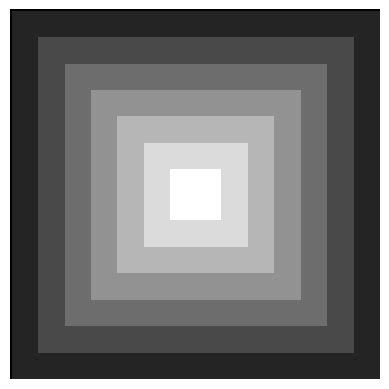

In [3]:
def generate_image() -> GrayscaleImageType:
    """ Generates cocentric simulated image in Figure 1.

    Returns:
        Cocentric simulated image with the size (210, 210) with increasing intesity through the center
        as np.array.
    """
    #YOUR CODE HERE
    size = 210
    img = np.zeros((size, size), dtype=np.uint8)

    # Each square expands by 30 pixels on each side
    for i, j in np.ndindex(img.shape):
        m = max(abs(i-105),abs(j-105))
        k = m//15
        img[i,j] = 255-(k*30)

    return img


show_image(generate_image())

Complete the following tasks to compute the gradients and edge map of the
image, using the simulated image you created:

#### (a) Sobel Filter

Implement your own `sobel_edge` function that applies Sobel operators to compute the gradient magnitude at each pixel. To this end, first, plot the two output images for both $x$-derivatives $\partial_x$, and $y$-derivatives $\partial_y$ of the Sobel operator. After that, compute and display the gradient magnitude $\sqrt{\partial_x^2+\partial_y^2}$. Detect edges by thresholding the gradient magnitude in `detect_edges`, i.e., check if the gradient magnitude at each pixel exceeds a certain value.


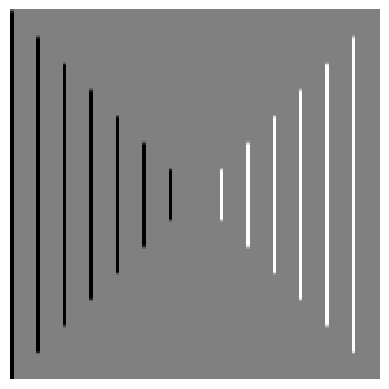

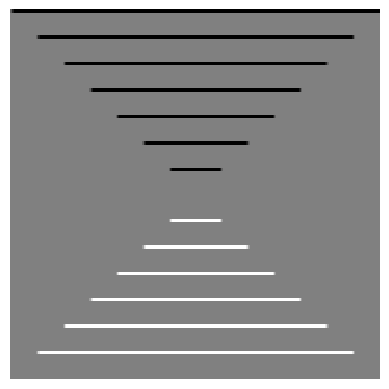

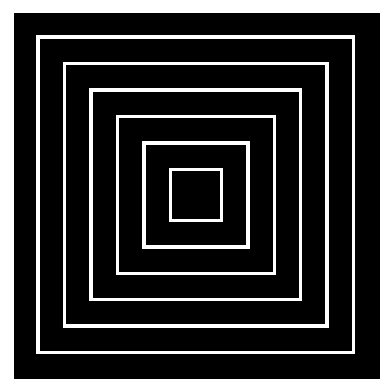

In [4]:
def sobel_edge(img:GrayscaleImageType) -> Tuple[GrayscaleImageType, GrayscaleImageType, GrayscaleImageType]:
    """ Applies sobel edge filter on the image to obtain gradients in x and y directions and gradient map.
    (see lecture 5 for filter coefficients)

    Args:
        img: image to be convolved
    Returns:
        Ix: derivatives of the source image in x-direction as np.array
        Iy: derivatives of the source image in y-direction as np.array
        Ig: gradient magnitude map computed by sqrt(Ix^2+Iy^2) for each pixel
    """
    # define sobel filters
    sobel_x = np.array([[ -1, 0, 1],
                        [ -2, 0, 2],
                        [ -1, 0, 1]], dtype=np.float32)

    sobel_y = np.array([[ -1, -2, -1],
                        [  0,  0,  0],
                        [  1,  2,  1]], dtype=np.float32)
    #YOUR CODE HERE
    Ix = convolve(img.astype(np.float32), sobel_x, mode='reflect')
    Iy = convolve(img.astype(np.float32), sobel_y, mode='reflect')

    Ig = np.sqrt(Ix**2 + Iy**2)
    return Ix,Iy,Ig
def detect_edges(grad_map:GrayscaleImageType, threshold:float=15) -> GrayscaleImageType:
    """ Applies threshold on the edge map to detect edges.

    Args:
        grad_map: gradient map.
        threshold: threshold to be applied.
    Returns:
        edge_map: thresholded gradient map.
    """
    #YOUR CODE HERE
    return np.where(grad_map > threshold,255,0)


# generate image
img = generate_image()
# detect horizontal and vertical edge maps.
x_map, y_map, grad_map = sobel_edge(img)
# show gradient map in x direction
show_image(x_map)
# show gradient map in y direction
show_image(y_map)
# apply thresholding to obtain edge map from the gradient map.
edge_map = detect_edges(grad_map)
# show edge map
show_image(edge_map)

#### (b) Add Gaussian Noise

Add Gaussian noise with the parameters μ = 0, σ² = 15 to the image. Repeat the first task for the noisy image.
This time, you will need to tune the threshold value used in `detect_edges` to obtain the edge map. Experiment
with various threshold values and choose one that recovers the edge map of the original image. Briefly explain
with a comment, in the code of the `detect_edges` function, how you found this threshold value and why you
chose it.


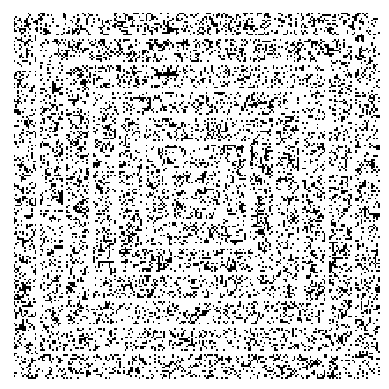

In [5]:
def add_noise(img:GrayscaleImageType, mean:float=0, variance:float=15)->GrayscaleImageType:
    """ Applies Gaussian noise on the image.

    Args:
        img: image in np.array
        mean: mean of the noise distribution.
        variance: variance of the noise distribution.
    Returns:
        noisy_img: Gaussian noise applied image.
    """
    #YOUR CODE HERE
    sig = np.sqrt(variance)
    mean = 0
    noise = np.random.normal(mean, sig, img.shape)
    return img + noise
 # generate image
img = generate_image()

# add noise to image
noisy_image = add_noise(img)
# get gradient map of the noisy image
_, _, grad_map_noisy = sobel_edge(noisy_image)
# apply thesholding to obtain edge map from the gradient map for noisy image.
# search for the threshold value to obtain a clean edge map
# shortly explain how you decided the threshold value.
edge_map_noisy = detect_edges(grad_map_noisy, threshold=10)
show_image(edge_map_noisy)

### Problem 2: Image Pyramids and Image Sharpening

Image pyramids are widely used in computer vision. In this problem, you will create a small sharpening application by
using both Gaussian and Laplacian image pyramids. You will first write a few helper functions.

- Function `load_img` that takes the path to an image file and returns the image as an array of floating point values between 0 and 1.

- Function `gauss_2d` with two arguments that creates a Gaussian filter with specified size (in x and y direction) and specified kernel width (standard deviation $\sigma$). You can find the formula in the slides. Make sure that the maximum is in the middle of the filter mask (for even and odd filter sizes), and also ensure that the filter is properly normalized (i.e. the filter coefficients should add to 1).

- Function `binomial_2d` that creates a binomial filter with the specified filter size (in x and y direction). To construct a binomial filter, you initially compute the set of binomial coefficients, e.g., as in Pascal's triangle, and normalize afterward. For instance, the weights $w_k$ of a 1D binomial filter with $N+1$ weights can be constructed by the formula  

  $
   w_k = \frac{\widehat{w}_k}{\sum\limits^N_{l = 0} \widehat{w}_l}, \quad \widehat{w}_k =  \binom{N}{k}, \quad k = 0, 1, \ldots, N.
  $  


- Function `downsample2` that takes an image and a Gaussian filter and downsamples it by a factor of 2, i.e., resizes both dimensions to half the size. First, smooth the image with the Gaussian filter, then simply discard every other row and column. *Note:* Use suitable boundary conditions for filtering to avoid visual artifacts.

- Function `upsample2` that takes a low-resolution image as well as a binomial filter and upsamples the image by a factor of 2, i.e., resizes each dimension to double the size. In particular, insert one zero row after every low-resolution row and insert one zero column after every "old" column. Filter the result with the binomial kernel and finally apply a scale factor of $4$. *Note:* Use suitable boundary conditions for filtering to avoid visual artifacts.


In [12]:
def load_img(path:Path) -> GrayscaleImageType:
    """ Load image file

    Args:
        path: path to image file
    Returns:
        image as (H, W) np.array normalized to [0, 1]
    """
    #YOUR CODE HERE
    img = Image.open(path)
    img = np.array(img) / 255
    return img


def gauss_2d(sigma:float, fsize:Tuple[int,int]) -> KernelType:
    """ Create a 2D Gaussian filter

    Args:
        sigma: width of the Gaussian filter
        fsize: (M, N) dimensions of the filter
    Returns:
        *normalized* Gaussian filter as (H, W) np.array
    """
    #YOUR CODE HERE
    '''
    H, W = fsize
    cy = (H - 1) / 2
    cx = (W - 1) / 2

    y, x = np.indices((H, W))
    y = y - cy
    x = x - cx


    kernel = np.exp(-(x**2 + y**2) / (2 * sigma**2))
    kernel /= kernel.sum()
    return kernel
    '''
    m, n = fsize
    x = np.arange(-m / 2 + 0.5, m / 2)
    y = np.arange(-n / 2 + 0.5, n / 2)
    xx, yy = np.meshgrid(x, y, sparse=True)
    g = np.exp(-(xx ** 2 + yy ** 2) / (2 * sigma ** 2))
    return g / np.sum(g)







def binomial_2d(fsize:Tuple[int,int]) -> KernelType:
    """ Create a 2D binomial filter

    Args:
        fsize: (M, N) dimensions of the filter
    Returns:
        *normalized* binomial filter as (M, N) np.array
    """
    #YOUR CODE HERE
    def binomialfactors(n):
        a = np.array([[binom(n - 1, i) for i in range(0, n)]])
        return a

    x = binomialfactors(fsize[0])
    y = binomialfactors(fsize[1])
    f = y.T * x
    return f / np.sum(f)


def downsample2(img:GrayscaleImageType, f:KernelType) -> DownscaledGrayscaleImageType:
    """ Downsample image by a factor of 2
    Filter with Gaussian filter then take every other row/column

    Args:
        img: image to downsample (H,W)
        f: 2d filter kernel (M, N)
    Returns:
        downsampled image as (H/2, W/2) np.array
    """
    #YOUR CODE HERE
    Ix = convolve(img, f, mode='mirror')
    return Ix[::2, ::2]



def upsample2(img:DownscaledGrayscaleImageType, f:KernelType) -> GrayscaleImageType:
    """ Upsample image by factor of 2

    Args:
        img: image to upsample (H/2,W/2)
        f: 2d filter kernel (N,M)
    Returns:
        upsampled image as (H, W) np.array
    """

    #YOUR CODE HERE

    up = np.zeros(2 * np.array(img.shape))
    up[::2, ::2] = img

    up = 4 * convolve(up, f, mode="mirror")
    return up

Now, implement the following tasks by using the functions you wrote above:

- Function `gaussian_pyramid` that builds a multi-level Gaussian pyramid of a gray-value input image (a 6-level Gaussian pyramid in this Exercise, using the variable `nlevel`). To create a subsequent level of the Gaussian pyramid, use the function `downsample2` from above and set $\sigma = 1.5$ and size $5\times 5$. *Note:* The result of this function should be a list of images with decreasing sizes.

- Function `laplacian_pyramid` that, based on the Gaussian pyramid, creates the corresponding Laplacian pyramid. For building the Laplacian pyramid, you should also use the `upsample2` function from above. *What is the difference between the top (coarsest) level of Gaussian and Laplacian pyramids?* (Include your answer as a comment in this function).

- Function `create_composite_image` that shows image pyramids in a single figure as depicted in Figure 1. Since we want to use the same function to display both Gaussian and Laplacian image pyramids, you should normalize the images of the pyramid levels individually such that they have values in $[0,1]$.

<center>
	<figure>
		<img src="data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAABJEAAAJVCAYAAABu52QqAAAAAXNSR0IArs4c6QAAAARnQU1BAACxjwv8YQUAAAAJcEhZcwAAEnQAABJ0Ad5mH3gAAAA5dEVYdFNvZnR3YXJlAE1hdHBsb3RsaWIgdmVyc2lvbjMuNy4zLCBodHRwczovL21hdHBsb3RsaWIub3JnL85AQ+gAAP9gSURBVHhe7P0HzLZdWtf/Pvbee+8FRWwgCAhDGXqPQoAMMICgoEiIRKMmbo2JiWAMGhODRIkaI5BQpQxlaEMb7L333nvXvflcf76vv3d5Xvd9vzMvyY7/50iOrLWOdfRVz/M6n/v5Tv/fb4Nnz+E5PIfn8Byew3N4Ds/hOTyH5/AcnsNzeA7P4Tk8AN/528vn8Byew3N4Ds/hOTyH5/AcnsNzeA7P4Tk8h+fwHO7C85dIz+E5PIfn8Byew3N4Ds/hOTyH5/AcnsNzeA7P4VF40T9ne6u3eqtn3/t7f+9nkX7zb/7Nz/7bf/tvz37kj/yRz77f9/t+z/76X//rz77Td/pOtzqe//pf/+utT/kv/sW/ePZ7f+/vvfH/r//1v579j//xP2686t/1u37XW6n9Pb7H93j2Xb7Ld7nR/v2///e3ur7/+T//5wv83/k7f+ebfiU6iIanEuRr7ZcT1s4bA+kptjcGiveN0fMdkavvCBDjmbOXI4cLL0XX2q4ul2/sPHkpsuf4P5aP5l31e/6etFMnHdbqQr4EZPLnno36KkF+Vb+SBdHz42zTaV9ZwFM/XvsJnny1T0EQDX9+rG6orfye3/N73vZK+xn4bt/tu9302gvJ/vf//t9v8oAMu/Y7+yMefepAPR/YJ7+gDelZe2DzHbLNXu34QDFWp/d7fa/vdatHKz9sKdmlUx2SEcPaUYeA/vwCxVNZPshFuwL97AD8dKIpT3llNvWderef3NKUaPVVjwdoy7lcyYsz8Ef8iB9xK3/wD/7Bz3737/7dz37ez/t5z17xilc8+w//4T/cdHQWKmF2AR+Bfgiu7AP1+PlT7PEXB3r60Mtd+vHtmCm3XkkvmcYJvM3bvM2z//gf/+Ozv//3//4tvn/1r/7VLf5/9+/+3bOf+3N/7q3tDqD85//8nz/7qT/1pz77y3/5L99y9p//839+9oN+0A969m//7b999hZv8RbP/tyf+3M3nXjf/M3f/FZC/f/m3/ybW9/3/b7f97YmfuAP/IE3f+BP/sk/+dk//af/9Nlf/at/9bb2fsyP+THPfsAP+AEvxAHl2doEeOjgg9h/+A//4S+sOXlA19YnVnUlKA/wu3/3737Lh3EXC72vfe1rX7D3E37CT7jRla985Stv86C7Ddm/9/f+3rNP//RPv+W3sSjXfFWi8wMo9QNl9IUr2hWc8ukN6ruinzZOHrk5IZ5kTx0vN1z5sPCY/Yf6X0qf9hX/Pf+Wf8vVYf5o24+VtUO6W8/xo+kzt+1N1sfOaX3m2r/+1//62X/6T//pRvsv/+W/3GiNHVnzUgnIsGM/wdccBtZE5wc7rT0+46Pb2lBezQ32ydbHjjVLVj26EiYL1LdfOz/E/hN/4k989lN+yk959hf+wl949uN+3I+70ei2f5U3cuVv/coeiIdscpXWf3kB7DsP/sk/+Sc3+g/5IT/klke5lit7gX0yXrb+5b/8l7f80P9Df+gPve0vcmqv+0k/6Sfd7Ccvv2TYyMcdDzbtnWh/8k/+yVvuxf3e7/3ez97hHd7hxv/1X//1t/1LDMYp0BeUi5cKp9xjbfBSbMlZ8JDu6pUrV315Ggtzx3hBNDmRp2iNDz65dW5ZS/jQjY9xNC+UjSV+42d88BsfMuVcaQ6QixZok3femg/8+dE/+kffzsrmYrGAdJkz+pzbfHcmien7f//v/+wf/IN/cJtf5M0/5xRfzR28yu/zfb7PzWc8dCqtJXcBc+lrv/Zrn/2ZP/Nnvt3qw3CV8y3BQ32gMYLyUb+6eVye+eq9hHzJw9/8m3/z1gfINEb2AWMI5IqccRG/M9ydRe7wktNn7ORRnbw7Dhv2WXPjh/2wH3ajy+3bvu3b3vLjjpTfCxtD/eVJ2T1caWx+/I//8bc7zD/8h//w1uYLW8bJPHTncl8yx9yl/vbf/tu3cTYHzBt+/Kgf9aOe/ZW/8ldesMcHNvJFbugQPzlzzFxQB695zWtusf7xP/7Hb23wXf4/3wbfXn/2+3//739BMSDwqle96jaRJEXiOMLQP/tn/+yWbEEoBWqwJFhQEm9QOKgElYIXaBOU3pOvINHhAjqZE9BfTnhj9RVPelbfU3QnL378i08B8uVu5V6KfLxbf0Ngx3fjycfai6AyONuB+aBPma9rE1zZuQf60hnfylcHlSfkx70YQeXC+nzKhCC9QXLLt7a3L1iZIJ2tS2Wb8+rRbq+Inq30BqcPwdbB6c9pM3+iacMAPb+Wpzp6OkL86aiOr9jwpAOi2/Mqs2nPs6916HThg23C6aTPngnxFxMM8gXNXplP2YQdNOufPVV74yOnjEd/Fwd+atOVf5VkukSA9OBHjy+75WpzBtIDo9UuN/KgHW85UQbogb7Vn0/ZjRZPZbT0h4AMwKMuPn1yJe8OWPnycOCSgu7y4Oz8hE/4hNslcHMAlOnNToAe6qvcGMAZB7/QgLK2ctGY5jtozq1MwFZzAD85/S5kHoq8/HG+u3ABFzAvkPD9tb/2124Xrjd5kzd59mZv9ma3S5uXPi4gLqkuI/z+G3/jb9zuB+4RHm7octGhC5oLEK8L0z/6R//oNvf1uYO8y7u8y+3HLH65EPG1cTR/4MYuJrHwzVxHR1MCsurkygVdYmLPhTsdfBWXhzC65cJ8cNl0pzH2XqB5MdbDAP3mijjKAaSrMcinbC+c7eAe/QqWV30xWBq/lPkErvqvYPnu8byxkP1T/2NtkFx4Bff6TrltRwvWR3Vw8laCqz75TxaYJ9o7Z5r7MJv6rBlzWLu91HqzBoD57IHHXmZt0YW3da+EdEL9+UO/+a/fA8XysRNPctZz+3Y+h+j5h58P8UEQTbl40sjnt3XqQdt57Lnk5/ycn/OCTf5Uh+ysvoA+KNYTsyVOOZVv9M586x9PudJvv0D3zMQvfUr2yWnrT7+2MQN8Ni7ps4eC8oSGhy9kvayyF2l7wGT7Td/0TW9+OLc83Br38gbUw7P9HYkn8OfkQVv6yfNQXyh3cGnxKgN1+QTNDW351+e8d/bY95tjycivMbMunF/2frBrwFlDb/NQnZw6/9jJFozWuLOr7uUFneRBvOZl/qORdd44i80Hdpxt+JyLoHmXv9YPXvrwk//H//gf33x3Xju/f8kv+SXP/uJf/Is3WTzk83lxc65dWX3pEH/9cNv1sxVqA338UMq/ly7GSr9YzXvjxd/2PGP31m/91re1gb/3G8518eOjc32Rd3QvabysQfNSF78cu+N4UYxu32FD/gDa+k7ntmE8fDZ2SjHRbez9WNU+ov0RH/ERt5fkjY95Rcef+lN/6vbCyf0Nnb/uZ+5y5o25RLexXjQX2SLzs3/2z769UML/d//u3729RHSP+biP+7hbPOBFL5E+7dM+7YUABMfAN3zDNzz7xb/4F9+cFRDlnLVAXLAk68f+2B97c/wX/sJf+Owrv/Irb0kv8YzTByTZmzs26JEYg0Ev51tkDRhoESuXBrTrU0JQu3pyJywPSN9i8vFWLiQPrnTA1aN+Rb+H9yA9W08fuKfjbJMBD/GdfS8VyIcLT9FrLm2sIBo0n8S89XizeU8W6mu+xoteOx5lsO2zD6Ctvis46dkhByoX9N/z4/QXVC5tAW3p2dx8KLOhna71T95B/UE6gvpO+sLqPXnuyVfnd77Eo0SD2mFx2HeUIFmgPx27qcN04SHfxSC6Qww6kPjUPqjfJcOBhk9ftnb/05e9bKNvLNkCSlgs6Yi/Mh/otR87MOhmH+rHu35FV6YjYK/48h+sL3ITDx3qzosgmjK/A/Vtx4uvNogv+ZUBtfGvzNpDVxejuhKWe7kqfy4nDmHj++f//J+/XcpcRsiJFxSTWJVw6eUO0L9xqfPl9E2Zz+r5o711PDBa7WTj44N5Kjbt7OLrQuFi6eJEl7a7gH4XLXRnubpLmB+XvFBy2XBP+Ft/62/dLtxy6IJGh0sVm/R7+UKXSxFd1sbP/Jk/8/YA5OFHfvWx687xVV/1VTd+PrALtOVCntWBuS0W9twxXPLowAdBuZQDpZzgb57SYZ2kE7g063PvcTkTt3yJVYwe1lzuXEr5Dehw8eOPL7nEzxb+fM4vuioD9adgsO2lg/oewuCqD57wFJ57IPYr+RPxhVf9T0VwRYdvjO6F9XN1gurbv3QYqJsLpy5gLsHmSti8srb0t8+a/9ahNePebv8yf5XmOVn8yuZ8ewd91g45685+oLRW6bWW2bFuOgchfdGUdKPHox/kNxvs4gX6+WAP4EOIF5SP5PXhB2StTS+Q+Oi8zZ98zQ7gz5bpZCPcdnblyjpPtz3OHvDTftpPu+VHv5d1/Po7f+fv3HiNAcQHyPFdW11u7SH9SMGenNGBTz4g+0A/+xDNvtnLekiXF/n2WnK+0EK3T4t3x4T8GeMiejav+sOH5K9oiyff1u/RnsIvf9V3LJsz+gBaOSmn0NhYA15EAHLyiMcaImMO94LJulAma99Xso2mTcaY+Lrn5//8n3/7YsTXc+auh3XjD/GwR5/5TDb5ML2AHfM8/7SbB36EMdect14imbP85q+1jV+bTfuIFyXOceeoc9mPRF5SitNLEn1yxgY/1PnBn/K8+d72luG2lyesr/XeGgnUjYf1JxbjZa/jk7UhL9ah8ZXv93//97/94KX+M37Gz7jlxo8+ZPGV5/Yn/e45voiWGy9wus/Q/Zf+0l+6rTXvQ+TW2W89Gk8+08MXujaGE/WJUz+Z/DFm7IOf9bN+1u3F0M4vPOz70Q9N/Nn/wA/8wBvdXcrc4Le9SJ3/8tZ5wO5bvuVb3sZdrr7sy77shfnwq37Vr7rZBy96ifS7ftfvujmdAqWJJiAXRDQOGhBBoOPnMMMc8cukT50k0+YJBM84fWQkj16TkD5O2TBNcn0GDG+AxjY96E1UsJNWPTjbQXrrV4YnnHZWBqxcPtyD7btXfwzWNqien7WV4QloG0u0K96XAuynr/qWoPFbiKbEe2K+nTzmA73pBit34sqbs+TQtgziVy7Eow+C5BeDrYNTH8CDvnpOiLZl/NsG6TpjqJ7MCSsD1MP011d92wu161de6Tlh+R+C9O98QmPD2Cqzg6d6ZYdddXMpQGsPXLRv2cPa2KE9DtioAT799kKHcQeEtkMAdoF3SbBf7jxmowMGsAHQspk/xQKSF2ttQHd7tAvB6kHnF3+UZOSEjvJROztKskuXP+VeQivzI95QGw9cwK8fdGkqP2QgwJOsvrB2gO/sg/mxesDZl+3aYhQv4J9LijH8lE/5lGef/MmffKPjwUtv82zrQFlO1JXFBtDYVdYfb30ALf9AdBD9LMk3j/KVb+a2y4g569JhXrhc6Dc/PBQ5n/1gRAfwoogcPS42Lrh+cfOixFxzgXK+u4RUkjX31N0hXIid/+4U+ly8/IIm9/zSzye5drdwuVN3dygO/cCdQpx8UtLXHHJZKgeQLP3qcq/deAP+8jN+6J+HKL1AEp91bA8wF1wo+aHfRdv6drnkg/zIpzvU61//+tsLJ7baH9jcua2+vi6ctNonHRRLfavzpeBjcg/BU2Wv+haDq75w4ao/vNe/cNUf1n8F4g1PucX6Tz6wdbD9sH3IPDG/ILo5TF9zSdmDgn/6ab6RA+avtjkOrdv2A2BeqtNnvbnLO9PoCs1pc59dsux1JvJJO5/pYQdffUqgnz1tetnDD+xBfNVvH8oe3DMCogH61PHbl/ySjsY39pWwPAH96w9sbKIF+DzzeJhUenbhp30BnzjVPbCzZ8/yAqkHd77x10Od8aDP3uoewSd9YraHKPWj88eYobU30aW01+q397JXvu2tH/uxH3t70PcFiS8TPPj7woBv8mOvw89+48MHemF5eCkITrna9+j3aE/hXzxtq8PozRX1xmLbZJoLyuro5rwckYHGj0z3OUgPutxbV+rQnJNrY6mkx1nlBca7v/u7384L6KWDOUV/c8KaYB8dmEd00EvPOZfRnE/oxWO+mSdepJCnG43/XiqIofPc3BGL0tw1P8XSWe2s/5Zv+ZbbP2szh9DJsiV+Zeck/UAJ9S/eoy2/snFaGjvpRuOvUgzisS4B/905Wmd9GfQe7/Eet9jlkZw8y1V3iB0/KH/WkLUsZjT7olyx5R7gB0V++SjHXcZLO3cdssbES0JAv/xY08W3KJb26Na88VTa+/zY9tN/+k+/7Zle6hlTfsu7f65q/xGbeKx/88/XRPZyHwbRwW9zmg758k/i6DS+2ux7uUb313zN19z8pqP7Lvjft85vB8nfktNf8iVfcqtLjMRRyLi6YDlgYCTUxt3ACgafhNMj+fib3CawwCTIxJZIE1JyQYtXSTe9YfTqgFyyoPYpd5ZXkO58WJnT7qknmafA8qrXrr5tsURjM9yYT18WVnZ1vCFQbsOlVa801tDYVz9pyitMJ1z6CXSYP/dQnNWDM/bys75DfNE2Z6c8SF5f+lbvYrrUA3wgenyV9QG86jAbQbT6oz0E64e6XK1d+mqfutc2wHfqC/CufPUt4T1o7qxvYOsrX92eBrePDrqC2tHobP60ByntW3Q5yAE5es1Ne6DNV12pz4bdpVu/PU9ps3ZwKdH0Q7LFFzZ31dlSLo86HnrSDx1ubDhg7NVKNvjWIWWfjgbo37yIWVvcEBTz7s0n5Ccor2jg5NfWV5zNv+RAsiB5PGDzgyaH6rVPoAsdxre4fdkX644/dDHxsgPgzUdlGKifOdg6BHhqrwx/lNUX0PDnc/6D2s1H0DzxQkZM8kWH0osOX924QPp6+LM+67NuZ7MLhLPa2e0S49zvcubSQo85Jz/smG8uMi4iHubMM/zQfHNRcT9wV7CWfNVlvvKDb+j0kf3Tf/pP3/JAhu7Nj7GvBHQ1f8x3gJc8+sqWE74bTxdHfej40V0A0cRFNx/04UHHQ87diI5v/dZvvZWADbzy6gul/ETrQQCNbuUJ+XqFJ5x9Z/up8IbKBfIJH4On2HiKL8tzxfdYP7jXf9LO/mDjTWZlr9qV1R8DcwWYJ+dcWfvWpX5ryP5Of3PMvFw9wHy0Tqy95jR95qy28owPvbNKCVtb5naIBpML1n90vvoSwFr30trDmYdqpf3Vc0M2+JKP6Qbq/FG2L5NhC/Kn2AEd61OQfpBs/uqTR3sY/+i3N+K3V7U3yLN90h5qP8XPL7xePvHTOLVnADmQV/vk+sb2mX+6oHjY45N9yp7CJzrlgG0v4NW94PalBF0eFvlfvhpPuvhFPvuPAX0n5v+J4Ip+D0/+KzhtgyuZxhCg56dSDmqfcoHcoNNTnqwva8c55yyVT2NiPIx1a5Hu+tKD3zigrz13Rf8s2now/4Hz1TO38zIdxsh4K7XZgcayMQRiI9sZpazOthiUgJ+t+eaQWJTA/GbTXvFn/+yfvflobfJ/82i+85MOJQT44oXbJsuucjHe+JXpCuoDbFkL8s9v9wj3FnU0/XjdT0B5a6yKP+SDmOVYzmD5pgeStd7XVz/I6cPr5ZGxY986s1coQ2PQOMD0gmLjh7kGvWw05+Q5n+kRt5dW9hDzCB2/kn9yYC75UcsLQXukMfVDg73Xl2a+ivOjovzwV7z42DrhRV8i/fbf/ttvzgLBAE5z0B9jcmnkjLdajHIGnwFhzMZoYr7ru77r7TNSk9bDi0lExqTzFsymlryBkTCbJ5Bs+po4gQHCx5egfrSzXvKfAulMZm0s1H+lm8zS1e/pAfpfKq7cQ3DGE5x6ngLl8sQTjFv0FldzB11J14mg8iHYBZutxafoWF+C2uTTFX2hdrLJnfX8QDvxhGgr+xB/oI/Myl/JbX3htLN85RkWi/L0EWx5YnDWw/Xh7Fv6Pci3nXfrs7mXHjz2IHV7C8SLvvIL9OhT4rXPnfrKidLmbQ90mNq82SeTH/ZN+5eDA51epTZ+bf3tp2zQi3YCfdGr97DADl+U/HGI0A/tufWzS8b+TA7ytQPfpQHwQZsN9XIG7N36AFp1sdAVX/EEfKYL1iYDygEaOf7oO+VBOROHuNgszx2oMP36ldWBvsV46NQO1PmQ7n6pcSn3kOCXHfkoLn4DMnBzB0/Ifn3q6YL1Q8DHymhB/MkCbbzabDhPzQ9xdsHq7xuIB73Llkus89uD3Tu+4zveYkPT7z/jELuz3FdKLhv0aeNh6+3e7u1uL1Xk1sOM3HUhyxeXmcbQBadxAOzBvnBy+eEXNK+bq3QaGzGSN4/QxBlNP5tk1MsTXnQxVccfrxdp6vJk7VhX/E5GTL4AYI+8POh3ycML2HKRlEt1etkA4mudQHV+mW94QeUJ6G8o3pN/KdAcPOVP2hUGV33wSvfiG9sfPsR3D04ZsO0rbDyTbZ6vLuMeoJ9gfpyQfPOHDntfe74+c7N1E785aK0qzdNeItHRGrLG+B3QrZ88enMYrXWNBzbHkzHP0QBaOuwV/saKhxcPMx6Q7DceZLQ92Gjbm9qXyAOxsNEZp6TXj9b+OYY+frHbOoNBvgZky7t6gIcOXxpY7/xhzz8VsS/JN1v61cVlL6SLPXuChzj59TAmDv54ZuIfHdDDWucy+3gaD20l/Xj10Ytu//EMhs6GrxPYod/XLvzB4wFTm/9KOfVwy565kl026VZqh82dq/a9+hXtIT0nglP2xLNv22cph2dbfefU9jXP5aY5BoybnDkTrB3QyxOycgfp3VI/uQ/4gA+4vYShX9/OTWPsJV/9viTz7GysnGnOF+PfOQTo4Df/1PlszpHhF35nmBcN2cLbC1o+o2mbR340sj9YS+zQ7fneP4k0j3yNbM36su2LvuiLbnMO3Rpg37kuN+T4ggb5UX6h+MpxNPUT4wnTi9+cVxojfOauuL2HcE8TRzkjJ/9e1Im781q88qTOTyAP9AEyfW1EH5tygS5H6Hjpdy/yHsT6k295s+aNo3uAPOOjA7LDd3U65E17afjZJeurNHt2bbqh+4W/e2TuyL/5iof8J37iJ95+jLPuxWdvdSfzsst+QKf7l3c9XnBC/ymIsSXffkJP8KKXSL/tt/2224BQrjQxGyDOffmXf/mz93qv97oF1yQWnElp08Nn8tloXS4///M//5Y8dINEr1JQkmEw/UJpEtOB5iIqYDIBOY6zheeEePHp33IBX31A+VLxpcgBNs/69r8UWN8fgjdE/+nbPR3mRPSVOesQLO0pEP+J6ayuPKHxrm/bj+HyVg+iKbN9D6/gqX5kA2wd1I62fVt/CO7lzZjq2/UO1yZ6dXClh0wQ78oEj9GyrYyuvYCW36ds8ukoDvxB+uKD6VNPT3rXRpu/nNhYoUuli3AbP0gnfpi+9JRr8vrtm1108wUkczU2aOw5xOyjDkR7sQuNOjqf1DuQQoDOPnv7kAEq2SlH2ecnGbJBPjsMk0FLrjooptrpRaM7frngh3r64wPsR6MLillcaPXLE/ly1Vmiv1wo8ek7/cye2OJx2XfAfszHfMyNzk/+gnynJ3oxpEtfdbD17BcrjB+ig9rbv31b6nfOyq+xdunxxxad4y4HXQZdIrywMYf47sEE3R3AJ+wuWi4pLhh+1TbvXKzQnf8+35YPPGyhO/P7JzXf+I3fePOJHB9cXNwL5NUludjlqouahzE6zW1yeKHxw9+cwQuUbNCBX195wU9Of3XQwxy9AF0u5Aivi2g+ADSXVA9mH//xH397CSdHfDGX5Frs/omeNUgvugsaneaoCz6d/FXysbiV/Fvf2azc+hsKT5VlP5sngiv6U/Eh3Y/hY7Yf6w8fgnv+BVf0LRs/46+8R0++vugwmQXt1gpQD82nzgNruHlpTtPXOrEvWf90maPNU3TlyW9O2iusk5B8e4p1nF/sKrUhWf3KgG77jAcYL3w6j5TWmb3as4ZYrA+2yLNHZ2uGDD3WF1loz6BXLPihOr/ogPyrPKE4lAF59vyTMKV13NlLfw/4cmcN9+CeHNv42MTDR2OTz+4RUDz0Fis/GgMxengsp3jtTR7gy5M2X/DYez3cepnv+coebm/21QFf/bDvn+ryjQ/0Nfa12cn3zgvx0I9XuVjfFe2qD4LtUw/XRjzbX99V//alpxI09tori0fOlYE8QDntXoWHjtaCkg7jv+B8af7r9/LBiwb5BXToA/meD85FLwS8GDBexqF5lP/Kxsj8UDfuncPmg+dxY0eneQTx9RKJDnMImpfOLy+FyPCFT/6osjNNrM64b/qmb3rBB+uBPm387sS/6Bf9ohf2BfbMz/zWRtcOATvNw+zuvNzyRPTGhD5rD7142be3WGfyqcRr3KybcssmXnmhw53IfcffEpNLur3sFqP49OHLrjni5Yv7k3XnRbi/fUW3cXEf4hf93VnP0hwzFva27vXth8XiBRD9xstY+5tHxsU/TZPbb/7mb77dY4C/ZeR+Rp5u9zbjqN9djE4xyIO5wld/C8kdR7857KXcr/21v/amD/w/p9O3A4NtehKqNCEkU1I4bEIx1KCW5DZ3yaVDQAYohyRLotHxpFc/WS+TBELWoPAlaFCCs68SfUv6w2Sqr46nAH3pfios70u1d8JLtf0UkIuXCsa8nL5UMIY7jrVP+hsC5Se/qsPH8pYsXD0r+xQ9AR0hSN9D8tldmVPHY8DGWYYnlG+ltQkqA3LsZnv1hfXHk88Qrfops3C2+YQvONsBmr7TXqDdgbZ86lAfUAfZkAf1SoCnfTFdwN4H8S4/yM7Gpw7x5Ut+BPbXxiLZeKujV9IV2o+hQ7S1Shc+7Q5Y6KDSn/104akNF/KjuNJX/OUAJp+OSjoW0pkclGsHmNz6msOBzN/0scO2fvbJOBTV9dNZ3ECMyQH85LOX7yCZhXINGodepngJor84lEG06um4qienvn0n1BfgaTyAejZPXeaWy6hLqUuuy6Yz1y/+Pqt3KZJH+YdyRMZn68ZDG8pnlyn/7l8eXDJ8cYRGNz66PdygubD4X4HocxnhA99caIxtPzjxnS1rDbgbAH657AK+GWsxsROUB/TGHA1/Yw3i2boXOuYAOW33Evcd8nzhowtnPirFgO5C6IHVJY9c9yfy4sfb3DSXu7Sj0QXYzEd88kQPfTDQF2z95YDsn3gCu4sn3PPrlLvie2rfPR7wWP9D8Fjswam/+pXN5a2+NFB7bV/xBc1fJTSPmkuBOdh8hPjoSkbdPIPmIlQ3N+0N5qrzhC90Wxv0uMtD69gaRwfrd8AH2LoK8OBlkw3rGC1ZfSCatenB6Bf8gl9w+4OyHqbb8+nnDxl82nxf28riDstZePYpF+xLHubo6oW8XCnFwJ/2Mnue5x2wOQt6yUBOrsVR/oCY+VB9AQ+anKkbB7x0gHTr6yHe/uyBk78eYj1MovdFQ/OEjLg372TEZq8G4pMDcSvjBVsuRrsCNovp5F88eRZPHQsP9QG5u5qf3QmaE+KVa7nCrz+63LUeds3J8e7fgC/907crf/R3rrHT2KKdMurFBoyHFxf8QCMPisFYphsvBHjrJ+M81DaXyh+0Bp1fXoDhI+/rFvNDPpR0AM/01os7XPLsWCPOSnzqybQGymlrcGWV7ETbev0AXZy9MLIfmL/aYvBjDh/wZ6+8kOVLPlnLvkb2MkVe8eqTB+NrncuXEpoH7kzGwUsXdtx95Mpdiz7y6Q/ZV9qD+cpndzJzRQxeIEExdLdy9+JD8RsvPHSos6XPWPHfvtWPhNp+1PNFGX+91Bab9U2vH8Z8OSUOc5h+uVl40ZdIn/qpn3ozBAUjYAIEIfA1Up+0A5ckAUqa5HWJEiS+z/7sz74FISFeDpkwdApQ4IIkh8eg0udiZvLkrATgM9GCfIImwLbDhbN9Bek568FDOvAH+B7T9VLhjZVvoTTR0rd10KKNtvzLdwVk41HWroSrT30xuSsovyt/haDyCortMQzOdpA/YH2/hwsrq2/zvbxXsidsPsBZBtpX45DvC/yJnq8n79KvyuU95dKlzNZZnnOpcu3iAemqv1K/8sSF2vXRZd9Znelrzwts9vY1B4HNXokX4LePdhCiV5Jrb8u+Pnugkm2yXezbg9Hzq3qXb7Zr688eUAfa7KWTfn1olfV1DqCv3XRUB7VhcYHtL3fqC/SikVPyKXvOChcVX8F4SHeYdli69DoPfBZMJrtK/Why0jmWDcDPLdHh+kgHWL3li07n3B/+w3/4ZsMvvC6LxVuO5E99kby+QPv0R398/FCyv7z5V3thaWQhX5zJLgn+abpxNmf9ouiBzD9pAP54oh99+Kq/X7k8uJF1AfGyyZlt7suZi4jLDFoXV3WXJZ/iy5Xzm05fb7UmgPzR66GGnDVgDue3OeDHKDLAAw9gt7kC2FUXp1J8QN5aG40lvckaS2D82NBnXvFPXM03lyhzjhwZvnqJBvB4oHXfkTO/SLoD4aVPbsxhPtHFll+h+Spufqk3x8io84MMv3oYYTefHwJ28J5I970+uHDVH56wfY/pv6IvPsQTXPUtPgZPycG2t3/pYNtnHzCWcOns54PSuCS7fWBL9OonLB9sn7KeAFlrIV96GGIbHZ/55wHEw5GXzdarOWj+tUaU5nf19ldrZvc8wJY6Xnz6N1bPBG//9m9/24PMd7SNHe8iHr755xj2fjFYF/YbdvSL20MRHjHlU7Zr50+IBkH2K0Gy9kT/ZMQzj/2JfXmWJ/zWu+cY+sVt74ByJTY0D5wQv320Pc8eo42PPjr4lB/48DSmdHlQt3+3b/V1Ex1y4Qsv+5K/N8dn/0rEy358fJd7OfXAqO2cYBewCxsT4+nh0hlhruDld36C5tcVpmfb4dl/VV8aO9rh8i7mz/KEJ2wf/hOiJysHrQe5NRbOMPMSLTo0VuaPXBnbV7ziFbdxCfTJZfblk275ZlN/OvQpAd5ykV/5hMcZ4/yFrXn+sIWHnJc85hR588szODnxmBPphh/90R99o5G3V3gZyY45T7cv3DzL98/P+Watmm/0mJPih/kdDT+0H8mtPsCWmIu72AEd5LcE6nTZw9r3tK0vXwR1d+SzMevFaHM/eXnzIsVLJDmRQ3nwo1EvwOSTDvr08Zuv8ksHXvnwQsmdSFu+rDtxs0U2dM+RQz+g+erRHQi6B4vHfiP3YlGKTWlPed3rXnf7qtyeY2zE11i7k8mF8TVO5uBrXvOaW7x0+Od35puvFf0nIO6DfiwlC8Xka7N5bfTil0g+vZIkYJBKRoOizoEv/uIvvgXpcinhJiCHHQgmL/4S5A9J+twNCJJeAUls+tTRyAADQr9ADTQ/JMeACULC8YN8VKIpnwrpAORW9tTzmN7k41v+x2RfLpCHYion93wK5DM6mXDlroAcW8t7ytV+ir4gvnt4D3Yswdq8woWdN/f4rvIKtlw9pz/RgXpY+zG4F88VNDZw5apf+XnqB8mDpYNtK9OzdLJw/Vg79onqS68Nap/zbfuCsz9Ah+hnHcTPH7T8Atm1EaNpQ3tQB51DQMn26nfQtt91MJHFl15oz8SLJ95ekrCDfw9NbT7qg/bF+JQAvzZdxZIObXz2XXW+04cf4EPPdxig8x3UD6JrKyEb2qtn5YE2u/ryny8esj14Kx2aLqtdsIEHHAexs8el3mUMT/8kywOE/Hnp4TzJZvlgT52t6OzrC/X1EFYs+edc+tqv/dpnr371q2/nnhiLG2ovrXpQLiqjXYH+xiZ/QXKAbPKrM+jC5hx1CfLgJm9yI3f9auaSIkZzwoOIFynyKo/OZHSXKaW2i6H5RzebXQT56yWLvxfi4sSOy5iLmnuBy4pf1sx9KJ/aLjD5bkyAtQeNudjYgo2FPhcctsl0n9An73zNN2XIR/143T3IJWM9otHLZ2PcOiHLT3a10eXUhc/cw++ipb9xcxk3f81XYB778U3O5ZYeNum2r8iX+Uue/tZ4eRSneNDIiAFvsS2Yd9G2fGNx7S0uXPU/BR+TfQrc8w+CK/pLxdPGQ3oD9eSU0ZZuPKNXB8tzojkE9Tcv7V9Kc8m8oit95qe1p6y/uaakg15zzTowx8m2TthpX8Nz7nF4zE985NoH6URj453e6Z1uf5ODzeIK8If5HeLlrzXk4crash7Eo9//EO2Xf+A5gi38dPE15M/6nq18DLLrLLIvios9+2UviMiq67dG5az8Qevb+m1foAPYX8naEzpv5A6S00cPtFfjq+3h1h6Nxxhqe5jVx4a4+OhFkb3fyyY67KX+2Yuvk+zHzk06jLGyPUZcSn6Lx15Or1zg9fJcO3/Q8Im1OJsr8d0rH6qftHuy99pbVg9qh9r5DLYPXSkv7ddyZczt4/LTOMsFPrjzK3t+jJF7dXQ88cm5PBofZ405gSaneNQBXdBcas4Apedt814fX5xBdPKTPnbpMm/MB/PZGqHPCw+22EbPDt/8SRs/lDjbvTBtfXl3YC67l5lv7FgP8gO9PDE36clXuL5np7ONXr7yC9onquMhU75at4E6mph3TqrTQ6612gvVxlVe8sNLFGtHnPIInOP2Armz91i37kP6yVmj7//+73+7A5kTXrq6y7Jpvfa32vw456uoxtd+5i5kT0SnU47ZsY7dQ9g2tsbM34c0R7wI+oZv+Ibbi2J+mVfsyj9fxCyf3seIhz0xoonL34biG1tQ3PJnDNlmj3/uNuL7db/u193yAF70EsnEaOAplFCKoEFDE7gBcJF867d+65tyA2HyGAjAOXQyDLpQ0dXmJSAyHKUT0Cswg05Ov9Kg2BhNJjSBsIUvaLJUBmcbLO/i/z+DHPJZefq9CKrLK5liPdvpWp0nkEk2npAcfAiyVf2Ee/E8BOmMb+UWg3s+RFuZaAtLL971YfsrwVX/Y0B/Pp65WdixPDF+8vkb6AenbngC3uSVq3shXaASzXqurX7Krw+g+tKzW796eoA8rO4AHcQPQTzpor82QKMvu/TYy4B69oC9y/5kg65ubyLbQUVvcsAeph/WR8ahZW9ji1189thyaF8k0/64vuNzELTp6yseJb58yCb+BTJBOvjfJTCb6QVL47eSXqWY9KFDethFC/BBtGLRdnD6tcSvMH6ksNfTK3Z50XaY6nNQ9lAOHKgOYWOC34XFZaiDnS1+ZE877CziAzvGs/Flsz6yxsWvNB5e/Be34hNnMUK0zYNSf3Y3fmWw7crNz8oow42pvnIPPTxAFzn5dXFyIRAfOl/lzkWzM9oLET67HEKXDw8N0GXGP0+jW37l3hxWd6HyAoZPxUw3ve4X7Mp3+WHLZctFS9ulTAz6jbV+lyn3B0CvfmNMv/VTDpR0g2wbLzR9xrb11JhD9xOXJTzq7hzoLmL45am88su8Mi/lGJ3PLl8eHl75ylfeXpLJGd/Z5KOvF/yqaD7hI+9lJ13mqvkm/3JVHvEUW+ugvYEMbH61XwDl4kk7YftOnqs+uHDVD6/6Fs6+xZcKzYuV3/bLhaedKwxqNzaQfH3GDUY/ddcXf3VQO2QD0mGumHfkrVFz2/xCx4sn26D+nUPmOVnroX0E0Auym89KQGf11ke66oP2A1/vsZsuCKw9vJWgMh7AX2uzHxP46ktLf6Qbf75aJ3jo41OYjbUHiqk+dXbEoM2udSguzz3yqu2hGw3YE6z/9jV7AHm85PmErs5P8sZBHY0PdOWnPHnRTh6Q9yBv30Xnh2c3UP75bb/nsz/ibP/wpYKHfHIeQD3U2pecDWL8wi/8wttexm97GL3Q3q2UY/5Be7JzmH42xUBH84l9OSADwc7BLcNir60O0Ze25UP18JS/wvqdDcWozudoxqK5YmzEZ2ydqerGGB1Uppc8XfLjSxDjhp6uxpse49MDPbr8KbOt5HO+0QP0qcu/53AvCYyxuensJcdGvpmnzlnzjj58bBv7fC434IM+6INuc0Gc+joj5YBOutzj3B+8J3CWmat+ZCk/9AX0prtyc1w8ZEGyaOpi53vjE8bHnpiUeNDdJ5yz/JZTfXSwVVvpPCbLFzGXa3uJMXQHBOyhy7UcuB+9+tWvvq0Peslac9YYXcbSWrHGjIlc8Qev8aCbfTG6d8kf4C87bFhn+PnkX4j5eoi/2l56lUvj0nxB3/3KvYsvvsySX202+GD+uMfZY4yhfwlgXM3ZV73qVTfd4H+P5LeBAE06zgUlk6EGVACc+NzP/dwbnXMGhlFgU/E2zIZGXjJdnCRakungsCALNN10CECiXLT0G3A0NiXEwmJv5ZX8iLb0K9rLBU3U7wigO/337MjZgnZy8gXRqsNT1+rY+pVtOV7QvkIgz7XzafGE5LY8kdxTxjH+ez6gX8njC5KD8W79DYV8CLZ99gXGJdS/m+VicW0cIL+f4jvefEjPY3Lrd3OIDNra3fylm98rH1259vXj3TmqP7n0niXYepBukB5leV5Y+Xy1lvgDyMHdJ+2bqzcdte2NNmcy+uyr6PY+SL+SDWUHJXmAjh+QTV5/fqnTDfkD8499MgBdvVL/6k8HzH6Ab+3xG5ClJyCLBq90ic2h6zB1UDnM6MWTXoers6RLarS+VipP+ugXixJkM1Cnnw51siuPzi6eDuv6/ODi16RyWu7LbXBFA5sHfdW3L0j31tPHv+SUMHnoYttFQZ7i9auYc1VpHjhXXRpdEsTrwufyhN+lw4VD3M5tfC4XLosukC4Xxeicdu7jpdP89rDoLHdu96KJDfbRxaTNFjvyDI2n+WBM6L2KObvaSjHrL0fqyQF29AF29YvJuOJj10ULuLjp14eXDW15UaKRoVMpx14e0eGXRPzmhjxAl0WXanJ4+CEul8todAH6yVsD6qF+JZ/kpjzzlX6x8KUYAT3whOjbt7SzL3isP3io/zHZh2DzsQjSe0//vb6ln/1X9JO2uP0LV7Rg52h88IzrBP3mRPMmMP7mlDlpfSvR6DDPmmvVs8MPSDYkh8dcNO/oaH6ho0HrlM5sm/tsaxdfMUF7j/kb/YRsgOrxLb86Pzy3FDPdvrb0whvdC9l0KFf35j7YHKiLS4z8zX/7oodzcdrH7Bv47LNyBey/8qJND7t8BXjz/QpOP8/cezAVKzqwFy/EJwZy/PLPw/nuwdTLJQ+79nJfMOj3cEyunCjFV728Vzp3nQOBWMqPurjl375Oxj4lb0p7Fd3ZAuQA3hPv0a8wyBdYX/WTvjSwdGMVPRl5Nb9bX2Ip58mlb1Eu3G/MiytedXrs60rjK0dQG+Lj0xXKu5J+OryogPwF6dGmx7g3bvrEYnyUaAt8o5f/5js0vt4bdHbjcc6bG51tcuPHEmdWPPJmDhRTOch3cZs/kIw1hq/1BK1HfPFX37b4+Ni65IMXzmLoLmkdeG/Rj2R4nM38geVLHPlJFojD2nMvkm+Al233ADmQC/rEJsdkGisoD40P39lBk0d23JnKN1+MDeAL34sXGGuQv/ag/Mbj/kIPn7104geZvlqSF/xskFFnX8zk+LTwoi+RJEEivXkSZM4SLnFKDusz0XySZ/II1CVGspSMGigOGKR3f/d3v/0PAGguj2T1AfL00R0K3IbGYX0lFK9Ny0aER9AGwcAAsgtNgDcWiv1EUD07Jy/6PfmH+k7YTSQkW5/JUHvlo10BueyDUz5ftv2Qz/fwBDqiq4PlrX7iwsqtvuVfXEgWbN9ZP2W3foKcrF5wlaeg9r1x3bFRhqtjgZy+ykB9cQFvQHe2g/iVV3rzJ9RuHmqvTPWVydaVnur5uDQ2YP6iLc/CtuPPl82xemW89iibMR7gELL/dYDlAz4HiH0T4m/vTH95yYd4te1vAJ3+eNkgmxxfasdj/wPRYXGE/ONPvqqTZ1c7PnRtqA8/pE8ZHz+U+RDgAeJavdHpSVdy6XBO+LzXSyT7PHr9dJATK145Kk4Ho3PAmERTQmeGy3Z5q29L+pV86qUFX0BjTzfbSmfc13/9198+V95ciLccqaNrh6ByYXnYUvJnIbno+b/0dKhD9s0fZzp00fPCpwcbNP803VntIctXAXTy3x9bdI471+lwsRC3fvPCv7X3NZj54ouk5o1znW258lk7WZc//eaEi4uXSvT2d0VcTIyB9eNCJMddfMgrXeyKydjQrw264ABxgc0jHfQrtbcvn8UP3H308YWvYmaPT+hi8EMYWXkC5gx++vnnoex93/d9bw+Y7inmIPts+epLXuQT0Gm+o7t/8Y0uupuDbIpLzuS+GOTAOnE57aslsuKRP3U2yfMrOSVceIh24gnR7vGd9O17CNbXp+A9/of0PGbjpfoQLiztLK8g/uUN+WMuKatvO8BrbgFjD8wh80UJkzVvICBj7pExd5Qh/fSaV+YUvvUteWvdmsRDBz6lvmzZs9/t3d7tNm+TXcCb/8psFGe+JFv5VV/1VbcX4a1ZzxD2G/uKGPgSnjaCdNXPdyAu/tqL5MD+2JcE9jFl8Tpz7GvlqrUo/2KH+YjON2NhXzA2jWV9PajLnT57ihfWZOwL9g42NzeVH/VRH3WLw8Os/Z8N//xFbvxNPH8/yn7uIwJ7uodJL7vFAeggzw9+50P0D//wD7/9axO+8gd97TfH7I/mBT77KqBTXu1r+qA6+uq4V4anXe3lPeWu+uDqqR9t9amD5sfOqfrFm8y2ja39Wi6MaedaSB+QIz+6GFv01hLEs3rPtQzIeFngPDM2PZPzkS6Alw/++ZR5CMwr54ezi77TL+V7vud73v4p5Od8zue88CWbOSMu85s+f3fLXPNjVH+Li33zrfOSTXkgow7NL/G0RtRr42v98H1zGqJd6TLne1eweTMP5dT+INf42OArH/tXVH3J5U6g39rxHkJc1qEXZNYQXrrl6f3e7/1uL7ONlRyQ4YN8yoGxyQ97RfuH+e+OAeizTyj5ZGyUZMRhnZgn7qPGTpuPgD7j7T7S/CEPfUElR3Tgt+7tH/qMm7uhGPjNHnm6faFNzv9IHLzoJZIkmAgS6pNQBjgP1YEEVKL7q+zv/M7vfDPC4d0cOCEBeDlCtz/oZuO1YblESobgDIxkk1Pit2HTGegzkII14AKl2wWMbrrwoNHBPlyIvhBNSfYKnwL3eB+Sz0c8bULKaOvbFeKJ7wrSFS5fcsraQXoDsmD5HwL86TgRXNFhfSecfA8hyP5CMVzxPwXEXg6T3byA1Qsb06u+kOyJoBJkJ6jvSt+JV7C5oCs+pb5tV64/IN7kF9NRHdpDtBfIousHyWz9RDL5kk4Y6Ms+aA9JtjHJJkBLbumnXzZ9pf1KH/tk2/zVlfqSwZOf8auzp63MtjYbNmrl8renpmsPEiVIBo0cbA+3RxdPfobx0IsHTUz0BOyBdJRLgJfd+tiiLz+APvqBMqRHab93LjhgxXHmRR0UK4gnvtW7eXReJB+/y4VzozxBOsQCyeGhq1y79PgKibx/Xy5OqL3y5U073fREC5OBoHZ1kN8gHUp8ymgAb3T+e7hwmeifSb3FW7zF7cICXTzkh78etFwE/ULtouMc9yLC+a3uQqXu4uS8NUbuCy5RcuIy3PwBbJKhw4WIDfblUL6c3f4JHB185ivwzxid/S5E7Mo/Pe4kdAA0MpA9ud66saodv3qXyECe8IuFT1744GObz+hiQ8Pr3iE/6VWmT2xyClo7HpLNO39vSpsO8buImTvphnLBbw902vxR2meS3Xl0Imh+mtNQnRw0NsbE3Us7/a2ldCyctGzdw+Ae/SFovE65k/YQ/Qqv9F7RTnyM5x4kp1wM6r+CxirYekDWmNGjPMcvmd1XzHGIt/3QXKtsvZDBZ76F5on1aP7oV1rT6HjTj46GJ1l9/FLma/5bWx4orc2gGOgIigEUczoW8NhL7FHWIn+yT06dn3QX56k7/SBf9OMXm3XtRQ6+HtCgPPYrfjblTGyeV9Do9YCKxjao5CsZeuyLSki3Pvbai9TxenC139DJloddQK5YisFLHn/zKN0eEu3bX/3VX307F3xR6+9HeagVo3Hxd2yNYTrItZ+YL5t/c8qfNuEPX9Y+rE2GXXuTcZILsvY4bfmD6uzJD3+gPIB0nnq3Dbd91sMruXiWVz3e4l45daBPTO4xciUGbXQ5E6d4xQeBsWjMgDGXY3kyxzqfoT6Alwyklw0oT9aA88Z8cFb11ZexIUcHXeXZywQfdTjbgLVN3pkr/xB/JXkvI7/u677udlZ5QRGvD0SU1gg98sBHa0dpronLXYMe/pQfWFzqZwnbu7YtBvmXB+17WH/25MTa5K+xMjb00M83vnq54uWRGJXuBeT9E3TrTlzya91030k/XR/4gR94ewmDz3+z39qg13mvj6y7Brv6rWt5VTcu8gj4CfmGxpY1QZePc/7En/gTtzHuJWC5NCfcN6x9dyh+0SEGL7XsK3ywf7krsoGXvPnjBVX7OlvmgHH9Fb/iV9z8Ai96ieTf1Lm4GRhJlyCOUkAYcgyCNhX/Hk9STEjOcM7liVNd0gVDtyQJiiOCMkBsSRq77LHTG0F1AW0CveWkywssE8FbNLJ088ckFniLO6AHoOPTLqn1LaDjWz1oyegzYdKlvOrXhmI4aeTyY8vqoPKEbFWn+2yzlT4I8KzO5JTgtL14QjLBY/xg+06b9/AhOP2/J/MUXfy45xM45ddmOV/csX4KpC9I7im+PAbpJrf6FvDc69v2WT+RDrD6AvXyAvTHp4TpWQTkwNmXDB3GAazdSrD8tSvRg9rpYXvXUzR7VnJK2Nq0t+F1gGmjF0My0Rbxk1PvMMCvTacD297qMmAfRoP66WuvUfLPfkiH/RStMt7qbOrLN/q21JcM2Bhgetk7eYAchOWw/DgzfGIvruwBdTriBatHX/3VgbzRKVd+HVM6p4DzRx9eeXMoFz9avsst1IfP5eILvuALnv3KX/krb7TOGfVyKAdAmy40PLUBGgRoYbxBMUWrHn3zAdACF0O/BDob/c0LZ6pLpv+Fx5zgj7x76BKbc1PpjMXrYuTCx4az3eXGf+fvouQXSLzuCP62gwuR3IidLy4zUDxkzVP+kFX6kcrZrU0/dKExLuYpHS6rxsU9gDzdbMaPp3VRPs0V2PjpKza2ADm8dMSLx4XJRcmdBL1fidXx69+2+UWO/Cd/8iffHsr4w45c8N9/r+3Hsv7ulHzjIeOehJcOOt1j3Gn4wE6+8gO/MVt6eLaj0cme+Wuu+/VY3ZjKJ33GwjhpX+kIrtr38DFo7K5krujbJhssbXnu0e/xXeEJD8nqC6/6wZbV78GucbD80aF5A5r/rf36QbqU5qv5YF50hw/ML3tZ+zZ95od7uX1A3fzVX335zGn19UM+tPEt+FLIP6syrzdnQfIg/2G8/FevH7LhpbgfIfijnU79+RFvckG6ldWD5bM27Xl45MJe6aENgvYDMh6YgfMMDb+1RpaP4vDgxxZ++5xnInRIht/2b+s334yHBzz89kd7cXtmPOrhR37kR95e/tc29v4FCR1eNtCh39dHzgf7g705/8UkBthDrX2Lj8B+6UMCZ6t9Haz9/FH2Iis/w+Wnt7kqdqguR3LYPFSiyRNYPafOs48N5ZXMvRIYD6BNhzFwtjgvxSZHfIVigPZcfF4KmPf95x9eIMltupsj4vLsLMfshc1D/tDbuQHVe3FkPMxT42oM96UD3fzhq2doX8rgZZcfXmh4Pi+v+MmF9HjG9+KB3sYS/9u+7dve5rO546zxYkOs5pZ57Z/Vk7VW/DMv8vkP6dp2SD+s7qwq7/YQeXTWuj9YJ+jyL05o/uCvrU9u2ROrNckviGYt2ffYkw9rgs9yKWfs0SE31gw5+XN3MQ7yhPdDP/RDn/3RP/pHb+vTjze+2O5O5etA71vkyL3CumEjWX6Jhd9ibiwaJzbducj4CspLYDbI4xFnc9FcUupTsk9G/tH8/TjvTrSNoxjd9dxZ5AKPvLBLt9z96l/9q29zEfzvE/nb4DM+4zNuzJy30RsYbYoLQFlbYOoc++zP/uybEwbMREOXVG/wAGcE5jNvQeA1eC726AaMTvUSR28Th642LvoNsjfmFoGEuAy5rLK7l1OghC3GaMHWg/iC2vJRWX3tALzbH2hf2boHpw8ALaQrHnmBoA2u9kMgX/iV9K1/6IH+E1YmXJkgWeWJyT0GV7Jh/iuv7N+D7ObD2Q7OcSj/AF95LufJPyX/VyCGtf+UmMR/BZun/LqCeE5bD8nVF5R/9EC7XEW/6qcnvnw4+bJV/0I+5hMe9drVr2RBuhfyC5CDaNDe13pWNu7xqUcL6utAUBYz34B+B1F1OuyD9kV7IHRIdrnqQMVjz1s96VcG6NlWapeb9QU9iAfUB4s32NyA+IKtA/Ji5be4nAvKzVn17AXa+Xza2LaxkSd6PbSz4QLXpQM4JDdm9XK0bbb6lY5eNH3lUr92MtXTq4web3YgGqgdXwhWx9ZBNKA0Z1xQnLXyzJaLhsusS6TSlz94+5UQn4tOZ71zVh90saFT/PKJZi7uL5dsuUjSY26av/S67NDnQuPcB11I+O1+YB7rw89OetSLEZgHUE7IVa9vectHe7E+iK88Axdva4if+QLKsftFcmyh06kUh3yaW/q06XVppsuLUXzmGdTnxZILv3mUD3S7z+ClR77klb7iuwdkrspATo2l8TG++sVoHMUhbnaeAqfup4DYwhPoC4OlLW5f9Ss46ff4HoN7PoP1I7hH2zK4p3ehuXzKLtBz9icH1KF5Zv41n8L6oDkXHZ/5q0SvTOfqgProV67N+rWBdeKh+8rvhfhPuKKzay+hb3FBO5snz9kGWw/YFot1WZytXzTryEsm+6xSnz1NHvlI1nrjh/VIh3r7E8gPutG7ZwD87c/iVbe28Z06gmJuLLSdif5mlH9a63lJGw9d9nM8kJ3qzsv2K7xoAI8HbQ+f6QnxbLvYlx6c9K2za7+iX+lcAPLBvtzKP5TrxqcxAqvvxKs+wN/qO+/i0W8coHOKX+nSp62E9tp+/MOvz3jkp7rcqotBzNnMXshGmP5efAQ9Y8sPyIZzji/8Jc8WGtudDRCwf6KzkAz/jQd01rtfWdf00G1MzC33DD9m+bGJD73g4uvGceLGGa+c9LJODsXhXYVnf2cnVDdX8818gXxaFLP5ni0gLj7i5ze6vMohH8xx/PJIFram6APilycx4vcjnXHnk3uGnPDbyxvvWrxg82KKr3IoBn54r4G/u1Pzwt3BSzovkfyPbNr8Y5cPbMs93flkPzJu7mt8Er+54Y6F3/j4Eas7jLsd/42xPOMB4pSPhRd9ifQH/+AfvDnuLSEj3iB6CWQycpByyigCEsxAoO5tNOckhAMNlCTSg+dd3/Vdb/8DAF3aTQi2JJod9rvYcBqNTkkUKF30mlQGCXibhs/bSW/q9LfhGACwC7N4xFHdRBErPjRlk7mJVnkF+MpPOrMB7sku7+b3CrNRXXllAw3UH+8V6kvHliA5EH94BS/F7hWc9sEpt1j/U2B9kXNt5ZV89PwJyaweUBmc7dXxWE4g2Hq52LZ69CCZKwy2DvIHbF/0bEU79UWzdpYOVkc28FWuLiU+EO8C2vJkN4gOVmclbMyXvvq2D6BlZ3n5bo9qj7N/pTsdoT40gMf+YoOuTScaXbA9Rwnpd0g7eBwCsINRP1/oSDfQtnfm7+7fa9O+mAyIr3o6+J8M0GY3+2RgMadndYP0VBebw8vXpS4DVw8X6sUIty9Az2+lNj2BNl+NWXmUPxcaYDzEmn90NK7sqTt/PuuzPuv2VZNfvMVWrEE+0FGJBvN7+avjMxZnbOhQ/NunXjufK4E+F0IXrjd7sze7nZdeWii9yHHJEJNLipccflFzmZEj4+GS4ldTvPLiIUHuvEhyL3Amu/DQQZdzWenMxacfjU5568IiRj7mu5IcnWwDOuSXv+aD8cInPutDHcoJvfXJcXmC/DZ+7gf66d/xqY3Xr7juG3xEFxvQh8evibXFQB/d9IiTn/5WBF73EH66uInB/4okzy5x8q9PzH7pk3vx0cd39ydfitFjbsDmape34luMvmVAt3+CSb/5zl93LrrpZd84ypfc840OeUj/4mPA3pXcFT6FNzjpL8XOwlPk8Nzjeyl2lxdsvbV6BcuXDhA9NE9Wz/bV1m/sm+/QHAT6tDsHtNXNEWurdYxmfuBRjz9Zfe0D6uj648lHdn0V6UHG+gH5iiesHZzx0Jlt6J90eBAC+osl+7XrTw9Qh+e4nrC0ciGvcuRlvWcOe1/rBp1O7fjKmzYdSjRgLfZ1FpRLNHmiF3hGshfpBx4gxWf90gWKK7D/2EM64yAe+7xnPV9D0GsPpstexS6eHoTth/5eIV+cCWyJC5+ST/idNfbScnjmlP5t66crvuU/69D8geKVEyUsx3iCci1euRdLczl9YXboyJ76+hYmo08+YDT2INDmF3/T5QWBUh4W+aRsDdmHyTdW4ekbpJ+MswaP8ev5mN5080uuvGRxXqEBOt0TlMaWPme2c8H4wvLOnrlEp/0BtI69NPVixMsNuSbnhYkf7Lwkcb/zZQ8fxeklB53sNn6LJw2vc4vvZOn0voCf+oEy38Wkv5cpzZdK+q0BL4voFVfgfQW51772tbf5bBysD/cSvHLnnHZfYFMO2JRzvMbID3TWp7VDxtnLpjXuyz1rz7jZN2D3I3d9+t1H3CGc3WTp8iW4r5bQ8cuvnMp9c5EckGPjia+Xg5/0SZ902yfd7aD7hvUtV5DvxlUs6Er+8Dmwlnx5HbzoJdIf+AN/4OasX2oNlMFQ+gxrJ6I6aOAMCAdNYl8HSaRJxAG8ksCwlz+SKEj/pZzPT0EDYUBtxsAgSFBBSlKLy9tzfrKJz6RUlgiJkzSTgj0bnESY1F2QAJvk0gPFiM5vbfEqrwAvWWU+LG1BP1z+ZNDyoToElQtoZEEy4JQ78R6sb1cYbH1hZcFVHAv5Hpw8tR/ScQ9O2ycuaBsLMjtu8W1Z/SlA3718gsp7kOyWO85AuxJ98YQz3ytTG2gv79KDZANrpfbqS08xBCtf32L9jUu4epS1K89xqw5qL31tV99YArToMH+q2+Pqd8jRpa3usFpZPuoHXQ7sR/aY9K0u6FBAU3ao5kNAL9Rn36IbguyRJVM7YAstHepofNIms/SVYQ+qx5dsOrNZqZ+M0v7sYH7zN3/z28WmXGYDBslC9YANeAIemE9AyQ825MOZ0EXDeSFn+sjobzzJQJ9w+8zXAa7fYZztymwqsxst3Hb9cgbKezkEZ8wgWvlfGhBLZ7bz0LnpnHbGOpvF7uLiTHTpcwa7TDnz6TTf/BpFVulC5WLqhQw5Z7q5i+ZFEd0uMy5L9PODPy60dAM54xPUpx2feSBm57pcWzt856d5gU9/62FjpQ+QQ68E4uNT/PqAsrb7jTr/xeEC2XjIm3uNdjryW4lOB5/cffzNqeaI+SM/7jv+yKZ55rNzeROf0q/+fqHtDiU+a8FXTGygiR/dHQoU2z04+7s7+ScsYjQ3/E0E/qOH4pCvcu8yyX8xig8/3WH5W9pT8SG5s08bLO0xXHjMx/Q/he8e/Ur+Hv9jkL54T3mIR/5hUN/W8UHjZxyNq/FvLMlbP9as+Vi9F0hoZGA85go+NDohnfHRWR0G+WS/sPeb19EgKKbFKzqbfOAPvzzQWTdoxQmrK9MF1Nc2PMerNlg6tE+KQd3+KCbPKfYaubDnZUMerSOo31rmd+eLta8uH/YIdsub9YhfvzjtVfLvucxLaLbaE0M26c3+B3/wB99s+Ds2nq+8cLMPeRjt61Kx8M15CMTEB/54bvPyoy8+nINiojub8u45y3OdF1L2TfabZ83Dcnq2w+1fOhsrUzv78iMPUKxiMkbyV9neRk4uxcDP5vnOnc0f/is/tAE+csYifZCeeJuDcrjt7KTD2Jo7fG2NsaO/ejqLXY59/OHsFJezh2zxwPiNp2dqdf6ScfbKH5QrNsol3eVW7pQ+AuEL2c4HyLbz3t/7K36xWJt0+qfdfjQxh8SDzwsmeuUtH9ksttry4b7FV3cYP+Tlk7lrXVg//LcWW49eflgr6SJjnpNzznuXgFdeoL5ywCf/8Ygff+jmK1vuQOaLNWSfpBe/sRO3OnAXkBN5wEc3HnbImAv6rEN5tM6sT+PmLsaGMXLfkmuojw65knNjw0+62YVi5gc+/HyA8ojXfcD69n7FeLmDQOuaff3ufeyaS9a1ewNbfOLrb/gNv+EWI/g/vkRiyCbjjWKTR0ASluMCF5x+/CYEEIC/C+DfAkoSuuQbJH3aBg+NgwbR2zX9kkyXBHCaboHjAZLCNj4XS77spOMTUOr39o+MJAicfRNav4TTxR86ksvH9Gajfn14lrcSJKsflINAG396050eUBmkH28lWhjcq2c/uSsdi/fg9PEK63sMruReCrwh/l+BcTImoLzc0x2UzyD+oPopdwWr69RxpWfH4AT0YqhcWe0tQfpOBPGdPtYfrD5Qf3LJQLzZBK2H/AX3+tRbd2D1A+3VA650KaNXpj+orSRLTqltr6l02Nin8Lq4RHfgqQP7jP7mGl1o9k80aH9CtzeSzwaw/2oXAzrED5TnhYE+JaAfPz/pp4MuoE4+Xdrk6ALlO1/Uo9GXT+TzOd10oOuHQJnvfHGJcJD2b8z1wfhBtsHS87mSX9lTVq8N6MIX6JNf55HLs3POWeQwJ+P8MZZ8w/eZn/mZNzl6HL7+JyC5dsC60MudC0s5UqLlT4ieH9rlOyCTr8k0d9DLiRINZK8SeDknBmeml0AuYC50zj/+v/KVr7yNA90uZi5idLpM0Ctm89TFydnpbEZX90KCbjQv4JzTLh9o7NPjwmKeiIcNNPr6gUofdE67WJlD6uTlnM/sGYPyyF91cSpBfeVIKadK9wB68dcXoLnr8MFFkW05WuhvGa188XVJgy7ILmLy8YpXvOL2h2nFT85dx4XWyyK5orM1L04Pcv52BJ30m4NkvXziu/zrk1tAjt6gdnkI0dgyP/0qKs7mA5/5Sr9xbu+ho5jSx7aLo3HnkzEE+PUBtsKz/cbiPX1XwJ/lOdsQnLSH8EpHeNX3FH55BQ/xhvGZG0oQ/eQNAf5kopm7O67moXlsXqgbW3PPHFFGI4NPW52edJkr6sW0sHECfph39lv7UHR8ML3VlwbZg3xil99eaFvndPNv+fGsLjzKIPtK87mcweUtf/h6pqHberaG7Wl4rRF588CnrY7H3mL94bWW6M+31pH9Tl74qm1dklHi94BnXOyVdFrX7d/5C4sp3/39Pnsz2R7621vly1endKHzE689i6/slzvntD57d+cdnuxoi9f/xM0WXfmzvp3t6mGxxLvteKrHc/ZvPmpDueazGIwj9LxYrosD0ic2dWNlzsmXenah/OiD5Qqwq66kQ587Bj75MUeMY2hv9QJOHX9rkj3tdLHJ1+ar/s5uMsYon/IBdscxZ/CZC17o9HKDHnq9JHHmQLrQi0n5dm/3drc7kvE135Vssa/OLzqsc8Ce2LyEMc86Q5zr5hR0nzAWctJ48cVc99LLV3DuKM5Ra4+sOcx3+txZ2EcztvmLRlc/Rumjg0/i46tc+YDG33b+iq/4imdf+qVfequ735nP+N1vyNNHVu68W2BbrM0lee3O6B4gBvnjX7HRZ331ci3fvSTzgk7py2/zQBzmAL2guQsaYzk3rvKobczI8a39MDl3FD9y+frw9a9//e3+4yWWr62saXcR6AVTPyC2lt2R0jmvjV78N5EEAhj8ki/5kluAkt9AckxSlE1y9RC/RPo03sAZgIJH5wwHOGbTdcml34UWH93kfDLGWWBAAHmgnz9sBepkA20DZ7AMiImSPj4Z/DYNfgeSXQ6K6QQ8fAi0F+pPD9BemSD9/F171enQly5lPAtLO+tk1petPwRk05WepT0GL4X3pcBT/QfGovGpvgj4qH6Oz5XvaI1HGKDDE1aPeghWT/Krp3Jl0FZu5ZWgEpA726e+4IoWZCPAW1v+1GE6rmzqX7o9BKLFEwL08DHIPshW0FjvGNevzN5C+iA5JT+UAI0c/+nvwLan4FPadyA6nuLdmNMPtLOBRjbQB4tFPcin7Q/Q9Kcr3kr86Tpl12c8Ow7pQ+cr3vjTp4RshcVKlzPAJaCcgfirX0F6YT5vPFtPB1q8C/xhny/OFRctDyTOO2dOuvjnIHWuAOcVWQezXOB1GfCHkfFe2QJnfuKLXl/AfnS4fDD/ahc//1wM+Ofy5ux1Cehi5+9hiBefM1EOtF0gemjxBY4z1IUJzUVVvzzgdbESqwuoSw/7ndOALed3lx6+uwjSxa5cqpNzYZJHNDL0ikP7jK25og+tPqCfHUifOLa/Eg3gV5efHW988gLSUZ92PgB0svxx9xGjf9Yhxi7nHtT8Wtw/CXEPYlO/i7WLH510s+0XUnrEwA93JBdPY+jiXp0cRMNDlx/h+vXQXQvgcSlkQ36Nt3EExaLsstkY4APlkm9s0+0e5WJcToPyFGxb/aq9GNyjL/BxMThlT1yeE5bv7H9K31Pg9Bfck7+yAzbuK1x95m9zXum8MgfNv+YoRLd2lNG0lcZ5dWgv7QryBeRLftU+gb4wG7B1vb6a9+ahB7t8zKf168pWPvCvNR1uX/Vt9/BsrXgYzTfIPl82v4As4CvUz8dstuYgfyDQps8+jMf+wf76/BBYu+x41gJKftqf2oe1rWV7DTv40bPBpj3Onu6B33mZDvHKCfASBJ8vHfPtzN1iEC9725/MY3pgcK8/BNtm075nTOTGeDrfjC2aEuprjIyp8Vc25jvfQGNm77U32/89vPvK1Nkq3/JnHjQG2vxpfZKHzkf86s6Nxg3ig+SgPTs09gDdXUsMOyfFWb6MsTyA4m4eiE+fsfWygm7zwEsbupvz0NnATz/IlFc8Xvb610deWuCTF3cU5xJ97lzmFxt8QXMGuo/JhxzQW+yA381Bz/jmb32gccHHF/6qt47ELu/Gw93GeUmPs1VdXvHJhVw6+5zl9hxrQFzoeKoDNn0gAxpLssYO8MFa0ccvfojdj0le7IlJLGImK470u3fxBw0fWb7LL9/pwyePcg/42gc5Lzf8H/+cTXBQknxV5K1yb/xcsH36zjGOCwCvwTYQgtT3ute97vZ3Afp1rc0LWAgmRZPTZmPySKgEWMAmlSRInqSjsdGi448+PPQ3SWrzA6Dzqzew+k1cNJuwiWIjoE8fHcDglIcmIZ3aa0+99gKafnT1p0I2Ye0TouVDZQjO9sIpV1kfyOfiqH/rIP6lBSfvY1Ae1+YVNjagsblCekL8VyUE2pBcEC2oHS3ebVdf3ofwCvK9/rN9JZcvJ19Yu7K4K8HGswiWL6jv9M86CpLTtzygdnaB9uqpX7nyxt16RFt5EO/GU0nuCuIB6U1P9eih/QjQaR+DDhJ+w+TUyRaHOlCH6PXRmWwHS3pAMdm/1LPrIEIL0fTHR2+6QPkLspkf6njWthJfdRBPdTr18UcbArTkq9vT/ZtsvyotPSxW9UA9vfUr8/vkjQ5W3/JG57uLhYPXWacOxQJe85rX3H6Q8N+2dsmQXz944HEpa8z8Sgf4yU7jsL7D6ADfVVzpUM9vtOUB8QE0frlYuIg463z+7fLGTz/emKsus521foVSis2LDhcZl6XmuZcSzlE8/JYvv4y71OFxSW7+d0HtsuusNiflk35nsHMX6kOnw53DpZGccaBLLOpsik+OywPZclgetOUCHyTbvAzU8Xspxi8XNTbdEdDrdwlML+BPethpvSr9fQPx+wXPnwOQY3el8itW+sx5d6RsyxV5Y0V3n/pbH/wRi7+DYKzkBxpPF1x5dCfiP5oYtOk0LupyRK/SXCg35qm8bP6LPRCPu5H72z5cmQfWLT1k2DGuzUvxBvSF7RVLewhBexA71U+ebZ88wdK276XQH8MTTl+u/A+376E4jVnzGZ+68h4mG2g3zvrNQWjs7GPqrUs0vMrqgfoiyJZyMT+U/PWC1K/35hRakK5sha1pvqkr+Qr7ktDc3FhgcmB1RgPs51e5XOA3mY0jP6xjzy/2PuvROrLf2Svlz3q0DslYK4DP2tZLOq2z1loP9fmiFJ8XENa5h0Gy9l729dNzhcXrf2fjsy8Q7EHiJ0eeXeeCvUGbTblkS4weVtH0+UHB2Fn/aGKx79CRTXbY9BLdntb+s0i2Em4MZ99Jh4AN0Lgu3/LG31zYMkxHOpMB6qd+4yFmJVnj3AO/lyJyYB7Yh/WLz55YDp0NnoHNF3108oM8W+j5FOQzndanvJt30LO2sTDH+GF+NL506aPL/QWNHjQvFYxldhoHJRCHF0J40cxPLzre533e53a/MLfNV76Qwwfotb7R/VhVnp15vs5xxhersjjYcPfwT97kVDxQzDD/5ELO5JQOc5oeNPzWIl5zN8BHDvJTXvDj45tYnbfO714kGUPADrvyzi8vAt0RrRP5kYPmBp7GyospdyjntHWLh0wviejCz3coL2/5lm95880fzNZPV7pbZ3IrH/QmC/lsjMXEnr8z6utn71asW+NiD3g5YL9E+j/+OZtk56zS2y3/1t+Gb4AEY6Hoh5LFaUBWwvEK0j9VMGB4AHl1i49sgySpJphJBw0KXokxuVzKTWAXd4tEEiVGkvC0cQH+0c0nA1DZZmYRQH60IA2WAYF828ONDN1KuLRAG3+2l2+BTDwguWSWf3lOOfCQXP7mI16wvNXjU56+XUE6QfJvCLB1xvUUXWRCY5sP9CyecPqtnSyMnj9Lg8lXV2bn5F2It3qwdk5cyEZ6lGiVIF0LtbOpfc8m2L4TrmgBOevrnu7FBX7lm7L+9pPiSy9gB6AlEx9YG+rbjk8JzjrepWm3r4Hm2m7q62cPTvYtgJbe+PXF356VTnttl7j4QPLZDZKXL32Vuyay1aUELb502e8gOSgObaBOPjvpBdr21PTFB9GznR90A23x+eOqDja24gPqYG2RV2dHHWir1wfUi00J1OuvvnLbz3Z5MBa9TBLj53zO5zz79b/+19/GyQXqPd7jPW4vCfwaJwZ0fHT0MgLkc+1gfVDmb7SF5Sk/m7N06XfeyquXDc5J7S42xtMF1gsjvwiKz8sAl0Fjhte4OBd9ao2/y44z2KXMSxE/+gDjaB46k9mXN20vFfhGNh+9zHGGsyVP5YwtdmCXS3rZoo/f5PjXPKUTNveAOh1ASQZ/a2rzp86uWLp0y1W66fJVmTJbZJKFSwPs+OLLBdiD7Tu8wzvcLm10+oRcrOx7wHyv93qvm22XVTliR97cq8i7/4iB/9/8zd98Gwt+4qGPXWC8gHa5WJ+MG7/4So4P+orJRbM/9Cr3fikFeOg2DvhAJVDHQw6PXEO2xWPuGUc+4xPL2l28B/ED5T35k75w0rf9EN6zBa/giv+kPaSzvod4Qjl/SHf9IUDf8oTmj/ll3GFzCS5k54ToJ+abOWAuunvbP+0H9lb+6g+yu5Af+vjIVz6a354PPDjpR28dFM/KKhfyD/IjX8J4QLLx2zc9J9iXrNu+CvRcYg2Y/8Aazh865EF/IAcAnwd6eSlnAX57dv8MxsMpHjIn7wK6mPx5EbnQbl9kiz5Ihx8ZnGXOBA/SYisn1rhx80927Zt8dAbY37zMEis+NqCXR9ADrOc6YyVPO3bQvisnjRWMN57FeGDjGaKli49y5AzRBsXSvlpZvf6rfGqvLW2Il6wxlC+5lTu59LKAfXNe/pT6vSRwlqLZj5OFfPX1Dlk5TqcxiUdbv71bqc85Ig4gdnNkfZVPvnpxpc6mM8aYBvIZkJFv8845RaY42TH3+89F7PX8QIN88adwnH/GwLnSXQKfP2EgBnzlnT165QvGC4yruL0jKF73GT7Jn9IewF/xajt3xCM+utkoH9apsWBDHzQWzl33tq/5mq+55Y8e/PImp+4t4qeL79aNuvOc73yw/vlKlj9emAFtMvJBJ7+V9gr63ZfEacytJzn1YlD+9TePmp9ioN98QRevNSgWeuSJLjbskeLhr7ovxl8O2JdI/88p8+3AASBpQBA2SM5Ljgnu0sE5ieG0wcJPtonXQvY3JEx2ExbdwOHp7aYJYSOSiA/6oA+62UTv8iN5wERuAIEBtQlq08ufEswnEK22Pvb5yXcT3q8IXbTxsWmw/epnopKhowkX0F37Hh1oB2efeu34tlxefgQrdw/0p+vkPXWDzds9IJds+IbAxrL1x2A3ucYFPOZLfmdr/b/CgEzlxp2ueKPVjj+MDsitLMBzlqesMrniqFxdAVo6rmyecPatD4+Bcbkai/Vh4YpWLHRtfF0AAH1rRz890ZID+QDQw+jxKslHp2/7ds6p1y4G/rXn2VPaA9HjoTt/ob0ku9lGA/mxdunI9olnH0i3gyobgO7lA3iBPnza+epgrB6984EOcWqrF2/0HTe05CGw7+9DOyCPbwENoFdfPcpkNi6QTXLJAvXVsXoDNPLQmeCFgnNKXOzod/FwUXJG4dOHV95X1/qQbL7Wd8IVrXiAMl3lurpSfvkB+dSvas48l3qXOue5C4W2ujManwuM89aFiKwfdfo6posKcPFxecHrPM6WdaAE5jU/2ZYn/MacLvEom59kepmlj6z+sFxtzvCRL+7mJ134jBHYHAE+ufyxwR7/4tUH0QGd5PMzH8qDNn7xyyPw1QDf3JU8ePGnPaKHzf7GA936oHuPsQHs8clXTfpA643f+psTfCg2feh4N1fV9UFgPDzoeRiw3pNlAxQn3PbC9hljl1WXcb7zwV3PxdhFVnyN0UOQfw/BPV8WH4KT56lyoByGILlTx7324glX/Sff2X/C2bdtpblg7kHjfdZ3Tl1B+p6CcmQNuMN7gDQ30M95BvAmU/2EfDOnPF9Ye0F9+V4JspPu9EfbvqWddGiPtWbE4FnHurZX8kkbj/Wk35znB/kFfXjaO/cZJzAW9mV87Nk76Ndm4yGonw5gbdrn6eCnLzjs31742Nv5SXfAp3LJV89E1rJnJPHbv/xgsTnOf3qd8cZbfLA9BuKzN4BsBPKkv9yYL3yxv9hjPSDTq6zuwVkfHvxypg3llXx+lMt8UYf1Z49cstXp18aTjt2L2ZOrcq/UT8ZcJV9sK9vcoDfd+ZE9/NkBxsuZYszoQW++uYfV156rhPj4kc2AjDlsfM0P2NwJ6GQL8snf2pMXc8s4FBegX50e8RgrL0NrF79S3owh/caOH849Ppkb6PzSR0a7+wLbfAHikwN0cxouOIN2jstF+TS/AV+Kgy423Xc2F+gQ6FfnZzzJ8s2csub4hMa+ki9QPGT9M0F23E3ELl/ismab73KN15zgpxzTGzjTAZ3s8I0uLzfl/TsCXvQl0u/5Pb/nZlxSG1ylT6ve5V3e5TbwBtpAcYzDAhBIE7IJq92DRp/u4XWRlQy6JNJkVraJCbQkSZ6J4y2fS7yEs+ltpsHCK8nk+UyOXT6jBdro+tXjxcOON5bQgPNB8tkxkaGLtUlAJt+beJX6AJ3lYn3aMvrCypy6r+CUXzmg/pBO5eqofZb1hU8BdlcG0rX+3IPGEqx8OiuDjeGE9QOc9eCM98r/xeAqP/WfOq4AHR94yGZwFWvyV3IQFN9T4UoHWB/p1IbpV7a+gnyuvzpIX5AeaB7QBXZOtJajnfK7vuNTAvTTpnp27HfbnxygL53ptwdVB/YFwKY6vXD1rn/bFz2Z0xakF3RQoW09XnzphfXZj8uHdvZAvGhKgJcsBA5Z+2MH+6J4+RKCdCnbM7X9UuVXT4crGvlsqgN0uLD2agfqK1M7+0Cs2itXO1718o/2ZV/2Zc/+0B/6Q89+x+/4HbczT/xyKzcuyc5D/HidbX19ko3NYTqV6Avx648H0BUvutyeMajzCx3w09mIRt6vxl4EuVDwD59LiUuYy4VfyDrHnXvOQXboMU5+VBGbcTeOzkpfKHugyCf9zkqyzmx2gTHGX8xd1Nnucqyffbryy0MKveTUs42nfKMpyerDq88ZLRaXLP3qbOvLD77LB1/7ZRjdHPdwJXdk8SthQF/tSn9stLuLnGqLpb8L8Y3f+I03f8Xuhzm/UvonH/7DEnmjR7zGwpcV8smOfHrYcrkkD7LfXNj5QX/3snsPH+WJvBdd7nbmci97yHZBJQPVQW0QbfkAH8TuoYn/Pv/nBxBrDynqxoC/fJHzYgF8XN2LYMvqQTR46rjSeQVXfPf8uYeg+mP6HtJdH1AH9QUrH6g33vrVQfNaKeeVrTmQnnSSp6d2UF+4/Epr05p01zevukObn/SlA5y2g9p8hNaCf2LsX0mQ4ff6by4VUzpBPm0Jy0/07GmDlTG/zWHPLP55iLlsHntugNnrYbHSMxC/AHtisLfJiXXSD+N4A+veCyr91osXPtZza/ohKH5fIqmzx1f/45RnKuvd3u5HEmteHxSjPdl4lUd+8s+6NnZeFOvH58cI8fPdOueXccDr60zPTnIW4lF60WT/0ZYb86ES4mFLWcyN047HYnlxhtjX1cnUfyWrfrav6hBES27RPsoHgEfdfDfG0DNtdwZ96TFHxFp+xSwX5QO/8TMW6s5mz8Pybl7IobYXEJ0VdOLDQx+7fHG28IVt8wOPMeoHJDqMqXOHb+YAn/jChrPNCw/+mxfOOy+H8FkX5gSd5pQvr/yTLrbzh00x8Kkxpss5wAf6lK0bvuo3N9HpNf/4TJYP5qIxb+3Ik/WJxm/t5jEZ9sUmT8Aa8wWx+Dur2HQf0Mc3fuiTXzpaM8ZM7MYBJG9vwIc/veaHl6/9b3p847s+87Uv0fpj28bI/U3JZ4DfnDBGcmBMrDc8cmZ8xWp9u6fpM+5sGKeXA/ZLpBe9RPqdv/N33owzxiEokYKxefl3/5wRpCD8EUkOSqbBaGIYSEhOIP6rO3xQkAbSv8M12STBAEiMC+vnfu7n3vgMGlkXLRuexUfWQLXJmJAGVhL5Dbyw4gd+i4cPC2IC6JCfZJt89JmgNkyXIHQTiU58YqXXBLXYTCJ65ElulCA7ZGATIHploH3SgmLbWNRXZmXv0dNz8lZCPCftIcgPctWv4Iout+iV8IxrIf+Dk//E4JQDV/xwQbt8bHxXmI2lBUuLfi9X6AvxrPxifRtj7e1/CrBdnFfxgur1Zee0d6L++tKvvnMAvbY9IDqwfqKftoFysfWmDNHJRle3XqMnC6qffkO0k5+fdCqLpX71Dq6VqY8++2Z7bX3o9sYF8dOvr/5sAm305KE9Cx0mr54v6QPVk49GLt3qlfiAvvhWVsxiC7T9N8AOz/IRr3r6KvXB+mDtLSHQDuJvLDa3YXAlj/83/sbf+Oyd3umdbr+4OpPS1eWDXBdspTHMn83r0gAd1UH+xL/tbG6/UpsOuQfq5pnzyRku785YDyAuSF4kObfUXa6cXXicpS40PlE3fi4aYhWPFwDGycXHpdKZ69x3XveiQ91Fix8uS/nhLAX8lBfnN7/krnOabW3x8FtJj3wCeuhHw68NtNk2t5XabDj38bCDzhdy9KqLyz9DFKdc8EOc6XQv2bElC8s/nSBa4O+OyKcc+3rIxY8/fPFSSH58vs4+OXkSoy+VXDb5wifgRZJ/dshWY+iO44EPDz/FAviIL3/04WEbFnuwcUCXWXcqcxwf28ZEX7z3MH0LtZM3Pi67ciIOuXavMnfMS232AN/lhz/mowcSpdjNu/IjrvQD5UN48ixcxYl2j155T7b+x2hXPA/pDBfwBupX89SY1l7aygbmlL5kFumG6YleXal/xyY5tPZ7YBzZsFb1xRskH+CtJMtPL3qtNXNHO3r+bz3Z7KSbHbg+RzuxPiVd5iX0UGsNAT5Ae2t1/K1XdjxLeE7gt7UtJ9aCvUA73/Cr2xfYJWvfra4v3hOKGah/+Id/+G3v9SLbS2v7v3XWw6812nMMn5PXxwZ/PeD6e269QAD4+O550D/ZtW+KoT7PdvYVex0b+cwO7CsyOYi+5T0aXBmoXV1+zC26V+6qfpbh6lOH9Fa/h41Nckpjaf9yvsmpPU+e+YcfOh/sj2idX9A86SyTU7qAeQE9G2fbjxPmIxvGgk3jnk3PtcZcyUdAn/3VXmveqpvX5JuzIJ/w+B/EnJv0Wtf49Rtv6J/Es+G+wK4zxXnobyTjo9P/XspmsdGVv3KDR7zFzR/3Evb5Zf66X+DX1/zCuxBvcvrZYrd+9vzdQf8pipzy2zpNb3NaKT+9s9AnPueVcaDLWjHOvTOwrtHplSt/4sd9Rux896+h8HuXgN860+ceIh7rUi7bL8xrufeizbnKR3z8kSs6y0Mv4pKTe/vmywF3XyL5EslAcsIgtgkWjP/2zq9WJqJABOBiE3BcIoImwFd+5VfeNgyXVINAzqVUIujBI+nQfzvs5ZHgW1w+t+4ChS4ZEm/RSS7f6GCPDhMEj8mDDtcfJageBgY9NODsQDEA9kxKkwKNLbpMJhPQCzcbpzjlKv304WuQ0dQXzjZoDMiAfE0XWLnq8S/PFd8V7SmwOXtITtz6lcUMq1/lAWyuwMqGV7ByVzLhwkM2QhAfeIg3HyDYvofw5K0NNq4tgTKsfQWPxadsnHa+htpBMngr648WnPvC2gHkks3OaVMZf3uT9s6reEH1ZOKH6dp6/Nnden1spQctRIfFqewgVFYH5PVDero4aJ/2Vr+DQil29XKg317TgYIHrYPOnpkMSE+yECQH8fONTm0lGgQrp0yXEijFvDGxa7/2QGlfjH9ltgTV8632Wa+t5Le6shxDgB4mE69ywX/x6tD3hyRdlMofX9JHf5Af+vMXbF6jLSxffuRf+QONCTrajgUg39g6x51Rvtp15nqR4YLiEkHWfKPLGeaMc4751coFySXGAz79xt1Dgxcd7NCF32XJ+e1clBtnrbPX+Bp3Fzz6+c+XLjJs8y/ftfUDvruUoZHjI129RKID8okOfOjmOOAzEBNZNsjzA2p72KGbry52HkT1WSPObfcK/Xhbk4AtfKCyvOP5sA/7sNsLN32+tBM/ecAHn/27SH/d133dzXf2/N0Dv9TywSVWHsgYN3cMD2f9YGfsXLz5zV7+lAe+aMuF+NXjYV99YwHaxtEdywOiueIFW+OBL7yCbJy4dPPCyzPxX/GjiVmMcmb8jSM0t7Td5/gqZz08mXPa7U+wOK/whHwJTv7F9fsqhjeEfsLpDzj5tx0N1JYjeoASysvK1AbRALq5BIN8UsqtcWo9oWcPbr027GwDdBsvc9j68lVkD5FXwEZjC8m09j0P9NJb2z6gDoslueIM10fx5Cusb+dSoE5vLzk9pNkrxSgm6wYdj5jpUYf81uZne6O5jc/ebJ3ro7t82QPIWhseKu29+vJLbGDrQTkAH/3RH31bg57DvGjwjCJWzygefu03/LcXlAc+iottfnlO80MKHjTjphQHn+XdWrd/llN98uOPK6PLT3Rl8qE4Khfx1pd87S2rQ76f9Ks6XP3wnBOL+urfMiS/fTC9bDRH5EyO5VHujZX5kA5lPq2+cmwPdFYrnY/ml/PE/q+upFfdeeALGGNHn/G256fDS9B+TKDfPGvtyCPfzLvm+cd93Mfd9IrDueQuZyzNLWeoc87ebU7g7wWJPnJ4vcg0v/nZmgBsFbP49fPROwFngvcG8iQH7JN1DkD+0r166MAjJvEq+UReHujH4+u81gM9/KRDDPmIppQj+ZB34ymuzkxATs7p7SWSvcJXRu1RfjzyUY515asjL8joF6OxkevG3b1JnT15EoN/9t7+gBeNX/j4ok+dTjrkTPs74iXSi3Zvlx8J5IxA1SVCXdIkxkQzOIKVlH4xxGMgJVxgkk1eHa9BApIgKEgnHiDYZL3pVNLHnoRIFMgn/RLHLl1Aktg1SUwQvE3IJpQSPT3Vg2jVARvlw2bviymfabJrApnMfNXnwu2ll4XE92/91m994YsttmGQndOHK6h/5fN148jn+DeelwvOOB4C44RXuXDPp+jb/5g9vKF48Vbeg/irZyPawvKBK93LAzfv0aoHSw+iLQZ0XpVXUDzB2T7B+ISAbusGrp30QHTl6SOkZ+kguZN+D/BZzwvW0TmXAvTsZ4P/Sw82hgDvPVid9OVDtHztoOGnOgTn+qevfXB9oSef1NlRhvRsH0SDyw/ojCc+Jf35ESQbD9jcRwvoyN+Azvba4oHpsd+jK0H9IVh9Wwd48uOK7+Q/IRunTUAWFj8/nVkertGClQ1XFhR/9BPILNQmwzZEa+3RUXshG8sT6HPuenjoPHRBciEDbBgHZ6iXQS6C+Fxq1QEZlxyXErrMZZeR5rnzzWXMuS12lxzzWdmFdS91zkhlwBZZMumIn/7WRzLlk96gmJXiUW4e8Fc2PvTBvbuQEUttkK6HMOCnF0K+IKI3X+ORNy9P/fLofiU+MftTAb3gw1uOXBK9lJJ78bp79cILXzlIv7KcmSfNHVAOQLSAPXF7SUiWL63TbFzVa9N34tLF4gUl3cuzGP+WgN98MZdcpPtio4cW85D/5mkvluRg4z3hMd+vMKh+9kdfuEdfOHMZnLJP0XVCOaB75avD7Vv+yvrMJeOHFkZrrsS7fY15YC4YM/PeeCmTWwRnuUCHvSOfldWXP33h+p+fiyfN/ubB2AsrD+gewDzwKe2rfU0A+dSDZPuJ+MUsTrqtYaiuv7ltb0BLFxAPOTro9mDZnqHNBt1K7XIA61uwt+MLe9C0FyUP+NUeTCb/0fF5+FcCfXLEHj+dFWtXXZ7o8/Bf3BCwWXvpQeOBvrJX7ZMGTtr2ocNT/45//fdQv7iv+hZXr5jlzEuFnhu1nZmNASiPbAA5huZA+TeGxWSsjBM5etiyRsw380u9cY+XPnOwebbP2PSwnf0AT3PYlzDmJfv05qPzxEuf5hywVtw17OFi5R+QA8/Q9OR7SCe6/CjNV3rYE49csIcXtDaSB0o5xkd//vBfnW56eyGFT4lX3frgtzOm9yJyRa84jGN+kAG+HPLPNPnZ/gisD+8G3KXksLWHjyz/2UGjlw197KOJWd4aQzbxGBMx7hi2dssDPd9R8KIvkRi1QbpsMsqBFkkJ8tfL/TLL2S4H3pIDycS7iStofC4qkij5DUZ6JYhNcvokMT9MSgvBgPPJiyg8BqPFgA7zW1JL3NKVIcjPAM9JO4E9POJ3sbMwXHK84ZeL4nX4+HXPr3By44+YWjDiMKHwpAvkU+X6Da7qK7O0sL43Bvh36ryCJu3yJqssToBWLEAbnLaiLyT3GO+p/zG5fI8v+lP4z34YbPsePYi2+BRYH9WB8bD+rvREC8ksLiRbCc5cAuXmZPWsbIAnDMi0J0SvpOPUoy9adrcNotUuxvxDb+6Ce/YBXu0T003Whm8PjKZurbOHtxJUr50MHfYGmD8Anz6g7IC0D3bBoJMMur2ow1WbfDqLG6Cvjny64tNWmlugfnYhun526gcuzF6uOwPKx0K6g+roJy9A3z78zXc0ZfXoC9lLT6DuMPfLrc/x5diBXx9IV/KV8lCe1ZWwXKgH5RSQX8z/s6+cB2j0KNnYNnRWkvGiyK+NLvTO0ur6nE/OfePusvaO7/iOt3njouNckwsXI/o9FPgCwEMgXnzqzjNzh99+9ZQz+rXZA15gySMaW2xbG+Tx0s93etwH2Marz9xM38bLDj3iJNNaQysfEPjKhm50F0c/+KgbE/lwkVTHnw5tNtNRHdanfO/3fu/bP9vvb2LRSwc+PICPcvf617/+BVtyCPwTTznx0EpeXB5c6XO/wCt37hf0pROvmOUETQ6ss3TkX+sN5pPxJYfX+PsR0doEHgJA/MlUD8FJg/Eac+PmBzZ2Th2P6YcBeffOXlKaV3THI045FHcXbzQoR/f0PwVfquzClexT4ob3+MDWxag/2D6gH0SH+BebI/IcNp/kXO57SGl9wGTQ9BsT+Y4G6bCHeImK31pwd+6BMh9On6E5Cqwp+4C5uussHrhxqqcz/YvodFQWPzm0L/3SL739PRd7HrQmPJeY0+zat7zQtAdax+ybc0D8nadKeuUFsiUfcuDlinVozvoSgt6ej9CAPcHXHHSjK5vnoYdGZTbxxWtv8mO25w9+iiG5dJERhz3G/m0c6aJDPry85ecf+2N/7JYHbXuodVYO/TMmZ4XnG/HmA91eoHue08YbNg7VQzrPvqeUi0H+4YHa5rV9VUx8Qm9ON2dr75myfVcYL4x/5SFgs5cjxi7/5Fq+jA1a8xmPM8OzMFn95qRxEos5Yj7qa0zNI/PNc2p/i8czM7q9055Mr7sBfvPXHAB8ppu/+qqbE/7GFl/Z/6zP+qybj77w/ZZv+ZZbvxc9Peda8/wm+xEf8RG39SIu/+to80sOzG/21fmjpN8/hau07n0tTaf5Z66S70ud5jG9bEDx4OF/48KO+MSQvz70UMoHGWhuNw70siNndKmb//SIkx7jYA0orQPoZRI/6aWvs5lOPyD5YitZfHQ59/kir2TYYJe/YrGOjLU4yNCFrr/9lB5zm27QD4Pf4X8TiQFJeN3rXndLXsluEDip9AftfNpoIC1ECZcwATUZA4MmQegS4p8HmMDxCJasX+Ikhj1f+hikJhpeeiTCYEooPoOYfpsUXXxt4YHqTSrtLbcPiHH7gtr68AR8Y1N8/OO7RdP/ssLPLsMWsK+3lHLmUisn/Id0rd3sKNdH5cYF8rn2PSi+dFZf2olB/inxh8kpq9+Dh+zAE/BHv8eLZ+HkOxEkU/vkWQySuef/+gq2DzwU94kbU3JoVzqya1z0A+3q0U+ZhWgrH56Alr4rSC6/op3z5goeoytPu/VlF8an5Ovy2DOiabcBay+telBuAHp96W594LPu47e21dlNpnLHDJQj+0k+nBgdr/3RvtuFcPWiVY8/eXzqgBw92VTmkzo5/Mk4pAB6kG5QiZ8ebXugh1QvLFye05+/YOsB2exmTz36Qjr1AW08+auezMqmd/P9CZ/wCc9+62/9rbfD35kDAbnspB+QBdvOj6D2ltXJnRioX+mKzhZflhbdZcRDQ1/ZAC9MPIQ5p1xqvJgwR8ngc2EDzihzyNxwZruoypU2HnXzw6fZLqkuMOWLLn0uPHTSz598dVaat/qMDxl3C6V+FyB1dq0ldWW8bIuVL+ziZ7NLFB79dPKDHblAd89w34gPejDCxwbgAxvWLKALLizN3x1xWQ/opgPiKW53F5d5f5/E2Y9PjrxcdfeSYxdodPF48PPVMxBDfwdBf/a76LpXsCG34nCvyr98CemIHg/9b/u2b3ubG/4+hNxm4zEMatMLXJKNTfthffE9hvHKRbDy9HpQsqcY+3jh7vNyLR/mtNjR5HDzeM8vdFD7ITh1XOlc2j2bj2FygTaoX3zmb7mAQfJyJ0dyYH32kATl0t4AjR++kGyobY0t4jcHe2lkrfnfCL2gdP/1YAVbq/kMQX4r2zOgcbPveInTPw05Y9w4gXa685nNjeGkA2vQw5x5RYc+aE0A8aGbUz28Q/OLLb6q0ycnSjkmV356iYTPXtzzDHp27Af2a7bKPTjjDNDzhQ5+sPG1X/u1t9xZ4/ZoUF7E1b5Hrh/62SKfHs80csIfcdvzPf+Jz48I/BaHfuvN2NArP2Jz/uujd7Gx2TE6aVue9au+RbQdc/Xmtrr+8m7va2zLS4hHKd7qyjA6ZGf7IH1bZ8Peb/+WH+e0/HmORaOjNWDM9KmjKzsn8BiX7mrGS70YxGQf5q9+8eoz77w8MVbsaaPTb/y7EwAyePjw6le/+mbDi5/Xvva1txdG/BMDWWMshvT6Z1v2lvd4j/e45RifP43TC1nnshdHXhBBZxz/xSdOQBcf+OTe4AW02OjH4wwgoy1GfpjrYurlrfEBPvZAN6fpoM8XdvxBb02j66dfvM2L7HTuiEG/81eOyQOl3PODT9aKXKHbv9w52BGXH6DoYc+dhx/skrMfo7HLJ3sCX7X146NTjuXHWOjjnzr99mK+d7d7Y+HuSyQTpKSZXJLMAc4oDYwSj3/b/wEf8AEvJBHNp576C8yg2TCTg95W+m9lLWB6AV56LC5v44GkSKREGwT8/FGnxyTH0yGHxg8lezv5HyrxqVeCLcOA7gC9CQvkwGTySyO6fu1+8TTASrbE6oWaeAysWE1C9HxXrr2F06+tPwT47sX6GMTDp8V7UByrW/0ptgL6H5NZnod4N+5kwD3+E4r1Hv9jep5qB+A9x/+efLEs7wL6qSuZE0HlwskPdnxhPJvn2vUpt7396Tt5tg6iAfQtg5UL0lGpP53WazrBlezyK2HrPJ3b50BBty9Y+wA/SJcyrM8BYJ/Ip/jWx3jsiR04aKtTH5noyeMFaGBtKYtbfzqSjw7jV0YH8demz48Ob/Imb3Lbt+1x9VXeg7P/ip999LCx2PoJ+bzAb2MFP+/zPu/2xa1DuNyuTPVyoh2tenlYntOXbetff/lRW1kdn770okHteLbNfzLmo/H0UOfsVHcpcVnzg5DLmwuLC6k/gulS4kz3z7T84OHC09/FcIkh7wHF3PaA4Ucolz1Ar8ui8TY/3QXksIenLspd+vTzka984X9nYn7jEQ89gBx++uTDvOpOUa7xk+Wbs1jcxpTf+tF6KMIL2Vt55eo8Af1Vr3rV7aKHH+BDP4GfLpPyLJ8utHjdAbRdJl2k+UWe7y6eYpUr9yH+A/3iF7cx4TddHhjkjW65IpvfePHxg6wyP42pL6fND3n0JXVyypeKcmEOuZ+JI9rJFy5s3pXaYfxXusTG9+6T4m/+mz/yZL7ilUc5N2chH+U9m3KjrH0P8kMJ1MOzvXjlf3j2nW1wT37nnfZZQrLyI8by1YMjRJNLPPJyym4J1CF9Sg957rfuvh5grHv69KVXna/m5xUaN2hMlMbSnPRgxr/GFi89YT5VPzFft83vfIdeosqDNZf9gD17m7u7frGYP/joEx86+3TpR+/Llx72lO2L9mD7nXHASx+b/vWG/OdvMQLl5iuMJ2TL1xzmO11oxhrKIx8ac+Vbv/Vb315c88u+6EUHOvueEe1zXiB4we2f79pr5MOLAHs3YMseT7f4yfkKU5tOuoqp8oq2fWHrEuq/kt86381BuTc2ymL1MO9e4sd/pZebXuiLSSzk7NXa9g762KcnFJNSnGF9J23bcsLHfihRNzbybhzpra1EY5vf0Bjwx0sYe735Z3zlHp811wsIfear3DemzpxenJivdAHzQo7YNwfZpjc/PuRDPuRGp8+9wH9+5Z/9mw/s9MJDfPZX9pxJ7/AO73DzSR49q/OfPsCePnzQ/iFHxgDyD8qRtUG3cTKO2vIH6IPs81+/vBWbmP2tS181eRmDj153HqU5y19+A37Jp7gAei/l6KS7tQvx0dNaFqt5JV9+ZMIrdn6J11lLn49gxMAn8dBBN3n7hDGRb/3ezQD2+SaG6uzTDeSBDv1KOo37ywH7Eul/PyV9GzTJ/bII1Bk3gaBEQGBRuSiazP2TLpOH43g4DgXVxgUE+IVf+IW3tgkBTHgJwk+vDc9g+e87TQQDqU9C8UqypNFt86LTQsKbzgW82a88YXkeAzmB4uQPIK+tBOnSdvABMWiTKQ6blF8gDbBfhMsLvlMXiI62+BjQWW7OHIllS7B1UDufruDKp/xdDJavElzxBssfz8qe8JjereMNQX0rUxnP6j9hcx6kSz4Xo4HKld2++EOw/lxhsDIPAZn4rvi3H5w82jC+/NYWVzTlmaMgmeDKZjrTpR7Em836Th0gH7Tb49TD9eMK8iN+0B7Y3gnyQRk/qMRHV/riR0+HPnW6O2ziRas/PQu160v/mR99u+fTG2QLT3aWDtKhba9zPjhP0M+Y70G6TshOSM+24wny74R8BKvHZdjfhunigF5fMYPmcaBeXzLJrT8gubULGofmI2ATjxJuH1jd6vGd4JLh8uWHGmdP57sznN9+KWbHeat0vutXehh0P3CW+VW7Xwmdu/4otPlhnF1a+UA3QKPfGe0S5XLFB7mlm5w6e/pdGMnytTiKb/MEzM+dU2zp55dSG/SrKDpb4tPf5bmHGrryO50Ltc/8B8nwma3VQSZk36Xxrd7qrV7IgVi8LJJjF0u00MXXiyW+5h//6TY2+aNffOUcL7108IetcoSWf/ml30OBfPiChI54HsKFk86nMxdXkA9hcCVz6qq9COTSndS8cmEXt9ig+F3yzbcu6eJvfrpXwuYOOhk8/JPH9TWbV34sLF+w/OFJP2Ht3uOrvfT4yJ/1+mtveUL01l+06PItv8bAvRy9ORtoy6eyehiteQvln772mHQsrP78eSnIdzo9j7CFBvIH8KP1w6/2FZDv+pMxV8qDfKWXLWgN2+/Q7Q3mm3V7tXaqX+E9MIfzD/Rw3b4csm0d8MnLFc91fBKDuPQ5xz2HGQPryFrxFZKX8h6GnRP2NS+jy0U58vBrb7vyHbJ70hbK18mzCJTxKfnN32KEfJIHscDmKn+B+WvfsH/YH8jjI0sO4r9CYwyNe/UrNM59UaKdfPr5bh4YO/4GfOglC57OtualOnlxi0Md744zObzKBTnDy/fyyQcgN/zjiz56vcgxj9hSujehe46n2xy2j/ZxSH1eVJpL2uToceZ4iWeOkKVT7rXNL3mwD/OD79aNWMtNdSWgQ9ta9mztDFXqp4tfPvjwFZIY5SY5WN7KCZvq8qfNP3xokI7OC3XyynKTDW0/zvnRjk/+x0Q/DgGx9tLderIOe7HMvvjdufgvDvaB8WIPH5768lEb/TsCXvQlkr//4NdXCeK4t3WcNWgc5IhJxCmD498Mv+d7vudtoH3a6C2XN6KSpR9fQQpOnbxkSBA5yZJY/d7QWbTaNqYmgKSZjDYo/qibQPzEY4K6DKjzlZ8n0B9sHTzUB/iNXh8bLbLiVEf3mXoTHaI3qcSEl3/61CFdFpYYTEJvaF0oTSb9oNjyQVkdbJ0M3urbB9IVso8GooFk4erRHx1ULn+YL/GAK/2LIB7te/wg3ZXRQe3F5V994Ep/ZT6c9MqF9JRn7Whgba/NrUPQ/Fp+uHEsf3xnPZ7iCOK5wpMXoF+VILloxbmgT0zxVW/+gSu7xRlsDmDtq75owFxfn6zFcoy3OvlKUD9QLh1sH1r7ZG122zNA8kAdti8oyUQHaNm1f9pP7IXnQQr04UFLh3b15d92/Nr2sPZxSB5dP0DTD04dgK/F7iDza5X9fnOSrnKyoA+dvurKECS3/XK8gMZW9XhPfcXq5chv+k2/6dlv+S2/5YVLfJi95hAaSEex1wbZUZIp7mhA3Vmmjw71+lZeWSza5ebUqQy2jc85Xtv80W+soYuNX9h6qeIPOzvPvVhwJjmrXeacS85cepxbZDwE6ZOzzmgXJ3SXcSWadeHBgy/qcmh+yD8efeLSR797RfGh5TceMl3s1btsNVbGiZyLmjb9aPzXhv7mSeMo710cy5ESpk/J9uZc/YM/+INv8xvo9yMYP8mEIL1y6T7DJ/4BMXio6J+1adNNH3o/0pmj/OB3D7tix8uOC7pfP3sZgqbPvaq6sdEmK97oXljR6b/yNifcyfhRvkD1K6w/4CMsbjZOmXv4UnivcOXFaJ7Jk1JbXO5m4mwtyIf5BOWovPC/fZeMNaKExhCdDkA3GZD9h/Ae3wnFs+VJA2cJTn5xiVVbvTjjUzZmwfYDMsWaDojHQ675aj2dQO9iZ1V96krzRl6bP+am5wY6ySSnL9kryOd8C0H04kB3B/dQZ31Yx+YHO/qMd/PAfpbN9qT2Mn30QWvdvLM/mFNoYmLXywkPtvh9qWM/60y3fq37/E1fbQgeq9uj+VYuzd3i4X960+05zj8/9EJALvaZTuzyLydisj/4CkXdSwHPMNBXaJ5hfBAgJ/SKR3x0bRxnTDtO+XXSznp8IVpr3j4r7/IKxIDuHDDG+PCzAcnjkRv56kzAIwf6rR10qN4+Wrn1sx/SbY8xv+SYj3TxJ73lmw+VbJtH5o2zy7zznG484hGD2JzHxgIvpJNNcXiBYS4bC5hPSmOppEfO6KZXvxj88zRnkD5jzB9zxde+vlR2fvCFDv5as16OvPM7v/ONBvmHx52DT+4QxgjNmWWuALrtI+4B3TmsFeMnBnuC9wNiIS8f4uGnH7d8Ie1rPl8a4eU3Hsj3/v6SNcFvdu3n5N1bILv8Qm8+ySE0dr3UYVee0MX07u/+7i+Mp3Vg7hsTL8q8C7AvNMZeoonRhzO+ipMPOSVjHNjhnxjRjSu9xoqP6EG+yT2fG0tzrTXwxsJ+ifSil0if8RmfcXPWBiJRPmP/6q/+6luggCMtIoMpAL9KevkkIIlw+TEJJAa24JKB6AavTyZNUv0tErQWgsPIhcgf9JYYGxUd+WKw0SRdwiVtfQyq07Gw7bMP0EPfyYdGJ/v12VBNTANq8ptYQL9JIz4Lno8mAflQPPhMOrJiJ+8QsQDI04unWPgGsq+tXvzVsxG/cvGKBsnQcQ/BWYKVA9WXVrzxgvrztfbSl+8Kt3/rV3gC2vqzcE8G5Gt+g8agdrC8QD2ebCzGfw+Tw5dOgFb7ng6gXF9WpvKUAepXPKdNgFZ95UD15O7ByoBTZ7A0GJ8yHcq1F2+wsni3L33RtJcPmtvQereXmQvtE9ogH/SByvSRrQ3IoYX2kC6x+qB6BxngQ3Kg/iDd+tdOMmiLQMnXlRFXdaDOdjR7lwPSZaAcNRbqV3DS6UomyG7lqVNZH5/zp/rmXjx8/qRP+qQXzj75LU5lcuyop3t1rb0g3vrIqwfs1lbei+Ok00U2v5YvG/mxfEDduezMdsnzoGBO+bXYhcpZ5pLzS3/pL71dfNBcbpxvLk3ObBdGly6XEznz8GGeyxWkrwtoFzs5Ber55FxzCcTHprNP3YXNA5A4yLtjAHqLj2yxODuLsTy4pLZW2PDLnn58zmJxpYdP5UedvLYS1AfIZAf8sl/2y273D7TWYvx0BTvW4vHgKJ8eJPnET7Eak/zOlstsL/mAHOlzD5O3dLuIumiK15jQh75zQD0ElXQaYw8K7l3o8kQ+BNs+ETQ+wcmzGO9j+Mbyge0z5uaYcZM/2AOUHMkVlJOt6yMvN/RtHs13eXfhN04u7e255MyF7C9ewVPiXZ7qINrSIT+jha3FlROreazcXKgXP0hHuQByBORXPtGTWx0gXhB9+8o9MA+dI9rbh58/K1sJimkxv6H4W+/Ag6c6vh4q3cXlo4fFxhSw1RojZ83yS/weJp177vT2J3Osvc7cU2fDetfeuedZDKDLozKkh+762LKfNBfzH/bMxH+g3D2quAG7/PeALiZfFfn61HOIuczvfJQLpec9D8bs6xMPWc9ucqkudn6S4XO+5Stcv6OFS7uqK5dOl/zIk/VtH+Q7H51V8i1n+PiMTk48zSvAX4CWPJ3GVDzaSrboo4ue5tSiPiU99oleFEDycsQfPL08wAvE5pnR2aiPf75g8QKkf6rIV/xeKuBxthdbusj1HzyR4Ufjwm9+kBELm+YnPn38M2/8SyVj6kWr8eW/sfYSiV3r1BziL/18Nv8979PNF7qMA5/EYHycg+ZO88odpH2UjPVg7ohBjujAJ37xmKPOSP46T81buvnMf8CeutjMZ+PIR3Z6b0GeHT7ziz/4gX7jzzf6/bjW2ucn/XInpx/2YR92+0FIfvyzT38PFLo3id29mH25M2b8EAsUh/yyz5Y7Ftt84Z/8ssUXeaPDi9veE+jjk3xDusVL7uWAuy+R/DMzv4q98pWvvDliQpmALpacEoTBA5UGRBD+hgJnLU6TWwBNzCaFgVGHJqcXQ5IqoSYfejYNKGCTnAEyWJKA16ArTVQy9PGJrCTzd4E/8KUCvyubfEoIlPrkyx8C5+O7vdu73TZVEzkZi8Ml3IIy0PyXV/6KA0+2gFjQxOYtLnAh9pLO4jHpxGhBFVdlvoF8zc94rqD+ynwPTnn1h3D1BafOK/7oyZGpjHcBX/GBe3xgfQmW90pmId1ryxjUVkKb3urCB9ZOGKiTLZb60g2iJRveo6UrOHnu4coExX6PBy2eIJ5o2tsfoEH9p8/aQXzxVgI5B2jln+z6hI6/MVtsLSnB+pE8qJ7eRXsgOh3pYTPefMxW+ttf8yNZ9BDN/udAiN+emd5ig/rsRWTi1U4/GqgNlCF6PPWD+JWwGCDYXFfar+x7Djw0OaoPbP0K0o0vX6IF+k49p39bh3TJCxSrPdnfx/n4j//4W47xoMNizofqq2vL+mG+RKvd/Ipv+cHS8EYrx9HStfqC5l482s1RZ4uHBRctMXqR5BzD60WEcYPoHkRcQpxLLjfOH2c0W/r6xV5bvfPYWYdu7F2a9cmRy5P5yB+2+zVNnV/0GBdnH35tZ6U6fcWBRoaf2vqVYoB+feQL3+liozF3lsoDfr7SyQ4EZz4rQT4FfmUVH98gEJ8cuVM569lzKeRLtlw2XQBdvNFcMD0ou3i6Lyi1vcjzQo3/5VdOobsXnS7p9Hn5Qyf/0aH7U3cK9GIDaOr5JDYXWf9Ln5dufsmlI9i4A/rQ7+FV/0My9SnB2V/fFT14KfqXV928kmvzynyE7qHy675W7tXR8DaP0gOU8tkY2GPcT9tzyOy8u4frb+XKqTdXH8LkgTpIjxKNHr45a8xhZ0wlevMmIBcki1cO7ft0o9enLSenntrx4gk9VHmok19tetKR/mS31HeF4iyHG7c4/fMWYysGD67Wc/GDfAL8ANr6+YdGn/jNGXsgfeYQG/GpO2+sVXzmAjlzTts84Su5dJln2kqIRlfz1FxE27npb9HY48VBH2iM8h/wB+Kxv3je8Hzl+czehZ/NXkoB+fH3ozxM62PXOPnyhT/OEf90lx599v38tZ+Vh8YjbIyUL6UeGtPyZOzkwdfQ/skUuwDfrj/QCzCxKsk7m+zt5MQhfqW2eLTZWl/oFNuJ7NFrTtDJH/t7z4VoSrr7eoiMMdWnTbf9w//uJe/OAzrR9DszvEDiO5+U6F5GeNHjAw5r25xtzLTVjQswJnT2HM4+HvPl7d/+7W+y+swLfhlzc1ndnDB/6CKjjw3z0DiUbzr1Wdv+d7deILFBPz+1xScfdNhHydpH8cgNHvbQ+S0nzi/5wNNclQuQPDS2ezbiZV9Jnm25a66w5WUVWfmC+MnyjRx+sVnX1h1ecmxYk2TE7R2BM9s7EOPPnvlkPphPZOXLPEBvTvCDDiXb7jX+98W+quqsNo/4YjzYbz9/OeDuSyRvFb3RE7Q/8AgsFv/VseTAkg0FYWNyEZU0b8IEZQAFw3GJIcN5kwef0uDSYRK6OEkaECi6CcgeOYmQWP6xiceE069tcRhkA6QvHfqDFnh2nwrk0rOTEI0uwD8TS9xeohlok1obb/ZsYugGWR7E5EJu0uMxYdiATf7q+m1WJoaNgG526JFzOcafbyC70cHGs7zglE0GoJONvn0nnPqVyS4sX+U9O5ULyeMHyw/qX4hn8YTT/iIwHvGom8/ai8UNtEFtUP/GUB397IsWnnDqA9ld+/dkg/rjXdsLZJ7i1xU9X5vXC7WTqx1v7XSA6PzJJ/x44lsefVegf+OKFr16oE4XfmAegOhkgLr1WT9YXfFZx3iV0ZR7GHZZiDc6H5RLP1E/TG9x5gee5EE8wcqfcuBe3uzLDk1niRzYs8ksPyiGK8BHJp3RKldO/dQTLx31l+d4nXMeyO2xzjW8m0/19IDo9YFTp3JlAH60ZPL/5NMOtx1kpzzSC2ovL5p+/OYQdP44P/B52eKS5vzy0OD89s8UXEC6zBg3F64uVs4x53S5ct4b3y5NvrJxSXO5MfbO5S5f+iGdwPpQp9O5BvjsUprfeOgoPvxo6l1O5RRN2S94dLLlokYX9DJHH13kID2bu+pK9vOpvOsLPvADP/B2PoNsu1Q737sPsSefLs0u4HigH+H46KJonQB59hAJ6MuW+OWTH3JvHLw0kle5do9yn3JBpZMdvooXpEe8dIS19UNj6isEPnUp33jx0pvMwrarn7Sr9mJw1Rc+Bstzyob1LSx9cfNTf6Auh+akMTA2Sm195hx5Y2ntmY+tQ33o5xgE1aMvLv/Wm68L9YNTBqiD1kjnjLIzCDbuynzOXrGIu/tq/ixeQXwgvvJlztsLoucHBGSjLaAvAv4WNxSDkqw144WufZFda9ZaKBcAn/ED6HTF46zDxxdr057q4U8dlkdgfbPhIbD7QT5W8gc/ZAfkqzK/4kEP8/d93/d9b3uMPSgedpOjJ92AL3joFlf/87U9ho/paD/mIxSfLy/s7+3LdMhl+5l5od8e33OfPvoAmRMbqx2zs62+fPy0BvnBprPOXNTmv/jZxOvswAvs16tr13FzfW2i06nemqZ3eSDZ0Jzwct5eL2f4gDIb8eqXr3IaH1v+FZDzwxho4+ev+Ua3Nl40+7ix6AwyrnztPPVcql/bOBkTSG/PmJA+/4Nn40auu4FnYHOZXn6zQZ4v7Hu5ZQ62PwJzypdR/rVNsdIlP3j5xD8x2U+MXTT+qPOBzfJDh7b487mxBmT4hca37jfsi599OeAzPjHJAR/Mc/r5Tz9/xEkXP5T04IfZwgvKIzvGwl3A+erDGy9jndPuYv6porH1nsM7GXQ/5oXWs345d8YbCzoB+8A4Q7GwKSf8eTng7kukz/zMz7wF7m8h+Pd8BkXwNoav//qvvyVI0gyGEnAYn4ngMzebqKTb8NHwtTgkU/LxQ/oERrevd8hKUG/b1A2kQSIncV6g8JGNNi46/I9vkujy5MBhM2Qn5IfyHohNf2W8xaw0IOhNWoeOWLV9tqYfn0nfhY8ffEVLFzQxXW6VFlR/f0JM8oAX0l0eXcjlV92Ec8EzodKNjheUg5Dfynw6EegL0MrHQnkJlm/1hSCZk77taEH+wtUPtg7i3fqJAdn8OX0Omrtbh8uvfgXJVYL1757N9evsT/7sB6e+6MG2qy/vFe1sRwNn3OvTwvoVT7In7wnlXNmcpuO0jY62fEsP1NeH6uCe/0H05LJnXWZTCfTD04/a+tr/oP2CLhu8dW+f1Faiqdvb6utAIBsPfR0Q6YuvNn5l/qRbvzrEE2wdkCsGoE5W3HjDeIoZOnjt2Z0XqydAWx3KgB2wfelQXsluWfxQvTa9kF+f8imf8uxDP/RDbweyXNSHt9yC1QVBdX21AdsgmdpAfmD0UD63r3b90UBtkAxb0ZOLxwXWSwdni/PGJ9nOU2cvPv+9s0uH+eYC4kceFyxtX9S4KLkEst9XBmw4i7ucyhWdwJntQsgnlyZ9bJPHwwdnPf3GAOpzuUNjwxjgAcbGXEJTmkv0kClOiO4Lmi7Lzkt+s88XP3yBXj5BcSxsXulmEy072aTvl//yX37LLdprXvOaZ1/wBV9w+zU4Xuez3Lk0ute4Fzi3tV0Q5Y4dPrKTTZfIXuK4G3jIcVcodjz0ylWXRV8t6adT7HLp3iTXZIAS8reYigfSxzdAny+pyLcHkTFW8cN8fmr7Hu0e/YR7+hZPvmBlwuXb+lUbLpx0/PJp3pqf5oa7rLFQlzs8cmldQHOkl41ybe4ah0pzFxrjyoBd9ugM0bYdLR+VxtH8hfQZX5itUP/ypgOgh3ToF6M1Z64CdP2g8oR0nLbccbXlb/viP2VrB1d5CM85b78TP3+NjXFoDOjEz4ackMdnHZFpTQF99lR5cF/XNub0JG8f8LxiP2RfP31K/ezZ/+jIn/II87M2uMpLf2el9Sue+sjDxhNNDOXE/m1/ecUrXnGj20fwGwt+ygd9/VjgT6E458ma+3jZ9YzkjPADBfSVhtj9aNFasH81JsqzTmf1xXj0q9MtZl95+CEDmouBPAJ7pNzynWwP9HyWL2sVjzjoB/gae/V8wrMvItDlizy6uYBHjOK2J+hvvJQhQIP0iAkYO74bD/PIc7MXCPYLcsbEWWu+eV5OVluM/CTvC7P0a/OZb5Cfu874Lx/qjZO85ouXc+rAGeWHE/z0sMk/8auL3b/WocsXWPwzv7xAkXfjxh7fvUuQZ3F6rm3f5Be7zkl6tNmH9bFD1jwUEx1sAfnQJ/fiBPYXa5DPdIiJHmvPWPZczWY/ttHDTrb4wgelPjE4u+XD3Hd38jeafDHk7yYbuy//8i+/1X35qN/5jh+SpbsXeXSLo7NejtmFeMWj1C9WY8UXgBeWq5cD7r5E+iN/5I/ckukge+1rX3t7IWICWICSaNOzIYAmKEf1QX8/6b3f+71vAZk0gjJJJCEZiZAcA2HQkvVW1f8OI1iXH3YNsjdtBtXkUvraCc1g0mdgHb4WpQNLEtdHQH8JRat+BfVJOBBjeipPXSYHv33S3iCxyR+XL0CPyeRtLBn9gI4mhIEXo8uniWsB6BOrN7VNEHlTyiM9Fp98m3DeWnowUMcjL9k68wCvoL7FgHxtJZ3Ll34QbetLA9VX7tQZTyVQv2cLbB0Ue7pBMsa6cuNbP1YunsoTF7TX7smjD5z+PRVXXjvIN3RQ3+qP59RxYv0g2gkP0cvr6WN5X0CLb8tAPb/D0/9sWXMgPhBPdpKNZ2kg/hDEB4P4FtiA1UG+ZV9p7dsXlda7PUQZv/3TwYGOZw8RNDq08Srx1x8tXWB5leTh1s9YFs5cVG4O1Omr7bJobzMmOy4L+Qf01a5Ey7/053cItr794k2+2OUIONz9HRiHf/2LeNMVJBsdXzEtn3q+g2IrX1B9c1bfnj9o55zOjj7ABh50ZTrVnREuZ/x0aXExc346T51VLnxeGDhvig0Pnc4epTMHr3OlS5Lzx0sZ5xfdbDq7zcMupy6JZNkj64x3RmkDd4bi5Ctecn0V5vxH61KrxMendBQ3311o8bsLmHvOTH3aLtF862yE5XPzpdQGSwN42YZ4PuIjPuIF3z7v8z7v2fu///vf7OtzsfcVsgcbX/d4ieeC6q6Fx3ntn77LkXyyIQZxW+vmJN72CHenfOUTWjLGxFfk+N29vuiLvug2Lu5wHpLoIIcmv/TQwW862nvQe4B8v/d7v9v4yClfYLIPYXl6Q3CBv1c8Jz6V7w3B4Ck28CwuHci3uWL+GSd3PQ96SvNUfo0PMKbmgPnai1p9jbf5Y4ygPuNfSQawTSY/FgP6ms/Gvzo6jLeyWJr/MB1K80N8YgLpWTh9APFBfojRvLUPsLE+wYWzDbKRj3K/ZfbZ8hLE3mA/4b+14gFd/tkFlXJrTWSTHjqV+O2RnmHELw/AWOlvXzIHPM/kGxRv42k/tm6td/uwHJgv2sZz7wnlJSg/6Oyzaw+iT5x81N/aZ7dcAHX9fLIPsOflh5dI/O+fYZHF44Hdnq/fF6xodLRX4Msen/SZ63JET/9c18sbXyixyafyEpIL6QrpEJ98kqc3fv18aO9iVw7xaOPz3OTcK6etFzxKwH/QDxn5EZ0eckr2lMVoDNTl3ViC5NNvzX7O53zO7aWCDzn8czXP1J6NPY/7r+mV/gyMr6atCzbEbi4aA3aav/qAcWHbvmA+e74Xv37xmlN8bE/Sh84vY91860z3jE8WP77GgD9igPSRNdZ8Yd85/HVf93W3tnxDety9nHv8IAO8aDQH3Mn8zWXvHvzYwl5rkl/85ZO5wpaxw8NfPPKiBPmJT4mHz8aTHnPBj2j+Hqav76w39xrvF5x91o56a5RdOWo+syW25gM6HjHZu6u3ttX5Eb+cWQdyhbc1U1zZ6b6D1hqhxzwQB93k1fmDX934yenLAXdfIvUW1iDYaKB/x8hxE1/Z30cSHOfQQoNiIjgQG7Bv+ZZveYFfG+At4UByyPpfRdhB77Kjnl6Tx8R93eted5OXQL72maLBIWPAAJuQPaW+6A9Bg7IydFSiRfdP7Njll41VLICsSenFkfjx8xWPdvrAaSMdSn7YXL1Y0rYBeKFkAorfxJMjOkwU+TNZbBgeDixO/frwFFc5yFY52jjXR3D2wfQExaJc/uDkD+Jf3mD9Sj7eezLg1HnFJ3585fqUyfa9OFfnlW/B1sFLiWMhfwJ+nLRT39ZBtjfW7Q8eiucxWL/UoRynY/OOLwTo9+DKj12r9adDPd31LQ0kF8/S8xM9/5VsxhPoW9CG6wtsntHTXtAhuH4BNPsGPnV86iFZ9Mp0VM8mBMlkB9YG8ZLlY/3B2Q6ylVw8lR6au+zAcpKNSpCM9iLIztIA+kkLlr88oqnLp/H49E//9NvXsPoW9YPVm64T8defzaB6sQVnLNqw/NRfGWiztzR1cujNz+rmkBcYXh45k5zdLhQuRc5LbfL+fb5xctZqO4ehswwvuy4p8qIkx6ZzST6Bs8llTL9zMV18cT7xBU++0+mM0tbn/Ori49ynl431050A0OnSBZpD/HWXcZECdLBBt0ujsxEvm3KjD4Lq9JZL7XyNlq34X/3qV9/0ubD6FN0l1OXYXcXXDS7BbMsJeXF4qecFk3Hgq3Oe7/QANEinC7TznL/lnF3txhpN3UskY8g/DyNy5QLv0u6usryQHrnZGNGVxsk/XzAmfjEOintxYWmP9T8EfFhIbmUfawfR69v2SbuCh3xZPGHpy7e0SmNvrZn77nbQ/PbAZAzcrdHwtEb04UFHs+boMqbWDLRezQN7b7YWg+YAiH6WdCQHmyvq5jZE45sH2+YY3day9WceepFiT7EmYA+56Hy2FqwNvHyn94T8VYYL+ci/xegQ8MuewZ9yyz5/5E4u499zo/MBnX/GD6+1bBys8WR6aPTQKj658ewC+ATwALL0GdN0A7mXC2jP5eMZM9i8fOzHfuztKwdzxxySa3EWEx7+saF95gmw0/wCXtSIxd5mf8JbXrxE4r8Y2fEA3h6HJ3vyLA56xGUOOx/MZ7LmA+DDiflHli37rT2Pf3xgS3wb0+ZpdQD7s7zEQ1bdOGYz4PO2QXL0mQMQD9/wa/NLv3WBP70Q3R7/xV/8xbfSWQE9g9v3oRzy0Zw0h4yJ+OVLKXf51h1LHMaNfTEaD+tJfpRQ3vWDfKfbuMoff+liA93/yM6Gl0Vk0Ywnn9izfvlhPSnbm3xA8U3f9E03f8VBxssi/4qHb+Ynefadi/T7F1F+dPFVsba42Gst8UNe5Lac0stfuYdo8dbfWNBpHsZjTVkj6r1YbD5Zq/r5CMQG5CjkA7oYvVA1h9mAYoZociX39BkT42vcrSdyxl37CrtLkEufkgya3NDfvIHo8vRywd2XSJ/4iZ94+/TPpcEbeY74jFFCLE6bHock10BAgwQkEPhF7W3e5m1uiSRjgEwSA4anQWyymBRQ29tVbx3JCNpgkiMDDKa6JNHPH3wmogXEF7pMfoO5suqgwa5ucrRg2ggMrDeQNj85UBq0BtyAmRQmmgs5m3zwwga/geYjPn7RzV9vGV1o8VtU7OYXP9XzYX2EciYvDiW//PLFLwPk2LFgTT6+auM1bnKEx2fwfvEUl35vVeVfDKB8bc7Q1MOg+tJWDlRPB1Dew6D4l3bWtx2Uu/xYHvk7YwnjV4L4KlffYn7e6w/jiT845RZO3uU7sX6wcsWzfKA2LEawstHiu4Ji2tiKKXoY1L/15QvB+oO2vtSXLXDyKI17OvOpvvgrgToZ6zNIFpxy9UUjmy70lYsO0m9Nk7H3QfzRQvsTUNenvf0gO9rspGvp8eqnR9/6tP3JxbO8KxN9sVxAUJ66MLdHd6jrY5su9WwXS33Rwba3hPGvnPqZV2154gd/vvRLv/T2I4b8orOdTJBsdf342Ag2hqXnR/1QHZQrJX/KTe3VmUyAvvJw9ep3BonR+aDPWeTs0eeM8MOGc8ln6i5NzjFnvEuHCyR03jkznDPOdedcv8yh0eucY8vZp+0iiObSy74XGc4e+e1ixheXqc5D84Mvnf1K/HLdZQ89lFP+0Y8H+pEFPZ/p5Ac97jWArs01UAdk1RuvHTfAxgL6R33UR93OUzHJs5dxzmK/jHuo4iOdLnpeMnm55Ac2n/e7FPJVTuUWH38h35zdXQD5IWd4YGupfOD3w5+15kGsf7bnIk7O2Mq9mMqrOmSbvvQo0elxD3TngOWjvCnjr/4QDS7c47lHD8/+x9ongivaCVd6HtN9IriiX+GC9o712g3aAyAe42y+WdutJXTr0P3dQx4Z64I+sPrA2sADm2fo0eIxV61futnprux+7P5vTZh75jm+7vJ07HOANt+gfcSPtO679HtY6kHafdz66m4OxcY2tKeY2+WGbv6D9Vs/Pvr9QF5e8BeP+Y4ur+r4ydNHjv/WiLp9hax9xxjIPX6xKKHcsGFNtqfR1Xo0ZnSyaV9Eoxuwjx/aN9hVzwZgl6/F/Gt+za+56fQlixzZj+xT/CBbztmnv3GmUwnpdiY4I70M8CzDtmcd+4YxEmtnA73+Zcvnfu7n3uT4gsausSfbAzY77PI5e+4L4tAP8jPfoLPmTd/0TW8/sMtjL0XoZofeYiDf2Ik1fUpgnopRH4jXi6l4QPX4QPVKPMavccjfnrvWdnXoJX1z0FiICcgdXV5oKc0d/olRPtC05V/bM6I84LMWrD+2jT1eL3WMPRvGyg985PjCJjn8xkeOgfnHBsDLR8+85J3/xphNbXrpz4aXQ84j/M479vlu/vrPG6xhZ7acyRf/5d08e9d3fddbXL7OMhcaWyVsLzOn8o0ecSiBM9gXgeamMSVf7u1R9kmxadtH/G0iOXNWywVd5PglJ81l8bIbollnnsuNsxdC/7fC3ZdIJrBJYFBdAA2yf9//Pu/zPrcBMZgmhOSYZCWuyQ4sBv/Wz4RvYzH4BgQYDGDgQwNosNgw8XzCZrKr20T197cADJJJzy8L3+RA//zP//zbCywxOLBManEoTXKTgw8dOuodPA6mDicbCXvqSvG0ISktCguK311IxZicfOB1AOFDtzBMbrG0ALp8m5iwRUAvm9Xp01YP0OQL6utlkXzbUJVyZKx6y8y2iY0G+S5fcsg/OuiF4gi0K08fKqsvROPf8hRT5QnLu7B6wvWnOnrjUBsmfwWr57SjDw2sjVOfvviD1XXVTgZEv8L6wT39i2DrC2jZ3f7aSzvh9H9LOutX5ufGWF1/sDqusL50G1trqXaHH8xm7XjyrXmR/Q6D5V998W0bqkffMoi3evbjYwPwx14B0fJfqa/9VYmmxJtc/NqBOnp9Qbb1V883uLToIL/P9gnJVQflUulgdabIeRgfnfkN8md9RSvOs14pJ8nFc4XlMdlP+7RPe/YxH/MxL6KX59UTv7KxqT8/T77q6MHG1DxRNi/KMVTHV/sEtLUHkkln5xdQOpugC7gffJxf/ncUD2zOWeeir1mcIe4AHhSck84t4Fxz7uKt3RmoBF0kle4HziVnLh4+8MuZ5G7g7ELDJ0/0uUTicfErD9rF5UwrdnL6jIlLHrvsoLsvAPx+jcfjvNMmU07pDKrry3bjp47WmLOv/MiP/MjbnNZ2IZY7DwXuEc53Nt1pvEhzPvs7k/7phrsOHudwusTggkpGDHSJA00+2WG/uPMJahtTZ73ckfVSyUWajLw0/vS4Q5BRagN68MoR3e5MXjDyFd2dKnuP4QnrKzzbV7SH2lfyD9FPXLiyE00ZJLe892j36Evb+kN+g/pbB+r3ZJZujM0/D4XWqD53XmvF/DMfQGtzdbdn4LNelfYF67mv7MwRe4Q5isc8BeatucO2+WptQ3sJ3h7oxGP+9ZBr7jY3PYD2Qoz/0P7TfVZ/dTx4rR1+96BpT+uXfHHzUUzWgz2BH/az9ga+oHseyke5WCweEA+/+WHN84P/7MuHfvbweKDmd+OIjw4lH6IDfvCHXwAPmucHOqFY2SBrXzXG+eHLEb56sU3Wy2t7BBv08IkOkC560h2SBfYn48Q/sfBbHrTl3w8Rnm/4YCx9tWSs8dLBLmCbz/qMiVzLFWSv8RSDkp+ADrnoPsE+WWNtTOkUA2ALalfnZwjo9bIdD0Rng25nEzDX6ZdbvgXFEmQjxKssfjrpL5/Vgb+Pww/xAPkTCxk8vayRf3T5Q8fHb77JC5o80G9t+orHV7HmnHWD3/wHXjLJLxvAuKvb5+mki//q/FJ6dvSczVf9znZrsjHA3zMpe0pt8/31r3/97QWkF6jmif/IpC+R2ITG3d2klz/8sc/gl0c8YhM/UEfjC1BWl3P27CVyQ4YO87X9TEzyyW/+q4sFD//YxysGc9M68qU1/7x7MDeA/Mol/603z9f/t8Ldl0i+BDK4/g2m5HsTaGP1GXwT1OZhYCXU4Eu4ATJoLQptFymXDnUXGRPNpUq/wQJNThO+A8NB5AWRP5RtQqNBE59P+vliIE2cd3mXd7n55DM5/tEP6G1SorPFV8Aef/HSjd6maJLoJ2/CKcnjo4M+C6aJiE4Onzq9bY7awCRUJ0OXiabfxugQp1OO9CeTf2wqIZo2GWMQHwz0w3iTN6k7oJUu6b46sxD45wHCmMmvsUXj6wlrj+4ge/m5fCCfom3fFdzTA+QLrbwsgnIY4M1+ZaC+CJYnnVd84IwL/8kDtFev+uo+QT9IVzz39IOV2XpQ/ZRNZz6pL0Yv7+Dk0X/6nK5g2/FUD+hoHcH05kPlykevDrT1V6I3L1Ze/cTo8UCy6VLf/mzXH0SPVr/S+to9Sh0dandAtg85wO0Z+tGCxkSZrPZpszZAq0SvXT3+2lC88Wx55gJc5c7XLi769pT24+VJf/TqlUtfEG8I4gXlSVsOIb7yDvwNAi8XnCPt+3w5dVbXn4308yuerSuDreNZLHZluasMyUdTV4Ls1K5MZ/O2On5nrX3ffHLmuJz1YOAy74xwEZKXLrRyh1fb+PmqQPzOQPr0udSz73x2jupjz0sT9whtfjmL2AZ08Yt+fpoj2i5ndDnzsxkUm5J+/pIVgx+Q2KGvX5H1ueh5gOySDMsVuMohqM7W8qjDfHn1q199K80hl3159GJOnvjvssq+S6o/qskPOXE5dd/qxZF+l25jITaxAP3uHfSiy708Bvmij24P9ewBtl2KjZM+dykP1fxCE1NxpKe5Enh48ZW4MfYlVfPiMaCL/pcLT30L9+hPgeJfWD3pzX60eyVMZ+2FbdcP06+8wiu+q/IxtJ7c89xFoba5Zv56AWC9mLv2AA94HrTNCevG3DSH3F+tMXfXSuvWw6LSurQXeIjz0GVemz8QTZttPgPz37y0hqGvD8xX9110yDdrAKKH2vpCbXuQ9cR3+401Y06re3gWo9jce71Y4QvgtxyRtW7wkyt3/OWXPOhrrSj1yw1d1lay+JXsykX9fKIPH9ndU7T1GxuysD5jxX/86AAvO/iV+WWvNyb2UuNkbPxtHX+jzd4sT+Ikl88Be2wY2/5GrpcHxt7LIQ/7+PXT5TnMniZONP+qxdlvP+ZzOQr5h26MeqCXd/zya4704p0duvlkjMRoH4KdH+WCbnOVvSDb5IsLmC/2y9pK/eTlik0v+eXIc5c8BfQtrA4+AbngV/PqRIAfD/3yKr/sJWs+lxO+iRm9XMihOppYyo+89nLXOBg/ebCW5NPaca40PzdnxoKcePnHV/MDsm/teFFiPqgbK2eS+U+WPnLWujXPti+RyDvPxMZn9w9x8aGzih4/tJizePjkbw+zy2+6g9YHnsZYSZ/9jD/q6MbSfKdTzmD6+MonMmjkvIB1nsuhNWv9GBuxyKcfgrwHoVv88m7O8Hv/+ff/bbAvkV50cnq7aFLYcN7u7d7u9imZSfWFX/iFt4GSKIMrSTZCA2OymKgmuMQrq/uU0eQwSSVYCQwWxEde3cYByEHAlglnQhhYA2zSm9h0keGTSZoPTS50E4V++tC10QN9QIwtyiZ/i7U2qJ8+vtCFD+AVh5K/tfFkUzz85Ld6cWrTI8fRyOQzyA9tOoA6TH88iyBftOPRVpczth0o/uiqXLg4uAB3Cd3FmU5QbLDYF9DCfHwpUAwn5ssVoONhs/b6Vr5CkI/Vnwp405+uhyBemD/RwJarr/rKnxgs7+p4CuST/FVC9PL+VMj25nvhnv9sZB9kHx3f+rDy2UjX2r3nQ5BMsLzJA7arJ5Nt9Ows/Qr0bYzpQmtNgrWhT6n/BHS2lGH8YH2C+RsNxLN6akeL59SxsLR02FPKDVqxr+5o61f2wNaD9J99xR6mG2xelB5U/Nhh39Vu/p2YHmX1IJ6FfDpjKA9APX2bN/3LWz1I7qTHC4E+8yWe5o755SWR89s/cYZ4nCseFPxKjddDpnPRpQ46i7vcbp6cW9rRyTiv8dfvstZ5r8xHPmh3HjpX2T1jA5unjY2cugsiYJve1qvztbNMOx2gNt6F8htoB+p72caHxg+xsO3BROkByK+ZvuzyQOWclXtnLbr/zcgPZu4w6C6n4nDJlkeX0cADhjxll61y2lhAcu5ILssu914A+SW3T/TlmJ3Gtkuztjjo1F7oSxN3BTEtlMMrDOToCoPHaGdf8FDfCadPQLyw3IFT30M2lt4cMN/k2AMRNJb7suMe1q8k08O9dWmMjE9zPdxxL5bFQB1Pc4YuftLPV3VgrXp4aq7x34td930PUOaouzeefmwUf/aD8qK/B8HoQf32FHr9ku/HYQ+PXk54DkHz7NALKvO2tQ02D2zYc8xRvOS8fPADti9h6YJ+HBcPO9Df0xHTrmf5oTN/lafv0IMln8RInhw/0pUOccot//CKgd/pVOKtLpfNV0geNI6QjdoA3+oL/MsQ+x9+PnhJIS9ejBhjbfHzTT9c/9nQ5rO8Gnc8ZDojzB/y9JlfcmJMtXvopotfG5f2+uqc2PWTfTyNfy9IgD6QDjr5xi928WpvnkBywNrShvJc3fhYH/zRFpd9NVi/F/AGrTX+xr/91fX5gMOPWZ67zUuyrXc67An8k1NxouMRF8SDJnfZUjb3Tjh5ID1sZtdaSl5pjL0Qsrbk13jJH5u+eHLuodnHnBnQGdR42su8nPY1E/1iQjMX0Ztn2p3ZfLIfsdl5KG9yAMTdXAJKfgbGz7jxky422CYjl6D5VC7pR3PmyUXjR06fUpteeuhU4gv/3wIv+hLpK77iK26TxqBKnouNBPpr8B/yIR9yS57JZCDxGViXcJNGUkucZOI1aQy8w6dNxcsJyadX2YCRsSCa7P4qvX+Hrw+yZ2LYtPGx5+uZ3/f7ft/t7aZNsbfJdLYoIF72yAEle2yh5y8+k4E8EI/Y8OmDYvZmMvkmj1jwFwN/8bNffECf/PLXQSwveMjKdxsBGboD8tm0MaYvyEbInxBUrw9/ZXV+GCsHrY3ChuBtahdI+Wc7Xasnf2qD5TsBP96tL60yyO9T3ym3fOCsn3pBPFd4Bdk8+ZT6Kk+exfxQv8dX//IufTHaPShHV7aAOa8PRNd+yDewOoE5pE1fa6l+vBtLa2f7tw3V41+4R69dmb5gdYOtA/2nj/Gsf/EAfe0Z9SWzoC/AI1cgeaX9SJ89AK39AIK1m821o5797NW/fCBefOpnOx6wPEHtRYBX3hzQzgoPnf0SZf8Sd/MkmebKxlQcxaysDtZmfPXLF5r9GI3e8lgb+OHkVa961S3v0eoPgXL1r1/6ai/f8hTrVVvs0aJDdZCuoL7VBdIXxHPO4R4Anc9douzxxsqvfS6AfkzywsGDggugc6+LoEtZuazfBd9Z6eLnjO6yTb9zhN3OS/XOcW3zgg658+uey54HSPqdi8ZGuTGT00+G39aJc9nZKrYeivA7w/jDF/OufJcXoKSrPlAfHeWvsS7nlR/6oR96i0cO0NhxyWazhx45ot/fXPDiCIhVvj3U+l9hxPLBH/zBN//97RJ+9zAlf13c6XHHoBfqU4rZ/xT39m//9receED0osovph7Q5d2djGzjWXxArqHckod87PIvHmMkp60tyL/qoHq5Kn8nRN/+Kxo46ZBdfuQvX+VH3ryECcXqgUW8PRgq8fUipZc9+ItZSS8b2vgbk+rkyxUwNu1z3ZWheR6ao+YFjEcJjaGxJF+M5Tg7YlTyL+Tf4tLxtsdBeumHbK0P/OOXGKxn93brUVzGMn+gdkgnnkryfox2102WDMBzVQJ88s0PL7Dyx75l/ltH0J7EL4hP27qBeMstNG/D1kzxA3PbmMg9v+VLnMZXrs0vUMz6apsv+sUA5Yt/8i3/bPAbX31s6KcL4KFL3MVfzpQBOttk7Rt8C/TRKzZxFpt90fnrXx7olw9fJ6Hbi9z59Zv/fHBeo1kT2uz7J4lebnhG8U+jlGT48WVf9mU3e+Kz1/OZnP3GCzw+Wi/62dd/hXJHDhoH/ht7gMbvxh0/UPIPjd/mAt+1G8vypQ7YkSM0er1k5xs6Gfzq7Bs/6zu/yOxawBeC+KqL2zxkL58XklPiab6ad56tzUO2+MBHuvggp/SR4TN+fOj2MM9wdKL7UUIcxow8OV8imS/mkDOBHjzmhLsAW/TZE+ixhzSOfvwgY82RA3xm0wsja8ncaQ5bi+XR/ECzHuRXHx/pp0vO2DNW/umbs4rP/malccpPY4SHDvrkpHwo9Ve318sBn9oH6SjnSn7xwzrWj8ZHuRCrHAPznD36+ey5WC61nbF4xUCXjzH+b4X9EulFL5E+9VM/9XZ5dPGwyUiIXyV9+ugtqU1DspoYEq3uIl7iJVtpcCXTix4vg0wyk8GmYKJKcoNNFi+ZJkV6HUL88GbShDaIJoABdBEzcX1C6fNXutg2edPJRrgTTB8EHQA7gfDgZYcv6iYV35MrVrz5zjZePGKlU12pX4nfhv1hH/Zht8WKnxw+f7jO57X4QLoA/+VBPqKzr6wdL/qC9tKqk1PnU0CHNjt+tYE2DH75330sZig3cmJM6DmBHrmjP//W3vqsvjS5Si4ZoNS/JVieoDa+IL5FUBnkE3p2FoPTl/rInrA6FxfSA7ZcvlMmoPuejcb39Kv+6LXBxnalM9QPjLV5u34kx75+dGObPaDv1KcEWy5mcyFekI7Tb3C2gTrezVMxgFOm/uY3OMt8TC6filc7e+0LtcFJ2z719C6szeCsn35Vr6wflL8gmWjlYen2KeeD/dqe36XOPoG38U/H6qouPu0TouHLrnLrIL/KX/spmn2LD/8/9u6sZ7elqv/+ft7N/0QPPCBq7FBAEQUFBVQUt31sYoMNSqKxV4y9YGyxjYoi9i2KipioByQmJr6c5/+Z+t3Pb9Uz77XWVo/2ZiQjVTVq1OhqVDPndd3X/VM/9VPXbyGBzguwspKRXbXjVQenHYG2HAnysfFn35agOv58Aqe+2lvHn/zoznPz42z1aadPD82T88dLI+eRB0dtc+jbKy5/LmHGO7fNqbPPw6FLGXAmk2uOXfRdNoGLvfH68Iq7Sx1Z6nTrr+5S60yBbKBHjPODT7Uhmfhc5IzV75JPHz7nJdvR0Vw86TZWP3qAHqBrw+LaXAO0QN2HbHjKM/kO9Ll8i5tSfDyEuYiLNb/7s7Z8c966Z/CdT+IjZh5y1d2l+GxscaDbeOjnBzxIi4nLt7n2YCGm/BeHXrL5UwJ2oYm/kgwyk49PnY3+dMGPoaLLDfMeWldw67AXNpDP/RmRmGi73MsXqB4t7OVPbeMg2WwXi+Yy/9y9+CuHle4yYS8ayjN1dHPWQ75x8rxcF1+/uymmvk1mDB5zAukTP7yQHbD5aW4Wydx5g/FDMedLMqG5pyekt3v1Yrarx2es/Mu+5ndtgeU7kDfGWFPB2hxftO757BbTfjw6n/CFYOXQC61pa8K3h9gYNq7YZHtyo0U/IT1yRc6UOx4U6WS7uODBiybflAtsrNRHXjTj5BAbnCl0NBfWsj2TjvYS4+jb80kbsk0cgTVlHJnGkmsdxRsdfznDhvTIWc9KYlTM3Om9WPL8JOe9ZJAr1gF57afGmEff2AU+aOiDIWvQfkYPPrR+T89e4cHa+rB3sJm8xeZKyeZeBvaCQp/YiIU1Lw5irq0sbtai+dOmy55Dptjg6+UwG9gJ1fHxAS8wni+1i21188M2/cabEzYG5QFgo5d04to8gcpisBifnPSfNcnIV7rYKgatKbxsRme3lxrFjy1iZv9UmjPzS48zvjm2Tsm0J9uj5ao+ssUJaOMx3reV8dCHhy4ynSX2aTLEhn3yyotEuWesnOWLccbLDWPYZ4+iB37O53zOlUO//du/fb1DsP/YE5yL+oG4AOvN3NPXvkN280gX2/Fr0yM2ynxQ8gEdn1wki11yC91ZIe7sJwe/2IshGl/Nm2/9elaWcy9UePAlkgulF0gve9nLrknxYsbbQF93txi8iRa8JkbQJJkklbwSB+g3KSYBn284OXRtoCbC4UCXZCtJgUkxgU2oCfzIj/zIa6IsAH0SyBgJaSGQ6QfJotPHDpOubXHhRa+fHAsSj2RBL+Hohejk2ABsPsaxly3q4oPPOOOjQ0A2zJd46KWHfG8q3/rWt15fbafLYrIJG2cjTF4oMW366SAX1J/tSwsDskE0JZpxJ399fFD3Vlh++CTSfIi/ebTIHRgWEF5j2uT4Xb4EeEC2nDaXP43JPhAPwFef8uRf3tpB/FsG2ukD2o099YCVHe/KPW0JTp1bPgRknTJDULnxA/gh2DEwWxceZzfIdnOQbDqbu9ZacMrTxqcsP6LHB5YeDURfBI3d0lgQD6i+ZXygtvHB8oZB/MCYxp18K5PfoL2jOiw2oXagnb6HZFffNZItjTvHRsMbgujJUUZPrtKc29cczh3C9oE+TUJLrjF3QHbyq69uoIxn6wtLs9/jU6LbY50tHgp9fdzZgU5PcW5O0JOl3Hk450TbmB0n/mSB+gB71nZ80eILoyXv7E/vytsxIL4uwM4S8+QM7xM/n3w668yVc9r55PLlzHIRdJYClyryXOjo8aBlrp1fZDsnleLcQz8Z4k+nfuPLEUAnfpdKF0Z5Qx+6C5rcAmTkq/Fks5md+JxLxdK8OpvUyWNDUCw3PrC6WOmD6mTA+E944xvfePGxT8kv884+L7LUG++b0y7EPogRD9+6VnfBdg/gv09GyXIhNZYv7NVPtnnj956v5Kv7UyB18j74wQ9efL6ZZE7xtTdru7d5kCK3OeqSD8mDdGqzXy74cM8HjujmiB/K6tC9S2lO5UzIN3p9UOkFcy91QnYtRu8FEBnJTY/5ZQsfIP/zYet37YdooT4y/RYU/zxQbx78b+l60tinlYUG1Ld8Wlh+frqL9iAcnHU5IkbNUXPvQdA61c+u7F27zzVlX5GHcqP8Xn40bWX90cDKtBYbF916kuN0qLu7sjVZgCzPNbD1YYx1WF1p37FP9TKC/F644SW/fZB+D7zB2gnEj73JtSe4Y1srxnso9cCq7GE6f4C2ddC+Sj45aP3+EeCncXzF2wM6X60te5Y+846PXe78vi2pzzqwB8gJfGj+2yToJzE8M7JR3X6PB4jrIhubP3bSb13TCfSbJ7F1vtg77GfibQ74jsf88Z+/+sSrPs9q5IsJHWTgoQePfLWfkoHenLDPfATZykax4p8x5N4BO9nEbvvY+pwsJagM/E6e52/zw2a80Hj6+MM2NPGFfBcrOs0PEHfzyBa5RxYZckr85JK16ttDYm698g1o00U2uXxlp3HkkqdfjoppZ1ZrzngopmxiqxdNcliOs8vc8BGQa57xegfRWhE/88Nm6K7iHoO/vYac6uaPreaXffhAPProMffksYMPfGJ/z/Z8YIsxbOdXPhkrLsbi4ZM1pI+taM7fFyrsS6T/3HX/C1772tdewfBpi38HKRCSUSlYJl7wgAALrBdCLi0+PTN5Ehmo4xV4C8gnYhLfBNm04ie7xDPZaEqI35+r2RBMmIQgX9Lh64L5mZ/5mZctFggeerMTvQW6Ca6ejfxC146uxGcBSAwbRzR2lWT6auvfPrrTi45Gdiim7IU+maSDrxZI9gPjyXQYqRtLFlAmdyEdwdbjXxkL+ui746Gfbfz2TTC/86COznaXdpfkf/iHf7g+obARyifzJB587ZDTpgeIf3PQHIFsOUF/9ilB5QkrKzz90w6jLSS7ccmAQbYkF27/HcT3NJCsO5nFLyz3kp/9J+AN4oV3OvIt/9IByDFm6fEp0ZKtDdBgbX3pjfZ8wNj8B2TI1fQuJl+pDe58DvCc/camLxn5fscP0IyD1gw0vvKEdATZu+VJh+lurDLEB0F1aIxyZVUmc3nToQ3aC7WbWzz2eOPNRbKyK3lo1Vf26giNRVcPGle9vq0DY+33Lk0u1p1pJx9ZeNl1Qvbjz59g69moDEG6wujByR9o4wfKdJVzG5flC1yq7Mf+pLwL86/92q9dF0zfKrEvuwCZR79Z4Dyiw4ULDz3mV93lq32fDjGkvwuhc7oHH33iDJwDbCQXvzPbnUCOuLyquy+Q6YzIH/z5kt/NAV0ugC6QxYLOLnFojQVkxoe+cV1Aq59OqB4GeDaHWgN46OlB1B3GBy3qYuOTX2clO9sLxLofOncXg/wTa/4C9x5xE8vuRvwPvbTyjWGlT4DF1LyIDzniajx0f3PfAOQBtgN8+AHdxcDLI7Lc49ZX0NhotRfkgnHNwZOgeJMVbhtsX+0tg7MN7mgPQbzZdNq1cCf3jmfHnu3gbIMds9D6eD6w/tQmV46Y64XVpw7xyxV5Zm7LC7m79sQbJis50PqwP+mXIzD+ZNOljFYbxg8aV66xRS6Xz0A+xgeit672bK5v14M6nvYAoK6PXfV7wQ0aF38+4hEva94DufUI0TwruEd7seTsUk8OpIO8BXQy8y3/8Kpb3/YG+7znMfuQ80HbWWGfyR/7kjMBAvaKtfn2UM9Oez19Xnx7oHZO+LNX33TykJ6fa080SBcfeiZUF/9eHjlz7Hfygw+gOMvT4qBEp99YsvjaS2n95NKJbox54q94oGUnXlCJ1/yQy05y6lug33j7q31SPdv4WVwD9NBY8wvYwy7rgY1s64zFS6Z48JE95oTfKw/Qp26eyM8W/PKcTC+Q5BrQj5dc6yP9wDdbfXnA3NLFVvEAxgG88XsJw4diSn/rim4+9sKITXj4xB99XtpbO/rkZmcXBEq6yGUrG8gAxqDzU+wgsJ7kEz3mU37z11ixME4sIDvQ6SGX7cY5o61HvECMyW+eXizwyDeRLPTf/d3fvd7M+xTAJHsD7RMjb5q9ibYogIQQPItSgris+PqdSRRM/fGZBKXLq6/T47ewXHIkockryU2gOjSODf7m1guuEtsk4tPvgHPx9YmbCZd0HSTAmCYZ6EMjFx1fCVfS0s0P/VAs+nQEr2Qyjix2kIcuefIjHyDAA9IpsfFLYL994BMcL+NswDZKCUo2INvFsq8NwuSSt22wesG2z3KBnGwHD/HGIx588amDtvrrXve6536E0Tzb/B1OHlJcPh1CPgUXT/lm8+GveANxMQd8Fx8yVz/dYGnqMPsfF4+7em2w/i8s392YdJ58d/YGd7Rg5Z0yyulshfErYWOqNxY0ZnGhtnHFHyYbxsOW+qKB6mRsn/IO6wuWDrZO3srNzvrqr60eX3Iau3JrJwPEB5Kp3Zo/1zXYMcncsfXHA+oH6Mltz9nxQHvH38ls7rZvZYFTDsAD0POp8UH1ZOOzXlu37Y2NU3ewJk8/SE58gfoZk2Dtax7qVy6vfnKU9f3wD//wdc697W1vu/b8wN5T3HccUNdfvOqvHmjjy6Z4QLTooHjsXIHq8QfVK+/0rCz02l76O6Ptrz6QcAl0iXOhco67SNmLtV0anafO1z6dbG67bJnP5hlvNKXzjDy69dvf3R26bLLN1+6No08fXmercyMd2UGPuPJDqY2/Cz35PhnPX2PdN9i750jxCtSLXQg2nkryolUH0fwmEkg3ZJfzT8zZyU/8HgJdhtmMLrb4u0h70USOhzMXXX096CnNn7Hix5/WltjBV77ylde80eeby/o81LGTDrLFF908obnzoZGnX8zwFy82AHU++UayfDI3fKjvxMYv8o/N7gh0gTs+tOh3/Sf9IZ7F4I62cKfXfIrX/nnK/zaCk8aGO3q0yhMX7mKDFp50pfwwR/3ZKho4efFZp3Ku/De/2lBfMk9dIbq1YT+WU3K9Nd4YdbTWNL0hOr7say9vHEBznpJPj7b9Tv56aUIGfqB0Z+U3u1rvxtRWtw7Jar+yd1mjgI2eczyvyBt7rDHpSKbx5PRQa9+EaJDNsJdaaID81iVZ5NgbigmbPF9Z3/4EyYP46i6eZMhtD8TtE8aKS3zyQIzc5dnpz9Q885lntrrTg0/7tE+7vsHKRr/xRo5v+3qRwHdzRF6oHWrTbX68kLJ/mZ9eBhUL9kLy+MwH8TUWvXkUK7ayWR6aG3RxQ/fcGC8/20fNwcY1wAfZwC91+pOJxg92iQmd9mNzEtCX3/Ro02EMneps8zxb3rArnzd2ZJMjPmLDBrEj1zMYu+SMGBpr/owTV/bRxWZj/bi8dn9mrE42efI24Lu5QHduyQvyzBdddEJ6APt9WGcPkBfk67NGnG9ixF5xl5/iSbff4BK3+syd9wW9TARsEDf3E7zlgvGAPXxrDsSRT8Z7/tSPVx85xuJlf/Em017ETuuBPLboyx/rSzwBv8gwJ865FyrsN5EeeYlkA5F8NoTXv/71V3AF3AXPv913IenTW8EX2EqbhCR1cTPxeEw+aGJNugmwAUlMkyoBJbLkxFNpsqG68f5kzbd1LBSTbCwwlp02rPe+972XXlBS4FcCyYtOB0CXJHgkBV1AiZd+fRJFP73a/NImBw0ojUNvAanD/DBW3Tgy6LfB+XOCl7/85deCs3hc8M2BjUTiWmySk470pJe8YOnq4ORfyC6lfrYGZ19y+Jas5Dpsi5f8aZy8sMBdQryINO8un/LIhmHebFgtOBsE5LO8c6iJvbzsq702LiCP5MAZa/as7UG2hqAS6Afr7x2CSrD0heW96weP08WXfNBeXvVtg/w7/XgIti95YTKSh1Yeo4UgGlgblidaEH0BLVnpbMzSgbI8bBxQB42vvWMbo61c2crTz2B1JAugr74dA7TJBPEspDdY2eWA/qXvmLUraE3oS2fj1Ws3FkQ3tr7FeFb36gH2NzSHqL0NJte42spz7EK2Frfg5NVONoi/Er0YKiEb3/nOd177kZf3zo/A2RAkE1RXpm/7F+jIrnj5urYnJ1r9jVkkrzpQnvKrP0QL7KPOHnvnH//xH1+xcObYh+2vzmd7NnvodY7bY+275gzN3qyfnM5SZ5kLGdAmEz95bCUTXV7gU3fuujMozYGLGDn7rZjOS3ry2Vh1wO4eMOjsAojmTy7EgR3lHbgrqz8EO19icIL+N73pTRePujPNxd0ntM41fyYobuLosu2O4lwUF7aKSZ/8O/fEXOzwupyKAxr5XVD71N84dP0Q70tf+tLrBZPz1t3NRd9vLeJ13xIP969iTK/Sh0FA/+ZsJd+APvny6Z/+6dc31b2MNEfsCJuvEKCRYb7Ywga6Tt4TH+r/746DQTYt7904/pkLdfex56v7jv9JPE/SAReWXx3u3hItPGmNXbqHP/khR+/6oXUI5LU9A5Yr1nT9rZ3GnyX0IaM7onzcPKyu1HeiPpAOawOg12dNyXl2mk9t37xho7XIjux2z/Syt7aSbCW0b9HRXkYe2/gKrVOoLs+tR7C+ADLJEDN9ZNsr0NlTvz2F3fkF8JMTX7Hp2cKcket5wrOTvG0vxd9YD9Se79SNx6OfHQCfD7j91pH7uTt5f4qqz77mQ26++rNZe3j/IMHv7nl28ZLauscnp9bOkN7mh5+V2ZO/yqWR5fwwh4BeZ519kjzzow6Mk8/iQicbmk+ytfGIXXNNR7oDdMAG/Nq9IGFzsrMTPT8Bfntx+vEozbMPHeSfNr3kirt4QLbysWcn+sSAzWSaRy+FyETTT44xZGoXZ/3myNw4q8jDU5x77iTL/scu7WLiRRxZxpFnnHNIHzme87xIFW+x4Af92Y9GnvHOPncCeWRsyCdryflEF57GaDv72ckXfGIK1NHxy0klvV7+sLOz1Xg62JLd/IViTZ5xfCAPH1vNCyC79ctXIBbW1QsVHnyJZDMQJF8/lFSC6Eca0X0TyAsCG2IJFFi8JsxkmFSTLdCSRUI1KcZ4OeKFkIsOfpsrnV5EgCYSGEdGdT/shpcsyWwzAHRISBuVZDDxJrXFIgEgOpSAQXWT3gJvAemTaOScm4B+yaWtf+NRAhpvnDr7d7wxLSC2ioUFxi+2+I8qFrXLZvKzVUle7WDb9AbRyTCuOtgx6vFAMtDC+pYm9r7eiFdse4mkD/AxSC4kS97sSyZvfH264ZM+80yG2LXZiF0bRJd0L+HklEND/GwKLqj4sqG5WLvW/3Ah/uCM11mu7IeADDywOKiXHzAe5erUd0L00zZtdHNSCZTxKh8ar0QL8aDVDxq39OTcjaleOzhliEW0tV0bPVxYW8D2P84OfMUeJDtZysbHkz0AHaS/csduP1j/wMo++bTDBWNC0DxXJyMdSn3o6dr+eGonQ31lgWzZsctnfVp/8QPrli/KzgL7djKyrX1CGxiDXglWZ2OVeE7QF5Jd/d3vfvczX/mVX/nMm9/85ucuySAb8agnU5muMHr1hbUvLB7qxixdzIpFcaweb+PRaiu3Ho+yOjqIZr906XOuuFDZO52LzhsvJeyz9mI055Cz3nnayw7xsa92Hrrskeey1LlMp7sAmc41oHTO27M9yNDj5QMZ+sgny1gPJoDv8kV8nCvs108Hmjo6X+QTf9iH7oMs57YxeOkJ9G8JinPl0oCy+W5egni8REJng7zyEstX/p1LPaiKC8TDXv6JrzuKyyebzYM4iat+c0EHxOcuBvSZE2VnHf38fdWrXnXJMyf6zKN+urWb737TRJw82LmEs5d95EB9gOz8JoutxnhYJIOP2QkXyGj+oDOfbHuFcsct30N4x3NHW3ic3PpOnm3zUc66pxWz5V286wueRFt8CFa+OsymxZO2/EtbWVtCuWK9Rofk1g+tDXuCUu5A+SE/yxNj8IDGJy+ky3roJR0+KEeqh40520BJPjvSI3fb6+wb2l4S0dd9sbH63CmtB8CvMD/JUafDujTOHtYa57N1R1e/RQRWDmAfPUroDku/OtnZm+35ary1jw+Qic+aQsejzTb3as9OHnbJ7DmPLG2+23eNse/Q0xmAhs+93lr3bCdmfLV3s90ce5GM13OdFwdi8Fd/9VfXf2hjo79CcP7Yd/y1BRnGsrcY5oNSDIqDdjlAB1r99OiTo/nsWbJv30DxwIcHnU7+s4UMz7pk89lZ5jwxTozR6YPk41eC6EAs+CEW8okOMvipj43t09nFJvLUjVWKk+djY+SQZyv2Gce38q9x6GLHZn3mztnCBvGWT73woI8/Svs8ueaHHB8KaNMByMXLBraRIT69qOMPH+3l6Na6MWJtnD655AsDcoWNzmrxYCNg46d8yqdcLzmdleU+5Iv9lmxt43wYw77uj/zTxxbnnfgah6bfHOOlP7v4bY7lNpuaj/JFmzzji6d4tab0iaVYqZPRN5HEyT0Hr1wT0xcq7Euk/1wN/wUmSKBNpqTwYG+iBNYPXLt0CKRg4xM0bePwSF6bVYkmwBA/wGMcmuQQbAlkkzMR8Zk8qA3xm8x3vetd1+TTJ0lNognuYvWa17zmShhJVEknkGCQ/hJl7cFPFuRTi1FfSZU95MIWPj/iAWQC8lswgE+AHfQB/eT4bQTf8rKoxcPiXDkn3NEW2MWeRVA9X0D12g8BnyuLbTR1MbiTsXyVgfbOt1hAOeTQkk8f//Eff30dt8uFxWkhGyMP5GUvnlwM/Cidb3d5qUiWWLNNPIvDaSc76mPvYvQF/OvX48D41QuXxq5wgeww/sW1LVvIqAT66aud7uxYncadkO4gHvqCc5z29oNkbFk9W057qp+yFk77igPYvtMmbfpAtsiVIH42KKsH6nhg9eRA/Mp407VgTKA/efGujGDHBPjxra2La5N1EGiTd8cXpK++1lG6oluHyvXDPm3/VMIuWvrwJjfIDnDGLJkgPmO3BHiyYdv1u+w66NkF9OvLrhDsuKC2MmzM8q6cQH+xg2B9ANWNxdN8nbIX9DWu+klTeqhxVvK1S5Tzzl5q/uyfzn3oPKbbRc9Zba91UTNWXDqDu+yylV3odLlkFQNnHBvsw85UdsD6zQf5HtCNVydTaVwxiJ9+fc5R/GQBdPa40IEdF+ABrXV9dOxcozUHEC//0BoXNF4fm/TTL6buUS6T6BBUiqmXeK0J87G2s4fMLsb8FBM0caezy7T+aNogu/IpMN/mWazxaJNjnt33tItvqJ08JUTzosw3C4wrn4PsqATZ52HW+W5+sjFcWNrT8JxAVxisnBODbVcnQ4zZzdfod3jC2bftxSdBvsRffeknz4nBXR980vi7vnICLsgRe4w1IK87C+R7OQWS4+WrfUc9Pasv28LtNyfmx13cPqOE8aZn89RLjHIQ1M8uazE6aE2A9gB86krjFq0jYK0BPOzQZ4y6tS0u7GaHOj1iZH/wYGsfVbKnfRQPqATZFtAHgTjQayzd4mzNy2Wx0mdftg/b47MdbAzMX/YDPvjtNXFMF9DPXnPphZE+9vGDj/jZ4KWCfZJffAnpNGZ9zR80epXV0cXLc4E/eRIz44qxkk/s4gPd7bP2Xfakky3OP/uh2BibPlAJ8AO6yFaygzwvPbKDznw3t40DWwe9oGBD60V+iDvMHqBEK+e9CPTC0t7OR3LoZFv5YQwaO825vGOj+Tpt4yv5bMEjlmwq7ukno7oSL33pguSzw4slz3FslINeTnbW01386MFLJ/+9xGJHstD08d14Y+lji3prik0gm4w1Do82n+tD45v7RHuH8b18LHfYZxw484Ksxr1Y4JFvInnwFjBB9ibem1rBFRAvNQTK5AgSHiCY6NroNiHJIeA2Cf0tYIBH3Q9t+zd+xpFtcn2aRZ+JAPqaDHS2feADH7j+9IucwEZND9t85fJ973vfZRM5EoMcfU2wekmgH13CoWnbSLyU8MaSfmMkVX5kk5KeeNhYEqNtXT9ePPSwiR4vSNjj5YeXYPjYg9dbUy/x0MhJxuNw+UCywmKyNsEds3Vw9m1pjl2GtS1m3yQC+NMDkrEYVMcfsLNYqZNjY3cBdWn1gsknHnLH3HTg2mRspg4weSEPxdDXpB0w6uzcDRSwr/ppJ7uyMah9liBfm4vg1LV8y68egsoF8dgxyodiXX/t5VmIt/ryV67slVn/1gNj8lfJTuU5Rn8y70BfsHYEjT3lLN/WQTKVyQTqD8lBr914PsVbf/PdeLB6KuuvxNNYkA6Qnsaqo9UG8lpbWR++dGkHeAL05CzvtpMHjW2PTmd87If2S6hun+vQx6Odr2Sg5Wt19KWBfKkekKNdf7qXxz7gZb3LAMC349SD6kpyguSlJ1tA7WiVYoNfWXvjpb6xjQaBtv4QxAeU2RVsv3ny0O8C56LqkmsuXMzIU7d3kuGccx7bU+2X9mCXU+eROfPw4SwWE/PeQ4ALoD0baqffHkyvfvqafzYAHyTRqSSPDZ3ZHgzKMWPoLCbuKGzBh0efTyvpxk9W4xaah+hK7TN+6PXVvuOh79lnn73iJy7OGZ8gix90AS73QZdQvPJQSYYSnc0eCoqjuLlT0aWEzsJenpErxmLA1k/6pE+69JGT7cUkxEuXuBvvrufMNO/mSOw6e4sNGrkQmD8vkfxZGz+9oCxmwDj1yuryJTvA9tXeMTD6icHJf7bvaE/DA6qbj3Jn6Y/Dk/dO58JDNj0Jl/ccu3Uo7nf1/y089coj+Sm/zT1a+agOxNW/ju8/C95h8hqztOpKeVrdnkC3/GzdoSn7BqX8bww7rIX9FsGu+ca2NtWNtV6tJfdTa9Mapd9dNJ3sKIe02dQeYI/wwsVdmn532fZTvHRBtoohaL3XB/RDvtiP6P7mb/7ma8/1koh89npOw9PeaXx7hnXMBvbhAe7b9nD+8YM8fy4rhuxmLzk+9HW+iB/7PdP5EzfPN/7pTj61B9hv3MX5AXbeihMgG+hrPtT5wh72emnPZnRz4M8ivawwlr2db3sOiY82W/iPzjZ85jQ92sVCHS1bqxvHXj7JtfZ1dDT7JRr/2WwMzB+2/NEf/dFz+6+8KE6wXMAP27vZqU1HNoipMer867mIXHPiGUoOoDvjxY98QBY+8nuhIzbk8FVfNnlORjf/+PhAjpgb4yUdfm1r25ckPCP6sWzfUvKiyItI56WxIZnNC7/krTuIbydZW/r4xh53AHcHsUYHbBcXutlDhvyA5iE7ySgP2Gg/0C8eYtMcpU/JLzrVxVuszSvouVLcdg95ocF+E+mRl0g2MolmI/it3/qtK7hebPgxbAEWMAEU1N20BBcCfZLThuOrj5KrpNfXopMc/mzOD7EJuguMxSPBTSg9QF8TKUnpcRn2zRSTaKJtGPSQieayKwmyMduTBdhAB3nRJZWS/S6C2amfDNACQScfjzH8QwsaB/DlP7oxfPTtLl+9l4D6+OBvl/UDdT7zJz0hmUqw9PjSufbVD+s7x9/hwo6hQ844SNS9VXZQ3ckGT9Kpb9sgGqg0Z20A4ojH4vVSycEh92wGYm0hQ210G5H5s1HYPH31tXxxQBoD2Rqk94Rsy6/K5kZ7sbkHK7O6snGBMaC+2skEZD4kF4++xj+EQe1k16e9fGDjdOpYvUA7GrizCSiTCWrfyd9yEaSnNoiW/JMHfeMdVFee9bUjG4No8SxGjw9N3tRe0JcsPKtn5cHsB/GFZDRnyvU1GbXx2L92TDwrF492/Urt9lL1zgZ7M/vt9Q54cvW3Ty40Nn+LDXqgjr66068E7FBXOtO+5Eu+5Lk9Az25bGx89GSClQnUT1ui4VVufNGAEuZ79drxGBPqq4xHzCAaSAYb8Njj1J174v6hD33oujg6Y13ifH2cj86eLlz7QsO+bqx906XNHumFPblduOjH6wxWF2M2GEOemLIb4Ecz1l5tnLPNJR+PO4c+NH0ufe4PzmjnO1/Iy/8+oHLeAD66FxhnDHuKn7Gg+pZ0KcHai47nRMCG2sn64i/+4it20ItKl1UXaG1ni3sSu8RU28MO1CaP7vwnU1zMi7aYip97ibHxk61f3LMXnz8p4b8PBV2uszNbgTHsUeJ9//vff70QMnfufR762AOKJ6SbHCWdfHCh9uLKXaYYhvEvLugH0U/exRNWNlje8E5/eDfmjnbSt/4QPqQ3OPu1H6KduP0n79bbE2pHu6v/b+DqDoG1ad+RK/JPfukrn9CsGfcvL0Z3fP7dQfRK+dg6kIetEXuCUj7H0wefbLDOlMbhsQ7wx2uNoIdoyvYqcbQGyLB+lO6XHiStI/fPvnWjhO7M7QP2ALw9tNoryCw+gA90An6x2VrHz24IjEU3jjw2+gcSfBB3uv0mjFgD43qGcx92BtDDPj6QD/22mr3WfdnZ4B7NRnW2tMcZ70WIvwIw514UeAElpp6p/JUFm5pbY5wLeJVkobOBTZsD9DUnYqNfbrHTs5M20O+MsfcZr022ODee/PZAsGPrK2bZog+whX4l0IeHX80FxK8PrzlhvzY073wuL/WLkX9gha+5yn/yuj9BthnvjOF7+YYG8fNXyS46xMQce04yl/qdsUqy2ZXtxc380KXuhY87hLlmEx4y6ZWfZNDjHy7gc89wDvJf/K0RevF5FjM/ZPt2uDwCfBETNjjHxMlLTfsCPfjV2coGdxM2yHU2AHNKF9vxsIlc65D/6mwXZ/kGyYViTr9+MtjJdzFEp0e86KAPnX595Fj/5Op7sbxE+s8d6r/g13/916+gC74k8OPaNg8BFTSJLqAlGcAPgb4m1ibj95TwtnjjQQMm4B3veMeVVCaMLhMCTKh+ZWPpNFYiBDYlE1iyg5e85CXXhOJlj9LEgkq87JKMkgyQT5dkbdGTm5w29fUBqMPsLCbkNgaiATrptxjpwWOsDSQ5Snxe4CUXpCs/khm9un5YvzIeyJ4gnsfBjskfdlnQ5sAG0wukdCnzuzpIX7aE+Vn7HLvjk6HEC5Rypg1RDviBOd/2sonJGxddG28bhG8l+ERFzvpbZA9bxpr39D0E7N25AdqNaw5CkF/h6QvaOWblJV89GYDclQPTdQI6POuNqZ48sPWFtWFhaWzOn1MuyIawsZXxZ1slOPsCOpN36jz1L8T/EJx68n/9Xb2gEg2fNmzMjs1ucGcHXjxBslZesQb1Ldhv4j/nZMvVg69x0FjIVusF5Pe27YHkQGvTIVz/Alkr+w6i4ylG2QEanx2L7O9399jChvhBJVg5S78DPJXxRqPnzq/a1beMJ7/iDaPzxyXFZR96KHLhcha6wChdJn1K7FM+54y2D2nsc/ZDdtoH9eGxf9sH7X3myssbupyHSn3OzPLARdd8OsvotN/ymW343RnMvzOimBgXH3lelgBtdgC6nY367eVA/wJfyTGPZEO8PRRon2MA/YH++MpJ9cbx4Q7qTxY+dTLEgh3aZGefsnuQUlzQxcoYMvhfaTw+c2EsNFf4PajxX5zQzAF59OonV58P6eQG+WgQ4KmUE3g96HlRKG/Y6EUvfnW6ldXRV6Yz1Vz4AJJMtodg6wt3/Q/xBuITgvjvxlcu1H/yPQ0u1N5y8SFY28Ed/8pZf0/6Hc/iyX/SQPSt37XN67bDhWQG2y9v5Kh8k69yrpxC84JlX2ygK58WGtNaWTzlsNP6aa/QxgPZZQ0A8hbEQJ5D+6f9zx7pmcU6hIAMeyS0lu1jHi7xqfcnPR6iITl0s4dseiD91tnuFfzZ+QPZecaf/vZ5c6Efjcx//ud/vuxUh/rp4TsdyVRCvF5U2E88hBcnfeT3nATsA/Z8+nzzhGz87Fdmp/0qmV6gyIH2lWDrQb60D8ondtgv5ZK688i51dlFjrkQY2PpKRZoxvAfDS8sf5qL6KA6Ohn8ir4lqG4uxCn/jRMD8WRnZylZcGWgnzKbJzZnP3r5A/AAesWKHPmHTi8aG9CTB9TJKy88z0Njsx/If7KBsfqMkcc+GPKXQepkAN8kostLYy+O8tO6QG88WeYTjS/WD34vlNxp8BcDMsoBethjTsWFrHzAC40jN18BeexEM1b+oskn/IAckF1s1Vc8jGNrPrxY4JFvIn3/93//9eLIpHz2Z3/29VU1wS8hgcmy6aGVdCGaiVPiMfEe2Pt2ETo+gVc3GRL5b/7mb555wxvecE1cCYGOtwlSppMsX331bSR8Jo9M42xseH11Mp0mFA0mM3lhfd7S2syMkVTR8WizD63EAo03Jl5lPPrYXWLpd2G3gANxw+OgcaFLrzh6q48XDaw/4UP0hzCovv6gbftOLtugBc1Gi8qLR2BsYxYam+ziUVkcAdppE1i5W27dOCieEIirfPbJiAcXeWKe5YnN3afsvsVUzjvcfLLdt5jwsA/wmx62hGjZrE8bf+18UYdBfev7QnIhUManXJ3RwkB97ah/6zDex0H6G8u+rTc+u7WzHZw6Twwag5acYGnVAdlg+yCoDBoDtk+9vuUBd7LUYbrB0kJt8tZGgA7Q5UA8mztrD2xMOWPvsAe6JLX/QjT9tYHxPaziTVZy6VTHr4wef5BcUBkfTE4ygbWI1zcqXLjJi6ex1cFdW14tkB3trC9a0y4E1n97Atg9At9CY+lVsqMcj5aNa6s62LLxyweqhxv3xhsbXd28ukx5EPBber4O7hNFpZfg0KfNLuZenNvDfCIOu7g7N8XD5RXNZRC4mOt32TPeGS0+fWPIGQvspz61k0v2/ubWGWmvNLfOc3Fnr7ixHT9ZdON3dvhqu358PRTYn+kmx/7r3MWvxOMhwVj6yGWrhxHj+KSfHGV18kJy6GS3MvuAkq9oC+jlypbwC7/wC6+4ue84r+kQS36KdWuTTPYpa0MxU4qXS3Av8KwTen3Ll//8YHsxxdc9Qp+HU/+plv6//uu/vl4Ymnf/9bX9gL3ywzeVfDsg+XIJjw+FxJYtyW2tlpPklI/8dn6m16fP+k/Ev+0TTtrJ/7j22fe0+N8dB87yDu5sbC2f9OownvDsD/GF0eIN9VXfccu747f/buyi/hPra1wI5FRrXE7h9xJSvvWpv/xUJieQa+jK2slVtw9Z/3So29dqt07xKz2TWFva1hu51qA1a89EX12ALdrsrvSgaW1bh3ywV5HLl75Z5cFbaW0prRVlD98eqNvf6ATK9iq+2OeMp1dJNwwaxxbIVn6S6dlKHNiGz7PHe97znuulMT+9MKbHN0L6yQcfSogfoJOtZFjr7DF/QGmPs++RYW979tlnn3nZy1723F+M8N/5RCY/8ZEpRsY6y9rT2Uy+uLI1P/kM2t+9UKCzudYWR7aTbw+WV/TSQ97mEjnOIXNenJTinN9oZLNZX0DO5p0YKNGMqZ/d6vxIh9wQS/38NVd88KGJc8I3hPWLBz+SxSY6yCGPTXwIxAfdGHrcscjJ584fz2h8dFcwl2QmLzuVeCDbvAiSs60PyCay3afMg7MXr3XAFncDPP6EDaLjca+QB/rNo2fd5p+PaGxhJ5q4mAP8ntf0K8XRn7N3xnoZy1/284nt9APy8PIXHXQnII98a6M5wUOOOpl0AXLRQOejeFvL6MbwkxyyXyzfRHrkJZJ/ke8/ewiMQEomICmBtoDrk0CCJjkljVLgJCq6fgvXBmWzssjR9bfg2hjw+haOX2qnywXVZmaSYOOMwcsGk8ZO/54QjzF49LFTvR9WJtNYNOMhQNOnrWSrlyL4JFV98fGHj2Q2Xn+LG4+x9WkrQfW9+LIzPuPI8Gm5xeZC1lj/ntd/OsiWkAyQDQuNBWcfSJY+daB96ogexAvMkQXWBmUDF8OH5AQrY/lA9ijR4j1lnG0QrXGn39pQnOUeW21WDnsbpMu2g898mH9fx9SvT67JJ5/YG2se+W4Oy4f00Y8nfWvrnV30AbL0bUziLw7Ji3byLyztLEH1xq+su/qT+iFAg8HdmGBpj0NQuWAsGcsXDSwdLG/1BbTmQz0eMqPdjYme3OaysY2p3n6wCM6+oHHKrTvk7CfyUV3eoVuPXSLwsoXc8jLZ+OpX5jt6/Mm1zvGoNz75ITnWhQdRlwdrjCxjHLDWVX9SSi4d609yQLQT6Ai2DoxxBiitS3W63/72tz/zVV/1Vdc6js/Y5imo3t6srQTkVY9P+w5Pn8DOa3GuDdb/6tkRGOfy6Ld/vCDwQCCO4ikPoP0KGld8ywUIxMSfU7u4Ode07X/0deEzd85WMSwO5NFlrzcGPwT6nMvplAdKl0H17ILo5LmcQj41tsuty5+2nGFD4BLq4ubMx+PMdBaZH+PYZRxgK0TLd3rxlR9kyAtne8gepfhAfPkJklH91a9+9fVg6q7jwmqsC26yjCenyyZb6M0OfPWhuzy7nMPmRMkXF186IVo5LSbi7D+7eiBxn9P2gu1f//Vfr7PMxZZsc+BC70FKfOnxr6X9WZq12wOW+XdJZ7+Ysg8USyUUfz9NYKwzFF82hndg7MmXzG2f/duG4KSdeDdu8aH+O8Db/N+NQ1t6dXuhBzzzaW6UYpyc1s6OUdYXRtOvHd/2bXvpT1M/8aG+te9psZy1HuSWXPFXCPLaGpDj+IA+uSdG+I2FQGkOmgd85ac11NrFx058Sg+h5NGjbW8E9hXrw1rAm7xsgOTit2cqzWf7rrZ1o8/elHzrCNCJD41NfPTig9/q9OChJz/jA2wyD+HSjVGygV7jyFO+8Y1vfG7/E3c89ncvkn3goO4O/MEPfvC633pWswfjN95Ye3gP8c2dfYMsiA58CO83kNjiwd7eJ9/dnZ0vbGvf40NnD7+jiw/Ulh9s8RKBXeyA9kulcwgdn7Yxcgiyk1zgZQfZfMLDLzLoMWdsMZfiyCb+oRkPjQX4yYDqdAJjtZub5KFBYD7Um9OVSR8fnB/iIdaAHH6wqzxkT2dK86qPz/rQzIM7IR0Qvf+U54Nz+cnPzmLyyhk6zZN59QLJPFsb8qRzkRz+OVO8BDI/xnWemBd67HFy3Fj2scsXQLzEss78ZAtfnZVeNgI22BflCx/IcsbTV2zde5xj+vnr7LO21PnLfj6TJX50GW/ulT2/yR1+u+sYU27xnY/uqvjJ0UcW+eJmHHni2JlMLjnaYvJChQdfIvmx60/4hE+4AiSIksuEgSZGu4Q2YQJXf2WTjR+6JNpQbFj6Bb9xSmjCoU/MTAT93iLrowuQqc4uMiSmT9P8yZIE6q0kHolrEtMDjGEb+8nKFiDxXbbwSyg6FvHjsYjYmd3JJ5c8vECprT9dQIJadBKPnSWofj6QzW6XOUluPBslpYVcO90QbDsa2DabamdbUL2y/sUdDy0gi91c8ZEvFnO8qyNa9TAeZfIX4tt67dMeSA6oDLInZC8Q++JvfnupJLflkMPPhssvm5w350rjPTT4tENpQ7Ox4dMnx5onQH95sPai4dMfT9DYLcPagXqyKx8HxW55lWxB0x8t3mjgrCenemOgNlgZ9dW/ZfVknPy1V2+06iCe6PUpd1wg9qd9Zx0YW87U1i92teFpP0g+XenTp165+6e9WCkf49dvzemzV3Z4opOBRxuoZ586GclRphP/Ip3kwWjqa4v1ot5FxD5vDdiPrRPrBqL5irvSN/3ws3nt3TK7t76xDvWLeetMaV5qq9PxC7/wC9e54M+r27uBNUpO8kOQfBitdrRshGf/Ar54G1euNBf6lNFANLz8UJp3F32fGnsJYA9uboCxLjpKusSAz8a6sLnkmSfniRcN9jt7uAcKuqDzyRlorLiR3+XLfKK59MoFyE799JFlnp1h2nKELWT00Kxtn+SLS5rxLpJy2Z4L2JxPdOIB/HCGkqPORi8t1NleLJSbY8US1E5mfi/duKXxhU385DsbFn3y7lNkL5CcB+IL9ZmP5AHt8pTM5kkbqEP52dyJKZ/JEz9riC3uIy7nYtSdwgdhvt3NDpdn/c4nl3prgDw29OdDfYhi3n1zQI6YY/azmR5zU8yNBezWxpPNXgbg81IJnHFdvOt7HP/j8Bz3pPYd7XFwx3s3bnlCYxsvJ+W+thwVQ/O88uOH5hrWXx5FO8twxy3trjz7T0Q/7XoSPokfyG3r3X4kP+0Z7vDytYdVOSjf0ORh6yEZck4MW0OtzcbhZQtQ8sX+KZ+zpbXkBRL9zQs0RkmOsrXbw2Y22cfMKz57Jz3oxvOFPfTY84wBXo70YXnrB3+49tNNpvFyQH0hWzufjbX26f2yL/uyi4es9g/3VoDPurd3iQVbxaBvTxrPTnGF+StnjfPS2FnvQZ/9ziQvk+1HwLf7yXC+0GEMu8g3xpyjmX8P9F6ieO5zvvmgRGl/N2fsZ4OzQvztUeUL0A/YLUbFn49i0jkiVtA48QDOJnHhl/H8NI6MwBgxwkcOW9hh39WG5scaB+Voa9Z4QGZzWyz1izP/yRSz5jEeZXNgnvTTqU8djQ42eFmTneLrm6Zi7RkSL2CXnDTefLDHHJLh28EQjxxtXWizj1x1dwrPzeQ6ozwb+XmQ8sg6w883cfIyz7mkzU75Ix/cEz7mYz7mmg828ZUMLyBbz2JEb/HGpy7/8Dh3tOWRUpz4s79PiM+881lbP7/xy0e2mj++NJf45Rqb8PJbLiWLXiUZ7CXTPIn3CxX2JdJ/Zvl/QZcEEwQlkySuDZtIAS7hwPahQRNlom2qkljgySdTX5OsboL8a3bJZDN2sXGZSX58ENClLjkkqn4T3qIgJ8BLjslnNxvZAdQtNolWMuGDxuUTnhYlbCykG2RT+paPbWRKrjaHIB3k4DHWN7PQAbu83QenXFiMFuoLTr7ayrVXufVzXIBmPs1Ri03sgDEgv0Jj0hUuHSwdnhBfpdg0l0r0OwRKc6hMx4J2GzRoI3WQuZTbYMwRHvPsgdhvVvnWmIdkL0n9CYHDT3+HGZ30ZV+ADrLnzvfqtQPtkzc42yesDf9doBskqxJ969mIFj37kqHduPriDeIFeOIDZxukLxuC+O744zNP6jtfyakv0Ab1h+TrO/mBvuSuHfKhvcelxl7Ww5vS+opmzcmvcoyc9C4C/fRFiw9EV1ZvjewYNPsWferWvsu/kn32W/u8DwscwO13xtjP68erDz3ZQHkXK+1ifMazejK2rWQ/Wz2ovOIVr7j60fQlo7E7DuADxqDXt+2FlblAjjGgEmTbOS5+ZSiOXWDE3+XFRUkeiGOAN7vQk2WMuv3LCwYXInuYi6MHJ3/GhEd+OU9dBOnDZy90gZNvcs84mC/2Qzr5Imf54ozDTx4a+wEbzL1+4+QEGnmdIUo0cvCwa4He8gePfRaCzVE6i+vOF9m19T/UByrxnXNCVyU+F2Zz4h7RpZddxhmfLQB/Y9m5diu3Ho850W7dK8WveVCimTef2rIDsCH9PtnVZ05cds2t2LuLmFt3LjnFNjbSbe2SIS88vCnNS/4otQHZ1poHg3PeFsguttUfh8G2t/+OFjzUXlrQ3C5GB+fYu/rjaMk0V2IGmz+wPKE5qKwOH5K9uPTGnzKq37Ufoj/EB/Xd9UdT5iuQf/Yle1F7ixcKHujkMLq1JFftG+LVulKGteW/sthmT/phL/GWjt+DoHyOD2x+q4sfucXR2myfo9fehN+a6tmJT/itLTzkQHuGMhvaCwA+gI5HuT7grY4OjEUvBvSv7eyGaGJqLdur0LwE8GBPHh/IJCt/mhsylebCnFjz9PbhkD5jxQN994HsDfKdrZAd2RkN0o/GL7lCN7vpap8sHviyodiQIZeSU1/8fCITX3voaeeCPvrlJj/ByROgp7d2vGh00k9n89bzBz6+GB82ZvVFTxdkH5/Ei43mG5oj0Fm7OQeyU66KrbUoT5rP+gOxoE9Mi7v1RTZeZyKe7NUfstGXQORea8V7Ah9ssQuQQZZ7JhvQ6ZOr7RuQDr6RwW8gnuUrRIdkaosjecagkcvO1hH/0dEgPtD5XF+lcfpqv1jgkW8ivfvd777+pEwSCAQwOYKtLcja0ARJxIIlwOroTTSaoHpwEHRvR/2Ogz6gr7p+/L5S7dfdJbFJ8dYSPRvU0dNL39/93d9dP5BMXpc4F+AWEh1NcPapkwkkp8WC5qWIMj/podOYXkw5bNhSP4gPrSSqn24g2S0IG64FfcZpS2/jP+MzPuO5uCj/4z/+49IN0ED6tc/60gB70BpbG0Q/8QS0ZJvPcoDdxbVx6HSA5DV2sf5KWOzW5uUp/vEuz+MwUF/5INvMl3mhQ92bbhdjvslHn+jaHF3EzYsYyA2fwuLzQsnm5Q1+n07jl2fyOh2A/kr0bAFobHoIlhec7Ydg+dQ3X8P6FtaW7AUnn/bGtv6TduJCuqLvuJWzgAaW/lA9OOWoL4qNks7TpuwAywcaXz8w5/qtE32VePRBdYehXJFv9gv5hVeuaSvrS5+xZIFkQvXa9UHjNgeXN3799NZf26XZQd9LZOgFkd8e8LArx/E1lrwuLckA6WILrA2iBe3V0eovdzsfQm1r2Dp0Fvh0tMsF/vQ0PgTbhtnVmOrxg+0HxQztjHN0oK+xoX6gng52avuk0n+/sSc5p/kWGBe/HHH+GZdOe5DYO4ecI3Ksr88XNzRnZJcu+5p8LE6+/Ztdxim1za1SvOUFv5Ta5r4LHiTLC0j7JxnObC8w+kS6lxvG8EFONb/OTfnVvcELMDryne368C+iw6XlM7qx6gE7QbGDAF0db/OK5k+fvUARY/azKX1KsLFqDXd+tLbrM0+1xcEnuL6l3f2meIoHufQl29yKATvoJy/dvoEgZ/zJm7g6mzwkGOOh1rrmm3kGxqOT34MY/1vHMD9c6p15L3/5yy995hI/vaGx234a/O+MeQhPWNkL0R7XH5z21d4yND/uw+rlm/kHYiae9ldrp3+HbZ3YX401D8B4c/AQpq/60iA9J9/duLu2+ukXzK6nQePlsTq/tNMB5I11sw+AchFop7+8ji4+4opWfNXxQUC2NUAflLseSsv5xtNXyRZ1/OW8NWiunHv5ZV8jv7ls/dmr0flhrDVnrZDJZrZbr/Zm60jd+GymV54Yqy5mwDhyo5EfGq/vTW9603OxiO6DTt8gsbb7kMo57ptEZNnH+Cf/xMr+UGzZpCSbrV74+YYjXn593Md93KXDh0nOF3J8K8MLJ/4mw/j8rw71nXsm38UwIIOd4u+MEhd2Zpdx1ow9DuA1T8k3V/HRRX469YkTWRBkWzG1t9EnZs09IIcu4/ADvntmyH/9dIk7wKstDuaFXHqaRzlUbmsr2Y1HbrEHxCve5tEcotHnA4TOW3liXDbnD2AHG+WxsZ53shPQa87xGM9/sp1D9JDtGcgHDs4LY+1l8sJ8+BN656Q854c8p7+c92wsHsbiMd78uu942YSXf3jUlXxhl9irG5dOcsUBymE2ArEzBoqZ/O/cFCNyjUXnGx50fivjFyN1pTHiZq70sfeFCvtNpEdeIv3DP/zD9a2KJkXAlAIvYZQFXVvA0bRbHGjqQBtKzB6gPWD3lcZ0CD5Qd7B40eSTYxNtvASXcNkDlGxAo9NmaJGg2dTw0yEZQQmHv81CMtiYLBS2Sbz1nW6gbayXJuQ4cKKD7FKmIwRskeDsAy3s+vkJNsbAN2B8vZxNwFcH+02DdBWDZG37xGxU4gOnD1vHU5mM+tEscDZY1C3K+uMNtPXXtzyVC8lqDCi2+a3MPnDKSQZYHxYD9eYbLE96gHyxodnsyPTnbg4HFwLzZFPFa74dYDZUX+/s01l5Kj99Pdc4uWfTcRiKY77Qmd618yG4889YPulbBMmMNzrI12QA/fHCE7ZveYxPtnLlgfrvxi/iq2ztnJjs6sra1VfXqbc2WHqyqgdnf33k7BhtoB7woXxTyg0HcGg9Gdf81bZnobU3klmeKINsWRvQlNFqZyvQrmwcqN+B7ttGHvrV5W0XOXso27PZuUA2W1c+zL49L9DyJdx1AO58jYcs0HkE/Snbm9/85utQb4z+xoDGaTcuoKsYBPrRK+8gOfHld76jLTSX+opfMhojR5xn9g1f/XbZdMYBPOxXBtpkGctnuaPsQYVsc2b/sW8pu8yZM/qMETv7nrO5i3wy8Ymf891li8wu9TB/0OyJ+IwhxznsLLTvOSOBs80YfcZ38UVTupzKN745hz2kFCdINlAvjtteXhioN/+AT9rwrs6eSujy6GGhy2S8cPORDSeC1ghsvuM3Ry7f/kyUXHOEH494iZW2eRNnOtHMG5q4WZdibLwXR85uf4LjPmFe6KDLBV+MyTbOnNNnvHxLHhuzOR8A/+l55Stfec21c3Hn4PmisXf0Ex/iW7jjASct+sIdz6IYiIf4u0fK6Y0TtJ7kLl5rzTjfdPaC0AOufr8j52Wh+4KHLuvSw7h6f2JBZnrQzaVYW1Po6s2J8iEkB269NtuWduIpI9r2PQ7Fw0sMD7vq27ey2BHIXWtJfhsjFrseIch2YA7wGodP3+5x9Bhn7doXgbb10/o1V8bj1SZbjJXm2dqvrt+6s26sA7qMtXZ6SW5NuPdlR7aRAemRJ2xlS762H8eTjer66SwOxpKr/PzP//znfGeT8X6TxjrXlkf22c/6rM+67rb2B5gPXiyr09X+Rgf5Sr55AUeu/JXTdLGLbH73EqAXAdD44r1zGPKVz2KdjZ7B9LGLfLmPR+43f2TZ0+gwd+aDje7d9Ot3fzGezWSxV5yN0a+PHnWAD2qTZ53RiQ/gzWd7aeO8vPiLv/iLKwbmuzNLu/HGFlu/c2he1eUG+9mnDenGKzab22jNERrEa4y4WGfih842tuYf9FyipDugH40MNoTiLd/4KSbuIr7EwVfz4XnHvcScKZ0xxrHBOHp9UcRv/foww37nL238lI5nJh/Gi6/nX/ayw71HLMTLXPKTD9ZcftlDgdhq219881qbD8awlwx+sYlMdHLU+aZPzPTzUUzQ7cVirF/bfccYY8nnFyz29L5Q4cGXSL/6q796Hf4CbYIC7Q1e/YJV0ECbFpAsJsGEoZV4NgR/J+trbJJjdSlr+/e0kpN8k+dhXZ8JT2d1/CbMwWuTNrEmXiJIOHYYy/5KyDaHB7ssaHIszLWH/OT5qp3k9ua1JF4+so2PRiYfjREbiwxIMP0SD50tdLAVsEu82O+TVt9ISpcXSR/4wAee0wf01b8lxFcbf/RoYOmLQJmMUx/fLOD87iEiiC/a9gHjkg34nV9L126+yNCuhAGaccp0xXsH9S3/+qpOZ3zlT3X9LnY+gXERtGnajB0SNkB555InV+WPcTYl+WxDlU823D69Ms7lom8vOXDIIFc+ADLozT6gDtiUbUoYffkX4kkGKM71VT/HLy3e5UFbuaB2/Hd26btDEL/26o4WX2VgHNrGZtcwiB5t+9K19i/ftkH17G2cElovSnziLUeUIToaxBctO7QBmj0EvXmuLyg2QH9tNlQ/cwZfgEebLV6eOui7vGVjsuhOljFQPT3VQXYDpflorDrQ1le5dYAPklW7PdW+7s9QvYjfccoAbzYtgrV3adXJKZ6VoLkCSn3BXf3kPdv0qDsjXDL7t8mdcas/XqC/eQmcOc2RfvHC43xXkmePMsY5Zf9xZuN3IVSygw5j8RknB9TJlhtobKrPpV6+2B/tmfg8KDkznJPmwVnsTCG7y2Z3BHW20d0Dgm8tKwPjQvKXVr2SvMqAnqBxyxt9ofEusGxlDxSn4sMWNrtsiqVSm49iAvGIVagvPvcHL5FctvGJmViIszuDhxN2kVPZ2sLvvBFjL38BHn967UdT/RtmD3jOceeQ0py7gPvAzxgX/s42eaKfXPGih59sRqPTQwO57nnkNKfpfhw+iYfOO/oJD/HdIXgS7WzDdPBbfJz1PRi2RoB5NJ8QWIPWhAdZMW6uPSCb0/bU1qiYNpfWpnHQPmwNockTuQXV8ZLBRvXsvMN4HmpHewif1F+sYLxyyA+/v+QlL7lypz6Y3cUBRpfb+PlMLjnlOmz9FbdkilPxtXbkcnLxum8pd19MtrbSvJknNijZQK5+fdah5w/7pnUi742TC2TxiU0eiMnXjgbJgeySE+3V/DSnrTHYOMBm8vElRz8d5Dz77LMXj3H64yMfL1/kk/1A2/3TGpbLfHUvdebYH9xJ+UM2mQGf7d9y0k88NOd0kkOul0viDMSOzdYNHv1easPWhbr7hrozwz6Gnzw2W2/u0fros3eZA7KgOLJBWfwhsK+JAd36ig+5xhZbfpIN8ZQD+YcPjxIaq0/deennLYwBzRMee7i/NsEjH3rJhUeeAvNNDvvTbzx94qAfaHdW48leLwnloedisZP7fGR3fmV7L5GKE3mQre3x5p3v+OiWk/rt9ebBh1vmypowz3LHfsQ/eunBI0/kWD/qLtd8U4ufdJLrRasPNLoreOaWy+rWr7kmW2mdscc5yUZ1NoqnfNVvDpT5ny40Y9hqDviqXhzpKA58x6OPHLD7kJJcMSfTXvBChX2J9P/dmv4vCIBkaaEJCizpBE8iQLQCDaORoS7oyTEpeECHrQ1Lv2CbAJB8JZQMJtEYGwtIpskO8Gr/6Z/+6bVQyNDG20JTh+glEjSWDcZJXsiH+vGSQT87JJJkRpOYEsyG0AEiySwadWVJJQbqgA52aMMOfgvdQiCfXWJuk1EG6GwN+FpZjBfyQ/8ieGjM8jS/ZNRWZwfgO/v4fweNC7In+rbzk2xxD0FlkH1Bfqw/Wz/5T6Bz9QI25Wd91YE2HnrMJ5QnDktv2dH9qaUHWflgruVNOVnuyyNz7tJtXXzyJ3/y9eBrgzLu/e9///Xf+Wy0NocttsMAAP/0SURBVFz6yTBG3tBTDLMN5P/GLj40/eXAXXzQkw0aGxpTPdgxymD50NML4o0nOp4QRN/xS7uDdAI8K3/1KZOpjB5qg3juIN7qwcpOzkJ5FF9zqA6rN35lg2inTtCY5IDV156UDHw7trLx9j8513igJFNOpi/Il5UB0ONTjw+tuvW0fcpkKBcbV509Lhs+3YonG5TQflNfkP3KIFp8jQd06gvoXR3xgfjQ0lv/8oFsiO78cI7YD1yswNpZWcxA/fy0zziP9OHpDHLhY7M8sB912TKXznB9zr3OKvLIJUcbr30IvXORrZ13eJVkdW5pA3ah6WMf/ersotf+50LNRh/AOGPY0jlRmU1KCHZOwdmv3PifUD8/q4cro7p7AB/YvpD/xaS4LBYz8WtP705gvemjR5+YuLB7aSUezaN+sTN/xsqRHrzE2Lgewrps96/V2SCWZGn7JNi3D+g2D/R60YTuQbIcAsYaF9RHtpgYI2agWIGNHah94sLZPkGsw+AhWeBJfZXLc1cWI/MoHvzd+YxenMVIf3FLPtRXnoGzDdTRyTKG3PSkC4hDNDaeqH/rd+2lbwnpvisXH6L1cOe+jHbqrV7cwvzRVxzkG1RvDB3a1oQ4WQOeO6wb+wnAA9t3ijWorgzINWfZYQ7ps2asFegFhzsgXdabh1xtpbXDjmwE7GYfXWwJ2ATQ4lfWVhprXOXyK7NTnxINAmejNe7bjfjD5sFY+4SXfOr9qZ/9WD+bxYyd9AOxsiedvoiTvUjpz9704aEv/4EXUO1R+NurxJf99jbngC8M0OvZw54rtmT7IFedfWxxXsqvjQUoPsB4wJ7mHC+78guwES89xoaN0S+mXpL4KwMvQNzV0YrnlmJnf/TNKHy+MePFifiVs0o66YBozRE7mlN09fYbgA9droufNhnA2M6X4lAZ8EmMxY9N1qp4A7LMhX4y2UNvdnpmFTv8+swjfV5UeRkE1XteFiM/1SJ29PDbWGvVWDnHVjrJVbfO0K0zueLlVTHRxx5tNspdcaYPLduU/OarupJveMhgM2ge4uGjEl86tIG+7HyxwCPfRPqTP/mT67+CmYhNekEMTHKBL3BKNPwF2GSAkhOdLIBmw/CG26bQeECGtonxLRx/XmesheDNrYWhn6zGKCE7/RcAb7AlvuTki4RJh0lXl4jeVBpDVolPL34bUAsF3QHhq5r4kqFvFy86O2tbAPwp0ciIHx8boH7xQieXTfnEX5uMb2XV75NBn0i3qeAL9N9BfCfGrx6or9z4aqs31xYXZPPqwKMNokFjKvGEeBcDfSfcyQUnLzqakr3LD9eW+he06YofrI0w+0GytOWUHO9P2cy9jdNmCR0YgAwHZbKMV5cTDkSfmPRjczZVhywelzBrx2EFbcC+rWdN2TD1w3yTO+Ue+etr9oPW1fq70FhjsjneaMHqSObyR6t+Qv0P9T0Osi2biusp864dHzCu+ukfQAN41rf4lNHjMbfmpH50bRhv87BywNLUQ3vBwtqinh2Q7PQ3Hh0kG09lPA5VB7dclkdo2Zz84hzg2RgCe0W2gMqgPmjcXT+Z8KyHxv3Yj/3YM294wxuuvRetsdWNAeloHNC3Np8Q7zkXtZVbD+5kNk4sT5kBH3xL0QXVp7PmxfnUhwz5UizI6BzpzEQzxvwZp+08RyOvF93JcDlrjD2ejErzD/SThwbtZdrON/pBFzK69AMPU/Yn+eR89Y0V57W6PnueMWQ6I/ECl2LrR589D+BZYBO/0asXS2U5y0ftk19ZvTGNfwic9UCsIX7+86eY1Zd8+iuTv3r0AWPcVdyF8t+Dqb1en/lBE1/z4mHKXk+uPrHqvMAvvs4Wv7/x0pe+9BqDzl9jxIc/nTf66ZUP0AMPXXTIl/YI9hZLdxb55K7iT2fKbRDP88UTTjlg29EWHupb+uL2nfq0xUCsxFTey3W+AqXcxScXygd0LxTwFkOgD64e9W2XT8rkmbPWRGeLvvIqOehK+tTvMH13tJV1hyf/0ravbxz6sM3vu4lF9+HlZaf4qCuhXCSD38UMsAu0tuRzsdGWt8XHQ6xvaZBrnIdM+yHeMDlQvNPNVjSyyLQ+3PPMvTxIDxnWTOvDGDLc0TxfsC89azff8Js//I1XZ2sl28sDiEZmYxsH/PUC/6x5+wGwJtksHvYWPnihRJZ9RYzQ/JYgXWSi0e+B3V6dT+aN7/LZfdUHN/xgEwT46IP6vDyA9LPb/PeygN34xNs4+vHQJ2ZAHx6xFs+P+IiPuF6uG8s3fmyM8Tdn+tyZ0SDf6MifbArFjBz0YlqffZU+e51nT2e0eNr/6OArxEuH8fqsgfZI39oxRjyaT3PrZVm+s5F9kB38UOpnMx3q7TdiQ559Sc7qK1+ME2/jrEM0dqRn5w3QWZte69ZcG4Nu3sjyr/vpF1NxUXpRpo895Dv/zUN2Ge9ug+ZeYw59AIEmH32wDp198teHGZ6FPeOT5zmfb3x2vnnGUsphfeaN39YinWziP2ALG8gVB8AXYH8g33sAJR0Qn3iYR+PFCw+/PaORTx/ozvJChP0m0v/vJZIfRTPpgUmAaCZWUgiOTzUFseDiacHAFqYx20+OCRV0bxFNAFn4TA5eJcDvxZEHcTSJJkEkHnnxmGQlGRaERW+jw0OPBdoiwAstUJNtHNlo/ixJuw1MsnU5IMvXNC0+MdDPlhJKiYd/xulnD1p28I19QJ1N9AI85IgbG/RlGz2+2UJ3NAtY3IpF/jW2Ntj2Q/QT0OmpfvKdtHgBe9iRXaF2uaDEE4JT34kg3uSgo1Uubh+IH5zj1n60RRDvojHK7VuojY9uOWDTshHaGD0IyC3z6MWSzdMlwwsmm5V8300vOQDNOiLPhtpm2wsnm3FfLWWfg9ah4pCzppQOP5utCwZ97MMvtsC41lbt9VldmZ/Ld8YCLH8YJPchaNydjLMNQX2gEo0M0LgdD+oPop9wp/fE7G29q1vn6skIooEde/KYE33VQXwQvfGgtYZW2fi1Sz3sDEimvJOr8k1f/QEZeOLVbq9DUy930x+g11aG+Ja29dB+mVxtY9gvxi5xXvzTzQb9eMUsndmtXH3VgTZMBtj+6snAV70+ED2o3fmhjsb++gG6tWqd8rd9wb7RpQYahzffoMuqueIz1N/Fjixr3jlOHjpbYGep/aCXFM5qQC6681NOACXZbGM3+ZtLaO4N9BlPJrpx6va/7LOPKSG9yl56kccuZ7qX5UD/xkq9srgE6BDoi3f5QfV4QXxh/dC6AHSJY+PNhbixmX/R0pOM6EA7iI8M+ewCbX7Exbw5L8RUHjR/SrERM3ME3bWU+qAHRLwu3e49HgqcD2j095AhL/jENnchDxFoXmbKH/axpXnSJgO/OfIiii3FGSgfhyfsHD0Jg5N+J+Nxcrfv5Kst7mLiRYL4ipmYyPPWT/E398C6MW/4i1PxxSOOzQHUlz6xJROgQYCn+JNTiVe98fieD6aj+pbb/3yQXXLOHcUDG5r8kL/ycHWIA1xacSgW1cVOG1YvFvLVXYsM7X2JhMd9yxyRA1ZG82Z9kGPOzbMHXnuXNrnsBNYMWc1hOs2PlwZ8JZNeuQLU6VbKp/aP/Cez+dU2XmnfbA3SyR82yz11tpH15V/+5defDnnxA619L+Dp66FbPvpdGz6x075irXsB9Z73vOd6SUOXeTLGyyLxYFNrQFzcOT1DNlcw4Aeb2OvP45xp2d964Ae7+MYP9trH7DfqaPXh6wUumvyxT7rT8tGdl3620NN82+d8aOHloT2qFzrQGH6wqTXsWYsO9gMvJ/xurzOLD85hz5NiY25gZyXgE1lkkhcvW+QVfvK19UM2lpPNKR/khVzo5b45yofu+Eo2A7w9B4g9XeWJmLFTKcb006E8gV4ors4gL16sXzbY48nxEkm8xc9cOhPxWHvsYEPnBzvw5qe6vn4fzosqOdLdxNzzkVy+mwsl39giD+jAz3569XvW8gLKn9y5C3ouoke+tc7YSa7xYoNmHbjLtPYgufjoQDfeXKIbh9/6zqfNgRcaPPgS6bd/+7ev/6wh2RZMeMklqQVQoqCrt1HoE2QJDwRWH3ptdQG2aMiQlJLFp2Lk6TcGSnRtv33w8R//8dekSIDeIgP95BpLd/IlFRkSwoHB9uRKGouYfP18MJYtIDuVxgH6fEsLn0WKbjOBZKY7eerokg+g0UemZAPZh9b4ZKFXN+6DH/zg9dtIgUXmh9DT2dgF7bB2fNFA7cXoxQLQs7ria0OAxSveeIA2iDe5IN67vgAdJKcxdKpvubLC1bE+wJUXxHdXr6y+sheD2mQkh53qNiwboYcnL0y9CLI5mnvgkHLgOfjlPrShymsbVmvTPID0gHJJ/lpvNk8XIC+e6KJTG12OulC4VDlk/+3f/u3Sa7w+B56ydXHGA+CNrtQGSz+h2DwEyQDxNcfV73i2PBEYc9e3CNitnj/bB+qPdvJGg2jiB9Rr66sE8QM8G7u1J6hdKSbAWLAxKnaLoHo5s0AmdDB3qJafwLjVXy6uLSA51U+Ilk2g+o6D+aFeWf03f/M3n/mCL/iC5y6b8e8aAeh8XRufBMaA1R0UN7RTx9Kqx2/u41kZ7NJnrXvJ7JsjfHJGO4dc/gAd7cON19/F0dlJjtLcrU3q9Dg37REubMbh7yUP0G/O8StdCsk21jhnuj3C+WZPUqJnv9yhn0x67XHKXpCpu+wpIegs5TOk115m/2sMaEy+GwNqg+1T3z4QPVg7lPqXtuDuIA544iuntMXjzD1QPb13spPp5YRLqz95NofiaE58M0ic3WnExgMEfWSJV7zmAR2wzWXdp+fk9jsmeNiiDukF7iDk6OcrOR7s+JQOJTAeHx3OLnlw+pf8MFjd8Gzf0e54wof6no+MMB4l/8Sc3+6kfDcXYm8e5KrYNOdiYG3gdTclozwJyYLpAc19dX2QvniU9Fhb0HptnuPHw+ZFMk4axH+Wd/hQ38o5aT688gKp/UUOqtsLxCfexrFbmS+geCxsjIqTnLcniTkdZMFeIuGx13nwk99iJmfFkozmkBxIhgdH3yz3IGm89Zbc9qriShZEM85LB3ogmtJcNV/8lztkkUEeHWR17yo2+sszsughL9vLI/yve93rrnsdm70AcqfrAwhxYJv4++aHnHb3Y6s89fLIb7Aaa5y1765oHjsvnAN4xUefvYRuwCY2BOp08tcLAy+r+GB99HAupvj4SId+2DdGxAcPH7XFj/+e68yn39vhj34xpQvSIT50yAl1vrdmK50r4kUuO3ppIa5o7t/ig7ccWWh+Ab3sZR9Z6F5W0aHNZmuWP4A9ZJonY/kP1clgRzmtdP8XQ/lJhjlo7tlBtxcqeNXZSj5f6Wgt4AXsW3+yu5wTC88LeMy7lzL0ssNziz9fZqM8MZ/ant29yPFFCN9M9bJSXnkGYS/bxcH8ssdLQPkFxamX8vxii7lhc9+Y87wC3SPEtg+Y+KeO5ozEHxpfTMwluUAb8JW+7IPaEI84sckdC68YWAPeB6AD8/pChX2J9J8r/b9AAgtQCaXeZqDs0ITaFpRkKskEFkq8xgBJhUeJX8DJNkEOEQnUSx9jW4QmR50+iaCUuFA/+Y1RV2qzy1tROk0oPWTBNgOoH7/SBhPkT/ZngzZZ7G8MOmjhodOT/WxiTwmlbUNgB8BDrvHZFrAdkkmGzQSvNj62ZOMd5OcCf58PFNv0kFedrOKXXHV4B2tLck7ZlcldXN4g+0B6lcavPnDKX6gdT23lXT1Ym9iyCBpzjl3b0MmQA3JDrsi58tWbfBcvm7CHSOiHVh3CeGyYXvj867/+6/Vi0W8w+UG/973vfddvMlkLvn3U4VWuslE9W9lAl8uEBxUvTb3Jt+H609I/+IM/eOYf//EfL3k2T7Y1L2fM1aNFr37ikyD7wNpavXkHyVOec6kdbnvrMLsaRxd65SkbPdr2VZ6Q3esX3pO//uQCNCg/zN0iwLty4z8heaB+fuRjtjQev9zs0paexp71IDlg5YLGLD27aseTf8Gdjsa6PLhIahunzDd1/Cs3WSunOlDfNlheWP3kVT/lLT/IrrUx1AZdcs1BtM5JYA2YF4DuLOebM4J/+tGcV2Ro41M6Y5pbsYvXWDbQQQYevOrWvr2nMwg6F4H+aMAFzIXNWGcYvXghm11A6XCe6jOOXvID9fjJJysb8LM5nSEabCxb90KoRNd/7mVK0DzkE1Bnr7Y+cOYnWFnFER+sThZIJlBqh7WVXtzY78kTLxd68pvLE8wZFHexw0MOfjQyXNadD3Rkc/YCdXT9YuUe6EMs9zC05gToz2d1feqAnPAEPE/ie4i2EM/ynrQ7+sLZX70S8jE/lWLpTHR2N7/FT645Vz0kiZ243MnJ/8ZCcQ2TG4+2eYTmOJ7NKzqy8cR0QjZVr++Ov/Jp8ORlC9vEI/+tQS9lPANkb1h7fQb1LSw/JNeDrH3HGj/HaLPFnkduss84A/ZufLT15xM/9UOgjwz9yfJyQ0l+a68XBmS0lzUOLX21QXV8SyNXCdDZCPF5+aNsPtghTz3wug9qJ5McdmivPHR8bNYvl/G37+CNH58+D/teADQW4PEiwf3Vi57++gM/FA+20dMHpOj2ms4vsVJnO7QfsqEf8SdDvM27l0jptf+Tw2ZgLcoTttEDjBcXNnjRRo49TBvS4Yw0Jr9C7WIBtNVDtrOJXs+7cnN5+aSUG3xgp7K1TYfY8wOyy92cTHrNEwTkqpNhLBnkk80vfngBwz86yG5MumFzDPTRY12ZO88kPoj2jODDHy+KoOcTzw7+rNGzhJdJzhljAbu9yPHSx3nmBY9nEy+CxNa80yveXgKx1QfoziiID795V/LH3ah5KlaV+VAsAB/t1156qhuLl51elHnx5iWX/ORrL+KKkXmQO2j8M6f0kAEqXwzw//xfZ5/z9o1vfOMzb3/7269ACYhEFeAS0+RKWP0mBF3bogboAL3JQiND0E2wtkSWUHSYfP1+4+ed73znRcPbYgksgFe96lWXXGP+9m//9pooPOlVZiv7JIMfKLZYJCGdJl0SenmFn1zJZFFLhj4tRddPPlkWzld+5Vde+o232XiDaYO2kEtY8iVkC4Y96uKEx0YSDUjE4hFdDPJDHNhhrEX7jd/4jZcONrHzXe9617VZG/MQsCt5JyRbCbYOaiuzGazMsw5WxkK88Z0y7nQH2bD6wMravuV5EpwyHwdrUzqrPwTJVz4uNgv4ouW3eV5ZzUkys0G7+MWrbbz1Jn/ksNyXP3JJHloHvqpsM3XgJgfQlTwybPjynwzybLo+jcgW5ebyk6BxJxh/5nd2BMUpOGUtr3oxxMc/9eUJ6os/UD/HLc/Kj1YJemhFK66tdaCM3hwDcptHoB8tOqi9sHzZkVxt8rInHvLgtu1j8sPFwcGZjUE2BKsv/dkSRIfpWZlnH9iLlRLq1/7O7/zO698Vu8DIaYDehTR5xsjb5KJVh40Dm3/1Af1rK8iO/NSGIN4dp9SvbE7000mXh/zf/d3fvdaXc8sZpd+69akoHuN9SwU4s6xn48nkY3HA15lOFx4vIpyRZIqROZaLxjlrferpoqbfGLmbDep0yQn5QDce+lzQlC7l0ch2BrqUKfnmkuihpG9pOD+dixsLl13nnjOXzR5O6sMnBnxVsr054kNxBurG8z8f0diiHrCBDDRle6axSuPR6Qf2PW0ohsUbr7Hkqbtj2HfFjV42hKCST3Tgyf74vZDw6e7LXvaya178J1DfUnMhF1/6AVvp4Ru95Nmr9aObK/nkrmOcT42fffbZy1b8xvFPvzuPBzY+oDkffJjgwwX3H/xeBJDDdvKhOfMgJy75scCmYOvBSbvjCZ4PL3io/05OtOpiw69y3pya8/KGr2LhAUQM5LW46TcvQJyMTaY2LAeAMbDcWjQvSrrMB1nmhx3o5JSH9OODdJnL3QfQ2WUcSEf5vn3seRxkc0CHsR4IxYKt+SyO2iCdaOwpVtnXt6XVe9jPJkCePnG3n5CzsdYPfBDmLx/EwMOs5xqxEKv8bM2KoTkmD03dSy+yyMw+dLqtLePSZYxv+9lH3Zf0N5/GspVf5s4DsVijGY9GP34lmr7G2wPLOXtwcVSKk72BTd/7vd97nQ0eiK1/svz3a/YYKzeclc5M69izlb9KcS68+tWvfubHf/zHr73BA7x9mQ32DR/UsIX9zgM67QGf93mfd+3Xxtjn2QADY6CYkPkzP/Mzz/nOHyXgb7lQ3rC3l0bup+jscf6wF7/zRGyMZ5NxdAFr1lh+kMUO89980a+fXKW2eJFj7vhlTHliHD42arMF4Gkfjocc9tlL9dHhzOM7e8wXn7qPe+YUC2its0U/W3yA7JmWHO34QPbJPaUXdqA/oyMbZDd+Y8kRE/qbM+PZL7/Z7t73Xd/1XRcN4kkWXuPZSqY++YZGL7pcA3KbL/zGRzbMdjawVx2KDTnZKBZk6DOGfnRzAPiOB6Dxjx58AZqzVD55kaXtr33kEn3m2tzIDzrYTy552uaTDjS2yzNnIT6xsb+8UIH/wSMvkWwiP/qjP3oFQFAE3UaNRYAEGUoogTMhJlJS4rFwtUFJIdDA5At+C8vkk1XdJPo7Uy9FyLMYjcdDj6/NWTg2LBuBDdAPkkk2SYCvBCrxtG3+vjpn4bLPODLI1y9BXJxsnJLGZmjyv+IrvuK6WKOTZczXf/3XX37rpxPS71BCb5MQC/5qo4sdXUrAVrGFgH9Q21jxL47A2Og2+Z/92Z+95EK07/u+77v64yXnrgyWDuq7a5P/ENz1Zcf2ZbtyF/HCaV/jG/s4eFrep5FVbKoHxhkfPCTncbZszJO1cqsr7+rLE1Qnt/qW+IPq8a7s8g9oQ5uhXLeZOwysD4eAvHY5tiaaT/kOrCfrzFdsyfZvqa1BsuO1noJo9BUf4/BUz9YT0EF2L9RnXDJq49e+G3fC43Sf9Id4xYtv9WmrV4qBOoi+8wHQyCcHtneqg3yC7YXJVkJQia/YK9d2ZXrIrV7b5cfflzuA2RXPgjaZYPvJTteWwdbB9q/Mc79Plj3Rn/7258/1AWfPjkOHZ3vpMBvCoL5AH1/jVwfxLH3rtUFzoo/t7HXR/su//MtnPvVTP/W6OLqc67MunYF4zIPSZY1d6tavS7w//XKeWJfOIBcfesQq3fnqbMUPnJF4nIl9OksPGdY7GdoQj0tv0Atol0QXsXRq20uc5/p9Gslm32zRllN0JYtNdOFx77CveCBA4584xAfICOgrhmwE+PAo0e1nfGw8EA+5srLwgvjwkI0HeonkhZh5K/bpcbkt9wCe5r57AkzWicHyqH/Zl33ZFUcXV+gbqPZfeqA5t1Z72cEOsYXmlk18CMl1B/TfQeUK2caTJZYQOBPMp1LsXLjNqXnWLj/Iy1cYlOt3cNcXjYyz/3H8TwPL+5BsZVhb/OSoeSh/xFPpjuaBXfx7uQD0i1t5YKyYJlc7WmBe+J386jA7gPVGH9pdnMjMDkCWOQZsNEbOksu+9CrbR/UBdAhWT7Q7cJe2hn0Qmh3y0gObO3OgL5nkpTP762Oj/GMbX8yBPvsQf+wzd0BmL5Hsq2RYF8Y3f2RDvObDHsFu8sltjthjjDngg35tNnk2EE8lv8kjG0098NKFPGPtu3h6bqpkh/jTY13hwW/Nsz+9+c4X+wDQ90M/9EPXnmldepHnBZAP7X0AaLznKvnqSwReajhr/A6SDy18+70X/c4e/rPL3c8HGGyT7+YS3dn0Ld/yLc/ta81ZuMAnPrzjHe+4XkibB2iNBOJMFpDfvZTgI738pZd+L8Jac/KNbLESFzLNA3vwGGvNkO+ZEF9xo0+s8Iq5cfQ2b8a0PvIJbzmhRMcDtBsD2UaWe7HzzrMpffSzw7xkp3wB6MbKl3KJTfiSW57og/Hxs5jyjVwx02c8HfrZKI/s5+sbPjEVC7niJaE8MEYfu8lU0k82PfZH8stvPOUEf/HRA6Kj4TXHctPzNVl8MIY+8XHHY4PzSQzJZjtetpLLf/aYU/LIV5pPgMd6kDdkym/vIOiCgC3ZSLe6OMk3ue7+Yt1moztZc+acfaFCMQGP/CbSz//8z18/pGZjF3yB6aABksjEmPASzubiT2i8lRZQb919Mqatz4aKF1BMbskZ0CPwJsmf30hOuj7xEz/xmVe84hXXD3l5m2rjkiCSQdKY/I/6qI+6/gZXHQ/7Xej81otJNtl0km/RsdmhwAbIHy+ZbDQSiS0eln3l0oL198B02XTYg984idjGZLMin12Av+r4lPyG/DM+nvpBPGKbDjzq6OziB32vec1rrnHkoftUQZ928ozfNhng7EdH045+tgE+9fhBfQCNPDR2qwNtqL9xIN5k1A+jgeqrPzh5wclzwsl/gv5kLG+xinYnZ/vP8drrv77F+rddGWhXnriQnsrNtdXROCU9fJRH6ZZb1o9Lh0tGf/8MrRXfCugFE5rctVZcRKw9bRsztHl36U53egK2bV7EE8TbOJiPQfzrJ1ptZe2F5d8xC8kO4qsOF5J58mi3R0R/qL5gbipb72TBkwbqq55u+DT6zvFkmz9z7YzoQg2SHWxdX7LRl7eyfiV74gNbb2zjikn9/qzTOcCuMx7qECSn8SC++h4CfTCdoHa0s64/v6KBYs/e6njYpXReOU/li5i7VFmTzgWXLGsPH3QekWGtWbvGAmewNp36ss38kdMcusB52EgecC66qNFT7LqksQmQIydcotprjKGfPS6l9MMur8Y4M+0f5RJestnowkgHXrLJJFvd+RyfOBnXOakeaus3ZmlK/OTB7ih0NWbzBOAHxjY3QInX7zzwJRnNhfFoyTOWLvL0hXgD45OPVz07gDoa//0ZQXGg077cGGVrVB0fO+g2F0rj5JEYmS+xNY/uU+41dLn7ZCdkq3wg2zzp96ECGnlk5w/+SjS2lOub82B5F4O7/uCOdsLy3GGw7bs6m+Vxuczn+vnuxa0HxH1oKgfwKtHu5FYH+DzgkmE+zQ+aOmw9mVslPnVIFqx9pwsa19rLttURTb2x/x30MsXDnriwW75pyx+6l3ftZHsxXD719Zed2varM//iDzyXWCce/qwBcW0tgOrmzzg2y3F6yM6u7EGjG1SSYb15kBQ/fOJsjeKBHrr5r67f3V5pTvKP7I09OnnsI9seio++1ik5+vFCP3QNyOUrefaqHq572PeCwNr3gb5nOeeM5yhnAl2eBXc+tJX2YuPES+mnEPiFlz0L22YHWe9///uvh3k2w/zDGw9gPz/RxDFbQHPj3EEzVmyAMa0d9HSwm8zOUTLxGi8/2zvROmeNT8a21cUie/M9ndrG9KIKH1vZ0DM2XvYA+o1jt3H5Tja/6iMnBEp9YpENxhtHlznSx9bsTAdeNhQ3EI1+/J6d5YUckxft+frINu945GK8/JQXeJJJHhvEI5tXvxeXPpQov8kVNzp9+7UPxvR7KSd/fMBkbffSUx6re/7oz+C8+PTtQ+sfpkN+y4P2hPI320B1cbQniJv9WQyAuJKFDvj2QoX9TaRHXiL92Z/92TOf+7mfewVKwEoObROmDQTOZcPXp02IoAsgXjwSpkuJiYd4/WbLv/zLv1wbFPkubyZAQkoeE+mbC9BDq4k0KXRJCIlh0k20y7SxNkPJ4KJKHrQZsJFeCUyul1t0OOABn6Bktnm6BEmiNic/MC5Z/v3f//2yw6Lo3+HaXNjMb5swOfTQ3UIHfCzxICAbxCNeFhM78OCPB4irZMQDtcXPizN1+rw48+lK+iBe8visDdACdICmHj/AX115YnTQeGN20VUP1h711Vd5QuP1LwLj187VdfIvBo3Pju0vNvrjCeNRB+fYQPuUfWJ86wcw7vRny/grt/9JuLoeqscH5Wd1c2pNOBx8SuXbA60ddOvROpefNm1yvND1KZ6XSsBa9qBvPdofyLR2wMb3LEH15Vs4x2+98hxbrGFjlg89YCs6BJXoy7s8ckk/wFNZPb2gddQ+C7STqx/qb1607QHa1cW1cfHoT2/y2BgtBPrjC8kF5Nj/PPjbFxsDktsY8qMF+Nmz48DqDrKhMjQ+vnxL1y/8wi9c+3QxQVvZjYvWXJFTPOI79S4NL0iOcsdHA9GXF6IvRofJsKZcsv1ZtnPAeeNihseZ1wMD+50pxmnvGVSMnBfON2e5fufdXuKcbV1o2ePhQr8zWNv5Bsw/sObJYY8Xx+TnB1nuAe4H6HitAzLYQrcHS/54UCEju5IRsMF4fhhPP33abAP4jQPFANBZfIC1gZcMpTuC8m7doEUH5EBt8oor3s/5nM+5eNH4BNAX0tM84EWLL5kgG8jHY0z9+eMO5FLdt7jsw+5D7jvNv3sFOWKoz0O2OBvPD+P0sUuszIv92TcQ7O3dpcxPdpKNbox51qbHZb77UHOoJDce54ZvMToPfEhXXrABPwTV/6eYHU+ihdunXrsSmIvua+YC2AvF1Z/U2Bvx8Lkx5Un8gX6yYDESD/o8FDkvxRRdvJMD8KWn8Xf2BtrR9KdX3dj00lPOpGvlPh8kl81i4p5q3Xp5JA/lDqDjRPm59mf7InvFXA5Ba5pM9HMMSLZnCQ+T1g/bijmIF82ckskWH6RtnPEnj06+otkz+WdfxmfN0eH5wXqz3wDrJ0yHPvLw47W3oZEFrWvr3R7d8w6ddLuTyQXrN8hG9thj8duTySdPv/jxiQ3AsxSdHr7dy7xMZoec4Bu7jEuGcfiKO11eWtnbnVti2HlVbAM+k+tPcfvWEOAPu8glkwx9ZNs3yKGbP/xjUzkrnn3ZQJ0cNirJIpus7G8OnLPkkGHelGSq81ts8dHdXAOyauur3RwCctQ7+8oBLyLEzVwmw57I1mTlnxjSbz9QfsqnfMqVw+r2fz6TJw982AvNdWeR8eaZH5B8WOwgoK+4BurtM+bEuHxBg+rFIJvFlH599pJiUizQ5LR8lm+eG/70T//0+uKGf6YlTvX5hpBvyP393//9dc7QIcfkq375I/edVegQDaqzhS5o3vFaS0rvFeQ4XZ2FeNTFzDwAc0SvOWCD9xDkbSzUi6XxL1TYl0iP/Dnbs88++8x3f/d3X4vW5EscgRM0E+/Bz9/KCnzJ4KWMw0HCmkAXBPwCLwkEWaILrI0UvYRUV5pAk6xNrzK9+tDIoEOiMpk8bTq8WGosecaqt1j1WZz8AvoBGRashfzKV77y0udbVWR86Zd+6TXOjwlLQg/Db33rWy8f2CrxxKFNl+9sfO9733uNZyfZdGmnC7IfTeLRoW7xiUt96EASA211MSf7B37gB67YR/MnbQ5FftswyDImX8k1Dkhu9Bb8QvxAH54g3uTcQfwr95SR3tWvvnx3cI4BTxoD1iewcSnOYP2602XM0le3djLPvhOSiQeyofpCcu7oAZ3rD2jck+x4Euz4O5mrMxsqxRKfXJOTXipZK+gOOJdt65E8e4T15NMEue+i4CWyi0Cw83TatW1QXamPPcpo9WfvXT7jWZ3B6efS0gfSEdTW3/qmNxmgerGrxKvUn6/tHYv6lXegD9K97WjnOHS01QPwmjsXF3shPrDjjQnW/mxfWJr6yaNtfPZokx89mjH2P/ue/Rw9O+y9Oy66+p2caHe8QfXK4qBdPqmjV5Kd/HxUiml0sLpdkP7qr/7q+sYtGfZ6PlpTLpFKCPDnC17nkzlyWXJWOkshcG6IizOLvS7adDrryNdnDcYPxJdsl2r87LaG1b3AIMtYlzFnk3VtvH59dGrT4wIGPNyguwSz2X5Bbuckf523Hjr5x1c6ycHLTp80GqMO1ckqFgtkFPtizH9lY58ExkGQDr8b4mIpfr6Fre5e0LySjY/9bGO/Nr1iBtHD8qI2n09fgD4Pbb4JZY7N+a/+6q9el2BtcXU3yQ5xba7FlX52uvx6AMEn5n4w1R3DWgJ0J4NdeOzZHpLxmB8PAB6I5I2Ysk1fHxKoyxN3MXWy6Lfvm0M2yJPTT3yA/js46Q/xgfrIXL6nqfMJmgtnEx+05a+YmkN3r+iBuRcvfqnTrY7HuPMFLF53Wt/0RQPWsd8j0WcOycFLFx7jyxegD55+LkSvxAvNgfxsPqyzbI4vSE9A//aLjW8A+PNifPkIzH28OyZItjidY4H6jj9lKeOhK/DXDj4wt1bR+QjFVpseKFfFVBysB3aIczaJBzTnUF5YU152WBv2QR+q+SYpIMu6tAewyRwCuUSOdZjNIDtqV7IRvz7503OVdd6+iZetdHzrt37rc+vS3u1MsW7ZYX7s08BfZGj7Uz/zT74fSibHHFrjaL4IYKz40W/f4AM++/kb3vCG69siHvjp0/ZBItvyAbCZHvuMF9fir588wE96mgOy/VWKmPrHMfY6exy5Yt5zj3XCD+cVmWJAFz65rI/cfBR3bXNKJz4lvcbht0bZoG1PFWPy2UBGY5W1Q+Pwy7H2Bn6yF83duHXm7ms+xZZ9gD429BtUZPjRajEg2zev+U2/frxQTM27eJq79h66leygt5dp6OVRuRnNPIu1uzsaH9khVlCsILr+eCDb6AL0Nq/FHdAHe4Y1hj7rKZvpSSZdIHnRAXu3bM71Rysn9IlztjdXSm1r2tw3Fh/72OV9gfFyDF2M0dHIyLcXIvAveOSbSDZXm30HVYET8G/7tm+7/mzK4C/6oi965i1vecv16Rt+G4XASXIvXfy9om8d+RaPjVQCkWcyfLplw9lEIlPSmAgLxkOKPhNooXnDamPwVtwnGi4hftyuybcJkmMjARZ2ixv0hhZIRqDPWMBfbzptlOxkj4Vt47PAbLo2L5usB2HJY9FJNIvU71JIHm9Kxcp4/rV4qtOtv0UmsZVsUZakxivrA+rGapPnb4g9HIg3+3yDzEu+LjNsY7vYsNE8sJF/bEqukr5sCNCC7AhP0B8G1ZXJWtodrk6AtlB7xwTZf4fiqr9yeWvD9KuDlQGfRDN+6ac/6QXLt2Uy7tpg+7I5e0/9Ow6cPt7VF3a8nEmnMl1iqgyjKyF+eW7d+oahl7HWL3kuyj4VdFmWm9a4T6rtJ0De+iRBv9z2oOFwtfbIBA4y+4l2e8iZ3+w56+Bs5wt6tpOpXP/1aQO0ZFTiCbZuHEBrHJ1AXX/tDjmIHra/dDlaGfEmq75tr+7o9S2gZUN96vYXD4VdbABekB1g5anXl750wtrB8tQ2Hp59aMn4iZ/4ievHhsUmSO9ZguzamNhbo0N1QL56ZWBsNHjXXvn1oYHOIDQQnR3Qf1h0HnbhlOv2cnKUzl2gXT4Yx3a5iwasE2ckOl5zJ07Gm1M0pbNNnb5iQQY7nbfOD3I9YBlLnnxw8Q1c/uizfq0Tdec5ufit4WS6lNLLHvLIzzb84uEcc3fIBvrjNVYupgMPu40FxRzQzZ7sAFtvTQN6ty9A07c6lO4HYubOwia2OIPrb1xg/M61OlsXA/X2n2D57aPuLl4k0Y2Xfmc/G+ytbBM3cdRPpzgrzYW4uiPpE0/y7MVeBooz0JfN4mKe7dVyUtzd+ezXbHKhRtdPrjsYmrpcYQskM7lKOS5W+Qaqw7s4hc+nb9uPGwfY6e7pTwe9PHcPdI45rzz0yWHrgY/mX2zKDyWf5DM6mWIl9uIqHuqrz33ON/iKRXLMS7lunpViRl4+BFsHtYttUF0Zksc28wflB9RHzyL94tNaxJ9MfXLPfMu75AdsuSuDbD1t1j55gfhCfcWf3b24YS+alxAf+tCHrjnBpy//+EIGf+S/Zwp5Kyb6guxBNw/m0dzz2d5EF710eGFurHkGrVF9ZNNlD5U/4keWeJlrdyV061AcyQjJNJ4+e3tzQTe7isFrX/va6w6lz37gzsXW1iMaGeTj94xjP5B/eD1LeekkJ615Ly28aLC/5D8f1NnsvLJ/eJFOB5l86GXyzqVY+5CEfPEo7/CyX53d+twh+3ak+ZJb+uxt/MDLL33mrXlH86yEh61sB819ORZqiyXEz8aen/CLF1voI1e8QaXxkHwyyATayVayk1/OSfHnl+daMTOf+vknJmynS50/4uxFJZliS7ecYB/55sKHTOTKN3L4gp9cPkD82QXYow3Qigmgmyw85PZ8yS4+mENne+jDAeeB/JcL9jV5we4+NObn2kKXOLiHoIk9O/jGbognP5TxVAd4miu2auPPv2QlD58+ayBbyMpXdTE0VhzNAV450BpgQ/OIP1teiLDfRHrkJZJPkvozKQGQmAJior2skJw+9fJm3UYBBNvLFg+IvnLv180dtA5YbxVdcKCENs6LJSjgJsFmQa7klDg+IfBVNpuVCSLDoi9Jlegm0wbr8P4//+f/XDJseOw2kRAP6AIqWQL6+afkr37YArRxslPS4ysWvmLsDS+f2NWf8+m3+G02EsqCk4BkGUdH+pToYqfNZmW62RmteVACsvTz7c1vfvP1tUaXRz56M023fmNKdHbZaNXpWLkAP9pZwuWPDmon44TtUzaueu1gdd71Pw7WhrWzOsAD69sy0E7W6l8ZYPtWVvTlj14fOHnVlxdUrw1WT3Tlqf+E9Tts/huzfXeIvzL/tE+70wOWBuQs1JanctZFzSdMDn2HinXVS1k89gWXdIcrXuvIGrMO7Sm+Aqu0Dh1UPTjRY/2tbUBdTme39UZme4A+PsbbIRNuzNb3MKid7+rLXzyD6ABf+vCdvIB/+JqPHb866wPq/FNGjzdYXckGSvrsvdDc2eOyNWhMctSTl//RdhxAi7cywJuulUEPn8ydfdleaO8HyVg9p39kguRVXz3w5NsSqDc+3uwF9YH6g2QBZXmr9CcBLs7GOJOci+r69xPD8l0f//U7K8QFLXqyzWHnljXWuvTwIC4urfitw14+QWeK8c5t48lXJ888WHvOG3TntRxRp5cOPC6dwJgeAPA0Hy6MbKcnu/nNPmufDPcCfcbZJ9hgDTtTm/8g3/BDeshGB+rpUuoPmhsliBegrVx3oPrFzF6kn+/J1FbPhmQEyQqy6aQbky7Ibw+a7kQ9PPVtL/rNMRTz/BZT8SNL7HxTwVx4KJFr5EZTT+eCtjkWf/s22dB+jtbDLmS/NjvMobH0a5tDNPnXvSj51YvFYjRw9j0tPgTF3IswL5DsefKfzY07ZeDnR6gPrT7+56u4qZ82uHNad3KksXjoZsvqrL58wdbbE+IDd7zlonYof6z1cnaR/c2xuPBrwUOksxtfYBzYvAfRT0BfXvXaSy9v0Kw/drHdeigH9VsX7hro4mKv4Rv7xccYe5hYk8UndP2ADG0ltIeZy+ZU/rd3ssmdhhw65Do54kkPG8lim/WClq7iCdXZqZ8sGI0f5JJZ/Ftv7PPXIcaRL4fYZQ9mp2cCttq3yWBjL3Sik2vf4EtzjU+fUructkbMt/i6j4mhFy6eF+03dLIrYL8P3+3n9JBDFx528jFb/EmhO2AvdND4jodsvhVPdbmHj49K/psfvrO1fNBPhzpQFj9xVmdb/fSJFbr9ih31nYDOZ3LIMJZtZPPdWM+95Yz9lo18ZBO/5BdedosNGl86X+35zYc44qfHy0A6xSSdZJ55ZCw+oM4WwPYQkEMuwI83BGSBaOTgU0I0bbqLd/lqLPvwyLNiytfOh/IMHS+Z6tmUPCV56UHLT6X+eLKzki65Ikbx1k8/WclhA0Rjl/ioQ3Xz8UKFfYn0yJ+z/fAP//AzX/AFX3AFS+CaHF+HlMBf+7Vfe7VNsAT22xNdZE12k2xhmTwTQo4ExuNS5dtOFr5PWC0UsvAyQ+BdXoxpU6bDgYDHxp4uL4y8jTWh5OJ12SbTW05j8JhkCzPQBiWSNhklRD4DNkkm4MesPaBIDHw2SPGyYL/wC7/wigfbfcqh5Fe84sIfsiFb0fgC0LTFxeaAbtwuAHaIZ/bpt3n4TwgtNDb84i/+4qW7RId4lfxFz3e0BbruwBhAjnEnJEf/HaR7S3An6wQyVz9ovqqD+KKfstO9dWX8C9n3uL7gIZ5T19aVjVvalueYhTvaHdzZZpz1BZpvbbxnXB/KB8CGE9buO1gfT0Cjj345rs0GtlnLDkfr3OXE+iDHmrL+rJnWRmjtGOer2cCLKvuDse051ikehwZ665ENsIdcpYuQOhs3bpt/+bC06vUFzUO68BW7YlQ7ONvGNZdg+3d89XRVR18a+9CANtnKxrPRXm4f9uK+B5r6lz9aJYh+0ujP//qzLwTJx4u2vnvh79sBLiCg/h2/46LVX9+WIB3xQaA/G/MFqIfNN57q6MaRW65oF4Nsc3bIy1/5lV+5/qGDXOejP6vAy0/fzLMmjCMLv9zPduewtrHq+uU+XmuGDOvA2unMca7Jd2Pwu2CzyVrxYoBtZBrfhT9+Nut3HllX1enuQuWMItcDgYcNtpLLFnrIJk+bfPYqgXF8Bs5L8n0qDsSVjYBP7DGWHD7xj65ic9abZ3IAWnVlbTqDxqCxxz3AN1bo6oMz/nq5IgbpZB80HuJXJgeaI/NRKS7KaGxRz0bA52efffaKH/1//Md/fOkFxnsA8zAnTl6K4PHpsDucMe4TzavY+bMVd563ve1t192MzelW5wsb8LufuNO5w5Q39gqAR45Be4YHTWPYlK9AHPrk2ryx3Qststho7jf+J2wsng+wDzSer2KhFFMfkrL9BPxw56H41AZsDsWsOp7lh+6vPkSVD3jFSKnPy7z+rPVJkLzAt8TkpvUYbD9gE2hsdnZOmh+Q7VBcmj9tMWMz++WEb/z4YDrYWAXpXf3A/d3+FohD60QpB9mk3Zle3MpPdCU+OaX0LCO3PLybX2e7v6JgL1+MtVaA/HTu80t9c4Vc432QLUbyXd6Q477iA2/oLzjwynlyunMYYy2Qiy7PzT8bxBCkkx7jjMlndqLpZ4N10wtf61g/n/0XR+P1kc1343zwZl+WE/jbq50z1jE9EDjzgf3AvIiPuSGDDmPZbK34L6L+kuOXfumXrvX+kpe85PrJE9/g80UFz2Ni7osGXnR8x3d8x3PffiLHecAn8vnPH31k+KKC/dQaYRP9Ss9nfopE7OVAZ4j512//EP/2NnaVi+JEvlgUM76UZ+YOr7Hip7/5pEc+BfrZbDw91kc2kW0MH8VVDpgzftKNz1/2mCd09WLBlj//8z+/7rD2RHPgr1GMAfQ4b8j1w+bssn/zS16SSYf+1gqZ7JV76OU0qB+i6VcXt+IBF/Tzk0xAnjjgh/RCPHTKyWIFta0bPPo93+unGwbJAtlAF/2BttjoJ5dOuD4p8xtfPPRaH+YZdndhI//Nn/HAuFMmGcC3/16owM/gkZdIP/iDP/jMl3zJl1wJ1OSbzM/8zM985mu+5muu/1hmE3MpMzF+/8dlUNLaVCQucSZeICWwts0RzRgT0oK2iZMvIXyzYP+dvglwAZNULjwmmnzANm22kC9ZJK5NiR52SQ4bI/n0B2fS4VcP9JPFd3S62OHf3n71V3/1tfDx2Oy//du//fLJQWCjcth4yG1xS0BAB3+hsZBdbTjFm+8toBZNNtok2KNfiWa8mPg9BjLJsPlrpxsPGfnLLzS6jDlBP3p8AG91MoK78WD1AfWngeTRDR6SD+LJroVT7+pf+8Haeeo7eR9nT2DM0/KB1Q8eZ8Pj4mhcc3fCziV5j5OzkC/Pd8zpE4iWndGCU/6ZA/pDvkQ/+4Gx1k/68Ftj8jiIF+hfXqCeD0p7ma/oekFt3yHPhclDvXXdPoK3eUjH0iqD0+5kgO1D23En6D/HRsuW6tHp4+9iOvgH8EK8SvudPce3TV1m7FXrW/zB1tMNKvM5OHlgcoH6In6Xyt/7vd975pu/+Zufu1THu6X5V0/uylQvJrWrgx0Tb3T1xaBcWnpxqs94kB6l2Mu3vvLdg5q9XcyNcYa6QMtFMvVXx++cJcs6cC7hr+1scKmkh0xzKDZyGJ/zEg85zhSXZP0utMAlSg7IexdUvskL8tBdgI1z/hrHF6V+ffR4GNb27Rl2OdeyobMQnX2d82wG7g38RO+bZ/j51tmpXwzERUkXG/Wxx0NLepWQjubD+CCakp6d48b6oM2/2BdrvyPSg4D7gm9L+nCJLvorgTLbyVFnMxSHsBziQ4AHLVuVYu4OZ+7+4i/+4no45juQO17+WiO+NeXOJYfopZ/tUHzMsbjp92GZl/D4AHv4ANgQ0GdM9gZ8kifmlnz3JfHRNl/4kyPGzQmQY/rY55vsXiTV93xh5xRkY6X89pLNXZZdO+90htE3/nxRP31P59K2DrYtT8S8/GCH+aNL3byYY+vGHAenb+BOZ+XJz6f8Om3mszmUy+a3NQDND5+N0ZafbMXjZYTnA3Nd3PDc2YqGZ+tvf/vbr/t/dEAuBPaB7MZDdrZFyyf12skTTw+FPnzw485iLq495PMNkIc325WQHPd8L8P1mw9jrB/7tmcEe4A1KAZ45LY46rOvepnSXMs/9NYDHeVTe5d4KKG92n6LxzOT5xQ60KAXxPje+c53XvLY4YWF9acfsNk33+z3ZPDdB29yjl7+Qc98fPDbsV4QQXrpYxtU9wzmr1HclX7yJ3/y2mu86PfnvuT5nST68b/pTW+61o3nKPLZZu3JGXH2Aq55w+/lk/3e+vDCyNx50YLmJdpP//RPX/FxZuB3jvFPHNDMDX36rCHPbOLdWQCUcoh+ucJmbeNAexYgQwz4ircx8WrrNwfiae2wB+qTB9Y7e9hiHtwp+eVsM2di0V3LHooX3Qt7LyfJBOwUQ/q8aMPrRZu5K4/x8k/bPJOjn23t5+xnr7K2MfXLdesuICMeQD/fAFq5yj68fC5GkC34yTe2vGOf9cBv/fLTWmKvunH4QLbWBmjacoBecptbqA3Jw5vNbBV/utHZJQ/lsfXKRvPeWsdvLB3kguyx/71QIR/BIy+Rfv/3f/+Zj/7oj76CIjglhLe8NqImXuLr/5mf+Zlr0VrcJraXQoJr0Rrv7bNFYGJcRGywwGFt0/Pm3mXmT/7kT64EM1Ft4gDNp1PewEqKFriF7+WVDYJMG6CvRdqgjDWpIB9sgEqJVOJr1092qK+SvxLID5nZCLOLHXz3Zp2N3vZLSpccDzUS3iYvCcnAT3cbAb0heoi/BaLNNm2gThbgg358Pim0eeez/1AkPvqCePPtSTBpcenVhuonPK3MgIx8C842QAvy7YR0r73a6+vZt+XavnWw9WBl3sXihJVdadzqOuvBnf4THooZenaeetKx9YXoT/Jv5eG9m8M7WL47PSt3AQ3UH1RvzI49afFu/wnxZVcxLQf1WbfKLoMuofhcaBx89rDkoCurn3YUO7A68dg36ALLq1w5Swfq2RsNbzIWyEeLf3Xj1wZoeF1A7cf2/WjLA+2F9ip99kwXGCV5zgZxa3/U1yEP2AGN7zyhU+myhZYP5P3Ij/zIM2984xuvC3nnAxsCOtDpbx/Or+rooDJ6EE9yty+f66u+cRYHY9ArQfX0ioO6M+W3fuu3rnzCA9nkAiMu+p199nltZwqa8S44YowutmLngiluaM5p57Ez29kWXdmLqOwy1jyxSV6bA7qUXaacaeSgu5S5dPHXBY7NbEEnR1vu6DOX5Jhra4gc/aA4GePsLsfYxk7fosGP7sUE3/Hzl03AvAPzjk9s8ss3MwC7AD+bE4Bvy3QH2tkKfud3fuf65o8HHA9r/jEHH91NxN43MvjCz9ZD+sS2/Nen1GdOQrph6wKor83xuAv49of58Fty5kaszJ+HFPPGXnTrkH4xE2cxE1/ogY4/7nDuN+aqNeyBTx7xwwOzvDEHjcfLluKNpm0e5B5b0NhV7uXf+qSNDsh39+wT96A5OmHlBCdNm3wx8U0Hc1aulS/iA9HSZRy+yrU/e/WFC/iLC9h+3x4wJ/rpF0e6yQzlqpcdHpwX0nvCyl/bTljftgyKhTnO/kVgLtU9ENub3JsbVxlvsDbh0ZZbfnC5dRGYdyi329ebK2VITuPIE3Ol+THeutQv5z2X9N9iPY/ITTzlAVlQm152mhd9fLRO7EH6zY35s274YI92F9DneUGfdWfdyGf2WA+eXzy74GFnthqnhPTpp598ttAHxYFcurTtweaCT/5ZEqBDm69efPiZAHZby2JJNpnavulCZjGwxun1gsJLJjx4fbuN/eIpZmL5ute97trnvHxmhxfW/qTO/iceYuzliB/ctm68LPTCQ2zsNfqLE3v5bn+ix893sMULe3uc34JlIz1/9Ed/dH3wwm7jjXHGOOc8ayoBP/RZP3j7c8NyTyz4FrDBGNDc27eM9bLBXDpH2CkG6Eq+db6QXb6aH/I914o5W/jsuVHuyQP7Kf/p4h894kiGL1iwmT/0kG3/QmODGBrnpbs+wA562GQ++cQW/XxCy260EE2fsXLLvPlrog/DixvKK/DIbyK5/PihQAnWoSipXI68XQYSySK2cFyM8NkcJLSFBSWyUvJbvB6wJLS3py5ULnDeZJNtQUAyevtqQQAPKTY+bz+91bNZ08M+4MBvw7U5KS2IFq56i98iyHE61PU1Jj70ZAIlO33jwO9BdQGy0L0o8jbYxmlxkcG2DgcbtdIi3KDjIROQr6/FW/ws3uzIljYubbraEGzYNtT4PEyJMZ701qdcW/J7QX866t/6jgd3Mu4gmaCy2OirHooDOgzudDdePXxcX/0gHnDynbpAtqxNAf5kpzdYubWDs758ILtOX9K3cStmja88xz4Owdq+kE7lwo4F9S8NZMc5Pkhvehajx7N0cNdeO86+LU+IX2yBuILkoUP7ir3Ap5kuBr6F2N5m7yIjf/GrQ/R8XNi2fpi/4GzHn7xkVwL11RVvwLfa9dUut4A+SJ7LmQto5wQesXB5weMC5OWBB753v/vd13/1dI44A3yK+E//9E/PfUPDxc9l3NmgtJdDHy44k1xa/eMDe62xfvvNj3H60KD/nulijOaC46zoouxy6cxwJrDTxZq/kO3OKGUxKG7q67sSHZwl2DpYOerlT1BfdbpA54KzxZnpoq/P3t+5J8/UXUDFmGw60PDykc/oLp3mxQMNX82PCz+avvjZAJ3DveBIbpfLXvrQz3bnbzz6O/vIA+JqLD09ELDBZZg/5BhLFnu1i0sPQOwjY3ndE9DJIgcvu8QDzTh8xYSN+slBN1Z88WrnOzshvvxvDFCGAA8g7/M///OvuLofuReRw086yCim4qNtTD6ccpXZwAcI8scYgK8+gB/KCfPhm+Nig7+XDu4pHlisFbKsC7rMlf2qu5c9jS/AGvIyQAzZ7IMy+5w1xlf3O3c49zM2FcdiD9CNRQNsqq2MLx8C/tU2Rh6IIf+MW/54a1cPt7+2/OEz293tAFvZRUfYnOmDC+ScusHJt33xnvz2QrFDp4/c9TNd5sJ6XDB+5S3c0ZeWrWjJuRtDt5wyX+Yjv43JNm0PxOIq15INth6kJ51kuNP6Bz34G6M0D0r5Ki7RYeMh28RIDptjD+7t8+LbM4J8Mu+eU8jA17MCO5SgPCATnXx6vEzBY12xjWy2e0ayp/Wy1f6HZo9ozRlHjhdZbITtE5CtoZjjNxaPNZ6t+rTZhkedX8axoT8n5D99zu1eaJdb7LInevnCB3bz1xj9xUHbOH3tLbCzQOmbR/T+4z/+4yXXvoLObi86jGOfvzDhsz3ESzG84sgv9Wwr3uTbU8UOvy88ePbiN9nOffZrG89mKA/Za99o/8EDjEPLRzrJL4/Xd3U2iAGZxrFfjqGXY4C9ZIglmfmi5L+6OJrP5sS8GQ/LUbbwSdzYL08h3eRnp3jKMW3Pp+zBV57JEzR1Y9FB/mlnJywWSj5aI/wkxwviD8OLGx78TaQ//MM/vL7dI6klkASTyK9//euf+eVf/uWLJtkkkWG+vvwN3/ANzyWofpuHBeyi5yHAg4ILB7pkdLGX6DYWiU+eTdSmZmHTZwFZkOoWv+R1GNmE20wtKHrZ2ptzcrMdD0SzgZFn8ejnF9S3CKIDcixoG43/ROdvfdlmcVrYHpD46l/q+gq7T1jZaTPmr8uVhyFyyCQ7YI+Y8R+djzYBPvGZzcbxF+SXmIiTsRCI4/d8z/dcMc12b/fZBjYWC2hBtmXrCXe8TwOnLPKDMyanjm0H8VfiueNdvXd9j/PzpKejev1Lv4NTb3Da/iS4sxOsD6ec1f3Q+OcDZ7zoowNuPIA+uHMN4ot+ylt6skG6KqPd0Rt79ilPwHvaCFpXO+6sN3blorW/qHuwsi/ZC+0PXtAHjU2WMqi+tHjZVrmwdujPhhPQlxe0l+C3H61+NPzsVY/PAwxevtlnPFDav+xdLjE+dOCveHShJc+YLjHFgDyYzny7mxv9dJBrb/7Zn/3Z68+M0ezNyYIuZfTYi/W5tDl/nDVs6EKmHxYX+ysffGujP2+wH3f2sIu+7EODgF3ZD6onWxl/tGSxFdrjf+M3fuO6uPnGLlv7RLV4ejBxkfaAn04+mgMvAMgwTunC21fd+SEGzlzyzB15+oCXeGJnLN+V7CTXfKqLB/vpodfYHizY7wzjj7HJcnbr55NvyvTQZSxZbHc/yG5zxza62GeuycSr3/nrwZ9MyC50ZzX9lXw0Jj3k0+tH2PEANppz/cnCxwaxkwvGu3OwQR9eUA64C3m5ok9++T0QdwHr3jexyzX3Ifcn8Wwsu4td/kBAb+d9Dx+BuJTrAb54/AyBOXQP88GSF5Lmyd3DN6jpEHclWeIp37zIYHu++nfdvjXgfiMefJNP5Vxz7k9d+BIYr58P3WOAcfjRzSt73F3Mf+ssH/DA2nSZN/uOl/XyH+0hMK65Asmhw4eT4lP82ItXKSbqYWA85AM0lix+REsHUN85ql47XqVc9eJEzOhEyx4xUMoFYB15oF5dC8l/CIxb3Y+Du/5o2Vcd3X3c/MgndtzNz44/YyEOvpnSP/MxF+nQh18eWkNkZ4Px4iNW8hm99S4vlWJrHauTax/0AbEXENq+8dGLL/KgHNHnXi9vm2+yPdw7470QsafZl/HRQ057K34f7KLbu8THGvJBOX/s79aA/Rc/v+kpx/jFBs8c9hdg/yVfTMg3zvoGXkrw0VrhHx/6cXg+86vnmJ7n7NHiSKbYipk23DjSB+hjozVr3yh2/hscWb6J5MW+/a8vJ4gB3/n6dV/3ddf++PM///PX7/2wvb9aMZ6N/Gpt8ck3kQA5r3rVq66XSPrYT447lzgZa/9WB2xWh8XTGFD+8Q/yl2/NmzH8RDeO7eImJvLQHMbPR/6RQ6czrHiZ+/yh2/yTI97iJ5fkl/lhu1zih3xlA93aSnslv5OJbh6VvonEFncygJ+tzaWcYCcb6DYmv+lBJ5sM/pnf8h6aqw/DixtaO+CRbyK5XNrMMEDJJan8x7RP+7RPu3gkk4UhEX1KbNFLNAlXIkpaFwObl4Paj3Vb8F7C+KrjF3/xF1/f6pGcxuO3oVk4LgZKSI8F6Wt/NlcLDvpKpX4LQduisxHQr0Rne5sLRIMtBP142a1fHQ00poVkAbr4OrSBGNgU/Yg122wifnTceBspWcm2GdKrbrHztTilp43KmGKXDDLxVrIJD34bAF9sUj6Bd4nDR6avZnuB5UBHg+TpC9AW4otn++tb2kK2LpJz0vNr6UCZ3nNMtBP0oZ96FuIBKyN6YxbXjjsf7uCOvmMWg62Dp9EnB+qvBOrgHFcZnLIXVzfYvnPc9oNipq0efcctoC9fcNLv5MQTXV0ZnGMrT0geND4drbfa4KwvoEN2GGt9Qxc2D14ub9aql8o+dXO4e6izj7RHGW9skH8npAuC8qG9L1kL9h56IJ5tq9tLu9R6uO4bBi5qShd6e70H4L456ttBH/jAB67/HoZOBh9928HvFPhmln0NLfuy1Z6lD6qzgc362ATihXzK9vVd/Hw7ycsee7QLlb3W2QTtkeQYb6x91QsBe7d58RV7H5p87Md+7PVNC+hHrJ1NLmL2crrI9qAgFvT5hJXfHq7FyxnEB+dZe7xx6QbZoBQLJfuKC4zOD/FlQzK8TCGzsws9P7UhILMYGoePTS6iznZ1MRI7esoBdbzOXLL44FxPnkur8fsCiQz9zb1Lrz5nTnzAgwTZ/PfbgsY156DcpceY4iSeYm/eABokmz2AL+R0zpEhRhtj+vTloz73jfQAY/AC/epKusWCXHUPMuJi/XqY8OAoT5y9eLoruPf4tp0/T2Kv9cAfcQLspYMNbIPqIJvq016eYsf3eEA8+KGHMraIvzY75Is5Fj/+4ec7BO5fHiA9DOIROzbz07qhj14Pb/YMfljzL3vZy557OGcfIFudbnFf+/ChZatYiN22IV3o0Bh9gFzxJqOHNEB+Mam+bTbKV2uL3emQGyeiQ3rTnc3pCurDVzu+hXO+tvRywH0yWUCpPx7rVz//zVH0Ex6i38GdnQt3/WhwbQu8THX3R29sfPl/ljA+zyH2vz6khT2Qi6/1CM1N8snxHICuLl/MtT1JjrqHy1cyjBFX4/E7E6wRsq1xyA75Zc1aN8bJFXlhTdCB3x3bw7/9xLdqfXuULi/QjLN2ej7ycolucsky3/YQQKa5RS+3lfQoAZvoLAfZRjYebesWD1nGo5GHny7z0rd1rO32Uf7zS+7pY7PYAHEXS3LJgmJBJr2tkXxV2uvE3DlpLPn2SOvNS186+PpJn/RJl//OUB+IkGdt6qcX2q/suc5mc0S2eYbkigE/jTUHgAzjzH/rmP10ts8VR3HSB8gIyBR3PEBM5Qr/ySCXb/K8MwKdDLIBGWKSDdnZ3p+f9Igbm/XTZQw/tMsFMugpf+S2fn/yLrfNsT4x5ZN2uSKGaORA9c0RiFdpvLyA9Mkx9qVbHn0YXtyw30R65CWSN5kuhxJLskhQC8XF2YOBJLNR2Qi81LF5+u9peCW9xSPxLCY0iWrz6HJpwXvLTI4Ljh/XRHPRocfh4aWSC5oFJXH7u10yyLWQPMT4gUiL0cOAlzgWq372WXz5kB0WJrRo8baQAD8D/Mai6Yd0+ttfGwY/LSb9HkD85wG/x0G3Q52//KDLuOxqQUOgnw0dWOrxZpe6Rc0m49Abj18/W9HY49MGscOnT3z9kB1efPm1/gHyF9DrA42pru9ss2HlwtWhL/pidLBl9FNmuHz6az8fbGy6TjzhpD2O978D2bNzffpXPdAP1o6lLcSTvycsLb47WBnLU3vtPXXFv7TmYH1TxxOC6smMvvpa78l7XP2M7yl3S30LqzOwzlYWTAfwaZM9xJ+Z2Bt86uxFhIudPcXh3UNCNgJ1SH6Q/Py13hsD1dGM6UW8PwnzYOuCDr0ssofb09iJ3+XMZc+eqrQn2av0tVd7me5lyyte8YrrA4E3v/nN13+m+vRP//TrnHC5s797+QTf/e53X9988OKFfpdp+z1f2Z9/7C5W+edMaX/CYz9EYxf7XUT1FweQ/ysr+bXhOf/ae6HCb17oEhcx8fDs6/o+QfXySeli66LVuejFgT+5848inJ32/i6w2UQ+6DK7KHadC+bGGDYo0dXlj3l1TvJdX1i8jIfa+Oujkz9dsuVI8UMDzt7Gi4dzxXg+iImcEDe2sEOfOUU3hkx6yM9GcSK/B6fmhM/qxqh7GJBr6vzVR362QGd8MXEPYK/x2uh4Nw7G5LtYeNBDIx+6FwA68ZCj7CHF/LFDv7YYKMnQZy2IDdBnnDsDX32jgqzuB2IEyOvBT+yyl1xQfIylh38woFcfnsYAdbLYSr+Y89e6FCv+k8MOc0MGXezXr09M3LvQ5LX9wh3Mt5SU8ofN+u1n8sMHWWwqd4By5y86YF8+ssnDqXhUslu9B0pAX0iXF5vk8M36xFdMkl1dTHp49lKM/fiV9EP5qhRvckMy+aC+vqhDsPxLXzsgOEvgBZ74g+akvAV4zQ35/OczHpA+8wzbsxfSH+JXBtGC7Ut+uBCf0ssAuWBuAjZuDM54wAX5Zm+3DxTLgF893Mrd5NEHjYE+EPHi34O6PMJjrPiRZ47JtldYl15QoMl7+YGnWIt/L06U+qv3p+vyht3kWONk4qPXPJDhrC035R3e9kK2tQ/hwR/mI1Cnj63FwFqhg81iwzY5oGSXvVKpLdf1ia+zig1i4G5i/XiGcFdgB93AGLK1PXe5F/CxZzMf4shF8cfjQzNjPHvQa416TrNP0Os8pNNdwT7iDmRf4Q95yuaZTLLo8hKbXmP5os8+W4z4ZW9yHoHOMv35wg825Y9xoLo+pbkH5gKKOTvQxUZb3blv3tSbo+acHPNU7uSLnFSyj2xgPNvxhcZliznGa77Np7a7mDzzHOrbpu4N+MupnjnFy5yYA/dPfwZonLb401u+K+2NZHhWZz8eMvjENy9LPwwvbnjwJZKFLHGA5LOwlD5x9rJEglo8FoGFapP2IOQhyOHhIcVG6hNbb+jRfJrgjTQ+/F4A+UTeRi9hJTrUr7QpS1ibmQ2LPJuWuk3FwrLB2PDItzAlt4PLJuONtYVdovOhxW28BdNhAvgE8KiHQImPThugRdeiZDs9dNv02vi1LWabhPHiRJ/NWr/4GcsWZZflgD6y9IHkGoePnXjoscC16xdf30ByeBmHzwONjREfmWxSnvUT4leCeDY2yVj7T/54ojc+enKC+M4SNOYOTr4gHeCknzYtn/ryg/r/p0AvWXdYLNXxnTaetsUX1B/Ur4xeefp3QmNOBA/JjJYd+E499QeNAdFXRu0g/nCh9kNj0bO9EihPTMaOOft2bOtTXQmsTRAPtFbtIb6tYF+zll2u7Ju+1aPfwW392t9OO7VD7eyDbLDHeZHtEmfv9vsU9gaXHy9B7BG9FLfP2ivsVx5gXCztue2TbMQH1V3y0NnoQtMe1MWbPfZDH0b4QMDlxTd7vOyxf9qn7YUeSr1Ucja4AJFDP3/b09tPyaVPyVbygR8HdoHSx2/xUhq3cdJWRtuSTGPIVWrnhxIo23PZZu60yQBiZ6zLpMuXGPOb/84kZ4B92GXZJ9X8ZJP52Auoki/9CTQbtNGdNfwWJ6Wx5ohuNPKyPd+Auj7yyFGi0euc4jd/yDTWxVZpjvNbad7JdG6hGV+80J2R4lNuFD+XXXzyw0skNL5kBz42NN/681EJogfG0mFMNtArH9lFnjHOPSU5eNHpdAl311CPTh45kEw+Gt/8kJMd2bpjfFM7n2Fxd58yn+415HkBq99YIDfU9QHjsl89MCYbIF1w45hec2RO3S3od9fygIWWXeKlbZxcEiN7DhlAHtsLmj+5Im+9ABY/+waQFx7s2EyPcdYIIDvIxkB9UQyKA8wmckHz3P5gTH6wwUMRTB4Z+aIN2CAe9qZ0kkvHlsY1thKoJx+SB5J/9gM8ITj7F+zT5UHAHn4CY1qPcpAfymyUS+7w1rC5tc5OSG+2/k8gP1amc8dDKNrGIzjr284P9jsT+MNfPkJ1fplzdTmSDDESKy+P7Ina5ImBNQzxoYXaZMlfZ5J8sE/t3oZm7vSbG/Xu13isbXLsf+wF5sVLFXLYIV+N6yUSufjJtF6M55d1aw+jsz0GL8g/440FxokBtF/CXiqRkX782tlsHED3LGcMn+i3Z4gZmcWJDHEizx7hDLfm1NGtKS80Ohvsccb78Wt6vUTyvOZFkG8323vZ6kMYuvzOoRdXxtNn3UN19kJ7D7ni1RygG68NzYU9SFz5dOYHHiA/1NHYq784ixFob6QDb+useAB0NvOPHBAPkC/2SrYkB03c6ene0Bg+0ylftPXHZwx/jIf0umf4xpvYuz+6txlfTtmzixGauTVv6EovDt3p7BlkA/x4yz9tsWZTMfSt9A/Dixv2JdIjv4nkk1OJKQFbNDY+DzYS0ObRVx5t1n7ryMNJhzqUdMCisrhsMr7hZLzNurevNiCygQS22bgUA7q16TfeSyQPPS7lJbBFY1Njj82oN9w2Kpu43yhgg81K4rPRxmCheZjZjYDd1YE+utHV+esTd1/F55/Fjk5+4cPLZthbYzz+YwCaeHmAsAG04bDHAtVfm2z+40EnQ2kjoJuN2YA/MAaNv/47W/MgJu94xzuuelBfsqo/LRSvO5h0uviK49O0F1ZOgO8cUz3+6NsfRANbByff6ng+UEyLZ/WzXNg52P47/euv8uTJj+jx3kF96TtlL8R32gpOXnDKWh40sLTq57ggG4N4guVdwJOd1hJo3MpEO9v4jVUn/7RhYeftjFF6gX0B3XoNTh3Wsb3QxcHDn4uRdvuEvQGvEtpTXAzscS4XLhX2ag9VLvUuVy4ydNgfXBLsv/ZKeyhZdMJsOSH71n5+2Zfs0V4Q2N/xAKUxcGWiF5/8AOm31/bSq3oXHL55meUc8MKNfn8mbR/ke+fQxlvM0s12utOPjqbEV182gXQDvPiU4uliK/bqaPU3L/laHgX81IfXgwc0T2SpOzd9w8kYvF3eQeeH3PCQb97ZT14xVM8HffQ7d8VPPzudkc519WTT50Mf8p3X4qnfGJdNbXMN5VGXWrngXCWfLrr5YSwe8fGNZRdquvjDd3Lx4zOGrfySU+TqJxON7uYJv342mgO+aDt32aYfoBnf/PALTU550ABoQD/5ytats9Pdg25y0LtPGIef73h/9Ed/9NLNvnKGv/qUv/7rv37dXawTv68ot8n3cskl3gdibCMbkA3EAD2f2NHeke2guKN93ud93lWaA/PunmV+yPZTAH3SrM0/Nsgl4+0J+D0Y+vFttpsPfps7ttDvQ0W+KulC88K6+AXN6wnodyVQh+JOZ3NKh32NPfxlE92wMeLNLi9s3Q21A3bxm1ywdhmrray9dWOjpTO9bKlfqV0fm5dXf7xAHXhQ9EKd7WzWr4TNLbTXKflgL/QwyG7jfTjbWGvDN0TE7iHA97RwN4cg+9ntrOrOD7J5YdtnXznuvPPfmvkDmhe5J19b9/Y+Y+guvp4D5Ex3abETE3uAMlA3Dq9vltoLyXeG2U+sYfnFF/rd3fV5eerOngwfDpBj/fCfHZ6hnMHtHfY7eeBbuGwyjo904iWfT3KTX9acdU4WKNftg2juAvjYaH2bA3ZZ4/zMZkgfxFN8xYk9ZLJPHfJPPHywZf2zk994ejZDg+aZHL6peyEh5uz2gTv+t771rZeNnrd8+0VM3vve9142k4GO3wdK/NJPF3vtXfYhqM+at/a//uu//mobJ06tZzGyn7rr+C/j4ku3GJifXUOdJwCd7/jEp/kRG3RtwDc8ZNINnTfkOBv37pOcznVzBejCb6+Xu+wgN2CnfrnABjGk09zRu+eAD6f8t3AxFHs/reKLE3jtC3TJBXPT/OLLFvu8udZvrDjTwSYyzasYiHHrKf/e9a53XeWH4cUL8jJ45CWSDdFikHCS2GJ12fI3kF6C2BRtlBaqBWSR4P32b//2S+g3fdM3PfO93/u910XUASZp8fvxbeDlRm9BLQaJbrH7UWi8FoHD0AK0oGwckt7CsjjYBCS4hIdssiBcxOiyABwK/j1ymwEgt83EeIuiDYR8vrbJoPPHeHot3uxAZ7s6GXiU2vyim3yLz8ZpE7G5sU8MXSTZDTYO7KBrdaS7t+542uRsYsZpt+Hx0Zi3vOUt12VVP3+8RGID0E5nOsjTXtAHTvodTApd8gL02nQA+pcOdnxQvz5jqp9Q3wl3ek5I3p0M47I5WFpyzzZA2zb5G887P0A2rz1n++wD0e742FI9/rUN6F+btg7Whju5laAYnTqC6MXthOKzNm09+Qv648mWyrUTqGffygdo5mn5s6cxyp3D2qA5BnhPvdsGxgL7ErAHGbcxAPrxko9uzds3HfwuovYRL1PQ7UX2BvtBl0njjdUf0AOyYSE/F9hERvskufaqLlQ+efWiHzS2GAG09alyY4aGD6Knh+4uMfZVe5mLYv/eF7+9zyXaw7lS2/nknLJ320c7W8jMnvQBbRg0F0p7sDh7wHDJUzqfxLl5y6dk5AMoR2q74OFzPvTCjJ3G+NSWbP1sdr6ZQ+eK81Ppsuds9s0QPhUHfqoDsthFjjOnOlvMGZkutPh6MCLTeaIPvxK4tKKT7Y5Al9hqx0sH2ZCd+vF5KDF/fEoPm+kVPzzFzwOGvHWBVuqjo5iq8539fBVHdePJw0+m8eJEJvvoY5fc8aFW9oLWBV51pbjT6QItz+klD4gDPfi6X7z85S+/fhcInz62sE+9ebRef+qnfuqKgz//ZIN7gZcd7ljmX86C/GU7f8lTZwv/jA2Bkm5xJptecwvIt27E1n9q8uDq24jNl7ny8M1ec2aO+OO+Jjf5yP5eTCs9vNFnHfTnuf77on3JOiFXfBb4dNIA2vYpIb1ipV6u0C8v9NFj7tnRGECWfdE35Isj0M9eckB96Hf6o4uteiV99JOT7nJP/PleXjRHaKccGI9150NZ+rKLPPLJBsngM/CwaC9Ctw/0rRjj6bePuB8nbyHdTwNrD2CDXCWjNSG3xYO+fMsWkL5KsHV8q8e6lo/JAfL1Pe95zxUPeSavi3t54MWTNSKH2SM25Mp/60ed/cYYK7/8Ppa/kCDfOYambu2TYf15NhFrZ5zYkkGeP9cmk/+eP/B7BrFni4V8CPvRdGC+PQt4TuIfnR7o6SUX0AH5BfCx2d5GH5l42aNu7+gFGB7y9ImNtSI/rHW+G9f+REcvsdLlGy7aYkymONpPlMbSYc3bF/B5icVnvnvuETPPhcXUmhUf55z5kTd+bsO3lJ3l9j/2mjc2sAkvv8RUKc7s8i1fvwPUCw7y2EWXPc7LOn9Orh/kZ75W8kNpvJIMPqGrw8bTD40F9Pb8a57ZjNYYMthvntmUbPzmQH7j0UbPdjI6/7TL/dZDtnq+80GTeLPLf7+13+mzv+Mzb2LATnOQzcbaw5Prh7I9m7LBvMlJMtmszT/ysuXnfu7nrvLD8OKF9mrwyJ+z2TBaxCW5pJRgFo+EMtgikNA2D6VN2Kbg64t+YNI4ciStxPQJFXjNa15zbYLkQ4tMUnvb7V/kkuFTQuPxSVrJjBcNSmYLT93GqG0cWWg2YwvH5tklF82CIMvCskh3URhnIfOF3tpsFwd83pL7IVZjfa3Sp+E2TXGhA7/4iZWXcS5lDg11BxRbyGaHA1hciwNgb7FRNkl8xcsGuvhg41aiQb7og8a5JLvQ1s9nMQbRILlAaRxaeqOlO6x/IZ5kgMZGOzFIHtrqigbi0Q/ueLe9tMY+BPEG2bvjkrN0dfEO0MOzjTdcMJ7sSrzqd7wL2798d/4uX7aA+LYdD5Cn2lBdHsrN1t/W9dMdkCGHoXVhPbWmQm399aW3WNCrhOS3VrYeHwTJOH0JlrZ9J1++NxcAT3z5qi8E2bp0Y9CV5Cn5XdyU9hQl0GffsYfZJ1yWPSB4Me+Bzv7iQZisXprYB30b057b4U+3faJ9HP9CNq9P1dd2svJ3/a5u73UB9cmlEjQWJrcyveyB6NHAnU77Ml/Egz9i5fJEZ3pclLVdMl2i7NH2aw+4vn0hPj65U2r7BoXLKD4v/pXOMTSXWxc0F1xonDH4fOroAtZlr3nM5urQXFgjSvna3OATN+Odoc4Sl2JoTvHh4Zd84Jt68fLiSY5YR/IETQyhudYG8QNy2EAOPnYo2QfZAtTJLg/JwCu3Okdbf/ST516gna3yQN6aN2A++AScc8YYy7bsyx6Q3GKFHh//irmcYO/6qF2+G8cG7WSLVw9S+JNNZ22+6Oc/f7KBbNBaRcen7WFBbphXvDC92atP/vqTDg9M8lVfuvCKZbZDcWCX8oxJ/ZX6oBct/ATy1N1D3K0fNvomkjsBf8QQrz8fyg42yEUvYnzDgo1skKdyvzuilxT86SGqF5qQ7GyEYNuLZ19tvuQ/2/IVqsvZnf8dywbrBBQXaIzyhB1buUiHONBnHq2F9AP2NG/sFY+wPAFrKwTGugfLIfUF8yaPQPNOJtBHP7TemnPAR/bKs/SA1fs4uOPJNiVb2IGPv+wvp/Jx4bRhS/LWb7bbL6y9RXF3r04ff/GKLV/p9fxQHIzRT49YKenBT4a9gb0esJ2p4mxOyZI/8hyYF/rQ5bqy+ZTz5NIJxUQc7IHG44Xozm568VtjXqrY/wF/s3H3q+YckMEuY607c8t+uahNhvXcGiSbnUp7QPFor8crHuTai9jLvvYEY4DnHPVeRtsjlHSwj14y+OkFBFni6fmHXcbac+0/eNndWUKGl1t8EmP3GWONMT9k8h+ytRcwzmvjN9+aE2O98GJjffScOVZ7c4KeYr782vKvOTBHEI/46hcX/eUWO8WSbDLx62NXdePwJtNdTu50HsB8AHiAl3a+eCFn3AvlkrsDfvE3hl42AHMvlsbb/8lXx++bqGxiDzt8SKQ0Xnzb74uLF6cfhhc37J+zPfISyZtxSSyBJJzEkjwSTqJbeBa/A8tGJDFtCjYOC8l/cfNjaSWrZLQ52ExsID4tl6jGWHwWGPQJjMu+5Ja0NgH//tF/cvMndh4YvGQyhg2vf/3rn3n1q199bT42bPJcGMim01tc8thNVheHFmOHP9/yY/2xWWjzlXx6n3322UunH491wfI211f0fRrk306q+4FtL28++7M/+7LXAws7PHy0gZJlcbILzdtmaPNkt0UvZvjMg0XbBsde8VKiAT6ZG228gDw6bSZ4xaSv0ooDXvLjV8Jo0XfzigbiaVMJolevJLf6wh3/wp2NwdbXzuICTn+qL56wNHLzsUMnX5T1RcNTXlkD2vrNnTkyr9aU0vwvygWoX97yo5wljw5l9qW/MhpYm4LazT8e49hJbrkp/6xvh5LDyQHjBYYXoV5O+uQc3YWiy5XcNY6P8lOe8RlkL70n0g+LkT2DDDGwFsiFbKGvT1tdENjgwccnWOzrT6D60xAPPy5tSnsDZK+Dls1daqyV5oDe5qc6vyCf2MbGfFTWD8kiG9JDt1hmi08PYXU+sculiSzzIh4uBrD9x8W1T/m8zFb3AMcGvrLJyw9tc7ixLzeAenmgrF9ZPTo0R0pQiQay08sV31Kx/2vrJyO5IJ3JBfWnr3WLXn6CZCmtLfn6Ez/xE9eHFfyErQ/jmiOleKClH5BFBlvt9y5szjwP26H9Xz9ekGxylXBh+UB+si3+bIX62AbJlDflmm/QeunCp3jZ6zyyRuV3D+1y1l4RXzqLIXugNnr2KcnE44JoHDvQ5CS70PSj0+XSKi7mV2zYTK7+9BhvjqC81C++8hiNrmxgT7mk5J91Tgf9zXX1xlmb5s38qpNd/OMXkx6I9FlbYodfW67aV3b90gvYwm+w8WGDOKjj0S7uSvNnneOxNrMpXraJm4u/fPONCt+a8KKzl0liQCd7+Ft80mkvcJabdzQI6Eqf/HU/cicjWyx6MWn/dF9hgzZbxcFc+eTeXLFDTAF+e5mYsot94mQsPUq+95DhfDAvbMdfvB6H7L6jweRAdX2APVAeiG2+L7CNrXxxrxS3eNMJ7vSqiwMZdHjo9WLOGiCHv2KBz7wo2WdMeWFdQP3a5l6/ejogEDPrznlETlDeFFNgjLjC4kCe8fQlF00fH9rL0hfPov7tA2uLOViID49z2JlUfFfGwp3chcbt2LPuvLeOxco6oI88cYbuAeIlFubN/IkVPmtUTHbPEh9z625gPzCv6Pw1Fs06sCbNfy9uzCMe53ey2SXWeHqJ1Fyx3ZlPd/z2O2saGGcM+8jGzw58nQ/85Xf7Hn/x8JcfzZE+cvTzyzeDgDVLD3/bQwF72Gg8HXKOXHcw2EsddtANyzW6vJjmh7iQb8+wt3muowPNnksvvuZAnAC5ZLFBnPXTwY5sAexjj/lgkw99yC4O+tobzSO5gC52pAMCpXHkbomPXnEhW9zKGX3mNdugOTFnYqrOfvtu+zjQD7WbG/Kjo5HVnPGlnCJHHkJy8bgH2tf94w5y2McfdwM2ouGlzz6oD03beLLVyXduaWeL80H8+MN38wqNg377+MPw4oYHXyJJICCBJK5klNwSyALrgqd00cUvCT3cWKR/+Zd/eb1osVG4nNg00H3yJkm9bLHoJTN5bYz+JhbNV0VtDupevvSQaAH4RNh/BPIwq+7FlMUM6LCgyHRhsABtZPT3r+75ErYY6Fl6fegQoFmgvpLvk7gWoc3ine985/X1cJu/mCSvg8hmxyY+2jD5brPHR4ZNQWxdKvkobhatjblDQj+Zxcu89GDN5x6G9eFhq3Hve9/7rk22F0ni4CEbL9uCjcGC9tnXuOWtvrz4qoO7ejxB9MWA7MqlB2j6yOR7tJWDnv3qjVFPrhKKlw29sjowZ+Ivx1wKvGSRX0ovYX16K0fRekFgjoyzXuhhB3kh+dkPrSnjzDEdZLkc+Uo1PdYFHodEhzc5cktJRjSgjleOyMleurBX3aFFn3HWVAe+hyEXBOvbw4eDCw32Jw3yupyV92ygT64Xt3zcuGvvHMRjvMOLHT2A0sFPF3jr20FJPzvsQ5CN2an0EJW9Lri+oeISaLxPHslit7UH6aET8qNDlC/q+cHWxda00theSLCXPkh3L36gNmQH5B/9mwfAeg7LjTCQD+zw7RlQfimNK8bR6gdLr0SLLwzqxysWXiCJMd+1gX6Ybriyg+TWn1wQXzz1k2k+tOXn6lgE+NVXdv3acOexuUVXx6e9sipBsqqDdGmzbfn1AW17dKBuX3CuuvQ6y+QOmnxo/8YHO4/R7EPWNT1An3Hspi80P+TKU+cHudpssY9Z/5B8spOvzAfrhSy5rU23PvrJlPfyHx/Z9hO8zk2y2MAu9tFjbLaqk2csMJ6N/HFesRuPNhvIA52f2mwyhsxiD+yT1jE7QfF2cSYXNFZpbLGhi3y2k4cfDW+5CNTZIgb2S2s8O7MjO6E1j8+94Pd+7/euObaOxI8uwG5y2QHJ9k9DOhuik58OsbQn+zNPeyedXmJ7SWTf55e9UpzdV7TNnVj4N9v2VHaLuTjZW9Td28jho1iyn832WbnqPKLPy/Hy01kjTs0VG7P5afAcoy7+9IsRHe3L+tkNxAxq44s30JdcZSh2YsIv54tzgm/a9md64yNbfJTpFUcot7oPNudiAugkR9yjkSfG7grmNsDLv3KAHiUUV36ZD/3yyNjsy8fswyt2xqInZzGd1UG+kXdCffYPvvLL2OTfAXp+1A7Uw2BpoXuLvcpe2d7HZyWUg/FaM0C85aOyeEIxYbuz15oST7Eyh+0lniPMjfOmdVMfX9zR6CW/nJcz+OJt3bvLmXf2mi9y5RigV96wQW6xlWz7ovwgW11Jd/sxP4xlg7FyQWlexEjdB95yMZ/pYVcvC/gox/Gg+wDavm0v0cdWpfwmA49xgD/0hO66Ymwvw08f350FxvELssseiK+7JxQ7d6NiYQzfiiEe824/s6/Za4uzF+F+C9cXD/Sj0W+8uIh7c69OHp/xsBmSj98c4FPnh77WLJo6+8wFWep8Fys0NipBshtj/OplJ3/pYzceccGTnYG2cebOnizm9uN420OMMUd4+aRf3OkG/JNXni06w9kL3Z3pN15ukUU2W/no24Afhhc3PPgSycYDJKaEhxLPBmJxSyaJbnOWlBJPAnpAcvC6EPlGjkR2KXEQk/Gbv/mbF68flDQWTQLjM96PILrckOFP4mwuHr78eKrFzx7fAJLEEtii8bDoT7QkORk2WP3sNcamZXNy6HgT7wVKG4gxwIKKpm6htClE5zOaTZVddHh549D034/82QM+BwI+sSKLbzZ6GwJoU2WXTZJtZPGNzWTYyNGANnlixR7AbhsOGebDwWajJ1tp0UMyjLep+p0CaHO1Ybjw+dvZvg3BbptR34pwcDmkt85Wmwff2MuPNku2iRGfiyHdtYM2560rAf4Toy8fuBuDpzJs46tPTNgr1nKPT+bRBVpc5IdLs5dAXtZ4EaTt09ViYS7NgXmC8tVF2gOAg1qOhOg2ejxduuV+lwtzVt0B0pzicbGwdlzqyfBNDzq8xJT3vspr7o3hE9vY64WrT4DMrz8h9aeUbBeLDi22WK9kstmBQY9clTviFThogNjtHATFN1DH11yoK+Mpt2s3fzt3QfXyKV1QHVoLIN72Jygu7E/nHaw8pfEnipk5J1ObznRrq1eSgS8obsqwmCjJSL9x6slYWXghiKaEPhXC64VO0FhjTn6QnpW5+pZXufFRslvO+qZDl5f4lKf8lZ1NtasvDTR2S3L8u3QPtXjTF2ivDY2tDXfMjg2ydeVUT5528peeDoC+uYcnPnT7evmplGO+hWRNkg/IEt8zb/B2ztmT5HqA1xi0bKhEI0MbAvs6mfaFeED9+O1V1oGHLbLZ/v+yd2e9tm5V/e/XeUGCmIiAotSFlEFqUQqDXBmNlxpJsIoBMRFCNDFGMQTI3hsMCkixKSQqGvXGGOPL+ft59Lv/v9XPmGvjOZdrtqSlV63urRfPM8YcUw54oOnMcS7Y8+SIvYhdXmw6M/CRl1/5q49u54k2/Y0b07ZX0w3Sa4xdzn15KBbksL2H2uYMoNMmlwy2kltM2ZwMZbRd5vXTC1rr+tgHnYXk2Lftp/Zs7WzAA/KXnWz0oRl+v0nBR2eF/Z8uvGLNdnuz+5F7g3PbuVUM0hM6N3wbWp0u55tvr9EpzuSYa/EmWyzI84GC84ROwH88aJwhYqEuvuYZvQ+m+OYsIrtvw7BJTrCBnScav9UfNo6ffDaxV4zKt/LAOHpx5G9zzF5zqc6P/EGDDzQXwH0Omm8l3cbICMlQsoVNzRNdgB09bLuPii0gx3yzET+bd+2KW/dXMkClcf1B8wr1k8tHCPimnw51Nqub2/xWhsV6x06ga2Fj6H7t/pCM5C3NQnSLa8O2z37o/urlgTiKs/kSE237kXhYh61bcZG3EJ05K3/Elg5zad7IUNcvB8yRfjnvrENLvhINcPcC9gCIX6zpQNs8KK1F88EOtHjdI43LKfskn+iTD0o+6QNo+EY/v9jLT7agVdJv/uWeOkCjjx5xoFfbM4Mc5KfnLXTsU5LPh14M0yWeITrAFz7sB3X0ip/16p7dXktPMeYHGvu3/G8ttMbseexjr7niu73Nc6B7sjywLyn5424svmTZ79gsxuSJjTYbioN6c9h6B2JrTJv/7DDODmPAOHlssl8r2chuOs2XOh76AP+06SRHDMQHPXna/GEb1A/xQflDB5RXaMTV+S0ezTlgN9lszy6lXGIreWIiNmj4Is+1yTGXZNAJ+LN/heCZ8B4eb9iXSP+9Kv4HdtORhJJdMsEWkA3SAoNoJCW+krJF0mZgY9Qn4dFK/pJVklZaCMbxQAvCZYgONPjosRjw0xGvvmzHi9bCJIO9NrkAn7EF9KDNo3a2Ki00ftBZPCwuL2g8uFtgvqJuQ3PBEg82obMJ4XN5Yy8dNlFy1elFZ5NJZ/r5rzROP93K6Gw0bLNBqOc/OvF873vf++CjH/3og9/93d998Hu/93vXxdVllW3FyEbvRRLbbWQ2Y6UN2ZtxL1lsIjZsDwheEPqqqj+R82+6vflXavtWGf8dPmSwh7105UdYHomJsdqN6SsOgAwoljZCtssrdrtY2OC8BPLy0TfV/LcT38jyAs1FXenFmhcs7PeyiI9sFA+HoIuxb7zJvVe/+tUPXvWqV13fNvMnjF7klP/sEHe8ShgYA/xg+2I+LvKHHPNfngX5riz/0AbywyXOb7z4N+p+d8yf+shNMWKzBxtrQB6yKSAru5qT9BnbMogOoDWuzY/61Y1VhktXu76gMQiiq10OlAdbio/YwOwCjYMtbyHa5jN51tXawV45C9MR/1k/QX/zS9ctoGP56dgYAHVrnJ32PzadOvHQEZ7jq7/xdEP88ot8uP66yDRveLJPGU1z3djSnVBfvNrZkF3A2rZWV1Z1+kKg3PHFaBpfGcrlqb5zXn9YzGBy0wG0QWu4eGsr7b8uhGtzPHJQPzp6lcbac7KlOtBWT1d9axPdnQNgZQO+4sUjD7SdOfZcNPrYbd9qzUHrRb44A+WJPrLpwwfTqcy/7DWupI+czk+QDDoDNPrIWfvpV08O+Su7MWiMb+rNQXOVrQAN1JeubFEnBxhTT1b0+sRcv/PZueLDKX+WILfdl2APUeInznjYlk5wqyyO1dEXu2wzps4/OZRMd4jia1zc2aL0crMP98yve4GHwuh7sIHpuAtvwS068bHHuY86dyE9zRegP2xuYHu4euOAXMDn7e9hDU+5jAa/ewZfK+V/ucYOccYnD9JHj7pzWB0dVMfbukNLJuiFAlg7m78FfPqLA7pKGD+6XSun/P8/QDb/Tlhb7gL678LGb0HzCvgvxuat+47Y5jMZ+oB+0PoufsV284TddOCV63IQ3enX+rd2N8/gjMGjeIF+vrBfSa914AUK29mlz5g9TclGOq0Ta7U9oD1Dv/3EM4c1lI/OG/zk22vwssW93d6pFAOxSWZxURcXcmEfaLOTDnLE3N6VX6B+a0lfqI/s5rMzhP146LP2Pb/4jUL3WjFy97dv+kZ9/D5obS2hES/1bFDufPKNneSLRb4aZ6f+Xu4DvOUQOjrZW5w6awB54tq8GBM3+tSbz3xFZwwNxK/fOHuq080noJ4M9IDN+JXGxLdYQvHpudi4MfYBtqPR72WmZzlxli/icQ/3sPDQN5H69ERiS2SJJUFdLiSkReLNsTELHZ0XEF5KWET+nM03kfT5louHW5uUB3fgt4J62aGfHIvGywcvWOj37R6bkU84/L6SyxV5Hozp9u0K36LwUsMLAJccG5hvYbCnxW/xKNlvzMsAi0HbQkPXQm/RtHnUr0/dYnKBcuFzgbApi4cXJ+zgk29T2UzZphTHFrrNXLyUNnLy8IuBt7poxJb96jYDejsE0KPVh07JN/XoAdr623DEz7/8FScboW9libOYeePML59OQi8bKrduU3aJVEarHaLx6STfvYgxl72hZ4v59oLHyybfHrMh+fTTix95Yl5cSvskweHl4QQNtHk51MQeikWXAiCW+Sf28q5PRtjGRt8O8mlFqI8f2exy7EWmuRX3NlSxh+aGL8U2KFe2hOZlEZxlEA+d6T2BTnxnmX1QH/vY72CVF/zjlzEYHd7sUK4NyQf1axvDH33jyYlm5Td2qw1WD9CuDtBp01sbZmdldmjXV3+Y7MZCEA+aDtT4GltAl+0gWfUt/VmvjXbHFupfWrD0YmKd2BfleXvF8uYDrC/Qp51s7WziM3nt0XLJOtMPrXH7dLFJV3VgLL3ZtXSg9sKOVW9PBHJaf7akJ1o+aC8CdDu286wEZDSe/uqBdnt7/UuTnsb5vmiNBup4P/vZzz6zB+EhQ7zVydJ2hpiPxs29fcl4+pR0ADaKm7Y6nnSjoxd/eZMs/QCt/i7k9lfjPrW0x/QpqD57KT7nnn57sL00ewH9xvnFF/KV2tnsLG2u9XUpZr8+7eQp0RrjA146G9PfmUqPUpv9zhHy9cHq2cEnyLbOA+Pqyo2r88gacfZYh+Yxm9hMjjrQD+on159kmMt+sNTZlG7j/KLLmeZhSXzxw+yq9BDnwwR10DeR+C0G2Wde2KLP+YwGdv6l2+86/uzP/uz1rTJ3BTa4mzmnezCSH+KBv3wGbIDa1e/CaPKJPPuaB9LuE+lLtnp84sUf+iF/Q7Ezrt9DpbtD86AP1BYXcsUED/lo5AzQB3voFb9yJvt7uaafH/i7r2jHv33yQx7EF6AFZMPySB0dW/mUrfmKTr3YyAt1wGb3LTEF9SurL9S/tvBdHnzmM5+57pSti8ZvlUD9Udh83kLgDin36LOG+SkG4rZ0xsniK2gdF79iU9v90nyYfyCmnjusNd/8tgbxy0lQnN1lyTBub2tdeSbSb27ZR5d7rbhpo7fmrR124mNjH+DKP7zWm3OWbeSn1z5o72W3dYHfPqQt/9jqjk/my172smsdsYc+8ryEwVe+2a99qMoffnsukSPsJFccIT+KbfGkj718I1vsPGMo+YOntSvnstOdHZ95pMc4eejZBX2ATRY63/C0D/HFnJDj2c64D7Y9g3hGsV94tvBsxhe6+Mt+sUs2oIsvYmXvY4PYZks539nnuVLc2SNuAC3ZZOJtDxF7dbxkk1cO0QnYjlYsyI8GZoM8MP9oyTKGVp+Yt//mi1iTJ4/MDRlyx3NO8gF+sW/ummP+2ct7PqvPPtbc3cPjDftNpIdeIln0kspC6SCEks3ikGhtipJYYkooyS1pvVRxoKC10dtQbE5PPvnktXBsKF4YOHwsQJcuCf29733vktmfV9FtI5DI/jTHBuPbIRaAP2dz2Ep8G4wE93baN1DYh0aflzXZa2O0If7oj/7o9VKCPy0kCw+PxcenFndtvrDV5mWj0cdGG5k/vbPZWrQWqD5/3hZfGxXfAL1k0YeWnRZlG2g60ZDJRzwWL+RL/OaquQA2Ej4ZI9OYtrkUG/FrM//KV75y0YHmEhivhPVvSX8lm9RD/uoPyYZiYRP1AolcLxq91PEwCHvhAx2+oXhDedKnKFAu8csmTTZfxQ5me3Zmo5J92Rkd+yphchaNV5YrQEleYzDQD26NnXCORX8LV3d921byw585aYtzD3qB8W0DtMXstL16ZX1AfXH7grN+CxvbsrkB6W+OsjX+kzf67a9+gv5kBXfRnnQnGGt867fgUWMBP9bPQB+0R1jvXVZAdPGV98kC1YuTuFbqk+dkWrddwK0z602/9WfPMUZHcwXxZ0P1LUG2aZtL9WxTh6A+9viAwT6WjGSCzZXlB8Z2vwvx61dvTF9tMrKTjSDd6dg8BPGiK+7RKOGtfdJLXy8PxBOtvvb77HSeqdfvgmxfc0YYcyYoYf2VdEZXn/M7W5xF0TmPyHIO22vtvWxiG1p1NHKCLHcGl3QPXB5EigW+4quv2GkXJ/3kFivnU2dzvtNhXM6x372ATmdvDz0e8q0DdvPDONnrlz4+84tM43QCNLXR0pv/6vI+H/KHDOuPbueSO4uXNM4utgP08ZENq+tHp3T2eQDyMCSOHvrFAS076LHe3F/ct/Bkx5bOSy+R0u2O5GGAT+JDB/vi0SdGQFzd2wBfjJsPeelu5p7mwYy/7PEnPuQ6n82zu535yecfBE9acuS3Ethr2mPEauMaLyi27IHmBppXOWHeYblUnjQPkK/0pqv7GRr+aie3PZCtYkkmYFNrWF3eFN/yk3w0rVU51v2NDfEbIzsbg+zVD9mjTV99xY9M9V74i4G5tBZ6YZhsfCes3saV5hq/fPMhsbPHes8GZZCMSmPqYbD1E8i053z5y19+Jg/EJ//MJRBvbb4WF3UlWqCOF1194tEekA/d88XOGjJH7lKgWNh/8LCte7zc8DykbB7QeGkkF/SZh32JZM6t8z7o1vabpvyUe6355FnD9gn+4pdb1qX80jY35NDHB2DvkF/ylv14lfrZaj+F+vKPvtYjJLu6fjrEDoipmPNN7MjoJYTYoMfPH3zo2WKc3WLHbjTNLzp+i4cXR74MQL64+xN++uhXetbER47YesGkH3rmMMYG+vjuZbr8BfRDsTJmXsREnNFDgN/csgvIefRsbW0DpX7rgj31iYk5MCbu4k22PaC9nX9yQczQ48MjbnSLD5n8krNsZRcwhocM+SG/7d/yg/9QvZeN7Ca/OfCc7Bwgl3x20slPfHh6oX4Pjy/c+RLJyx0JWIIqJVML2aLS30ItGSU78G0cf/pjg3F5sfAlpE/YSka0fmuGDBsBnb6l4nJCXgeoxeVyIrElLrkWhAPLwiZXvxdTNiqLhn0WkYXhEqQvu7144ouFSL5FZyxQZ1OLUB206HzSSo5F7iDxjSibFP/FAp0XaDYDdbRk8psPYqLNBzrYom4DtIDZCtDhoZON6sVc21y0uMUq+enkH9AfvQ3VD54DvrlI+hM8gI/9ARshOnbWB/RVV+549Ooh2fXZIB3EbPTSLx40sLryLmQnecnUDutX57M6iLYym9KVHQtn+wQ8EKRnIbmgcuEu+SftygnOvrto5CfwEskhoy9bq1fiF4+NY/3JV96CdJ/jy1M9nctzFz9b2GS8ucLf/IUgGcHZf5cOgNb40sJse5SNC9E8G6RvZenTXltC/i5EKz7G7ZvWv7XuQdS+Eh2wFppXUJn+5JG1su1NLnj2Ee3K6Ohz4bNfJT+bIUguXH2gsfoX6mscj73ebwa98pWvfOZsMm7sln5Y/oRoTswOdXJu2WM8ukrYuRiQ0djKUUfLHqgOtnTh61NGQJbYAvzJYGN8zk3nRpdtkI5sWDuAMZD92miU5MDV58yWB+xxkZVrwLklJ+SbfnuMPZ4cZ2/ffIDmq5JcOtZGuaROltIZQY8xegFbvCxyZ+i8M54M9wooT9wdPMRAdwMvRvC5k7gk08N2vMleeepsNRfOWPPQvFSiwdf57ZLtgcTLtF7AkAfxowf68fGLLLHQB3uZwF5/bk2uO1C84uTuYc2Xa8piJDfQ+wFuct2RxEwM6HSncPb7RB+tGOhDy353MXcFdxo+8J1O30DygZk/UxdTOUcePvH2csm3ydmDJ3vy61EI8oFNYW36WwdBfMkwV2xx95Eb4sZvvijlRbmnBGQHZJgLMaALDRl8NCZf9CnLPTLZSCYb5SyZzbe5FENj1raYihsb7dPkrg34yMNLrzi2BvShpxcNmZBNaNEkq1zBE706NN9yQs5uTpXTdMAT6lPS5SHSvuCB24O79eZ+rS9adMkLAXtgbbD1R4EPlH04JtZ8l7v2GW3+JRuIB+Qbv2F68QF1feLRPmre8Zgvcq0V6w0tXeaVb6F9hQz5QAadaOyJ5KDRJ87ykXy2tk9Z7/JOv/sxG6xh6xSvvYBsPOSYb8AH5y8a81GOk2de2GSOoXPCT1Hw0/pVksMGfinlqH42lw8BWnaRzw5tJdnOBnY5u9TlrZ+EIIONzgR+q5PPZ6V1IMb4fJDMbjFojuggX52P4ue5z3+hJdOzFxpyrDPfQhIPPPa71g4+8fT8xj796we/8Kuz2Zg+PrEHqpPLNvNKrn1YvqMnE7+6cXaQpWR/Phj3vOoZkg5zZj7EX4z4JYfEqjOKf/TShYfcdLENnT6+pSc6sZXD6uTnE/lsRgfJAvrlkraY4cNPtvmhi83svIfHG/Yl0n/vuP8DNhIJY8HYDCSQxAESShJCiQoktraEtDFIPnySWUICG0SXDjKABWzcyyS/W4MeL702FouGHBuFpC6RvUBC59NOdrkgWBQWYQuBbfiV5Clt0mTYULzAYI83/jY0tkcXD3vazJQWo9/Y8ftHvgn1xBNPXJ8Y2tT8WHgvw2xGfIQ2ExuNjYTt7KMfZF+XbxdPcWxz4Fs2WeTZ1EHCF7z6oM1GyRclHpsPJBO9y0MyvYHPDvLw5C9Es2X1jUn8sDElpGcBj3lVAnGoHsT/KOBLSMfW8VbnU5AeJTRGl/L0HZBTHRhrvDI/l64+iA5UgnN8kZzkBuqrKzz7bkF0gPxbdOJkDKDdmEWfHOVp62l39RAo07H86OOpv/kIdx7rq453IXnJqh2c7eiy8xZkZ2V98VTfvhPouAuyIRoln09YumgD9C6MXULZcdIsFIf8ifbsS479Rinm66s2ffYXNsBkGM+P+PQnJ0h3MqNRV1ZPpm8x2ktBsuDSKgPt9ku4voTxbJ+9CW280ShDNoH0rRxgfPelsHaQPA8PfCOj2Om/Rc8u4JxwhkYP0GYTUNeXnoVo62cvSKeSP84OY+Kij048xpwz+j1oOfN6kHFh7xzMBqVzTYkvu9CQr+1Mo0NuNV/Q2eEFkPsJHjTdS/DGjye56p3txtmlDugEyTIG6IoGDx3kBcbzHfCDjh5QQTSwOpmhtpgZg+rsIVPpTuXO5OHRHcMdR264gwDfikgXIA9snwdGv03YP9BAw9bsSa8YQXrdt9xT2MF3dyolm93tPDiYe3MjLvg8ELmLufvAU8ddCLaN/sSAfvPTHC+0Btzn2Bh6SJMz590OpB80xm46zaMcVDZOR7x8Fh/+w+5Y5ZYSDX6onrxsQFecIBr95ag+89CcRKO9trO3PHwUkCkO4tLDPCCLD+bzfwP4+Nw9n21eWroLr32Arws7r4+CYgUDdS+A6Stm5NEpDvLZXqUeTeMgW8ojbePa4mNOAjL0WXPkeAZJXnYtLmibq/JB2dye9OTJDfNAhzG6vZjzIspcsSNa4/mhHy8+/OTzH7JVGwKlOfPCwnNA/zCGXeSKa89CyaInRCeO9Jl3zzXFSNzoBGi9aENHLjlerJOZXFgc1K1Ve55nEncZsSMb0Etmc0iXPBaXXuaRa0/0ExX+o7eXTNYP2+hG10u1RflCTzJab81dNubjArvxGLdPskcb6CMXkmUugHa5ZG+yn3Ze4iGDHu38FkPAXrydj8UyG3q+DugST/r1Q37QIQ/wWffazgc2AXroVOKlL/vrJ/se7mHhoW8iSWxJKUEtspJYQkkgSSXRS0wLWjLaCJS+km/Buuw5sCxgm5ZPqYy7XPoKtAcCL0/oksBewtDVyyCXUvwWggs2vb7N1Jta3/jxgsmGZUFYIOTjsxFYnN6kArZZODYYOlyw/NaSt/M2L/ohOqXNlB761V2U+PqhD33oesPeJwNk2Ux9TdJDHBu02SoGFp/N2aLXtnGchxwwJtZ0iye5kE4xJ9c4FHsxA+S2eZOp3bxo94LPho7vu9/97vVpUS+Q6HeQnJtC+hfqo3vHt10dsDuoT7x9QmDe+5ou3fjQay9/cu9CNNGlrz4QXfVKWAyrn+Mw2TD6+qqDbUd/C/SfPCD9aweorlzcPvEjc+1TlwPWCxp/htmFL0R32nvqB3fR1FamG5z9+MHSqK/d8ez8b27UHyYr24AyXaB+EF99a9PSge2rfpbg5DthbcNX++SrzUc0sLox9fiD5Bizhu0f9mcXJms9O6F6cdROzsZfWRt2CfXgas8hU392GUPfRRG9cs8LZfV01K5+lqD2gjZ88sknH/zyL//ypb8+9GGQjPrZCkG2xw8bX77aG0ugLQ7a1pgyOdHhRbfoTIO126fV8Xz+85+/zkYxDYorGjLx041G6aWKMwtkE9y2EtBVHyBTW38XVwico0C/eNk7nLnO8mx2/vWwAH2zwjmP1/mu3LuCsyh5bJAr9Bd/uo3V73LrvHR+8tEZiK6znk52dSHWp9SmR5tMuvXXB8jvHDZeH78A+9jlPEYHrS9QjjfH7gnG3FvEo28iKcnIRyW+/NTXHPBDvzq/1P15N9vI9yLIXcbZ7UMqL5W8sAHsyN7QuvXPL9xzPASbFzRspLvfROoBgR468Yp337pwTrNDXqJzt+tDO7aKBdBG60HOA1y+kXELQXY/G9JBNyjv6DOncqR7p345Wt0YmmLCXvzkpZvP+uSF0jyKP8BDr7lXB815MsUNr5xzb5Ov5PaiGz+9yTEuD6GHXGuCncbIIluJftG8GaOfPPNWvgBl8QJkZCPMd+NsqM1ftsTbfBo7Yfvc7eUsu+PdOJ2QHdGG4NSlvVgf4LMPb8kSY7lIjrUhNux3FoppsckmJRrxTF7ziVbMAHnacgl4meO+z2ey3fPtgwAtfi9myCoH1a0HuaQuNujEuhcg7FCaDzrci8uN1qe8ssfjZT8b6VDHXwzRsZn/XuTJyXLGHOMTK/GD1ohxewt/egbyvMN+/GjwkQH5QZ/S3MPk47f/+xkPvlh3ZLnve0bjJxrPRvTZG82ZvUyJ3jMWm/x5mn2k2LClONNNBhrjgb3Q82PfRELrd+M8N9of0BonS9zILYYBHrbrt77Yog7ZJxbsEGNIprkUL+Otx3iKlzpe84rG/Nlf6aDTuDE5AsXV3mBcmxxytemlC/IFPzu00drr04teXVzpRF8s6TS//hJFjDzjymmx0y8+ZJsHOtXJYlt7nfm9h8cb9ptID71EkpAlp2SWVJK/RFdKxjZem5NNVFK5gNg4XDwkmz6yJKevZktIiU6mcYveJkmmdnK10bXZSHT2+HqnC5VF4E8aXNpsfvFKbp/g6bOpudBY5PRbPDZ2i8tm0beG2GJjosuigXSSjQ6yk05/i4sf+G0ltvt6Nzl8d9j47SG/2+Hixm4vrhwmNizj4qvORwuTXHGxyaqLpUXMXuNojYPo9TXWxiBuyVWaM/Nj4SvZgM6nk/5FJpnmSUx92onf+IngUf3sOfuqg6URL/65ZNMrFo3RD/glZ8KVv3j2o60OduyufjLAljue/mRn20m3sHxLEyZrofb2p3frp8xbbYBWDihdSBzc5js6EO/ac8qrH0SHZnlAeiuNZYP65hYQR31oQDT6a6cHnPKVaJZ/y+XTt7igjXb7b9XPMlj5a1N+BMbyN3oYqC/PKWtpAzTAuD3KBdc+ZP1b7ytj5YTZkxyg3sVX2V5HHsSjlEtdetC5gJhr/OtH+tcW5Y4B42uHsRCQ7duf/lOivRwYS+5duPaQkY31h42pxxeC5PFdGdQf4OdT8a8Omxf7cn5X6utCT564AjYt4M9Wl2P7afLwJQ8dW4A5A+xB07yD7NJWR1MbkiEH8HhYcE52rvRwQqY5cc64sDpzs5EMvC6x5Dhr7fk9qKiT5/x2vhvHo80OPrZvkaeeXDLQAbSNoy0W5JOZz0o+iq+23CUDb/PVHHqIMI6Wr9EURzT8x0+uM9udw73B+aYspiHAy2fy1PWTpS4m2mx2d3Jn4hv58sNlX90Z6qEWnPKVdLsfqcspDy104mWTP2/2sGlO0gvZJOYQrfuSH9X2p2zm0N2Gn+5Db3nLW674uP+5u/zSL/3S9XsldJZD2fWDYvHYsjXJfjaad/FhjzmSN3yCbKYbLcQL8RnjX3LIAPohOv64d7LdOJnJkwfZVN2YOZEDkD3iYy8mK/vRVa4t5oYuoK1uLD1kZDN79OdrMSl3QOXGfkGbHfiB9ZK8/HXnD/ShD8jnr3623wI02QHUyYD1V+Y7UL+Fgbr9zp9UuuOLi3WgdP6IldiZh+6VeOjil7p4odE2jgcvGnNXDABazwLWmbt9sfOcIEfygTz3enaY2/Y6aycb2hvFTh8asafPWsUvN6D7mrsxWv6hBexhI6CLfmicDuglM3v5wDd6yURvnbCffqgPujOw1x5nbdFRjKA6PXiKjT6+wnTZA8hR54+XNvYs+0P7PX/xphtaS9aLEo3nE3baQ+0nrS3+Ac9mftaEX2Sba2Ns9AUC9tOnT2zYkp29SDNGpudENpBh3F+omBdrWCkm1gOb1fECscBTPqFlv3hXJ7e4KdGyWVzEgW562IZP3Iwb0wfwkNW80cVOsvUpgX4xtE/LTf1kexY3J9GLHfvI8NJSjhUP67nnfbz6nPfoARnOeWNsN7f38HjDvkR6+KT5L5D0kkcyS+4S0eKUsBLPpqQtOdVtkhYpXi9zXDhKtugkuETurT4aG18y9dl8W3Q+0STDApbASosKvc3Bv2n3UomNFgab8VmMvdQik/3QpoKefRYueb6RpAwtVgcLWeS2iBweZLnYkZvf/mOcxdYngz4p/+QnP/nggx/84PWSxsskcqADgv/iZBNjEzl08s8m6Edj6ddvIdus+MNnbfPApjYVcpWNN2ZDUBf7Nib9+D/+8Y9ftmrTSYaYw6C6Eh0gP7pQHwTaAH08yubE/PvKKZ38SkZ0fAbK4hJEtzzBLbvCtY88faAyiB6sPIAP6s/GBXTJXr5gbTjH7gLzmV71+iAZ9YHsTQceLzCBg8JvI+kLllY9zM7GKkH+6VOC5QONod047Vwqs715jif+lQOrg6Wrf8toogfZB+KLtvIuSNaJ4JYs/qx9jXWQ41362idP7bU9WgjSZe9wGbW+rLPVUYzLnSCaSvuqPUOpD9ij7B/2zT51s4/QYb8lzx6jZAdUb6x+JaBHO53Fo7YYbTsapX8EYP8FZNS/GG8+12ZjfXQsGkuv/b89P34liB/oT2ftxiF5oDjY/9SLBayt9KGDs4IcbTLUizM6Mp03xdufIxi/BXjTlY3kaIPG2KWOhlw0IB4gt+g272iyAXgA8Ym53HPOsduYHAL4iqkziCxzaNwDGj5npwsszDd5J9/KRw8oZOnzgsOdAm1x3piLCVvh+gzIat7o4D++aMgx1kuU7gP6F/QZpws/HiU62DxGpwTpqY1PvTZ7rDW/K9k/oOC7mDkvrT8fXvXhnPET9LlX+Kavu402PrbSzz6xg+Yk+5Rk8hkffrRiBvnnXmK+3WPUfajmxRm73dPIYWeyAnW48al+YvFQZws7xcR8KbvLQLrEuTtSZX4CfWxvLvNZXPTLZyUwLlfto/KT32j5h4+uHu7x9cANGmeXl3bueCD7+C/HyWVbvriH4qHXvNFZDJoP60y8uy8W33wMNh/wn+38wGtMyT4x4488SbYc8xBqLaABeMngQ0DulgH57Au1F31Tzn9yNq/00buob1E8+8+F7tAAnT1EbPhAlliyxZyKpT1E3PH4sEX+un9CfObQ8wi/NtfZLPfMNf/zne3ZpD9ki/nxgpVsNojpIiiWZNv75BPZdOL1gpdNHvJ7UYxXvsiFc87x0aWf/0p+sc98Kq3NYhrg0RYv42jlYjR8Xd8gXeECX+wD/EEvxjsH7FYXOzbKLch3LyX0GTNXngf1+wdN0F9+eCEuNvKOfLlgvsXNWjW/1pgPmjofrEF2mRPnjvNVbD3HiQ+7rLm1zzcufehPFtliLvbG0dmHySze9bPbPt35Js+8pJebbOObb4X65o95pbdcAuLONy+BlM0dYBd9QD++IH5An5j0ElFc6WEv9OKVjeIjp3sJZAxdOkBy6SOr+W5N1L6Hewge2v0ljUSRSOptIMBil9w2HmOSDFpwIT5fYbTQoctlb5cluZcw+AEZFn6Jmh5JrW7ReXNrIRsnH9g4LAIL0oLvTa6FYNMAFrfNEa2FbeOwKdBtgVlM/haUTxZm2MKBGwMlsMn5N//ofErnv6D0jSXf8FEWE58o8M+hgN+mY6Nlaxt7NosNG206/EkvII//7BFHbXUIzFf9fCAr+/UDJXmwTyaN43nFK17xjK7knjoAW/UDZfWTBuSbMSWf1L0kdEiYN3DqSS5MH2yscvvvgnwKtE+eu/TeArTRrM1B4ysT3KK9C+gOAT5187f9zWv2pgvgyXcHm/HkxA/iqWw8W6vXBtW3jy1h8s/YA+P4oqU3XLuqZxeovrRrQ+P61BeX7tmA7LUFrC/qkP0g+Yv403mrv3pY+6RfurMvWrbYV9hhTRXjfAfZeEvOlu0x7SH2SvsYufqU1Y3DHU/n6j3razs848gGNNEBevzmhj1tZUS39Mr8UE9P48ZOLB+jC7NNKc71bz4kP/5koGGrsr28GORDfR7WtNXZA7SzSz8Z8UDxLh5h+o0Dfc8G8ZIH60uWevo6t7WdOc4wZ5a6PhdV0NmDR25CQBZ/8tG5jhYou/TKJ+ckOj5nF31sMCYnso2u8tC4fvLwGUuHcfeB8hWSH6Clkyxy2ZPuSmAMtAaM1UcG4CfQf45VbpyB3xbywt+fYri/eOjxwobN7IT5DfDpiz9ftOl37/Dg0MPd2gGTgxYvGnck9yPzoM8YNIceDt1pPLC4Q4i1T+/1i5l49fJBqY8sH/j5kBGszaF2SFcPduztxUb2ow/0NdeNQ/NhjqMlNyAfNLb8YotPHU/5F+LpDim2PfwGZNFvXK6iEQOAjjx3PbKyMZshIGNtA2wWW/0n/iBwF13y08lvdmkXdz6KC/ASt5fKgB+3yoDM4rY2kC+nzbE4aT8buu97+BUH8RA7pZcCzZ1Y21Mgu7WV5oztyfAhsA/ZlJ4D0PEpe8nVxke3/p5BArExFuBr/8KPVyzZxT5QDPCiy2Ztzw1exGjrl0OADr5ubJNDrnzyktGLDPq08eaT9cf2hfjXfjpa8+ecKYtLbVC+aNOrTTc59p3mKt5k08sm6wPKNfFqrsQDr34/g0IHefr5ZX80d3wjj+3mES+fyTff+vMjX5WQrWjJIx+il5PRh3QDPrIrP9Daq/irroR8LRfIoot9+smCdJOxQFdgDP/mATkwWBvJt8/yRxzgyiOnF5b8DNCw8YTixgY+Juu0+R7uATz052wSDVhUEsjisCAtYH0uBxaIpLUpe8kD8RlD40WIZFfH78Cweasb6xNIb10dSm3ueLyNxefFD7BBurDYbHy9USm5vaDyYoJMC8TGa2NykTXe5u0bQtqSn80WsJIOunwz6TnPec5lQ5skmRZaC6YF5I24N9r0sr837uj9na4xtJAs/Wy2oP/5n//58snmgc/hl902T3IgveLFPnYaF3tgPtpI+ESPOpp8RIvOWBsJW/TnH1ry+/q5+fCj4cmE1Svjg1uvDcgKdky/ubHx89Uc0LkyolWi3zZkw8oH0S3t0mkvzUlXGyzP0gX17zionrxzjNzid9pyIrrFtUl76VZWNPrSZ36tLXV5KOeCeM/6XSVYfVvPLvm1di1NCNCA1au+vNtfuz5lOhe2HX0YJC9dpy3aYf1bAnTWUfzq6Tkxvlv9q0O9/mjArtftRxet0uXGvuKFfXKzEcQHVs6W6O0l+KH8ac8P9XfpsufgqUxXPOWDsnr+BNmiv/rarN9e9ulPf/r6z5L6AF+jja92fUr82bb1aMLGIFujKRbwVjvexrTXb3u5mNYnLmjUQXu5s8fZoO7C5nzFA9DSYQ3zWzycCx7K0YPVrwyzB92OZZfS/OlLX7TAg4l+7b4KH7LHXm4fd8ayyZ8gsAUG5Q3El61KsrPBmeqe4R5g35Jnxouvby6whwz09LOLvc4WMvMFVNJPBnnkeDAJrBuQvWgB2eZAvMmml4x8Zxf5xsilV7/z37nebxexzVg2BHzWZn9IpvNaTMWBbg+6Pll250mGu4o/oacXxJ98dQ+jfjNSLvk0X9t9iZ/k9I3o5oM9vTRoLtGR5c8T+WJ+lD6tl6uf+tSnrjPFv472oZqXiWz6xje+cZ3zZLoj0euDNHMqjvrpXf/ZsIhGLPJRrMP41MWXzXjqI1vs0IXJRa/deHnTPVKpX18vspItV3xoaS7MKV4lUJar2aXP/c7d2H2HLKAkAw07yJdrHoj18dt4LwVgNtAhNumlC9JrHIL8rR3oA3gAPjqXln1ysJc7gX42mlOQLMBGexg/kkP2aUf2Qv5ZJ8rtB/xUx1fpW0s+nKZf3Dxr4G3/kXNQHou7+eGHeIbyqTs3v8nWBuzVT7a55i95aPST5dmiFzbZCK3RnXux6/lEH1l0o4nOA7+9Tr9907rSz25j7NXmT7EMaotLdpgDOctObcgG+YKmtZ4cJRr7gHljK7s9x+kH9LRW+KC+OsVBvz0vH/lkbsQJnb1MjI2xER95+SC28oodfOc34Ad+YB8UB3aaGz71lx+eJ80TXnF8/vOff9npm5zlAXr6+Egm2c5PusiF6sbw9gIKsJdv+MXH/LJDW7zJhJ3boXHy0LPDiy9tfpqX9JGNngw62SJO+vEmB4q9tnG04ieuAJ/nRvHkM3o2oQd8RssHdXTx8tGH+2zQx3+yrTV9codMpb2Jrt4T3MPjC/vnbA+9RGphSWzJJXElbUkomSxgdZung9UBAi0OtC4MEg6vJHSI2ggsUJ9ikesFhk0Iv01AcpawNgI6LDjJjNeiQuvFk6+Lqr/whS+87MJrUZFrQ7NQbGY+JQNss5DpZrdLkEVAhja9LkL6avOjjddChC9/+cuvyxJZfBEjixVoW5jsZId+cmwEgE7x8ZVcl0304mShkl2sW/w2YYeJeCcPD3tgmxl9xVoM9If4yI4HokPv08KXvexlz4z7MzO2ZQfYsvqjIPnRks1uKDbms09V2cB2tOmMz7i+lReeOnbsVj854JasxWy4i67xyhO27y4bA/HQVpIH8ZwI4o1mZWVL44G6fHPgirdxh4R+cxIPeWwA25/cpS+P9S2ujOzTrwTqQeMguuq36G/1gfr/N0B3sHL5F6DRVmZrfPWdY5Ac7fqqL9YPtg80tn6yY+WGYPnQOPTtefVFmzx94SkLRGsezfPmJdh6NPZJ+6690Fh7nz0K2D9BNlbSdZcd+oG+cop8v4Xh4Tkb6FDfnG3emk/10PjWz3b021/8AX/1acPq+uNJLmxMTDqXige/0OSfPdeDkNhBZwLe/EBHvjjo0/Zn4M49/YD8yuSqb//aZu7wsqlzHrA3fqWzjk7nkb3bmer8zX5/8uRyTJ5v5Trv4icLL18APUCuOvOc+XvxFifnI//JYB9+6OGRLfqdG2gBu9NTH5/Q0YsW0ulhg0y2AncPfGiLTbYDsjvnO6eUAJ1xdyUlpN9Dsbl0vtt/o6OHXWx1t2ITW9i4OsUDn4ch5z99YmXvZjdZ7jReyuQHOdkP6aLfn72hsUZ9o9vcuEvQaS6bj+a/tdyfMKkb85MC9ItXc2LM7yi6o1mX9LrjOW++//3vX7lJJn/47Z5ofzLnZLMhNE6u+LE3pAcCY2jzVV0s6ehOVKzbf9SLSRCvsfKGj+bDGBn62Y+OP/KRTN9a7zfI1h6y0iXH+KzOBzkL+Gxe9UOx9OAM2CB2HmrF1bxbB91BfTAgZ8itrzshWUC/XGETaJ6MFxd9C8bqMw7w8I0+cSATP5188G2ZeNINzK01hlYs8aE7dRoHxaw6yM7aoLa4PPXUU1fpxaV7upzyJ07i6E97xYRN4sQPupOlv3goqxtHV1382C6e6nxSygdz5NnC/sdHfXTzXSk+SusIH1vbs+QPnXJJXvS8pO4Fr5e6eO0n8tHzjviTUZ4t5B+Qo9p0qJPRfPALyjf+RYdXHfJHzIzj4YfxpROTZKFloz689jvPcvYp4/rMBfR8pSS3dc0vsskhA4rBa17zmuvLAmwnp1iygT52KMWDjeTgo9c+1DOrGNvD7ENozBt97sF0GifTy1161M2RUpzYap7FsnylE61SnPTTlV3yBaqTQ48cMX/8aa7Njdy1nkBzAvHwgc/tL4DeSnT68eMFmyP2aX5Gx6b2ZTZbM1Du8lGZ//Yn/rfW6dMWO3KUaPCI0f1LpHvYl0gP7VCSRNJYgBJfgklISSXJocS10UmkFjQ6KAklnAUGyNIPJDS0UBzIDkuLTR/5+LowWQwuqHRZYIBuC8KBjlabbPUWN/0WYRs4+4zRqbSpgRayUp8LMnl0rT8tZv6wUZ9F2saqtBDRsQPqD/Tzkd38pK/fj0CXD2Sgs3BtdPz3sgzgYTu71NGD7FPymQx02RQN1MdPsQV093Zc3ebPpiD+Z4PolheQSXbj/KKjb29BNOyNRl0f0Fc7usX6TliaIPng5FnadAe3xk6aE1bXQvMA0KiLWQhWX2WQ3I3F6lI3BtXlf9gDTXqyZW1QD/BDuRyQi05/POqgdvrh2hgGxiuj3Xbjydj+xp4N0ndLd77rT340q7P2XTrrx7s0eIKtPxtka7asTasL1N4Sog2175oXsLoaE5ctozVeuWP2Z/uKc0NpP2qP2jpYf5IbZB9Ex277oYcrf8qWXn0gv9AqF/JrEQ2d0aa/sRBs2xoov9vf2bD96FYerA6MqYtHfUBs/FaCvbkYkRWNPjQgGfrEOkAfLO8J+JsLc9b5rq6fbUF+o00meqBfX2ekspcpZEB9YqQPLfnqdGm7VLv8A7KN+cDEmacOxJV88nbOnXPO6PzsnqEN2SeeSnY4/91B2EA/fucwILv5A+pkFHP1zkt2GQ/Ij4496NCTBY0DdbxonbfuIc5394Foii077dV7afeQBunQtzbcAjHLB+tRTOncORF/L5a+973vXS+k0KE3FiZHCeiuTZY/tXNn8lCCvhwwLsZkohdjseneqC5/PTD2b8Y9lJQ7+IshefqU+U031IeGDhAvUOrnb2s1mdB4tgJ19HRkh4dY91sPge6pHjr5BbMpDPSTIyf181fJXzE3Ls7G2SUWzY06enV3JXoAerFDx3bnufwO8uf/CywfO8mit/gG7C6mQbx48hMve29B8pSL4LSj/kB+yCdgLrXxWCdyUB2PmK6NgH2hsXDHyo/Vbb1Zf2j1acsPsTGXvm2j7AWpfjaW56CcFb9sU0eDXtsdX197ejGE6unPLrBtewk9coocNpQ7eHueyNf6a8P42KhdPAN9YoQOso0MJbv5b/3zSx855kgferLQs1PuokmmuHoxzk50yWcDP8gEjSnxASW/yYDyIXusF2uYHfogfvrRaudHvppv+yWd+rTRogN4+UZvZfViyW70fLXHk8MWuk8aJZQLxvM9PwM0wBh+frbHsB8Ce4i+eNmLXj46B80HXUH7EFvpyD5ARrZkO1/Rat/DPSw8tOu2yCWLEko0C0uiWXzeMNtEoQS12CvRSzZJ2AJzGEt0bQvAiyKfSvkNAPo8KFis3ixLcv9KFi3okkG+RS2ZlRaATcIG6UJqAdHBPnWfmtgQ2IzXt5Cyi40+jWMLXuhHusn1KR5b2EUe+7Mdb3qCFh09xtsQ0OtjJz02SaUfo6TDn7eRQxf93gzjoZdP7HNR89JFX7qbE7z00Ke/jUzJX/U2GzQdLMVD3yc+8YkHX/va1y7Z4K1vfes17wv5qlxciCc5xQSdeqVP6lyCbK58BHiXL6zNXrB69eOpDLWjS+dJU3/08SiB/qDxW7B6FoPsTgY/N7b53XiYDKV2djd+jsUTX3r6NFOs5YTcSoZx9Kc9yQflM4inepC8hdOmZCgbA/FGe8KOByfdttMXsj+fFtkgFsbO8fogWBoyo0sH0F6fowniz380ShBP9bswGcpb9PqBMdhcpyv7QLIW0DXfjd1VB9mgH+C1J9mHukzamzoP7DX2HHU86MmDyQ6zWelPmOxR/c4cv/TD6EFtZe0QbPxA9GHjcHPD3mnvtYasJXt1D//QuBJkG6i07vCTxWc0Sgj8oDaZ6MUGvRJ0UWOTs0O/Pudb8QPFrzqa/ATxmRvzoM0HOtONDxgnC337Mz6+49OHng2+BeAByrz6U26AT5t9xVDdSxtxwIc/2fQD9wMvStCKAfvIcs/w4iV79WUfW5XuAO4SPn324Yy6B0sPeB4m0NDNfrb5IAMPYB/fYXPSQwsornTnCzkBu+Q4v9TpiYcf+OIx18543/g1n+i7e5BNDlo5xcbOyR4CtZObrXeBPOMHdEcDXtKxA7oX+YYR3V5ifuYzn7leKpXDYiYm+V2c9LuLua/5ByDov/rVr17fjDOHfZuGDg+l5k9s+CSP9DVf7DGHxrM1v+gzVr7SLa6hcbrFArALaJfDMBnk8gXii5bcZDVXZLGTXWz8p3/6p+t3POUT3wDZOwfaAJ+6eSOXDPazgc/i4z7LV3ddusRDf3slneaFLvLo0W+tGSMXL/vpyg80xvgB9IHaQF/9yuJSHZDT/BcL60i7FybWmm9/NNfomuM+WMbXnrM6f1BAG73czFcxEDPPEHSIHRuMs0EpDqE2H5Vw5UarBMWAHmhPcmf17TD3cPuVGPCvlyS9KGkvM4/agB51a5ge9voA3PybYz/ijE9Mlei8rORPuYM/e9d2IG/paz/1wT57AJ/ql7vFYGPBJn6S49mndaBPLIuhPrFhi/mkU599nc38Yr+2/aYXN3jws6M49hxGB3nOkTe84Q2Xnfr5TF7rAY348EFuyTnnEXs9H3lOohvaN9H2sh69Lys4F+xz5g4vm+Kxr7bHmmP20UsO4BO75LLYs9s+Xx2q42k9qUNxkCvJse/SD/iFXjzNWfPNb/3FW9mc88+fPbKXTeaQLeU9/6wNd385xgf5BtkhdslSbz6V9Zcb2nSQzYbmPP/v4R4WHvpztj7xkDQtZGhht5Bt5JJU8hmzCCwYNECiSVLQIeIQlYRoLCSbjYT3SZhk1S/p0dDrcFC34PUbtxD1eXPtRZONWJtdeCx0mwG5eGxcSr99ZCPxN83s0W9h8PNHfuRHrs3IImMHvTYW4wH7bVr+tSQeOvmuDqor2SsmZKGD8dDdInRARUe+xWpMH1ptdDY6B2afhBkD6vjQ0KmuT1udLWTnhzqZkA66yPJpoB8Hp0dcbOouTcbSRV7Il7Bx9cZqG6uvuodBeXHKjka5MkC81fVrL32YLPAoGhDdXeUJpyxQDm3ftrc/IAc0lj2gdmOL9a/95l2ZHStb3Rq1nq2JW/zq6G6NweBR7eqLp5zF+sEtfZXBxh1Uh+V2NIF6sTh1RNv4ltGALaPZejGrr/q2A+2lqX32VV/cflDd3APjoP6wfmUygtqN8aV64yCaZILot21vWbAPdTagVQ/iAxtDsDLtT7/2a7/24Fd+5VeufSm6pcm22mc9vyqXf+tg6YB666tY8zMeffmtLhdhl7LOo/OSpk4G/55++unrz46yxd5MP3no9WmTAZRerLlwZm90INlKtiRHPXpzop1N1TsT1DtntUH7h/PWfuKy7UHZy4NeJqDlM53q+PnvrFd3R3DhZx9Z+unxMOq85VP+qju3yUFHjvPPSwnnszuIcec8nXicX+jJYA8d+slWtxc6G/EZZ6d2sYFiUCyVsHioN89o9bvDeDBgH3SXECPfLvDAhBbS7Vs//ny88zn5sA+7+A3YJ8786YWCOw7b/am/FxtygR0rByjdd5zjZPDJn5x5OJI7ZIsJnX4OQAy9FKAbvXnSxz/z7jePumfxQ+y9pPMndx5a3R/wvOtd77oecvxnOXbiNzfd8wBb3OP0y/UexN0N2aVfWf7wpTnRX9zFSp84Gi+eAA1aYAyIuX50+I1Ddf3lDf3iik7MPYzpg91bW1P4vRR0N7MWlPTQKV5kywn06vrR0SOH5ZSHQTTisHlV3osbO+gD7DBH5o8cNMaKB/1AnzbdSqCExugB6mgC/WSxIV5zzlf9dEMx0gbikmz24UXDbiiv0KQToA2SA/JzwfiXvvSlSwabzIm8lN/+zJUOsZVP2UyX9toZpMO4PcMcQHNmjdjbrF1tc+qe7qUdWrrMFx/p0aekg07jYkCHObQe9JsvMZHn5lQe2CvYIP/RizF7rS2+kqWP/OKV7fwklw6x6KU53fr5w3a6yCdXrhiDxUjJT/T2AzJg+gCd2mTzsxwD/OjlBJvktfiIi7Y42Qv9uZuYOsfFWO6ro/Fn0Nr2R7Z6EUInPewSo+whjy/t5fYmMfaBvLzwjKb0O7fi7bzxzOefAbQfs09cyKG/WCrNNd3QeMh3NhQLutGbH3OwIBfJA2ywX+I3p3TzkR1KQA6/yBI3tm3O0mWfES/+OQfRNB+QXZXsZZO4tRbRmiP97DfWmlbik6Pijd+cGhM/+aUPjXHrWYz5dQ+PN+yfsz30EknC7MFgQZQ4LnGSWFuSGUer3YZlIUjISjQ2Gy+eegstsUt8CU2njcEG3sscixGvRUa+BLYIHLguQzYGur2YaKGSQ6cDBp82Pj7g089++i1Ib3Vdemw69PtdJLrQ4G/DZI/NygUuv9nNB1AdHZ14oT60fKnNTvEgR8zoQKPs4LD4xS/5xsRefG36NmU+F2860fITbzZC8rSV5KDLlko/Quf3noBNwwu6NikyyIXJBLVBJYhmx+KXQzZSffRGpx4s32J9aMkCy1ff0lamq/biCfl1olicY7Wzo/rS1R/U/yiMjixzpJ5MZXXALqB9i6dDrjF9a6O6Mqj/RHCWyQL6Vm64cKt99oG17RbGhy7aQHthac4yKF7h9iWveuP119c4+0Btcmov3YK+oHp0O3batGV09S1/qH3ysPeW/8sLznJlRWefk49K65xse5o6WmNhcMrFY9x/qXrpS196PRCvTqB9V1yX5rQv0H+LJ9DeeYwOsE29mKHTtgfbM51JnUWV+WxvRqvustzFLZn2cuuVTGVnoDG8HvY9oEePLvsWsxNGkz/sAfrU6TE//OkscQYADx7OPW11540zlM0e4JyX+CAZIJ3ioGSnejlAvrozWOly3ANO9wyyfZrsocunqF2s2eysRes8UwL6q+e/eNHVHaR5QbcPVCHY2IBiJy6guakuHmSyyb3lt37rt657jocRF/Bs8Ck4e33zoPOdTiWkg01k8xONtnsCEBf5Ar0Q8hIpPphNta0ZD0/ypxcaHhLdeeSQh2IPme5b4q2PTnck9yB8wMOdO5IY8tcDJv/QmTv3JDEQ2x/7sR+76DzQoWPTPuyAYm0MLRnGzB/7xI2v/GZz8+HeEh/Ao62EaMkw3l1MHPhUfKLVBnjIwNe9iB/QniU/xYH9SvOBlnz05tcDsnp0Yi1X6BAva1Udj/Hs4Le4mY/yaG1TNz/KHYPxk6nNJrKrw5MeqAM2FMv8VwfiVRu9GKQnWclTFi9jyvKmeLBTvzogT5uOE7IBbN0e4MfaxVVeyC0fIrPdPpGv2a3N5mzQl7zGIfq1A33zbt68mLH3WBvu3tpskLewPUEe8ZMNcpcc9XIEqPurC76bb9/cxBctvfYPa5F+bbYag9kP1Mngv33YGrNmi0MfuJAnd6whtm6+APzafJFrrW97DDAmfq2t5pd+eZ4cPkfHHuA5z9pQekmExxnCDv34+1aSfcra8s8C7CteOpcn/CoW/JOf6nwSKx9i0Cu+5bTnInx88uUA+4q8aS9lI3528xm/tvgAe17nHXvLY/62n+Azpo9ebbEpPkr7pHjWZz74gh8PvUp+0Q/lC7vo0c+HPniXk74IYb61s0tJB3vx6QNKPrOTfca0lZA+spRiLQ+Mk8dWIA5sFF8+oEErR+5fIt3DvkR6+Ab9PyB5LGYJKuElkUWjNBYYb6GAyha9ZLYxaEt+aHNTAqUkJVt/iW6x4e0gxg8sCBuRBYbPISPxW5g2CTItkN52u+zYJLoIAAuELjL0W6zaaNlrPF/Ixd+Cp6sxwD5ANqwd4ENvLD/I4APZ0Stdnm2C0bahufjpc6nvh+SykSxzoEx//NBGIqZotI2j5Ys2f43V/+pXv/qyJ6ADZuct3+MFjeuLN/7qoDq+ECRzId6VcRff8qP7QWDlLBTDu2DtAKeM9LNp8RbkFyDnpDttUU/fyr5LZ2NKUD08bT/h5IV4YHVl42DlL8QXVFfmp7o8PvG0IVxI/spdPrDj2WisPqDdWO2VCU7epV/YfnQnGtuSvFNm/NXPsWfrX94TAb7lpR+o16/MNmifdvmxfyuh/URpzH5c3X5nbuMN1Dtn6PjiF794/dkvXUAfyL7owMo6+4F2faB+oN6aSnb1E8q/6KqTTQaf7alQvb09GhCvP9FwYUWXzeW9Mw6NfjLU9dvzAb3G9IN8KLaBfkhH9oD4yDE32hCNs4IMY6BzwzlsPgAa8+lBoMu0s8hZqq10Xjbm/PLADPgG0fQC41//9V+vP/fyH0J9M5kuNPiSC/KTTclQ6usyreSTsnjox8sWiL8YgI3ZAh6AFk91QDYf0egjw7dznOkrzzh/XMDxQH3VgXwB/F1f2c0X5aPsLbf0ZzMewF954/Kv7kWNmHX2o9MWZ/5Yo+jSyUY2+MaRB2H3Kvo8wHmowYfegwV56vmnhNmefdD8NI/uNPTR3XzCoPjGu2Pqu7bSD5JjXH99AA16+ti6edP+BY3hh+p4Np/luBgYJ5ue1VkfPv65U6uLv/yPLr8gG4yLjzYwjhaQo04O/UqoL3kg3qC4RBMfBOjR8JPv6tlVu3VQH2QrmUu3WD+/5KGXBWINjS2g39LDOF72QvPlnm5NAbZmE2AHaE0tJBM4q3oYhl4S+SaNb9d5aeS5wr3Y80AvJgD5xWvh9CM6a4qc5tSLE8Du4sMWaFybn/gbXwz4TD656abL/mGNdtbKTXtScTmBTDLQAnTRGtMP25fMRaWYpMeayUZ2eSHiZREaqA+yB8hba8jzGrvxizVZ6IBSXJJRvvCdPXLJmWF+9Hlpg84YXnkipnKGHn7Rq99+rL+80s7G8pVMtmUPiAY0B+gh3yvZzT76ixF6SC8+9my7/Gar2LDVfsEv+U4WOWyrTgZ/fVsJ0E2feMo7e4xSbpNhHE+2kcVmsoD6Qr6CbIb3cA8LD30Tqc0dSCyLQdJIQJ+oaYMSsEWu1NeitBji7+WMJJS86CW5N54SXtvCQW/B4JfsbbwtTIuFLejIJ9ciYZs32mR6GeTgsQB9ampDJR/9K17xissOY23s9PtEzuXK36snozi0yP3nFZ8CskVfG0M2aSvZy088MBmQDzAZaF2iO1iM/fVf//W14P13AXaghXS5pPpTM4cwHVA/YAf+7C1eYlnMtMnCZxxkj4PTn1YAB4BvaBlDC5TkhMa2DZeu8eWrLzjH74LGThsCcoP6l25pF07d4kBWdmqLX3QL8dUfT7actoaNq4P40C+CaABbQPMJ0lEJlic4x5IfX/3ZBvRlW+1bGFQ/y4XV1zgd9VcPTxnZd8pAC4pN7aUJklt/OpXVg63HU58yPMdqQxBddbDjyuSA6vGtXUtbeY6fcI5p41kZ9Vc3DupbGepiDeoH9jP7oD0eqpNj77Hn2pfsT8tLXrmtDrvw7Dc/116w9tRffRHkC0gOiEZf8tJXHcTPP2P8MaYfqjvn7PXORH1KoI4eHzr+0+XTdd+mtSeLlRdKLqxikz4ghnjI88m4sWyoBOk522zO7uQ698gj2xj5dPPBBy/4tNnVn655IPCprnnxQYcHEy/CvFxwhin7/Qlt6Dz1gYeS7cbUza+2yz959PC7s8sFml0bC/Zqsx2o80lesdX9QVz5gCf/8aExN3jIL1eqg3jSB9Dg5zdIZ3nhwRO46Dur3/ve914+ecngPoGXb77pK14eWsWyc5itzQs79EN3EOPuLuwm37y4G/Xtab7hDaor3RN80Eauu4I7g/MdsM3LQHcv/xWq+RDz5pd+Methy+9FesnnG9vugOxhp/n2rRC5QZe6nHDHYjuffSuqPyUhNyDbAyU55s+dQ6ygWOhTirm8AHwz/2SJbfMA0KEXF/2wmLINPTTn5JDJR+P8sRZ2Dcs/fOigdjq1PbSljzz96mRmN18AXv3aaIyzQzz4k+/kQLyAbe6u7Mgf9fwB5GRX4+owIBPkT3rQK9mU3FDeyBVyzjG4MqMh27yxu7HVBcWieRZ3enZelg+N39ySq71wLy/kHlnihzc+NptH/dp8g9m4/uhPhnknF6/4l5dAvfk0H3LbWoyHDPaWO+p4rUM89kB09gTroRxAa63sM488NG4sOwGZ1fkrnzz79O0V69Sasq+SAXzwbO1Z12IN6A2BMbqMk9OzBdAvXuwh377hOcu6td+2bvivzWe2KfnEPjTiQi5ZnqPMkZiaU+vIuP3FCzw+8tU4O8QPH1vsTeJv3H7om8qe8fhgTozLQXFmM7Tnsp19xtlljgFb+QJ7ocVe+SDn2Mw3MulHb56U+tQhmuLEfvx8oZutzgSxhc0jev5p9wKLDWj5rl9ukCE+dLBBWYzE2bOjGOIhHxhfenME0Yg9PrTG6EXfnOY7+XJLnvELGMfXy9d7eLzhzm8iWRSSRnJJmBZwG6TEAxJRn3GAR+KhUbYxS04LnzylcfUQkEWuxW2B4sNPjn7JDyS7jZIMtqE3ZmMzpp89kl3b5chGxid0f/Inf3JdZC0CtgDybEguSD5pIxMvOn+3zA6+oQM2D+Mf+chHHvz+7//+9TIqn9jN5vzCyx/07GrDgRazfptgdht/5zvfeW102p/+9KevT0To5wtZFjYdQfEnyzjZ5JGV3mTbSJTsJDNefb5OamPAQ/773//+y0agvTrzURl9qA1B9dpLX3tBu7xIfiU45VY3Ht4F5FSG+Y+vGIX64kn28mpnR2NLs3DaSv7Kib65OjEeCJKzcitD42FjQDuZy6edTaddINr/LazM9MLyr1iTj0Z52gXiW3pQLK3LxtNXvf54T0xP4/GD5ERbe/uC+BoP9aGLZ/viOesL8TWW74H+ypUTAv0rIxuS1bh2fNHAaNSXDpylebXX2Evtsy6C5hvgNV4u6N+SjN/+7d9+8J73vOfay4L0Vm/OlPmgJHf70EQXv3LlBbWToZ2t2cLObEVjr+UrUNeHPsgOpXgqxcSfNuWHfmdg54B4AePAZdZDU3Ylv5gq67O3Q+ej80d/Z1b89IBioKSTDerOT+AC6eLtZYkPZpyRzibgsk2uM6c8AephDwvkKsl1HzDmwgydqy7R6i7DLsUusWTjMwZ9W0XZQxG9QI6xxdmlbM7YQ6dYiHdzi696c1hs4gP61CEZjesH7GO72PNJ3Zh+GOAvxp/61KcefPzjH78eeLTNg7xSl0PlVfNgDK35Ny5+a0PlCfq77Pf7IB5IvACiQ53sfo9Kn1xhtzZ/6KOrO4AYmnv5QC77zKMHVb+pqK5PHnWHAmjJ9zKS/f15JPvcadxvvHA052QA30bTTwaZ7BAX41A/maD8W8AD+YOOL/xt7qP3oOd+yHcxas1AgBaQkb+ALL6YJ2P65Zr1ks3qzSUwDvgin8QArXjJg3jxQHNurLWIr3VrnI3tExsDY+wjC2yZ7NrFUL02FAsy6YSNL21toI4OLxvF3Z2a7eQUu/jQlV/qfVPCGs5HY3JfP3n62SWPvCiRY2JQfi7kPx7y83khW9Cks/2KvebIHCihWHeWWetozRlaOshaQMMva4ydPjDwAhidmLCRfM8Z/CLjtLX5wiMeoJixQwytG7Llk1jxxTOCn7yw1uyV9kxQjiy0JvMb0kcHXZCtfPAbRNY63970pjc9+OAHP/jg7W9/+yWfHfxA37zY03/oh37owete97rrGQ14zvDC3Qtse429CD19dAMvmryApodd1pAcYD9bvLQml93qPsAQZ/r9wwC5Z/+wX/HFPPRh/fOe97yLT5zIJZPe7G5etM03mfrMGWSPEp+5Qcc29WwkDw9oL0QHWrPNBR55JF7oyEdb/Jtn9mrTjdYLOC/1+NDe3LyhVUfLlnTwhT3ZihZmX36oyyf8xugyllzj93APCw99E0nStgAsJknoIiBJbfI2VAklkSSUpNQnkSWkRbALwRgZErhEtFhL7hKdrhaHdnUbgksseV642CDJfe5zn3tdAmySNkLjNiQy2W9je8ELXvDMf3awKdHBNhuNTc/idCiR6ZLMRpeiNhcbvG/n0E+fzc1Fg/7Pf/7zly5fpzRmw+OLsRYiECNAL8BDL0CP7m/+5m+uRc5m8WKPTwj5jsbf9vr00SZu82SDePOzRZ1eqI++3XiWVim+xqF44/+Hf/iHSwe9xh1E4ocegtWBL1BvLNQXnXZwq45O/a4yBGf9hLUl/WDrYO1SbzzeWzLOMQiyUwk6ZGAy0xFtaE6M3ULjQB3EUx00dosGnLahqw4aW54gWbfGguxc+bVv2aTsEA3iWczO2qDSWDGuDbRXrzo6MY4WpG/nSb3+aBrfsR1fTG/j0S5PJVBf/ZAMkD6gXDqgnW8nD5rTnrswuUH15CYn2vqS21jxjb+x9nto78MHTvnAuMuglwn2vPYsoAztVUF2pG/1L9ReGnDSV/KHni64gC/q0Dj7oLox+3o26qvMx8qnnnrqukTzV5s8l7biQ5Y9u0stGi+R9KsDPNUr8eNzfvUywPnobILOSfu60jgQa/wu/C7Z9Pfwh8Y8OZvIDsl1RnRWO2vIcW65oHtIwEs33uba+U2HM7eXCmjw0e9c4ycbd76AWPAfjdK42EJ1uHPFRrFjnzF2A6V2/Uqg3JgaUyefncY3ZwE7yGO/lxHve9/7rnuEWIsDXjbp8+m4ePlG0N/93d9d31Iors13ucJudxXopQ0EdLiDOKezFWZriIYNYmk9lUPuah48xNf9x4Odhy0Pnx7G3P08uMuf7gzAHMlX/1nOvJpvuc5e3z7yD0eMaX/rW9+6Htr4yi4ylOjdr9xv9LGf7+wC7pheDnQPQ8dfutCxB09+kwnEboENS69t3vTB5pBsOs0PfeUXQEO+O5b4oC0HyDSmzif5KK7Jbg5hMsUCLV5tJVp5gx6/9aOveKHBb10Y1wbksh8tIJev+sQqnWQU2wX8jVVCdgA5p05WOgFaOpNJTqUxpXFxaEyeyUPj+slTV0J6xFWf3IPmnRwotr6Rj84Y3+wt7uWAjOLALutpY0UuXCALrRjBnSOlOY+GH/rIFQ+2oiMfX3NqzvinRG/9eI7w4oLd1pw1SW5xsC7lO3/x4IX5qX/9qCRDyTZ1+6l49M0QL5ScnWy1B1m77EHTXIXAHmAv5iN9bGJPMRBfY5BN5HhGkK+eqfB6nrK/sR9YT3SaPy/O+O4/QPqQ3voWF8+TXv6wX0z8BqLcU+eDZzm0bAHll1wXI/x06LM+2edMYpu5+va3v33pZ3P7oH3JXFhTbITFk+908Nm8ylu6IBo8zpRsaI9kb7HES589dGMgLmQA+YWPX8WXPnX9ZImleZPL5PAnffZffrKHHnGQL9ZauQXIIbu5RKMUJ35ok08vHv6aT7Elt7whs1zTp7RviuU9PN5w5zeRJBWQLBJQUkkeyW+BSOQOK7S74dQGkljySVqgvglJro1On0UmYSWzNh1AnTz69LHDovRVbZcgcthhs/E1UbItQBsTWnI7HIBxOvXrs2lZPHRbFHgsTjLR2sgsqGwHFqY6/yxofvz5n//5RRPywzj74ilOxoqJPrpcJrwQI8uYy/brX//6a3P05t4GaOMgE71685RdZBsH9BmvL1q2bQnU0SnN7xe+8IX/GXlwbSr5kOxK9KfcExoH1bMnOcEpPzjbdwEbwgVtPkBxOYEtayeofWvsFqAp5uxNT3oXsnHjunZpr07t9WnHGzvpQX3nWOMnrNxHwdqSL0Ht0+9kp1/dePTJWJvXzurRad9V3zY51cW4MRhtUD3d8Z1gPBrl9i3Pyj4hG0BxqtTPVm0yNjf0LX1jStgFIhp9ZCRrMWB39NmkrA/UD9ZuuGN3AR0uLB6GXYrs4Xj1s7n91mXqm9/85nUprQ9mc3EO9SUHnlB/NMr1PVg5J+hjY/s3BNkDks3WlZHt+tLrTHF2Oc/INdZ54lxSQvLEAFTqJxMom3f8SsBOZ5mLHj3ObTqcc84r55tzzhnpsu7c9MGEM8d+7+HHCwV02i6c2koy6HFhJRc4X9EWAx+4OK88KDhf+4TUw5+zrfOKT9r4ne9898EJ+eQUB6DNL21xg/pAdfLoAd0XyBan4pzM6O6CYgzQRq+/MX38E0v69a9cdX388TCn9MAlDl4k+fMN4917IDn42MhffdYEdDfgo77kB/jCZLHNmgNkoRcXdfKU5pVd6MnHA+WNtarPt4J8kOSO5V9xv/GNb7x+UB2IL0g2f8gV++zTJ1fILf7G9ePnP7vx8S8f8WRHc6sff3FN3sYiKJbyjb7yDrjnQLzK7oPJA3yXy8bpl8f06uvPMz34+ickfuC59VD+srW6Mp8hoJPv1pU++yIb1fGwgwyQXesnmejZjR5f87p+3IKVU7140Wkuawfp374gXXibv9CY/aI5iFZJBxpjtZ0NYiH+xQNEpz++xrJLTPL/FuRTZbEDeK0X69mciEE5Qxc6+sg21t6FXlt/en0Y7LmhHPPiAtBBBj3yiS/1F9fKdOVrNsN00U2WmAHPEZ6Nsi+5+RhkZ9AeY+7EBNLPf0iOkiw+0Wc9WwP8YJ8XRV6Me/7yfJI8pTWTDLT2EmvG2mareLPJeH7XxidO9NEtl9hhb/Bs9G//9m9XvvCXPusq3YB8MgE6L4XZQK64QP6KI/mAPmsTjZxrXMku/LD5ANkM2LB7XrFsHDQvZCrx0I8u++nOfti8AuOwGKVfG11lPi5kx9oPahsXA7bxM9mnnHu4h+ChbyJZLJLYJigRJZK33F5oWPSSSdLaSFpckl8JJKHNLTqJLvnIM2axWBxAkuPTZ0zC6rOpoMdrMeLHQ6fSZmDD9ELIpdyfnbmY2dT8q1mXXzK96bap2cTIZL8Lrws2IMcFD7235PyG9BlT55sLt7f73r7zmR1/9Vd/ddnMDl8T919JyIJ84Dtos7EJKNn02c9+9vpdie985zvX1817C+9TPTFHx+6/+Iu/uPSJgYPJbzq51Ikv+dlYrNmNX5v/dOpnj3obImhMjNuY2GqefftKnMjxSULf5kLPNnUI8kt7x5YmOPvP8YVbY3Tpp+dsn6j/xCC+cyxflLWXb0Es4r2LfseiDfXTdY6dbRjdLVnr6+n30jYW1L99ze8J+RVtNKdMoI0+HpDd4Oxbm0F1/cmJtjHt6jCILtg5go3Hv/Xa8QBj2bE0Z3vrwfKedYBePd74q98aY1syGq8E0TaPjUcTbhto4wEbs62jAVtWP2nU0w+7fNhL9QN7DQTGXQ59u9M3Lt/xjnc8s08Zg9rw9Asok2sMaMN0g/qyKR6QLNAYtI/CdLM52+ydXbbsw8bwrg3VgXh+7nOfu84SL3ToTJc9GC0a54v9Xp9z0LnW+RlUj7+SDOciXmjP18dOcn3rZC/TzkLno4u9cx69MwCtizTf6SbLOaLPeck+D1HOG9jLKS+hPFA4K8nUdkY6f/GSz04PAWzWxs8eZyCb6FFCti+iB80Jv5aWrM7/xnqIjRcdHUC8z7jCckrZyzMIzjkWK76/7W1vu16e8dULGmNo2QJ8m0cc3QH8hzU+WxNe5EWr5Jc59zLQ3JgX+swLn9wd+AXQh4HckgNo8UF60dBHjjtFMsg3l/S6j6HnK35xwqdkvxdIxr3s9VJMvd9JQeNbVuaxeBnHXwzU9fXAK757NxQDwBb8Yi8O7DKP+swj2mTR2/ot7+UBWjR8hR54+Z48OsQALX5IrjXhPmicbeJgjun3Aqk1af7cKbWNuSeyhxxyiznQZ7/QJhfIGf18ZI91qS4GfCKDPOumvbN4Qv41h4CMzc1AO7saqy9ZMP3otJdOzPWpJ0fcGgfGy/fo+IoOP5/UjRcLdMbQxSve5ovPfnQfHT/tKeaGnfjJwmOcbH3lxdpzlumxZ9Nr7rTF2RhgU3s6PrKNW1fmzThapdzgq7a9B53nEbT2en3GzZd9z2+U8Zte64ZucppPY2QVQ/X6ITprXJ+1S4816E+1jIkFm42Xw3I//uYPiCl6699+7VmGr/kN2WmcTvb7Zo/Ye0Yhq2882R+8JPeBuDXGL98M4iO70NvrvFTD48zoHLGWrE36vIQyx2ykW3zZRJd4elnlucTZwmb5Im/FArLPSypxkS9iQG5zTq49tN8tohcax8M2pfWEj3y52JwDpTFl8wPbG+yB9PKF70DJTjbI7+whmw5te0Z6ksHeeNHoh+zrTO2DnCA7ySaDbejIEG/6xBgP1G9+xZoP4l0uJ8uc47Pnmd97eLxhv4n00EskCSJBJYtkUkoYl882VUktgS0E4+p7yNlQ1FtYNgKbGLCobAYS0pjSuGQlC0hgi1jpsmFRWkQuZhYEG1uAbND2J2UuZz/xEz9x8XlLbTOw4XgJQkebAr0WEr/0k20TY4uFpW3h0EWGxeSTWvrJNuZr2zZUn5qTa0NyOLDHZkoPn/hKDhADsbWYbYB8tLH697j02NDZYwMEXi7htcmLmw3TPLTpu9A5OGzMfryT3QFfIDA3bSZ4IeBLdfNW3Z/ovfa1r7366BFLsW5+gbJ6h1IYnRLU/2xwyoFk1B/UH43xE4PGo4XrR/JB49UXtMX3lA/kw9Inp77K9CrB2nWO1b/YGNCu3PpdwHb8sHrAjsbWpjD/lPHdikOQjLNuPewhmS0gXdWTrZ5dgXpyK+MFO167sjpId/OanBOD+Ouvvv3Vo69sPBo+VV+anRvjp41Lo0xmNCA6iM4+sDTbt7RhdFsHyag/fqDUjob8fGwfAvZt+44xOWBfQUOHl+sf/vCHr7Y92nioTwnsU9rJX4jPXhevvugh0I6X7Y01XrlnHhvj0ccP/qSPnGxEF199+H1Lx8Van7goe+hFS0aynDsudS669PjGkMue9eOcwQuzFagXY8h+56O684cM4/TRYU2Kp0uos1abDkiWFwXOM7TOEA/+0SQDvwtofqLjJ15nnHMSiAfd/PRgYQy/M/E///M/L7+N0ctHZf6hK97uCeWkMXK10bLLvaW4b66gIUdZWwlBuvID4DU/+NQrQ/FlN3j3u999ndFsMHeAPHNFFzlk+7FgL9q8qPAyCU/fICBLXD3k+NORvvkiVvzyksq4Nj3uC8rmsXi7M/mATe7Qr8+8uN9oi6Ez3odY/HAfEV863N+AuJoHOt761rdeMuWCh0CyfAvHGHr+oHd3kGfFmT3uEMWqWLvPuDdB/TsG8BYPstxx+EkHRKv/9N8YWdaNvPdQyXd6+Mfu5hk/nvJArPG4F9JLDtrmXF38jJEF+FeuuiNWR6MOxZo9aIEcZieZ9CvF0LwaU8eTHHdDdmtDQC5gG7vQFZcFsutDG+gPjPNVn1gs4IFojBcLdK1/+kF6jNen3pwBfNZB8wDNYfrR8SX0UoNc+4UXDl4QmEu00Ji5Fw/7SDYoYTGpnlz62CA35Y/54Y/5N0/sNBf68ZKNrnWNlk7zZz0p3eXxWbfG/St/POp0yysvxcyvD771e+7gl/VAH7uytRgqmwdgr2a7tar+whe+8JlvepaXZMhVHzrbX5q3MKCbT3xBxx7j2uyD5Ho2AeSjs797LvDcY32ZF36zVfw8i5EjJtpPPPHE9QGRfQ2v/d5zDrnmFj/d7HaWiDebxUrdnJlnzzt8sidC8QXWec9g9kg5ZU6AORFXflhL+tHrMwbpbR8RS7bLM3GAxiBbyymg3rwpxVwMzA8gBx8d6p4hvbDSFlvxbG8iU7zQabOFnM1X/c2NPme2HEAbHf3sUpe/7CqH+M4H/fQCY2JjLejjAyC3vCMDHxvksXPlHh5v2JdI//dk+S+QiBJGktoctSWWUgJLuBJVcgGlxC/hJJmNxSYnIW0OLUYygAWjDunrYkivBCdDwvbShHyHvAsKu1xobBpso+vLX/7yleS9WbZxWRjKZFpo9Fhg+silGz9/tNlvYboAuxixga38h4DN6IzZ0Fys9PHVRulTCJuUNvnoxECbTexUOkjowUuGTVi/3yLKT/baSPW9/OUvf/CqV73qemGmz2b5pS996dLF1uxrk9M2V4BcPgNjaPTxQ735rG3jFnPgG1B4bkE0xsP6lNXvAvoq2bCwOQa0o2lTPiEblg+c9m0dVC5dCE552bI2qt/lLznpRb/y6otGPdoFfeEJK2/rQXbGqx42Bm9B/Upx39gr4w2DxgAeh5QLi9y1FuWfPtgaP+XWdyIQn2IGlNkW3pKRndWDHav/bDfHMNh29dr4znkEO87mheUHaLZPmT1Bflvj0W8/rL76tDdv1Sv1kVUfiFd5q54/6TntJMu+ZE/s4Qra23/6p3/6unDZM+1B7Z32MO1APGtnmz71yvTAfAPGlybUF6gXF/aHAd1LjzYd4g9XZ7zONPs0ME5GY+mE+eYh3RnnLPBCwBniAu58Q8e+gJ9k6Fvd0Yils9AZZL15aFGaIxduNqPpPGaDeUmPcevV/CiT25gztLNVn9Ka5nNr3JrXl398Jx8vGcZC/ixsDrhHBPggncXSOP7yEJaf6ug7F8HObfNQ/bRDHyBPLMov9xD2ecFijysO0aNpz+OfeZAL4uLO8PTTT1+5jo9M8yD+5HqwNUYWu42bI6iezWxqXvRVb6w6f4uhWNBJD9vkQmsODTlo3Fm8aHLvotODa3NZDAA9Ow98JoNsJTQejQdG9y1nAj3JIXfXvrEgffogGvF034TyCYqbnBQHWKxg4I7Fd/cdpTGy0UZPv1i7W6rXB8lHR3/fZgDRALrLafbmu/mlH61x+aQuZsUhu8VffyDOEL1x+aIOlNVBsoLaS4N/YwzQLS+7T1lk1Lf0+vm/MVQXH235kD4+lo/5FKIx3gMsGdqrB09y6wu3ja95yy5xlz/yXh8fi/muNbGHdLEVmi/8eIyhdRdH76Vw/int316IofOiAKCjt30YPhtkr9wh18tVsYyXDewnu7VK/gkbPyAm+PK9fr5BvtYuhtZMz4jsoc+Lof7ELFnZBJO7YA8AxivFV2yM8ZmvkH7+tlbQ6qej/Zgt6TxjShZ++W4unIn06NPGgz9eY+lVogF0FzN1tMbV0Yq5c4Ad5oI/dIi7fi+znMEBXkBOsvCQBVtb6sVDm8x4y0vj7KL7VrzJoKOxcgHwqX51cYIA3z3cwy146JtINgIHo4urQ9Oh7OVGn2i1OG3oDt0OUWXJpyyJLSBtiVpfiWlsS3TxRAcsDH0Wyy4OiwXYVOkHFr1LiRc5fPBNoXi0XYRcMCwQm4WFzDebCRkWP71e8LgU0O2C4+ui3lDTxXd/vtZm7q36i170oqtOr08bbO4OC5fof/mXf7kOEBuHxUsWG/kjpjZKb329pfZG3oXSj237xNpX5L04wkufOLIPvRdQvoHUC6vdRPkM2oB2TvQVc/bo1wbigp5//ryO7+zyhp8MCJKprB0G9KBZG6ov7co1DoydtPU1HlRfuiD6W3qXLtAnJvGpg2wM9aNde8J82b7Fhe07x0/aR0E6s0f7UT6bczTa8ehb2trRruzg7ENfXYzUldalPOoAdPjJYetN3uKTg6tfSX5zUHtpQH3ZctKp184P9QV9jfE3HghWTm2grR6ydelqFwu+145uZScH3UkTHai+5YJ2/PTeot8SoIfxKpeOTdE11jhY2keNA/uM/Uwp3h/72MeuP0W2B9u/7LGdQfYplzd7MSAH4IPkbJuMzhC+01FJf3RQf/XsrX+Rz/jZFT2sjcY4fvVK+vLZn+v5MAA9X8STjeV/beeqc8lZzDeXdeulF/vt4er8JE9fsdQvZtr6rTm8/hTAecNm4+xDL17adJWfSn8yAJxdzkx/rsM2mPzuAHRYz2Sz29lnHvWxpzjR4axSsk2/D2LIyx9yxYfc/ALlXT4CY/qBGJHNluJ+InnoIbrkJVNMQCUgt32LncBLT3X+AXn6gQ984MpTtIBtZHqZgddZyl8PEc55dyvz7E7i3+i7R/DZuE/7fYCG1wOo/ZNvfbjGPvLZYQ7EU395r9zcgIAdxc4dxMM5Onsz3eaZbHRk0is/fQPAn7n/x3/8x/UNAN+Clg++ceA+Y77x+CaS+wgd4iPfoFxgQzHmC3vLHS/f2GPe5ao+tgN8ZPLVOH/JE5viFGr3YSMw5+IE6W2eoXstHrTiSqZ+MWG7uCywAz856IA2P5TiJVfMqXHt9g39ckS/OJFFPj3aUO5AeeG+l2y02uwSGyAOjecbIF9/9cpFMQnQ0ueFdS+48y9aJT/YqG5cuzo0FsTfOiOjfORL/HzQlx62GNs4mxdz7xszXqKzFW96sklO5Lf+YtLckwnFGzZXaMy7PNcn18kky3yJOfn6rHVrGB/biw3d+r3gNx/u5fKZnfh8+8Y3/jxj+MsI+uUoWrliztHSb62wKdvJh0CJFp/y+c9//jPPEfjxsMWHy3SC/rpB3Hbeq7PHOJ+sB7x8z8fmyQ/nW1tssu4Avda9b+DRTQfbxI0d5Drv+OhFudzFQ17z4/nM3uOMsRbZZV/hn7pnIOcJeWwyJlfpMJ/OKHEhmz5r2d6hLrfIgfrIM0/QngrYb5w9+vlOl2ey9gN2yj250Dh6SGax1GaXGJRv/BUvfOYWLX3sE4eeReOX52IeDV5+sAFvY+rkeyZltz46ym024GE/G0Dzih6NmOWffv7Zl/kHnEP6WxPsaX7hPTzesN9EeuglkguCZPcCxUZXaXFKUIkokZQuAJJR0ql3UEhKpSRvsQEJWx3NiRaGZFVHa8Hos9i2X1+ylFCCR+Ni88pXvvKy2QbkhZAXO+j9mCifoAdYG5wXP3zjh8Xosm1cm682FJsN2ieeeOL61pMF6HCzcfrUwdt3vA4KvC6EfjfAV8ZdEm3CfrRabH3riM3sJdOCtHnwAb9N2Sd93/3ud6+NzEbRt6LEtI2FfkCWA85FA72XP/gdZjbxvgLPf7FTipM+MsV546s0v/6cThzxsN8h2caa3ubiRDKgcbKiC/RF25gSxF8ZRH/WT0jOygMri8/AWHmWHWxb23c8jDcE+s++YPt3XJmvt4DMbIm2vmBpArTFGORTGMSLbnVsu1glv7HqJxqD5Cgd4NaQ/Ja/clcfWnVrD2YbnuSkA9Tf2Nq1/duGC3joUELj2wesBbD8+sgFS5e+1bt0pwwQf2O1TxmNn7h0tc/+Hd824CuovXTg5IX6GgM7Vnt17HhoHKZfLkAgN+yF2vZWZ06XUnuOfVOc7F3ljLMHlj/62yPRgejpB2TQX/ss40MDk2X90MWW1QfwouUbuvwE+SvfPUjY5+UBuc41vBCf/ur8cC44V/fFSHoA2nJKWZ29+clOMpwpSmeH+PJDG6LPH8hGZ0l2urhDdnXGuViSQQ/bXEC1zZs+Dwb0oHMRzTb8zt0upM5NcsWis4hN7OCnNuDr+o9HHc/GDupfHsjGYq5trLxAH61YqBe/YokP8oms9Lk7yE2yP/ShD1306a8Uc7KLid9TdC6LuTuKBwkPU+4qPnBC707h3KZbTMVLfOUEueLKDv5DvrChOYTki41+dlWSqd9dz4dd0Jyyz0O7PC9u1qT7h4c1D6TuIeJg3vx0QN+8Mq/ov/71r18PXN0LofjwWwmta364J9HHb/cl9zZ1tPobJ68HXB9m+XkCH56xwZry7Qe+GEfn23vQHPFJfKGHYGU55UGy2IlHIP/4KF761cWn+eSnuvkvb6C6uRMnusVAvPHvXFgP2mRoA3aYX7EkB691okQLyCFDO1y78QXVt4TszH+2iRn/3XmNAXT5p48v/Ndmrz62FA9gTJ8x/ZBt0BideOkqrurpYgte/fQVH38yJV5yov0w+4EYGcOXXrLSr66E9BZP/R6mxZ0MeaqPbn6oo2WTOl53GDzWIhvoYL9++ccfcRJL64FML3OMufPj1Wc/p9OeSR8EdFgb+cHmE+iw5n74h3/44mcHG6Dcth7IZ5NnguIiRtGF/LLvoGODFzn2M+A5CeAVDy+Nxc1LKy/A9dPND36xXe5b32QXC89NaDx/GctfuqFnFXTy0Hq0p7XXdGZ5uQTE3TON/ZA+dnnJRJd9lBzPROIiZ/jOFmC/tLaaW/uaPrTkmh8x0+aneSfPPDoP6RND9hkrfuIA5Kb4W8PskTts57t+bTLYpc7e1jxgF0BPtljZ5+hkA6DXXLEdjTZ59LGZPnNg/o2t/+UTfn7SzeZ8EAO+08smfOaOfPPMPvz40LD/Hh5vuPMlkn8fKykt1NDClMySVBJZDBJJ8mm36CSoZLRY28S0LQL0ElYigpI6NEauBUY/1G5x0NPCVJfosEuKBcFGf/L1cz/3c9cPPLo0SP42qTY0fRaaRUO3hWexkE2eTUxpw8RnsxGDr33ta9clBx17lZB/NhcybZBksomdNgIbMH9d1nyi57cQyLVR4kNDFxv4y08L1wHqBRib8Rt3yKDRdmHik1jRZxNusfcCzcWsmNoYyDVX2Ym+jUYdGEOHx8ODjZuPfk/DiyX09IN4yVKvjEZJXxC9vurRgXM8DJbvFi1Y+kBfvteGdC8aD41HbwzEFwbq0cR7onFloJ58ZfwgGeDkWUxmZWge+Lt9kNxkGz/55fVpS7z6jAX1N1Y9UKejNWc9QyAn6ZJjwFohI70r61Z9MZtqnyCfd4xNYPuqb0zUN171VYen7mSD+KNrvDjGU3vHQHxbjwfUjmbb+RDWp4TZuTy1K/UHKwc0vv3KYNtLIy+zzbzoe/LJJx+85CUvufZv+5v9GE25Ik/sefphZ4791hkgl8jt/DCuDfEC+tKrn17QOWMMbEkWSJ+9PpkQDdSnXB2BMbn/ve997/owwXmYfnqV5gJNc6K/hw3nDl32X3LR5ANdxUgdXW2ABjg3PJCLb3YDupOFzznp5ZGXBsbod4Y6mzrjulQCtmUXeg/7/PBQYazf+aHPmDtB80Wf3wMSfzaJrTrZXdSLJZlKdEC/+TAv7Oksw58t5OgjSz003vkG2NH+AFaHPjJ6KcBGsulVOn/dDchizy/+4i9e9Gu7tocIcWKrOXA38XJEPMh2VrtnddZ6kdS9Qr6YO3W29pBprugWS3rQqxtbLL6bF+zXhh4IvRgy5+bGnJnz1qC20oOx3GCH+537Bl4Psz2M89s3qvhLNj66oTiE+hfYX6xA9tZuXJybW2Wyyg8YPZC36PhTfkG2a5ODPz1o1251smqj91JK7K0NIL+08VqzZBmjQ+ySIT7m27g+sspXuSO/gNi5N6MzH2LN1uyii56Nqf58XtAP6DK+cSPPnVneycH2peQVG/StezLozVagLz0BXmAMpi8byID4lMb4KA7AfMplY74R745rrekjixzAJn3lffbngzL5SvLRarv70yme2vJavPlWjMRHPVvNn7tM8dSH3t6G1nx7GcEud3EvTtTt+9a9HCDL/OrHW0yKk/nPB0gHSJ/SN5CsRf7oU9pvPUeQ2XNFMuiUM3yBZFR6iWSdWO9evHph03h7p/nwHCJm2l5UZZsY8o18sZXT9ij+2Z/8LhR7PFeiYR8Eco5+JRv55BnJB9ZeYomntcQ++xM7zBF/ldq9aLKfiiv7rT262Gtu81WMzBNetvI5282r+aWLLPTWHh/FoRfj2vxp/QM62KRsbxUHcqExNoidPMNLLx1o5SBf8Ko3d9amuIglwM9G8WOHEp86WWjFojbQB8ij2wsxcWGXWOhHa0wMxE586LHXtfb5zgf2ohHLe3i8YV8i/fdt+n9AskgiSd5h28KQcFCfNgSSFk2LUoL1KZINhZySWiJWtrAkqiSWrBZRKNkls83Bgg4lt4XswmXRq4cWArAAPZiwyyXJRs4OpR+yxkevxQS83QX0+saNr2jz08XOhmAjwM9/0EIlozr7xYAdfKN7P+3ij9LbczZ569+iJINsGwNZNhq++9TBZuqihtcY2TZocemNOn/R2Bjo9MmeeRB/Osglnx9tLDuH5t0YMJ5P3/jGN64S2rDMEznNHygmoD6wdUBGJfnpQJeOE6JbffGB5am/Um6FeNmZ7VtfuvQtgvSfNi7ds43fgmJXCcg5YcfNT+1btIAvC+zKtmxR1qc8+2HylzaIJz60tY2xQbl5ljz9UDvaQDtI5tKDaGo3f9pbwvj1wdoLtTcngP6lxQvQ6F/bVtfyqyvTHS9QD3dMCdKnr3o6gPJEkMz6kh3cake3bbB0YOWCyniMqycLRC8W8Yu1/bLLjD3IXomvPUopd4xH05nSnoUGn3PLHlnbOF3Zn07yy0m0Id5og+ThMZYdoDLILwg2B5w7xUNpPy4W2vbWzhL99DpL+WfPBckNtLM3G9cmOsQBGo+/fVyJxvkBgYs8KGedPUpy0Xc30EcmcO510XTGscmlH+hrHvCSo84/56t66GFCDKKhjx3FLUi3MTTGm099xYAMdT4CfOr60ZEhDslnU1Bf42TzsbxyPusnn5x01JeN6vqqA6V59QGPP+Vzx2ATudYDWeR7IJLrzRWbIVooVvXjIbd8hWxOd2U+GssOL63cedydyHT3KR/cj9hEB+AX9JDnwYo8POUuyJ5bZXMA+bBtoA3QNg6q0wHRs59PIH+0xctcoRM//RCIl7p5lH9kyrv6+S0O8pgOcs0LP8VKPNTZA9hJJ30APRry9Kc727OrWIDmJb+8SFCiwdsLHvo3JpUgPcHWT2Bj6IHdPZNuQCa92vWhI4+dt3QH6PPZeLYWq2TGm3ygjo8uc7N+8rv4sy1QR4sPJiMblOTVv3Ti27g+uRBEzwZ1qE6XtdCzjTXKrl782DvNu3yxtj2r9CIxPeaS3fmnnp/FCeiD2bsQD3o+0G+vQOcZAOALQTqCZBong91sREe+vVrJ3tZB+0NQbMyL+KFrLekni+z1C+iH6P1pmr/Y8AJL3MjywtAH7Xi9vPbhtW8sieUpi/14lJ7dvCSRz9ax5zDAj/ZxOoG5g+yGXoi7h+hD03Mn4Ps++wEy2Wf+jbMBaifTPqAPbflLPnq82oBcNHwzdguar+aiOcPbHBjTNgbIE2fj6dAG0Sysf+1Tm698SNY93MPCQ99E8nVkC6ZF5kWEjdMCl4ASCUokyayvxaQu4SRzF5wS0QK3CalLUGhht+mg16euH66sNi990Uts4/XRT4e32S996Uuv//ZjI7BRecnCBhdgn5bZ8F2WbL4WoDE6WyAudjZnv0f07W9/+/o0xMbAT/7ySxu9ejaxxeXKt5lsxGR4C+/FV2+B85HtNkt+43UAKF3A0fsUxqcONkR6bErsRc9X8e/bVtnHNjHtIgN2w8DH3mLX/Cnx0aMfqsuB/m4Zjc3cJyzAuD6y2rAWQSVILzjpjC3tKa/xLYF4JzeeQL35gWjTv/TJAtr1L4KTDiztjgeNhXfBylkoxvUr13bj274L2Ga8EijP+trRGEhH9ZNmS3HetpxubQfJYn97CtuK4a15DbXlpzXbPnDmIsxXtOs3O7TpKCeM3ZUfINrqp22VxpT1BfWvzMa3jHfbjVc/29ErF8HS1re2gJWZj9rrI4wfrPxiq15f9JWwmO/Ypz/96Qevf/3rr3ls3NjKgcA4sF/tRUy/+a/fWaUNkmUsO+WDdjkTbXueMZAsZe2FfFBCfNumL532Zw/q9lg+kkXfzoW2c8rZ4Nzo0z486U4mBNkKktll1XngQcbaIwPK/dajtsuyMwmdunOPbHFgi0960Wm7BzgHnEcu/T7AIMcYW9EB9ifHBxrOXDrI56eHMX+OlJ5yAlbXrwTFlT9eCvjmDh89JOiLhm/FNLlsid+YOv+NqRdLc4C2e45Ystc9wQMjfe5FxjqP13Z8H/zgBy8+/WRmv7mk212E/X4fhDxxINvDC5vkiNJDlAcm3yQmC5+4q5tXNrjnuE8UF6COJh/YsP3r7/rvruDPbswn9AGbO5QPucqjn/zJn7xyBB/ZYu1DPL/dqI+99P7t3/7t5a84kI2W/upBMdIn7uKRjWKVjVAdxuOsQK8OijlegB+ytzGoj77o8kPemlN2iDM/xARd5xL+oJcc5irf5Dc+9vrgzzdSgHFylGzGowT5A9Coyzl1d0c8gG38YAue5husXYBPISiGZCnJYL97p7wzb4AcPMUb4AnZwD9j4erJfiBn6Gg9KtHlD4gPrEx2kGVcnOwz7LRutM0RIFdM1ia8t5C8aJVksE9+GGNX+VS8QOs9GdaG/cBcly/2SHTWrjF1zxd4rKPmujyDxQPSWSzUvaDCW5u9jQN1L3Dppssa9cIKLRuSGS3kTy/+YaDuGYhv8sL51F7FP+NsYYO7lucSOtu7xQ2tnPWzF9aOvLU/81Gc2KTef65mCx77Hl/9RYY5ptdZwQYv1tF71rHH4Ms28SPf+iSL/c4l+eEvPrSdSXRba+YZnbp9lCy+6uOjZy702vw0n/rFy+9F6RcHbXPZvPO/PQJYk8bJEIPq9EcP5aBYsoFN+tJPhlixCa+8B/GLmxyMBw0ZePWJA91kmxt9oXnEI+fpEAdojH/GnCl8Ygc58rlzJ6DTPGTbPTy+sN9Eeuglkt/tkSgWucUq0dp8LZgWjbYE7FCStG1Qkr0kBvXjLaFByW8cvfYpx7h+gK/xaLSBNnpfr3bxdSnyp210umxa/MCGZ5FacN5y2zT40leeXZZ8LRS9TYzMNg8LKx/wiIsxfWy0oPPDhmgDpQe9jf7FL37xxUOWjURpofpavxdd4s1HB4MfqPQ3//2tOsTLLzbRb+G7aFro2uhdLC3y3eCM4RGjbITabGMHWcCGZaPOV3Quhq95zWuuOv5yY2VsCUH1xeDsS1ZtJXliqd545dLoKzfAyRdmH4hW+0R0gTZITzTgFu2JJ2THylo6fmjnz2nnCY0H+bg6wPJXoolOeQseZUNtGE1rtX5t+aSUYw6w1rW1kw3G9fMbpHd1ROMy4CWtC4NLhsuNC5vLu/VkvMMWtD7JWLn6QHVl7WhOO261tzxptr64um/18/OUsVj/8t2iFYPWvnagXRmSgb529OpAu/6zhMsLA2NbArrMi3nqWys7rp5PoXY02QrkDCTPXlcOaavjlWsQaMdL3upoLHl40KQjm1Z3fLXRpxtdtM4TdMbt5fZaQKY1wnbnKZ0+iECHV90ebx6jtT8DNAAd2eSS4XyhPx7rLjvV7eNdQPXR6RJpjGx7vEs5fvKcM9aYuj7nC3r8bDDugZSddHup5OJNlj668AF9zlv+0ydWbFAWNw+izlAPGqH4gOILyHVHWf+M2WuM6RcbJf50sluslPQ5+4shOvsIPS7L6mzWjpZ8MaMLPXzf+953tcmgW6zocgeg14ONuPVPOYyTSxaZ4ueSz1ffVKbLN9h8c1ms+Wle8kce9A03cugWY3zkZ4s2UEcL6C5W+pR+u8XdyJ5qjD1yFri7sK18M84nd6tejprn73//+9f9gzwovtHTky7xUq+fPdkM9Wc3iC8E5Z4xdfZUZ485aJy8bI/fvYcOfPE4O8RS7oLmHOSLtrl01/KylN90mEN1uSv/3UPzI8y+4q8dRuOOKj7kpc+aat1FB5IB8i8wRpd+dTrJta7MJT/5oA8dJAttcaNTrokRugU00eExLj99s8RLKnfr9oD2CkCmnIf4+JJssvLHPJEhB1sn+aMUC7ToyKjcupJsaL3yA391cswlaD9oDVlv+QfFDMoraL20D3rh4Bt9/NZGZ9/YnFzMR/6rK6G1z2agn92NAWW/qepZwAtnOUjnCfhD88AXkCzQh92eT+x1fOY7WjlHP3v8xiqwtv05Gxlo5IZ4yXd5277Nb/PlucG54c+56cGDvpeM4mgd9tJHbJKtz/MP/XLXPmqOyDd/aN0d6GS3P7nDSzY652b+W9vmKp14ySXHOsPjPsln9PY0dHwgHw0evtCBRn/8ZEMxTD8UBzLRgeJabok1uUB82CeOfCW/GNMnbsVCnogDWjZmh/lCF58SAv1060fbHscGvhrTD4Gc0g/14SOfbfcvke7hkS+RJKokdSBIWEkmifUrQXULqo0GtMD0xdfGAEFtNEpJnlz1xltgtemo3iEcAknuwuXbMmgtapuszd1haaNzObPI+WaTsiC0Id0Wjs25y5GFipd9FiqbA3V8dFnIFhuwWNlkodmYHIIWoU8g/RtrG7EFi55cJZsh/4w5gPCySRvQ16eTbELLTrq81PE2nv2+/mmsizcZYqOPPu1srK9SPx6lPrT56cBhq09C9reR0KjD4GyjAydtdeOV9Db3t8BYcrZMxtbvQlAJbtm3tCsTKE8dJyQLXfVsV8ZTHUanDKIL0pvNIP6zvjaCk2YxO9N92gB3LGzMfC0d1OdiLm/089U62v3DuJxyIUgGGuMOYZcMa8Hahepe0Mp1h6hxMqwTl3j9XTiNyd98A1tXyvXWw+Z9Y/mjrH62q2d/OpRBfCcvTGcygHpQPZr41EOwbbg0YH3bdtBYvPmxfMb060u2tnLlNQb0F4tk+Narb1pGk3y0MFg9IP7oAzm1dPTJNygHlOibb4BHf37WhsnSlx7l2hdv7XTXnwztXgypZwdgm0uuPbyLnJcszjigz/5Nnj5rgz788jxZ1pi6NaMu911WXRbt3/G63Lqw6mttsLEXJ/rI9UKBLS7OXvaRlTznDiDDD7Jav2Tg7ZxkI1uKlzPX2epBS784iK1z2Rj/uzyTxQdx4T971Ju7/KUHsJsOfMVAuXPTHgTwdXaj0UYvZs7WHgL4yh98YmbfMY/47DloxFWs3vzmN190kMzyxnnPfsg395HmAZpbdF4I2bvEwRnu20AeTrt/OM99wCRu+Nwv6HAu6yNTmY94uiepG6s/GiXfi6M/6xAD8yvG9lf0XijyF/2iOWG3D5rkT9/Ace9KD9l0s0UfZDdQGqsPvVgA/aH+eNWby+jNt7o89QDvHFCae/rxtYaSF/IBXf5qe3mRPvSAnvQr5YP1EJgPfWwDckL+iCn52kBdLJRkqgMy9SnNAXvISz8wzp/iB7JHGagnH39zYK15SUi++UpneoGyfr4oxRfIMTKTC9XtAb5x72cU0OBhg1wWS+g/+/kRdHHy4gMvueItBtqgeVJ6ueEOThZb0Fi37vZK+1PrSFvZ2qqMJlv106m03vTRj7+40d/cquOVT/YiNvv2jLXMJvcR+S/GYmqerRW5SJ5+JT1kB+Tq37q9onVCJ1580UD7AVvFkk3ypHUE49VXffM0OfRZu3TU59wRGzLZYYw//LTH901Qc0MuOijG7LE3aouTHHvOc55z1cXHHIiP/LO/+VNK//HRC2r3AL8Xa5/BY1xcySIHj99XYotvQpk7cRFj8yAf3B/tj+w2rs5udc969PON7ey1Nsknx3yRbW75LF4//uM/fvX7tpR103qwj9OHXzzoMe7ssl7ZQ754ktfaoUudfrziB8wDNKfGzSlZgO/NFf18w8sXdspf8gDd6MQYshUvvnSJgzb72J5stMbIMAbECp/46E8/Pnl6D4837Euk/3sL/y+QJNAiCSTrJjxoYwPGJZg+SRlUV4b4lSUnSCYgRzt9NkLylcbU2RfEi75F2kK0GF72spddn6jZkGwMFkDfWgD6spM99FhQFnSli2M0QL2YoIf1Q3bauCxum4vNCT1ZLT4HI1tsOF4yafvBTQexS6a3/TZIlyEL2AHs8q2PLHaj8WLKwW3z9gINrQ1GnX1iVQzZpo99+hrTL478V6Lt0AX6fTOqr81quwTEk98Q6K+ujA6Cyui0yx8lqFxYe/DCE+q/azw47SUzu8Bp/5bByl/eU9aCfn5UVn8U0BkurN3ZsjbWd/IF+u/yYWWbC2vLoeJC0EOd9QGNQTxom0t91QFf5Vsl/dapA88BRpbLgvVKvj4Xgx6mrEPrQX/6yKiOny7r3+FrrZBtvRvLj2zTR4+LAvouiJCv6y/M14DOjVN+FgdQPKB+sHy1twyiu4ULd/UvGFt9S9/Y9ofxgO3LP1Dfyli/8z2a2i5f1RfQmNdTJtj6owC/HAOts/ogGWQDdWNoVo929obZFNQvN8gIT7rqaJ0L5SpblPRlh33ZHgyS5yxzpmS/tr3eGeKhzMXeWeNc0Ha57JIsj+V0OuS8/vLcepL/eOzx9n5nVS8pnFFko89++tlJHxq8HsCddeTRYZyNXn74pq1v4PgQhD/880m+l0p8YEcvq6zxbN7Y0NO5Kn7aQXNjzrpU08FPbfwL+jsT+UDufqqrzzgbwNrAV/6rrw2APKBfvbyrn4ytB/UB9rLFC3MxMTfkLAI8zn0PHGjdafgFxUKJNjvRbxvyUZ8y9Kck/qSk/dF+XAyjX3vF3jcG8LDjp37qp64Y6V8fAZ3xJ0MbsjnQXkhO5epv3qG5Q8Netrr3le90g3RDtPihOhnZHpZPxtCsDd2h5HD6oXueO5sHUHdp86QfT/rYJMYg/c2JMv3p0I8nm8kC2RNkI1w/7Qd8A/FmSzR8WLn5o4/u+tkF9EMvkfjMxuTZN+wj+OSoOED96NC0j1jvxUI/HQAt/dlib1KKB1uD6BfIKZZo2aytbP/NpxOSTQYEbOlFAbvxWp/mWLt7jHzhjxLSw74weSD54fpxyydgbxLHxjc/Fvmg3Fxii5Lt0PwYt895qeP3YqF7mHFxIqd9EPDRncwexYbmO0SPlx4vpTzbiI2XUF7M2B/8Z0ffbvLtIc8qXj6743l5TTfaF7zgBdd/sTTmZRd5aJwRdIL8o1NcnCk+kDBH+Wr9yxvjzjTroFjbW/nGJ4CH7YBc7eJZrrYmyDQP5Kqjh/mOll1KutRhc5OOhWJZnaxQu7mG6KpvrtAt79IFm5v49J2QXlCdPvEiv76lu4d7AA99E+mpp566FksbZQsBtBCARIIlcQsF7gYtmfVZqHjVOzCMKSFaiZ0MCwEotYESrRK9MXrIbdF4s+1rxC6zHvx8CmRT/NznPvfg1a9+9XWwewHiwdHC7+vafEgX38k37pBAy1c+OEhAttpEbCh4bUjksIk9xc4nBy3mL3/5y5c9Lsoeiv/0T//02kTJsjH7DSaXNpsued66P/3009fFzuba4WUD91tFLo78tFG6xNHZg4UyYA8f2ObgoI98JWRb86mfHP7r0zbu20evfe1rL1/pFieHBJlAmTyw9QUyYfN3Qnly4srHD7YPBkuzkD7j8UZXXQnru1UGZCzPjueH8UV+A7xrf5A80NiOxwO2H+AFaOiPVv/qgtogfTsuX+S73PeiZx8Q0clB8pe3/tYm/i7wAL08io9MFwQy0Vrb6OOzLuS8tSLH2ZT8YgurK/OBfnRk4SObHmvfRYVPShcSfsnxbDCGVh/sJZK6vYt8dHygIzt2Xiv1F5sweoCn9o7VXh5lsPRLA2/JPEugDpb2bC9fYyAdjS9NfVs/aV3G7dNiWhyLZXzJA/Gu3sYbu9VP9jluLtWNwXLSWPs3MAaM6d+cQ1NbLkB1kFyQHjlor1THh75xuZ5uZ4lvcbT3RhMfGqgNs9cYwG/vdvGjk29yufWsbk2ry3Ml+ebCOnvuc597yUTvcuwM8QKJPJdz50rfUuaPeaTTyycPU/o8MDfuvOQLH8XdeUkGHuvPQ60cMK/mn09o+cMPkK/JYXf+6hNL/EAsyKsO8RrnkzZ/xYXvdPTSyrmoj33ilP7mha18cAZrK40l++d//ucvHvrISZcYslsf/704w8t2JV48XpiznX7nq28m4yOzePYygl4+KPXR5S7groEWzfqKLiieYhhNdPrZ1LdnzJH+/osSuuUBSjHkD1896MkndxZAd7mbnoVkAiUb9CmD7QdsE099xjxkKs0boE8+iZ07oZz3bZggnWjKPygHAH/kPTrzQx7sLGi986l5zF6x56NYeLEibtYMG7IvueSQwU59ZPCrWOUj+fTnd7mZTr5UhsA4WWzBx3Z9kHzylBBd/RDsnmzdyd9oKsXM3VO5stlIpvNVn1y2hpy5cpxP/LdH2GvEjI9sZ5e6n3owD8ZCMmFAdtA8AbTGlOwRb0CnOvvoAXjMY7HT7kVE4+7k7izyiK/q1poXaHyUM3w03+KsxMcG9iY7KE7K6u2XjbMdGAvll3mhix3lXyVke89wsBdc7DQHkP29GBMLd3t7jnuX+THX4sSvn/mZn7nkeyFkb+Cfdc4OucUmMtBbT3KdDvc7H0CLhfwxzifnCR0+/PAM5rnMGUKebyJ5BkKXD2TTz2dy7IVyhm29oDRGZrHUpo+fcugcY7Nvcaqzz/owP+bKmOcx+cFnJVliKGbssqahNU4mG5svvtPF5tazcfmgznYlLEfQyk329KKr9acO2YeOLXjJNg7EQF0f5ANafHQD9mvzoXVBDr3mlAzx1s8O/ECbLWjFG97D4w37TaSHXiI98cQTzyQf3ERTghK6PgkqCSW45LbgWnQSUV1SowmN4cVTqT/QByWuRRZNsvXXXpnebruMWaR0Snb8b3jDGx584hOfuC4UX/nKV65PzmxGLkl8aSMlz8ZMH/9shmR5maTf4st/8bGBsoMui9ACRMsWNrGTXJu3zcaYH6ZW95bd23YxdukyRhbefHMpZLM3974SakP2Z3Z+uwkd2fg8bPskwddAbWDspz+bARvRswmSLzZsUQI+040fkIEH6rO5edBAY5P1I4LkRA+MweJkXJncaBuH+tpMV15jymTekrM0oPGlO8fiW5rKE1bnIqgsT08/8C6mF2xdeeJCfXiCaJKTndrqOxbtQn3RasuTLkxymj/WsbEOdTmbn8noMl6bHHU06NtP8MkrL3Qcaq1lUF6mG10xA9EBOSlfIZkw3aA2GWzrAkWuS0OXh3haF/jYjq8+iI5+dePKbLtrrkH9ysV4KhdPGStffcfh8oH6znG449FsPSzm9IHoasdzYoB+S2PqYvc7v/M714OfvTq+9fEsG6vdGDR28jY3jUFt+WbfzDel827zB6obU8qz6tHLOXUyyYP10SXHoHb547JsDF15TabS2kCr7E+WAVuSq8w2qF0JrS166HBmWaetQXT6XXrlfLY7A5XOPxd6LyTw9nCSTWTTka8BfdaR9ZU/4pPPZEHynR1kdT6RCeioJKN4t77JU6fDi5Ls08cnsooTGjas3/w1RjYQF3NDjvO1lwX0sBEvWnTyBZ2+4sk2+tGQXf3973//NcYviFYMnL/q5pz/ZIqBP4lJNvDgpN88+G1HdxP7rdh5aOrbZnyiz9yxObu9fPSA7s8+zDOf0UL+AfapKwPj2uWmNqCTzex1XxLb5CjD2nS7m3h59KIXvehqu1uwm632eyU0d+xGYx9wh5FH4iae5LFH/Mo5qG/3braZSzHURoNHH5keMvE4T1pzzjb94k2/HHA2dE+i27clvBxgY/EA2mw0j/SZr+aPTwC/eNLHDvag4Re72WwcvTF9Ht5Ausg2F2SQp59efHwI1rb60Qfs5Je5o6cxpbhUb97Voyn+yaXbWH7iMbd+XJ39xkFyo5fjbEejDu1x8l8+y1Vy5Ipcl/Me+L2gMZ/u4O63XlrIIXduOswj28QI0odeX3bTb86U/ENnLtCpg/ymtzizFV/jUM6wnd9i6WUwu82nHDJu3sg1LqfQAjLpAMpipawO6GVH/c05KK72IXHKz3zhl3lOvzqUg3KPnOay2AA2GvNCRb5Ae0m++rDbyyUyvEDzFxDu/nS3btYewCZxcebZm8RFvPzJm3Xld2fJsV/QxU+6/DUGsK7M/7e+9a1rnbKvefLMgUec2iONATlEDv2g+LNdTokHm8XK/NrX2CwP5bXYijN5fGQXn9NNrvjo7zyzn4m3OPOZr/RBOujDT4+5QSNedGWfUrt5lAfynE3QOLvYgK69AzamXyzMAx3a9BtX4mWbej7og/SyXz8+fdrNqX5zQC+/4T083nDnS6TPfOYzV9JJRskmiVqgylBCQWBhldAWgNKiqi5BlWTpi0+fZNWvtBCSQaY23viV+kM6lPqz07eNbEDQhpEui9YLpq9+9asPXve6111frbdx8NMmYRy/A8uCEQNtMbDYXEha0HS2wCxWm6+vcXuJQ5+XQ/xx4OFrsVrANlU0Lut+dA44IMkh18ZNrzY6PvKPDJcth5VvMrHDn76xQ1+bA79tanhcAtlIJiBXW1wh4Cdasapfm71irk2XOQH+BMWLL3YZ57tvS6EH5Af0pafxgG/G0EPj1ZszoF87uSvn7D91xFv9hFt9IHsWF/i1/dXjU2bXAluiXQSVwWl3vMHW116wvOrG61u7Gg+0zX2fIpnf+Mv9DqNyRV1ulDNo8clHpVjhaz0F5S2+bCIPDT6YPH3s0Ab1JxPqg/XFp6929qzP1pV1Z5zNbECX3yBf421/aAy9MhshwA/rQ6OsHzQGAZot0Z180VZf3PGVUbm0oPotWeBRPOvvjuGJ77QduiD5oc1///d/v/bi5T/9Xr7oGivu2tXrj1a9M0LdHDffxs1j+zN/tCvRLGjrjwbKifqM0+OBtW+FyHMPF16W+dHhdLIFaNt7WyMuwS670QH2Jb+c1s5O49nTGLp857M1il8f+/RpW8/0649XP1B3duiH5Hcx5Rfgr34y7Bn5C51rHgA8/Dk3yHBusA20nvQXx87bnRNzqsxXNOxgM1uNG1OSr4/feMJo1Z2taMlxUbffufDjMQ98yEby0CnRFlNx4bsHBPE09oEPfOCZPCNPzPG5W9BHrr3Dp+50uh/g9RBGh1ixzb3Eh0Hyh7/uKM5yeSE/9JHtvuGu4SGcDv3qYuPPRjxgkdWcFueNCwTGADpYnV8e5nxD2hxHp6weoDfn7jy+QfKSl7zk+o0TL5XI4QcUG3HgM/36jLNb/I3xy++k+AaUb0ZYT/7ExUOffNLnIU/M/Mkanfz1wOvFkPiaCzaR76GnuJm/5h+id6fpG1z86pt5Hlabc3YbY7OYqps7NqNx7yKX/ea6HDTGHjzmG1253HoiS18gb8jSzw/zRh6ezh9j5an6CfxGSx8bohcTdSX7yASjdXzcAAD/9ElEQVT68g0o+Sd27OGnccg29z57Gj3JT2b2QRAfyGfyyBcT/PzMR2iN2Tf40L7tpY1cb89Ck6z8UK+PLv3qrUFrDOAnW0z4x89s1J88vpBX7MiyDtnOJnkHs5FcJd/xpJfN7NUOigs6pRxDkx1sKJbNG0Av7mIB7Q3tM72A40O6eujHn06YPP57UeQ5hp3m1prkq9z17SAvfXwrx/MSefZ7Pssv30LNZraxmT2+XeSZx7iYscmcGOebtn3QWvMNJ/tVa8q4F5ReivMDj7Enn3zykm0e2WoP9o0n8fFi0v0Cr3kA5s580MVWvuCRS56p2C1e2Q3ws0ks8aqz054M2qvI4KPnObGRr+Kjv7lmI3r66WKXWNDHZkCvcWvAXPChNhqobv/KN20vUu1f5Lfe0YqNNhvJFoNsMefo3Ensq2JRPpCNDw1astTJIcM43vLpHh5f2JdID92USyQJHugDJZSyPmWLVf+JFuBeYCVyC6WFoETTItGGaPRBCV1b3ealDfFUWuTGgcXjgOILn2zkvpZpAduEXETQuJgo2YiWHPRk8tcCtTmwyaJro7WJattc2GWhuejQ6beY/OtqFyGbiTjYwNA5KCxIL4HIJxcotbuA0KHNlvht6PS4NHlhZswmbdMRExuCTcVlygbTJbf5wtvcKsnHx3cl+/Rrmyt1vLXR+80mtuojX7ySD5Iff1CdDGPLA7S3j/wtGw/JAZWBNozmHL8L0hPcsl3J9uAHlQ2y5eSpzd67YG3buNyKDUiP8fqiXRuSEa08A3haE8bU9ambe3RyRSzQKPVDdXToxQuvPK1PaW2pR7M2BPEqQxCPEsS7bfoCtNpyPxptmCygXH+UfOSrdjTZqQyNx3Ni/Sdf48H2B9qV4bbzZ8f0JSN9taMH+sJ4T5mVz4YgWUH9IJliad+zd5pb+6CcAdlRLEEylOVXdI1FC/QZT0Z05SU7oHmEG48gmuiSqUwmYH8lP9Abl9sAXQ8tnWtoilF1PEr56GxqLD2N6wPK8hckD11+ifOemcZAsSZDH7ucb10ynQEukZ1R7HeBdp64qDsrfUvG5dtDvD4fJLiQ9q0OMjoTip/LOFBng35l9V4s8Ikd2d1+hI9MtOKNT18xSa42HnT5DLRhax6o08NfoIyvvCxOZEJtutABbed7+5kx9GwlXxuCSg8czmtnuBciYhqQ23wmix1AP9SvpLM/P1HHK4bkuxOYN/cT/MUCn/idyNaQHL6ko3jmH1S/BXjkgbxxx3JncQcqBxfRKtlHh3a+iQ9+DytejPUCTenhVh/UB/UZ2/7a5Gh7QNX2gNeYurudcS/l2EI//9zz2KeezcUBiLU8sX6KId78kgOBMcBPY/xMVvz5DvSrRxNPSB6eIJsCbTF09wN4lkYbkL9QW8ku3x7xst9LgL45Ip5890APyGVLfmdrMVCaf3u+OlrylZAe8qwj8+Bh3DeVPNjToR+92Nknkus8N44XtE7Q5ke51Rpgozp+/QEfyDHO9vggWvYbk9c9U+AxZr9LPii2QF2OsBuS0T0bnnDKqNy5A/rDAM1Jlz+eUYpfzwBoK9GBXsyYl2TJNTxejiiN87f8lw/47BXiYVyJz/xA69PcWm/Q3FqP0Fq0zpVQjnkJbR8Tq/KEPeTYU+x5vThCY17sp56P2HauD/3ioF++AXLa38hQZ7uzzto3z/jsZ55z0OGnE5YX5IlrpZi0L6CzD7MFr5jZd5LTfGtD85Hd7N35ROuZzgtLNok5oGfnMzlB/dUhHWxXb446B8up6JT8IVdbrO7hHhYe+ibSb/7mb14JZbOw6C1aCWhhSqZNMHVjJZr6toHEI6txY1DdmP7GQG2y0QGLLR51JdxFZoFBb9D9uZUDi15gM7BxSX6Lz7/C960kb7ldiB22PnFS2pzYpW6RuhST4+11Dz7aNhRt32hqI7GZ9nVNf7L2ta997fodIZubTU4MbVwORfTo3vKWt1z8LVIlvyA9ePjKT3R4gYs7W3zyR6YNDX2bIVl0wg5nfWKkJJcO8VRvQyGTb/lpHOCJ3g98+/M6OvHIFwcM2WxVBs0lwKuuL7lA3y0Mbo3BxsirvnC2A7rjyaaVF9yyPbtv0a0dP4j84ORLxy3erYN0r13xNVZ/fY1vv7k070r5gEbpEAXm1Lg1IVfKEXRdGuIB5Y+8Aa1dutBYV3KzvCPPeJB91kP5D9TxN76QL2wlCy3Ay47kqK/cSrzpKQ6QbenjUzQBfY0ryaN/+9XxFQOQv0sbgu0D8cJ4H8UX7PjK2DFwyq+dLrCy6z/pqi8dPqXfhPOtive85z3XRdEPLru0uaQ1r/HHE648tNGc9EoI5BfUxgPQ7JzLB/m6oL9xkDx9aDcHqqO197bvameLuk/t8congI8dyeuTWPZps0uJF26+ykNlOpIHAZ/JUTr/8k8MWqvWNl7nWA/+zhN9vt1h3IXVJRgN2UroJYULLX/JdPm3DzjXlGynw7z68wNnFH6+Oy/QuVCzCz80Rje/8BpTdxZ3rpGBF32+q6PjKxpAv3F86YUuyujJdybGK549CDQ/ZOgTP2eoPYM+MtnEt/YDdG9961ufmffiD/mrzxgZ7gzFQ4zJ95syXvjYXz1keLEkvmKAv5cksHn3Is/9xYuoPjCSP2z1kOZHZt1nPEDmL514lWwHxvTxjd3FurmWL/68i/3RLgJlsqFvCPkGkjzxLSZ2qTdvYmv+yaarPv6KkbjwR1tsPWTyG5YX0bM53drkai9N2L5OZ76ItwfXN77xjZcufO5s4uZOZ7xYkZeubBE3aIzt8l/bXKIz10rz1f2PDeKsn+xslnvk6idDibY8TY9+bTzZA5RiBfmgHQI+5zfb8QatR+AbHe7J7s3s9UAvDkp5ZS6VeED+lPdKoG5M7rA7HeKkhP4xDF2+0QHNhb2QDnlvDqwRsvSpk+kcMa7NH76QV5yKXyi28rl9RB9abX6aL3tdOaLUx3a85OWn+Jo38uhXoiG3+AL5hI8O42jlRzlPRrkF0FvvzUv5izZ/QCXYOtvIw0NHdvGLzfY/Y/mfHr769p1Ys8GziflGS4Zv6tmj7Ctk2G/Q2o/MqfPDS1h72H6rxzqG8l5JVii2YtF8kaUE9lc85Hqhw1Z+scsH9WxFLzfJFXN2eGHtPuGlZzFoXsQSrTONnV5C2WP01baX9rzmZab8gvSYFyX/5S+7+SCuaNo72KJfnS1iz5/8JEMeoGnumiv5xVa+kMOO5p0f5ld8yWMDREumOh/xk9V6UxoDxQLShW/zT3/na2uBnUpy0PKTz/fweMN+E+mhl0hf/OIXr+SVbBa4BSZxSr7Agqi0qCSrcQsXVJd4tdXRN5aMxpQ7DtgSH1BGUzt6C02C+zvaN73pTddCSK6FoCTPBuQHrd/5znden4pbmPyzWKHNkU82Gy9HLDQbVwuJr+kD6H1t28JyGHmJZfOwyTlMLUZ22ZzY4HLCbnwOYl/7zlb95NKvzGZjgK3sAmxlk3lSVke7PrHBJuISCcglE6DRLo5kKNmLV51t6ORBlwMPRC6oNkObmk+O0JOLh8zVo6wPgq3HowRLD3YMnGPV74LsUvI1+UH+r97TBpAN2xdNfWcd4FNf/sWAThBtY0t7C4Nt3xpf+fWb0w4KqC1/oMNNG61SDpT/5tu4/AD65JkSXTlbTtNNBh5rAT/gJxnNS334lfWXX9ldqa/+9OBVJqf5Xblo6wet6eJAX/LU0YJ401lf/ZA/xuOtBMrG1WHywPKD+Ksvfbg2AaU2WqB+8kSzmGywNCd99Wzb8bME2eFPed7+9rdf+4YHFQ8NXvzbQzx4upyClcG39SOd6lCsilfj8Za70PyZe4henzwlH6CHoHhWh/IjWvXa9eG1ZqylbEgGcNbQi964sv3XuvHwRMbKNKbO5rWHX2SVk84oNGwCLp/WqXiiaz9PP1niTR8bOi/IULIHHTnq+Og0ThbZLqri54x07gCXaWMu5/i+/vWvXzLY6aHEuUZ+SG5zANnDB3pAsXEPAS7yeGDxwEO+fSX+6vnAZmBu9LMRPzku5Oj1obX2XaTJ4Vc20MFWseKHh5x0k+9bQR5eyJLf4o3enaB9j1++yeslOpl0k+HbHl4y0O+c9mdcfKYnOrEli0x2mz8PPmisI3cUD3JywXrijw/H+IxOiZ8+SAab+Kut5Fv3CSVEd+slktgG9QXq7jls8MGaFzQeAM2feDXHZMuD7XO/4Rv/2aeUTx4ooftUD3/qbGYbW/ko1sblZ7T6lWjQx2OefGvcSy4x82eAdLIrejFzl5MTAf/YDIoJ2/XhM2dimH7jdFjjvtEjDmxAw15xwqvdOsDDDnFp7aqja30AbbRQ7pDBr3OulOUkOdpo8LuH2pv5yHY28hmfdusHqPeCAdDHNnSQDPaJHX463XWtDQ/mi+wVB/6jZYt5MXfQvJkP8y7/3bG1xc++Yw3ig3TyDWhvrPgqz8wFe9mERp9xucov9PkVJEsJxNYasybxazfHaJR08I88/gG2oUcj7skVL3UoDnwD2mxTNlfKQD2dIV3mAJ845a/162WMb4/aZ+S0WOJnoxy0J7mXibXfXzU37CPH800vZsQOkg3JaX3Yi+jjJ2Az2ZBt1iwdno+UdIofMNdsMxfWv//cZi/wwQZ7/+AP/uB6iWi98oW/1pT7hA/52e3lO/RM5Xdj/Z6sF0t+o81fbngZ5vmP/Z5ZvBjzQZY9Sh89/VaX+eWT+YDyzx7BBnOrjl68xbBckL98hfrw6tcWK3sCRKdkdy/ZzJs8lCvoxQid2LCPbmsPjX660ZpH4/roFHey5JMyG61JYN7EGa1+49D8iq1nO3EyD2wWBzrQm1/xuYfHG/Yl0n/fmv8HJKQkcShY+JJRcts0gbZEawMDkrdEbDOTuPoWQTxoKskDyV2IL0gvO5IBVq4xl7Lq7LN4+GZBWNRve9vbrk8EXRpsgF786Hdw0cl/fPwQB30WUovI4iw+5LLdQjfGFmM2bHXjNiwLX78+myiZvtXTIqevxY4u+0NygI0CrY2Jnejw6ENj01dH158Z2KyKEX3oKvOTHDY6CNQhHrr1A3og8PtSAE2YzfFu/y04+/M1SM4p79lgZVRXsr0yP5RiAG/B2njqPu2pvnaDtQEuz/pWG0S3tMHapA7TEeBbWTDa5ZFr8pb/1eWQcmXKcfmiFDMlGfqKpb76QXqLr3wtf9GgBfEkp9xMTpA9S9v8pcfY2l389KVnY50OJfviRZNcaO3rg/WpJ68+PLXZBpdPmXyQfm364dI3ltza1UHjYX3ZVH0hGY2t/Orx3sJzrDhAsGPAp80vfvGLL9n2Od/CFFPni2+++JaSSx3/QbzZsrKKWTYESxPU3nyRW+XX9tdOvlIuQmAserqNk69cXn3ldhC9MhnlWzwgHdGsP2hBsstJMVp97EXr3Hve85530dEByHU5VeLrsoseX/LYRqYXUfqMu0g7J/FriyF+esgzjy7+6mTqd544Y+sD2Vo8lPraS/LZmetBQ59LfWP5wk59myP5ERjTJ+fyybgSL+CDvQ8d1A6c6+iSC/nFHjI6173A8YKo34kxRnd+ZV+QHR6wsyO/AH3shfSJXb6Q05xB3+bwMta9wm+IePCyf9PRCwKftu9c3sLykR71jesJt/pAPrBPPvCPHdY+G9IVGNv59PCyD0juWmiU3U/khfhD+di9Tp7JUQ9aXjJ4iebFjT/L6hs0PQCixW+uvbQTP/NoP3L+8U8JwdrcfIFsZyNwV2ajB0yIn23ugD1ss823bdhRzMkhgw1KucGG5Ab60LIh3er0KrMd7Bypiyl52S9WYiJGYlhsxR9NcwDYyTZzlH6ytNmqnQ/AXKmzx7g2JBPquwX2FrkL2NJDLNvolwfagG5Ab/I2NvnJ9/KuurI7jns/WD62b6yU7U9iUR/IDjJh40COFfdAPR+SscAGQNaWCzv2qHFgjuWcb2/JQzFdveriat0Yy092sp2tciXQLk7izl/j8r15bs7IItf687Jb3ntRww5/StqatDbw2y+gZyOxE1svPciU4+Vae539WV7Ya+yTclfJbjaxQds8a3sBQj+b2C3fvFBBB8WNb+WZtUu3NgT2Nrzyx35hX/O85wUMtP96AePZqxd5XhTZf/mw+c8uPkK2t34h3vZ5bTRs4y+Z7BKj9j9tssW8+YFkkp1v6Iq/vPDCkAzxYVe5IF98+1A/u2F5ew/3EDz0TaQ/+7M/uxJWEiptIpLKopaIgUSsbLNB18KQrPq3XgLXJr/+oHa00YF00tV4kAx90NtlL4YsXIudP0qbhIXt0PBm/Tvf+c61GVmQ0IK0YCxcL2kc8vr9+ZhF1g9cWqgOXosNj0/Z9OPTZ7H5OjedfNCnbCHb+Cx6m4ENyCamn04bqYXNLn104c/G4oZXHdpc0FrgdLIDDRADMvDarJtb/EA80RtvcyKPHLGMHpQD+unygCImNmb6Q6BEV5/6Apn6lMu3dPVVnrC8iyDZQbmkLF4wmtM+Y/oq0dUO49m+W7hygpWn1D55wNajAdFVD+pfXMh3ssy1g8pcb1t+6usSIVfNt9glz5jc6NBS6gOrk1w6ofzuUxlt8vI93/S1xtHoL1fVQfYnF1Smm1yYvGSCSrD6+b86Vkb92oE6unxBUx/IvpVZ+0RjsHol+rP/rLdW9aWncbD05OVDfPUlT93Yykg22qD6LV3RkyOuX/jCFx689KUvfYbW5cslxotu4150u1D6JDGaylt1crfNlrUnn5TlgLoxdTkL0OgLtKNXV2qrO99qw/jS50Jqj0wPTP4//uM/PmNzNqF1oXMWOZuMd4aiQZvd5ID0ZkMXbePQZVafmKKjA52LIjqf2lp/+WM9KulmS2P0Oidb186gEA0dnY/kO/PQATw+pCFHnXwXeeP8RK+un4/a+cuO9DkX9aGz/6BxVvFLP9Smh014jdWXT3S7FPOHDLay272G/2ySj9rqeNhElrihV2dX8jvD2UnmL/zCL1w8zkIXdP1egKExB+iLizsIn6B7hQcrDx1o2OmFlAeRYkNWl3oy9JtnLz/Y65sDdOr3o9zo+rYT+fxyp/DpPhp6+WJfZTsUv1A/m8UIvU/29avzX2yVwV118WfnN7/5zeslkg/t+s0m64+e5gqyybcRxNt9iu38M/f65FwPS/rUQ+Pkki8vzZu7HDrxYxc/2USXuAIyffLu2wjq7DUuZ5RkuZPxv/vb7h1iwgfymit0QJ0+OVFu6YP67H9irG5+zREb3NPYT742edmrpF9pHIibF4Xk2oPY2FyFYobew3n/kt892cO9PIHixV+xJJ9cPPyTM2xBZ0xffqNLhjbd8Yo//Xzlf7mHzl2jfUFJnjXQ3Rq9PuNyAb25ECtxM5/kkKmkL/khGvagJ1vOscl6R+vlAz3iXa4oy7EQDf/p185PNpHVXNhP6JAv5Qk6bbawCb/SOH2Btlwme31IF0jPWaLhIxl4Nl99YGN/cdZCf7bVflNu6Tfv5PkmmnzVL/6epeQKW9F7ppBndFkvdNkv6LJuxVVdv3kVS/EVOznCR3Mo16xX+5WclyP2QvPPB7GUn8bZ7Af3fePTPu7DCn3phnTYBz3Hfve73738wE+HF+29SDaP4mk+2gP5vXEP9POlPBKP9LHDPlts7dnOrEo2QnRi7Ruh7OWjWOvng2dAeYiv+WQXYBNkg73EHDev6uJbCckH5qr1KI5o8JPLDzEot+g0XjwAXnnafIbmnO338HjDfhPp//mvBPrvrP0v8FVBSSKxJFEbl7aNAEikNkN1ydrG1Rg+CQuBUtK3EFqYjdcO8Kcb1K4vWS1+YHEnozFfgbSo2GZB0GdR4LExsdfDDR8sZp9Y0YHWwWCxW5gu3r7dZLOIxkIGZNNtoXrxI04OHPEj30Zpg3QxJJM89GLmX12CX//1X79+Z6h4OMzx2Fz4YsHbtOglMyAH0GnMxs9fG4FDF7CFzzZUtvuzCrahIZtcD3BAHfAJFG8y6Whc/MSXz+9+97uv33+yCZHXXLbx1YZ3QXP4KBrAHnKzC2iDxth1F2QPyK7qKzOIFtwaX0he5enLygJrS/Taz8YfHXuiXWjshKVVojGvLkHm1fyVY3JDDuBxYDj0tesD8rA6kM/pVUKHpBxpjtTNDySLHXIY0hld9ulHm92tD+38rK7Ev/Zpt17Usy89xiC5+JMfsBFt+q2b3e+MJas2iH4hu7K3OqgNTt6TFuiDy6++tsa3dABNcThpam8dxJ/8HTsh2UAd7Wc/+9kH73jHO652MTKv9lkvV9CIqT6XUn+aA+KH1dE0BthTH8jW+moDfekHyTN3jelbnoXNh/IK4JXrPfhnK7rwE5/4xEWL37g+a04+ebFANh5xUAJ96ORd49p0q4sf0AdcVNni/HDeeDjF52W/M0C/Fw/4rWnr3bqT9/icFfxwdjir9NFNDznOAPsFHyDa7DBuP+ny6kMU9dZYPKA+epXAWD467zykRMMPJeSrErAdjZKtnYfiywZnrTp/0PkkmB4PM/r1QX3Fli/8pB8/WjTGyVfvAx4P/eaLPV6U+A1EDzIvf/nLHzz11FPP5IP/qCpu5uCP//iPrzkQf7zk+30wL1jIdUa/+c1vvv6EpNh7MPJNGb8vxRe6/YmK//DqHvPRj370ovNhF74nn3zyioMHLp+6uxdAdnpJa956kGEflDv65QQ6bXW6fuM3fuN68SXGgf5AXXyCxurzcMgmdyx3KWvBiwzzhlZM+Spf/OkJX8opNog7OjRksg+2F+NH68M8bXczdxr5yCf+4YufLDTGyFH3ouwP//APrwdmP4fAfw+6XtCRaz10RnrhZJ7lDdv0lyNk88vcF0tlL4bKl2LkTMx/dvKjXPYgKk88oHrINAfWKBnF1prW9mDPHjlLNlmAbOPi6Q5o3tEBJSwHqitbi2SxP53G2IaObLbyJz0AffrxmCd5i1ebbPXuA70U0mcNoPXw7YHfOJ+zUT5bn2KDXtzA1kHxoYt9dJHJdvL1eajHZ68yp3wAfIbJCLbNLvaYF9+ea97kSbaSxzc622fZrt+49WevA2TbC6xTgCZaNhovZ9a2xqB8FgPzwA57GL1y2pzIDW35Lq/EVdtaka/0ia9nInnV3L/3ve+9vkXEFnso2/nEX/sa38nwsobMtVWdjTAot9iZ/+wwR/SJk5z3m2/k5m++ArxiS5/cpptN2YfH+iePXDKBfuNkKUFy2RVa8+RZc2JiDxO//oTYBz/kshtkH7uSIe/ZZt2LnTHPkF5oyW1zzV62ZfPGLZuU9WsDutZu9fTSRaYxc9R6LJfkSPbwi2x24DWf1gk+NL7NiQ5kn3PvHh5vkFvBQy+RHKQljERrsUlIm06JKdmUaM6k1N/iRA8lpORTB7tgjAXRgcoAT3LjiSZ5Jz/08MIvdrHRRgkd6sBvKPHBJc0lx8J2MXMo42FzB5rDx2JT2qBsIjYTm7VNmz4bj/jYQGyA3qrb4Fzw6EXn5RBb2NCnVH/5l395ycQvji6cdBXf9V9fDyABedp02Pjw2KD1obcZ0Oei69BkI98cKDYZeiEd7GiO6yPfhgn1N8/vete7Hvz93//9RVfsjVU/4VFjQX4G7Nd3luCURf4Jpzxw0qG5y7b6lenfdrLirX0Lnk0PWHvvol1Ac8o9eaIB1klzb96ULs3m1pi5B9a8y4Rcyrby4oR0h+SRbY3I1cbbAwB7IL1Kulvb2ZIf8dUG+dR8QH1s1C9ntXdcHQJ0tZOrno/qSkCW/nj0J089NK5/7dJfG+hLH6i+9JVBfdXB0iiX3tjqA8vXWGCMjdWDeNEbv6VHO7qFfPZPDPw7f7FJBjCnxu3B7WUejnvwC07ZtaMpZ/TD5QXLr772A33siD9fYfOpL1DPZzRy3Z4r39mir3EIPvnJTz7jPxrjSh8yeHGQDvu3MbSg0hjEUy6idVbU5+JNjjabnGN4nCMedFpn0NoWZ4CHTueAs03bJ6xKZ4gxusg0T9lEj0uy8YDs733ve9fc2jfIgOr5EP/6SS4afgAPNXyjlw7yyAbqdBvPHxd88pxddJBl36GbTDT8A87W7ir0GicPjQcEPMbZZv8iC0TvmyvOdfLFlO7Pf/7zVx57YPDn8urGPLTbX/0eB1l/9Ed/dL3cYQO5Hhx9mOTlifnzabm14rc82MAXDzH+WYeXSPZjfe406NwtPvaxj13z6eWrbyL5bUvgk3s5KTed++4wfNXnYYa/+PjLtr0L9AAGPvzhD1/3IfRowZbioqxPO2Ar/9gunuSIxUc+8pFnHiDZZI7NtTjw2wM2XnaIsz5zhIZ9+tiOD4ilB115697lniWXzQeIR84r+ZY/Si/XyHCX8dDsZba72dNPP33NNX73NrE0B80rYIN5ZC958rNYkslud0v97ovooxUrdSA2nbfG/GmMOLDF/MgZ+ekFCjvEj47z/MQLyx9j8qoX9uwQczTmJHq8xgA+sU5edPjzS59x+tXpA8bRAqU14xtQ5AVs6kWpe6k5Idu693LAnuUBlz1o+G8/8wBLvoddPhS/6uwgu5iqk+GOLjfUzauYArrkJjtPu1eOEpKv5Ku6b87JHX32AfOuXtysT/HRj14MyGVvLxblcfLwpWP9UwJl9e2nQwzJxyf/8/dXf/VXrzyiS+4ptdHFKz72B3mNtzOYfC8fo9VXTKG8tufYa9hjncCNH14lH0NtuSynzYEcoYsd1gGMxvwrW+/oyEfDR7FlM3v0801JL7nyRtt6IVOM8l+si322GscjH8ypcTYYD8T6hMbZF5KbHraT2YcL5sFzGdvYzw91OZCc1ZlMcPZvaUw9n9Z2evkHjYs/cLYD664PSfCwD7924M5yD483lGvgodu2pIISDZR4FoEFWFJuQqkTiEfyq6MpiUF99ScXoNEH6i+B9TcGdrz+Nqp40pmN3qoD9NHaNF00gE/zXBxsgg5aL3ssJBtWlw4LX2nhWeiAr32iAW1y+W/R2bwsUDz1O/i9MMKHxmIVV5uUy0ObL3qHZv6yG7/++vAExaI4mC887Fayj7z+Xhd9POyEoM3dWBsyO9twjLNRbPiL1id1+XcLtl+9eflBIX+V9AAlOZDMdFTyeREsDVw7ojkh2nO8dmW2bH0RXfVokg1BemB9C9He4l076luID2ZLc1bOpNc8O+ygedeXzOqLyYXa1paLv3yTK/SQrWz+0p/eXbPJVAbr38LSg3IXWAPA2PLlL0BbfgHtbFGHcr5LQLTF8FaZv0Bf/WQVg8ZPSM7Gafuq1x9UX/rFc6x2MqF6Y/VBEO/WofqOge23h/iE15+y8L8xUAl8U8O+5DIqb9ChvwuSvzKam3Jg5xUkb+ehOn3rA7namwvnuLMB2mOV5AC06QLZkcwg3S7Q6weIH68x+ZccNhm3Nskzbv922VXal10IlYBt+sW3yySMt9IYNGd4POD0YKy0lq0FNuvLbxd5fexhJzp7wOpgr35tqN16yn6XevqN8QWo24fwACX76FOSqaQP0G+MnOYmnWiioxfQvXPMB/L6EIWMbDQO+ev8NiamXsaYQ3qBfnTpR6/uRYqXQelz7udz9uSnNhn0sgeoG1fSVT3eAB8wbr7kgTj5BL1P9fV7uC1eyQPqqwuekA5QPZt3LPDA74dufcPHg5M7lBcI8jTdyoX6yWsOlOJRHagvDdnmT92DIF/Vzb35UJLN9/Z2aG76QVnfkgrMV2ieWxOQXjlDDtmALmAcTyWk252vP3Gx1+kvbvIK1CZXfliLXmT1jTwgf6wbMulMb5CN6DeOAG3tdDUmFq3DcgFEB+ID+aZvbVh6QG6xIh9mW7B2NS/o0cDWFLv4niwl2mKp1CYHH7l0Qf3NlRhaB+jtOeUIPeqwentNtgTpAWcOF49sA0o55AWZ/LQe2juLF76NJajd2CIg99YY9PulPshxV/etR7nOZi9svBiV82y3H1mT+rxkC32TybdZrVk/Vu2/W/vLCeiFuBdp4mPdiZX48MVzAl/lLVS3hvozNi9U/RmmP5Xzlx5y3EsLL7L0+4auZzN/PcFuz2fWiLmny4sX+sTOGvHtIS+84o3PN3+saf1eZvrQhn4vJNmirO6ZzbMYmdD5w4/yrXwEZ5yBuPK9PGxOARqylfZiz5r2ATz26WjxlS+3oHw7ITvMJSyH2xPNEUg+OfrQxqdcmxfu6r+Hxxv+X7+JJLksFAklaSwYfRa/ZNTeJN7E0l8SxquvTaWxyhZj9Av4SmqwpbH4443//7B3Lz3XZlW9/5/9cjSGGCSRYEAEilNxMoJgQBpCNCba0WgUeza0g0IMQYggUhwV0eKkgIIQQI3RjqGh72bzufRb/p6511Ob/38XrVojGZmncZ5jHq5rrXXfbEWTDoeMTapvIwGHAV/Q2Mh9JdVm46vWPs2yuVrUDvk2LJugQ8cma3PJHhuMS4GDwKZmc/JJkcPBhcHmhtZiFld6jaHR12UA2qxttA4uPqJvkfOLv1A9PwE5+vmlH18xSm9ylF5kQTRLRy85aMgBZIoDXcbZyYelL5bqZGVX8a5dCaK9VUcX1lYC9dXR+NYbP8sTwVmvXKwvqJ/ctWtpF5cuW7J1cUF77Y8fnLwADdA2Hk/j0coBFyXzqm2uXfK1jVkvDmqHp3q5Rp5cCdYeQI6ccKHw4CQnupihDRe0y8n016cdPTvpZ0c26LMOgbEdL3cBOmAcNK6NP776wi4R6njSW52NlSA9bFbPj/q2v3r+qjdWvTEIGq99q35LzonRQr5tX7JOenDW2bd02wfQ+kaKvddlE0R36rKP+BZG+8yjMB5QW8mP6ju+eEK+N79sryRDPqiD1op+a8UFUCnHrSV5bix6kOz0+yaIdjSVLtL0yjX7dHzRGgPaaLTR0WcvZhtbxA69c0g80eBpfTvT2r/p0F+s1PGS5UHCOUaec895Zj2Th59MZwc96p1XzkUX8G9/+9vXmifLOF1stpfkAxvsL85Yl2qx7oGg+OJjy86JPqgNyaRbnQ/G2KxNfrT05SO7tdXZQ74xfHhqr+0hu9jqxZH4eNhxLxIb/8qe//zzwsZDibPdXurDIw9mzn0/TbNHemByN+AjbN8kz6f74sAGMTHuAQcv+9nlwc8DHvn+mDcb6DHPHpQAeR5WPVzxz8Mfu9rXxYF8/srjzgWxUTaHXgLjbw4A3/yxfD7RKT4APUBX3dy6Iyl9W+pLX/rS9d9x+eBb0XjLbbGlP13ZoG18bWC3PuOhbybwSbzExj1LLNmPlu/8Lg+01d3jgG9Jeej2gKdPLMkhO3rrXa7wRT9dnR9skxs+sBN/D4l0u2f2qb88Igf0wSJ+yF+xIMe86+Mnn8hiE1769bf3qBcbfkL8HpzpxadER36w9OwH6oAtZOpvHH2+QuPlS/zWpFyiy5i4GROX7gVi4t7NF/7jB8asCzraw7StCz6YC7EwZ2LQXKLlV8iuchv6YJh+/Upy5Z55aY7YCvgI0UC+swecfcmmi89ksItNEB20Xuz1XoRYg/vyiByY3SHgV75Gl25ltuAVdyXgT/d0P5W1V3jh44MaL4T83Fmffcdzinz1kkj++2ZVL5DsRX5WBj2f4Mer3/zhNWfmrzwQE7ZYd5BNYtOLGnuSc8ULHy+NzEHPJGi85NLHZ3Egr7O2uIiJZzLfnoL2RjzkO5PEV75YA+XIxo5N5sT5I4bNPzogL6Ont5xVLwfkCChXyMTTOGiOYDnOLnLETi7i6RwRNz7GzybtdGlDMWEPu6DzV4yU6Fs7ycHf3OCT8+iN6/OBiD75kp3s6nwG2SBud3h2w/5NpIdeIn3sYx97KvkkVoujzcFi1A8as0hKLqANJXJ145W7QJTaoIWytMognmSC+pJRGy8/2Mx2m5PNxbeNLFLjNiiLxhifLBaXMZupT88duNGSY+Go02Wz0EefPnGxIMmxCdkEySXf5mZhu8yQ0UZDvg3cBcwm4I982+z9/QFfofZ3Eci12fCBHiW/2kQgO9jkQk6udvGhC71+Gwd/ssUGzlb06PjSxYYu2KZCvvH0koOPbLpcipTFP0Af7PxC9MlVhsZAsqI/60B9dd6irQ3UT/rTrpPm1vjiQu2T5lY/OG2pXJrKoDbek0bJXmNbNga7WOk3j/JLbpgPKEetDbzmF2bn6gTq8oC88srFmbzyhszsAsr4sqU8URo7ddCbL9lQXyjH49OmF+iHIFp5zq/WIszOaLKlfpAcY/rzSRtPayNe4/ogf5NvfGmKhT71HYu2OkiWPnjWQe36Qm02gO0DS7vtxsHSLO3W0bDRS6S3v/3tT/HHC9aneKuD+uKtzfb6QDTKhZUl/tHB/F9oLJ7qSqBuP5Tf7X/lbrzqoHaA16eixtONv09p9dUvJ+VW665cXT77dvmH3oOoi6m2S/uOq3t4SG757rzSBmjkHzt7IEDjDPNQH9gXjPPDPsF/bbaR5RNfsWGzs0sfvc5WD3/k4UuffcKLBTT6PIyxnx7nIzlsAa0hPtHPvtYaFCM0+vGxq3FjdLEJv3F0QJ2d6Dx4qNsT8YhHPrDTpZ/dfPEg1Pyj90LEwy4dHrSc+2wwL2ic9eLkE3LzjodssvjroYz//Fb30in9ZPTwhVa/Bzx3FfxeULLRXcJDiXngp3PZvUBs+ePbQPwlA337NPuqlwdirR/gE0tz54HNtwPY4m87efigC+ALa28J6GG3b0Uo+elbAuaDjR6m5Ak0H9YH35UeMHvI9DCun3+dWeWumJkLsRATNF7aibt4iSd6cyUO9AK6oX8A4CeBHqg9mJK1IJ72ArwBmfykXwzZBK1N+Y+Hjz3k9YJIjLXZIj/0aZOlTpY5M47WPPCbTA/ibBMTfvmGBb/ESvz8fM04xFOMy+30sRkWP31iyA45TqeSLUpjeNHK4+yNvj72WjdsMgeNywHoviAuvdwiUz9/ss9+oCRTHJJfrqqzj+zsYxcf1ctt85AOtF7oWKPJ4LP5LB+UaJX5C1oTjWlbZ+k05+hbd+LuRYl1Y47ae/AXs2IF9bFJn3pz0ZylGzaWPP4BdGIi1/T9/M///LV32V+cX/qLofG1QQnIhfkfkI0HP1rrwFlCnxjwz8t1ceh88yLWmhVzcbCu5T+brVF7gL3Ayyt7p9JLXP3OH3nCfi+I5QOe5kFcikHzps02a6b9Tmk8NGbNqrNb3fzgB50fIJ8BetBcFSf9bMCvn2+gecouKDZiIG70aluv2QWtGy/vnd3OFj9v9mGcvVjpZ799c1J+s1WcfBjHH3Gnk346s0GpnX1otc0nu8VNH0DTSyRj+SW37/Dshn2J9H/8YW0LTiJJLKUEaqHZ3C3goCTd5FS3YNUtfBuslzJktUm1AAG5+sCOkdtGAaIJtEO6Wgyb7OmLBvjbFPo71C0IGxy79fmbBT5J1Ndma3HaANHa2NTx9pa9zcrG422+DYHPPvnzBzfJsbjR4QPZa5OwQX3uc5978P73v//6Y+A2SzLe8573XLb27Sby8zEf+Nkc+LsM5DsczaN+B7QNuk86bdIODwebv8Pk08TkdTg4bPSxWz+7bVKQXJsfoNOnEUExFu+gPqCfXDaSy76gsfqU2guNn/31wfRFe9qiHb0yWLpbEO3q3voJS58d6V9YW06blrf+1bl9YTqi026sOQbmUj7tgdwBZr2bWxg/XWsb/j41BnKFPPLxmGNyYHz60ZMn/+WhsfzLbvXo9MEF49Ep64OtL/XKfADssW4A/wBbANvFg135AMSkSzBsz7IWjNUnBi5V2vrJ0A/pdyCTc+oF/MWHR1ncsjvAG506G9Xzc/2uDjZe6GrvWPVb8Ch5QXLZpt/fhHnZy172kE18jAZ9mO/oink2QmNdcow3f4E44kUHfOtBLmqTYxwfdHkzb2QBfNWNL08y2ScnnGVyRB8edNmrDbOhcaDPvo4XfWukF/mdl0B9y+QXG6XcQG/+nbEu5OzV9imzc9rFlA32ezzFGK0cpbf1Zy3T13nXuYJ/+cgUV/18aB7Y4oEVsM1lXJzVAZl0sc/Z0aWZHHpchtGQyRZnk3OL7nTtfKgDMgH9+Kw59vEFOu/YUGwA/i7udPJL6Yw11tp3Blqr6Oj16TtZaHyzh11oyZZP5td8ssMcdH/w0ITOB1j0ejmB1wOWB1uxEgsfIDlLvVCxbtwjmgu2+bmHb3l5KGWDb1Z7yHAXcWfhBxvJ8E0fNNrssO+4q7ztbW+75LPfyxHyIfvEzcOItriLuVLO+e9ObOcrPt8iIi9oXmBtPgbaldW92HD3kJ/uSP7sAB3mMDq6xVxf8uhgR7rYbgw928W0ObE23IUgWfxDj9c8qSv5WRz4LbZs86LOz3c+9alPXfa2FlqH6vh6+SdfjMkfY+jdvdjn5ZR+NlUP5GZ5BtigLx2Bunmi05g5V5Kvj0w+ihd5YkeW/hB9eZwNeNnNXlBdbJK/9qysxiFoPgAZ2vLbngTwNy7HrQN3ZXYDsfTSgU1ozYG8p9+82ruc0epsyC4lv5TWFB/sNdrZ7L5Cnnn613/912ucHFAsQDLJOCGf6ZJj4uulh4d+vpJt7+OXPYisjRff2QP52D4fmDt2pd8cozGfeMS0+BlHB5T2GzTqYuQFKh2/8Ru/cfUDZTaQlU2QL/oh//QVYz5FF5+cT252WsP2G3p7TgDizKZeYtHVeiQTZEtALx/ZwB6x7Wzb8wOi7SyF5LITmCe8bEJLpnGleBvXZpMSDfnkFRN05OGB9IHmtTip58POFShW+SWXnQvi5efO7Qt42Grv8ff1rHkvheS1s5Ft9qPyHA/MNsCO7KodRMNXsaK/eyub+Wy+2On8QgPyRW7f4dkNm08PfRPpox/96FOLYJNfn8STVOfCAAlULqKzaZR0LaLkJyvaUBut+oJ+gM/iQBMtaAHqsxCSt3QOEQeVRWLMRmbxqvPR5cFDiE91XEjosqBtXDYVm6UNrQ3GBoTOiyd8Nk4+W3jssdGS7UBWtqjVfYpHXpd6fC555FvY3j57cLH5+m8vvlLKDos/OcC8kOOC4lKGzgXTSywy+GzDwesTcZ/i0emQcaEkjz3i05y0eSrFTn9xFycxcWE1hh4U52JdH0QDG6sdTWAcLM3SAvXogsZPvlsQvzL6lbfts15ZPTjtOX28xQP04T3ptVfvjoHtqz85yvqSWx3IffPqcGrcnMo72ByTo25cHcoVuWwNdUnRhrvmoofpgECbDUo5BdCBbASNLS9IfuVZD7ZtvD2staPMDuPrR7ZlD16+2y/Q8DsaMrRdjtBoK/WRhSb9SnqTqyxu2QK140uPOkAHtg+o5+/KB9EZT6byRHCrHza2vPWd4/5jo0vQ6l8athtTipt8chH3cGpvEmfIV/1erCvR4hFLJSgOxbuXPXjDaOzLzcPmBsjW/ANK/D1kqzcWP1heEA2g27dcswG4lLsMysfAGNvWrtMm4/HIo+Lh/AA+bNgLsA8vyEMTvTj1oKLfBVk/35w1fFV3psh1dWdHP0nyIkMsnFHazky02nR3uW0OyaMH8tuFnm72+daNkn+QPmemfQjEB/EUEzbpU4oHJMe4OVYnqzXORyVe4+jJ01Y6x/GiUZKNDvDBesbjLoM+/8jX9uJBjPCJITr15Mpf432gpk4XOjnvE2V56yWNunnMZ/H0EOGFED78znR3DjH3TST29E0kdxe87iUe6vghFj6w6lsq5IgRZIeSj/i0gXliv3uKewV+9mrLH34FbALbt3WgzR8gJ+ShPx/gJaIXBXTR3zwuZmfj9IWtmWQryeePh05rAcafTLz5ql8bL3n8tWb5an7ETT8sN6MFnYXyrD7jbNBX2/yIazYkT8kvuqxF7dY0aNw8QvHXZ27Lwdpbkm0ML+AjX/VBbYCWPWRBduuT8+ijSdeJySUj0C++5eDSqIutWIht82DeWjtQvLwoZQceseH/6mYXWjrkNZ/Zb32iJVu9vPVNGeumHM6nIJm3wBh6wCZgD6QHj3zjT3lQzAK2tNeyyTi/IFuyPbu0lXwrbtGCSna1LgB7xFKfvUn/xl4dKNmCX1lsO5vEyf5jTuzxctKcGddnzPx6hoJebqBhs7g4151B0AtVzyiec8yr+NPHhuxmA//1K0N2i5XYso8czx/mVN3+mlx0Ytw3Ou2rfGl99XM9axYvOi/c7bteNKIpX+xNSvKz3f2EfP7ZY8nhp7Fkondewr4h5IN8qA3tF8997nMv/WzkJzDn8kfsnZee17xY9WzohbgYyHM+Qf5WQiD+4hSUJ0Bd7Nlo7syXPjzmwRwAbfOrDNCZ/zs8u+GR30R65zvfeX3t14ZV4kjOkmvbQAlLYKLU47cYLDJJ1yVuN4w2NdBYbTSQHH3QOFiegF6LEH28wdn+vd/7vWuzQetCbOPDa8FaNE888cT1e3eHDT4L3de30eKz6GwCLnw2FBuPC5BFyU+bLXtsRHz3u3Sbi43HoqWXPv6ImU3Cv8onz6dyveQCPtX8rd/6rav9oQ996Or7hV/4hatNByDLZaxPvZLfONqvfOUr18sl/ezvsOUzOpsUW11UlWwzd+aV7TZ1vgIxYTc9oBLob36A9sb+FixPpb4TjCXv1vjZh35tUWdrcs7xYOWc4/Gd9VtybsHT8RjLN2MbV/3aG8vo4tu+bbdugFwwl1A+opUHHUC15URyk+fgkZsOY3X5bSwsn6E9IJmbJ8nqwoM2WFkQDVgf1I2lp3q206GtTF/Ap8brF4foxUO7tZdsYBwU1/j168uXYgCyOV4gtl3Q4rEm6dTWjwZP/vAN3dqjhOiheNePnqz0xruwfflQnxKe0Fh8S4+/Pvskn8SzvmIK8ED7pouumCcTrI4t9Z/15hSUL9lSGaCzP3tJIUbLqw2KA1R30ZPn9n0+ZFvlCeTph1t/73vfe/GIi7zw30DNc3Nt/oyziS36tIF29hmvZJ89WcmvLunAHs92+uhX0mHdZru2vZ4N5qA5094HYnFFB3uYdoHu73sYd+axmYzOVnnuXOxFChBL+l2m2eLBQwn4gb87CB4xFy9joDadYtC6ceHOh9YgXdnvvMt3dkE+9g0JdXYqxc4DivNfid9YeS0+dPKRfDz+Q5oXROx57LHHrp9r0cEPe6ZvGrlDfOYzn7lkuHOQ65Nl8fLtI3aLrw+AvIBFR4+XQr6J5O82GqfDt8bdUXwIxB5x9I0ldxA/hxc7PwnRJzbmyzeK3BPI8wAoXmLEDvPOH8gO61JukfOud73ryit1a4e9bAPom1u2QjGGoLEAfWNKP71z5/riF794fTuEL41BOQgBvyFY+c03kBM9PJszOUun0lzxlwz2QzFgs9I8kqXfT9rE3J3sF3/xF69vSuEjQ6zJzFcPneaYXrGlK7+zV/zRkS8nxBC4D7KT3fITvbwh392MHDrZxD52ln8eTL1gQWuMXLnLJnWAH22lMfTZn5100K1fn/jpYy86/QB//ej041OH/Gg+lJA/PYyyHT0/nve8512xtBeaF3rkmXVHP3nuoH4+CcSgFwX5CrKp3FEnC52Y0iXf/fxSTOUZOaA4KEPAbnJA/dEVQ3mpTlY02aFkP18hXmuMD2IUDT3ayWyfSq99Fa08IQcdueRFk//lvba1695Oluc6+QFB+zHZ+ug3R3KUfcblvbjRi5Z8/poPcaWLHvNAR+sMD73sIIt/mx8gHwK06CoBmuj4ql+dnea9fGmtsc3eyBfzYa3xzxhb2Wn/9XyDzj5p/0RLjr3dPolWDrKdz4AswB592RbUL27NMWAL+9hmnA1ozSe0JtjjRRV72MBGZ5IP4ZofvrNLHR+fxBScdoBy4gR9ePnt5Zq1Z4/rDCSTDnOIjhzfREpngO8Oz27Y/Hrom0heJFjINtpNVovMgtB2+ZFohJSUkg3UByS+fnw2tA43UIl3UT9dyak/WguRTDTsJFtdX3QAb3TJrB+dFyqvfvWrr37+8ckidtDYYPzu1FfCbQZ4LCp0bVjqbLGh0tOFQL8Ng1y0+NTJFANxKw5tijYW/T6J89VGBygZ3mDb1IyT4VNHL7PQ+Oq8SyYbyCGP/PTbyPKbffpt7D6x9OAGjNPr8kMO+TYzl1n/LUkMbHL4bGBiQR4gM0iPEqjzq/movXNUCaJNdnLqrw7Sc46dCNILVibI5kD/yj1tuIUgGbWTET/I5mjXrmgro41ff/Q7rh2CcgmigaDx+ivNu/k0J9BaT28I4pE/DlIHj3yQX10SVm6QXP3KlVdprP4tkwVPvtoAXVg/XfYE+cwnYKz+aJViJg5K/gElv5TZWGyjUxo7SzTGV36+Nx5NexcadfFsTuwZoPgB/CBf0gH4mm8gPelES49yIXpgfNvq+qp/PwjogH/yJ39yPYTVV1zYBF06vfAoj/RlX3afaLw6ULIRvbhB7fqWFqjrh2JsT2NXMRdHsTWerexzse7Bc2WubJBOkK5A27ca+Bq4nDWXdMNi0HyG+U4mOmcCP8kzBsXUJ6bxGEPDbqDuTLIuyHdO4FN3BgBnSOeNC7G2cXRs3TuBh3999IifszC5HjyU+CGIzieuXfbJbQ8hC7CTDcb1w3yit3lorPVi/WRPcUFr7tgtbuiV+Pnn3KePDOhsbh7w+XSaL2xxFhqXE+LYQwz70b/uda+7HgLockn3ibEHQg89HlSg+4UXb8AYOzwokOFTcDbx3R7r02n200Guiz570bO5l1vqclRc8ZPpJZyyO4S5kO94yOATX8gHzS155pFvrQ/gk/seYpR0kr8gBluC6kt70tEnl9w9vaBq3kF8/GKjMfGBrQOIzvyxFw1sPulJjv7qdKhDNLWjF3N3RDaVU+ImztaLHK5f7Mpbd+eAHDaxFdBvnD9izEa8cssc4aevPGATH8QdkCcO2Ygfrzr9+Ogoh/EXS+PFUAnxoYtWqX/zIj5lMVbnN1j55NmHyEmP0hqAfOQvOXyyX7FZbqcTP5nkK9F5EUqWtQfpsX7kNvlkGl976UKH3rj50rY2rLdiSod4kWNcW6lvMV/4Vlu9ODRu3gAfIX/oa/0UA2BMHugjCxpDx4balfqAdvUFMWw+yOC7trsb/82BHBZPdS8DtI3Jdz7YX8RWnTy89hFz1TdysltpX7P/+FAdnb0r2/hlryTTPLNbLMojtpkvvomdXEcH1YFxfOLaniXm9tJ/+7d/u17c29OsSzbQ78yhQ8zRWlP+PiN07pLJZ/uOF5he3PTiyZgXwf4hiH4x8qLffq6NX6kPyicvYnxLCI8XlH7tETr3/dRbv3E6vciH7XuQrWIl9vwt7/ksPlDsxF182x8A+vIRBtWN4XHG+OPo5stzphygk45ymv9ok2Xu9Af6mps7PHthv4n00Eski6FkKlG0JU6LGahXopXMjSlrG7M5dMFpQwTJ0Ibo8OGRxFBfCa2/MhstKmXYeIsLb5Ce6l4k2RBtHjZDG4JNiJ3kutz0iUi+27gsbnWyLUC2oDeWTehtPg54GzkedF42dXksRtXx2/yM02kD5r+FbuPyjaQu+/6w2uc///mnLjQ2VrLIIc8Gow+wR9y1bSL9lI2NsM2JLDK02Uy3T7n0AXL5B27FN91KSHYl+bCDA9oMjcULyCcjOQvRgtUb6MvWheRUJn/B2PZXr908VYLK5b2FC2iz8RYfONtA/bR/5wUUn7URnDrFfXWbZ9i6QWueyFN34PQNB+ukOTSOvzKU50ry8FfqA0tbX+PbB/Sv/cZq0+Py6RC3Zthp3LoxBtIdf3V0revs51drt/jkp/LEZKqjDRuDKytQp7tLjr2B3uRCtvCB/eFC8vQX71uQ7uSqw3w++7ce/y3a/IomOug/3vibKfLFfhfKOz7be4zxO3lAvJLZHN0C/Y2H4oBXP0hudOxSh+ri2xxUwpWhP7vRk9P40gHtbIgORKOvP6yt7qyRs+YOjT23uSx3W5NQHU1jbCVL/uizX3vQF1t7vzGQr9XZhbd8o9vFv/3ZA0WXWRdqsvEtFifz5/JuT6Czb6hA35BQuowbQxNf9wr66KfDWL6R68zjdzabC1hdCfimjk58xIn9QN0FGODhUzKd8c7nYmxO2Mh/8qCYst088VOfXGA/24FSm/2+VcFucXPO8t0HM2j0k0eX/YqPbCPTHYFcPOxw5vKLTL7gZ6u9zrcD2IjfzzHcV5z/X//6168HER8QGfeQw09zwH42qvsQQO6RJwb0sIvvxunTh1fM2GOOvHzyUksbGFevfdbxPKoPqC948HOf6YGFfKX4yAt84gHNCf+j0afNXrGMTtzQnLbg10d2dgXq0QPyfaDGtscff/x6kBQrvPKJfPLQiTH9ydaXXnV0eIyJNfvQ8t18GHd2ZZ/c1OZXMcCjbZ6dd+SyRw6Y93IcPyhG+USmeuNrH9j+aIFSTAM+6Isum8sduRWwvVxje7mt7hxgs7zGlzzrhe/sEh95KdetE+urOJh3Y3iAOyw5xvDTQ4YXBvYHsoC56p7AdiUZaNUhf7TZlF/0kklvexpo70FrDza/ni3IME/pykd7Ll5t/mc/erLYj0672JKhbyEaoDQvbAXkd3axwQu3XuaIr1wVh86VXhaxHb19AT9byC6u/IP8F3tYHIoju6IvXuhat+TRyw77U2sVLTp6oX4gBvY/H4L75qUXP/ZR8509aMXIOvDyxf4L7Yu+meklD/vokAf2QnPET3S99PGtNy94yLBXeklFhl+T+Jt3sJc/bMHLFrT2XWcFv7wshuLMJrGH+qx3iK75wOdFHt3kefaUG+JUXqqLU/lf7ppjcy/ulUBZn+dZ81t8xJ1uOUBO+Y+WbEB29xSQvF3fd3h2wr5E+q/b2H+DjcHbZl+DtpFY9LsxSWB9bSolXSUEEs24Eq/xEhPgb2GoQ7xtpkpjyYbRwWgsgBYRYH91vCU9foBXPds/8YlPXP18Yp8FZoF6seTS5L9zAP02WZsAXjosaBuzyzs76IZ0dPBZgOzUnw0bI5Cdxm0eSn3kk2HMZuLvVdED0LziFa+4/hUtHuN4IH38YTMZxREovUQiB42Nunlqw+O/cZucfjzFHGQ3qF9fiL6SDhuXDUxe+QmD2Nj0XXzElI90kiWu7AHayaldX3qNhSD6W/0gGUH9YPtBtJCcSoBveW/B8i9k1/YvXXUYLV3bBvrEqj45kQwQH4hWjkejlButOYCn9YMeltf6jcef7PSDlZ3NQH3bgL30l5/Glh7oVz/lazu8XT5rW4tKcotF/imB/oXkF0eQ7rUV1L+Ab2H9Ocfww/URTfEG+tio31xlE8AH0axfyUV7InoliA4GjWVT9GhO+0F6sgXN8tpvfOLm4dkadyG1xu2nvfBWWu/paU7WriA9QTS3aIF+GF/+Af21o9MWZ364XLLZfqTORrD6s3XzaHWgJTfYNrra9utAu7V1ygrU6TTnbIOtWxdAtm7uQX6RDeuz3yfXmjZfPcCyyTxZR+bJ3i0W5EB1MspZdXY4N/C7lLOjeLrQa7NbH9CfH8Wlszeb2RigwZMfxvMbPV/43CWYLGeXNsBDHz+BOsx+JfkgW7W9BCNLn3NUrJKdHTs/9NmL2CAOxsXTy5c+mILoeuhZv/MDkOGs9NDik3Y6sxFd9IAt4tx9w4dNdJg/POZHiQfwjzxojA1iQE6Q7Eq84kFO8XSvEVPtZIOVU31tDfTVD8goFvDkoVt89KuzOfu1mzf04hd9d4vmG6Ixhg6SWb1+vomjF3rm1XyIrTibV/6TCfHTQSdY+wF5gI36jdPjwdHLDevNXbu8N06/eVXHz+b05Xd3SjLV5Rl/gb5syK7aZJEL8MMT8OQH/StDm21shPrIQK90R9afbHUxc7esBOjXFkAWXfyUD0rnBxTj5jtfxAJNttLHNvldXy9OxFyM/J1Q88kWgM6LBPd968aLBaWXtPZDY+6txr3oVRqzttHJEzExf+y0tttLgHkuBzpfjNHLBvEpBkoxWbjV3r5zfIH/0AfU7GArfeUS39jMZ7lNP1vteWwTS/zo5Cj70ei3BtAlW1s/3/CA9QsYZ4NxdstbMW790A3RmEPrwz3PixUvb7xY8TLIMww68vDFH1929RIJnxzgKz/Y6EWKl0Cen6xB43zI9vYCpb4QrxhC+vMJbXDS1xdvfGyNt3M4H9iDXuz4Jl54exkF9AP95AdojYXAHHnR5WUcf8ko/8qhtZnfJ6yOO9wheOibSBanzdDFUGK78PuEEUhmSSThLADl9kE8Nn91/RLYogA2InyboNGdoK/FB7TTA5R0k9NipwuNjUkf/tBCQWPcWHL0+5e7/gYBPraiZ6uNyQZno7HYLDyfnNh8s8+hZhPS50WJTc/i9KbaW2UHpq+2s5Xv+bE2ALLoQE+WzQ6NA4ctZOH3czN6unD4Owt4P/7xj18/c+vgJbsYdDnDr+5bJd7Me9DTzpYOCeBwpJcf2anMd0Am1L+leWiMTAc2eb0Jd1g5tMQbj9LDJnpzBJIVaG/ZWO1sOtvo9GlXj2brwdIsAiU5tVdHsLSVsI0crE3bPlF/+sKFU+/SNLZtFy4lW6Ax8uWIuj45LyfkV/nfXOlHR0aYDyBZZz354CxXhtyC2WZsdSrZpG6faj3hQeeQtJ7lkkNYXi+gTVY68QH99LZ21NOJNtSOHvKt/vwFeP9vkJ8geSBetvC3fSt7YPaA6vSTqYw2iA82tiXMZxhU3/7qMB/YaW1/4AMfuL4l6Q/wNp8Qbbm1fi8Uy/QUT7Trb1A/OvWVSUbjW4KVkx9szDbrxL6rzeZb9uIhJz1QHeTHIvCVdjLR+cQyML9y2Vl7At2AzGyS49ajNSrX7dNkuBR72M8mvPxS8gPgIYs+F2b8xl24O/PwOIecY5139NoH8MFyErjsdl+wx7cOnWdo1MlQQvqtT3U2uDyzgU/Zae2Slw/FG3bJhuyEdEJnNFvcWaA238RGv3MUOqfZwS96lGyh37c8jImVv1dBn5xoP1Fv72EXP5ReHqnLfbH00wU+mTdy/PzcN1nYLe7i6/5Ajz4Pp/Sy17eOmwf3D7rEom+wpc/Z2rek1NlGFtk+CCSDv/jt5dZo8yNHmlv86nSolz9A+5WvfOUVG7L55af39mBy6YSgdbDrAY12ZXVxVxdXOeAexRdjAD9El0zYCzj2ZCMfxBov7GHdXYPPzW+ARgyU5Zp57sGZPj7Rx7bXvOY113+y9fM2PPKqucNrnbiz9ZBKJp3QuHb2a+86ElO2KXuoQ8834wGbjFlvcsS8one3ws9eOdAaQpdONpOlzmay5Zp+oK2OF6qnr1jg1882vMsfNCaW6vntoZ499JBpTuixp/DBC7rstHbQiZ0SjRd5ZKJhR5gdYkkOXmuLvdZAutGQ5Y7sRRJa+QvoNJdeLrFXHmnby5T0dH+VU9BaIRtYk+i6M5tHtkI60Vt7/GHHzvfGkrxiJuaQbeXp7jnFaqExOoEY8AUt3fmVbH3Kckq81Jtz8iDb+LJ7rb0UvTiipSNkP8ArdsWD/Ury0KgrzY/1ZJ31MzH7pZdG/QzML2TMl5xnt/Ut1uzB4yWRf+6A1n85U/dtJc8v9n524WED2+UT9ELFWiKHrWSLG9vMMdg8Y+/GRds4uWIIikEYbzyQ/GKNH5040GmO2KCeTerNCV1iqq7ffKODzX36FsnnszibQz63LsnMHjKSg888sw/wTR/9d3h2w34T6aGXSBajRWYjlrySS1IrJakkkmgSySFQspZclfpLbqB0GNgsgAUhMdHH0yLBGw0ZtdGdyWwc3YLLuE063Uu3epTkWCQ2LJc8bX5ZYDYdMXARccGx8PB1MbQgbWQujfT55NDiFx8HtbIXPuhsVvmUH9rFlR3qPvXAS5YF7mJCNz7/NptuL4DYwlZ0fudqQ8dHJiCzDREd2enyiQpZ5oTtxtEZx0+fT+F8AtDlLLnsAORA/WFxVvLbJsd+8uWUNpvklNg6XPWLj7E2TH6A1Zu+E8FJA+ojgz31K5O7tPEaqx9s39I1lp6Fpa299SBe8sFpR+PbH/+W8YN4guZEXIFS/uExFm8leeYHnbVk/jd+yV8+SGZyYev23COqg+TKD7rKhdaYHFKXM0r5IV/tU/iSo0+dfhfUbAHsDdGwp1yjVx2ypViFa2v8ytpk1UYLyAD07xjeaOoHqwOopwdmY/4Ya30kM/749KUjOUtTHTS2/Uo6kx2NvsaLFfvslebA/PnZBz7jy68eLwTip16uqKOrrR7WBsarxwOUdJ31yvQq4zO2/drlhBxpfOmjzY5w6UL0Shdi68qDsvPFfK7f5hSKp70Yj/FQfPGr2+vVrQvntTG8zqL2cGgO0PODvPIILzrj9DmnrC/ryssHL1LQOAfU7eHWpTOKPLo6S8hApz/5+r3EcW/Qr2Sz86wLKB+NoeVDl1mfHosRXdCdAdLRAwdZxvB0bmWXcmO70FwojXvgx89nL5aU0Xh5I758J59v5BvXNiZ25Gi7P/DDWiBXLD20mmsPyf7bVy9L7G1sB14Yebnk3NfHT/OoTocz0j/b8GDlAymxETMPw+bEXSB/2Y3Gf2Sl293Ft5nYxA/z7B4idnjaA/nEv9Z0ZfP7kz/5k1dpbvxxb/cldvLRw50HaGs/KPb42VQ92H7xUf/GN75x5Yw6XSA54gD5IXbZqg+9Nv3mkuzmwD3HH1N2jnhgbF2hKX+THcp7sqwHsSFbvPxc0Z3JPJovdouRmMppc6sko5ev5LCXLPOIll42ZAc79ZFnzvlMbn5ps0kf+WjVlfKxF6bWhvns/muN4GeLl0vlAD1k7hw01+izjWx95TgaZbzFn3/145NXyQXZ1F1PDOQuGfrZ3UskOsgkA2qziS9k8t8eIU7G+RId+WwRK7a3J7ZmyZUP1ox4eVlBNr342GSe0fKNXfJGn3H8aPMtO8y7ccA+/NYDXv362I8eFj92kim+8nJjCFoD5awS4AX0bJyT2xySLe+06WKH/Ynv9lDx4Rs/yyv+iKkxfcb1KdcPtEo2tTcnW11fdbLIhGjEq5c49g/PGfYQ8+F5Q1s+WK/Wmf3SyyP6+agk1xg6L5G8KOrDAaifbeJvHsRYnsgFthcrII5iJDfFnHzx0qcN0ZwgxslAS8feF5qf5rQ8VY8GKPWxi1/mTazEj1y0+Z0MbfRQm4/klEf4kpsOdOaCjGJRaS7Jx48XZru5T442LBfv8OyFfYn00OqQwBaQheNw69DWX2ICiWRDKTlBY8r6W4CSUMIC7WhKaPKUO9bCAtFA/RDNjgElOwPyYLyBOtktDhuazRSw2cIyZmOwufiUoku0g7iNxkJ3+Fj0ZBpjDxu00dBjgyMne0BloE2vjYh8JRlk9+kJ+T4RYxs70eFD6+ByaLTA2zDRpheduPHLxuNSZI6N4VUnlx7ybMbaZBQrQAaeSrxtvPWR3wZORmAMyCkYHX4xjh5dtGRCkC2w/mw7+2ov6CM3HhBtfcmIN1uM79jaFw2MD0Qb7+qpHt9CcpRLn7wdW9pbIJ7xyCl0zevZbq5aR/rCRwEZAM2ux3joTUY2AKW2vMzGbKFfmU9Kfb1AIssFR788Dx2U8kh/dPjkqDxbeZXooq3kxwn6G1OCfHg6OMfjVe5Y9eID2LexQJPtoPb2FUtQP136g+WLRqn/xKUhI1vItIbF1id/z3nOcy4aUFxOX5X5px0dDKKtT5mcjQ3QHwJzA095j4LGKtO7sQLpVYYnbF82h8l0ia4thvHY3+3n9nt5HKBF5xwWZ3V7JH4PZF38tFt7eILmqQumtQacD0A/vWTDctu8xkO2kl791heIjl9s9iDgrHPB144vYCd76FBqZxsZzh8X2mKfH0qyagPt+uD6rZ/8hbUleYHLu/iyx/x4KAHoYWcpwCuG6TImLmKHFm/nuG+GkWvcS6keDOhWojEOT9vEiE40aN1P7G1iRL4HMnaj7Zx1P+kBynnqDPcSAT2adID1v1jpg2xAG42SLR7QPCCyxTyZaw99vp1EZzFZWD0BunQ21/ZyoB9PJf/Z7j5arukrLsb0rTwoHkr3rl4wkBetOiQD6sMjbkptaB7khA/c+O9bDl6s6hfv5qX5EmvylN3P6DQmRnzogVUc+I2uuUkvGWDzIlBnuzEy6Qbs0GdfEC/3OPkCvUjqJ1pit/N7QrqMsyUbaotP8dUnZnig8QV+0IfGHFgnePHBZAN1MZVjvXQQX7zmOSCTbn6TzT++8ZnMYgvU8dK9fepoAZu1iyOZwJyx1RjbKgH7PDfUJoMe9Errg+3NLZn0KXe9y5MTVt+Cdn3KYpgfgTH2lENiyl620FduVmer3OkMYrfYQzkv/3tJo/SCR+mFtroSNu5FddhYL47sT84H9zgvpZ0Z+oz14qmSPeaAfezXxzb+GMsvJfuVkN/WmLwpBgtiU8zINydKMoH4aUM5YS6ar6C4k4XOOhbL5kWOtU5gtoT67AWV7W1APqu3ntGwMRvIp5M+eulEHz/ItkAbv/0CH79uIRqylZDs8A53uAUPfRPJW12JJ6EtTpuyhHPwSFYLoYVVYu2CBBK5hNOvTgY6fEGL76RtIRhvrNLiS4ZFpY6vjYIeByfb02chkIkuO9eOFo0/qmbz8ikg/8lp4dtcXMZclmxoFjkafDZAfNp0ole3GdtUuzDQqd94izRf1dlOtsMQH/38RusTGz4Z1+9nbT5lFAM6IdAmv9KG4dAmRx8oXvzxyYxPAKE+fuSzg8PXQ30S4O8+6WNLPiaHPfKDHg8X2so+nSyOfM+uxTYqseA3H/XTlb2Vi/UBNtVP1tkPGo9meRaD6ttfuTrAo9rpAY2vTY0BfYsL0Z2ybsk/QSzF30Hk8hJa2/JKvrlgeuDxEwllF1DzRS4d66N62PzJ70VQaRysreabfHmRrsbJrI63ujXlUyu54YDF08NLawj6ySYf5aFSHspPlzuy6BQTNrQGs8n4xvKWz9ljTFupr36w9YXkJ2t1LdSvNIdszm7+qLO3vQRdmNxFtMrsrL19oHWpX9m8bJy0K9mh/OQnP/ngDW94w1Nykg3WT2W+b1vJj/oWoj0h+uyJT7sxsPLIir422uwG9aEphwNja8/KKffNibYxctT9wXGXavtq9LvHZUMyVo6clssersTbt+3kvwdb69ol3ZrVj968yXuAt3VSftMlj6wntNYfOueKy7y/9+EyTr5vnaChh034XOaV9mr6PGygV6fXmMs+fXj5QT7g68aaLWSj8wCiTU9jcOO48Qb5pJ8cSL9+fkF1mJ72P2dqD3y+ueOhxllfjOyPbCc734G40M+n5upnf/Znr/uTMxS/+SGzT8rdK8SJrBe84AXXwxObvJDAQxd5bMKnTre7BhnkyQF2eUkAzI2zly/ibW90hnqwI9Oe55tJcsbfBmE/frLYLx5yA4iLevHULm6+ieT+56ciHgD50R7ETg+EYipvguYJ7Lwt6CNfHn71q1+97GIfBErj9nMxZ5c8ppd92vSjERs2qrsbocHjbKPHyy6xzRaI3/zjERuxFG9xMyYeYqQu5/1U109rfvRHf/SKAx73HHMn7mSzjwy+sEduiRU9QB8adrORbOuaDaB5AeVWNqNV57s2OUogV+jUR2d3KX19M4Ru5z3/tMkKySZLzFcnVAdo2Ll09Cq1Oyv4BvIJDRnogHxli7jZE1v37LWPWIPG2Y7Gt+3INV6eKukx7/wx1/TRAfHSq984m+UF3ebSWimOctcHtfIw/5TNL3uaP2PWmruxuLILHR32Gjr1s43P5p5v3T2KE13mip/FrxIf20ByyAXq0QD2AH2AbMBXQKdYJJtOSH8xhurWB2S/GEFr3Zkln6C5ckb0Yki7/l4u9S0h3560zymhfcLLdPustn2RHDrobd6hOt9D9pp/ceCH+TEPfDFuzLoR5/ZJMvRvzIpXMRUfMsTAGBloxUs/mmJXP6yfHPq1W8/JR5++QP/CygbWJVlykv1yCxrXHx252UA/v+VM/gC+lOPipS4/8GWzMpuiA9kk7sYX8dzh2Q37TaSHXiJZzBJX4kggCWVBSjYJqK/kk0yS2yIFxkuyFpIEr7/kB9pgF5hxfPqMl8wltj7yNtHj14/XommDNra0QTqgOvvqsxna9F08spksMrUdaDZIYCy9YuAQcXnQdlDhA/7WgT7AFnrI0yeW5MD0k2ETtSnosyGgZ5dx7X/4h3948OY3v/mSiYYPbCGHnRAPZJsSNFfZQ7+Ln5/DdRlCY4P33+vYa2N0ILArucXMoSk/9GnLhy5h7O+BAj055DUfOy/spldpDtnVOJ23gN+AXjT5tOXSAO3tU8db/45vHUSXrrMebfXaAM3SKuvfvuUNF6IJVg75QNw9TPp5hBdCfi7hK/geEF3G+uOQxlyczLvLs3ls7sxb+WweWu90K7cu74ybO3XYePm4PpKnlDPkyw9znrx80V60L3kQlyeN47XO8GdjByef1CGZobHNYaBOnnb6th7Ux6/6s2V9DbSBsXhB/drxg+q1ty5u7ITqfDBPyvYRcPKufKCejWfZ3KCRR3KgGJrXeKNRGvOvc9/4xjdeOZRvyuRW4jntWfr6iyVIzrajrW/lqTeGL7u11ZMVb6CdnGSgX4gveYCtcq+LqHzEJ5bpNu7h04W6udKXHPu9PmPa6uJqz9S293u4Qm/+zbu918sEDwte/lrz+dZlNt14lGwCZHUuOKusLZd5esheHmvUebAPaXz0oIEGeBDUxx701h7afMRjrZZf2njpprO9xn7kDOKLMT4q6bZP8VW5dWe18fYy+x7/xYSf6PgH5HTnEJ3my/nnZ2w+IBJ/gIZdHmzYzwZj4rXzVYz0v+1tb7v+Boc8sA7I9kGNh03zzi7gwcffMvQHYtmAlp18Be4XzmN3sebezzzIRe8OIH50Ai92+McmL5uU5EEy8HhR5cUHGR4MjTUHUDzIUzZH+vmu/aIXveiy24sYc23uzac4mTe0HjT95Eu9PARkwNrBtsnzrejiyjY86vKRDeLfQzpIBxrj7OCXuvnSLnfIExu5pU4GXjLIh3Kn3ABKsSs+8ltePve5z71s9XLOA3Oxwltc+dO9SMzxmqNi2vrWJ09A/kAylNEqmx9j5Cjx0KNNB1o2mCvj2snjs9I6sT490GsbN5dkoQf0sU9ZG6KB7WGA32QAfdmlrgTK4kqOuodlcyOGcgokZ+X5ALNYyQ9jkB6xZXtrwfzag6xzLzj4rA8/We48cohuucwO9qA3/+jZWo6RxT665AgwLtZegODXFgM26EdrToyxk332WjLZK3b8QIdeHyxu5rI8AeiLR3FML2gMqNdv30he/ogBeZA+dtHNHjlTKX/3hZIcFf8QH0QPjeOTe3iU0F5jX4Dxoud3MWGH+WF79rHJmDbgB75sz25ytIH1bo7EDS398dABk5sutBCNmIqVfhgPjD4e0FixgAF6Y+TSt6i/uvFkK6F+8TR/clf+ZCP7o1WCtYP9/ECPRnyAfiDOcr290Vqwx7XW0Yk1LG7kpoNO9qX7Ds9eeORLpHe+853Xb/slkQSTWJKnxWlzLDnbJCFQoglKZglX4je+YxJ36dTpjx6mI50L2ujRSXD1FnRy+KAOlj6d2un2ptxDN//ps5gsNBuSyzQdNkP9Lqr4jOHF4zBB78WLfw9Ld7ZBl3WHuEPL4WmzMG7TI9cFkmyfGNlEbMrscJi6QJJBPpv1ZTuaLi341fkqvtmA1phNgxx8xs2rPoche1w62fetb33rOhwcpuQ6UF3abUJ4bHB00AXJUtLFHvrIVTZuDOiD2sb4yi8xtNHxm040oHkDT1eSl46tA3VylEtbPZrF+oIdWz5wS05Qe8fZUr3209ly0gf6xdDcuPB7KFL3ENMlEz3ZYOWFxloD6uZPm9wu162jeI0H8kp7+9B1wdr511f+1AfB2pJtxvwtDjmrbb2RES1kGxuhvHFZbjzZQJ3O+GC52vhJD8iqRMs+Y9qVwFhxygfyQbQwfStr5YDayqBxJV6yi0X90Vfm3+qExo01N811pb58AMlLh/Kf/umfrm8y+hZSY5Dc6ILa8YJsAjsen/GTb3lAtAvo0pEP8Ue/cQc7bg7ldLr051MQn7y0N2qLmf0LLfnAeeQFqLMlHa2XLobZAozrl+ceXF3kjbPJmnZO2KOB/dJl/VxfyuzPFjT62ac/3fq9bHEGkWvMXqxf3cPenlX0OReM2d99As1Hl18PDOzufGlPb603BtwryOCv/Z5sqD9fyEWjnj701elAC/JPnNTZYwx9e4dYeIhE48wRIw+U9LBRn3jjK27iha51Jm7q7kHkoPHHp/39IXpc0Mnz4kjcjHtJ5dsPzan7AdoXv/jFVz+dxsh09uLJdy+WxLsXJcA9gn/mxif77gbubt1R2MtWtoiTeLhTGBdr4/qa4/wthur1++YU+/ZbA+ZUHORjcXN3aZ6AOhuUsL4F8TMfvUTSxsN/dfrlEB+cGdYZ2/kovmIpNnJTXpKvLofcs8SHnX2D1UtDctCSD/Dwly6gzqdylm7ATrTmXhzF3FpEY8zcoTVPbDOP4ilu5pKd2uxgU/r1kcFvoKwOihm79KMV4+aueSO32JONr1ji4beY5IM5Na4NyYHqG5stAT3FhWxtkA/mB6iTx6Z0APNsHn3DzMs9dgD0lZBsOUUGHqivsdYkBGJqDqw5a8O4PAB4zIt+9pq/bLL3lT9Anzj5pp8XwHJILmQ/PdYvv5oLNqizFa+S/t0jlHTLBTLIwyeOxRKiiRetdn5DUJkPzTs+euRecWpOQfQrLzp6kls/Wv3ZVJ392kpt/NrmSJ6zPX6Axhh/ks1Oecs+bTLQF8e127zFhw6v8fjrA2Ip16G9w9yJj7I1s7bjB2SE9OhHq8wm/fkP2UUmncWKHZAckA/KfACV+kP6lPZ59oslHdqbSyB+fdklvnKKHH1sNM7+wBjIL7bzQXzEy3kH9YP1Ay89d3h2w75E+q9s+m9wQfjwhz98JY3kklQSTWJ1MKu7MEiyaCRVi0DiSlqQnBafskVyQjQtCJi8AC+65W9B0KVu0dyiMV7yq0OQPWvbZz/72adssJD44GDoP6KQYxNyOXAAWoDkWfAuWMBCRmfh1wZiB9D5A5j62WyToKsLrQPNpku3iyB9Lkz58eSTT15y2KiP3WJHXjHTjy//lWylT90c0ovPOMSv5ItP3byoCvjffCrTU6zYsLohoEt/ffiBkj45RJ5N00Ev1vJN22W1+UxHvLXJVA+jAdWbW2X12gBf5Slr+eI9aYLo61s+uHz1LX+gb2lhcvGA+MtPlzKxDOJrHrZsjRoHa8PyALGWK9a++YL6yoVs6IAmSz9bOmCNg8byAawuoG0cHWxPkPfGyNDXAVlMjMn3fMmWxqsH20++evFQVgfLl73ZuYCOr8lrvDUGVvbqAOnJFu36kgnEJSBXm16IPrrK9BhTh2jNDTRP8JwbdYg2Hekmy3+39DMPfexY+XB9bmzbjavvOGi8/q0HbFuZaLYdJiua0Lw0N41p2//km7p+sbGXe6CXd+Q1pr+8K17Gips91rnRAwF+ZYg2e+sTT5+ceyljfsgG9kXfJrQvulySb20C+kC+7Zyow2xzvvhwQBu/hw6y6WYHmvKh9Z5s65q/dAPjbLQHkUOfMfKzXUlXSD4kT1tJb+dnPAF9AA1b4gXq+rXV7VPo8fPT/LDZeYIGv4d/L9v7FgRgM1vwktNcJNsYWeTmjzNa3DyUku8lhXkB7BAP8+jsFh+54JtFnbtk0IsO8Bu/frrp0wfU9UM2aXuBR7+62KkbLza+keFbJ/yk0x3OvKIJkg/IPYEs/XjKISX7rBNnNr3lCEB/S1awY60dQBcUmwVrZ/0C5tb9S7/xeJJVfgb6+e6lgJxXb47JzS9orLwmJ1lefphjLz/w4OU7+vKVP+aw9YmOrM5D415c9IJP3cs4Nmmjw8ceNhcrdX3pIse8w2yma2OEflEeyH356C7aPDZfYkhPuqA6iCakpxLirQ/Gsz7V1zjbtw3IaU7Aji3oZz/7yM6P+Iqh/LRfijGwDvS37/lmNj5zBNjLBmurOOQXKD7h2onW/s4v/Y2RZ74gGrqar+jZr+xegy4gO0zu1mvD6OniK7nFtBIapwviL14g34A+9coFeshkd2tw1w1IJ33ok6HUxoe/cfRh7UB70fzTZX77do19+LThFrQm0UVbHZJdTIox2Hgr2c0/9WwO4gk2jsltXpKpP5/Vya+NZmWmiwzzKJb2neSwv7G1K0ADxaGzge9KfWLq3BLXYnuHOyw89E2k973vfdenpRLOt3FaRBITtMlKLmOwyxCQjBJc2SIpcdFKTAnd5gGiC1pU+sMAT+3GTjktMvqMhdrpUWbbyqi0CPX72wT62mj1+cRJ3eVRaVFZ5MZcalwwLEZtl30Htm9F0Ge8/5ziv7lVkuMi8UM/9EPXhdOnWD6htGh9evhjP/Zj12ImV1+fxvlavItq/sE2GPrFu5gY0wfoKxbsbwM1r8YAP8k2F+z39V10DmK0dCYbygHy0WunC222gWxU4m+sOpvptXGp42dT8oLo9YuN3GRDdsEg3pVx1tHXlz31LYJHtasDvNmiTz26cCHahewAS48W6DPuQuhT6F5QxoOutRkPKE5nHzA39ZOjXskecQ5dwuQklEcu0+aunJJP5hC2d5DRIVUcHuVj/X6y4WEFyIXyNLvIth7J5gf5gB3RgC31py87qhs/+24BGeU6HviRj3zkwde//vXrxUpyol291be9/eQGzYl+cNJ3AY2nfvGIL970QfPX+qwfPVCvhOhg/XjUPZS86U1veooOKNNbffuiqWy89i1IFtgSrszqtyA9xem0xbj8gWiM81PdPu5Fgb1w42BM/OWchxVlfORB36LzAt43OvysyMteP4ext/dBBJ1yGh851lTfcnD+kinv6fVypk/bfVK+LyBga4tMa6O5gl1I2WWMvV4+kGG9eOHwn//5n9eeQmc87KHPOuSzsvixUxutPn7Yk9kO9MlPOsVKm010k90n1PIRH/+zkazirYxXyQ6+qrfP1DZX/MPnjkImO+nE53z9l3/5l0u/dvGwh2mTgd55S6+z24cqYlA8xcQZbg78XJj9zn/nvjlyhpHBJn8TyUsrcryAcIaLu5eLXhT6BhjfjbsDmN/s8o0XcbO3ipPYdCdjh/xBTw8/xRO4U+Bxlvs5pVh2x+AnfeTSUXzzjf+hvBVDcvjDX3Xy6eKzvBGLYg7wsF3MIWiMTij+8s0aIUue8K98YSc9YqmNlg3sFjfy5V73Mv7yy1rBo06ub2vRpR8WQ32ws4z94ij26YHmhXy05tfPEQF/7AnyBJ8XD+jQ42cPO5XNnxhbX2SJOf/EB7+Y0Q3YqY+t9OCDoPg0Vp2cfIwnevkmTmImX+xB5refTqInI5nVi0f5gRaklx/GlYDMQN08sEts0ZgP60ju+wkoHeV69WJgXelvLqIjT8x921/e8cU/d2Cr+NOBTq7Tq64E7SP2PHem8s7c8EnO+Yl2/rI/GcbJ900kdeNs3r2fj5BMNpMbLzSGh5zySx2NeZMnSvqherkJm9/mWp96KAZkipk6GWxgDyy+bGWPsnmFC8YrQzQrRx/+dEVDp9hCPucfWjTo6a6PzGLDJ+N8gGSBbBQje6wcwE8OPpgMWL4kX1/zDZTJBNXzrf6Af9ltjB3NvbF8i0870GesekBPtpELyTKH9hZzn0w06jDZO7ZoT2MXeeSLodho482GdMJkh/rKq3LPfnaHZzfsN5Eeeon0wQ9+8NrMfHrlIUjCSB5JrpRUSova4SwhJZb+FnnJiUcCBiUjntohQF/i1oYtymAT3zjQp61EDy0afXjRxdcirK2E0cXjG0H+9tDLX/7yq7/NkZ/iow5tKC4MSjr56FBW+q9u+Hx6LV4/9VM/9dRidvGxOSgdqNCYhW9j8tV4lzUHo4OfXebG5YNtwFfA/c2bHiL4ja4NqNjxTz8Uf318UqJtwzbONnwuui4dcoA97HeBc1gXu+IK1fFWJxeSC9YWJcxefY1rZ5cY0g3FhSwHerw+UfQg5hLrxRt0QIglOSBdtZMPF+qDxQZmrzLQBvqSt341Xj9At7K2BMpoThvrky8uPfwUC5dPF9ou7/GBfFBCeU9ObfXa0WvfAnIaW9v0aUOgz7xAcwfNY31yiZ31razkKUEy2eXFdnZaI4BsUH7JazLJ5is6lwx9yU32ltVPaCy/17Zgx6B90YOpS6h1CdiNL1/jST44ZSdv6YtH7fzSz1/+azeP0SuhvmIOW5uNKQN6tdFbd+YNvfzTrw986EMfevBLv/RLV1u8T3+as/w4x4HyHK8d0NlY9trf7Dewy3iXTQ9i0MO1Pcx+rK60VyvtqdBDnxc5XpLb8zwMe0BQh/6xALQXuzzJRd8k8fM0P1GyT/sgwH9t+va3v/3gO9/5zvVHgj/3uc89+OIXv3iVHpTs1d/85jevh2UvRe3rHuzlif9q5wWDFw3s4B+U484Ha8Zc+Jtm+vIfeinAZ/NTLM2r0pyYM/ExF2SUAy6++Oyn4uAll/jhs4eyB3+2NL9yjSxxpUe7FyLyRBtae9kRX7K7xNNtrdBrDyNXHm8+sZG9YgCzB/BFXUzQd0b0okcf2fh6uUKmb9f6RxpsKrfIcZ4A/OkVP3Y5d9GQK9Z8FVe5QbaX+Nr4vCSkF488FBty8JHlRaKXXOTLDfEXb3aq9y/+8dIjR8mjxwsAYO7JIqM488dDFRliIb50ibGcJtNZ6WWhv9XEVmPsJqfcIIut+eseg5cfdLh/WBteRIhxucd+ZxJ7rLN//ud/vn7u6v4jr8VVXhRvKL/Z4m7BDth4OdALHG39YiKe/OAvH6B4sUFdTiiN67euxbH8wk8uej67Y7zqVa968JKXvOTitd7Fhz7+2T+yie/iAfCaG37QZX7QOadbJ/GRK8fyC2/rj4w+fDEm7vxEC8iKRyz4YS7IVrIHLTp9+M1D/Hjh8vCZ3ZBcaAxWV2ZLeaafHnERR2PoGtsSL1p2yFmgLrb0i3O+6IPNtT77Atnig19d3+tf//oHz3/+8698Ejcy/AF4H9J68JZP5tl82l/lcGuGLOtBKSehPYx/1pg9nQ3GzbsXvOsj2/o5G2SnOBQffM1HkM/sJDsUQ3kqFu1jbARoySNXHOkB+tK9ddi4+OMrNvj1K5cWoC3ezW3ttbf6zm1y9RmH4szXZCgBWv4uDzvoU9dvzqxJ42Lf2gf6jPPJvIsXPljM1AHa4LSPDXjpKw74s2NLti/iN7d81GZPOpUnJlccquNTGgdsMP9yiO9yjW10oWWrfdX+wnc6+QA3fkBZzPWTgb/chMbzW5mtoHq0YbFSWit3eHbDvkT6X99LmP/Knu+Bn0i9+93vvi44Lh+/9mu/dn3i4qLawrE5OHQsbJdq/T7lseBtnm0eQNKVzBCPJJTEQClBmSDZ6wMlMxloLAL12qB2YFGBFp52iwDkqjY+4+wK9GmzEQ16G/xv//ZvXzL557f1PqXwIKKP310YLC6XQX0uBv7YLB1oXWDe/va3P7Up+jsieGwIfHf5wOdvi3jI8GDja7Yuoh5S2OPwtImof/rTn77mw8bzqU996tp8AH1imF/a/CmebDZHXQqKFXp80Dj7jOFBt/L0FcNojOvjj352skmJX303M3Vl8rKx+WSHNpRv5LsMNjfG+U4OnfrQiKOHO7HEq18ZpGPHGt/+7wfiA8lafU8nh65iqr78QAnFy+HhIc8FtPWjv1hEj39tAmhPKMb0q4dkVIZBPE8Ha39wKxZr40m/QKf59IBujcgVucluMooBMJ4fxsTMw5xvztmj8HkRGi/Ix9rK9bP20gPt059zDF/xBerZCtILo6mdrGiq3wLj5rhLjTjYX/Q193jjXzusHbobqx9N61OpH5Kn1G9e3v/+9197417ykpUfxa/+s129WGmfUF9x+uhHP3o9fLAHr3H8AI1+bWPq+sRG/th/O2uUaws424Fci4/M6mSTKwZ0ZsfWAbodCzzkGKOXjV4umUvgoix/vWiw9j3g0M0W+7c6Hvza2d7FNlr6tM2dfbh9lN3AA/5LX/rSq+7hCPqWKx/JJgeSYS0Zd76l33/+IhOQS39rU1zwKfnlzuChTds3EaxJ/c5Q5yubykulB3b1bFdnFz/zIf9cxNljjD3ODfaC8tgHLl4C0qmN1wXdedGLL2c18PDoTGej89jZTrdYe3nUnOP5oz/6o8s+sWEzHvcm64QML67Y5uWjWP/t3/7tdbeg04tnL2TMNZt8S0p+s90D8Ze//OUrZl4AsV0f39ghn72IsL/Rw3d5wiYvtuyB+vqGmfNYLNhv/oyVP3jEkw3qxrR/8zd/85o3L4PoY0/fCCKLHvy+seRhXTz/6q/+6nphah9G1z1AHF772tdedbETd7RevKq3j5UvYiKWZLKTLHTOfvEx53wHbETr2yfG+e5DJvcvL3jNIRq2sMNdjt1o3vKWt1w5SIcYf+xjH7vmmn9ozCOZYq1kWy/V1M2lUnyKm3lAL5/Yr02muaQLnXWkjVfcyRMb/ucXEKvkkgHUxcoYBOU5P6xDtqIXg+abfHlHB/140UP19gqQTWJgnL7WgHyPHhqXl9lNFz09IJs38wfFyVhnu3mjxxwpyWOnF0A+uBQjc8Bm+e9Fa/7T97KXveySb0z/3/3d313zb17YyA8524eyXoTSA+hSlxds9reQ2ifZIK/5UFzZYs2i1Ue/+cWjTh95xaq2Onp5YJ7YCciB9MmD5Absa56L9Qn1Lw177HftzWwHaMDqAPFnazKyFT3b2KJPHS06dgNjwFixUodATgJ6yBRzciF6baV1I0fMqbb8wWu8uIk1/WTRI68AG4qBsfZpNpMFtQGafHgUsD3f4yWTHvmVPclaSE8lHrFFlwwyyYDJ16+E1przXw5aX8Zg+sTJHGvjJ5e95k5bDttv+J9sNIBstHiN3fIB6AfGfPh1h2c3lA/gf56YvgcW6lvf+tZrQ/AiyaL58z//82vTwyQJJWaLCr22Be+y0GJSlpSSGOCRgEqgXz3U3j5QQpOjTOaJJ7TBrZzo1FdOkJ2VgYuKwwuPMZuGg0rdwUGGQ0nM6HUZFC9jfWPJQjXugtlGh89itvkZh2SKu83SpmHMRQcPfi+TyFcX/+JtM23TD+htIwLZL45odwOGxZdMfsSbncE5D/ToS5YxaJPSx1YxpDOZxrNXX/IWyGWv0iYIHSBiC9XFqbgVDxutfNSPN1kh2vrorQ/WVgbqT9dOrj5lcMoJ0s/f6rcAr43ftw/8cUk5x1/rjW98TTdZYt08NR9ibAwWf2hudgzqT4ZSHxuWRjvUBuqV63NlNi7UZ86eLgZ0uFSC/CVXLsTXvIH0kMsP69bDkosjzAdw2vQoQB+P8oxD/ZV0A3RsK04noC0O6tFl185BsHqio0Ns7MXWRHuxNlvQFav0VQfG6m8NtX8W5/ijFVsvNn76p3/66sOXD2Ey1y8I8NzyK5r1M1kBXg9ELpf2FfuLvUzdPlmfHLd/qvcygd1o60ejrR/qK+5K7eSSgQ9qo2efEg369YnNYhmQabx1KLbmKB8bh8UTnbVu/dsLyNMmA439QB9ZIH142SNWldmLl7099BYvdND+In/Yg69YZBfUrkRjLtTZ0aXaPqw0LhblVLz6+e/yi04f3V7AmJNoAVo0+tivTC4E2Vl8lOwxLk78dKb6wCtAx950J4uv7FWmmwz0zp5ilh9Ka8+DsPUnr6wPL4Jc8LXxkEeW/CnOHnTV7e/8dpfok1795PODXvFirxIvH9GItRJ4scHOfBITukH3ib79wR6Q36A+sHV2wGyqD8gt80gXX9mwvrPT+oF9IyhgZ3ML6Ww9kG8cv/nQruQzen6YC3zmCD0oH4AxtMkTZ6juhZMXFeYt2WKNJ93JAOSaD3PtJaicIttZY18yHh27sg2PONFh/iDopWp+iBdkO778UIfbD9XpTy/QR157Vb7rB/xiPyj2oNJ49eRXB9qw+Crp55969Er92bH8dLQmssfLPC+W2KTPHVoO8SUg373aSxzfJvTCR77JKd96o8caIsvaMq+hNSMOsHjRL950Av2QjejMl3q2N7ZY/8ZDfpErJtXlADv4av7ThZ6PaIPG9ONtvBgvb+3qEL0Y8osP5TbUZx1D+d0+Eh0+fe056PEFxYoecVEWC2P8VMLiBoyzU7nytPkl/823/Q/aL8xtuSNfrDHPQM4cYB8QTy+brUclX9JVXPiU/4F6thhXD7XD5SFPbMnsPo4G5KsyJOsEfcbILeZilQ3AWHrplAN4+OsMcB+wVqAvGohB8SaHfVBc2WsNklH8s1lM5Se6YpXtoX6lsTvc4YSHfs5m87Vx+AaMDdnl1Usk3+zwL+UdeBLY4rZRSH6JKXm7ZJWs2jaFFoIklLxtVhKzhAboJPIuSGNhyUw+frC8QJKrs4etFhyI7qQnD5BdCdmQfjb547E2L4eS+IiBxdcnB1008EH6ga/Xih0+P4NQ+jTPTxxcGsXbZqi0Wdoc1VvINs82AqDPp2Rs8EmMC3Ex8fca8p8NSvPANv18gTYMcsxDwIc2G2Pq/QFZ87xAFqA3nuSnO3uBMTKVydKGQXkQXfMC9IunOS93tDv41CE6uvW5LLAL8gGkLz1KuFB7+0+6bZ/9QXX2RC821enfsbC8VHcJ8gmvSypfxU5cNm7FCr2YF+vmJowuBMnRjkeZDdEF0SurB7XZsaD/UX3xrKyNEZSrLonqxvihNK/NvbiU08a0+VyeeClrHzCGzuEbkBvEv9B4ZbaHwfatPytz6/GeZZCe5uQcr50upXyCxaAHKjL01a+vuKkrxUoZXTTxKAG9UPx///d///q35miTg661uPSn7/m0dGd5Ih3x+ZmMfbI+sOO3eNrL5JAye/fBU1vdWO3yqJjB6sbJjyYekEwl/ejkbJfzeNTJMk/ovDRVh3h9klydD+S7KDs3XPCdQ8bJokNJDj+BOh5t+2LnlfPM3uKbxkpnE+gbMc44cunE64yxrpxTdLbG5IIXE9aYB3Lryzqjg25nJNvR6ScHkOkCzH+2eOnAd3ePHrDppguQR0b+3UJxZBfbzas+vtPJhh5I2aEfvTnxAoivfHAuZyPb1V3S2USmPrkn1mQojfn39s2Xb07wz7csxMZ9qbuD+HnY6VswYu2stdfjJyu96NnnAZk8D6Biwke2iz95ePSJo3jxm0++OcVWdw/fwpAzYowGL30bp7C2Eo1vpZEvd9D75pmXJuUlH4BvSomfewnf+YCHD2xX8o1+f3NT7PjFPvFAa370GeO/n26LP366+EAu29ikhPwREzlV7plP80Efv/OBHPL44u+5/ciP/MgVV/TG+G6P0ZYr4grYRJaYmlO65Bpe903j9PJTPXpyyID0pxv6YJEOseS7sjp+9gAx0a9caM7QGrc+ksFfcpTWuNh72DRHvn3op/DuGeLJBraTJZbq+aMU22zgXzobpwM2d0ApNkpxwMtndOTJoWSaJ/Fkr9jyw16g9DKJfeVHNPzBL9f5Z47Fthdz1pVvHFkj2vIMjT2OXesjn6wjvptfMukxv2xjLzqo34ssgB62P/ETsjcdbArJAexGg4df6mwp/9IF9YXiAbcvevxiCfRbN+zvhUt0ygA9e/EGYtF6Om1Bx1bx5J9nlOZGG3125BNfgXrjkDz+N4/Wh5dH9mlzQGbPROJtjF50dMkLdppftpozsTGWDXKNnvTTA41pB2jEbMuwGGc3n+Ub/ebd+g61xQ8WP9ic1VYvp0Brp1ilW9sYevlJR3LZkjy+W1v0sK84lA/Nh5JctOQA8s3D5lV2KbW3vh8C3OHZCY/8OZsLpQUt2X71V3/1+trxJz7xiSt5XST81EqiWbQlqgXeJ04uAhLMpmQDILpFIVG1bfBdjPW1mKPNnOghGgtFH7CQgIRuEYVAyQaXkNrAIoDsTpZ68gN1faBx8Du/8zvXwmsj++QnP3ldchxONmsLES0dNpkXvvCF1zch1H192te7HWou2y5a4myzUYq7Q9ThaIGTR46YiL+fsvkZHZ/7Zgr9+MTT3ycRqw40dvAR4t/NyXx5oCDLuLnDVwzMqa/dt7nrx7dxoYu/ZKgbJ6M5Ebc2Sf35pATG0rny8YP6yAaNs4cN6TFeHY0xKM7mSfzl6glo8FT/fgB9fPEk44Qdj4d9C6d/QNuBsN8+KCZrZ3EA5TJefTC5lSB95KXvjCN9xsL8i6a2ejKUtauDkydY3gBN/lS3l/j2Hf/YFp9LkbWdrfLQGJrWE5Bv1lM57BLnZ7pBdoLsyf7TvhOiUa5/t3jzZ30ItIHx6CoDfCDe+CuTocS7uSEWMLkQX/V4VibUv7kXoHUR/9KXvvTgHe94xyUXLZ1BbWXywcoG9WcbaCx7wPKg/cM//MPrAaF9Dq8SsnlhzyH7YOcW0JfddIgTWe3x+PRnm30yW+Tk5l8y9WerEo/1jA7QJ6Z4yPVhALvwaft7HPlir/SQ58HPecb2Lqido/oB/fSRAenTRxedyYP8tC7oVLfP+8kGO70g0O+8IQOKIaTf2Y8+36xFa9QDH9lkeHHrgi2G7BRP+p2ZHgbIyE799OFz/vlDuvToZ7ezih/Ois4bY2IA1EFnPTvzGY0HD319MJYuOpzLZPKRbvY7N/iEl162ewFkDsyNvuwWO+Pmz886O7v99NjeY53w3zcmxAKfc9vfm9RHv/n30zYvoTzYA3I9YNPpxYyferkz8Mvf1XLnEI9eSsgDPog7fWxkv/samfZRtog7u9lBtodML5rKG3NDNz34yeTfu971rovXvQC4d7jLmH98zioy/M1HeePu4KUV+8hBY+91nnmBxhf5hof95sUHa71wMyfsYKMXHV5SiTE/5IOcF2clX8lhJ3uBPrGlS3zNp7kTUzLYQ7+/RwbZaMwLHfc0cn73d3/3ksVv9gB6jImPOtnsIN9Ls2Ir99iDpvwE+KBctXcpxbBvx6HHX51drd32C7mrLz2tCWU5D+Q5W8UCZHsfooi7HJX3+HxDjMxiGOBjo3wjky3mAp02TAeoz/wBMiG7ygW2mjt7uLY5l+fmTA66T9OrjUdOWa/iDI0Betxj2eanp9apttiyid10+eDVs406u5X8h4BP6FtH9jPPGHJNDloj5rn4sEWOq7OR/vaZ1oR5YgfUFmP20k1fcTIGgdLYIl/zF5z16MhiT2C9WTfy0N92vcMd7nCHZwp2H3rom0gOfRsZAhuoepudA/4rX/nK9Z/CbJAOEuAAs4nayLrIATJsajbPDl3y9Dlg9NvkXEj1oWkTjHYNNWYD1hdt9Av12bwdOMpos8lG79Agh910LazetcMFzss0MvnscBMHB45DxkVQfHw92qdbDiM/+ehi4rLosuLwdKlkX4eLfvYAbQcaG7vcuByaE/0uR36X6oJlnI0Ouj7pYBvIXyB2kD4HoAsn+/7mb/7mwRNPPHH9XYLPfOYz1987SJ+Ll6/l+zTAAekCgr/DjWx1UIyMww5qcw2jV/IPKPF3sIYrO/v5WFucmhflrdwxLy5JcsyFBbLLWHR4wvgeVUL6420MbzZHE32y2dc40Bc/UEcjj9jsU1ql+WczOnLFq9hunKsbL6ZKfPoD/WsvUOoLtLMT7BjAC9eXlXVLnnZ01U9oHJANXcz180Us0uvS2UWWf/VHJyba6uYdWLPWhkuzsdWVPfqyceu3oP5otx3UH83qqq/xxca3DTbueIG+5akN5ZQY2A/470IuBlA/WWh2/YDshOp0Jdcl/wMf+MCDX/7lX774AmPZVD0ZILtBfeCkq75tc5xN9kzfDLWHR5fsMxZo2OiM4bM9WhlEnx/G5EvxiFYdrbaxUD/swU3pDLQ/wx7S5Kp9unMSDyDDuJIP5IsvGqDdQ5I9VH7rEw/9rX1zCYzrQ69cO5MvJuQ7wz34aLPPw7IHJnI3LmRab/oqvUzwszNnhIczc+j8ETs/G3W2OOOcG/z2YsZLjM4qssntQdMe7eUKm+nPbtg8xwf4yw596vyCoPiYC/ay0cO+P95MFh7jnZFKtM42Nnuxwh+5Qr/5sXY8ZDtf8UMvitDJLb74o8weLskzLp5i7Lx2TpcjHmjR4+M3n8QTnXiJIX7x0s8H5768cj6IrTi5P9ClTxzx6DeX7BIXL2vkk7izjS7yyxcPwOwo58VA/NhHHtB+0YtedNWd5+LuBZFYAW1+ADnPFrbTxx72iyndzeUrX/nKS586W/nhLoIPv/nRL2biL47ojeWHeLA7e8WBzebK3NHLHrFH42UaufjJevzxx6+8IFs85B373H3U3ZHwiQn72WG9APzZr08uWA90iz87xYpd4gMBn2B5xH5zWz6WI/jIhsa08dEJig/7yC6O6uSqB9r49HnJwsfmke9k26eU5LGDH+Kp1Je/gC595OWfurmGxoGYrk18K+/QiTM7jJFj7xE7ffwTb3HEZ20UT/anmxz2WgvOBGu8O6v5x2sdmht7kLlHSwYM8kEc2GMd8p1OcZADbM839vUyEp0cYCsaMvjCLu1sZmslfWShIQNq64d4ip0y2LoxssoFMsyLuMG1wbPbHe5whzs8U7DfRPqfm/33wEFhI7LZ+S8HLhj+GLSNuA3vwx/+8FOHHVp9Nn8bvbYD2CG+Fy6bok3SZtcBpc9Bog2Nw3iqV+JNho2zus0UnCWwyTo46IK7KavD7Dv7QvRK+mzIDn00fGaHA8YlSky65PAPuiS47ERLlrbD2wWOPP1AzMVfLHyKK/bkdZijFVef2HjZRwY6l28y+pYSHrLYC9nKDrH2gsh/DPIH1JVf+MIXrgPWJcinm3xA6/LlhdjrXve6B4899tj1ssyYf13uAskW0LxCNhS/4t381Mcu9nWgQvoc1lB/h2yyyUi+ejLrB9pbGpOL4iX2PdCx25j5FKvmFXZJUtaOTvsW3/JUX5nV412bq7MJyguXft88YDPITyX/xaSLgz5tZXW08Z1lY8rqIPvOfpCtJ8ST/EA/XH2B9uo6AY8YFSfAV7B6zGv7DkBbnEElHnSnTpfLaMCO6d+xk27h5Mvn+pTxZ78+c1cur/z419dA32lL7dV98sZXfsqz2sriBkHxrx1s20sCulpL3w/gjzZZysV8aGzL5prd9jFzmD/G8Mp/kLxAf35FV5ycaeTkc3uwNlv0aQO61PWlF40cc/Z5ieLvl1nDwB7tgcX+Ft3qxi8Psle9vbF+NHRq0xmgyS50ZBqnz4uHfEZD9+pE1z6vbl/U9iCEHo39x3688RJzZxvEyyb0+tX9jRL/EMJ5Yi9zfrENpAOdOLgb0I1fu9gA+gGdxWB90JfvymIFkwGMNb9eRvMnPqDOBjH30OVlE37zRh/w7QbnvZcbxtjJN+exOHs50x6lZGO87KHT3Ynvzm0fJrkriJF4exBFQ27AHrweZOn1ckXMvcTyQigQFzYpId38JYt9/DMHxZxMUNyVfIPyhp30uM94AC2mkHw8yTihuPOd/dro2SM/2C0+8spLYH3FCWRTwJfmO+DH8rAFn9jm98YRrfWMxni09KDjozitb+bbnUpMADubf4APbfE2/61v8+pOZy+QT6B8yB91tphzcRBv/fryP9nxKbeuBNnB7uwHypDP6NGxnb/uQu6U9evrjik+0DxBfSEbG08vYNOWoPEQyIldI+aT3fkT4LU/FA98cspcLpBBtjJ5SjqsKy+TfNvPH9j2orv9jHy+8Mn9sLu6vmxdu0+gAzROLhvJguQCutjMLuNQHZ+5MDdrO/qw/nSddTTkqWdrOe25oDnavLjDHe5whx8EPPRNpD4p7GLl7/n8zM/8zPViyJt+B4uLiRcW+lyYbZptjsaVZNiYbejGILBxBuouZI2hxQfIsFEqbZT61SEwBqJvPJ7o2OZyRLYNvs24zbUNeQ/b+mFyqit9jdsnc2Rmv8sA+WLiUyubuDh5OeNAxOdTIC9u2vzFij6oToZLjMOsS4Wvo/sPL/6bi/8u4ueFdNLhsucTFy/7/ASBn75O7jAhj11sMpd/+Zd/+eBb3/rWdeFxuAIvn1yYPZS55LkouTDh9ULJZcglCr/46OePvHA44vXpHjsAe4tTsULXASpe2vrJZIvLK7+Vmyv46Sw3kldprlZXsH0hOR5i2M1Whz5d5RCa5j2Id2Fp1MHy0g201aMBxsWnPnUoX8TZ39AQc/aJMygWbC2G2tUhH+qnExab+sD2w9M37fUlO/MlOaB2cpILkltbecYhBOmD0SZPn7+TohSD5PBXnzUW4NGntOblVzLlnD5tawOKO0imsWDroPatfpitgLzaJz0wFjTO5uJQPSgW9amHS5es1Xv2weXTloPKU6++pTNuHYmrfcjP2OwtxsxHNgHl8gP1dBuDy6MNGk9GZePs/Yu/+IvrIdz8y/HGjaGvjJ5Mdrtcr7/K9hg+qKNVNlY9PughrAcxeWW9Gpeju5fRQbb8s9e1XvOpdWtf4gse4AEoGvp7+Y0XD3CmkAuiNe5nRezyqbu+5qh49KCkTZ+f0dhz7P32RXuRGJAhZnQY88LE2eA8EHty/DwMvW/e4rWuvCTxDVy0zi0vQvQ7++gUK2UPz+Q3xh5x9CDUPPAXbTYrgXG0+jov8be+2cN3/GidcWJdHNX9bM4Z7eUfei91tMk0H+LCX3NHNjv42zyYJ/Lo0+dMppOP+unNL3Uy9ftmjLwh17eSxNcLBfmpjV78fXuATPFAS7cxtN07yGQzvWJZTI2po3en02ZLPGxmC5+iV4qpeS8nm1f3HfzigdbfqfNNJH30oCfPfdAcsVF/sXdPId+LOjTGnXnG0eHxoo9MOsVXPxv43R3DHSe/AFsAfigW+vglJ9juxS45vsGl7KWebyKJIxvwAj44G9hhbaBlC5nWtVKM2MB3aK6Uch19vrMBb4CGXjaJMR/IExd02vjYED1Ek32AvQA9XjT4sol9xaNzj0zIPiU+9ok1PjzmRX97mpxiqzhmE/v168MHyK8O2MAfmD1ilAz0fGoui5G5oJdfYinX6MoeMQPK4oLWuHpxZzOd9k33Uz7RTT5aiEZfsUweHrz2Aj5ad2yQf9mff9Y/X+zF5CUzWSFaJdrmRputjatDvMr0hLWThYYcKLbdb5szdmQTnf1c8g53uMMdngnYbyI99BLJxt4mB23kLoY2UZ+yuOTYeB3WDn2lS6ONyuaM1+Zrw7N529xs9G3WHQRtgEE6owPq+ttUlY3Th56elWXzVNePFp1NtoPeoRl9svSH6dhNurqSPKVPXV1CO3h94mEDJ99m7lMp3ygRE1+LFgcXLy9ryHJR6UB2uNHdCzn9YuaSTpcD1Asbl0ovcejQdmi6gJPpQHPAkAFcHF2a/LbcJ2vvfe97LzvZTbe6uRYXByWd6uzxAOBi7aWGw5xcfotLcdJGy1e62cjWYtdBB/TFC/gmD/jBDm309EB06MHOgT50OycwuWc7/Ur2yks2s1W9/Anjh6CS3h0jC339+VZ/PMnUD7Ztnl2izXEPH8bYml3qYqNefJTRVA/RoamevnQDbdh4dgbRR6M8acgH0YJogTJcXvXlAbf49KHlnxzWVjemBCvr9Fkuy+n2AvHGJ5bA/MtbtGDLZAJ12DiofdKdJVybwmjUt9z+6IozqE+5vt/SEQ24pU+f8fqSWz2MVplO//baH9P2wNt4dlbqa75gfZXbn9ztA+rGsrM6uf7grf3NmaQPdMGPji0u0OSo69O2x9lzilv1Lv/rQ7L026Pt6dattpwD9pFoejDMD7KLgwe27NKWk8nwMr89Qu72wkMfHi8R9IPkAbLIoNtezb7027edD3iLjX6Iz97bywe0vfjyTVV/M8wacT44C8ixnox74cEmZwrf2Ug+H5wZziMyPbyR0RyIO2Avmc4vdoirtUh2e7J5zXdtd5D05Lu2ur5iQl7zSK9+PtpD+GusuQLlA9/4D8noDz6TyVa24TW/6Mki25nONj7pFyffFoKA/2TQCcoP/T4sUooZ/80BPnr14xFrPOTjY69xNpJrTBzYL7/kpjrb0JCB1zzKRcDHYhSNkqx8NAbNMXo0/kEIG/hozIdWXvAnR+7hd/9Qijs+eet+gE+MrFs2s9EfEs8W4BuOZOIlExr3wtZ+w7buPWJBNl73GfEgXyl++uSRmDhjyaHbA785088nOYeHHCVQmlt3pV50AHLRy2/0/OtFjJdj7IPFOoifvXxHg6fYi6t5yhaxgaASH53pBeRBvuRDcdEmG7+16Y5hrbFXf3lS/PUZx4efj8boVWaXkn712nQGbMkPfgF7EDlgZZkHstBpmz+oLp5k5XOxL8bipR8te5XWKuCHuZcrgA462aAO2YFPCdji5S4wLmfpb11Zo/kA6LM+gVgZ40c2sQ8CuvUbF3dzDzt7jEOQv2Qom0MYbf6wS573zSPzIEZ8gtXRe267wx3ucIdnCvYl0n+dSP8NbVRtXg5wh7pN0qecb3nLW67N0eZkk/MHETsMOrxs+DY2nyDZyBwibXrk4AN41JVwNz1gDF+bfxA9WrbYnNkL8IT5os4XYMN3MQLRnZB8QIY6Odum1983chB0gfRpGx/RevPfH/LzdXRxciHpa7posokf4lXMtY3jhS4/Dki2izGbjaOn14slJVp/nPLP/uzPHnz0ox+9/hinBxL+uuQ5uFzy0NFj3tTJBWz3lXsPAurmne5iATYu2euS0oVyYWkbU+JZFMtKKKbQZSEdjVUH2bA0SjpCsLF20PJXvM2bunibEwjw4QH1J49P9BnfuAQr56RRh9aHC3oXk+zPF5Av2uqNbQyax8rGwnKkOORDOoA2uqUB6dNOlnrjQD2alZH82jv2dICPrur8wpd+qF8pjmK3/UD/6lc3v7XRpkM9aGztrF7/6nk6QBv9YtBYoP39yI3mLMurMCC3kj5l43jXhvorTxuBMZfr8husDkguRIsfbn1lVt8+kA2Bdvbaw3rYgXtxZhdaJTTP9hD7HxrAxvZXkIz113h+WVP2N2uWbhAdm+Qo7KGsfnzkxqfPOPsgniA+gA5fOkA82WRvzt5oPfSyG78zwkMUufZRtPEmCw8b1NnupQ9wzvjJspcEZOFHw5/855Ox5CSLLfnIFuedMbE3H+y27zZ/ZJCV//j0oTUeNK6PH+jqq0w+Grr1i0P7e7YCOkB0XuAAdXL4aczZVx8e/nmoLKZ85g+9fdtYvpHnG9z963H0dKdfLIG4kOm8NV/k9YBMj3F62cB+dqChZ3MKmEPA7vxDRxYaSLbSOCSLnOyIzlh+5jtZyuWHwfoHygGxUQb6ydJ/gjGA3tkstvrY7X7j23DuJGxgF31olXyQS3jyh+/o6GvcOlHSTzbe/FgfyCUD1IcerZixrzkoxsUoeWTQHxgH6NGIf/V8R7Nzlkx98QOy8726deXO7cVCd+4Avxw1JobyhTx6xUJ8yvtF9kN0xRziVeoTJ7RKfXShD7XlEj/4VI4D7cB4/pojtoLspMsY28UOrzYM6DfHAI0xutQhOWzlrzpZ1qi8oS//jIHaCzsPC9lOXzbXT4eXWqF8hujZE6ANjeWjdraIs31NDuLN3kp9UD0b7nCHO9zhBwUPfROpt+s2Khu/bx/ZFG1mDhuHkz8a7SddNjJj/ti0byPZvDtolNo2sTZKfTbDLjzq+pUAn7E2QXy7QUK0u6Gmjx3qARrt3YADftjAlenY8TbuNuDG8kXbg4lY+ZmZbwL5tJMNPvFxAKL1aQp/HBrPf/7zrxc0Xi6JoQcTNpDFTuiQc/HFK/76XJxc8L2gYpe/TeQQxufQQ0eHOv14fX3bv631X0d80slWc+kbZeKqz08N2O/iAM0l3+h/61vfev1kwaXDTxi9pCqGaAK66kcLtLcfbvz5oA2a+y4foDG+BHQmI/3a6s1VcvHBLhD6ViY6SFZxR2cMHduhcZhcdKDxpalfnazGk6ev+ZQbYu8lEv+zib1KbfRQu7rxxvTvmDpd6kFjAZogm0E+FKPaQN/qAcqlDeoDfF4oNiBdJ+/Jb9zf3nL5qo9uZf6KZ/Ylz7hYi5W6GFvnchy9PLdWepAFZ5ke7eyqrnxU//bdgu2vHm/1YOts2TY4aRfRg+aK/GKknX8g3cr64gnETfvzn//8ta/IYfHVRxYE2XnKBvUtGI/GeO21T51MNphLPzPxUy2lhyF7m5fhHnqhvVCf+e5B2Nox5+r2tx5EydVeX+gB9Nun5Unx0KdONln02Ivba9jnYUSOOQ/YSTYE5ap2MdV2xrIj/c4TNPRpezAkOz3tl2yh3yfoZKM1ht83XbwI4nfnER6Ihjyxckb7RjFZXpp4uPJw4j9ast8n2M4xpbOrD4bERQkB+fxmI1leNtLBLsgGthszL+YAiDEZ+tnPby/X2alORh9SoctHSJ5xtJXksMGapwOdPvOFtzjo70HbByviZVzbGY7OyyBtdsB41NlCj1IMfVjDR7rYZV702cPETr+YkUuOmBQrtvmwjl5jznzfShLP/M9+Mtwn0LFNn3hqy0dt+Uk+O4GSHjbpxwcqjes3Tg9/5ABZcoQ/fs5mrAdfH5C5IwQ+pOKbOIo9WjL4JJf6FhCfvTDz7SB/c5EsyD5/T8u3rfHjtSbY2B2qOKDX52zguzH97lc+6NQuNnzSZx2YT/cn9x7jz33uc6+4BWwoJurks589dBdr8UVnPB420ZUvYoG+vATaULzR6ae/nDAWf7xAG1YHci297NFPv7J5JzO7rAV0vrFo79RPr3uouZDH9Im5ujFIByRXjmS3uvH4tNGYh+xAhyae4qaUqxBfvPLd/plP+s0zP9yXANn6gVxSNz+Aj+YLjT0r+8nll5gB8tkpJ+WzXHMnFgsv0fHYQ8llIz65u/NBhjyiAx3d2aMPBmi1+cEW8ujkqz48IdqzZA/deK3N1gVQkrFz15zA6O7fRLrDHe7wTMJ+E+mhl0g2X5uQzacN6e///u+vn2YBG6YN0b+otcH3IsJPDL7zne889V83oM0W2Cy1ybIpdmmBoM0Z2NxthifQ2YYKyW6zxq9NXhtnMqMHaNXZCxw29ZGtTk72A31t6NtG14XJxm4j97LHz8f6T2w2fS90XLZcpGzk5LrsOHBcdrTTKy7Zo+5Qc+C7OPqNtk8s6UDDv71oOeRcPn/lV37loiOXfnKMs1FsXZgdmB5yHJAOUj6Qw27fNHNR/trXvnbNl0uwn+2xl97sYy8EysbEie76xCqa+uJTD+IrtvVBdoPGtBsrl5Swsej1pYfdgAz+NP/yE9/aCrTLJ3QwGVvWH8bPH0CP/2qITizNhXo62cue7KqE+Qn1K/mEL0xf44F2NNkVLagvuwP0IFk7loz0NlYMTvnbv3Fa3sC4/tAn+Ur+ojUX9GpHX7vcqR9GZ/24/OMXc+vCw/DakS3a2QF2TP/JUz2oXn9yViZQj+aWnIWl/X4g+qA6fjFiC1DXZ56zTxsuv9h6KWDftHcZQ1+8QXzJVl9InvFw+6JPZrasLnPnXxXbk8xn4+VHdcCnRRd3e7S9jiw+kWssO5RQn4dO+1/j5PIfsoM+sqxRDxD2dg/AIRoynJErHx/d5PEBePCx/+oj0wMMvcWlXIX6O9v4YSxaJRkebp0NHojQyH+APz1oxcNPiNT7gMPLDPz2LPY5d5xB+sSQT2Tbw/hBHn6gzjZt5wsa+nsQo18MyPVAr+6FkTiziTygD6BxruEntzkjk+3JUwdirk4WW/gA0Jgj9IA+dbH295z4h5f/bDfGb3Orn14/PWaPWPZTG7FwHjt3yYRsK770kiEHvJDzjWS5QZ54oANo6LQvke9FB/nuDeR70JUjzmWxYxN+cumD+PUrySjvxI0e/ZCu5kksxah+cnpYdiaaZzL1v/jFL75ovEwBXjx6SRawj5y+VWXu5aaXS76VZf9gP33G3Z28xGEjHUo/++/Fq3VGHzAWskWJRl2cyz8vY73sEjt6+nmTORYT9vJLfpHhbsZXIBZAPz/I9E1uc10MjAFj8okN5aM+8yf/oFwwz2E5nhyIzlj6GmtugBJNc1auNGfmOVrt5EH05hAN+WTzX24bB2JhrmA8SjKjAWyDO0ZXPpAtTulBC9DSaY2YD+NiIaflMjpx0W/e0Frv5r94kF++g3IbD53kaZtjPOTqEzNlEL3cMK9K+x4+eat0H+abdYefLea1dUEPoKeXkXSgc18nT0zLBWPs55u52PmBxSvUJrt54CvfrRmxSTe59h82mne60Ckh/uw1Bz6EvsMd7nCHZwoe+RLJRcnG1OZso/Uw51stNiX9bXBeRrh0Grf5Qf8u/hWveMW1WdpIbWLk2MhcIrTxktGFpA0U2ADJAXiij2ZpybChdqi1IauDSrYAGzJ6/rENOqy0yQDpQgfVySVDm042oncoio9PSRySLv8veMELrn70Nn6+uxgptcnHQ45N32ElLunPNzK9kKLTgaufTC8h8PRzKLL8lIwMv+H3UwR/QNu/rk0uXjb796doHWbkulSxw9/AYKNvVTlcu0w7jF2wfXOmeGycilXxTY840NFYdHirK0G8tdlj3MXC4QjlnLZS25xp8z26LiJKCMimsxKQD9PrcJcH2l1OtDuQtfkN0ORHvmT3+qNeiY4Ocwh+/Md//Cn/2J9vbOeHMWU6jRV7NMpsUgJlSGfjAM8tyF4Qb8Bm/GjSc+JCOqvDjc9ioI5n+9IJjHngEgt9xsRUvJZHHxpzpZ/e5h9ouyDba7LJfHjASd/KWz92nMwepLP7tB9se2MAth6goQecYwvGbul7FKyNoHrts58dC/rz3wsB30J6zWte89QaWEBzqwTkJl//ObZ66YsOz5bQHPi2gm/YaKOX3+qtn+0H+O1F5HpIUPfyfmHjD13O5Uzrzb5At33Bgz39PhSwl3ogg8blIMwvMpwtYtZ+kJ0eOtpfPKCgM47Ot1DoVSenBxh520MNGdr4O187h3zbgB7oYZcdgAx0ZNvb4Xe/+93r4YRf2UIH+fwmrznwQRJd1kAxTR77AZ/YTR4e+tnReQDJ72GNPjLJiLeXDV4KsEPdOF4lekCuvvZztgB186GfD+LlXNPHTjxk0OfFBdusbeczHrT2B3sGG+UDenKcjeLm7HV+sifb2cMG8vEpYXbyhR4yPNSxzVkmniBautjhG98+2GGPvVBM2S9meIEcEGP0/EsXO8TByx3zFg8atvt2sQdndgN9HoLxAL7C5sk/7CDb3Gl7+cie6PHr9604ssWPbex17/DAbV7FwJh7o28Igc5A326317Af8IFMeY1HHpsLSLY2NH/sMF9eWrkjka/NZvcXMe4bev4xAHovBsXN/NHV3C2y3wswsUsvW8UBH6BDHGHzrkQH+FcONw7o1sYP1dnQWtLurgPEDh3b8ZJDZjltHE9rJj4y06EuB9Grs1m+8YudzSc5AF326qMXjXpIbjo3luaFbb1wEzP86NFZR9mYH/ZoPst5fXSjV6IlF582nfrwmV+29OJcPxr14sY+vrcnyX98nnnc2+2D7rtArsh/tGJjbyg22bQvkehDI8flqnUnB31oS4+7tRec7uXktp/gY2OoLUZ0ks1mOS4u9PPVerCe9ctxPK1XcssP/EB5f4l0hzvc4ZmEfYn00NNDmy+0+diM/Pcvm3cbZoeEMT9js6mp48H/6U9/+jqc1G1+wLjNzSbrMLYJQjLj63CyceLPBpjO3chtuoF+2AG1gBY41Nqc0ei38eOBQfQn0O+gdShBdPU52GzoLkJkOZz44JJq3AGK1kFl3EEpbi5dxrXZRS478bqMOcT0GcOHVkzJdVjp44PDKn/Y8p73vOfBE088cf17U5c4f5MJLR7yzINY0OWhyiXQ3Lq4k8U2F1d2AfF6VHxB/WxweAL+at+ir19ZnQzIvur8dYGD/Arrq18pb7rI4JNT2QXEELBLfPlvnsRAToqrg9jl0h/99HLNpRMtXnbiBdonNpZPQB+ZLhH+kGf+sW99zX82q2c7OcrqxmDya29/qB1N9EHj7K5dSVf16MLogvrJMVYsgmQAdEF9ZxmYUyAOyQbK6vrJZG80xSlQF2PzsLaJ/160guRUJ88a9O0XL3XVyVodC/rhyl3axsqVheiWPjjHluYW/erPp1t0Oyfomk+YDHuIT/OtF7Cyk1kfv0KQ/NUTz9qDH0+6qwfq9h9r1RhePJ0r6dQH9SXfXge0XcJXj/1NH3r7n/k2rpR78pA8pf9q6YGSHHqNi0l1YK+gz4ucAD9d+MgF2RGSgQZtfUA7YCsby2dg3N5HtgckDzZebsjv/KcTXTHBD9ncQ5sHqT7pJhuPF0jqxT3+5gKSu34VV/4AY6dPjwK0+GBxZydf8KaLfEB/MtGB1Qf4Zo7E29yQ1f2Cz9YzXei8FEmf84B88XZP0e4FB8RLhzrfxccHBe4AZImt/uIB9UHy0flmknPct9jwNk/GlVAu/cRP/MT1gZ2HRvnnAVu/+dLXfBY7+cAGfcadx/2E3QslD7j6xcH8O+P0e8CF7hDixZ5sAvyF5cEJxd55V7ybh2SAW7z0sLfcYZ+Yeikk/vrFhV/0txcF+M2jb8SbUza4x7jXsAPGx2dz2RyB0yb2sn1fOIur+8Lug9E1v8pyAmjD6miKkzJ6PrNRyU/8ja08PsDGTkC3POVcfXwIxAF4YSKf6V3I7vxMd3kA07P2qMcD5Nm20bsPK/mbbfjYUC4nOx6QDpBMfHy0pvCxi50AH5lyA5KtT27JMfRyRZ5Z6/9/IJuykT1sCMhvnVrn5tkLYndM34bzkgkNW6ybfAiKtf7NZX3FWlu/vp2j6ne4wx3u8IOCh76J5FPVDkmbngPApaID3oZls2qjhC453uA7iGx0DiWfcPqkiawu/vhstDbrLtEdGh0GSpckmx86bZu00iGAR39jQF9ABnl0GTemTA5IHlro8IkO1A9BcrQ7dLT55gBwgLmAusCj6VMUvvHTpYbOPskC4sxGn/C5rLvU8Amvi08xMO7TFTq8APKJiU8HPSiIt28QuSC67PRfYRyI6MXBpdOn5uYEn7l0+eQHfg8e/hsNH80j3S4aTz755BXvl7zkJdcYW8DGs3alPvO74+KA9+Spjb5xMcpuKPfEUMmWLsdKbf3FGb06fjIheUq+piPdQJ9LYYd8n2IWI5csF3BzJkfMJR3xA/VFcOogr5dV7GEjJGvRGGA3rK/2iUtLX32gdnZsCdkIA3X6Vlb2gJUNoos2edHpr6xvx09YeuBvcZlT7WSzD+hrXs09MF9dVsXcWP5UN6ZtHtCY1/Tph7Ur2WFdt/dYL+bT2j0Bz/Kf8rRB/TsWNra8Jz046+tffVtfXNlALFZHNPy1d1gTXqwmrzJIFvqFlQWMpwdsGV3l6qhuHu1jXuhZrz2oWr/mdNGYnKCzfRctX3ft6dc2Ro892Pyyw4NOe2wvVIz7xgZb8Mg5ujyY0+fhHg3ZIF35SoY2HmP67bna9JPpLG0Mko2v/S477IN49POr9eLsJSf7eomWDWSwn05yfMiA315nPfFbnivJt3cZZwc+8eYr+RtPfca1nUXGrBtt8wXIdx6KK3CmkWM9owfFkJ+Q3b59S746emXj5NMLgTGyyFQXl325Q75zW/w8xJHNfr7Kc2czHnrMjZzz7SHy2S9n6NWWK3jpI0+8+cxHuugnd6E+OtDSb53JMXHvgbYXQeLujPfzLx/ukC0nsyVf2SHOnWdeDjnD6AB85i/Z1ohvOamLK3u8rOEvPeKAz52Bjpe97GWXDn1o5Yw7CN38MY/0k08v+ezX54M19xC2iBEd1pAPacjih7j5BrVYAHzmSZzZQK98VIoRHrr1mad47NX9lzv+6RMzPpAtlj644/eu1fJMiVfd333yQZoXwu5gXgDQB1tzaJVyIX71LdHIBfFTB6vP+mKDsdCYkgy89bXvAXrlh7FynZ/ioY9MfdG0btDSq21Oekna+oKgEtSfncp8Eovm0Bhgd7ToyuV43W/FvvyBxssZdOSxE3+5oF8OoUGfL2jdga1z4/LEOjFXZBpPv/Uh/6wzc+vno16wml/rEFjz4kOOmFrn9BQDIC8BP+gQS3FEg6cYWxP2FD8BZSPd1oj9lm5/Gyy7yRI7QA+5fCe7eYX87syghz6It7yD4gudCXe4wx3u8EzBfhPp//ibSDYulwCbj43IZmaTa2OENmiblQ1T24XANy38kW3gQuTvV3jjbtMmyyYIbOYOQwcPXnJskh0g6G22HWp06XfYtkFqZwuoDWys2nSqkxHafNt4o6MPGM9n9Wj0QZ8ceOHSAeBSBvD3dxUcAvhcOlw8xdE422E+OVR62eOyg4afHXQOPQeSF3G+CfaNb3zjOox8eumhztfJXZiAC6V5c9DRG69vv7g00eWAEn+/2XZY8seLr8cff/zBy1/+8usS6IFZHzvyU7zBxhZsfNQrt6929B340S9vfqOB5gUC/bXFS5yj2YsEOqV+MUCrXt7xOX38cggrjZs37eY626FYumyIpTHxSRfYevKro28tsbNxqA2qK9nbePWgfkhOsPXG4lOvzYb6FhqvX712CKILlgawV71YnBBdfMqlrR/4dL54RWuuAT+06dNnnBz0+tTRLL29y/6ibg2aU23rLrvJhMBPdL3YlUfNE2gtW3su32tzUPvsX7jFFyz/Sad+8qHhc7aDeAPt/Kyd7MrGlUDpAdBDZTFP5soBO48rRz/UXp7kLF906Q+yzzq1d5kb9rTGk9deoE/d/AJzbQ2aN/3tf/lEH8Sn7Swi0wOIF1b68Nun7dkeYuUBezyguuTLr43R+qgf6Avoa83jJ59+tB5g2Em+/akXFfYn+zhdHm6Sg4csPPZ6e3g/aUPvoT0fi7cx9njg5o89zbdRyBU3vuOl33qxP4ojXexiszH95PKDfWRq91NpcgDe7KHDeQWcO+iMka0u/htDNvMtfaDYKvEC45Vywxy5h7BVqY9tPiwRIw+BaMkOfLNaDMVDXa4BfM4dseB/c4+uB0D2s5m97CKX/2jEdG0lr1KfuXfn6YWSNvvJM44Xrbl37/CSR17Yo9Cw1XmNT/zsTXwTZ314xR2ynWyylOLCdjaKlW/woNdPj7xw3ymubPHTeXmqj79yTL+7SfcGfqP3DT77JRq+sI0Od0Mx4u9nP/vZ6/7BBnNczhcHPrkzto7FmyzzWuxDdyDr1ny5l+KRm2LrAV7dnJHJTnLi5QNQ0uMOx46+gcgffqnrV4o/IEd95wyC4mZMDrEBv9jRW3nyaaMzZ43Hp09bjMgVNzbjNSa26ugBfncY9KF8EAu8aMV6QV8+qWdf/GLcnqFtHO3aKl4AbXlhXZADzR9+9qJZJIsMMQPa9OkLQfqMl5P61CuBXLAXWbvysbu8b+DLJfONV66ICdvExLogh3xIl/1DnUz3ZesyO8wvdF6Ir59Qkkdf/0gBKK0v+4wX68lng3i2JvlPNjDH5rczJ33681UZkucF1h3ucIc7PFPwyJdINjybt43JBmSz0raZOnRthG3uwIaljtam5pszvlJso3dA/OM//uN1obV5apMHk22jtAHW71CwcXZRMEYuPcZsruQoYZsu7FBSJxcPmkA/4EMbrHFy6aK/g0hfepQuPq9+9asvHpcZF2+2kYXHpRQfux2G9JPnsHQIdJFxgOn3MocOsXFAuNz4dE+c6PIJhRdFPoF0qdVHtk8E/aHzV73qVdffnyKTnw5AtrrE+VTFPPoUzQOTC4wDyksof9uKDpd8l1Yv/tiGzsMi39jCZpe7DqSNxcZan3YYRLN9aIP6o4PisfSgsWSJNYiObWyUI/rE3SWlOp0druQ3r+YATXK2vj5lszhD89nLO+PZtSVdAK86/cYA+9kA0GZP7crqQTzZc9Im/ywD7WQsJM84ObXBykrHjqvra5yv+qJdDM76aTsUI39vJlmN6W+++aJ92pAdtRvz0CIfrE1tD69y3nqMLyDXel75dOJt/7MXdrFdSM7qX9naldXB90tTe+vKcwxoN9b4WQbFGgZ+lvyGN7zhKXqgfotfvVwmC1S/RQujqx1N9dUJzKsHRA+b9mv6jCnNjRKiU5ozc+6Sbr1bv+jsjeYWDR3pUXbOJcvDo/nGh6dvQQTpx0cfGek3Vh30IElWuajtYcYeLB7QiwE8bAYeqMmmlx6AFy069mqzTdsDNB799itnR/aA1g8esdDPHg88zl48ZFsfaMlCa82wl11yn83ksKszVUmes2d9ba2gtT87r4Bzhjy05YMzCNANyGBLZx069PTRBetPv7o7SC8j6OCrly3+0HMynK3pQePFhhyzX3j5ER279XlQ7Fs16MScPjE2v9mDrzqUO+ZObNlVXPRD9XJCfOx/XqR7qMXnfDM3bPRQC50rYsU+fqtnU/NCttjx05iYkePlkjsBm80NeV4wkFlO2BvpxmOua5Pp5XLf1gDiDNwx5BEecUJDf7Hzn8DI1u9nsn/91399/UMWtHzwLSF2oHVH8hLLfYV8+tHQyR46nMV8YFdxDYxp+xCOTvcdstX5L17kiRVZzTVEA9NrPsxd/oqBcbS1t05mMmB9dNClvRC9eUaz8uSndqhNBnqlvMGvH0++6F9f1K0htOKijU5b/PT5Ewp8bK86QR9kR/mFtnoylXSSbd8QQzlojuSdcXwBHgiSg5cPoD0MjXloPD/4rIStZ/pBtKAXMvZcKB/IZp+csN7w7Uskc4IvG8lCY504W3wIy2Y53PyJc7LlOTovj6wv/NabuIg3vV4iyU+2kt280k9G+c7f1gE/xb24kGnu9GcrxOdZ4g53uMMdninYl0j/81T4PbDJBzYzG1KbkraNTdtmZXMCbWLRvuMd77jGGv/4xz9+0dtgbaJdQNVthj4JsKHbBPHrI894QJYx0OaYPvX60bFz+4DN2UYPbMQ230pAF1n4+ZNsfGwnE9jQyXEBadMmAx9d2kpxEksHXjZ1KGn7FMOnIS5cDhzgp2ousQ4sNA4YFzAvknwjySHkcuVllgMHvzJ70bqQ+baSg5oul3Wy2Opy6gFDH1tchNmuzh+HOl0ueg44fOZs46keAvHZEqCNZ8eXt3awdcCnoPrqAHjYl40AbSgmfFPHu2Plgv58C4wDMuH63lylD3++JCv+BX3Rhvrig6fMxR0DtcEZ5wDN0gXo9a/f6Vj+4rT+GI+//ni6tC5oh8HqWRuCLrDLV/yKmdw0v61N/dlzyzYPVup4+AR7sEUfqFs38aUnn/VbR+XBCWiSF/32aScrWJr6d/wWGMcXLpy8yU1PMVy9Z7zYWHzOsdV3a/6CxsgHywe0TwzSGZAFrWex35J886QOg/w0f0r7/c7lgnzwcK2UUwA9ufLa+YDHns7Ozg65IF/o8mIe+mZodQ+y9nr7MR65TR56spXZaRyyAdBjDCi18aIB2va+6NnvQU1coiMXL5qVB5KnLCZQXZxAcWcrugW0ID/yi67kxaOdDwv6bwHe/BJnvkVLhvH0AmX14iP+bJITzk78ZOHvHG7/SJ5+vjsjldH24Ok8Jy+b8BtzXiaHnlAbNAbZJ288hELyyQvlCNm9/PGA6SGQP2LCBud+tviwx0+vPAB3FuJXukuEaMVDLjvvyfdyhCwPsl6cy1O87DDujuGhVU6JL5lg51Hc9Le2jHmgJptteMWJvX3Tyh2FPN/gePOb33yhOyE57kTuOWKaXjGDzT0Up/JaWQ6wgT7yxA9t84FWyWagjUe59cDckOUlGDnG8fJVPPWBeLMDqLO5dnag1W8u0IQBOrLpUEe3oE9cskEJ0EFt9z25ALIRLdDPh/UVz+bwLWjsHNdeH2Fy+eue2f4JjNHHB+iDVC9ZvDRUQs8E8sDa2pjJTT6a+3LijB1auPMB6TSXysVyIfsWVh6oBP5+mL8VyCYvza0x8gE+cba22NjzRbnn5aS4WP/WA3rjSuPoIIgHJl8fWnEo9stXPb473OEOd/hBwUPfRPr1X//169+52qhtUm1QNq8OTRuXzb9DyWaF3malz8b/whe+8NpAu5T41oyLim/YtBEmR0lGByIdaFxkbNptvvp3Y4T17Savv4NDHVTmkzLIR5emLmHJI5stDjXf4jHmEz2+uBTxm536gItL/WgdFg5DMlwc3/SmN10Hm5dRxpXJEId+Zw3Exh/e9CBChjiwg01f/vKXr8OWHQ4pFwD85Ln4qJPJN/F3CXrlK195yXBo42OzQ8yLI33GXP661NDjU5Qu4HuAakM+PAqjA7XJOPuC+Ohuvti/9LC2+LC5OReHcgafuUSLphin37j+bEh2gAatvuSVVy7C5DW+kBy0SnJcIHYMrOyzH2xfdPkN6gONbQlOeu3tA2jTc4vPZdS4WMcfHUiuUjxBbaCEp550qJ9jLmRe+ohxcYxHbgDz0CXS2koeKCeSadya4Iu1ady37exTycOfDt9U0E8/Xroa15ZHxpUujulSgvWlOtg6qB3vjicrWNoF7fhvydBmf3TQA2mfyEcXjXjbE3xD4PWvf/01XmyjTw7ITu3qylB/soP461PScdIkDxgnxwOt/3DoG6/OKejvtvnprhIa841NfV76mCt5ouSfvc/c6TPeXkmfvvZYY/Zec96DF7usBX3azqzG9dOBNxqoLffQa6OxJ8TDp3KRfHtwPkNnCF42ws1LctXt5b5J6vxgt/mF8l6OxkO+/Ocn8LIEjTY96nSwhUz2sY0uL1HywUsIZ10xFTv96IEXafQUW+cTGfQ4B90L+MY2NuWruocrMtmij2zt1nVt8tSLA172mBNzbI0Da54sMfdiozjbY4oJcE56kPVQ5y6Azhz5tq7SvLDHGGBD35LpJfXzn//8Kz99ACQG+vKrEuoXFzrFA5o3qF+c0MBs7cVkMWafebVf4RNj9y72ia848D168RMHL1acYdBaZ6e6+eYjW3xTyL3Azx31ywH3APbS69vmaMkUB2NiyW7fpPOPPNgl3mT48Mp/NdRmp29L/9zP/dz1H6vEXC75z4v2JvzWnZdabOE/P5tvyC+66PWiy/3GfMt5fXK1PBAbcyT+/GCzdSKH2UwuHfqbI8BXNObDPLNL/PSzh9/oydDONnLIFCegjq4SH3qAHj/Qrw3I0G/9JBdkJ+A/OfSQDdLDRmuiuJEF5YIYySf85OkTH7TyS2y1jeNNt1Ibrm717OSDuJNbHkM65Bob7Hfiau2z0XpnL7rWBBvMG3lyw7zJBTrlBn1o2IJHqU0HumQAeshgE13qbNAvd9rL7IXuHmIo99hKDn/cq7UBP93H5bA14CWvD179koB9dKCVg3LevkMfufjQst86Zatxcugv3sVPvpkL/gMxEjN0Sv4C9pNTDkMyylHfqrzDHe5wh2cK9ptID71E+uAHP3h9VdkLExtQB4SN0aZk8+rgsGFCG5cNzWZl80SnToaN0MUBn0PYJ1D+JoGN0sUsmTZph4Y+POSQm36grw0WguptvhBoA211viycctjroHO4OjRWFnBB8VVrvy1G44ByADgcHMouJS5b6sAYmS5MLklK3yay2fOTDg8rfOUjOxwILj38VBdnn8ih/dSnPnV9tRs69HyF1lw5ZMQJ0uHFHd38daF0UXMIOWDIM+aS5VLkcuzi5u8GsJUM/phLsXBYa/ONDfrIQEt+Md46Pza26sbxnKA/uuZo5yr+ZKzc5KmzSRyU4ikn49MGLgP1JSf9K8vY2hVtNMp+6rSgP56VZy5bG4C8INkh35X1K1fuwvZVpkP5qDpa/plPaN25oJhna8+YWFpzYsdP+VY+yiNy+IVPnd1Q/qxNYf6AfFofA206XLzMIZloWx/62KdMhtxm68pTFkuQbWTjB3IZrUuji112oPUA1fzyk3yyxEPM0Kqjtea0IZvWhvQnWzuaHasenG1Q3/KBp5MT6F86F+diqGycz3z62Mc+9uCxxx675lcbXbzJKf7B1oP4Vv9Zgq1nD0hmMattPcnVE82VsnH24/OA3HzZH+WyHNdGR2eyza/Lv7Y93gO3PVOdHfImaN+VU2ThdU5aS4A9YhqfdUSuvtaYfQm9dcVWsnpJjV+fNarf+aJfHZLFV/7o5yNe5wt5zhr94pAd2my2ppT2dr6xhR79+Mn2UEMOfnzWGnvIYTOf1NFC8sQA2CPRsolMvqsD+ug1Tg4ecrQBO8hmh3iiZwdIH11iDpsT/PxEbw6BOOkXF2NiSB+b/I1D8sVPrPzNK/+BMf/Z5sMVvB7y8BuD9gz0HgTpY7NvJXgI91JG3oiXuwLIPyWbgTYsfursZbt59bDp5QgdeNDQLbZ0skc/fezxUzJzxV5nN7/4qURPDv72S7kv/4qfOWIfWraIsZdh4oWGXfIAv5dI5rAcRYOPXt+IEkd2iDcd7HKXgeTi8fDtJ3teMHlx52WT+JFpzVmr7oxkKe3L4ikv1cllb2tBLMREnd+QTWjd27wUEyf0YmHus6XYA3K0yQFeNphPgC/5xR+KpTJQR9e8o+XXtpUBWpj9yW5NdYegF19622Pw6G8MrfwDchMNXmuQTPuPuUSP1/zKdzFFg14pJvmSXY3h16dONlr2AGP4yKdP3nUn3jijN0avdvll3rStS7LNmzrdYmFOzJ99Qd6KPx+0jatD8tkHgRxGix+fs1Bu0t9LWjZbY/j1K9E3d3xmp3xlj/i6R/tQVwzp5CO/0eA1h54huqPzkVwxIUuOWit85TddbBYHPHwlFx//yLcWakN+6YfsJAOy9/4S6Q53uMMzCY98ieQPHDqkbaY2Jhujzc5mpF/d5timj8aGBW1yxtq8tF1s2mSBTdO3a7zEsLkCG7+NzkappAOvDVVb3SZsw0y+NkgXOqCMJ7vIqw7Qb1sZn43Yxs0m/Wj56fDxgkfbIaDU5yutXhy5VDmMPHy5RLEdv/jwywFoHPCBTHahc1g4jFz2/MFKY/rEGD96B55POlwsgRdzPrVjM1uAA6xDhQ9sS54LlMNFXFyI/e0k+tlurh1U6AJ1c+XyRF51Osgxzq7ipq+4KteujXMlekBOPFuCbZO3/aF+MRQ/9eRB/TumdGDTDeVQtGtruO1k4BMPF2h9+YFGbMVEnzaZ2uiTXwnQ5JcyX8FJbxwkNzqgHd3KzA42uFB6aSln5aKcbE3JA7kmZ8TLuD5rQbz0iSsadTK1u9TRx0e54SLUOkUXZhM7b/kancuUT9HRQHrY0H5ALnp96PloXdGpzR4lPmNK9BA/WrzWmpepdImJceBCK8/jb47p15ed+cAea3PBGFi65VMG1RtfmrDxs6wOqmej8oSVu7HhY3H1UOcbLb0cKy5g9Rl7Oli+E1YOyC5l9Ww7bTjtiQfcstWce8i2n5rDvpmQjtYs3nLZg0X7rwfhHsLltjoZsG8skZUMcVW2dtrbPbT1wJBvSvrkpDOSPmvSA0w5D4yht+cAdXzylj5ynaX+/iA++znb1I1bm8kqn4uHXMev3QtZdrCtl0j6yZLn/MTPZmP6yx/9ZOL1jyb0QzT2BnbT4+Gnl0hk8pk/2pBf4k1HexQZeMkAxQ7WB/iaHDTQXoa/vcmLDB/GeIlhPr2ooaf7hxcFfLEG8MgXpbxQ8skLJHW62euc5buYsBuPFzB0oXff4asSyIcF+vHKG3aIF5vND7/Zlc/5IjfFkh5/68lZjtdP2/D1otIaIAPkS2Pk8VWOFWP2A/u7ePLPXYIuL3uguwh/ysVe7HiJRAde45BdZMoRfhZrenvA7oNGLwvkoxxkS3NIZi+QjBcL+sVXu7JYGetlCVlysnPQOL3ljpI9IH4lUGfnf/zHf1z89LAFvfgo0SrRGk+GPCRbXX6kQ709g33o1ZXmqz6y1AM85TPITgjoowOdlxb8l+MrX5uOQB96eaQfP//wZm92iCMsr/Tnb/7VxzaAjywYb/MrftGmKz1yiFy5ad3IgV7ioUdTrKC6fvXiok6+knxr2BorN6G9/H3ve9+Vp93t5TJ/2Bx981WM2VXei3X5BPOLbHTto9YsHvytBXY7d+152U2HOPHZPtT+yT6+sEtbP9lygix82UlH9vg7gne4wx3u8EzBvkT6nxvY98Ama1OzgX3lK1+5vpVkYwM2bZsUsDHpj7Z+G5h+m5pN2MbmDxvaCNHYAG2iPu12kbABonFgkGnz1bZxd4kBZAEbLDpAV9ABBIzTBel1AAC8C9EE+Gz8dIPGyOa7jbvD1lfWfbOoyzqfHSS+2eCCmixgnB8uUmKlnxxy2US2fugS5tMLl0Bx0sbvECUDvYPJIQz4xk7z4JKk3nw4vHzrSzzJ1E+GMX0dZL754bDKHrLRijlb9dNjPtDXh1bZfIgB2bA5MK4E9UO0sPFoFpqv+FaOMXaQERTvZDemFB9xhvzT1k9OegL9yQL5Wd2FUmzliX4xERuXbevHZQGNWK/dweozvnDaog2LW31g+/J1adkgP73IZZuc21iaXz6Ya33Wo1K+iRHkn7znYznjIuflC7R+jUN8LjX0aONf+3f+TtAHXV6bFzyNaSvrA+zRx4b8B2cdL8BrXqH55wdb6QTo+BQ/2ejwhWBzId61Cx9YH0A+KE98OkheJcDDzvUVoNG3PGwoDidGY9yceQC11htTGk8eWJ9uwTm+dt6yYyFbtzRf2aFcGfkHzjFYjkDz1twtJENpvuUx3vYAJT7jzjUl6HyD8ggCstC315K140CfMYg+few/IZ+U9i9y2AHw6PNg2DmjtPaVyczvfEseoD8doH62qdOHv/Fipb3xzB/0aILkoFdf/pMuqI6GPH4kpzLbGpO/6mBp9LPTPqftYdHDHF7gpZt928tGcfRy2beU7AXAPobWPIPiZe3b73y72v7vW0vWTvNAprlhUy9SzIscKzcgednnHKaXDHPMf/x4Qn2QDR4q3RU8yPpwCF93peKMH258koXeSxky0GqzmWz3DPZ46eQBlzx6+YHOmDsKG3ow9kLOXYW/fHS+2J+T3QtLdpTD+sktHmKY7WHArvrQkEPeojias+YdjTZ7fYDJFzrEid4F8iGgw3i28Mk5CuUC2WwnH48y+uTqXx3qcH2or/6FHYPykF58jWvzp/NbW788Msf5Yx7wowmzQ8zMjXF+dl8XNzL4xtdyJn/zj85sz9b0ZlP61ENzQB5s7pTskDv0uU956SxHjeuD1p/ck6flobp8Da1n8y0XsiU7gG/Bff3rX79k1892oJ0vgToa6MUnndb0yo0mP9SBNpv5gKb4sE8sQbQLyVX2XCU23cfV9UWjPPEOd7jDHX5Q8NA3kZ588slro7M52djV/dzJ5mWzs1m1YToE0LWBoVHaHI1pO4Rsnn465cXLt771racO2y9+8YvXz7Jsqh1uQD09bFC26SrRG9duI9afXdF7gPY3M2z2bGgzNd7miq7+2vSjBy5C6P0szN/b6L+FeIngoDXGT18XdVD5FN+B5CvY7PRNLge8C6bNXrzYnJ140Cl9GuGS43Dgn5dSaKPx88AvfelLlw42fO5zn3vqwoXG/Ig72/kh9i7LLrP8IFM/H8yrS5XDGL/LX58OdqDtt0LEhp8+gXTJwFO8gHpY+4SlCZPzqHEYoAX66NVWlgP1x8OX8KQxD1A7uesLSBbe+JTyw8OD+Ten5UIvllzWxBsdHWt3srdPPV/qB9XZn34QbfLoodenuOYRmiPzac6MobOW5JH+Lm1AviWztaXOH7L5IlfkhbIXs/KrtSz/+E2mhwx1ul3qlMkPsn/7tH07gEwxTzZ7ABn5oV9eAznMLmMQHSyX+QC02c1HdF4ieWD08MVXfX0iTmfxMYegtUIOiE6bj+tLtgb5C5QnLpztpwO0ZKd7edU37xurxCOWfHDh/sxnPvPgjW984+VPOc8PEA9QX19PyB505BSLbLklE+CJHsQXJjO+6AL98dTG4xsE/OSXOdRvrzSmTylPILC36kMjf+V2tMVGaR0AstMFlHjwZk9jQBsWYw9J9hMgV73UMFbeG0cnX+NzNhhXJ9vDkDH57YMHP71WB9Zv5w5kk7WL38OZ9eAB0lrovEbnwQwNP/XZN9gHySY3e8SDXLZokyvW+MTHg5YxfeLKRjx8a32SRQba+vDiaS+Ihg402tae2DjTfIuLP2y3J8hr5zF6ctDyyblmnp1xzlUvgvTTTY59wP7CT3p9A9g4PWxyrvPfeaifbH8PCYihF/ceMMkRVzaj90GPuwA72AbIb36AuvEeiPNbH5Rb9LFDXOgTTy/BfAsanxjgK/5kt18Dttij5Z04uCv5djLb6Hdm+BYVvepk4XHP8beOvGymh+8web7xjB+9fNFvnpRsIU/bOHptMaXDAz8b+SYvYHcUgFadPvGE6q1LbTSN0QHMp5wD5PdTS39mgDy0+NHHB8XQuDqfss+3vpyZ3Y3wFGPtchWQizc79aMFbIi2udcXr778iUYbygP96uKp7gwT076p5RyG8oVuY/K2s9Kcuyewh1/WTHtBL0bkX/rFgr3oYbEB+dY4/fhax/HSixYYF0dxzbfiwW59xvX5cNYc8kXJB3qSB8WYPqWYq9OLJl3WojjITR+s+k/H9gDr1RrvG5L24L6BZy8Vn+SwT5sOea3PfJSXQL+8bt/MRjG2p7ALPT362CpP0Rcnc8Hf9iH8dLaurBltaAwPOdkJ1aEvA9zhDne4wzMF+02kh14ivfvd7742JxuQjcrm5OVJB40Nrs0S2lDbqGz66PXb2NrMbIxdgPwhxW9+85uXLLxf+9rXrg3VRk0u3TZPcrSV5JKHPtlkahsH+tF1aHmg7mXLd7/73UtmgDZgI6iPTKBtjB4yX/e61z31koC9PXizUWx8muGy7SWPy5zN38bvoHYgupAB9hYbMegwhn4S55Lp8MJHN1pxc7g5PFzSvDzilwusg8qByo53vvOd1yWPjfQ4nHztnhy2dzi5ONLBfnaaZz+F6O8FsIleD9cuinjEAL1LB1vZBIrT1jcnQPXaAC3QF33zC6pvH1i+lQeWvri5MIgN4JsYGOPz6cPakXx1cJbiUb6mC73+LkQrJ1hd6mxqXLtSn3Lp6XOhMHcu+3IAuhjpl2do+IiPLeyS+/j187s8QKOOLuCLfJGbQK4UK3UvqLq8kemib1xuulS7dPLJ+hAHl1HABrrYl278QBsCL1JB460BvPWrizukQz6KgcvoylIaJ4dNeOWDPjLKA+tHP/DAiR4NW/FUZj//AZl0A/3lACQjO8DWTyA7vkUyjCkXVnZj21Znf3DSKo2nF/zpn/7pg8cff/yaR6DfOKgM8Kfn6WD1VQfLq4T62CSm2QbiWxviX5nG4coFaPzsV/7JJf0ekux7xvAkp7yW43KCLfZA9MbQ6oPAniqH8CQHWk99si1nmgtjaCvLaTG3XoCxHnJDeshiC31A3vLHHs8eNrLZS9geOqxNY3ITH9nlrrzVb81a6+LRy6Ji08MNOfjI1Ib2GvnOh+KWHjqdY/rJg50/6h4C+QKSaUyJ17rmHxugda2//NBXTL2kcTZ6ABMDvOzHY87FTT8+/oh1D8jAeeqn9vxhQ/uKc5Vt/OCnfdbDJhl0oxFrPgN+ewljTGw9rPNVv5cVHhb12aeyyxnfz7fKFb7ZZ9kofmJiDNr3/d0lsdZfPEDxx18fG/XnK0CTHrahYaccIJMOKB+LvbnyDzY+//nPPxVDMuVFdwmy6OqFmZecxqFYGuMnXfy3xtgptuTR1QszfqFDXy6Tb47YmK9QH5QvkD9kQnbkv1haH2TT76WEeernhs1jMdTnTudnQF4wutN56SB3fTBHVrGj3zyyH1/xFUN2qAO6AR+aGzHIxuyNTrs6Onz8gPrpERd1OqwBdePabETDT3LVlfxXmlsyjZeTePVbU2z3ItRYetCmQwmyM7/Jrl8bGhMP56x5Io988pT8ExNjydevz88n0UEy8eqXN+j15Z/5QIefzOxRRys/2WGezac58+xhDt1t7YfkodMvB72gbb7zlcxQDMkP9FkX9gt66GWHOvvIIE+/eBjr1wBkJ9+alG+tAX3ZDthDd2icHVC9uCg9W9zhDne4wzMF+xLpoScEh0cbvw0I7OYEbNa11W1S6Du8bHL6bGzKHtCMuRy99rWvferhEs+3v/3tB0888cRFD7ow9ADrgNbG0wZKFrDhBuzUT46H7L0sgurxVoI2bz6hy/cOOHbogzZyOvAXB/02fRdFdfay1QFsHL3LrVJfdiazA4YNDkHjdCtDf1xSbPzBbLT80xZDL4scOGRq84GdDrIOKpc9MQUORxd79jqk6OzQIkM9u9iPn0yyPeQE2bawMSdjafJXu3r0y1fd+JbN07aB9spkd32QT/zQr06+3MVvPLnJqx8GtSHedJFLnnpQf9A43qVLnvFotix3PHD4byAu5y4UxuRAlxI0bDKP1c2lXNM2by4pXeSNN69otOWn8T7Jdin1AFC8oAumGFoPcikbxAsd28giR27ikcdykUx0+opDqD+fjfFDm0wlmUqglNP5AG7NQbFNFx1scPnEix6f/nIfLUhffOK30Bg6/ts3yQuMPQrQLaYDBls/Idn59ShdS7cxAI3Rb8y3TV2cwfKpK0+I5v8VVnb5uEBPNmQPm8HGsHH+rW3q8s/8ySlrQF1eyU/QegDGdq7JJrN8URqXR9rqjSvJVV8bAmOgnGuPIucWPUifEvDR2cJm0EO+NevM0+/BOFvBLfls2TWjzK5gZYDGlMUajbqS7vSQxb949Ber4FE+b5zI9bCUDoDPevVwZ26TjSYbIDkeEnu4Bs5A554XZvY24317057iQRItvz1EljPJ0GaHbxqXP/rJop/N0EsjNqqbI3ulcXLpwcMW+2j7efFgN5+NmWu22rPQqzuznQf60MF85j975ac9WFzIZgcwJ+iB/Q4NO6FYeIkPvZzzkuw73/nO9feejPtQzoeAvj3u5RA5vQDiF9n2eTYb008/u5RsMF9kGecnO8VRHb24GCOvdavNZ+j8008Wv9CRkQ+Q/1AsOg+bK/3OOegbVb3MpHfziy1eoHjR4AWSWCjt8+5U7mJkA7nBJn6fMtDwgfzmaAE9/8y1+GknI4iPDDJhgDZdgM8ALaAbGNcHxQDgM+fiB+gPxJX/5IlpfoTJX8j2fERDTvTkiLu8I9eYEr26OIhjOep+ywa8aMy5MXGG2vrNLXrrSD8Z5VM2wXIGkokHP3pzmM36PHOYa+uabSegAcnbOQH6xIxOQC7flfQZsy9Yf17wqAN8K1s9HVCeKPOx/ujirbzDHe5whx80PHRi2ehtyjZFG6C2TbQN3MalNK4O1PHUj94m6XCymblY2EBtcuT498u+8dTXpdH5tOcP/uAPrkPA4dGLGg82NkyXBxcW4zZSmA1tpmS7rPl00WVQXZ8xYAPXBvTuRosmfwA6bb6gc+CkRx2wi8+AbAeCT/P5zlb6xQ8PH/V1yJPrMOeDA8QhRo84OrzI6ltA8aL3yZh+L97QdMihcTllI/1s09eLJzwOZODTFn/XiY/0u5j62Z+vvPrX3uwlEw8ofuTSQW9gDBbPMJ7q0QTNA/3wrAd49Cmby+xOdrJWPvuheIuJeTJvMPpoXHL4Zg6hPvKrG9sLVLTGAm08+rIZ5nd25gOb1PNLuXVz5qHBV6w9zJQ7XejoY4s5Lo/yES851hBd0AXLy0J9xshymWMvPvKU7PJAhcea9Y0Kn9TLGW2QDjIgeyC51iVd+uU0+9TZai37JBvK8eJHN5/5AIpF8QuDxuVhsl3sG4s2OmDf4B+blAAfW9Bbgz6dZgtgm/7maecaGCNbPxvMS7wnoF08IV2AjEfJCcSlmAX6il9wK57VA3rtKf4GDD8B2Wvn0v9/gdNXbZietUWZfWK+/SHe9bM4NQZOneZabrZOzDl+Jf72TfulUm7LeXMq5+UYfjrShxegsSbaq73U8ILdC4RsXKCD79YgXV76+BmF9UIO+6yLzjZ6QfkFWv/koLEv8Nl558GfDnu79UkeYDdaJT/UlaA2vuIo/kFzdcZVzkLjzRedyW69qKPBX5ke9lTiS6Zxfer6+cs+pT4xhsUeDd3mDl8PZ9Y2Gnr1izt+Y2LsRQg5csC+4I5hr7P/2Xedh3jE3AuHzmjt9gUxhu158s0DKL/Y7A6gNM/OajTAvNGvBMUQnzq97OolGJnmVe7R4UMjP59DD9lCtj0djxgUBzzJFA+54ptV4sUX9qPzbQh7AfRzNTx+zuO+9qpXver6EIMP1oV4kkU2/Ww1D9YO/V66uNP5KSmb6GiOs7d54w+5rUN2VZJPDz72+Cl+Hw7qa23QD5MPyYbFnE601ikfnBkf+chHrpdDbJRfbNp5KH/EBF0+yRu+ssXcOzvIBvGzhTyx0laH6vrQwXSSIyfoA2jiISuMpzlHpx80FoKtA7Tmu9i1n5gH/AC9sfwQL/OKr5dA2XeW5JVTaMnJPjr4aa6dye4kQJyNWZfm3d5oPu2r+iEe49laXrEFlutsQMN2GL35LD75ru5ebK/QB/TZh/lLHh3JaxxYu15s1p+PyvYrOtEXGz6RTbeXR1/4wheuPcILWvGIjsxsVUL3dPLERxzU2aXMV3TZI6ZegvoTGXe4wx3u8IOCh37O5r8UOMhsZjY3G5K/Z9RB04ZmU1Yu2NzaYNuwbaj4gNLmCch73vOed3012KZKnouEjfUVr3jFJccFgAwlPpcgNtGjn7wOM2Dj9pVyD6t86ODwcwb6slcZgjbfcNtkaPs5W/bQB+lnJ9t89Zl9P/zDP3x9cgfQOxi6ALoMdjnCQ5aNXp0Of9fCYU0uJI8fZLiwOLR8iurAo588/nWB8gmiNnniQgZwIXzzm998fepGv08X/R0IdpgfPHS4WPq6vHj19X32AbYmzwF/HnQbM3DWK8/+s48OssqjkxYYj0afOr7s4E9yjGubR30hKIfjg0AblldKcQrlksvF9p30tesD6YLrS3W0XZCzOTRm7uha/9ihnV0uVubMhcvYylc35+jLQzlKNn598kZd7sm1Lv9ku6R5MJGLcpDc5Fu7dKuTn/3ykj30sIdOMuhxETIWj0ub/YBMOgE/ixl57EAbGGcvKJ8X8GUjnepo2JI92mJgXKkP6McH+UFWuVO/Nh62dSEG6YTGlUDdWKX+pa0d1s4PZXTVlTDYsa0v1OazPdfDYnT0BLVvyQCN3YLtR4cf1l9769sXD/rqQKm9fWDrgfmxH8tZuWaeyCuP5CUauaAk05i8V1oTXi548Ib2PueL/VG+x092+7i5BerOK7Lple90yytt+7f4Q2189ng/odrY2Zv5hp4uecZ2D8NKD//Wn3PUQw372C+PPbCRRT5/AHvYhtd5k6/WOz/U2WKN848PZNhT8LChBzr9aPWrt584a+ixZ/DXC3Gy1cXNfAD2sU0/GeyyB/JXPxnsINuYGKAlix769MH2oGLa3HkpZAw9JNeHK2jJFy9z66fgPoBy/okl2cbxqpPHH7awVZz0s1VMxIOteMVMXNmBzlmKT90+R1+xK0b8I4/NHhjZx0854a5Ep5cz2nS5G7gz4Lc/Afs2veyBbCM7JJ8N6OUrXvTGzKm7iruBbya6y9DZCwT+061PrpCjzsf2R7mqro/8Ys4W4/S7Y5CXLH5oQ7bwzXyixYvPPOSj+bQG2qfZZU4X8ernAzQf5iXfIZ/J92JIPuQvQIeeH8CLYWNkswdv6x32rR3AVnL1B+r6QD7RgVYdqPNJST4eY+WXEgIx4p/YyRf+lc9o8LJVnT6ltrOXbCCG5ly/PrLaL/BDPuUrVKeD7driqMwXpTXA3nzOv0o+imU06bDu9csBL+m8QNI2xk6lfOUDHelv7yVHmz/4yAb0iBUZ+sTJfNFjjvEbt3fSyU526yfPmsJLJmgexR0fGc0PyC/5LJ7NgX6ll5B84K+funo2QGOd0SmGdNHNX2vSehNfviU/XXhDtttb2eTvoyVPPO9whzvc4ZmC/TnbQy+R/viP//ipjc+FwKb30pe+9GrbxLTbTIFNrQ0SGNNGr96G7ABw8O0DJBqXcp+oqfsk1abpj2+7YPj0jlwyjKejus3RmA2VLocAPhsuu7qEuBzSn11twMraWzZWqc9LJCW5QbQOI3/niXyHgpc2XWIcPi6EDhy8bHaIioHDjHx9YmvT92CA17iLt3EHJNkOFcB34x5kjJHnoHHZFVdj4qEuFmLiP+Sx66tf/eolwwWiiyzgA/v4RK+DaB9mNjZAvdir1956dLB6sH2LwdbpgEC/Ovns5Wdj4gb5KyZQDFwC9C/tykumGEO5oo+O+syR/rC1oNRGC6PTHySrOl1sMU8uGuaQffFlk7q1SCYeMvJDPToy8KIj05iSXOtJngH92YVWu3wmx8U9f/B7EKRLWx6LJSge8pEOec4uNFAdjXFzQLbLDH79cpLNdPOLjS49HobzrdiSjV9baYx8ZWBMm02ATDYH2qD9I3o0Sg+RgL1o06PEg37lFTO0bMy28i57kwGBEo/+bAq2D128QD2Mf+vRgdW1cuLZcX54geQ/OG5ONV5ZPdg2nv8brF+Vp//aOw5Pe2qfvNFky7bNnwdtD4nmxsODOZPfUAzQ819pzD6Klx7ziEdu2UfkKVprpT4PNOVQ9hkrd9Dop58+sq0HOYVO3vSySQ6Sp5484+S015OB3xpS0s0//vjWiHEIrEd2ZEsxUudHHxRA50F1dHx1ByCDPR4y2YPXWu5+EBjjqz5ylda2fmegNn/tRx6YQA+OoLmgh73q7HA20eVDkvjpNwfuE8Va3Ol3b1DaZ9wpfJPTnLYf4XPGKckRe7L5Kab2FzG39/i2NLt9C8eZSBdw9rKXLewnAw97yfSiw5yQgU8c7Kd84Rd+dOh9i0W/OuTHC17wgste9jir2epbBXKAr+TxCS8eMuVTCMhhI/vQsB2fmJHNX7njzuLnceIkbmxGh4Zu38qin39sRsMXZ5O2B2/zSR8E2dAcskF+tneTbe7lmruRDw/4pi2mbGWHuJDZesUL5AN+9yWy9JsniJ5ecXrssceufOCjfDAnZLIveXjI8bd3/MddNpLhvuSFYi8cxItdcigd2cZ2MrOhMVAb0KeOVgnFkG2tbTrYwH992skC/MKTjujNIVsBPdlo7SrZAdILzAtZ+MnFjw6/ucDLVmNokynm+rTZmK1KkIx0oV16pXFxEz85We7Zd9hRrtHPFn7igYCMyuTJi9Yhe9nBt2zLF7LJo0e/uMt/ey9e/qGlP9uLmb3Dswb5+vHSgx6vcblEh5wpFtaJfZEezz3GyKSDPmtdiZ5csbEWzKtcB/xkLz51JdnmSdzkt/2mnFWSa/3e4Q53uMMzBfsS6aEbuc2rTczmZGMENit1m1Wbl7a6zRQtwGtzblNNDnq8NkClDdImi9cm7+ucLiXobXj+S5xNFrig2ZjJsCnaUG286OlRZ4eLj8OCPm2bOx6QT/oX9Adow2R0iLKRrbXzC5KBdmWjpR+Qp40um8jD65DQT26HEVpxUocOWQcCcEii5TNwMJHh8BMXX3NnnzlwqHiB5lB14eylHD3//u//fsklSynGwGEN6BFLwF7A3mITsA/oW//RLQbb3jr+5Nd3xhQ0xg/5I07NDXu7eMgdpXYxJ4sOvAt8SH+gLoZi2bh6ZXOjXR3Gu/kBF9hR7NkPAT/IdpGQy+isE6UxdTblizo55t8lXh2/S4N8YQ/f6dHWTwYaCPCgYUPrzxieLkDWnDWJn+71j61kQrnTePmuj+2ADH1o6Wq9yj195T9+Dy/NtXb15FeG+AK2GRcjoB7yi20QoBUbdqLnO3kAPUgHSC4+UCyNmweQLejWLoAuuU8H2Q7I0N6+4FZfkK5sj7Y2uV5+d+kOlqe6MlzarX+/sLJP+1d+Y8pos6H29i0kg4/QHKORY83d2lHO2/fMo1y1f+rXRquPHDmPVu7q6wHAekHbBb59yTplpz4g19gA2YMHjTWQLjbRgaYcUuZnD/H0egDLN3Lw2feixXfGg1y+oWksvQGb9aG1RtuD+FTcyVLfdZDNbFECZTQAXQjSGz/Qp66vfYQcced/+w2/2QCf85znXDxsZCseZ1+yxAaaM3LIE/N8sic5R82rF0Fi6wG//RU9Werk4WnfossLEfPiJZFc8sBIT3s8X/B4yIRenDdOjnnzgImGncntBZR29rNNW5zLSfElg275SA4+tOIF3KW8MGRrL+zYhd+Y/z4GvTjr/PRNRdD88d+LH2dsP7MB9BWj/83enfXaVlQLHD9fyPBgBFSQvgel14BR1Nj7YGKM3phoQoiJPiBGoxginUgA6QRE+r4NNglPJn6Zy6/0fxhnujfXh3Pu0xxJpbrR16hRNedaa+8JxtDStW+YwLVG7Kc/PfiBvvmYTtHHM1vNWxv+tmYKe4x1Z1QrcHzLjB3swQtPsuhENy/pvDQSA+YUcUCOl1A+qCNDvqQzGrjt62wspuMBjG1L88WROj+mH12tf2PwADl8QL4cwKfwrYWzkx+TAWrHgyz0+KePPl/kd2P0UeDDTcfyAN2MK2QqZMxCXrVCDzWaciaZcNCHB8QfHPHM72oxV01+hb7o2aDNR+1zsujLruQr7CHXGJoge8ynC8gO+pLZHiMH4GFczskX9FDTw7eO0MQH/2Iwf5O9hebgA/QKOrnJN+WcV3iJWXFhjcguBnbYYYcdTgQc802k3/zmNytBS1YOXwnNH1OUrCQtyUxSKhFLUmp4JeESJChx41cClPzR6UvGeDkgvADxu3OJUBL0rRnfAJJ8HSYStcuPQ9OBTqbLAT5k68NxOULTweJFyoT0qwC1cZCe6uavvPLKo3TkZD+QrH2i79Dwm31/P4E9dINDH/rCcwnBp+SulvTp6UWQg4CtLkK+mYSPyx+f0ceadMAb9xVsL4dcWq+99tojp5122roAfuELX1jfIPMtL2MurH0V3kOOl3YuHK0FXbTZwD46uiTy59Yv2Q2aC+pv64MgPnCU+sVREA/zFXakr3XmM77tsmFMMQ8/HmyY8tg91zk8NT2U1kk9S2PhbNtAHy8yjIldwK/pZ87+slfg2hP64sV6A3uCjfjBN6dGb0zBU42PtssZHeHqW9cedo0HZHXpAOi7BOHBN/YT3mLOvEIfNuGLBxn44g8XnXb2lAfwgmscPjnsphs6OH5Ogb+HH5BPzcMPyMA3iB5fc/gqeJFnDh80xuGII3swevagjw+8ZKQrMMcPU6Z9Dowp+INo9BU6AOPhqcMD9eMRTDztbR/oN1Y9gb5i6mc/+9nKG1NG+I3BnbCVqZ79LWzn4rvFN26ssrWl0tgWtniVl156aeVVcSdHWEtxbS7brIf4L97lbn3xrk2X9py2WhGzavtHDaec6lse6uJWEfdw7H1zxuxxffEJ6BANXeQ0+0cfb/Fp7ZwR4tY3rcShf7hgns7iHZQf2qP4sjtf+9QafvqSTUc0Hk7Q0w+u88k5w4dsxRNMfvQgh1/wUcx5sDWeT33zAz5eaLQVctmFJn3lIjTpxGbjfBatbww597xskf/htV4+/ecX/PgFb+DbBPTr2yzuFvTBP3z+YGd6pJMXFHSiA1vxdN761o448+0BY85+6+oFBlz5oRdL9MtmPJ3Him8hoXH+400f+pFtnM3uSX37DA92koeXWLRW0TbPdvkY6CfbfiC/vligG10a5xv+4l88+cKLCw+v0SliiH58w4fszH/w6AuPLn3Dysu67n0K+eVbetIFGGdjNX+Qww/4sDm71eSICTHbPbGHeHNw8OBbPIGftvlvvl5G4mmdvXhyD2WHNaQ7erZNPec8vdgL1JXk8EdroE0HNPY6H3a/iT95/Ip3vkSjbY4ddEWnDVcNj178BdRoFLoo1kS88gcdmgdslAPwY1t0fEi/+JuDw6aALH08vNwTT2o6mkMH5CBgb4gJ+zH/wY9vctTk08s4nxi3V62z9WcT34md8kk+UdjAb+7CzfEBHgBt66OA+nKEOKWDtpeP1sIcneQbPL2EpZf9yAf0aP3ih868e05xTi/6Nccv/JD95uH6iVo/+xOr7OY36wKXjoBe9usOO+yww/GC+U2k/3iJ1MsPyV4y8keXgeQr8c0CTzKVsCRHSS5cc5KxhF7iBJIgPDSSa4cZfl6K9PVvidFP20455ZR1EZAggYPWZQbPkrziQYHuapc38iVWlwIy4QAHBtA3Ti5e6ngZR5+Ma665Zo0B4+wzV7J+7rnn1rwXOv44JxmSuUOF7g4CdPoK+/RL+vxEVz8h4xt8XWgcFg5WwM/G0xENf3nB5YLHdrzh8IED0cHtkkUfX313aDqkrelTTz21DiAvvsx3IWWHA4wu7AR0nT4J9BV0QD37tRufJX7Ngy1u7ep8o57tLjXsZ0vxOfmSl8zJE1QD4+IRsJWfu3ToF6/AmHk1MA4Hv+Q5wPmWT+lrzGUCxNta2Qtw6d1lo0u5AsSDNUNjrBpfsSSu1GTZv/ERG4E5cUA233XZgGsMvjY9PUDSndz2Hx8bQ5f/A7TimD0uteUMOOlqDu9wteEmG409o+YT8/kTfWtZG9/G1IDMxtmubT5erRkeM38ZYxOIlzH06NhhXMme+JLZSyTz8PGMD7/LDR682Nf4hDmmja96jhsLGp/1QbiN1RdD/qis3PCnP/3paH5LX0V/xjGITzjhNb4F9ObwrX0Y7hwP74PwD4Kpi7Y1Yp/4VdoP1tt6WT/j4sxeE+Pi2zordLZutYGHAThiSAH4yD/2nHiCK37FkqJv3sOCeXRo6EA2GfGXu+kOh1znXXaR6yEFDy9K5HL8/c0cthVjziG2J5sc+hT3xvCTB+xHc84Zbf6A56ESfS+NjMMxpk0X4/i0P8wZc4bzMTzjfFYONE53etibaLTRKR6Y2E0n/jIHXyEHkI2vtfRTbXz5Tb7yEzY04eJPjtzY2vbfTNGYtzbWX5+99ihd+N6Dmjw148qLD30vV+AZ82GNMToZc39RwzHvLJbn8PSyyRrS112Gv83Tgy1eDDqv6cwONb+py90KH7HDuUEeHLLYxD9kiS920wtvOhkzr2YzP+NnjfBiL3zrZg3J8e1lHywZl7/00Zino9LLM3zYR5a7mDl4AG8+YTtbjNPdfrD/tMvZ9KYjPvgqfKymB717GcRuYH0VuniQ5x/6WFdg3Es9ctmDll/UeMuN7ox+2tafSDBm33lhwD/+ro29p5gTm/2M6KMf/ejCxUsBdJulOFFqs7N1Aa1HdsVLzS8Kv+hbb3byKR7iwJg14EuxrRjnV75W0JJHhnEyjeGrn7+VaCrAvEKWWJODyC/e5hze1tYa40emNaCTMXtD/Ntv1s+3v+JBH7ZoZzff0BEf42qyxQNf5Dfrnv5o4NCJbHja5HnBSBe48cu/2s52cUsPLz3FizwhBulJf/zEgTs1GrFDH/zJxwsdOXxB//YF3YB542q85Vy8jYkrsuUMcajwnTl2wS1/kssOYM/tsMMOOxwvOPQl0q233roOHcnTgQT6l/ISk4TlMCixl5gl4pIv0AZwJViJF44+OklPIjWnjw4fdA7+/sCzMYnbpc8BLjHTAT5+ErHEKWF2IZV8HRxdYlyqOwjSceppXD+d1ekE1FdcccUao48+/cOjg//kwhZ/2Ns3fgBdOsBduvTRwZfww3HwdFmU7I05fPrDeA7VLpjkm2MjeS7MH/rQh5ZOigOJj9mMZ3/rwSWpv5+ABzn+YDreLkp4o88mvM3RCRhX8lVlztXOz43Vrw4aA8mugGQBcUavLi+Ajo3zpzp8tObpr1biDU+dTHV6TGgMrXY8q5X4F9fa1geOyyW/W0/zauvG/9ZGcUkA8NnSBck60ssl3hw860iegocLhNq+dEkTK+kABz904ssY3tbZRa+HCzrwAXw62pPTP11iijlj5Gh3YXVxNmbP4UFucQ0fT/yLMfqKP77RVpv3Mw60LmvGFbq2H+whsviDfvkdLb7GgHq2AdwJ5ODDJ/FQ4LM/wBdedkUH4OcrBa4HlGSCKd9DF3wFrjXIlvDU077GjdVP/haim+3wawNrd++99x751Kc+tf4rm29Remj1sGdN6RdNfp18QDWY7S2Yo/dBPCdvBcAxHkyZEw4bN2YuPuLMH9a2T6ydWqyKueSKLXbDRSc/w9MGYgQv/dZOsUfFKGCj/SnW24d4tmbwiyFxo4ajZEd09jVcgC6+9gFa+tkXzjxtOM4ANHCdP85QfXP2KN3pUowXx3iwgz/sO/ud7XDlL/rIQfpA7NjH5Vt88iPe/IFeXqEbHczhQQZZ5r24oJs9wL+ADDY667TtdX1nnId0vOAqxvH197zIwddZC5derS9IT2PACwS6+ps36UYXY3zi2yvswNNLBnPGW3+209Ea8BH5ePsGEVy6e7ngQc/DH1xnKVv5F651Eh/keBDlE/LNWzs02W2uOON/cSIeWidz5XV+aU3oCj+9GzOP3jheZMEDcnbnRWtnjr79vRV6OhPoKafxk3lxa12LG3Rk9aEgGvLwZxefaKNnNx7w0JGbLfTUB/zLXj6kB3o1XKX4UNwbL7vssiUXD34mw/qp3Xvg8TOZeBYj/MMOPOUF+O5SXh6S/+abby574bcWCjn+kx2b6I4OPf7m+JW+wFxngHE4/OO+GI218S07epLd3QItPeRsOvALn8PjQ2N8ptBDYbfC18VDhR74sYFcNZixP3XXj2dxBxfASyae5SFr5Y5QDNCRLoo8RAd7WLw4R+2rchxfw9PmGzUedE8ntX2Avzb57PRShU5w2UYnc9rlVX0yrVvARvTZT3c47uVyk/jga/RiqZdV7CCfHH36aOMBn97FCx/QjRx+ohM840r4fCIX8QO5fAEPf0B/eogLeQXIQQAen+2www47HC+YL5Hev7G/B5KSpAM6mNQSlGSnNibBSXodECUzoG2sw8RBA/CFX4J34MGVOPXNS7bGyfEzOrgSNl4PPvjgOhDg6yuSOhoXBTpJsmjU8Z/2BMbqs2cCvuYqID/Qs3b8jbmIOgAnX3brK3SjN93Y4LBC6xBTm2ezSwJ7HAb68NEBbXj45zMHkUOKzuTQrYPR5cjFj8/71JAsvB22fuLmQu2FUz7FQw3YN+3Rrq6Yq90cGcHsq8OtGIvHBP3kwglP3XqlbwXMunk0gXb4W3oF8HP9cIKJp4ZLH2sBl99dfMRsF7HG4bgQoIumywWgm7W0FnwvnqwlGnitq0uCtUQnHsSSeM+P+Ylu+OijVVw+yCUDD5dUvMWqWvwVq/RWXGTws8fYBFchN7vgoWGXcXj66i7KLvH4wOnSmt1olIDuYpSOZOHFDvLIQqOQbSwfwplgfPLVnz5qjciL55wnK95wgjmmDQ/N7CsT8ANkWuepK5rm450utfltyzOI9iAwlx2KBzg/vXHp9fLBJ74+4fSfOb0MT9aUDw6SEc+JtwW8tvP1J/1BOIfZddh4PNLf5Zvt7bXWRczAMeaC7eEXTnSg9bZexQOwp8Rke7C8qsDDA8w9QJ69p99YexcvPPExDuhSPBlLLzheTJDbAz16vLQ93HqoS18FL3TFAF7NN1bcKsZA4wB9NPKINt+Zz/50bj9q4xUPAM8cqA7gA3zyg78ZxEetlTk8gNilC/69pMIjXQHc9FDSTc1PaD2clc/kv7/85S9rP1gvtHDwwTdfwiVPbrSe5UZnK75iCh18+du4tpxmrdmiZGdAN/zwzj/65W9tuuMnh+JH9/RUo2s9mkOnH09t/pCHvOxih2Kcfmp2eljXzh/sdtbIId074DnzyKE3m/JFOjqzWjc+xpPPzJMLB6ArZpTWrTXIP2qFL+LbGDBWnJPnBSl9ncvG+N64b3LLf3RFQ7718gLKB5l+euiljjubdeVPOqNFQ2918dQYICOadFGzHT/2O3/xggMfTjGV3cb4mF5wWx9y5AL3BMB2MWKNpi+KV3zR5y9AXzrQn/zoooWr1Afa2ZKN9Alas2yFww42exHGf3Rio/EAX3T4tbesGd3hWxv42kq0yQOtbf5WQDZPXDDtwm87P4Fv6WMdAjR8yofWA621pHOxZIy+bMrubNc3ny0gf6e7fSdu5ZTOMzZaM1DciQvAdgWPudY77LDDDicC3n+SGVACAyVBSUty6hJU8jMHZkI2BxfAUSQ0iRYfNNoOGUm4g1Ut2ZLhU3JfVfeyQ/L2NU4/TaCbl0f4u+RI2BJ3Cdrh41s3ZOJXcu1QoUfJVX8m7A69AB5bAN7A4QAPf7T6XRolc8DG5NMNHzKMq43TvwtIdH6W4NOlSaP2abqLHGCfeXQOLxc6OrO/TwKNOfTo54/noqWPMX4371/5Av5x2OGnkIc/HbVBuqRPffzZMcfCP6wOr7Hpf9C8grdSG8CPD5tmKVbV8OpHM+lBeLXxMNd4PCrJME4nfrce/MnvYtUnQH3yA9e8Ilb5VRxN2xTrD5fP1XSgt/UyVryINWMujl4CuJCRZf1cNrrowNN34Rcj1ph8e8snwPaMtWYH2S4i4kLbA5k+HbSN4YunbwOxmT5o2aPvMsv+PlE0Rid7VqETXn27LX34AX86uijJBfps18eHnWjw8zVxMosF9Ap/1DZHN6DW53P2tG/mOrce4RpT6tMFrja6wDw8+uYX/Qnx8q2H8gdebBcr5AbJNFb7IJg0AL9AOx6NzxpffyPOw5E1huenrXIB3/qZBr3iA9SV2QfwKltIz3wGxxja+G/pZv8gnv8NsDF45JFH1h6whuLPGgJrQb5xPy2yfmJPjLevxKg9ITadTR6EPVBaZ/FsXDwp9oP4bK/ixW64+p1RZBZH+vjiZZ5MsQSfDXRT2tNKL7u8+KeLNfTzGfvaw7BcUKzzNT75w5jSGF3yA9jitX7lCb5gIz3opY6W/nTgv9Y7Oehb92QE4QT5Ru5yhgM80eLDdrzErPXQNw+3n7jDhcP3fGwMHt7WVtuHKz5AwdPPWORnfMrd2Rfgwd8e/PmZvT6ksX7o6fz888+vb/X5xgr98eNHZ0Pr6tuWfiYOXnvttYUn/ugGl37oxWw5utwsfsWcPn7sA/iyU8yJWaU4p1eFDXDIQe8bLvRRyKUvP/BdOdcLNt9s03fnkmfx8VP7F154YeGQTxc6Oge8sMG/cw84F7KruIHnbzOeddZZSzYgh/z05182t9fIszZ0ELvwyALG9OHke2NqOpLJHn96wNrZb2zy5wCuuuqqZRs5XiyJDQ/sXsrKl/ETG+5SdCG39cHLGD8o/hZlesotYhV/NL1Qoytc91zfZLG+fQsJHX35izznhbbSS2R+pCP+9BabxT7erYu2cTzNGTdW0c+H9FLgKQF6wFZ2xjt8vCvA2ij6cOUtccaPbEHLZwo8vhLv4kUcWSd9vNv3CqALfHNyo7bcA+CK//RXxAOafKDUx0MN4AXZkX3A/eZvf/vb0ZgG/GFP0YEsOtIFLzzYi3/2Zau1U+BlG3q6ayczkHetPVpxki/U/MWfxSEe1ige+O6www47nCg48OdsklPJys+eJDvFoVPik6QkSUlLopSsGpPMJdESmITZoSURdjDAqR+tZCgpmnPB8vVRh/Lrr7++Ln9+5uaPHTpAXeAkWHKicUhLrC4geOr/85//XO30mXXjdAMdMM3h6ZIBjEnQdKY/2fR96KGHlh9cQPxhbXPZ0eWAPg4i0KFNjoMFH4dP9tDFRY08BeQnPL1ocjCbc3lwGeI7D6seAl1cXZRcUh16rR9bPJwbo4OHejp7SeUBkq99+vvwww8vHcjKDwrIX7NfvW0fNLalzb7mQTjNTRzt+vyhXTwCPp3twNi2D9hpfNKFy2fWRV+xNi4Dfc3ag0sPDGKcLujwpBPcxoC6/SI+4Ji3ttmhtjbkiR1z8Mku7qxv8QWfDtECtbiif5c2virWxDDdzBsrptHR3Rga+8hFTS12jLs02VPijt14APbzldgyzjdk4iun9Kkp/OxAww50+u1/7WyiJ5n0dpHiE/h0oRM/hde65e/iAx7wkEK/OaaOjwLUcOiq4NeaGm+OrnSmC5/As76guKKXXAX4VB/gJSeAKRsN/mpjahBOejdfG01tEL5+urz44otHzj///GP4eCi+8847V9+6+AYoPUH0W4j3YUAX/NThzjL1Bca2dfqF31ww5wEcha1AjHhg7MWmuBFv4ig8sc1+a6Ft7ejFfnytLzmtsbVDpxg3b6+q7SEFLf6zTa54wZMM+nhYxE8M0FVse3hqrcgDZBujl30oftmAp/3kbDHub9wZg+shGD357UGAh/l8ao+2l+xnfMkzJ8eo8Y8X3fGyl/XxQs9WYJ8aZ4tzBn34+LJXn1w68ENnIR+WG/x0PZ8bI5csc/5te3PuA+rw8GSvom2NFPRks1+fnXKBFzpeqNLTy240cPgxetCHVuw0Lqfyl/Oc7/kqu5ypYo4fgJcnYotOYtBdxAsUurO9uLOW9AB8R4bx/Ny6gdoKuxT201eNJ5+gzw44/GYtjIsjY/DgmDPuWzheSpBPZ/Ps5qfWmv50EK905U/8rLu4VrTlPUWbTujJ1HZ/cd/gb3/Diw7a8igbFPGBBj4wNm1SAzhoy8/8aH18KJet/QFkfld7+XLPPfesl2TWngx24Quf3tZRm52+SYun9fZih4xk8pOaT/wcUk4hR0zwF95zDdHSQZzhDz972AjgkqVvDv9iytmYj8jAny7mrSM+8PkPLTx7E/g2kJyDrn0MBw92kFsewdMYPQBc/mQT/vlfG4/iN930xQ8foxUH6PGEb//xg/hR20f83r3VePFCJzjoso+t5uqz0ZgydUcD6NIa0I8MfUXcm6ezfusLtPkLTbLsXf4Vr8bQ0td+aC3wMabPjnjApVO6AOPAOFvh8gPZFTzJC6yDMcBWbTrB9UIcb6Xnjh122GGH4wHz52zHvES67bbbVhKS6CVfydLfHQASs8Qm8ZVc1cYkMCABGlO00ZuXcNWKpAZf0oSDL57m4DsUyJYI0UmADm+XGhcPeF50wHUpc/k0ho/kK2kbo4Pa4TD/LlK6kRnMcXjaAA49P/3pTy+dJX+yfvCDH6zLorZL9gMPPLAuAl5u+YSRD+nnoupiotCFX+nJPrzJY6+2efqr6UNnsuli3sXMyyOHEf4OVPP0dcFzaLi4uPDMixteClkKndA5gLw8euedd5ZfXZgc9j7VZRc+bCI7/wDygtrq8OY8MAaMb2m3uIAcxRye4WmnQ/PhJlcBaraGB2ZbHb/GiyF+5DfFJcO4dXc54FMXHXhdaIpja6sWs9mMLjnG4eqrXRDwQaMYt/5wfWontl0KFHLFH3w4cPGmA/zk0lUxRobCNvqwxThAh5++SwldsgE+Xmpx5GJGlnghF50YFcPoxSJfaReTdIBLrnH88G4MGLdH8HapZRdgI372lXYXI7zhtYfQmcMTwKczvvkT6KcH3TyssYGOzeNFF/RoowHw4gunMXgVffsSf/FjjM187u8NoU9furOBP+mCr3mQTNBYNZ7aCrxJsx0LrzZacSsXWrfGFTZdeuml6+dBvhngwcL4Vpf6+SZ6UL85Za7/FtcYoFdtAMd87YNgO68/cet7QJHf+FrO68HeOVJsmBPf4t96WBv+sI5An44ArrgJyDEPt7UJjIlXcdHegN84OjqUz/WtjxgptvCLN93sOfvAH/2lB3ofAKDxDyiiddb48AU9udkD37xxhT72N9mKFwf8gI++fAfwM0a+mK6mizNJjGuTpZCDj3Pbns7/xsiHby0APvyPxn9kpJP9gs/0E33tFd9AYgufepC3nuTQDw0/ATjAGLnk4MVv9ic5/MJ/vm0CBy9yyDWvlhv5Ej92WAttdrGdPPLtK3320QWtvhcP7MXfeereYs4dBR/84ftgDL4iDsQoXsVb+gL0aOjCPnoDOGjMG2cLYLt+fsTbeUIHvlfoAUcBfMU2LxzcvZxH/tB0Lx3dF3yTybrSkc7soUN6KcWxoq+mBzwy8OI7/vGijh7sZB++8IsB/jeuJCt9AT8o6PAQL2IKDh4+VGvt4JHrgzP/ec2Lc/EvvvyMTS7URi9GfFPTS1q80cuh2Y4XP7kr+a9u1tA3i6w3v8Dl73QG7AHsa/+zD60x5xz9yVKMWdt8qJ39fIg3XYxpw9FWyJ9y0FhzOvWyUoySAwc/MP1pz6Phe7zEFB+3llOeMYWO1l8etkfQ0M3etf+7S5EJt7Uxb6y1br3hKGSJTQU+meVmOrLROHl8mB7pDh8Om43rs5k97C1mQfjkq/XFiW/twkNnjGxAb3uDXPhKdzd2ZccEeniWwId8kP32BaCbeX51z2Eb+dbFOCCDH/gAyO3mrLf2DjvssMPxgvkS6f1T+D2QcMBMWsYkQ21JTiI0ppR4QeOSXweRRAfHuCSnGFNAYwB/uIC85DosJGb//aQDVUJ2IUMrKUu6fboiybsgOKA6+IwlE5CF9xbInDD7bPJix4Wdnr4dpe8nEz5JcxhI4nRBpwZ0YoODS9sB0EFCh+kDvkSbXzsg0gMeGvTZQI7iUugSYh308zu5ivHWgz4ON3+w3IXHRcKFgl8dgGq84KIhK//hWakPpn8noM2Ow2DLE6DBc0vbuhlX9JOtbj5obtIB43zCVpcaxaGdrWJNm++aE0v5BKCHY12001mbLeasIxrrA4w1V22ePLWLgfVLlrUSz3D11ZO+OENPrsJWdOKRTnDgtjc99MHPLhdNvMP1sEBfLxT4By884bXnQDQu1ECbHLjmAD1BspvDEz4djWnji16bXtoKOjLELH72c7IUQF/66bcW+CrG9PPZ3D/WSw3gVBuvH6SnOfTaFfY15tJsP/XtBmCO79T042c2Jj+ds+cggKscBukXZAPevhEhRwJ45CjZ7mHRBRVMGegn3/CrJ0S3tWHSTv0mbOWArYzD+lNfY+LFtzLri7X2TrGLxrj9bV3MV9uz5sWc9UJHL3MKMBYNfHV7LxATgXE0+QZNe0KuTUdyjZez5QP7tYdRZxpaYI6ObFLQpDt5B/kaT7j5DE4l3dgMoodLN320dKaLeCKPLPsPbzoA7figz3b0eKGJL/Ag5ZspyZAX4Jtnu/OWDHNkAw9H+PA9/wE80xvQAx946ca/7gfzIYwt+QTgZz+0huac3fY1PfKzFx940TPfkoXOncDaygfOWG0+4T/41hUYh0s/9EBbjjYnB5ffAZ3JxsccXH1y6UV3tqnpLGa8pPFC0Hzrki/ZpM1P6YwX/fDh/2wOyPTHtb08gasANV7m03cCPemv0INdfOVDE+ccmdbePcQ8G/CEU6zQ01y+Nq7gqUZvjn/YQ0b+8YEb3oDv3Od8S4ncYlY84WWM/M5PY60hXZPNL3wkhtT8SYdiGL5awQ9+fTzo192DDsVHL9Xgt57sgoOOj/mFbcVAQFd99GIA6JNFPzz18Zo8ZzGukKGPJ53xTP8K3Y2nL1w8+cu8+PcCtxfXAE31lpeCR8W4GqTLhIlHB75SbwEOeniBsWxUAvrzUWP86L6sZoNijpz48i/e2uLGeBA+UNt77gj8AheEr64Ec459cw7QNRptkLwddthhhxMBx9z2S34l2JJRiUhfwjQvyTvsqkte5h3O8UBbcjPWJVhC1e+iojiwJGgJtQceh75PM3xqe+65567LBn6Sta8j//73v199h7dPDf2HNODTMweYQ8snRfToYNJWAzpUAByQzQ4Xh+7NN9+8Xhj5uZiDhM2+ueMA8BVmX532yTd88iR5PFwkks1mtrORPDq40MDhN/Z7cGejCx+6DgP0vgrfw7TLEVrffjLnouoySz456Oig3WXAoci3fOcTX/or6F2KyPXHdX0C1zc78gd9tfObevosH2pPmqD5xqoP46mttA7syRfGkzHXiY0gPHP8CpftcNjfxdlLFJcbY+ZA89bXxRmeNvp8CdR4d+FUx58NZBtDo2SL2rx41cbHeqBV2zviQZsdaNFZd7GhJjc+7SX6KfZT+gExwP7iC097ghyg71PTZMPHk0w1ftlUnCrojGmLZ3ptLzbksYuPAT3SRbzi0cMCG/hLGw3fF790IcOLDrqQYQ7kQ7azQb/Lu9qcNlnAmpdj4OKdXgBu66RuTDEG1PCN5XdjHgTwtTd98m0+3fIXPG2lh+BAW4EfRJu8SjB1UiY/ePpPPPHEyo38DvCadHRMT/jGog0H6Cv5snoCuvSYPGYfXePx0E8OmOOVbb+SPIUMD4W+YSL/iyV2WRe1mIaPvzPFmLhT84858eHhuHhvbytkBHhlU/sVjrFiFeCZbWjELt5kyi/Wg//Niff2Ej3i51st/a0/OHRX+0PQ5Br30GkP01k/mdlbKZbSHy6gA9BnU7IB3BnLbCNfHjNGX/NkFWcgmfiYSx4dWi/nqZec8izgm15aoPFNEPLa82isSbzJI3uujTbfwlX00wutb5qIkWjsWfZ2l3H+qn2A5TywFu4hxpyN1ghfe55e6PMNPuKBDcady74lLC6tl5+8mxeffEh336xyl5CfjOMFhy8AfxlTQL5rL5OrzTYFnbVR5zf28zXb3LfIwQeOPO/n9D6s8+1zNHzuTsBWP6939/FNOH6g75NPPrlsymZ2VAJzQb6mZ+DlIf+wmzw6uNN46eXuR89sZy9d+aUPvhRniYJHBS945rXJVvyMzTlKL2ePs+/xxx9fHwiC9g6ZbLLueLi38jM/efDnYzrYb/zipbVvofNbMcMPcNAo5JlnB59aH2P4wuV3awOHDtrkiEm24ImObt0fjLOPHmIRH7ax1drlm9ZBTPJPe6KYqq0GxWXrSk7xBdDTk3/gop2yjdGX7HJE8/igB/DgG4ejrrAPnrqiH226GgfG5Qw+so505xd6WAc89elBbnJAsuMZ6Cs+KD7llFMWrZghk/1oyLXP7V/j1t8HcepyDiBTLPkA3N9Xkgfg0TMfTPnZbLx2a6AGaI0H6OnT/JzbYYcddjjecMzP2fxtDIlRcehJgP5wp0NKvwQnSZV04UhUcLoE60uq+JTwAfoOJThoHTDw4BuXIDt0AhcwF0mHv68ee1lDNlD7WrJv1QAvj1w04u2Q8/eU6AXIVSRZ+ij6gfH6dGGXy8wbb7yxDic6euGSvg4OFyEveFwu/DTEoe9S4ULkWxN0oie94g+nb0p1kJLnkHfQKR5EyUhXbfyshZdsLlhnn3324uEhgy7ou3SQiU+26Peg6yvbvZwzzgZtF0svwa699tp1+E7f1FbTZ66tsYlrrrFZDpqL11yLOd6Ydv5TK0A/fAVYHzYF/MHPlfzOl3zGBy4a8MQO3vzI5+YU7daDLhXAp3D4GajTFz9zYhpPNT50oGfxqqZ/D0/w6IiPcfqh87BIb/ETX/itsbjHG53x9LHPjOcr89ZYTODtpYaYELdw+EKMoaNH9pGnne1q+vNBPjKvJifZ9iIbzblcetBOd+NiVRuecTTG6daaoDUnF3RpRqPUNg9XgYcvHcLjcz4C+AG4ILvojU9+AnQggw+1jcPZ+gHNpFfItWfR4pEt9GCjfOGhAUSj4IkWwK9tbtYT4GSHC68X6x4o4JKrhmM+GY1NfsnaQnjo6oNtH8QbqKNTh9cYncOpNL9tK2jw2Orz61//eu0zvuZffD34izlj5tCIc3Ta1k2Mw+8hxLqgETvw1MaTaX2V9qh9ax5euvA3Pgoe+mjtFXFpf6WDuPRQKT7Q4w1P20N7MuRnZxBcP4XKdjzw91MjbWN0YTOcwDiwf+x//rFPyCrnedhBw0f0wBfIPfB7SZZNchG8wMORObL50xx78c6nbPfzIec5ufTiJ7Tm9L3MQ1/uMscX9MMrv7KXDLVxOUOfs84NmAAA//RJREFUHLRyGdz2hTsFOuulT7515DsvGvBQ2AisDVqlM8K5IQ+jzTYyFTwrdAr0yfEyR2EHHsUVXuyEgx9Z9CRLm6/16UGOGm3rA8zrT9n6Ct+Z51NrqAbW34tm9wtrqQ+PH90tyBAr7gf65OJHB3zkLveHWbwIqohZRTzp96EVPl5q+FDLi0Q2u29Zd+sAnOP5X8ySCZwT5U/xohhTW3OxRQ+6sxuIXz6G4wVY9yh8/UwJLv8bt6Z86Eykn1jQ5gM4aNR0xtO8uPINLTYB83iKQ3uXT62Jwo5qttHDerTmYsBasB2eMfwAefr0i38xoI8OTbplFx3V1lVNLj5qJUBb/NDbnLa62MSXbvTXx89Y8/aq+GYTHvmAnvQhV5+u9oAip+lbJ+365qw1HayxunOd3/ChL10UetAnn9G7l+x8oNARjbYYLpcA49rkAHV87UXnqpdE+VYssdf+YR996EU/vMjyTUt4fM9H+RN9Oc4YfcgSX8kH+NITP3L10avhkYcXWroA8+51O+ywww7HCw79OZvkE0hKkhWQCCU98xKWWpFkFXgKHPMViROeOcmtcQkWrjocbXK0S7CSKnxATge7PxyKLp0kXV9LdthIrtHi58KjAOMVyTW9gPaUBcKRnB1iXaJcbuD6zyL0cfiQ53Dzx2u91PLJBVoF0Dd7HGpokkdn8/R1CLHJBYtudKGHmt7TPpctfsMHDTw+4Q94dCPL4QvC+9rXvrYuVS5zAI1P/7yg820vFy+8kk8eO9Rg9ivwKkH9fBCdMW0w54P4qenR2OxPn0Rf3yebDutk5Yf6DvFetrnsubTl19aET4wF/IaHNcJDn3+sG17mjOczED/FePE6ZQB6WU99MWT9xAdZahe1HlzaM2R2sXYBEfvm8HL5wA+tfvsKnTiOr5eOLhj8wUfm8fNCND8bI5te9GscP201e9m//TkUO8Px4Mif+AHy6GZv8ZM+/bXzszE0+Rto050v2IIHOcYV9Nmrz098k9xs4GN1ugJt/ILaagU/OMkzRp4xfUCWPEUHAAe+mk70ntBDEf3YG9/KQTB1Jl85qA22//YdVIOtjObooZ1dYNI11xg+9NJX2NzcxFHiOfFnO3w13Cln9vPDnDdmbY3xtYdb+Y+PxZJ6+rv9AJ9uHjQA/YvN+uajB+jgiHsP3eT0EAu/3Eyf4g2kh1iBb6/q00Xs05t+anuvfJAdHqyA/RvQhTx7OUj3/K7AaxzkR7L4AMALjBc/vXCwh5yF8UPvocpe6wVRgJ4PQPyT5SVKfwOJ7oBvtPmFrT4cwk+bbXQo7/EJ3ub0swueMXTZot8a862HW34FaBWAhn1w1XiqFTjovQChp/XgB/zgmVPolC6NG1O0AX2sLVr5gi+c5+KP7WTRQQ1H0c9WhR+TWdt4gIae5tTpRA9xhhcfKkAcimN3EG3FQyvbnQl8lly+s97FJ1n4pV+665OFhxoePdjojuOuYU3hyoW+EeQ/onkZI+6sv0IntHCtER1mnAF8sxE/bXj5hk7AuHn02vzBB3C08zO7+E2xV937+IQe1gkuenTG2Og+0TdVxAabxKOiL3YV90hz3SkVLxna02TjR25xTg4fpmc1WdO2fM5GtObiZ46uE1orwD5xHV/1QVDc0AHwsX1rTI2n/FrfvDb+7UtjQLt+MpPfeLy1kwng1WdD6xDvZMIzDzd9sm0bR3THB075mf+AdfIiUZ7jS8XzhTWFmz7xxosdivXWN69PH/3w9I1PiNZ8uIF+dmZb9pvTV3bYYYcdThQc802kO+64YyVMpUPSN5EkSslIYpKkjEtsknHjJc0SlwuAxCvJmVfQ4AXQmpfAzXUAaDsAe0A07mv8PlXS9pVhLwlc5BwQ+Bl3YHkx4tMsF5C+LuqS4+WIy2oJngyQziXqknVtuHS6/vrrl554OSwcIi41Pll79tln1yXQN3vo4gLhMOlTNDh9w4Av8KEvnC6g8VbwIpeNvjruEkEnuqrR+WYBvi6dHmAcbC55aPBwucMXwLn44ovXp4zRs8GlpsP2pptuWj/H41OfAJJPHrz8oAbaE+qHd1hfbWzya14bkDnna/NXfSXcgN/FjJjqZYUHLbjmxAa/iDc+x48vWmt9UA0PHdnkoDU3Lx/aaPkRHhy+xRNOF2Y+TD687LHH4Fj7bDKXDGujjz8cfXLZhhd6/NOZvvB6CAHm7RH8kyM2xIvLLl3JM4cePtvpZV7MoKcHufiqAR0BWpBOLsH44kHf+MLv5SQ94OMN4NGLLvwFF40+/GiMywt0QCPHWG9tMtX5FX7ra1yhixI+3fHWZ2P4gbn4KiC76psH6PAoDqybOWP4qBUyraUx9rHbmhUncIyj3Zbk1E/X7ZxakQ98s4LPmgtP+SBonj7RaQfZUzueFTQTH+RPAMe8vhKNAq++uj7Il1swbk3kX99s4U99PzUW09piE574F0s+jPCJrTX14CSerA389gmYeqSL2BWj4autPV7kWOdeEKJXo9GGa2/RiZ7wxC2dxADZbBTn9KJHL3LIlvvhekEI8EXnrKBLZxF8c9qA7tmiiA/yjXlZUG5UzKmdCXDFEHuN0YV8NqLV7297sAWNdaALfDZMH8H5+te/vmh8ms9neOHPZvHvZcEll1yyaMjvP3n56RB70gNf8/RAS2+8+BOeOfzwaV/xCXr+N6+Ntw9V2Mn/zg+yyOBXOjvz4fM1PnDI5Au6x29b8FaaB9YQX/6gWzZZazzTnRzjijbAK97AuFLeA9Ho42eeDeTxGX2LO3YY94ECufjDsYb0oR/cdCOnfMVX4kZbMQ4fjjod8AyMkZPPrLWXV/yBlzucl0m+iW1N/LzeN9Hdjdy98LOGdAHT/uJS8Y8C5Fbgbmi+tVTyM9B2V5K7fbuPHP4Qn3gbt2bw5PZ+rhywBX9FrIoVNF4w5GtnqppMfsOL39VK36LvjEMHz97UR6fNV8lkLxqFbLo2Rz9rkD/Mtx7FIhxFX9HGU1ts4IunsehB+So5AJ4+PHdw8dM3Z6wrvzmvlXKPOfuSX+CwU7tYEod0h2eczuSq4difdMWDf4ot89r0T7fygHxERziKObFlXl/+EjdsVMzLbe7Y7ALW1zrlRy9E8SUPH/oq6ZHN5OMH6KnNPmuKn76Y4Ef2g/DZDa81QYd3bbFNtjEvfNnIn2TvsMMOOxwvmN9E+o+fs7lQOPx6CPcHLSUlyVLSkxg7TEqUzWuXwNUSoaQm+YHwo5EMJTmJFZ5E6NAE5hwaeHhx5L9k/OQnP1m/J3awuPxLshIoeV6suIy4CPjkyqXDoe2w93d/OojIBXTSRmscaFcAHAndZZY//Caarn3yLGm7CNPTSyN6+bq2S4QDw8sjh5MXM3jxEX2TpyaLDHbzO176fOyQ9AllPuErOB4SHFg9ILrcueygpQN6cvjwhhtuWAetb0bxC35PP/30Wh/60ckljR78wT7y8CeP/7d+oXe6Z8/WJkW7+Wi3dTjhA+3pJ316Bsb5U21d+Umb3sbRskVhg35riRfbi0v28hN6c8WiPjo0+Mz4Nq6Qi8ZFg4/NAz4D0TYOl754dUHAjx7mgFos9eIRPn7ZixbP1pjNeIhFurPXZY1uaMQHEE/40HO+4MgecZOe+BvzMwJ6tN/xJoe99HSxyi/wFfLwzx5jAB3cavNs0BbT7MTf5Y0sIAbpB6f1MqfPVvbQhe7aZOUvbXrBM48mu5pTjKnpo9SfuKB1a964Pln62vXV1jd8eseLvtaMPebgK2wnw7rJLckF+KdTD8l4w0lvBVSbe+utt1ZeRJsfAZxoD+KRfaCxYOJoxzMdm1dPWnNwjcUbHNQOh73xme2JE6Tz7bfffvRh2Nr7Gy/yYy+QjNkD4rSfEvVwaM66tSZ4iP1kJkNtrjEQTuuPd3sWjRzjLLC31eKAPuV5e6Y9TT+1fSFW0Orj7Xyzh3yw4qGLXDzEBJnAf4mCTw8lfbWNA3TOjPaHfV4uUZyd9qKXXWK1PW2OLO3ypnNHYY8x53AP3/wqnulIDnn+I9Zzzz13lEbRBujZ7e/DwG1vyAV4ZjP/GW9vwaM/35UnWhs8yS5XAPqwiz3oFQ+Pznl47gx48bUYId8LDX6xTnTjM7Z5WEZPL6CuDVoDUDyIOTzpjRcctrEhu1uzud/Rs00bDjn0NKafHlM+W/FUyqNqfNks5tnojkUH+O4xHphn/LE7fQFdlPxtrqI/fVsf6OeTCl3YQR8+1/cSz3+PtXfp4d7jwy54eHX/o6++eKArfdD74NFeAx6k4ZPFRjj8D7TFH5vFvJc51sf6lhvkkOJaDOQ3wNfkk8mvSg/u/IonufRUu4N56SDO2coeesvVPrSFg55tcPiK7+lhTqHzjH846aGNn1jmN74nG8AtNuibznwBXxtOPBUyipf8WxwY0yZXTSfFCxd1Z5lY4i/49ld+4pt48pVCV3Ybb43Zbw3yFRviAZ+NeNBDQaM2n37kqulANzT48Kd1dkcu/uTk7Gm/a7du/JXvtemlZm/2AesoP8jN6OHjqyYXsKeXUECOgiMm4bVe1gKePn30iynFHLls9KF59rkz7LDDDjscL5gvkf6VxQZIjJKPpFSCVUuAQL8kCE9pfCY0NCVZSQ1IfOFHL4FK6iVMNJKwObW/b+Fh1kXCgWMMjgPPpwESp8PdyyIHlUuHw19xWZCQyQB40g19oG9cSc/AGN0cKg4ZvFxiHDYOt7vvvnvZKXGbcwD5xMuBQi9ytOEAfssn2c8n6PXhkUcnL8muvvrqdXH99re/vQ4yh1d+VfTx7KC3RnilMx/Ry6WIvvzgoujnbPD6WwN8i57cLiv8rG2cTPoF6Q/QAH3t6mxW11cr9M0Otb4CJg5e5pUpj27s4ztxw0axh59LE/3V9O+C0WVKAWjg4d2FAT/9+Jknlzz+Mg/4Fx9zfKpNr+boTq9kwUOPdzEmNvGHg4Y8cWzN4JCl7RIsrsQ+vuKJLLbmH20XLHT62eCya41dItCLyR4SyCUDLfv1s1fBC55vw/GNeZccOArfuvCxP9vZqNgrdMCndSXLwz2/mGMHuebJooein9/Ephinh3E8zJGBXjHPrtpyAiAjoCMZ7ADpm131Zxvk30DbPF3MoTemGNM3L9b0A7h4Zxec9GEzO81ZM3PaaAJ9L8+9nLZ+8hz6IL7V+PqWysc+9rGjuqqzRX9rZ/LgzHZ1bZBt8Zw04KAxn+z7Jwj9tNhc+oJpz5xTb9v1yYjOmLgUI62DmPDywz4SQ/wLP73FiliNRkyT3f5QA7gTxJ91U9sD9q196sMFHxj42ypezPumkxf3Hg4Ve5AO4hQ9mfxSbqaXObU9Hx6d2KOYsyfFAB3pRg86xAf+1Dk7gDmAV7YCuuCHv7afajsr8ql8y1ZgTL4xrs3H2mTigbecSRf20o8sc3zi36XTFY1x8vInO84444yj+nv4guvDGvkDLt6AHCC/2Rf5Dq0a5Au1Yg3Ioou+eNAmG4186Y9fo3H2emknLsRQLyLQexFAJz+9So8JeAN8sgWQVcGXTdag2EtvvgHm5JNid/J1bujLo/r8zT9sMUfPoIdeuuINT7uX0ujR+eae2KOXb/KwHw4a+PFNT7VizNzUia+si6LNjmypsE+hT2shBrzQ8ULF3cU3yu+///4jt9xyy2qLS3cj3xCnr32n0NU3X6xx9wNyxSq98FeMW093RGcHXIVu/JCddKEb+/HIr8bh8Dc637B1JxTb/iyAmo4+5MtH+PILOqCtsDs52niWO4yR68WVOcBn2umJtvWgGx2NsxMtPAUO3ubD166ggWccHj/KjfzvxXc+8pLEvuBj+w0tfewN3yCzdxR8+AVfRZ+9dEwnOpIlNq0DWfjL22IAf3jFTrSADUp+0SZnC8kiv3k+o0u8yLdu8go+niXYo4+GnuJZrqMDXvDiLS/KB9bbmYLG/nHWyV/i3/62ngBfZa5XQC9gLP0aU2cHXuwA6QjQ4Bl/eu6www47nCj4j6wrSQHJqOQmWZU4gcQtoZZEzUtiJTegXaKujh6vEiI+2g4OD5h4G3dwlBwlRBdVc/AcpA4dyV9xKYg3XmiMkQlKthOMZR/QVqKpj69CLr0ceg47tQOCLg4YFw2fnJFPX+BwobMxCb1LDdoAT7qYg2uOXPWDDz64xszhYRwuXmycuqYj2Q4ReGjUvUhQ48VneDjwTj/99KP64YEeP+voENdW6AnIbAyo0Sdr4v1fBc1BY0o8Jm+y6OgC2KWbH8g0Zy3CjdZcOOHpg0mvrqQLH/ALf8Ixpg/Cw2P6wBigJxw1sI5ow61tLfCGZ23YZU+4NKFHZ048oLNHQPuseXMuK/ro8CkGzHsp6WKk0NGccQVki0IvfNht3AMrftljHtBFmy5q/gfWB14+R9ea4APYT5a909qSB1wgjSnm05EPtPkJr3zowksHsugQLf5ArR9NYKw6/PyAb+0g/CCeygTjdAHxUivJiRY0X5t9QbiBttLLOIAG6Gtbay8n+GrKmTKA8cmjNphzoPlZAJ5b2sCYebW486DnP8XlGyA2lHTKviCdt2B8O2ftnRPiiO0eerxINUZ+cSiveQgSN3gUg6AaLsCngm8vKvDuTBBT5tT6eKhry6no1eTSx8+tvRgEeNIjvfkrv9iH+mr88fOAks/RGWeD/oxvOObpAfDTr1bin//1na1ykDZ59LKnyS3u+BoOsPfsTbKjAew1xib8FS/ZjJEN8nM2evGpNu6sJBc/6wiHLvrJITsdzQfxN6adD/gJbnzCoyMbnJPyD7niw4siOYu95uRl5zrby6UAn3j9N0A2G/HBn1784jwA+Cr0TgYaBZBVnw/wgCcm8zWwBgo5xvI3OjzEo2+bWRfrC+B5AcEPHurVcI3TpxhNNyV5IDwglxUr1fRtjdV4a9NJv3l9OcN9iw6+0fHSSy+tb1lYB+vjRRf5eFTiJX74lC7NWePOEaCmkxc1Xn688sor64NI7XfffXfV/umBuEefXSAfoicnufRRg+zkk3xkLhv5JxxAn+IgfDJmW6woAXnW2L6VS7LNOF4gXUG65DegrRjPRnP0slf4TJ0v1fDZzgYfntofbAHdHfnNWtEJD3ahhzd9M/UAxoL0ag4vtGzKb6A2vPSYkIzJy1iy6CrG2gfZpogl8Ru0vmj79pE2HvKC9YHTWpAz9dXnwzmvpFcwdVXjER9z2/iOB77mW8sddthhhxMBx/yc7a677lqXConHJUpC8mkQmMm6xFWiUkqqJTFJ3KGhbd64MbRw0TtI4Rgz7yH4oYceWoncH8p+/vnn1+XIBdInuj4B8eLDTxRcKhxIXozQw8XcwaW4FEnqPrWSzEvC6VlyTdd0DA/oK3S+8sorj875rT49ffLMRy6ZZDo88KSvw8eh45LjEwoXIQewwwgf84DeHQj092CiJtfv8n2y41/r+vr/M888s/yk+Fq32ifebHDo4YlXlwiffPsvIT4Neuyxx46cdNJJ6zDnbzryJ/CzAjQuauSyy2HJ5y5PXiD4REVBy0Y+IY9sePTkZ/aCfDn9WgGz33zj+Kvx1uY3l3a+SbaXd2wRP+bh8i37tdmPhxoYr0bHd+E0Zw3QJls/efwRb3GFh755fbjFspou5vS1AZlw8ed/wHY8+ZI++CjG0YpvfjWXDtYKD3LwBGjsC8WcPyoOn+4AL/FIl2JQMQ5PG9AZ4AfgygdqPqeHkh7phI+aDOP0d6HMFja2VmziB2PmXN6NK2ylA/8CD0TJak0AHOPFMz34It+bU/BX+CF78dFOL3WAb301HuHnm2hB9PmvNj3gm8eDbtrh0zF8wB/ZTkf5xQNBIMfgyfdswYfN6NGC7MUbvpfD8AGdtroGjdcON7xZT/rpK2ONg/w2+bloP/LII2ud5WX5yHgQfmOT32wH4aYD8ILKt7Xak35+LK/Joa0f/zjT5E448nZxo7Rn8J1rrtCdT7XNWytry1501tDDt4cIedOLPEV+9AGDfelnaPYSevzogOfcy3gV83iG6xsidMUf0AM+HHkYnnOx3E7/9kVrgjc8bXvUnsVD7oAnz8KhE3p6KPzqvLMnnVFAH5545TttvofjTMKXrvC0+d2Zbs/DpYfcxw56X3jhhYsPv/bzQzppy5l45G/ABnNo8WsM39mmE758aAwvdvqGhTPSmhmz5/jDN1TohCf9zbGRXdZAm1w4Sj7WBsmvDg/QXdtdpgdqeYxt5viaTG30ivXQp0/0Adnsg4eXvhpebQWNmhx8zJWLtX2jxx4VE9bXmetljTPdN1KsE7vxSJ/4zpIec4xM/scjWoXP4Cpg1mjgwuF3uiniygtYf/dMDvSNHbjWLd/Em132Hzx+7R9GGBcz+LPXXnWvI5c/4OZTvN1H+cwY+Wjo1F2ivIAeTesEp3MXiGs8zHV/mmsqtuSr4lAeD+hKF/zJxNva6Ocn8+579i3d4LAFf3PAHH3pQib54kAbL2AMXrZkY3rSWzu+/CM/2FO+jQNXXiXDPdT+oqNxvrCf8OhOxyf018YTPlw0Yo5MYM3opJS36IYGrT6+ZKQnHfCBAzc5/B8+HG3xQV72ZrP1Ni6P5TMFrb47M3vh9U1bNpJlHdT4dF9CQx478KCPNS8ftE/wBMZAePSjM3zrq+0M4E9zwAdJgVy1ww477HC8YP6c7ZiXSP6ehIMaSNiSl4ufJOhAkvhK7hKgJCdplRCBRCdJNl8iNqYE5tEp5oGE60D3qYakqC1RSpL0cLHB36Wmy7iHXHwleUmUzl4iofNVc8k8fciR/JMH4Kd7+mWDmu2XX375OgDI+u1vf7ts7t+49iKJv/A1lu8kfDrTN1v5A42DwuEJLx+4vPGzun8ZSgc/LXj55ZeXbvj56i0+LlDo0cLD16FiDfmgA+fuu+9ea+aCwh41mb42zbce6PDlG/rDdaEh0xrys8sBGpffF154YR1MXuA5NLXNsZMv6aJPN35UA+3ZhxvOHKdHFyT68wd/WWMXBMV4sUgWevjq+kA7PoAM/I1HS995KTAOP1nk8JuYgg/gwcle6wYn/vHRVqw1XxoT5/BaNzyMw9G2jtpsJgOdiwoaeHjDQ483/boUKR7SzAM6uZTB40c05uDhk87Gsj85dOjCjI791lwRW8Ynrja+ZNkr1ks/efZnPuyiTl460QUtPh6k1F3ctOUENPAAGnPxyxb8rJs2qI5POuU/Y9YhXmoQHhzz8JQpN54ADp6K8ebiB8IF+KDhPwAvOew2zw5+NMY+Y/DFhTUv1xhXP/744+vbHMW78er0mmA8XZWDcEB8zNExeY1PMD7n6vs7N37mId9MOnMgHYCxg/QAxpufeH4m1QOKMTlLjHoY5js+EUN+eqLW95AJ356Ux+TccptzSCnmjTuTPDQ1B99+kzftU3ytD/vEqvxqLcU9v4nT1tiZIobEF/2yxwMSvQG98JNb6evDhfyPFr/2Cnp50896rCMcvLXNt7baeKGjgxiTX5LX2tDd/odnXJ9NePKzcwY/fqGveERLh84NussFaPuD5+jJbR/LJWIWPd3QmiMLnjNGH515PNUe6PEOjJHPTkA3hWy81WyluxdteMJtH9PXiyVj4gKNh3I0/GyviYOZR9WtZ/JmAfkTDjDuHOUze5sc/tfna/zJjD4/6bNBXQzI/drt9/wDh25ozWsbx5dPxSmbrJU1Eb94s5cfig26WB9r3Prgw2fZnF1qciaYp2c6w6GTNaAD/tabH5xT9FDIt6+KP4Xu7i740MVDfx8UKvjSLfvtc3jW0t+4yhf2otjCj27k8IH7lL+l2Z8sgGde/Il/fTryj7VS8z9f8J07FLvIoIM5dvGjPt8o+mTTRzu95RJ7VwzKLfTOz0A9fYgX3OJIDLDDHLpo2YAOHp2U1kOb7vyBvrWy19hjDA9jQN0ap4c9wRdw7UfjviFGN7nSnHVQyISnFn9wO+uM4cfH2uSIj3xLNv8aT3/ATv3WVL85duBpXBuePr8HeJovLuDQlWxxJwbtfXpX6K3QxTy/42Ed8VMAPrONN1vzIV2sgf2fP+imti/U+UbtBTc79NG1XuTTCw+8xY+aL+TJHXbYYYfjBYe+RPJNJMlMUvLtGUnoIx/5yEqMkpFa0ispS7ja8EvaaCQ+uGrzJW8FwA1P4pMIO/AkQYePMZ+OSuLAweIC7dLgk13jDq8StIRLjuIFj6TvJVKX4pJxehw0FhibtW8CATpecMEFR37+85+vP1r7mc98Zn0N3Cfgkjt+cNhMHy9yXMo8zDTnoDKfvfxARwdWB4UxL6b8NhveySeffOT1119fvkLPPgerT9PRdHhZDw/qfEgfNfBNJD77xz/+sf7YpMsJvcNzuQB85zLGz/fcc8/SBX8yXXBcssgRI36KQTf+Fyvpwu/0oB9+bAH5OD9v/d4BiIYMerCLb/DoYCWTvui1JxhDg1cxBletFKt4OoDJig5vJb3MsYFO+GkH+smIBuCfXubV5MDLVuusNoa3Go5Yz28uG/go5vmfPvjBya/o4KIlD74HZmsClx/J0uYXdfqqmwdqPONtHpDBLrhkxMdLTvtUHy498Y0WrpjBt3m84bA7X7HHPiYHkGO8BwqXY/EWTxc2l0464I2PC6Z8YNyF1R4QP2jwggvQ8xegJ6AXmQBuNOkN4ATm9M3hEZ46XtmZL8xFq91cfaAWq8UoG/Cxb9OVrwE8fMmDp4bjQc+a8MMEckCy0qlaruE/beuRPLDVsX7tAK8KmDzyvzk0+a8xYHyO4T95zLHaQI2fh5UXX3zxaEyT6YFMrNkT+vbe2WefvXiIBZdrYx4StYspe5AP5TL+Vetri7Xa8PgLL2sF2IG/OGvfxJee8IyLT+toHD2Aqy0/eUFTzrE3yHOmdE5kgzXHn0/sE8Wn/2IFnXG46aCfHh6e4dEZr3SHB8REdtCJ7ea16ca37MC7nMUmuvMpWfh7cfj2228vXLyjAfSd33ZW2vNovbSDT2fFPL7WqwdL/eKHfhPg0wmP1gtND35yjHzZg72Y8XKC7+RVeY5vFGceWjzJ07Zm5PKnPh3NAf1K+qWrc5cu5Jr3Mgdf+cs6KyBZ8axNDl7m0dOjWCyXAm3z1lCbz5wnxbh7AJutnzys5lt+B9YCrvUgSykmlPzdGFmgOn31p+769Ge/Fw8+GOMD/PTtOX1y2SXW4Fsje4ENxvqgzBqzh43m0Jmz7nSz1mSi6c6Cn5+rOWvQo4Nv3cmw1+wR684PfCf2xQw7jPFHPsjv+JJFb7GEf2uKJ13YTZaiTUe2mXNvVJONPyBDmb4jDx5/4YM3PgqfsJVPrF/3ZHrrm1fjgVfrYlwsK8bIMg6sL1wF0MeYmC1/4pc+4okNfAbQ4dVeAWisBVnx4y84ycJTH0947IIr5oEaPwV9MtKXfxsH2pNGG196s1+bL/lHG6901sdHqW9On07oW1u2tdbw1Nlkjh3WHI14F3/GjeElvtIRqMWgWDWvr7beaqWY4Hd9YG122GGHHY4XzJdI7z8FvAclUEUCUgNJUl9SLaGZK+FJoBIjkKBLXhMfLkA3Ezq6kqEEKJGqfeLkpYVPNPwkzGFIjy5BJVh0HlaNA3h4Jicb1LVBOuKR7nPeeIXcLp94XnTRRauPrsOlSwabXRABXIcRvPxkDKAnz+GuxsPhYNwFBhiPxkHXYZVMNijGyLV+1eGhhav0gE1P+qIlz+EZP3060ReQa+3QeKllbVzufJIKn44uovF0ePn5iP+o53CDTxf8+UHRBmry2I0PehetDlF6qPXNA7aB1sy8AuDlGzWgQ7YBtiSPb/KVAuAZQ6+QEy2cbEBPXrqqyYGD3hgcNXx+TD/zLhB8Qxdterp4wEGHxqWj+EBjbdGj0TeX3oAMPKaO+nRQ2G6MnmSnmxJOdAowhi9wObH3rBn5Pu1qjZRiDw804oJ+8MnsYuWSCPifHLq4aOqjZR9AG2/+wRMfcrUV+HjyC3/xZXjAPKivhquu0MFY/okm3xqb9JP/BGNom4sfiKeaj2qD8NTtV/7IdnoYr529QH7BT9x4+evhCV+4U5fGZtucNdUnv5xgvBLMdpCMSjjqfGc8mDigvoJXxXh6bNvRa/MDsB6+mcoHYtCcOBAPHmSKKzoVu+w172WC2DJHDn/gh0Zsty/18Ve3L60RfPMK3OIUkEGWtSoO8jM70LYP0bCHnnDMq9mjhufhdQKcbAP2JnxjeOKnwFOAOn+yA74z0xjQp4s9ig96ffPx5Ssy8eBPuhnz8E1XOHwFfKPD35gxlgw8s+nMM89cvsQbjx544MIxBx9kC93MKdOu2o2HD/AG6dB+ZztgB39YL2dZffOKl5R48EU80fND395ObuUgmON0wdOZjBavYgeeeevBT+mrlD/SBW32RQ/QooOjllfZJkdYK3axURwa0zdPH/aLZTT00m7ftPbpa+2sE17WnY7a+RrkG3rSpZoc9D4Yo4MXl4q7Ct6Ktpel9o090J4SK/avO4f1sR/FRjzMkZm/+JE97RF60oPNipxhni3o2uPwzLEHL/tMMYZO253PB4bs4Zf442dMgQ8XjfFZzKvJ9cFBucwYHfPfBL6hU3vEvAIXWDNra751U8I1prApWsBPZJPbOjUXDwWE253VGsm5PqgsP/LFjEVQbOCTbtbZuLZawZ++/DF1aD6gJzyAnzk1GnLbQ8bUxVA1vPgbsx5owjenXQlaI2N0oGdyrI81cL/ujm08mewId/IE6RLUh882tI3xL57q9Ji+2WGHHXY4UXBM5pJ8AsmoRCU5qSVpSbFxicuB6EEGDpB4zcEpuaHB25jLRclVogsXnXGfSnTY+oTMJfSKK65Y3+bxcwifWnpr7793+MTVCyY/y5K88ZNkFYcX6DBRd+huoQS+naMX/YHavIuLf6F83nnnHfmf//mf9Y0ktvUQAch2sPBXDyD6+BnrsAEOK/IVFyT+QUMWOxxSDld49M8GBQ8y+RC9mhz+MQ+XPC99APk//elPV9t4B71xPs93/juOddCevoHjbwd4meTSh3+HPD8ofgLnk3+XOd8MYJO19HKIbvyo0BWwt8ta9rEp3bNPny/Q0hdUm+uyR1/j+NY2rq9tLLvU5owXv/qAb8PHP19rw22N9OG1d7SNN6bAJ7/1ITc7lGS29uS4jFl3/vOpvj4+8PnBvnNp1eY/a+lvWKHFz7rgB+iDli10MF/8JRuOi6BPb61zD1d0Bdngoi+e2OGiTh8XJDQ+vc5H6HoYyQ9kWyf5onFyvTAWLy796dUDKRBv5NGVf+C6aPs7DB4g2I8fXcR+NuJvLDnawFxrgI7u5OYfEK7+HFcrk19z+NYG2o1FA6bt5oE2H9NL236RR8JR08O6ouVH68GX7L/vvvvWp/lsSmb+A/XpXFvNf8C4MTKNg1lvec06nnTUnjorEyfQnn3zYI5FG+/6IH2Bl4pyDd2T7xuXYrG/g8K31lhdDHnw5MP42G99A4gfrYWiz+fFE9AudmYRp+oZ+9N39ob9Y5/BoeNBfmkMvf0l3ukM8BMHbKEnwAsNfulYDfILQCdu7GW5GT++82GMB0D7Gh94YsscvcGMP2Ae3/KZulzpfJa7+JsMviQX0Pfcc89deQ0NWb0c5j9ALjryguyzJgGcbOWD2uiipaMSf7X7Bfn6vknrTiEH+Sm3uOAb+vZzSPTksiN/asvDc83UyU7/xuAbA/mLPGurmI9X+Gp+p6c2OsUZQB/8FL5JntjDo/xSn130FlN+Vnrqqaeumi/kfHJ8eOdDIrqJBbaj86JWfFhfMuQoc2QofGpMTMC37iBbFDzZRA6d+NhPyPwNNzzQRV9bwRs/NTuzSxwpfGPv4ZfPrK2fUDoXyaOHvefbmnxgbY0DsgAc/NjhTPXyyr7Ayx4Uz3Qgh/6d59awvcRGbbzNKcboZJ4MEK7aesIjx98N83ef2ERXP2W11uajBWywFmIWvbkKnvTMh2TjQd7EU/BlS7GEr3H9WciyJ/kfT3334V6S4GOOPu1dvPAO9K0dfbNfDKnLKcWSGr55fNkw5wEfG8dPnU/oAvAUN/yARqFbfjEPHySP7c4B+in6+GeLMbKsvZLv8dYuTsmR591JPL8UL2gVPmUXGoAvMBfgq4Dw6EtX42KE7/lBaT/ssMMOO/x/wPu323+DBCYBlyhLVBJ5cxJYF0O1xFiShu9fEPuJl7YEByTLDmpQQkTTRaRLkkMTnSTrMPYpjxo/idiLJb9bd9FxeKvx6bByINHTGB0lf/0OFkCOOXqkS1C/RK3QHR8XPZcpL1l87dgfi7300kuPfPWrX138XT4cTPnLQfXwww+vBxZ88QQdXOkKnx9dIhS6kwdcdvThZg96Nd2MoVXjY5y+5vS/853vLB+6RFgHF0F6OChdkLyoIIN+cHqRMC9v7DLvpZ21cZmiDzl+quDA1Acuar3k82DGdg8ILnRw+c9PaPgHfeuPf74nM/sB+7IbwIdDR/TJjg+8Cjw+nv6KD4CPrpI/ATy0xvikw5qfxBtfsAO0PgBPvssebbLxagzgn/344wkvfHVrpnQpAubp4SWLOXjpCy9/xZPcrT50bzwdFG17Cw82wVXEP33pQIY/GOzvTVh/e9SFiU7paI+0NvRTgIsm3gqgJ5n4k4MPfnShKzx8igP6GhdfYos8cYuGvl5ytieyAU3+Z0N1OYZcoDan5J/JAzQW7owvfXVxEZ0xhcyJC/QB3/GDYk3hsBMvfNR8JQb14XlR8qlPfWrlQWAcHZ7JAelgHuCbLGNw+b8HJbjRmsuedAbpHe9kBltc/XBmQducetKBdGk8fdVyMH3FB1u8HNE234MC8Hd30FsrPpT34IhJ4718zz/V6WOODo1rB41XK/xVTpglmcAZR2e1NSVHXx1/NP0sGg5bgXPCnD3SS38gnslFj5c9IpY8BMu77Vlxo23MuvOJfaRo4893ycNPKTfyLTvgk6fvAUZO92LYt1E7N+CY5xP6+QZSPlCLOXNs8TIDvrxmr5CZ/73UyD7QeO2A3dX0x1tNBz50jsmLxsjzAryXOV4aiQXfqIXPxwCddUJDlgd8Z1w6KnCrKwfN0Ufbuesnc8WiOVDOLlckgw7WudwG5vrQl47o+cj5JKfwK1rnsvOZfXzj/O+FfA/XfOzFkj+27S6GzstmBQ6dg+4ZgF5k8k2xSPfW3ZySHxV79dprrz1qK8g39GsMH0VcermjbOUoMwa0yROTdDafbON0Ny5G+d86KO4pXh6JQfPlCj5FSy88s8c6wLHPrAWdxL8zCJAz74WAbuJevJmDg49/mtI3msiyFvxhzDd7rQfIDvIU6+w+11qQgw4eHbXx1G+cDeJCvz0NFw+64cFn+mSxC4/sobtzvG8PmmMDPPbRq3XUbo0C42IDLvlqvOHAJ1+8zTUG9DVGVvmJHPTswYte6OktXygB+vTDU1ttDemknx/V5FQH9o+8QV9y0IoXOZXO8pl44Bv6mIfL5/DoTRZIj2QmJ71qm8dDXm7tycbHutHJuuavHXbYYYcTDcf8TaR77713HUaSkFpy8kmVRCbxSvgSmeLAUEtiEpwkJnH/+Mc/PnLDDTesbwe5vAC8JDgJXvKTBMmYBxXA06HdYSRJSrgO5L6NYK6DUF/BQ7LGz6daErXihYU5uGzpMADzQMim5sNBR9+LL754tR0KdC1Zs8ulw99echnzEOcyRhY96UA/Fzd/j8h/nvOTE5+M+ftTHrA9vDp0XIpcqBwuZLHXyxc6sQlfsunjJ37WwiWlSwxfoYNjPYzRg87sefPNN5dNDn+XRn/rykXJ36twGaBnfnVQkTf/3obaWrjImLOG6EDzdNe2Fng4OF08yWYbneljHG8PL3yEJj4KG1qfLkDWsfXRVkDrJp74hh7iQB8ffsGDTGPwjbtUwMcHTWtuTDs+9EEndgF98QT4hAsHL2OAzuRaW/MuHHDzkTm45GWrtnH45roQ8LsxPtXmQ237zTfDyMCTXsb5OV2mXuQr6Th9rWQzPdBpi2My8yEcdGoAhzyFHvwDHw/6kGeMro2hhdOl18ULPVnmtPnLt5HIJIOe8gnZ4o5N2ui1p5/5TRt/cuEUOyA6a6pNHuC7cPJHvoHXOF3MWePwkpkswFZ+BJOHMbitCVCnV+Nsb33wIm/iWROFP+Qi/oFvXiEHTTyiBcblnNaIPkCbX/heG6DNpsmneaBPzoQtTm315JFOExpTV8CWH5n9oX9rLxbkNL4TV/IUPH0Pxez1kGiOD+JjX4pT7crUSz/fAn7Y6qSe/mm90OWb6mRPHu0NIB9bP/Pa9Ne2xunpARN+L0+N2UPWz0sRsS82+EBsA3wAOnvQ3uKzznt+0PfQHOALyCXHfoHD33j3rSr62ePOQvKz3ZkTD7Vv8arhm3fOoYPX30exRnxETj6ik30WbfzjDZqb8WqPsJM/5QQP5OzEqz3v4Zweznb0zt/WKCALH7r2U10+FEvGWvttHaQT8ALKWrnv8Ls1Ln7ldz5Ga44+Sv4wZk5fKVYazzflxHgVQ2Q6l/Ga55F5PrCm5RU+p5f1hEtndij6fAK3deDTfIEv+ebEjTm4s/b3Jt1nyHE3kpPyO5x0TPfylbZCt9aFH9hqTbTFNDq+wUucuofIbcbgGVfo69tYvoXlxSDePgy1h/gELh3bS8boxcdkpxM+5ulJHnv4mh4K8BIPPly6s5cv6OwOaY+zm2w1fp1R5XgyjZPJx/Dww8Ma4a/gzVb8teHMOf30UNNb23wQHln8Z32LE3oZJ59O0WcTH/EdfubiF6ATG90R2FK+yC7t9KvwZTqZk/PoImaNWXuFL9gPv1gEdDCeb9DQDw59jOs3Bp/d/C9+rDs9ydR2v+cP+csYe8QmvfCjKzvIsUZizly+ois8sgB92dI6oNOGg4Yu+YVcduLZ2WC/ZhO/7rDDDjscLzj0byJJOorEVAIHkpwk2OVgJmMJGEh6v/vd745cd911R8dKyHDja24+oAB4iuQrEcKVgEv0oIRPDhwAD+hLzPHHS/LUTw690xnAASV30Hx89enQvMNQwvbA8u67765PcelJtj++6JLBXpcHtqjN85s/yI2vQrbLwqOPPrpeKJl3EE174LDXmDpd6Ovy4LAIzFWyS5u+DnYHjP8wR6fWz+VG2xr7JocHsfvvv389AJBHFtlw1PjxqRdmLqFefrlsWY9sioa/POCg6dLp0mEePt0doF5QWi8HKPsn4JEe5IJ0IMO4+Q5TxRw9yCOHvfDQ8Wn6pQdcdOpsDPCCB+DwuUsDPbswkQPU8OG5ZEQHptx40hu0ruS3Z/BuTOFrYAw+uXDEoU+79OGZh0sGXvxiTNsYoJ8x+lZPwAdvD1L4iuUupMngU76ji7HozKERc+S5PAL2k+NFKj6K+S7a5tAE+PTpq7YLNzwy0588bT5t3dTojINs9MCYnXCaT494sJtM4xV0zUc3wRgZQB1dfXSBdjpteVYby7bWNR3iH+gr5SA5yfpPvua98PXS2P7LD83nf3hk8QF6cS6+5DPtdDEH4Fc3dhBMPSboK1t9gPa0QV3b+LaIR7zEh1hlg9iyT+nNRjE4+bKrOFWMqYH21EuZIEaaPwgmLXn8Fuibj2c1/eGp6Wy8fdM+M0Z2Z3C5g97G9M2T4eEj0K/Ab1/pg9Ycj/wExzjQz6Zq+OSZkyvU9LDnyRaP/G9NlACen1xmJxprZTx5ZGRTMWcevgK2a2B+2qRfO/9PfHvG+pPpLiJn09f+cf751pa8iaeCX6U1oCN97Ct++79g60O8gD5fdk4G2hX8tzLoRYcKP/K1tpr9+amHVudsfmEz/fkAPpt8O6tvgfNBZx3I9yA9p0+KP7XCf+lMJho6q+GZo4P/klcfHVxrxg61gg6oW89qutMxXCUb8wGgjwd8L//ELJ+YgxN/wB56iI9yS3LplM+Kb35XxI2XRe41eJs3nk/wbS3VndFq88b1+YSO7o6AXPLIxYvM7pSBcTzpl77xm7prT32MN68GxkE+NB6tMXvE2aCPD3v5U6GX4t5APvzWHdQ23vrqsy9c9m31ih7Uh1/ssbO1oZO9ZK35FmRTQE7FnIIf2UoykksG/gpZcpy7hvuXGEFr3bygxpMOcPESE2LJi2H44sKYc7U9i17ZwlbvIL3QtJ7Rq8k21twOO+yww4mC928t74GDQBKSCIEkJMHrl1QldolJ6TCRtPyXCxePXgyYhwviB0r8PtFw4EikZMJ3uUcL34HgAdJX+CVuBwP9StJou3iYc3Cj9V/MvKQwR6+SKz2zQz112kLJG058HBZqB6QHNvI6GByk9PGC5frrr18HBTlsMO5BzqXg+9///uJjzGXNN3Z85f/GG29cD9kOJ/LYk57a8MjmN2NsoiNc6zNtU+DypYNO4UffpvK3jlwQHVx+YufFV99kueyyy9YLQPbddttt66JNXj7E31r52xH8q20N+ZwO1jpfG3MRMk5/L5y0+cq3r+jGf9aODOPWme4AL/JqA7yTw/bG+VM/HfFUixlFPzn4G6Oftoee6KrzKbvhGNMG2RoeHawxPPzZqk8fMrWB+XQOFz1d+AEdwDsa871Asl6zFie+AWf/4QvEJN54WRu88LC2dIFHbwVkZ/TspxcbixnrS2djIHpy8gkatNbBnD1BFy8uyGYPHHaSNX0pruHm+2TBYx87jbmcuXTRKzx1kH8BnuziWzj2pr2nDUfJ98bI1uczoD/rcOqjL8bINa4N6qcfXG2g3TyfxK+aX4qL1qu54hewTVssKPKIGo6fiYqZ9LOHzcF3kfVpabrSS2nevueTdLQu+nD43hhae8ZaA3Th0/cgiG6CvmJulngcxmuOwwfypwc4fqMLP8onYiUbjfv5szlnFB+KR/axAc58AADT58bxyI70qA8ag6fUroa7tUvfON2zBxSL4qS9Rx97W6G3uKafPYoeyO1+koWeTDzZao2Tr+AlHvDWbhy+Pv7aaJT0B9lEBl2cZXIFXeLngxF4ZCtA3xnnLNAWR3jYr2xgT9/uoa81sV70UssF+KPtBZC2eXV6KkHjWyjn+rYRufo+uSeXPsmkC/pqOqnZa3/48CW/qQ8DNOaV+Cn61s66GQfpHw3d+BSedeEDY40rnRnm4kNX9rBDGx6bPVx7WeTlutwhXtyr7H8Pws3h2flSfGmnN77phY4f7SEv5dwPrHN2KWSgdT6ww3l//vnnr29kiQU4+GU3XDoUB8WxNpzm8ZOfFA/neMFpD9CBbHqq6diak4cvGe2/2vKob3DIF9pkF8/k6jvfFLLFg29WO7f4VSzDAfmeXG26K+zAzxz/07tvsgC6Ajop1qM2e/i5NZ8+UrOdrCD75r6eED3f44k/XLLM4eve5mewPoC0H+lDV75Ww2NL8cJG/KY8Y3jiXazzH1prgo9xpTiINhr0zdE5erHn2/m+UWaPZv/WZrTVinmAF/lKbbztc/bqyxnW2Hz6sl/fmdM31NK/3GZ97TX5Unv6WIGb3eyakH4AnTgmO/3RiEl4aMsTIJt32GGHHU4EHPNztscff3wlNgnI4Ssp9e93JSOJyiFhXNKUwBwub7zxxvoWi5+yGZPQ1eFLcsYkdQUvyY4cB6WkKgEbQ0MHiVhbcdFwccTDAQJPmw54OEwdcA5xCdYfVSXj1VdfPXrggpJzyRfMBN14xZxDwN/SwIdOPRhL4nR26XJ5IcNh8dJLL62fU/SpFHvxcID4W07G6eFligdth51LGP0dfvnJA58xfRcShxcZ/OkbQHBcxPCiG506+NhOVzY48FwK2eIPgvujjQ5/66u+8sorj5xyyimLN15o/BTRS0GHY/4G2taSD6yHr3vDp2PAZnQO09aMPh702El/ujuU0XvQdUljKx3Rw4ejT2brQUdzdBB3amBcgW8e0Fls8El88DSGtjgzjwaOw9d48vXJ0FbgooVbGw924csvarLjo2YzXumloIXLLn7CJ97GtMnWh8ePikszOcb14YpD9PDwoo8+nQGc2tljnl5w6ckeY+kOxLi59ENLBuhFIh3QoBdn+vjT05r2cILWBdn6tofQVLMXXbzg2xvGixm4LuvJ4IMKQCPuycaHjvr2H/+Ls9aWHclE3zh98QGNK3yoBHyT/xU44aePmh5KY3D14YHwlWykQ741DodO6vxvP/FFl0lz6MWCi6/S5RYPtlpDuHIE3i60/IIuf1lrfbR8l2x6GQPphKd29qSjsS0YIzvQn2PVc3ziz3kyFGP+oLg4k/fZKr5aW75gi1wr97LBhwzG+AIOnfmK7XiCbJAzaosh/dbcWPaqG6sG6RzACxcvePgpoFjhZ+eFNlvyb33xQR9n88knn7z2lQcotsNhn3UtD9gPfcOGXHP4mbfeAE96FBvtDfyyy8tYtOLCPB3YgzffO1P8JAmuebIAfv5mlzUyZx+yg2z81eKYrtpe6Fgr9PmcT+CSb4xc+IAtAG8FmAd0Zwce8N036M9XXnTQXYFnPBqyarONDD8rp6dzGz82kKMtR5ENT0kPoJ8PK76JnA+c72o4cqOzkUx4+MdPAeboZ5xcOgF0/JP+bHTGK3TUL7eQI+7bL+bZ5ad58goegdhynltTPqST/WIdxIRvExWz+KMVG0r3HXc49Nbenemaa65Z9yS4fuZPBjv+/ve/L/7Gs59MdtKVXDbSObvDL17IU8Q9XHj0sk+cUeKB7+QNPhNrivMGf4W9/rh1Lw/ooJQ77B3xrvCB2FboYn34BD8vXOjWyyt+QtNawtemJ529gBKHaPATF9YmaN+x37rCU/JBpZhhO98lR9scWY3pA+32Vn40l73kmWMvvZoD8Mm1vsC8OX6l85QHtOHzlbazqDWDD8+8OXLwbwyeNllqa+tPXlhbesafH/mb/9ADvPKPko2NK3xrD4hd+rNXTJCFD1zjcMkoP8QLrXk+MG+97Td5jf/FFBvn2lrr9hQeYo6/yVTynbUXR+VuY/lXoSt93PuBeflthx122OF4waE/Z+twLiGWvEqu+sDhAA+OBOZbLT7Bc2hKbB34aCTFeEnoAH99B3KHssMOT+MSsEMFrTHg0wCy4OEniTo8yKGjcXzQZwP5aqCGV5mQXWDaqwDzkr3krHQJcTFwiff3hfhOMU6nPoniE4cdXpK5F0UuT2jxcsjou8A98MADywa48aJPhxS5IL34R8lncOF06bEW4fIZPvCsjzl9f0TUusBjY2vFh/ilQ/NwHZIe0PILGnhAn030x9+neQ5N/Mi2jopDNRr6Wj+6+9ZWepMLtMnA25iafQAPfu7wTd90jk9zdCsm0dELv/CMB/SnE3w48M2zQ0Grjw5ffm2NQPzEKXp26pNVzMFhOxkBH5MFxzhf8Se/t4fQ5f94adsXdMj/gDy2GyffRdWlnlwPUr5d5mLvIgOPXeRow2dX8hrLt/rJt87tf7LR+FYIvfmHz8oLeMA1NnmxQQ34i+/4osth8uDjH0QTH3Fn36FzGeNHFzA+MK+OR/LxNQ5XO7sC/eSzTxsdW7Y0E1eBB6e6ef30aV4B1XTM53AUe8hLZMBninG8+FrMRA/IC4ff+daFXbucY4xd6aHmO/5HC8+8NWvtxImHUePljIOAXkF65Zep5xa289roAJ3IBPh3BsizHhCN0Ud8t6fyJR6Kdrk2iP+EGRd0wCf+4VcbDy/djdWuRqudPo3Tp1yjeLjwLR52OGt8o9QHAsU229pv5UV9Z4q/LeRhiJ/8lMwLNWdrOgbas8+3IP2yF38PRfgpaPjGnvctBXFR7gjoj58xc3jSDy5by/3pUE4gFw2/5yN9uJM/3HxX7E6Aix6QD+hDL3GCn/MMkBEuPuxWvBTga3klPQB59tphsNUzqK1W4OE7cQIy6EuPcMQHMM6m1gvQn03GFDTwO2fYofCznM1264HP1vfpIw8bo4N176WJHOSFmJhS5r3Mi6HixJi6WKGTfJOO77zzzvJtMZV8tTFxgk57+hSuvrhU448GsEdusj7GzLWe0bG7/KbNP9Xis30YLTq2ub/51ovi/uaDS38U2x6zP3zo5wMy/gR4ts74HLTO5BifsieQbd65Rl+gb7yir+CVH8hMLjq1ucPwD+JdXNCtu3gxk8/wnT4O8LXWW3sAvdCbs8ZkJwcP7fjRAy9z3Yncr91hrL++mg7iug9SWoOAzIMgf9gP6KyjGE8vssUfXc2r0VgPZ457Dtn2gZc54t+LS7TGjaHvBav8o4infE8+YGO+n5Du/IGG3wF8kJ8Os3GHHXbY4XjCMd9Eeuyxx44e1A59Cc3hqJawJCaHgSTVoShB3nHHHeulyYUXXrjGfCJlXpGA0Um4Epwkr5aE8VTwk3g91JA9k65a8QkZPPguKhK0F1cdqPRycMPxhxpdmF555ZU1R75xgJ6OJdnGq7NVUoZDjm8imXfxcjBpO5hcyLtcOczoY7z/duNhnZ3+oKvDgl9cPlxcjfdHF33CSX/FxcPDgk+NfRrGh+j9VIVcB5t5PunvCZDZgzt78fYg6VJmzIHlMGObF350YId1IM/Xyq0Lm9XksMUcH6CDSz9y4Cmtcb6iC7nW3HrT0Zi1ZbuLUb7HzxxZxqx7X4H3X3G81GCL+Qp88tDiQS5aaw3So8OdH9TGgHE8AD7afKems3ZyyDamT4Y+3wBryQ/sozccgJ5uFXRiFR6/ZHOAlm7pSAa9WguxpU+WWIAHBy4+cPKpOXTGyWO7oh0/dGIN33xEL7EKj71kGUtPn+6xlx74kY+XMfEA0ss4fLEjxuxn/OxRNXvJwRstvfkEoCU/+/kSjr7agwr5eOXH5ILyhjG8ADr6eJFlz3lxhi8/JAPoF0dorBm5+VWtBMlVg3SZAB/fxums3Zg6PUHxYtx+sT/1+ctY8vTlAn8Alq5k42McfnhKvlUrchR8a6+PJr/lb2MKnnDU5hQXdzhqfT6KNx3NZdfWfn1ttQLSszl8GgviY27yMOaFs28L0IPO7BCX8jRAY843N7VffvnlhQM3kIPlnXTCd7bR2S9g7rWpa2WrIzAm9q1pedi5YP2cH/0hXw+j8rqHULV86fwTi3iIffvSA44HFjV97IeKhxg5Hy4asioehtht3Prwiz2ATjzwm3E8iwfzaLKpP/rby0ef/osnhWwxixe/FWP2tP/EhoexcotY4Xd9MuhDb7ElH6GlB52M0QXffI0HHHwVc3DB7GsX49pyANnOF996IVu+svfjHQ9tecyasLn/1kY24AM2mW988qDDQTWwF8mwxuKrNSsf58fONjzZEGSrWCdbX8HHQym7+J6M8roPsMQNGfjTFz3b2MlP4gFom6eDF5i+RSGG6YD/2WefveSKAbTixdlNljgXb2q4fA4HrXHxLY7cfdgnN/Ote5N1tt7spaOi3XpUAN22xRw/oOML9vAnW9p/dIRHrm/Rs59P2GPcXnDftM/4x7rQy7cZ2SFu8YsPn8rJ7HHWkIcXvu1N+GzAS6Eb4B88+M88f+qjh9d4tgG28ZE9w6fG2x9AX0kenPxDD8V8Nbz2ij4aNfz0VfiCbPzoFQ669i889oo3OrGjOzM8Y2JTP/n4Gbcn3HuN8a158uAr6O05ujrX7WH+E6vk08maKdaAPsbp1P5QyKvgj05hCz3sRzyL2/xDH4AvHQF8hb3oxA5du++wQ4yr+UKNX34DeKGzJ+hkTjzmNwBXu2/sZUf+yWdozclp5LFLfO6www47HC+Y30Q65iWSB0wHqwQsCUqWvjJfUpOQJUy1pCVB+dqkn3D5F/cuKQ5piU1x0HXxkATnoWFe0tM2JvFJwuTMJClBSoYu2y4pDhqJ3YGGzqXEIQHHt2rg+JSWrOeee27prsAF6hJtdQlaTR5IV5d5fqGvA8zBIJHTVdKnb4eGT4j9RAsuXuZ8jZ8/6e3A4zPzaHxK7IGiNv+5ePjbSv7Frr9ZRKYXeT7lJY9OvURyqbcWdHLg8LfCb2Q6zMnjI4W//cc6lylz/Ma+s846a/HokOQTB4+LHZz8RCa/d1kwpkbXvJJOwBx8OrtgiZ/WnI+AWpyw32GqkE9fgAc5fIEWkIMOv+TSk2/JNkcGfPTwzBe78OMF4Js3zhY81GgVc+jiHX+25Y98QoYYRmOMTuTDT1Y6a+OPpr5Y7sKB1uUUDn2z0bpO/YsN80oXIWP4mPewao4MscjH+MDDS1yYtxZ0EdPsIc+a0IOe2Y6HPhp4bI2O/elNvniDr6Dns/yXr/kI4IEXvvTzaTf98JSf0IN8AhcPNcAXjsJGl0FjdGAje/gXwMFHyQ+AnnDSCRSPdKIbnoE+oANe6Q/gbcfxSpZ5xXxxQkd9uGiM6/OTB0+05uivNm/MvL52fPWVcgT9rRt7+R8NW9XoFL6ujYc5elQr+OjnDzzxaa3R0Y8MawrgbQEefuGrg8a2dGT4Rw4eGPgjGusrRsjkL38LyV5gh3yGV3bQCb42egWe+fDEvbXCUx9MfdK7GuAHsmWuqzG6yWVskO/FqJc/ijVSyONLZ4giHtBpq/kcD+uJD1w62HvOmvIPG8lVK+j08w9Z9GUnejzV5M2YUzsr2oNiR05hD9w+5AD6ZPuZtA9A6KYYR6emJ9l0wkPssAMPtTFFm/z8nT76CvwKvcOpbZzOZGqjlU/8XJuf+J+dZJlHq9CH7mz04ZSX+OIIbraQQX/5hS3ok1m9HQvELJl0UOOpxieb0aSXYoxe2umpRBuump5iW7zo90LSfhED9Bbr+dH6q61PAIfvfNPGQyn57iv+ux695Xd0eItDa0ofc/RAa17tTEHvzmI+u93X+NfLXHrhxddw+dj64Mkv9gccsauYZwPcamsSbTHAZ3T1zby+FcsONGTTj1wvh+hJR7nCHJvEvfuLex/55tnHx/RwH9WHy+fACye8vBijzzyP1XRTyjftA3r7QBZfL0mMo1XoAZf+eE7gI7h0so7xlIeNmQfmAnoYpxMf5T961Fa06VN+whc+eryN6QP3TjR8ii9/yZ/pgDfc5JlXtN3/fMsJDj3JRNe8Mc8X/GC98E9fe6aXR/YDGjL494MKWnyslVhlG3vIprf4EztynrWx1oDtbGQTOntLoW/rTN/4Wz985Vc01pCedADR0xkdXDgTjIsvNHTBU9u4Gr31ZoO44xuy6L/DDjvscLzg0JdIEphE7hNSh6jE9PGPf3wlI+CQdFmQFCVLif2ee+5ZyfCLX/ziwpd4JbUSGzwFb7XEKEFKeBIsCC+6Ei3+kqIDQdIkG54LjUNDondooPfJhL93ATw4wHvxxReXDO0A/xI7u5LZmFo/cGHwUso43eniAkR/siVoB5vLkIcBOqp9egeXrvzJR3wTnYOmf2NMbnQOJoeAl0Zs5jd/o8jfmnCA4OFTa7x9Eyl9HXb001aj40c+cjD7FJ4ffDvLHD4KWWo6AnP0sUa+Yq5tjJ69uFP4rpIP4emzLb30tc2prZXaONns1bfOLmn0ddFzQBojF6DrIoF/sUEXOPwB8EwngC4e4pdPzBkHfOwCgU96kQ0HL/Pq+MAhC54xupjPL8WauXgCNHjqK3jRBz5bzIsR9tORbfxgzDxQ0wcfNR341cWmcX01vubFGzliRZ9OeMPvBSy+dCJbbFt7gFc+8AIQL/oA64avWIODB15ALNufLnp44UOu+HYZs6fU+QbAoTM88sRkPBtXu8ga1wfpnm+zOzq82GXvkMHP/IVOQafOBuuSHWCuo7n8ayw6c9EUa+Gnp1pBC5d90aRDc/yqpntyxJl5D0IurfRIBoBfTKdfstEr9eEq/CJvmUOrBvg2Fm481eFkHx/wtVhAZ9y6o4eHRq0fjX580muCMXLDA/oAP3+Dj/4eOPkL39ZQTs53vkVKr7feemuN0ROofduA/YAcJTuTJReIGbKyI73gTVygbYweij5ae0LMy6H2gXwtlo3p96DSt4n6Gag5+VvbQ5KazYoHb328FPuKXuKbL9KHbxRAN7GTL6wTGnvbuP2NRm0eXWvuIVsc0lXucOaidY7JWdmN3rdz4JBj3fGgkz6eePMrus4+Z2W6pbeajGzAHy/j5IFkTl3RKHDsF7Lo7sHcN9i0kwcmL+vl21NymH88Ea/0JQO+/OZlgTk2GKuAdKk/wRrRQfzFG7gbkMseBSQfGONPBV/rRl/j5MFjA7vKv3jzKVzz8AM84JNpjk7AmByFxksk+d69oxdrZIlH9GwR19ZXX5yQj15c0s2YGq42PD7zMsce84EZPcWd+IfbeosV+pdn6I9/PoGHnzn6K2Q75zqn9IE949uL8gEbxKmzwX5q77W3nJl4eEHqxU7fGLdmanztAd8e6u7FPno5R+mLnzY72MDWaOFb717OsoNtYtQcn7ITrT46ewqOsdYcHdAHfKGQr8DJN43rAzT65JgD8I2xQ9sa2p/W2zg+9kF+t47sF0P2mvtUuV+smMc/QBMtOwA57JZb8OIfcQIPL/p2z8azOLBW9jE/ih+4eJKtsE9tbJapA3usC9rw8TLP5yCZbBEv8UZjj9Gbn+AY4x/rrZDnpQ490ZvDtzl8pt/olE+1FfLU9KCXeNbXbv3YoPCltcpOcnfYYYcdjhfMl0j/uuX8GyQ1yclBKIlKbhIRKDlLuGpJDX5fc5bMOtglQLQSGDoJEz99h4Oi3eECFxiTBM1LjA7WDjcHBh5d4tCQFTjAjFfiqR1oR4Nnh8gs5rNboQe52pI6/2h3ANCHHWyEq48Pu88999yjeoMObvMlfW3Ah/BcShyIeLu0ODgdUCD91HRUyCQjPzvs8dHPVjz8oe4HH3xw8YWfj4EXhtr8E53DKlnGw823Si9xgjnXuJpMZfLgP7aSQyadXe6sIx93sQPZYb2Kv2Tgidc8TI3Hkyz0zYFoFTGWzngAuGzjp2S3dvknHnRJZjRTrvF4ALwVctHiJ2bww4ctbMQnGUAbrj4cPOnLV+bCITe9u2jwZRel9qb1h2MOsA9fMuBmJxno8GIf/nDpzE62pBeAr4+XObLoow3Q2UdeGKKBiyfQRo+Gb8gPB102ZS8wNmuAJlq49HQht8fYpriM8zfZSvrDj46sYgIOnYLwyZmyQboDfNCqG6uvgHRVGyvWoqEvf9obvewNXymOJr4xa2wc7sTXTgdrQx58xTjQnoCuOl7RaPMlPni2VmJNLjOnz5/FOh6Buep0DacSpLeHPDVbgXXygIF/F/72mAs1XQBdylu+QSIu0eLbWicbPeAjkH75KJj92vEEs85WepGj0Mk6KWKVDfwmn3d2BnDQRgP08eYL/NCos6c1wodf8uf0q3k06Vc/3UG248GH9rFv9ODPj/xEBr08dIfPHjRqfXGQnXA8fKEvz7DNOPnq+KSTsoXwwdSbD8zRzd+T8rJCLJBpTsEXPjq2iAv7zZnZ+WCcXXjlIy8HDtLlvwX8yAHxxG/aQq/szyYAnw/pJd75zxjcSW+c74F5e4HfydZPLj75Qk2vcMyxVZ8O/OfBmQx3EzLIDLrDwTWHFx20jWvj68FZjY94x8t9MsgX4aCjm/hgQ4U+6vZKutMbLUBHNpmKF7a+Qe/DOba4a8FtPfAjR841xiY6iHl6kGW+FwrG2MsONVlojGuz3f7U11YAXGPm7Cnxpu2FMJ3tB7jw5Df9IJ+ba90VfTTadOYLRRtPxVxjfJafjGub04aLlxrf5MfDvoJvjt58q60YN5a9Ffbikz/4Bz/4eIpn5zMfW0M+LqfHg5+9XLf21oEdAL0C8DOOhzJxAm2x3QsrALc2P1hz8dILK20v+f30zgtG31iji70lVtAqbGw9tZUZC+p8FdCR3hVQDcLNJjzYAEedjTvssMMO/x/wfvZ6DyQkCVMy6uFeW5KW/NQlP20JTWL17SX4HTAOYAcT3JnYjEn+DgNJVl+N30zyDku0XYbxJosOdJIwzWujdch4USKBw2scbaXkm4wSr2KsNghXTT/64s0+fOnt0KAzHV1MHSYuHH266VDybaQvfelLy6do6ax2WXBhgufC6oHap31o2OHf8buAuMSac7FqHfKXtoPszjvvPPK9731v/V0qP++49957V+0bYj5ZcxjjwQYvmAD9XfLpwWb81caznQyy8ol1A+QWF/Q955xzFo4xc/m99VQDfoonv/ipAzr2+oTTp3mnn376WkufFIsBFzs+wwNvMrXpiBd6JZ1bf/U8zNml34VHAXDpaE6Nv0uQPn2TY/26qKJ1MeA782o08FxGjZmnpzl+0aYHW6yDcbLSTZsMeNZdHBX7xtStDd3ip4+feXLopm3cSxP2agNrjJZ/zeFHD5+UihE6ROcTbC9c1Omnz37y8qF48ilqFzxj9ADaeIsR/rB+7MfLvwBnJ1z6AuPaCjy65jNxzMcuaWKZnvhlK3+Qh4cC0rF5/sRTyb/ySfLhanehxScfA/3kBObSAWgnNx701xcfClCzXS5IP7Twzdlr8QDmfQNJjNCf7eiUfAhfXy1W8bFexswD/M2D9IYrTtLPOHnTfkW/GAPVAD29+A6gy+d0VTsnxKCYcAk3hqcSpF/2pLc6feGwy15zeedfQI6ckd/Ftp9i081LcvP5ky/9vTcxO21qHYCaPWKlfQQPfjqnl2IOfWXqD9BEN6E4Bmp+5B9gX06wPvIl/vQAtdE6k7TtEX4RX/ZZeYgNfJcNjWnnAzKAMf7CFw7oDFOc+W+++eaKH7Tw6YLGT7jFqiJ/wFfzJ5/T0/rBdYaRSReAV3IV7dZJPz9rG8sWOhozV7ti/Zw5vlkL3zkDzEWLjn2f+MQnVj5jm3H4YlWtTxf+9EIKGJObAH758SCAq9QmUxza7+IArfF8z2/qxoC6Nnovw8j3wZ/xeKjFLluMm+frfJJN+dLeAdrGkkMvfXvXC0MvXvwtqV6+2NfODG20ZIs5tHTXRp8d4lcM+paPOw96ceLepNCZXnipAV4AH/qIF/vEurJDLQ6dR/KLurwm7tDEE6318w0oNrtr+LtIf/7znxcdHbsvaTv34LFDfIhhf7KAHB+C0Y1e7FcrZOuTjQ9oH9LbGDz83HsAOc5K5zOf8K81I8f554WFWHHPxAte5yr/qVs7dT4rHlvr6Uv2KdrK9Cc98UWfvxVrJBbErDyVnfiSa4y+gXn0Clnw1OkldvXJVMQ8PnjgJQfCYSt9fKPHt/T9GY1iDq/sygf8Qd/WPnlqsWgd+dxPW+Uy9OTDpas1gotfeivG7DlrrBRXcBQy8YeLB72jx7f8ae2LsQCfYLYDsuGLo2KIfFCN7iDaHXbYYYcTAe9nsPdAEpWgJMESkSQs+RmTuBwYEpa+4tBxmEqMt95660r8EqkEbcy8Qw9Iug5FNb4Oa4kRDnnkqMkp0eo7PBwkcNHS03gHj0PepQQ9mg6cEjuAr+jXVgLjJWnJOaALGdVsVtPfZYi9LiH8wnfR4uXC5BNzDy0O3XgrfOIwchjirfCHT6DYEG5fS/U3kvgVX3rD/8UvfrEuG3i5yNHJnAOSL3yz5913313FIcYvavz98fHWzUXTGpAJBz2c1p2e8XexOfXUU9d/InEBcqh72YMWrthQyMm/dOULcry88gKtOOFLa0U+PV1SrOerr766Lmt+ctKDD32UDuRkKvrJAvyEP1z+q228NcBTTU+1uWITvppefJRsbXT5yqVXYQMafNCZozd8bYWe6c7HeJOJlt704JfWHoSTX7MVX23Ah3Dam/pq+sBT7Eex6OLlAorWQ4V4m5/Kp7+YUosDtF4oTd3ZQ1/xaW/CNW5MW00HtnnRRD/jbGOrF6QeIsSRsfzbOin5QdsF3yeG5AK6hpPeCpnAHB1AOrETvr41ww9eOOSbxyP90eGrzwbzaMzVB9VwjdMJRKdoKy7GamubT8ynf2uuAGMuutYkfnDRAvpEO2kA/Pgr2RsPRUzwOzw+kMfsV3FirYyzR50N9ZX2HJlozdPNWqnlfO0eEOUSceMlUC/d028CXbd601Xs6Msn6cIOvMS+tnkyxR8cdqntBf73EJldwBwgS1u8a9vDeOGZfunEFvL4Dg2cIP+DLW/FPPz6eNCVbs4Bejkz7C37it751p5V7Cs5XB7WZyNfP//88yt/Opf8bEfxd/b4zYOoHMd2OlQX+9lATm3jwBgd5Punn356rVt42nT17VtrxC/iVVsOAWyyB8ULv5anyDbHz/lyluJDGx59FPgKMBfk14A/5UayyRV7YgPPbLPe/tOqlyReLLS+9AmcS/KVB09rRW8F/y3EN/1A9gT0JMMLAnuDfvpg+hzQZxaAtzY/8gs/uyf4iZYPZnpRwlZ7GeCbr9Hxh0IuP6vp5Zy31tbKCzVnB4BTXLBdbPKXuOMr83jzJx7yiDOfbmIYP3TsCpdMtQKyr7hQ2+va6Ct4oikm5E3nhDzgjkFnbX719wCvvvrqI5/73OeOfP7znz9y3XXXrZeJX/nKV47ccMMNay9Z0/wgXvwU1h8Qd/7xH7vFs9o8m60bP7GNLuV09zI/8wT8yzf8DZdf8LQ29gz76M8mfPD0otX9rfVFT2Zz7IPbWUxvPsKHfq1xvsl/5oyTRU98tenQGqnxNNZ9m1/lbTqUe9LVGN+xXd05lSx4AZ7FtJpe6YOWTwC7APv5j6/pQAZ5aJPRmhV/SnEc8AGb2Kbke8CX1pVudFXzFT7kJ4ue+BjDg53w4aIxRy79JsA3Hh99AB9P/XRVhwcmPiCLbGtCPz4T3+SDSbvDDjvscKLhmL+JVHKW8Hx6q+8glawkO0laslLg6D/66KPrUzl/N+j2229ff4fIBcbhYF6y60BwAGg7MMjBx8GEl8MVvnmJVIKVICXQEvpM0hK/wwWug8xF7vHHH184XnLgTRe0wDhghwLwLpHP8TnvAuTvHpCpSOBdJCRvxXg+6hsfPlVy2TTn5YjLnQPZBcLh5SLrD4Hjo+8wYq+fqxhjXy/i6IFW2+HHv2x3+UwPfTj86bClj4PeGP7oenHjQcWn9A5BOuNh/ejWmuHpEmMOuBRqo7VW/M3vgEz2Wl84fI4vPLqLBfzgsYudcI3RzzyZbKc3GrTWhl14WQPytPFXxALo4IQvtvBq3a2Vdnrh30WltS+e+de8NVaDZOFLL3jarRcexvFPt9YMqI3jaVwbPfxs1fbAKFayxXjzZJID0td4NodvDhijhzGyrA0ft0bm8XSp4lO1cX5JPhyxYA7gRUd2JCu/KS7Z9GWDPhwlv4gf/oq3uejgiAN49E4/ffK06QfoBKyxefyMaSsB/oFxfXzJkmPsLX3256vw0rH1ANv52tHScfJRArzCV+NrLN5o8yv9+BXAwdPLPvshnvGaeihwtzjKdgxfoA2iU9KLv/XlDnlC/NiLdJty4FeMq9nHjvYh+8QGn5NpvNwN1/rBUecHkL7JUvsU2kNt6w/kInR8ZD3Fkrxt3LdP4BarciOb2oPxSGZ1OUufP6oVdNHiGw+2A7izmEfXvHZj+AB5yl4Qm/D4X5//6GofauNnPj/zK1xtdmvDoRcactRyT3TWAZ22Pckv5WB8AD7k8iu5xv1xYb7zd/XoG1g38vyXT+uKj3PCWniJwEY8orEGPjyhryK+zOdfugH60S1f58vaCsif8Otro4PDp87bfOkc8sLIWW2sb1J33qFJl+R5MSN/shVvfPjUSzw+8sLCePhTn0A/nb3A5iNjrSPZZPIhOXAnTTrxL1w6sC08bXcxf8fSWWo/+JDH+vvGsA+O6AW/tYg/P+OtjW8ln8F3P6C3tWaz+4Vz2T7z7Rm86K2gAWINHb5iR01PurFBnHmZ7Nvc2sbIhIcfH9NfKRbzARnG0PAZHO1o4VhXa2SN7WeygXkvWcWAD6u8YLUOxhX+EKNexvpWjPVx/rm/iB82eTFFH7boOz+9uCOTD8zxN38pdDNH79aBjmxkhzH7AQ7IXrTAGnSHaD/zRfT40QV/vkALJ9naaEFrDYo9xTjdi0k4iucB48bsa/uJP+gkhzSXrPKIPnpzgHyFHD6jNxx6V3vxZ94a4EsGW9hpnY0reKrTW9HOLjR8gS/a+j5wlsvsZ7FrnB5wzMejmt+CeWdW0OKvBmrz+cI66POZMfzSD9AZ4CsfsAewOVvD8c+F0odsuZV/6C5m4DUnTtHC195hhx12OF5w6N9EcoCV5OfBJLEGJTRj5iVNiatDQuK7++671yee8UFTki6JSrDo8DEu8cGXFKNz6TBuzOGPjz568rThOcwcPuabK4EqE9If0KH5iTfbdAHspAdZPglyaezgcGCy22HqgtFBAF/bQeKA6AUTPIdXc+R5wQM6TMnlG5cwbXzzJb91GUGnnQ4uJXAUlyZzdCYP3wCtC49PlRxgDi18lWxVXPgdgOTjqY2vi58auEx2oSTD5cCF1ViXtta4dal2cXSB82m6Pt9Yd3a7mLqsuMwpDn3+an3ZoG6NyDZHVraQ38EOl3+NwSmG0EXDX3RCk87sVgO+Uvg7nsULPujwCehoDI7LkRcCLvb5E1/48TGGrzb/kxNPxRyc2nDUzSdPAXDZRDd42Z2v+AMdQEMPOPia44t8TNceYOJHT3Fnfxs3RgeAL/ldlNHgBdC53LDPZUgNtzm65PNslZ/w8HAdb3jm9NEBfQVkm7n4pQ8wHg5++INp3+QL6k+ZID7pMyHbzGnzV23AjngVCwqb+Sc8Y9FNeZNXtOECtf6kqUYXfnvCGvKBsdbfA6R1Mp/t9Fbai+luvjVEGw/09o89mGx7vvWXX9AB/XAAXnDTCY3awxt+yVK8wAfwA3x7IEG3XSOAh7gH+AcTN30mkBlsfUxfbTXQxqNxush59DJGB8Cn9iGAr+jL5/I+29ijiBPzeJDPH2IMX7FuvNzIrvYj3PSaNjYWwJVHeilED/K06ekBhx7lZ/pY5/IFG9XyCf3J2spr79E1mH7Nh+iys3FgbpZk5GugzW/OFmM+PPGPK9xX9OnYOij0z3a06cie/Dt1/CBAH9CLr5TsmLDVXQH6ZPM/O/g538Lne+uBrzG52To4O91BfJPKiyb9+AF0bMVra4+x7iV4sdkZLx/0jSNnP53EpT9G7ttJXr7gZX/2jTlyxAlZ8OkI6J7c6ace8mdsmIdbbU7JZ8Yq1s0fbPZS2V2nNTbnPFboQq98YM63ZP0EknxjdOcz/Owt8pzh/O+OhA9f8wd5YkoOshatS7Zuba4P6McvCr/bq9rw4Ns/FWNzH0y/JC+7tO355ClsiD5eirVmp3bnFDvyc7FoTpxFh485NZ21la2e+trkaAdo4NET7+bJ5HM0bCne0wNoZ388pky1uWLRWrlbusvLR2IynuiAOh7pDLILGJsyui+Zz7apBx2j1wazzVYQ/0BfbOHNB/zDFuN4x/cgv+ywww47nCj4V2b7N0hgkmmJTKICEpREpS9JSWIlJxcZCRtcdtll62D1DZlbbrllXSjQoHdAxNtXUzvYHA7Aw4MEbByuNpkSMFnGFDTG8JSkHfDmXVqMxw9IuPCyJzvU9Wtnj37JHyTDQUM+/bxA8ULITwT0w3EgkelgdbngG19p9pMsfbr5tFMNv4PageaCo93fLYDj4HZpc/ljg0MPHT3MkeViQzd+Vlzw8GWnh3QP3C4iaocyvvD50cXIv/fXJrN1tZ54W6+ALS6LeBinCzqfeMLV980q9Ozx6R759PWyyXoCeiloW1/2iRV+xIutPiVMPt/5NpdPw+CbV+isH6/AeOsZTPvEaIc9nxnXLsbSUZu/6MWHanzYYw4NUBsH1oU+2QHIhO/vGfC9C2dxA98lFE784PKbdeDvaSs8umWj9c72dEh/YExckkUmeV2gyBEr5rzwI5O84oF8NCBZ6SkWtOGC7DGmHQ+lh3EvBtmAHh75fupJjj2DPh7o8FCyG7714o/si2b2J+DTfDytvXxDD7yV9tOMLTKVeKqNAzWe+IXTXPoCY9Ebqw+nMcA2gKd5Be9+EqE/5UQX6FfwLvaAsXSbdPmsuvgL1/4zVg7Ht5fO9EBnrfG0hvQNH64+uviLA3qJM3P5ju1ktS+10ZEB0MNTyMYHDzVZ1lI8lx89vInrHrDJRIufPJju+TId4YiD9oC+OYBPPNimaCsAXvZGAx/f7J/zFTjst7fwNCZv0oFv2eCFh/PGi3Rt/mG7efYr/NKZIZ/qk8deD8LG5GrfnvAiqHjf+iEb80dzZFhj3+51FvApeoUuXiLR31qIETQAH7R0xqsXH3gXD3C0zVm/IJ3MK/gH+RLMNZi6K/DoGE77TC7mE7557bXXFg5/8suMaf+NzE+a6JUOigdRBc7ca8kH6RA0DqwVOn7xMsbayMHGpj30z4Z8IY96gBQj+PO5nG6Onnig8ZMqL3dOO+20ZStdyfHfaz/72c+uv72IFyieFD4ii8z8ZU3p5VwXU/52lG9z+YY1W9wl7Dt/49ELGy9RzKEj177Gyx7Hg35soCsbyFLzLTna5nwYVW5oHcUTPPZWrFu+M0cm8OCt3f3LvnDWaJ933nlLb3R8SVdrgJ9vc/Eb+ejdPfz3X2c3Hs5s/vWtyCeffHJ945FdfjoKh7+L+7k+dOMH+vA13mr+YDM7+F6B575gX6ADxYIxcvgFjnU3PuOUXXxMBnvR8g8ZxtT5TY1GoQfZxvBCVw5x7lt/MavNv/pqsUROcZtdCiCbjgDfXoS39nRHD9DiQ0YxCo9+aOHjqwbZxOd4ZIti3Jq1x5ypijulv8/oDuL5QU7oJ5DWi27ill78obChGFNA9qVXP+3UD1c7HNAapz8wR/dsm7TsUuujm3FDFt/AR9/9H94OO+yww4mE//g5mwQm+Xjx4XBxiTImeUmmkpdkJXk5CJ944ol1YfB1b+MOV3gS8Ntvv70urA6f+LoEO3S08e/gcIku6elrd+CgdVDCIdehjL9EL4E6wLxM8bcg0PqplnmXwxI9fvQDJVh8gdpcfVDbweMAJceB4o9Komc7+SVsFxAHugOInuh8IkU3PnHI4elipe+g6Y/l8pHLvTGHvnmXD7o7rPnchdUYPtaE/i5rLoQf/vCHFx+f/NEJTpcmPnRw0ouP8Dbn6+0uUy5+fh5nTfIBH/sjmi5O1oct+OAL8p2DzQsK/jFGfzwcbmo0xjv8FONKbbLIcKEgDz928DVbxCQ+/MgO8/xMF/qbE0etF9lKsuGR00Up3YExeLWN6/M3PHRqc+Snq742G5rX5o/GeznDdrFjrc1ZJ3PorIk1BfqgyxO6ytQJD+vqwoPeC1sPCmSR04NZPrCuYop/e4mD3qXKxVk85LPWV3z0EMonZE+b0bcf8YBrrbTZY54udE9n0D5FS194ajqLQd/Qwh9dviNfDfDR5j8v8uCmI/z8pt0ag8kj3PQFbAfyFF3ElRjDL/zoQfzVSnjNVYzREWgr8Sk+FbjGt20vDuRVgJatxoNkJA9Yq2TNeYBvY0F9pb3CL2LZmHW3F4txY2TA4Sv4xhU2NS8O1HzLn/aNmDAmHsUMfczjbY59+njaJ9r0AHDgewnvRbv1z19kim/6Oxs8/Jnz7RJ4xvEW6/YDPdEBtPlbkW/VclD2gvCrAToAx7hijCwQLn75xhi7jOm3T/iDPPP8Kj7ZYq+Ys3f4wJ6Bj4d9YE+bQ8NOPH3bJLlyMh4KH8kXCnxADn07W1vT8pz1Iu+Tn/zk+hmbcflBDY+Mq666atnHFnFBJn7FBDvo5iUf2egUuqJvL4szdtFDW62Ph3jAH0120g89wK+6MTh48BNaQA57xKAXBC+//PKST05rh07x8zx2aKNjm7NODtNXyFPLXSC71FMnvIE54GWLWHT2Wz8+srbki1ProJ3ewBhfKGwk1/qgs0+0rYu84Z6C3l5wbrJPHCn2o7gx7i7Rv7LnJ/P4WSs+t4/pLzda9/YZvmjwclf85S9/uR7InUtedmp7yYIPvmh9QwkuPd2NgHjgE7jFVL7F3/3GPQ69GOYnPuEDeijRaJvja3agwYPOZIgXeNrii8988OVOat+bY7u7lvsccN9wFyKDbH5ET1cvHOhEjhe/rRte6Ml2Rk/ZnSt0NE5fc3QxRi/+gUNe+1JNdnzoyfcAH9+aKhboikYfX2No0PKRNiADLVCjA+QodGGfNYIr7tnaPm0d0JKHXhE3/EOOwi64eJinEz2K7ynXfuBLbXdTe4TtxZ9x/OQt9uW7bMLLvFrc2a9KOZJPrQGd8wUeXoKzxb6IPp/EEy4aQA+Q7frZB6e1UNDyY7aiiba2WOk5CS/7rlys9DIwPRR+VhfrZOFDvpzGHvjOsh122GGH4wWH/pzN4SChSmQSlEOxhGVMciqJG5O8Jd0Sq7b/zCKZOkgd3r/61a9WQjQmEeLTIeKgkei6IHYoKRKnpIkOoOmSATpEJFoJWr9Dkn7a4QJjAL94BuYaV+hYDeijT36XBrwdUg4kFyWXI3YYw48eDnkJvENccSjiYZ6/jcF3EOnzlTmFP9jt8HbAkOniS6aLD/u7SFx77bXrP8H5r2cOX/53sXCo4OEyA58NaPBSyDbOxulf65wvraNDOH/A4V/2WnNr4CBD0xxoHZV82jh7wfS5Yg6/2nxgXtvfTfCJUZcbY83RM/1APqcTPeHFV7uDH9CPHHP8pY+nGm5xhg+fmGMjHuRo8zFceijJbL9ok2Fd7APj6ZJsY3jCD+Jpnj508UJKvAf65LOXfmi0xaKCzjp1mSYjG4tXNFMG/vlH2xxbjdHXGogjtneJ4aP8OuMaqNGpuxiTBbwUAHRBB+hjHl6+pi+/4ktH8/Sa/tIPtLMpPyrFS3a1FuTgG56x6ukfY0C7El7QOEALJh4d4g/YVzEnvu3ZdAPRTjnBHJ/t9Jj64LPtx5uu/JJefCJ25Aa60I2O5uWkeAG+A+Jg+jHfAzGAF1li1X7Dr3Uno4cFMaagJ0Pt2w+dI6C9JDbJ5Df8yPHAUOzgL7eimzqD1kcd38YOguyaEN1BYG7aB4zRCxT36ZaP7C8PtOUcc9ps0tfmq+jozJ/+bpSHeS9zAvmhtYTjwQqNsei1Jxgzh8a3b83zr3GFDvzf+W4NnE2+PcAedgS9vMr+4gh/fOMH4Oibb02q4YgJMRYvYK41Vdef4/hpo/W3Hr24iA8d8IZPdy9WyORjfbEl3rXh5bd01T4Ikh3ABfjxl7Wnl4KnPshe6wbINAbwqNBHgacvHvq2mvO/B1Pr4uHcfGeHPOyu4EW1P5ZOVzLEnSIG4fK3FyZeqJhXxIG6NUCbLoBfnTde+j7zzDPrWx/0EhNiL7/jXxwAPgBs0Y6ndj6nFxq88v+UDeAah8t2+0H88YszhB/Y5WFbDPsQz0u17CMHf3oC8kBrwl68Ffjm4eZ/d0L6+KaTNSVDnf+zAS096KjfOqvFCDyyyDVu74obvM2JT332Wk803QXQVNDiU8m/6IF+c0CNzjx+6PE23r4mg576avazLRsUfEF8gfFw2NxcfFtr8szjobCvtoJO2bbp5U4ib+HDDj7me34WMwp882jgqPWNW6v0YH9+NZdP6abUV7JJG0y9QHgTtn1gDF1AH/4xjhf9+dDat4aAfDD13GGHHXY4UXDMN5EcsCVdf6fGgeUyJSFJTuYkaAm5hOYB0INx/x3N13l9/dunwA4U+L7y6+u+Pr2S2F1QJEKHjoQrCerj6aCQIEuWZJHdw4FETqYDwWWATIepTzBcVuD0SbRPTvEoiSvmzSn6tUvYs08Hf5DRpdgFzKWIXLqY6wJBDza5HNHd5d2LH98Q8rMsFxUXujPPPHNdJtB5QefTS3wcUOhccjw4urCZI0/tBZUXBXxJvguZCzB8ta/m0tEnp2y/4IIL1n/J8ZVsOPzFbr5U+5Ss3/yTz//WGn99ceBf3rK5NTCn5CfjgC/Y5+KE1nqQoQbGFGvLV9Yff7wcgmryteEBeF2eFH2xpIZHVzReyHlQdGHoUgLM8Sc9tB201qc1DYdsOAE883gVVy7h1tdY8YPWmsEnM1+gQQ+HvPYIPGvQyxNrmL7mFbjoxTeg6/Q3OmuNjzE82ejlHhrrrC0O+i9M4kgbDR/5uv1zzz23anFJPp708bBKBr34tVgRr9pdIOHqs9la0sG4Yi3sAfPZNm3gS+P2qhgA+Ums+VTcJY89+OONB92tAR306SXnwAX68PMl0CeLbH5ll4cE+rde5PIZ3i5pYtmapxvINnbgpwRkmSO/tYcXrrn0ANu+OKIXaA6tmm1yD8A/u6KFk7z62nDrp0O8A/10B+bCKc75Xs0uftKWr8Ww9UknfrM+fNa+tP7oyMcn/ycPXXsn+6euxhRjjeNjbcj1x26tmTl5Vi7FD434E7N07lsP8Ogv/tDr00EJjKM1Jp8BcidO+sUPzHkwec82/tMm9qQLvZIl3/OXh0++hMevQJ9ctsFtvdtv6IxZIz6AL77V/ICPcbXx1ole1tH6koeH9bQ3L7nkkrXP+8PHcK0D8JMmf1OIDtHYl/iwB342+TAFnnE8zNGJbnI7nZpnC1CjZ7M5uPkgPPpqzzE1uujZLF7o6BswXkS6pzhf4eQDPMST+4uYxsecWnxp46cA62AO7/Kygg+oBtFF69ujwD6Xk9Dxqz69+AR/hZ/IV7TtP36gj7qzTdG3Bvxp3diBR2vBj8l1RlgbLwjheZFkDcmRo+VL/sAHkKeIHd+C9lIJLX19yyjb1RPkVXeidOgPG4t7sepbS86pdLNO+NDJt6C9iMIz+dkNnDkKvdsX/IF338YQj+lQ7Z7lm/JkuA9Zg9aHj71cQytu2WaMfsnnHzTa8NBpk823fCgu+I9uZFpf62L97Dc1fGN84wzkD3PtETx8S7cYToZajNCJ3WSg4xe6ouczc3CKRXqK+fZG+wWEC8wBc/xrjelHJzjN00kfnmI+f5BJFzKMgWRaY2PFizHy3V/41RybyTVun5OljZYcvNHzBR54W3fxOu1AkwyxgJ6fojXOp2TAV4BxkO+sqTUje4ujhqfAwbe1hGt9rFdgDE18xIB7l7HyQP4BrY14Nc4GtsJNtrFkOxPpCfZvIu2www7HE+Y3kY55ieSgk0glSwe7hO6yIDmVuCXfLpESm6Sl72IgyTmQH3zwwXVYS24+kZHU0Pq5mW/KSPJkKORJivjg7aAoIaKXfNEbx4MslwOXgA4vbTz9HMrB4mILz8MGWvxK2kGHSmN4wVHMKcBl3sMFfnShawdQB5oLoZcyeLlUOahcyMwrLiEudv3xUYcjXJcYems7bCR7h4QLTF+NdtligwPI4eoCB1/bIUUP9qP1G3/6mScDnZdB/AzPwXTRRRetl2teGricsDf/owPoesnFD2x0yKkBXvkHRGc+37EbH3J8ykdvslzgXeTFGp+TDR+utjH81dbSXGujny4VcWaOz/goe9R4Wis09MGnYox/4Wmzv7nsMYZXchvTpqOafmp88BPP7RNx6uHCyxz4xXr2AXQKfLyAeTrAgc9XHojRixd2WXMx6ZIlpoAxPnG5dynCp5jhGz9z6GUfWX52IE7Y54HC3mUfO8ghj9/oQhY8BV/97FDkCnPWwzgZ6MjR5iPz9oHY8nOOXlLSlc/YYty8cTR4tN+08eITNrlEwTUOkgfgA/jJZ08XdAWuGn82s3VCNuDVeqHZygiMFwvJVAPtaBtDTz5QwwFeCnt4Ci9+IB5o1dnMBjDtDm+O1W5OLFkXfNIhW/UVdOXq9kw5BR847UdzeOELvxpuc9rlLvRiDg4+5gFceqAns9xv3gcS9pb58qcYkq8uvPDCxUtsiSc45NiD9MvH+CuADniY76EFTX4AcOHNurYC8KhMe/GpBtXktP/4wItgeM4c/tVmP14BX6DnK2ve/syX7CvX8okzxxlsjn1wWy8+Rc9fzh189cmE4wOJcg/+8kvzPoCQ2/Wzkzx05lsr3xyVj8iAp2avMxM+nukNtOmRPXjFf+IZA+bzx6SDD1dtz8t/fhql9hMm6wySB9fLIzlQH1gT65A/wFaO9WBPOR7QrfmDwJz9bf3k53zSQ7I45r/AvLVqvRTzdCGLjmTh4b7APrGEj/Wjv28bsdkLmT4g9GcI/HMNLzrkUg+x7gRyOTr8+U/NTjLpAtdPJulP59ZIPFTw9BKql1HuUPijc165A6Djd3aJEX6xPvnRuokzH3rAmyXa4oz81lFOIMvd1b20nw7yEf505nf7gn7sYZdx55d1N67t/HZ/43N7hG7m5R88yOX31tsLl3QkC41z1nr0sis5zi5+xgtuOY7+8iMcNvG9MXXnK5l4JdscHa2xex659EHPP0Ct5F+6K3SFl0/RuU+yXY1fcWeebmLE/lXIknPQ491+06d3cdPeIROvYgtuOOnNR+SQRwaf87eYYzNfpauaXHP2AtA2rpDDz+i16WA+wM+9xHyxTjbAP6ADfvkaL/NkF4ds1safH+wzOHxI5+JUDarZyKf6+FtbuiSfPHT8SQZ883jCIZtu5METB/Qwt79E2mGHHY4nHPoSqSQt+fh3+Q5+L0ckq5mQJTHJTi3hSZA+NdeX1NAYl5zh+SoxHAezS4yXGH19WgKG43BEj4YMehiXTNE7VOA7aDwgeBjuMiBZuyR4+KKrA40NXT7wQVsJZl+dLgodgMMFkCNxe0mEt0OGjmhcDlwIXMhcmulCN5c1unpQkNj9tt83ivByWfUSiT0u+pK+QwpP+Ogcrg6N/O4gIU8fLlqFX407QOlr3RzG8PqmEr+4TFkH9tHXV/rJ64EFsNGYS7GfRVgTuluXrb9qo61NZrVxtlortogLvIzzY3T0YQe5gH/RZ59xNVq+6aDEW2y45HlBgk/6a/OJvhiCjwe+xS8QO/XNFbd48CE/m1eM0Zfe8PmUXV3cuiTaA+L5oItA9qqVeNJVAfrZ7QLqskuOmMPPgxd7tNOdTLr7e2BeppKvjxf9rKeYxBMd/mzD20s+trr8s0084Gcf8bF4xqtLlGKeTi7g7CQHuBBnE3sBu+irNo7GBbUXz/RHg9Zlz4ODGADmgHWkc76jIxo+Zw+dzCnJYYu2MW3F2uJtPtmN1VfDhYMvaG1AMhS4cJITfoCPcaDGU50+2op11OcDD5jwQHqEN8G4Yj+01nDStXqOp2fj9OdXYE4fmEtH/rWW9h494Yglc136tdGzvxyumBMr4WQnKA6LYX21eTK02YUenjE4zg9jcqh5+U6cymm9qJcXki//iG3t7AP6ZBiTQ+GLp/yWn0DtWddGr8QPn2qgTe/w+JLe7LbHyOvvz3nI5kMPnfp8CbKFH/KFPaBdXrE/tXvQwEetkGG/2LP0ETP8hC9e+mgBOrmGbj5MQi/nZI9xLyDIhCf30ROdUm7wbR9xwg48gH0sjszLvfIUPsnMltagNh3prT3njTUXH3pWk2ucvs4c+cUa80WA/oorrlj+01a08721I4+v8QXagL7OcfN0AORVDgLjPvQgh45eqKG3nvwhN/Jp65xtcMhnE/2tGZ8ZU7yYsaZo+Rk/NHKKPE+mF4N8Iafjbx4f+5id5KD1ItOZgZa/8CzHeNj1Ugp/ew69tj1kn9mX6N03tL1QIk/c0Ns9iW/pKlbEAz96kUQWGeyhB3p3KnTsznY1HDzyabrLB3TUZ7M+H9PZWUc3D9btdfLzIT3kEmem2OU3H7CQJ16thTUSv/gbxwNYK3ap+c3aku9bfOKOrfaCmi8V8hpT05+frAe+Xgoaq0+u2FTaZ+jozi/WQI03XdGYa+9OXYsr6w7wERP6+PItHIUv8IHvpSA+eMDlL3TpQRad+aZ5tfFoqhuv4Mt+a4Ofu4IxPudDdGSxPX3UZJHJdvqiFbPWkR38wSa04fChNhAj+dYa4ouHIrbh0w+9Nr2B9aNTsQBXESv0UdCxh84BHoE2PHsEwIOPb5C+9jtZCr+Qnw8UeMUEPmTL3TvssMMOxwvmS6R/nSgbkJQkXQlW0pSsSqCSVm3JVi15KuYkQ+MOfy8vPNTCl9T6ezZ4+7YSvhKexOcgx8thZdyYJOrwxNtFxaHgMFHg4OWAkrTxIQeuT+B60MZHcg3iWxvMgwxUg97iswudC5jiUy4J3YWdbnxFP3rBpVeXBOBQoCcah9qdd9655HhgdBGjN1vR0BcfhU/QbQGtQyW/+4aPP6aJFg2g09VXX710hG8NXIo8qLjksA29OT5Al0/Yim8yjIsLEA7YtvFSAP3FAj3I5gMyXAasM/zWCC55inZAJpz0x4vuamN8pu2yoJ+v0BkXI/QHdME7nY03R4aC3sWFz+CmS7pW9MWctevAtnZ0aP+wBW6+BfGDRz+QTnCN00nb5VOsF58uJvyWzsU12mzxAAJaK3wAGfDxyX5tF0J960xnscwWdPEk0zj8xqPnLwVOaw3wJC/5ybAvjXexdHmzH9gWvj4Z2QcP4I2PYq8BDwvAGGB3baBtDD/tfKk21v4yF64CJx8C/cl3KwdEB/h7SwPiGz0bw2W7BzfxpG1+y6N2soqneCoT4tE4/MoHAZoALT7WRZvOinihK19ae33+5FdrHY/WEeCjwEWj2Ef2ijbIDvTpTgbeapdt8YgOGBNPHqD4rdhiI9oZr/HNL7MdP6A/IX/NcbzA1pf1s3UrB9BTPKejOXryQ7kD5GsAB8RD31xrgM+0D/TwCsjkQ/PaSoAuOfDPOOOMFYuAjtkEz7eJA762FsBc6+/DInLYom9t3QXmOpJPT3TWztkI0t14baCdbfkgG+hHDhvQBXC9XLG2vRiAEz2aPijrrNMGcPJrehhLjrPUBy1sjN9/C/SlO7/gbW8BY3glrz1CN6W+nMXv9Mh2fWcsnfNv+ltT31BSfDDBD8kRP50rYhI+/r2QsF752Rx56Qf49g9/+MOR+++//8h999232oo73kMPPbSKtjH/iOXZZ59dayGHe8FLvpe+6vgD7fQ3lp3pqZ4AD/CJc4Gt/VSOHD7Aw9nOtr6BVDy6Dzmf+BCtPxvAV+bphpZfrBX70fCbD/zEQPKBtYCP1hnXnk4ef7bW+FSHZ46+eOKFJrnmyxOtsTZdzPMNSFb8zE259bXhqRXrqfCvWGNHuUpJx/Se69P+49teFicj2RX01eSzl+9bY+PyiztQtqcjWeRU4glfXLUPzGWHtVPoaAwPUDvd06k5fTLpKA7SYeqTHsbyDzCGVzjm1UA7OKy9BbTZDrStTTKU1l97hx122OFEwjHfRHIYSmASk5+CebDrP4EZl0Q9tEtYcPQlbLVvD5TEXRB8IvXCCy+snx5cf/316w9C+y8XDmlFkvWSyWHeJ1R4OnQk4ZI9PC8NFHMOE4eKA59O5o25NPjmkaSP1ie5LqW91HIQK/pq8hpzqSCLfH289HsZ5Ov8Po1StF0selGlsFft0o0v/Sv0U/D51re+tb6xxYcuTYAM9vvUDj4+9GAvMMceMvjZmrAHLn/3EutHP/rRkXvuuWddfKyZAxywxRrxFb91kPElXP/mt4OngwhftvrWFN35FE0HV3p4mLN+1oK/FHhKB1iHcfhizKWOD9gJTyEHRG+uOCsOXPbZS3c6qNGaF18+4XQRST470MOND55sZZO+OT6in3jhS3Yaj0++VlzUvDiyHmTBU8ylPxnhA7K1ya3fxUUhz5oqYlls0Ees4QfQspcfWkM8XdbYQS91FzH4UweABg7A3wtMD5n0FZ9oXHjFHFnsFnv4eYDJNjoDMn3KTB8xAJcvu/zCVSsgXcjx8qqfVfj2nBgVsy5p4tQ3SvgV4EM2nxkjnx+02Z88/OFlZ3Kr0eFlndHC4XM1ftYarhouPsCY9hxDE17zQL+aPs1XAraA6SMPOn0LKdzkppvSGoJ8MscCdNFX9MPFE0z+2QGMp0c1X5NZfIkRhf/4FZ41FC9yGzw0+ONtvjb+cLTFHx7ozOMNd5bo7A81u8WMGPYtBn+/hy5evrZPxLFcA9BkZ8D/8pI5cQcmjvFZ50Oy4VVA7eSwoT45+mq08hjdrYWzhJ/8lKhvoZAPB22xYgw92xSxaw/ihzf94Tp72QwnefjjRX97Ts036NLHusHxt/t8i4hf8XMWwbG+/tYePHzJhw/aD/D9y3P4cOgsL/v7gHSS04xZJ/zlGnvduhsXB/jQLyBDwQ9/eAFcffJbG3W+x9uZQxZfTV/KgX4Cbh3Ipx8/8aM58vBlC/zk4/3Xv/51ndV8yA/xTW96pOfUF+j7hgqc7k10Uztb+nCHLoE5+Gp65F/7h45w3S18UIeWHvI2XuwXV/aNcx0OOcZ8g1dfrRjnN/EglyvGycvXxugv38Onk2+uO7sUa2vPa4sVPtJWGxdHvhFEb+vNBnrZw2LWuMKv7hf0JptdfMBW66WQD+il4OUM860jdF70uQu6G7rvsIXd/ENP/Ky1b4nbh3xmLdCySyHPmLWiA53zBzBfDODLPjooxq1TMhW2wVXjD+hhjt/ho+ublmTRUZsP4YpVPiV7ytfOV/yRL9HA4V8yzcEzjr/x9AD8YB4NfHLJR6ePPz3pK382j15+IZPvjYPWpwLg4iEmxAngAy998dJmZ7zlCrwVtpvHSy0OOpvYYgzv7BcX8qqxzin3DvcQ9ohlctKHbsbzkXE88eIvpXmAn3649MCTXLaJmWwM0KJDA499AG55MNCG476DhgzFepNLd2tlPdTyXc9mPUvssMMOOxwPOPSbSJKZ5AccwhKzMWBcApUIS5iSaoeJtgQnQXvANi4RutD6g9dPP/30ke9+97srwcH3CZ5Pe1w4b7rppnXZcTA4LCVEiY8cCd2DakkTDp0cFA4pdB6+yKQDmAeMi4bkK6GT7QDS7jAyD1edjfgbU/Tj4UDDQwmM69Ob7fkvwMMBQHcHoYtSfnZZpb+DzLwXSQ6FdA26iJljk6LN3y5ZDg7+uPnmmxcvF1z+w9M6+a9tXbhcfIG/G+Vyjy8dQTKzB7Afb/ripd3Pn6wNOS5XHn6zM//po6enIh7w8JLLOHr4+VwdGMcjf1orL7VcBvlNad7h6yvqPQwY5yM1efFyoBonx0WYTmjpIWbwdOG2JuKJv/S1e1A1Bx9fvuMPduKrtlaNkQngzrhINzbnU7J9k4xMevJV6w2XznijwRsYR+eyIAasmfXADz0+cBU+UJsz7pLoYRsP9qG3nwCe/AhHLGrjiw6+Or/zh3iBYx+a51cAZ65pPqMLGeLPpb4LlEu3+EXvQm/MnsgOfsdfm2/0+acHsSkvP6kVMtkCB412ccH+1iw6/FpTBTSGR3zRq82R3bgCLzAXHzzMk6mN1gs1eQ6OsQB/82rjs1bSDw6e0VZv6aYec20OgngAvK1DNHxm3eurjSnWpocA49Z5Kzv98bT+5hR4Sj6Gb53YF61Y9WBor4iVHg7sD6W4gF++jVa7YkzMkYXGWDjmZt04PejMRvoH5sKD03oo1pl+SjzYUHwY95KlnC4X2b98yTdo4GTD5JWPtfOdtodetGSo5WsxT4Z1ay8APIzhf9ZZZ60XPc4Je5ou7DXv5RJbyOPnZCvAueNbJ/DNyUf4+UkOfcs9YoNsOdvLCLj0phsd9NkQmDMGjLcm2Uy+eeP68bCf5Bu5hh1sjof87+fc8OmiphsdnTXa4QI68wE+PmCTG82JH3YkO0jfgwBucaotHthgjfSBeTLpwS+tm+Ke4ayzrmjR8HU2F9NioPUxZw3kePcu+osvvrGPtI37YM8LxJdeemmdD15+hIMHG9ntgzS5vzgEavrQWQ2yD0z/GEPbPYMt+QwfuHCKlfwDjy/Q2Svwpo1wxS0/8UU/r3OuWH9x7dtJzjM09iFc644OLj76fv5oL8gvXmy4C/igkNx+rqcWL/Zr55Ni/fiYv91bWj/6K2TRhx3s6j6qmMOPHLhs4lPy6Sx28aKrdvbRB77z0AtFvMjNn9YCPeD79iQ/Z7NivL1AjiLe+IrO+p3jijijq5cyavHn54N+ru5+alxxnlsTsshEx2d0zG4y6csOeOTmO7K1W282wZk2NQ/w41+82J4f2IEvv7bfjOuToWiTiZd2uOzmm7k/1XiTTR9y4ebvbGkM6JOJDhjXVmYbVMPPZ/TBAyRHH26+1c8XO+ywww4nAo656UjCEpBE7m8EfPnLX15JUvLqwqMtacLVhy/pGnfYSpgeGswbd+lygEjId9111/rPYT/84Q8XvkuI/xblq+/GXEzmg6uDFB28LoPpod9lW8IEdCHXnHHFpQG9y5AHj/4uguJQxpPMLit44EtGtgN8HRzGFfrRDQ6QvPNJBw9faCvw8XJ4weMTshxy9HKpcWkzjqdPd8zh50HbZYFfOjjwNOdy56DGk7xvfOMbR5566qnFE39AN/698cYb1wW0iw1ZbOqgoR9cRVsRCw7HbCODf+BoA2vCly4C8SA7XbXFhosqedbHzwH9LMJ/kPMzBwc7u+HyFVq8yDRufYw1hw/byWY/m7zEYB8e6YAWD7HAfy5b1oYufC4OxIB6voARU/Skt74YIYsf1OboRxf80SnGgLHqbOFHF0Z6uZxagy6YdLfm+PdiK550IV87uybgb03YoAbWVHySj2bWAC/zYsC4l3NdkuPvAs5P1pXPAu3in3/oSncy9dlqnqx8FD0cMoyz1bcvvDCybmzEh48Av9PFhdT6d0E0ll+tmdq62lvaCoCrDRctmWylb/7lW/wU8/GNztgs8cantnGywJa2cfgT9OnEL/Rw8YcfmJ997dnHP55zjmzt7Glc31zjQT5K59pKgIYsxX4SY/Y+va2LecX+EivW0dqKRzjaYoks9qrTX42ncQW/Hg6nniAd5EUPI3KIHGDvX3rppYvWtyrojhed+DVa/a1ddCGfzqB1g6+Grw3gG4t3kF5oQTYp7NfnAyX7AF7yAHuMy9lozPfpvjhFL9/JU/aoNjzrAIfP4XuIRCuueklFf/OAHPtdbS69qv3TBR/q+FYIutZR2x8sZwudybbW5X/yfOvYGZufzznnnPXBgm90oMcHPnq6eXlED3PWIF8DbSW/VxsD8GqD/D/HtNnoJaI2HekNvNTyR7YBHHN8JJ+1RuIKFDN4eHnkrgKHDeJPrp6Qrnz6QdBZzgfWlQ7tFTz0gTFrTHe6qI1lL98p9DBvz8HBZwJ90g2QW9zQRf41zx/4ikv/COWxxx5bcSnWjAfw8qdxtMmYsszBBc0FYrWY5QN+hxM/oHYeKPzF7/RVu2cas278RU7rSTdnF3n4sdcdCh1e5AK8AH+hTU68FH51j1Q7Y/jbndJ91d3M+qBJ9/DcS/ztz84aMsw7G+2FavzIoRs+9jc8a+BsxE+fbuxhLxryxCldnIPOXrj86D5hrngCfKLgAQ+Qx18K+fxEL/LMNd9aeWlmDl+FLPqQwZf0ooccYk5ciTFFjJIB4IH2XbLopvBLvk9/fTho6aCAdFWb0wb40gldMuCwp9yVP9hCF+Pw4KBRrB1b4Jijj3F+wh8uvvnVeodjjnxlQjrHD6gVcvCZtlfDJ6c7qjUW5+xOVjUZO+ywww4nEt6/Ub8HElQHmERWQi+BSab6EpQxh5qEKVnqdyBr43X55ZevvstoDxFelHiI9BM3SdIYWRLibbfddvTSRA+HkdoBRm6XgpIrGQBNFxq86C/pg/DIUdBLwB3q+FfYosYLPRxjXeb1w8MjnJL+1KlDo9q85O4g5S828V8vgNjqJ1l0xIPPyHKwkaXNLjLiB89Bhh6gJe+b3/zmkT/+8Y/LX3Cy38/B2Kbv8HHxYFu6d+jArVb4DE2+c6Fku4uVdUOLR+sPL5r6bK5PZi/3XB7504XQT+tOOumko7LYogZ8xRd0RO+yw/f6bDFPhodIQD949DPuAsRX9G8t4fBrPlDMk8+nxuFV2JmfsgUePmhB4+rWqvVB54+A+xZea8qX/KDvUtpLEbHikzxxwq/sbZ/hk39rA7X1MgYvudrGt7Rizjdg6G6cr+hCHl+hsQbaZBfv/Bc+XkoXYDGXHHTG0s94sgBZXgDAMQfoZI+gwYsN/OQyKnbhxVObLnD4B04+AupkVaNlk7422tpTN6CPhwJPnS3qiaud3EAfj+yDEz2Ihs3WO/mV5E06vIC5yTeAx+9KPOIHatcnE40S72SZU/KXcTHhop1u7VGFHWLEGgS9iIAPF+Cln2w87W01P1hnJb4AbkB++pv3ME+mMfso3nKLsdY4GoBOzJgDaKoVuMnWNlaMBM2D6Od8AE9JFl3ZCvjES1I5DC3/weMPdslB9kj5gn/MyQvOjvRS+Azk7/9l7856dSuqhY/v9wOdRC9sIgKKgigqYAyNLbEFBDWiYgcGG1TsEBCRCCiCzd6KooKoIHaoF8QLb/w6x1/pfznWPGv7mnMWd3MklepGX1WjatYzn+cBZCUPTmtYvza42sVP49d6IoPO8OjBl/D00VmMaE9ysYUWvjq/AvFBHT69+xqziyy45OsP8AfJzQbt4c0+bdHwXX3AQyv9tJGvnQ5+D9Bb1unFHn7LP9aNdjmejae3V5Szn+8BvumQ7G1+FODRHMgO+tFXMkZkgXRsfHvQDfDiV3RwjTFcfPMbqJw8NOyc8zG+eGnTD6LNz2KtixLtWzvxmHKP6scbH/N7rmcw6eXmSx8QkFucb57hnwy+kNjvgseHhi7BrCFzFJCNHsAN+J8MfeQqS/wEj2/x0Ga/a5+U60fX+kRjjfbD2AA9mwFctPTUzq/0Ilcy/sZRak2yMXz9ZOlzhnB56EwlTkjiLtx8Q666pDz3eHyU5ezQjz+gl3WkPfzWAZzWGBl0IVufCzsJPkDLJ/k0O5UDfLWhR4dvePylTYoH0DdzoKwfPZgyAF3JoI95JTee9FUWO+jLPrjplXxt+QpvfWThCXcL8INsCmZfoE2CV7n2bEo3+tBD2gJdwt9hhx12eCbgUHS1wQiigo9UILORCVYCZwdHwVO5ACeA2jzxsJk4HAjE3n6xsXjV3eaPlx9WdCjzOz4uThwGPDDa7H3l7bbbblubID7JsIkI8oIlHvjPzcGBtQDuQRyg1YaPzQIPsmy6DgNttAIyfngoF3izv6Bf0C64sxkuHnRCK6dXbXI46Dw0e/OEXvSxkTvouOBweeJ7+YB+bcbsdRBxyTIPBjY9hxSy5ubPRl9V8/WIj370o8vOxosOX/va1w505As0HmAAvdqM+A0eGrh0UcafHmj4lc88YNDXp18gPHoCOGjYpdy4KPfw4VNrhyBzxl8t28jhw+UndvdpG33MF3bjQe6f/vSn9So+veBL5rILCfh0xCvbyecX8uCyWz9+5gJ7lPO3fvjqjb8yPvhpk9gi6Zf4Ip/O33YwV9hHHxdffIkf2S6T2AfHq+po4MnJmjn5oLw2uTED6Suho5Oy9nxINpkuuHx6z1/a6Co33+To+EzucMy//KavMUdP93yf75TJo5e13tdN0JLnNXg0bHXpDI/PxBUPEtZJNqEhl530Z7NxxDM9SuQmvzHmb218EU/94UsB3vBme7jkR5O8WS8HyWt8tJtnLs/ZE28QjTZ0kjZ0Uu3JAOq1k1Mb/MqAfHRy+PzFd1vagH/0GUdlSexAk978amyNXetHfCremg/WtHp6AnPIeNBBu4QWHhy6hE9nsvHCmzzzw49A4yHpm7bDp3f+ZnNrybxSFzPQ5Et0IHw8ytHJZ1nfLPOJOl2k5ilgF5vh+vqQtSTRPZvhi11otFkL4j88/AB/gfwIyAbGBS0ctoPGDuRX+Nr5wQcMvnaubp8VC/Dwxwz9ZpE6OvzpYb36Vzn7lnbj4Q8efJWm+SAnR3y2B7CDDPzSXV2acxJM25QlYwMPzHEC4fO/PuOar+GcddZZ6/LH+GsjEy6gp3knNRfRmF+//e1vl+74m3cu1YKtDtW3kP6BcXUe8oGanK+aI3yQjo0h/6JvntK7srniTczmHd4SyA5Qjg+ZcMw7Y0Emerk2OdnxQZt+ys4vdMQfbryPgnwy6YE4wX5gPk39ojHXmnPojZM4Qn/zDyRfipbP0KjT00Wn84WzgrldHxvtBSC/sR/gZ23AxRMfejqDGBvr0v6MBg5o7pFh7vhqYPMpvyubh/YqoJ2+wDzAi2/oSwf2sVs7X5CvTZkedGID/+DbvhstezpfAO3ommPl8Cqjr8/8spbynfiQ7/XTjb70Ike8JxewlV7sU5aU008d4NOe7CzANnSSuebNRXZZf517A7jotM28+cIOfoWnjx/xNLbGwzimPx/Rgz70Qy8H+PF1urNxypSAHJ4UjoQebjDLyYivvDZQnQ2da5tDbNEuhQuq77DDDjs8U3Doh7VtWoJoQVeQUxf81IFgKOBqE4w9ANtEbaaCrw3Tw77+p556agV/b1R4vf2RRx45+FRGgEXrtXI/bumTFKkNyXfy/WYB+TYdG5xNzGFOP+iSQb8NwSWNACyRL2eLoGrj0aZcm3xurNHQDV99UpuBBC9cub7aJD5ow1Lnr/r++Mc/LnyHcvrqU3bo9lUAF0n+kl8f3eDyMZ42C4cSdrCXLv6u12YH32Vcm5ncp9sOze985zvXG2H00U635zznOesh3mWTcZt6sgt/nxr7ilMbXTbQi2z4+QdNvlMv50M2SPTUFn146BzcjZ1NvK9Uaaer+URWBxzJHHCYQWNOuLRw8SJ5BdzDkMOb+WceeYDxoOPrCB4I/CVzv/3gx979+LtLzt4ScsHpAY/95mi/3+WrDB622EN3PqWbpEwXNhjLfM2X+ZBd9EfPl2j4Az1+8JS1ubRxcJP0GTM2KwO4Ej5ycmZ741gd4K1dji658MwhD0fmILvp5pBCD+sNrjGAi8a4KGvDC7213ZtU5qt28uRAuTociW7mON85HOFJNhnq5gb5Dk384oGnOQfw4E8HKf1o4aNPDhnVky9pg6+czypPemnihJee2qtHoz3ZkwcdtdGZn80R9vvaglgA4JUAfCmeM/GXgzCd1OGB9AR8Rk78Jt9wtIWXffrl+FYPrO3WJv1BtolXQI6XfuPY+m8OoeWz+ozhXBvmHx5opj7WhFiIhxjgK2t4WqPkwTMvzcnsA9lFTj4Tb5JXPyjfyg5ny1eiT3VgrWuDn33mNL2MPR3EaXGHP81xexp86y5+dEOvz/jQhe8k/mG7MlD2gGcs8dGe7lJlOhTH/Nuof82Cay/nX/LOPPPMZQtejbfEty6DfCBhvbPT2scHD/GPnXyHj7gsHpgH6NkDT1KmD73hk03HYOosn37XFuiLTruEXzb5PSd2ADzIpTP96KQNrrr4wc/2CfMDn8447AJwyZDzoTmcjukLZr024Gu8ZNnL+IZPnX/IkxubfOPSxIcsHnbtL3RD2xib/36n0FpAG29v3+jPL3L6ysV59OzO912uoKEH+UAffcxPbT28uthnt/G3v+KFlgw6AmXQXAYuvMx7c9f88RUpe7QyPPpIePktIjaRaw6ic6bkC/qj05cca8olhw8c/JA2W9MLPr50s58677LJGNh/rBt8xWI29QZU+1468UU8Wxf8QXfy8De35BK/ytHzL12d+ZTjZV7hgRd/k69MP3qrk8cXcPXxI77mh8QGvADela31/ND405WcAF/+d4FjDbILrjGCS0849MDHetCm33qBr52O6MiPzlxUhtf6gocWyNXZ0hgZRzyVjRPd+FEM7PyXLejwBPSiB/lo++CZfHTGUxs7+FF7zz14GGtt+rsMI4O/5WRqw1Miy/zLdkk7PLpIwLrNbrilxoDdxlAbPfMNmWgAHfiFvdqMKz3xsF+gbWyNYTz4aocddtjhuGD+sPahSySBzuYnWCkLSIKxIKVdUFLWLlAKZDYugdIGrE1AdYh0uEBzww03rN9TEJBdCvnk0mEHX4HbA7uHeF9l8saNixZBUnB0QPD6OVybUYck8mwwZGgXPG3+Dj7KHTgEcjrRV/AFdEajjZ3k0CMQgNucZsDXzvbKcnW44aFRtwnQzSYVPj3YxYds5AubGZ0dTm1kDora4Lm8cGFkU8fPBoSPA5ycTA+dLk0cNPy+kHa09OADftP+3ve+d10k0QGQYTOFJ4dL1+xWd2Hi8qRx5iO28J3Ev2xpHCR6Ssaa3nIbWAcTZQdb48huF1mSV849aLhk0ccX+uGXbO7k8QP5bC3Ru0R/PqCrOltmaj7ozy5QvbHUDldem/nssG7OxIee1gC76Ec3+PzCbhs9ufRmRzJAuk9dlYE5ToYxdMBgP/nWZWsQH30OENZfY5MMfgDK4ZPRvAXZQT/6ejhvfB1qyKSn+YGOHvqVycaPj4y/+SpPv9aAukQ+efixEx945ox5bc7DcXhPBw8MHfLYac3Cxw+PbIPLZ+yQF78AW+HBAejoHa2cTtrUpWjk6o1R9OyoP5x4Sfm1PvyzWx3wr7Xo8s68yqb0AOjxY38H2WToIycZ5trWLxJ+yZ3tpWwH4cVz6qsNaGuNoW0cG2vt5MjV6a6vA7q+5rS6OUY+PmjgV1eGHyi7/C0m+uFmMrT7HQ4+UhdLxLapM57ktRcoW7Nw9GdnkGztcOEAde2l2ivDRVu5dnGaLDGD/RJdjaG5jSY6cxgdneXa87Oydrz4IBvlfCkWKBsj/kCv3vwhUx0fb33aZ5XNRxfyyi6JrEm4QBzKX/D8lbs4SL6vh9m7lBszengYZ0t7msRmOmgvfoDa7BP0LdWXHnjTXYJfDheepI1ucnq86lWvWvTk049MvmBPPqGLOVVs92EDWdqNG1/Emyy06mQDtMlPF3LkE5Lpt3IAX6pLdLOPOOPwc7RdjLDFw3Q+Q0MW/4uT/E0/5wKx3N6qnk7T12IO+/iFDWSjaU6KucqB2MkPfEMXwJ/2tPwFkpPt5IPkAOcdOuqng/lqTbMNmGt46+cndGT7MNI8E9v5iWxrHh55ZPEVXPPX2ch4opeag3B9gIaPmGk98jk90PMje9nJNn5HTy+0yvD0qbO5ueLSi63mi3Zll3r8C994s8OZgb9ddvGFWIU/HP7BF0/teOijq3Mu0J8+bKIvO+DQt7OI/niZeyVAlqSO3voF7ONLcvGW87Ecrssr8dz+jk47fHTqaPiueGCc4CrjI4dLR2eG1hje+MjFP7h42SeUjbVnC2dEOOi0s6H10mWKMwS7Oy+TSQd8jQGefKKdnnOuo9ffWUadHnK85PQ0vspSdPrpQY5EH3XxQcp2tNrlgHw+UzcvzVvl+uVw2EWXxo2NdMlv2vEnK13M7R122GGH44J5ifSPHf6fUEASfGxGgqygVJt+dYEQaCsgdvgq6OkT7AQ9X9cQkAX//u7fBQNcG6HDkB/mtEF6HV5QR0vOvffeuw4DgrmkjR42sYKnRA8BU65fGaQffQAdswkIzG0U2VMdXfYAbROvvnTTBmyINhAbam1yOtnsyPdvdfj0ej9eAr/cJ4vw+cih2jjgx0/8wtdsdOjp4NGGVEKvvYcBF0JwtJHrH9JspvlO0s4O9HS3Yft038O9ywWbuNwDmq/hdRnUJ1j0R0c/OuNJT4neksOXgxF7jKF5pk2ujT2ScZG0owuyM5g2Zx+byqdfwHas4NUH0JTiKYdv7ik7pBkLwEfZChdOMvihwzjf8jec7cFrys9XfOsw4TBjHijzdXrL0Tt44C3lOzYBeqX7tIUMtM0FumjrAFof24wpXeDo084ekI9A/EvmOd6Ar+BO+XI8rXXzwfyhe5dx5gb9zS2HVvY7jLLFIRuv5NOJr+HSkf/0ga1/0YFt+78DePihySagDrZ88kH2ArjqbFf2Via/4MdOvoArxXf6CS76+pTRSnD4Tp8UH6m5APRFB7a2qCeHveRLyZ386QQffzj8b66CKV9in37jgl4df7LwMbbWDV7hSNYJ2fFMtjhBprnTuCgnz1zq4YuO+oFy+NEANOV0gycB8uOrnC/U4y3Nsr5y8ujRnJSbx8r2Rja237ELDZi616bcw2tt5SDbps5g6i2FZ634R0jrm//FGXh08QcYfAzwUUYjhnnTk97avJnJ38r4Nmb2CXOSvvWB0+kYJHPCtAOg11b9qDI5/OeNm/yPt/74yeHoNwbmqOQNlsA88iAI0h2kg6RcO1De6iMlF5/sdMGgXuwG0YSfDHoGU14xD88eyvGMHihXx9v+7YMbY27MzHs84ZAjx0MsjqYcnnOJc5kHVG31o5GC+uoHyvjzPV3FjeZ7ePlQcuni0ss+YI8yt5xL/L6ms5bzjXkp4ccettkb+WUC3fCU18d2+qhbW9lvLjTP9Wl3jg3giGFbsJbyqYSenyQ05hO/s5t/jVkXR/Y9b2bRHa09DZ1zhL2RvPZfcxM/Kb/TWTxFm5/t4eRkNxvxIE+Cgw7wu6Re/JmAr/Ofs4h1zydSvpSTE19l/fhpUwb6gPGjT/rzr778Bt+6gAPwA9Fvof5yctmAN8CT/60ZZX7gUzKMmdQ8jGbypA/dguLH9FMy8KSnvvSNJ4im/uSAaV88jDfeEp3JDi8cSTs5+MHdYYcddnim4F8R7Z8g6ApIAqUDYAFyBnUBGJ5AJWC1+QK0cARnBzNlm5iyN470++TFm0ceUgVtYOO99dZb19fb/FYSQGvzO3ny5Poqkk/rfXJDVp+G2IDpQUftPZgUPLWDdNTusA5n0tCPrDaFmeDROzna6MsH89MKbcp8VVBvQ2cnGcrwHIJ83crBB42LNQcfBws6vulNb1pll0B0J8fGZPPGyz+a/e53v1tjZDyyRV8bOll0/sIXvnDipptuOnHllVcunW0uxsenfHOTUc4+fnCw4W+XVQ41DmteueZ7SbtDgMSOPsnjX4lf6dYhQE4G+RI96ZdsQC7/lIwJm/KrfsC/bZLpXNIux1s5GkAniT7JhqMO8KpOvjp6eeNqXPR5qw6PDir6w5f0GXNvdTW/PDh6JZ9/4KYjiH8525TZkg75kw3G0JsD+syL5hfeDt0+tYUL4OAZf7zYYQ3hpR29ecbfdNLvwOhhwddd4JkHDvL0xocf4KJ3qHQRbA6AcuPc+GbXtNmBmn49CHiw9ZBijtFfn7nFxuJTB2i86NDcpxfbyNZGjkSOOl8CtABvNKCxy9/pCOqbuACf8NKHnPinj0QHPvY36PzKj8YQDt5w8IqWrRKceGSPcuMRxC96kN+jS0eQLSAac5SejRm9okEvRxctfAk+OvPH/EMzdWW3tmJADwvpgofLFePOf5JxFXOmXMB3xlpCx0ceitHQF519AV2AnjzzS5lOxVqgDy0e+raQHaX8Eu5sn4ku8HqgtR9Yc9aneUZPcZ0u+tCwM93RAnqi9wYDXzaPQXLTBS06Sbk6HvxfXXyw55hHZFq/4KUvfel6YOVXsd28wt+HCfZiemp785vfvNY7Xaw34w/wYRdac4FPySCbjup0UJ45/Vq32Z2u9dc+8+ZFEL4kbuCvjY/pyC4669en7GHd3PMVNmU6GCN2KAM+AORpQ1fSttUDkBHUL6cPe8xf9GTTBUSTjeYQn7rsSxeQXeZT88P+rJz9+mfKXm8pGWP7h7jqkoIObNQPlzzzLX8A7cAbbL6+KEZrI2vav7UhXeX6xCljQ2exQG5va3+Tm2OSD9Wcg6xdejhPZiP59lR2wzF/xAVnS/OPHAA3nSqTUQxRZzf9WkvijPVh//N2El+Y+8ZDrKIHn5lT9DG/fDWVbG/Y+/1LeBKguwshscqep90YoMdTzt58jSef6aOnfvTmL581n+mtDM8Y0B0+v/FxPrAG8ZTYCF8skdtPrdXmO5p0ga/MX9rJa6zJUoZnDMWyaFovYJbRsMu8BXDn2OBPJ+3sm/MqQN/cAo0pXKk6uemXjs1vfdrYlE4B2fRjt/54w+fH5MOrH8CPjizt0z5ypPyhDNKn8hbQJw+YA/RoTI0jXvDk2sFRvHbYYYcdjgv+x28iCYgCuGBkcy3w2pQKhgKYQClw2QSVbfDobLIOJdrkfnMGns3dhn/PPfesry/5PR+v/jqYkgvfp5o2X3/7f8kllxz8s4YN028q+btZv9Xj4EoPG6rASzcHBhvzPCCWA5tbAZ9NcLNH0oYPeiD4SjaONh3BOZpAXR+cgB+0yfmOnuS3SaDX75DmEOd1dHzY5eDBFv1+MNbG7aDiLSC8QJ+8oXHAcdj1iSYb2hj1VbeheKUfTxdXfg8A2KAdGhxA2Mk+OOg8yDs0xQ8P/XRQl4CcPfoAPgEa9fQG+IefH5OZXyT6008Zj+jCz5fprI+c7MCv3OHIWAC5scIf0BG9cU9ONuBpXpIFHz9vcBk3Kdn60MQXHRp5OsDT70CO1qGteQUmn2zRT1+8zIP8gV92wNUOtOGRbMm6IzPbtFX2iSde5lLzIFuV8e+ATR9rR1sHWjzwYiNQN3c7nAP0fIy+GJIe6NKXnmIHPOPlIA7PuiGXPAdic1IbHLLYFg+5cewg17wG5WRK1UF18oL8hK92SR0un2lXV574crjZKdEJHfCQ6q/UXZbrw2fOA/QSX+HHdn3xxScc/caczyRlKXy6hQfIUgflAH44QJm/4XugwzvZc/zyO3z59CMadtUWrr5oJP3hTWiusIH/Zl1s8gDmgwi8POipk1msxY+O2ZnO5mIfaqiTne7ZKAfpW9KnDd0WrzGU8p2y3Hqw3s1d+rmYh6MMx2W9fQCOvQ6Yw/EjD761lKx8YR9jkwTg2h8aBwAfrjbrgj+tnccee2zxZUt+sO9ah2SJCeYTvZ588sm1H+NvTl522WXrg5D4ezukixDrlH7mDpl0Qxdoyz/NLW1o6EM/Och+kO1wAVlAP9rs1a9N3d7aRRZ87XyAv/586hxiL4VnvFxIdOk1dUdDB37Rng7mE9A2U1AZvrF11hGfxF6xzllJ3ZyQ+ABN55XiqTFpPOmp/PznP3/NebGwixk8XVaA/ALwVM82tuNt3vEFfo2BfmNn/NGI0XxLZ3/c4Txn/sH3gRaAZywaA2VADnrnFJdP5LOXDPTeNvLBmK/5O5+Ij95KJ4udaM1r9sEJzweS7Qf5LLl0sNaTwy/a9ZMHn/7On2xnD3n2Zz6BB+RojZv9H+i3howP/4g/yeED9gK6u4yiBzu1G1/AB/Qx9saruSg+0KtzdPsZ2+lIlvHXbt7Bs/aU8dSHL5/Qm/766CU3xsrsB3R2SckmeqqLARJ9yO0SLXr6WAOAn+mOTltjSy/0Elly+sjh0R+tOn3RN4b6zHV86aqP38gG8M1N9K0PdGyGgxaNPjyNk/5icXMdD75mq7FXh6/PmsCDDEkb/ekD8NNGf6A9/8vJxE87/xo3+OgkgK9+fPtAiC6NTeA3tPDLF/xPhrI2c6u5nb/5RJ9x2GGHHXY4Ljjt19na5AQrQa0gDQRn/QVeQRhegdqmYIOx4aBBDwqWaAU1Qdwm/e1vf3sFzTPOOGNdJjkA4Sv5ZOnUqVMnzjvvvEULBEI8bA4+7Yk/EEzV6QYEU8GTXlN+QbZAHIQP6M4H0U08kA/K4aKhd/2BdrwdNvhGGT90+dXm/OCDDx5sCA5KfIuPzcShy0WdDQ695NKIv1yokVs7enqXAmW+8OOivjaIP/x0cAjLFn6Arwzw1AYfD/Vpuzxe6SAF+tXpiV6CKzU+yo2fVHv405YgHnRAKzUGAA198ON/oAwvHdPFvJQDdNk38We/cdGnLPGP+T91zSf1OZAYM2U4NnkHAfM5PchpHrLLODuse3PJvNAHD4/0wUc7WnzppY2ODpZsh5su2UKmA6OEn3YJhOsg5xIXDw9VHYryMzo4zQ25w2P95ll8s4uO1aX8aH33sMfn5qRDowsC+vAHH1ondEYj4SEnW9lYBlubycJ/gn59weRLpnKQrMqTP4hWezKjUbb2+vpKOHSCA2o3fsU0gB6upBzPZDsEg3jxRTKnDerRVU9PoIwWjTI8ZXm+a6y15/Nw0lfZGjI3kp0e+pIHJx4gmRJcyeEbLZn1iaUuXuBLc/1aY+jwnbyB+QXMIzwAumjL0xMkcwJ9yM1u5WjBpAXJJRNvvmyeonOBgQd/qOML4AF9AT/ASW5gbfawTQYe1h9b+dCDsrXsbWAfVPTAgheeeKEzZuYe39GRn32Awa/p6MMNl0ZkmKvFBXtUFw3a8AN4aZOU8y8ceXV9ZAf5L9AvAbLpgjY5E78yvGTSn08lbfnXuLjEo5+xEpP1pxtQxksCcPM///2ngA6v9MOfzMattnL4ZBoL4wmsM/4mV1k/furmAN3RHQXJBZXFcb7Ekx5Sb84BMZ2vshNv466NjpOnPm3pXsLbPiL3dcGHHnpovZEpf/jhh9cHh35XyW8juST2ByN+fN5FpTOSuUum+WnfZCcd7Y1+AN7bcy7myALGhl75Jp8COMUePm0esA+eN/T4oBgsqduTWjcAHTnFX0AW/GjJomu6kIuuunF1udA+XFyA57IDH7J9wGh9mZtwGq/mtHXOHjzJ5CMJDzkwz5qzgToavlWuHy/66+uCHujHPzz90aU7O5w9upDiUzrql6vj3+UGv885yzeNT/Rz/ACcYJYBXLzwTU/8imts5S999JHMK7YAZdB8SDaeyvm4Mj5yemgjp/5SsrY8QWU4eJSDcnQS37ZOg/roQAZ6dgLlHXbYYYdnCg69ieSwKWgJSIKRQFRuIxHsaoMnaLkQsknZYAVqm6wDJhwHV28WwfPpisAKHwjkDgxk+nFUhwY8fdJj09XuH7PaLOHg5cDnAdknMj1Uki/wO+zAx4ee7FCW4PWqt8DapzltNtnjYEs3fNT162N7vNogQEE6PwG06ujhhUs/eqrrtzEr22y9oeAVcYcEurKVXTZ+n9x1cUY3D9f8QzZdfKrm4RSvdE2vNhd4+Lq0e8973nPiwgsvPLBNu81Jym/GZr6J5ACgTx0NmH4AHZbgydFNW+mkLqHVzz7jG168AT7pBL/U4UnCQxuYujV++Bpr7cr5DHQYU9cHX3+42o2ZcaCHNvOzT9jU4cZDbnzNzeYwu+Gwjd7a+Zve2vDgA/QSncxB4+mTfw83ZCejBy/rgA58A/AK8Mxn8NDWTi6Qs1U/WdaluVU7SC/2SPRorLSHy2YHafrQQxs7tWUTm+lBdyDXFyjDgdsny8Uj690lGnnq9IBLngtncUYf/vxNH2PuAQE+fQHd+GWOnbx+UHvlcm10lEvkadeWHfXXxhY+bSzge0Cx3qNJF3X6sc0Y418/f0Yvxy8d4fGXcdFG5rQPbnO3tsr4qpfSSV85XvTCP5i6pCs5ja+6PrT6yY93cvRVT0599CJTvYS/ZHz9Jo+LDPGfL63H7KFnvgD5ig7WcQ+NcJKZH0B6gfrllZMjgejSubWmTiZ9jY/1pc8fRWgTw/nGnkR/+hRn4Jn/ZAXK2skwp9StAfbwt3Yy9fVWgnI0HiaVrRd/tvCDH/xg0UlkwuktCz5D7wH99ttvX29J6IfrUrv4hz/7zTn6sosd1j6Arw6yJX+h9SBEZ33Tj9tLeqBfX2OhnbwJ4cM1j5R7yzffaEPfQ7cfFXdJAb84Z1yioQdQDvQBNBLAL9lTD3mQjcbNGzR8bFz4gQ9d1JkXfdhAjlgWHV7aXCawnWz6GQ+xVrs5RFeXLi7g02PqBegQ4GleSOZIayWa/IC/MRWL6WmewdXv39mShZ+k3jj0gYAPvrzxZW/zhk5vTInXyuH4DUfJucjb037OwNtOXWq6YHriiSeWXj6Q9G+rfOU3sOhjDpHNL/Zwbc137X4aQU62GGJO4G38GxM+ch5zpoWrzEd8y05t6LwlYh3r5w9jYw2QxZ98QQZd9ZmHxhuufjzk2vC0nxlT/XQ3T9CT4StqLoHhepMYXjzZah1ac/qND3501Wdek6POH/LWUrYow8GT3HRgAxo5WWSwT52t6S7pz88uDvGT0EjJBXytTi5Z4pkyPOPB7mSbI3J8w9FHFvmA/Xjjq88HsOrmM3+gmbGKT8jQZnySYw2yg25w8UpnOJK+6sr0ws88QKNOt3jyI4CrLTsAfB/AA3OXL4B+yVgYQ7w9S5HDZn3p2Bio82MXZezeYYcddjguOO2bSEDQE6wEMYFPYJUEWYFZ8JIEK4EVnkAmQHqjSOC1YQABDC1cAFcbfHJs+vq/+93vrn9mwxe9zdKnSvDgg4KzAEkPD5j66SDhVcAmR5v+Ngo6KDsAOSAoxxuuA4M2ia142TTogx89yQazjLZyeNoK5uGS5YDioER3/fxEBj0F/RtvvPHg8Gaj8PAR73e84x1rcwF0zKf42kDglQAdJPLDBXTwm1OXX375urgjG40NzAFJXWoTnEAWfWvnVwCfv2x0YGu/srzDBGAvP9v4+G0e9PKJujdg0AI53tr1Jx9sdcVHG17wQb4J8MIH3+ZmgC5aYwL43TzBOzp1vko37WyxdshXR9ccxNOc0h6+XL8Dl/lJl3nQAXh2MOBDdOzJt0CblH/IcoCoLkdDnoSW/j14wJk60sFXJRyi4aMVGyR6qRs/8xIP9HSjKx9Zk9aqdjqyER8g1w7IJtNhDh2ebHXhgod+Dx4exPGgl8MzH9PTw27+l3tgaazRltgmT/dAWftRgCadK8vzFdrKoLlBfzz5V/2BBx5Yn7Zb+7Wlg7IxV2cfHmj5BJCZfnCV00GZD1pb6trjry16/NJTW7YA/XwXH/T6JHhiJr3MSbjRKpeMVfErXejmIWPK1V+dTsUaKZvTP1zt9NPOt2KNsodOehlTD6Z8u7XLfPIArM3chY9veisnr5w8ZTT4KcdPwmMC3bQDtBJ/kKuPvn2NTRkun3pgzKcAbnll8vU3b6fv1Wc8Ic8Dsr3YQ6aHTvupMdDnAwdfTaMbX9GTTuK/tUo3c9Qa84cY+OsH9miX2oBPk0kv+sjZ0jzJdwAfCY0kRtRerh0N3rWDaPCS4gX4QF++mH3AusrfdBKrxA00Lib04Wls+Ic/4DZ/059eEh7pyc6pU5AulcHsD4yvN23o5GG3NvzwluhhLJwFnH+MtZhujMQ5fhQzxM6tDqC2fLgtG3cXbRdccMH6eqhLTvPAOsE7OfDyDf34jR+txfwRbGWiw8t8Y4t5UqK73PysHL/mEMCTn5xZxBh7gzd1nVnoBs8bfT5889ZO/MkGeE7/aFeXS/rhWxf84ZKPffY+64cu5LLdnDIexkfZpZZ1rM95BT9+40N+Iqe4rt/vX7qM9ZU9ZWvV/Dv33HOXDmjxVWajOWB8teNhHTof86fzgnlh7hob88f64RO4Ygwc7dauPmUJ8Bv+2o0lufHJXsAmZbbwFdvgowvqb95GQ09tJW3k0g3gB7Q1RuTXDrTHO53qT6eZ4BlL800cNKf5nsx0piNecPFwOehiU914JYde/EKn9NOWfOXmqv5pBx5o1ZXjWX+gXgpmmc7mEplTl/gBOqjTX79UHNhhhx12eCbgXzv/38Em5ZAi6NvABN6ClICk30OszUN/wVXZpirIOSzY1GxAgnQB1YZSHU9tgp3AJ9D7kWK81R2o4HVwwssho83eRqDN5uvTUw+R2gR+Of3bTJLtQKAsGLPLxkIG/IKvvI0FLT7pjU6uLjArF6i1SWCWATw+gUcH9pCpXD+fx/f6669fn4w6JDkYwOvh+uqrrz7x6le/euHxOXvQN0bsYUMbh1xbwCbAb+9///tPfPazn12yAF54Nm5o4aOnm3422Jj10Qfo15dOILnJQ4+28eBLetbfpijXp2wuqLt0M67oyMy36JXJkdCUyM8GCR854KuZtOOLByCncmDM4OZzAEdb+saPTg671kj9kjEOjz3kxkM7e4A55++aJXR0Rws/f5VnN8BHO/nsaZ3mM7jssFa8eWQc2eLALSeXDLLw0m79edBy+DSHHUYdrtGrk4e/PB783jrSTg90xRV9dNEnR08uegm+OS8miCf5Hi2ZDuvo1OVs007f/MAn+Ddv4Mi15cd00F6bFISDNv/J4QJy0MZHXWI3v8PTB37+858vndjz/e9/f7WBcIwxoC//4BvvcrwBHdITvWQs4fClOaofnVxbayHgO3i14Y0+mxsTn/yfPHlyfd32vvvuW3/r7l8lvaFIzylr+kY7nbJHH57KIP3J1a4fkB3kA330z7/afPLPZ/zMr+jgySvDA3TqTQIPw3K06OCkc2V5tEAbfvXlo9adtsrw4itv7vIXerHVw1efiNsHzN10kia/5ODbHJn6AjgSqI9P6cnfUzcPnj/96U9XnXxr0lpD5/dl4Is73gSB1wOw/dLDLF2V0ZKRnOZTvsGv8gRt+sjpUqK2iTvr+ukgrwzk6EF9JbT6JbqJJXCNv37gDSTzyiWE/RAOuQAdHuHGF8QXwMdXijYIB+ibKd7WiA8OuiBwSY7OnCl2KRtDib/5X1kf/YEzkK90eQA2psYpHJD+6ZgtrSn7DNnmmL++99Z3c0MbffGWwweve93r1m+7udCAE+8J5Ev4A35qPqZDugXxOYqfNjbzA106I3VJqk2/uMCvdIWbzsmS6CLHszbzkn/ZI1fHFw96423t6sdTvz7jyEYfbEh8hx8aZQmOOYbeZYULb2/se8Pcm0XeiPJ2FZ7k0A9vfM1b5yDr8sc//vHKXZj5WiA+ZJo/2cjn9CePbPray625zuj019f8hSPpJ1PiR318hKd5KsHja+1iWnMtXtob5/xUf7GjsVIO0l2OB5wJ2rXhqXwU1I4P/eHyOX/5wEFyhgB0xy+ZyiVgDYof9NRfwhNNekwe8niwIZubK/FIBpyZAB5bqI1fG6P4A/3JoFc6JGeHHXbY4ZmAQxGm4C5QtVm0MegrUIHa1QUzQQ2oVy7YCpoFSPzVQbkg2yURELhteukSHh4FbhskvC6PbJrRT1kFVTIcLPTBd3j06jNd4WRjuJJy9qKjS3azayay4OABbDzZDtCW0LcJADl8ffh4WOMPkF1dTHggUm+D5AMyyAJTp2RXrk5Htl933XUn7r///iU/GnLZzH54UrR0I1sbHGWgnU/pn9/wdEhJtrr+bIbvgao2PCT4+FbWpz55SPoczNhvnuoHdIsGXnprQ9MBiG7aJKANbnZJ7ADmmDJ+7Et+usoB3xlXPOCnt7Lcp436yEyv5IJy/CrrxwdN+BI9AnU0cNhPB+sjHbS5ZPEQ2WHWJ87mUgfW+IMuaPXxr0Or36twmDXvHFj5AKCFB2rr4DrXNP7wtLFN+1E+gEdv8x3gIxZkBxleNYcjORCjYRd74k2W/kBb9mVrMuWVt1B7Y5K+6iX89GWjNrrCa1288pWvXPNIX21o4KMzL+KRb9ITTbInaEPnYY+8aSNQjhceE1ozUpAcQK8eaiUHV8kc8BBk7Zpn4hN74Osnjy4g/SRtpWyln8ROMqa9WzvCkcxl/iMPH7aoi+/xjj8wD9ThTL7aAnwBOQFbqqODXz18OEH88gEafpHTgZ+sPXpYV5J5W6xFDy870WnXlt7ZImkLtwTCDeJjnvBRD4/0oJO3IuhpT/QvjC4M1MngaxdIxhsPMrTRI8hucmb71GOrW3YGk8ccA1DfzCtvAc/Zp8xOufniktqbI+zndxd9zRm0ZM8xnQBHglMKtG9h2gfiD9hPrgtGD7gebMW8ZCfL3EYnsUM/HuJeaxgfMVk7G8Vo47eVD7Z6iqXG22WG3BxBy0/Wt2RM2i8BHuZNOKcDeGjo2bzAa6sDaF4kA+Svcmn6Rxnvzor6k0lffqhtC/GR5yc6mhPoQL7mXzj8Yh1oA2SQyxdorQ+0cJWtb/z0AzjK+uTWPt3YQBZe9jAJnb2SPPPCuLoMcS7H1wcz1itabXjTi+z4KOvP/3IAr7HDvz1UHY65ZB6Qq43d7el4F7uyW9r6GD9JH9BPn9kGtAWTBzx9cMk39wE/tZ63MtXpJ3V+0IaG/0psNwZBc4DMID3x0pee5fjO9gn0Qz/5gWw6Snegb0uzlaEcf/qFn38A3ls+O+ywww7PBBw6bdqMbYI2DhuczVOAbcMQnARgD5n6BFgbi81OQNOGTgAT+NXnBqysT70gKm9jEtjbpMntDQb8Paw48Nk4ffrla1m+M63Np1E2TXTxBeqCK91syj5ZJ4seHY69VQGnjR0eHCnbJfU21HizAw56flDXXl/BvnZ1Zbg+FfJApg3v8CT6eiOJnsBXEtDAlfyDDrnw6OzhFA+07J86yPNJvPFgr4cH/4DiX+/Cx4e92pVBbfrZz0d4gPxGP+XkwUkfoB0f8s0RfMy1dNEPshkuWgkfePkarnnh8NSBAI72DkLpDg8POIAd8JJJHzl9fKKJj6QdnTXhoM3HZNMvHejDdjzhOqCog3J4dKGTB4UOb/kGj/SHJ2lzCKJT802/crL5F10+keAA64W8bNOOn1f9PUD5cV1v/nmV3txin/UVvbXlDTW/SeaAyWbJw44DpjXamicnHehubCVteGozBniHiy7dqsOD03gnV5+6mAMf6Ks/3j6Nhdv6pQ8/awPxzb8TtAXKcCegm3zqD9c4kNcDRPz8TsePfvSj9ftjLhDf+ta3nrjqqquWznD4g03mSnammzKAl5/k4QG2An7GCx84+umVv9BMm8g3l9DAldgAhx3ikh+9VYYXDsDLJZLfQPFW0l133bXmhfUBzA249DZHJhhDsRquNZNeyQZTT3zU4dGDD+jkIkSZHvqAcnEFkA8Hb3aa4/lHn5RdpXwnn+OgjK/2kna61E8GHG2SfcmDmEsC42Tf4htzhB5il4d2MUPcgZNcOShPl+ROYD8bpy8lMuDiK3kD0bonX3/7vMtNMc5ee+rUqaVvMuyNxkncsl/haezMt2ICP4LKJTDHMmBDdvATaCzYoI9+aLWVwtEeX21bGer5Ta4u9nkDAb2vjzUXvI1MJj50yc/a4Aba0yOdg4k3y+Ao3WozX8QsurRmAuVsU+7hV8xrnujjJ3hisvOMfzczPtZdcpLJJgmgCcxZvMV7PyvgN4jsE3wG39ww9n2tHD4d5PiSJ55om5D+dNFnPUjWrrOaPca8l4yDy9XmlhhBJtnKaJT14ekyxdpyyW1O85/YYq7S0bz2Zo+9rriILuBTOoPmIn3pyWb09CYvH6M3VuJMdF1UkEkGP8JjE1skZWuDv+hi3TkDGDP8zC0yOpfQQRxDi06bfonPfB3V24LWK9+QTVdtfUiUfeSUk6tMTwkOaG7TT04mX8PVpw7IN0b65AHf8JkcPb3pE25zLnmAHwBfteYCbRMXX/uRMQf45a+AjwJ9dG6s5GzBs7FGay0p81fjy5fom99yvoIPT1I2H+X62Gnu6VOPD5nksS8b1fUDstOp+tYX2maOFl9j2ZyjB590iVwCs7zDDjvs8EzAoR/W7lBjExCYBC0bo+AmaAlmgqyALoBpcxB2mQP0CXCCvn65T7i0OYTgR4bApkyGQB10yHDgxotsX22zmZ9//vkHn6Si8SYFHEEUP7nDD7kCapsXOfROfwdi/b1pQTcbPd7sLOjCt7mok9NmiWZuCtpBgV5fMuGHmz7w9dXPRocWemvDXyLTvznlD4cGOtqAbYC+t89ePHwVwSEy6OCU/ulIr1Lt/PDoo4+ufhcKdNDPJ/2wecAWeqElN5+yYdrVpg13+qr+fIhGPn0dPoCbvpXDU544tcnTsT51cwgt3zQW2h04yHQIMA50cxDyqryDrAOYMZCUzXXzujFKjjIgA3+8qqebdocOtNol8sv1K8NFL8+XyvoAvNroLq+fHvirk9sh0DxXt3bQwvE1Ne18Y245FMOxvo0pXfFjt5hgDWvjK3jok8FXdKWD8YSvjh5va5uu5NJfjja9G3e5fu1iEV3Jw8ehNL9qt47pA6wJ/NiS7/INXH1yvKfc2tWBvP5yKVoJoI2OveGG8/TTT6/fvHDhDeDSi0+S2XjxH1r6xjc+taEB6eNBDOiD4yALv8OxhHc6JVOORps+OPQ3L1xsuBjy9YoO+nSuX0wRI+hrjujDp3jvQfRvf/vbwQ/jeojzdQs+oKO5BrLbOsMXn/SS0yscdtElO7Qbd5cB9CXXHsGvHqrgZCca88zDpn6+KRV35fSSlPUp6yvVL9FFjp+kLieneUAndpn3jS/e9KKzXNy1rvhAnQ/hocfP+slXbGq9kN0aIoO+cCSAn/2iseV3sdzf+ZOjjj+7/KMVPtbQnXfeufgCud9Ca+/FE/AvvYxJFx/k0EvCq7ED+pXDA/AAXKCuL1xlcUi9VL+UH5TDj3c4AVv76i1fuDhX5jfxir/hw5NnR20gfeMtHQXGNbvBLKcfUOZDFyfiWzLFOOPAL7661HxJR3TmFb30mWviMV7WmDHF0zmI/1wG9uCdfDn+eEp4wU9XvjEPXbjhB8gmV924K9sDnb+AeWAf+Mtf/rLqAD/8gfFSRss+yZzif/PUB3mSSxAX7eKLspw9cmcbMp2B8HNBJNbg5aLA/HQe8qchPhhT5lNfF6M/O+nPdol+5PM5W60FeL6qTSfxwlxHX9wzJtYr+XxvP+MvdM4G1iVfaC8Wy/EmGy49xIs5x+hiDI0DfHrhj8acBfQxdr62yDaAn7O087fcuRY/PqEP/ZMpXpKHLz3NH/OVPerFOG1o1I0ZPHMJHbubJ80ndWV6olc3FvyKhu/Yhh9ZgD7NPTzZTTeAhkz80Bp3vkpP7c0j/egkOqAFePM9/uQWr0E48Bsj/fxDb3NfH978YM6RBbfLMwkOW+GRhwd5knb2mzPhyM0N/g0PaMeLDWwzbupw8cy2AD757OBXvgH8Ax/gg47+2W0f2mGHHXY4Lpg/rH3oEsmGKggJYgXEAqWALzgBQdIm5zDgIsMnJPps+oKeTR7Y/PrxZpsa3gIa3toEcbyBNsEaL2VBGE+8BM6XvexlC9fDUwdb/Ca9BzfB1aZA94CsNm45W7qAcTDxQ6Tk2YzR4glXP3xygOCtLGArk5GcZKjLJZDPyuNHh3wrJ7cNJx5yD2Js5RsHFDgdsh2QHeBe+MIXrj749NCnDJJbnd7sUg/PJdRXv/rV9bsnF1988WrH56yzzlpvHLQZpXtzQx0endDos3GD+qNpUyQ7HfWB6vgGytrxiVdt4QfJ1p9OyZLiWx/AE1QPV13ugO6hw6HOQZZ/rYuXvOQl68DmwGFO80220MFhw5iq80X8HZaMuflJH/LhyfkPwM1WfDzIeSjnu/gkCw/l8LNTak3oQ6dONzh0aG05aDiUonEYjV6fpOyA74EEL4cgepmr/obZQ6Y2P3ptPb3gBS9YPMmhEx7mLZn0yH680js8OnbIA3S07tne2PInP6IRf9CVW8cdjB3+lMlA1/yMf77K38pAPV/Czw5Ah/TWB1eKZ3TAp+PPfvazFy7AX9I/eUvs1ldbOuEnaQfa6pd32OcnPi0emo90QiehSzZaZXynL7xJ5C1Nv8mhP7viAfA3/8VvsvWjhW8MPMyJn+r0So4xF6/EbfjG04OCPSQc4wwv2clVBvlcwsMDZPPVfBAjPQDCz2fZKPGLvnI+NyfkeGuX8K6sX12/VB19iRw6JC/gK/PPuNBPbk7yHboeMuDlZz4jJz+gS3a8tcOrTh++l1e3XsmzZtmBnw9yrEOy+B8fbyHC80GF3z0L1+WWmEBXa51uaKyvfGC8rDN9gTIeQf6RsiG9Jx087XSCJzc/yAx/AhuioUsyQO3JU/dhAFucRfDlL35nG1nwJPLga2tM4leuTT+onD7GW1t48Z3l6sbWGyX05DM5WyT8rCW4+Pr9L+MEh470N3eMhTb80CkbO7n4zF5vplireDnjmDt4wKcD/eVAG1xrAo65gI5+xhtfD7ly5zw6SOS7bBH/s9W+CMceyk5zzT8Cioku1u1r3ppy4eNipB+C7zJJUma7deNMiJex7Pef7DUup70xjd785C920EMfP9qn1cXF1j08trBLLGns+cvc8G9vzq3mC1vQ2Ot6uOcDZ9D2GHzQWxNotPOlMh/xu35JLORz5wmXJHCV6Y+/dcqHxoYtxtJlI1qXweR1uYK/87E+NuINl67mjLFjDxr84NCLDeponR/FCmukyxo6KRfHzTm8tZkXfEI2uWJZcwYuueQUp/ShYZu53TcG8IQHX12fHJ02fnD2AnRrjPCTSwAPZX7WhxbQlT54guRJ/NFlHd8DPFy68jmb6GvO0cP4g/ST+AlPeuGZf/FBL8eLTuTwO56B/hKAa04CuuOb7gBvvPBW1kcHCW/241EMNj4SMCd22GGHHY4L5iXSP55yBhSkHbKAwCRQCc4CpYAowNkIBUX9Aq26oCWwohfk4E+AW2AUCCfYaMjWXxLs8UWnz4ZIjzZHbcDGRMcOPiD+cnykAiw8G4MHdG1sgufg4nAAFx92kB29RCYaZXTJZGt2Jztd2mCqo1O2GfFlG5w2fekTf79TYTzUo0dn03HR00YE6EU//eSqT6ievPB91cZGxCdsBvIrrrjiYE50aIQvpxs5Uv6Aoz/btCnrL2kjG08JvjZ5EC4dyAIdALO3PICvLT/LGxf8Jby0Vc9H8nSibxt+G7sDhXF66KGHTlx66aXrK0o2b/PRHLUG2OuCCW1yS40xUC9n38QN+Fy7twX4GW2JnMaEDR1ytLFhaycZ2rUlR0qGyzI268+HgYsBkF0uFT0wOMhacy7YPMDLXZ6gJQs/c4H85q66fuPMXyB5Ej3Vs1EOl2w8wgF016etmGMs+EIckucH/oMfaANoZl57vgLJTK/a5Y0bfPzh+Qqbg39rpZTe6YQOT7SzLAE5/hPC1Q5fMgbsd8jXby7SRR/c/EQ+n5DdOpPTx4WgsVWOH/rw8DSe6QlP3vxS5uPwQboXG5KLB116kyn/GF8PY0H+0oeXPNv5N1/g0Zs32uKnnK+V01cOtAFyJO3ZN0E9u5Sjiy/IVm0AHtnZIE7AVcdLmY/r99CApjo9psz4B9X1kakuV3cR6C0t/vUA7i0VfI1P/gD8rd3aSpZxRmPNW5/4Aeuq+Z1uynjlM0m5FCSv9okL4hEo4x+dvHIQr0mrzK/q/FE7XuagurnioZGd/M8faJrDjacyaMxqnzDb0JM5k7aZZl9jkS/413nGg619xoWCOS112eHhkS3w6I8esJtd+vAB6e8SxZpns3ONixVxCSQf5Lv8yWZ9yhJ5EhzzQJs3DX3o2NtUaJzDXPR4I+hFL3rRuiiSvLXkYohtbKJP54R8oJ4fzE32iuNdILCDX9jAFjrwo5QN7Rl8TB8fjsED25z92Q2UJb50SUI+PdStJbpK/EAXZZdbcKxv9WKtS5gSG8jIn/kfHh3pqhw93trp0MW7pF+cgIOXOhv04Y+PHD2d0IvldOg8AuBIbELPHmPCty6p2KQu11ZSJ5c/8MqP/I8fPbQpAzhdOtE1+SDfSxPU8SjVv62DOW/wjx/5ZNJTP0gnPKJLb3pt1wI8kM5wzS35tD2ZW6gtfdDGK5otXbpFs+0P4JgDU5/aQXTbfIcddtjhmYBDbyLZsB2ubCwFYcFNwFKWBGxtbbbeQnA4ADY9DzP6bCoOsPoFaRuTgO/QKvDh1QapLCB2WHLIULch4uHQ4FAil7S32Trsdkj3JpJDlw1yBuNt4FemE+h3XnwqRq5DNB3hsJXtZMm10TW+yqBArb9UW7aWa0cP4AFtDk82fAcpdkUvp4dPjF0Y0QOODZoNDp4Su9XxRE+eerySnUz9+uDow8O/rXz4wx9ebzZ1IHWAcLnmdXV6G8MeepQba+Nlc1PPP/lCfzbTX11KBzlAM+lqS3cJvhzA6QChPRr46vrwlpvT2iV1+gI6RyuxSZvDHxp41oRP6xyYzT9f98HXBZvfkADsa07hQyfzJr+Y2w515fSYD2rydAA9zJsXPTQr42VMsgM/h8T8oJ3e5gP+9OVz+uKR/5Qlnxh7GECnri/90dAjvoA91pu56usHcp/a0tW8cNgknz78kf/5k+7mVb5Hoz8gB24Anw/pBZdN+ODBJnLSmY+mjg7S8PI1OWzP7vwAKmenPB80N4C8/kAbneXe6PApu9+fSQ5IfnzV0WR75WTxW7TqEoCnXb2cf9CKm/hqZ7M+8tSzjw/xyAY5H3mTwBwCeJGvXY6vNT11itbbA+aYOajNPzsZsy4e4fCFNwrgGRdtyTCG5kzzQNKvTlY2ytlJdzz8s1YPZ/YHNPiYl+wwJ+1D/ABPOxvUJfyryyV4lcNTpmM0Evn01CdnN1voST/+Ip/PlQGf6EMD8LSWiw/zaxRs0o8WX3zI0a8OPz/iSW90QB2usfM2kctBexp+dOAHuYd8ep88eXLxwhc/l8H8SE/j1XxMV/zVxUg0EkAL9G8BvkQeaO6wU1nKNvK0S3wIJq0y+0Bt0eAZ72iU01WsaEzZbCy144deXn2W809pi5e+nU0kcYrfnYeUq3cxYGztJ94WclYRu+jszy7OPvvs9Q+sF1100Urq3jh2NvOGibhGHluMpXHydo43ZI27MdbnLRPrkP2dEcgnk8/QNr7Zb+y18V3+1d76NgfIE+O12w/Zod1FkQ88XNzYF7SZN80JMoxHZ8zWlvkLh0+VXXx5O8iaILe3j8QQNqAlV85OejQ2aOba8EGHNxbZzC90Yjeb2WEfdT5Fwz5vIsmddeiGt3nY+PAv+uzhK7L00wVNPtQu4UEWffMrPZyHtTtrmht8ir/5QSYcY+1NIT7D01tddE6+GCexHT1+xpvf8Wc3vcyxYiN85ezDx1jwfTFUgqcu0Yv+2d6c4bfKrQkgr68zFH5sD1cuNQfpo58u/IauizDjjYZ8fflXvfkVz+r44csWYM0lQzub+EqZDLzMH7zh8pVxCSc6cpKlDrKlNuOQr+jDh+wiR79Ef4CvRK6xVzb+zZdkKJsT9NbGxxKbAH+px4usbOe/HXbYYYfjgvkm0qFLJN/7tgEJRIKcwC+gSoJhgViQc1gSqDyA9imFNrnNS8CzeXk7QdB1OeNQ4CCkLhDi2UaAl+DbQQwfeGSR6bVlgVJQ1ydg6xMwC9BPPfXUOrDZdGcAlhfk4aKhH9AmyPpkDX8XYt6q0E6uDZBPbCro4oleH33Ihs8WeRBuutRH/3TQpl9CzyZ2xwuuzUHuH7IcLBwkyOV7sj2o0ZGM5MDHX10Zf5BOtdEjMA5+aPUjH/nIGmsHN7wcCn2d8JFHHlm6kYXeRhc9vvyhne54Zxv9gb5s6ZCRHkB98qsdDl5AWwlOvPkDT3U86FkfiMbcMq7hGXM+7+sdyg6u5ipc8wm+8TcvzGkHU/wd0h30Xe798Y9/XP7jc3zSDy3d81U+oG/jox1tNPwLHE6NN/4eCDv8OZRkDz3wz9dSsowDHtYVO9CTTwZA4yEAD+1AjjZdqitL2unP19Y0euvfmiOH31rXgAx0eKCx/sxfOd+bvyB58upoyecneOIRO9hHDr3rg0evfKpNmVw+0x9PuXr8kwkXD7prVwfZDrKHLYCt6i55fcUi3Hgnp3r90UnNRfZM+wE8EB6Aq84+POGwkd7mCz7NO33p0cOAdrTwzHeXgOxJR3yMD3n0MFc7pJIL9MPV1kNUbyY4/IvXZNAH9PVh9OYJvvGnA/l40DsZcikb4Kr7sMCBv4eLHgjoTU9ytYlh2tGray9p3yb0aOK37UsfQB9lOqUzOnh8jAboN9/Z1pyB780MF2D6zGVzO3/Co4fx4DN1OvM5WjhwyWjuA7Lx8oEIHcQnOR2sT7Q+IPCQ/qtf/WrxiZcHdPKsL7kxBPxJDj3gJQtfevEt25sPyo1zkJ/kyVOXgmwNh74gnPgZb2X4UryTHSTDWUTcZjvfmHvGCehnh8SPbOjBWbyXzG3zU1I2TtrLtReXki+f5aB2iWx5a17ZQyv9jJtzEt3NczFW0g4HDb+zx4cA9myXBi4C+KQ9yvqgF73x6g0Tb5zAwYft6aDMb/xv7yPDXmQNGxv0+s1dFzt+M9Fbb9a28cKzr7WSrS7Xxw7t+ZTP6KTcX937WqoxcN7o4ose5jUd8XLpYt7R15jJ5zyms7G2XrTZy/nE+c481o7GurPGukTifw/x9kh64hN+MUXiB/zoxC/poQ0fdsnR6DeX+JBv6QMPb3oZG/aYj8aVbDke7Ma7cTLW+oyBvDEmBz+2450/2EZ28QI/NpojUmNEd+34w8ULtBbxNQ5o9JOBhg78U1ykY/GAPHrAldjFfmW2yuHDQwtXAmRow5sMQE+86VQC+NAPLTqAjg7azCW8rCl5OMrGJJl4G1tzVF++4NtiRfpL2QeUsyd9+J5fAv7SL+mXQPYDbeYfMP7x0x9O849deJKDjm5sTqY2Y8/vaPlvhx122OG44LSXSIKOwGbDEJAEUgFLkBKMCqA2P4FKoHMQtiEKcAI4HAFMsJNfcMEFB5+IonNRVdAr8BUY9fcgSjZZDhr6vYmkHQ2+gCxyHUwEdW8COCA5gAVo9dEfP/h4S2zQDoct6BxkfKLu4Nnmzy/w0xUfPG0+6YBPm6gywB/AbdNpc8AHPlx44dq49NkkyAsXvZy/+cghnyx0LnvoClddOx2V8Zeqg/wB5NXlcPzmwJ///OdV92leeNqffPLJA99lPz3ZFV7+0aYOp5wNaNGYL9rZw4c2RfbHG59Jj3aW4cANJ/5y8gG+ynwiD0cC2tCbX+YpmT00OKhJ+s0rB68O0GT75N5BGvgk2FcB8W++sJ9tyXWQ65BD7+xXBur0crDmH7pYi2TLHTgBXtaLfvhwW6PZRTY+5NOFbx1qyTJXHI4cLhwQ2YJu+hGo03WOI3/iQbbDjrK5atz0eYD16an1A0diPz34lK75hL0S3fHGqxw0r+CTr45OPzq4+slmoz7y2KbOR/qAOvz8Aw8kE6Angyygr3I5HPiNIdsff/zxE+eee+7SBf/JTxltvKTsShdt6kH0W17wyEUP4su2fNrDgpiIHl88+JjN6LXD8RBizprjyZpjJqHPTvXWpfmEp5jcfqEv2XRyIS93+Uw/sd9Dp71AHDOfHdzNIzEdnTHrgUXKL9YUHP3K9goPxB6iHb7VpR5uzAH6kjvnNz2tg8aAP8xbZXRsBXD5A498rM18goumOYA3OXK6aWt+amvNgOKbhB6e9WhtwCOHX+kI0Ceb35XlgA38QQ5+6v6Awlfa+uFh7dkvbrns9tDOBnw8lNIBLT3yD3lspy/a/FSZjnL9cnrIsy0dQbxK6gCOspQN+pXFpnDVgToaOf310UcdrbocRKPfvGEbWvZpM3/NEeOmz7qRmkfmlCQ+8pHk4kGu3TyT85U28rJl6lKeXjPPlurGy3wG/KkPX752NrFeyGRPc9fbKZKxQaPd+vEmUhcQ9o9+R8ebQmx22QPP3NAuN7fycXEz//IVm+npDUSX5i6f8fdmG3C5K6Y4Q/VGkYtlumi35uUuxPTrUxYXxAH2Oe/5MBAvvMkkG8CjKx3SOf+lNxrAN8B4G89f/vKXq6wdDhvYRofGgc32THOPDClQRkduOvDps571rGWf+EgfYyM3lvwMxKliLFn6+hFv8s0R8vXjyw/mp/HET781yg449OvyUh88MtORv8xVOFsf8bM2tsIzN1oTeBXXtM12Z3w68A/7tRdb8WpOam9foC8avhEXp450IQto4xfJHAT6rEe0XaoEaBv/xlwO0rf1A4c+EjlsxlsfPPhw2eqyEw57+I7u8LWRB8iS8NWGD9mV8TN2eKvDZRN8ZW0BOryjs7aV+SpcfIKpe7Yo4w2PDej0sQkfYMx22GGHHY4L5iXSv3bJv4NAKAAJ3jY9dQcsm0rBGQjIApdgKeAKkoJ9fUAAlmySl1122QqY6gVNeaBOhjaBEJ4cTYcBMpTp4GBBHlkCpcNQh/e5MQWzbOPHA+82goAeNkMPOmjI8Ym6gAzfxsgPM8Frg6ocL2nyB2Snz+zHX90mwAb2Kqfr9P8TTzyxdEHL/1sZAA16eVCZfLLiF6hLxtVX2/rHHriAPxx+6EJm9sMxXg7cDkw+SXSx5QcvJZdy9AXZ6NLFpZRPxsmSvHGj7tX4qTdIh3RO/rRBuTZ5cwdtOtcG6E4O3R0y9fVwoU0yz+Bpc5hhI179fha78Hdg9jtJ5mLjG38pu/ExB/mpSx00dO4AavzTSzscD4fkaktPOb7wlec8iJ4MPF2AWYvK1pfDIxvCRSsH6Y93POlRHR47ig3KbHNY8VWADi/a8oF1gQd6lwVy/NihHP/w5R0orT8HVv140l9ONp/AlyePfHX9aI0RH5HBJyAbkwXkZJT0zboUKNPb24F+MBYueYCc0qyjSUZQO14gW+ApxyMfSWzhD3hotfGpuerwqx1O/ogOpAMcbxC48INnfMLXF7QW6CLpZydc8swp64KfrQdjQxa+eHpooavcuBhTD5DmOl3l+MjZoM16MJd6u8GDpQcrde3WoIcaD2Hmjwv1Hv5dlHhQFkeK260j8Uu8ZF9+zi7toP0EPno5e+cYtd7Q8QObpOjgSvDIZh/90cNrXlqL7NEH9CeDbhL+fCK+eIjGK5lk0MGYgPhJrSv9gEz8+LAxkqPl++KJ9rlGoiNLnk10yJ9o8gmabFBONwBPqoyfHO/w0IYDZl8w+bCvcrzql/AzP71xQsd8Rn9JXQLqoLbT4eKZndmsH66kffKoHm+grVwbOjF6ttUeTTZNaP83n8IH0WuXXE4ZZ5dR1qV1PXnhwQ6Jn9Ih3sB8YS8ZLiLhWvP2e+tRHfBFa9mFh/nd21TmMB0k9ooL5rK5yxZ6kovWJRUc/OhhfQGXNs5o8CZUp0dlb8L7+jlbJ37jJG98QW30KSaii1Z//MU+ekxaiSxt+Jjj8nzTelEnQ47GHJXzRWPG38nDh/32XGcH9Xjgb1yAdjTp3Rirw9Vn/cIzztZ969hZQSqWdomKh7godvBJQCZexir/kANfu7jPBrzpCief0hmeNuWZ6KhdUg7EPn6RS3ipyydd9lcH5WRKE0eaoB3f9NnyOB3Ujx8ZAJ//DaTn6WD605yRk6vMN8H/T+cddthhh/8LHHoTyWFdIBKgbDCSTdxmYANr0xDc2tgcCnogtmE4PLTZF4jhukiw2XjbQ2DDBz885AIfeg/Y+skUGD1w0MmnXTY2QZKebSZyyaHIp6w+gfHggQfeoICsjR74om0TsbnSIRw2+cQMrk27T/L61KiNRaIzaGMG+LI5XwK4+Ux7dbzCr40+bbz8STd9aOVk+Telc845Z9GymW+iDweog2xLx0B7UBkN+X5X48orr1z/2KaNHn4o02+S8Dk9JT7y1SaH1Np6qNXWJ3sOIvTCm48dRB0IHfL8LbhPMPlYG3x+av7Qna3q+b+xA/XVNu0k0ziZz2TzFZ0dnoyr8fVA6jDsEFvua4IuzSTzy3wgAz2dzHM86MJ3dHcB5lNOtC7Q8JHwJ8e8br7T03y+9tpr16e0yvjrT3+532rQFk72kauc7XDkgB8CsrTT0YUKvY2LdeKgyF6+UecrfKX4ydXJkbO5TzA9RPSbN8Zcv3lDV330ix8f0h8f4+AAay0C7YBd2YM/O/ia7vSAh4+5FD+84cJDq0yXaNiav/TjmX/iXQLwgD5QXa4tmt/85jfrMpTt+vIxyHfxJY8OynDl8WeDMnw46ZffgX59cPiU39KHL5W1GVtjzPfK2vGBxy/s90PqLqI9wFnH6YOOLmSnn3VCLn6gdjTaAb7NSeOCXpv1bU6haUx7sDTfkrtN5ms88GzMslGs0Kfusso8IJ+udGMTW8QYtHjCFSf1e2CDbx7TwzzEzzzBX9mYko0ODR75R5uENx+Tqx0vfNNbXdneCE/cMBboXHyRh6/x4xO4jS0/amsOsJGefMgX+S/9AFwP5/xXnMEHT29QemuSzOalmKRuLRtf/PNFY0yusoQfPPTzjQb2a3PRxW6y2YieHKBcXjs7pDnGZODlgTWaAI2+ys2JdNU2y0G4XVzgbQ7wDfvlEh3MHbitpcrkyrMrXflAn1y7lExQHRzVJ6HlZ+Nhr9BPVmBu9XU2c8gagsNvLm/sN/Ye40Yn6078ZRs95zx2ruEHX9+Ga33Sn11yetgr0ZljcvL5B3/9eNAFX7orO6fBwZMcPJQlPOBJyaF/fjBf2m/hmvdwxXA8ve2Djgw0N9988/rQxz+9mXva2IdWaq66TP3KV75y4q9//esaV21w5dYfW+huD1S3DvBxvuR/OoAtb3YrN0eKs3SsbB0ZK7bxW+NpbVoz9kzxxJkHoOEzvNkvZsAT3wC99fnAgmzzwTyAx5/GioxiELnNbXW0gH7a5OIfWrIBv4SnrfHBx5ija+z4gQxldvOf+Go88Hauoid74VpvaJWBOYVvc02dnsllR+cHeGTglU54Afjo+biYyAa2qNMZFDubB+TiLdGJr8UFZbzMPfTa8YOHvnlBJpBrl5ThoiGDLvC10V+Ck85k6ZOzy3zRzk4y4Gevdjq3rvCgH7nq/Efv4hfIdr7fYYcddjgumG8iHbpE6kBe4JLbFIBDo6AlUNn8BCoB0GHFBYIgJugLYgVPm6ENWtnGYtPxIC5YOhAIiHiSaUNE75MPQVEb8CAAx8M5OfoEeLTkCMBtRt4K8BUKdtBNPxukArmvneDhgEEPvARiQRs++/Bkh0/C4Hpd3IZLBn3gsaWNAP90IaNNJT8W6OHXlm7a47Htg892OPRvc9BGPnv5/cUvfvEhfQB6ZXahrV7fVpZcggu0GQ8XKHfdddfyQYcGPnTg60elybBh0Yut2Vmiv3ZzAJDRpq9s02VH9tKzzRotvRwk/eCog6MLRT9C6iAsl4y73I+QehvBRYZLHIds/+iiTGcHHZcmDjnmpoN7Y+ugQX660Z0udKODsaWP9uyhp37zF5g3ymwxt/SDLT1fkmu+m9e+BuZSwtoiE380fAPPOoTjU1180dOZ/+TkSWga5/yuXZsEF3RIgt/bCw6kxtvBmo7xSxf+Qc8mtNYd3ZQ9BPhUlv6+yuYgxLf0k4xl+vIXWjlgWw9GZMIplwDZdAD8yH6+5j+5NvzTV/zQnv3645td/EEmaExrK4Wnr7kIXKR6kw7gFx0ZcvImHwnIw+WTfJu96tmNR/Lk+gBcgJ7v5fixuXHh/w6R6MxpuXjtK6nmLj34TI4O3+YHfDrAM07mS3Lgw60M+KbxxCt/wwHpDA/QT/wF2SnHDw78+IDo6E8nfB364Zlz+KWvdW18gD0ILhz6sQ8u3uYun5BhTivDba7hFzQO+uHBl/iJTP3mm5wMeOInXoCM/AMPnboxIseaE5e6dCsW8UfjyNapJzq8tONPLj+ZB+jm2NDLvoguHLzIFGOsQfz0NQZybfHSRoYHX/G0hy7y4RlP8dafVYiv/ExuvqsMV04XtIE2/NjivAHgSJMHmvAAfiA8eXVQGxplCS3fScaPjz1sWTutBcn8oYv4CIfP8NIXX/7TH/8J1eVojF2QTvGwP7UmjE/7IrnOS+aGGN1eYzz42xul8IGvMrLBRZE1a57hjwfZbDOG+l/72teuC1m6s4tP8Exn651/9NGT/ni7LMQbT7l51cWPNG1VNj5kSmySa6OXeeJDEvPdh0kuwNDRW5vc2c/YSGx3Ce6ixxxED8hrTOgq+adMF6fpwrZ4t/bZYM/DpwsZMQYfdrNf2+Qt16Y/O+CB1o3cnuiPFuzveFoP+sQF42zMXAbhY5zFKGMM2I4Hm8kmJzpvkMKjB/8D9HRgl8swPsaXnoBc44tXc8G8FnfoYAzNsfm2mDI/06FxlfDAjwwylfUbG7jq5hkZfEN3fOAUD+EYB3141qZe3niYc3Rnoz5+4ys44hY+6nKJbPjo0NOTDG3JcTZxpuVTPuRrc1gf/OIAGepslvi0cr4gI9+ioR9+6ujl+tlvb/Khu3OoxEb49E5P8Qh++oJixJxf6aIub67iER958WKHHXbY4ThgXiL945T5TxCM2ugEH0FNIBNkbU76BDwBTa5P0IRbgBPM1AE8350XOAVTOAK1h0wbrKBXcEXXpgPioU8CcNo46CgBcgVMgdjDpXqbFwhXErRdODg4COY2H3L1tZmjpRd53vjRjpdDHjrykzHtBdr0SQHeBffsjG6bA3lluOHHU5l+bHHogktGvgNwQD4AcCaEL9cnJVsizwHPxcWPf/zjAxzJRQ0wpnxODpn64qusPf6gvmyor7ED2oE+Yy93+HBwMhfpYx7xC9CuH56EV/NRMl76tfnETFky9ua1Ml+iU3dQo4s5bg3ox0fZXKCT3HqgT4fwDlH65eak9g4z2s0v9mmnt3Zy6dLBKN2VGwc46M4777yV44MH0Acv/zf2lWcbnnRGL/cg2KGSfAdLB2p+xLNxI8OFTTLZ3MMVHg6h+qxp7fiJDfg0DvTWrg1fcvmAH+kFkqcON3z600FZWzYpA2WpeAT4kU71aUeffG3BtDWoX95YSGKCN/LwAfGsDL+22gEeyaB3/NMLRN8amDhSdXjsM6f4Vs6f+Ju38OArkxt/nying37zAE5zCA9t+NEhfdBMOjB1SR5AH672bMWvudv8M186PNPDXiH34NV4S3jAsU4BuimHvo0RfGtRW7zFen5SxkufhyaxxIOUh5wO2/rEF/pZu+XmugSPn5rvbKML+XTO38rmo5yexRb4rT0PfPYUfewmB3325ltjLW9NKeOZb2ujD1x8xB9y2OeCN57467ee0fAR32jHM/0lUF6/seEvY0GfYisg3z7pIdRYir1kSgB9utcWf6BcO4CrfpQ+8YUD8Jz04WmXgLbwp51SOiVT4pf61ZMRvtz48m1jUcrf5VKQDJB+tdHLmyouh8RkoC+oLJfQojHWxlyidzyNif3InDXPjJ8kFpjLxhCwJZ7WgDlNH2MrqYvt1gZ+aFsT5rLUxYR1pSyXzJfa9MvFfnrixYce6OnUJQZ8dW9Z2V/YQa8uDuwbYPpWTn+AB73bd/hDf35pXEB+mnOiPqAOJk3nFXqjY4u1lCz+Itu6Rl885W92SGyAn47o6SK28DNZcNrH+JovjTU+dBBDnGuca42reeOCoq+9SWwrRtGTb7skMh6dVyTzBH9JO5nyxpxOdKUPfvTDv0RX8UXORnk+QxetlN3oilnwtYUfLXvJU49vc56OyvST2GqOGP/irzhlrKwpPgDNBZAcuUQ2/arXP2H2SfQLlMmWN58aI7HX2NGPXXI+gNNcK5+Qz9hHd7zZgo5P9JXSaYcddtjhmYJDbyLZJAQyAQgIogKdwOXAaLMQ2ARjwUm/g4BNUlDzqaaDRBsJnF/84hfrsO5QBE8QRye4epMEP59swvfwajO0kRaM+2qTT/0FXnIESzJsHvjQ18bn62xe7bY5AvLRkiHB89aOg5QNVvDWj4eNFA7d8Ga34Cz5Xr1Pf3yqhD98my96vkEj4a8Nn4K3djjkKAfa8iEIH2085XiWx5dOHkb4SqKXgxWaNpb4ALQgnwb64QN80YCZs9Xv8bDLmzLe9gHo/IaR18rR6jcueCYHDh4l46UPrk2zdnh0pL86MM74ki9vHnZ55BBqPho3442vQ0QHXO36zUeHE/NUUjZX0NDXQbODSAdePOQOrvDj6aBSHX4644O3NrzIhYcmefRF54BDZocddOreMvJbLvzS/OUXydg6KBp3vvO7Q3zBR9YKcDCqTc5ngD8ra09fbep4kmFttp7YTSZeoPXu7S42o0HrgpFNHhbZ7NNW6wovaxU/fMgj1xhpw5fM+PMP/rWD5lDzQ72cjuSrW6vWsxwP/iMPL7h0Vaa3/mibZ8ra1aX0rL8+bcaLb7wNVx/Qlz6TX7ao52dluuiHS14xQz1e0aFJfnqZh76O5kexvfVBL/4WZ/0LkWTe+wqT+cjm+PO/McM3PeTGT39xTzu99GnPFu10hkMf/fVpo7MHGPMenpQMqfUMPOz4QMGYmWPFffjpgDce6UEnuTkD4KARD/E1F/zTEzlw8BGzzQ86mQt80JqdsiX8yVTGg+zGgRz84OhHq1x7fkBnDehHqw5HG93tdfRBywe+4m0tecNCP3w4yvBaP8a5MrsldTk5cNGan/jhzzYPLXyBHk/0fMIG/qJ7NsjxA7UBNGKMB/zsMFfw9aBvTumHJ/YaL/zpB8dc5B/+p6tEDj6NsTagTeyUa9NfHzztldMV5H9QObrklarHK1na+Izt6nxqLLTjyb+NZ7z4SHxnqxQfoFy9NKF+MvmIT8lxXsLXHBVz+JhPnJ+MIxr9HkrR8au3iuxbyuZVeNu5Gq04gd644c3W/AafLvqKCXxkXOnUvCSrpE0ulihbZ5J6ZXNhpi4i+dg+aO4YV3K0obFutdMJjna2iR3szId0R0tXMr2pjQ+f+4MX60KZ3vyAHh+xk53OUmw0x+mPFsDVjlYZf0AvvFyakk0vNjVH7ItkoHPGJYN/xCr7pDjZv8PR3x6vHx9vyrS+nKvV2eSsZ81av9lvfRtHdf5sLtPJ/quN7+TpZt+gP7zWs3FAQ1+2w2tNq7f2mkvs4wt99JTjBxp3fjRf2JQ++PIjPo0Hu9Gr52f6asOLbIAHGRM3mfo8Q0j8m63kNIbWD78C+yi942Mu4MGmxlE7fDIkPPLDzEvWmpQ8ydrSp82bg8p8Qz6ZYqe6nExy4LARZJ9xwkOdz/iSb+zx2vQ1Nsr0lqyZHXbYYYfjgvkm0v+4RBK8CrqCkeCuLrgGcAQ7fR5cbIo2GwFXu8CpjMbFDnx/Ee+Qg1evDjs4yb2CjcYmKjCSK2Di71MofHwXnAwguBZk4QrEcrIcvhy6BFWbQXrAt5G99KUvPQi0Dg02aBtGcm2sQA5fG3p8XCbZsG1QNgP6ehPIxgToS24BXY6ObPbVV7uNANQGT7tEdzxsSHwh2RD4TGJD9nkrgh/jK6ezpNzGVB1OcpM3QR0uyMdsdRiw0fEBHO3eSOprbXQE5KFvE0yGzQ6wCa0EtzyZgC/UazMeDk98ghffwTH25NiQtSnDAeyTtOGjXz1aZT4EjRG8/GI85fXFS7s2BySbv7Jce+OuTQq/9aGMF7kdkLXxI/95IPDWAH7G2zijc4hU1u6yyWv6eHRwx9O8mIci8uHooxfb0OcLuX7+z2406vDpQ0d1c95ah2NdyJPtACt2iAPGyNcM5M1RYwvXGssHePKNOkh/fLWVp09y8cALrTJe+KMH2vGRa8ODbfDwKOGrXX86hCsPr7nkIQbwAxy8JeX8DGqLx+QJT4p3/OmqHU749WeX8WKDteYCG+izpsj2kOIB0njptx7EJjho4cHx+yDWsfZsIwck2zjyKZ08KHSI1mZczUUPQMqtZfMXrYca4KFaXco3eODVIdtD7M9//vNlk4sU/8jkglTyVZTKLvC7HHPR0qWFtc9mspTpbW+BR1e+kMRG9psX9gbl1ok5BPI9HY0H/cy3xjM74MjV4UbHx2Q2V/HNbuNGt8ZZf+seHw9/fJBsNrgEEnPR4WPeKfdJujEgo31U2Xgoewi29nozRM6W1gQdezj0AM1WKbskeNlLL8Bv9kt88JXwxcObxcbE+OItJhhndTryj0Q2nnM90oNMOT20Gc/khgfoNfG1NwYlfXJQri1cUA6UpeTwXfzTm17a6M8v6sa7tuuvv/7gXCNOsq/xT58pXxlUN258Jm+s+Ld57sM0Od/Kk28ddkEnRrmUEB/xMO5sgWe+mBfmHb5sgwdHrDCuZPuNN/G7eAfwBnxvPaHFMz9IWx/OhG6m2Ue+Sxj7h3VON3pJfCint1hm3fsKEh+LYdaEeNM4pSO9nBvFBn+M4sMPfqC7GNi8NmfxjA8ca8wHZfp6y1sCjRV/SNYcP4glxsXearzShV8AO8jo7TJfuTce1oZ2Z0lvI9KTvfj66j7dXRr19Xw5/nR2MeBDG18tpKdLIecGbeaKPYAvi3X40o9/rMvOc2zmD/MCDt35E8jNo2KQOckXbGaLi6znPe95i1Yfe42NcwNZxpRs+HxANr81XnRDB+T8CxcOeXwKj15oSvrFHHLgs4FsuNaDGImXNr6UWjf0pwd9kqVszSprY7M29PA73yvnn3wx9VLHoz1AW/zU6WROGj/7kPGx9vhKgk8365AcCV2y2ducAuQUK9DKpTneyuzeYYcddjguOO0lks26ACgYCkiCluCnXWASjAuyArZNzIOGDcGljE0OrrpNxOHYhmkTtIkLmjY4Bx+Bz2boEokMeDYhm2vyBV36dKgmVzDFX5AVKNXp5E0ZByBBGj3+crwFZ3xcIgns2uQdzG3uNi5lwT2aAnk0NmsHH7+zI9jbwLw5Qle4eJALCvhyvODgBQ8vuPjScZaBOj+ilfSpl1fG5wUveMHyG96NlwTipw+kS+XGGMCR0IY/eTnsPPbYY6vPmJPPfx6C+nt8QCYc/VI+MWb6HGK04Svnj8ZHWYIvaZc71Lm8yh58y80R89J48AscvLOVDPlsl/gsHwN9xjPextlcVEcbP3VlfJXpzSZz3/wxz/kn2XiYt+yCz+fkqutX92aJN77wso7Ia52h4Xsy099lQAcdvDoAogfKcNX5D7/65PXRO1/j0xylu4caY0YGm/QbB+vNwdGDhwMafR1cHdytLzzwB8qStY2Xdim79AEy2QDolA70phs/AeNTOxv5VgzgdzynrfDSxdyIZvbLQfoCPNITvQcqcsyx9NFOJ/T8A/BrjABcoA1N8tTl+uFqx6t2foEfjuR3jDwsaDcODoZ0YFf68C9a4wOnB0bzUp/LFTkfJpeMfIsPO7WjB3iYh8bZHOA/ssV2ST9e4rj9wB5CJhnZZFznPFLGR12enfDxKuW/owANfelmHYN0p5MEPLBZx3iLEw7VdIBnjdIhPwB+JFeON3/q1yYvkQ3oad7pb97iyV/ZQyZ/wkFnHhkjPrLGPDxnsxinnc7o+Iou6KT8BchTB2izA568B0Vy9VsncOjHdm18Vz9bgTqZ2upDY43hYfzpTwY78WgctIN0kfBgP3+gNWcBvwH84YNigvGb/YFyNkcDpq4guXKgfabGDw4IT52tdJXYC1cbOmPT+pLTV9+jjz66YrKzR7yzX0KbjHKQDfgaezxbL9ZXb8e4PHV24m999CRbXHXZQB9+c4kkp9Ocd53b2MN//EsP8iRjIrc27OfwzB008I1F40Gm+ePS0v5PRw/12tTlp0twzSOJTuawecomMtXZqG8m+GiV2QbXnqiNvWyR8yObnSnV4WjDV3wQA9FL2jzMs9l6c5a1h/EFvs6SdHPma01JzRl8QWuSr4xdY2OvdCFlXeAHn23NGeOqTi/2yfnRvmru8b9YKtHPHtsbWfyMr0soCX+65uMulJt3fGE+8JuUruyS9NEnG0uAz9lk/LUZf3GLfuYofnI88WBftNXp1MWP8QF0Yqd6viErvdHRjdzWFJvRaKM/35OLlzb9+Ikz/OVyyN4kpyd8OXujlVsPdC024NUY0Sk/aidL0gdXGQ8+IpveytP38NjXOmNvtsr1SWjQ4k23/Kjd/NAnac+XfGvvpa92eXaRy9Yddthhh+OC014ifehDH1qfLAh6BaIO5oKTQKYdCNI2qj71tJEJiGgEacHWxuKNCYHdpyg2QkENL4HTZgDHG0oAP+34kSNYOpQBryILlAI0fZKhLDkQ+OqcT3ToVBAvKBfsu3ARYEEBWT8eQJl9ZBWIJQFb7jDnYMFXyfagxnZ6w0m2hH86qINsjKdyvuUXZfLhV5fjhVafun6fVrFpjhG9lJNXX/bK4VWeoA43GjmQO+h+5jOfWQdNYw4cKlzCGWtjAvBuoy0Za/ZK4QB4U498jkY7PHPLwSXd5Pr4wFzAUxu/AOXolG24xkmuDeRf7XD5FW5+1SZpA/XRS3t6kE0XOivj20HB4dAn1No6JLFD3UGQreyngzmOTh8+PjXN/w606aXuYDTfSNGOzhyk01FzMN31qWePnD3aSx2i6EcnOuIjl/SzxRxgh4cXfvXGIB2s9T4ptZYk84Q8ejoABq3FxpvPOoynPx3oA4dvmiPmvQMgXwO6ZZcyCBcO/sryeMPHVwrIgsMObyD6QwC44aQbkMcPVM636qUpqzayJH6hmx+Y5St6a3d5xEb28DF/OxSrwzEWUnqwU9k4kKOvy4ipN1zl5irefAtvjlG84Mn1KWuX6Ew/fQ6scvL4Tt1DGh3whUtnD0bGzrzQHy/25jO6a8tnjUmQ/vTma/NG7McfT/LMT5dHcuuFPtrhm7/JjVfj0hzJX9qV0W51gAv4DsBjW2X+cNAnU6ziPzzZ7sMI4wvH/sdG/LKZ35RBuqZDZQAXwCVHPBFveoDA05ikO1lw+SD+6AC+fKiuDOjtLEA/bzywBx076Z7ftEnqUjprk2vD1zjRb85bffjL+YYOE6KX8MuW+EuBtgnJmO21geQDfIwRYFs+1m6M6a/Mx/L4sCUZ8i1PoG/qEJjDLg/IRcc37LdXiKPOG3xijttH8eArD+YukZTp6gMta4suLki0WdvORfg6Q7looBe7zA/lxtEcsbbRW9PspRNbyVRuXmQ72dqk8MlSD7/2meOpz1xkK5l01S6Zb/zCF+abr8+bh2IjcEEEZ/LFT9wyR+nnnKIdyH0FON3x5AvxlB+dNZ3tXP7ow5MdLnlbc3wlzxfWlT6666O/McKTDfQ1bpIzorFz+eIyqLdSJPFcv/MVm/CkqzMAfGOpHx+06hK6Lkrwsa6k+Er6yKWjRGd+Mm58ZdzFS3ZtgZ300QdPzjZ05of5g3cxVxsafiBDGY35ZSz5rGSeaSupS/zOl9HmWym/lvCRs0UyN+hLL36jJ19K+JprdEPXmmxMm8/K2vADxlOfNnz4T1KvLMUDb3W4/CLXZ2ztQ+YzO/GdtvAX2vD5m4xArG5NmK94ybUDNHRmHzskdeOzww477HBcMC+R/t/fA8/BzmGzvOKKK058+tOfXgFKUBOgBGK5oCbY2cQEKBvDH/7wh3UQVvdaskMMOg8QNre77757vUX0yle+cvXZOIGALgAKuv6GFTgUuIwQZJPr7SKB9J3vfOf6hy50Pi0CZAioNgvtN9xww5Lz1FNPrSAOMk8wx++Tn/zkCtLoBFgbn38fe/Ob37wOXx74/SubBw6fZHgIbpNgo+CvzA829Le//e2LPz7k4qEMCurk8R0d5Xi0QeGjjc/0y/lEro9MG8tMNgm4kv73ve9967AUH21tiKB8DPWC8Ph34ijLK4dTm4PN7bfffuKtb33r+qSNfXB++tOfrh/gnr7Xp47e4YZNbLAZ4s0P+ddhwTgBhzkHWjhs8ptBxkY9/YyhMQ3oIOGZTXwNh0xtcv3NZWOFjzxd+LfNvwuqDrqSAyZdQeNkLqI3dx1g0gE/OtEDjXZJ2fy/8MILT1x99dVLFlo+dWHRVwQdJPF5+ctfvngF5N5///1rjtKJPeyVN17lbAbk8kXjCqwzZX34K0t4Wt8eOuje4dfFKX/g00WB9U8GXejlYO7BWD8b0femH54dkunGD3ysjic9mh8OpOnawU/ZeKGhrzK+ysbIQRsNmXyRnHynr3z6E5DNZ2To81UrX8MlF3405MHBV45Gu3KAlzoavmw8kolH0Lz4/e9/v2RJ/MrPvjbgUoldeODFF+jxZh+eyuRp5we+lOIPyAdwG29txgtOawCPdG6syYTvYdS4eIDh4+aeAzF8Dy10AvrI0o9/7XJryKHaA471kk/hpyd+01/5V5le1otP3/EyH+jgjS39dOYHOvInOXza2xzNJzDlAHX60iOdai/NOjv5jU5wxQM+RU9GD4dw7X/8IfeBhq/toVH2tgndwZSpbcoM8KcnW7VP/7Db2rUGJT63H8OT7NXw6AkXLRvIlfiD7nD08bG15jKDD71JDB8vdps7fMrH5KannJ6SsrmDN53pY4zSmy148KezAhxt9cu16Q+UtUuNFyjPj3L9cn10yVZJXdLHbnNJuz3eeLUuxMse5MQyfsW334uLnh38ioe46N8C2YKOv/KJBDz8+poyWr521nEx7+tb3/zmN9c8MWdcNJnLdMHHhwtXXnnl4u1c5k1h6wnf3lqhlznPd+Ixn+szVujYbUzRGFd2iffspo/xYj9fALLh6gu0SeY+XOMCRz17g7nWyOAna8TcoFvzEPCnhM8b3/jGg6+p0dPXqeDxh4u2P//5z8tn7MfnFa94xfrwEj/JHP3ud7+7YgWe/O0CDg+2OMvyCZ+6SOIbffzGh2xSV26u4Mtu9NlfHABy7WxGz69dBEkuu5rDPoBxniJPghsf/fiQpwyU0dKFTsmQs5X+1r42/NT5W/8so+dTPIJkGDfzkR54aVfXnm5iSDbzPb3Nc2MAl94T0OIjoZHoENDNfJBrZ0v+N+ZbfgAPtoRHB+PM7mRYAxI8OpRAOTx68W16KRtXZTz5Ld3IUpYAPtYPn2SfNjq7ELYeu2jjKyBHT3f4+AfijeR5DF96oMWHj8z7xpc++kA2Al8J32GHHXY4LhCngkNvIjk4+QHCG2+88cQjjzxyEAwFQAFJsJL6JEKgcqh0CBDo4LfRCIguYvzIKR6+VmAzEPj0C8wOLnA8JGmz4bTpkKfNxYO6DdZBq8AtF0gBXejkTSSHLoc2UECV40cnX7fBj+70phOdH3jggbWpe0gSqOnrsOhypq+r4UM2XoK+jdLXuNThOZi7RGKjTTUaAIfNckl7G4IBoZP+kkOJXHvlDijoy7X7TSSbI5/Eu4T3HHBl7fBOBxPnKHy+9tsJH/jAB9a4qMNxCejh0sYWLdDHF8ZJmc78T19t+vhz6qndhaZDg0uKbEdv3NEaP76JJ1/ByZdo5NqkcKTmDhxyO/DL6Qbk9DK39ZGpTl4yHQhcrsiNvblkXqvLHQg6JDigKmszjxx+rQ0Xnw8//PDy2a9+9at1YeSQ7ALTgZZcD2b5FC296ee1fW2NT3OObtkBtNGB7bVrQ1ebOt74AQdaF4b01E8P9fSyLqw368Rll7E3D61pDyvWk3G0ptEAa8ODPzls51s+ozddJHo2n4N0ag6wTz+9yJfzK7oeEswNciT9eGcnwFNif/wBWzyM9E94yZH4XV1CB9ITf3qRqyy2kB29nP54ALh0cflMnn5zxIOPhxh+4j/8+BYuHDrhN8cK0Ec/fH4w15oH+QugyYfGJv/zY/bSEx5fJsM6Bw7oZBi79gIPRvQxV4wf2dol9fQG9Okhg4+kbOM38rKNLzw4i/3zLQo6W2P2jtaftSvHTy4e0UedfmjwxCtf0UkbX8jpKtGn+aJdgpueAF6+Bc0NvuNLwE5y5fQTI/C4/PLL10UxntY7GxovAIeOcrLJwVuezpVB+sPXzn/Ghw3KwLgBePZq/OksFqJHWz+6gO/o741h85NtbOdjuPqaL3iYG3RVjme+bD7DBcra1aXGhc+aN1Mv5WwGtaVvuTZ90WsPV5sykNc+c2OlTF/6ATy007FEF7a7BORDyTiKgS4IzE+JD+HiGaSHZL36kAQOOnuH8wT54pHLE3z5nt8BufRx4YSHS0gXc80FvkUPnyznO+tBP7zWtkQuXDGUbHXzBl1ltPpaX61BerWOpdYu2iA5Emg8ADw05NORTdlmDkvayYFLB7LtMXiYv/z9ox/96JCfi6PiR2vSJbd5pe6C3kUS3mT813/916o7c4hNYg0ZxsUFgDOepL/kwxG5dnLgom1dkUNX+7Szsg9qxXpnpGKB9dOaMi5ivT6+lfjUWLEfL+vYOnQ2Fjfsqdrh8aGcP+T52FygE1mS+ca/xoFcOmsTF9gi1tp/5HTjH2Wxk79mwtslB39J7KYj3Ruf1hVc8691CvSpS8rGmL3GsflXrCMfj3AnnQTg5gv0EkALB29ziD/zb77WJvHJXAt8ho/2dGJPumljF/5wtWeDHC9zyfw0NsaNj5yRjLWyPjn5aOBL4gx6eiYXnjmFJv7WUAleZfx32GGHHY4LTvsmkoApwPlam1eHfY3DBuXrSx3ebV4ecAU0AczFjU9ZbaY2JRuV4G1Tc/jxyY83kXyiL/DZQAV9m6vNQIBzYQU8kOLtwUY/Pj5dItenUL62JaDaZAVuAZs+Nj8B/KqrrloHci7Dg3YAAP/0SURBVDQFdok8uU3CW08Cq37BXpt/8Xj88ceXzjbDa6+9duEoexMKDtt+/etfL3+0kdAf4IOfgyT96cd2BwLtEwR3NtCdr/BgpzY2y7VJE499bfr6lLXRox/1tJHoy1795MsNs3agjC9d4DcFtFWOR23qeKkDuc3LWzTmhwOGNr5i9y233LLo+BEfNtow2YQXm+Ro8E0nZf7F51WvetXBZq6dvmj4iWzANjjo2dLYaIcPyEoH8kE+wRd/POmKHh5e6nAkbemLV3roA9qMiTa8JTSgsW2eAger4N3vfvdaA97iItdB9l3vetfBD4062DnQsSMf0Nsljk+p6cQfcv3hSLNMR7qwFy6gR3NAH/vRODQqRwvk7JD0uWRx4IHr7T3jqx1vKbx8Tr61Yn27fMTPAZVdHlDoFWjnLzTWJT70pG9xBpCPP1z0/NuYwhWn1AG76p9Ahnb6+M0MbxXkK3MgGvaow5s2sZX/tEvkmL/KAD170IixgL39ixjbpp/IwJNfi4fiEBnpA8hOT236PcjwF74O+F1OBfCyobEEcOgtzw7zN1n0pxN/6jMGHjZ8go1fB99iczYAfCWQHJf1YoY57EDNBvrTG8Ah095CR3h8atyNa2uWTPq4aLZe2EwHujmA08tbcWxB72GpOEoXegJ2wqF7Ns95kv5y/eTnK7or00eZfi7X4EkeXO2P/MFfzXO0/qGU3ewTN9mfLDDLgBx65VvyWvtAP1Ans3GR94EMnuYVPcUW80s7vujR5od8ZSzoZo3bx/nRhzV46DdX8bW+8TwK2M3+6X+6mfvK/JB+xtB4KGsHcnjFVeX8k69BNoBogTYpPnL1yvlVct4B9vvmsrnX5Rufsd0ZyFizgXx28RN8a4V9veVBhn704aS3yw4xUZv14F9k0Wl/8MEHV1wSO5xJ9OPD19aQ8woe9hDr3ViRRW+4ZNO9N3nZZI/xgQVf0geNuJFPzWX8gbJ2exFc7erWWmBuuRgJyJHEZbyDfDSBrtqjaW5o4ycyW1PGxWWAcXCmhKMfzde+9rW1hwL4r3/969dFHB3iE2505JEP5KU5F4whn4nZfMQP1hM/WAcuo8wHviwWOpf20C/u4IkXPchu/wJsBa259AH68JTMsfYz7fJw4wG0wctv8bD+2AKMqUQneHjhD+igHTRW8tpac0GxkD9aC/lMvNDOP/iC4qQ0gd4S/vRt/fO7OpvOPvvsNQeyxXjoyx/pZl1aP3Dobh3RAy699MMlT390+cOciS99rTO4+LFPH3lyPhb/9MNnZ2OUjWSok02GMl76lfVHk17WjbPIHAtlCa39AtRfDtCH24fqO+ywww7HAeJLcGg3F/wERcHrhS984XpN2qb38Y9/fBEVaAVuwQ++g6oDKXCoEKgTICgWJJUBmoIhPAEZ34It+fq022jR6tMO4JLRZizBFejxnZszPvqBPmUy5fDqwxvf6v62Hji0eePC4Qu9gxcciXy80JKv7NLNhuLB54wzzjgU9CVQWR+fpJe8VH85SB5ITxAtP+mXlEH4yQxngvZy+sgn3ZYnqN+4+JqhTwD7tIP9HuBs9HRLZocWNGyRqydfWzKyOdDncOyTVp+GSx7MbI4Org4LDhqSBxyHNocM4yI195pj8uYyMJ/Szxx2ILAG1LuwYJeDBd20s40MB5s+DSIbX3NCe3bjR6Z+7WxmazmeZ5555tIFfZeg3qRwIHWBNOeKhC+9sqkxyp/NiaD5PXGibc2hgcdmeMqTR7K1sUkccEi0TjysAHrgB4dP1BtbZXYYH5/O8zG5DotkynuQKbEzu5Xzg3GlH54Abv7kF2W42aicj+RS+PJ0+8lPfrIeAIw3fYB+8gF+6tGCyYPNxoyO7OMntpmj+JHhINmfCZgP6UlG/NmKLzw/2AvSGaDR3zire7DCjxxz0tsL2ltvIL21odXOl8VAMtTl+uHLgflOR/bAt+bJwou/5ORpgysv4dd8goMH2dmAPl81xyQ+9GaGOWP9obWO9PWwZrytYX30xatPfdWzTcI/u7RnG/3Q53/l+siauT6gPxyAB2i+s8OYwPEQQi/z2wcddONnNtHLGkIfDzDLQToA/Wgr6yup8xmZ/GM+0Uc7++QS0B7QFX25MWEPXLKMx/QR/saXDG/vxhNMfeCyXV4bMAYTyMVj4qRrOsjh0QGOcnjbOtAGN7tB9ZmyuRQuSB5ofqqznw2+guyNILkPzSTnImcH5wEXDT4kc1EkwZW87dnlDuAfc9ne5lIUfza7rKifXiV66Jfo1dqV6DXtME7GE6755g0a64QMe428OEEOPDzQ4Qu00RUfc5ptpWwA+dDlAftcfpHlksGaaD7iL2aJidayfcSeIra4SLTPuwS254uF1j599Ps3Xm/zyX0VGK+S2MBG8szN5nj+Yg+51oh5CV/sxhuO8UajzbkDf1+VlTvnudTzdm2X4J0/ugzuEkkc5NO5BgG++tkDl832CJdxnW0632jDmz30m3YaJ4CvcW7c6K/OLjaKN8p0EQOLO/wQH+ucnnJ4eDam+W07/yQ4cvaEj7ZxpjMd+ALg05yKB8jv5roPQ7xh7+0wMGUVf+CXph/wIJcd4cOhH79r4wPrTMpmNPxinsrpIcFJhhxUp1P+NNea586/5j5avOHzPxp+4INsKLaIrdagMhp8880W4JRLeExAh3f67rDDDjs8E3Do62yCkcDuu+F+g0Yg8unOddddt5J/kHIAFgxtPDZAm7tPgQVgAVDQEqjl3mpyEBJMHaBsHDbKgqbkMGDTFMgFUUkwLvDqo4fNxKcJgKw2Ing2CTx/9rOfLV1suoI1/mizi86+rkdPZXQ2NzJs0mjYRkeHPg/vNsJ777136cmu/mVOOTvUycHTGxk2EIm+DkL4tmlI5NIB4MFOmx9bpMrwlNkrr14CaL011kaHH7zsVic/XSX1+KHRFn58A+3a9IHy6Gz2Dk233XbbiXPPPXfpavM755xz1ivg81/b+BaNsZbTCf/0lqcbn3pbwYbLV/qNhT4yJDarN28kfu6AgJYsONq1oSPDWNFBqs7naNTl6MxxY01P842OHX5A9jpE0C+/qKcTvunBFglPtNq8teaTZxcr5iH+eHjIcDh3mKQ7Hvqynz4dLvNx9uAr5zegrsxOMMebfurmAz/J9QXo4OAn10d/4+6SlV796w0cvMpBPAH5fMuv2pU9QFizvW3iQG3dkKvNQ4RLRGvQgRutyz7204Vv8J12J1s+yyCfqKPPDw899ND6pNNXW8UrD0pwjan+fDLXjf766NPYoaUHXL8VZozNaXrS3QMR++Mh5wsJb7rBVeYTMbTxjw7I4ejHv4MqHIA3GrmER4dTOHTXT0/9+QjPkr58q1+beUCvfKHduBnL1ot2MtDSM70lHz4YNw9gdG5+o7E+0JPhUG5deNDDn67szFbrzEM5v3WZize9rBs02owN+6zHaV/6oG0dALmU/sroqwP+yK/k4aPMFnXJOnWZp93ctSf4jQp8xG16waOn8cYj/oC9Uw85PLnEbu3a4ErGhX/sv9aP/Y1sD0Ro8jH95fRVBtlND/sw3fShCx9P9hgv7fY6OvBfeHgEdLNmycHTeMChB79P2fjK+SU700lSp5scbuMI1GdeO/x4A+2NVXzB9Ls1Aoce8OFKbGYnvwC2mFN+U9HFkXjoMk1yoeSDJ28oOzc4m3S2oT++xTM8+rCKTLFVm4sov6ek3RyhlzEH/Ka9H9YWM8211hEZ5HmotU/bS8Q14+ViWqwTp9KJPHje9EFv/pBlLvERGXzS2Gnv8sc4skN7/oSrDkeyT0nwrOcubxrr5q+yZDwkPCQ6+vMJfvLVMJc49j9205VvnFv53FvrbO2STJ/5x152dkkgbrLXhZjznnhDDj3Mc7HHudc5l97FNjj4spFN/G4Po0f2WYfsm0kbX2U/H7Kfn6XsNnYSWerltZFrDsrr4yNjI+nTDpTZz14640GXxnMmgA8wt7SxFY+Zl8w1MU67hK85a49zHuLr7GU7mXQwDnzP797GdL63Toydy03t5ox1QA+8jCX/Wwf4zbVJz/wClMnpHAamXXSmuwRP4iMpG+FlM7saI3LNj3wOz7ix01xoXOHkJ3Z3PuysyAfJxwOOOnmd8dTJBGgbJ7LJAWzdpmxVDm+HHXbY4TjgtF9ns7n4zZPPf/7zJ9773veuoPiWt7xlfdULOIzeeuut6zDkMkkw9HseNmyB1aWBAI8OOKicPHlybexePfYQ6GEQCJQCJ3lPP/30CrQ28L5fDrT5Godg6kcS8aCjAGozkQuoAjjct73tbScuueSS9YO4gqj+AB0d/Yg2fGXB24WRT7NcnHmgYRN5vqrjEsOBy9f76CvI20xsevi7IBHglUv0SN6b3vSm5Q80/rmsTQ8fGxv9lPGwWbRptOnI2ae9ja1cG16Gzw+K25DV+RSg1ydnr3b96IPaJEBW9MqzHS82oVfWpk4Pm5SD5Ec+8pETX/7yl5cudGTvt771rfU1QGCDtbnaPOnFVrTKZPGHHH/txtvBg6/kZNh8HS7QNFZ4Gku05h4b1PGHRy5c+tJLnR36yaQnyD7zoItIPPM7fIcMvOlIL7LQAYfUDgTRmKf4a2M3/fgHL+OCDxpf13RIstbuv//+1ff1r3998TQ3XSjRBR++x9ta+t73vrdsowte5KL1wGDuOgCbg2A7F+TpG1+2TL0chBza+R+NxOf68bMue7gRC9iLT75TluCmtz52iSNk9emzvnxJBtn8ZH3Ab5349F4sYrMDu3Xq4RxNtgF59kx9ygF8IM54G4yeX/3qV5ft11xzzYEv4MmzJx61G2O4bMiXfgyXnukTn+Zs7domfzl96YJfh0hAhvYAHV3ZqVyOBzzjZk7EC9/miLL11IEYnXY64IMH4Ht19HTOxtok61Wca32rGyu8tMWbLPZ401W/yzQPXuYqHAnwJ7m+juINAPuCcWePB0frKH976xMOP1jb5hXdxAvzCn9yPdzku2xjNz7ZhU6ZHsUFZXbAqy41fmjYnD+sY7YZZw9u/VOUi2L2utxS5i84bHHJCMi0J/ERfvSbkFz6y+nFpsrw9SlL6ajNGrEH42G9ujww/r0lBchEZx13qRF/efKNKV9vY7k1GeABl03440uP9ll9xrL5pZ//4Hh4JEM90E9mthtTZTbrM6/DA+msLqkDNNXra2y1SXwiZ5M+fCQPx2zJbuPEhx6CzTc205Hu9GtOSHynXmps9TW/yaQfPmK+N1HMbXrwiTEzb+Cwly7OJ3xonvWWDDyXWs1ticxsN+fw73e5nLnYY+41h+Tpih4d0JeelckxztkVfjSB9plHP2HSJRvwn4vXF73oRWsP7Sve/KDPWmqcugzQr0+ZXo0B/xo7cpThGT+8XB4pG0PJGVU92yQy4JJpLidPXco31gO8bCIfbeXqcjqkr3788Ag3XzW3rB168bs+l2Hmg7F1fuEfF+oA3y6UzTWxwFzWTvetPgFb6aEdwCMr0M5/Ujq61OtiWbwW88xhsUfd2jFfPTeQrw0uvc1zfgb5GiSzPqBNopM0QXu0Ad/NeTd5V9bfvGicyDSO/DDlo0k+UJaA8QnQNDfYB6wXcvgNDRzjYF7XZizFFjopB3DtK71pXNsW0sua3mGHHXY4LijOgUOXSAKbT3i++MUvru/ZO6z4bRaf0ANBXv2zn/3sesD1SZsN3SZqoxTwbHD9iK7LoUcffXQdsPwQs8OzA32BD41PelzGKDu0Ouh7C8iGJBB7gLbRXHTRRetHsQV2myY5cDqIK7/jHe9Yl14/+MEPDvpBwZ7+99xzz6Jps3Ywo6ffB9DvAUBA9kDpU0XB+lOf+tTBBoLG20w+maKztyTIsiFI5MAFdHUwtJnTmV/Ig2PDsDkI9NHYKLSTgbcE2IdXfcAmjJ5ObgVt2uTjI+mT0LG/NvUOxeTiRwe5On5zU5x48hKe9EsHuQsN/w7TbxE4LDjY8NHNN9+8/O6h34aMLzloJTbqDxw4/OB0vnAASjeJrXiwiy/ohEeHWaDP2NAjGrKNc3aFi1bdJk+2BwHyAHoJTuNGL/x72MBfXe4QwE786A4XDlkOdep4m4PZQ0+XgXi87nWvW3LJ81VS68J88ykxnvDx5df77rtv8bb20NLTuuEHyad7vp7JLnhAO6AHGXyhDPDXT0Z6m5fa5S5stMOxTl0U81Vf3zh16tSybfKLF/3yFXrxwwGH7YB/4NFJmbzGWdk4q1uXDtDmBHvxNf/1u7AGePIv+WjM18ZTmQ7NATHPwZpsOPmSH8MtTbsAfLZIxgQ+X/tKIhvYi0Y7gIc3erR4KtNVH53ChQcnHvg1T6OTd0GKvjEG+KCDA5obkvbGNjno4crxlvJ9svIZfDyUARrjwQ5rhAz88QbV0bsEtm/Ac7neQwd+AVvRepvAV0jMNTHFuoKvv/ERX+0r/G+t0NNDlIcTY+8iCW9f2ZGjoQvdxRxypPwC8kF19oLsB/EA6MmX04cO6uKNB3ufsLsoovfFF1+85NJDvQ9X5GITWin/ydXJIp8u1dNPWVsQLRnpaPytC3rpF0/MJxcI2oB2qTUgoY8/eXK+chnET3TShhcZ6OGx0dz0daDGxVwyNu1l1j8aeuKjjU8a43TKTvIaJ+3ZJ1VOz8r4AvWZA2V8KuMBPMyRxddSPDx4G1P6F1/4yPxFwwd8p5/tgM38i4cHameA3gphuz3SviBnm99KMyZwfKBnHvO1dUMmfcnFjzx/hIKXyw78zXN8yQwfbom+zQH96IDzlTfHncmsM0COxI+gHGgHcwym74PGqZw/2cm/9kpt7KAT3+W/eclBZ/6Q9Iv1xgGNlF74KpNl7avzjXUFv33Q3LIW8FYXI8QvvuZn/rM/kY8+v7FNjhccZbpP+4sd0xezH8il2vkg3wBrh+7mFTnK9LJX4WluiTNk86HLRnsxPL5x2aav/ROND/PMDTrTkfxkVgb0ad7XL8dLag2W07WLoHxrLTgP8F/z14UXH3eRMsc1nfBAk6/ofRRMv5XjsYXw6BUoVz9dP37Zw0Z6pAs52viXr+V01p+Ppl7xA2wCfCLG6cMPbnPKeGrH1xgD88A4oicbv3mJJCcfn/RMFp/vsMMOOxwXiDPBoa+zCeI2W5cqHgqVfT3LDxwLSDYHP0LtgsknGXfeeefBP2DYSNqQe0h3aeTTMW8oObDatG2EeBXsHJw9EMJ3aBAsOzgIlvrhe3j1oIdOkIUvcOrDB43LLq+RO5DDK4gqw7UZvvrVr146apN6KBGQ9Re8PbR4WLUZumBKHhrtbEHjrSSXQ+S32doU8EHjkx9tPhmkjwMQu9KJ7hJcPByIaptl/ZWlNh4yfaptMyNTX6A/fOX8AZRnXX844U9eYOIkSzlc4+hiQ24OmRv6bYze9LC5sj27pvzsYSccdhlzcsw7vpLDwwetcQIOeebuBDzSET5+fMTH6Qz0w8XXmAJz2UFHG32MnUMbmg4ObDBf5VL05pIDgjreaJIFz0GBLQBviW5s6G0ac9+nyfQw1/02gHXoQQxtdOauNQbIhmudmbv0t9bo7WLUIZPd2Y5eTkdlOR/K+W36CDRXHWoc+sjz8OECib1sMD76lPGITzKSX3sPivTjG+PABn6Vk08ufsYwvekpsc9YKMPzQNrlJf30oc0mZTymHj6Jd8mtvT45XcKrDZ8J6Jt3+o259e7rSvQFcADZdMQLH3m2oWU/SEY+iwYfOHDrr53c+IPa0dcPvza2xQcu0K6tOn7aQHKjYXO64Q2MFxrri+/1wc8/+DZO+o0TXAfcxgqv9KUjne0HcMRNsdiasL/gA9e6MdfxR+NtVnXJ3CJTsq6sBTzTTQ7yX37TLuUTZXTKcgBPQqMdDwmN+QuPbnLyrRs61S9Hz2/WsHnDNrz0SfxObwlvOZ7KfCfVV105Ojk+yvrI4yNt7OVT+MUzkG+sY/jh5jf2Vpa7EHL5IQ5Yd/jAAY0hXH3KEj8YC7geLDs36JOLC61/8oGyxJfy+KYPgMseoC0aMPPGrLx2svkpXelXO1ypiws+TV8yvbnsIsgboD5Y4D828i292KiM3ptyHvJdLPoqpngNF+At4eHB2wUqudaImEIe0Ea+JOa7RDWHyEJv7vOz81MXJC6v7M2ScbMn2HPIcYahC1s8/LePuHSwVu3F9C53Bppll73OjL62J9n71bdtYq1cXR96tP0+lK+ryZ3j6GDNm6fWjMSP+dVaYK95YF7wkdjQ/t3+qV8fXHtVeJJ5y34XvHykHx6/0MGea+2a43QxrmRLrTf4zScwy/qNWTh0mf3WljZrRTkcdOwD7LBOXEZ725c+ziR4okFLly4mzIX6+IEPjLULRns2W11GuSyUlPvKuNyZXVk7fEm7OGXe8JO9lhxzi/+cRSS60kObnGz7NF/Tky+0ybdrNJ2155/gqPr04xZmu3Jp0lQmV95Ykl/ZWlJv3aUvO7XRV64NHhqAfvIsTsvV0fEJOnV5czpecNXx0ZfeyePvqVf9ykBdMgd22GGHHY4LTvt1NkHfZuHfQF7zmtestx++8Y1vrLrN20HDP3Hdfvvt6wLl5MmTa7NB5+DhDSWB0QYC/OChCxiHBhcdNiEbkMBno3QY8BCHh8OVTdpBzMFF8BZ0faIvyKJ3UBNcbUbAwUEwFmDheIPDV8j80LP2TJM7gNm8fJ2Nvg4mcBysyLA5O1zAtSF7c6pPoryJVIDG5/zzz18bo02d3Q5EHvpt1HTDJ/xyByCHLnUHPDj0pwuwYUj8zJYOk/D5oc2I/fUBPD7xiU+sww2+eEyAD9C24eDJdjyV8VCG2wFm+g6dvujBlgc7vElDLzzMnUsvvXS9ccB2/d5iS0d+pZN6wLcdqOBfeOGFq59sdeWJjwd/0YEuZKdrejvkmFd4G3N9Do6BwwA98Ii/Axsc7R4oPMiS06befMPbQSq/5MM5bo2VMj3Yp49+2tSjZYNXvP221GWXXXZwiDS+1gddrRm0eLhY8uYPXcjQLtHVw7TDJn0ka9dhEJ3DOX+yg+5kyx0QzYX4oAP60QGHV+OZ3fTiF3TmtAcPydfyyMgG/Xikq3b0xro+csjlExdnfQUU5GNgrhsT/Pmsy2Wf3vOxMvloqvOdBxRl8ujh62a+CoWHdvbSIz21AXU6A23qgO5oQfPCG5pw0MNji6QOsoOsfK3N3MQvnzcv+FsbOfA6eOrH3xrQbgzShx/BlEU/dGTGS7uERzaFgxfAi+364eoP8MhPeHrogC820g8+Om3mpPkBtLnM1ybumkvGKXyQLzzI2Uc81Hng9JBk3ZEn2VuMI//ZWzwI20+MBVzrWJ+HckBfutGdjOkrdbmkHf9/B/U3x40BWeYnO6wN8cNFAB+KhXL+neNgj7Q3kY+O7iBdAV/MPEA/247S2fjAA+SokyMO0N0cs54Aeg8dfb2pccwncjbA87DJRuMq3ijDb45Yc+aWXB86PLztAh8uWfjbO+daJ7u5kA+0NTeVsyt55cFsxwtuPCuXwyHHZQEZQLt9o3GR+Mr48JvED2xyqGKHMjuVJXzZxQf85ALHvOwNzB7A4eLrd4rYZi45l/CLdWJN4UFmvpHn33yETz6Bo147mLT09LYvm42Jt73pmr3hVsYjnur/KdBlpuY/ncniY3L50vxUhsdu80ZsYDff8lHzCp42fkTLZ2zHUwJw6QpHWTxAp46HeY+ntWDdNkfJLy72QSY9tMGnOz/Q15mZntrJpQub5HC0kcdm870+CR+J3o1bfep0Radunpg3dKanFF55/OaYATK18ZE2uKcDdPSAE30w6ba6ArYqa6MHv/KLOsj39HHOolM+FyuNc7y0T/nkBcr4B3RWJwcNvqcDtLN/2jrtC7TVjn+ytWWnMUpXutCdr81h+M1xgAZ+z0LJNYfYD19CX1z2QZs2emejMx3Z2rU1bumhDMScHXbYYYfjgmILOHSJZIMT2FwceeBSd4Hkb8SBDcLXa/z2jUONw5DXrd/3vvetwOWra5dffvkKnALg7373u/WXqx6MffLmIdUnH3CJhedB2MOHsk3aRYuLJBuPzcZBCi+/weR1a5tNQRsPfZX9uKX08MMPr7YCrMArgHvo/Pa3v70exAR5wF4PMh5YHTAEYw/q9HWJBM/lmHYBHg/22NAdHuj92te+dm0CDnwuxeDwldRm1Sbjk8oeMtjHj2Tg7YCizEZ2wVe3OcDXpqxfiu9NN920Hl7oWHsbSptUkO/xk/TXDvRV1jdxlKOVS7Xzxx133LEu+jzY+TFh88jh2qeP7DPOH/7whw82WWBzTSY57NFmjIw5H7q0cNh26GCfg1ubMz7mTYcT9MaPPP6gF1y8ycW7sZCSh4/5grdP6tDauD3s2MiNDXx45rG5D8hhfzapk0VP7R46HI7yV3NSP7lw8EWXD3wlU/7BD35w4cLxY88ugQB94Hrby9t3ZMOhMx2sHT7wKSo/st+64x+42uHyrTWev1yokqsdTLu0A3Wy2dShCJ7Ed8973vOWzXxId+DwLuFBB/oA9ck3/1gfxgV/9fTQZg0YF3OCHl0ouEiCaz3B4wP+hcdGNOxmqz4P7h7q4aLHi3xygDq5wFg1DkAZb3T0UZfzifhCb3bRR0LPv3yAB39qq45ePcDXnMaD7nCU6VRcxBewhzzyxR0QL3zQkp3vjK2ydvyA9vRoTPBPr/qBtnCl5gM8lwp0mJe0AZx8YUxcxNNLvHSJ1GUZ2SCb7Acu68VN+4IDsVjABsklk7hCD2NMN3EYH/NRzMDHg3LjzAfTR8Esg2yctgP1fAvYAYx/80tq3Rtvl+rmn7WLVhJT/BkEffiNbnyjna/wZ1djrV9Kj/rqr54d5dkh8QmAK7ZZi3T1tjDa/G7+8VGyAnW09PAQw8/051/20lkdX/Lh+/DIJR4b8fbGjH0XHl7xza+AbHXtZMjJLCY0fvUHaNTlUr6BN2HSJQfwP1A3v7Ivm/V72GNH68r4+vDKniDeetAXl8QicYLO+OHBR+Y6/yrjJVfHp0slc95YobEG7KH2eMCm9BMLfvjDH65yNoBsy79sVM4O+pNnr8ZfnPGBGH30h68MT66eXwEZZDZvJHqwWW4sS+HKJf3orE8JbfNFMr7mlLVg3dgT2Mp3dKWLOGNsopWrS3A7hwFzHI/OX3Jr1TzFizw+yYdytMV5MtvDjIt2MtihL/9nlzybK2vnx/wLak+ueqAtfMA+c8q84xcAB004+Cafvo0ZGvNHPZrGUrm6PonN6qA2oA1/fOTBpJPyDZzetEObj/lPHBD7Af/T0XhYDwG90KTnVqdZnwC3/vrk2vMVUAcTN3yw5a9+FM8Sm9nfmEtslSYuHvknPuws7oHmPvzOA3SXA/scWQCf6IJ0FI922GGHHY4Lii3gX9H076CjzcGBXFAX/EFB0SFYu8MU/DZ3AUybH1a2WdkMCpB4FrgdkOCjFVjxhKeuXCCELznACK42UH3hyemhTyBVJ0cdwElufZL2gFx1tsHDP95yaQbm+LFZUEcfX+0Oyh50bAT0Buj1wVF20Oyrc3RNbim8ZNMl/QP1AA4Ir5Rt+MsD5ejDDae+6JMPklMO4FdnLxqvthsXX4H0w9gOuH1i4kHFg0vQ4VSeHL6TAB8pO8yRY1OVekAB9ZtL/OkQbDx7WMLboQQ+HuYzWfkZHaAf6NCJLzvkdEwe2j5BSmcAT9LWmLKVTh4sHDTxpptcgt88AXjSw1dGHR7Q4gPHQdv8alzISBZeaAFcupLjIke/uWrdwWETfeDA5QeftHp48RARn2yQyJGSGyiHJ6cfuR7qvQXVePk6hDp5xoc++RPQAX85HL4SI+gK8ku6ALgdQPGyrlzu8YVYgd7Y4uF3ksQkPqSnH94HHjLimw2Vq5NDfm3KZKAzPvQ1H+mFn3nHB1I2wsl/2Uk3/cnMrvD08wNaAI9MiU/h4INH9LUFyuiSmYxkskWiK1AO9MMD2tFKleVwAJ2Kz3xCJwne5AFvtsnZB7f+wNoA2vBFB+BJQFt7iTGxzj048Y+HTfPZfqVML0BWeXLLJbySNYEe+uX8BYdPp1/Zkm35V6z3m38uV/WRlb7WJDu14WOumkvwtDe/9KlP3ur4g3Dl1SsD+GjlAJ3+dGFTvqcX/yUr28rpgo/cmuJ/D/su97IZb2VzWB1PoOyN3S6ryQnw14YvvdI1WdmkzifZh65UPT2UswNojy+oPtvZA9CRGz8pGfWB6PyBxKlTp0488sgj69/UxEBzEThL+cqWD6V8/d1Xt9Rd3vTbR+yhs3Vkzsibc+IWv7lY8tadD7x8ZdZvJ7m4debwll5fHXMx5Cth3srr38q82enH7L3p5J9Ty9EYP3lrpUsueknGWdw2Xuw2/13g2Ac9yLJVUja2HlrFrvZWtqE1v81TNvEb+/jbhZu1YF9SZ7s5QI54qs6XeMIV68kqkSnxW1/FgkeWN2H4mc/5g9/5q5hAF3qQw8/2FLbwt7ezfAUsP/sgpq95OdOQCZ9udJTMdXq3prLVnMkH+XHO61LtpWhBcRqP+LTuyeEzdkh8rz3c4krQvAVTlhygVZea9/kKyGuXS/onaOMPZwt8xWdzqXkm7zmB7nI+ZCd8OtA5nyZHOgrILwF4M8Zt9Zv1/CEns5QP6gdTfvh0NRbs6WJYzvfilb74sU1Zm5StU9aUP/OtDWD6BN4so9lhhx12eKbg0JtINnIB/yc/+ck6gDtAfO5zn1t/8y8Y2eC9lXTFFVesoA7PwcZXzRyQvvCFL6x/b/MGhWB31VVXnfjYxz528FU0D7UOWDY4YtH40V8yBVGHLYcgBxgHG5uhT6oFZl/x6asnwGZkcylQ4ufTQD+u7eKiw2CbHpkOKQ57dG9D9mmIh3aHBXrg5VMrOjt0oPcmEjk2BJuct7To1o9re3iks4sT+jlcafeVGjL5Qj3dybB5OPh58FVmfweD+ttY5OiVbThwlNmMpzeRyKeTPvLQjKE9AG1og/jkQ/zIAOrKfFC/Ov5tZpX1B3Dw4WNfBeQnc8PFCPD2ma9EosG7+SBHy8cOjA657DAPHdb4Er42tGTQ34GkB25jhx4OfoAvQXYBc0eCg2f2OBA6mGpzCWQeSmjhOmh6I4jsDtdkwud7ZXmy6dm45SvJWIPkNib4obHG8LT+yGRD/yxofvGlH8rsQgR/KT0aR3jWWW/0OfgC68yhm98Avvysbh7BbUzTjU/x4w86dDhkC18q0x++C8PwjBt5fT2Nfup+J4v96a5sDNlAtnHtU7TmaOOivTUC4qFOHw9n5LCFTtaaWOUBQCzBC8/4NreBevooN0aguKFdXGKrsZYcHL19xwY0+uT0kdO9OatMRvyrxzuf0ys+cJo3/K2PvfqU9VcH9fOTPjrGN4BDHp2nrexUrh0fujc+dI22evPJpaQ6XIAOwKWLeeEtMGvFnPCmijEiA09Avro3zLxx5/LXnPEA6QGWTD7QLv7au1xUopP0mSPw7Cv0YY+5ONdeNk8d84EywIPfZl882KONruxiBzAXrBX7nXms30MT/OKIh1TxRp0d5hM9t2MUJF/Ot+gmZAPgR3W6K8sBv9gb6andOqFbF8jedPDVQWsHjb5sTnaJDcbCHmqc+B99Yylms8UlWtD4Bur45t+pM19I4ZXgGuPwlLVJ5IZf26SbtoDZD8gXB+miTfyoT5uxNG+Nf+tau3FlN7/RWZ/9wThpl+AYYzKMN1q46OPDFv3syH48KsORsi39gfLsC7/6UUDutD+flvTTR1mfuhR/ic30padkjyEXnTlinvKj2C93AWN9sNUeYp7gCZp3+Uq7dYOfuYVegmMug/Zc69wczPdo4JVANNXhALpqY1e2Th9M0AYfLvrWyMSPho18FGhHh7+ynD30UuY//OBI5OjHQ6zAz9xpToi3/AuPD/gMvTJ6OHRE15l48tannB/opB2ko7kLskk/flvQz36AFp4xZ5v915nAT1U4q9JLLPZVXxd02W/s6G5MfSgdH7wltqUrvfVv61tIp6AxCtDP+lEw/RM03oG+8IKJP+1QtpfxI53pzmZ7SDbwEV/AF5OCZHZOVY+HBLSly/51th122OE4Yca9Qz+s7V/N+qFFm5TA5ADva0Xq2n2FyyddmOjzkGjj9smXA7MLFhcwNg1fe/NVN8HOA4DDgoO9jcWGZvNzCLWZ2Bxs/DYYgdMB3Ibi0x+bmAdHr8V6YIBLnwJ0G6av9vi0zb9U6CuoskNAFrB979/Gq44P2S63bNTa8XKAcbj2ZgU7fd0ND+2CPx9Fq589wOGJXR6QHDbJ8EAFh2w600dwl9iOZ+1yNAB/gDZd5erxAPTib7TK8LK9HFSOP73o65DnkKYPb/R0hYcfOdon4CXB5Y+tXUBdoptPX10sumRjr/nCZx7oAXoyOjQC42EO4Qc33vBK5kdy6Culjxy+g4h24wrgKld3eGEHXuQ43BpX46dsYyeLL8xX/zSEHxn6O7B2odShLjumbvhLdGOfMvm1mzvo+d/Dtd+rcOHhE27gkOxTVXh09re5fZ1rjjtdyZPj5U0gepNJb5/KOqxYsy5P4aJDz9bqQB5Pn16jlxxkfcWiH1gVGwB5+Hiot9750WGJji5l+YauLhxcClvTYoh+suUAD76xBvGiU5D99ArfWPMP24yLy1kPt+SRxU5jZP5J+LNDDuKPr36Av3rzjW3GOxxfiROfPCR7iDb+PsHGkz5w6URfeppz+KAHZGo37+kZkItH44hX5canByc64REeyKZ8pA5Hrk2uHb4cb4CHMhx5OOr1sQnQI//RXx9/q+ujW7LRxktdLPc2gDZzRAyCQ07+aV3yaRftcMRMOCXrhR7Wj3Gmi4cttNax/cIcpB9fWQOV6cLvZMVPWb8ygFdZji/b+NMYTL+Yd2yig7o1QRcXNOrZzxa/84Q3WnU6AvQTkg3Q5lPy8ykcdXn9QL02eECZXCDvocUeAJc97FDmV6CMJ9+TY+8wbmyS+EPiG/7U52zQBUF2Azl+s4wnXfg+O+iEFx/TWcIfLzpOgCfhIeGBVzzx0iZPD4BnusjhyyVjEh2ZynJj29yGI5l7fkNSnPWQLB5K5rhzhPMCP4sFHgbFNPGzfWMm/c5A9q2S8SD3qEQ+fYyVspyfpOyS2M0XzXc6WwtikzLbGw+Jj7OPfHqZI+zwVTDnM/ZoQ2sdGm/+MuZiOr5ycswZl0DWozNg5z5t7Zn0al+Eh0ZswEPSLx44P5Bv7+Bz/qULXbMNPb7K8TaGoLFkb/Mt28PRboybb/rpNueRpIy3dnLgzD48lPXzE33giAv084APz1jysdyaMo7wJHPFeGrDjxzjJqnDR8s3fACXzOyhn6StuYGuecM+dmqrTwLq2dvc0Ac/34BoZr+++rtMpGNzgQ/Yyw/Nv3L64tV8jn/+15YO2oPqpfQJRx1saWsP6p++mbjhT7/Munz20RnEB1+2Jce4WVetucYxfGMF4ovGuWjKBemoP7AWdthhhx2OC+YPax+6RPKGhb+L9XDY4dsFi4uAgpW3SPTbEGyAPlVy0PO2gzd6/KW4h1u0Dgu/+MUv1u9W2AwdLrpEslkAm4uNQdCzGfZ6twDrUCIJuA7iDmgONOhtQAVXOf38/lKXSHhqK7iq25j8oCuZyfAQ7kFQn80MPwHcIcWr0Oh8WiKnH359itiBgJwOQnTx1lWHoDY79fTV1kGhjaQy2erbTSZAq0+iA9nGJz/AtWHp1yfhA+jnou/6669fD1wefF3UhKtfufHQBsgE6rXLydeXPHk64KFNv0OxCwtvpfW3/S4VXSIZ3/gZA/RoHZAcquf4geRL5pB5wLdyCZ0x1WZMzDlvOmhzaeZB10OpdrLxIFfC28GW3vToAUY72/gHDdDeQwHId+YE2eQ5KDssmW9yvOlHFjy2sUtOBsCXLO0OCS5sfSXhiSeeWF9lsH5cUpJhnbGZj+HzCR0AnsqSBxGv4ePr0G+N4e1Bz9te1rB5DJc/8i8eknXncqavJcIVK+iin5/zv3q0dOID4+/iADhE+uQRLll0N3f5B506WqAeDv9aG9YNvvSAJ5nHrUV+50O+BnIyrQEy8aCT+U9/7ejk5Igv8IwTWQAN/ur0kXvLkE7p2tcf5jjI8YFDX7Rz/sJtbkn0DuhCJ7EGD1A/OmXy0dHZg5X5ClcbgCPFG7/k0o9f0OozBnTBQzuf0Fs7XHMdLn3MJ/r5ZFm/+Y0HPOvbw7Ovx8yHanuAMh2A2IqHMUCf/+kH6KhOVg+i+Y898MhktzY6ixdyIDcvPaSY84DuxhGeMURnbMnBq3HSLs3xCjcfsjV90fEN3/EH/uSK/9au+RRfdrl8xFsZLd/Wnw765GKFcc7+yuxozuOvjKY8ekBHZTnQx151axPwlzZ6sxO0Rq0h5eKkOcZestFZT/i7+DZW6oAc9khkpUf6VefH/EmH5oh+46RNvzqcxgRko1w7gC+FJ1enB0h+CW188FcmFy176aONDtrVJWOdPi77jbs5Zh7Agy+lj4QPvlPu1KMygKetOSE1b+QSnPwb7ixHqw3QIV8ba+uL3vYxZzapSyx2aLfnsdWeQ7Y1ax52EWCei6d8ZV8xB7scsbb1mxPKeCnDa9/OFviA3GKaWCK+S+KNtWLO5d9sy56ZtNHbfGa3cSrp067cONVWAujYSga9Glu4jSl7Wx/8I7c25OxCr0xX8rShEZ/Q4wm0wbXe+MbY5fdtG/uMTbEmu9JJau7JwZyT9GeTVD9o/sRD2VyHM32lD5RPuvrjjY4/2MCv9C9u8QmfweejyStf6qMDnSX88mn15E0dyGnPcnHrksa+Yy7Zn3yo5Vmmr5lKys7E9ipffXRORUMn+qQzOTPXX5p1kF4B/UrxUKYrvY8C9sMB8bOG0NcWTyBPJp132GGHHY4L5iXSv24n/g6CvAdUP0wNbG4CkGDUpmoDFJRt5JJALbgK5gKaesFMUAQunvyAqCAOT3AVFG1+aAVOiRz8bQ5tIOpw1W0W2myGkj761VcAb1ORlAP84ZDbhl07HkB/9uJVkKafvsmTLSA+dLOx1+8QRE8HMm3h4wHU2zTSeQvZQTagT/VJk975AszcJYJ/jvJD6BdccMGJ6667bm2a9IsnffAIJv+ZV44OyLMPj9rzmY2Z3x020eHtB8m1RQeyU7/DpsOoSx8PJ8oOsC4KupQxjnIPNg5ltXVA7eDVRUcHMnXjpa12bcaSbONCT/5Erywp6zfPzX9Af4c5b+l5686hufkVbXz4Rh2Yv9q1SfXLyXdp5LKmSxJj5cfqyVc2R6MB/FwZ4M0vLs7oCz+/WtvGBB/82ZAuYPJRdpkMhx4OgJL13UHW+IRLp5KDPyDbG0ku8pTRqKOjB5/QHw3I1+RoL64YJ5Ct9MfDWLJNDsfhz8WlSzjjwGa8kskveHiw6a+L2Wad+JqgB2KXnOaE3x/hQ/OGHt5MROcQp838Idt4BnxJF3njL7FpjpuEFmQ7P/OrtUGGOl2bN/kYsF+/9UBeD4RkwENnLskD8vCWs1m/pM4v/MdOYI7jx164bCArOrHN2wn4uZi1d/Cfi3dfoRT7+c+FpfWBd/pI2R5sfZHN6iX0gA78j4+x5QdjbRzU4fEDmVOOSyV6i88uVH1gYJ560PBhhfUw+5S1m+98PHXCl9zybJLI8AYgSGc84DU/jJdcyh76Kufv5o0EyLAnSsbJHCi3ro2FvIdtPiBTyvfNDbyV5ezSz3/G26UxvWaMhsc2lwHWBl1dOogP+AR4Vac3nngpp4u0fTjCW11femqboF0bXsqTHsSj8hYm3/rjp12enWDqCMKRs4t/8zl/53P1krGAI+kLz7g1dtqrs99YkMGXpeQG6bLVvfHUJtGfHeTTxbwzPyXr25mODmyOvzVkjMUEa14MVZeU2zebt+FrD0dqv4YLJx3NB0CuNdnbRZLLI+dFl1p0s27o3NmTT+mODk59yi6afGhh3Zqb7JOj4WN+aD0G2uacmz5sngJ1Yy41JvlYubEAeJGDNplzXIH6BLTx5B/rkG/JM3b5Qxl/OJ194MQ3PbTxe/PX+Co3t9NbPm0uacen/qlf9OX64BS7Sp2P9Ykb5EvmCdvgmBcgPiW0zTN1c8U4Gm/zgB2SudD8cfnjQy8faPuXZb/N6cwr+UMHbf02mTOC8wd+9lrnAPs+v+NvfrlEwrsPI+iY3XQql6bv1I/yaX5Md6nxwTf/1BYk89/BxEH/n9DssMMOO/xv4dBvIn3oQx9aX0fztTYbuIO1hwBvkHhQ8AbBd77znVX3QO/NI793I7C/4Q1vWO1+P8ibPTYHn7i6NHAg6FDhEzuboEsln1R7M8YmYnO30fvEGr5XlD24+U0kZRuDN3xsmuQBdIKxDcDGTAf//nXfffcteaDNvs1UnwONjUiQdfj1r3JtIB34fIJsgxHgP/OZzyx6crnLAyrfeNC02bCrgG1z8ttMNiJ2eniyEXqoYmOHBnzxaxNxKJht8ODjqyy1qWiHQx693Ao6KLETpIsx8EOffiPKRmrz9FYAev1taA446srk8Klcm4Rf8uQAzhbg0QdOm2S6AH18Y9P29TZyzak777xzjRca+A4NHvaNqzaH6ngE5kGHMTTZro0cgFYypuZKh1hjx1Z+6ICHHxxjjweZcOiQf8wPPsXP2OLjcOuQzA70gN2NUfXtGJIh1Qdfri6RqQ78rpS362655ZbV7mtl/oXQ4dGapWd09Exf9I1H9tDXYcg8c5mSbLxcfgG0+RUvdABe0Kd6/MuvLvfkZAG0ZJGr7ILBV99cstHJAd+aM+4Oe+KAduOIJ4iXXB9/AbpZU/gbNzoCeA6TeFpPbINrzBsPY4RWOzoJHj3NO+PNXnzxMh8AXV0u+Foc/njRM/9Kcx6mb74D0dCNHs0F7flJyv7mBx49fDWO8NhPTnzqo3vjmkzzlm7w2SVvbOX6+EWZXHVzHC/0zSVl/fwEyOY3svt6Kl3xgifBwc96wc/c8ykwnua1ixZrCg9AZ/ORn8wTexC55i39QA8V9hDjYX6xN7+SZz6Lix686NR8oBvINxL/sI8/mvtAG15ogfnQnJH0kcsf5GhDy1Z7pD74eJLhd7myrzjCR3RAS74yvvigS5/y9FFXnoAWjqRcW6DMfvJbn3xkf2cDPxkf+hsX7WRos9dZB+w0jv02XDDl5UdAl0Ab+6Xq6aqtujwfNeaTD9CPzphX5st4x1deUk8GUJZAbXK+kBcT+EWd7eaAudmebYydffAO0mG2TUgPSZmP02vaK6UfnOgmPRwgN56tOXxqM15ydecV9hh3fivGWUPWmPUUDTtc/pKdTXOeys0n5zztza0uC/KPPuXGR65ttsNvvagbe3U5yOZw1c1L9Ql0pVfrOb+xh37qdDS2/KAewANwyUgef8BTz+bJ31wAaKRwleHhh/ek0YcvGwFd9HWO0Nc8g4s+vgBPdvChtQwvmfAAXvlJO/5bQANn9uUnY7NNcCWgHp02OtEn0CeRIeHpLG+eKTs3iCly40FH/m5eqFc2D+zBzuXevmcvu+iK3kVP4wDIm7KTL445X3pOURan9eFlLFoPxgNvOHTLlgnxpaecD+QT6peqA3bizWf0sh61sbX++KZT/tbm+QidshwuGhCdxDc77LDDDscF4kpw6OtsPoX3cOirMw63Xu30aaSHPwFVIPM1Djf4NnqHSMwcOnzy46LkzDPPXLy8cYAfsGF4eBRgBWwPDr525kHAg4eNTvC2Abgw8pAjGAp+HtAdZH265KGVLLrBt7kIljZmdZdf5OM/HybIFXy1XXzxxUtuG4ODPR3gOPiQi5eLLHqz2wMuOwvw9INDF7Jt5EC/T7P91otNSh+eNkkPNNHTm//KtdEVT1Bfm4B67fDayPBjn7fHHHTJIdfvUPkBdG+tsMMlGH/zIVn0kjcRbGJ4q6dL/fxCDpg0cnhBuFNvdOHX5+su/OXtBJdx/OWCy4+0w6ELvsbFBg7XuMn5e5Y7DBtPtmtTRlcZPl740t9BQRsfyiV45gL94KnD5VM68Q28eFgjLjyVzWsXqeTD1SbxMfvZkj8kfXKyKoeDXlkOavdG0qWXXroubclx+OkQZUxdhCY7HspkmFP04BM6NV/NE3PHQzhbrG328QMa9I0FnumOHh0eHazlZBgPMpX5Fx++Iku7NdBczvd4kmm88m/Q2qUDSBfJgREv+gBtaOkFTzv+dNGX3sraQPzKW198zCbrXK5Od7HLfMNH4hN6sI0NQTxB8kE0QFv6dBkG8vnUie7KeJGlj154mc9w0im5gP36jD1afQ7ixgY/fPkMXrTq+OqTlLWjhyOHo09Zbh7KPUjiFZ2EppxMssVv+wX6YnxzFZAXf2vQ/EGbbniRwxZzF08XHsbJ+AD0fEk3dHjxGV9o4zegXVkbHYy5Mt4uDMi3NuwX6Mlz2Lc3APqQo9+lrH3PVxsl/4pFNzj4+EBEmY7iHrls1QYag+qAfqC+EmDjll550vPbBDj8QWf24MFuY0IfuvGBCwVriZ3mfmNqrFymGze8teEZ7+xNR7JmuRStMZebp9oBm+nUmoCDh3a4AC6dpmyQP+TR1JZsdfLlQfjxN+bqZPAL/vq00wdfOmtjszcezckSP85UO1y8sr88UGY3HEk5mvrzj7hBN7lxMjbmlfHRjs44AvOTLDrAU8fLmtGGv7MevvroLJ7bO401PGtH3bxQt0/2hhHefIve+uiNPucPXw1yrpNr9xUiic/kLhWUnQfsRz5k8kaJ8x46ttnn2CapS9anuWpMrFdJmT/k5rS8+ERXcZpf+JWudDaOjWVzrD51uOjZzQfqcgAP7ZxL5kc8Jb5pzIyLdVcfvnyNtzI8/hMvOudqw1+OFr/mBTx2Gz/j1Xg21gAtXPzL2VgZrrI8fLYH6tmHDrSOKucr+rKzxEY6a88WeuJjTI0NW9TLJfZUppekbP557iDbfGE/HuJy54h0N972JOd7bw/7aQ0/ASA5f/bWOP+jxdvcN98lZf5Mr/yQ7XLtQf2AnUFtcNkVnrlp3IE6X/FZkB3otKOdMuk75Qfa8Ktvnk122GGHHf6vML/OduhNpDvuuGNtXN7MsbnbyL3F4p+iBG4BzIXKl770pRWcBWZB0EPs1VdfvX5Pye/tCHbewPnDH/6waFxCCdo2KiDw20wF6d4yOnXq1DoYuKDyNhI6fD2g++TBYcQbGA4sHkAESRu5TYPONipvItHh3nvvXRsVPdokmanNWy82BTQ2WQ/ovn6Bl6+14GNTIov99PQGCBp6s8GntA44NhgPDR4uyaATW97znvesNxZsTvr5iC/wgjM3WZuNzaN8biQdRkCbUn300E/G5ZdffuK2225bOrmk8Sm/h3e+8vbWY489tujoyLZ05R98+VobaAMC5WDiw5VrU9ZeP32V56EEf6CerHvuuWeN83Of+9ylmwewD3zgA4vWOLHLJhsP40Om8cTDeKAzhm3yAL0xBHSBW9KHB3ygDQ5acujcHAX6HU6MO7n4konefDT3rAE09KOLA2w+laNJrrxyspUBvvGHA+qX3vjGN64DuH+1s5bQW8gO3HfffffSiT4+nYKPNt9lU3yTabwcQLW7qHXo9/Dr8MVm4xBtNHD5Sx2OeWbs0PNRD5ds0U9PF6nmHR+pB/jQgQz6o9MvT3fyzHNrCA8yJG3ybGKHOYN+2onGobwDeV+7yR6ywyeT34xBOihLeNNfGY2+9NKGrvlfORniXAC3uYpP8kD2SNHiE752ZfHPAZIOeMAttljzcu30y090167uUEkmXzUejUXtcM1lduPFf+jIgqff+oRv3kvitxwNfeClP3yXn3iaMx4A6GK++Qtt86XYRAYe+r2JVD8ecjjkeAhxiefDCuNKH+340Ive+rOTDR6g5WQ05+hn7XgoZSM60BjztVjPlvRLn9qMo7mgD40LJP7Qbx14IxRf+qlLyQkaAzzyGYA3y6D+aBpHbeHOvuys3Rpngz76eng3Nuzs7S56iAEetFxGNE/x2vIjZ8rFt7z2cuuRbHHDWLSu9JurlfmdvXxFF23JrJ9cuvB9foIjl9Ijn+YLSX+5vujkLieA8eIXOehNJPrL8cPbng+SJ6UzyF/TH6DxqY3t1g5aMuTmFtsk4yHWmbvKdOsrz2I/Xs4j1g2Z5jN/K+dXYy8maW9NmwPeOMLP2POncQHK2rPbeMjR0IkNdDSW5OjHmx1w0MpB84QvQD7JP/oqy0E5PZXZHh/yJy6dlcUPc9bchWNeoQf0or+ER2OQHnjA55t8gIZ9fIgPXDla85DPzRG6sFXCQx2g1ZZsfWiNoTJ+ePMjvvkC0EmZLtYMm+A7m+BZP37o8FFOhrbsSJ/8pS6FJ6HjY3xA+kRDdrrJtWuLXhkoB8YAaFNG4814MZz/+M752xvdYpD+dOITQBbf0csacKH4ile8Yq1Vc9R4uUDlH/TmMb7xCo6q400vOZl8oB1s7QfZFr78dKA/fDz4x/ogz3kpWWxjV/4D0drTQHLQmgvZUV5/Oklk7LDDDjscFxTPwKE3kfzlts3OxYdcgHfw969aLnMELQHVA4Cg7ZMrAVzgdunkgdqlhY3RgQYfAd/By8FFWbAsYDrQ4+8h09fH8HEYcgAiBx+HnT5xcqkjKLZhwcGrB2H/znbWWWetH7h1iACCqz54NlI/rI3WxkQfevjtDhuQDQdPAd6Djk1KnV0FZLQeDjyckEFHD24FbRu7Sy/t+MkFfL6YmyG+7JBmmU61wQPVowcOanwsefPK1wSvueaadTGjL1qXNS7E2JTd+PGHuoR3G3vytQd8CKcc4A9fLmX/f7N3pz/XX2PDx88nz7/ijTdyC1JEqaZoVVvVGtvgasUUM1HU8CCEmNWYIinVVik1VbVFJULMJP6gu5+l3/Y4931e3jxn39zXOpIjazrmtX5r2r+9N96gNqCeDvLVufD6zGc+szYB+Tf/schGwuZTmzp5GxsyigP98uJsc0ausaCeDDbhSb52/CA/2IOueDQmtNOLVxsg21g1FvV9mzqArw0LSF8gP5Hc2uVBG0KIv7x2B4WLLrpojUtfE6Xb8+ONJD651LLJd+BmJ/+LgfZ0pRtoA8Y+tFExfrX72mNv0ymjjV6aPLLxirNnPJ1sAC5czRP6qY2pFB3f0JKvDpCbHnn0nnsxp0vc0adHamx7BgP1xoMYmjvwGE9883zY8LepnnEphWxrLLIhfdEoT6SLfcYpYE9xY0t9qY/VJUtc6h91yYoXqGMDmsYe27SnV7syGjoqkwPoKd54Gmsgf9Hik6eHXrqqIwNtNvMLjb6Dxov5zqHAc2JciINxqp58vNYWl47s0Iavtmzmn7J46q9swIMG6k82OCzqX/T4jAe6Pcd0Afx4HSzk2U+GtBiRVV9I+WSdY7t44Wc3+ebYDssQj+fH2uBZJIt+NpNjbTM/iBe7Af2BvDZQf5TWJl8ZSNFI+VC+NJqJQf3KJzI9J+ylhz/qHMasz2JQjIIpHy2d6SUTKAO85NtPiIF6usS1ZyMe/MnSl/qh9R3OdnHNDnajLw7RkgurB1I61eWXMoiGXfLkspUdQB8razMmgNRXcqc8OumH1UnFPDo0yuQlV9k8zjd12Wm+Ei/Pi7L+0z90O3yjNebZ6dlDAxpzYgOVPZ9kJROfvGeIXnTNj9kp5bP6ZAP2ipVxb21ywW1862vPLl+KN2DL7ENAfjbSb85gp3xjlE55zzif6eSzlA6p+BVT+oxbMtS1n/U7Z2y0t1M2trTBZJBPBqAPf7GrX/B7/uOnb+rEB80XPiiF9NIpPvSIj7ip02ZPZO8rjtAe09tb6ukTe/1uTVXvsje52j1jZJJv/s4+yCf2FM/KUrbwHUarTr46Mea3FPJZaq6gl06+8Jd9bOKDPJ+UtaGr39jssh2/NnFgN931B1vF01gxRqQ98+LheTD+XYD6MMF+WJ1zgz7zPDTmpPpIXn19BmuTlg+MvYnixg62KUuVZ762iYGYWCNc7hgv7MknqXHGdjY0DvWJNrLVy1vL4g0BmlLo+d6wYcOG04Kzvonkd2pcRrh48FU2i4JXQH0dyuTsksZkb3Hw2w4mO58muGR5xStecfTxj398vRHj9dH77rtvfcXAImPB8yq/RcEiaEI0yTqAm1xN6OhcAPkqmA23BcXk96Mf/Wj9zpDF0WWWDZCFJlkmVPLgNddcs95EuuWWW9YGi2stIsAh9+abb16LEjRBW3C83UEfH22qLHR+gK9P87yhRRZ6k7KNiDhYBNhgAQN8ceB92ctetuqhTThbHO5bFMkgC1ow8am3OKEB8upajPgnHmSJm3+XsMngmzd42CNPZgshXv3yta99bS3UQD15bOBTCxJaCxc9LT7Rak+eejHNLvylyYlP3YRZ1m6cfOxjHzt6+9vfvt6osXk0hmwKbAJsXhov4mG8AT7OTa64FFNQmp0gX0OAF6I7tDefuywkxxhFp8+UjRVv5NEN2GdTQD/b0cjXzo9sI4dPoJjblNUH2tgAtBkX+tJr/353zJtuwO8lGY+f/vSnV+pALh5sIUNMxYosckrpl2cjneR7/visX9BoM36nD1MGO7MX0O/5VGfu8BxlwxxbbKPHc6Pds2dMeyaLr4tqgJY+BxybTvaQp64Y6rfGhnoba33W5lNfaEdvY+2NLgctOtmBP3k2uyd9fQrmO1/EhnwpaJPdGxz4pfHkmzLbpPwEZGtDA8S72E7byMOjzpiFaMVZ3PUzO/iafYAuiN7m3PigE02yazfPqpMHxaE4w+TpD3Gkjy7zJ1rALjLIosv4YnuHDm9sKvtwwlrCX/2UPeThMQf//e9/X/LYK0XDDvr56y0kF01kiK1n1nPILmNSnxcPNvYc84EsoI09PTtsT4Z+Ve7DDeXiBflDTmOcLB8ksEU8rWHFwnNBd3EF6skDxTe70lEdnvhBvNLa0UsbsxO0AWuh+Oabdcs4MvbZbW7T50H2kMm/gPz8kCprxwvJJF+/6V8fpog/HWSyoQvA/MonNJCM6qQQrWcNiHsH7Ma0NEAL1QNp8S/exSzQb8r63zNjLKDTf8YJevsgdeje8pa3LJ3Zz9/6yJiQhz1H4s8v8cwuPPZMLgfMTca2+YgOPhrneI1D/qJxIPX2hvWffjHQh3jFu0vT5hOyWg+MdXQ9D/ocHd/0iXZ00BinF73nS3zEwfghn24yoDJdjT91ZEgBH+TxsAWgQ49XjNhQPNXhL02eNiiPn818TrbL5S7d0LBfn2kL8WlLbuOA/fZa+L2tLjbmm/pe3KGxQU7+irevSbWe2au6MKCbX+jMmexWFm/xl4bk60d7IGtxewoy6BRz/EDbHEPq+WTc1t8ADb+0Fx/Yc0c+e6OXsmXSzliBYl9fAfTqkiOvjp3o2cE2/e6NavOkuQcUvy4RxV8M/CyDmOLJP/aaO6RACrMTsEsd/dkOaqfvJEAH6QrirT5/p5+lxaV8IJ7nnXfeeqbNg55nY1Q/RdeYiF9fl7KX3uQ6J+VDOtmTTYExvGHDhg2nBeaa4NibSN/5znfWJOeAatNg8nVIdnlj4jPpWTQd+iA6X0dy6Pfmgq+wobXBcLHkksVEbyG1eTcBkmlit0h0mAFSF0g//elP14WLSyyTod9ZoosMl1FkWOxsFshBwyET7+2333701Kc+dX1FogVnTqzqrrrqqqXb2zsuxcjxFTo2s92EblPmzSobM4sfvwDdZLKFbrLJssFIh02mCx7teG0WLYoWRDaiaVGzYGQfehsUbfQk3yJjY8n23jaxERJX7RZKbxqhb4EB2eMfKRyi1LMdnVhnQ3XK8aFtwcpnae0QPbpSeEhTOyCPHvXpF0cHehePT3va09ZmyibJVybFTnwg+nSyRZofysaRsr6oLtunTWji1xfa5MVdPJXpk6qDFmB2dVDXlzaBNuo2POjJJheSq0/YQY629ItHQG9t+NB3ONNmHEonnTFrHL3tbW9bY53Nnhdj2li99dZb1zgxBtlgTBs/oNjTlTz20EsHfqlnxwWOTYs3iNiBDr8UL7/w0aEs1WbDJx76FZpDzBlsEi+g3QaZrw4j3jzseRZjn7qKO3oy2WQeEfvmjJ5tPGiU2YAWv35Bqx3SB/hEjufBM+/tLnLIAPzyLKMjE/CTj2SLhTLA13gqnl1uRaN/+NbhtnqpNjD55YExFE+Ahi/ksQNo18cOT/WvNvX1DSyO+QnQ6wv04qEs7vxmX/ZK8QK08hCtuc16UJ59+l0dX6A25WxGw3fjTWrMWD/oYQ8b2Uy3Mv+Mef4o002u/vVcNlaU8SrzRZnOLm3Umzv1kf4FMx701efo2WPdoZ+MLl3QsY+f6XC4lNJhTImn9ZKdviqtL8lGB8iAeOqn4sUm9aWN6/pBfVjfwnjBbKtcWj3byZt0+iGf6otQnbHHbrrw4YfGq5ij078uccVLjMSPD+wnG69YkEcGeekiSzvQBtTPdVM7lCdHSgY6esCMVfLQJFPbSTDp6Uy2PHuV5dHpX3rQk2vORAv4A4yXDs/NZ+Yf7S7DG9MOlGjQmnPNm+jMY+X5qk0fiDVazwWdpeKLzoWqMYfOWATkeF5cRHj2Qj814KJVn5k7Pav6zNhXp92e0Jvi5mv8aMjOf37wjU72KUuBerHLNvXyUuV4i614yEvpmHWg+EO6o4XGm2cbTb7zg9/6KDlixVZj1Fpu/sRTDH244fcHvdGuje9+d9K+zj7XHoXt1gr8fKG3+c+liHXN8+4SyP7RRbj1m066XKLbx4ln8xjd6P30gT2wudE+FPqQLT/o0//GDZ36Vqpdap7juzJ75K2tUrTqpPqZLcrixQZ1xi2/zXv6mm9QPRo8Yln/S+tHcRFH9vEnrN/nGikWzhDGXf0CySC3shiJlbNIfZ8+dNFK2UdWOow9yMZ4w5OgejLEGqorD2cbmLK0QfpKxdSY8S0IfdIHYexlGztB8gA+MU63/ikP5M0P6SYL0AmileqLDRs2bDgtmG8iHbtE+vznP78O8xYyG4veovFWjkXAJtPi4tMDi6LNjc2USxcXQD5Z8Fq3xReavFrQHGZNaiZGqQWlhUAZ2ohZXPE5HPuqkx/yNqGafP3Wj8nShGqydKDEJ2/h8Ymvr/f4Nx9loI0ePHReccUVS76F3T/RoX3hC1+4/OCbidmkb/G08KLtk3By2KLehkI8xMVi2IJhQbbxEjebjD4F4D8ZQIqW7xY9PliY6fQJltdyyWzhd9HCfz5FSwZ+6MfE2cwWckHy0bGtRQYoW7jIkuZbdPik+orMYqxeHiQbv7ZAe3TpANWRK63eJu/CCy9cb1Ndcskl69MVn/zZ5KHNDv6wJZ3xi0n+ZIvU4qzvWqQh2uIzbS5W0CasWEjF2jjX1uaKTeoBuSB56OSNtXSB/C8GgXpQmzKZyVeXDnkHBBe3xt8vfvGL9XxBz59PsG2A6Td+jB3/hucA0xglY6Zi6nKWvZ53YxBfn4CyZ441fEGHan7yyUbTM6lP0XnGjG+6xdVlkM2TOYYfNuAddtTL4ydXX3mGjGvPRDGlh82eB/bg00+eXxtjcpVtPNnlefRMA2OBPfxij+eX/flFtoOSZxZdzxsaMusHoJ7deOghm91S4xV/l8sAL1rt+rY8v0BjrngD5eTRAae98uKDBr96IMUjHm00IZ3mFHGMXxzx8xWNvmc7fmVy8WUnHnboKzT6AnouxFWqLE8HXv2vH8hiL/8dsMhkn8MBmenER4Y69uBlZ2NTvgMN9AFFcRJzfU8naL7wDNODTt64QcMmNqCTRyulX0zkxct44TP/HO74xU72ZG+XneTxz2U4WjIdyNga8JO9eOmQgvoSjzo04lAf4JOWR6etfPzqlEHy1GlHy7fizS5tytKAT3xOXjailzfv6MvsEws86pWNP3rFIznsRkOv/nRRIabkqQuUIXuLm/bq9RcfAF3kKqvXPqGytLiB5IH8q1zc2c9HqTa2NPbSq42vLnmMe3XmLPX8NtYc+AFfyfZmhXZzJlo6xAl/so0l7eZB9S4os9k8abxpJ08q/mJvrHrOrQfm9tCezjhkKzqxorPLELYmx/j1HHn26m8gJvLFsL6sf/WX54V91eHhHzvJgpWLLUymflQWR7KSQyZ7G8PsJ0uqjL7+l9aHaIw1/YYGP5/Jtt8wf/hJA5c39oN8sjf0Zq43f8UiPWSKSRcbxq945rPLH39M4+1KsvSRWJMhtsrWaB+uWB/tk+1xfVjqkslYIM8HhuSLgzXN/pHvxhE9+qj+LK7s419xlTZWxUEZyBtfUNzYLubGGB3GXWu1+QvSz45sYSdbrKH2q1Lj377B2DZWtaOXapM356LFTz5a8tjCV/3CBjbph5DtYm4Obx6R5kP8+j5f5dEB/lVGP8cwqFwbKE9eciZPeTTxgCnHBZl9rfHEZ7HitzHIfigfXyBPLwTZDZKvn/h9CNMWoF83bNiw4bRgXiL9e2Z8GEzWFhyTWguOycqk1IRncVKuHS1UH20TexMfDGYeoIHpqM5CaiGykFosLSoWiWjk6WlhD5IXoJuAB72JtUWnSdZir87EXZ38tBk9aBE49Id8+otXcBiH5AA+4LORs0Fgg8OWTwptBunKrmIVJBMNm6fvwWEM4qdzylIG6Uh29ZXjmeUpB5zNV6CtOrqMHRssG+xpf3ZXh6c4QOVsVT4b1BeHyK+wMlk24clNt/Gnn9CB/NMezfRZ3WEZFMvKoDr6QrzZVhykbLDxdUDwaSd7bEj577IR2DgaP2y2YbGRSQe5E9t4osWnbB5QtqFDcxKwEeDNV8ge/MYineQB9Z47OoxV9nrebO5tsNU5LNCLT4qn5xSkxxwF8GRfdtdneIyn/KYvWhtZzxl+kO2QXvX4lPMzOUH0dIH6Lf1sP+Sd8tgXL9AWpHvW8a/6CYdlMj1PEL2YQ3rFgF2AfrxTJt58yGa8dB/qAejIQQv1lfhJ9aXU5l1bciekb4LyoS76GwPa4Ixd0BjQ1lhTpyw13kC+iVGARmz0fTFii5jhjUc6dcuzBy1/lT17UmMsvuwI0MNZR070tUMw6dBAdkrFZvZDMSpffbwT+Jee6IPGMBr6tWcHf9IDihN6NMWaDKgOopeKkTkfng2ya0L6Qe2T7pB+luWnzaWHMGnAzNNPjlgkW52yse8AbOybO829PRMd0qWQTHEx3qA29GilyVBvvpKCYmwO7OtU5k+XCurE0zrgzRUXEdrspehzWLdWuLjoA0L1nhOX8PZZ6MksVoC9LtbtT6DLAId/B3oXBFIXAyG5XfzoZ8g2z6Rx0ngC0mKaPnTqxIHuxhAabcYWm+UBPm36AH3PsLlAG1n0S/nhQxWpeLjcgGLtDSIf0PgnW7E1PyQ3PbDnjQ5l/oi/2Ns7uHSxRus3Nlp/xVaM2UFe/eqyhhwX4z4I8nMSPmSxvuuH5g085hO2souP9LiYoEsq9l2KSbvkUZbWZy6xXGbYXxsH8i5/vPHe+EDrLSEXYdAHxC7G/vrXv67UB6vqXXzh87Xk5JCfHWxgGz/FW13jRV4fswNPfc1fCMS/MaPfXdqJYX0uDvpZfOp/z1D9ggaSpx4qJztEH8z5tH5uTAG0k149jA/Qp//6WRB9bcxNW9GSk7/5XDuZUiDPt7PBtCc4tHPDhg0bThuO/SbSu971rvVPbJ/61KfWD955w8gi43eETGA+YbHYmghtJOT9UK3fO/rABz5w9LnPfW79JpGF6O677140FlEbGouOSd1kTCV5NhrKJk8bDT8cbKG1oFiMLWT0e9PGoipVb2K1MQIWVjrIuu6669a/w915553LNrKbrC0UFl2/D8QOvyFjMXr961+/vsZHf78zZEG0sHmNGa/foGnD0oaL3zZULYb08KPfRGqTJlY2DBZciyA6GwNoM2AR5QPgI/nkiJGU3ujxtqBqUxbHG2+8cX0NySc1/ZaMdoAGtKBajMgif5ZLxawD6FwQQba36CrLk11+DKeVjy57qycn+eod+N/73veujZTf4bLoksseKT/xkCOm+g6wWwylyQN04AM2DvmUjejjsdiTa2zZpNCNR3vADhtsNPoVHzkt7PiTJ9Wm3zvIsqWUHfIQ5Je26NjJZiBVbgOKxo+SO7Bcf/31q+wfE41Lv2tmzPiUil/s8fad3yizeSYnXTa9aMWPXPXGv2fHptjz0qaruKEB6F1y6rf8LsYTxEu7es8svWLpd85sVsnnB/6eMbqAftbeM09/zwPbtMuTWz+IER31Abn40bLPM2hT55N5/0JZTPlFjr5nH3r8+VxefX1BT7bSo509UjJqK69eim/GSRm/usY1UJcM8xM56tIF9ZNxxkb1ZKHVp/mmn7WLpTIbzTlkq1dHlvjQAZSNhfx0CNBP+Vd8tZNjvhMb9fSRg7Y6zxX9niE8Ntf60gHDuoI2O4H+1Ffo6e0QDcgx9/pqCf/9ZgYd3hCwUTcHSj17xigZ/eA8Xx1s6Kv/5MXLQc94ri/ILJ9tsGeDbDL5itY6wDZfleSjPwpQb17WJ/KgmEOQrnxnExRfUH9L0cnXd8kC5dHVLp089YuYipd8etIJi7f26uUBvuZjeWsvveXFRHzya4IxZl5Sz04xtIaCbIXiJ20c68v8ZIu+M8fJFxdlNs04Fg9Qf2vHB2YarXb6ID+bP9T3FhxkF+CTN7D5bEybW4wFFxFkkm0v1WWO+ccex5gyNo1HY8rY4UNfo1R2EaQv8LFfmg9sYBtatki1kaF/HdrJQKuNfmsEG9E3lzVv873+xiMNxEEZXbFgCx5jikz2qZeSj1a/JA+Qrw5P9eSok7JXW0CONnRSgI4c8wOgjy4Yb3q0pUscrW3mDhcZ8p5N/eErY81NxrD5kc/04qWLXuXGmziItbkGinlzQL5Hh48tZOl3stCQpR/VsYUN7KlP2GGOZBN7lcmsn8ght/iXFtsQHQTK2sVFXuo5I7v+zL5spDMoj7d2qTLdQfYA8UMH1aPXH2JjzUXnAk0c8osefdCYqE/E3AVX9pMpJUMqNuLnA1ixTS9dZEL1/wlmvNiDP8jvkwAPH8wHPgBH5yzBB/7mS/401tCxS0oGnfxgJ33KoFQMXdRFzz5ttWc/FN8NGzZsOC0wrwTHLpH8cO/73//+ow9/+MPrwsYE5yszLl5MZDbr/V6QDZOLEXQOY35Y8qtf/er6vRabop/97Gdro2RRtqk36VNlEgUmTAuXVL3NmYnXBswljo0mXWhMphYAr1DZqJo4bdAs2sCEbOJm//ve9751KWShUQ/oJM+mio3Kd91119GVV1656CzO7OVv31X36ZHLMPZ85CMfWQsUO/hjM+YtEJdk+C0SLZi+yuYSySc05KIBfYLEDz7RZYNoE0guXjIgqCw2+AA6dS0UgI/+/l3M/b1/Cwm+6PC00IqddC6EUrLRtyhVzw42k4FHm7R2UD1+evJBnf4F0wYw9WSnS0gXC21okgPw8ZUt+lqan2gttmRCfDYb6ZbaRIu5cQBszMTV5r1LCLKMQz4bu2jpUKabXcaHPlXOv+IgXxmykc/4xTfEp45PkL301AfqtBeXNrDVke01e+NdvL785S8vXmPfuPUM88tB3YHEOHZB6es1LsC0GXf8mH1CB597LtmlTju98tHlCzqxYFO+qWMrfn1V2SHdxk4/KIu71FcJHN4Be9DTKX6AbvVkke+ZSyZf9L++RCdlTzZDfV9feOYcXPmoj9lMBjAvFBPIJ/rIAGSjIVv82MEmtHzV3rgtDsU2GlD8kotOe/Y3fvBK8Rnf/EIHSo1X8cSLli/JZ6v65ATKZIkJfTa39aUUrTlQjMQKnecFmP/I52eHazoczIxTspQh2lI2ihe59Lto0WYduffeex8ZK+rk+ccOOoC5fsaMPB9OoDN+AFuLk+eZPQ5lbKRbm4tU9tDBd/LQOlSqM/4bD6C4Gbc+Zc8nQJ9YAJ/Cq6fb173ps47RCdlivAbFjf30ArLog9qU62eQrmxSrk5Mo8V72Ofo1OtjwBaYDrEVB/YDsUmGlP3sdBkoVmjl+SZefFWnnF4pFLtozUHW8HTqR/l45GsDxiC9PfvyPVfa8MVvjPARNo5hvkvx5VdlQEY0IJ/1U+O88WE+4YuxEL8P3bq4dFHjgGeuIZdM+5/GFX7zMLnmwOYRstB7pulRVq+f+EO2cn0DPIddMogHcAmB36UEHewunvmtbmIgj0ZfinMxkhZnZbGKT4pWqq20eEYrb3xJ2Wuu0Gdi6+0pfqLtmScDlucD3lkmj2x8bDbnuZR0qW2PKNb0qLMHo0P/uIAWT2380h/49bn4izFabWztuZn6rVnKeK0l4g/JjI4OfawvyJWqS7b+sz4bA+bC4q6Nb/wpHvwM6a9/oH7p2W3sFzuAR12ABn809NFFljzIB7aiE2NYLCZv8pOrPPtdmzza+KXqpcaAudoeQR6PtD5FI65Q/eyTgHzIBrrF2bOgDOimL359XduMDd34A235Kj9pQT7i0Vd+lxUYC84A+aN/8jXkX/OYNjaiBWyr77NzQnsV9OG0O7A2b9iwYcNpQXMUeHSVeQhMYhZPk51J1ibZAtJCC7Rb8GyU/UaRidgkZTFssgzxtmG3+bGImgzVAxNzixN6k34TKTpl8h2GLS7etrBh6u0HcullE90mYrLVN/GTK9/ioozWZYCyjV3+kmNB91aPydvbRt7gyD5QHk+LCT1sxg/Up59eaKGwkXGIUXaoRz/lAmX5+GF68AE06qT1i8UyO2oD6uT5Ki9NXvLBIc+E+iSYutkaqis9hOrSLc3P6vxAuL4B6vIX0JX98mKXXTaKNhrqXO6hEQ99a+xGa2w0Ro1HY4tMC7k29frJgYg8F3NkqzcWjWX9zu7iOUEdm6uX4uWLFLJDGmjLNxC9Oggaa/GhZaPfVHChqx1++9vfXqkDBFt7TZ9NfmeKfVAMbFj5yBeQXu3ydEuzK/3Vk6FNqg2Q1XN56IODJJ1efdcn4sxWz6+LL32Atn4C8oH4k48e8I+f+OiLlswOd9nu0NCPk9rwu0ymyzPoMGFjb06D6skrLqVk0ZGv+Vk7vmwRQ3S1iVd5UBzRsBdkK5i6kxM9XkAPUDflaIfsKzX+m4eTpy250vjzyxyr3nzr03WQXxDgyR7jQHv9RE6baAe6+oPsdMMJ6tHkKxnAOKVLap4WZ7rUQV9BgfrT82/uZkfjiG3y5JoX2EB3/kiVtXv7Cm+xgtps2Mkx/thQOxvZRT674qHH3FG7NdKB2RiTqo+eTHnPRfLl8amnF+Yv3vQU/1mGfDnE4pm/9QNfyC2ufNEP8lLrtjo+oTN3kuX5I8Mbw9nBZjzGnPlX6tLIOOK7NnrMBz2/6sJDyJeAjyfB9AegI6/6Q1BfW+2HsiffzBfrdAFxAeKi/8SheU7fSfmKjz9iY/0Re/ERJ/EWW+NPm3pxcrg2h3VJavy4pHIxZT41r9JvHvOGpw/tfPhFBrn5KR7p15/qexa0s7PxJg3qGzzZGU8xKF+cxIEeZXkytUuNBWureVg7v9gKzVN0QFAfshMtmZAf5GpT7nkRF29Nst+lng/4fBjpkle7fZ95Ar/LUOuodVLZRVbY/gEap+wwlxnD+pIszypdfJGaM9nRMwrMJy7OXSTpO/7j04fGSeOjGOElo7mC31Dsey6hWEh7XieKibb6Fh5C9vEbkle/4gXphtpg+kG8YPaJVPzFKFQP6SEvYG/AXzGA8U05jc3GFaBLmd3ZA7XTJ77iXTz4YIxB8tDkU0hW8qee8BDyXaqP+/BYqj9rKzZSZVg8Zh+pg2jTD8rPupPgpP7esGHDhscCjr2J9IY3vGF9nchX0fx1v8XVV9xMiDbm/nHNv834Cg02n/T4+3uLsYXZIuBHqk2cZNg4u/zBa6NpIcBnkrPx8ZqlsskSja+zeXPCJY7F16c7NhYWAV+Xc4nkE2w/gOhrcxZbmywTNznezHjrW9+6dDssWhBM1PSSQ6d/AsPnMocO7Q454M4771wXRzZjNmg2cQ64Jvn7779/8dnc2ND5lJHfbIvfocGh1BtBNnc2SdpdTFm0LJgtGC3+UnXyZMsH5eNDawGSQiDWvsJko4mm7pQX1+gqg/oAVCcOoIUUpIsO/IeLk3o2qydHSjZa8pShvPb0lsYDgTcS7rjjjlVvE0U3XnrQSIFYolEmS4pWrOWNJTbI20Twx2Ywv4C+VCaLbL4CG0hjlX7jihyb3DYxczOIRnubETZJ2cRueXTS+hbSx1754g2VQf2tDi0b5ekFUrrI8Haer4p6DoG35mxa1RunnkHxMKaNU5tsn5SJi8sBugBZbCRXHOmXT48U1K/ZrL4+56tUOT6xswnv2dcuHmJGt2eMfWi86egQpd/Yggai4Uex9ZzRjQ5kB9kOvLCDODne2qqN7eYVb5U4KPBHfPU7v/3eA3vk6QL05j9dgFzAZ3Xk6Bf2TqBXGyCD/mJGb7GC+NFGH2/9kp7a8WaHVDy14SsmxQht8QP5Adisr4B6/uuv4kAmu/Giy47pq5iCdKefTrL8zodLdHMuWb4qDPSruTX/+UEP+eo8b/qRH407QKa52WHZWLaWsBUPu/Kziwrt5JOTfYB96szldFuv+ADpsPZp70MQ64rn3ps1aMTcc4WXLGCNsj5AvGJjLfXmLjrPJ1qxpEMduwEb1bOf7dbULgP0B7vFo68o9IwV92zHL01uY4Y96n3VzvgTO7aooxu9vLlD3FzK6SPjXAyAODcuABvIYCMbrIHmlvywT9D3/GA3WYCu+iHQpj5b6Aae1YBecj3jUj4ZG2STB5UBGWjSU71UW3k0laMX//yun8xF4iavvRiIk7EhdtYaMluT9Rs/yCGPLHk+QvLIlZdqE0+yXYTgldcfZNFLPz3FHIg3H+icPjcu1WcvnelQzy6pOraTC8hEo764oqMHVkef+vLZQo/+4RvgO/vR8ocesmHy0odHezI9a9lJpv73LJJjHLvIQYfGAd6ljvpsxm+/SKY4m1s80+xhJ7qADflIF7vpIts+Ul/TQb4+kkZvrJpHjHdrFb3syk/PDnlo8XmetfODLjT0sNNYYHs2zZS9xUadmCuLITnk1z/xnAT0gfSQN3lB4wCgk0cH0QE86rXLh9lXmr7a8avTZk63V+F//Spe/BEndekN5OlkKznkKUMxlPZ80Zd+MiF6bcnM57MBuklDJki38dR4B+j5xnYgLQ7a8r2+l8+n9jqBOu1Sa1O61bEpH0A2Nodu2LBhw2nAnGeO/Tubja5DlMXYhGZh9baRidik7lMdFzxe3fY1GptkE6ILF3Uunvw1qknUptFCaTNqgrORtAEiW7sJzqKsjgxlG3OTvU92bMAceC2iJkryf/zjH6+vbvlxP5dA6tFLbQZuu+229fsvfgSQ7CZVk7CUD753bdG3MNkEuOyRujwiy9swP//5z9cmGB3b+GFT4FMs8eGTv7112WCTb7PCBnFiN7p46THh020hzhZ1NhdSdVJQPtqQL3Soj5Yci45LqzZryZai9VUPqI+gepsnNGTOGIX0AHmgPRoyaycj+minPCBVRiM1FmoL8Ngs6OsuEcUuf/I7WgjElDxpdRZvdXjIsAjrL/ziHWpTlzw2QZsYfUqvenTGqzabQn3dxWL+wzYQAF++Jpsv8iDZ2oF88UErJQ/Sb/x1KUKOsR0Y66961avWV0rx+ofCl770pevixNtHxoWvWLLboYPPxqaDrM0w3cXWWDXObZDZ4NnMFrLh4bgRe/XsB1I0AA276WYz+W3EPStt6lzoiIWLnN4SIhuKPXv5DTzn2hsb2QH0j/o+0WS//vecOsh7ps1L4ug5xUueT+/5CMwz4sU+9OzLPyndUvT8RAcaUyDb84MP+LMVkiEN2K6fi2/0XX7Gg4792gA6fvb8Z5f6DirqpGQkf9oA2dozgk8bHj7VDgF5xSsZ5lAg7to8x/qaTfTp2/qMrX2tzZjQN+qVs63UnCzG2vBFBx3W2MtOsvWtWKPDD9HxASqzTR2Q4uOXZ8H8o2y8elsCvfHDBuOkg6IxLeZ083vGF7goI4uPYkq3Cw7PFVpyxRgvudrFzdizdvAreS6I2NSY9czgQdMhwhjRr/UfaAzwTUonOQEfrK/oxCFe67RDXL5rF3/2s1cMyGwciQMgmxxlB3W2Wc/FUh1f+Jz/2RRULoZSZXaCDnmhtvzBq05ZCtiiPv/AoXxQWzLQhM1PaPgsPuq09dwDfHzT5x36rLGATWQY59LiY4zoQ31JlriKrz6xz3LwMybpRGcM4tPXxnf+gXwgmyw+49On2tiLVuz1o5jqH/OkevTk09N454tnib9QHZ+0q1c2F6HLNmU25C/Ak9345NmPjqx8IQOym0zt5IH6kN1stk/th6Fd/oqV2HlGzCX2hp419J4tfUOeOchegB62kKvdPEWG1Frj2SfX/C+1H/E2U5fB9qdSSI8xbnywkZ98NiaKM3usa/a+8mzFwxe26Xu08nzQps/EQZ/BnmNID9vpaBwr46ms7xuj6mFxJCM6oEy+Pmu8QoDO3ATRSNGwKdpZN8vSbAfa6G+ukbIJKtPFBuOC7eIB8MCTbE4WRIOPr9mGJ7u1awPqoTq0dBnnh3EEaMgCxbL2Q9ouFz1nnl/+QP1qrMFiEpJ9iMnk19RZPZtaj6YtEyobWxs2bNhwWjCujY5fIpmUHOhMqCZDXxGw8FpcLfYWQBOWCRn69A2tBd1k5xNIf4vqh1I7DPoaiQXaYmqTYnLFYxJURtcCYANtk2EjZUJHS4a8v8h0QeXvMh0WXvKSl6w3V1yMWIzx+eqZ3znyxpTJ2gQbmFDZfPHFF6/FWbsNs7eEbOhsHmwsbCB8ak6eeNh88NtXh/jgDSh/x2pjYWFAY1GweOG30RczGxCLk3hJ0VqgQAtnCxbfLYZAPmjREAO04iRVVo+X7Oc+97mLTz05yWSXH6lWlwwbFP2l3SaNTKA9GclGD+TJEE91LVzqS8uDfKhOGY9yMmC8fDDu2CLfDy5rQ2dT0ZgpBtrEnIxS7fpYOzr1fJw+oYHyxoBxjb469BZdiE+7jaFxQCZbbB5t/n1tAI02wEZAXmOPTAj0R3ntePkL2S1F43mrLbuM2Q4c2aKefQ7sLo5clrDbGw+eQ+PYb32RTY4x6JLIW4PGt+coH5X9KLw8+Wj4p+x5pA8t+8jrkJQ/gN9ArPlXrAG6+i0/Pd/o2Mw/zyDfARr05g60bIJtwsjBO/XHQ6c46Q8bOfQBH8SBXD7Q6/fLvE3Cbn6Swzbzihi6ZPK1B+0gnZ4JsiG57GmcSY0VcwxZPT+zT/EAeXXKEC+7zHttAHuGQf6Qp14f8Um/8FsMxIkvxUoducUMAml2owHRNG7Spy4bAHq0gI9kAPUQP8An1mwlT2qOxGv+9DwBbdlJp3YxJEfc1GcvcEnDR2UHSodDeYgWkkkHnWKq33teteejejT0SvtqnDhCso3Nnk12qbcmiH9AlsuTDszGICTf2gL4oJ/ws4kd/NDfLqitiWiiJYtdxqNDcGuJQ2my8BdbsUKPRj17iwka7fRmD7rGDV36yrjjKx2eIUA2fWRDMRE/ccIjJmRbL80d+oSP4k8eu9lAzxxHE+q/+pU8IDYAr3qQX5XRyrNxIp2gtuIgfwi1Q/3aeMhedqmXoiGTrOZmdtYP6Rdr7eKjTKbxYL7T1+LLdrHkHxo6yCIfvVQcxVDZWJBX59kjgyxztbTLEP0HHWyNQ/LZpr9a1+ijG+pzfUVfOvhOD35t9hBQHb3yUnbQwxc6yHCA7tKEXVK+2196dtjLPhcz7LUm2Z9I7aHMy+YHFzjmYPsEdPThZ2NxJIsP7CyWLmHtyaxtxnZxxtfYZjeZ9CRH2ThmJ3v5XVzV49cPjROx7KKM3+hDz0DxxSOe4pqd6NXVxl5jpb7SjlZeHRp85GrDxy9leSlUpwzZiU8dnsZ4utXrq8YInxq/xnXjWZuxL68OGu/qQ+WeATht5Dfb6MnmGRvtYka+WJLnOTBO2URe+qXpV87H7CQfTH/pwIcHoFMGxjMeMqMH+JMBpPRUJ61eng7tkF9zLORfWD/SC+OHgM/k8mmCOrLQZ0cxkMLqxXrDhg0bTgvmJdKjNxYPgYna5GXza+K24Ms3KZnsfN3N4m2RV6cdn8nKplKdyySLoIWYHBsobym1IJjctNuoO0y0GKTDotViUL0UyLeptsGwYXepYyPgMsjiYIEnh00hvhY3NtiM29x508rGAL/NgwO5ydzbCBdeeOGSj4c8ev0w6Dve8Y71lQV280mbBYhNbKeP/UA+24Mm/jCgJ74JZLIfrXYy6aUv35IzU35YQNjWpyFSbS4avFXVYkU3WcUIJBsUP7zqg+wBaKYtQFtyg+jRQZtMY0icLKxsRE+29uIK8KLTnu1APCy4LoH0r77tgIYX4kNHbn61oVCPxlhtA6WOfnzRNXaMF4dY9G3ItSf3EKpnD5n1c3ogfkBf9OjUt9EB8YgZWd5CYtdVV121NiWeC3GYfnk2i4tNujfwera9teRZ5Ie3l8Tf5arLFTQud21svXnoufWmgueivqFTnm8hUJdPoE0S/3qejE+22qxD7UDaJqm44oHq6FA/9dVfaBpHIJlkyLMZioc5yvhjgz51KY3f7yfpX8+7w0XjvH5JVv1TXbayhXxzaOOU320KQfarR4Mn0N/iVb+zCaQrW/Rt8oA8OcYjmekAxa14sF0eTXJqkydfGn91ILogWWj4Y84pHuwwbrT3HGlTTgd+kC6gLh/YJw20Gcv4zdviI97Gorjhk6o3xjwrgH510YlVz5t8fhgPgEygHma3fnTgru/YzT5lsrO1NPlAHVl48OYjXfJs1E6WcUxPdhpPIFlsgSDbyEp2EI16dPmVXnX00iXWHZwBvSB55j+Hc/MFwO9ZJaNx6s0Ncacv3eTi41tx0Z5NML/QAHTRArSHgAcvQEtfMg8hPcmZ8k6iB2hOkkeX2DSvherEkr9QHLqocAEhtuLER3SQ/OIknuqUyYb6Qvyzn1xj1ByqH2B5MbaP8SGdvjJ3t9+BngX88vmgTK9xTXc+VIdHGR09nmd5KTkAHdQfUL64wWJVGSRTuWdSvOzhxKxLMHFz4WN8mq+tFcr2bi6g7EnFU5zIYHf+iRt+617ogtMe1gcv3jbSnh4p3Z418xiZXYRZU3oOipt+kOov9LDLAv1cH+JjY/x85j8bIbDeii+ZfBBfKZz9Kg/bf9QnfEZbTAO20S1trLFJXX3EHwjY3TypP+TxhMmW75kN+EJ/8rLHGIKVG3v5TiZ5dOlbtqU7W6TiFy+kXxnix0dW5erqB3KAdnT5ziaxQJtdtTemg8pQe3X4yPhPmE2QLzC7wjlegDT+Q0h/kA5QumHDhg2PBRx7E+n2229fE5cF0GRocfWKvYXTQuUNH2/7nDlzZn3Cjg76fQWLmbeFmujRkiHv0yP1FjkLt0XExOetCJ9Y2gDYHDjI2nhYsC2QFhKToAW1r5m5jPKmClobVYuuA7Lf0rEIkJ3MJtwmWb5dfvnli89BGK3J2mLvh8L5aPNiE4CWbn/7740sbzA5TPOX3eIiFvzy1TYLu4meDPp7E4kcMehQBVt8LFI2EdUrw9rmAgXmIqUdkO/tLKAejTqbLJslb4XZELGF7eLc5oav7BTL7GoBIj/dUr61uGYrunSqmxhUjh4CfNAmkF0uAG2y/d6VjR06utJZGQ9fyMsm8vU9FE/+t6G1ucKLHgJ1eNCC2qDNtj4VP/Lk9SndbfjQGHPGBd+TIbZsC9SlG2QvHwD55JJhLB7mpXQa/1JlPgHtZLssoNP4c/Hp95EcUvylud+d8UaS3xqyAe6T254tbxB4DsjW7mLJc6w/6NE3nll0/HWp5GKFTp/K9jaJ8UQmYIO3KfSnzbj4oQHFSgzkPSeeKb6INxArPLNvbYz1qbhpLza1w+rwoqktUM9PzyHdxU880KrXH+LgUOIw4d8ixaNPuNFPmdmCTwzITb8YybMbjzwQV/r4kixlMtQVo9lmI20MyOub2ujhM/A8swU/nfxRTj/adOY/meqzUx1IhrbGMz7+q6ucLNgzYT4WM8+YsWVcstEbqeZ1eXqtH/ziT19nI48N5aXZyJ7GkTZ15i1+m8McrsgTI3SQ7dD6pV7/q5eH+ozvYgXIJNsY0B/GNF516NXjZ4vDUH3B/2wGnhGxaAywwbPkuaQjJLPxYIx3gCSfLvayg49kN2+bj/CwjQ0dzgB6tOwhp3FTHVuy1Tqor/hElzp2sRXoi8YQnfqSHnOCmOlLbfKekeKcb/SE+qax4lIDj9j4TSt1/JCSx54AL1niRK42doJ0SAF5yujSKz+BDpAcNIG6We6ZFAOypfqpuMBs5ZNYk6mf9LU5RAr5J/b0a4eNf7FgJ9/pE0drSdg41Q7wqENrPHiuyKKbDm3pwyNlJxlka6fTGlCaHO3GnnlR2bysbEzI88U6jYdO/GjzB786diuTwRb15dGSqY5M65IyPmsGefJ0sqt+0c980UY2HiivrfELigUddEbLruwphWyC9EFxg/J8hejFkA5j3zPhuTEO2BeC7Ml2eVC5OohWPeyZYjt9YqY+f+jPjujkySOHbWiNM+OXbWwM1ZWiNZ49W55p81VzdxdSnneyyExHOsXmpFR7eSiu6iCb1SWLb9LyxRwNu/S1D3GMC/2sLr/YHy8+abGVL5bKgXy28E0syOFjSA8b1LMpmWIwy7C+QRvgVw/QTJi8lfMdzjy5+kBa/EP6xAadcjQwqJ49GzZs2HBaMN9EOnaJdMstt6yJyVsGFncL7qWXXromLBcRLoZsIq699tq1UW6R8+aDtxSAjbffaXEBZcK3scLTXzr3tQOTu4OHBcKBwsWBQ6k2mxSbMqnJHl0HZKnNrwurZFn8/E6ShZ7Nvmp2zTXXrLcIAPuhydQllMuyZz/72avOooEfr0mXPxYQcrRbANmKhs/eULDA2fh4k4edLrUsRt7owOeSic9sbwEVV9DiJxWPFjH5UiBlG2CXvDq2AOUWG5dI2ixAUroczBz0Hfz1nQWT/+yymULLNnX6Sv/RH7QAladXWR6dFEQD5NkzYcpoYQzpNobYZqy49GIv+wB68cGb/8lgTxshoC4dxgS+eMhuU4LewqyftUFypOg74BgPyTCm6XPIw59d3mKTJ1eqn8VaHkSbXcr1EbnJpx8qo1FXvTrPkNSYgeLGB3X8Ap5BPr3pTW9aPyxvA+4C8UUvetGS6WIk+cY3e9hqrLo8Qs82fmpjo02yw7n+8Swa254DNPjok28z5jm12RM7Gzh+kyN+YgPyT8yMUTIBv+r3bADqlcmBQDx6PrNVn9NBNnqgDbINDXppGzWHh/L1EZ/NQzbTnhX1LtHMU+RHy2fonyONGWPBpaKLExfM0i7P048f8p2N7Ekvmvxubsg2/npWi6e6/OFvsQWNZRAd2WiMGYcD8qYsF37k0AG0sWXGHiSvMjry+FOfNhbwStWLqTnemsIOsTVW6NMHYosO4AN08Z88MZSHxY0c87Fx79BjTLMnv/CgpSN6dfLGjmdInXFjrOov8nztxYWXg6yxTmcHCuMzu/CYu4ohO/mgnj18JlsbG9C67GIDGrTy+ovN+qa1zPPDPvX4jS/08urxxGuM1q9swcPW4qTMXpAvwFeD2NVYQEuePhQffZcc4z+/1JOBjz9kimN+4GmM6MvGBPvw8U8bP8SoDzjoAeSRw9/84WvPBFAH8UjFBSgf8rOndmV5abKzF0w6csS1OCqTyc/8khcXNGJmfJgT5fmaHPyAz43B7CsVA7Seh0O75GvXZ+TQqc44ZTd96tkgr50sNMaeONOtjI7sLk/QS8nSVhlt/vNZngy+Nw7QAHz0sJH/8uSjlxqnaKTWCGPHHqo2yEb2myfEscskefXt79BJ1WsnN7vphYdlOO2a9WxEL458zH96IHpgHEPjVgzQNw7FU14qBuJVHzYP9nypM26U0eAz1szDySWTvc0J5EGySpMJ5SF5gEx2kKOPQn7yF+ZrcSjeaPgsBurRNCbTy4b0slmqjV98yR5t5gr12sUvGm1QOXo62F1snUXwoGefMSBlPxqxzGf24g35m170Abl8B+q11w/k8SsaNimrD4sFrI4tdFbHlnwIlasLZp0025WLH6idbCBvfKANkhNt6fR9w4YNG/5/4ayXSDb2JhyLvIOlw9CDDz64PpE3oflha4uLf3cy8fpk0kWNA6g3dkzwfsRZm8nNBOatBBN5C5HJVepwKvVmkAXJ5YEFw4JjE+Eg53BhAjcxe6PCbyLRY8NhcnWwtbG1yDiwkcd+B1y/BeMHpy0+bUJMwN44osubTW0m8LGZvaA3YSymLmLIp0u5Bdym+PnPf/6KibLF14bDQRIdf6X8tZhpbzFqASILtHgqy1cHqmePFD99bAZku+hTr07cxUc86O5rBQ5uUDzItIFDl236XD86MGgnS5odyuVbyKSwvs4+fABPtPIwX+TxtZFA52Dja1TsURYvINWveMlu4ZQ2PsjzVUux0adSQA59dEiVybIxs2mzIUHLNzI8A/SLDVqyXR7RjU5ZHro0tNFoQ6L/8bELL3mBsvpio8ymdJNXPVDPN88DOnzoyFAHkqUP0fDFc2Nsu0Dir3HoOfjhD3+46NlkXLBZajygEZNspgev54Zsz1gbWT4aT551Oo0pz4J6BwObXrL1gTZgs+OtKM8beeyQx+eCCa2YS7WhYYcYsIk9YmEeCbSzsT4tPuohGeohu/OLzfwmO16gDQ894uh5d7nqbRcxEh+HeZchvV0j9Wal+YF8l9rkkKlOzLxp5S2NfMrW7MwuCNjauM5G5XwApemasgAeeXbTy1ZYfTTq2EI+WfULXeQmv3GLVwrk9bWxII9OjNCyW50YyKOxDng2zMPm/t4cEmtxzg/0ZBhDbNTe4TE01tSb4zwLYsVP8z6bmz/0tXZ5sUDHN+MMyBvb6qW9RUVGzwY7WrvEhs3sQk8OWuNYLIyPfCbHYRMt2/juzRTy6BPHxlu2Gi/keu7onjEu/mwQZ3rpMGfrR/Ro+FQ/Q/KBPH3Gtct69qCnl/76Wh0eHyrQg49MdlgLO8yzkS940DeePC9kpw+Kj1iwXf/pH3rliw852alOGSqLv5iycdJIofECpOpB/OomH/9A8URTHiiXiil+7VJxMJ489+xp3tSujR9AvpjQLRWr9GUXen2rrA1NMsiG6IxFKG7q8BRHqE1sPRPRyusreSk+PPWBPvIcGcMQPRrteNR1mUOfvlcnb8z1IWOy0EH7CLKgcUIHWjZIzYWNH7bjJYNOsulnh1gUNymsH6CyuBVXIHbFEeobfYFOP5QnByQbH6SXHcVYOz7PpGcNGhM9M/X7HJtAHi872YOuuVGqjQ7xFANjCg3d4iHW4uC5YR8avHggGVBbZfYrk802aAyyTerZLM9+SKfUnCVPh5SPdOOB2iFf8zdeebqSL09O8S6+UrGAytmJNnuLnbyUTOPGnozdbMJLRnLpED9zJ/rpfzJBfRJMW9gdTDv4iAcN/cp4pEAesCXgD/qeG2V0pRPVQfywfD7QQ686ZTxAqmy8gGyWhgC/vDGyYcOGDacF8xLp37Phw+BTXYc6i5ZNnwnM5AyaFIENgomuSRV6+8inuCZ6bxiY3NW7cCLHD9S60LDwOED45NdCaeK0+TdRmszxocebjBZP+iwU0jYwFjwTPsBnQZU6TLt0sgDhsRFgMz+AzUwLS4sqZH8bCPbRZSNkoTJp8z072MTnJmobqP7Gme3qsw00ufOJDGXphNrAbEMbAm1oxQ+00PBfnYWMverRqrdpyV/9yzaLNH+lNofogTbyQTrBtCOdAG30J+UnXXn9TQ9UxzZ59qNjd6idT3TmExp1wHgyjvwIcv1obKBV1h+NHf1Dd5sDNHSDNkIAjzZ19Sm66sGklW8jAJSzXYpGGsTLZ1Cs0LCZvcWGTPX5wHZjjj62oUf3wAMPrK+IsBm6TALeBCx+9YFn2xh38HNIJEc9mVJ6PC8uVY2PLlKNJXHwLLSBI9cmmw4pXvYBh2sXwnjV0Q/0D/l8VC8tdkG28K/YQvql9KgH2YUe0lNfweoBPlAsyFDnGeErehtnc2Fy+QA9Vy4+xA49Wpfnjd3ixG9vtxiX+o0P0QB5OtkgbtmXvUCqDY18doJksS/eYouWzdrpVsaHhv3RkQ31Q7EDUrFLX3EKjK30akeHRqqudnEgH406NMmD+VmZDUCKP1sP6fPbnGUO9kYYe9HQIzby+Z9+gA6iYev0K39AOpUPaQDZxohxXKzg9A+ko7rZBtInzV4xA1Jl8tlvHfO8GUti49ktZukhB71UvKqjs/GrDs2hLfQbt2jEBw3wHDj8689k11afuIQzh9hD1Nf0APSQfPZau4EyIAMe2gOSAWZbee3xQXpA8pIdVDf5ygflk6XdHCn+eNnPf/7yQVwC7camvtNGFloyYGO750KKX8yBsvlQihYmB51ysQ8a7xAtpAPiIQ92EcR+fapO2VwG7XXMf+jiV4e+iyFzRePBxVCXTS5A0GhTlsfrAytriD0Xmi6VILlokxVfyA7INrTSYheId76LjXLxQoceqAONxeJa/WFqbdPf+h2KuXEdf88HlIfqlT2z5gXoWS1vX0KGOth+k1/ixl4y0DZelAE/2HbYh7D+ET9xlcLZpt4YoyMfgTycfsjTy1ZlIJ4Bu4Laq6ucDrLw1i/kQvnGt7bGe3oaF8YoenLERRrIQ/Fu/0IWBOnMptqql4olveSQwWcor4/Y0xiqL+qX7Jp1gD3K+kof6F+xb+zSV8oOSE/ILlA5WyufBLXVfja6DRs2bDgtOPYmkknPG0h+XNYbKffff//aEPp9Fa/4+wFri+rVV1+9aE3yd91115qgHar8S5hNrTc8fPXNxOl3Ty644IJFa1I24fb1L2/tmFRNdv79zMWPRdVmwuWPzYc2G/VnPOMZR7/+9a9X6sLKj3d7a4U+Ezeb2WRB8LYAP8h2oPPVNTb5hEe7jY3DNXze8563JmcbBousi6AWXvajt5CpZxcffKJMp7wDu4WCTHaitVESJzRkWyjIVJ4oFmwGYihfm/JcBGqfqN3i4o0oeqCFia3eCuGPNyXUW3znhkDeYV+bvgHFRmzJTj9d6JTl2Vdemq3TrlkGeEBy8lO7OIqRS0ybTXHXpo5ssZNH12JuY9HGwQbJW0g+YeeDQ5bDJTn4xTmb+Q3IxEeedpsFqQtOcYN42OtTebrw20wWR2/FiTc+qdgZI/iUAR4ygHr9BfCEZBUr/kDjkc7skqIDxaINVfz8pdcz4WubvuJZzPxrIfvERx2b+OKZ84yT5U2aaTtwoOwNQX7zR77nVn95rsTNhYnLSTI8A+zhr5gAzzbb1Rt7nhG68JOXXcWdb1LPFTq85KmX8rkxUpmN1asTN7LR4EsOGu3FtH6SVgeMEbHx1osxh6dxlV/mCvLEly4olsr0mXvMVXjo5l/64ATytQP0baDRg+wubTyDaPKBv5AM9ED/A7zy6SvmeNHWx+SzWX3ygb5SxoOOHLrwKpsTqyPD+BAP48L87MLBplrZXJXNdNVH2ULGjJU6bWwEj3/84x+59CAvO6X8ip4coP+AsrGFhizjM130Nz7RG0dSvgFlfJ4PNPJ81o7PmPEsAO3GinVDTPCyqTzwrHseu9gVM3zaja9iI2WfPjWuPEfme7azgf348rdYAOsnnYAM9GTSTS6b6G184xdX2Po1ea3t3jDjF17+kkdH/QHFwnjxLKnX92ggWVJ2Qvn6qzxfxYEsUPshT3LYJlUnTweQxpOsCZMOX2NcnmzjNuCLN5LQ8jnsWSsOxoPnTL1+aYxoUycetUXfs6Ne3KWNvWQoayPbc2W9UmctL0VnPzLRWEKLV3trnTJb8EIy6y/t8lJypWTJV9YOycdr/YWeR2W68iXdUvRixbf6p76sH9Urlxbb+pK9UqAe9AxA+cYif+hlN9rok1naeKuOvZCufNBGduMRPRvzA06ZyvjjA+rwg/SZB+j3LHoGIRrPqbp8MXcZo+0TtJnHlOOLFj9kC91Sdoq7mCizzXhCh0absvzk4T+a/NRPIJ+1AfXl2cCe+nS2gZnPbnR0Glf8q+/UpUs9XnaiE79kSdEA9eJCb/zy9Ze6YlV9/pLDZ/rFOJ3owvyDaMx51gGojyAgkyyxbUzgkdJVjCAdylJtaOJRxx75YOYDdXRt2LBhw2nBfBPp2CWSBR/alLrgcTFkUTJBOwR5y8NbRr4eo85lkK8g9RUgXzkz+dnY+vt9b4fYaPnajwnPBtlE79Cozqf35NiIuhjqYGmSxefgZvEyaftq3W9+85v12yNs8dtELpls7EyUfp/IhMsOh2i/AWMTg9fi6PeUzj///CXPoUWbw7N/tvIVN7+jpA2fBcGmX5k8C4ANhA2PAzV+yHbxYYs3rfjnbSt8MF9M4jZdLT6wxarFYpYhUKdNWX7WSVsgLrvsslXHVjbpQ/5pd8iPT3zY48DRosYmmxGxZLOyT/W1kwlBdkrJhdkpb+FswZVmX6DOAognjB5oM7YcvvkxQRtaNuFjpzKgx+WFss2qgxW9DjZ8sXFIh1Qbedo6sHUA06Z/ybHJJDv56RZfdTYD4tQmWJtxDb15YhORH+izF7BDHRukldmjL9iDX0zZbxy1QUfbYVe7lP7KfPjjH/+4/lnQc/qDH/xgjQeXbL5apQzIsln1jLtoZT89xpP4ksNm/mo3Prp0FJ82WPikniH9x262kCGGyvz0/ADzAHoHTjLFn+/JcSjnn3q+Qv0FAdrGsbZsYK82/STNh+SKTRu35AIpusr5DeiAnl32q9dOhhTSZQ6QignktzFjHqXXfGSOEEe87EB/6JM0X9LBLnVTJ5CKq3q8bCuvHg+Qksv+KU+qHl92i9mMQ/bxD3+2JTObAL14xV8dREOm/rQWmFM9H54xY0kcXHKbq9BCdoD6gEx1dKlTlibXhx3GrTirE/PsQydli7y4oDEGyYHGJ9l9RcnbEnxlI9meHWNADKTFER/gh7aeZW1iwDbrIsDD9znH5qu4sZc8z4TnHb25Qxt6qVjxgT7tnl8Xc2wy15k7yAT1E+AjYJP1VBtUj4ZctgL1fKGPXPapI1eMYLzs8ox6NtiUbrEtxmSnn+/0ka2NLMAnQJd8KUSDJzv0T6A+OvkQHSyu9FcXxhtPttQGpPRFA8QpPj6KFdv4Ll5SesnLtkNEjxfiQVus9CtUr//ltYlzbfpdG2xNUK9srp6Y/GlP/Uo/P9Apo8kGdWjphmjR4K0tWbWhYwtbpelBRy5MBr3iBMRc3OpbZTzsQYcH6sd8AcrqG3fk51N06a+/yG7salMfH0SLxr7Q2mgt1sdSzyddkK/GvefOc23+am4z95NZrIpDvvCbDeTQlU2gvgDsZxNZ+UJW/QNrQzf9hmTyB858PoD8VcZDHvvMQc1RymSDfMBHJ3vyVb/PMvvEqTr54oGfnGxVRlMfhOnU1poqzyb26RvYmq+OP8G0mx465dEW5yA72Fd86JEns3zPoRiBfCB3ophnZ+PIHA37sKC9EfnGP6SDP/jD7JaXshOPmMpPvRPFM/s2bNiw4bRgXiI9OuM+BA6f3mpxYeMyxWTmwPjyl798TXre9DBpmURN5j6JtJi6qDAZfvGLX1wTpkkLr0nMxlidDblNWAdVi8KNN964+G+++eZ1wPVmh41xG9M2RiZEk2YLj02KCdgkzZYmehO1iVi9CZc+bexwaaXOoeW6665bdjhw2DA4WNNLlkXEW1Etdg4XNmvJ9HUAF0hscGju9yUcPnwi/u53v/voJS95ybrMQA/ZgP+kyVx7wAfl/J1tbCEDqFeWokNPtnxltGj0g7iIgTb96KIGFCs03kjBZyPUxROZ2SBVbkEjWxpGC/kL1Mcvrx4fRA9B+TYc7Mn/5PMhXmVjyuWjT7X1I9ouHo0NX3FpUda3xqcy2ckE4lE+25XRVscm8SPD5gGNvLZsVdeGxuLOLheeylNW8Z6xwI837FBsPHr+PA/s1KYePTnyZNqUZEfy/VaXeH7gAx9YffbRj350bfQuuuiiReO5FBcXHOTIu8Ap7lAeoNc/3u5Txzf8aAB+l7js9TaZyxKHcD9+LxZ80F8u11ymsM8zE7TZIcf4c+AUH0CfGIH6aW4A2Va5sREdXnkpeexNbv7ZmJKBLn9AfcMucxAb8SZ/0vskHg056Iw/hwoXJ2SIi9R8xtZ8mva1oVQG00486IExYCwYh2jFDLIToM+unnn9Tl72qyePvfqSzJ4PdSD/8Bv/5tJslbKJTmV8gMy5CVcvbww4cOlzvOTlD9sAWeon5AsZ7EpedpLR+LWekM2PeNmWLYBt+QCBdnXozefsIMucYp40p3uT1tgtNvTiSzZZ+UO/sT6fcRB9sQL0lua7WBkn+piMDit46bfuAM+WMeM3C/Gnix/K1RUzfs2YSLVJe37ygy10HT5X3kZ2McY/c45nR4rO+HeY1p/6GT89xhqfkgPZAvEoa0cH1ZPXGOG/tZSvgB2g/s/f6vLtsA5dber4nv/K+Q7wovfczniyLbnq0z8BTcAPGB96uoA69kSPTju/YfTJgMavtFjFw3ZjRR4oZx8etHMfFahvPMqjjR6iZ4v+EYvqjE/PCDTP+SDC/oc9M7b8O3zmspnMMP2AndFAeTKMKzTKaKJX5rsxCehSJ0UT0pPN6SC3vjG+rGnmw2KJrzXYmmbfx0/rMT5rprHpObB2ejZaQ8mvHxtDjRWy5cVKShZ69Z57sTPu2QHNKWiher5C8Q3wh/zjW+X6lB59Zz8rDSvztXxrGgTsB1MnexpP2apdffMgX7I7X4pDwC51eNEE9SH79Z85WczFW6z1l3WJbPz5Sh6+xlDxBtogm9BXRs9XMTDH6jv1yS1vnLDRPkWM5POR/eIhD4tHa7tUTKy37G68tbdTN4FcQC8sFo1ffolRPuZLGN+GDRs2PFZw7BLJxOzvwL1hZJI04ZmcXC7ZGNowAmWLsQnTRGliQ2+SvO2229YEZnFtYkPjssYkaIKOR5vJ1ebUwmyjYFPi60MmP/pNxhYQk2UbGrwWOxM+fhO1SbUJ0+TLNosLcCFFvwsgE/Z3v/vdozNnzqy8hYC/3/ve9x5ZFPCyky4bB3HJFwsZW7yFwk6y2cNOi4C8g83FF1+87EDLLvxAuYW3uiD7tdc2FwE+HkLt0UvpAOkHZEL+8UPMIBp1FjGLGh36Np6ZghZKmC/lAdlsSAf7snHaAqpHZ2y0cGuXas+vNgXiC/S9zY4xY+Pm4sEPpusHY9WFEn6y9Cs+iN44ZQv+ZNKNXizomhsH9qGXhwD99L24K+OXNzY9B+S0qcimUvUujcTfeNUffOvArYzGxgEdW8jVVkza+PCjMeIi0FuC3tSjywHPgdOBuE2IQzIZ7EOPzmUiHdrJhoAd7BNLul3gibH2/G3D6dl0meciOv/Fi0zzRLHFUwzpVk83mZXl1QH0QB2ebJMPyFWOViruYgiLu3rPv7IL7uaneCC9kN9ijjZ+KWCjPL3VAfVipW/Y6SAyfQF04GneECPAzuJDDt1s0P9AnGsnkww+6iNADl/YKSUPHZ5sIA9mN35zmXGIvhjUbzCd6JMz/VGvnd4wGnLYjY8sKVrPYxAPqL9OQnZE14cNyukHM6VLW5CeEKBzQDE3SMUNn6+Eequ2t3LpT1cyrRPFBp96fcZP/ZotAB0onskqHvjxFld18Wsznqw71kZAN0BDFjkQ/5QPps3ltSc/vnw0JoC8rzibQzwz6Jqj7Anw61/y9DF6/imTNX2QzrGEjzx1xdzz4ALWYVEs9G9tAC96etTlU+1AW0CPcv5KYfVAyvfaQTqyvbiA6OqnIN5Zjz9/yazMp+bioFiE4hOih/LJQT955NNVPEqLW3qNHXNUFwfVyXfh0j7IONbn2tBDvJ5fPptLejbR0tHYl2YjiE6dvHkLiplUbIvzIeChr/jTU131kCyoDU3xyf94opOvf/grFvkJ+akOr+fCXGCuaB4NtXk2iwe5+IodOXTTUwyyj93KgC3TFyl5IT30Sz0jdHpu2CWF7Stqm/XtrZPLXnXtjdhjnLEd6sNil+3S7AXyIRmhGADpzNPNfrr5oO8rQ7ZDeW3GIp1iyabGanGV9pyke+oC6tg+y9lbqn0+byC7gf5gUzEK0lNKHiCPXPX1JYhOnT6Q8rN85eKiXHwPbT4pDTds2LDhsYJjX2czKTtM+ZqZRUPZRCm9/vrr14RuQuxv9r1t8Itf/GIdJv0eEh4XMn47yQ/59rUzv61kw2FTYrGQJ9NB1FfgLF7eZHDJAxw+s8OG3kTrE+Hf//736+0OF010uniS9ylxv/9iIfGGlE+MTKDstWiamB2qLQoWIG8bgde//vXLPnT0n3feeestFocTkzF5fbJqMhcPdVK+4POpMHq/HcUndNr6ZBYko4VEig60mEjRsFvaYoNePhoY0O93nUAbQrEtZQNZZLRQs4n9DgQ26vWz+NHtwNDvP8xFSJ4ccckOfCCfgJRd6sQ7PpAf6iBaZX3iK43eWFDfxlMbGfjJZP/clBo7fHUBZowoQ33u4M5XfGjzUdn4dGFiM2BzgkdqvBoH+ljcgEtEsbNhcGjKdm+3qWMPO11k9XVI9DZkPmkST/V48pdP5Isle/jfxkU7P7UXR3TqpID87ON7bfwDeLwVZDzLi4VLtuc85znr98rYQjbbxUVKBh62sJMOtogv2/giPi6GGjvexEObPwCPuONTxz42kAvRRsdm+vMxH7SVshXQA9FL8ZDFbr6o05/qijUsNmikZBof2tB6btCoZx+5EL05j698yc4pO5nZX1zFTt5hWJ4OF9L1D134i5nU5jjdylKbfvIg0A/4ABnKUu3JDJSzl21oyTVX8Zuv6qH+D8kwdvGJixSgI7M8RFteG0QfXTKMB88VOuPGvC6e/ohgyoJ4i6uUjFKYj3zwNU1jW4z5qp/iBXRM0KaODjTGizrjwTyYfLLNCbMsfvwQt9ZCNNNOdGSi1cZ3sfT8W6/qA3X0oQF4/b4eWezrmSOLvuJiLJqDlP3jIvmeL/VAWRzYIyUP4u1ZrW/k+dH8p55djfPJ65nPL3YbJ2wW+57zIPlskMdDjjLeYgk9D9byPpFnP9l8Rpv++EsBO5XZEQ3kV37Wf0G0s14Z4JVXz39AB3u0eZbTw77iwZ54tJEN0Ia15YN4SfmrPV/SK0YhIDMaMmYsihdaMYOt8eyb8S7fc14cyGKHfPZmOxrroX42R6nTb1AM0OIjk3z0bEi/snplvFKATxxm7NInHxqT4oS2NQE99NyjSac8EBeQXKCOrukj2cnUzk7PA3/l8dLrmTNOpXjMy8mQAmm+ZJvni3w86rSLobiwtz7B25jgC1vEacaw+kkDlMtL6agOHaBD/ySH3PqIbvFlL1vZyRYpOUG8+Tv1l6Zv6ofykB3lD/nI1R7wA6hnlzHNRgjQ4ou/WBW3dGsvJlJIP7nqzmaL+KA1NxYPKZBH47mjS/zIiVcK8iH9aAAaqJ5M/Hgai3TyU5vUcwZbU9Dqz3QepiCdlTds2LDhNGB+ne3YJdKnPvWptbn36q7DvMXOpGWiNBnZBLsMcQjxto1F1V/pm7j84LW3GbQru7CxGNtkOrj6upqLoTa+FmmXL8Ak5xLIJZM6Oh0umkjZYQPnx7P9LpPDiMmWPou5g+2f/vSnNbGjdbnl8oQdbLDwo0OvnY1st8C7mOqTXW8Z9Q9yflOmg7+JHFqgbHT5QY5NFV/oYru4oMEPtbvkAi4Y2AzEskUIkq1s0lcG6lpkQhBd/BZSl0h8ZZNUbC24Fhn6+UB3Gxl8Fj72+QohH9Dj9/tK4mnBYidIX1A9yC6gnmypenkI2CUv1QbZnj/0u+QQJ3k2o20BzGayxRawm4/62MHUIR2dN5P0h/4GZEB68NBJhj5XR4+yg74DmX5v44bWhRpbxU89HnpcVuJVxy7jyljQrv/IF3c0DkmeH3zx6yd8aBoD6qX1vxSga8NeX9ZOPlSPDvLTmKfz0ksvXT+qq+6Xv/zlimMgfsazizKyPff0gGznh+ddXIH+EVtlGy1xEp/6R8rHLp3ElR1kqaeTrsp8kXpOyZbnFzryopUH/J7jAuCRZzPArw6PPHptnl/91eav/iQ/u/mCD8qbw8QODUhXvOyD4kQPPpcS3laUGtMuCKAf+ff7a/Sza8bNGCQnHew1RuhCpw6dlB6pvpKSMXm1s3faCRovysWFLbXxUxsevIfPorqg8Ya+uFdGhx6QS55nUp+69LfOKLt4T+ahb9mvHgJ1YoGGz/79U4xqMxcUz3iBlG/45mGzec7cLQ706keylLWjVxZf45h8NOTrX6AsVuaPJz3pSetDDHzmEjLNrdYXtjfetRuPnhPPn8tmY4UuOtjaBSwfjQ8fUphn/D4gmdpa3/jRGAB0APLY6m0qdbDYkK8frIW1JWfmramNo+atQFyBunj0c+MLH1ulfND34lYM1Ys1nvxmMzna5KHYiTFasQvxQfX4YTzy5JAZZvtMy2c/ZBsZ/Jeye8rkC3vMD3yJVwroCtRBMsvD7IHZDMTUM0VHKJ5QvnZpdbPeGJOyXbv6xoYULT/YkM3ZAcVdPxdv/GTyk9z8kOYnPlCfSdOVDdFD+quf8yA+7eqLEcg2MusbIF//RwNqj6eUTD6AOX7YAj0T+lpqXvCMtvayqTjPvJRc8tAWn3wCZCuzC32x7KKpeEqzFfJfnTRZUnXlq8dfnk9APD1/9SUUb+09Q2wD6YDFvbpsgPIwe6UQFItkqq8v1UnzKx2gMqRPrGD9o96YxCt2fOoSW77nX3zhlKecX+mSZ49UOYiGrHiBVF3rDzq+qGefvGdEu/yEZEpnH6EjSypG8o0pfhpLPcfRaFdvzjd2xKI6GD/fpI2DDRs2bDgNmJdIj54IHgITlU2vQ5+FxSHR5GwS8kmkepOfDaDLliY6E6fNrc3oi170ovX1EAfXviZy0003ra+QmVzJswk2WeK3QNNlIlY2MZLjkscFiEkb9PU6gJdNJtAmcwuIdhO0RRM0kbZwaUMPLKhk0+1rPTb+3nLS7mLJwsR2Kd42Rg4ReJTxa8fDL3k2oHEhYkIXmwnZ0SIC8rH60hDgE+vJxx510mjl0YJ42jDRQ7ayvmCvODrEoAMOP+xOVvGdetUVR5A+gIcOiKZ8dk5Ihnr2oKm/1DW+QLR8aBFHJzVm+ISeT8aneosp3clBkxx97sfWjWM8+q84TB/4nW36nM5kBfwnV3v2AhseMtjRp9jxSpX5U/+TAcnLN/rzrX5QZhM7iz0d+ZsN2l3GomEL+/Cji0/ZOHfAlNID0dDh+RQf49nviZEPHSod2D136MmTtpEBNuEufNGRxx9x8AZXccTHTvUO0b3Jp40czzgb0EG6SyFQJpscKShPTnXy6hs/8vwXf2VxZRdbxao+Tkb2po+d6D3zniPy8Lo8crAXU5dyfNDugkDZRTjfyAFswIuGLcp8K4+ODvoB3dqViwNMTu1SIK+eHD6h0wb5GY15jQ3o+JaM/Ad4J6DJj/pYWl02ZxfITnNwdNqmzbOMJj211zbtUY4P7fQT0FldkH5pY1IM2CafHGOmNUO9OQeInzqHTvzmEX3/yle+cslhi4POtHOOK/U+xHjFK16x6rRBfKADH32eT23e2lVPvrmOjTM+8vGTnx8wUI9mxgdkm1jhg+qsaS7BzAHsCfgOyOA/ucWIjeYd6BlgvzlWzNS17gM85DYGQTaqM4cUT8+OeEiV6ZXC+os9ZJJPLsRfXluojE5+xmPaRrb66sxJPmwTF3bEC+RBMc8eKUyXOEBjJh7QvALwsTvbpz8hGeXJkaKbCLRVJjcbqq8s3tnEb33HR8B+fQviSV59IA+bQ/Ib1Abqt9nf9AfxFUOAN73l8UsBecUdlEdPRjyeZX5qM76NS88wNNfWB1KILv+S3XNFZnHrGVAHA/nii4ZOKRlklqoTa3OoFIo/m0rxZhc6ZQjqC+mMX/7QUz1bGj/WeDFpnGVrNOgD+XybfiaX7uyIL3tAdCflQfEFbJ5+ssdcoN4c0FrD3sYESIa0fHEOAR6y6Mab3WFxKC71z+wDefzFD02gvjEjn4/B7HvQ2MvG2vHLw+Rni3HRM+q80WWvVHw2bNiw4bGCY28i+YTcYdEB0YLo6z433HDDWmBBm0AHb38hbuLyhoMJy9fS/FaS1FtHf/jDH9Ym0hsLHU69heSSgnwTsgnOBOmw6StwNmZnzpxZdtjEWCRswE2gvrZAr4stmzeXWjaiJm2bcL/l5Gt2fhzVV3jobXJ3MJVHa1FglwmWfBO/Cy+2ubSS78ey/UOdTbPLM7RsJcM/sfmEygZSSpfLNwdEb8OoR+9gbKLnp8O0PBQLaQucPGjRgOxu4ZAqa7ew1Q4ter5KKM9O/omdhY9vbEEj3xs1+otOsqpnkza/ZSPW2skE9AFy4gPsQaMumkB9ddmfL4AMdZXFXr87aGujS6wDdWzkn7FJVnobT3zVr8aoseHQY2HFmx46040HSG2i1Dn4ix/AA70lQI/xzi7g8GZcsZE8qbeQjAFjrUVcjJRBByHAF/rIQ0MP+nRqpxMvn9UZa/QCB1XlNglioc/RsYet/BJXP6ZtXLqIpQugSa83quQ9h3SKI942UHT0LPm6m7iKMZ50pJssG3HPGH30QO1s9BaKvvEM85EMz5P4e2bUsUOZDLxiSXcxUZayT6otXwB71VU2r7CfDRCPNkgGQM8+cRU7MtiDT71+46s8SIbxlS62GjviYf7wPEKX4p4zsQNi4MLMXFXfAnLISBZ98rC+MF7yTxloa5wUD/xsVZaXpqsyyDdtoH6nBx1ZyuIbj7ry5Gkz18lLxc28HY9+0+f6VBmNON93331Lnzq8dJItD/NDPbr814aHXd5EEmt+aBdnPDAZILkgGs8bJEsf+W0+6Fkxx2gzFviiX/EYk4A9+p6PvkZ7ySWXrLz1ia8+iPB2rueVPL57rsgwfr3Zh8fcpc28UztfPEPksQNY79gjZsaUes+gOUDfz7kpv5XJUIbm9tpDMsWjcc42cW3eDOjkM5piOfsOD5u0kSdObPLsQbLYg0a+/kSHl9zmA21iiBaNNnEkj31o2Mv2fGevvGcjulAblNcO0dKX3yHZUj7xTR4dm60D6o0F87x6MtnBXvX88TyJgTIfysP6LjrxIlsM5CH/xUpefbED0agrD4E6oIwvYHNjof5CowzQijN7aucTFKv4oqen+CSbP/wjo7psQAdqEzd9VFyjzY7GhhSKV21AfsYDKGtXLg5AGWYrkPLLmPJhpfHJ13j5KZ8eqBwc2lJf4jOeyKcvecr8QNOYmfYAtMpkoNUuHz8bpMqNU5ht2hq3dGQLOerlew74zl99YK01Z7XuqUcLe04guSC76cw/UF57tmaXGKnXri5AV508OuVQPUxnPhtnbDMn6kOIn2/s5z+IH2R/kH0BufQH2tkQXW2N2WwCsw/YZmywg8xDG5JbX8mjA9lNtrpJX/20BUTTPBXW59D6tWHDhg2nBfNNpGOXSB/84AfXJYrNrIXVV9Jsqh167r777rXhlTdpSW1+f/WrX63JzYWLjbhDpEnM7yG5XLn22mvXBQtZDhcWUJsqGwNfwyLTBYvfKLKI+TqbN0RMxCZSiwU93l5wiWQSNWnb0Fm86bYI+jqbCdMBzt+NuwhqQWEveQ6uATtckjn424zjY783N1yQsY/dDjxo6KWrzWJleXYA/DaJ6k38ZLBfu9/g8VUWl2xiJB5ksA+0kOBlr7J8dYDf0Vsk8NPj64IWFnHipzo65dmn3oHVv2u5yHBphN6iy15x0N/ka/eWjkOOeNIxFzSIzhghVxzVBdEWHyCvTjmbARvUK7usc8hxiWSzxXZtUB6wDdBBTptA/Oq84dGBxcHSRt/hzKWHCw1YXqrP+U9nB30otoEYGV/q+Cqe8nT47Swpe9WTSS9b2NyliE2h1FjiJ0ADxZhO+frUuJXHJ9Z80p/aHEjVebb4Z4zR44Ki58qmgT/6x9fJbBDp9tWh4p0uQJ9nwHPna4H0ijU96cVTf+hHzwEefUYvP9DTq42/NnnkpMczDPiDDk1jgiy2060/xF27MaK+saJdbPHhybbsA8VOW3bxA404S0GxqC/o0Y/6k74usPGzZ76plWw8+YensQHwZb8YGT/Gm+fLMygPszsfyAf5xjb+8BnSQW56Qf2pXn8G+NVDcvDTUZlckA3pmHza+Fp/KCejeHTgUGe+dKFvHIgBWv4bC/i9oerw4qIFb7qTiYd+KK+OrdHA7LPueOb4bFzQqR4mNx+jMRbyx3rnMsecbE3TV9aSxr9+ItOY4CM/yCDT+NNmXfFbgPw23+Djow826HLRZSx5Fo0hY4ke6wtQlifLnIan2NHna5Bs9RuBPoShu7WUnWLJNz433vVhMQNiYQ2Qais+5AbK5lN84tt4AY2LYisePWds9DyjJ4891nJ+wJ4naXm8jRl1njtY3NWLhUsyvtaXUrwAHci2+hRNvquXz5fyZED01clXH0arjY+eV3bSYR4Td236MHptbIF8hPpKGQ+/8OHRhk8+OfkDyMvu/CrFJ4+vOpjuab92IGY9A9L6GT0bi8HUVZx75upT/S41ltGgB2jQkmPtIUMe8HeCNnqhfi4m7NFmfBVDMZt5caHXs8UWtMUOL0xHfhqXsA9k6FFvTAK2k8kv6eG4FbNAe3LZJFXHjugrGzPFT706qbqJ2ut7vMoTq8evnJ948AN21CYPAX2BmLGR/2I5Y5cdyc4PdVJl4wQt2fUtWpCdldHNtuSG9JErthPpgdGQQxfd5gljhf3a0JDBnujpSjeUV1c81AXy6vMzBFLyYP1vvOZ3cWCXVJl94tt+ggxxTqcyuuyTgvhDZXrCqadybejLRyO1L92wYcOG04KzXiJ5C8lB0l/Um5BMgDbDLhS8JWLhtXF26WPz7jDuYsLE6wDvgOxCwuHa4RK/jbk3Dbwd5DeNTMQdqmycf/vb3y56B1yT3rOe9ay12e1TEbIdhr1N4aDsIsYEjdZmxuLHLvbhscnzJg272GfT3qLEJxM6mVIHBBt/NOyxcbfpASZfbzjZtKOxYPGlxcXi5R/Y1PdVvsCiYJF2AefwTg5b/aCxGLtgE9crr7xyxUw82DYXEwtBZSmdUnaxH6jjV5dIyeFLGzt+OpSzBw1wAaFPtakrFsDFhJjy2ddy0gvynU6XYBYncdZfDlIOD+IRT4s7m9giL62dbmNEPxlTxoM40o+3NH9bKPHL4+eXsr5HzwabQwdBfG0W9as249elEPRpv7532eFSUv/qF36xzxiToqEPsEcf8FMM2dCGHJ/xQp/LHrqNEzajx6cv2Au1JVeflUdHr7Hj0vEpT3nKGt/84xNfiw/gG936kS3slmeTSyFxJd8zyRZIfjaIBXnGpc2wg47LXQfiSR8PFEext/H3zJFTPwExZae+xcdGMVA2Nj3b7CPH2DM3iCUadXwgl91sYgP56iGbycUjbulmW3GUn88LEDN86qC8DWHPC5QnF9BFvzq87BYrOthPPiAH4FNXnBov8vkAxReIh7b40aAnm260IH569a18fPqAbfnN3sYWWfqTLM8a+uJJhzw5EJRHD8iRh3xRJkOeDCDltxgZf9r4xSZ86M2t+lJbz5sPBdiYrPxRBpVB/aEsJtFbV4xDfUh3ly/x1d/opb6y7M8UrCcudzyr9at1xfxnbImVNnVk9jWX5lHjWSzUeU6NWX65KBJvcVdvDMfnOWQz/8hgpz4QN6ly2Bg0TvD/4Ac/eORgQhd72WjeNQ/V96D+o0c+383TtQN1+LSLXX1dfbYWa/qmzdZlfPw1R6LRjo6dzUH8IINsviiLabGtj7Sbo8XWuJw2SLPVOMKjjqx8EXMy1GW3FKAF6GYaHVRXvnp1My9NlvmdPna5yESXnerRStVXhsogGwLl9JWPZ/JWnxw6Q6Ae6gv9M59LgF+MxStkn3oypECMIV31Z3VkoT20AdRvZIbGlrkdPX3ayZ1xSXbPgjprCF7YmMg+48yHWewCZIFskpKDnk7Ps72alDztdEST3GyrH7N/ltFmd3VAOTvV0cGf2ugqVsYpOexHp4+093xpL+58VW/sK2uH6qF6/F1yKmuX1kY2XnI8d8YvO7OpeEF20a8+X6V8whOog+iC6uIpXxm/tLiJF7SO6RtzANuUjVNznXZ9gE9fspFPxhQs5nyAxhGaCdkBpm0Tpozaig1ILn517Kd/ylKXHrzFWezZLK76oP6Vh/qtvkVXX8trq7+Vo5kYLxuVyZe39mzYsGHDacG8RPr3TPcwmGxsrP3jmr81Nnm7VDIh2Sh6c8MEanJC2xssJkmHWBOlTaKJDloQXKCY/F0Svfa1r32kzcHYYmAC/uY3v7n025SibXOmDS25dLqoQmPCNWGbqC0yJltAt4lUm8kbj0nVZC+lTxt5FlFfvwPo0NNp0rUhtHmXJ1/qUoCPLjnQ43fx4eBAXpsScpSBTXJf7bHxt8DjteCRdc8996wf8NaePyD7gxY0OtS3AM5FEg1Up40v9Qf6eNCo168WaXX6Mj50/HWJpAy04UuG+DgAOnDpC7HlmwtBF1T8AWxgL16AV11ypfj1GTp60iVOID+g+lA7Wn1Kt8OUQxI0TsnVd3SgJ0cdHv4BOuXplxpHxlcxBnjFXdlYLD7kkC3NlvzCj9YlTHX4yJJC/tTmOVPHD7LZqd/OP//89faOAzcabTMeUF32Nr7pMcbYRJaLyvyC2iFatntOvR3jjQeXYDbuDqaevzZs+MSHHrI9B/pfe32jrViyE59nGQ2ZnhdjBR9/vPXg+REndkD9iF+brwnxvTED6VIn9XzhSRcbAVuUQfFAB2qjg73qxSheKR5pfhnPyrD5hJ9405t8sSFXHZBHI8UHjSd17FcfyMdbP1cP2MVW5fwjjy9Anb7Ujpbd6vDoS0AuenxsNs5cdugPPHACW/CXD7JRSgc8tD8kM1+KmfHIBrTFZcKsjw4W5+rJIj+92RE90G7teOMb37guj8SlNSMeCLR5ds3bxp8PQFxymvPEIZ87hKPzgYrfAvRGE/lPf/rTl5362fpnfIsvfs9N/cJO64K1RJ3Us9pFunbg8kmeTPrFkk9skmaTFLQWzbgA5dL6BfIj+uIrxYuOrezroJa9xpqxo95hXkwbK/jxkamdTcAcB4s327R53sWC/GyG6LKJjfSyic3oyMePLx6QbxOjz3dpdQEdQD2IL7mgtgns8YzBGVt86MOTIHq0xS197IHVB9XVri356o0f4xiaq7SJE13pAcUXqg+VxTrZtSsH6Yba6CAf5A8oVQeyNaTHvCrNLkBW88aUxTdjDU56bdEB+vQLGZ4/c12+NAfOuTBZ+KKBgFx08UuhOhA/3snveeBjY8M6aN8lheqUpWz0rDSWSrMdxoMubPzTK60P8oudYite4gwbB4dtxosyNG7KzzqY/8UlmGMAsKm4RTfp67Pk4E82iJZf2gKxMQ/xjz10iqPziEso87L5xDwN1YtfsSteQfrp1VZ52lcd1Lf0znopGyH76htxZSe56rXLa2NTef3cuChfv4d8DM2/IVp1+Vq7dMOGDRseKzj2JpKJzBsPNrK9meFw6Y0ai6G3aHxVzFsDNo8OQb6SIPUVMG+neHvFJOkwr95Fk4nNpO6tCP/C1uROtssU9HSZ8Gza/YOUhQCiMXmywQWXRY4Ml1Bk4KHHWxYmcXb6NLg3pMhGg0+7xVLZpG9CB36fxCbY5t2bKOR568lBx9cy8Nn4ssOBgl3q5X1qjc8nsW2k6VTHJ5ctwKIjfhaUFmc2uayxGFpIgLTFjRy6lS2SynNRLu9NJH636YH0oKfHxYCLIgsZsECJq6/uOSixI7vxyYutmOMxLuiTst2lnzcN9J0LGwcAMvEZP752gVafkwnZKSWPTyA7yRIHY8bBCI029PxqYY+X3+ropKd4sM3Ygi79gAXVYipVj54MPGLKdnrwGw9kd+GChl6xUI8XD1p2+Wc744Jd6tjuTSN2kaHehQn5FnmbCmMk38gmDxpbytKXvvSlR1dfffV6Xmx61PdmFTl8oQd4Xtitj4urFI169rHV5QyddPEFAjTGqHKbIs+H/uhyJ7meZRdN7BFfdGSLk9j4lNezo11c8UnZQp7nxe+lScXBs2PMsEFMxMezS15fLyXDRRM56MTHWFYvHmiNXzHnG3vzjx3aAXq2SuvD8nQrVydOAG/YxhMC8yNd9b12dMUXqJdXB+ST5ZLaV3gnTTazk69sQR9v/LUpG9v6rXa8+oLcZJkD6iegXt95HtDVx+Sa24w5POoaq+wjQxk92vzSTo6xCfBB7dnbfMc2sbOG9JwBcvlhvKI1LpSbL6X5ISUbr68/G0v6Hx0ddBYLNN4YddGjPV2lxit/0Zu3zpw5s2itZ95acolr3XEx5PeI6m/6X/ziF6+x3DpkbPLPs8Fe8zo0/tnngr34sYWd7CVPPXvxswW9/mGbr4zXT/oHrecff88dP/UrOikZxbZY0a9efynXN1BfGEvajM/6DgL94Znkl/7T12KnXn/gYz9kJxsgPWTXn+wDYkUfH8WPDWyLh4+QfmVt2as+GnGiWzucPNJ8rR1UBrOdz8qgupN4gXJvGOgD/vEtFAO0bAjVZ3txUi9VD+XRVZ8cEP+kb5wZR1J9Uhtf9CX7ID5yD/0qfmDa1bihQ7nYoK1dnTzI9+RBNGxRb5yghdrIpksfoimW0sZgdkrzs7WBvNkO0y01VjyXxipMD51oQPwgP7Ivucql0QJ2Tl40/DTejXX2aacXLZv4FCiLd7zgUId87ZAcwDex0k5mcWu/0Fwkpb/2bAHmJfShWGmPR51+gMrpZDfgK5sab/k8U2MnVBdqw8M3CNhVHIB+AvmODk3xSbd6trDbPsF8wjf55uVsxi/PJ5C+4pwt/J361aORj1bf0csXcWm8qpt8kCz0bBFXNkA8Yf6Tn50gf8UfHZBqz6ZkyIPaYHvFDRs2bDgNmG8iHbtE+vKXv3z0mte8Zh30THwmLeDCwYHPxl+bi6NeC37ggQfWBGnD7RNTXyUD8i6VomvDiN4mwCRpc+/SyddoXLi4TLj11lvXRog8G/QOWpdffvm6PLJxc2HksscCYfJ26cVGdQ6YLoW89YDPpsPG2ybCAaVJ3iLjUOzigswO4WgteGSzx8bbG1QuCByq2W0hsHjhERcLDmQLHQ7sfcXBJU1vY6jXDlqUHIAAuRaBFozSoDLbWyzyxQ9r64M2ex2ktJErXmJqEbO4WEA7oKvr8ICPX+rQOLx3gUIedNC6//77ly6LtNRbTS6P+A8tqnzVd/1ocwsiIEeZnmzSDy6lbMbVTWBn6dyY9BUKdcaZPhN3saBTP8kbE+jp4Usy9AkacdJWH3SRhVY7PdrRo4X8dOEhTx7Ul8a2TUJ9gI88sRJTlyn8o0tbeo3FN73pTettBnLZgZ5O6JljM15+ytPJTjaIN3p5vOJoTBrnymSwhy4xK6bGu7yNnXa65T1reIAxwU5jxphng+fV11D5qUyH/mszaux7/rV1WSAOxiKbxAGtPNk2OmjFUNz7mif/2IyeXR1Gpcpo6W6Mogf0qVcnJvWnen0XvVR78UieOoiWfWLBV238ExPPhgM1X8lSh5/dbKYTPcgWNC7+/va3vz1iP93agHzjQh1UB9GGQFt5sZOnF6DPh2jIZAeb1aefTfUxPvE1LhrD1aGF0fHPGOgyHYqFZ4D84ijF50LVc2Be6aKZfLqzlx7IHzBjQEZ5/YHeZb653oUrfxpr6NiZTHaSyWZt6psfzMnWpXe+852LVj1ZaNjGTnO4P38w7vS/twQ9s13qdKniGSHPs2cckGEt1G6M65/iAdgK2YEWHXn4lcXMM8EePuMlp36A3nYil1/FXL08IA9YywL8EI3n0AGdfHLMI8VQX5o/jfXmQeV0AXFlnzJeqRg0l0fLJ3LM0XTmT3J6LoHY0VV8yChFr42t1cFiqE47WeWls1weyKubOiprg4F2+ulqXeeLfmrsapOKiZQvUDygfPWesejwiRdUP3m6sJMa41A7f9t7GLfQGIJzrJEtnXFvnKjnVzYUA+MGxlt8gDI7tZOjTCaMV54ukJzawNStTkoWOile6BmzR/GhlLw5xBxmPCpPn1tTzAeeC3tC4w3i02eeX/JBdtMP63Pt+ascxpPN2apvioc2/eFZYI9ySGZyy1cmC8x6sqdudfLqIT4glvLZho5fQF6dWKYHHfu0gfiD8ujIUUYD+WZsibv2OfYgufVFY7Nx19xCjnj1nITK/GqswGKcH9WTIe7VZ5cy+p6d+kkbG9Blizx6NAFZkA+1KfM1vTPOZPMF8JdsMUMnTy896tqHZys7JxTvdElBfVCfk10KwZRVO9iXSBs2bDhNOOslkk9aLcoWXIdEbx3YzHgzyKerJiN1Ln1cDlgwXBSYRPvRXHkHWhtnG1ALucXbREy2w6kJ9Kqrrlq0vjbjd458fc5hwCHW5tybQDbPDpMOKQ4BFn8TsMOpwwN5Fh4/ampDZYK2gdBmE+vASpdP/V1WuWjCzx71Nn42zz7N5q+DqknfBs0mhO/afb1PTNSzhU/8I1MM/Ii3zbFDsrdTuvwSB4dF/1TnEkAMWoQC+kz2LTpSYPFoIZDW1sIgL34WDhcP/BILZXpCZbaKh3ZyLJ4WVzpsqlzAuDDTX9rSzTdxyQ6HB/2kT/gqRhZCMee/CwYx5SMgx9tX7NCngJwWR/VAX7iEIr9NdYslkPLXJQXgq7JFvoVTHZnstZCLuz6z+dSv2vhj82mc0Gn8GNfsEA/1bBCT5AGHXnl2swUfMHbxodUXDpDiSCc5bMQnfi4gje0ukdpMaSfvsssuW+NGHNmJl29StupDMc8GttY/4qDNWNIOxYA8uqXo9LPfkCFXOxv1nzHu2TK+e+aKudigYWepOj64NOCPPiMTGhM27p5RMtDQw19xwetfq4wLvPzSr+LnGdbOhmJHBn6y+YWGT/KlEB8aoB6IB9AOyAJkq1PGg54/gE55dfjRolMnRsam2OPr4A3ZaAOcjuRCcaPPM2B+IKO+1I6HXiANxSRAxxaQ3fV3/FJjQh69mFTPfnk+qMdHRnNCNNFJtSU/wJM+44rfkEzzHZu9rWoMkZtsqUsM64cx0j/V6c/iR5/fiTNOPYP41PEbDZ3A86AOirmxxhZxNoazT8ouz6gPQKwv1gT0Us8qveY949R8YZx66++uu+5azyU5+tn8yXZ/FOFZ9fU4/clOF2cOuND84oMDeXOlOcGzJu7GO38dqMSRvcVTmp9o+ChmdLMPjXpy2VJc9bf5CS9bk8MPsUFHlrYukdSBYsQeeuQ9o+rF3XPY/NJFlvEAyRZrdR0WPRewtYUv1oYuWs1taOkB5LDVWGtugfpMHbrGKTo06uJHC9D0rGQfJENKnnYYbXmyoydXbJIbaAPZl138YhMgT5zFQSr++kZanVSdGBsPUF69NFrxPqQVNzFgnzqxND7lyRZrbWjA9EXKXjKyPxrI9vJopfWHsjysjRxg3ieX7vRK46ssrw5mJ9/4yWfyPEd8Ml6UtfNPu/FuvBn7Lo4AvZ6H5uDWnS6KpNmtXYyMS2V6xRRdb7nqS/LV08luyBY8gO98CCo3n4ojXfiTkc/5D8ljj7xYhOjJIRdoB+Sr05YuKVBvDDeeAzrVAe3KAH1zUPGhJ1shGuXsIBdd8rUBZXbnH/pikE3V95zNOrzkNt5hsVOfXPogGRCvevyNfWNFTPilDpLTOOs5qu/pwjfpyYTszNZ8Jbs2egFbSouVcUpuZTLw5n9+eHbqhwnpAMlQV9zC6tGQVz7IJmn75g0bNmw4DZiXSI/eZjwEflDbpGOStOF1sLdxtim2AJuUfvzjH69J2CHAxtACbEJs89gi7CAgBfhsBGzq1Jk40TlQ0UWndhO5NpOwidTvKFkcLPTk+w0ji4EJU7sNLF5t8t6C0ibvwOAwI08nGnb0Wy8OHWjlawPsamHFy2YblTYr2mx0XEzJd+B1KETj0OBSi30WFAtIi1abLrqgPD3k5lMgLtFkm7T6gP9AHRm1ybPPIjplyRdzYHGC6tA7sOCF/MennS8uXPgYj7jhYT90ECNHvXY6+G8c4Qfkogn0ORtBdoDS9LdBgHRC/rTBiFZ/WDSNTWMqfdr0m/7hF71ssvkkR51NJD0ORy5Jgf6nf4IYqAfTTnIg2+gFpfQVc3mAF3pzzoaWb+Sowwfz0wE3P9jds+V56CuT5Ger1HjTLy73+OfQ7ACNjk5f0zEujU91+UonoDdb6BVn8qRoPJ/42Y0fjXyHcvHkq2e45wSN8YGPbHz0ZLc8HXxUN+3Rf+kmB60UTBsD7aXRxRd98tMx7VCXDLba9KVDvZiaJ40p7XjJjSeZxdWlg00sPpcX+X4IZJA3gU702irD/Jj09FVXKqYAvTGen+rRqyNP/yU3mekEtQHji03oeqb0swtTcukmVxzQQPK1wTb0wHgAaMlBZ953uAN0preDIiQfsGOmk56v+s684JLbc+ADEV/ndZlk7jYHGbcPPvjg0Y9+9KM11vjHnsaB9Y0sz39xYCte7fwF2gC+nms6xAidsa3NM6wOsrs8uWKlrudcfvZzNOKmHpKtTmzJCWoHxQWdOnbIq6ODP8aDZ9RaKV7igg6gEQNIT+sL//ilvXpzgP7lQ/HShre1EK/4yEN26yt59mkvnviUtdEjRUsW1C9QXl+xB/b8oZfihcZO/shD+tE3/2RHOtGQzRcgzT6xA1NPfJCcaGtLTv0D1AfyfMyexpuY1ScgfUCMINml6OlGB4tt9PGSWV+hObSvcQuSrS150mRNP0CxIEOeHYCM4mr+cAENjT1rl/HngtraJVW2tqOv383BUvOqsdi4RU+GvYtn3b7Vh370NC7yw7NkrYIuq+wR7fPsJYzbYoM+2/MXklEM+AfRKxdzdGj4Gw1QB+igC+prZX2nzD6xVy8vjQ7Wb/UJyDaxETMpOmMof8goBpBNPcvZx95k8iX/8y890QSV0c3YyIfxRxuNullGy+aJPbNQnOzdjAXPTP2LH63Y8duc5MKyS0lrTJeJ5mvrUvFkAz662UBWCNRVT1fzRzHKZjLqO3a23rGVD5DN+Oe8VRtUnlgdPVK86S1+0g0bNmx4rODYm0i//vWv16RqEjLhWUAtvhafa665Zh1kfZppcoI///nP18RnMXcYNxl7Y8jm05s4fdUBrYXcpO0Sygbd20Im7CY/b+tYrG+88cb118i+zubTY4uayyYHEwu/Q5sNrgsiE7E3GVxSmCzJY7sLAG86+GTqSU960roIc+B1iLNgmsS7ADFZy7e4dNFAL10WFHpsSGyK0XkTic9ixTf0+MTG2059bUGb2LFJbMQi2bDFTaosLwW1gxZbi9pcFMhH8/znP3/5oS9aPNinjb02ZGLHlhYwPrOrT//wpUMc8LmgEHsbNRsz/y4nDvpLXWMlW8kgG38bX3XabOD0hXLIToBO3IwRMW/BboMSDVCGbNM3xhQ6Y8ebPvpXu7HAN3baSLIHDRAb5fpfbMgw3ut//rqUtCnlZxsJ/uJBY4ySA+kkxwFVDMRaKjb1k3GjnRxlGwo6/bi6TUz0fOC/dvqk0NtsyYpfvPBAIMWj/9gJ9XVvXYgX/72phZ+/fMVHp+eRbPEQH2VtNizK+l57sdCuXt5zZnz0jJIvdsaDZ8/z4+09Prj4wiOfT/W7sjZ1UvXs6S0T7fkasC8f2Ki/ygP55JPJ5nxSR3506tBKsysb8aLBm13GmDmP/72BEy9a6F8njRnPgb7xGztd7ulvtqPHRyY96vgBjOXGNnl0zLxUmWz5fNM/ymTZJOsXvqjT92yfutlTuzp57XSAaAEd2S4P2U2HcUceOWwyBqwl5n0yfX3VOAR08hmtDyzIIEsdGQ4+9KfHb7V5/slNr+fHePPcBeyE5EJyldHTqdxzbX42Z/SVZW1s6TnqK2T6zNj1rPLBWGcnOvyeMf6T31uOZJl7rFXsUEcnucUWDRl8q15s6XH5hS876ZDnrwMvvUAZHXvw8xUdUG9sqodAGx389Wwp0+c5ZT89AH12t14bO/oFNv/pY7Z45vnCHum0CZCDHvBbmc9kyxsfAA+sz6JLjnrt9PBDan3Tp6X8kdYuVeazfKgcZmt+s5Ft9KlDYx41BuM177ENfYCPL1KgbT6PUrHkFxB/OvCoE1ftaOsbfk0gGxZPqTLZ8vQpk0EuW+XVsxeoh3jUlaeTPjxSvqrTnq/JhUE6QO341AO60+9ZMQdJzY/8xkOXMWl8ScXC+mott161n4HarW+eL6k2YxeSSTY59q/2YO1P2KBdXmzFi35ju74ly3MshvmOBi37iwPfGgvsVwfpQF/s6ieArrK0dqm2+i1Izxyf8urYRQdUl73y6WAr360D1hN9Sobngp3prZ+ST29lQLZ6QHb9G299OFEdOrzZCWonjwzjPXvRg2QDbbVLi3OxgerNt/wiN4wP1I/1D7vwsqv5QbyiMx7IUBdoYxe52UdOqI4NbEOTHjrxZr+xSa65MlvruzDfwupmO12zji/KLlQ3bNiw4bRgvol07BLJb9uYzNpsynujyGHZht+ljs3Tf/3Xf623gkyCFiNgMbeRcpCySPnamk98XEJYvDs8WLB9Hc7XakzWLS7oAdk2yjbtflzYZRQdJls6bHDZ4hLJht5C6IIIDcRnwrc58OPa8jYWNh/AxgI/e+i2STCxs9uEayPCRv7Th4Zuk7IFmD4xYKM4qff1B77azGjXJgYdEpPHDj63eKhTlsIWy5BsdRCU4mWruLHd19noBmjYrO/kbYhcGOgbvvLBYiUO5GjnD1nK2eOCRr+5mGG3w5UYtunjA18tUGyxCQPibTELsoM8v6eFNqAT0OtARhbZYqYOFCsgVYYO7eSyV7wtmPSyXbt6uuWLk7wFmxx+o1UWD/aRp4zeOOOrccYmssU1+frGV1q06V8y6TB+HGjFjK/1B3tcauoHtOr9OLzx3lc1xdOG1Timjx4ypPR65pTpdFATa31qPGsnV0o2H+i1YYFAPbuUvYnk4jfbjNX4k1Xs6Kxf0asH+azOc+65VsZPBzv7qpoyW8VHbH1NxuXv1DV1ZkegnhwwedooNc7SHy868vSXuvJ4IZ/waVOWkoGPXPTRalMf4NUO9asfZPZpOZv4Sy4+40S7CyRl84b5wdzqwrt5i11kAbrw02d8iuVsI0db4yT7yABS/RK0QUUD2Jgv6PgK5dGIZ7E8jIE04CectsuTzy9jmh7j29jW79YRcyv5yYToXDKqJ1NKjnGjTTyA54ad2oF5xVzlOfD8BmSzCa80P8jJRs+9vDHpgGnu0Yd09lUufac+ezzf5kO/64QXjdg53NLvedLXLsb579nyHOgrbTBf+C1PLhnoxE19NnpmlOWNG3rQkmfuwz/HgbZsVQ6MO1AdmeyTip3YW0dgsdImtZ5K0Zvv0CjTxV52SI0zdXTjJQeP+Okz/SqFQDtb0wf0l/GHhhxIpjVGXlyU+Y0nvoDe7J5QHYxmIqiNDWyV0ie+9NGr3eX/rDNeKmvHU1p/ZzekJxro+aYv+9Dg4y+5yujZoy55sBiRg05eCtIhnvpMP7e+iru+7Fmrj/SFOnz1GToywmydPigHaLIH1ufxsFFeyhZtxg5fxYKthzEB0eBjJz780SjzRRo9O/htDGeXZ92Fp+cev2eUneJaPABdzZ2BOoAP4KGbPdWRRU/lYjp9KQ0q4wPKxZAOspT5kD1oqof8pku7esiX+toexHwFtPGFbJfR5mjPmLVeHp28OjGA8p5nYzNeaf1Mb3OKPspONHi04YHa2F+f8YtNQFlb7dIgmYAegE986WCHPLpok0tO8cDLjmKHj514kqMdbc+MuCjLi3P8QKqeDml2p4/v4lcM6RKjxrT9JjplckF+Z2Oy5elXlkevnA3yQLu9xYYNGzacFsxLpP/z0CTzyOzsNX4bZhOlSwYH7TaIJjcTnht+dA79L3jBC46+/vWvrwnbodaibzJ717vetX5HyF++f+hDH1qLt42/ze8NN9ywfgjaWylkmlAtHuSY/F71qlethcvFh4X+85///NHznve8NSmiI9+m2u9S2OSb8Mlks4m/g7FNg1eXyfJ7Tb7e1mWJNm9G+BTZxhqvw7zJ1kWJQ0SHYhO7H8J1meVCgTwXK2xjh0ODyzcx4L9NvnyXK0CIWzjYyw9lfwstJl1ysZ9/LRIh0NaCCNCJH11f+MIX1qGMXHU2tFLAhu9///trk8ROhy0+ONBZGB2IXKjZYLCzBY0fPhXXVy7J0LOzTwHRs9NlRJ+U23Q40LFNXPQDEBfjw++JtEDqB7bjY7sfrfUJv5h24Rc/X9iGh83A4Rsv/4xPY1V8tbNRmzwel4n0uqxR30GNTJtVdNrZKC/ObCaTbuOMrfqivuO/S04p+40pcfG2ljeOjB2AJ9v9kLwDNL+ML78FxmbjUur5Mva0G2Pxihf9H//4x5c9bDPOjV3+s7lYSNHrw8YPHqg+4Jsx/7Of/Wz9ExWfvekkHniTB9jGfind5fVxm01jAx/Ayxf66FemD635hb9iKr3nnnuWb2SijZ/f+U+uOLMRHdBX+kLc1dMl9bxmNyBDPMn0DCVPPLRB9FJ2kAmi5wedZJNDTzZolydzyphxBuYvb3mSAdFLPXeePzrFQRzpBWSBZKUjfVBeXb4AY5Od2tVpU0d240QbudrYkc3m9g5azTdd9tAzeckuLpXRAHnPlzJb8JPt2fAMfOtb31oXaNYYevQHvfrYV6qNMc8Su8jy/GY7XeZh402ZXw5Ange0ngk02tiHr35TB0rVOUSywYHS80CePme/sWWdU5dv/Adk4DFX9Xtu7J9jOR606rXL89ezk03S6PDwBS0ZbDNviyG6fm9M3LWZ0+pftrEdaCdPSg5+zzdQjtY8r2/M7z3PAJ8+MR+go0M5v4q7PCwu2vlnDIl741W9PGBL/gD1dKMzT/ArPhC/lE/SZB3CIU95MMvJA2RCddmmzA9pNPWXfrf+N/b573cjN2zYsGHDhg0b/jdDeydw7LRj42pDBBwSbQJtwm3wbCRtmjC7PPKqv3+0efWrX702XQ7NNv82Yg4JNqbk2YQ6tDs84rX59LsT5LaJBA6FdODPjjaaeGxiffrn8snmHo1NLJ3QprWvM7kkId+BEp1LBRs/fOSQ6VKFbQ5J6B1a2KdNmUw22KySadPoksMhxYGBfJtMlxkOgmy1+aWLHG1kAGXt5KqHwCWXTbM3GLwJxR+b1HkILEaVwYxbm1wxamNNvr4qD7XhT4aUzIAciI7f0Tr8iJv4ZgPZaDqgiWmyXJ7JOyS6sCITD5vFEchnt9RYQ+MAg6aDGBA3oCyPnnxpMpTFXn/LJyPbOqhrS24HHJdHePnEBn3GHmNNG50ObeSRocx+bdlBDj2Bdm0QZCceaBw4/Mk3FugG9N5yyy2Lh5ziXczoF3tlNqlTBulU55k19qMBU46xZsy43HXBqi+zhzy04iKfHH6yvQs4/YXP4RKddrLzG9Rn+D1veMwVLgHogPGByV9aDAL9q//YxV5lNOjZQad2svjoGeObPHq02qR0A7zy4gNmiq40O+PNRnl6K7NDHr1LTmOnOrwuL7pEwse/eOlKXzGSr11ZO7+TpywPo89WoJ8AOiA+AL1+bs7TLk5sJUO86m/yyJ4xKNUuBtX1rDT+8kf/0+cCkR6y0aiLF+QjO6C8OjLR6s/6ma76mx0T0o03oEcdvejxmv+NE88NeS6HjFHPCey5wBcP2T6gaF7Xzp85HkHxip9e6cRpe3HITine+rU2WJzwlpI1x9SUC9EB9Xxjj74XV+ukOPSVVP1lPvTsksdP7fmcLG38Viav8ZY9PWfFIl/Q0iNu9gBksh1f9kL88Z4E+QjiPSlf+dCe6ugGh8/WlGHsVpaW37Bhw4YNGzZsOFfg3zvAh8FmyKbSRYhLll5/V29DbWMJXQj5i2NvAHnjyBsrF1100fptF5txG06fzDkouaTxtoNNpc0n8EmrrwPYNLpscvFAl3obVhtamzm6bOAc0G3qfCJ72223rY0t9AmwT4ptBG3qbe7Y4QDggOJTVhtUunzSSg97+MceBwaA38HWZYlNtAMKWfL0s6fLEXGwgbbhppP/5JDBTpcAfZrfxUIbVb+ZpE5cyMcnVvzCJx7eTnGhJC4ArwME3Ta57EmeOqAOiBG7lPHQhaY3yeID2kEHA32Mr4NHevUBO232+YsmveJi86/PIL/Z6Kt9flzcActXeXx67rKxgxDZ+SFlp7d3xICtHTAAXRAd4OME/pKDR7+xUx3A46IBkJv9AI+YdMmgT7WR0xjmkza05Mgbd2zr0MmnYk4/W9Up4+9gpV6svLnl93C8saWPjYP488HbeN/+9reXncWCHPHmn3Eq1mzng/4rBmihPKTXc6DdmBcD41o/wQ6PZHhW0oOeDnl8kM+eHannSBv5jS1jPjsAXfUjGuOa32KgXkyND3TksAe/VJ00/ukXv8VAmU6o3DjNZ7GVF1v+8QGPvtaPldkG9Rv99V/2yGsnK3+LrXihB9LiXhnvnXfeucYC+kCs/QPYHXfcseYrl0lkQbbixUNW9sunT3mOG35oy0agTX3zkHLtfMh/sdanMx7yEDSX0SsmyUArVRfUf8WALGUo5uZPcowf9tBdCrSRgS/7pYAuz4f53NjLb/3u2WIvfnUg+6SHNjbmAFnedvLW7M0333x00003rbcvjU802skQbz547sVDH1onvanqudDGL2OQPrz8kNIp5Ys80FaqDY88fnR8AcUBX/7BaGZ8QHEBxbI2oA4NfeZF647LZOPHBxuQTH6KaXOfDwa8QWje8gw2VgF9+sFziJ5s42b6KOZ8E0+0aMxFnlP6lNmW7cUtUCYHXZBf8YCZB2gOEU15drGVbeJZjNmknU7x8kGSuYvfoNhPGzds2LBhw4YNG84F+Pfu82GwIbJJt0myYbKRsnmy4bMxlDrw2DQ5dMj7IexLL7306JnPfOba3L/hDW9YG3o0Lpu++c1vrh9+JpsMl0UO6P7m28WOiyCbMZtSG1ab8w6vvl7QxpMd5Fx//fVLD1tc/LiQAfhs6P2gtr/sV9bWJtfGkyw2kGVz6FDLTwcANrG5iwh8LjW83eSrdeptdslFZ2PpjSSHBhdMymzy1pWNNn1tUjvwATHztTkHDodEFy5sEgd+k+2rduzyW1RsVSd+4kSPfmljWzt9bXrJBdnJb3XaD6E+llYmQ8puv+3BPjIgiL4+dfnnEgg91Jd0u2Ajy1cPxa9DKcBvnJHFRrF2kAb5ox2SAfJPG57GTQcTsuhHB+mUVkdnl0UQ0KUfjefiRKe+dEh0uPDWnf5zYenARbf+Q5fPyuQDetGTbbxAZRe0vsbm95zYrT5bYD65lPXPab76xi9y+O3AZUzT6zLG8+HHv6+44ooVY18FcikD0MfXZSwbxYgdnj9f0fQs4eE3/fpTHl3+8av+Fmso37igQx1Ap38g/dq1eSaUjXd+k+9S1Vde1dNNprwYiBfdQBsdsDJ+tNkUKAN69SEeMcTTWOpZ56eUrJOAD0G6+NdzCLJNnTT9xg091ePv+SFXO3vIMx+YP8VFHd/xwcpsNWag8QXVSdHJQ/n8yR661LOBPvGqP7NLni5jXrzUFR8+dkFjDCaL/CDZfDNGi13jx+UCHS7OumjAT26yAT502vCph8XQs4gejbjwn018VJd/ycHbM5Sf8hANRK9MR+uaP3r47Gc/e/TpT396pb/5zW8e0Su+LlVcVOoPOvmDjwxxJI9csaMDjTzMBoAGdgnaRS56kE/k0iuvDhajyiC5oLEZX4AWnXrx00eeQ+u1PjdP4GOX+c5aJEWXfPIaF1J25x8E/EaPRnzQFDt7BP1HB8j+YNqbHDaFwaxDJ422NJh1aLOLveziX7FCwzY28t36NJ+vxiRQ3rBhw4YNGzZsOJfg2M7NZqiDV4dfmy5g0wVt9tDYgHX4Vu8TTQdfB1ObLQdam2ybrdtvv319umsTaWNmw4/G4dbmzKd7dNnEQZc65LkUssmjj16fDrskwutHhn1dCo02/MptCtmXvfzhG91d3tDhcMEmG3j6+MLeNrZ8t6F38LeRRqudXD7Q5WCCnk56XCqpYwv5ZEuBzTOZPsllA1TGKxYu1RzqXSahtYF14YAmFB/ADpvdNrDKfFVmszx6NNqyLyguoDbY5l2eLPaTw2d16YDs1zfikD3aHUzEX1xcGtQXYgbIS3c24tM3MNAGtGcXunwF+kTMAZl42MYn+qRo5fvdFGNFvTjJ46vPHUgdGsRePzoQGysuB9W52HER1diiCw+9DpSgejjp2N34IwsU03ys7PLy3nvvXeOBrXi1SQG5DmLafM1SHIxfbwvQxZ7ih1af8Eed8eXtN+OSL3zng3iQj54u9qBlD0ieNvnq8amD4FA3OS5K6OjZ8xU6dmsrbtqMezFHyxa2kUVOdqkrXvLFZNoQnxSIE//JKJ50JGtCZbLyJdna+J1/0skvD13MuRQVd2NPn9TmGTbuzAMu9Iy3vu7buBELca3M3rDD7qyXn/qrn1B5jrfsp1t8gDLw3OYnW9Tzpf4GtYPiYz4ozjPmnlMpW9kwbazcGM0m9dnrK6Au5qInl43Ji88YKh6eM3KT37wULQTKyWMDO5XLezvnG9/4xvpdJz+YTZ5nLnop/zyD+tJ87sMFb16ZO+Q9S6F5ky9i1fhg67QJ0BMUD1DcZ1+A2slgvxTtlKOu+LDLv6HOWKPXbmyaH+oj9cmSspvv4jn1AjErbcwY71J16LKbrPiSo4392uTTjQ7Ocu3JKAXRlicfPbvJ5xubADp1EI1n1wdH5mzxCMlJ1tS1YcOGDRs2bNhwrsCxf2fz1onNrQ2WCyIbKRdBbcSBjZYDjo1WG2CbSO02W77CJLXRdjhCa/OI7+67714bbWWfvLtwcmC0WdXmIsfh2YHTZpys++67b72ZwxabcW8y2YS7PHIQ7lIJ/vnPf15vN7j4sDFkIznstBnkm02gw7ONPr02gfLo+clfB1wHQPxkdehos+nTcJ86k9en7trQ8K/Ntbdz2Kq+Q7HDIz0ujNDRL3UI4Sd6PpJPtlj4qoF44rNx5YN40Av9RhWwOdeujm1oQG8/OTC0IU6nQwLblAEb6YH1Bf/RJl/KJz6yy6HWRUBxtPn2FTYyjSO+uojTD/TxmQz20UemuIm1Q9f8UWp6IJ/IkwdiU+z0fRcqZKmDYu2HuuUBP9E4/BkP9Q+97PC2jMOfC0N1QL0LQTLYy37jB60xUry0OxR6W8k4lkfPRjbJ+wFr8WcXOUBfiBmaQF5MvVHnwkUMPTO+FgrEQL2xrm88Cy6bPB/K/CODbHGjT708e8UALdvU8UPf1TfZ6YLXWDcu+Sg2oHEF5MmoP/OXjVJ8XYh6rtjGFmMEj3qIFgLxFU/1YoM+WwG/8AL+AG30Q7FTJg8fW6TAOBUPcskwho2faOmSx08/3nRoJ7/+kpeSY2wZ310amUeg2Db3aEefDeTxBR2bs5VeebR0o9U+ER8a7ezJJmX12S7PTvSAv9XJ4wFSdfFEk53kaqtcX0QnrVzs8fBVuzrzgPgaW+rJKyZA3PzGHJpZ7yLaBxR88rzO8SD2yTNuPCvio82cRSbgf3zkKGszb4iD/lHOdjTqyWULRMMH4/gf//jH0f33379+MN2/tGkjHz+e+k1e6hlgp/EBjRe6ofZ8ECtt2UGOeRuw3ZrlWWW/NmMH6H/QuADS8uT2ptSkIVs/qPMcSLNPDMQXrVQbEBe+NiYAe+XJF0exZ39rM4gWzUQQLyRLir/yBHXTr/JAXl1Qu5QPbGM/24vDoV3s9dzqm54rtKV46pt02ztt2LBhw4YNGzb8b4b572yPnlwfAgd4G6j5Sa7DtE2WTbQNlY1um2UbRaDe5h2dvAOvQ76LIm9GOFBrc6nkkECGr6WRg8/m1gGATvwO/i4Vfve7360DvcMsPgcIl0IOohdccMEjP9xss2tDZzMOe3uDzTbEaGwI+dZm32bcmynsdCHgsGxD6EBOFv/Qzw0pOcoOEi562Ml+cbAx1e7ACPmjnW1i4IBenFzMsM9hwMGcLhcP6ulnHx4bfH3hcswPitcnoA0tpBfI8wG/gxR9ypB96iaQgTd+5TbwlYGNN3sBWeSIMz10+KqHry3yjf36CYq9WIgPWmVy6Mh2ZWjMaJ8HZDxsQZ/+7M0vfae/INBnYo1XH/jKIrkutVyGiIM+0S72HSjUKeP3Q9pk8994cVHWwci4dOCTGgfsY5s4oIfsR5NdytqNQYczfUoWnejJkOaTMhRjF6n6n8/8SAf7gcsk8fFskcn+DkrsEs9ih08+XnlypZ4VNiu7xHPJ5LDst61c1HrmXAQWezzx80/KV3V00+XZlZJtHpHqE/aytT4jW14dBOxu3KUPkNeYAJNHXbGJLnvFHzR/QH2rrVhJZ7xAYxFWFqfmBnog3eq0m5f0i+e32Bgv6RIL8WWDsdolnTZxYCtZ+l+9svqeO3ntxoNUuXYpHql5tosKMiDb2c0udgf5oF57NGLEfjHWbi73bBdXmBwpPrTa9QM/0ev34qUN1If5jV7stSeTfL9zJ57eXNPu+UHjWYL0sZNt4tE4AHQeAnvEniy0ZKETz+izLVvYZzy6tBHfdErJoVebmNcH+grq455ddDCgjw4y5KX46/PG3aEf6tUVz/LSaNXDIF+qI98zCuhjp9jKo2EL0D+l2QnEIzqx6HnlnzEnBsmgq2chkA+Ldykdya48UzDzQXxAqmzegcoz/sqwWFqDPYsukDxLYnWIgB89JwDthg0bNmzYsGHDuQSPniIegltvvXUdpG2ybZBs6m0qgU2TjXeHwOp7i6MNr4sotC5oyLAhu+aaa45e+9rXrq+tke2yxIbNIdXvDXl7g8xf/epXa/Pp4EGPT/ccDBwgfI3Ahs+lBF02l/T5+2x2+bTaXz/Tcfnlly8aMrXJuzSy2SPDht7lkUscF1ja6VHPFnT0uySwcWyTCciEfHSAcFGkDJRd/nQ4tVkl28HVpZMLlv6Ridw26+pdwDhouvQgw8UFm6TJetaznrVsVG5DSzfbIHmwQ7RNPdDGNn7Ja2OXPP0dqOaGXz0kCx1IL2yTrT8dLtAqi6e+0h/4upjwlUa0QTFLHnAI61N4kB3SNupo2dnBpsOp+GjjizGczXTiZZe/uBbn+MWX/GQ7RIkZ/ejwihuZxoqv07DFwVC/+0ql/ugABujNbzYl24EqNHakgLwJYswmKTv45EfJP/axj63LCXzFiB66QeO8f/yjGwbRk0e2PHrjzQFLnTf7jF2XH1AMAFr8fM4+PpClzRhRVh9tFynqxDDAA8WZzY1VegF+fSP2fBU/c8IENuAhmy66i2ljWLu8VP30P5thcU6WOu0gWepB/nlOxY4s8Rdncjpkiyff0PnBZjSzn+kIxMa4dFFnXnA5bkzxG5+U/Y2z9JWvPfpiAWuLR54P6tkD5etTvknxBur4jwYC8vgO0ENjztxsbCZXPNhtrkUzY6Sd72Lh2VGXXrTo6DUOPeNdlqLRzh/PLznemKSz/i7WaKKffaq+C7rqQeMUPV3k4CdTm7UFkGE+YTff+G6M8o+/+It1sqyTxax4Ftv6z7hRxoMWTTwzrR8AWnbWrk0dKJ6TN9np7oMU/VYbe7TxU11ypm1S9oqLfOMrXfUfIAddfZ9cIIXZUx1Al7zpM1o0xTBIRu10QvFhGyCTHXihSz8X8C6P9B3adNX3UH3PnHo08iB7N2zYsGHDhg0bzhX49w7tYbA5+t73vrcuLrockkIbM+19NU2dja865T6VtFmzSbPxslH3mz5+pBReffXV6weAbfS0u0z661//un5s1T9SuTzxFlEXKH48mDyHWYcIBw6HTRt2h1QXMv07m82hgz7Z3qSwecTLPptD7Ta6aJXbVJLrcMzWLq/mRtFGGeBXlrKHv/nchrINKiAfaqPPJh32ppN4iiE9ePlkQ8se0IHMQcUG12HUhZvLCXqCNtlAnj3kSwH98vXfIdDpgg1NfrcRl6qvv9RJyYfFCILioN4bLPpSjAC/tJEFAdl4lGeKP18AvfpeHdRXLhm066/GmxiSIT4wW40Zusnmr3GALh/RaVOvr9SD8tXrd+PK2PSj1j7FVw6KCVrPhhRv8ZLXPv0L8z2fA3XGkeeIny4kxYK8gLxAvLukUM/v/OngXIzIQ8OfniNtfCJDufiKoTp5vGRC9gXqlUOyIB2eI/L4zUb2oyEjf2AyjX0pQK/fmm/IBOSp05au4kpOdPlCnpQ8fohNgL44lqIF7JJXn018rV29stiyB026yDUu86uxBtjlwlNstYu1i6fiiJZsyIaereTLg2KJPpCPv/oZE7axlUztyuQAdPGQmx9AXl1g7vCmaJfFZPiAAL0+FBP11g11ydEH2ai954R9UqjOG4S9GSgu5sz4kmP80m9869fGgXjyn87iQy45xUEb/WDGMF/QofGs44PmHm3ih87zwg6xVEcGO4pTOnp2pLXjocNY4Js5g+x4J5CTfXjQqCMTyKuD6OgMA/XRAbrYgkYbX8iG6UqGWELPMnv5iv8Qpnz59EuVy4fsrx7kF4g3iKc82urSxXY2ajP++KEuW/lAp1h7NpsHkqt9QnGYkH9449uwYcOGDRs2bDhX4H/sjmwMXVj4vQf/ruWNEp+q2yTbYDpI2zTZRNp8uuSwobJJU7YRtnl3MEJvQ+Zf1fyLlEse7T5t/+QnP/nIv685SHkLymHAIfn8889fn0D7lyobdhtCl0Y2iW26XVC4gKKjiwGbRJtDqc0j22wUpfjk0bMPsEUbvfI+lfU2AFl0SfHxj0x6Oyiy0+ZSHMQH8gWdCxN6yCQHfZdR4oE3oN9hyxsk9LDBW0vi5zdvfOLtn9vY7q0Rv+Nj4xvgmcjGNtPKgE782iBoY81mgAYPXj5ANMpS7VIytZGnXLxhcgD/9WvjR5xcgk05kHwxLs7a2CVlD/nKUiDtEoAslytS9Y1J8ZbHp7/YpuygCfSLPgf0o9Mn+pvefiuJTWKNz6WeA623pfQvGWKAh2w2TN29+aYdb4eZfO/gUXzZUFk7KD7kepsPnfFCJtCWHMCG2tguJn7gOR3ayBQPqT7yFSGHdHLQ0FW+eKajeogfshuqq2/FzLjVT7XLs6exUj35eOSLt+dZ/JtD6ImfDXjUZZN6FwhQmb/kSfmAVr06fUKHty9cWuub7JAmE+izxhYZ7ATynmfxZOsTnvCExaPPk4EGr/rmCvaorw3Q29hwgeStCGWxYGupdnErVU+GVFkeZicM1IFiklyoDh8ZoJRv3rAx3ox/8tCSVXy6uBGLYgRdlHtO9J/nRF3PCP3kkqFv6x8y1EGyoHb2eM7Iws8udmSDudzlvzmTDP3KL3LZTA56cZ6g3pgqnuSxQ3282df6wV9vp/JJXlv2iWl66gtArrrijQ6vGEB5Oq2N+t2YBMWyfhQ3+eqqLw6ATrJA9dOOZEJAJh+NO3bwRR2/GnMAL7niC/E3TrIlWpBussC0UYyKPd1iEx1Aq5yfQX0+7Qfq0Usbh4D9MMCDBrLdfsK6C+gRJ/Xy9MiH6mZ+IrnTvw0bNmzYsGHDhnMBHt2lPQw2ZDZiNlU2vX401AXPAw88sC6Q2ozbPMnbDOLpU2Boc4XfZtRG0cbNxhv6DRtyv/Wtb61PrL/yla8c3XDDDes3iRzIvvCFL6wf2fYWEnrQJ9F0tHGzofOD034zxiYeOBA6vNroO9A5cDhUsMNX4xzm2MJmn4z31k9+onOJQx4dbLdBxCMtJvJsJQePdrT0ufhhm3pxVCe1oZXa6Dr42MDS5Q0QF2Zkst2ByJtYDroOTm22XXrwyxtdHVrbbMsDdNlDl3pIJ5uik+IDfILKfJPi1Y/yISjvUAU7ZLMjSB7gu/4ybtTNixsQHZnspl+ckpkPgKx8k+cP8DabeCrPy0t5sXMhahw5sDk40IHf+HDQ9ePV+tLY4TOf6DRO5fNdXxkvbMMPXMCwB5/UBaSxg1b/8sWYBVI2FkMy+Aeqo5d9fId0xROwlW8APTq6Ad89D8aHr/h4Q8TlJN/0Fz4YPRArdvRs0Kcs1uTDnjn2OGzOw5k2kC0AXX40fpNpDMiro08drGys6q+eacAvQBeZpXQC8cePj26oTYzL00mmfkfPDv3JbzE1PtB0uDc2+CCG2smoH8SIXGWx7auOT3ziE9fbkeY1fqNhp+eZTlCMkjdl8csbfGjUKTfW2QLrB21SddLq9A3ZYqmusck3crUrA+MbT88xPdr5bryQox4fO7RlJzQWulQwrvSBsrEvvuLGPrpBfPrB80Be/oNihJ5M+ouTOnO5Zxhf+oB+J5c+MpTRo0mW+nxhH//wkJFeoF194A0k/clOfcNnawc/yXZB7sKTHOOYbnr1P1n46GpcsbE+xW++N37MGT2z9BcXMiAfgLyYBNlavJSl8USrPhkguXRokxbrZPIjX5I9ZQTp8Sz5OrsLPWgthNYtb/tCvqIzLowDKJ/O5Buj+SFfff43pvWd2KszLozlIJnsR29cd3lEzvRnpsVeXtpzVxvEC9mgfcOGDRs2bNiw4VyCR3fLD4ENk82WjVkbMBs0eRvAe+65Z/3NsQsXG0FtbeDbcEFgQ6fe5s4mrk9c1dss+7cdPxb9z3/+c20sbcQdyv120rXXXrsOXrfccsv6QW2/e2Sj5sLAoc0mzqenfkPpJz/5ydqY0yt9+tOfvjaLNq5+c8lhRtnmlo029C5oejuGTXy2sbfh7TAAxEEb5AeQ8hkWJ+02pWR1oGAPO9F1icMWbWx3qeVtKr/j5OtqNrfsYjcf2eKtBPUuNMi2oXfZxhfy6AX8alMsvmxUnv3JJ/VoYCCPvzr0+NQVh8AGnXyAng30oCUbn/rskiZD/fxNEWW8aKInrw17dQ6bDnLFwiFLnMhwCSAmeBzwjB+xcRnHTnF3AOzQ2Ft0+sRBEE0Xjg4z9LsIoh8f27UZv3SwFzzjGc9YsRBXMhwO2YYO6D/20stWCMSHDDYAPvKDHFAcpemasekw5FLFeDXe0YolPs+YcfWvf/1rXbx6XsRIm3GDDjSuyay/2MYnstmUfrTZhAbQm06gDWgXJ2M8SI4U0qU9uYE8mWSRAeTRamOT/iheUlA53vypLdv0E7napMr63MVE9PrQuPDGn3EgntrUudQG5CeXP2KmLxyajUG05iw/Qp7v5gSAhy+QXGMsu4wV9uhjcdQ3ZJefsZFXL4XaYW3y2tHLF+diEa2U/lnmm+fE/Cjt0g8d2ej4SyYa/WPMsNuzWH+oM/6sE+jIId/zLJ9cUDyyWaqvyfQMs0OsxCdaYxC/Pko2XnVSdGKKVj+oI0vZpb3LGzT8oi8sJniMDb7yx/rXvNP4TS6efBcjY4Cs+lQ72njRssHcY2yYL1wi8cU8RT9gK3lkAfb+J6ADlkdfLMgCyjMFbATJr0/phpM2WwI86I1//SBPd/qyCR0UA2XjCEQ3Idp4q8OLvhSyrXEP1LFR2fgRU+uH+BbLUjKBMmwMlaKRjz7ekK8bNmzYsGHDhg3nIjx6m/AQ2BgHNmptsoC8DZpNnYsfv51kA2xDDG0gtZOBNnpgk2pTlkybMRs8G2n5LpW8yu8A7OsQNmnqbbS/+93vrssDBzOb+cDXpVzE0Gmz56tTf/rTn9bXkRwYbC7ZRZd2hwAbezY42GjH69DosGBTqNyBYIIyH/ACdGwMtLWBbROKBqhjhzigwccmh0SHJW3sgWhcQPRbKfxwEeBgwn52OpixMVtAtrGTfCnUX+XZcRJowwvxwukHrB6qd3EiBbM9KE8/uWh8HWweDNRVTk9tQBwcAqrjewcGyEZjUJxcRLocckglBxQfMTamjBX0yg493gJTD8Vb/B0c9YGYACldZANvnBij+sxB1oGPTWzEl429CZfv2rOHvHwqTqA66WGeDL4BcmAHNm31hXKHGzTkG/NiabwZf/yH8jAb56EoW8njV7zGLeTjjHM+kktn/NUH8vns+UCHx+E5Wr6gqQ9mjNiATh1En3xl8g7T+jB6dVJ9ajzoR/7pUzGo3bOHhp3GYWMP5LuxYyyR4XLYV2yNM3MXv5p7AnzkG7suj/UN3WjyY/qHrnJt6a4OVE9Gzzk9E5KjPbmN3WKd73xGg54Psxwt/9DiUS9tfJGL3rMJA/FFm8+ekeRC8sjQ5tmSVw+k+is92WHsqKczWwA7ALo5pjxHUF4dHkAmUCff7yCxyXybLXxgm/mY3OTwCTZe0LGBfHXGkzopefLAXMF2sSCTPiguAP/sX0AfqA7my6SVng208YkP7CudMQymLRPQFTdtdFYG2UA2lDfHqp96xBCfNIgmuQBNebzk1a7MTj6QY84zd2lXph9I9Q96fNWD7FGXz3Q0RuVDoL78hg0bNmzYsGHDuQLHdooOCza4NlxtvKQ2blKbpTaI8r7i5mtpDk42WB2Y5NFDm2MbfJ8m91aHjbUDG/kOafI+jX3d6153dOmll67Nu7dv+ot/bxfdcccd61+/0D/72c9eMnxtxyfU0Js7LqUc5rTZHDq8zM2+eht3F1J0OnwAlwfeVsLrggZtm2r0bG7jqizPN/RtOm0mIZ+AFB+gN1l04rGJFUtvS/GJXnJ9Qq6O7XSwEy8fHDxcfAAHDkBPiL+NuLTNLjlsmPYF2Q/QoSEHvTa6xVC9PHRJJ+bx4ismgE48AH1ybOi1KTempLD4iSlaEB/ZDmd4xQ3wH5+YkhOPvuywpg/FTNrhqLjqG20QvXHqLR4Xisabf8IDLr74qx9cEoiLCyt5/gRkKvOB3fh6w8mBlb31B+ATWj7QXfyql846eMkll6zfF3vZy152dOWVVx69+c1vfiSe6MhycCo2UD2/fvjDH643tNShB/L4xU7eOATZELjE9FYJ2r6SA1yAoKuP4lOG+QGk+c4mb/2IDyTPcyG27NB3AD9f6lv8LlPZj9ZY1qY+/7NFXc8FICdbyNWO3jgwPxkHZOpnXwF0MaTfjBftfqxffj4/5Bhv6sRObNjuLTCy2dk8Uizolff86HfzHD1olA+fNYAH5hu5aKS1AWUyys96iBcfmuKKhq3KnjFt6tCG6PjRPKidnfLirk3ZsymfLP1Knz5rXs03ssQOv5RMNvachuSKlb4Rf7LRKHdRo85zZgzhAfxgX7bMfpNHx47mD0BXMfPWpD5lmw8nsh2wE48xA6xd1o+edTLyg529MQnFwfyhnkxff+yZ4o95HtQHaNIH5MEsl2/M4eWjvDogD8kMtLFDjLILoAPk8hniy/8JjR3jGPogyHzpglRZ3nrrTSAozz58ZNIP6VKGs6/qD/XxhLWByuKYrvzQx2Tag+hTz7hnWryNk2JTH5dWT279oF6ZvfyOZsOGDRs2bNiw4VyCY7sfGy1oA2yTD+XV2aTJ28gptwG1QXe589WvfvXopptuWm8K2aQlwwYuGQ4ByfBppE21TVkHMV9FgjbjfhD4E5/4xDrUO5TZ7KGB/SW2rxVpt8m3Efe1t77KBsghm41s7RLAmwI2zH0C7C0UqUNIlwNstCG1QbSBJMPGU5tY2EDyD2i3sWyzyUabTDxAXh1fyWjDLDZQHV6xYYfDjM23+DhkiKmDLX6bdL6jLa5teslsMw1BG3T+SGFt4DCfDMgW/rJHbGy6xbe3ojp0hWwAYkYPmPVAPbnsAfLsF4fqlAHfqpPy1yUb25Qh/9RLldMbvfKUk4/ZrF25OEJvkYj7ddddty5IjUmHLP7qc4cjcXA4RJ8sOsjiixhcfPHFS6d6MaiP0AYdQPJJmzplQH4++Qt+dv7jH/9YtJ6L+qM3w1wUOQCnY+qjHx8ZoMM1mvSB6PPHwZh8dokB7NnQ5jKpy9F0FINAnh/a0BvzZDfPmDOMBc+VvsTPDjTGHVuV1aMx/vjtGVaGbGEbXWRJ8bPdWDAX4A/5zqb0yaOjix/V0a/P/TmAPwNQFmv8bGqe44Ov6Prqm8tebeyIDpIHPdvqoTmMrWTCbEcvDfDlE6gdsre6nil5tNqUpWjFqLrq8Uj1K0xHoN+A+qlf3MXGRax5t69QKgP9JO4uN+mmB5BHHzDHiCG52Rzoj2Sh8fzr5/zWjl9s+JWM5OgXee2Av2JOVn3BFjT1kwtgco0LFw942I2usUan1Fghgy78+pW/1jp208NPqbi4xGCT55YeMtidLJD99AbK/A2UJ9SmPl+LMdvy8VAOH9HgqZ4feNSJA97iBM5mR7JhdmRLkCxy6cku+kBp+iC6bIJsFlux1G4esJ8QU7Hs+eGXvhBHdMrirExnl8LkaFMnhUA5efL1h3bygPoZjw0bNmzYsGHDhnMBju1+bKjavJVvw2fjpt6mCbaJQidvI2UT7I0H/yZmo6ze5rmNaBsyG23t6B28yFPf4Q2dg6ZDia+5vec971n6HURc+LhIUf7iF7+4vlr0nOc8Z9nZBt1mr02qvIONSwEy1dExbSILsMMmlc0OUg4Qvr7koIoX0oMeHV6gDrR5BsWJLodYPMrsgW2W5fGxhxz2gza4fhuKLfLQQYRNbajJVy9f/OTFE9ROdpvdeOFhnZhI0Uv56MDkkoD9DnAd6tObz/LFoJiomzTp014fkNNGnb1opACvmHQBANDhA9qnLm1iSh50aCAr/QA9zNdAP6FvPDgA63ufqrsY4DvZLpQcYrwlR3YXKvKwfqLzvPPOWzzTRnlt2as8/Y0WFE/txvGf//zndaHoufEsOIgar54petiSnWRNuTOlY+qRpwuikYqFtyyKZX4WS3qV9Y0xgkaf1g7ICtWj7xmtPZmeX+OeHqAf2EWPdjrwGZP0kMNv9GxFY2yS15ivj+dYxdczrExezzL6nsVsk7pI7Dds6Iqudqkx4YKXD8YSu6IBdIHKbGeHr8Rpyx4YzQR1MDnRl07Q79FPTH706owXfQeKqThHQ754KBcX/kOHdzF3KU+WNjECfDdO8bj8qT/R6Y/GAJ2NUzxkBHR43sw/3kjyTIovIEu/aTc2yKEPD2BveZDt9NPXGABsYZO5Vf+icXkvLvxDr16K1vyHZsaymBR7QD67igkdbDU+yMArTXaypHjVVT4J8im/sgmwRbvySfxo8x8d9AbPRRddtNZaPGLUs4Q2ugnVTz3qZhzAlDFh9hGIRj15laXk9SzDnt381jfy6I2T+qt6ZbE25o0pvPoYrzYojxZPeSAfVAdm/YYNGzZs2LBhw7kA/+OkYkPVxstGyUYN2NDZ4MMuhuDcGCqDv/zlL+t3jL7+9a+vtyfa8DmcoLEph+psqG0KyaTX5s7GzsFKWZuDwZkzZ47e/va3rx+ifvDBB9fBFQ+9X/rSl9bGkEybXhthn0p6dd4GnUy+OKRK8dhAOiQ47OPjX1/Rkve7T2Lhq2UOAQ5B0g4wbLR5bIMK5mayNuCQkz34Onzznd0+SWUj+erFydskDmgAjbdjHEodolweuNCiQwzpkZIrVc8H+Q6HfK6vigE62OZZvXZtQB3bXNq5MHHwUc43vuQjvoBuMuo/coEyUCYDDZ+zWz1kc3Z3iEGvrXGoDMiUz+7y5Opvb5Y53CuT1ZglE5BHP1oHPXl16JV9xZIMoO+9YUKGvH5IJ9vIl4fGlLfzHve4x62vn4F8lMJ8IUM9vvLBjJ+LDId148Fvf7HF84VPvwC+Grvx6B+xnLL1GxnFkd1sMQbJ6e0edOKiLTo8xSibjUt65dmrXb+gRSNPt7QxUJ8q0wXYCulRT7/nNx4y6DUf5B9afaEeXf1c/6KbMUYbr3o6jGv9gR+qb3yzTf+bb8QeovV8ei7oRVuMtHnT0TPMlgnaovH8epbp8EPcfsjbnERW/gK2Zi8fIFCXrGiKH5nJkZdqlzcWosUfiBmbtQF6tCunJ/uB8W2edbHpzTig39WLnwt4z09jCZgHxUkfkEVH45tcbfknVWaXeVCfWxPIbs0gV78Ys2Ltwl2duJLJ7+aR/EpHetghFsr0kC3v64ziZWxrJ5cM8oxJdrANv/HBJ2Xy8xGKgzGjTXzIETdjjnzri+eOHmuEenqyV1zYU7ykAZrK2tgkBfkVHzn1ozLe0up7ZuStVRdeeOHRFVdcsb5iftlll60Pa3yV3HgVK74U48YcWYCsYkHPtAFEiz+kd4KyfhUTqG8az/jZXgpnvdiLqdgCa7u3e8XenIzOfGrMszVbSntOsjnMbmnAxw0bNmzYsGHDhnMJ/u//ewgezq9LnzZ+NlLARs5mSmrzVJ18mz705Wc9sBn3laA//vGP660GGzubNhvqNpY2ozbZNojaHD7kyUFv8+irO2yyCfR7MC6A6NVOBhtdXjlY04PHocUGn3ybUTodaro4stG0yQzZgMfBxIbTptzhrksEG0ebS3aQV55uiJ8txU6eTm0OHl0i8bvNsMsp8r1RYlPLLht1X9lTb5NLDl1s99tPbPX7T+JDhs19utq8s08b9Js4LgNceqBzWNVOts21slhoY6uYku2rO/RqF0918h2oHB7ZQx+fHKrZ0HjwaTZZaMXO1w/V04OmcSCvTtlB8Q9/+MOKn3r2ky0F0sYGnhCvtmxVRy+b2OASzLhQFmMHtv6Nq7fM2CjuF1xwwfIbn37z1+3GBDuk6o0Tcp785CcvO+kyrox3ByxfUTJGf/rTn67YPvOZz1wHIXaRQxcf8NIlz37t8vksD4E+90adNwW8HeXf6PQFGS5x5PHxSX8bv2RL9Xe61bEXX7aLG5uqQ0MGH+s/cqQhug7O5NeOni7IB+1AKgb6Cp02Y1A9XvXsk8Le/COnyyQI8IFik2/GU7rTy5745P+bvTvt1ayoAj1+7vfRKE4RmUFaQBQHlICKGpQXxmii0fjGF8YhRhEQo0GNGiEOtIgDgw00oCLKYIzBxM9z+RX82+pD973vT6+VVKp21ZpX7X1WrWc/z8EbxBdedphLDp3Iwdc1neGJJ3/bQ+wm0xpd8HbNTgUEPHcdAR34ViHKvZzt4qcv5vAbR9cYhBN0nf+LBdjnQXzol47W2Ucf1+5f1wAvvgL2inXx8czCk3/4ij+i5SP2eG7Zu8USf/4BaPjRfWW+/46Ijj78owhTEd/9C5e8bFNgAvThe7TA/Qgv+7TiDMhjCz50sNfReuOMrp4zbBArscRbc01HY3juFYBP8simr3VyyfJccG+SyZdsguva17f1nl1+fwsdfuT09WxAT/4wb52f4fITIJ88fOGEB4c8vTk4QGzM8aEYe0bSg5/sR7ZZZ6sxHLHz7Kwo45lE/xtuuGE9Kz3njx07dup3kXzdPJl4geSD1ugJ8rNYWKNPeuvpBheNtf7GsB0OPcXNHB35zNhazzPxhMffZNk70eITL7Bfk8m3XaeH/GRgYGBgYGBg4CjDVjY6vYj05S9/eSW7HUZLxiVJexIlkTQusZNIhVeSiBYefoGCgzcovCkhoZZIw3cokJjC3ZNfCV1Jmk9sJbiSXsm5f1nuME1XXyEhq4O+A74DtkPaa17zmpXEkiXZlIBXFJDQ+w0ZBxn2kSOhxItschwG8JRkSzglrRJRn8bi89rXvnbpZE1yiw8wpq83pxSP3vzmN69imjG+fjvFJ+YdZPxgMrl+10kRTRJ8/vnnLzt9fUlBB/AbnR1k4Wto6c53tWLHj96MUEBy4ONPCTP+fKCIxPd8YI3deALyHU7wLsb8XSGMPQ4mfEamAx5wza79zS6JvK8mFk+tPWSsd22P+EF1Y7j6YrM3PBXe+NEny/TkT7iawyh9+JuvxJ1O/JI819b04ovOHnn00UeXHXhki1jCIUOhy8EJrv8YyF984mDCH+Sy156zF/n9v//979oD/Jvdeg001tpDcLR8T1fyybO/zbMrn9g3Dm1wHPL01tmc3SA5eJujkzFb8eygbdxeMgeHL4ztH7ThxsMY6OGa0wC74gn2Q7aev6zr3U/W22v2J7vdj9bpZF5vPl3S37VmX8Ank3z4wFry+KJ5vTkQP+vwgXV86OW+pw+cfACP3x3uFRTRAj0cvebZozjgueY+cY/zl4ZPNDukQ/OutR2vMR0b00+DWw/ow5786NpYg2O/4dO11nPavLeQFFT4wryiN1xjvhMzzwv4eLs3xIp/4IovnnDIsqe8cUkX9HgB95tnlnuqgj6eaMzjKZaeZ3iJOV7Zk+4a3nr6w3Ffu46Xwjj6CkpsM/aMxpv/xIe8+JFDH/xqfE+23n1FdzHHAz/7Q7GIHt7yoYexff+f//xn0WrmFKPTH55neTHFk4ye03Qxb64eWBMv+kaLPz3MeXYlH8/2Pn2NPevgg2Skk7G/U2jZ6r6gMx89++yzq9Dka714APG3R+ClH//Rg+/w42++B2xLHtn0AfTBC1/rwF6gA134Co45691XZHku25/G7BYT8ozjpe9aD/TZTHdj/H2Ff2BgYGBgYGDgKMNeRHo5W3oFJEQSqz6xBPoSPOsSJ4mcBsyB8AGcEjdJaImXJpHTHnnkkfX1AwlhSawEEp/ozdNHwofGnHWHD9cS/z4BlThKBCWO8IDE7k9/+tMq9vRjqZJLMiW2+JLhmj30K5E0D/CCRydzHWjgOUCxDy/6KABJpoHihQIWXSXMkmkHCZ/IA59coqcbGr7yCa7E26enV1xxxUqyFch8omte8YhN3nIhr8QW0L3EVg+su86nwLiYBcUGnfVwXLPTOB7xsRZ+0Bo4LKdxvDS+FROxi7c9wM/xht9e4wN200kRhx8cKh3G7B9FHrh6ByZvYClK8V+HQrHGc2/m6CJWFS4ef/zxhU83OHr/DZAOCoPpCOhkH+CR3njQD2/FTLrgsUN7DohV/EC+1ONnTaFB0YIsY/uf/9wj9IbjIG2eTvThTzLiB6d9Qz48PIy7z8GOF8Axp7UvamhBcuCCbDLPd/Qs/tZqeFhnm1jBozvb4mHOodEcfmhaw8/cztM1XeniGs4O2dq+0PMZfGO0ZAA9fnhYo5vnpDHb0VlD235Ot9Y0PD2D2EAmXM9BvecMevjozwbpBOB1bayRscsP4OGv3+2JJts1+yKfhSvmAJ41eOKl8UF7EJ4eDzZ6ztmX6MRYT1684qcnDw2Z0ZpvTwA92YDc/I131/iLDb546QP6JRcfeMAzpEIHwC8dxAsUx/ySvmQ2H1inDz8ohOj5Ss8GuP42KOTQj+x8XQxd11yDwzKAOWN8omvOdS0/xEO/z/HFjgf2a2M+gxuPiy66aK17DrPNV2z50ocBnsU+aFGY8hz0N1JhW/OMhldcxYMPerYA8kB2HIbm8td+DfA0R2dj+omlv8VwyGq/amfi1xzY53YfDwwMDAwMDAycS3Dam0jf+c53TiVHkn4JoAOp5EuCJSGWjBmXSEqeJZ4lU3Cso7EWHr7RupakKagoinhLQyLp00cJOZDsSfRco5X4SbZL6PGnn8OcBPU973nPKhTRwSf8Cj3ezKCbw56klT7+fbtijGu64udQ5w0fOpnvk+xso1dJqKTf2x4OfOi95QRHgQE+8GYBnRX093ErAAD/9ElEQVSRFDnw98PMHaAciPyAKx19YkuuwwVcdvM9HRSVJNXsprM3Wrx5g4Z+eGneyCoGgF6u+YK/HVL5mm2u2cPfmrdtyMCPHvE09uYMPdhess1G6/T09UFvW5AF8CIbjl5BDw1fsP0tb3nLogXtBzpqruljP3gbIHl0VZDjdz4Se1/34w8FFb4ypxdLPsSXPXRgr/1AvrigAXTWxAZuOuAB0Plana+rsZUe+YcsByM/6u5tLfLg4M0fCh0Ki/h7U0kBScz8i370ZImVZn+jxTtfmCdfC+imEKkg5g0wsfTWhmtvs3jzKDvQO5yh4Tf3SbLIx5fOfIKG/OjszT0uxZp+9kJ7GK4G1xpZ+DYXWAN4WMfTGB4+1vEUWzzM5xPreImva+vo9/3qunkg5mz29UWxBd3HQE8GWrzJ2P0C8NPaP/ABGuPW0aM1TwYdXcMRHwAvOxSHHaTp4NmmZ7fY2etw6I1HduUzvevm410Lp/V6PPXAXD3ZWmPAhvjtdPjSj51045dsd8+6Z/Rigkc8PSfRehMyXHbbR3jgL/Zo+AyNmHnO4a+JPTzrdHB/8xld8LHumo/R4isOu13Zk/30LKYVbjQxwwc+m/KHNWP6o2OLewr/fKE3b7zfh+j9fXJf+VCArvR2TU/X3tA01x7wXMEPD/7z7Aj4z98zfPmgN5j4MXxrevLNuQaKNsCaeeC5Rha/wqeX5zg9NHrp4wuHPPR84m8c2e0LH7J4Bnrb2Ackiv3m/Q0jC2/7ot9X8jfOm7T+wytZePNDevPxHqP8D1zzLR/mj+61/Exv+OJpzt9c+0ssW0dLNz367NNbB9YaA2vN6edNpIGBgYGBgYGjDvubSK8qIpVEgRIkiXoFpRK0kjz4GnAtMZboSf7iA0oAa2BP0hzMvZ2j2IFfBxKHZIfyPiXGt4ODNYmga3qRLUGVmPq6mbdQ6ORQ6YCPtwRXUuntH4kzHq6N4dDHYUSyq5fQSqzx6L/ASUIl8xJjsgFd8VHkIZN89vn6nqSfDQpJEmZ8HRQcGM3j6bd4jNGxhb/oQk9fX3j/+9+/kvV+SJl/+AKO4gRZHTwkyBqw7q0Vyb3CF9+SQ1+JtcKKBJr91vDGS1NAQW/Omjk0etf/+te/1gGHLLIVe/T2CRoJPjx6ipO4oC3+evysiydf+poWG8WSbPuOvx3wvNmjOFMM0ZJd7PEwH9ChwzwcY3HtDTTr/NXhM9v5xro1hyF7ip/4yDp6RSwHuH6kFT06e45/4dOfTooHDhmKaOY0ULzw1HZINz7C31ixiB0Kl2wnh578Qq4x++kB3DN8lxw83UPW408Xe9zeCqyFi7aYmQN00LLFmpYPtfSmE1wyjPGq5xs9Ovjw9EF6o7V/8GOfaz1c9PnfNTzNvkgH+ugdINHZK8A6/fMN+fBc4wsfTn6Knx5kK4iPteTpzWmu7WX3ofvNnvPsyYf2mP1kHsRHb725AM9k7+P0AM3rNX7HQzPOZ5rnCfvtDX38Wu+5rhUzOHwtHsb2JLz2jWcDXmTjz27Ntb1JV37R8j35nrXpQxbexp4rrumQn/zdcB/YS+bg4I83OtdA3F3Tyxo+fODZbr4fybdv4OqtG2uNPaPo6Hrvw9GSzTf4s1lPP/cZXfnI81Khnv5spzc7vX2qx0OzZ+hm3d+d/k5p/gaxRQzAbnvQmI34Ajh42uPoPdPQ8j2eaPiqe8W1MfvI0vytq4DEpscee2z9XePzSy65ZPG3ln1k4kFG9sLxAY5/ltHf92KLNzl6esOlExy0dOIP68bsIAOu3rV9ZN3fInPuQTbTw/50z8Ghozl8dl5dp795esB1baxn98DAwMDAwMDAUYa9iPS/j9ZeAonSnjRJmIwlYRIlTXLtEK8pykgSS6AldhI4fQli8wCvAJ7kDT+JIVxyzHnD5cSJEysxk+iVRJfYlxxKfMnG37U1Cb1k2fgDH/jAwec///n1dTdJvMO8T4PRKNpIJr0porhjTkKqSSjhS6bRAEmyN1ocyh0OgDdM6O4w4EDoTSiFMEmxA5WD/cc//vH1I6MKCBLZb37zmwe//vWv13++YRs9FXkUqBRZfCVAEUXBgE1swQvQ95ZbbllvoIgFf9KTPzrIAdeS3D35pj8a1zuYLz7WtOKOB+igSFf2OkjxPRz7BH88SrTbJ+QXL3Nw4oEGkK95a8w6uvTRp7fkXzGOzx1S4PELXTR+cjA1tsYOshwSzHXword1zQFU3I3Z5/Ci19iC3n665557Dr74xS8uejEQS28iOQzxfzaxk87FAR80mj2VzflZQwes4QPXPB6u8WzevqIvGgUxPyJvvzq8scFaMnY/gGJlLn3hinHXdNfM0x0Pcq2Hhx8c83QTY715c2hb1+8HZ2v8qec3PO0teHjQUXPNFuNk4I8Wv2zAp0Ye+8ixbg7YI/nMvnH/G2vw8zWIV79pZUzHCoJws59/8GjOumv7o2JQ/uq+yA/2sdh5A9Me9Hxjm3k+Z3O6pNdhyFcA73q6NW8Mdh1B9lunI/8Yhw+PTGsafYB1dPzLDrq7r+huPv58wFYxBp5j+QMOG0HPWrLI4CeAb/uE/+mOP7s8J/CCo5BLj3QiF27QGC/8XbNBT5fkuaYrnnS1T9DgSVdjjZ/g0osu9gD99BWMNMUQ8hpbpyefGHfNjp1H8dPI0BdL0HiPr3G4WvplYzGpjxYO4APy8xE70PFp63DR45nP8FEc8zyF62+a2LDRV8z5Eq57pwKNtXyYbuzmJ3P05xcxgO963zf007Jbax5+tgHzZLUmlvRhn54cso01+PHTQPK01sjecfHY5Q4MDAwMDAwMnAvwcrb0CkiGSkRLliRQe9KmlXhJ7iTykm4JmyahRK8vUUVv3LXeHGhNErvjSPYUVBSUJJWtl2BKzvVdS1C9KSJZdNhWaHHtU110N95443qLBb4DuMOkpNdXhBQf/PcstjpAKkhIfH3NhI2KTJq3WPq0VBFNYcMh1RhPByo+UDyiEz8oBpHLTjYpPihO0cNvSSiK8LPf4DGWUJPjDRd6SdLJMCbPwdOPlNLXVwUUo/J78eELPOkQ5Gd9STBgCz3N7eC65BqNVkyLkbn2R2NrYkCHAI/4wwOuk6vnj5MnT64flQX40J+e+PrEvoMAHvCtOQyIJXnWXMNvH9oD8eNDviITL2O+hee6w0q8ABwNPPDAA6sH5JinCxrNHJ3Jai4wp9FZT5YG8Gj+TLGwBped9qf97cDMNnYqYgI6sx29w026AWMt3dIlHVxbd11Mw3FNL2PQHD7w2me7DDj0cdDsUM0/aPQO52JYTMUBwHONB0gveGjxLT7G1jV6m6cnfLjm6Oa+09xbcMnPFjj5XKOv51n6APedgmGQbskB4sDn2YSPNbLggfYSG8mF57BNR7orMgNvJYlvvM8E6a9PD33z+xjsvKxpdMh/rvNDY/RsYkM+Dje/GbNdPNjGJs9Vz2tQwYhPd7pijpbMfAqskWveerHHH72xOXq1V/hRg49/uuoB2aD9pbcuXmjw4nMx0IufvkKx/eNvgmYOvrhp9MmGZNN/l6fxp2aMDk705uECfJoD0e3X7NHDBV3jUQ/CpVdgDX9grT3q62e+ls1WOprDv3E0eHlLlV/w97Vf8bbu75Ze4z+8yNPSlb9d872/sZ4P+URcjTU4ZMVvtxekk3kAH6A1194SywC9+JBFPzxAPTpt57vbDsixZh4v8gYGBgYGBgYGziU47etsd9xxx0qQJEy1kiXjkqWSLPPGEj8JocOWufBK4CWC5iVw+uiAuWRI+tC0jo+DssKJr/BIBh220NBTUcC4Q4bDNR6uX3jhhfXVMHNwvTXlsO3tJF+Z8gmn34hQMHI49+kpOr8vJCm+9tprF0+/5+GNITwcUsj3RhJdFIPoh48iksMFHEm5Nw16W0eRye8SlVCzz0HR2G+kkPOJT3xiFZHYKcFllyKR35zw+0l8yzZvLSgyKVT58W06O6ixMzr8K3CgwdNbDopcgL3FTIFLEo8Hfejbob/fMCoueBuzT0wV+fiVzYCuZMCz7pDRIcnY71HhX7z553vf+97Bvffeu35o3dfj6E0XhzkHE3r6upZDaHvO4Qs/hwBvffClWBjr+cLhhG3eJFN4YTMadtG5PUkeOexyTXdy4LE9+62JsbfEFPA6AJJpXWwdir1VZm/QGQ/89L7W6OsfaPAyRzb+dHGt8Q2AA8wZw7G/2ObTfTH1e0z2o0JocvCjm33ZHgB6vPMhXLrgi4e1fOIaLRz4/JMOaIC4tCf01kDxRUdfeNnQ4VR820PWzPMZOmP7Mj318KzRyVr6aNHQGZ5YAL17vNjSsz2OT7bg0Ry/KRLQEU/72hq83Q/m8DSPrzk0QHzsCbZ7O1FTSIaDB0AfPp7ubXI9ZzxbPDv4I58C9IExu8ne/dQ4XOuga/w08/Qnu3HP3XwFyKBncppjd7HvGh16YzTW2SDO/Fhs0Bjzr7c62e6+Eht47nPPBYWoCufAPL/FJ/vReaPJPHmui6GYZkv6g+aLgX1iX9GfDLyzK3vgWzfWyAPZHI15PNiHL/uNu7ZP9Z5F5ujqGg/ANl+hxQc//HsT1zV8fgH0sNfSi43pFb4G9PxsPV/A8az398UPXnueihtfA36ib/vVNT3d0/6Weo7ar/62mVNYcg+RRa/uSTzR42PP6cVMwYp/4D/xxBOLt/jRad/LPSuM+Wffe573ZMJ3rSXDc58t5vxdKhfwnEbjb6K/E0AsrOUbYxBffa1rejQWs4GBgYGBgYGBowz719leVUSSqAHJEShZkyhZqzcnMdQ3r0ngJG6apDMekj+JYEklGuPoayA815JKCT48hywFIK1kM7z9EOkA7fDWYVRCKIGUcEoc4SreOIxLIh0+JJWKA958kmyT5/CnlxBLsCWzkmUJJ3zJM9oSVcm9w0FvMUiwFS/wQe/gT2/FDV/V4wc2pRP9zNGLTAUJhRq88aWrN6J8Zc5BS2LsjSu8vRFGVsk+OejEQyGMTfD5SoEmvypIlbyLEz1c4+MHX81pxRoPvQOgoheb6UR3evidJ35SFOv3gfDE31cHFffuueeeg9tuu+3gySefPPWDpHxGV/qx3cHG4arCFJliqGCkuEbv3hqA59Cu0V1sABr7Qcw6WJijszG72nP8DheefUQfcwBPNrUf//KXvyw92A0XH/zgiRk9fCIP1zycikh0a1+KE32MO0zBRdM9Yg5/vZhbs++9jeYg5ke2xQZuemjm8GVTkK14NaYPPeiELh75JvvATg/w19iNh/V4kw/SX1MksEYmGmvG5pMXrZhGqxcXY/cBm9yDZLv/+Co985txzw37L7+YR2fcfnMN7C9xt1+KDb4avq7h6tHVAz089IrK9HJPss3zKLlojMmHHxQDstE6YPNDzxJ0QXLxS3589TVr5jSgz08a+uwLB80ef/HBi37w+YH/4djfcNzzeCgq8LVGb89HON1T2ccufoknfvZDPiZbD9+YDujwwidcdO4F9xs8Y3ytt+/bA/kCXfz1+OFv3ThbwzGn0dlcPUATjjl08eMDe1RvL7u/XdONnuZce37p8dHY2e/etV8UkcjS3POeA8l2rcfXHP1ciw96eoXrb0Dg2j+jUPjx98YzkW98jRzQC3Qf4te+8OEF3D/+8Y8r5uJrvwKxYB+Z/KGnh54PyPF31t8yPMyBBx98cMkRN/NossUcPPP849o8nnTnb/gBuXCt+1tinY7+PtLfnogfGe5P9xwf7rYa49sY6MUYoLUGxz+DGBgYGBgYGBg4ynDWItLtt99+KuEDEqYSqXpJWPPhRKMP1zVcib8DhSQOxKOE21gyZ4ymBNF8h7x9TUPrDaIKShI5CaL/8ILOAb7DA1Dk8Ym2T7fNu0aDv7dfrCl4KPpI6OmsOQRKeuFJlhUzJLESbDooZADzElBNYaWk9t3vfvdK3BWs6Elnv5tEnoOmwwBdHQTopmCkcOOaHr2N4ytw3jYhr7enfBJMN28tKNTAZS+7+KvDJ3qHOTR04Ue+YgdfSOYdFPhEUgzYwYbXv/71i5f4FBPFL/z4QzGMbAUlBRWJOR4KQD6ZdZiQxPPj008/vb4OpujBR/wH1+HDoYS/8QfeCmMbP7DHG2XwHPLpzjd4d0BLtw4PHTTaM2LBHrz4XtEuyL7w23fmjfX8BIdfyMRPUeiqq65aNsMxp1fgY5fiHqCbNQfDCgMaXc1rAN9k0pM8a+jJNeYjthv7DRKFUkU2XwPEj92ALXiQg6/GJnOAnfjCA+EDaxp/kQcv/5prjJ+Cjuv8Z941INO1NbzZphnjT199OhQzPNnrGj4bADrz6WMNwLMmRvjlz3QRn2xrr8Chnz3ExvQjn15ok+VQjAe/o4FPjjV49Nvltjet8xeeeMHV4IXv2hienh509GP6ZOFVQTt5wDgdGoN06FpfgycWgK3xM5cvd7p4JbO14uN54b9rueYfNhc3OrNJQac92X6A297RyKkQrLfuQO+54l7XzHkWeMa5zhbyyPBMxVMsyMML9EzJRnT6Gtmek3Tjezzgm7duzjgfAtftWbj5vzhr7S16u2Ynf7SHslFvf3VfafaxZ2RABx800Afwkb8VgL18oqdXexG4Lt7GeIuL/c2Xn/3sZ5cuaMz526kQ4lmr2O9vE2hvavjwkee7v5U+AGC3tz3Zwe/sJSs/0oEN/kb6e/K6171u/S3iHzx++9vfrviRnzw8swUP9ABfMbVuzby/CemYH+wJvuUb+pjnV/5Hiw+b9fSzl+03uPlKw1/rOl20XS+9PGJgYGBgYGBg4CjDXkR6+aTwCkiMSv72pKlriVrzxqAeNLZeEggfT0mbwoAEr+Rek9RJ5IwlymhcmwfmgSTQAQEf6yX8xt5uee6551ZSLCHtk384FY7IdWCAL0mmn094NXwlkt4U8taOwzkdFUAUWSSYkmQgyYbPRskwPcl1KNDDgy9h9bU4XwmT5Ppxb2/rOBAoWAG6oZPskk1H6/5TjcILOfwv2fb2jUKSAgx7/H6FryDoO4TkH7qB4gbYC/ilufBKhqPVxAJfNvGN4ouDhZ5fFbMUkTr40Ynv+F5ij16BS7GD3oAO/Ir/V77ylYMf/ehHB1/4whcOrr/++oOvf/3rq0hGBjscVMgnQ+twkn7iiBd9xFXvGm2y2KXX7Cu2K36B9pheA3SGg/8O+YeNaPT4mScThNNhD7SfAZ677823l82lX+P4NY+XufS1bxTlHMYUK/XtA75KNn9oYuQwiw4OHvh1nwHz6PILnc2RD5e+mnXz9gW8fG2OTBAtnQAafPQafLhaMtiw60QW3fGoMEAeILM4wUOXLNAavu4v96Oxefforl8xy2Y6Jdt+Ns9/8A+DuX1v0it+3pLwlk48tfSni2trWuD5la3uM/xAugf5DI8zQfP/vx7g037R8NZ3qA6HLt1jcDz/3HfuB8UdY88wvjZGn/47H88UoLju+ep54d7nK89eBXLFdc9pPrSGp1iJM13FI53J4qvi1x6F0z6pFSdgjF/XxvWtkWEcJMNcvPIbXNfx08crXC2/ajvvgM7Nn2kdxLP7CtAB0IOeZLdHkseXH/rQh1bsxE3v75TnueeD/efvlzE98EDf2D2PzgcH9oG/6fZrsjRjOhQDMjyjxB2NPYTe7wCSa9zfc7T0JJN9rvNB/nUdTnbBA8btO/Lh4mv/7HuEDYpp9ms84OZD18Bc8vBsLghvYGBgYGBgYOBcgtPeRLrrrrtWMiZZl3gBSdeerJXcgRIsc3sStydixiXFxhJ8SaRkVEKpmbMmSSwB1iSBenPR7klzeliXDCpAKBJIDhVo4KLrcEkuXeCY89UjAJc+9H3ve9+7ij0OMXQjyyFHYq0ooogEJMQ+VYUjMVf0kCxLVCXOilMON3/961+XPL/rRI63eOBIYtH6IWlvqSjGsIceenh4+ARXkg7fAUtz2PJmj7d9+J18v8ED6MlP8PHhA7x6qyqc/I4WwFVgwJ9vjK3RWQzI8wZPRTCHDHwVvzr8W/eJrMOBNf7gP0UeX+X6+Mc/fvDlL3959T69Fht6FG9vYTk0+pobXujhOKDymbEYauLNxg4G1tigb3/svT3CXj4VOzqLk57vNcUFhUNFB81hVgHLb2voXfNPhxTxVcRju4avmPAd++hlT5HtoMYH3QvmoqMznuaBsTn67jblK+DrdB3c6cRX9gp5aPgcPsDHfH4yJoPt+HZPmdejh9t949oaPuhbYwMZ1vFzDbILoDPfGlyQbfyB1jX/iS0a/FvDC71Yuxfau4A+6KzTK/7ZYg3gY51f0IaPZ7ajxU/vGq1x96v9ggatdZC/rCv0urc8L8yxgVz3Xvs3v7ANrTl7jiz47MPjN7/5zboHfPVHbPED8EFyQTqfCce4Pt01uHqx11vX2KWnJ3uNrbOPbhXi0zVenltstc4ecw7uWoV1+1VjK/7uEfeZ+4Us9yCAj86c5wyAYw6gIV+jHz16I8XzFG+NLp5X9lR6i4Vr9rBdXOhrjKZ7YW9shGcNH2N7UA/4jHx6mKNHzxdx1ucv1+xglzm28ht/aYqW/h7A09hHZ7oD/us5Ti6/8ifc9mTxQ2OODeDSSy9d/6CA/fzpmdRXo/nA89ffKr9P5++cZyzd048fPHfI81U2/MXC31s4cOGR3V7wtpq/TfYy2/D3d6W/veR6a9PfSTRk0NdYj5e+fVncjMlShISb/XDJ8TfSXPet/cnnyXBP+duWn+099OQBvM3rNWCdbDyMWzP2NfiBgYGBgYGBgaMM+5tIpxWR7rzzzpVwSYQlnJdccsn6Ieqrr756JYwO4BIwUAK1J1KBa0leyWzjM+FLyjRJuYRP4lmiSJZGNhqJoLUOLCVzkvL4SiAlqA7UChJskVjqSyQlrl7t94aMA6VEHl+yfBLbocbh3BtOXtv3VTOHRG8F8YNPTyXZ+EmA0dLHtXXgIOHgUGIrkSYHfyB5Z5smqc0+vNkiEcbTV6es++Rewu5rBxLgDhSSXbzg82P+NK9X/CJbwaHEPx/zBR0BfHN4sU3RhG300dNPAckaf8LF2xtIbCaDP8kBiibeJqC3ww6+F1xwwfI33OLGRj8+Tg+/H8VX/RYU/dlPhriSb46f2SFOgF304WvQASCo6OSwp0hIn72JiYMEvuKGvgOFvWufoffJub1j3V7w9T77BE/yFQvZxW4+cuBCzwZFR/ripVmPLzx07XUA1xg9H8ERgw5p4s9vevIcyh0K7ZFiULEFH/rRGz9yyOZzOM1rwJo5/iSLjsbmrKGH6yCMt/3PnvQ1D88Y/+YBfsbW2YSXxvfwNLzQ4esarnW0ru2R9IOj4eUarj46ePxGJ3w7mML3vOlai3889Bp9+cCBmG/NkUlvPPncvnA/ulcd1BUfxdSeKQ5kRWvs/rPf8PfMIsP+ttY9Awc/+gA9HfOnMegamINnrp5MoO86G8BOky/5Ll3oAMyx2TOIv+jPJ83zqX3FTuvotd23cPjMfe1ZwHYFBr5zrfij2d+ue+Yau5f5037G03OAru5fBRf+Sm/8yKMjO9HYR9bM87d9wef2iMYWftEnC1jjG/j4eD66RzVxbs/SybVmrJGPjtzWNM8dc/QF+Hq+8z9Z1vih2LHR3gf0Fxe+hrv7FxgXU89cz4cKdcePH1+2k6tg5CvTnlF+742dcMUbbzjks00RiUx/O90LfIC3NfbA98GC31sytkc8G8Whv4GeV/iZq7CuoEVv+hZXYwC3eXESx2zzNz7fFUf45qyT5f5TbHJtHj19XZODzp4g37qe3/O/ftcNvjHI11NEGhgYGBgYGDjqsBeR/lf5eQkkRhIsiaEDr9/mkFxJmvzmjQLLDiVS+sPjfS7Y5yVmzdWbkwCW7Guuzdck1xJDyR3QwymZa95hzsHEIQCfknvJvF7CvyeNYNdNLyGVSDvs8AM5ve2Bv+RcguraYSB8ybnk2bWebDrQHaQjemsVOLIRD4k6O/vKmBg4pHbo4SNy46+51ugJ8AqyjUw92Mf0I5df6K13ja/E31y+5EMyHAQdOOC4jp/EHg6/0YeP6Y6H4pBiED7iANDQtbel2Jg9aPnWdQd0PqeTWGQ/PIe5eKZLvqArftnXntDD5c/8pTe3X+OzX2v4VUjCyxw6MsKDQ4/8DIzJjc8O+SJeGh6ttXeAsYOc39sCxuxA076OFhgXp9ouR9vBGpm7/B3HvLlgHx/mBeJnLVx6gvTQZwMc13CaLw7inPzwkrnLtnaYH9+3BnZ80Dz/Wms9usM+dT+KP0BjzoHZHD2bA+QH+Lp2n8Gxb+x9zRpbyXQ4tx6tvnYYzjQHDtsIb7cjm/Uan59Npoafe1/Pzu6p/dkU3S6ncXh4uIcVbDR82K+PJ7wan+jTEf+eS63nN9d8mo6u82t9/MiCAz96kL18AegvpuTvenq+4APyYZDNzbV+GM+YXLrt8wE9zgTpGDQ+3PMvG3szjp0Kbv7WAM8yunpu7zqYwwO+Zyy7QYWuwNi+R6+w5xkdj4r09rKYm4ffNXk1YK1mjg49Kw7D7it47Zv2R/4v/vRvf6Mttsa1HaIHxl0fxhsYGBgYGBgYOFfgtDeRfvaznx3cdNNN64eOva7u3+56tb2vJ/lhYG+CSLokUiVoJVP7nL75xvozzbeGb4kdHhI+iauk0Bskknf60cPXzry1InmHDy/+AB9JrMRYL2nsE1tJq2KEIkTzQPHD20ZwJJz6fq9BEixBJote9MHXAcYbQA6CEmwFDusl6w5L5FlThCNXgusNAwm0t3ToDp8Mr/p7vd8n8D59x4Mcsn3dAB2eknSfUDsE4EPvdNP4TJJPP35KV7ZI8iXSxn0NxBsBfcqtYKZ49eKLL67rDhf0xpduikJ8w/+A/nSno099ybZGLp3N+cTaj8b6EVU+8ekznn/6059WDPDQP/bYY8v/7GoP7HvDYYhfFKMUULz947ei+EPM8BBX/OwZn+xXEGtvshlvY6AnR+MX12ShyW5jfI2BeXzE3Ffw/NA2u9ErxFqnM6CD/4Tkmlw4xvTBAx3ZZNb4wBwcYIzWGjCvWOcQztf8K8ZiI65s3u1Dq5HbvGs20cFcjYx0hxN+PiIbnTHgG2AeLXz0xvwAjFtDq4fPF3rX+CULjj3AD9atodf39gccvvO2Axs64MbPGt3QWTOPxr5gVzEy79o8MK5lrzFertHp3Xd6OoL4k+veoSP7xCd/gvyQPfDx0PB0z5Bhr9nP4tlhG+Sjwz0w1vCqJ8M4mwL2WKcH0GuH/RAPEK6959nHTmu9QYk2Pmyu4UMHY/ayjV88y/gJnd6aJsZ8SUfPRtd4wOETzyl9fhFfzzBFEWv8bl/gD09RXo8eDlxz9o17B//4hqNnJ72N6UMWXflEc93zhW3R6PlAr5GDnozWyURj37R/+30/tHj7O0AOoK973HzX+NAPvjjk+4BeeJPpWet5Bc9/ePScgutvP57eQPaBEZrise8Pe/Opp55acfO8Z481vb+nnoHezPS15osuumjh+c1C/uVveOyhi78N+LPf1xB7TtgX5uhIb3qho4dY53NAB77iP3qgo7t4+DvnPmrPaf52WYOLP7309MFDA9kVX81+Ertk6/P7vIk0MDAwMDAwcNRhfxPptCKSg77/9PTwww+vRFWCJHmXaDkoSL4klpI0UCKmByW6Ej/Jl7USUM1cCRjeQfTm4iE59DaU3wRxgJJcSxYl2JK5+++/f/GPRr+Pre3rDtaSXLZIJh28vXZvTWKKt9+LYC8ouVdIUbQgX0IswXXIAPRmK9/E3zXAz6v/dFCQwc/v5VxzzTUrEecLhy4y8Pd1pHytsATXIYbPJa6Sc3OSbfYrSGj0IQctmezRJOdkA4UWb8tIqPlf4Qmd5hAI+ImN2VLRiW6+ZuItIHP8xm687YX+vb/DSP52GPBVHom42FXocnghg03+Axt/KlDS3VcG6Y2nHxaHz2f40RmdfQfHHB3gGmtka3RUEGOzr9o5sKDT8NHHsz2pAXN4iEl+tOZag68pBLLNHF4VIhS/3vWudy1foBOP9FJEYnM0xSo8e7ADk/Vk8ZV5PMSr9fTHw0FScfenP/3pwXXXXXfw97//fe1R/hM3eNlojBceXbNF43N+NpcvkkXv5ozzPejwR55YdgCDY7+0F9EDa/SGF3/NNUiuvnsusPfzYfrow8+GeLLbmp5cLTx86O7aOvxst9Y8vfT2sq/4KjYrqvsdNDZWPNHI0gA+7iU2mLMOdl34wX3ORnzdy3TjN0C2/Sa+9jZeiiLokkVOY82aOY19reer9LQGN72AMdubQ2OMDtAdtE4/MRcX/NrXjQFZ8LsHrXlmeNagN0eOcfJBfuqZQYZ7wTMSb8Vt/kfn2e052zOOP9sr+OjhGetd44VeI2e3CX/tMC0a8dF2/PiQbc395xqt+8Kc6/haR6d4AcfXw3yd3DPdc94zH5BREclYIcYzOX/ZC6BnBxz8jOnL93oNn/aZAg+an//856sAgi8fooeDzrpx/Ojtb5eCOfl9Rcw6X7///e9ffwPpJ17sUOhnqx4/eoin+IfnGUWOeXzhsBdferR/rMHXB/5+4QvQ8bG+D1n8fWre3zE24EtecuxfMTKfPUE6wNXjA1wDuphTKBsYGBgYGBgYOMpw1iLSN77xjZV4dXCTXDmgSp4kfA5NkkXJv7dlJLrwJLOSsa9+9aur6OJasumNIQmiRKsEV5OA6fEFes3hwNs65EgWHQgk2eGSJQl0GCnhK5kDrvckFLjWXEtSHcjwlTT79+g+rXQ49Fs9DnP4s6uk0Se3aCWK5DsMOLw45Fnnjz4ZdgDUJ5OcijJ041efhPbv/iXhfOw3pxQR+E7/t7/9bRWVJLaapF9c+Jxf/atkcvjWHB8p1LCPDQ4Lft+CvIceemgdUDqsOKTgycd0Y1MHL35lt3m0bDTGlw/4RoGrHxfnO/qKW/uAL+wZ/IFDhUMjXvyKL3us+/0NOvGbQ4a3i7yl9MlPfvLUV7T4TaMff/MrPc3ZI3i3bl48XAf0ZlPx1AO2FKfddjYki27WOzhYA2yIp3Xy4DrM8LXDPh/hg9aa+Pl6qDn49NKM8cArH7vWww1HI5+edBNDMeVXMuwD+8IPl9sj9jRa8QBo4pOu7gFy40mewxcfmncNNz/gFy/0+n0ODl76fKbPV2hag48vMNe8no7iCh8OGa7pY844GnyLmUZ+vnLtftVne/LM4W0PZZ/ePNpwzZHh2oHUc9A+7i1I9weIf7i7P7JBD8gAcIE195CDNZ7i6jkRvnX84FtzP+ZDDWSTZk6f3/QaHC3dwD7Gn8xit8/j5zr+AJ5nkCIaOZrngP1DR801HzTW8FBoRdc+x5Pfstm1MX+AdIOvWOT5oDjh+ePZjYdrBWRjjT54ku+6Hm+NntnUerYDOPzWeI8xWjTN5WNje65iKn01+9a8ue5d1+7Be++9d735ay9deOGF6++AdfzY7O8NWcA+4ZP841lrDX+yAf2KGXlwe073oYwf7/ZBjPvdvlaMYT86PmAfvckwxx4f7MD33Pbsx886/v6G+F0lz3vPHEVWurHVPUY//6zCmG1sxdffLTFjk7+J2QDEhg7iSCf2VEAL7AW82alZ8/fWviSb3fG2puHFDvpX7KNTsaQXMGZf8+2Nrvc2RaSBgYGBgYGBow57Eel/FZiXwEFXwiaJ8pU2XxmT9DkAmJMsKVJce+21a82/ry9xkxB3YDA+//zz11eXrO8At4R4T9YAeocnv5sjCQQSQgmtxJdsh48Se3yM8SFHL6GU+Ek+SyzNhyup9ImkT/YdwCWREtHw6CJZdK0nV7HHdTYqBkhA8TNvjE6iih/Z8DoEAH50YJBgW6MnG70Ndd99963ijsIRHEUANsOT3KKRPCsuecvE17cUt3rDiJ4KFz759TUCfNFJ/PEiSwzpz2YHYF//sg7MS7ThKECRp7kWL4m+Qo+Y4tsn2g4PfKOHS463x/hAHPFkt0O3H2r1VTd8yRUPhw5r4g3w4VufjPthVrTkt2Zc7PM9XwP6FONw2hc74BPET4u2w7CGJxCL4mEewGUzfskDfMC/9oLY4wtHXAN6ZRf8dOIL+rpOB9f2Vvj7XjbvOj+hd9AzdqgTmwANwNt9pGUXHQJ05rIzebt8crtPXKcjwCsbzGWbPWZs/xijI8Mc3uHxmbXAWuvkFavoNHzIMiZbI6f7NrAO8PCcck0eXsncZQPrGvx+tDyfoUsX8ndZrvNJ6+Thn4x93oHXs0YR3T4TS3uIbZ5Z6WHNM9H87ofAHPvMtWZOI8tcLcA3vfIfXNfZgD7AM1vF0l5yH+IJn/z4hLfztw6XXJD8dDJOHvx4ap5F/M8/8PkMLjz3QXtXA/GEE4+9BclDb961mOvZ25yxGHStZffhfvdftgbheFYoQMSb3nBd69M/Xq7zT2uB692X4eEpPp6twN95xW73h8KONbaigc8H+T16a/ncfQjiD9D3YYS/aT5A8reGTdZ6VmjuHfP+TvhbgI4O1g5Dc/iiAflB37reNSAXfjHyN8eYTf7W+3udfe47LYhf/MlMXjE0hlc/MDAwMDAwMHCuwWlvInkbRGJUsUMRwKfFEjFzigASda+9+xRTMi0hdYjw9ohPVNF/+tOfPvXJqoTUnARUMinpKuErCTNOhqTNPFy0vgJFpk9jS4YVMfQliebpUkNb8lciKAHUJI8lmGzzialPTx1OrIUn0aWbT11LQsmUDCtCATbxkbkOl3jSlwxrevI18xUT2Jit5CgOWVesUQTqAGkO376qQdebb755fVVLPMh2kPP1MTYYwydbkq73FTg9+6yRJ9HGTyPLQdUcffjMp8j+cw65dKaHQwdctvKJgh58cvhLXyFS7B0Q9PDJoUOJOJ5i6vczFL/oZI1+vvLnK5XervG1C4Uy6x1E9hjlXzqby6/wtA4LHVLQ4COeHY7guwZwm8cP//ZTDQ+xV6igb7zQppOCA9vYjqZP+h1YrGt8nm6uycMLD74iw36OL2ADPmxIV3T0wMO9+bvf/W4V4cx7qwEte9DaH2jEU2+ODDq2d7LdWjj0Mg/IMY5nvjPOhnTqgEZXDS15+YlcdHh1b6KFC9hqbM56OqSP+WjwAa7Zkp/oQQ56fbzwdU3HeKGxZgziCfhMXODY/4AsjRz3oP2OJ/vQ4qXR13z6g3Q3h06hFa5nnntHYVlRCW97Bb0x8Mx1HU99vDRxo6exeUCH9A0/Grru/gPw+egwj3CTlR752lr4AT6aNTy8dcWmdALx2+V5JgF4YuqZowBOln3k7TvzeHmW6+MB9GiBmPUMxddzVus52LVYhGOsKeJrxmTYB/ZDTUG5WHsueBbSUYztL/vBmjlj97avv/owgGzx8nbMeeedt4rq1gH9/b3jD2NxJ6v7ghzz7bfipYkJ2Wzyt8Har371q/UBimer57k5vOEZexbR05xr8cwORSg+7ytqdDRPLp/0BjHwAYcYk81v9rMCt73tmj6eiT5sUBQFPgjBa98/+JNJP3EkpzU24tGzHdCZL8SA3myhhz1CZ+vmATo+gkOOtcA42/RkAf0uy7Xem78DAwMDAwMDA0cZ9jeRTisiea3cJ7sO+BI1yaqkTwLm9w4c+hUWfvGLX6xEzNePJL+33nrrwpfEe4PJmzUSdgmWry75AU9jCWVJlx6UuOkleZJjPCV2kjWJnsQZH28+edNF0QG95I4e8EqCAV2s6yWe+JUIShrhdfBJF7ZJ3h260fCBRNRr/yX95kuy9Q4SdOYn9pITT592OnDgXVLuUIInHPooMLBL79AiSedrhSTFGIdKPoYrAZd46/GRGOMtyc+vdOEL+jookMkO/pLE48NOaxJ5CT8c8/6zl4MFfd72trctWWzKl34LRnzpyk72k81WiT255uECRSh+cbBAxwf4odPoI/GG4/Dtml348asDBXwxURhRnAP5kyyNfu2VdDXGly+7bh1/LV47wDFnXYwAGq2x/WmN7+CJjzlgL+4yHKTYxmd0bA+i5QP6myMXfj3+xno84YlpNtuH8bLv8cYPvqbA6J6z1xy63cP4whMzLRnAWnbiSWbrGnnpZt0Yjnk8jfEUw3TTjCtQaWgDdPkNkI1PuqBPXmDdNR9Ya45v4kWOOf6gJ/nuXfeGtXTGx7X7yOHdfSVWvq7pXiSjGIFs5k/y+BQfelgD9pv7nkxy4NnT+7OJj9xnng3kpwt73ZtiZ81+t4fdR/j5eqS3ChUc7B845KLDB5DJd3yxx1MPRzMG5jVgDh/2Nq/hdxiPTHzybzKM3bc75BstMPY3BrDVc8jzg63sortrNmt8bs09xLeeC4Afve1SfPhOgZs++UFvX+rx5bNsBHvsyAHm2nvF11p+sJZN2r4H7DPXensKrj0g/nho1sXQBy4+jGCbhsYzWNHesx9dflVoKcb48gu/4dfzhX3pA4yzg4/ERjHK3xb41kAxzSfGNQCPbNf2oHtDEcl9k+344+OtJnoVB2v87VnkgwA6iKF70d8XxUB/i8Sb/T3j0QE6sVEMyScHLsDfeoVX63TV+AI/4J7ky4pKu710ax+D5MYLTn5qTR9+PoPjtxoHBgYGBgYGBo4ynLWI5AczS+glSxJF15LwfkPHDwRLoiSLkktFJQmbTzglUz459+aLZE3xp8RSgiiJRIN3SVmJGJDkBdbxwNPbKBJXb3c4mCsuSKTRSjDhuXY4kTSSV6IYfwloh2etteR0YCKPnQocvmrgEGgefwcXduDDFjRasvhKbw4P9pDlEMEXPvk1L6HtNxkcEh2G6MGP/MUGX/Vip7dZFHbIO3bs2MKnr2Q+nzpcoin5VVRy7RPe2267bflOgdDBV2zJxV/Rij6SbvY5ZLBB4QkvBxoHO4WS3jiDxy480PokmD/IYwM66/wtHmTzATqFSDHko3zIDjqZw0Nz7VDIH3zFHvQf+tCH1iGSjujbL/ncYcK4Q40x37sGdIPDR5przSHDdWvsiJd+X8++1h0I9e0r8uhiDNdXD59++un1WyfRsJE9cPCOv2s45O/XAB08c/xWYcL+hOsw5Jpu9m6+cQ97Y81etnfwE2+ADhQ3MrR8l99cw6mvJZMuxvDZdlgG3vpo8GG/+XjymbXuJ5AeeEXvGv/4RgvSmY/qk21MN7j48o/m2vOiNyYcbt2n7nX3D7ro3Yv2vL3X7yPlI3rYl+4Ra+5j/MmHT6ZDeHHz1VX3I/nssU4OIAutva8AjMbzF3947iHQvilm6PQaaGx+v4YfoK+BeNQH0dK9Fl/8jNkJjPGDE12xFkuFDL51fyvesQ+wx3PR/Q8fXz1AYy/bx/gqnliDq9DPN+RqfCou7pOebebyk31GFh+TXa/xOb2MFTvgNu/aGp5ki1v64VE84HiGFn/zmmem56HnAf3o5Rnvb6i9ZM94Ziqu2at0BZ7L8F3jS4/LL798Pb/5ix72L1n5jI8Au42zoVgUPz0bNbTwjOlG53Rgs79T/O9vAT3QJtM6XRSG+N39IybuGf80oXuPzub99p0PF8SPXv6O8E164wnw9zeILoC/iqPevuDn6OxB/NhGB/PioRcb/PiLPq7xaa8G+SfbQNetaWib9/XAgYGBgYGBgYGjDHsR6eUM+BXwiadkVnIkkZRcSbZ8QupTUwm/Io4DviRTwumA6rePgKTNJ46SOAmj5BgviZ8EWvIm6bIGrGl7UghKfEGJusSTTAkqoBvYEzv0evr2aSu+e5KoN0eGvoNHhw9JbQUKn6iak8RW8EBvjX8k83Cts5HdfMJn1hwIHCr5zRqdHFAd5jWJMZ/7raMKMvykEKdwI+FG7xBBPj+Tp1dY8ttU+hJ3ulpX2PjmN7+5CkiKLsVRMu0tCPwdBvBhL391QIJLFzzJ5VP+Fdtirk9Ph1tvbyg4KWqhQW8fKaA4lLsmn+/Ek55sJc/+gcOH8NhLBpkOJr15Qb6vSNLfGj7ipwWN2dBeE9fm2gPtM3zEwFqN7A5/+tZdozdOjp5e4XcwbC+51tAovprHQ6MDnPyrudaM4eKvd21sDX9jfK11f4i73rwDpQM337lv+M+PyMeLTeLBVvj28u6r7AvoH6AH0aMFaHb/xmO3F01r+Git6aNJD/PJhtt1h3jjeMUHuNcas7U42JNw+UzjM/T8ipfmfuQ39zMagDewxp94uz/FInD/4O05idZ9xV5y+Mk6fmTY9343Jh0Ddpur4UW2e8qbDvRygHfvdYiHhy6f7ZDebIRHP80YJCc8UAzgBY3had1btXju1/i0z+wRzRxavqAvXPd8zxX4iqLo4YijsfjwHT+g86zBC13PaM1cY3skf6Y/35ORnq6t0Qmgw1MzLv7R6eFGt/tPH7imix6exj5/GxV44dp7wLy/k2RV7Kih23nwoXv57W9/+6m3j6zrzQO6BXTQPJ/gsSlb05dd5to/cOhm3phcgG9/W8jD11p84IqXBtc9AM+HF67de/YCOs8nc/4G+gCED/a/1xrAO/nAdWvsca3vWssWYzYAfDWApmclXvB3GYG5eO4NZPOOMzAwMDAwMDBwLsFpbyL5fYY9UVI00T7wgQ+shMknhZJEn6JLtBURFDp8Wi4Z81Uzh4CSQ59ASozx6gAJzzpaCWmJHLlwS2YBmYouXll3gHBgl4zuSWH6Sgwlo+YVVhQmJM8OXA50HZStlwQC8l3rSz5doyO/Pr6KHA7ocCTD8WUfu8xJnh0K8KRXSat59NYk/ZJcY35gm3U+Vvjxr9oB+x0YJeP8oICn6OMQSwdjCbw3we66666D48ePrzcVFHSSyYaKM/DJY4s4ihk/eSsi//tdDnbRTRNTnzLD4weFHLr46p+DroMg/XzdkK/pA6/Cnzcz6OOrjg5RbPUJsoMG8Gm1uLou/vjSwWGyN0AUtkr6/Uc7X3Xje9f6aF2zFy4f6QNjdvCF8eGGT/tIM9fexdccHDzEVwzZbN51PkNDH3SatwvMswUffkGXTvi0F/HCH545ewU/+App9kcFBWv46hUS7Qu+6iuCaPC2B/0wusIeyH4HUj7Gk77pBvIpHWoKo/iKMWgenmYeXT3Z4mhv0dMc+xqjbc64+0nDrzW6Avt5Xw8HLbzkmOdLe7C4mje380TH14CP7EH73Rzd2YEXfA0PeNb5mb/iWfHKPOBH95l9Ck/Bo+dDXzMkP3o42VIc9GTSiVzPHl8BopN5h2946PAB2a7Rf5/HOxn6bLcWrnnX/EM+CJ9/u97XNP5x32nwPLfsFXzEtbcv3ev2HL35GJ0eP+vWjNuj7CTbM8GzxL1Anj3veYiWvvyTjejwYRMb0WvW4Gji0DXQ7/ajxdM9RJZ5gAYevc01pq9rtrObXmS3p/2+nmu8ALs+/OEPL3+4lz0b0BoXF3zZzafexPR3zV6wr/H1Bgx8evLvro8xG9LXtbG+9WSY53NjNHQH+d+cZ75/emB/ew6gTwZ9equMHnzLFnqRLWbuD3zJ8reSH8Tbf9eTe3g7zRqZaIzp0z4RE/eneeuavyPw6bHvR/6z/+hOBzh0s0YP+uGJxhxf4gcPmN8boAsckO21eRNpYGBgYGBg4KjD/ibSaUWkEydOrIQISMIc2iVwkkPJmARKsuUQI5F9wxvecHDy5Mk1lhD6hFiipjih+NHh2sHWtSTQWysSbIdgc9ZK4CTI5Enq6GFOYo2vIpICCHrzDmQlgYBcfH1lBJ8KL2jxcHiTPEpC4bIPLTz86OntGJBsNpcM74cKbyQY0xvgB1fBLZ0lyWTBwwM9eRJw9hnzAZ3QxwdPvPyXNb5QVIKrQENnRTty/vGPfxw8/vjj6weon3jiiXUgBXQn70tf+tL6CtVnPvOZ9aYTP+BNHwdPsgF9HWKiowOf6PkTjSQfL/COd7xj6exTdfHlG/rgjzc97AWxwdM6ve0RPHyVQ6KuUEW2woe3mRwgFDIcNqzH0zU8vvTbSPDw7etuikn0rEjmjRt9xRO+I18zr8dTY5u4t15DY40c43jQi42ATsC8eIqZdX04rQH4fOOecgCzP9huX9DfOl3w0IA1MSFfz68OK2xjP586QOJpT/Kt+4QO4uutQfvIG2fuBfvEoc19534Qd18pocte3EJPn3QPOpRpAR4APnvZQG+xwc81P+YTPMXBujVxEDvr7LYOHz98oolH90exM6d3HaBDn09dp4s5ssnFx1pydzn83Xo8W8fLGpyu9a7hpJNnmwKAgjkfV1Qln/8rcuANPzkO4T078W3NHDs9g8jSe56gaQ/RK1s0cPg6yB/ZaJ08c3rQOD3yyc47PwC9OTiaPctmduo1+9b+NEdv+GxhW/c7Ptbh2rN8ac3fAPeN/Wzv0ym9gT24+xWNwhufKqwq3nnO+5vm+eJZKDbZQV892PcM/mynI97AnDUAj2zN/sZztwV/c2S6X62Z93tB/Q6Wv23mK4wB9Iq/9PVM5D86K0x6Brsnfc2sv2v0aD+mc7rt+urDN89XxuGzEU22ihO/ep7wAVuic//Y2+g8f9Bo9OJ78cLX23fvfOc711fZ/J32lWofKnzrW99a+vc3g/6Az8z1LKez541es+7eomd22Efs4he6waE7HSpiwYMPirEeT31j83qApjHY9QRTRBoYGBgYGBg46nDWIlJvItUkYhJqSa+ijURQImVNYidB9LUoib03jxQ4JHneTELjLQc9OocBv+Pgk0zJpWRY8cBbMx3iJKboS2jJ8kljn9qTKeE2JhMfCaJDqOTRGzISRZ/+4+8Hoh3YHULoKgmXcAK8JZt0Q0ueMdlozRnTWy8pdsCgAxnoXZeAauygiwOipNont/kMjUQZXz1aBwa8+30Qsvhcsq4AQA9rDvr+k4/k29daFAXYQqb4KAp89rOfXYcN7dJLL1205OOFjh5w+aLDjJj1uxT0wI897HDo8p+PHFYc1hSz2Ob3rvpKhkOAWOBpzQECHRvFwMEPnms6OjD53S1j+GKeb8llE3o685+xwxO+/Ed/dphHY086pCsaOiCKsb1pnm0Oqq7FmU3sc40H/7Db4aKYGJsXh+bpoRl3gBE7PXCgsqfwMoc/u+iqkU3X8MnxL73tfXbCd7DR+IIfAPz2ljGe9OI/9tHH3uBj+jlQ0gN/13D17Hb/9HYD39tj/OVe4ldviZElZujpTS6ZevoDOHQ0X+ysA3aQBac9r6GFZ3+Tbw7/wD0AB711POK/89t9kT/whYPOtXW46WUObvEnlxw2Fy/zaNIBJIvO2QusN7aGDp55vPTiiF5BgM/JtG/4FY6Y46loQGZyNbrgZ3+Rg0/y0bq2p3d94OPhfrJngWt0+UJDHyTPHF7GwDUd9Dt+EI0W78B9Q2+NHlr3UT4SJ/7xzCZHHDzfPVvQKWTmA7hkdN973nu+49ebePCKFTv4Fh9z/OEaPd3QeY4otnpmafa9e0iDYy+6Lzxz9GJM73zsmpzirtHXnOdAuuNDLny+Co88uGTnR8/E/jOnZ5ZnsyISfP7FC54x33n2sx0enRXEfKAAh81sT2ew7y9zerzhBelIhnvF2Ho6uhYbz2d/L+hUkYbdPSf9vfE85jv73fNFzPD0zCLXurdf77jjjvX2rPwBDx8Q4IcX2e0vtHjD4buewcC1fdFzA6D198gcvelBX3zQ5R+AJp+0lr1AT0b4ATpzNTRTRBoYGBgYGBg46rAXkf73UdpL0OFDUlSC5cc+fWooQTRnXZIm4ZXs9lWl6B1mgYO9RFfyKAmUjEmsJZgOBRJ6iX1AJpySNj2Q/JVYKhIAvH0S7etyCjYKRQ7A9JIwShwlnWRI2L05JaH35pQDdZ/4Osz4JBNfCTmZdCPLAURSjm8JKhzr7NTYhwfe+FmX/FqT8BvjL2l2SDAn+a44Z47dfFLC6kdiJd+KDPwgaVYocOhkN975TeJ9yy23rN8VAniw26GMzxyU+UDhAC35DiB8Jpn3Oz3w+At/uliHa+xTZwfBDnQKSg5wdELPbrT0Ew+xdtBAyz76GIshHvlN6yBCFzrzOT/r4fOFWNlfdCSzGKERa/5xiHKwIVszz5/izg720NVepSN/0Necsd5Bxrr51mqu2eSgqcd396F1+5t9dNPav+yku75DkWtwzz33rGIYOrZ136GFq9f4ULz5RfzsR/6x5xX52I8nHcTCvVicNdf2FB3sB3FWxGIHPmLgvmQL/4o3fnRhA73o0L1vDIoxvvBcW4uW7vDxFhPz9jsZ+SefsRcNve0Lb1qIId67TLh7zyfWNVAP37j9lE/Js9fSm0wtGfimt/Wdl/l4uTa2ppkLt54N5NEh34H8BcfYGjAH32G951x48aUrIC8fiKlr+5N/K44l7zDEI75ow9/50st6+OFo+c46/O5L+ucXz0YHfM19yCY+sX+N7V909jZZ6O099PHwfPEMdt8p7JgTu4oxO6644mUPobFungx7iR72Ozy6W9cAvTV7xP3s74UPP/gU+FtA3+KYT/A3zoeBeXrBtxaQt9MbA88tc7XmAR+gcx95RgF8+Yotnmns0tAWG7DzoRM+1tyLbHVNv/TfcfjRmL/1PnTobwS+aOgRb/Z6nvGTN448H+nkww+6k+ne9kHTD37wg6W/v51oFZr8LlS67HqTnywyQPbV008DePILwMc+LL7piw5PskHj5purWQsXNMeH7GLnwMDAwMDAwMC5BK/6OhuQfEmoJErGEnHJUkmYZM56bzVIXBWaFHXglWRKGuE5JEviFFTMGyuseCtJMllSJuFzGEYDzEv+JdIOxOjgSfTNoaWbNdeKRJJJRSKFGHo6WFlT/KBrxYQOPtbZIUFObwcxBxJ9dhtLFvV0BOjRoeEDX+NzGIcHRwIsge5wI8HlC3rDcTjpk9ISUtcOFT4xl4jjq9FN0UjhwG8LSZTZi49iC/vwcEBz+PHpNH4KTD/72c8WTzqZoxOdK07wKTvoy0cOe4qB+AN68Bfd2NEBw0HLwQEPvHyVjD/Jb6/QCY5rhzmFKzo7bCgu8JcDoph4c8MBUMHSb/eIizey6EcnOmrkiwO/4YsfOfaXAyZ9FDnJwwdPe4ttYuBQi18HW/MddJujnzm6uTY2Ryf2dAASG/L4o3tGcy1m/E03e7f9xc9wvfkndnjCAfDtVzyN8WIfO8VAQYjt/GaP092bf/xib4kt2emTTvZLe9ubanztTTK05LBDfMURZIdGb4AXO+imR0Ov7sv8YGyOvOwC4YobPPR683ins30hjui15Mc7u1yTyTa+sRagsdYYH2AOrmv09fi1nv75JbwgHL40j9a1efjG2bDzBtb3a/To9GIo9vRFV6+B7Kilh0bXcDTX5Gg7r2QZo9OnvxbejtOc5wCb+U+PDh6bxIDu/Ga/6ncZ9hYcuJ4R5s25t/zdoBca1+7VniGeWRVx7E249lR7SXM/0QcdHQC94LhvPRvhuMaXPnTxfOheo089np4x7CO/4hzd8bUO8i/ouVjzzMGP7+LJf+YUcIGx+9e9iMbfD75TxKIfOjL9LXC/e+6wxzX+/EE3zyI+wgNPOhYXvTl6sp/v/E31lrBnvHVAFrBurtiaZ4O3fuUH+XTXzxxd2GLfKerDpycevRXqQ4k//OEPy6cVnBSQFE7ZrajfszHebIJfLuFvp14MNbbwrTl68UX3N53EF1428QVwbdw1MKc1Tg+AhzFb7VsfqPiwxt8X9tpjAwMDAwMDAwNHGfY3kU4rInnFXFLqMCMRK6GUPEni9JI8vaRKcinRk7z5PRZfH/N6vt+78cninXfeuZK8CjiKOxJkCZivZXnLSZFAAoxXRaSAHLzQSjDpBFchyGFDYu/QL9GsUEE/yWoHb3wl7/g42Dk4+wqdogpcNvqkmx3GkmMyrElCJZKSRvZa9/WLijD0k4SyC11JKn3g86WDijl6OgjQGx/raMhxqGCLBJm+mnX6Kqh88IMfXMUG+rBLUg4XXwl0X2ViL9sk8uzF22HDq/be6KE7nTvksQNfiTcaMvHgZ2+4OLCxSZzE0By5Pk1mC1z8FFrY0qFEHMl3iFZYwoMtb3rTm1axCC4ZfMO36O0DfhEH+vEJGvvHJ9vg4osvPlWAyBd6PBSQfNWOXQ4neAG6KLzRRVwcKuis0Z++enTG+dScMbwOE+SZI9Oepxv+9g954mbduB5PvVjgCQforfExm8SBbubEgg7AHiIP8LmDi7cCrIsb3ToY08XeTV+8APmu+RZvP4gOh4/pYT5IZwDXej7gP300enayyzw6PYgO4Enf5hS78oXGN3r3Btvcm+HbJ40BerYG5Gv0wVNPD3h6dNkDD601ePimczThN4cGuDaGo7cGN7x8YI4NnnHsBvEkW8+P5OOFBpjDl2/cZ2INB8CzR8Q3OpAt+nRJh/SzpiVHj8Y6/eDgaczX9pt42NP+DijYi4dnRfdO9ttrrtMdD7xaN8ZL7/mm4e8+Yqf95RlgH+JFT3tAwQGNa/RsJ5se7mNx429y8DP2DNntxNuzBm92+btCPv7+VngGJYfe1j3b4Lrf0BvzT/7sGU+O6xo92GRMF2MNwMWfrP7m6PORv2X4ktFXvxRfrJujg2c3H8PFh6/6Whm/+PtIjuv4ug7orJlH65nsb6LnKpp8Zr14ZifgG898H0ywz3OHXPq5ZhPf8iV97V9x8Xz0nLznnnvW3yV80Pl9P887uthXntdk+xuPD754tbfR+VtAjn2TLXD8bbIf2E02fvCss2MH/HZaNDt0bT0/RkMPcVPEt6/ojr+/PeTblwMDAwMDAwMDRxn2ItL/Prp/CSTYJeWSJgcJCZMCggRbYi3JlVhJPkvy0CiS+JTR7+X4Ieef/OQnK1lHB0dyKAn21oUiiMRXsinxKwmUPErYjCXeZEgKJWvJkeDDl7xJROkA37+7J89cX0Fij3UJHzscwshDG2+AL9nAPBvZI7nHW8JpXXIq0UXvmj/o68BIJlsl5xJeMskmTxIsYdc7mEmaJdMO/xUI8GRjia8izE033bT0oAOb/Yj0sWPHViJNvqT+t7/97dIP8K+vwSnk4c8XdPRj2OTwKf70cBjxJhHdtZJiaxWcOgzBddjziTkbfR2K3fxtbyhKOKw5BIkzHnRjg0OEAwgf8w2f84tYsKs3DMjhK0UvvuBr/mAnW8wpUokrX9ujknzrdBcXc4pudCqxxw9vcjoMgMZ8Z6xPXn1j+uLNf+03exdvfBWp7BUy8YLTQcQ1PviLRTL1tYceemjZDjebkgX41Ni+IteYH91DfIqOj+jAz9bNafh30HONFxkOgmRUfAWuA7oDuPHBg274t+fgJcMa6Jo/0OcX9ndI1JMXP+CQ5pN9+OzDu4P7YUBDhjU80heQH8+9h5OexmiLhXW6BtZ23q2bw8MYXTSN6d5zQWveGB/rYmUu3QIxqUjt2QUv2SAd7BU93hodk1cMu0YTHTz3kfvCPeR+dt/0fHffijGf8Ds8ew7Ya3TxfNTsfbj2G3081yq+iK0GPFOyh33GdEYP7F/z/MKv9LdOvvuaLnTzzPN82+MByEMfsJlMfNz35JqjGx5s9QafQg3dPU8834zxzU8a2Xq82of0zKfBrk9x5RO86ezZn3/2+AC07A3Qk4uHMXli5L4QOx/UKLizzZoevR5PzbV+1zHwdUL+pIv9BTf58DXy00EvDvCNQbECxYOueMOzj/wt8DVh/00Sf3aj8TeBrsnA27z9kr547n2w20MeSGcNvhjbq63rren5hMzs3XkYH/ZDc+wTS3EQVzys0dvfsXwxMDAwMDAwMHCuwGlvIj3wwAOnkiRJlKRLocPXqCRKkliHAJ+SSwoljOYcSCThJdvoJYoOG+gVQ7wpovjg08k+iXVAkRw7iEuyfYLvYOIQIEnz6bLDhqRQckgHSaeDB9neACJTomceja8IKVxY7+As0SOrg403VjoUsHNPivF28HCwMOeQQne20EOCbE7Cij7aXZ6CCjz4+Osl7jUHGfj4WOcLhTVvb9HryiuvXG+ckOGQr9hj3hw9+EkM2K1Ag4+W/yW84uEHW8VOPHzdkO/NKbQoRqBhZwCPLnTDg//ZocgkzsCBjX/ZjZZMviXPARge+xVWfD3DwcJhwhto9o41PvJ1RkUhX2VwqJOgi1MHU/sGP2BMDj/SDSh0JVfDmz3o2YCX/eATcD5jO9/Qj3zA92IHr2tjPd/bh3r0eEaHD7/zo3l+Ez8HUwDPHF56/AAb8CNT7KyZ40v//tsbAmTay/RE7z5ip2u09gJ6dNbFwlx7D711kHyQ/tbI4St73T6wH+mIZzbq6Uimcb7B39ha/PTJaoyXZwm9NHPx7f7mx93X+Qmg4Qc4dEWXvGjCN599+BYT68nFS1PE9lUbe9t9beztRL23O/DdeaN3DczZC2wnI9j1oJ9nVXLhWecP97c3J8g1pzBrvhglly8898jyvMC3vWYfOPyLGT00cfRss8ZvxnzfvUIXPAD++Nhz5NhfeteNrbvPyYFPtucAfvX40zc70cPV1/ATP2N+YY/7FB490ZPjbTy48Nzz5shgG/DscM1X9NPT0X0Ply70gMN2zZ6Bk2/ZT5c9nsULXmO6afA094e/BwAdfubpis5cPKKvOGOtr6q6xsszrH1GJn/Ew98z1wpP+Jh3zT4fIJDtK+A+WDDPdroUs/a8Brou9q6N6eBZxV/iYK/ZZ/hY16Kzt/xHNc9nRUfg709y4NDPM4o+9PI36/jx4ysO1unmHz74e0AeW+ktHujci4AMNMWDvnSSG3ie86Gx3jr/+NAkfmLC13igo595/IBx+qCBj1fzIFzg745cobfZ7F+x5Tf0/kbCJ0vMBgYGBgYGBgaOMuxvIp1WRPJGhMKARMlhQWLv4CUZM/bJtCRNAUOSrsGXhElC4fqUVKLnICUplKD6/QVJq4RU4iVxvO666w5uv/32lUCW9EsKJXWaMVyJnAOe5FQSDt/vuEjeOjBdc801K+H0X8gk7eRI/BzafAosAZQAK3YZ0xF/TfIomZQA46UnU6JIJ4muopc1tBLGks9ojfV04wO64I0P/0SPn+QTTz696qqrFh2eiiLoXEtcJfrpRHc+N+ZnhyqJ/GWXXbbi0W8ykO3tIz5wGHNIRYOfONCfHxXtfMWNDzWHTzbwp4ZO/Mh3UBN79PSmIzCfHdkvXugdOtmPhzWFQvjekJKIKyrRFX/y2cRHJfj2j8YGfKyhdzjB397kV7oYW0NLlj3HB+LPVnrzDRx6+J0n12IBvz3QQc9ebl5jH9CTJ37su+SSS9YeMa7YpSDWHsMjnfaxvn2FF8AH+L0oX8X0O1bFnl5w0bLdgdt+MCaHj+0zuHRM3/YaPtkkRuTr+dd97p5mV3GsAfPwxUQP8MQPJA++OTrBNUdvuPbOTh++NfyNrevpDM/zQdzcx/mcD/Cyt9lNHjrretfZiYcxWaDnGD93D/Oh3l7gC73imh7sOsc3nvYFH+ZzABcOPfFlv7nm2YC3+9jeda+gda/Z3+53Mj3j6Ga/wlN06h4QZ8Av+Jlnk/uiooLePUYH/MjQ6AGfDebzGX+Im7brjD8e9lf3ATvMaeHUQHytwS9m+JLlWozpz3+eO/RlL3yxZAu/ZltFNHqida/hR9/eYsQrGXCLlRZ0raUzmUCf3mjxI58sOqGhM1vYkO1kw+Nv8/Dg4Ee/YiAu9O9+FsvkoMXDtb8B9qnnO/7m4Jt79NFHl7+KMRlwkgPoVVyN6e5+UbDHx3PRuvvec1JxzJoCeDoBOPjT96KLLlq87r///jUHx9+e/MIuYM3feH9v/Qc5eqLDW6GHTPzwBnRHK4biap+5D+HgzSf4k8fPngnFwZwxvL7qh29+JNeYTBA+HfVwzYHm9Br57k3PRfp0b9CxePMlnHR2r9qnAwMDAwMDAwNHGc5aRPI2hIRekiQZljz51NPhX4Io0bR+ww03rDnFCTiSNoc+B3cJmYRagtwbQL///e8Xnf8kZs5h6O67715rEmRNQilJk9xJ2PSSRL+fIJnHs6TZQZsccr1hIqk9fvz4SlwlcxJBetNXIilpNC+hlXB68wWQISnUShD3YgV+dGALPtbROPA57MGjq0KG1mEeL31AV2+uKGrxk8KDRj886McWfNHxEdmKEviS7ZNcujsI+EqA5Jmu9MQfzfXXX78OGOb5qmKOwoYDCDu8qeUtoQsuuGDpzhd8XxKdj4Hk3yesbCYDvt46Xhpb2cQG8eQD+8cbMvh6+4xd5i6//PL19hEbvY1R/L0tZJ2daBysJOhk9ZaNNT5yiGCjJJ5tfES2hocYK6rxH5vxcHi3TxT5+IaOfE8P18ULf7bSgczsxdecdfsBn97scl+IEXvoIJ50cBBEb669zL/G+OCHt9aByjw9FPgc3szzMR3RAm+jKSRV/FCU4C8+sef5016wTjZd8cAfD/L4hSz3OB8Ca3QEcPJF+rnW4OnxA+kVPVloyDaHf7Tmsx/wsb3hoOuNNQfKvr7JNgA/+eluL6ApRvDJjTd8suED9w1czxC9vUVX9wV6PPkwf3iOkZFN+JIBzKWPfdEcMI9f8+TSC898oneNvzFd2GzOPnQNPK/g21+ADI0NPTPxAHRkF53oCuiCf/HAF755c3r6uU/wci8a20fxV8SCC/DFB11j+iTPNchPrvnBvQGPbnyj8XX3m5iTA9e8ohpb2ASn+xxf+PThA+vdl5prDW465Y9ac8UrnwLz+JBDvv1ojo/cY55n8WZbtrjX6FRs+UdjN1p7yjVc1+ThZw6ddTyNPa89Sz1z8Us/dsE3x0fspxueYprs8K251veGnfsMLVmKR2yko/m//vWvy1780Gn51zOOX/DA275gM97W05N+7PPcMfb3xd9Ic2RmrzE5+LC9v+t4oO2ZrVkDnn/0pLPnAh7ka/RDb273mTnXgbH44WsNwMMT6BXAPBPsR7jsJgNv94+/PfaktebzFb0HBgYGBgYGBo4y7EWklzPoV0CiJTmSzDokS+IcZiSNfhRZIi1xdOgBDhyuAVxJmaRKcgX2hA7fr33tawff/e53Dx5++OF12JZgSizxgCPplOiWfEsc6SGZkzxK3iRx8NG5VmDyir9k2iEMLTs6EGiSPPgSQZ/AwqEXoCtcvAA92Ex+yWw4dPZmQAUKb9T4xBIt/nAlvOQZA5/0soF+CgB4SeLp4iBcckofv9tEX/6WZPt6gze2FOz4mmx8JPx+4BMdHAUqhaVf/vKXq3hx8uTJ5Se8Ky4o+Pl3y2xXQNGLKV0BfdGwW6EqfegrtuSKYb4zX1zZbl0ibt21w6/DuL3En/zigFT8WoOrqIMfXUrQNT7vkJWOHSbo1GFULMK3B6zr4YcL+IPufqDbVyt8jUnzdpImTnypN6/Y5hCmKATf73xodKYXmWJIp+4Te8T+8FYLufmpewtkI93yP54OV3zDJr6PDuADB5gHcN0z7CaLT/mf7XDYzzcORmTi7z7S4+eAbhyv/GxML9f0NNbjt4+Bno7RkhNOOoQLx9ga4EPy7Y3iCOyT/ALSpTny0LkPuo/j2fUOdNp7uGykC1+55juHe/4TQzFVnLav8dzl4CN2uyzzdExPfPKDuMFtnezuEzqw294kkzx+86y1v+mg0GKe3eJnb7i/PMvoj0/FIPc7Orj8q/Et28imT/E47CvzeKU7PnCKI4hH+zLbABxrQfcoHfDAN38qWun5XTHDHtbzbcUsz618BPAQdzzhaBWH3Qd8pXdP8p842ktaBWs64UM2XfOH+fRnu3XXYkOn5o35wJ7Vo2MffH3+ICO/pb954Jr/dnl6tPt9aE5zzQa+C6/Y4mM9HbVk9vwEikCK0/aSOXLcP4r85NvP5gL8yNN8aAPI4kNrgKx8Yh9mh79XwDy+5NHRGp3wMK9oZN9bI9t6fgf5CzS/44QHmuObfc/Ab3yYzjW5ikf+NvcsFFNgv9JTUUm82zt4atY0cwMDAwMDAwMD5xK86jeRJIIKH5JuCZ9Cha/uSKYloA4vDtYSQ8mYosWNN964klwFFYkWOkm8xFLyJdHHD0j48ZG8SfKBJKzkUuIGV8HE70BIMPFxqMDbNR0ktA4ZEmFJIFo6SAQldpJfAB+ugwfbFF+slwQCdsDTSsYloooCPhkvKVXscBjjE4c5OuPBRvbwiTeEzKFlqzewHGro5YBDB2/XsFESzU52OOhJavnZj6fqFX68iYUnUMjg1/SGLwlXsFCQETe69zq+N1bEh13ebFH0uvXWW9fbSMbeAPJVQ1/vExPARva6JsdY0Ylt4kUvMXKAI1tM9Owjl6+t53MHwz499rYOW/3GEl/wrUNkB3k9XmShwYdv+U9vzl7RewOJbuLBl/Sigzh0oOZTcSPHOB58gzcwJ+bw6Cym1sTJNb3wbQ/gq3Cp0GaPobXv+IYt7DNvzqGWnwFavIL2G956fsSLfHH11Tb0Cgv2frbY62JEPzIUuhzaFL7e/e53L15sUvhSYKSPOJKNL1/xIbz2Eb7Aunl6dA34AcAzp9fg8ZU5+uCbL+vxA+ICjx7xMUZD3woI4iOW/Jy/4PNp/PkC6IsVOfD40bUxvfVo+NF8tObiTzdxcFi0R8l2/6J3f5IhtgBduoNsJ4cOcN07eAAFYzjmw8HX/nH/o7Xn7X2FSM01f1gTI9d6eqLFWxztc7yBeboVP/rB13v7j1/40L1lLrrs0fi3eTh8pdeaC8IH7NJctx/c+55VdCUDFA89UATzDCInPG9rutfYDjxTjPGkO/DsQMO3evjW6dc4fcjip2ynH6jYZl/oxdtzDn1r6MW9Mf740lO8oiODHvjnC3qjwcu1PQ6PbnjiZdx9D9yv5HumWRPLes+Fnm2u8eQXPPXp5jrebLVv7DXPAX8LfFXWnP3ub4JnMd/QDz3Azz3o9/QefPDBtU/JFk/+8qyDT1e64IcHGYrscK21X7tOZ2DMP/yWr/R40T1faeUG1jwf2JfP3K98iF8y2oPGGkCTb4C/rd74IpN+5OOfbxXexSHd0fIZeg0OGe1N9+jAwMDAwMDAwFGG/U2k04pITz755Kkky0HIIVaBwUFVkiWRc8jptyIk8/4T24UXXriSSAUab3BI4vBRXNJLPEvoFEIqSkjYSoCN8Zeo6SWxiicSNMl6ia2ks4NHYwleb7NIBCWYkk3FFWOJIjwH8OyDB9BoElEJerbhh85Bh74d9OhHrh4dWyXPEk1QQgrHQRDPPfFVgEKHdwdFPgaKc/QkG73iiR/Cfu6551ZBCOBBFwUqBxgJPXl+h0ICL9FXNOFr8/TxKbSvKorXfffdtwpOHWT4gf8kzPSC760cctDDEXNjtpoHYkJHhyQ4mpia5wtvSyjw8Rk8uioK+sTXoUCSjp+3ofjB1+r4ka86TPTGFh/Ri80OL3RRQOEngJ7u7GA/29C6Fr8KdgGd/fc4xUhFPk2xpzc8FPnoab+IhzU+FCe24E1Xe4Zc9tqnruntWtz19hM78zd8vfiwq2tjeHTmM+veAPBbKP67XkA/uA7b7OoNKr5hl4MR2QFefEZn83DcXxof4mFM94phmvtfrPPtYaADm4F113Q3xx7xyk5jwB/m4AH2RqcZk9nh3D6lC73Q0tWzhAx+dg+yR0zaq9HTKblsA2whB551NPQL+EjRtueNohL/GVujLxr7HB9+a8/nK+A55T7nd/sZD2t0JheudXw1X1X1rCUPv10vugI07GaTZy0cvIzbhwCONT0d3WtAUdHzxT2THXCM+VbLN0BPBzg1NOG5ts7/4iJG9pdW8Sg98aIjOj06/uAbfkVPf7ray2g9A8QXTvtCL9b2vGcSPnDIAK7h0Imv85l5foNnHbDDGt3ohW97nT7Amtjhk2/ETUMvVmzM93wJ1xq9xF/v70fPA3q5xgugp5Nr9zActpNHb4AnuuJgnkw0+nTb14E5f4/Fo7dT/S0XA/eXvwV8lX93HmLAdrpaY5tntXj5G+5ZaI58urHDHiAjXtbwpg+e5vxN4D9+2Z8R9j7a7tkAD3sAb2O0+KPRKyKxIX+lv2vxNteeU0z1rPe3Lh7k6TVy/F3Ss4etevzTBR6dNTIAOfbjwMDAwMDAwMBRhrMWkZ566ql10JDESiAlmpJFxRjJlsOShEkC5oAtgfN7Cu973/tWkvf4448fXHrppesAKhGzLglzGHSYdij2OzsKA5K1Enr8jPGQpPlqFhyfzErWgDczFEIkkZJ9h0lJpwRRso4HGnMa/b1xonjgAA/whqeRJbmmq0NfBz+4xuzVSmzRoCdPgq0gY45+rkvGJbAdFiXZDhoOBnhLOunKBz4RVvRRHCIDvaKZYhD/S7bRigEg11wHU4UlhRBfUeBnc4pH/YaQH5H2FgU/0ZWdFYr4hs78JXn35pOiidiSySb+cVggRwzpzjd+10ixhU8c5hwyFLvw5U9rerwcWNlu3/ALe+mpEEJHP4iuyMN+xRr28T0aOnaYt85+PZ86bLYv8KkQQnc22cP8JPZihic/xgvQzRp6vNnXoUCPl3n+Qys+fOitOvuSLxwc+Nw+6P5AQwd6OjjyA3+Igdi0jwLX9GJP+wkP9qPF19sAfoQdT3bi537qh7y7J/mBP59//vnlZ7ERc76gk7F96L5or+vtAWP7jk3N04GteAExBHRkg2tys0mjL//Vm9PTEb5re0WMi6F1PghXwQMoIPG/+53/jPlYEwv22gvm0YkROfYRXzkEkoOveKIjO700gA9d6GAf8inf8QufsAVdMSYDX3zYfpinsRgmO9vN1/KZNf62j8TJfgTwo8HHmHw0xnS1Rh9gT+BBF+v4s8mYr8TVHBmgGBYHvPgPPV/xn2aNLcbWNIAv3TXr0eBjzCbPjfya/uTbw+jcl+4R8RVHc55Z8O0/vb1KJl3FCW/X9jNe6PB1XytM2LPWyNUUe7MFD7Lokh3sR8s36JIDjO0DMbGGP7p8wg59tpFhrNGNLzxHFYcUocmGzza2xkcP198F9tlz1gF5+XfXm25a+ljDgx7Fwry/MydOnFj6i4cinf1tn7Nt58EHdBSDngP8i5e3kT0ziw2foENDJp9Zc013+vRstUfhaPgn07UxfvzUM48d1q3hEX+84VoDerkFu6LL//nP3xq2evbRD694w2Enu/jcXuxZz4ftN40e4s9PAXo6gZ6RAwMDAwMDAwNHFfYi0sunwldA4iuBktxLkCRNki0g+QKSQgWkkjKJNBzJmGRT4lWSJjHr4A3Xa/USyiuuuOLgXe9610r68AvgOBCCEjhFiT//+c8r0XOQBBI2yZwEV3InkTMGxppEUsJKrxJHjb6KLugl096eoic+JdIOFa7pU3JOb76hL9s62OnxJ4fO9EBvrgRY7xPhEnTJqmLR008/vWSwk6+9dYQfP0r6vVUi0cdbQQcvb+w4WPlU2GFZ0kuueEj6FfUUA/Hz9QWJOZt9AtvXEuhBdzaxRfEPjmv6i5M4oHGw4RM+kLDzvbcmXOPlgMQGcRYj13DYLLnHH1/86eNgny+9xSYWrvHiW/uuQwEbzBuzU0/3Dqd05Dv71p5lK778Rhc24okPHPQaHfT5mgw2mOvQYJx/4JiDb44uZOMpPuQAuMZ0wNM1u+E6zPIrHqB7hB8B+fzMb+bbh4Bs90D+gGMPxZsv6OKARTbd9d1D6OBo6YoPGXwGyDfmN77ESxHHVyTpTCeAhu541WvANf5wus4uOHot2dbgNAb0tk/NKWD7vTP3gsOg/8rorTDFOGMFWPvB/avgQ3c+s8/wqBjEfnuSffQrxvYG/5unX9f857exFCPt52JEJ/ryf7bma7HQ2x/mooGDNx+aD4oNmfiyw73HD8UfHTl4aY0DtPiiYy/72UKONbqQgcZ+seawTqf4AT254mI9/6BnU+N4ZQc9NfR0zVaFTD73PPJcogve1hWc818xN86X8Mgy577Djy804AONij7As0Djf88g+5UMfys8u+iXnPyp3wEv9xEe7EuX9AqfHSDdrQH2wM8fAA1/2T/m4LpGR4aeXLy0aGrm4scP7Y1kplux2Pl41tCp3r7AAz6Z9PCMBOjzj3v+2muvXXP+Lvq7QxcxwQcPzwRx9VU418nEFx3b6Jw/skPMPFfcq/rip/c8BmTZN2jsay1768Hun/gcXtcU7vythMMGDeQHzwc242PvmKc3u/jIvF4zjyfINtd6Ng8MDAwMDAwMnEtw2ptIP/zhD08VKyRUDh2SOocpyZjk3pspDgnWJeoSLoc2Sa7ikq+DoHnxxRfXWwxeIZd4SsQk+3hISP3LYEm7hFKyKKnDS3PAktx5y8ahQPKOp2SNbnRBh68EmGy8rEnqJJgSPPLgkGmNPegcbBwq0QH45OtLNCW2fSqJl2uJsIZOk0zS3QGEXPw7UMAjV2+d7mQ4DNMfwKc3uYoAriWzxopEDs90RePNIj5nr6+/oPP2gbd7+Mdhmf/RkCtZdwjgA58+Kz7RlR5s0fe1NkU+uqGhi+v843DbgZT8ClDiSb6CkkM9PnyLTvzwEUP+4Eett9yKpbFCGnvp7fCHRnEMP74XD/gKMPzgYISWDIcjb+Pkw3oHZnT8zqfe2imOeLHLGE6HBo2NbO0AQ465rvGlo6+SOczyOT7iyW4HcPGxF/Blkzl+Iouv2tt0oKtWXMVAo6N9i55P6eRNMYUSRTd6wSe7/a7g500/hUh+AGx2DypA4UMmX/ObsdjwjzkytfY4/t40o7+9Ry+y6KoB1xp9dl3gwuEz4+b4QINfDLJDoy/Z7KajvWYv2CdiSd8OffzLTnT4683xlVjCAe1d+xUPOPjQA050AB9zdLVf8fF2oPjyUXbmA/juL/sLnj0q1u5hOu9+SE6+Sz7Qiw/+u14BffnLevqRTScNwDcmy5qeL5Ph2lijRzaD7MEfb2v00CczvQFZ8YlnDT5d0We3WIozO/jFnmOvWPKffY2GbF+NtpbufN/9098mvNyH3a/4wu2+zzd42NN0KOau2ZKu8LIHfc9PsSfHHsxX9hAdAR4VAvGBm4/xYyMc9tEjv8L1rABo6V883at4eK6Qjw/Qx58N6YMXuuKAD794JpKNh7d30aGH643e3oi0bq+6j/ytMIZDHt3EyjPLW0g+zHF/ipn7CI2/N+KGj+dE+rlmM16aePKzcX5PX3oBPm8vh4c3nvaHdTHMd+np7TvPSmN8/Y1gn+eh2MGjD1l4mGcDWezp+YCWH8XNGE89Wg1+/DS4dE8uHQcGBgYGBgYGjjLsbyKdVkT64x//uH6kVwLqE1Rviig0SLQc6iXNviojoZJcSiYl9j7Rk+xJ4PzmgmvJmkRUsilZc/3MM8+sT/jxw18iJnmVhEnM9JK9PlX3b4IdzCTidCKPbIUVSeqeqJsv4ZMUSvAknBJGfYcSSa7ETwPwJMCagyN90cMr0Xbt8AGXLLaCksySYfqZg2OerQpskmi2wpOow9EUgxR0+IO9fN/bQiXo7KO/t7fgKF44KPgPdxXzHGDJUyzAby/yOZg4SFj36TEbxZAPxYneYkyWsUTZvMObmLHb4Yq/6OWQBcc1HgoXaOnGDvaJO53zmRizS2HR2yX4O3ibl6w7rEj8FQzIpKsDA1pN3MhTWINrLPb2FTt9XUH8gOsOMPxNF/hiUBz4B764skU8yQTGeJDZWC9e9oYY+7qVGLDBOjn0qmhHL/LxN8cWxS+49FHU4y97FrDRmr79yc8Oz+1t63zjrTH6+40TBV14eIo1fbyJ5t4SM7HgCzGiX4dzvMTMWE9mculgnp0Kwvaw2DmssYMP+INMNqBhfzzQw2sOf2N4fMKv2dy9BJ9/rQP6uaaDopk9660CMRI/sbOvFTvtGTz53LOHb9lKT/zh2pfW6UMWnp4r9iHd8CUvfehBX370JlQ+IxseeemYna7p6LlIdr7FB55mrMUnn5DrrRl8xFrfnmtM7/yHjv/bo+bJ14w1dHTrWZiOaPXW0Gc7PvQC5ty74cAH+MKxni3W44MHH6Sr/UY2GtfG8UFjHY148ReZ/p4AhRTPBs8R/Hzl1j0PT0OTr3rW6PG2bl4Pp3tfPKzjxzb3iOccH7HR/WZP+zuXz9GB3ZfAuj1lb1nDmw+yjWzXnsdo6JcvPRPQWNesi6e9o/c3a98veJJDH/M18+EAPV72k/uA3xV/yDKv0QGgN8/PbDHPBvuQbz1X+PvYsWOLR3bRV1zQ0ZM9mj2fHHqykS/RkCUeoPVi4JrN/EMGHeijR4eeHPcxGjFGl93W/Y2toWO/nv1w3eeeYXQSM7pa09gI114gn33wPDsBXuwTTz4B5O6+tz5FpIGBgYGBgYGjDmctInnzx8Hp+PHjq+AgMXJ49BaLgoEDm9fcJdkOmJIqBQjJm8ODhNChU4Ll4CoB8ymmBNABV8IlUZeE4udQXEECjYRP0i+JKxHuoKBJ+iSSaM0D88bWJIP46UtK8cZXoodWwiqJVARwOJU8mpe4ShTRSyTRlDjik3wHia7JIButa/OSUvwk/b4y4E0h83xJnnUgwZasK4BYw5ufJcnA4QMfOvgqnMKBZB4dWexQZJPsOugoADpYl5Sz11d+0HubywHbwZkucPiog4TCjjnX6DR4HXLo50CPhq18QK5DvMIQH9gv9opiBlxvzgC+pg869vCBmCiS4Y2GT8izp4prn8bT30HBurG9hJe9k/74ViQA4kJH65p5MtHRhQzz+Iu3Mf5wjNkPyDUWS7jWyBcPNgJyxcrhq68f+o9HFdM0fNgI170DxILuHSg1/Nuv4kFPPmdLPvKmhh/a9p+T3B/wHD7xBu5P8uwF9zJ6/4mIDRp78Lff0LRXyUand0/o/Z5K92q8+IEP7F284Ok1a9mMJ37mum/w4iv7xj4gW0ysw0u+nq3eqMCHT/mC3vxjv/OfOXLZb48qCNC9gpfDY3GFS297gS8V9Ty7jJNpjT/J9JzyTLOXyCUHH3h6YB6QRT7Zerh8oPAeDT3ATg/PNfmeM3xER3vHfU52eqHhK5C+gO/w0cgwrxnDY0/rAd3EAT/PWXYYwycHLb56a3jgiYd1sYJPL/PR9mPLvrLrbT0xds86wHcf4CF+7NXsQfuqe1KRHNhfaOxdb8ThoVUoIBtvvOjnGig4WK9Zy/fG7GmfNp8/6SOWnln0DJ8v9NFoaCpGsF+s9PjwEdmuK054zujh0xm/7jtjvWcnGn8Dkg8fTzjo0VgzJidaOHDZ5t53z3oLmKziBjebgL3Pt3znmSYW7nP3G3o2+ZsP+JW95IuDvUqefWoPpRf/4ZsvyHINlw8C+qcH/dGz25jv8McLuI/cr2zwvAy6RquxDT297R82ZL/nrnvamF7m6cRmutbTyxjQgT/xtD/ZSiZACxcvzX0/MDAwMDAwMHCUYS8i/e9k8RJI6iRgvnYkWZJQShAlZ5I1yZ3kyQHaIQSuBNGbGQ4OEjmJtmRT8gzX20nefJGIOfhJ1CSHvS2Dp2vrZOoVnOhSoklOBwY48CVuAA6QoMYHvlaCl84VPlzTW2KMP50kjPRHT38HUTahk2TDQ0MOvdFIMM2TSy+4eCtQ8QOdK3zwVwfMCink48EGa2TztySW/uTCcbDCW9EIb7hs4Tv8FS/o7i0UCbdmTuLMFl9x8uaStyrYoODBDrTkS9DxIo9doGu2FSf7Aa04Gptnp+JARQF6F1MHEPwB2/hGMl7ybazYxGYFA79xg966vkOBvr0A7AN7hH3FXM8HdAIV48S1oghwAILXvjgM7Sv4eEUXfocN8dvnXfMDHcmgc3qTh8613l6gl6KZQ1x64GGcDdmMTn/TTTetoiz5fIYH/YzJxhs9X1jjH7zsHXHKF/DQWEePpgZPLK3BF2tvifktImt4oTEPH04HreJm32jscc1HfND9YW+yobjQBy08fb7t0Ek2O/J1951DoT3M3/YwPzk82n/uOfdwsSKD/ujtHbhoFA7sw2JFH/TtY0AeHtYBPQBeWvGgrwO4hjcdiiW+GkBfXNzP+LtPQTz4L3+wFX5jYGydXnBdw3Gd/8wZR0M+GvLoTCaf0B1tMTssg40gvuZ2PuFYx8dzs6JD+wVPeOlqP6AH3cOtdy+LLX6eI8bm3DvmxAYuIFczhwdI92RnU7gAvvXm0IDsTT/zZMZbn73WkmsPBTu/w2A+mTvgkZ6AzJ2H9WiBdWA+efxUXI2LT3j1mns84AdvtPIpu/F2f8KrYNyzGy5b3VPFQK+RyTfpmUyAr/vKPDv1aPDW0jVa18UCmAuMNfj8n34KxwqNnv90JNMetMftq3wE2N/+J4tdwD5D6xp/vEF9OlnT9rgPDAwMDAwMDJwLcNqbSHffffdKHB3OJOuSMwmT5ExiJqky5wDpIOZtEAmXwoSihjcwFBkkZgoeikeXXXbZonPQq2jgR6UldhJICVxy6hUUFEqsAQerDodkeWNHQocvWWA/KDi89XYGfg7YaOFLYulhroOKRLOiCnxjOK4liPTowF3BBZ5CioSdz+hljU0SVZ+CwnfI7k0OBSxzFX3wZgd+/EcmWb2V0G9OeWuHPG9aeHvCJ/7i4ZNR/vR2Clq84eGBLz3IUAC05rdt4D3wwANrntwOy673xL6EXkPD/+b2Agm+8PnGW1LsUnCAI4Z0pw9byXD9zne+8+C66647uPjii9dbM62h8ZU9e4r9DgHm8ae75sAtJuID+KiCHHvpKfbo+LtDAx3wh6vRHejxix6uHpDnmk/IgcOv+Puk3/7lG1DPHw7Pel+Z8pUzuOQf5mvP0NN9pthhTxeD7MXX9Wc+85n1n+zI5i/01vBUUHMP2M/mFQrZiL5P4/GGbx20P/CCxzaxMS4edBZD9zpab8zxYZ/Gwzev4EFHe0aPr3Vgv9CFXG8ouqYrOvHRFBzEEw7a9i8895RiM50A/njr7Q/xZbf7o4IwGjr1tTJ+Bnq60wfoyeL/3kAxpqN448FG8vK1cXqayw/pLX7uTzpZd4/qQX18yBB3zyh6kk9/MVY0ca/DwxekA8iPeNi/xXW/b80Z7/sIPnn8my2A7GjJg49/vLWeawAvtuaHGv/6yikemrcU7SV46DXxcW+4V62xV9Eb0MnX2cQWrhjgJ77+HsAXZ2BPkEEXNiZTowtbgfXig78G33z2mEPDJuP2CBn2Blo+4pPdD3TPv2jzPWCnveHZCJ+9AC884YWvB+4HurofirUefXbGH9DVevLhueYnb8D6+wsn3HoNvmcTe8hnizl6mvMM6zlCH2t8au/Y157Fng3+/ti/bO0+3veHPcSPeJoji375EE/zgb9HcOLDNvvB8xYevfTmNXho2h/xYqM8hp5sMM82Y/cA3mIByDPW2lfkeB70vMLb8w+4BmwyxpP8gYGBgYGBgYGjDPubSKcVkb7zne+sH96UJEoW/Qt5Cb8ESrIoyVUs6Os8igAKHRJlibGDz9vf/vZ1eFVkeuSRR1YiaV1CqnghIcRTwtmByUGRDEmeZFSz5oBszddKfD1CQudA7HAhcZPESe7p4tBI54oxQDJYwipRLBmUKOKNXqLogIkfmZJevTXJKR7GGjqyS1wdfip4WMcTSF7ZC5/O+EtAfeXLwcoanf3Oh7e4JKySXj5JT3zpUnHF4YqvvK1DFlpfV4OHP79XgOEHyTk9xJKNDl90pyO+Dro+ebbGdw4d+8FeXBURfG0KH4djdjswoJWUo6GvOcCH9ZJ0dvGTeJDhkMmf6O2zW2+9dRUdxVec6W6/sJef+EEs0NtD6DuwOIB3+Mabvg417BVjOvABWnrgyy9sx4sf2OOaHA0+39IRPt4KgxU0NfqIBR7RwUXjU3B7wf7Hix5+j0phTREFDnx8gb3hQMMe94siHxw6n3feeetra/YMPfnGvDjiTyfNfuhf4gPyxJRdfM8eeokXn3SItEYPumcDEDd62bveSBR39x6byTKPnmyxA/Zf/NnNHr5ii3lxUswix34Jx77Si50CpHV6VSxES16AH18Aa3yCRizphJdGf7qIhd59yla2oUdrjh78b80ce8iHR0+Av4Y/H+FPp91veFrX22v2N3o2m4uHBuhknn7ueeC5xT42uRfiSRd0rkExNE9nfbq0hg/5+3W6x7d9zl54xnjko8B4nzMG+OEDrLmf7RfPDrz51/435l92eu6JObvp5+8FPvYSXpq3LsmAY9/Y6/7mZB980HU2pl/rfGMtXtbRkEsvdrPZHoCjoeEjcuFbF09rbGivkNczFl466MmgA/7GbEbv3jVv73iOpT+6xp5f9KPvboe5bORPa/A1YC7Ay75zr8Y33+DFJr04eIZ5nth7dPJs8+wQF9fW/J1yLwJy0QM8+aPfo6MfvuzkQ7jk062GRnGNPdbgAc8PvmR3NqHPTvc3GfxoP+QLPIB+H2evIhla95S4kYMnPfFi2+7HnjWu2Qafva7R2NPoA7Logpd9MjAwMDAwMDBwlOGsRaQf//jHKymSNEpCFSW8PSPJdzh32HPAccCVgCpKSOokWxIth1U/Du1AKBl99NFH1yG8Ao+3JCRj6Ds0StIklpK9kkHJpYRaQiqxBB34fLWFfg6Kkn389yTZGL3ETiJvDkgQzZMHxzUebIPDbnZ0cKEvG80bm8dTYcWcgwhd2Ykfvg6PdKMnXAmnRJzuigT4S6b5kC/5i3/Z6i0ua+jwRUNHsuLBT9YlxHg4sJGBl9/HkTTzNbvp5+Cmh0++wxg76OiQ4LAgMcZfrH31kE7mxQe+twD6bzfm4Sr68NsLL7ywaOBWwEoun9CXb9lljn5sE1f6s43/xAE9HfkOf3GlI7/C10v62S8uCmoSdzhkGLPFOBqy+NA+NVdMNNf40K0DJXy+aZ+Y5y970B6gp0Oh4hnaDhTo2GsP04Nv2i+u6aA4hwcaMsmgK57446FgaM0YnSKt3xZTLPRVRfeP5gfqrXmjjx+93UU+fcXEPuNHcgEc/gB87hAHP6CL+5dc6/YaUJziZ2v08kPe7KczXPaJE1/Z++LjcOoaPnvx08zhY0/Yj/YDX9OR/A6r6BUI6cs/ZKAnj+/SsXjEu9gmxz3cgZw95KWzZqxYxef2NHn4GYP45Sdy8Mmv+IoxW8LDU2ODe8F+sIYXnfCIF7/Z72zmU/F2H8G3rqHjg+biD8zxW+P6cOlDBh34wbw5/umaHWSwAU1Ahvn4tJaNydvx3LMKjfyDv7cl+RQNHLq41+G6Zjcf8Qvb8bKm2OoZ4p51z9hH8PgBiCMZ5vNN+uMF8AdsN2ZzeusDPNDgL5Z484n7h97W8MAbrviTBdhoDzbOt/mGDejx6ppsuO0x65p5tJ7j7S145OIL8I23uKNhm3V41lxnY9fWXcMBxvymOEyG+zE/00GMxIaOPbvQAGN8s1Xv2cJGvklWOD2DjcnUa6BnAx34YMfJJ8C152kx6e+1dfThGUeXrZ4pgD3W6LX7xf1OvjlgbA1YY1Mx5R+2oiMjGj19xGxgYGBgYGBg4CjDWYtI/sW/BEkypUmkFDe8/SMJlkBJ4L2JJJF1AKv1FojETcIlAfVbPPB9uuyw74ArmVPwKBl02MNXUolGslgiLYlzkDWWCCoS0EWy7cBMVzzwpA86eBJBzWEOX7h4AQcFBQA0xpJA6xJeRRJ0eIZjzUHCocbYp7z6Em62kssGekrK9c1JaI0VSdDqyUCvYGNOkcBh3UG8xJvv+ZIMX+ngL4cd+jqQ4SvR51f4J06cWLIVdSrAKTKZ4xMHVfwVwSTDbOvwxQY6uRYvfNGlJ39Y07NJc00X9ObpgI/eXPOavUMH/u0Q6M02PPjGYd4BlA3sFEv6XX755csOseMLftWjwdNesSfoyTfFlu8cCtGaw5/P0IkdoB8byaGb/b7bYJ4e+JIPnw81b6z4ZBweX7Tf6S4e7Qn0ip58SAf+R6NA+/3vf//g6aefXv8B0Rt/ikV48D1aew5vQM8OXWylGxvx1fOlvWS/GydPkQJUnIDbwYi9+NEx211b5zO4imX2JXr87B2FRT6mGz3RkklfsUYrrvjSVSMb5Hu05toTfArffUA+H1gD0QJ2a0ChyXPAun2hJ9/equEl7nRqj7JRM7aX7BGNvXo2OVTDcR0un7FFbMmDU2EgG9nF5/ZG95zmzUv7iI3w7AO6o8eHv/BVAKYnuXiQiQ8d8hl5xhoaOGzlW3j8s+uMDz+gLS5o4dAbbbpHbxy9cXPw8oF1uprnM3uArfawt1PIYSOb0LMJoBVz9y0eaLvn8bPfFK7Z7e+KfWXMPvcBeeLZfqMP3nxpHX+4ekAGu/Nd+wcdaL8WB/u5ew2uuJGZr/DGBz/7JzDPX+bRdf+6J/Glq3WNXfEAxubpQD4f4kGH6IoXyJZ01Lsmz7g+XDjWi5c5saK/azGyR+xTzy/3OJ3pKR4AHt3wwkePD/+hFT9xck0WXcVWLxbpyRbz+ANz2SiO5GjZp+FLBjz3Xn6AA+Cbq+951nNFbNzfxvjlE88x12g069Y0stDs94e/rdmGjl16IGYDAwMDAwMDA0cZzlpEuu2221aSJOmSuEmkShglVNYkXg6/CkIKK5InBwgHzRI5BQGJnK8kKYJ4A8WB31ce8HIIl5A5mMJ3IPRKPRoFKrIlgBI0BwMJpMKHw6WxOYkdffTkojHGo16BqgTSIQMtng4GrrMNvgSSTAmu+Wg1iSQ8iS88NkmW9Q7v8CWU1shyzS9k+YqHA4U3jhxOJO4OFophDg0OnXTlD3bhax2tpBo+fvxHT3IUJvgJX/IuvfTSpaPfGeo3k+hNBzb5z2wOrmxWtPLjzGLI94CsEuN8SyfX+Lhmv8bn6DSy4RiHY4wXsO5woFlvTSENHzrZEwqV9srnPve59RUu+rNND89/l2OLw6eDDV+Iobn2Az/ZVxXb6AXPvLhp9OAD+8jBic/ohMY6ffX2uH3AdkUIcWAbfflFYRNO/iAfrvtB/Dr04GffGuNDH2sOyfa7GJKDhs5ii/+VV165/rW2t/oUXN/znvesH+D2FUY/xm2fXX311evriObtQ/H83e9+t/S3r+zf3qLylgg9+Z6M7hXX5PELW+DzWzGjm/3ENvPWH3/88VUAcK1IwL/ugfhp9is94NRAfOHAN08fB1WyzOvpX1zN0R1uNIDP7COxMRdPNHzJHv5XsDOmj/V4kUt/9xKgM7zi3vMBPqjHgw3kKKrZS+jwhIOnfaqJgX2ikGOvaWjReBaIjViIAZ07IONDP3wB3dObfHbZA3xPX7zsp+zDz5w1tIF9Qn589WzFC25gvnuaDzTjfJ+c5nwN094nK1vZxX5xoi/b4Po7YY1MvT3l/gt8EOHe1/iJX+CJB/78otGvfWac/7PXGnBNH7rSAx56/Iz5W/Oc5Av7ju/w5EdxDq9r6/h5HgC2oE0f+hqT194gEw0/8wU8a+bg8psYwvVcwxO4FjO2ha/RD9ALuIZDTrEB1tlEd2MyyIJHv3zjnvaccD+Rze+etf5297fMPB70YaPnc76whhbf9o8Gv2s20429aPTZBc8cOebgW+cvhS33ERx7RR/Ar6GPB/ruCbFhsz7+7ffoxNVc13TiN7aao4s9A8cae/nPtZ7/BgYGBgYGBgaOMpy1iHTXXXetBK1Eq2RO8qdJEhUh4JT8SaAcpiRVkj1ffVIQcBhwyHNIcJDoUAUUTvDwlRzrCgkOouj9W2KJInpNAiuZJR+fEkKJnsJMBxZJJv3oRSf4erbgWyJbAikpdLCXXOMnQcQfL7qxB6B3oNHDk2xWvHHIIRcP/OgmiY7OPH9Y4wu2OGyxWfLtMOGtIesSVvorOnXwpIvDDf2LC3vpgM6PLTvAOZgpOFSQqsjFb3iSLRlW0IDz2GOPrcITP7CFr/gm/4ASZrqZ4282A3podIrOtZ5dfAcfXYcnayBctHxxyy23nPKp/UFnb1DZE36UnU/pb//Qp99CUpCxZ/gNP37qLSxxRUMP8sjhB9fFViwUkvR8ZX/wrTU+BObyjTmNHD7k4w6i5vEXT409fOWQr8DKDwoj9LK32ShuCkEKUt64YqvfP3IwFSsFJocgOrBRoYW+7LY/8LIO0PpNLDTuH4WRq666aunBPvqJgdgoUNpX6NnKPn4FFYXI4Se22I9wycXPV+jorwDMfnP0sUcBfdsv+vaIvgNZON0vfEcnb9zZo3jZC+wmh05ipKcvvfFPBv76Gln2LXkOwXwuHvDIJpNPrDssB+g6bOKdzo31IDl0MkdWOPzd88EcXvwu/p6LZMPj2545bGI/PtY1fkJLP7Lo24GfDXwQHh219gp+ZOjR5S9zaOACtPmLb8g3p3etwUVvDn9zcIC4KTy4D/Eh2/6yJ9pb8NmJj4M2X4jt/kyzDoqJ3hqgb35JJ9fWa67Dadw1PcQi3fHOP3TOFvedGPAxHczDFR901vAytkfwFGe2oq0QVnz0gG3kkAlH3PHW4AE8e07zn7hboyM+u57G8PWBaxAOGg0feOzwQYL7B2QPO9lBDv08W9mYju5zRWx/5/Bht3W8jb2xhKdr+Hxuv8LBkw1ioOUT8+RqxQDYD73JDC+92cCHnjH5kP67P/CiD377PF+CnnnW8QZiBgcvc/ruWXj+xtjPbAH091y1Ti+2Aj0+/j4NDAwMDAwMDBxl2ItIL2dUG5QMlpiW8JmTxEmiJHYSS4cHRSUJMByHUAdOybU3AMwpCCj2SAQlZZLEElFjh0SJOF6SV/MOrBK6CjQADR3MRy/BRyPhkyQ6qKEhF0/6SvDIdQ0HSBIlhfTGh256vNGyvYRTAqw3Bx8OnubpWSKKnwOIOQclXwXCwwEdXX41x1ZJLL5skUB7w0RhQmFNMYR/zfMl3ubomQ5iIOlWDLr++uuXfXxBNp/Ry6GcHniKh+KA3xxRYAC+viD5znZy6IOHa/ryh3Xgmg78iL+1fEZmeICdAJ44tJ924BtFH3rwnU+22cnum2++eR02+YU8eHzWgSSZig705VNvzbh2sIXDHw71eCu4dO2wRFfFt2zu8GjeXM28wlGHG7YEbBQPPgnYC8SbrvaePcF+9BXm2OmQRqZYWtfY1IFHI5se4gvsdXzZgxcaRTI6sA2eQ5NiEl3R0sV92e+g0AcY42PNW1yKwfaIPfXRj350XfuKGT72Cbo9xopp7Nezg+0anYp/wH/2SgCfXvjpxdpeh4cH28yJJX/Yt/YAfd3jZAC+MMYD8KV48rt4o4fD58kC2UFWY3T5ny7ZgpYfXe9AF88cMbGGXhz0ZAJ0fOrAnf/MpQs6NOSkp3l28Ds/wNXM8SscdPgkS9zN8Y05dHwM+J1d0eAFB5gD+Iafjq7N040/852eDvTprTTyNH8P7D/yxJJvjB2y0RyOF9uzyVjzXOd/cTAPf2870F/LR7XszFfG7DEPkp9PQH24evLiYewZ5HnFf/Glv17DVyySxQdsaj/o4ez0AK41NgfW7AF4YI89Hlo86OY6PQL3vDcY2xPx18cfT/p6HrnPxbW9Ju72j7/t/ia5J8my9/f9rJlnK1n4uf/wMCaDrOw2T19gzXMmOwHc8K3jrWUv2PF33wA9fLLFzDPOPiwucPXpz0bjeIcLmscvvdHr4fDVwMDAwMDAwMC5BK96E0lyWaImYZIUlpyWfLmuwZFYOkxIQuFLnB2cJG/4+eqWT/FcO+x7a0ZxyUEBfm9nSMgkb+YlvA4TEmtyAVk+6dTo4S0PB2gy0NABfokknfGQIGr4SEw7kEsK8UJbAmrOmA2SQ/qQSzdrbNAk0IoXknR8FYAcKF07VMN1qK9IA5ef0EnMOzCQnZ0aPoC+xvyCFxrAV/57mTdEnnjiiUUvQVaA8Wkzv5lzmHvyySdXcu4NFXZIyBWT0LORHX6/hE/oQr6YFvPijRYO/+jJoBO7zMHBG5jnN7yM+Q5O/sNTy6/84Q0NfBW92EW2a2/pKJSJq0OLw6lCAh/gp3egU8jgn4pCYkcnfiGD75OrWVOoEhvX9gP92aORD3YaNogJ2xVF6cIeseMvPNtL+LGPrvYCWjztD+tsUhw6fvz4wcMPP7wOeXgpAGjsUOiit3m2GePJtwpbDuf04QNjfB3UfTWQ38jGH23FxfPPP/8UHj7FJB8Z05W97PQWz7PPPrv0FgPz9iNbvBmlYIePe12xpvs3n1kTH/rxa/cdXycLL3sFLbvpKp6u+bQ9KV7W+TN7rWvFjWx8+YV+CtR0tMZGfNqPwLMDdK23bl+gp4s5rX1hrNe6nxXg2k9sZnv4mnvQc4FeeLKJHLrn/3gDc3hYB9aM+S2e5KCLj/hpePMfMM+PcCqu85F5PAA55vf7F+Blzjq97Ad0GtsaK46lu32p/ec//1nPfPtcc38AcvCPBxrj7ivytMbm0aQj3bVozQO9Zr41zZhu7W08zdOHT4zzp/vEHNlkAL09m632k14M3RM9t/H3vIJPj/ashl/2k0eOdfqkI4CL3n4yj48eLr3hNUeHaI3pjd663rX94U1Hz0Ky8KGH57y/xfTS6G6eDPe25ywcY/ax3wcR4gmfnWLhTVGxRpeOcNHSA0/rcOkE6Kxlu2eXDzi8rUtf+P7mkZM97KOH/Uu2v6nkFdudZ+DaGluMxQs+/q3XyMA3mfQ1zy/WxCvwLAH5F17X7v+BgYGBgYGBgaMM+5tIpxWR7rvvvvWJo8NQyanDmqRNguVa4mQMjM1prUuuHGIkiD65lHg51DooV3CRqDnsSjThOoyRJwklzwHbtTXJId4l4ugllRLuDvIO3Oa8rSAZ9LUACSRddnz6Shglk5LKklljNkqAS07RKrJIjiW2ZOFZ0slWh1k6O4yi7yCiECJ5VyjjA/LZgwebyND8dpTkk26SVj6T8EqY0ZBNRwUBB39FEdcOV34PB0+4knz/il8hyQ8184PkHE+HEkk6efR0qMPLV6D4Wn/y5MmlP935gwz4rmvm8k/2a9HpgTX+E2PygTG/tUcAfLFS7LKGN73Zlp18KwaKM/bk888/v/aGObp7UwYtmuTzObl8Y+/BU+RwcMpfYtO+c00Ou6zjB+hqjj/aO67xFg/3iQIcPeFax7ODFBp22Dv2pz2Jjj6KIXjZ0/zh64V0UezDS9HBPYO3+OHJfjZqCjp4oyfXXuEX+8eYfAfeftAePZvdf76e8uCDDy47440HPfxWk+IJ3ewROomJr7Ap8MHxH9r4FT+07gnxQOt+cA/wER500qPjjw6V9nW4Gl54sBftTTfdtIqd8OmIVmyM0ZNpLzcGxaf7ix/5h5/Y4RoPNHDbf9luLV35T5yKK1/VNwfPPci/fEVvc/wPhxx7y97E1+EXwPNMwIO9wBiNaw0tfZrXyKYzX8CxFsBvb7A/+Rr/stN92fMQD/N0gw/QBOjaF+Z7DunxYKe9pnCIHj6+PY/pLvbuOzEkn0x+yMd0xRs+MKe5btw6PboOB5//F6Q7vdip10D3HR50hQfHmJ5ihJ5d/OaZ7FkthubSpftPS28y4Oy+NrauoSMHRGuOLsbu83SNL92y25yxtu8F9PjQ15uE9DXv2em+EQc/3i8WZABz7jsxtG89p8TF3lA8ZgfwYY05xVLPM1/FJT8/4QPoQD696O8+YisdXVt33/rb5O9QH5AA/Ojlfrb3AN54VaAtFnADOGCfA+bd++b19KdD+tjLgO3iw4biwG745LUvgLdH4Xp2WSOje2uKSAMDAwMDAwNHHc5aRPrCF76wDogORSWAkigHUokocABywJJMSZ5K3vSaJKzEDA9JqcOGH+L239q8iSQxfOMb37iScIcNhzyHbPzwlqyX7OEpuZOs4amXDOIr2ZP8SUglduiswcEbHX5sIAcvMqzRkx4OPq7RuZYYOvyhlczCl4gbd0DnixJSfOhgjn58J+lmJ30UNSSkfRoKBx1+kugSbvMOZnQ3x+cOYRJgb25deOGFS38+YbeDvd9Eoq+ilU+GJeDk/uUvf1n8yPeWD/ni6tNzhQoFvPvvv38VBOD0A9ZspptWPMkzrw9HC9gUiAkcDQ/7IJ9bY3P2lqTztTmFBGAsIedTMRM7xRcHnA7f55133vKzQg5f42tdDBSlyBZ3P8jdQUWMrcOlF17wHGoq3mn8YU3fGA4+bOFDfqYTnuziA/bk8/YcPPqis78dwqyLBVx6KUSYA7/5zW9OxVDxxoGtt5vE3EEKL3sELV8Z082hyH1EJ9d08ibRI488snC9MWKP4OutAnbxOf54k2Gv8b37qcIUe+15Bz9vYPGRe40e/Ecef+rZhBedxDZd+YCP6WEdoKWjNbR0J48vyFQAs0/tD/uFfewlm1/g0rl7kmw8ybM/2WV/4A/o6Nq+QiNu6QzoQg6drQXRA2vA4dkPmtMPLrlkWscvXuTwA9l0BPRXqGtfdm+hMW6/1IN4A300Gp/YawCNZh0/a/xmjj58r+cja3Snj3uCfuGxJ9747MDncDXFaTzRVTAD+NIBH7zxiE+22EfJ0Wv53RiO69azWQ8ad906XQJjjY36dKB7/kTDR9pecMEvXuJtzT3OXrjFFx/PInFmq8ZH3sBzH5GJnz2ABqAH/Isf/dKNrO4ZdqMxpo9xvZZfsp0OPqypmEcXzy4FIc8URWR+B/ap+wwNfTwr9BWMPCP4SfEYHl0Vj/BJf3rSo31FH3byC5vxpoc4KmDxB33o2z5mtzE8e0hRC/98r/esEhf8ela2DtDv+ABvf0Pphrfe/a71jNDTLTsAXI0P6Mp2a2T42xINWwEfw7UHBgYGBgYGBgaOMpy1iOS/swGJmCRJk7hJPCXGEq8SaU0iKuGC0yGuxFFzLUncEzsHVV9J8W/N4Uo6FTGiQyNJc02mdYmfxFRyKYkjy7WkUxJnHY1knF4O22g11w43xnp4ElK89JI/Y4miBgd/Y4kznQEZoHXXijxkmsOj5Lc3QtBLuh16Jb/x5RN0gP6SewUPNJJ5dJLw973vfQvPAZve3kBhv0Rf7+0PfL21oTjk620OEN50IZPtihd0xZMPFBHE0KeqdOkTVElyyfzhhByeMX75ha2u9a61rvWu+UWjKzvMsZ0teryKswOLgxpchRSQP63BUwSwbo+wgT/512EeD7GyV9kM1xx688boNHRspYO9wuZdT73DHBkONfaJvrECkobOQUOs0JMhVnr0DjHFu6KXveEwglbs7WH3g3jA0btH7APy05cv6EZv/sg3fFrRzcEPD/dMfvS2Vm+lOYzZH+SLAR34FT9y9PYKf3UQdBi2l/Dk2won9CCf3fjQUWGn+wUO3UAxR5Of2W7eXjEPzMOjM9vp0P3ffuFveipo8QF70QC8AH5k4yFeih3myGSLgiO+bGe3vrH5fFGM8GeXOWN+yZ/m+aF7W4xc09k1uRpds8c+Jw+eRs4OrvOjvga3Hu/2QHssXxqbB+znB2to9WywzkfsIw8NWjjAOH7R2dv0z9/2UbLcR/jRiZ+M823z8da7R6zlWzpkd/44U59d8QLNBfsasC/hhCc28dKLJRq2dO+DCi7ssUZX96s4ehbDYyNatuRDYA8rFpMVeFZr+OKFr30jBno+rhhHL624pa/WNXn67DX2dwDQA1/3qw8yPGM8J+wVutoT7iWyyIArvmIFPFfxoI+/M/Tz/IPP5p7nZKMHxuyjB/704yt/n9Dk/6BrdHDtIQXWIJvxVPDmM2N6WWML2nxSH60CEKAnGnsQDw0tnehOx2IOzLHTXve8hAvEk57d6xqefOe5PjAwMDAwMDBwlGEvIv2fl5KuUxm3w+uekGkSKglYiVRzwHz4Wkm0vuuSLXjAv3B/61vfugodcOE5jPgdDV85wltyp0noO8yhl2RKyiWwEmL8NQclBzOJn4RRkofOPB6u8YAL8IZbgg+HXNd6SSbd4AB9ST9cOisI0EESiZ81+klGO4hK1rOHD+hGdwm2xFPC3KffDhYSVm8VORizl76Sf58GS8S90YWXohMZ9PIVL79143CsqMUGuvzzn/9cBx1fucoXZNMdPRn0oWO+wJufOhyQTw82pg87rAXsM59vu26MDk/2stUhoCQcX3ZbpwO+/E4Xb+341/Zw8i1ecBRHFEzExFtX9C5mmjF5bOandM4+h0p46ckHO9AbHroan+gdpOzfCy644JS+9AIOGQpY/E5HbxnlM4VSb9+JYTHxNoqvrfEBGp/U2wPaJZdccupAa5/pxZde+97nNzLp99BDD6198rGPfWy9aYaebPcVHe0RfiGPje3d4ksn8+aAg5uvv3kTzl6lu6/a2b8OmXjD54fih5ZPkqXhLw7dZ2JpL8DFS7wA2+D4Oo7Da3qeOHHi1Nfs8MXfGn8eP3580RRbgAaunmzraLrf6VLM9n2gONRaPPDU+MJ6uiogwctXgT0Hx8HUWjy6x8gDejL4DOAF1zX8fMnH0QTpZp5t9EKPJh5B88BaMtHiTSd7C55mntz8aQ6wKV72iR9u5yuAvuKHeLrH7Uc0ZKAhFz9z9HWvtGeScSZIh2xwTbf4aft814F7zPMOsJUPxM4zyBhve4q+Gh49a+hqn7EPXzEFbLKvPU/N8QNctpPBLsV6b9+kj2KsPa94hoa/gGdR969nnv1qDh39NDrh2T4H4mQNXj7kE38/gGcJO8wpcIgZ/TxbfAhhnc4KLb4OzaYKQIrO9FAIc22s1+Bp9KCPMV3I4VPPJrp63vEz8Hwtxu0F9M3RA2/3uLdM25v48LO3KBWN+c6zjJxs1qPdr9Gb88GMXvzwQsu39HGf4oe/vIdOaAG7xEe8+ADwtTc58RNv+uvFTTz5c2BgYGBgYGDgKEO5EjjtTaTbb799LUqYJHGSMk2CVQ/gSKYAPGDdOFo9fD1868BB2AFbYurAq4AkuTVnTbLo8A0kaQ4cEj4JsaQPSPwkepJBeqSbdckyedat1eghKaSbJFMiWiIM35yEMDsaa+SR5c0SxSN8Ojjg3Y9BS1aBA6evu3j9vwTcgRcdIFtxiIwOtpJQxYlnnnlmybn44ouXbyT25Cj64FlCjIdCnKRYcsw+v22kGMcWCbwDEL3JoK9rPjaGzzY6GOPpUIQ/n7g2Fhs2wONjttCHDD0faub5QOsa/wAPiTnbNPbjXSKOn4bePP0dwnwNkt72RDrRly7wHNaM+c+8PcDPChH0UOyAZw1vfV9T4EOxZgegr/Xibm3v082bLL0Jw1fk8zE+Dmx0oKfDabT08zsl3jSCA1ezVyoa0sdeR+tAyS/2Hju6D/jVHJnm9d4g4C/7gO30cvDCt7dHNL+b5Q0q6+x0+KFDe4R9+Pf2kb2n4GXP0JnP8OMDdO0T+wY/8aOPZhzgaQ6Eh5Z91lx3z7mmH3/xI73cc2xht8ZGe0Jsjx07dsp/xYMdrtGS13OifUmOeY1cgAbgYR199gDrrtGIEzx7gF/ogw/+8PiGX/gpO/nfGMQH6F2jq9ER4El3c+EDOjVPT/zJ3PngYS3+4VlrT5o3hos+vZvT24vk4VO8gSIBYKO9wifo9ebQ5Ut05trD7Y90wbse6DXrAX2ah5udxUrDt+vG/OQeQ0c/8/YV+QCO55Le/YCnQrE9RW94bHatx1ucNfaxy54MzJHhuWyPGrO5t34AW9wz6MzxGVnmQPc5O4HeHstneNbTh97tcYVe9OT7W4i3MT39Xp63itLFHD7o2ENfzw1ysg3wGzw4rQH3F/kaHdNBgREvNKC1xniIB9zGwN94BR3y4kVPzxxrbOEHelhrL4BkmaePazkFHDzMw9Xyu5jjxffwjNkM117Vt+b+9bxB67qYkUNfz8qBgYGBgYGBgaMM+5tIpxWRvv3tb68ESXKq1yRd+hIz0LXeHJySSdA4nObgevNCsizJLAmVhEkmJXUS1OR0CAQSOtdwJW8SPokcXSV8DtFwS7DxKek1hx6UHJOVTuZax5ucDt5wHCrIReNwC6fklQ4Okg7n3iaR0HdIkfC6VnSQ3Evq6YqnRJ5MsiWm/rOaZB+Nw7qvITi8X3fddQu/T7bZ5JNkuNYUlvBSsHIYss63/GFcLH0ab90nxfQjR4MrAY6GvubpBE+T0PMJ/fHEr1bs2aJZ1/gLPrroG/MNv/OnRN/BgW70sIbWujFe4qC4xs9w+d8hFY295NDkbSxx9ak+H/MVWxTm+EBsfArPHn7Fmz76gD6uiy372NY9oImXeCqCmYev0cFe6CssDin2Ddl0dQDxSbuiTHtJjx9/B2zjR19BYR+bxEW8yaEDOWwDcF17e4CuGrobb7zx1I+m40GOAyJ/2S/8Kj6u6UKunu4KXQqY/Che/E+umOChgMCf9ozDtSZ2DntiZL5xe4vf22PmvCFiL9ZcW9OM2cde/qygRT96s4fe9gIZnin2v3U60lVs2MT/+mJiPT91bxyOuWt4IFx+BmIqnvDYaP+KI/3gtW/b+3r+Mw+P/nzafeCabLqkG97WzXkW0FtRkVz2Zh97Ha6Lr3k01lwbF1uAvwKua2P6kQfSIflk7nL0fEAvOngOwnUf4KVQk1+SW3Pdfssnux/Iwhuf+nwJ9Pia22Ojx2df0+cLQFb7mP/ZYQ4YW6MfGvT2mngB95HnIHz0/Mx38Fwb052NIP+BPvRwzSZ+B2S6X8nFB08+0eOl8SOabMDD2Fr2Arw81/nePH3p7vfE2CNOivCeOe5p/iK3+wc/trnXPBPyDbsUSAGbABmecXDYDooz2WhcW8crHLqTaz3fgGJojh/Q0YefzNFfw8d95r7jJz4Nn4/iue+JAA394KED9kB0cMkkR0z4zjhfigP5aKx7NrERPf+Zpws+fD0wMDAwMDAwcJRhLyK9nI2+AhKrPRGWrO7JrF6zrpc8hVtS1rUkbx8D68aSr5JMyVrrklSJnKTWgT+5kjpAN0ke2PXCyzU8vOvN4e0ggK6kGT65riWD+OCtSQo1ujgIoJNAO8w57BtLTgOy4NLXgUqiK1GHQw7ZvYIPOmySa11Cr7HbIZtOCkgO5n6IXHNQlQR740lyrxkrTPhkmS1XXnnlqRiwMTuM2eDQ5yDRIR4/fs539CtZNseOkmS64QNPI0OfDOM91vmyAyT/asUZXzw18vBwyPC2kWJcOHyr0dW64tnPf/7zdaigOx3pyj78FdouuuiiRcO/aBSTFI0UfipESPjhZAOgv7kAP3Y2Brv92eKajeY0/MQwn0RTjDts0QMPayA/4cEu63xgno1sticUWDS2aHD95o/imQMwmQpOfKbPD/nS19Hws7fJILOe7nyp2GWfK+6Y4y9fm1Q48kZd/0WO7mxAu++lbGrcftI6lONrrTjjxz9wyDFWsGKbNxbdY2jap2xSYOIT+vO5eevZGj5ab1dZh8tH9CbTON/DB+br6YiXHi/60w0vdsGxt/jMAThf4p9v6Eo/h1LxECcFMDHo+YMnH+Ivrnh7HvAFqAggPnQhx56Ch5Zu/IqH2FfEE0M8XOPnrS7yOmDX2pN6evMF3+ArJtlMPr/jYUwncuEBc+jpZZ5MOrArPvTy7NLsZfaQhyf5xQOYL5bo6aAVE1C8+Tg6YAwXHluAsbbHGC2gt2e8a3YopJozJhsuu/DCm07WxdAc/7negfxwAV6u9WjiVWz50dgcPelijgxfLeU/Mujjd9P4mAw09hTfofGhhR/UhgfI55+KI8U62fYSIFNRlp3Fgl5oyca7wpsG31pxUkDK5yDbi1kNf332F5P2Dfzd13oAT8PTPB7otPwJXAN4/NW9AtjTOl7Ne04Ac2yjg2co+/hLr5GZvRo9BgYGBgYGBgbOJTjtTaQ777xz9RKxkuGSshK0kjV9ydM+DyRgoGu9xAxIfCWxEmOHCQlc+A7CjSW/EtL4StrQGKPf5/GmL3004xJQTdLoWiK4H9rM00HSih+QSKJx+DGHPz3gm8fbIc1YkulAiIdDGj4OccBBC0he4dVLOtnhYAVf64ean3zyySXf7/1IXslkmwO8Qgjf0MnvHeHhP7QZO/g4ZNKLvjXygAMcOvQdHurxoQMgi12Na+b0eNKfL0u8g52ucTIBn5uv5W88kwNXbBXjFDH4NRy+6BDpTRifsCtmwDfnoM53Dsm+ysauikaKT6751BsdfA/ogQ59OtFDz2do7BfX1umnKSjiwwf2EOiw5vBGJ6BIgD/63pSxr4B5/PkFLRpxiKe3Cci23+6+++4VZ/vCWwW+LqIYxAfm/KaJ3xJRxEgfvBU2/GYU3zkYmrM/8dQ7ELGLn+hRfOEb9+aWa/5QgBQXPkavOME2/st36Kw1bp+0F0H+pI8eHqA7//oPU1dcccWSYw+IJ9vwoA8cPsOHvvR/y1vesnDZQTZ/8rGDNzx6A3bAAe1J/oCPzli/4wA8APlsKl6um2MHfuJML3xANuKhscN6YJ3t4lGPh7F7gd/tbTabx9feEh+07Uv4ikPo2eHaHnLo15uPR0Ud9FpAz+JmXYw0/IDCjz2Hh+KZNb4gyz5hH972uQKR56LePaeJEf7pxr9iQ0d29lZbvk0P1/i6JgeueT1d2E823nRCa0zv9rkG1xrgQyAedKGre6Y4oQdki5f9xPf40ANvz3V4eLLJGlrPGvcBHRVues6gN0dfYzzwcu1vCcAH4BsvDS5fe97DtZ4PzXvOke+e3+9NsuHthWP4IFlwfFih9zVpsaUXHc3xKTrj5vGnd/eIv5P2B72st89bh0++tfxUD+wBz1Y6sRWd3r6x/4tr95Z19CBewBrwzDCvuGaP2T/4tR/Ia//ar/yD1pz7KFvpzBY+tS7meLUfrds7AwMDAwMDAwNHGfY3kU4rIt1xxx0ruSrpM+66xG+fb64GdlogiduTRW+bSKolwiVpEjSJumROguiQ4C0E+PEA+6EGHXoJoaRTMosHOXhIuiV3riWOO73ePB4l4fjEO7vINS/ZNFcyTR4Z1vHQOxxZM+/wUCLNVjgd5NhqDQ/jdILrACN5pa8f9PRVBUk5ueYcriSyZHTYwhc/8x2KQPrFW3OdXcAcH5W0u5YYt1bDH79o4fKZsfXw4TUP9K7RgfriIWbku24OD0AnRQRvkNgPYsuPmoMj37344osHzz333PIBfI0/8XSA8LtSfpRcAYYuaBx0+g943uJyOGEb+Q4HxQ9PuA5rbKiho5OW3+jMNrSKefDMObzwv7E3alyzxTXa6ODYGw4yDknGfj+JT+ns7R9fTfP2ma/nke3rj+YuvPDCxac398gnxxgfbyOQyQ4HKb09RVex5ld7nBz7iZ+KM73Y61rjF/elw6qilcOm+9le5S/7lz/xYR+eYqwgZl87IMKBS0f3qMOq/U1/9z96OOjgKNb1o/LwPTfEiW/sBWO64sN/bHVtnUz3Bd3R8Qd72G7dmJ/4hb76igJ4W4OLXpxdG9MXvRZYA8Wb/oAu0WnWAmta+5/9YqF5brCXPejsCzjw6c23wH4Xw4BOZFgPh07tO/bw005jDm56Anxc8xnfsAe9AoU1PMXMPDz8ve3I3/jTC+DHp55N/Gb/4ccG+4DNevq4r/E0hssPejbnU7LRk2neWGzpA9+eVrTSm0NPBj2KV0UkPhZzfOjb/kJLP3oURz4iK134i2/obsz+9LPOTn8T8K2IhJYe+IslXDTo+cjeB/3NMK9QTg/PM7K8benNVvzRK7Dg2b5Hx369/c8+dPmyWGr0BOR4u5W/8OQvvNin4c/f7VM84MZDz1YfArm2hj6bsxvg3zw6fjbGnw/YRYZra3iJFzvYVBHJOogvHgB/9KDniOcW/6BH2zq76dK9wG5zGnnphxZOz0c2Glvv+dMHEwMDAwMDAwMDRxX2ItLLmdgrIAErGavfwbqkzdqZ1vfEbh9HE70kTSInYZc4S9RK4FxLXF1L0qItqdQkbpI//CTkEkOJnYOKBBetOQm8xFESmD7wyDZfUomfvoQx+/DXJLJwJcrwyAT0NZ9u5BnTgd5gLyihR0t3SaoDcv85yCEBvcOwtyocpnytzUHAmzcO4H4nx7zfQeIbOvoElD0l+zuQSR94oHX45vNJPZ58l98AHmzW2OuaPfHEy7g5PVpjuOHng+ZBayDd9M3DJdNbNB0+6ajR0aFTMv/YY48t34JihAdaB6hPfepTaw4/flcE8YZKhaB0wBOe3j4gJ535KN1cA9dokwc/ve0ZLVvINZ8s+8XBjv/a066LBVyNjPZve801mtb5QNzI4hNvigTw0h0+OWwmq57+dIUDdluN2dUc2QqYFTfJVmwD+GhwayBafIqhQxnZgfXw+Yieng/ewLv55puX7XQUG3YoYjn04wfXIc4anTWxN8d+OrvW402W1n3ABsUPvnO/Kl7hC9DDA/aSA7570P0GyKJPvMI3B8w1Lvb5QeNDNPp8V2zIw8tavoFDd8CeIBnWyUkG3nr7Ix56fNMBP3h6fur+1cjgd/P5lwxgHpijo7cpyU3/7ieyzJOBZ/KzBS2de24D+0PBQEGqfV/sxclbM/iRTRZ+9gGafJHf8IRHRj1a9yQ5+Lq236yz1d5CH8QTP43e+MQTmKuB7GQ7G/CFax7s+NHoyWKfN/IA+8gx743GeLCr575YmPM30P5kG/21eKc3wCv/meNT+tEXHr7i6FovNsZ6tNkFyD78BhJwjRdcY4A2mZrr5tNJn55sD5rDD7R/ArI0/ONrDB+e/ZE+6W5/iz85e3xc4y9u7KdXBSzPiObhDgwMDAwMDAyca/Cqr7OV2JWEldCVoJW0hdd8a3pQ8naYl0IIPMm7dUmZ5AydA1pJ2n5gQWcsyZMU69FIaCV35sLrwCE5LFGUEJJnHQ16OpREm/eppcRZsou2xBMdfg50faJLBpnGwDoZJan4GZvDI/3Y53Bgjo2KQf3ekf+qRhfy6OLwjJfk/iMf+cjqHQzI9AaIQgEdFZfYQXf4+UxPjl4riQfma3Stxw+UNPMTW/kx3jVrHRpA/joMcJKNRzi7fEDn5JCNn3H6KaZ5g4hfFAfMO7yIlebrXf77kDkFovSL3m8leXtHEY//vBmULXxOPrlsFztjewUtvbJTTMWhf4vdfjNPljeBAD0UvshzEFbsE3982MIO/NGSb28pgLkmD3/7xljsHWrhk4l3+pFvL+HBXgURX4Gyh4A3kehAJtnsVARio4Il+9hjHxkXe/sJf3op7JKv6Ia34qc5X9mkI7lso4d5h3FQDPuaiGt7nRx0dNdc50c49FHIYYv7gx+9jeWtMzh4eSOKH8SZTEVYPCo6iAeAQxYah2s87Rc2wmv/FWO6iJUxYJs5gAYvvgh/58G3xhrc9n30dLdGN3Zq+GjgMF770rx44Ycvm/GgCx7d+/i4znbraNGIa/sPrnjzMRp44aKFQwY68RJXe0bjXzi9zYcmvV17C4bP6YqnfWidXmzKtu43Otlj6aQQ5W8Efb0dI/72r5jh59+269H0HEhfeokdvuzCk9/wogM88/YBHnjSNV+bbx/STzM2hz+aXV56wLHn9dY1e6S/a+6jfW+QRQ9jfb7W2KtoTu/w8NLI8iYYuXiyCX/07KAnv3tTiY7uG/TtQ/dJOqJFB1x76xPQwbPCOhnZiDd6vqQX/fwN8jan/QHPvVWsAbmu/S0PzJEHrPGLOXriYU+6Ns5nYkonOvQhQfRwk8fmbDMWT7jZ4bkPlw0VDne70PIJenqg9SxyDc+HD/Y/Xe1b6/yJjyL0wMDAwMDAwMBRhv1NpFd9na0kTHKkrwWN4cHZx9HqJWsldVp4DvjhOIRKviWk8CVlJeeSRfRwzesl/dYldCW2JcISWWN6lFjii1cHH9BhQdItGdQkgQ4qJe0a3hr6Dhr0SQZch5ySWgcGyahk3KEfP3gdYPqk1wEcP4eCf//73+trOmj9+3WJrUTXQUKBycHYV4H8Bg4/KTQ5MJJDZwc0tnpTSaIt4cUb5DM9HGPADuNiwk/GdDWv7bHkN2O65zPAF/jW85Vei3fxi1d6tB7A22XqNbpp6ABb4ClkOMQ61NILDfn2hx/DVWzAU5FEnPhRPPjXIdRbLA4lDj3Z46BBJjq+1Wd7QA/6OOx6gyy9AVx7RazwhEsGXmh8Um+sONSh0jw6sXUoQYOf3t4SX7zsMXsCPVv1aOwt44o59rlDHb7w+YYv4NrzbMHPm0PuDbTm8HEg7/BOLnwHKfeZRk97L4BXMYYf7Hv7kr/5lX14ozNPJ7LzqXW46LXuMY1/AZvoUdGGDF+ZEUd+qrHPfSPGxQgfYN3eSH845LVv4NK/fWdcbMgH5q2jwcu+IzNoHW33Oz3IITccPK3RybV90Jp5uOwUGxAuiF5Bzn0uvvxEHj3plizX8AFc/scTb3iamPI5GQ7A1thkD1nzrOHTCkfW4OPN//YIe0E68g289KYbnN0GsoE40AkffupQz/dstEfZg5d9wp+u22PAPgPW4NmPejqmAxpy0Oj5sLiwra9x0b2Yu+YD+uKR3sb2Il74h29MF/bCZYN9y2/oyOUHa+mJFj8NjoLPBRdcsJ4r6PEVO37B66mnnlq/h+Y54XlmHR8QT7zE0b3s3m0/JIdN1vmLDIA22z2vPFvJFAOy3DP0z0ds8vfKcwatedf0IYMe/AO3+HVPJNuYPD0wzzfwKmwDceK39iSd/Z0HcKyFC9preGnuEbyLv7Xk0gOOte4HvXnAfnPswBedwrU5Y7R4B/bSwMDAwMDAwMBRhrMWkfoX/5IsiRKQLO3JWUmWawA3muZ2KGHTo/cpq15iKOGUhLp2qJBIK7a4dhgh17iEt+RUwko/8xJe/MmW1JEDB6A1llBbR+PghkbCiJ85usRHIpvt2WpOsukAgV+f1PoNEGvmJJfsSQc8HPIcLiTD6aiYkH4SVYkunSTvEuSrr756zTv8OzwoMtHTYadkXNKuGMV+b+A4XCsi8QubNaAnV0NXfEq+NXB4jA5u+PnOoQAtX4lbthYfdNZLxo014LqkG17youkaL9fm+QkvstMBnjEd/BaPooyDjoOTeTTWFBv+/Oc/r9/T6ceVHVjF0N7i9/PPP3/FsoO2/cf3rjVr5tBo9lF7STzE15jv/Yt9sunPTjETv2wVG/7DF/CHfZEPrePj4M5+v4lkHk8y0LLLNXt91REvb34onNk78IzhuM/w5gO6OHjSRWtPAjLYaG/xtT3cwaqYFUM08O1X+92bCK7haHTRd3jmC3z5MTvg2zvxzz/WyIYnTmJNjvha5x8xcF+gA+bpppGDBj+88TOmszHgIz4jB23+sBc0foCLno87sMbXmsZGfc8PawDPbMlXgH5ogDWQv9MjfLZp4p2d7fvu73Dx4mOHfT6GZ84amWwl195GBze+nrf2ARvge6Z49qJTCGW7+wQuOnFBQ5aDPt3pQ17+4LOepdbtf+Nk0s++sc/Fkmy9OXuCXWKjJ1v88VVEJd98dHSuYEU/QA/6J49+1vOffY0/O1zzj8N/frbOT3igpVO95tkAnzw8NTT6vYiEH9sV5+gvNvxhnlw+yW94medThXFvSIoXHDLZ4h4GfEBGBWeyxI18a+ThrwDHV+Kx76PiBeCx07WejnyLPzvhGrun6SJm9oRY8IGxZxT76cA+OtA53TRyik++pRewxgd6jUx+M6ZX9J7t5vEXc7Ki1+CBaKJjE/58wB/0Nu+aTe1FdprDV4NTkZQt8MyhJwMvMhrDsTYwMDAwMDAwcJRhLyK9nFFuUFImMZJEgRLNEjRJK4C7gzXQPDwJJPoSWXziW6Icvk/6JPlwJXGS5QCPkkeJITrJn+awgUdJrMTONdl0cjiyhl7yi4Zukma9Jomkl3W0kmMHS4kt/tbphhY/4NBJF3qaRyfhdQiQePpaAR0cMOgfbrzY79AlGfd2jB9KfuKJJ1aBAL5/T+/rHXizyQ9EnzhxYtniB1fJl5DTr4IFG4tVMosXoKNmznr9mQAPuEDvGj7f0IkNGmCnJnaacQcK+qJ1rdHRevuAfOuNzbeu8VOtGNMDb/IVdhSK+BY9WnjR/OhHP1rXcNHA99UsByQ/DC0+inUKfOKPPj9lj5Y/7AkxdJglj++94YS/Q45DHJ4OMXwF30GLfvEN2IcX/exH8bR3HOR9fcLhxB6xr8ijGzn8jwaQp5h48uTJZVMFNXtGT/f8qbcnjMWBTXRDw3468EF0xTydzaEzV3zgstG+B3DJpiN89nWgjU4Phy3iWfwB/nDR6/Fgq4Y3edphGtfmARqQ3dY1BQRzGkAjVuLmvrY3FODETqMnHLoa4xtvgCcgw3zyNHT61psDraGhc3hiQxa7zed3vTWgJ8d+QMeHFVaAOWONHDqa09iQ/4qHJgbA2y72HH+EB+jkOSPGxQWOvamwoFfAJMua/aDQqsBNh3TuQ4L8n7/oqndNRrYC+gG+sgeiyZdowwGt0d0Y2Nfw6Bpv9w2b2GYNWENDFlvMs8c82XpzyQbwDzc6ZrdGv2QA667JyP+eVYqm6D1T+FnRlD/E2Dpe5o0VQPRiz//WvCGEN9vZgFe6mtfMN2ed/T7EUDwyjtZzwTgahXkyxRQu2d6CtJ59u2/4i25o6Qb03cf8qjcHRyPPXOPdz4319LZeQxOkQw10D8BtLwNjjU7W0WrG7KIbWvs5WbtsOPqBgYGBgYGBgXMJXvV1NkmRxKskSZNUHb4OSroa74CPZBBIMiVfPm2Nn4OrwzwcyaZkTjLtEOstD4cQbztYR+MACCR1Dufp6tpYoodHMl0bk93hg9wSW828gyPdonM4wge+ZBM+vD6RVAyA6xotHLq5lhj7RBgP8+aAxN9hQGKOBn/r7PRGk4KQA4SikXWHBoUJfBzAn3nmmfWVt2uuuWYltg57fODrD97I8Vs89M1+fmFTzTXdtcaB9Q4BeusgnHq+A/gbw6WLmPFRvPNjcvXBzr91+FrXeOKfDPN4i3OHAfEo7kCs+ZIvFAU6cOHBh34byG8m8S+e6B2c8AAOlObZwfcdzBVlHDz1Dsn2ozX/Xt/Xv9Czn9/x9jUgvF3Txzrd7Y8KfvnEnqD3vffee3D//fcvWgd4xcfnn/+/7N1rz25XVfDx+/kyxhceQFp6pKXSA7TYQjkVRZImaGKCgsHEL+GpUKN9YRCMibYFpKcN3WXTAtIWkEP0hXwb+1v43x376t74vL73GMnMnGvOcZ5jrXuMea3run9wvEXlP9B5E8FvoXznO985e+aZZ44fEv+P//iPo7948eKBL+bo6GuQDhjJoreDSPo6ECUz39GJf8RdRaH//uaec6BGX3Pw5560T+KarmLaHJ58jh95xmTwocMYcQ8PX2v8w998Z3/whE8mHopo8d3BoPsKHb/TxxygF75oxQJ5oHUyrAG9/eBzuNY0Y3pZV4zDYZ/94Q9zcPIFPHvtoJuu4g1kA300QA/z5JBrnS35VCMH3tQVJM+aZs11/OiJ3jx/anwNjNNBXxyi5cf0ws969jsUwNPBtr1gu33Az0GM/TLnjTn7bN+Lp/yGr2eYfQV09ay3DurRkEEX/iVDnBS7/II33fRAPNCfjvRILuBXttDROr7uNzEKxz6xlywtOvrhCY/u1lwD/NFkI/4a/vkcjb9Z/NQ6X7HBOp+gNw/wxpO+dAXi3fOC7Z4z7vfo7Qk/kckeerifHeiQyQ948419gWsezL+BGp+QjYcxnsDfHjrSh372Dn8HR2zT6Nbbj/bGnuLlPgDk5FO88M9/5vk1H7DdWn60Zs4bk+jois46P5CL53xWWIfbnrkGroF70xyZ/AaHLHsDJ3nW2AfSnw+td+hJDx9yAbrhmS/x2jeRFhYWFhYWFs47zDeRrjhE+ou/+IsjOQMlaVrjEkAwE8QSOcmVuZq5EkK05vyLYomcxFeyKgGVgJWMSejgKlAkxV7vB9ZLFCX7CgKJLPzkSDKtl4C6Tjaol1ibt+4HjhWeEkaJoyTSGlnk0NE1GZp5dPCN6S7RlOiGxz56wZGUl8Cyic7sgiNxxd9hkYSdLgp6enozSdJKB4cLijLFhELDgYM3VdAp/PnIj0YrRMhjDx4ludnd2D4A6/XWTvfNXDDH7ARwwmUPIF9jb/zRwgPm02euG8/rWnSt1dPTut6eGeMN8qP5CtnWHcr46hk/2ge6OCjgR2/+APbha//4H55CUPHBznvvvffshhtuOHvqqaeOfYBPHnCgI7bFg4MdOrABvf1XDJFpXmFCL19N9HUW8SC2FGv2+8477zwOqsTCI488cvw7/4cffvjs7rvvPuTT47777jsOzsj0VpXiEW+8xIHDRr3YoAe77E9j9ijS+UksKuKth+dQgr505T90Yti9Ih7pzy77gg89jPmMLvzHJvzgATK7V9wb8FyjM4e3a/Pk2wd4eHlLj550af+to6VnMWB8Giv4ObR2QEIHepkHeKBxzQ6HsmSjtTdsLS4097w9hU83/jNPf3iaNc3zRiNTT0f+hAvEBF+bA/jkj/i05roxne2Fliy+sf9kZBN+wFzjbHUNn3yHlB3C2QP44lrs0NvhgT3kH4cYH/zgB4/Yc795DsK3bu/xNNY8q9lOFlvxFJ/wFfpsIh+O+GEPGvtNLl/DhUcvNsLtUIgf+UqD5z5137gH8zc8NtMHPR/2jHZtDU/7aIyOvsVVMukJjGtw3DdoyCGvQx66sYNfrWl0SAZc4O8iPz///PMHDdv4gs3FIVn86uDDs0X88SM76eCAW9+HFBq99OzEAz+gJ9scWfzKNo0MB0Qaf/Bn9zu/saffJmOHeOgrdPYKsAHv/E5ess317OUL9yFd7LvYcA3Yggdb+QYOW/NZ/sQn21y3Z57xru2zNX507fkKn61kei7gS2dz5HuzlRx+sw7fhz14A/zIAOm4sLCwsLCwsHCe4ZqHSH/5l3959BKtmfRJnGaTNAVwmj8FSZZ5PTx8vSUh6ZSwSdYq5CRvcOFJTiVuQJJcQirhlHhLZM0lV4KuxwceHtYlvoGkVSKKNlwJouRRIokuHeDq6VkCKUFmh54O1iv6Jadk4YcvYIMEHq1EHL6xxJQd6SEh90aMf90sSXeQobBycMQO+j344IPHmylk+LqCRNsbJwoyb9eUXPtKk7dIfB2HbPrmkxJe180BfeM5n3/DB9YmjjGcWmt8lL/4ocIUDr70hVtfs1YDc74e4KvxfQWzvSsO+NYe8Y83RvgGHhr62TcHSRcuXDh8xpf09HaPnu72UvGBJj3MK5i9/cW/9kHRpIDyNUTrCjhvEtBJsWdPyXMQkV/ootGfboo4PIzFnut77rnn8iESWoUcezq4YKu4Urw78KgQpG9vI9Dfj7cD9OjEOn3Q0wW/7kPz9LYm7sWhQpg/zfM//sZivqKKrwB+/KuZd23NOD+2HuBlvnW9vSTX/aoYZ797xv1o3/R44lNsRN+85v5JVnrwk70jA28Hb77Gl43m6c13evvJLw5LKhTjSSf7Tx/05AX5gkx6iUexZd/hmtPDQ9czhQ7G0cLXw6nX7GNzgN7AXDYYA2ONvPaQfON04QM+B+QrwOnAD3oxhU4Mvuc97zneKGW3GPTMgYMPHHN0MEcHssnSiy38xRdc13ycnWgd8vVVM+t4iU++cQBgjK+9nD7KF2KzNTLskz0H7ouey3iIfzhw0799obN58uyde5M+QDy5phNbxAE69Pi49/lT7JBBXnx7NrOlfUPvzUM46PiIr/v7A59sYx8u4IGve9/fEP5y6OSZBOhARzaicU0efQF+1tjW30bPEodDDo88w+Dzl4NbvPiVng4TxYfnlXtI7NCXbezpntTIxt+8a8BGuudbYM08/fEBaOnLLvrZZ3bHG337lp2ujdH5gEoMucbbXsQbjfht//FGr0fL92h6JoN+rw4+OfDwQcP/CwsLCwsLCwvnGeYh0ltOfiRHJZ1aMMcTJFXB1fD1JXr1EjlFkCYh0yRseEn6OtSRmMKPF4Cj0ChhtFZipwG8JHjpBqdi35w1CTl6ybDrkktzFXsV4hJgPOmFXjKazpJeCfZM0MmDiwdeaBQykmG0ZJuXgCs28IeraJdU++oV2d5AeeCBB44DJUmtAyR8FdJ8INGH5+0KdOQ6LPA2DN/RD+QHIKGegEbjTw1u+PrW+AXoW8//oD68rvMbexV29GRrjV/4RJPU5xvXFX/GChtFvKKJfT511ytg+cW1AsihkAM5PLL1ne9856EXXeybNXuhR/PlL3/5+O9HYoTe9BQr1uDRgW7m6UdvNrnuQMnXQbyZRIbCD9AfjoMsPmN7+4QHsF9088YQEEt4kJP+5lzji1asWZt7DMSya4eSDqH69B7Yw2gCOrRf9eJdTNOZzeRVUMHhMzyN41kz5z6CS2c28wEafoePVrzryddr5NANHh/xm4YHXvjzubEWrnn0eE9AV5yGA98cHclTNCvA6VNcWtOSI5bYIDZA/sbTGL/8gD9ftT/m8ci3rnvOGKPPX3Do4n625jp/NtbwjQdwXc8mOvATXNfm6Sh+2Il3AIdf4Fh33XrxaS4/oneAhL91rQMNdPykKKefWEULxz1i3Z5ZM1dhbgwPT5C/spENrs3TI//nd/bq4QGyuvfZhk4c8yuebKCHeevub+vTN+QBMZHtoPX8HF5gXkNDB/j84PmFPznmrdOFDuFr+YBvxBGc7DO27hqIsd6Oc9DB9+bm/Y03Wo3f0LK5lh708jar5x08+N6MgmN/vanZm0nw2cN2hzTiRp9PNDoBfOClB3DNF+bsPR/zSfcCvK7xMRdvQGeAjznX8NAlh97GwLqY5Dt7QV58AXx8PIcBWmvo6EkOOjj5zBww1hYWFhYWFhYWrje44k2kL3zhC0eiVBIIJEyaZKnErIQwsGauRK7kLjAfvU+wJXLkSBYVivibk7QpgH3q79NNa3BK/BycxE9SiJ9E1FgPkiOZhqeX6ErYJYfGgEw60FXCik6yKWGUVMPH0xgfRWQFDxp86NWnzVr+sQZH4UIG/UpIyVGo+1TXQQUePuF0oKQYUNRU2N58883HtR/TVjBIdPnEJ/W+euLghE0OUuBK5smjZ4l6vgf6xtZaT286z+ugOX3XcwzYVt+cPeuanhUy9KMnn/aVCXbqzfmkm518yyd869q6eMg+vNILb2D/rDtwQmsNb4ciFRt9Cp5+mjfA7It1xRh9jTUgjhRqdDG2/vOf//x4i8m+KMLEjN8ySU97Sm9vWjjggSc26Ez3ChvgLYRik34KSfqjtWfpwm+u2UTv/OjaoZGYsK4gpK/7iD/YBt9Y0Y8O0Ble9yQcX68Tk+ygn8MWRS08tvM1fmSYB2zS8Gh/+ICdGtvau+715sLFH70xG/SKWfJqDlBBfgTtUToAc/DzmzE9jMnXjN3f9lAskI+eD/DX4MFxr5pHY+/j5S0pPaA7fGv8JI74lw/Jx9u8OUAmXubRsRktn8JJj+wIzOOJFl0642es8XPr+JqLlgyNvtbg2GP7jca8ZxC5AC6chx566PAD3ugcbsOlWzFkz4C4h2Nvxb11+tE7HNd861mYb9OTLsZ0wLe9cW/gybeeHWis85d7hX70zWb3hkNRdOKeb3u+W3eNH3w43d90o2f7A0fvnnVvmoeTzXp+AXxijY78CKyTjw/9AH7mwcTjLz2ftF/A88DfRjzIJ5ef+Jqf0JGLL+hvpDl86JWf2Qv4Ff94AjI8gz1/vQnpb483MPEir7fy6AgHD/T9nUvfgK/zTfsCBy9AH9fmfSASLl2BD0t8wEJ/NPHPTpCNWvzR2Et7ynfW2OjZZb09pBPemngxJyaLgw5JPe/SCX1+xMf9s7CwsLCwsLBwnmG+ifSWH9aWNAHJkiRJk5Q1LokK4JdMRVOiGK6xJNe8TzUliZokuzXJp6RNkSFBlSBL/isK4EkGS67JVQy4huu6eSBxldS6Jhd/ujVPVkliusMhw5ykHp7eusRTkqmoAyWi9EVLv/SRVEpCjScv8hwsoGWXt1f6ypCvrFWgaXzi61USdEUCvRwUmIevYCBPcuwrORUU5JLlEEBRRHctH9Zct0Z/16B9Dg9E2xroGrCxcTjmogf5yBob6Ks5aHP44UfDHY45ZPQ2gb1XuHhTS6HucNGcvq+UuXY4oxDU+JbN/MzHeKM1Z9/JtRfw+B2teORLvBSh5KFXKKHDFw/4xnoHUsWaN1XQ+2qXawd5ZChG6ImHZp/Q2iN2K0Tto731o+lo+dk9QW97aO+9eUVH9tCfD/OfeHWv4KHo600Bctmo+FIAiif0dAbiUiyRiZf19qr4pb95Y3Ybs6MDKHvm96AcUnUQaE0rXumv19w39G3fNTzxqgitkDPGj2xvlr3jHe844sa1e4Lv0Pf8AGzT6F+csU/vugbH/uIF177wF558TT599XDdH/REgz5aYz62zi+u3Y/W82m6FHvm8DTn2jzAA09zdEbHPtf40cU8OnjJR5edIB/wH0gOnK7RdO93LV7Fin1zHZDTnnjGpA87/WC7deOeD8b20nxAH/6x/+bpil/PTfI8s1zjQ1f3kINxslzzBd78515rb8SwNYee8PBCo4dvTozANTbn3nLfkUUmwFdjHzvo6BoOfuYA/V2bF5/w2Ct2PLvtW/7iU3LEkv3Aj65o6KPlt/TFS0xo1osbeHp4eJDnPuNXeGwE6dqew9fTGw998kB+cU1n94H73oEIHr/2a792jD0LHU4bez5689OaZ4t7wP2PF3/Sj4wa3uSaN04nh8PiDbhG37PZsy8d6YW/mDDHp+YAGjL4FI9pm55f+NSzPdvpaD/sFZ+IPTaz1x60R/Dhom/OIRI5xnQgAx3YQ6SFhYWFhYWF8w7XPER67LHHjsRIolSyNMclaZK3EriSuDkHp3l9iZZ5hwQlxRJrRaiETALsP49JziXHEj0HIRUD8CV7AL4kzxwZINlw8QWSP3zMSxYlleTgY00iCRcOPtbR4yX5pyeQzCtezDtoUIiQL8F0MGBewim5pxN8vPEil0z48cPbYQgcbxD51/5kS0T5SBLdYYO+hF0hJvF2cOBgAW8FfsUQoBOfKfrwR8NfdCG/vclXGtCbU5zwDz580jrI14E1toPiAg99vNF0HS4w5ifrZClivc2jWPmzP/uzs7/7u787/KTIV6B1MJFNfERXe0dfjV+siSm+w1MxykfWyaKn//CFrzmHL+KMf9Hp8TG2H8ZwHBLhTVfFjgMoBzPs8rU6tuBjjp/tuVgh0+9Z3XLLLcc+0Ivt9Kdbv2llDi0+xTY57oXizHy+pBf7+cRXTugmVqyz2w9v00vhw2Y+IBsPthuLGzK7n9CCvmLp8Iy/AR7sck1HxZ5iEo/0Ra8Z11rTo4PPJ8kz5itrrs27ppf7zJsQP/rRj85uuummQye+REMPsZbvij+9+fbaXIB3NHzLB+5ZPuRf/uwegasHeHlOoO1wDx4+7NHTVa8l1z4Zw2UP3Hgaw8EPkIG2+8Q1efD5g7504kvzQO8aTHnpai4e+uboE505/Nku5u2D9eRb64DDfehQj+/Jcv8UH4D+npNo8IBDjmeb+MTPHDw48UHDNvPoxGwHT/wDj3y9eT08OvsBZPcpu+yn+9KhQ/uSTvDFD1+wjXyyQX9jpkz8zNMZPn505Fs84ad/e2odrT58tPYeiDX4mnihQ2twzZujh54OeOOFLxvc2627Bnr7ptFX399AfDV87AUZ7T08vO2jfyyAt4MkPvDscn/DFxf0dHBszgG+t9Dw8Rzip3TlG7JdB3S1N3jRL/ntYT7WPHPsExwNT/vp/oTvGZffiyfQdXLR9czU2GmNDDrijR+76MAOfiUbvjV61/iEHoCcKZssfyMWFhYWFhYWFs4zzEOkNzO9N0AyBCRHJYUlZeaaB5IsiRTQR9t69GCuaZJXiVxz6M1JVit6tZL55JZoGktU4UgGJeToJY2u4UsG8YVvXPKo4DAveTQHV4EmwccPLj6SaMWHBFmTJCq+fRKqd6ih2FaAkk0nsgGeJfEl/Hiln4RWsSOx9t/C/vEf//H4AWQHSt7IcQBEJlq4HU7hyyfezHDgAs/hAHvsB/3ZKAmWGOejknr2TsDPOj3IU6ixJ1mgfQIdbJEXoNfwB/XRT1xrNev5S6/QZItPnB2QsROQP3mwha105VdjuPSihwLD3uFpDl/xwZfGemt8xB/2Tiw4kKMXefaGz/OtvUODr3130PX6668fuOa9mUQXsaPHxzw6zRy98mX7gJf/sIcvGzSxSC5d7T3d8HNvVDzjwzbyvI2hF5/wyeUjBT+7xQEa+4ueTH4yhwc/umanPXE4xB6x6M0cYN2aJj7wAuwijw/5U1/Lv3SffXuJDo4e5LNw4VmvcHN4xD6N7vyUrzW6NUabHNcA7+bIKM75Ci0/iG++BJOfsUYeX9CLDvh4FvBHbxGSkZ3JBvhq5qcu+PFX+PiS1XU9mXrxYJ0MdHoNT7RwNGvwzCXHvB5+EF+xgMb9AQcdH/ELfDYqtPFkh7iCi868Awg0xSAeAO/uZSB2009hDg8PwDbPZ4ex7j+84gPoyh96OtGF34sJvMWLeZBsNnTviRv3jPvAPMiPZNG9MRrX+ODZPWysh+d+IduYLLhoxAq72r+eW/CKE/z4IBp24T39Z5weoGdYuDWAN76gdaBnI56aa3ia+PWPGPzddYDT13LdC75aZt2bSPafz+hMDj3EB/CcoZ9n3dQhu/icb+wvvVzDs8fm4fMDv0TDZvOu+W2COXa0nj2Np318hS+wH9bC05vDn13sjvfce/R0BngC9PlzYWFhYWFhYeF6gyveRPqrv/qry0kYKKGS8JUsSQKBNfNwS7YAvHhYNx8/CZgDAombJE0S780kyZvC3brkNb6u4ShayHWAY964hLSEUyEBN/1m4VLCm150lOSjgU9+RTZ9jSWO9JToVrhpklJJZ3jWFT50oLvDCHzxdyBkjTzzcOglafeKPft8CuwTXjZK2B0GkOHAyVsYxg4a8HHY4ODIfwKTuPtU2Dyc9NLoQRZ78ORPsuhhnu6KBmDeHB/wBZvyP534N1praM3Dh9P+Xm0cn+KgORAOmXzFnre97W1nf/7nf37gPP3000fPHvrZA4WrufaDbno+g9O+iAN9tuHPx8aKFXFEf/P2w1jvms/42R6C5BUzQLFFtoKL/xWlZPGLT/KLJXjsU2jaTzjiCi96kCHGHEaS0b4Z28908pYAHRVpDpjg9QaAIlrR7fdqyFPwucfogj/e5KO1Rg/86aIw4nf3R/7y3xP5j78U5Hq20BkO2a7xowP72kuNv/Rz3/X8pQ8mTftofeLylecD+7xV9eqrrx7/sY5+bFTkAj+c7q0uvsMnXfFgkzlNfJhrrJHh0AyNgxB+Zh9Am46gmIdrTa/B757gj+jgZhOoZ18Qb/ud3qd0eJLhGm8w14z15APX7Mo+/DS0fKTX4HsuXbx48YgDXyclX0zBN/bc1Mj3LEHv/rDuDTj8xQI+6a0Xm/psEufppoljvPjePSTO+YVeZIlJPhWr5NKBPd2XcM3hDZ//OuQAbLNOPlloXZNNF/Sae6B512ILDT3IMsdGDbCJbh0q4AUfHdl0NqYP+6yZw8843nqAHx70M2Zv9xSdiifXngdkA3MAb3j4sdl818D9Tg/ABvZYB+z2tTL3NN7+C5t/5uBtTG8b+fsSPT3o6a1YbyEZk+V55++ZmLj11lsPfTyn+YI+7GJTz250nn14er5Y5yvPHXtZHBlr7OgNKfL8vSQDDggHmDOGhy9f4U2mQ3gy2Rm+NbrRE3+8OnTHy/OSz1yLIc8YvKdszdy+ibSwsLCwsLBw3mG+iXTFIdLf/M3fXE6MSpT0mkRJEth16+EH5uc1kLiWuDkYkZRJSjXFhq/6KMgVEhI6BxwKcwmfhFGDaw5IBukiwTOW7MOBT74Elg54GeOb7uyQ8LqmE7ySa3hwmpd86iWjFRqu6QJHb75PYiWaaDR2KY4kynTA14GTZJNe3ri54447zh5++OHjQOm22247DgEk75JXX7lSpEnwJbj4exuDb/wGiHl6003irajhi3zl92rIoos5PuJ39rOhAzmJNLvMW1cAoYfDRgVcfrHGx7MYMa+hRRNcK14A2ubgaPT43Oc+d9jDXw6R4JGl8ZmWnvCM+Zl9xUR86W6OLXROpjk2ucaPXLzQmkPn2hq7XZOjKTjwwJOOmv3V+Nm+4MNP+gofvucbY7riixYf+lunk+IK2E/00dAnHvDsq6/XuR/IIv/ZZ5893o5yH4kTv9Xkx7rhKKAcxPAje/jPQYHiH2/X1sgkWww6tKEjeoVk9jqUErt0oQcb0BUzfOia/4xr7OA7Y2vw9XDNATh00buX4LCjPeIr95B7jj16PMnFJ7+zsXm8NGCuBvhUUcrvDsToQRY7ATxz6YRvRSh/4Q+Sbx5PcTLlZh/a5puLB1rzHSK4nvM95xrbp+I72fQEeIozdhiThQ7AwYfv2fziiy8ecesQv7cs+QO+Z4q4NsaH/8UuXMU2XcnJn9M+uiWbT+Np3jX/2S96iEXPPvzo3CGWPe95mm3Riku8AB84QBLPZJLjGY8OTz0fWUPbtbhGa54ubLOeDH7qUIEs9vkaMlrPdmvm6cz/+dm6vwl841rP/vYIfnTWyLfOZjJc9+wxpiM/AT2egI74oWsO3+b4w3zr+NCRT/z98HfXPxSwnw6Q3vWudx3/sMFzy3OEDdaM8XWg2981vvF3ij5+H8uzAK5nTj5OJ4e99itb+jsJDxi7n9mbf9HSFY64dBAOxCe/AXYBfDU0+vxsf9tL9wsfk+25QQ/+YQ86OGIAnWuNPfD4AU+HSHQjd/pcz/6FhYWFhYWFhfMM8xDpitOekqMJkjJzJU8TJE/WgSTrarQld6D1mehJEH3iKXFVNCh4JX6TN7r4o1Hc0KdCUyIbP715yXiJuV5Cisa6xL0CgAwJJJ50iBbEAw3d0kEh65rckvb469FJYCWhriXA3ujwKa5PbSWrvirkDQDFusMiRZCCFj/2+1fa9KErHD762Mc+dvaZz3zmKACSQzYf5GvXfSXQPBx65nt9Y9CBBvzsO12XdNODTDh0ZEP7CthOfr0WL2NQ33xy6MnvFbdkkDVjgHzz7NGTrwBQnAC4cEA0AB8+gWsvFSzW4eNjrNEb0Il907b4WcPLOtpZKKG3zpfiKX5o2WVOo397zFa9WKQbm9iArzUxI3bwQCs+gCIQH7LJs24shh0AOeTR0IrTmrd38Jy+pcu0RzHvgErMkdNBAmC7YsxBMP3SSdHvIMtYM/b2gKbgrG+sYHSfa4ovbz60VnOPAfcMv+ar4p0t3QPi0xstFZognwXtEzv5mM1iW4FYzBYngMz2e+4xugAvAAcuPDrxGz8ZoykWKn5BtGjwhGNMfs80OsHT499eRWNeQ4tGTyZgo2fr3Bv+NnZw4Hem6O3NrmKOL8QNnwLrYhdvfNMhMKYnu/T5IdvS1z7QE18yFO/wzFW4A3PkJcN6YI4cPf7Z6bCIjWwQH+miT2fXfANH63kMrPONWDDGv2d7dtPDfUDv/IkP4DfzrrMVH/NimM3xKA7IMmfNPDq9faX33N8ZY8A6PvkawAeuNev8mD3h1Ztz//gb5G+MuPAWKD+4jzwD8OcHf3foyh9sYr+/bZ7X1rT213q2oU82vullLp+5T8xp9o6/py3G1vJDvgjC0WvB5EEPz1a83ZPAHJ31/Im/Mf50YoP4ILv7SkuGOTBlLiwsLCwsLCxcT/CW/84GJEcSq3oJliQqaK3xXDcfnaSsMXDtU+8SQsWzhNOnixWZCkIJnkRO8gknWQqOiks4JamSRPIrEoC+BFDRIHGlh2QVkBut3sEM+fDwLcmkp2SfPhJp44p4c5rkFD1Z8CWmZMPxlhG9fW1AYqpIlMCjc9hDNnyfAEusHSx5+0IRL6GHh15B6KAJ/3e/+93HG0xo0Cv8ph8UiXjSSUODB31KsM3zB38rCKbf+AbgyWY9v+FtDQ893fiJTQqrikMAtwbydwm4a2v4K0r+8A//8NDDOjtfeOGFy7rCTUe2KOjIts7O9okuZMDnC+safDqKM81cBxL4hmff+cV+pjv+dLTn8Pks2eThZ92n7Q4/inXFrVilD350R6fBUeQ99dRTx14r5uyZeFek+bqI38p6+eWXjx/e9m/t+VYM4SdGix34HfLxG/+x1RtDDpQcCLmH7L34I5sdFc7wXbPHtaIST9dw+VExCfiYnXQX1/RkOzo+z3Z+6z6xZoxG43c0eBYbrcPV8xtd7Y3Yvueee44369hrjzxD6IU/O9huns87uLWOF97WyELPLodgYs7ewaMP2/T8DJdfzEXDNs2eu4YLz5g8PVw0gE/ZA89+0SO/sB2v+Oe3Clfz9DIPPx3I1sxPOjSN9eSyrzcnzPERf5l3jT+94Jg3dpjt7SRAh2j5D094+Ys+nilsd49YN6eB7kvALvcVnc3hhz+dzOnFKll400kMkGUf0Iph6+Ine8S5WHUwVdybz9fuC0BvMvHzTPUspR9d0eito8MfD/z6e8Nn4syBpzW26tne3pOHFg82kom+PWMn2+hAFno+IAegwUPMsi9/GpufY7zwiC4e5oupcKzpoyPfj9R7XvObN5Dc0w52+Vn8//d///fxrPnud797zAF/s/wXSfzshecPvmzWrLPZPP+yj+/ozW7y+Fqc0ZFPXLMJjjm9OMimYoU894xr+2AummwFejh6ax3A22tzenz52DXb7J+5fKsnyz5qxnhZc9hmTIbrxnjIHRYWFhYWFhYWzjPMN5Gu+nU2UGIGzM1rCZxrfWvzuj5eoITPK/HGEk7JpqQWvkRTcljSLQFVqEogXYMSUMmnRBCtZE7CPfWAIwHUg5JQciT24aIjRzJpXTNfYoiHxFNCjNaaN1+8OaEZo6UXnRTuJaVwFanpIMl86aWXLr8toTBGxw/kScThs8u//lfQSbzxktj7LSRfN8D3mWeeOb6GoshW9KOp+PCjz/xFN7h8SA672QvIs853+OtLjNmrB+jxgmN/moPLH2xVYCnk0LBBb779h683f3qt8Qe7vKHVHuH3/PPPH3wAH9JdfOjNw8OHLnrXFQnsdW2sZ4MYsJ/2iVz2ZFd4eGl86doafHzjSbY9A+KPPQ6p7AWf0hENPvD4xzod0FoXT3RwgPThD3/48Js95gsx5CDk9ttvP95G8zXHD3zgA4fd/r29r6z5yodC2/1DLzFIJv/hX8xZc7CElnyHWWyi089//vMrDsuso1M8okNjH9jhaytikT1w2IrGIRJgDzBHPhq+ap/5E04xhL9ikG7myWILPP6MRn/vvfcefmKbWLeH6B1M0Nk9Y2/Z1P1GPj+S58DIQVqxwtdksS0/kWlsn+gPHF61n63TxxiQLW74kF/ECDs0srKFzOJTw48OYkEPP38DvOwlSHbPH3xco81OYM6aeT06+tk39vMZHvxtjV/QuhY7/KePP99ZIwNP+rHVM6S9wcO8gxp46DRj4N4A+YR8tMmAxybzeIvp8D1b9XDtAVvQoGcLmWjN0wMuPe2FuEJnDeDNVgcm9Hdt/wEafNq7bOjwx2Gl+4Q8Nrcv+NHf3w786KCRC/CYPd7w6d+eAj05dLBOH3P68MUDvnCiM09nc+kSvet45C/XeLiH/D1wn2jZ5Z86+C93DrPJcxh74cKFg2d/Y7y5xn6xIjbYbf/xpQs6ewlHc00/eGwudviCjmKf7elvnn4O+eiLNrut09OYbDTAtQY/Gn08PVNdk42XPQLmQHuHTtzATyf+6z5FyzZf64PrXkHLf9bEOvqFhYWFhYWFhfMMv/QQSaInUZIcScRcgxIv1431NTTBnKsvIVSk6iVrCgRJHDnWJZtAgYhOMa2ggOtasiZhRSOpAxI+/PTW8SpxRePausTPdUm1+ZpEWbKIrsIODjrXjRUN+Ep24UqWO6TBR2FagaXoxoe/JLHW6S5594mmt0vwUfz6NJgMbxhJVDWAj6Qdvk+HfeVAostWXyNQGJHTmzmSWm+w8A192UW2grhP0TvQ6BCJXubxZYc1vqCPRocauaB9MudwTA+XPiXdeOs1vgJ6eNbgsf8Tn/jE8YO+xnTB20GYN3Bc0wd+uuJR0UcfewCHDdldLJGlh2dfutbwqbXf8Pi7eHDNf2TgC5et1smwTiegaLK31syJFW91GDsA5Bv6pT8+3j7yyTsc+4EnPfQKOTTG7HPApJhzwNhXvsS7uO7whI75gc7No9fgeuNA4wOAxho8/PKRsXnX6LKVXzSHfn63Cz0Q+/DQJl88Avcze9tHvN2HeLp2D+AtNvmHTP7Eiw8Vlg7N+IKfxCn750EHWfnWvH3jP3qQhRdd0erJSPfW0KCvYDVPP7qT7br9IROQbx6OZwUd4qu3DtDhhY4MPfvxIs8af4u/njnm4MLRslVvLV1A+sSbbL5ybzlEI4M/PE/5xB4V3w6azOGFHq2iOPnk0Q0N3u2duZ59aI3N84fr6YepK8AbbrZ41gNz4pMf7anngp4e+POzsXW09IbTvrLH/QxPPLJbXJmnLxzrbEDD19kM19jXufD1Vo1YpR/dyetQ2H1eTOMXf/RwjfmBPeYC+HTX0OnJTWd+ogtaPYAzezgAb40sfIPw2Og54hntQMwhG5vEg3/WwM9w2OJZ5O/E97///eMtWDq5FjMOcYsfPji13d9APnHP9nU4sWIND7LN8Qt98aIjv+QjNlhHD4p/654t9ticv3dw6REeOo2/mkfnbxoe8NtnOtl3YI0deFrzzKY3HvA0/oGDh7chgTn8xAY6fukNvoWFhYWFhYWF8wrzEOnNrP4NkJBJoEpI9RKzmahJ+IC509561wH6Oa83V9FDHp6SN/OSMwmbRLOiJEAroZOAousaf8kcfSV+ydSXpEYPh2zrGllo0s+15FARQb7rEnq9RNM6GrwklAoIPCXs9JCU0k8R49/xK6Il2ObIRCupdljy2muvHTIUSl/60peOIkXS7SsG+NBBQafIeu655463P3wdwVsGkuv2im4lx3TND9bpRD/yNfOALubJNMfnIN/yG/vgJCdaYJ7/GyuA0eEL4Bqbs54+NcUIO+YBUsXHlGMemKuoi1/8Z5wA/AJr8EG6AXR44D9lmG8N7fRZYD09wqU3EJ/e5rjrrruOwz4HeHDEABp9euCPNvuzAx6Alx7x7w0kvtKT58DIfEXQtMm1eevw6MOPikgx6GDBXHEC4Ntbch3KiFGy0ItHcUE3epIPFy3b3MOu29cgm9GyBb5xvq3Hk78UZwpf9w98OlhjV/5B49pa9hm7Tx2iuAfdl+ijCdKHLEAftrAZHzTuCfTuEevsQadvX1yTSY/2hSw+0IyTBciD35x73zOE/8nvPoaXbsA4uXNvmwNwko2n4tae8CP93aN8Yv/RkKfX8LF38WIb+82lB97w6I6feX22B/EAaOCwGS3d+BYPeGg7xMJPTMDNd3Q0Tw+ABj880puuxvk036PDX+MHePkuvvYLnXnPXvHNd+bwAHq0mgOTeNCDjhr8fGLcXA3o01MP6tkB4q3XWgfZ2vzkYZ5sOvAVP/p74cMJBz0OXh0oOdR23+NlzgESm4zRt4/wHN6SRV9r/g6JJf8x0oG2Q0q/q4WXWPF3zd8teJ7vPS96g8gbZw533FP+NjpER6fRG+DlXsgP6IJ8RBf+BflBM1+fzujFu2v09tu8+KFbsWYN7QTX9OhZAI9cPopGrCwsLCwsLCwsXE/wljeRSr4kXnpgTiuBK0nTQL3kqrWuQYmZeV9nq+DSW5PsVswYk61HL8mT9FmTCJbQSjjRw6WXJFhSp0lAJXnW0Gl9KtmcxK9kucRSM1+SCV+BR5YiRxJJT3oAb4cowH3aKmm3TicJsk9U2dAbE/iaVxDDIwONwobO5iXj8NEpgBXRN9544+GDPpE3f+nSpUN+fiSfTT5hznYy8lV2wqcz2YpJtvAH+V3zBRr248mvcFrLf3wDjwy4rfWVknwVXntGljEbP/rRjx5FB4CHR2/w+D0O+pqLD72N42Xs4IB8e5LOAB0atpPVGv9YK1bMk6Phy8d94s429BpchUQtOdbwIAMPh0d8Rjex7itp9pld8LR4O2BSRIkNxRZoXbwW03jbfzb6miObeyMHH3s3faMB9uPXnLE5PPlP7KHpGojnDn+ygU0OmeB0P5j3X+DQwmV7hR++YoD+yQHGGr3pQSf05NBNH4648NaimNZrClD2k8f/+vyFV3GqmcPbOr0U0XTkw+i15NKnOOFLOphjr71hl323j+IDHnlADxd/83TBG006tBZYJwMO+elDN/yzh+7oWgfWWp9juO47YA/NOzCigwNncQMU92yBb2882+if/+mQXPczetdiEs9iDY3YpVfPR3h4szf/APPmtPQVB/psc/BgfR5Gu7ZmH/INWZp5c/A0viSn6+TjRTe+aI2O9tscW8QbHG/dFJ/o9YFDEzqaIz9fwctnAZkaIM86aN4c/Rtbby1/4Gcf6We+XrOGRoNrj/R4+TsDhx2+Fssmb77aK38rfHDhvkLjt4wA2x0skSE+2OoZ497HwzNMDJnzLPB2rMMnNO5JdP4zm7doHTw5oPb1OHsCv2cWHu5B1+i6twJvW/KvvQHssEd90AFfTOQHDVgD+VmPBtgfNPiKYUAHf6Pp5h4Q055XdIHPN2wu9s31Rh+Z8MjgK7LxWVhYWFhYWFg4z3DNN5FKmEueJUclaRImCaoWXmvAuAQOwAustY5W79pYoluB8Fu/9VsHvqRN8qbNBFOiBySs8DuEKfmrQCzZti7JowubShDJlaRKMo0VSumkSaDRAsVGNCWcrhURrh0CWCMTf4WFAloxzjaJ+6//+q8fybiCQIGEp4RUowd6tpXU+9fLjzzyyNnv/u7vHkm1/1CleMJPEk1HPrI/9G5PyDXmh3QO8pF1Ora35ozNgcZo6VtybY5+PqkvEZ+Ar0Tdmk+wfSWCPmzFq4aPRNzXofBKf808+eTQ31x+rXBwbY0v4KIxF15r8Pkef9fFDhz8AVyxFxjTkW/RaMYAfzzRV1Tgbf/ECl0BGno6bCDHGj+me3paQy+OXE8wT1Zy8qExm63Bca3RIfkgHTU+YBc5jRVzDjbFkgJN79qY/r5e6bdg7BV8cS4uK+zogAeAnx50pJu17h964kM/PnBtjf32hF7W0Jpjq3m6uncdVpHhvumrk2DyA2zGAy1d+JkcPlCwKmjZBx8e+uI839G9/cPDfdTzBQ7ecPjEnqKFC9JD35y+fcCHvGRqcNljvRhAQ08+7F4A5Lu2ngxz6DR66dHhh4cfQn711VePH+B3iOArsdbYpucjhwpi1eGIr8s6zMbfXus19rrWk0Oua/R00vjanPuRvwB/wTHfczhI/3zh4JitmgM/+uErNu09PdgHz5o40fKBeCHLdXLggWISvjgHaMSFNz69DenwI7/CNwZ0F4P+NnUQ3J6A9kMj1/7SO7Cu0Y2dzcGBb2w/0ju5dIDDhp7n1szzazLQJ9fYPttzgParX/3qcXDjbSS9N5PgssvfP7915NAHf393vB0kFhwOeQb4etvTTz99HOrbC372jNf4U1x7zr/zne887gn3Dx3Jdi0u4KFjR8+LDl/ypf0AfMQO1+zS0xc/dNbz1fSzsWYe8FX4ZKOnCxw6i1Ox4EMV8UrnfI4HWnvWfqBxbZ4NdEp3vlxYWFhYWFhYuJ7gzaz+DSgR1kpOfxmUYE2YSVy8ZuJnXgJWciix05dgAskc+RI/+Bp8yZqmmJHASfgkqPHEC0j4JLno0UkYjSWB5tGhV0TgJ4nGgw6ufcpKBzj0IENzDQfPkk1FsDn07JSQKsy0t7/97UdyjZc3UrxNIUmXiPoxabpIcBUpEnTz9PSJLr5+RFnhgodE3UES2XShF3vYZr45PjBHNzrCAeYAedECeMaSevqA1vvUnd2u+VXhQbcJeAA4ZLJDASFJh4vO/tCRPQ7UPvShDx1z0ZbEV8SzMxvgAfz5GnTQkM/Q6kHxFtjTWcSSoSm0gXjS8DOnaNXDwbeizR4HxvRpz/GmJz+zM1+whf/g42d/XAM09C+egN41nPTlQzrApQ89+dbYV0e8aWBOYwd6eqUvPvTR8rmWn0Fy8w0//+xnPzvkdihw9913HzGdzgFa+uInFvnanptr76zVwgV0hDP1Msc+NvCXmPGj4vaFjWRkWz0d8iG/uLcd0rLZQaw9QefA2L3p4KD9YyN92KSPJzvzR3riDY8e1ukL6qctAC690BujSU9gnh5BdqCP1pjP2sPWNIBnvjWHp7dR6IG+wx+2OoRxYOK3cbwtonn70bz9FvfuF/gOr+2jN8DEtX3omYoXufrkoDMWr3Thb/R07pltDuRjtvAvXg4r8fHsMI+flv/Rdx/D1+wdmcUavdG4zk/JolP6igdvH/mdG4dr1tDB1dh6ww03HAfi5vGhe2M88MdPH3+05iawKT2Ma62hby5ecNlmP/I335MB2E4H12zwdpF9ZJPmMAkv+jtA/eIXv3jsob30d8i++JviA5PehnSPofP3xxpgbzFPB34zh8cdd9xx9uCDD5595jOfOQ6e/bOIz33uc2f+c+inPvWp4xqeg0mH0Hr3Mx50x4fN9krrPiCPfXp45MJla/bnP2DMX9bmWONDH1h460hc4tP9rsH1XDGuZ2t86ES39PEs5Lv8D7e/OwsLCwsLCwsL1wv8ImMdIHECJVKBhHQmZ64142Behx80Nl+SHT+JnYMFxYJrCZrErAMDNOboY07yBiR3wcShuzWFAN7WFCYlra7h+BSywxNrAE16wJmy8FAMmcOD/nAl+opWByz0Nu/a6/qScjp3SKSAk7QrZiX4ChUyJbo+LVdIORh49tlnj6LuG9/4xvGfym699daDPv+QQQf2mHNdQRWe9UACbC5ozCaJsgKJjebxaFzRqtk3iTiaCgsQLwVCMvkBD8Uq3fK74pbfrZkDfK9wyRbFTj7W2od4A7rwPTnW23vNuDl45CtcogPWyeIzxYNeg2u/2MdWeK7xIotMeqDNPxq+ej6gKz5ogTFcPIzDnzZZb2w9fDoB13TS0NJZLCkQ4QfstJ6/jfX5dvoVhEuvwNicwtKbCw5dHCj6+p0f5PW1S/uFB3vtF7/wV/RsnzYmLx8E5skC4iBb0JPvGr57BP+Ke4WyYg7/6OHhVw/4z/3GBoVxe8h/FYR4gPgAevKXxg48080eWE+3IFvoTg7e9qOYwCd+AT6u0WrW8cAXHz3a5KTH1HWC+5hd5OMN+MpBmkI6ezX+Zov9g+/Z1sGvdfLJ6d+22w/3PrAO5n7SPZ2BMV58TQ6/2wPXHXZqgO2eo/m8PaIPWfkFnwCN54hnuN59Co8tGlz+z1dk8l374uCMD/ARJ+Tjw18OW6KDi1f+cI0GuG6cL7LfmnF8gmw0rw/CrY+va7Jd6+nKJ3zkbwSw556t/q7Yp36g2ptGQFy4h617S5bdDnU6RLTHgN3sw4//0TlwdSD0kY985OyBBx447iX4ng3f/va3z7785S8f+n7ta187e/zxx485/0HU20veSOXz5Pk77+0vdpjzN9M97W+C2GKjlm/g6fOpfvoMuNai6T4L+ELzH+gAnsVRfg36G4BH9w9e4oLv0MHpmed6ylpYWFhYWFhYuB7git9E+sIXvnA5oSoRc12SNJOtCa1L4kp+JWKzh2Ps4ETiBq+EzdgPdUo2JbSKLmMJmsQfjoQNHb0k0NY045nsWQfozMMpIe7gAo4ig17hk0duiXUFbOt0VXyYk1j3Gyv9+LUDoGiiUwBJwOnhWtFCR78lwSafIHvLyEGAwyO20MHhE3mS1g6gFO3k0R//eOKjQMTXoYI1egBJOjxz+LFZEs8PdANkOETT4PV2Fhv5Al9+opt18smjy/Q7HLor6Fx3aKYw4Bv7i6/fePIbG8Z4obNXDsp8Kk4GfF/BoTNe9l3Dj6/Z0bw5vWv+qLXPkn086ctucumkJxt9+EBvjgxjdvMxPoorRbB99NWqilc4eMGfPjPm19bgkuW6AlBBhT++6IzFmUJN3JoTQ+S7N/iqN+cUjQpC9sebrfrZzNGxZg6kp2tjjZ56wGfihDz60YNuYoY8cWzP0eDTf/kyx7/tVz5IBnlo8K8gt9fw0JiH58AKPT/wlSKQrWILf7TiFX168wv++LjG19d4+Iru7LDmHsFLnz9cg2jxBMattd/0Ip8e6I3FDF+DfKrX4FvDs0ZvjTw8ycgOYG0C28jAzxq8Gvl0Ezd08lzCl0xz7Odfxb/4V7SnNxzxJZ6LEbI8e4pLjW78Zc2e0LeDQ3tmHW8+h5N96UoW3sZAjx9a857R7gfg61T0p5NnkbjH3xhvgG/yeybgxR5j/IAxnTyzjb1p2tfb7As5QHzDEd/m2CKWyeZb8rXs06LFp3WNHKCH1xyfp79r8+yYdPyKL1zA1/zDLrT+A6d9dG/aa3rT0yGYr07TpWcFvfkQLXvsMx+6h/y9cP/kO7zFhbeH8BQv9oGvHCB749EbR5457imxgQ+e7lXPAzLI5ns2iDv+9syEi5fYpBs/whMD5tntsMe+5I/uHXawwd9Je1xMBfmODTXPX/NiBA80dOIn/uQzvAA93Cdkdx873Grfrft6Hx35PJ/xJR7sW1hYWFhYWFg4zzB/E+mqP6wtAdNrEqgSthK1IBwwcdBX6GitS+D8Dk4JmOSutzwk78aSNAmqBFByKVHGzxo6IMFDIxGUiE4dyHUt+cPLHFo8JI+SWnwr/uIZviQVb3SSQwlyNkiCJZn0lgijNcYLf/rAwQeewxZf/5EwS8DxQyc5LfHEw9duvC2Bhnz8+EACjy+fKoDNpwvd8dDIMa8ogCNhNo9WAcKefA4XrQKA7/wORr9NxFaHI4qoPiFmiwRaQQHMGysyFBN44g98/YUP6IKPPj/jc//99x+/LWL/yKYTvys+HFRcuHDh4OdNgHvvvff4NBuOZB8v/kHLF8YAPRl07/DCumKG7ebCLzY04+g1fPGA2zUcDS1f0IGfXGv2yDUZ8PgcHj56n+rjFcDBgy/sUW/5uFbMAfzox8d0wRMozOhk3xwy2msxxU6ABuBPjuvuXTybw4NMPnYvONwz1vynJV+tVIiKW4c2/Z4XfcU6eR00KijxrKgmS8HKN+bQkMsWMQJ36qlwbN4+iy3X3T/ezmOrffRGAz97Hng2mONne9BzSU8eyNdduy/pTj8+xJ8cOPVBek6+1vUAT/R8WbzbK7pr4aKFww/dB/DJC9pv/sIzPfTtfXzhojfGX3NdjKGpYMbTc4WPzXnWOAgwj495z0O8zAH8eh7jQff2yPPZYQBZ7BBDngsd7uQHtuFnb4ytmSeTHtkA7CewThbZPmRA4yCfLDryg/jIH4BO+PT8pRPeGl5a+2rP4YhbcYA/fHrqxYXYh6vhjd4zrr8/4g3YJ3YDf0c0POGQodG7hj9fzHjpOWXOmjm9Zr4xYAP9+cOHDWKX/ni5f63xQYfRHZC5bx1wePuITe4TzwwxgQ/bvdHnHvdVM3zROZxyWCJWPBPQsLGYRdde85u/J3R2+EM2oBu73RP86tleHGjT/8B16w6ixQHfNO/a85TvOxydNPgYAz4AcDpE8veM/vTUT95s04t3IEbsr/3m2/SkA9+4pke8xKXe3+2FhYWFhYWFhfMM1zxEeuyxxy4neqAkr8Sv62Bew5HARasvuQtPYifZNSfxkoxJwvygqwTWNR7WNWPJbcWDa0mca0k2fsktsVTUhFOiLql1rYerBZJFchULEkWJMZ3iJ3nFDy/Js8Rcj58Wv5JNY4kzfLg//elPD34aOfiSo2DGX4KLToOvIJDw8w8b82EyAJuN859iR8Gi0DDn7aYOufBgk3m+8FUkvB1K3HbbbUfyzwf4KQwVAno0HahIrHtDwJx1NA4RAj5RjFhnu0Mkc5oCVGODBJ0P2Fpc2Hs6SegdGjz55JPH1/nI4Q88rNNRyx/5RrN+NYAXfg2YA/GhEx7hNwZkuqaH+FJwtPfWKrLymeIF8INruGjFH1x7Yc5+OcCz3+b5Gg7f2mNFIt3ECt58ai/sq/3Fh654A/oU74rvdLJunl7k+n0uY2sKRXqy6+abbz7iBT5d6J7tcMlycGWP7D1e1ru/jO2vnm74mncPoc2v+BtXENONTfCsm8PTIZIxP8BR/OrxFKf85l7qGdAzR49P1/ZWE0vdF/CtRafRe/IhuzXzDsPguOaf9jF94QTmAD3wSi96wDUOrPGJNTz4zZgMulp3rQfpgw86OpFn3Xy4ejryET3znSaGizfQHHnAQYdDYocQZPC3NbLwdnhQwW2dzmSJO3zEMxBPeIP0TD/z+c4YH4cIbHAw030GZ+6n5ho/ctiVP9CYdy1mxbn7RnyDdKGve88B6dxXsvR8I+7EqPsAbwcqYp8MPqUDIAug5YP8TpY1foPfHHrj2pyDZ1yMkiFm22vNc9YBtT1x/9LdoQ8/9LVoa3THj78ciPi7BMc1HIc7PqhwiA9PowuZbOn3jHw4oJErHvgGD/rS1TW/oHGtpye/0Z2PPe/5mb6e6/nd3z9+1rORvPbPPuTD9t5e6rX2Sg/MhcsGb1W5xhfP/E2uOKWja7hwPH/4vecvPaPD2wEcm+DY43RCy98LCwsLCwsLC+cZ5iHSm5XMGyApAhKjoLnA2lwHcGYiF5jTJHL61uBL4IBEXxKpaJGYlSxLMtEFJexwJHH4SegkfOkk2cNHH5QkVmwAiWn6OjySAEqq4ZinH9lkSVrR428tOn3JLjCmtwMdCbGElG3o4FRQw0HrEIfdDpkk8/Sgq8KMTZLu9Mx/IH769OQzPT3ZqNHdHLsAXI1O+Vihpsiju0KgT8ituW6f4Jj3thS52crG5LqGH8Ahhw1ojH067it8bGZPNHjoJfZkOdwiT6EE2nsAF7/8gQ5vNpOpWdfAqf/qJ/BV83BdT3Btb+wRvK7rFajZQlc26xVU6ZEN9Exf/L71rW+dfe973zt88sMf/vBofkfLj9yKC7zgoRcX6BymiDGFIR3oHNg394X5/OGg0A+6t9fW7bWi0WEAHfme/g5mHBT9+Mc/Pn6P66mnnjp76aWXzl5++eVDJ5/Gk0+34tVbLh1+0teYfHzx5B/3bA2IPUWtw0n+cN+g4d/2Er1xvsKrfXKv4iVOzFkLXNsPfileXOvpF246ksU3cNBq/G0NJJNdcIG9RQ+SQyd9+PF2TaYxfc2zKXpALwDXujX2TR1q5uwzKNbCm7qID88YvMiGC48u9DDHZv7Hz/3sGq09VUTTIV/CV+Tj0T4a00n82Gfj5vHRjJNDrtYzJdn80Ri+Qp9d7RW+7Mi+oDk9nNbwcI94tovTbNV7Dmn2kE/MwcdDI9Oa+8OYXg5NHcp4fuID6KdNepA+jelV67o+vesBnvSa+8Uvmv3ke/cg/zkoEZcOj3ylzEFXX1l0IOc+dwgNx7PGc8aBj8M/fMjAn0x2ecbA98GOv33+DruvX3nllbNLly4dzyqHTmjh0gkvuogB+81v7OF3++xe95zAx4+Y+xvQD5p7wxA/OjlwYm8N5Ov6uTb7xmBe87O4ZqPYpau/ia7tm3U+cK+A/KGxB06HcfmpvTVGb35hYWFhYWFh4XqCq36dDeglR5IkiZQE15xem4lTSVs4WgBvrisWJWSaRF3iC0fCCciS6Hk9XLFbAS2508OVxEleJffG5io+9K4r7AE6YF1iKAFWYKBVZOCjoUs+WvLpWGIsIdcqOBU+cMjSw7Mm8aYHe71tggfZbCBbgQRXAT8PJiS3El7yHaDQu8KVvOwBdEUHJPzoFQ/sw8enyL3ZRC7/0tdbKGzusMrXl/Clj8JDcaJ4zJ9ke4vImO7k9gktW306zQ5fU+MbPK0pQn3q7HeOKpjp4z98iQEHFGjp5dNwenpLyn+kY7/98FULn7DTHw/2ko/X9IUYnZDecPHJf+b1XVs/vTauFRPkog2Mi0c+0RRAfGjvFVTmeosDD/rnP42NPtnmM7HDb2JSkWjMt/kOD4UM/j/4wQ8OPyoWFT7iB9CHH8gWc36I3d4az6+0oEm+eHGY6Wt19uCFF144/G1OfNgT+gE0ilJFq3jwZgIQM+yio/uAbuTxh71lC73pxU6xiS98scqHfA3Hmp4t5shhvwMtMaMYtY4PfcSoWLBPbG+PGtdr+OFrjAbo4dCfrq7bi/wZPRAH5uHpyQ/oVbywLRpy4Zmb9Oa7f9OpODPWoxEH6YI3umjg81+0s6FVqNtHzx/7hB7AN9bTzbo44mt8e3aSac29nK1s1PjJM9GewMOrdbz1nnNd46sB+sGPjg1s1HsmAGt9fSjedCK3+8s+kU8OfHzZyQ77Se9ogeeUdfFpHr54pVf7T1dy6IPefeGNLPyttX/k53u9dXySR+85jxaQaazXrONViycavnP/OfygU383HO54Vng+kOPZYJ89E+C57/GhvzXPgHzTW0y+yuYedpDrmcWv2cIXaHzV1W/TuS/53L2v8ZlrvQNqHy74GqK/Xb6GTF8y8KVnb1L2XDPWyLRXNYCOfLYD/tbIo5tnmD5gf3sP+A2+OXLFbXENJ9/q4ZDV/cn/nk1kaXR0yIUPEGvW0dkX94znqGv+X1hYWFhYWFg4zzDfRHrL19kkZZIsoG8MjGcCPPGAOevR1SRZrUs6JW6SropmSZ81yaGxRK0DFoWmNfMSP2MJJp7m0lcSCFxLbtHCB63BQys5lDBKYuGhiXfJZLwl7ooqxTe9JMEl9xJtSb0k2pseQFJZIu/TVQc2+OFFHhsVX3iwDT964e1raPAUzw7RzLu2hhbQ0Rw+kna8FAQl2JJf6z5x5mP6KwQ//elPHz9qTbd+5wJ/hUS284uDjb5S0F6zXcOH3Q6H6I4ejUJFwZCfAb0qNuyzAgIdWZJxvED29WOxfK1I4gP4eLsurtDRHR57HVbwr3l8FDzWxBgdrPENuXpxo691bb+byx96DcAL1xx9NBAu+WzwmyJ0U1ihgaeQsdf0FCNsgIeuWBMTfMjH/G3P8bQf/GjNG0DeFMKXnWxU5Ihj8eBA0YGLr+q4t+wTH9ILXzwVTejIVCi6tleKa3LFLt/znX2lbzR40INeDpzIhUcXNnojwhqd7IH4oD8f4MNX7SU+xvDYUzHHD/DwJVOxbL7fRaIbIFNc2RP4ejbzs2t9a2DGAnkBP9SKMesVn4CeGsDPGpzW6WxsTTPW0OBLtvl40MN8ujWOh3VxobGx++UUB0xbWkdnH/ifz/DHQzywH62Y4nO66fFxYIIGD/sCn634ArTGfGtvNHOuycGzOJ6Qz7V8iU+6u4ZDD88sa2TTDU+xjb9reGSIZTGVTM8ZcY4nPI1eYlFss6mDDA1/fsKv/dDgOUi1BvTW6ZTP8wcwxqNe4+vo0kUzpzUOn8xigP3sTU+2sdMzxZ56jlv3dpTntTny2muNHx34sNf+WYfn74q/SZ4j3gTyDxviwZ/+Pnt2OAxyf/nQwcGO+6rneT7w98XzFz2eH/3oR8+efvrp49C3g2jPY3tCbn/PxVV+yVd6/vDsEjv5F57GBjHiYKw11/zmunjSijPPMnTFo78jfMsGePztOWxsPr3Q8B/w/PP85Bt24msv6ArPvDl+WFhYWFhYWFg4z/BLD5EkY6AeSNRK0oyba14SNZO51utr8BwOScAkbJI4yamxBkdSJ5GTxOklnnhKaNGnQ/wkiBJtPCsCJMTxkJxKGq2XOFpDa4wvXvE1hyZZ9RU3AD+4dAaSU0k02/C2Lhn3hgf6fAd/ypFES0SNzbs2lrT6uoW1kmtjkN1TV4U7HAWgwxf0dOBbCa8ftFZg0R+epF5yL7F20NFeSIgdMMGtCCSnpNoYnUMBvWv+pzcbydRrJdV8Yp59in/FD501by8pNDrgYBfd6axY8JaavZS8k0NH/sWLDGvGFU75ho0aGWxT6MKtN6cpXvT5WHPNHmOyWkvn9pMsPZ1qwLqGth+nVcjxX3R8S47/OMY3FVHxZJO9UAThqwCmAzox5fASZIvCCziE9PYW+r7W4s0yhZA3DuiSHeK+H24XNw60yBLH9BXTDm8UfXRXQIoffBSZ9kkMZC/d8YWHD73Yks/sT3NsE1PmjO2tsaJXIUyee1rhSRdfb+RPMvETs/zGH+IJHR7oFLz09LYcP3h+AHLxCPIzHulIb7059pCBJzxt0pHXPDr45vSuTyHeYPbJsr9Bssw3FiPRNZd8ePQCxuzE16GDA1s+dY2H2O5gAY17nY/EEj+Ygw/4n/3komNfvDT7QT4c/MhOR9B1eqar3nxr5sjWiwPPF/Pii87GbHL/dh+IJX8rrLPBmA30a9/gewayFw+9fWAHecWja3LZgAe7ewbAQQvPuFihj7G15jTgGv5s1vRs1EDX7DFuzn1vnl7WPEvZB1xbd8/Sp5gm03MTrmeq+5ZvjMVA/sE/H7h3PJ/dzzfddNPxN8eBGz+IHQdBDqr0rj137LlnB//kG42/77vvvkM+nfAgh75ssW5MLh3QgPxmHbh/XefDfIvOftibaCeQAQ+0J54BxQJf0Lc4LlasGXsO4Q9PnKCjP75iAz8fdOjNwacfmXp6LSwsLCwsLCycZ7jmIZJ/8Q9KyCRjEilgbL6+MZjJVNcADghPL7GzLsmUMOIvuYsejqROIqpJjPVw4gtHw0PiFz4ekkSJHnCtWYcnYcRDMmtsTYFeoXnKl/56ePhLxukvCdUk5opmOBJSyTV9JePkKIIUMnDMK47ohz85cMjA37Vi37UDFMl4tuSXgOz2Re/ggA4SWQcXfCURpvNnP/vZg14D7K4owdNXlOitECdP0dDX1azTR8JczwfsyW7zcNHyAd3MsZdMuun5wcGAwzV+IRMPOqKjO1vpLpF3MOIreXj5zQx4gTl24Ik3W4F95btigV4ancjmd3QKBNfsIVuR4Fozxq85NHq8K4jwpqtGFj8Yt4/NsdEbYd///vcPf3tjrX3A3+GYIs8cPfw+ELvRF1/k8RMcxZy3B8hA7zCFP9mIhs+BOKOzN4q8vePtJIUiPorPd7/73Yc8B0eKyLvuuus4iOQP90N+43/FI134hI2KTPcTvzhwgkdHOJp7id720f7QyzXd0IkTfumAAD5fObQy79p8tita7ZcDMIdifMjPDorspTk+VFjDoxOgK3vsGf5we87Qk96APoAs9Br57TMavsQDjTl7oXd4YQ3vfAQfwMFDQ2fPmgMON/A0z5d48Y9ruuuTRR8ykh8POCA5Gnvg80mHIWzih3yCl3k608FhAhp7JC6A2MxHAG33Bjn42Stz+KVLOrq298aaWMCDf9JRb15Ptjk+6HlWTNMJHtnm4bmmh/jtUFX8kIWH+PFssz/dy+y1Tp4G6G4NrXtF3zo56Ul3DejxId9Yn/2u+QbAcW2tZk4D9rZY0qx7BvAh2x0Eed6ST3e+M+/5TW/3goP26NlsHg7bvWXoPnEfexb4j4vuc393+S3d+40zz1n3k70nV1y43+GKUfeY543Y9WGF/fC88MwSv08++eRxHwN7YI/YRO++cu0Z5to+siu7s41udDLmGzSAfPjiGo01dHqApn3If3Qlx57Cs+6a3vbIs4WewDVa8tC7T9w3xhp6fipe2ldgPbsXFhYWFhYWFs4rXPMQ6fHHH7+ciIGSNHPgaolbY/OSKRB+fLqW/DkokYBJxiSnknTJmoRZ4laRIGmUFGv4lJDGS49POtQmwE8HusHHnzx9iaMEVis5NU+HwBw5mnkJPTrFjUMLfCXHkmxFD17sQefrAGyWoKc7OekN8GIvmpJv/tFKVuFKotPPHHma37momNV7c8NbPt4awc8BAj7kJoM/FIEKAnzpyCcKKQWBdTIAeWylo+K/ggKdr1bR1wGFwwu4dOQDfOjUgZOCB60iyGGX4oY/8VKM2Gtvx+Bnj/Tk/uhHPzr0yAYy+RRGmwAA//RJREFU8HNtL+iavsVThaM5DV0NXfw0BYf5cIGeHe07mWyJd01BQsf8D+DzDb70YZf998O2fC7O+UGvAPMWgDeM/HCtt5MqEvmFfXjzBR/xGxwHQXSxH4o+8oztI78rGBWRr7766rHHdBKr9t4bA+zxeyeKu/R3wATP3ikg6aaYZCf+fEWn/EZuewVf4zd7YQ4uOzX7RQ++4FdzfEEPc2KUDujYjpcDLHLxURA6IOIbMhR07KWrazw0+2geHt3ojt48HewJG13r6cHHdGITHFAcwDHWW+saHTvDB8ULG6JnnwbXej168uBp9LI3PVuSA+Krt073mnnPHM8f+8dfvTmCv70lky/g8VH6JNtBJ334iQ4OZdAC83youBfLGj3w8Cxx6GHd4QNfTP+lH8h2+ttf9HOteTieC/bVOjvo5CAAkM8Wv63m7wc6e20+HuKWLebEEeBftgD3nVhzzVYHAOKczeTCBWzI99b0zYH0bw3kU3NzXINXTAT8hKfDe7bSpVjrQBgte/jHtZ5P7J14h+9gx9eT0fCR+9Me0cFz1Zs07iFxQj48fyM8l92bDpjo4TlDD1/Hjo/7zQEOf9lrMcbv5sQV/eDRxTVd+dKYfPj8zLd0PfULH5jzHAD5HR/z+cvB6PS/Fi4egAw04hJvz8TuL4diwH0CxIdYKd704qK4T4bYYveUPeXum0gLCwsLCwsL5x2ueYg030TSJKr65oDESYI214Cx+cA4XGutS+gkhKfzkjz4ElyJHRwJqAYksxJCuPoSuAnWgviDkssSVYWUYkOBhZdDDsk2mZLF8OGkI6jvB03RK8yN0eolqhJz9vgU+Otf//pxMCMZlphWZOU/8vXJzEa02ajRS+KrqKrYwsucogmO4pUefudCQYAnmZJ962gk0XjA85UnBRVZfCCB9ok0nKkTXtbZZI7drTlEssY+hT558BRC8PBW7NETHnyHHGQpQMlpT+hjjM4bUQoe/xEMP/MafMAWNObI5CvNHJvguTbmJwVXMeRao8Mc48Uu8uC1N8Caa+vZ3lo22BcFXgcX4ph8+4KWDIWZ/3DkwMiagg0tXIWx+wM/8ajwU3j5jRF+eOaZZw5cOJpDGIWNHm/24uGAib3mXnzxxaO49NaCOXIUfhcuXDj7wAc+cMi3d2jFhTgjgw/sk1gQP/nNb38pOPEiW8EPp3i1L+w1to/iwLVP/dGTb9+BwosvXXfv2UsN0MsbcvSw5m0K9xcZGsjPdOZPB6ro0cBFzw9iiU2ALYCO5Bcrta715IJigdzudTjkWtMDa/ExRhPQlW7uBbFYLKGFD/DCG514Mk+H5AHzoMMEtrZ31hxsKuaBNXj4ianuB9f0s5f8bGxP6WIdX750sKHR0x6SgVZDZ41sNHhoeOgnLr205tkCzxhv83TTe95Ys18OLfSafXRALp7dGw423O/izOEDm9mDJ/3FpTV8+SAdOgTxtwZPPtfbF0B2fXtLL3ak98QxHx5bjOnb/kaHB5h7Cdfzgn49n+gtTtDhw0Z7gw5YN2abPcHXXsBxkKO5x+23dQfK3kwSfx1Qea54E9HfCv8R0uG0Z4y/VQ687SnZ6MgRU+g7IHW/F1f0Zw/9+Z7u9DOGzweu2+d8MRs+Wm8akp2fzMOhN73yvfnAuPn2gr50xIO9bPEcwItuxUny2jf601usWDeHv3iDewpk7SHSwsLCwsLCwnmHeYj0i0x2QIkYOE2YStRK3lrvWj/H9WgmX0mZxFhfAilpk4SWOEroNeNojTUg4QvQgNbTg37pOHXVHE4pOsxLTiXmeEogSxpB9iaXLEm24lvhEV8JKX3ZwTZFvqTcPL6SWXzxKVmNlgzX+AHJqzV41sLDn3705auKMgBXsq+I8nYJHehtjg7wwlVU0cO8QzA8wdyjOQZ0Yxs76OEaP34D/Nk+kGuNTfxATzorashU7NDTHDn0QU8PdjlAcjCigDTPfjwAvuTQwbh9AfA0cq3h7SBBgUUnjUzrs/EdOjZp5vCfONbxg6vlA2t4Wtdbaw4+PeiuCGNngNabSV/60peOQk+xTz9f5XEww0eKZX7y9UhvFTmcxBMeP/IDWjKNrZHTmwMO7MhPX/5VONsHfqGPNfzoX+GEhg0Ou+Bbh2tNcdqBBX7uITy81YAnOnqQxyb7D+DjY3+toXNt/8QU+eRq+Lpmk/jlSz1a/hDbZJAlPuhDP3yMyWVjBxwOmRSUgDyNbJDvyAOt4W9sXqM/3fSu4aDNXkBP+yregDVj63zLbvpGg0fNfqcDPnCjbf80PkCfnzq801yD4pI/ehsjeeIDDZ/gIU4CfrXHdAVoFN/Fsv1FQ09z5OEN0oEMOI2BXgsn/8GLn/2zD12TB7drOtHdgbS4tq/8ARyiu1cAfHbjxVeu8bJvegcnYphv8ytb4Gtk6tMXHZ+gBfXpqM+/+PC7OfTZYxyuHj5c13DIQCfGvUEKxK/9SM/0A3q0DsLSX8MnH5NDrnjzHx39N0wH1+5nBx7Fm1hBmy/RATxAeqb3vFftf39frPF3fqNjzxLrentonD8C/KKrB3SiH97R6MEp/VyLT2ONfH9T6AvYRcdwyZiQj9MNPZi89a4XFhYWFhYWFq43uGYGVHJUAqefiZrkqt68vkQsHDDHoMQNrjdPJM+apE4PHy8JZInt1XhIYPUzuUvnxskCjbNBUxRVkCq2/O5K13SgD5rk6+np09y+YpUuiiC6KFy9keNf1aM1l+9APrI2fQjMKZQczKAzL4lOnxJ/ibgEndypH12seZtIwdB/h/Ovvl977bWzV1555fg37j5thosXnFlo8rlxetJD8q8wV3gCPjDPZsV5iX560qn9oac1xYtrByIOSrxVosBRLNFXYYuWvgpbdBrbzNcqqsC0PXCtUEhv+tHLGyn2mw/tMV7FHZ5s0FvXFETwtOKkggstOeSD5uiFp14zRzZcxRcbHYLQiY7mFTZPPPHE2T/8wz8cxS1Z6a3Y42N+d+girvKt31nyBgG9gDk0/Zc7eHzA5x30eXuDrmLX20X8n132nb5s5wcy7ZFDBDzYg9Y9Qg9xRlf2ohdjDpLEEv29deY+gcMHDpN8Jcrhq5iroPPmAfz2i5/Muw/sf/FIBn+QUSzCpxsf2S9FNXscMvClOLLv/NzbNO2HBtAmlw/ZyLaKXXrRQ2+OX9EYk9383HON3tbJxTcb5jMFHih+QPvLPjqxS7MnaOHxqUMU/tDzMx3JgxO+gxWHjPbUfUYOn9grX4PyHHBfwrcGH+9iBw8Axz1qT8kBfGCvxWU21eiRj/HRzFmjf3jAtbeI0puu/ESONc0e+tF48e1tPHrYx3jTuTdCNTab04txMcxeh/r4k6VNONUrIMfe6ec1aL/xCueUhzl+0NfQFHPau971rrP3ve99x39d85arfY03fH4GbDNOXjHIV2LGmI/4pPh1vwE+Q4PWOr7pGh+9tfQlX1ygI8OcNTLCZ4c1fOonH9dsBK7TtbXmk0cWwCO98HI/JT/dwZzTmgPtM5+5D/GzRmfNs4LM/Bs+efhnf74NzIPw02VhYWFhYWFh4XqBK77O9vnPf/7oS8qABMnYXPP6wHprpw1MWiCpRSOZl5g5NDCW4En4JZkSSYmbQkASh4eCRo926hQY42ce4CHZK+EDk8ZYI0NhD9Bnj+QQwCkhto6vIkfBo/hBLxmln8RUwd6PH6ML0KHBn20lywBvuOgdNFhDT3f45PID6Bo+uXzXD6gqFH1NCT19FE9wOiDIZsDfCkOy0Wr0cjAh4cY/Gp/+69F4S0iBC99eKdzxUKSgo1+yHRYpINAqXr1h43DAdfzx0xRPeHmLRhEF0htP9qNpb/TW2MofdO/AoQLePhVb1it4rWnmu8bfmG4aPq715GhkatZBuPi0Rlc9QB+tBg/o+ZBcNvER/Rz0ab6+RlfxIMb40bVDIPIq4siy52j7upZ/s+0QBq0DFzTuq29/+9vHwQ3f2DcFq+K8gwJ8p99d0w1PB075n67w7LVDCLLwc40O0Id8ugE86EC+NW+OwHcYVFFMD4cY2eXQyX3JBjHsQOu555473gL0RhbdxZSY4Zvuhd6cwQeQS1+y3SdkiQv7wY8OSNCRT1+2oLXv7bVWTOnRmtPT1XwxAOZeez7g5ZpPmu+QzGGMnvwOmejvml54k2UOfz3+cMnuh4jdN+Y1csjVsq/nAP50SB/8HUIBtMnzrKI3//ELensHR9+6wzpxYaxPBzzyR0DfZGhsQWeP8QHxtzf0FXsORR2W4c8vdIJDhq9CikGx5CApf+JPb3Tsx5csNECvwQvoC0dv7dQO+mp82LqWXcC4Hq/45W+6saPe1/Pwsp9s87Uy+wEXoM3f6cpetGhAsqzzmbE5tJo58q271tPXeNIDa/TRzLtP3fPmu3fiywY9PPwc2sWLfkAfr+Tp8dLnt/jYTzLIc21cvPIP38DFM5oJ6Y6vv1Hounfw6gCYjp4Jnj+eH/5ui0G0/M3HeOMTT8+bZIBpk+fOwsLCwsLCwsJ5hvl1tisOkf76r//6clImUZJolajNhKleoheEh671YF4r/uBJ7JuX5KGT3EmeJf+KLElpSbEEsMQ3Hae8EjtQYhrMtakferwVW4p6wCbJJZz4wtEkxHRVBPvtGTRw4eAlafVVMocAdMALXX6Cp1XUVAilr8JZohxYK1FXLJPrsMY1X5Gn2CLD4Y9ii/8kxQoqOrmGSwZ+dGEH/+Kp+FJkS5rx8hUmRR0c+qHrB2zthQIOnqSbHt4moyObFPp0IkPCjc41HvRxGNLemZPQK1AcRni7xaGWRF5CjodCQ18hgYY9eBiz235UGBjTkT6u05ndxvD5Fz4emr3vEEdBQZ6CTSO//cC7hl984ZijTy3f8a03d8S8AzSHGHfcccfhu9tvv/346op4ueWWWw7f8Stb8aQvXRwSiLMOlvjGbx75cWx0/rOa3zVxCEf2nXfeeRw84WOvHB45AGB78eCtBzq4hsduOiu4yXX/sY1v8gVcvvB1IHFDH/rC1ex/RRg+9DTuoMieiDE8+U7s6NnqHtL4gBy6dG+xAY49wleR6WAETzj4oSELT3Jcs5fd7KspQM15G44tYtI1GlCMFEf4GZON3v3n2t66zi/5tligv96cPaEbaB0+f039ihsy0dkncQr4QPxY4092uH/h05MtDucV/Ph6brqnPSvg4RcvMcie/NT+8iW7zPMpncQfnwC4ZJunj3l46YGOfe2D9exAA6xp7KczPHaJle4zvPD1hhp+7CMvmvQB+RV/a+KCDeKzGEbXfRl+YM56etXMtW6/6JFtbKK3sV6DZz5+xYA10P3lmn72Ih5w7ZfDMvuKh+t4Az52LxQ7fG0P+cLeocHLfDrYOz29PH+s8QnZPePokh7wsskY6MnBkyzyiw82hYuXe5v+eGhorKcPvGS4TlYAT7Pv1o3h2H/6xjMfRXvKB9gr4O8YWvcG/cSZGKa/e09s0t2z0LNAHPGJ51p/Z9CnNxy6kaelJ+gAfmFhYWFhYWHhvMI8RLriYzzJ0kzIXEt+JVAaOE3Yuj7trwZ4lJCVnJVcS5JBySP4ZbwA3PDxajxbSR8ITw/gW6vICSTK8OgoqYxGIgokqQ5J6KxQgy/pxM/vT7BpFjvmzdXg46HwqTghS0JLVvIqxCT+Wjyt4QHo7xBGb64CxphucPkg3IBO5hVo7GcLWyXe8KzhhR6Yo2Oyu1b8+AHe5ujLJrpax4c+5lyTC/AxVvgpYOErcuCmZzwBvtYUFaC1fNI6OfTGmzzzjfXpCDd8vMwpwAM+wVuv4LA3+Grm6KElS+8Nmd/+7d8+2u///u+fffKTnzz7yEc+cvbwww8fBz5+2LWDQn6xPwoYe6vQcbihYMTfOh9pdLM/5NFJEVS8OVgyb44OFT/0bQ+NHejZXwW2eHH459CBbAd4evzw0tMRT/7hF7zyFZ3EyfStufbOfpojT3zhyVY8izF64skeRRtd+Hn6kzyHkGjEBn36nSwHjmyBa56N8MkwZ+x+7XCEXujIpQ9dzbMHvsYGa3483JtaDjjyJ30c0uJvTG8FLxlwzLHHoaBDPOvoirN8pNlfQCdyAV2sFZ9w2kM6KuYVwHr+UsRr1vkG2Cf6m+cTMvGjpwMwtPaBLPpmL3n4ANd8V9zjw2Y28CUaY+td40UOcA3wANlNRmv5hO+6x6LnD3a4hsMWeK75GT7INnHLHvMaX1jT2DT1Sn7QGmiN/PzBruICrnl25StzNbjN0Zmv4bvGQ0+/4g8fzcEr+7Xm2Z0MgA9AixfbinO6wdWjTQ4ccQPQwzVPT2ve+suv2RfAjSeZ+KSPaw2g0abOaALX1vKnli/okMxT2fTM5vxqHi/8tfhMecHkCw8vvjV275CNL1r3Q7zsgbUJyQsaTxnpurCwsLCwsLBwvcBb/sU/kBiVTJUk6SVQJU/g9BqcJlkzAQOKWUmbgg5ILPGXICoeFMXWjM1L7KyZc33KjxwNzwnNxTso0U0/hZkCXrFUQakwKaH8xCc+cfzbZF87oLuxBF6RAE9R6w0JoDhWgCpuJa14KwQl2KBkVdGTfxVq+GkVZSXbxnR3LdnFU4JtvgIB4OlakUsnBTk8BxLWjCeg5xcyJNO9ueIrMQ512JF8Mr39gQ9+Pgn2dgye9sgbNcbecHANfJLOPgcAFT585G2Z/N4e09W8dQdSdPCJL4BLv3jQGaRbfrJOnmufurtOBzT2AR+4/G3v8r85+wHIw4MvAD72xR7AsS5OFKr2lW/whcP/fE+e/WYXGnbBxwMNvf3bff+BCm18HBL5GiT/40FPuin+yfU7QviaEwvGffLvN4Dwd++8//3vP3zLBnrhefPNNx8++NVf/dXjq4PmHSR5S8lhjLgjz37YY5+qOwzBk26KTfaRSRcNfz0/Kpr1/GqO3+iCr2aMVpzwEZ0BfHrxE/sdqAFy+cBBrTXXij860k08soGdimE+hE8H/iGHPHTdX/bVnGvy2aOJfXHKbvaboy85+dc+4Y0fXNd4iQVy4ejpir84hk8mf3Q/5Uey6GTOujm9Rgbe6PWaefqIaQ2dfcGDDvzozbD+q5Y3LuhDf603K/gL3+985zvHvOcUfdlDd3tKDr3xJxdvzUEju9KZzXjmGzTTV3Dg5nfjbIKndd+jKYasg/7DJTrPNT5jBxvMada96Wff3BOexeQlNx1AMtN9NgAfv3qQHRqIl+vkBPzHZ/RkQz7hI0AOG9Gagy8exLIxOvHPxuyFJzaA3j6gsbcAT/uvDy/ba+at22f7696gg70ErvHT0JKph6MXu8A9wS9683TRo2MvPp7dZLmGq7fOF+Y1YM6eAzzMmwP8gZYvzedT+tBf/MfHnHE9Hnq8091cfuer3iZip95zx/MZXXj07VneM5u9nkfG6JIJyMufCwsLCwsLCwvnFeabSFf9F/8ldBKlWglTCWH9XEfX9bXAmxhwJbeSQgm0pAxtSae+pLiEsMTNumswk9Nk6iWhzVUQ1EssS+LRg4pMTSIpITaWQPr3yAp5Oik40Th0kux7U8EPHCtgFMt6fP3r9A996ENHQeaND/zIR0v3kmRgTqOrJNeY7vigg69wqsjKNmv5A0hyJbISYkWVwxQNPl/CQ2eMD3v6kWQ+URz7wV3rbGE/IMOBiN6cdf6r+JNs85Pk3oEFG+hOrgRdkY9G8t7XlciHx19+7PbZZ589fOurUvwClwx86Ukue8lDz1Zj89bzVX5RdFgnB25+BHxpLp+g1+DaL/IVauxCM32tV4zBbR6tvaGreFAA5qtsTecO1fiZ7ekEX0F/8eLFg28HNP0mEN86RKIXHdmm9/tXaPILGv+FyQ9nK3j8mDD5aK3p3/ve9x577iDwPe95z7FPftiXfg6Z7Jf4JpMNZPIv/myHj5drcvkAHp31/AfHunuEPemGTzbzv4JUHGj8SJYeX3RshINWfJjnN7HXG13mxHz/jr4fD6cLvh1kwbWnbOcT6/ZMjDpQIZfu5Fq3T8UIG4uj9rP7Ch3IR3jq8YePn4Ze3/3MptbITWfgGrg2D8jT0JuHo2cTXdng8Ih+rdGDXsW1ePrJT35y8KS3PYPvmq88N/AnJ13Edmto6Et3/Mhtr7MjgFMD2Yq/3uEhOoCOf+jCHr0DJjKt9XtJ6OhCJiCfnnzuAMk6HdOHbONizhzIPnbjr4cTXWAOD3MaOs082d3/Gj8XA9kM2AJfbPs6r16ceha4B8UQHfJ3B9TiVbNH/EA+PPL1mrVi07qx+XTC2z0IDx2d6YevNfjAmHw9X8ABeHr+4GWcP+CSaZ591tjlANx69pM5/Tf3wnzX4bh2f+pdm/fMcf+yi97uV2uAHskCzbPzpptuOp4d9KNr+w3oip9YI6uchBzxPu1EH637CKCphwuntYWFhYWFhYWF8wrzEOkX2dBVQHJUwldSpTVX0te8VhL3ywA9PG/0OJyRzIFo9fED8CVx+pI3OBK3INzZa/DQ6MlRgCg2FFz4SfpLEmeBIGGUIEsyHbQACbdP+uEYK2b9mDE8OPg89NBDB72kHa6vNbGTLmjIiZdENqAfOq3kXgKsoJBEWw9Py3aygWs6OwAgy7W15PKBXjLNZmt69iky9OSiV+ACutYccDhUoAuQzDtoQGeeLyTgCgD/Rcm+KpDowed4w20f8HHAhUbxD4/P2M+/ruvR0HfGWvuEPoDLJvoqIvJlPINiKNtAc+jwyWfo8znAC9AhGmPzv/mbv3kcXvGxIlBB7+0Q0GGFYrg3DPyAtv+k5q2kf/mXfzn7+te/fhQw9pE8ujks4XuQrvznQIU/FXj0VWS6VpjTHR/yHWrxNf+JefL9fpIfqKanr9fxjQLIPtJRb8/48mMf+9ixTw6XvCUBtwNHNogDBxMztuC57h4CdATFpL3mE35rn8wHbGWnGBJn5LoX6G+NHAeS3n7jT7hw6O+aPPLphLeezmQodPmmQh0tHLqxje/gs4FPizFyrbHbevEMjzx84BQP5kG60N0euL/Q5RO9Vmy1lm80fFsHZERPLlvgkGktX7LJHLkON33Vlh4zruGKZW3yBa751ZzevpHHhvSxFg9QH3Q9bTbucJmO9hPkM/4lJxqyxaTYJBfP5uyn+8TYvOeqfRQ3fKLxv4aGr/B2bQ1NNuCtB9lHB+Ourefn4htECx9PPTw24u839MSsAwvz4tGYTfQqpsx7C8s9rndPm/OM7b7jr+4lctFrrrNHb42taNLRHtJNM8Ynneng/gHN8av44S/6keG+yUZy8ag1D2/udw3Qo2v4gfl01NsfcIpnrMGZe0umseeaZgyHv/FwTUe9Az3PRjpayw96/iWbHq2D9OsaDpldLywsLCwsLCxcL3DVN5FKpsBMmgKJVfMld8YSqpIqPRx9YOzABW9JsnUHMeYlbq4lbniWQOpL6NJDj4d5NM0Zz2uJpWtj9ORoxpJjhWlvBSiGSx7ZhxZIoB2KSDwl2RJ5ibZDnn/7t3875hXxeNx6661Hcirxl8T62ogk3lfcfud3fuc4OMg2dGjIKnGV7NINDfmSf3LMKyLgs6UkOt+zET46svFXUCv+zStk8NcrhB32ODxyTQZ7yDA2jx//sMsbLQ7evOHhq1DeElJMKNzwVqxFTzb+Gptc+29DDktuuOGGQz/7DfBku69iweV/c3gqDOk2ixU2ae27eQd07bs5/NhAb3jW6IqPxn/2Gx6AQx7fWGMzO4oD9NaBeXTFpzWy2OqrX95Ys+feoPAbNApAvlG8K1zpJH7su+LF4ZG19HFg4oDH22T04KvkKoodJvkKHJ/C9YabAwE20Akdvz322GPHuv/Shtabcujh8Cn599xzz3Fw5E0lB53WfL2NXvzkIIhPHTo4FHRtfxxKkW+/6W1OvIhNPsvn7NXMs40P+TP7ATxgnkzXeAUOA9hnjS6eG/yDl9ijh3n3MB6KcT6wjxo8++T+4U82uifEg2LeHL+wWaM/+vTFAy0ctsDPtu5PPOnXvaynC385fOIPPkeTXrVk4MkOcvOJeUB//IA5vDS45tH1liBfuTfpY41ugG2AP5MJjNG7jiZ56SJ+inU9PM9DYK9cwwFw0J7akAz0/Oba/cKf8PGznlz3Cb78bq/EGVwxx6/mtA5WjNHbP/GlZzufiw17kq3pAtJpXk9gR/sJ+J2t+Bvjme1o4eEH9F3Tz2+jsV1DQy82iUf7g96aMZn0JD++Uxd9PsZ/+te8ZmyODzyj0OAvHgH/8BWIp+vupXgYa+bFmfuO/tbtR3j5xN8IcnsOoAV05K8ADkBbTMLXO1wkozinK1n5z30eXzR4F6/J8PeWzr5e5/mML1+DnmPudfLFF33JFHcafhod+MYYjw78gOv2CZ99E2lhYWFhYWHhvMN8E+mqh0glZRKlEiiJkr5W8gTmGmh9zgUOMCRfklJvBEhMS3Qlh9588AmtYgKeBiTE1uNbMke2uRJL0BwcPd7A2JqkUctOtJJMBY3ixLx1uH4QWRJLRzqYk2gq2BXy1hT3f/Inf3J8HcuhCzxJqiLHf9LKZkWQ31ZiW8WYJFnxQNfs1eiVvhXugO3mJO7sMtborGAhg3586ADh4x//+FFgwldI8i88Ywl2hRdZCps+BXf4oyi1bo1O5CkAfW2NnxyYSLRbZwdf8hXbJfK+QgXfGh35io782z46rCDXQQkd+BAfeuEbuAb4o3UY4KBGAp8P6DL33Riuazz5Hi757DeXDebtR4WHa740xrsYcA3wsDcOOPiTfuThGb3DBI3P/aaWNXvAvw6eFE0On/iZLH17SSfXDoUcvj3yyCPHG09860e4vYnjjTd4dGavMZ//7Gc/O3r+pJP/CgdHLLrv7A2/ORgUq2j9PhJ+dHOAQl/zL7/88mGLQzt60d+hk+bgz765j8V0hTA8NGQq1MzxEf+xj11imr/5DZ2DCWsAnfjLj67pjE7cudfYRXegwORLeGQAvgZiaMYBu+kkFuA4sKh4pCd58Fy3n4pM4+I2PefYWnTswR+NuLFWLLObTHLwhs8uusMhy5zGN3wpzuG7tqfG8dX4pkMW/O0RnmJF/IhBujjgJFsjDw454gI/12yyl/SgH3+ax4Nd7hcy+QoPuqDp3kDHjulHfOy/voNkuOzBBx4ZHXaIC/vZs9K8vcZbMc8HcDR0eMCBT0fyXaebBsgJGus1uuFnDJ8/6E6mZp7tAd7xN9919N4+4mf3j3j198I9xn5/P9w77kX2ud/YJzbdS3DcV+KUX9mXn5IB2JkP0ze77Zf9h1vsho9n+zv3IF9prjX+5Vf4/k7i6/mfDuIN//aVjAB/vsGPfD0fw0/ejBXPUjRaupJLP/sqztMLvwCfenHjXuDvDpvR48kffASM+R6NNfNoje0Hf6LlT7Frb+gNzKOjhzl/YxcWFhYWFhYWzjNc8xDp85///JEYlZCVKHUdlCzPRGr2oL7krLGCGZ3EUrEqObOuYJWMOhgoqcZDgqZJPAEZAK8aKEG2rqefNQkoPoorBY+k3pyEFN8SWzpoEksABw8FWL+JJKFX2PotGgkzOfAdjHjrSJHt8KbfZ1HIKXh8QqtIZbukVsHm92gU+pLkCje6k0Nv13Skg+JaL5kNT1LMpvyBP99J9snND1/84hePfwMP17xPYRWSCgG+p2eJNB7s5eu+euHQgr4Kd29a+eFT/5reW050rXhiBx78Q29rdPD2FVoJvcLJoRw/098Bhv1QICugxANab+jgWcIO8K7HFw+fOPO/Qyf0FcHFhF6xk0/pqAipMMGjWNGzHz77k2+uGKqYsubaPD+JW41N5vT4AXuGH18qDu0DWjzobm8dsjnwMUdPBRA/KSLFLB/bI29z2TP0FWa9HUYvMrOvA1r7JVbFpDgki910gi8+yVHcspcP+RVve+Y+JMshX0Uivn7Lil/hFwP46jW+orti3zy/kGl/+ar4JJMPFKfsxosP0MDhI3uguPRmAZnpzyf8i6fGbn5A1x62d9baY4CHaw2Pimo08M3bR7wAevduB7rs4hNjzwV+QGd/0eJD13ix0xy5xVX3M2hOD8i1pofHLjqSaz79jflh2kdvuPkKj/iYiz9f29/G1ozxQecZoTfPLjHFr3S0v/jZYzT2jFy4ZONhT7KdfnTVet7R1Z7zHx7oybPGTs+deHR44JpMuOR7luFhjW7soCt59MhWgK+xhqdG79bQur/oZ82cPUt3c0F6Wsev2DFv7I1Ub1naN7HrHqM7/7CXrujY0L6byy4yAf3S0zwdXRvDRecaLz7Dy5jteLQv9KIfHejtGt3cr/xKf9d482V+1FvLT8ULvprnkGv8gTk4AL96c3rrerrQE63nVX6FxyfuLevkFwfWT8Gc57e/aZ4ncN2f6NlNjucwH9ljvcMfNru2js7+4AOXXPHFXs/P4t98+rv2HF1YWFhYWFhYOM8wD5HemokNkCSVEErcghK+ErmSqYkDSgYDY7RAgmhdAgcUkugdNEj+JG2SPwBP0pwuAK94kx3fknEJIijpkxgqmCS6wMGQgys8tXiUFOrBD3/4w8vJsTd0HBrQD3/6SaofeOCBs0cfffT4MU/XftjY15V8+izh9saIBF0RppggzxoadnUAQK5kN59IXpOhcMcLbX5Ga8yXim1JNnyFLtz8wy5+pb9k2bwCg8/bB80n5r7i1Nes2CixVkzC1dCRQa7Gv3iUpHeoQgab+Nghj+JAUm4uncmEx0588KCreevZaQys8VH7I0YcQtHJHnmLhl8rmviNHejIwQddfplApoJJMcB3ILkATXTpBcgmr+IDf2CO/5KLv/0xR382owVo+ZSf+lqSrwD6qplPxvkUDbnok18fHzh050uy+MYBg4LItdijT18bpG92VTzz23e/+93jcIou9GYT3fin2Ocn/s1eNpKNHohNMjS+oGu9fcYD4M9e12jhxJM+CmNgD4E1PNnYGzaKRv8lUHyica/NvTPGl05sJcdc8UQHutOLfnBcw8GLH4v53hSx5nmCB/+7zn7jAA3+5vWADbX8q0+3cPDWjOMzeZCn8YHDQc8RNuRfe+65gNYaW+0p/dnhmQCXL/mGr/MTu9HQBz1+7KrRi0/a4/i3j2LDOv08D+iLrx5Yx0OcxYP9jelEl/ZCz3ay8WGz/zoobunqa0oOa4zZDC/d0ZGFrkaGefGCB/7plo9B4/YGXXh4A/PJoLO3NfnBAbxDez+kz+/kmkcXP74Rv+4t/jJnLXvhauRaa3/05qzZZ3No+Ip+aN3f+FpLN7bik+70sReu0eFpDs90QD/3IygWmkt3NOYDvM3rrTVHp9N5soBrzTq8uTdTjp6s5ntedADKHjz5BR5ebEHn71y8PIOt8Zl18+jyi2av8DFnzG/8y6cLCwsLCwsLC9cTXPVNJEkVMJYwac0Fc14P4GuB+Tmnd3gjSfN1HEmpwq9CQ1IGB0/Fc4m3OcVOUFInYYQr6a14xCe9wpNIkiHhU2y4VkQpiBUcCvoScgVherjWFCfm/vmf//kowCWjrsn99Kc/ffyrdG9pkKlgx89bPxUnbNCT5SCFzX3K6S0cX3nDj2784tN1b++4VligVaTxG9l0Ncd/bACSX3zTTWFScX7jjTeevfTSS8dX6finYkCD6w0P/fe+973j8MtbJv/+7/9+/DC03tfiHCzg8fzzzx9vXXlryJsCbGQHv/Ex/0jgH3/88aNIbc1/haKTt5j4li2KcAUtn7EPPn877ECX//FFQ8cOTMj1X8XYS2dFT0WCgxP7qzDAN934rQMA1+bNKRiM8RBH/GJO7PBf8jvUME8OHPN48qm9Sm/XwNgcwBc929tD/H3CrSWXPIdv3lT78Ic/fPDy1TFFszE/wGMbHHvfQZQ94Uc6un/IM28v3R/m8RcbgO5soAefoREjfGFsnkxveuFFL70YF5/Rs5P++YUsY35tnWzz7gc9PnAr1twTevhsZBca8q05yHJtf+GJd4dZrrW+8pUNYoQdgBz77oCVTmJOby/wsh/w0RUL+NPDOoCLDxliwTOJPu7r9k5vjk387Jpca+zSzOWTrgE6MOf1zVk3Z4ynvbHv7kW+ts5X7j/PLPryS3wBfubp53nIBn72vLKm0RWNPWI/mfiSx09o8w16stkKB9DPnPXk8a0xPOt4kIEPntYA2dbJIt9e4KXgTxdznpHmxTY+aPDxtqd7wv5lC1+h9aw0Z+/SwzV+yYWbvcB6PkfDXjLR4AkfjnhyaOSeYBtZdHZPFQto7E206OhuHV97puGBFo37zT6519OXrjX0NTrTlR/g9mwWn3pyshc+PHrEpz0BcOwbfeczkU72hU5w4eDBJ55hgGxr8AGZIP1bCw+Y1/zdn3P2EW+2iXV+yr74RgvXhxWeVf7WeA6yXSzRnw/c355d/sawlx54e7PWnjXHZvg9Q/D3IVDy8IsnXPu1sLCwsLCwsHCeYb6J9JbfRJIYSeIkaSVKJWtXg7lufLXkbhYJilw4fbqvB5JwxZ9DCImZRFpCKAmXqCsWSy4lehI/1xreEr0KSkmja3zCoYOEF47iVZJMpqSYXMlmCb4kUmKMTq/g9tUE9BJJiai5+++//yjgHPw4HGMLGvwVvGRWZCleJZt056cKK18zIrfimn78U0EvsbUmufaWDf/gWZFDnq9C8VdFH3lf+cpXjsMhY8WNN1vIUpS0R/mGvnqHRRWKcPjBHlVo6PnL2AGQgyH/VUzRxh7+9CaT//6lmJPMs8nX/ehf0YoHm19//fVjb/mFvXxGX74ll45k8hf9XBujoZ8DKeCARCFcQUc/zRgoPvCkD1n0yE/4ZR8Z1s0Bc4o3upBnD+1HvleoAHL4Da6xHi48sszhDQd/vPCkk3j1VTLX4slX1hTICjIxbM3+8asfucYHLn/zZW85dI9pYtkau1y7j+jijSY6ePvDnuPv2h7haV/YZ2/Zbo48b1P46pav6HibTdz6PadLly4dfN0PgF3it0KNHIVch3lwe3uHfho76IinmCCfXnwLl250FFv22J47uIIv3tsreOjRaniSo+dz8tkH3zr7+ae91Isfb3+xwaEK3QC74AczPkBy7IE1Y88C/PiCPOPibeIW1xogi23tHTyNfmzU+I2O9OMjMcbH+dfhKloHNIrlZOCJlh58YV4zTxdzYskzMF3InsV7OvEPXdCSj94+ZR8wBmT0bDXW0wHgC59sfPnUGtns6R6jl2vzCn44fIqGDujTv9hxH/ETnpp9APDS0Tz6fNQzpL1ybc2Y3tbgk+vAx3PNc7VnvviFgy9/mBe39goNn+nxx9c8vnqxwk/G/GLec53e+NLBhwvpgr/YBujwNS9+NPcveWRlE94aoKN1/MWKPh/rs9v+t8fmyHGdH92HwEF3/oGb3HxrDphvrTky4fFpcrpnyKIPP9IRLhz0QXz8fXPg3P2BFsg78PC89XcALf2te6ORHHuFht/YRD6abLUH9gUOefV82AHTwsLCwsLCwsJ5hV96iCS5kqRJMPUzUQusmddK3oKJby0exnqFrCJX0mpN4i3hdRgjYVPsWYcrWVUUSNL05Erc0MFRLEii4UmiJX2SPddwXevNVXSiQyPZto43uZJIa3jTVRKLFi9rEnay6YWff3/uN4IUEBWzDnkc1jjokaz6TRlFL1o4knGyS5Al2+SR46AFr/6dOlrJa7YZOwxwOCOZxotPJLaSZjbwpXnyHWKwB46C/z//8z+P32zyxpQ3NuhQgowGT1/dY+MEeAHb6dqeSugrGPD1lhK/wsEv38HhA4dtDkcqDOmLtrda+I89CgBy0Wl0whe0PxJ9Xx8E3owii041OvCxMXx7Fg96KzLpGD96wucTtORWWJgHYhbdlJNt+NBBMeFADO/01mvkOvBjH3yx50fF4T766KPHgQtd+MAeofEJt98ogmcfAX3cJ/j4j2XwXZMvzsjhv+SSKXboKh7IEIdsKx7ZQFc4+MMRF3xAB/srhrz15atTCi/7hq9DJgUkvzkEww+9QzL7Cpf/8eNDtolP/hO77k3FmYMyssUHfH6EQ09x3w95i1lfX3NIxVY2Kj7dc/jC755UVFoHDsDYwffsIoM+DkTQ2Q+FPB906EU+eXzDLv5Ch741+scTjjEdyMdHrNobfb6F5+CZTwAazXo24QfI41s6GOPjmo0O1+je4TL96M8W8URHuPjZe7R8jnc6GtNTHLJZ63lnnl544NXestkYLdus61tHE6CD597BV3NNjh6gsYc957tH7Tto39jHZnSa6+Syme1s1DxDzaendbrwob6GR/qijxedXGsAT7HsOQ3cfw40xalDCs9pNJ5x6OnMp+zJJ+mNp/3jR36w7+bZRid+oKe9td69yB/8wuZiir7iEH9yyEPTGD/6oCcz+XQD5Nhr/NIj35jHd/qEv9wzxmj0YrN4A/CN9dbxxAf+hPwOD3iewKEf3cmkHzx2iwuQXRre4TpAtS/+tlhr79iFh+t84+8jv/Ehf3uOwkPHT3pgX90r+IpdsuoBuQ6mFhYWFhYWFhbOM8xDpCtPgN4AyZxkq0QSuK51DcLVJGUTzM11DUjSAkmYgkYxKlGT4GkKO0kamHQlzdZ8wq5gl+TiYU1CjlZxJtlXjHojQFMcWpfsStTJlpxKJMlW7EoGAduB6+RKPNHDcxijuCJbQo0XWxVBDkp87Uhv3lfEvLHjcIm+klE2siG/8J0EFigW6OWARMLcoRccDb43QhTR/uMWPJ+4S+oVGHr25Wd7qCVLUa1YZxMchwLGoP0ix1oytXjAqdGTjfTkK7wVEmxrL+EptPxulEILH3jW/Kt59ioOFGL00MiBlw0AH0Ce+alL+2ZNS9941Kw1R3d9shUR+FgPrAfw8QVk4yVOxAH7FRj2Fz/FvIMXe23ONVwxRJbDDvO9KSZeja3bb714EGt0SCd98c9ua3TKbtf82r5UILnmVzq5JzoAcq9oDoEcYroPyMeHP4AYJ1eRxE660dm9oMAlnwz6kgfPGnqHRb1doaeznl/ENDp60Q9P9wwdzfERyOfh04EM+H31hU0KdvdBPB1K2yf+xt99n9/yC18pFoFxPiNLLNhLdB1E0YVctrLB2P57Flnnm2IXL9doeo7AoZtmvTc3ALz22ti63jWegO4aerzxE1tiDz5b6Ms/eHWQmVy+Y5u9cc0f7Oj+IS8/oAfkkzl1sI6eX9GmD8BjQvYBPMQG3vi0Zh4dPhrgW0BWgCYfATQONO2TA0t7Yc41fexl9wMaa8mtAfK1rvXZix64L/y2Hf3ElvsXL7HgmSuuHYI7sBWPHYbQHy98xBz/G7sn3IP5OjvDBeiLMzrB8Syde2MPgT22DlcM8LPr9peu/ACfDP5xbd46XHN44kFP8vHiR7GFDm57hb79wEeD4xoOPq6Ba23aCU8D9emAP/r2zPzUD715ACc54sA8PH6cPMQHf8gX3NNkiBVgzGZAR9d48is6e2c+mXDZb46vFxYWFhYWFhauJ7jq19kkRpKwkrHZwOwbB65L6Oqb03sbAH+FjqRbQaOYktxaV9QqiiRpCgRJLD0kexJWiaRiCD8FlKQQD2sSfbgKUMkuXNeaZFIzJzGcfCSM5Bizv6RTcogP3pJOxbbCzNtFDkS8BaKg8JtIDmboLXFFp5DwFSA6oVWA0FfiqRDw1TEHOA6YXnjhheM3h7wJxB7yfG1BocE2Cawknk6g5B8eefypZYveNTy2Ks4dYvlalMKfL9nOH/57Wodqfv/InH3Q8kXQmNwgfP6UbJNdQcNXGh35l38cJrlOR8WWr8OJBwUA3fgg2fDYD8jJbnPsMvYmkjW6WE//GogfmXo66NtftPRTFDrY4nf2oFcgAsWi2CKDPexsD/Tm2wP7hV5cZxMab4yIa704sOY3sdhPNv75T+ygt29+p8rBofvCuvuEbn7Enb7myG69+HewSQ/8jB3s+BphfiLXwZ9DGHh0R4sPfLHMbrjiXlx6EwONN4H8l0FvKDmsSX888SCTb8Q9Hensmq+LPzraBwdCDmPI9VxA41nBJr5zEIwv/fma38jMv3/8x398rOMrnumMFn/3AbmALPcVO8UbHAdXeAE24el+da/QB629Yg9e6M2xUZ9N1vDjq2KNnwF5cKwDa3DgNsdG+PZPH60ePVs0EL01PPo9GnvIB/TVo4Mj9ugL0JpPDn9OfelpTT91tgbHNZuN+Z7d6OlGBn3MAXLMxZ8sesF1X7mGY12823f8k+vNVbjzTST3vuZ+dZ9lBxqxQo45uqFBH094eJBnjq54WAvoJAbg9LaddV9pJtMa3T1/6MzXGr7uF4e/Ypku9CQzeQAv+nk28g37NfNigH/QBtkAyDAuxuxD/iPHNf2t4+d+4QeQX9jbnuBtr8yj0Tevpz86OPkN+PsGP1lkO1iznr+LEWvpaJ5eeqC3Hg/PHNC9JJ4dYtHXswXvdECjAbjm7U+4dDQv9vlTc2CPH/C8oj9c+tk7PRnkpz8cPOy7PWtMHvnw2b6wsLCwsLCwcJ5hvon0lh/WBhKvErQSP+N6cxK+0zVQghg9KNmSjHkLwrqEVCImcZOoodNLADUFoUROUWFN0V0iKLHHS5KHD35kVMjiaQ69efRATw/zEkmFgJa+6TlpyaAzPEWET5odAF28ePGQ5/V5BbC3gnzCqahXiDqc8d/OHHA4HFKISGr5jd0KakX53XfffdD6GpADFgdV1tjlgEoR5UAjG7XGgL7pzD5NUlsvQXaYpcj0BpUCRxIsOVcw8Cvd8HvllVcO/dDGDxibDyp4zGnku8ZDjy/fsJdtCi0+4R+Hb/Ak4/ZYQa4Y4zeFor2nY4UPG8zxh+KKvPadz8jztlf7J4Ya610bs2GO01kTS9k4abLP/pLtYEJ8sa81tPDpaRx/eOYUNXxhXuzyN7vRiAN49gUuoA//WutNFW+Y8Z+vtTmMoYv9A77mJj6yRYGIRm/veyvNj6uT6TeW0BrzI1nW3Q/m2MS35tmpGIZHH3Pks8GYHenjoNSeum/owV788AB4WENHBnv5A1843e90d//S3yEt/733ve89eNPbPF9UpKebeGGrmKMf/gp7/OB5jtCHrmLO/VCBT1+9OLN35OAPxz1vHzwDxLG9RAcXDXvIIsecgyf2dGhDPzwBP+cbtOaLO3zoFk0xBvA2LoYqgpPtqztorbuGSw57O2xpP/iP/ebRu9fw43PPHYcYCnk86GBPjDV64Etn/PTWPRvJbQ1uvQbElDGZAC9zwJw1+8V+e5UdnofGDi1d22t6wqNDsd9hB//zs6KerfSwF+yLr3m06Vu808k1//OzQ0yx4GtxxY0DVP4RB/xOPl7izjod0eDdcxw/uuEPl37kBOasw+VP+8FOPTz49IHXGzTm6cQW1+SB9gy+51aHW649a4z5gS7o4PMdGnLqA/zFD79paNgJDx178XLNH/Qw1rMJTboBY/zRAPSu9WyiMzpyAHxy+INfsx3wB8ivAJ5nEjoHaHixEU04YgceOn4hn0+mPejM2wN02WDf8aIHHLzQmF9YWFhYWFhYOM9wzUMkbyIBSVNJXj0oWdPP9catSa7muqRLk8w7RJDIAsm1JLfkTcKmqDGW5ElG9WgdMBgDCZ/EUGKnJ69kVeInudYUlhJPTbKITiJtrCiVbJKvcJrJKR6u6euAA39vDClk4NBbg+MNJDaVOD/00EOHHX1CjRYofP0LejIdflSoKep9lYlM8uhdodMbT76+1qFEySxATx9zmnX+bsw3+Pn0VSHkMEmhrQhQVDmMc3jjd5gU8Q7I6EsPPZsqgPR422My29+u6QLMs4Wcihy2etNKMcJ2/OAoPisGFQ/f/OY3j73wA9IOEMyzhT5k6Isd/Pu9FG9Q4QdfS4d0S2+9Rr5mjo75cUK05Pd1yd4S8GaQApMtfqeIXxV3/Iqu+OC/YoE8ey/WK4rC8VUye0W34o5cvtEUqA4zyDEPFz1+9k8si+0Zw3r+Fet0QiceFdcKX/gKHz7Enz8dOsFDhze/tEf8Se/uO7gPP/zwEZ9k+DF1fPG3z+LV/aenH3zz4gwe2a7JcQ3XmnnX3hJioxj1Fp2C3Jhv+My9VBzTB50DV/rRAX73vXW+DZdc1+iLLb5jLxvtFTz7Y47t+KLrh43pjYdxsaRnK7019yA/myfHHD7dV2QA8eHaGjDvvnG4S441fOjCRx1EOtxy2MVfdNHQamyCr/Gb5+p8C0Ov0Q0d/bpnAH/Sga580vNK/AM6iRly+BktXxcf/Mn+YpLtxXM6ojMPxzX++RGN5p6jA9/jBxzmwqWzdc8E454NYk5Dx7Z8bUx/9gD8AVrrgB0aYAs5DiPco/bC3wD3kT3zfLaGj7fZ7D2/2ROAtvuSDhpZ9ChmyCrmrHvW4Cf+XZvPV3rr9GAbvuzsvmwf0cCzRgetuLNOJ3Lxy1a09q/9AMlGD/R0g2sP4oGneXazyTpca8bm4gngWgtcA7gd/CRHvHQAyG4x0Fp9vJojTxP31jzDrHlG442P2OYT/NgMxxqf4ZGv3CP2gf819xqefI4WX3zMLywsLCwsLCycZ/g/D5EkUSVoQD/HYCaUtUl3ugb0ik5JmbEkVPIleZPcV3ApGNAbS/CMS6oldhK85OvhSOiM9ZI84xJafIzJ0wO84FgvicdPI0NTdCk0fV1H8YAvOn0FBr19PUlRpyDXK2AVm4paCTAaBYaCR5IquZW0KkQkzYpFh1G+xkNma/mNX1wrGivC6KmXnNPDNdtr5qyjpRdah1GSf/zh4+Vwx1d36HTXXXcdb1Z5e8gbUnfeeecxvlav+SqW/2ilodF8xQkf/Mj0NgF/0EcPJOR8Y+/o6PprX/vaoRdftd/2TGMPu6wD197M0TtEal8Bv7lu/+vtsX7yqPgyVx+eBviM7gpxOhQvChE24C8m7SVb7SGd7bU4Anjhgc6ekWussQNfsWYNP9f2B524EYP8TufiHTjcrBiyxmdo3Gfm2IOv+HWNv2sxoNDka4cuCiv6oq9wIkdhaexNHHukUDeHhzfXyMLTIeWUoaFnQ73WOl3ZPvcCL80cm8jl3/bEQQa/8jFe9gHOHOvzOxo+508yvUWi2O8gQdwZ40sG3vC8GeYanXsHLn34zJwDL/ajpy856Z+ueOlB9GjDzQ+ggy60wLpr83A0zwi9w3R2tlfkJMs1MCbLtb30PM0n+R2vdLA/9KOnawch8Oy1a3z0fIWmfRI/fG/d/eoeINdafbpM37QO6rNf31grVvtAgB7mshsOXZNhTBc82Ct+6BhvPmVX+sCHZw3gwx73g/vZM9zbTe4z9jtwdW95XjpM8lztAAFvvsTXmFx+1Zsnw5gNxsmEb549YtFekU8efazxO3zy+YPebGh/rNs/uK6tdY2GHu2fPSATXj4Uy4AM13wCH6Rb/uUPe2C/zeFDD28iATjx1drz5uLDtnBqfKsPyG5/PKvYES3AqwbQGuvZTS/6ss/Bv3sBL/Nwstdeiy8Qf/5LVzaCPkgyz5cdNrkvFxYWFhYWFhbOM/yfh0hA4jehxAxIsFzPRK4145rkSy9hgyt592kgkGRbk1hKmv/oj/7o4OHQAZ5P2yVo1oDCAB/JoIZ3iWCQzngalyTjUxJID9eSYMW5ebj4wZWgu/a2iQKELAWyRFFB6SBBAUFHCS4b9JJTB0G+NuTQQWGBp4L3bW9723GgohDHp6+fkMUGBYaDB4c5DqDMsRdPaxU+fjhY81aTBBYPSTV8RVZj8xUzem8aOaDS8z9e2esQia1sqChoXyTRvbHgwIS+mjcQNLrqK/TCZSN6vpakA3J9mo+3YoDf+Rbf9tEPbT/44IPHm1n9wDI98cDLvtBRTw7fkuOrg6A1DVgjjyw9wKdYwJuvzBlnu0Yf83go4PnHQR58xTO9+UehQh784kmDI5a9qSRu7I3CUFwoVrRs4rs+GXcIWbzSyRs8+PCJ+FG0dihQEWuP6QXEB794K8A8GQokBwNw8imoILOPGj3YK7bsDR/nK3o7bBJn1twD3rrze1bkKNTsK9+RyR/iwNhc++J6NgAPhKvnA7rRnW78STc+1BwIkcG/DnH1+Lg/AfruX/HDFv6rsGRXccdXFZb2gV8Bfu5De++e4R9+h8eXeIp/euZTcumPvx4O3ObJYyMQP+hc15OJP3341dhavrUuJuhk//DH13X48TfvWvHMbjjW8GKHfXbdswO9OTqa6zkBXItv+HDIhcc28QiXLHPZCaLvWq+Zr4c/Wzhk2T8HK3jTwZznoZjgIzHB18UX2+wfvvRkMzx07KNv8Ra4Jg8fvb2yr/B9pZFcbx3C4zf+9wwni17kaOKNbsbk4WXdPN6aeXP42/9k0tEcPwIxzkZ/F8yRyyZvbLoX6SI2+Yu+4lZvHwG/GJMHDy157EfDL/ToGcB36YYW4Ek/z3e6mfe3DW6xa6ynYwcsQI+fFuQPc3QI5p67z9mGL4CPt+clu/k2Wj1e6IzhAvq4FvOg/XCf2wu+1Ith+8X3rtHzC1v5yfOebPsNh3/FVn6GTxaanhkLCwsLCwsLC+cV5iHS/3sjAbt8CuNT10ASJkEKSizBTN5m3xjMcYmmRM0hiyRRsazg87WUD37wg8ePU6OBq1iToEkcHSZIAh3Q4GEMp0Yv88aSu2Tq8dDTF+AvKYYvObTmOh71kmcHPxJHv39UYu5awgjgSaQdjPhaA14KakmpglrB5a0cxTY6+PRQmICSc0WK4hwfhXHJvQJFAYWvIg2tQoaO1v/+7//+KG6M+QR/srODTPzR/t7v/d7Zv/7rvx5F/7333nsk09bo8Nhjj5198pOfPHg98cQTh2745DM4ZOjbY40czVp+M5722Uf62xv+vu+++443kXyq76ADDft9fY0+fpPLJ9GS/GeeeebQITlkkCvxZy//OnBi59/+7d8eMWX9FOKRPfED/OtwJRvN4wE3OvxvvfXWo4DxxpBDGwdy9tU8gIuH+M4X7NHIEJdw2PVP//RPh08caChEyfPmi71nl/3CSxzgJ/4U0Q5V8cPHfaqYFH/PP//8oZN7Bd/ekHDwpQjFn7/5zT6Qi5exOGc3He0bnsC9ab+smxf/FXcOMOlAZwc36PEzz1ftf34mh17NuWafMT6A3fQ0B/Ro+JIN/MBm8aTA8xVQMerwk+752n3koNTvkNEXTgU0/uwT5/RUJNKdPnydPuR1rYh0X7KJT/lh6q/HC529sMaW7HJNBr8BNtFj0mjppHVQaT/RAn4wRs/Xru0nP4gN4E01vOHRS2M//gp/8tKbD8UzuXyLJ+BfwF5+pQse+JqzB+5XQL7imk/oRS68oD0H2Q3YCJqjF53mXHsByPfcwv+//uu/Dr8APnVI0NuBYtUhBv3YTF/82l/Ab3QWK4Ac+vDB1B+9OOAPz0oy8YgfGjKjSV/Pfc8TeIC8bJrPJ337kZ342yeHwJ4B9rZDOzLZRl4HI/ZHnFjDg8500vAFHXSwj47sSAc2dK/iAcx5VtEVT/ztMx7m8iMdOvDCL387zGezhhc69tPH2By+aBoDOO2FZ6z5YpUOZLn/+mBBg0OOcf5EX6OvZyC9jO1N9zW/4iu28IiXNTHPb+jYZd69Imb40bPUPBlw8p2//QsLCwsLCwsL5xnKccEvsrj/hZK5Er4QJVnG5ifAlcDVwByjmWOABm/JrmRZESAp87aFRE1yrBiUwMMpOYxW0hbPEs0SQMmfRLEkkEz0EmMyNAmlpFRybIy2RLJkUsJJpnE244fGGzV6DY7i2dd6/IbPLbfcciTBChW/VePAwH9gU9jgBRQ75OLLTgm5r37h9a1vfesoeiW3fOFAQK/wZ9NLL710/Ei3AzVfI6MvYDtb8zF7+YivyOETtud78xUw+YhOfshbQakQoocCSpPAe13fuHm6S67tob6vXyhMzaFx7UBCQWQesI18OkrY8XVNB/+BzA+W//jHP768J3rFijGbxASdiw120L0YuRZEnyxjfPRakA/5SptAD4cK7HX46b/qOQiiC75sEyf8rYkD8YxPcxVFxvnBXHqwt17coIUPzxtx5PKRWNHzM14B+XAVUGJN4YgXHa3RUXzz29TXukLVHDvFi9ixl/QTF/C81eIwge6AP8SvGGUrPvCN4duXWvFnXiMbbnP5nFxzYr794BN2iVExyC6y9PzMHjL5hQ3xVDB6lvCB62Il/YF4CPizeMCbDopHh2bw0KE3pie+7S9cOmr5nP7W0BjXrONPHkh//tbjYU4Pz/2jJx893vHnR/vlfkIDx5qe7easA7qSQSd2xpM9mnVAP3SaMVvd4649A+HyO/nWQHvHDxoZdNPIsS9ss+fNFyfGdO5eMOcgXZ9NWs9w/vScEpd86D6kT8+58PFyTV907e2E5uxzdPR1WIwnHUAxxWaQz4oHPdp8iK95c7OnB1l05Vv3W2vxZnO9w2frfAtHr5njN3N6PjemB73N5Q96a8kQV/Qzbt+s0ceeoE1/e4IWX+PiwXq8XedfPOGgDdjhOv+1hueEfBngx85rgfVkdl1PJ39D21c45ujA52wx537oYFEsdVAbT/5wyG8OXzryT9d4LiwsLCwsLCxcT3DVr7NJuGqSJEmdhEozNid5tF7SV8IFGjcPV5PQ+qRVAqsgkfT6/RwJr8TNmyUSdwWTYrXfLwEKhhI4vSYxnU0Si7cmwZs2kE8X9OTqJY4SSuslrgpvXyuTGKJxyGGcTMlnSbNi3GGKYsfBgsMdPwIs6XQ4xh42090nld62evHFF48DJodBiibJqCIBP0UgfDrziaJegkuOr/Uo3rxhgX9vKvEju+imZ7ueP/Bmp7czHOQo/vkVLtvZ7ADMGzV40W/6DB84fKlVeJhrPvyZUPObsTm+1kvkvYXk8M3+eivEmrcL2KTY95tI9MPDQRW69otf4kkv1w4w4PrRaXPkpg+gIxrX1qeuAF92t64BdAF6b3vYK/rbV/8RjSxN8WrPfUKtZ49YECdsNVY8k8l/DhvZa28UqubtFXy0DiU1h0V8UFy4tv/ekPMGULh404PudHUP0NF9I5YdRLkG8PiNXHzRFoP8bM61gwdrYgwPgDe88MWSe9YBV2+E+G+E8LR8rwG8gWt+IC+d67X2R88n5NsnMUOGuGWDMRl84K02zwpz4ozu7KenohC9e9ZBtThzCEU+v5MDD68aPYoNbzu5d3ydkGyxQF/2wMWHvo3xIhtf/jYPzKODY961MVl8imbGpT1Cax4eMBZP1tDzA1zz7DNHZ801++DzneeE54zGFs8V/kUP+M3Y3tAdD9D+iAn47Lfm7Td2oCn+0NFZXyu+xaXxbOFmH1nG4m7Gi5jnI/hsNOeesB+eI2yiE17tCzu8TSR+HCT0Vp7nKl0mFI/iApDR3wVjsvHORvN8wf/ucbzxNNc8PHazk3+ykX6u8YCDPr3tAT7kke95w7Z0AP4WsAFvfPowAz1a+4EfHayD9BE3cLX2TUPLB83BJQ9v9xK78aYLuXQXD+bw9jcQvb9zwDoafPHqWo/GfNcameF4NvIZiAfeHaLSHb49tg6aw6OxfeDP5gD78KazGJs6sQ0d3+qzjRxvx5JPFzaaKz7w1mf7wsLCwsLCwsJ5hfl1trf8i38JkeRKolSyZk5rruSrJO503nVr0WqSUoVwuBJ/P8jsEMBvPzjEUOzAkQRKzCRuEjYFNR4Sw5Jiia7EEMBzra8Act2cZE8vIUdDFzLM00VyHE0HXb31AA9OMukjoZVwmtfijR/+Euv+xb+Dg94qYZti1sENm9PLv6l3CPGVr3zl7MKFC8chAXzyHCD1FgBZCmFz/KCIctDFN9b4HtBFwqz3X73oQJ4ikB1w2eFAxNfJ2OOAC5CJD73gVQjFO7BWsw4UtHQB/Ea+dUUfXRVBcDrE8naNIpEuly5dOn4XyZtIfEjPZNoPOK4l+GSgUww4eLTn9ERXrDXW8505OPjq0dAPT/uQLPqC7PaWDV+QJybtrcKUfXDohhYuPgp3v9PDDl8zctDEbrHrzSy6KM7gGjuEwc9bNGTzfz7Fm6/YqPAXFw4k2eA/B952222X34aii2IIkEUnPnfAAvDjL2ANXzRwOhwQV3RzOKRQFGt8xAfmHB7RV/PD6u4B+vCFAx386MbvWnvIDpDvgXk4enP0i645+OQa872DIm9ZiRuxe//99x9y3Vf8ad29Qj8+6T6wJu7Y5HDWmnjSWyObLDFiT+hr3j3G7w4KFJL2BV3r9LS3fIYe/3wIV9zAmfuKnoxsrLBGL1Y1hx9kmLOX1vFEh6a3juDhR0+2AjR4A75LL3SeAfbQ/U4XXy9WuNs//MkWB8bw7UX3D/3tgQNNtgNysgM/ftSfjsPvujHAO7nwyORTe2FOnNs7chwKshWe+8y+w+EfdHzRvYZ/egE22UP+zj8gfnySHuTxLb/YB/cNH7q/8CFHg5ve7mE2ux/xCYde/UMBuuBHpg8r7I2x+4gsMvHynOhDFDTxA/bBNZvJ01ozh0Z8ZLtGfzbj7RoNv9ONXHT0oI91/NDH2zy57bev3llHxyd42Bv46PENF5gj2zw+8XbdOsA3Wn162RvNtXn6BOHiB/Bnv/3qPoWv2bvixT1tvdguxsQPGnsB6Aqs8yNcfXuAfg+RFhYWFhYWFs47XPMQqTeRJGSSupkANlcCV+KmhWOuRC4ocdRLNBWlkjHJF5B4S+okd4o7CasiR+ImiUZnTeEumSzZRE8Pc5K65OrJQa9Zp1eHRgpnBYbkEa8S2eyQOCqqXZOJTjJaUqoIkSxbx3cms+Q1p3dtTAabvRKvgPEmgEMlBzsO0LzBxG76OWDqcOCpp546igmHWdYUTPgpnvhFwcw+xaO3JdJFzzZ+0XubwpsDePg3/n5nx9ssrv1nM4Vkh0j01kC+4auAXPNaRQg5aIwl1sA13Spu7LO3jMzxC53pKflmv7eK+IXdDkzYbY/xyR50wDydvGEldhy+0UWjV36gT3sA0LgOV/GDPr7Znkz0mgLQ/nnjhT32Hz2wn/wopsRKdtOXrzQ+cfjjoNChqWt7SAZchw50EAt6Nujxsoa/t37oki/oY84hlQOT973vfUdR5B5C5/CAjxWn7HZPOXxhr9+mEtsKIQUTX4trPOnDNgcx6B3eds+4B8QZfHMOchx8oSUHT7qTP/cB5Etr7UH2aObZFR6gi7jpAFWcil+2uHbwxTY2vf7660cB6p4QR2j4Hg+6GFtPLnmeRfaWX1zznwNX+8zn4lqhz9aeWXDoCd+cMf6eDd0b/CM20dlnc+g0dOzlA7GkufeyvzUxopmnB9meTT33zLGFvfjbC/tDJuAXccpHePCR54oDDvsqVulPJz1+/MEGMU1vh+nda9Y8f6wZ82+61pNDJ/jG7bPxbAGZbMQLwD1t9GaDMVqH+uwEru0pfwP7Sn820Ylf6MIG88CBID/Ctc7n3a/+zpjDF36HCO0xHejr2liMZDc5xvhmDx2s0bd4gqO5tk5XzyEx0KEHWeb4X3zQHxjbb7LJ0dtLewLc8/TDh1x8yCzOzKExj94aW+IvDuhGL3zhWncN0FvnL88NctGag9eHGeEmR+NPvflwWgtP72/vKQ5f2Tf7Q156Af3k05y9Q0cu/dnKJs9TuHTGCw2+9kiswTfHX/wJJz+JPc9D1/YJX3zgF4MLCwsLCwsLC+cV5iHSmxn9/wEzWdOA5KnrEj9JVWPrxkDCZQ4f4xJgRSIaByzmJagKHImaa0mdRA4fiZ1EV19SKPHDU5ErqcW3pFajg7mgxLHkL2heAg5fUi+RV6Cbp4umQGAHyJ7sTSY81+Gh77qEFA1bFZsKVbawVTLqcMDhjuTWtYTVIYTfRHLQwD+KRbryX4UjX2j8gFeQ7/TeKPED3Q4QJObsTs/AnJbvS6zzQ8CO5GQjGdO3rgE+7Kg4po/isKIW8AdauOTYh3TTW4PTfpJBvmIB4AnyLTzj9s6YDvxTjEyYdoJpU3ajSzctvrVsUMQ0Nh8f+2//pmw6ZZN5DV8FsuIm+nzRdWPx4r/s4eH3ifjPQUpv3IgPPobrIMHe08F/jSPLvaNgsh8OgsQFQNchL96KRFCRfvvttx+Hf+5JOgD8+BE+efkznwL6aWCu4anlM/uqaGYD/ejhLRhr5h3+8ANbvJGk6G7fxQKb8cYHjoMu1+4rePzuAJIu5tnh8ETD1/3vfjP2to4f0EeLroKW74DraMh3aMvP9Ka/mHdgCs8YLTy86IeW7fxHF705uB3yaK13j+MBT8v3bOMbukXDZx32AfL5hI+6/6zThR8dEtiHenNk3XTTTcdXkI3h0oMNwBxc+qVPviU//YC99IxlX3utGcPnCz3wzEWrATbhQzZb4ZKNVgvCn/F4LUhHrTjU8q15vTk28i2e5NPbPB7JnHTxbB7wmfigGxrX6PFmH3w+skcdmpHXvUkm6PmAB1+jJ0OcaXxMBn56MuffUA2dazzi4/mFL5pasY4GwMsvHbiBfGFeb4/NhUtGPPNZPd7RnbZojfVac3Ocv/GPH6A/n6KHU+zaQz4B/AofPV/igQa++yReIHlwFxYWFhYWFhauJ7giqy4ZA5ImIFFqHJQAAuslVvqZ8EnC0BrDr9ckw5I3CZpEzo8qO7BR5PoEXTEmSZUEwkObHlM3OCV3MwHV19hU4kknhVSJH12MrdHDJ5Xk9QaHpBsPePhreEwo4WycrNnwkGhL1h3+VHwokCSwilQFewchAVr2OVDgF18d8oaSt8b+4A/+4OxTn/rU2dNPP30U/w4NFPp0rcgoEeazbGYD/1qjq+uKiAlo8m96ZT9e5ow1uORozccPD3Nk8Se/shcPX6WjS0WLryh5SwuQhRbo8TOHD53g46s3p+dnxRY8kG7x4XeyNDR0QAOnoqKCszWAD5nW8dAr8OwlX6OBY828gxZFiyLcYQx+aMTVLFTwVGTBtw6ssVXh7p6Iv3kyom2Oz+29t4L8kLsDFYcIcMSWN9nEB9kORcSRAhMvfikO86kDmt5wscYOb4c5ELFv5r0l6Ot6ftvL4ZOvZ+YPtrCZj/Hhg3oxbswuvbg2xtu6Zmzeb5F4PuDJDrpac2CF1gFQb6Y4AFEwu2anuGCPePPmjK9xOag2p/fGEVy6d88A/Pne84lP6GBP0fGFNwXFK/6eVe2hnv3o7aP442d68wM74LR35PGjRp559rkG9gaYL97Q0Ivv7XdvXJmjGxwxoc9v9hMP62IAX3rxC7kOtthvzpgt+KcznwJfz+Rjzx9vMtpjfsWP/729pfe2IT/YZwfW3hrjJ/HWAUZ+6Z4QX/TDy7X57lfjDi/Z4VpjZ387gHvXOrAGsrtrEE7AB6C9ib8xOjpp0dkD454V2il/9O2jHk7PA7jhGPM3HH42x3fmW4Obblpv0pDPfrHoniEDD3HpEFT8ZUu6JCub08W15tq+G/ObZk/xp3964ckPZNonNMb5CT35ybHWmHz0XevRBemLT9B9oTdfC7qXAH5adtJD4yt64uF5C/Rimn7pSD5bO5zjA9egWOJ7a4AexerCwsLCwsLCwvUCV5wOlZyVyAGJFZhJ24SZ3AG0JVjAWkmWYkjCiKdkzLwizVyFjCYJ9rUVvCWAcCXSJXlkSYglj8B8MiSDJZDmJIqKl4omfCTa0ZJtnD6KV3PeAHKt8LImCbWWb2ogm+caWVp+MUe24hp/1w5LFHrw2ENHia6kHR089rOJzhpd0CqUrRlLhLNJU1iiRZevyNbQKDbQsY/O5l3TI10BWgkzmmyrTz/yzAG9eQ1v/OJFhr2Azz6HAApLhw+f/exnD9uBghgNmXABvuzGDw/rZBvr8bEGz7V1eoOu0ePHvwp9LR3RwU/3fGWMtoaH4teBBHoFXwWI2NYU1vbYnHXyjRUgvg5UgWIefzxBvkofe0YnOrc/8IF1kI7pSw68b37zm8dBgLfc7rrrrgNX/PrtIDY7SBIDDpfo4X6rwMLbPehNGjGlSIVLf9f0dzjgsMCcwxi8n3vuuSMmxZ7WWzf8hQ5ve2rPus7vgN312UMu/2jsci869MH3q1/96rEubhwqKdDNk+EAjV10NYfePeJegw/HG032i63FEb3YwB6+xJNMOlWAO0zDg/5wrdlnunhm2C+tPWp/XLe/zRt3jab9LTbQ6OkFjwy6khe/3haDVwznL18N6nmW/+0ZP9hvY3zh4COmuz/4Di986MaP9tUbkZ7NHQIX4/TBh5/wB/jDc0+Hiz+/kus+MEffbNVr1vV4+woRPTQ82YkfWeILbvbBwcccHL32/wtknkL09elK1gS2iClrZAM09g8Nv7Ld80/suEfEZXYDPjbukJ9N4hEf+wD42TX/4YeG/UDPn+jwgUdPvXmyiq+eUXS2RmfxZZ5MgLfng5inkzjAFw4eaPMzMEcHfa15cgF8e4hPc8Zw4kMPNgBrAVt6hvAHfPzgtB+u8XUdrTgRL9kHxCld+/Al29xn+ukzLR91f8c7GxcWFhYWFhYWrhe4ImMuCStZdX2aIJXkBdZLpgCacErwShT1igjJm4SseTQKU/9GWxEuMVVwT1lwFDYS8BJl6+bJV6hIEPWuybWmwZXAm6dviWAw9ZdgSnAVjwpMiaziEJ1Es+S8Zt6cRtbkC+iYj9jLNkWA5P8d73jHUehJ0NE6UGM3PDrjKcmnO770UNz3dZsKDvj6/IXWOp7xcm3dWx9k2gd2pjeQmIN4kYmOT/AJb8oyNl8fhGOv0PK55hqQyw449LCvfJMv0NM7nnAq7vGz13ihV1j6apa3IeiMTzT85+BB7MCbhXJy0lXPXmDNmCwy6W7P/Ge9J5988vj3/r5C5m0YBzb0rnjOVo1MPDT7TjfyyeJvNrJDg58+5LNFPOtdW8eHXnCAHk92ip3iBa5Y8RVI95XfTLL3YkYxxRZ8vI2jeCLDmnl7gxe76d/BAL29keINGP7yxtOjjz568EXH3+05+Xp667MLb3tXUScGFNKuFW90sZ69xvwEh450oic/wEWDv98Esm7Oem8+0ck8Oxw28Q0fsUc84a/hjzc+Dor0YkbhTE887T0e9KKfZ4TmMMAe8AG98OcHdNljHh2f08cYHr2Ae5I8OjikdEjnTTQHBfONLTLab88L+vU7MnR0cGgeL7bCdW/wkVjifzrBN2dP2W5Mtjimr7e12IgeL3pbp5eDITytoWMbPbqv6GYNfc/O7i9zYt44f+iBtXo49t2Yv+Br/EWmue4jOHh0P8VTY0vX9DeeQK/k41U/da6lt8Zm1xpb0xdES0c9feko3sSKfXL42ltb+cs8HcWNr4l6642vwfQBPGAf4eNrXzXxbi6exmRnp8NCPoSHV74BxmzAB00HXGhd08sYTzYBdtMNjXn46YBXtucL6+Y011q8WqMXHnyM1h7iDzc8DeDbuPl4ogeu8XOvsqn71oc4bCIDvvuGbDbhgzcwx578FH42uV5YWFhYWFhYuJ7gikOkQGIkcQIlZZI4iZPxhK7hSabCD4zN6yVhEi+J2+RnvoJOkmcdnynPtbUOi5rT0IdPlsJSUYPWPFAISSrNSQgDdpYEkgvwM1dxEB1e8OMJup56mst/5mt40rE3P9hMV8Wi5F5i2xtGGtlojNmsgERXkms8bQnSpSQ6PnzPtoqIEnBrWtA4PoA98Zu4E7I7/8Brjg501dMBsEuRyTbz+Cs8+N0aMKfZGz29Afx0gtsPUAPzZNBf8U2P9hQ9v8XHnMYXFQUaHqDeGln2j33G8MSZw0Vv+fiajzdcKvLI1OCioTNd8cDXXPvHB6eyO8DgDzzoaR3ACS/fiSf+U1x2KCfuHYh468jhBD/RKdl9tQuuAwuAxsEEHHHpYJfPxKo3mxx+oiGfHx0coKFHuqAlB1+07Mbf15u8OaNZc2jRvQ/QdlCikcFu8wpjhzgdAFkjp4M2voFHHr/5EXAxYWzNfYeGj8SFXiObHt5I8IzBm0z2osPDG3N8UrygYZ/DNnZ1eILevhWLbABw0RTfruGRkY353+E1PvTlN73DPs0zAp/8y4/eDuq5yA5v7vQMRPuTn/zk8A+/Fsf0IIMv0xGwAa2vKtILPj7482t7QTYdxDId+QY/zy/+Fn/iaz6f8AN4NAbFtN6aXqMXejqET65r0D1sjj1wxZ9rOro21qM3nrJcN2ZLfeCaPo0D8vnIwad7rXt62hUf1+lLDzaJDX6nP331HUCKAXvqHutZ4x8jeLvOPUYuOXxtr7TiClhLZ/qh1/BmA5766Qv60Ss/ozem2+kYLzxA/olOP2W0Rtb0tTH8dANwpz7AHDAfPz2a6FsPwmvM7vSjV2M43aNwxLZ+Qnz06VQPjLX0WFhYWFhYWFi4XuDNTP5/oQQxKPGSKEmyJGBAgnaayBlrEweYw0PSJtlVmEqcJWcScEWqJNmPLEswFYoK85JRCSy8PtWPDk/4+MKhH77km6/IsK64AuhdlyDiQYYmeZfER6enu8Q9OtfZBaLNF+S27ho0V1HjrStFhGvFgKJVEs++ktkKWUVCxab5mdj7JDv+ILsB39HfNfx8adyn24o9/BuD9o7uGnxzxUX8GtMDNFdvPl56+6W3Tg828Sm5bAUK8SknMIcfe4yLB7z03jRycKP4tn94wuNbBwPemhB38Cvk2M2f8bZGputsaP/oa42eZGv40Edf7AFFtK/7KOx9bcybSg5w8FQo4hMNWeKAHxT+yYNLRzjAWANw8qMGxxr5bDR2PzlAoS+/8IneG0Tw/Pi236kBCs38j3e+c4ig75pv/Wc5BxJ4+w0zdOJSPDkMZFexD9hFJ/41by/wQUcPfYcYaNvz6AA8flNAu//o67/5sQkNXzjg8Pxwj+NhzYELvfFxLUas4W3eGyH8xy+aOTrSNTr8HcDZQz90D69nA73Ig+u+9cziX/qQwU59zyxx6k0ienj+sce9Dh8Phz144MtGejjoorPnkjl7wdcOAvFDQya+DrMc3Jiz/33dsAM+euOJH70dRtkz9tGv+zDZ7s9+Sws+vYwdFnmzjX/gmBc31thjP+lh3j2GL3vbW5AeAfriGb6Yws8YH/jpjyc8YzrwH18A+8w35tDBIwdu91bgujn9qT6zB3iKDzzNi0k+tx/mrYcXwEu2PRZPWnHKFm9P8r8PEu65556DP/v53n0mfvTAAay/HejsKd7i3P7zvf3rnrBmLwHZZJq3nu/SyTzc9HWd34z50j1qjAY0j4b98xnYnD1Dl88m5Et9dK5B/kwPfWvAes26NbrONSAu6IuezxyYu//snbe8+jtMRyCe6anhq8cbPf7xnrppyVtYWFhYWFhYuF7gzYz3DZAwSegkSKBkqSRvJkslWI2t1QfRl4BJNNFI3BQ4iqQLFy4cRZJDI283OEiS4El6AzxK5gA56SU5VNwB/JNpXMJLvmRcUSJhV9Tgp+EVDj0AnnhItCtkJJ70BWjMlWgC+GycySawTg58yWq/BQRPoamYjR/5rhUGJbZAoq9AkBTTh158SKYiES9AjnEFQocc5vhDU2R1cJWfyFa4uJ4+Aa6BNYBXibMxXGvmAmvZHR05wBqdFMzoHbbQFy4e9IgWoIdHx2QreOLHT675VCHWHD8peOEbV7Rr9lL84Y0vWXgnk/xih754WK8oor8eD7zsBRp4mjEca2KJruiNySNXQ6cIJdchElkaQIuPQsdXyPgITbrST2MPnuRpaHy9jiw0ZNPTGG89WYpUxb6vzaDjIzQOIBxE4ItWzIl7cfaNb3zjsE+x5aDsiSeeOL4yRy++oQ9dgDk+UrThiQ5/OO4/Bz/m8jmbOmzR6EQHfOgtbtEky1fO7Dl5DsToY5zvFda9OcQfDp7w8ZUVMebQic0AX/eiA0C2d2gC/vRP//Qo7m+55ZbDj3TsoAU9e+gL6AXomJ5sNI4f/g5I7EF2ioN4pD+d2UiGwx44bHLt4IcvPS/wpw9fa2x57bXXzi5dunToSB693Rv+u5xDC0Anz6J061CCTzuMsE4fMcNOvnRoJXbIIRctOmvoyOJLz2T7bt9cg3yBZ2DcNV54iktQzINk0LM5+8kf4pS+5PUGlDn684le/MLXAuOpC0gfMsI1rgVixXNa/BcH1tkP2MoePV3EPL265zz/gLh1r1uzr/bdHuDLHvsujjyz+d28scZXAD4dyBbb7s98bSxW2E9GdvBlurFX75ouAI55NqATn/i77hntXtDoZ3/M4dEamnQ0V98YLh+jBWT2DDFnDLfYgwsHuLbWfHMg/gA+m9jHZ3gZi1X3htjgHzYCOsUbJC9Zzdcne2FhYWFhYWHheoI3s+L/BUlRSVtJU8lZiXwAtyRKsmVccgVaa15yWBEgkdMrMBwkKaYVVzfffPPZAw88cODRg0y4AT5aPCugQIcEii3JoORWgmgsifdJtWTbHChBDBxeSTg1a3gBY7pI6snlgxJfNrm2DtIt2wPr1hSo+EqyFbKKWjzYkK4Sfklu/tYrqBRu+FjjE0VMBV96APpmG36SebLx0SsC8LEW4BM9vGzQsrV1PCZ/1wH81vPBHJOrsdfe2z/7TgY7sjsg0z6yL7vYDkdRg4ZvHELa26m7fbRGHwW3sThAx9d4WmODhrc5kE3N09mavUuXq+GC1ulurMEhE32+AGjoaS/hRJfN/KNZSw5gdwUzu+incDfn3sGDj/FzYGGs8IWncCIXra/f8Zs49HU3vnX/KF6B2NEUtw549eTB84aE3xWxj3iYpysZjdmliXcyHGIoor1VQR986MFece/QzMFThxkOUHoDCD92ORBB55pserO7uFY4k6dopDvd+JJ8hbjnAJzf+I3fOLvxxhvP3v/+9599/OMfP7vvvvvOHnrooeM+Rwv89pXmv5Kx3XPKoVoHFB1g8yfZbKFbdtkL8UYP9uqLUXo1j7b44HsxwU/FDl94k4uN6MW7Ax3+YQvb+A1uBzzeGnNI4TDKPvEder78lV/5lQPHPvGhgpo+9MDDc6qv2dKBnh1qsNU92zML4C3WxIjDOzr6iqeDEfTFPByte1RD276RTSdzxTt5fI/OGt7WyaYDe7KZfXD4Hn1vcwHX5OHTdX1+vhqErycbv+wWS2h7FgF8kgW3e5l99NPEBRx7Rl/xZt5cvPlOvOr5R2yQp6eLvbEv6PDXOizCs2vj7id7bJ0MPXv4ULwa01FP5/ZFIwMt/dgE3xjgTR947jv02U6OeXqaM7aOFn8NrTUtnQD9kw/wizeoTw98NDwD+vBZ9yT72MYW89mJzt8IMl3jaS29rJOfzPSAm74LCwsLCwsLC9cLXHGKIoEqSQxKmuZcUCJYD/QlXiV3JVsSZ4mbhBk/CZ6iREFy2223HfOKzIsXLx7JZ8lmSWSJmzm6AskpkOT5UVnFqSJGkTR1kkBLdtHHr3WAH/2A+XwBFHR9YomerPQqsa6AAOHgM3mxWWIK2KLwCLeiE0+6ltRnp0KAvxTkM/lXPJOB/5SZjoAMc+QrWPnBQQH5+eIU8Ad4aPHEwxgdvgCuZj6ZxnOueXNscgCBl2s9gBNfOFp2wOETa/YcX0Uj4A/FIl6An4BrNGj5SWzhFR8t2eaSlTzX6WMOkH2KB8wF5qLXt4d6e0Z3IBY0ssnBrzU2deCUL63H096J93ykyDPfG3zFi/jEX/FEhl5RCtiiiQmHEuICT7RkdW8p0OnZnuDpTQpvABm//e1vv3yYwj7FbTq7v8k17iA3PXy9hAzXs7GFffRwkOGettfs6/7Bx+FR9wS5eLIBHj500zuAcOBCFrvESj5xbY09mnly8Xe/W6O3AxT8PKP4mL/IsU+eG+TAp489g1ujE/vNAz7kH7TGbKIHPzvw8eYZnX2l0I95m3MYhE8xwxbyNXFCZ+v8hRe+gP/ZwjaHiXzFRgdSnjOAvz2D9fTHm34OoRxSATT0tw/ofEWUDON04Sdfo6MLfP7g6+6XgK+KZ6DPR3iSU986v5uDo+Fhz/mXLI0fAHt7RuIL8IIP2BbvKSMw1uBNMMdO9pAfbXiTVzL4H769pWNxYg2OfTB2DwK4dIZLXzbjwRa+x5vP+Rjo0aNLPlr2ty/m+Yl/rMHFN1nRwNfDN26e7Gljz9fmyDLGEz4b+9tmvjg1nr4B4fwPe/fe9G9VFX78/k3PpZky09CBVBQU4qQgiGYCGjCAOpqaRYU2WmZqpmiJqEPieEIFEQU5JnJGDnaYDs5U//RQfr62vL+t+057AN/vXjN79r72Xue9rutea9/X5/MxTx/26Luuuca3a3RHW/zogCc890ox0hxd0pNP8615epPlHm+P0cFBYy2I15zbsGHDhg0bNmw4EeDQIRKYCZkkqQTJnITpKJTQAbgzoZJ8zV4i7b/eQEKLXx/VuOWWW1ah9qEPfWjhwC15lQQa402WMbklheYqEBz4wJPQSgytVejBlwDrraer3hsQ0Umg8SUXrURUcYY3sKaZ71ryy57pJ/PoJaMAf/8ZVkRIVumhWFRA4FUhTq617EPHFjJKztGZg+sjI/kH6OHo8egarmJR8U5H9Gy1bi27gHXz/AGaxwdPEN/W9K6PAjxNEm5dgu4tC/aYUxSRh14slODnA7bRMxvppMGpxxc/OPZJPJjzPT6+uwRfhxHoix8ya9mhZTPZ9s96Y7TppAfkWwvwsg7Q1sNJ/3ziPrCn7CtO8IVjzZsvCujiCG909lAB6nCzN4vM48MPDlj4mR86CMCzg1xvnrjPHByYQ+9NPHFArnn7IFYdvnlrzq+x+T6lU0899eDkk09e41NOOWV9X5C45nc9PejgAAHQhe5iz7yPMPpolTF8epFjj8Dpp5++runjMNh3EjkAoRubyOMz9+xZZ5214scbHfnXITKf8SOe7t3e6kHv2SImvHmgiOYP8/TkU/eFQyIHN9b4FA2bPaO89VPc9nEx/ECxwDZ71T1tXsOrQwD2FNf8TwYaegJ4YpYsNjn4LbYd4LHfIRdb9fT1xpH9wZdvyWQbnX1Z82mnnbZsFjN4AvLJ1IzRstsekC0e6FrskUcWXHaYg8Nn3kTiQzI818QYvsUnoBNAC4ePjPGzX9Y9D+GjA+ziVzrQCw7/iG3+J09cePvpgQceOPjOd75zcPfddx9897vfXR/D1KynA6AXfhPIa65nxBy/8IUvPHZI6k0294W32QC/ATLSk9/dX/zHVr2/QXzoo8vm+I0u9omN7QHgB/LwoIPnPv/C5Wv7k/3FavLRmqc3eve0MT78Zw29azLFBFrNnD0B+LuX0038WWOHPcCjZyFo78zRR1+s53N80lODYy4wZ705PZwph45wQHwAHPqxkc5iMN+7tk4XvnD/wsPLPHuKezLFJnr+tl9w04M8OOUeGzZs2LBhw4YNJwr8r0MkIKECEqWSuBLNkic9mDhzDCR4JV2SN4lsCTUeJWoSNAmsZFlCLrGTiJacSfbwKqlMTglkCbceX3T01cMx9tYB/lMnuBpQaJJDJ3zQSETRKLYkvwB98qcO7MMLjxogC6AxJ0mlC36SeIVeCS0/ODQgk3wt/fHGAz8JsWIGbW+OTMArvYDioeSZX/GooAD5wbpGHjA2T7/GbE63cDS89MBa883lB/R04YN8Hg7dJiSHrzpssafw4RZTYocPvG2hmPcdNvyowDMPR/GvyMILTzQgXxWLIBsBm/FwnX7pRI9w81/7BcJxjT8ottjhQIB8hTO6dAF0VTDaJzL4L/+nJ56KUb5kTx/j1JPhoEFBBNIFH/cX+eb4UDGI5qGHHlqHA3wn5juwcK2A4gdFVYcdjz322DoY4pdzzjlnFcy+dNkBl8OP3jRinzj19gqe9tEbMd5aoaPDKW8z2Sfy2G2/FG/emvLLaPRkrzfK6C32//Vf/3XZ7nni42YOVfB/+umnF40DE7h86DuR+Na6QyKHUnznAFZsiRty+RYePchzj/IFfaYPHDjZI/RkWGez+xuOOXw0vrIf9saYv9pne0K+feFnrbX2l+1k0oXvAF6eFw7PgD20Tm804eU33+nEZ+KBzvaFHLp0oEbn7jP8ja3jhw6+eXtAX7rD5QdvFvJzbzSJEXR8nU+D+NBXzzd4ehu1eOVPvO0pvdiX/60BfNmLhn/srTF+6aexld/5gmxjzVo9mtYaA/287mCUToBv+Yh+4Wnsoot5OprjD7HaXtILPV35yXPfnuJjj+jbs8E6Pmw2n+3R0odv6G+OXHhw+JFv6AmHXHrgjQ49H6BpP/IdPPz4nkz3KEBnTH/4mjk96G98ugD0HTqxKd8nUx/A1fDEA8z9g2s9HmD2yRdX6OjgnkUjNgEe4p5f7BUbXfMHn+n5y567F+BrfJourtNvw4YNGzZs2LDhRIGfZXzPgaRLYiQJKxmsL1EKp2QOwCmBA81L2CZIWsOTMCs2FJbeOJCYSdr8d/f8889fCV1yjspOp+SAdIZrXpKnN5d+ElJAL3PZYKwQktwmAz18Cab5EkjQeOqCfw1/fXhw8JWQKnrZKWmVqMLD38GQ4kgRr3iWbFuT8AP06BQZ/KYIdxgQHn6B6+wK8KGXotyXs/I3KPHXso9dGsBn+q15MqLj8/ba2JoWTF3INVYss8O1hJ8daLM3mYBM8/YkOa3rfY8WXyoAHBzxhTeQHGgoIshT3PrC4ccff3wdFvBxNgA6gqN7aj6Z1uxVYN2aPr+AbI9XcvDKx4Du2vQ7gE+Owo/d8UMfL4WQ2ESLR8UtH/GjWFGsijc4/KOI0rsP8VcEwgf2wJ6wRwErthROF1988TpwsUYXBz/ouz/I6HDWYQu/OszrsIYMbwFZw9t3vNiLvqPHGzTsMMbTwSL98dPT30GJvXTATM9wK3qNyesAg514ulccJuFZAQmKFTKMK6z5lc7m+ae95Xfr7GKf5u0RunhukMMetok38Uc+vnho6B0coAF4kiP+0Ru7p71dQgd48MNlJ/3wdq/wm3V2O2hhh/1CZz/Smw9d20PPVPe+vSWzZwi76O+tntn4E006dzDBRj7gI9dk0Q3QAZDtYLID3tb12e55Z2+KY3YBY02M+zgfGegq/rsH8RGDxQFfgCkPwNPoqQVw6NF4QvMTzIkvQC69gMMh9OYmwG9P2Ora/sHrOW6s0UuMAPbRV2x14EQWGjayDz5+5BqLsWxwzaf2nmz3kP1Ehw86Mq3RIf+gwQcdn8ID1vgXjTV6dm/EB1gD6eIaDto5pkcyu86G8LKr+xK4njD1m33yWyfD80csu99cwynHcN28Zo+yxV4YuyeN4Wt0Ybs5NBs2bNiwYcOGDScSHMqcJVYSQglSCZsESpIXSJxAyVdgvmQP4BUPPR7+E66XGCrCrr766vWRGIUpfiVvijFJXUmm5BbAIQNvY+slc7USQUmwdfiuJd9s6z+7wLoxnSTsxmShxUuxpAhCqy+JRJdsvM2lkzmtdfPGaH3HiI9b6G+//faDZ5555phshQg8RZU3A8yjpU8FKFAQKPL5iW3//u//vnDJIt8cPvRPPnvwyS/AL2vdeuutC8d8xXP+BcbxhaOBrhvHGz479RrQ08e6Hr7i1U/EswG+eTawDVRMAnQVEnyg6FEw04stCitFsi9jd8jgwKLEPv/ZO2/N+G4ZxfeDDz54cPPNN699Vdw5IHEIo+i1F8Zo9Bp98PQF8Pg5tPLWibfB2EB/kJ3ZDopL9sGtIDbngIUdYl0P8DCmm4YfO/kNjXW68AFdgGKfb/hC/LDBGhy6G6N3WCD+7XX+o5N1eOmvcEXLr4p4PhOz+Pq+Hvcu3RzGsYf+/IWXwwg9HPvsbSB7pohz/1t3cOxedKDBL3j4yNyZZ565DkSs05VO9FUAk+HjZHwG12GoQwU+YQdd3EN8gNY6Hch2CKWYx4Mf2EGmt3PyBX3cd3AqtDUxJG40vkFr/zRyHabQg2y9xm7XE8Qw+8Wa/aOPnv3FC9l8Rxe+52MAz95obALsho9vb1Dh6R5SHNs/uPaSD/jal6j7KBQf2nP4bPUGGV7mvD3mnnBNPlw208tccQrX8xq9OTaQy3axQH+yyORH6/C0bCGXnp6z+LHFPDDf/cvPZIlD6/jBNc8+uvEtPxnnU3j2LHloAL7ZAeB13V5MiA86/DsIEjvAmB/02Qei4w8+5U+0bOJTz/FiHK2DTTh4uU/Yy+f8xK/ucXEF396RxVYtG8lkA9/g2RrcbITDF/wVLlv4Eq657oFk6Onm+drfazyykV9APsabfA2/xiA90KWvufa7NfP4gOnT9NJnczzxcGDsH1PutXyNVwftfKqJbbbZAz7w/O8gmi/QoLUGxCQ6upFnnb3ZvGHDhg0bNmzYcKLAoYxZQjYTv5K4kj9QMqcvcQPGmgQriEf8JGMVHRI3BZ8C0UchvGkgcfOmiI++KMYkhDNBLOksiUsXCSxe8CV0CinJIJlwrNdPW/DSzFmTcOKriJMwW5PY07lEekI+IBcYT730Ux4e/vMPFBOKLno7WIKnGFSsmqc7+YC9+QJdtvTGgMJCAhyU3IP4aIo1tAoSIMlubzQ86Z/OrbGf/K6zD5jvmgzj/KDF2zz7+ZiuikyFH9vEBZujlazr4ykG2WS9oqK9Ro8nfuxJlnlAd8WseXOKAPzZYo8Vd5oDBMWHQkNx5+DBwYeCzR7Rx1tiDu3sk/hVpOMz5eX3IDsC+ptLb6A4nHR0dTihmKEv/vlGb7/p4buC2Ab4Vmw4QMELD3qiyX/NiRlxqHB08GadP9HzlzU9+fhXYLk3vSkjfnz0zfchVXDBUZShoyN+WkW+e5JebOW39gk9cMihaLaH+NgLB2JiFo7ngzUfW3OQhdYzwk/Z+44ltOxyeOQe8r04ZNEXfoca6Izt2/3337/0theKcvehe5+++mxguzcF6cyPdBMbvrvJoQtcxab9xIsPOswTa/wqrvR4sMd+dZDEL/YZPVo60dOzxxxdyQVkke1gAo1rsYivWEX34he/eB3GsVNc01288Csd+Jov7D/eDu3xgCu26AzIcY/QkV58oedXfIp5/gJijS3dL/Qp3uGQpfWcgdv6tNE83myyBuCxlX3mwVxHn/+BNQ0+fhpwHaB1rRmHD+A3B4zJ4HNjjb72UoyxCW3yJ601zw60+LrmR/73nNGLMc8ddiYHjjfIHODaS/eCmEjPnh/8nFw9HtbJCexd+KB9xEsjU0ODB3wghsmGTz5d8wUIN1sBv5CfDmJdawwXDbzm8MML/wA9XPIAGmPz2WvMp+mDHxp9e0iO9Z5rfEsOfp4ZYhkf90B66PHQ3BN8im7qi5d7ytqGDRs2bNiwYcOJBIcOkSRdEigJ1UzcXANrcEB9yRz8uTaTSiD5UpxIvIwV7pJTBY0E2/ebKGwkapLbDnFmS4Y2E9fmFN4KJgdIEr+SdkmeXjIpKQZ44VFSWOEE4KGVsKOVKLKTvJJWoHctoSzZhT/9VEJdMgpX4SFhZSfZigBrcM3Rny0VuOlpnQzFp8JPUWUePwkyndu7dEJjDBQBl1122Xpr59prrz244IILFj0aMrIRvbl40QPACdhnDb4G0tM80LffdOAbfnZ45Dtw2GjMXj7AEy96TB5asq3jV0GEHm3FOnkKaL0Y0hwooMcHPZ+LPf4ii17W7Qk6kHw820tx4K0Asavgc6iRjwBeE4oPMtmfLeY18hXcYhYeyJfwrbOTTujYnY9c239xg4cDJTHhAMVbV/10v73jG8UoWnR8kh8cBgF2/uQnP1mHHQ5nrOHXG0HmyHEoJNbw9iuKrr2ZIAbFbgdx7jMHHY888sgq2Bzy0OVXf/VXFx88NDRsQEM3Bz5+lczHEunIN69//euXHr4o2RtgPvJqzxzgOKwhUzFuT+2J78Tyhdx9X5jWASo9HVobwwX2DY5eHLCteOOX9o//HaD1NpA1QPfucz5Gi0ZcozFvnYxirHueb6x1EMfuc889d/kPj3QU0y94wQsWncKXHvjZS88pY89Pb2A4SEOLJ3A45O25bMIbHZviUSyyiY7o+ZM9xSYcz55sZEd+Acbm7aOY4084/ImHNbhscA8V0/CKTT0QF811X6FPXmt8Rq94ATLTuT1pzC79nA+ag9OacX0y+AsY85eYpgM98aBTvuBDYL45wMd8r/EH/u5Z8/ZB4zd7680869YAPuLC80js8TUedMZf7xp4fhhPPerpaz/xERP4msMjPM9X/iRDrNIp4A/6oykWtJ6n05fmgd4aGmuN8crHZEePf3YBOBOvcXzIdn96XvU3FU566+HTF3hG8QE8MdehN5oOtBym4tV9U3zhZb6427Bhw4YNGzZsOFHg8EnPT0HCFki2QHMStZLLCdYlXXrrkwcaiWOJl6TQNXzjEmWFqMJCEqcYkrDB10oYQbz1JZrW4UsGzeEp2XMtsURLvuSeXNfojLXsbFxh4hp9a9q0rfHUE+jpoXUN4EhWJZ1sl/AqCL2F400Na8AayMZ8Yd21grxEt1YiK9mHC9AbW5+gMCiZtz7x6xsDYzbgUx9kW7KAdWNrbORDshQr9sGcfTaWhCtwFPfw9Zo9lMTzhf1Ar++av/IhPuxW0GnW0NaThR8fpW++7BrgIWb4hs4KMLawDS0afKzRwXrxMf0I8lF+JAc9nVuLD3vBUb+6hkM23ng1N3lMHczD4xdjtGJ56qaodKjCb5r7Dg/+6HBOEdt9q9fSv1jTOyjx8UAFmI/gALT8rrHNIbGxwxv8yGCfRq/uXYUxng6vxISDL7qj1QMfp7GGhzl7Rvf8Q0cye2NDPJBDLvv04l9BjhYN2ngVF+HaH4ed9BNP5tx/5hT93vBhL3w8+J2PtPYBfzoA8+wR92jM1wOH6t6sEmfsdw1fYUweekBPPqcHOQ6YepOoeLBn9gcfh3AOnroPavzAl+zCm6785ppM9mtw4ZGlofNWWzTJKy7ZRD/XfADCM4cHyE+AD1rDq3m9eY1tdLEO0OQ7MsngG7jmXSc3fq6jCZKrD4yjDfCmQ3oA8W2MJx7iwLrxUT219OMXOsOFx+euPa/wgCN+u1/43N8L8dY/GuwnHe0RyNfw0eMrftJPg08OaP+Kg3SBB/Azh7+/qdnMBhAufubow27XWv5LL/CLfFyPX3tF9s8D6/C1+JGHtvhgW3o6VIJrHvhb1DMEXT7W09XYc8LY8xEvEG/z8UK/YcOGDRs2bNhwIsEv/dlP4bnxwac+9amVkJXASboam2+tOXA0iWsMom/Ol9yaU+hISh0cGfcRGXiSY4mjQlDyK3mTrCmCkg/08MxpCmMJHr7eUOijK5JECaHemrkOm+Kj+X4USbzmUAeNtxskleErMn18JnsCPOGX8OI357Tk6jW64iMZnYl8xQDbFQsKbIm5ArYkH57iIt3pXNFMJnBIABcPbzFIon1kQqEpgcZT82XT9sXbH95iKdlHy2Z64es6SK45LXv1eFaM0wUPvb32NgRd8LMf/sPrzQtvjJBLtzPOOGO9SXLhhReuNzLOPvvs9SXZPjr0yle+8lgPzz7jwy940gEf1/zGB94Y8jPweOn9/LnvMqIHf4izDnHYgkd2AfrbKz3e3oRRyOVrhRyafMUH1kC+sWaPvDXgrRkxL87Fl1jrP+cAD81/yNHofXcWHdIP4Ou+SJ6xdWMNLZo3velNq/hz/1hXoHqbSsyxR5zZL2NvVHijSfGfLWDKRsdu+ObEkpj19gte7uX2HS7eYkIc8hVb6YpOzLLPL6eJab11uvMPXcW9e5MN8P1MO1+RT6699qYG+oo69osl+2qf8YKPRzopED1z7KW3nTT6A29I4dWeo+ED8ticnO7PCnD0bNXT3TOJL3qWwY+v+2PGFd7h4CeuZ1Hu2WHMH+iKWbqJZ3GEzqFTh0btIf5o6YLWPuBv3j3CF9a7Z/UO6vjGNX/Sz/2Cnp72GW97NWnhAvjmsq919A4C3Uf0MEdPrRiD40CRfPSedfnDG2bJ0/iF7+0fOejR6QNjumpk0NnYXvBfB418Sn8yrYsTOOizQzyRj8ZbcGSTx1777cBBXLHBs8ccvp51ZIkLe+yNMbrzZc8A89Y9I9wX9kCsi0c60M0zxPODDuxIV76gi2v3rzn6omGH2C9mil884QC69czgC/R68uCRh7cYYyPdyWzP4LIBHZnm+MQ8Otf68Gvpgs46f9G3fYCf3+iGJkDjup5OnhX0orf7gA/pjk/89fzBT9lszrU4ozNAZ0/I5zu88n2xQ088PGM2bNiwYcOGDRuOZxjHRocPkf72b//2WEIGjIOSNTATwfAlXuYnmC8JtO5LdhVBmmRNUVgBoLDtv+U+ruKtBXR4SCoVLfFMD8WPJE5yJ7mtSR7JlYxL9iWVkj/8yFE4SRjNSQDhOuCQUBtLCOGSo3CSyEs6yXr44YdXAjl9A7rWl0Qba/lHkou/a7IkrhVz9KEngOM6IK/igR7o4Uh+9Ro/lrTjp0inBxqFj0LHIYEiDB0g3yGS77bxcUIfJSqpzgb8jLUKDmMysw0f18Z0sK6w9cXpDnz41l77zhlyfK+Nwwpjb1eY93aHuFAs4FdSr8iSwNuPGj+F05wxfRQJGnl69vBfPTzxosBz+PCiF71oHUjR05e822txCD/b2MO/FVIg2WKlfeMrOgC+Qu+6sYMNBZg5BRcdHJzYG7wAPHwcrpkT+/gbm9fMwQPpw/90tkbXCko20dGhKhw2dMBobJ8U8/wuPu2fNZDtmpiAn33iyxw/O0Ai16Geogs+qKczXPeiPaF7dtpfa+jwB+S3Z+K9IppN/DULSg1f9z1deqbgbd7hpTelxFkHS3wLxL4DDfoDPu4jtRo+5jxH2N2zw/dIOQRx+EmG+4uOcNLHveZZxj628C2d7GV6s1Ns6PndHLs6mOIPtGisW7Mn+JBFRz6C6z4XR2SjMQZoyYBv3rO1Q3K24Ym3NeAeRGM/7BVaPMkx5znsDSR+ZBufkI0PfdG6Fg8Ogsils/n07kujzTssaS/R0IVefNA+FzPG9tO6a88HNHSnNz3xFM8BmQA+IJ8tQI8XP4pVNunh5l+9/cEX2Md8xh90tI6OLGtwxAlavvDstkf84W+defe/PUoXNrRPdOJL+oj/DkKs0Y3fjdFortHixc/0AdlHNl8lQ2+eTfg2prtxMcOeDpHM+Xvr+cV2e0KHAL6/u/iRBYdP0jPcbGgcFBv4spku+VTja3PRtk/1gN0O6zwD0LBFfBR73ZPtq/sbjTk+FkNo6csfPePSwZr7HB65QH805jZs2LBhw4YNG45H+IWHSDfccMNKrkr0tBK9EjpJ19G1kuhom9ejKQF/xStesZJoSWZJmqRRUeZaMqc4U1j4VSiJqSROr3BJB7LJRCNBlCxKWtMtPHLQSywVJZLtDnIU1sbkKz58Rw8+Ektv5Eg+6SGhrFBBpyClDzlBMunCZtetpwsgrzUNPzR0l/Czx7w5MhWpCg+6m3OgJcHmNwXG5CuBl9yyUbIvKaYnPIcliha+5Qu2K3LIe/LJJ9d/b73t4mNEdIovXeivsR903RoZenR8rZes22dFOv4O3nwv0dNPP7321RfFOkBykORa+9GPfrS+y8ebXnysofPmiS90fvbZZxeeX3VD62NEin86s11y35sNdKATaN/sLf3sL7vzNfz2DO7zn//8g5e97GWr2CYPH75HX/FRUWteIRivyQfkF/OaOHNwZN1hlX305ogCCQ9AHzy85WCsiMPHHjrkU7TjqTDke41ddKKf64ofMr1lxk8ODtKNDmKALxyYKfzEjQMUsUQfMsnX2I7XOeecs743Cb74xEfcelMMvr1hB9l8U98YH3LoQBe8zaOxlu1Ab02zJ9bZRYZfZ1PMinExjZ6/6OWesaa5b9wvDi0cHCUTLl7dM2KH3fYSfjqwid16vuIXfPm4AyKyyXWYABc/wDeeWXihtabZo2IQsA8fe8pPYtice9i9a1/pDJ9u+vQC4sBemscXDzLNh9v+eX7YY3ynDnDgh2t/HH7wrzjFE641z1TXdLL39KR/+4fWOv78ag2ffGWdfPa2P+Y1NGxHb55s1/ZGX2yzL93iY286MLCP+ZtO7ALG8Mmxhp+9c1+6pheAQ4a9MkZPPhwHhtbssz2mG9s9w/EyhtvfIzrxreehZ1y+c+DKRv5wMGef2UEmv9LRmGw86EguHa1b4zOy8CBLT0d46NhnDEefzfp0NNbQa3SDg7exvz/tT3TW6UNGzZrYZR9ZdMnPyQ5vNjB7fNuP9o5s8ci34U0IT++57ZlafJAtZvxNwte94poP6eq+FcOuNfiggyL26vmb3O5Ve81/dEPToe2GDRs2bNiwYcPxCvMQ6WfZ9XMgIQpK+CRImgQN1E8okdLHYyaB8TAnUZOYWZNYS+QkbIoyb00oGOMR3QQJHJ6g5E7CWsKs4Z0u8BUz/ZfU2HeO9B1McM075NDjSUeJe0mrhBTetAew56g+1ub17Euw0eFtjB64Nk9n+A4L2ESmNQkw3HQouTemL1pjerPRGH7NvILHYYxDnJJja/TIVxqwBsKbNjeObvqGLt4WcdjgMM7BhyJJkce/FVHR6YsHgH/82K1o0hQoCmBvMHirxNtMDpd8MfRdd9118O1vf/vgm9/85sFnPvOZgy9+8YvrsAFNOjp0uu+++w6+9KUvrYMpB1oOuRQcHQjQrSLBnl955ZUrNumk4GMfXRUefExHawCN9a7B9GXNnpITbnbSc/Kzbs/Et2LMYY+xfSdf/IoJetE1Ov5PrnFFP8ivaKyxzb3jbRwHiT466LCJPiCd6YY/GodZ3sxxeIOXt8geffTRVZi5hstHfN7etr81/PXW6aYH4YoTOBXmdHQIRG90fCGe7JV72SGZj2N6e1FvP+nBb/DRi/34amQ6UKU3f9GDjcUpPeCZ4wOFpjkHn2La9+A4JMpOOIpWh3587uCKXHtjz9HC0bPLWsCv9KWHeYcT9AZsQdM9QDeHEopqDbCTDICXOHEALj7Ma+jR4e8wyRo8hxfmGudvPPnXHJ58QT/FOBvRw2NTsUdndgD4AI55eCBcPjtKl81BvPObMZ3g0aV5MvLhUTCnxUcfXnEXTPopu3ly0bDNvrp/xJ49cjghdtyb4oC/xYz7Vexp/t6IYfPubTpr2c82vf3SFyeen+4z8SYG8Pe3k4xw850xn9DRHP1BstgULh34EY0+Gjaay35z9HCP9Owyp8FDB9ca2Vo6JT9ca9FqrU084+4pDR0gA8Q7W8IzFuPuaTppdPKs5He+Ih/wrWt24cf37gE8ycbLPQCPb3reuOe6R/gTjvGGDRs2bNiwYcOJBD/L3J6DEraStqCEHUiyrJfQNT+TOYlaCbp5yVbJboWM5MuXwUruKpAVXxI1tGSinUDmbOklQTduPlzyJN3kK6oUvhJM36sj6YeDXlIoKb/99tvXfxTR0U8BBSdc+mjZr9fMZW+JKX2sAWvRJBOgKynX+EABqdFJEiyJpZMDlHDYFB/+k+C6Zptr8q2FQ445dig88Pv85z+/in/60q9EODtA+k/IDsDG9gCQo9Dhy/YRXzLoXRxEVxJuTY/eXvrYkUK3N0o0hVf2af5rr5BFB/iRz/jCm0o333zzwcc+9rH1phKdvQXg4wiKOodoDrq8+SQubrrppoN3v/vdB5dffvnB7/zO7xxcccUVB3/yJ3+y9PMrdlP3/EQXhSTb2QLylzmN/dM3zeODH/wKkhkX+PFDB38ObvjAoYcDHAetaNgvpvX8RU/88LFuTaGr6JwARzGExr1qv8SauHrNa16zfr3Px/zob96hAf0duOFXDClu/fS+Ik0xjS/bKiJraN3b9sb9r+Gh4Da2d3DYjRYundjlXrjlllsOPvvZzx7ceOONa808XRXWDofJKJ7wnXoYezsJPlry+NWat+/o4O0Sh7Z8bE/pYj/4s8YPaOw7ffm3fUJHhviii5gUn/xW0cmX6NF2jwL43Sfo6AE/PPcCe9nj7UEfRy0WydfQ6z0ryNDwwyv+eLOVf9gHhx/wcW/Rl+3wgXk86KGRySf2kH7G5uhIP+Niu/si35HnGg3+ruFZK+bJopPrcAFcLZnkAzj5wBz56FuDG4619K+Fl71kANd4uk7X8MNFR18xSi9y2cLf+Vxz4O0NUH6G7/4VK/bRXgH05Hle2iOy+htpjW1sMG8fyIFvjm7oGtPDmGz45sQtQFt8FC/69s6YXfmOLsbw8YHjO9zcj/kZT/LhgWTm83SyTp7enHH42qRH2zpczXq44cMxnrjmvcnqINk/CNhujm3FvTjnH/PW8bBOX38Leja5rwE/uIflAmjEO4DDfvj5Y8OGDRs2bNiw4USBn2VvAyRaQUnbz0vmSqjDd93Y+lGQqEkQZ2HhLRL/2ZdkS8i9vXLnnXeugwgJGhwJmoQalBDiHw/XaOEo8CR7kt2+k0Li7K0A+BXGCkr4EnTJoCJb8i9xVKzO/9QDfMme9gf5AT9j/OkMBz4dowOutRL/muLQf/l9NMjH/hTmkleJLj0UFN60QNehlsS3wpBsPmMTeXQwl758zCcOWPDMj2zGE//8jA59iT+gY2N42TvnFRj83Vwt29HQgz2aBJ3s+Enw6QjwBvFOJ8BuuqFlB5zwg/zqoMBbQz7m4AAJXHDBBWtNAWTv3/jGNy5evTlQIe8AydtUl1xyydLbXDqgd62ng376RAtaK6bRkUe+osT1BP7Cx7pevJ533nnrwEYsFo/23vdZ+c4pxSnfO8ywv2T13SDw+Azwuz2vOHKdLt7w8rP9QPw7WHOIwdc+Auaw10EMUBzzF928DcSP3mgSA/Dt41vf+taD9773vQdve9vbDi6++OIV176DiV4VmWzvgIn+rh1UWXNI5bDPNRp2O6Cgm4+0nXzyyeujsHq0oDfE7JtngXvZl6k79CJTIc/n9tleksdGa/ziu7HQsyf9PF8ckolP9xr/0klMuCf5gP80dpjHm3w+AvYDnXk6osG/+wMtWeb5Fo4CFT9rcOyjNfbja9/wBHD43TU+9srbd917gDxgHb79J8dBHDn5iB+6J+GKb/Nsd3Cn7zknjsiFC8jjG89a+8XXbCQbvng25823eAO9a3zg45lvogVkW9PoiY6/2Z195roP0aM11sybSydgbB7kL3PpdhSSha9GZx+H7s028eY+sH/8K77ZLHbpXbyQZa7YxQtv+2r/zHcAjM68ViwBY7z4AD8+RBdPduTTfKGnP572PTvgmIOPPvtdw2cHudbyGV75Kn/SKR3wtaaHj5d1dpBlLl7ok1lczTV9cpo7CvSJJ1ma2EUnLsm1Tgdrng98ENDZMxFvvrfmftOLPW+d8TH+ZOHRXmzYsGHDhg0bNpwocOgQaSZlJWqgvgROKxFtzTUoCQxaDyRxAJ5EWaIm4TaviFXYKFglbsmTsFkno8Qy+RI4xYQkvWRYUp0c84pEh1XeTnGg5LAKnsRQoi9pVCD6ngpFpP9kSjzxIIMejbvW04F96ZJe4KjdINz0pJuiw6GFAsQbJq4ViC9+8YsPrrnmmoPf/u3fXokqfDr5GI2ima8ktPzHBuDw7KSTTjp2CELe1MPhk0MGRbG3JBQw9KE3vx61AZgju7F119NuTVLuI2Lm7Z0DBQdhkvTeZEkGgOcamCvhn+CajCkLNJ56hges8Ymim618pACybw43HHrQ0QGMYsWBhMMNBwt8S3eHeq59NC57xBne4oUf2MwX+Q//qWf2avkQwBFPdHT4Ay9b2MBuMhxC2COy7ac3ZujbYYJ44FuFKhDDClR68bs4Sj4d9WjwV+S7d/AiH50196IYE1ve3mIzHAUYOnqzU9Hq/qFvslw7VCGfvt4c+sY3vnFw9913L57o8HNY6hf4vPV06aWXruaX89x7fkXvwx/+8MH73//+9X1O9GG34s4+kkeOgw+N7nS1z2ykp4/kuY/c53A1snyxv7cf2cNevwDonrM39DLHh/zAvuLJmJ/Re1sBrthgp3vNPUVP9PaRnex1iEPn4kTP58b2F67mupggy/OKLcCeWfOs6HutrIkLPT7iqHsHLht8/K+PHPJRsZhs/NiJB7xi27oekBWduIPjvvCssr9k6slMXzxdO8QTl3ign/aw01tt5uACPss2ffeS63wGeq6BfGgtXuEF9CcvOWhrE+IRn3wAzAHz/CAW+IKt+ONlnp6u/f0Rc/zkI9r8YB0evvmdjelLR/5Mtjh2j3ff4YsOkO3ZkI9c45/OYsiceDNHRjanc2BcI6c4yhfxNI+WTLLN51PzYhB+fDwz6aGlf/FvjA8edMoO8+bg5fPW4IHGydeH61pDA+hAtmcDue6ZDkDRxBOe54vcg+z2wj5r7PM8cV+hs6YF6Dds2LBhw4YNG04k+Fn2dQQkZhMkWyVcoESu5G2CtQldw5W8SYrjVaImyVPcK8xKtiVzPw/QlGhKOhWv+JpXVEjg+2+iRBoOmXq8FU/oK0DQShodMvioUP9ptF7R5hpeds++5nr6w3VzZOvJN0625FQB7iDBnHVJt3FJsoTd2xbAGhwJu4QYf1BiLglGQ98gP6LD1yEan/uYF7/Ah6PxYbaAo3FARmsg+wBaPkIjUfe9MWQohPgUHt6TPzCPxpx9mGvm4w+spdOcbw5vYE3hRCd9/xHXxIc3ehwa9fEFdH3RrYMAensrg08cEhj3Vo+CQUFh3+jDJ0dtCqwFdKoYxhc+2cUEwD9eYgOQZ54O7g/Nx2Q6FEuucT3aGUOAfPN6Ba43a6zzEZvtGf/zicNGOsHru33cZ2TRR0yaE2diqPsFjXUy8APW6Iqnj2Q6ZPJ9Vg549JoDBzHi0MWXmaNhr7n8wXdk6Sv46Fes51dgHT1d6KGIN+Y3zwQNrbVs4wu+g9v+mAPGnlE+BkkfeOSKJYcqDrnYxgf2FG+0/AnMi5mKfbp0z4P22jqb+Ys9gCx68qn7n1y89ebIiz4bignzaOwLXM2Y76Inx4EOWmNzfKwH/GNNjPApP7gO0BS/fGMtP7A53fDRAJzuO3PJAsbmayBfALRsBMk1Zww/W/nAWG8+vtH8PMhvIJ30+McPD9d04lt7Jt7M6x0a8pV1z1kHlnxQTOCTfnC6T+KtsU/soEMDshmd+MSDnz2z8CEbrnljc/k8m/FMDjw9/dlhDW48tAn4Td9Zd6231j4bi3GQHHzpjTc55rIVuG7dWM9G/dQnmqP0cNBr/NQaXTTAV54f5Iejjzf986v4hwfSIfz0SeaGDRs2bNiwYcOJCIcyxRImUCI2EyXX1iVTWnMlgKDxnCvpkpxJPBVRklcfAVDMW1OQeQNJ0Y63xFNSp3eNTsKsgE0PMiSGklbJuDF8CSM8bwd4i0MiTya8iipzZJGLRiEocfSz9HAVWniUYMMryQR0yAfTR9bNl7zmh3QusaVDBSAa4wpIsuCUfLPBGxrsg6fYhqvgV4x2MKbI8xYVPDzzO17s9fbHddddtz4a9YlPfGL13gqBA+CRRzd6kQ/05tiVzXo2mbevDuDMoeP/6PmSD4sTPcgfAdpkBNb5fMqc/aTHe8671gD9AF5s1HvbwxskDi8dFnqDS/HFv/bdYQI+3iZQFJoTs3oFIV93AMSW7Mrv+T5fGvOL3pqYogse5gF/WQscFJJHR7IV8HR0rUBHi1+FEdr2Gp05uoPuPQcmDnR8vI+tZFYw+fiYuCfLxx7FGD5keOsHD7Gl0YUs952DJm/ewOuATVzS32EFOfiKbTzo5dCFbmR6S9ABD57gy1/+8vqSdDQBnYvNDvTcJ3iYw9dhFP/wg3lvUplzMOXL1H/wgx+s70rR+z4sH3XsFwLtJ718IXtQ/IhhdtDV88ped885gMGLTM8TbwB5jrmv6CXW+NFhKvvFHV0d4vGfewOtvfRmJn8DMWFvxBp59LN3gD/pYx4OPcQYffFyDcgQC/DJ6nAKL/tmr1zbb7yKoQ4h6AnM0Yc97Sd9zaMx7xqPaPjMOvuLryAcAIcsPPCac93DjQF+5JBX/IsDNBNcwyMb79bjY82cazxcN6+ly8QzRz7/8J+YFKP21Mf8HIx6bjgopZNDR29nwrU/5ujDN675HV++5VP8jfVsZp/4oJ85LT3pAKzBJQMv+9P+0xUNPuThRQfrfKKHbw4tHcwZWycLb028A3xA83D15jW+YmN+bB20B8loTMegeNGD9Ixm7mPXtXgm11x6zueHnkw8PXPIc93zt2dIOuCXDvZH3zyY8bxhw4YNGzZs2HAiwOHM+6cgMZJAAclWidKcB8aSqRJJUG9NUlaihrYETQLdtYLtnnvuWR93cfjh17a8weLXtiRwJWv4zKRXUgwkdHiVONNFoozWR5Ykd5JHBW3JpGI4Gm+c4GHenI/4KAr77iFFlmJXoQCnpJKsdCsxzR/5TK81n36u4UtUJeaKZ3rwhSJSwalYVQTTVVFi7KNh7KYDPvgpEP3n23X+UUzgo4DPT/zHHgBHMapg8N1T9GifKkjDy1784bAHDsg+OApn+pNRIaFVcPCH6/yiD8hpDT07QDhkB/EF0eEHkpH+rjX0iiT6V4Q7XBRnPhKIRqFOLl+zj03iQ6zyO5+KE8BfeKZL8tK7a322GuMrHumhx1sTW+YC+OjgkCmeFadsKFatt1cOdByquMYPPoAnltiUj8gR0w4THHz4KBc7fQzyoosuWrRsgqcwdkgJ6JJcvtP4Ei8f8RBrrskXk3SFbz/p7ICRH/FzwITeRwj1fE/ePJzCx0GZXgw55GOjAxb+Idc97VohLo7ZTx7bXDtAcR95Djg00bPJoZJDLzaJW0Ave0w3OGQANthXuGw8//zzj+0V34sFe4O/N9nget54Zjg0ss4X5vOtZwu+Ysz9DZd9ngN4w8fPM0F8ur/5yD55DsBBT1/3MF35gI72hw/w8BzjC/jW4NKBzb0FxdcOz9mCZ3YV1/ihQw/sh4Ynf9ubDijo0X7hRZY5tPTr/smn89nQ3hWn5IP2oXk69UwCePTMMLYWLjDW0GnxC8yBKe+o7Pr8AcgjV0yIS3aLXWC/4PIRfDq5Dx0y8QE9+Qy9Hi9QTKAhUw/H8wF/euGJ3hgdfnrXZMK3bp7f4ZOBH954ZUcygH7ardFHD+xPf2OLM7zjQSZ8PX3m35Rk4JGuwBqdXIdjLjr4xq2nj3H4jeGB9AXm8UHnfuAHY/M9c10DfXtDnrVkuKYLaK/mWm3Dhg0bNmzYsOFEgkPZj2RIIib50peUlbyZB5Kp1kusSgDhlWRZx9N8PCVw0UjAJXCSyQr4Erp4lQiihQfwtIamIk0Cjd7BDHpFqCJSoaSIBXiV8OKlkSPBVMR5+8J/j/0alsLOT8JbUxgrDvEiNz9NcK21XjNHP2P66eEYK/Ik5woQMrwl4c0I1+moWOQzdpKv8FRUSuYrFDSJu5ZNc1+y25qx4ruihi7pTWZAz/rG2Yy3MV56etA/W0F+CNhrTgPxgmNMdvh4sMG1cTybmxCfo0A3AD9dpg8UZvzF/9bsRfaA5CoA0dsHxXeFHxq4aOKfTH1ysxfAb754reAKkk9XOHg5NHGAYI3eGn/TCR76dDDOl/ZFzIB0ITObrcXf4Ypin3/07i0HGeRUgOFND4Uy2WLSvHV8xCVA72CGnsYOmhxsonUogSd5eLAJX/T0co2va/et7zA655xz1sfGxK37m1/4DX98HRjp2dOeim3PF/wc6DjU8DFGX0J+1VVXre9IIoPuDnY6cGM//t0L9hoev7EFbzr4WCH/Onhy+Oy+xYuO/EweXgAvPsNfnJmnnz0AeOPpIA6dwwlvwDnc4zv6e/7wlwMwzyrPAY3N7bOe7zTAP3Syv56Hxg6oyKOnnu+TD4y1o8AmevMvOejyDdCbA3DZSV9QfMAH+taKdzDp6cA/rZvDI5+B1uM9aTT86Mv/0eIzZQaTL5wAz/jjA88cHHGiiQm+ZhO724N8pQG08Zl6TLumnfDg8LvevU5WtsJlY/rCh+sabrqTj8acvcDLnLX0mGOym0svvAEcY3LhhJeNxgHc+Oq1+INsoJu15vHWXMdv6gQmH4BPvLoGZPCZveje69nqPqM3XnACayDf6sk1zvYgfTZs2LBhw4YNG04k+J8s7KcwE6KSMH3jo1CCFUjYJGRAgifhmrTmFCv++62IcVCjuEInsdNK0iR8wDWe5tBK1hVadJUQV/i61hSDaBVpwBsQvpsClHTiKdmkm4+g+BJfBZsC1zV+jzzyyMJXnHljAz86ZB9Z6F03hs8G18FMaskF8DTJavzw5weFu1/IuvXWW9chGB+x29sV6Nmu2GQ7UCD6WJaik+7s8EW5CnrFejrr6YUHXRSjDz744CouyU0344kHsofO5rTsUiz1vTn5CJCZbSAecw5Mn0r0p58k+MZw9JMWnnU93tk36fWKA3j8CIef+LI3Buy14h6Ik+ziZz72NojiEK8+DuWtK78a5uAgu9tTOurxNp46pyde4gSemCPTWjh4WndQAYceaMy79raMNXLZ515Khw4H3ANiwMENSA+FE0DHV94IcqDoABUOfzgYcd/g6aOU+JEnVhwOOZxx39HD/QiPjtbpICbo2x7h6TDEHL3Ijj978SCDbubFt7HDU2/q2CuHHw5X8XStF+fkmYdvzJfstmd87dcO6Xr22Wev+4h/2EAn94fYNRYXwH645+mID53j576kJxx86O7wyltdDnQc9rCXHDo6BBNT7NHMt0/2l67G7S05/EhvMthl3vPHAWY2uc8BfmwB8KzlS7w9X+gJD1/zmtgGfEi+3nxAn+LRnnrGiI3isOd0MYUWfva4ztfuaTFoHT4dgRgjl5+tTfnAmoZm6gnMaWjowff2kc/5iB7m4Rvjn3zXE+C0bq3rbAL2zpq4fuCBB9a97znLD3iKI83HGNnNxmiBPRcX6cYfYtu94L4gi314odXD5xsfnyQHLptA95d9xA9N/tGb08K3b65bxxuQS1Zj+wUPkGmu+5c90dMrfumcv+JnzZy+PUfTfuNj3jr+eq01c9b1eMY3gJd9AC2I5wR+sj/4evvRveTecO3NPPcaYCuedKQ7IBee1pxxuqbvhg0bNmzYsGHDiQSHsp+SowklcDOJg1NyJbHSSzqD1iSN2ky2rPnYmu+KkPDF17rkWNIomSsBBRK+DlwkeSXBwDVaSbYk3ZqkEK7CkgwHS80rsszjh87cBz7wgUWvKPYLUT624heizjjjjHXgRW+FhGIKoEtvYDyv6Z6+5IefPSW/isbmzWULeocet9122zq4UCQp9OnKR9bgKSbRK2TpCI+/8emtjPZGIZN8/vCdOK997WuXXYpVfMlF355qE7IjnR0m8BlZ6OCjJUvhriiBoxCFp6j2Ronm8EIC7+2Q5z3veev7sST4iksHFpprdApxRT56RTOd8cQ7GoWBOUWcwsyc/TKmL90cHtl/9oozhdyzzz674sb3TDkwMcdOvDrA6y0PtomdCnXFCVsrSAL0gE/yOcBD63CCf1yDaPCxhrd9s+fWxJE1tH7JjE32DH94ZCl+2IUenZimG9rAOp3hixdjetgvvsTLR7/YTjfFlzmHOO6NvsuIHxSnfIwWH4dx9LLmzRl+pq83hToQSRdv/1gjm11spBM813py0IgReuBNJjq/XujgAK54KMb1YtvBqrjxcTOHMNHzCxw+Yp89t9f84pcQjckTZ3xHPhkanmSh9YXg5oD4MS9W8LYnfOlQwz0I8LHGRnrU2A1fTx97ah/x6lCTbuLYPUOmN5Hc++4NuMbo2MgHcNw/9l8c5XNr7A/oA5ceZGcrnmx0LdbJt0/w7Tcf0Q2ONcCGYlTjE7J7fgbssYdihc3WzBmTB/Chk+v8BK++1v7QnR50IFd/9PkbsMH8UWgP2NS6a88RvjXmC4ecfOifDJ677gv+4m9j9HSDn87w+as9oiubHTrxK3+iMxdNgCefW6MjHmyz92SIE/cfHHHQ80k8urbnDlvthYMvPRwyrcHVg+Tri2Nj8siiu+cC/ayxQ3Otz26tmLM/xb15Yz2a+KBr7621B/rmw80PAJ2xtcDYfI1ePZf40jOPDmzu0NG9jq9nUvaQHTROLh3B0esNGzZs2LBhw4YTBQ6dEpTcBa41ydJMlOB0XS+RnzhoSvDjKRmDI4mV+IKKLL01BwuSOoWfQwIJn8RZIi4JlPgp9CWIAI2GN1wyrSm0FDCSREVxsvExhoc/XuCOO+44uP/++xc+eeTQU/FWUYeGLRJOoDfH1gooY30+si4Jl6wrnswBfXwk9mSUzAPrElq6KFgluHyJj0MYtvKZwxMy6Mun6CT7dMevIgo+nczRT3GULnTmE2vGgG7m0OAP0KFxne3400dBpJDR+IpN4bFfzx4NX/vA5uIjHeHW2IqXPVBsdXhEhjm2ixUFWmsdQBnzAVkKLm8PeIvgpptuWodJfPToo48ee/NLUch/Ci2HBXj4uf8OwehnrqKLL7TpG74rPvJVvmW36+bEmSKfH6wdBTz4lp4OTeCxmV/ErAMWY7rMmMYf4C8+8nf6de/QU1MUulfwsY8OiewL3cj3XT98rCD1po0ePwca2WKv+QnYJ/cpWnsLt3vcdfFoDI8cuuJDV7aIA3tHTweHvt/HOj3Ihec7rRTH8NxXAD4f0Mfzw8fM5sfC6MZn7hXAfgeqDrw09784eulLX3pwwQUXHFx55ZUHr3/96w9e9rKXLT3YIRbEJF/wmRjsbQY87BUbHXA5CGMrH9SAvj3FE75mz9kiDu2Le55NngForNsj8Y+/AzIx6W05PqOX/fMGI350I8OY3egBX+LHT3gHZBfP+FnnIz1a/mvdPPx8zhcgPd0nbLN39noCn6ARZ+jpV9y2Fg1dW6NT8syJAzqIAfFnX90v5MNlv/3kI88Az7z+7mQHgM8ePJNHjr49ZRf/ilVr/AmXPIfM7ke+pDde+CdDzJh3jYbe4t6+uffcBwAdOXAC+0c+O/mJbL7uUJYP0ZDtgATg7z7vkBgufcUUftnQPWZ/7Re5eJrDQ59OAI7D0WzIb9b5OyBz+tM6fGM0+MYTjrkZA/kNvjZhzs018urjpbG7vw/w2WrP+AHwBXnwrGl8ai596IsnOCpTm3MbNmzYsGHDhg0nAhw6RCoRC0qigpksSays60EJZUlVY/NBOPpwjCXYNUmd/xxKgiX/1iV0cAF5NTxqR9ckqQqqiiFJYLh4+tl8hwUKzBJmhamEXZIpsa/gllRWyE0Z2Z+t4KjPspGMEmd9eOlOz5lY4yuxBd5Cog/cigX2pKukXeMnDS1f4okXvvmcHoqBign/TcerJHnqj4b+Uy/X+MPnX0UW3egCyFTw1FzTCT4d9emjGO4QgE7mNHbr4bGDzpp9cN1+6DV64e2gQKGnUMSPXOs+fqb4VtRajxfd7DH5Cj2HSy9/+cvXR6C8pXX66acfvPGNbzy48MIL19spDlDoxYa5/0BfDLSnIBw2GZPZfDbGYwL9rMPzHV0KwYofdoL2hbx8yjY0IB4TyI/OGn+SD5dvrCm2HQryoxiB5zDJx/ccJDjIoQ+w99a90QXoiCfAK134ngxzejLJQ2uf2OA+zRdiw57aR3jFBLlwreEND+DB/+bg2Fd4Dg/YUBHpC/wdADmAIYte6Ojs0MZB43e+8531pqRr8S0+fBwOvcJfrDs4UpS7B/BziFB84OfZVZyYQ+vgwLONfuR1z8KBS3djc/mFLP5CT1f760CLT9B4NtgnvrO3DsXya3zx4Xe05MYfmAPw3FN00OBogO/5AA6gi8bO1oqpgM4OV/AkC080gF7w8cdDn90avNY0a8kzxgtkI6ADP8CjJ9zk4RWYnzDxGtf4SuNbPhXbZMcjm+lgX8OLX76Eb8/FIb+IaWNrxRegJ5vir3dNTrzyTz4B9gCu3jo/eJ752wbssdggF51nbrzMgfTMv3yYzMBaMQDXGh0mjvnuqdbQgWwB5tq/8NAAMuC5Tg848dSj0zcH4hN0bW/co/wiHgHZ/E5Xe+G+gctPei1745+8CUevN2zYsGHDhg0bTgT4pT/7KTw3Pvj0pz99KCEDJU6Sqjm2XpJWwmXNXImmcfPg1FNPXR9tUXxJEiXU3i6AozA2LrFUYEngATyJIL7WJcvoJcCSvpLvdJLM+4iUAxIJosQRP0mkItx/UyWPZEou8cPbf669mdJ3Wyj62FYiqYioWCYDD7KzOz/QJR/hDeBkm0Ync4pbYzIU6OyyLvE3R46GF3nm+CWdyKF3dipW9L114VrRyXaHEeY78MFP8mzuySefXL4peaeDPpsqUOiCp3nr/CoZtw/G+RkevvbItebaHtPHx4joY6w55HFQ42DPz6Nr9tCBRR9PMjbnLRMff4PvO0M06z5qonjvwICO4kahzSdss6f2nw/p7JDBfuPtS5fFhDVvNfCxfWALXB+h8rG37LeffACff/rvtrnW9GgBP9kr8a+Qo4/DDHLyp0Z3h5xikD/9gqH+lFNOWX60H96cYgs/kNthgL0VC+mu4VfsmYdvjnzzDojM85E1MeEQxt4pRh2QOCyxf675SPGLhy++Zo89hEcnttGDrmIMH7jihw/4qrcg2N3bDea8NcBf9g0vtHwSP1/ILXbgaJ4ndE1/vL2h5HCJ/8SE50C+79CVPF+iz14+4Av7aI1MPNn13//938e+M8qcfRF35HVgIx7oR1/yrXlmmWez3nX+gesgWK+Ra880uJ5JxSv90Dqs600bvkfDf3TFF629dh9YM0bL7mIaPz7reUlX/ndPGqOhOzx82yMN4Gc/7QN+fOje4LM+8kkeffG3b2ThbZ7teHdfkMV/6OiBDk8y7B95/GANbvp46wgdPnDTC389edkHjAFa/AG9sjU+bIHDR+byVXT8CNgC3xw9+QrgV58cNuVv8WfNnGeJOb7kOzzoSy6dxD+gE7vhmM9v9hk/e9d9qeFHP3sCjPGkg1Z8A/zokt50NsffNfZlD13YrdEJ4Ik/vfhffAJz4qm9w1efL8zD0fDOx9b4me/RwzffPZ6u6CbERwN6fPiUL/XFjHgjz5y/F+4n9yEa/oBnbJ3eaODTxTOB7lOONffnhg0bNmzYsGHD8Qzj2OjwIdL111+/krgSMiBBkjTpG5fA1QP4EjzreID4aOZ9LESRJDmTyElGJWmS05LP5it8JI/kSvTwTQc8FYgSvpoiS2KtqFCkSfrwQKcYkWBLtF1LBr15IolEp3hVnOIrkZScK1YksuygNzpvKPiYiyLAd8S4lvDSy3eqeOtFoo6GP/TWJPPkA9dsLFktEecLvMyV1KLBR6HIb2zHHw80aNFIYs1pinKFhTV6KzjQOWxhG9lo6MS/7HrooYcWP37CA7CdDsmCp9HJQY0CQzHBV8beYHEow6f2xsEQmQ599A4cHNbQx8GN/5Sj5fsKII1eNbbqFT4VrHSnh3lz7EQHBx/zdDZ2QOJjjd4u8hEl3yfkgMrhy0te8pJ1QNVHKPHED629Icuca3FUDPv4m3n7Ys3YurhrvzV66fmwfSPLgQz/2QuHltbRaXji58CITmz53Oc+tz6i5C0ZB0rkAzzPO++8Vbw50BA/9MAXuI43YBs/Karg0Q8OeXjZQ/tPpnX77z7S050+3tZzkOMwjxx6uXfNtS/ZYR1fPMWDew4v+47egRwavoZrr8QmPfnFM0Bs4KeIpjvcebDg40B4amyhu+atIPt/1113rXgkh/7epuJbdPar5wsZ+NPjpJNOWnOeC8ABDTzx5YDHoZSPyHo+nHbaacse9yYdAL92b9ORrpr7gT18CRdfPvFssyf8qLHPmn2lDz3h843rmmv3d3sFz8fc6GqNHD096eKZYC0dgTj0bGF/+48PH8I3X5xonkvdh2wGbBV/dIALx3qxoOdPfPGwF675hm5ojLV05ut0Qa85dOYTelpHB5c8/jXW6M5eeponjx41c/gV+3Spt67X2JPv8GAv+ej53zrZ6R4Nvsbw8h2+dKaba629aV+swbNWXJLpGduhdnzFEd7w6YfWtTEcTVzkHz1/Nie+8EEP0Glkd21dfOj5p78/wD7Rxzy5/ME36Y2vZh3wn+Z6yoCDpzEgw33Lj5PefZFsEP/ojCfQwfODjujwy79iih/0cgD+wEeDQ0/r9qt7yxye7hU88dEnv0O/DRs2bNiwYcOG4xV+4SHSJz7xiWOJmuTIuIRPwlRrTXOtl1TpraEJz7gEz3fMKNQkxRJPhx0lp5JVSRoa68lVoOCr6ItPvH3fScmdRNC6wsG6JBedxBkPRaVCh6wOHKxJNB3AoMVHUnn55ZevpJWOkkiJpWu6PvPMM4tO4i8R9/EWdJrikww8Fc10RotOk4yST3fyzOFDXwm4scQWnqScfHMg+9Bapxfb+UqRnB/ZxT74fKqA8GaGN0XI8SaVhBcOO+CR7U0k/OG0j+RbT4Z1hZzvmnEQoxh3MOTtDIcyDmSS5TCPfAUfG+yBZl/4hL+Anu56+uvZRVb2slU8sA09ffDPNw7yFPf2g9/ItK5Asw8+ouZwC1+2sxcvvOGTq7XfCnOQHvD1+dgbdYp/h0F8RWd+0uBMXH32aXQnl/9dOywh15wWvoM2/nJg4bub5p5YJ0OsizVyxYRCU6+Qs7ftpR4Nv/AJ3fGqQEynii52sZl8/qkIFZv4sktsOzRkA787oNHQ2V969ByAz68Avjd5gL2wDtjjEAleBamxWOKriki8xAA/wCFHj4/9sg48G7xFxCaxQBfFqcMfvYMbfoJP3+KAzQ6C+d01ffEm77d+67dW3CjgfdePuLJ/8Dw3+BBvevAJn5nLF/yqed70XUF4wylmAFyxTTabixV2F/f2rnuMzmTSjZ7xdPCGL3r6eDbhQV8yxIN5Msi2lt7dW0f3UsyhxwvQy3McD/FHvjiBm+/jy168yKIvnOTwf/uLHg18ewsfrviwZ2ymFxzX7lfrYhMfvPXs5gc89fiD5ujKVj7S2GK+cTzgsc2BKT+gcc+kJ1y6ds8BOpuPJ1zPIryyyxr/GONvH9NTvBuz03yHSIAO4gxfc/CSTzf8XJNJnnU2RW8P+AgOPa1rQdcaO+Gg4Q/2kk8v8q3Rly3ZQSZZ2R9PdPhYB61bi4/eMwrEw3yHdVM3wC7gOtzW8idf8Qv9xQo8tluzv3RyTa614iE7xCjfin3PjfwIJ7n7EGnDhg0bNmzYcLzDPET6WYb3HEjAJEiaxErSp5nXzOnNSbrmtSTNdfTNayVpJdMSsooTiZ4mmVaUemtFseCtIIW/wrQiSoJZkgfwAOkn6dPIcA0UMt4UID+d4UiG0c+EUCKosIIjYYy/hBs+nnqFoO9WUczQD7BB0WrdGy9sQI8vGZJN+ktkA3PW+AiddXPhorWmzzaNPyS22eptETR0YC9w6JOvKvx8dIrv4dPDPBxADzrAz5/W4NgHh0MO13xHkI99wVWo6+nIt3hqdDGvgWwC6dS1cYCWPRL9+PBhbzaRp/G7/wjfeuut68uQFfX8XWGtYCXHvMNDNihwZiFCDhn2mq3msrkDC7gaP+vtiXl2veENb1h82W4O1LMJHzRBa+SmA5+h7xrok6WH7+DOW28O6bzN4i04B7J6B0IOPPChp/0l3xgP/hMX5IsB9ioMKw7JYy8+dHYgANA4HMQXDjr3Bx/Sybz7wEFFtvoOIT4pJvT0sM7Xegcd7a1GLz3djOnEL3A18sg2Jw7EPZxstIbeHHqtgxo6oaEHez0HvBHnOcNmuqBnD34KYPPw8XOf8adrfu9wzhq+YrBnAbnk8Qdd0U492QKHPHyss5kO4pZu3lLzpp5DNvebt7XsgT2hs15BzAdo8dbssbjXxDt+yRP37gPPMA1+cQCHnzy76erafOv2EA9rGmAjP3Vww/dihU1wZ8MDbv6ED8gRA/iD8M3jx3/N0ffnAbxsBMbp2Hz8tK4DfMlnK7/AAfFzba1YzUfoxKQ4bw/sLzqNjclPLjn2DK5YY599B8b8BKxr6RDgYz4bw4k3mXo6AuvZ0z5q4sR1dK27Tld9zTXeGh+xE0w948MOQL/8gW7Kzzd466ee8LMteQBe/tS6htd643i5bg7Acd+IQ3zbC/uX3ulHBsArHPPBUd4guRs2bNiwYcOGDScK/L+fJkDHMiCFi4QLlCxZLrkzLokLJ4Azk7zAuARRq5ApWZOgmQ9P76NOb37zm9e1pFsiGp6kzxyQ4APJs6Lmm9/85kpgm5c0V6wplvwXUTJp3UecFIyKLocqEkyJvRM2hVcHQopG8w4mFNGf/exn1zw+Ek9vSiiivJ3iO1a8oeP7ahT+Pvr07ne/+1hhHbCLPeYVt2zS4LCNLDq4dihEX2MFGUDLTvL5y69JeRNCkekQzEeL2O5gxRsDfmGKj7z9gBZvdMY+0mXf3/Wud605PM15w4gNZCpC7b1Gbt8b1b6C1vEM8IPP//iWqLMVLr+KBdcO44zjh1YjA5298hYJ3eFUfFfIsZcve+PInmQPGzTX/GtPFRLiKlr6GMPnb2/awFfU23fy7AF92GTNx8q+//3vL1p6kVEs6+0vXDTmjB3+kGufHDg8+OCDx/iSH7ztbW9btjz++OMrntgPh6z4GmvFA18UK2KIDvFECxw0wGUzH6ER63zm0ML3/+QTMeXwzsfOxLuxXwrE22HvvA/Fl1jlA/q5dhDsgItvyHEv0tU9Z85Hr+jKF+zw0TD4ePOLwxTNW2b2Hp1YIcfe25O77757HYDRBW/z7m105t2P5q2znf6veMUr1ttd+PIr/eHYI/ezAx2/5gccHvkIn3h3yAPoSney+IgNDhbow7cafva5A9Hizpp9R8tuvu4+gMPvDmTsB3qAF5+jBfZSQ4c33xrDI0MPjPnTc8Hhme+PIoO+fGMeTgeK9PGMAGQVZyCa/EQume4jvJ966qm1Dl8M0B8/NtjrDuQ0NtIDvT3lT/aB7nV7Bac3PMj1pqc981yjm5gUr/DQ8bW440v4fEw+XOvZAuhnDh7b+RMftnVPoXV4B6zhb808n9knYzTo8xkd0NsX63rNATgact3baPp75G+QZ6C5+awmRzyLN3iAfb2hZ196nurJs67PBtfWycVbD9gNXBtb6zpa+wPyiX3xt9RbO3zIdnhk20P7kz+Sqxkfva6HG4gNzw064Mmn+LE/veMNoseLDXp6onPQm456YCzu7Cc6+8JusRJ/OHzN93o80fC15xC9QDLxcW9t2LBhw4YNGzYczyD3CQ59nO2rX/3qSoIlTHpJk0TVWHJXIuW6dnReb67mWgInWauXeEnUmnOtSfwkbZJtBa4EUSGiSeYl3BJtiS0cxZ6xQxCJ9ve+973FFy+JoeIFLV4KAEmieXLM41WBIxFWXErO6cRJmmRT0cdGyaOPTjlcwVOy2gGD4rREVFMsKM4l1XxQwlrynF/hshkvOBod6YMOTW83hGMu/fBzLYGnCxw84dMHL8WvXqHLT3zBdw7VFJLeqPCG0ZlnnrmKbgWz4rA9dhDFT3zrrQv240cOPcnsmlx68Qm94Sv0FB1w8GGDPaAvG9svjb/hKCTp58DKR/C88ZHddFKEsaW31vSKhuIm/9BBUWtMN/qSD/J3PjOG55o/7Z/44jexzH7reABxd9999x3zgQIZVPjwAXz6AD0bxbL9Z6viCH54evHnrSPXDjPIN2Z3+6LA6Zpu+PGPaz613iER/nTBF25+hmtvxZ9r+2QvQLGkt843DgnohwdfArxc40UGX9AVvrjiE9f4Zpv44QM+ssfmrTs84nf3IN/TH75YMM8W/Nz7eCu06UamdTLZrtAV82xyn4sB96NDKvepGHeIxGcOWciBS77Y41f3CL49G9xLDq/4hL709vzgEzrRn6704QvzZLan3b98hb9DA7I1PvaWoOLcNR74s7H4pRd+fGGOTPPkeC66P1zjAU/jD7rj0x6jMycm6Et295V7gB/ZjJbuGhCDbOBfeNliD8mnt1jAi678Ydy+A3I1dHxpjB+6dNLjD4cMMl1rDrPZ0JtVdDdvrp6sPpZENjvqu39dwzcuNovx9td69tMJLZ+ap7Pr7KyJETbzoWt88ARstI4X/4o519btiXVz6WCfyWAnfHvLF67jy049XyWHvuj02dcaGeit03OuxXPO6cVye91zDbAPD/6glzU+5BM80Og1uI01ssDUD9+u2WWMJz7WxLU1/rOmTRotnsAaf0YvNuyba80e4YWO3vYinoBd1kE+Q98zMLl6zz3364YNGzZs2LBhw/EM8+Nshw6RvvCFL6yErmTKuGS6pAkYhydBhAOsN991OJrkDejNl+AlA+glawp06womRZDvo/B2iKbAVEAam/c2gP8EKoIlng5uJIDGElI8FUHkSIYljORKJBWZDlIuueSSY/8BzW46KlToAxcfBxoVdd7YKXmWsNJHcYQPuffee++So6jFU9Ktr9gCFRx4o3Ut4WW74iG/0IFMBSh8oMdfwayHS2e+o5fkVjHiIASOt4u8TWKdjr7H6Etf+tIqAPnMgUZFGz0kzGRWpNgLvKyxIT2N0aDld7j1bFL04QOPznDpyo/mKnr5mgwFsS9Atsf2jc4OVRxuecOE7vYM7/ixmzzX9KIjmfhZ1+wTv8C13lgrJjUy9Q4b9HArorKTHGve3hET/Mzm9kEfjmtjPOwfva3TTcwEcOHRhWz4/ADMHS0AQdca/TRzDpHQs5nMfK8oFI/W+Ulxhoav7BOcDhrwcTBnvcMY62IR8EuFowMV8Spm3F/FCL3onR54e3POPe0Xz+ChA74Hin7861DFPcQGvXsbPX6u+Vt805/fKu741rz4MIe35v5Ex9/eLnr44YdX/J1++ukr3sRWOoqjDmHYb55v2CM28HPIBFwDvoLHp/DsD7/gAcehGRqHR3izsTixt+xyOMa/aNii5w844g7Qrz2Ga5/cH8bxsj/G9OA/Prd33uShX3T2iS/oCcjMB+jpOHVxjV/3Gz6aZ4u3H82ziYyAbPsPyAT06zuV2J3P6Y5H/tCjIZc8e4F3hy/tabzgWDePD93Ss/VsR8+P5uA2F7DfHF3hwRHjeLumE7/REYgPc+jYHH3g2n2HRnx61uk949iPxjV+mnW68YNDOvuHH9lsgCNe9Hw+dU8+epBt5uLv2rqxvuta854TejI1+rSn+AFxJm7yiRiBax0+oKMGipPop/7o3CtkThr36qSjHzAOD4/wyXWftrd067lujr56c9b5197il2y9Vgzgb1/mvgLPHDnIhg0bNmzYsGHD8QzzEOl/Pnd2BCRPQFIlsQMStxI2cyVZWgmc+RJIzbwETgskZJK8eLgGJXuS0vhJViuK0kU/9QDwJa/hS+wk5zOJRSdRhOMajaLD947QI9x4aYoUMip08IBrTsIs+XQI08cNFInGJazmFLMVCNNXwBwctiuoXU9b4fMHPSXFdKInfOvGHWrxnQQfH/ZLkgH+fFLyqwD3hssNN9xwTD4dydHjxy42KNBc4+vLtxXCrsnAn1zNNR01OGTg69oa3tmBF77ssQa/gySHAnzIFgdGPv7l4Ird4iQZbMEfT/PwXdMFf3bp4fF3Pb9aq/GvHlhvf+w3/+ZDc/DsmznXmjeivMFiDn5gbJ08gBbP4tBavIuFwDVf8A27wj8KxYgeTbqDeIs7fuG/5PAfvnzSvVVRiI6u+NLBgS0fO3yxplj21te8J/FCI14qtgJ46DRjew7XtRiFjwfd6UUufnQt1l3r0cIRI9byN774KHj5jC1iyt54484ba/Ct0bHDZs0BEnq86BTQCdDDurgimz/h8l3xoOHlWeGggV10cABkPp3dN54/2c9mDeBpDD+/4qvHyzo6vjUf0A2dQz48W2evefL4Dt/8BM88GzpEpPOUa8082fyK1tr0kbHmXiZ32qKJdzyM9fjCwZP87LC/R2Md/rTVfJB+9lKDB6ITr+kC4kEPkK78GYQTXT1+xaGY6jlLH/PW2ZlfjsoC8WoNNCdG5vzPA7jk0AGQRYfsDvCZtrvvj/qNXubgaK7Nm5u4wLq1+JFv7zRQPNInHPjNx7v5cKx1PW1oXY+HHl44xlP3mnV9OGDuNaCzsT3MLw71HEiKbZDeeBnnE3Pt+YRkioMNGzZs2LBhw4YTCQ69ifT5z3/+WFJWklcyJSlzXSIVTklpSb+EskQOWLemAWvxVlRJTEvczEvWJGXeDCBb0YY/XDziDx/oNcmztxfwUpAofPwHN/0cigCFqGs8rJHvoEJRQy6Z5HSwUYKJJxl+uYlO6BSHElEFDV56uuitvf/97z947Wtfu96wsO5gRRECshsusK61bq3EF8BXKLr2H2j+8AYAf/kPfXsAT0GIF1usK/olzt7O8B9T3zfz4x//eK3jQyb7HBR4Ld+1eXNw+IKeDmXM8yVbjNmZr8x1+KQ4NZ7844nPY489tvYCTkW2t8kcINkH/Hz/hI/D9VE2upGFf37jD3az35j/9Q7D8DVujU+M+UIcGWtBcYV3a+x3bS9ctyd4wbfuV7t++MMfLvvQt5d0bmwfHMD4qJb44Qe2sA1MPfAUj/bKnqA3B8cY4E1+OgLX6FzTkY18TXZ6AHLhuUf4HS6f013rHkPHV3iQY96cNXtAh+R3v/E7fPwc3thf65qPsblfFN3W+cAe4aE58GGvwppfxK0Y8RFSPN2nYoTO7ik9eeIdfz279GLCfSKOgLcbxOETTzxxLK7p21se5PCL/WVfMcAf3j4wb//M4e3NPXNogDn60h9O+2OevQ5aPD/4D894W7cvcDtk5GcNkGHcfsIH8IB5h1fdf2T0fKAbOfxhnr/QdZjUvuBLF/LxcM3fcOnrvpvxYy5d+AkNfNfmzeEX8IX1ZOnpg797wRgtXQF6uogNOMUIO8WjHpijk/1JLkBj3jr/kB9YM6e3rgf0pVfXxujEtTU+40+09BX/9kYckz3vn2yD6zpden5bQ4O3WBR79fD5lyx4/CKm8eQr6+aA5z5+yaHzBDIBfsA1uYBOaLo2jtfk172FNnyNb8LR8pu9yl4QPzrDgesauI5v+HrPiHwE11iMNQfIcD15AL1GPzEk7uDqzcEVQz2b8PNPCvcnXvZRHBmD9Lf/+Io1NgDX8PToN2zYsGHDhg0bjmf4P99EkuxJjkvqSsBnIglmkgXMWy+5DA+UOMazNUkxWSXFINnWJG6SZ7TmJXfWXEsMSyglyeROPmSW5Btr5KIpOdUk7pJ0vPHJDrRoJMWSTpAvAFqJv0OPvr8GHR3orvlSZAcBDm/wx4feGlkaPuisK3JLSrMRDh9ku0KkV+cVjuTQwTq7JMb4oKFfPmAjXnTy0RNFsOKQjZJtH23za19AseljFg5xFPDeQHrooYeWXF+y7HuK8PjP//zP9ZEkc97uMI9O720sv9alqO5awS/ZNuc/wOjxRNMbL+yAyyaFsOLBW1O+0PzWW29d+sBnZ8UrP7R3fMB+jQ8De8e3+Nsjvsz/xQR6/ii2gbn21n7EFx+Ajg1XX331MVw8kh1ve69YoYfWfuI54xY9fLZ3EAYXHny8jc2lL1npzKb4mrNm/+NLFt4OPM4444yD973vfQennHLKKorJAvgWq+mPL1kdQHjjRuyJKwcxZGYnsC5G0g8NPKBXKJKXn4B4dG1eLKChl302L558FNP95DBJLPEDPeCSRR8x75rdfO2Lsb/zne8sXvTS01fcG9MnO+lvDT0/4G+smMaLLL7kB3LQAGP3FPn85hpv96ADAXHj0AC+NRAeXsVv+8hec/CNNbh0qcFls3sAf/DqV7960fg1P7qaD1cBzCfsZgtafnZd3JBhvvhKtuYaff7wMTrz7Y/5AD924c2naIsFc/mYrtlPJ9c1uGjgxtMYL+vWOrgF9aDYhY+Pxgd6ALdrfJI3gX7wyCWHfvjaR77lu55ZnkHG9gLghd7BI58BsUAOfD1e1tzngKxsmPo0l89AvTXzGv0AvjW26fN1sWdP8LfGDzVQD5IDr3uj63o24w3aY6CnH37Zg192mk//cNGDdEiO69kmb2N9eACdRp659gB/fnJvOoTz99SBtYNrcez+lROgi57PyKAnXukPzIvfDRs2bNiwYcOGEwkOHSJJjCRFNUlTSV2JXkkaKKE0N5OraAPjGoDTfwbhkhEtMFdBW2IsUZPQWZPcSciTmV7WySjxTF545pMjqZXMKyAlmBJHPXkV7mTqvfGDBz3x0JsnD67vZfJ9Q76Y2uEGOgVuBYIkVYHMZnLQ040OevMKkHTSw0keoLNCBi4ahzBoKgbM6TVfEK5Qyx/0wcecAxkyJMZ4stebNGedddb64mE2VJBaB/Al2ORZk4DPZo4f9PZFTy9jvSLMWKEFnx3mrOGryK7ISB79NHrTn98cLDnMgp8+5KLjKzzoTI79ylf5xpo24wG41hpntx4dPH1r8XStp4eDjYrc4hS4jr6YoasepDOA1xrfuEbPDrTk4UMOmujgdJ0f8aGXYhef7IMrdhz63X///Ws/HOCRkc5o4eFFLr6TXoNjH/jfW4MOUvHNLr1rAB+9/YwfOnPwFHBk0cHhEvzoiq2eFe5Xcay5No+fMV74s5lsYwdZ6BWHPnaKX7zaF/PuW/R0oouYay/w6ZpPjelmj/CKrli0Rqd6fnLo4v7yEU386ecQxltDHXxNIMNhhTVj/PFGSy6dNHPWgLFnjuLY84Ze5OuLAb4B5NHPoZrDTW/38L/YAtmePV17roXj0MycexM0D58s9/y8t9MTpJMePhyNfwFerslFxw7X8Q7MB+Y1eNEcBXrgCVrvPpt8zcHLJnri65qP8x/Q09szqVjFW4wCb8EBePYMXzjtI7n00oLm9HRxAOjviAN+ULyEl6/Iba/NTZxkavkdTXLR5gdjrTW0+QlfayAeerj65l3jRVb4rjXr9dFN2iAcPLRs0wJj/JuLVzKjAe4pzxs+MA/saTr42+SZyCYATwzDIR9M283Z8w0bNmzYsGHDhhMJ/idb+ylInCSIEqpayZgxqAcTr3nJWskWmOsz+ZSUAoULueg0eBLyO++8c63PefQSP+sKFwm4MfqSfTjwS2wBmq6tG9NRkk8PBZ63aawpEPSSRzIkiIrsilt0+ONZQYBGcSZBVUwrzOB6Y0ayT4ZDmnPOOWcVVvkjffBSKOLdGj91nb6SX8BWRW/2we2tFf/59gZRxac1+ioUv/a1ry1ebKMTnN/8zd9cflAc0s1HihQ9dGI/uezL72y2Zxp8CTddFDm9HaRX7BgrZunWGjn0620jc/RhJ1+Qoec3h1svf/nL11tSbOVfxfddd9118E//9E+riEVPFzRw6NnBFp4gf+rZQx5c13NNPwFP9lYw8l3+TJa48YYMH5lDky54AjbxFV3p5ZALDl2KVdfw6GYf7V3+tt+aMXw49Cj+0im9QPcDHHrQVTMP3374cmuHLPTq7Yp404dfxYA1utKJbubx8ZEytPh0WCqW8LHvYkmMoaUXvvQtZug7D1D40q+nZZeYEqf8IG7IEVfWxTk52d+9iif/esvNG0i+TNrH4Lyh05f1k8lOjR34eyOBjmxkk/3EV4/G22Z0UVDaS2v8qQf2Nb35ju6ATnQjm054mPM88aXW9DV28GMM3OfmPJfIcN33O+kdavtooC9fZ1/+yw42OBSiJ57spANd+d5+8B3+bPY2obcD+Vas0B8PuNbzM7/4MQFvrnnO8Ss9vNXme8EAWrj8ihd6zTz/0Md1Byt04zs65T+gNw8XnxqIN3vwDVxno/hzIMAme1HsiA187SN7XIvFniF8WEzoyaebPTOnFwv0tjf2Ex2c4hydJs7gkEVfvfuDnWjo1d8KLf2zk6/yGz7FW40ucJPdevyLJ2A9f9rbAI6WP/VTvrG+GGoefzbyoR5ee0cPOmRXPIzDSU5rgHy0zcOd+HiGixebAJyjfIw1Y/tGX+CecI+4Z8z7244P+/DgGz1A4xp/8uIxwZp92LBhw4YNGzZsOJHg0CGS5EmTGEkMJdaSK9eSMWAsmdJK+poH6M3Xg5LJCSV4knBrEkQgobOmCFK8pI95+PDiC9BLzBVacJMFp6SSjiWA8PEKV5JoTTH2jW98Y71VZK3iGSiwzCtkAbr00qzfc889S19yJaYSdr5ToPk4GFpyKgbhkk03/ACe9JPg0t0e4Mc+b7pYl7Ci1eDBqThgl+sOV1zzl6T5Qx/60NIlfoA+dGVrPODjC88YP/OKsN6EogN8CXkFtUMEBxJ9tG02c3yksKMbuXyDDxmujSX1Gr8okBVZHThoaOgDfKyNvH5aPMCLTubopYH3vOc9B29/+9sP3vGOdyy/aOwqRgL0zen5HNhn1/GD5/uabrzxxoOPfOQjBzfffPOaS+aMOXJcsxEf8x2esD8fZFty+doYPVxz/M4neLm2pscD7/QTRwHZrrOLHPHDn/YUT/LxIQeEby5/kqm5xtM9IXYcHsFzoICn5t7xkTP6dBCDHzqyvVEEj43tQwUc+4C5Clc4ngniuvuG3vTCh5zuqQ4IPBPY4d4pprXJv4LSPYHWwQodrNmjfD91YYuW7vxBNhx62QvxGy86ug8cKjv8xNe90GGvg1F6sA8NXunjMMk62Vrz5AI6kMkutvqyfG/rOWilj1Zs0IVv7KE94z+HKNbsP174BN6SopN4sYf82QGwAzE2dU+zzYGI+4oexSuoL8bd154HxZ1Grp5txvaPXvY2+nSbfLU5b1zffa7lM/M1fuOffGku/7YHeNGhGBG3DjD5BV++RW/f7E+Hj+LfvcXf4gM9nmSKBzTk2Ie5n2Da1HwxB6wb27t0AOaKQWAfgHW+phuIN38D11M+MFfDl8x8AZcN9tEc/ekR3+IOoIWvwQX0g28uPOA6We1LdPFMRjFjLT7GzQG8yLFf9gZNbxWzw33gvgN8hLZ4y6euHT6K2/RBj5cGLz9u2LBhw4YNGzacKHAoc5R01UuWJGAlZ+Z+XrJU0icBk1C5LtEDk9a41lpJn6a4w0NhpaCR5AH0EmC6AHqV2KO3rugoAdSSZ11Do6FpDR2eZJH5mte85uAHP/jBSrgVns2fe+65x5LMGuAjvKz5fhlfrkxPCaufoXfw4W2bp556av2kuLXLLrtsvWFjLR/r44e3BJ2eriXc6BQk9IWveKgIz1Zr/OewR2GnSLMWoIfHXrjAukLgq1/96sHtt99+8PWvf329AQY32YohCbQ3JRROCkVJec01/Yy9meLtCs2bF3of2fGmgjehFFHwFacKUkUZGWQpwhQjkvzzzjtv0eTLCnQ+0dDSSaHsC8LZ0F7yKzvbI/O+B0oxZ8x39iSAl//5A49o9dr0W+vavffeu3QWJ95Gggem38WGa3bQWUNrHl18NWvmFX+KSweOdDNvXTGKFzma/beWTtaSJ4biZV0TO67bB/TeqjDvXkMD4KLVZ7uGr/1iS719pWdx536xl/Slk5ichwX4oLUPAJ55uPQB+NKHrn15sGs0fCBuHFqwHa2+MVxxEx9NTNCNHorG5PmSc0BntpvXyEoX+qabAyC2ae0FW/iK/ebsF729BWV/58EBW8XLr/zKryz/w+MfB8zWpw3G1l0bt67Rp3mQj+0jW8hw35JLb7iAbu5tOrHBOkDni4bxdQ9788+bRsBHFb01RD6/+iVL9yZcwD/4OegyJg8/42yBS7Z+Nv5wSIavhoZ+7Ore1+OHT3sUoDdvPUiePdGC9pEe7I5n+HgBdvCf5wya9hld4Bo+PvRzXbyITXtg78URemvmyLFP8YNjXVyzi7wJ8OHmx+bI1nfQZgzHeDb2k0FPsRQu2RofNI7GemA84xIev9CFrvijwYeN5uJRbIF0S0+Ah2ZujkF8gHlyAdlwNHP1QWvozSfXPiTfvWJezOKXnp5h6MQfe+DwL/CM48epZzFHjrkNGzZs2LBhw4YTCf4nA3sOJE+SJEnXTPiMtZI7AC/8nwfNS87ATPgkYZJTc5I5iZ5xCaQDCHIlqiVt+nhOXnSQJMM3LzGEh5d+JrR4x8sYPlqFpgT/d3/3d1cvuVfcmaeDgnPaDsjTvIHhIANfySZ9JNV4k6MQ8/aRt2f8Jx+f008/fa1p8PlCw4++cIyt46s4oQdcRQ7e+YCsijjyK2jorgj4/ve/v3hmd3prwFq+Sp4kWyNXwdnbECXeGr/B1axNOmsKLPgdFlWc0bsenp69xQC9QQUluxWbgH5wFGV4eCuCjYA99g4Ne2reGGpP8PIG0/QHHDxBPpj+AF2Hy5beMsBbodG6Zi672jNApvlwHQb6Bb9rrrnm4KKLLjp43etet2Lj0ksvXcU7G9EXe+0ZO9ijKUKtm6swJSOdo3ENXPN1PrFP6WSuwjgd9cm3z+bEBN3hooGvQMOHb+2JufSKj2aP7C2c3hYC6YAenXvKG27484M18tinj2+08Ow9X+MR2Cd46QCM+YouePMDfSocuxcBGmP46Ref/GWOXDqZ4998aN1euoc08W0tu+HDIzNZxvwJ15sQxnjmOz6gs2u9uKJDPtQqlPkST2uu5xhvvODTDW8NTzI7nIcrzhzCuSaLX9kGyOBTemQ3GUEyA/gasMb3aPDgF2vtIZ7dP3Dq0QF8+RC0z8BeBPjBQaPP5+b5GuCT7WjbS/yisQd0hQPw0MQGPcVzz8LWzfFx/iGP7/jTOiA7v2VX0L6it6aZg2su+80bB2IjmuTEvzn2tzZ5NgfwtP/tbbbBR28uiAd9JpirZUvPfgeqfISveWA+PbV0ar3xlA1a1+ORPpox39tj+vX8INe9Yt/CY691959m/8iypocHjMnZsGHDhg0bNmw4keDQT/x/5jOfWUmhJlkCEiTXkq2SttaCErYSq5K22lwL8JFEmo+nZE7ipkB93vOed0ymBiTq4aKFO5O6f/mXf1k9PDSKItcKEG8ioElXxY/e4Y4DK0mlohU+HEm+/87fd99963taFFv+u+8Ng3SiLzrFtI+FSTzJppdkldy+98e1j31IYF/60peupNXHqxzwVMTwM34amyoCamwlAyhi6JgsPRo8FHrW4PrOI35ha3w1+HDx0Zuzbt6csWJJ0cQn6WasgcZ0w7/indx6B0jm+btiO99p6LzF5Y0Thyn2/nOf+9z6mJq3TRzksQWd/dOjg+dgz+GSQ7q+U+YnP/nJ0pVcePbGxxT5kp/oy8aXvexla8xuUG8tm8jiC3a013o44smvznkDyZ7TwVs9xRV6Ld/ak/xBDwU6/uwTWw7F0FsTZ2x28NABGJ7pRX686YcGjmvNnokv43ShA3nRwGnd/tAHDh8DssxZB+wGaPB51atete5RQJa31F74whcufenHTj5nC55kwBFT6L2Nx3cge9lAV9+vw7doFHB8pMDzBgxavPFygMh2Hx2DR65fGPQWFz7eLmCnvcLbvdiBDJ28rQcP4Gt/+ICO7FTYAnsnFuHaZzwcbrGbLwF6B4lsMedNRPspTsnzphIcemhwOgjiaz1b+Ay+5wTdxZbDBuvWamj11q3RW5vxy4b2zRr+rhXtenLgswMN/dhuL+iLBzvNi4MOm3omaPxoTU8GXelElms4s8eTvnp89XRorYanNvH4zRyf4mdMDsDTOj7sDtfYvuo1suiKHx4d+GjePnUfmtM8O/jK3xHPF2vd33zHT/jhRSfPeTzplDx8xWt4xmKfLPHp+QWf/tbo3x6Q4x4w3+EmHsA8GvTJyWZ9tgJzE+ZezB6dNQ29ns32G39+pKv59p1u5vAwT3fzxgHe/OP+cF/A8aabOTHVMwIPsdPf7WzRwwOu8RMTydCjnU1Mw4me7vbTHHp6u3/gAvebMd3ws7/o3Pt0Eg/23n3B3ikfXfuzYcOGDRs2bNhwvML8if9Dh0gf//jHV2IkQQIlg5Kk5oDrEqh6SSeAZyxR08dDbw6tBuKtWdfQSPYUjK7DlQxK5Hw8yrwE3KEPeeH4uIm1ihTJKRkSbgWkRDg7SkZLbMmVVEqaFaQ+nuXQRzL/ohe9aOGa9z0gxuSAqT9csisCFLoS0De96U2r4GWXAsIvNPlIi4+/+ficBFcSTacSf30HD+TRTTIPp76knk352Jxkl04KOgdgEmSFtQTYWBHMd3o2KRQ1c3AkxK2Fb77iWVGvV5ybn601Y/zwQIcPn+jjzzfeuvHdOvxuzuHRlVdeefDggw+uIsN8YB/ZZx/zO+ALH8PRo2+OT/nC3vMh/vnZPhSz+FgvdvOlPj5zv/nfR/8q5O23ooVd8OjXHuCLj8MH+puv6IKnWMHHF4izzb4Xswod3ytEJ7qZo48Yg1PsWycfwMEf73CiR2uOjO4R+OKR3+C5Zo+98St/9HMN137wBd7w3Dt4ke2Xx/jFIau5dCBXM4ZPB/eBeGQbXD7Ro0eHH7m9nWAMhx5iiu54ii36oDFvHX/3PV+KCXIc8GruQfzg0d+eiFU0Dq7ErGvAT+LV4YGC10GnQ+Xi3+FzvuA3DT6d6COm3b/ily/NwYdnv/HxfMGrvvuJLe6T7j/3cdfGmljTzLem8Y2Y7HmRr8ShRg/PJbT0YadmjR/Er7H9AOHwpzUFPhuM27tiyRzdyBUrnuF8YD/o4Pndmzr48B0atGQ2Jg9+POlFlms0+LVGFlo60MsYPRoA398MH6/1TEcL7L8408OJP1/ixZfizn7YF/Y79OQ/uPr0ZxM/uLbXfA+HDZqxBtdHee0/+/Gw166tu9/pbp5sgCd/8Svb8k/3DD74Wst2wBdkT98Bvbn4aEd9BlrjH3zEMTnmAB3zZfTkuLfo7BqNA17+cc/DQ0NnuK7dR/Dpo/WxMvrDIRuv/GGstdfWo9WAeXsbH43u/Ew/+2OP8XENX5yLD362h2iswxPDaNjgPgXTp/yWfhs2bNiwYcOGDccr/MJDpOuvv34lZZIqCZIkKjDnuvmuQXM1CZtWAmhdQ1OzfpS2sQRZwdYBgjlJnjcf/AdXgigZVeB5Y8GaZNCBCZkSP3OSV9fGijbJqjHZJaHkONCRFEoG8VYAentHoeXLqCW6ejI0BQV6vPUSTD25eKSDYk1iio+CvP+8ekOBjJtuumklqP7bzUY6SM4BHacchQQ5+LOD7vmVnfhI+PkuH2rmyKcPyB/18XDdnumbJydfaWDiz8LDPJ3pRzb+9OJTBZI1cxq9FBiKNrj8+g//8A9LFn3/+Z//eR0yeFukItthkGsHA64dCrhW3Hm7y9sifMTH3uLhe8WgvbTHHQBqZ5999jEb+SsgH9ARnv2gP5zsu+2229aaYoMstvCva36xxp7pG29NKTTyD77w2Qromp/R4elwhx/Y1H6RU0zkf/Ou+TEdzFkH4QD0Pn7pQEc8KmLpxkY6k6+JN34u5oEeHjmKYf6AR45i2xpf048e8Oy7+BTb4tx+sJ/83lpiK958iR/e+HmzCSji8XMYoMi03/g6FGQrv7KR3vOQg4/p4NqYH4HYoDs6Mq+66qplK94a/3guiCkHzPR3WEEGHcQt/fIN3u51PTzy7HPr7ne68Y0Y5vN0Ka6s8wu99XxprAdwQDgg2uK3a4Cfa/I7dOFr12ygJ7+bp4t9YZ+DMGvZwu96OAps9PjCrYeLN3+ipx+/wtfM44O2w774zWc8Hp4HyY0G//bXvmv2HVhjQ/cFPno2w7dGpj0QL54l2UPXdCTbNXz0GnrAHmM6mO8QDvAhWvz07jP3svgRx/52+DtljA4fsQGM4fMVvmKVLHbjZ2zdPWF/4LMvHmi8idQ+wDfmk/TVm88u643DAeZnsw5P7Gd/+lkTh+bCIRPwrb1x7W1F+L3h5W8BXwM8ADvTi//sN53sFd+2z3wE4AFy67PFuHX3DR+JC3rjixfe9O0fFGKJDnT0DCAHD/T2wRhvY/q0D+wC1skVOxs2bNiwYcOGDcczzEOkn2VCz4EkbiagNddBCVtgXCIVmJuJXXMlXno0GqgHEr2ZlEtK00nSJ6mWGOJRcWScnlqQbLoYS3z1cI0B3saSTGCNDP+5xl8y6SNS9JAEKyAVCa7RwQdkxEsiih+9JJ6aNyEkoHij8TE2xYHkFD5b6Y4+X/EFvvnBPP1dA8mxhBh/YE1DS5d8QkZ+wc81H+JJT3MaHDRdt0fx1czDQV/hppGHLxsd2CmWFWzeTPEdRPqawyGHf37hCX9yFZrsMVZIkpHv+EQDHcKAihW4PnaoSO8n9xWNeNNHIUe3irds0vNVYK5+juGFq1eU2ke6kl9vXcGogPRmi0Mg9K3B4ys9G8S4NVCBk2z+o7MiB749t05+e1AcGNfPvYdHTrrj69pbRw5F+cge8v0rX/nKdX/1hkjFndhESz/7gzd8uGj41H0hDu0bndA7qLF3dK/RA/juJ3bBa4+tkWEOKI7dH/lFbx/FKx9bw5OP6KmnKxvpYEw3X9ROVwU8Oe5puGy6+uqrD97whjesAt+bafZM760qb4bZx3iRRSf7TlcHMd5MwJvtdCSbXfxEP+vk0luzftQX7HLdGvB8aS/w6+A8X6BlM10msMl8/FznT4DePDq+sPd8gR9c1/hreJizZszvxtb4EK45PuYj95m4Eh+uk681jhffkM9PwDyacOis18yBozxcB67DN0ZPv+Y0+HS3lk50cJhg/zQ+7/mimeN3fb4WT9bQmmMvHDbhSz5fOOR2wK3xi38aOEDhbzSeve5xvNCAemDcNV1r2QPsJ3Ddvmvw8hv+0cA3D7f1ozyBsXWNz+BrxiA5fKB3fwB0ySbLOt+Z69nBT3iZ06PxrNHQiSl4ej4iM1205AA8QHa5rrmmW7hwxEQ69dygOxzPNM8BdPZVb57/xKYeDt2yP/7psWHDhg0bNmzYcKLAoTeRPvGJT6zESNJUkiSJK0mqL3kFJVH1WglY11q4YCZ8ZOjDl9gpvE455ZSVsJnXFFR0qYAx55BCQW8sCVUYxxdIFq1JXB1sZBP99RJDBbCPvbjucEBR4GNmDiQuuOCC9TE5RaAiw5sKigF6anjRSbGnyDR2eADHx2XoWNHgV4/8t1NRwZZXv/rVS7aPy/nPNtwKq/jzFRmaAoduimi6wyXXGjzA3oAf8CULL2vmpv8nncYPcPWuG9fCqW+s4UcvrSLLfEAWG8zrXfNrtvJvBbQDCXbyp73n2/yr8GM3efb4/PPPX2+tGPsIDX/iISYeeOCBdWjlbRu+8FYLH5555pmLnv76bMgOPs12Y3P01bxBY0/dJ95IYatrBxIveMEL1pss7EpvB2YOHfy3ur30houDFgUnPDaRQSYdvKnDRm/Xue4+tF6Ro6VrOtLXPEBnXi9WwiWT7uKdXHFHllh0AAcHD7zYI3atO8xwMMI2/rbOJvz5VxHmI5rmvcXj4FSxhhY/9459d/+67xwoihX86VOR5953L6Nz35KhgLMGXwxoDg2LEW898Cdf2gs+8it//CUu3Iv0dghgT/TWyFWw8gVdySlGPTfwRE9uvmwvxJg1OHDZROcOFfAWg+zTeguDf9Br+OFjH+C4jkZPN/cCm+hLBz0e5LGF39pzgId1eGQANtHHvFjQA/pbg4dHtmv8wW5jvqcjP/FRH09yWGIuPwPz+HjzjC/Yhwde7R87+Mg824o3jX/ZkE7p6hpfPsYHHpvM5zvNvHWxYK3nhTm292zCm2w40eUjc/zqeeJepbNnkzca0fONnh0a3nhmu31zz5PNB3AAP+HrTZvig1zr+AHrxQp98eXz9lPPHjrzIdnozQM6WDNHDzBp9WQHrqOx3njaRDeNz8LBG63nCTsAGvNw3ZvtpTk2aO2Ze9u8vePPnksOdtDxA/+RCQegs6anR/FBhgbYnc/h0skafoBN9gi9vwnW+Fsci2Hr4sKee2Z47uFlTQy4383p3X/i3N+YDRs2bNiwYcOG4xnmm0j/76cJ1LEqX4IsIZNcSbgslbBJrCR4ChfXEjMgiTNG15yEC8ADzePXHEDrOhXw0BSbDgYklnAkmpJlSZwvipZ8uvaxIm8LSAAl5d/61reO8WND/1mUMHobhh7owtG8cXTJJZespNF/jclWfDhQI1+C6OBBMu9wC/CDwo6P8JbgKjQkwfwkgfafZwmqj+D5j7NDC4WxQl3CaV0iSgdy8PDF0l/84hfXNd7kkWWN3yuAgH0huySaz9kM2g88tA4v0OAXkI3eGp/kF7TAdWPQfpkLFxgD17M1H/+ja+zxxged7IvDFwca7LKXUzaaeuvoNTo1T46CFfiC5ZNOOmm9bcPnipwnnnji4KGHHlqyfHQzwKOCpKID7wpMBZueDB8v+9GPfrQKHT937oBIwWLvHZyI1WIA/WOPPbY+dueLvOliDZ9zzjlnyfJGmoOoD37wg4u2/Rbr+QW+2Pnxj3+8eFhPHzpr+KazawUQHfiQXxpr+LKpwg/wm7fsvB3m/sJDjGsV/eISnUYvNGzgO8UUHRy8OmC4/PLLDz7/+c8vXb3hIwbdj2TaZ98z9NGPfnT52gEPH7lfxMS11167Ds/s3+23374OKuy5789Cz9/42ov5ZduBwyvPBTrR06EuvwG8+IJc/lYU6h3skk9P9mhkgmzkX8DvaPiSnwDfdD/Coycd4aBVDLuf2clH8OhcrOFJPtygeYCP6/ibh4ueXPp0n4mBCewl217yxzvf+c71nBN3DvLEFhzPCrYCY8+c5JJDnucsu/INEE9w9aDnDZsBHgBvtHRPT/oYW4OXHcZ6MWWcH9wXmhgADiXq0cYHz66754C11jV2dA3SR2/eYW7x5m9B+vMFm/HnK7oCNtGFX8V9+tm3ubd8hb94x8NausMtRjukFr+t6flA7x50mIGeXpp50H52rU93883VzNErPnQTo3py+WH6lF4AjbiAy36xzzcOYODyJV08VwAf4uOewQMNeWTg1Z679rfY86QDJrrjlY5aewffNXBf4wOXH/Ejx5hu+bG/7XQpxgG/wocDyG5PAP/jbZ7dnkUbNmzYsGHDhg3HM5RngUOHSApIoECWtClqvHXhS44dekioJJKSKUmYVuHSdclZ46Dx0blw6yWdCkBFtmQTb8mcRI9eDl4URIpMPXyHSIrDO+64YyV5mnmFEno6+z4cPFxbrwgi67LLLlvJJJtL/J988smVIPrvpKJI0itxdCDEfgkkkCBLWPGXeCo6fPytJJm+5hW29PBmkwMtbySxS4EuuTZWTGvks8+bS95WUrx88pOfXHj0rmhkyyzCSqjZl34OZegBrIfTtTG/ty/2QbNmb80bz/2Jpt4akICb6xqEQyfzFYhwm/cfa7YqOvH3NoviKZl4BMbTBoAnn+AF0NhXhxD2jP/4wz76HipJvwOMcDX64Eu+/bL3iqGKKLzhffrTn16yxOapp5669hSu3h7ma+B+cmBgr7y5Y//i4zuy2OhASuz94R/+4aLXFD/kKvrxJV9s0o8sB1d8BC+gExsq5NBlG5la+2m9uKGva+CtIz4Sn/i5/8kN8EaDl5iPp2aN7+jKNw58nn766VUAKtrgwHewwwaFr3vWvH0X89bxoKN7268mfvazn10xjOa6665bh7LspDMd2zOx4lrfXLz4GA/3XPP44WOv6Ss+4AI2aO5Nc3iSZ2wuuXjwB1p7iC86fM3xHzo24tE9aZ7M+GhoFOLGQI/3bM0B+K7x7o0PzRyZmms6w2GnNQed9t7huWs6OEBz6EFHNunpZ++SC+iveSYCtGQAPI3pxT73nf1Eiwcd9OJLDxcvhwTW4KHt0MUcmM9ac2LFXAdU+LFRjyf98coO9wi+DvkdagDyrft74t5Er3eNT3sGx0cb7XmHDWyCTye9Bh+QDwcP/nSP5BP3AL/RDQ825BeAP5+HDw8OHwN+MQf07MIHrr2kR341B9pHgMa8dfMamNfWk+0aP3qTwy4yrZkP2E5Hz5GefXxpX/kIH/No4gvINaeRSUa6mMu3wBtd9sbzGA984YL4Ar2GF9+D9Asff/sJh+/Fqp5/8bVm39MNpHdz6Zo84B7asGHDhg0bNmw4nqG8Bxz6OJui1388fUzk0UcfPXjqqafW2xuKXYmWZE8yaYyJJE9fsgVKtloPwqlPCTglltFJXB2muK4YIFevOFZ8So6N6SLZVrQ8++yzK8EDcM0BOBJ4axLhElQNXx9/skaWJFIy6Q0Sekhc8ZcYe5OCbAmkeb0k1cGSAwLJroTVG03ZrrhS8MBRyCkw6CXJZYPm4zuKCDLg4+HgQ2IreXYY5sDC9/7gwTZ7YZ1813RHb6yxwZwDtgoD/qRXfq5ZB+HxlwZcT8iu9hHEM/4a+vpkGPMZ/eCmNx94W8TeaL5gO5i821t9skByzHXNTz6yZF/4j3/N+48xGb7PJ1z60SU9rev50LhCTu++sH/mFW9wxJbegQt5DgP03hzCn432Gw4dxZOClo4+PmYf7a91voBvX+GSg39xYI99RA+uWAHZzQd0ZAuY8/RwrSnwHOKQaz808+IUrsMrviCrmDJPl/bg4osvXv51qPOSl7xkHYo5uHN4ZOw+cl85tPDmkbecHAr52JuDVvHtTS7FPTvcW+4fuNZdm3cf8gl77Rk/0onOgXX651+6m/Msu/POO9fzjA/pb02zh/yMj3mHVg58HYbZe/7v/gLFqvvJ89D93IEDem9Eaex2+OKwzMGhuHY45407zzT2kk+3Yta1viLZuHlgHDQX0F8cTcCXrvHRxJy9g88uH9H1hh4Qr/ac3cVP+wzSpXsim+GZ08Sma3j2x3MVD3GnAWvozdPPdYedycAbv+jS35hd9HNtnwB+1vTo6aABMZ4vxIN98/zWPA80ccF+hwn2Ew80dKBLBzQOQszhLQbgauSa13cIZW+NxUGHK+mAHv/8Qx566/wG7JE1OGwFdIGrAfP4mBdrzbUHAD+8zZuzFr98pIfTONrw8acbv6cv28xZE1fm5j2pN6/XZlwD8pIz9WgMjOHD9VwyzgcTN572KBn8Iq6M6enaGvp0c80eutEdLh6gazbDN6+ZR1MMWsMHfzGxYcOGDRs2bNhwPMMv/DibhBlIjgJJmEROolSSVRJVciWxAr/oekLX6Il2nQolZopT/wEmU3JujkxjPTAnqZMEvuMd71gff/rUpz61ZEsw8fUfeiAJ9UaIpLwEUpIJT0F9xRVXrOJPAWBeEeAQQAFrrGBRIPu4n49DKTj7z3GJPjxFAz4OE+iheGADmf5TqTimP1wf51FUwmGHQtecj7soChXQiiCFj7d0FNf08VaFAg5fhQ9+dAB4kWvdmH3wFOzZzS/mKhxcz70wLkEH4QG84c05YK55+4Je37jrerjNiy/+9X1C6Mn48pe/fEwGXDppoDFdNXgVtGibd9jgoIbP7YsDUkXzF77whbXmzR9+gEuneNGH/+2JYslBor2gh7VvfvObawwHf7EAsgcv+tDR22f333//mnfYonhPpgMHPBzU+lW5N77xjWvvAf5kFr+KH7GAzn67di+IV/TiKcCfH/KlZu/1QN89RQab0tchCqCPdQV2BzTxpZvxDTfccMjn9DJv3bz4M9f+iFF41vjWnls3h0dyXMfH3Le//e11r7Hfl157owgv9z27NPw09zKf8qM3QfBjR/bbd4cd9MHH3jpM4mc+7Z5xD6OjOx50AXQzp/Gh50rPgJ4DDmPwclChsERjn/BlB75wfKQVH1BvPVnAOPn65sC87mOxZJiftjRHv9e//vXLXs8NsSkm+Zo/6Onwll+NtcAYHz6kv/hAR2/XeOOrkQ03GnrBAXr3FOA/6/arOAH40nfqgEf2AXq4pwF+8PT4kw/Edc94/DQy4oWGXBDfdAb44OEgkE5481MHr3oxh1d82TSvydcXz/Ex9kzu3tHMO8zqgMac+ALG9gxfdqCnS3vQYWDABo0+eMHBHx/gWoNjHk/9nA+3vXBQZZ7OeraZR2eO7oDM8MW9tf4e0ttafmyOzGKg/YfjumeF/W6P2WQexLOxhi//mifHc85+im28xBw8cvgVTzGMTgyzzz2af+iWr8mmW3Fu3j55e3PDhg0bNmzYsOF4BvlT8L++E6kkbUIJl6SppLLETS+R0hrDaa1mrnkAL76gnnyHWb4oV9IIT68QhONaogokqQp5H/m67bbbDv7u7/5u4ZKHd0WxxNEhguRPQqgH+Ck8HUIpHMlgu7dVKi5vueWW9fYJunPPPffgnnvuWckmPUvyJbgOE7xt0UfVFKw+1iaBpo/EVRJasqp3QCTBRevgjHyFu8QXz/676QDqve9970ps2cke8luX0JKBj+IVfzYqJPnBWMFcQcHuse3H9m5Cewaf7SXMoL0C0cGrL07Im3zNa3PMZs1bK8WDtyTY2DVfxcc1PdhoXbOGBxq9+OArdGz3/Uj8wgc333zzwaWXXrreiIk/ev40Noe/2BIDihEFC154eLPFtdhSSIkRNNlsL+gmDuGJHbwUeubwwV+s2D9vtDzzzDPHDk35j/6KG3zw43/fqUVPcugKF554uffee//XPSuu8jWZGjr+EFt076Nq4gQkLzn0JoMsQLf2wVtFeLIZoHWNDl57Hy/7AtgCV6/NPdSsiWP3CxvMwdMDfBSs9LfHDuPcL2Q60BEDwDV77YF5+rRPvX1gvv12bT+sa2jJRKfxA9/BK1aAMR7ZDuJR7ORD9zt8uA6QfWQV0BW+/YhfsZicwHVywuktoNboS242A/Eu/tlkjwEfoiEf2G/rYk9M2AP+1NPZ3vTMgccucvK1fSK/w3Lj9IJbwa6BfGEdPsBXa0xmPV58CJ8t6OnpuhjWw0PTQVPxC48/6Fufjhpbku0avu/gY7/7zJrYEz/uZfLjBZ+/XaOD628Ku9t/eOatZ7vr9KN7OgHxVlyRaS2IP5q+y3DahL8Gz34bg9bgpndz9O+6wxT3m757FuDHBrLwtx7gA9fzXKxY94y092xgEzo2i3fX8NDwM1/FBy1cdGLV/rhnydfoT4+ga41MtBob8NPzF9lswcObgmy1n67J5wd4cPR0I9fzP7vpAxcNWf/2b//2nBYbNmzYsGHDhg3HJ8i1gkMfZ/M2j4RJsibRKjksUdRKho1LBl1r8FprXK+Bkr56uOE1Vnx580YyJ3mjk2SNrJI6eNZ8DMi8N436KX68rUsOgWsJKzxJqzUN4OVLj+FK2MlU2CuE0CnwFS6ATpJFSS1dJZ6aa4cECi78FBw+euOAiy3eYlLs8qsipO+FgYu2wszBhMRVwu1wy5sJCmQyfGRI75CKryS0bDEG/APIqOBjr8QZHls0c9bM1czhY4yWDtrkYb0iI17GkvOSdYAuXuhrAC/rZCQ7HhJxPOH6fil+kaSzmQ80c401Ra91fY3vHCoqmh2+0cUBjI8Yku0NEB8fZFPy6F5M0NE8XIeEevNsp6e3MBRv+cCBJ17Nsc2eu7bXvr8InT3Xw2E3XR2CVLTkXzgaW9ORfn0Min6KYwUXPuLdYUR70D3UXrEPP+C6eLCuGfMh+XjhIYaskaHxA/29DeRwVG+ebujyHf4AT/ErnsW++wAPc+4zh0Rw8gXIN/i4V/MF/nTGW6OfZ8BXvvKVdb97g6+fUbc3DoC9heR54ODYxwXFk973upnTe3uLHL23Dt2zfM6/dKhAJB/YT2uBuAD0zPfmPAM0tnhu8Ck6zcGbj+nxIZvoG3+2kkn2BHyC1szlK2AvgvaaPnSDR5Y9YA99yAH2ohjkU3uBpxaeZoyPuBBP+PIZGYGx/WGPWMlX7Zt5PnT4U0yJB7q5dmBIHzrwo/mep+0JPu4busA3V4wUP3SDZ40892P+B/jh316Rlyw84Wvm8HNAQ1c6ksMX+IsVMtOBb80Dc5qDYvcqPfAmG99s0sPLt3wYrXXyrJlvX60B83Q332GrRgdr8NC1R+bTz3rXR1uAL1/af2P+olO66MlPBtndC8b+KWKdXztwAexvf/ub7hpPfmqOLvHkJ/FpPr0AnPw3x1r3BB6u051O5Hieuh+tAfrhgTcZxvDtC770FZ90hYsvXc2T5e/xhg0bNmzYsGHD8Qy/8ONsF1544bHiVmHZksTKuKRO4iXBApItTTIl+ZbwSdQAfM1cIJkLSuAAPICXwtx3iNBBQidpg+sXnyRuftFK4uw7VBz2+GjGI488sg58+uUjTeEEJLJ9WbCWfmyQAHoTSVJJtsIPP8UO3M997nOrKHUo4Y0WshUQaOnEH94EUDhJMh1Ife9731t6+m9sRUlvOfCtotabCGjxMa+IZW/JqgIcD+Aw4nWve90qgCWrdOYTtPlTom6PXOPjAIrf831JOxpj/ikpB2xpLuA3upujqwMaeOGGQwbezdEDTj1I1+ZK2s1rEnr0mi9kVrhZL/bQuNbwqQV4wIH/kY98ZOnN19/4xjfWd+9UACsg6MyH9tccPvlJXxFhn8XDww8/vGLCocVZZ521DgzticMUcQHo3YEBPciwzw5mzSmqxAC9rDtU9L1CxkBPx+4jsU6XYtbbU2wEdGObOHaY5iNzZNObLHhwigdjPILGZFkTO+GD5IhDBx5itUKYTLrSjZ7o4PfcoE+FV/7Q6BYNsCZO7VcFeYUiOZ4Bvk8JjUaOhn9vXokhQKfuB7bZC2M64BkOGr15OPSMtlgniw74iEF6muOreLVuHuCHt5jiy3iYo7PDKs+TbLYGfvCDHxzyeYdnwDw/t964eJnQ23Bsch/yZf6AL9bwZa81Y40eDrXQ0DMwZp/7HQ2+oHhgI77oyWhv9cB8Nk69kzFtsGYenwnJ1OMVH4fArh1A2Q8yrRlbp2977/4Ut8bm5n7NPr3CC/DufuUjzf7BswZXS/90Bub6Evj8gx6El//g8nfyraMxf1QnkN56OHiLPYBn+nV/tL/4tBYtyBZzxd/RPfL3SE83vZZe0bqX8PK3UMy5zjZ+o4+xXuue5GOxBsd9ggYfe2lNr6Wv54VrduUrwA94ik9x7RniHgb8At/zw7hDPc9xsUM+PvTBM9/Rl1w0ZAb0yn70vVW4YcOGDRs2bNhwvIJ8Lzh0iPTmN795HWYodiRREklJlAJKkaVXSHjTwnUJljcBNIW2QtKaBM26hMxYP8EcqDiwrknMHCicfPLJK2nzH29yHdQ4oDH2i3HeOLjqqqtW4ueX1Bwi0UGhT66kT3GlR+ONEAmmcQkv2a79pLgkOdv17JRY9hPj/OFLgx9//PGVpNKVH8hgi+9h0Sta9L7kW0Lse44UMxJkCSvfOJjAj+9KwPUSXE1SSob/ZDsMkgyz309x07uCKVl8oIg3xhOtNywkunwBzLOXfIky3Lkn7cHcD77R0JS4J6Oen9DE33yJON9n32zAOn6t40Nfsnz3k0OXAJ/00oxBcvkEHzy95eL7lRQJfOIghz58rndwA4wBHujw4Udx5XuP7FWFRHLEhu8u4nd7D1+xBOgN4NkfMWTv8BIH8NG3H+LGG1L0Tpfiit633nrrms/Wiy66aO0FW+Hwld41IFczR6/m0Ofz/MefID72TLOm0IqebqD7XAy7J+glHshWpOHRR4fQ5tMKNj2+xa3Y9JFP30tExtSXLAfDDv74wxp/2It46O0B+ZoCWm8P8HDA0DOAHmxLH7pNv+IN0NGlQtE62ejMs93+wXethwtHo1e84oMne+Ohx7f19jAQc2ybgD5A63r2ZHg2tO6ar+hDDr/wlfH0B4Bj7NmXHq7Zgw98z3N7TZ45fu0wSY8HfPFNd3iaMX1AMZ/OzdebD+hpPnmaOc3YW6LW3FN8yFY62xt0ruHCEQcONCawyXpjkLzGwHUy9fgmrznXyeI/8+j19ta+FB9kadaTly7R53sQP818+4MGvnlxnI587PkA0t16OGQ2jj5a1+TWm6d/dIC/8Se/ZwaZ3X/uvezhI7GBNyBXnID2ij34wXW4bpzt1ntWwjMOzHkG4Ye/PZYr6NHjD9iiiUN44boX4umHD9ovtPYzP6c7ftFbg6ev4a/Ha8OGDRs2bNiw4XgGuVVw6BDJf3lLnoAlCWBjrSSz5FIS1c9n+/UwX84qqZJcSjZnoSQhwwNtSVhgXKLm8EQRKVlUiCtyfE/O+eefv37pSEGHhyTdR1Po5PuQHNyUXEpo+++pgwX/KZyJdkmr/vd///dXwWpdcqlQwUPi7Dt0HEh4qwk+/oo9finRlgTTSTItUfXT8pJK8/zjzRX4ikyFLD9k7/Q32fSAo0l4HSDhwb8KdnbTAz+64yX5BRJ3+uCDr763RyTrfNK+GbcHcNsb1/CbYyMa+OS2Zh4+nwXwswe+dfoYm588KiqsA+v2CY4vD59vEcDXwyl2AvjAOvlwFY5+IQy+ubvvvnvZLx683YKvwtie+UiRQ0K+8yXV9g0vjY+ThQ+wl+KTz9G/613vWrj00gNyjdn49re/fR2IWbcf9MOLLldcccXyH1x+aa/IraDByxqc6ev2Kb0AX6CdgF5rH/AVTwBPNphD194oCMWWJubEZDpOWpDdXTs8w8996T5xD5OProNIfnBfux+mje4fzdtdDinwtG901ANx172Kxjze+GjmgB7fxuTOPQLG1tDxDb34yb7pe3bByc+uyctfQXGMB770a06PDg0d8OLjdMRP73kBjMPFC60GzNFVr+HtGt68ho9PuHoy4bWuGaPhc/cFf6Kjm3nX9PWMz150fOOwrxikLx+LmWKaXLw0AA+PaQvoGqAD5tBlE/7A3yiyNbzae7LR0hc+cE/T0TU+6ZTc5pKpT9c5j97eWCMnffLHxAs8ywDdil2AR3TJb9x1sdY+6c1Zb00Pl17i1bPDPQOfT8gohvR0ay2ZcNI5/2nm3GP5nCy+TBc4+ABzWrKA75ESF/jDp5973bX40Lsmgyw26PmJHmzpPsIzGcWXN4Lhk6HBK1boAcfYnJjnl2ISeDb55wIe+Orhpy8wB6zjowXG+PEB36Dzz4cNGzZs2LBhw4bjGcqlwKFDJN/3U5JaciVBktA51JDk+c+07x9x7c0fBy7eFoJT8iohk4xJtCR0JWZ6axooOZzgWpGu2Fdo4i0hV4DST+L5mte8Zn3cDTggcGhz4403roMiOkha8XEQARzs+JgbfRQfbNTYR7/f+73fO/afVnLYpFhxGOHn1NFLHEs6S67ZwSf5RhGm6PbROG8mSVa5V2HsLap+mp0f+s8pgIM3vnhJjCXWdIUH6MsPEmn2wQH0oUcJNt7G/Kb4lkR7S4DtZFjPbj1atk1+cOhkDZ05+PCMAfzGZKChf0k9OJp4Wys+9Fq2G7cH3ixzQKiYsE6H/E8OucnGy5xe42tv+SiK8fSGjO/NKSbsET28mUSWQzo0wPoll1yyerzyQc013t5IE3Pi0/crpaO9DRRdrq+88spjb1XZD/uIv9h0eIlv/m4/utYDfrWWz+1vfOC51oebP6b/J2+Q//HhZ77AH445PZ5swLNrfIBr97y9N3bPuPf4lZ2eER3U0Y+snhHmjc0FZNLBHLtc8ylIN9fm8eg+sp/6Yg/QEQ598UKvTz5wzT+utezCnw5ojYttNsBDR5YWL/ep9ak3meiSYS3/AvNwfVeT2MSvfWyvwnPfkxHNhPRAk27kaq7p75mZbnot6No+9WuR4gG0x/h7LtnTgD7da4Bt8DTzeLIF4NOYnlMPNoE5noBOi4finyzy8WIvOr11PjQG7PY9dvZT45P0AHimR/4uDuJrDa3DUDFnTsvnAE9zeCTHPx3gW8OLX0F47VFzAG521lynWzSuxRee9q1r3z8G6JCe2R4/egNr+Q+Eowd81z2Gv7+F1gFadNb4R08X+2rNP4DQGNOLjg7qrReL/r5a0/gW0A0f948+G/ExR7599zz1XO8aX7bkH7hkoBPLnsX09bfZ32X/OGAbW+GLGXzyj55s83gH+ajnjOvk7EOkDRs2bNiwYcPxDvKg4NAhki9vlhAdLfAalzRJ2OAh1ZvXS8hmkuVaEjaLp+icPlEAAP/0SURBVJKycPEDs+9NJMWmhE/iKRGV+NHNdzc5qPF9RT66JDn0RU8KWUmngkfx5ACGPL3iw1iySHY6SS7f9773rWSzxFch/MQTT6w3KRzmVBBIKgG9Nfh93APQXXJLtuLKf1slz+h8P5JDLv/RV/jCnQ2QIYmVwLKTDLxABTQcUKFmLv+7NoYjMcejIgH9LBrgZ297B/Azjxe/k89XdLIGDy9gDC/aknc9P+OL1jrZ6ZDv6Kq5Bmwy700kY4df5AJ8yKe/MTlAb+9K+PnWf559jxU/kImPYt0hlUMf36VVsaChp6+9pM9b3/rWJUMs0SfIx35qXq9ou+CCCxYNoJtYiC8eYgtvuvADWXRC63uPQPajZwPAH1/+AvRAjyfd27P0ax8b44OH/YMnFvDS7CscetEF7twXvkyeMT34Brg34l+hBQ+9744C7hnf75M8kG50SpfuRYck3X9asS8G6E8WHbKVnzwP9Obzh3X730EhQItP8uHTzTU/tI6HZs/pRc/0oat5uN5WAz5y6zkTLn3hzT3J/vxFtp6cfCQuzNO5Nw1BhxaeI2iyB5AX4I0fOUE6WIObLXDwMe+a/8zRnS/spY9nVrgXD9lBH8/jaPB1T9Gbjpo5PfvMiy8QHzD5AnoEraVjY41eDrJ6FsHlO8AHAE48xI5DpOSkH1w4GqhHY0wWMEbLnx2I8oF1vkrHdIgnud6ASo4Y8Yaee4j/w4um/WqOjubS21rPBryta3jyLzq4YhLApRu9tPjCsebaen43roXPx8kHDvW71/XAPZssNBp9HODTlX7A2L7hV0z7W+17i3wE3jqwTq7YcfBDTnsWbfcbPX2MzZ6QmQ7thzEa9Mag2Pd8yV76owmiy8d4NY4mfUEy/b3ZsGHDhg0bNmw4nqGcChw6RPJRMSB5k0iBEtySKVAypZmTLKOR4DWPLVoJV4UEXNf4zcQNwAUSvec///nrp3cVaRJK/PHsIOCv/uqv1k+tSzS92u6NqL/8y7889jEzSaIEV3FIniJVkoc3XdKjBPCP//iP1+EPHSSl3uLx0/7poxhSnKDLXfQhS2FgzF940c9/bV37ZR/fYyT5hfeBD3zg4Prrr192kQPQ4Ks4IIOtdJRM87n1knY6k6XgtI5v/2XV6IoGf/Lh4usQzJdVs689gqcHcLvGp73Xt/+addfk5DvX5ttvurYefRAOe9G6jtYcOq3ino3W26/s558OGODjqcFXwLABXoW4QyRFkI9a+qiFX86rwJuAlz3wPVi+ywgfOFq2gre85S1LtiYm6SNGFI7tnZhDR0+9IhS/9tQcfvDZxUYNuLYGBw0b+NK1NWAf0cJjK8AbrtjqHo4H+ZrCriJK7NDbvcLn9MfDPYcuPeNhHi3wVqCP5MHnS/ceINscnnQTq3Tlqw5E+Jh++AJz9DYP0LOND9tjPPDT2EX/6PmNXHpYw9sBLn56OtMfZA96c+TgXYyRnd34mc+/dAQO0sSTfY5vtOF3mIgX3czhp4cnJvnGOh2sgWS7h7uX0JjXyNHzgzXy2IwnQNs8Og3UA+sALjqy2cE+/qa7N/TSlUz84GhiyKEAv6G17pknnuBnD/+QwX7+omd66dkRZLcG0p2deBbPGn56utDBHtMdz2I7Xr7cOt8BumqAH9BZQwPojQ6vdNHnpz7WZ478cOiDDx947tMXTzTiUMzADR+P9Ow+7t4yl7740ldPJ7jixr1ozrV5OHxsTCbeGjkgec01xqP17KGLHk89PLxdsyWaDmc1NGy2H3p/c/zjBvBzf7P8rRZfnjf4tAfWxJDDJbrgxw4yXesBHYFreULz6Qv4ANAL8FH28bG/C8ZkwJnxEQ0eGh1ba1/IgTfleMNpw4YNGzZs2LDheAa5UHDoEMlHxCRb3uSQ5EnwJIp6xUUJoiRMk+T5z7TEUlIm4cKuRAzMJG0mfK4lcebQSfQ015JDiTi+/eeZ3HPOOWe90eOja5J5b4zg5fuCPvnJTy58BQ5+9JXQ0703kejvmowSZTL/4A/+YOllXvHrY0oOEiS0aPFhB99IHPWgwpw8gB4/NPSlq4MLB0iKRrzf8573HNxxxx3rF7XYhR4//5V17T/n/TQ53wO8yLAnfG6eLfYAT2tos2f+dxc4WMGP7t408FGq9qBEmD/w0fy6nDVjeKA9NKcHaBSbZOVbgEZLB3jJAa7tD7v5Fc+KfmPz6MVUctnND/BnfKWfOXz19OArzeFgv+LnUMLBB13jy2/kkdsbFebFwDXXXHOMv3m8+fed73znWhenDkYqYKcv8weaZAE2WHeNN7lw8DfGw7U1NsPDyxogn7xigo/4Dj0aPhS3mtjytgv7KpbhwMVHTPpoiOINHz6im0LLoRC5cItxhSv98NOjyW78QG/XALTJ4if3BZ5kzP3EhwwHJ8YdRBUHZGtwzbXP1uCTYR/xpAu/w4vGenuBRgP8Ac98vPmv+Cie2y/rfE1vcZQPNGsTlw86FCDfHD8bw3VNJl7sFavG5OczOPixgyzXjTVQz3bQcwBv+NaT03XgGi594tnekSM26IY3PPcsgOegvUN91/h7TpKf/zTQPca2PoaUzwH/4cHW1oBrfjCnATzgNkc3sZp9Yije2nvf+94VW8ZoycoP5jwr8UGfHuZBPKxnS/5hP1kADt943tOHPHsPFy3bXcdv8tSDxu0vCMe1Xozwh2s8ySo+4LqfxU705MMjb9KA/GAOrWek5yO88PGGp/lbUyyQh5as5DVHR/cI3+CLF9DjB9d695ZrPPjMHBqAl3jKj1NGzyV/xzxT8oE+n+nRGAeuyXGgx6bmfh7Es3X6Z0s6xt+8j65v2LBhw4YNGzYcz1AOBH7pz8YP/kuufEzMfxEVff57KLGTUEkeJdol0RJya5K8En14FRASLIkecN1c1wCNVrKGn15ySL5Er6QXno+xOST60pe+tBLas88+eyVwiggfFZN0+iicwgAv8unkoEXSb6xZIxNtyX9vjGhs8x1KZEuyFUF0Ts8SSv6ID8hmvBTxknoHE34xjl/g+xiTRNvBEtm9ycRWXxzuQIxt9oKe8QX8jD98etoLcwBv4/bEOp7sVehJ6q3ZU34C+FrXs1MD//Ef/7Ho2ydgbK4xGvIc9vU2i/m5Zo5M/qu4pRv7+McBob3Ss9chhQJDg8M+jW1aduvJye/NpR9Z9gWw1Xe9kONtNHsNwqWn/civ9OM3ejtMw2c24AABX/+dn4BnMat1KMIG9qCHo02ecBQ34q6Yam/o5dreOKARL3ibpzc90IhvseMAUuz6GGUHHuSzDc9kGmsdnCWHnu6x7m+NPHtJT74Vy2zDO1vJYpf4cljiINrhpd59UEw7/LUXfZ+aX2pr/xWq+OJHFpvT3diedw+bc00fdpBdTLgGris4jeGA/J+/0eDJnx32iovk4Rcueb1lRie6GsMztkdw9QAPzT7hD9z3fKDwRGMP0HQ4zIdkwud/PRpj63p60JFt1sx3TV59/so+OHhbN0aX/8wB1/AdELMRDshWe8NH1sQtPvkD0K85oMdTEwf0xd91OtiDdJo9nPZ69u499/Wpp5568Mwzz6w5IF7o4Vo766yzFg86d7gvVundW3ndE/mA/ulrrAH88Nfol1/x5Kv4oWOjnr56eHjr25e5Zpz/zAEyxKNG9z4qTR+9eBFXmjHAi57swU8PzOW7GnvrOwy3F67R6tFnj3uZDuIVXj7Ta8WJ2McXoOX75KRDa8Z0tqYH+JMHV3NvWNfM+3vGN/19wUdL1+iAPrmaGLZH5MINwgHplZ7WjOPVXHrD9+zasGHDhg0bNmw4nmEcGx1+E8kbPhVLkkjJUQm+BFPSpMBR8MFREEjoHPoorL3JIJmV6MGV4JWISfCMm9PQS8z03hT6m7/5myVToS8pl+hLSNE6YJBcSh4lgt6A+vM///O1phC99dZb17xk+9577106VGgpauebSICeTCf/qquuWgkyXhr7/v7v/37JpkO6lDiyXSLKJ+hL/hUJElty6csn3u7yHT94olGA+u4pibX/5Pu1L4c2Dgd89EJhyR8VCPykyO5LxcnKNrrgQy7b2WrdtZ484FCwj2E4ZEPXXmhsK0E2ryjL3uZnH7BPMUdO8aCH0x6jAfX8G685BvUzuQfmzcHVhzd1Mdd6Pf+9+tWvXn7xhte3vvWtVUC6phs/oZsxaU+7B+whsG4/6MtW/L3Rdemll64CD641eMnX8E/f9mquNW4P7GF6iyP3VgcIdKZXscbXChe/SChmfFEt/uKMLunRmG0B2cWXe8o+kiOm8GC3gpgMuHShg9jNVn6gM33YZ04DbAVT7tE9yy9TrzkO8IIL8A/HfDL5D+TL8PT2cwJ94eHpeeB5wT54/M9mttENHr9njzmNj/Bpz9KFD4svz8R0KC6Agz5jcotDPsVDjy+98LJGF3tgPd3TzTVd8K+31nUxRp7GxnTHLzxyyTrKB55fOWSndb7BTxzmV/aIFzTixyEgf/o7oSeHHgA/kK3W0bEX3/wF+JUu4tT3mJ122mnLX+2pNThk/+mf/umSQU/r+LgWs/rkaK7JB3TAZ4I1PPhLTy9AJrv5wDza1smr5zcy2m9z+cCcddfw2ytg3XU8yWGvezSd8UovepvXzAM0bKVb8umdDvktwAeeRg9yteLKvvA/GQ6P6AMPn/TA1zzwzxKyxCxaPNKZTnjTT4x4bgLPMLGuoYNPFlr+Tid7yz/21BqZ8MSZdWuAPv8X4OPven7IrxPwil/yXevbHxAO8Dd6w4YNGzZs2LDheIaZ+xw6RPra1762kjwJniStBLBkXGIIJJLISkBLwiR9kjT/ZZfQ+p4ABzzeipAgSh7haiXwkjJNAYI/3r/xG7+xDm4kq94yIkuyJ7nFH28HMfDMffzjH1/6wX/hC1+47MBLYsoOBZ23UPCgL35sLKn2i1z+qw0fP4XRd7/73TWGA6zTme4Klwp6ckqq2eDAxsdAJN8OWODr//qv/3r5EQ8HEH59jmzr/ONNEv8N5jtvVZ155pmLr/1w2ISWLd7esI6WPCCppQ/Z/EAvfI0dBij++cwcu9kPB/C9a2vmNPukVYxYB3rXAD7b+ZSc1sIF9Ao/QAdHIyv8SQcHXbgl7aBxMrvWa+YcvjgYob9fUnO4af/EicNHvPkVPhuM+VfjH9d8jY8DSPPiEq55MvKXIi8f6PHEP130cPX2CG+49g4tXDz19hSea7zsPx6uHYIas8mewbXuO7ccIDlIKlatkXHUf+bw0oMKMHalv3sAjWt8KsyBOXoCdPHWstFc68A8GjzMGacXeSBcc9bSP/761vQgGjzwjv/EbR2Qax9dszc7FJRiHY05PrGOl/1NX71mDtDRtf0AePOV+x7Qhyxx4x7U8nG84OCXrXpyzeOP1n7hm1zXIFuTkc3p7No4P5gzJmPaE03+JAtt9mvenvQMSTYwD9ezEL7nl2e8uBbnfNjz11xxT9/+DrjXXGueiZ5fvpePD/EH8MQ1HGO/tPjQQw8de4OTntnAb9HAN8c3+bc1djee0DU+cPDOX1o+11yno74x/K7p0B7HIz3iAciCl8+tpSM/ataLS7EBjPsb4EANDt+ymWxzWnKTZ5werXnOkanRgQzzeOI3bQD2tQNYNtNNDNDHtfvIPz7o4aDa3x/7TR8HreS599gAyLPP+KJxP4mn5thFN/N0QOfvOiAv3emajvEGxtbx81Hko3/bwo22vYMTuAbhzt6blRs2bNiwYcOGDcczlDeBQ4dI3mqQBEqKSswkfRXR5iVSSCR9kkHJk//CSer/67/+ax2IKCLgSNT0aCSC8EvK8JRYlnRWNEk4FRIKCgkfvvjA0/Aix/fVSFwlt75UG46xX3XznUPkKGLQKIC87VNyDc+bR/iz7+KLL16HT9bxcfDlbSZJLlq60VfiS7aEli/wUPz0nTtkwvM2CJBg08H8P/7jPy6e+LH36quvPvjYxz62fmFGgVnhxSeSZ0k4H7AXvnUfNeRPv0rnP7j0xdthh2KuImMCe9HDpUtFBTyt/QHtWXurxc9a+M2RV5zgSRY54ZSQA2Pz+uZdF09TTtdH5YG5Tm5zXRvr7Y3DO4eN3vYi0+GbOLQHPmpV7NGbzcCcGOQnRXKtooKc/KnYzQeugTE8MWaskQlXD8INj77ihhx6ihv7IA6siSfNPLAvYlPc9DG9Yg4/gA4v8ukO6Mo+emRHhT4cNHRyX2Qr/OjxNgesxyefmwvXfLYZH93zeFlvHo41Y3wmDYBvPYBjTZuykqfREQ2fu44X35q3795owIs/2vd00KPD37qeT9CR5yAQkImWP9HZG3uO3jMSLXANJ13gAj19wsOL7nqAP/zsI3vahz6e2YqXebj2Hi+650N41tgEstMcXHHm+Wvuta997ZoTGyAb4QDPfTGYXHieS3h1n7h2L7JffDusN3fllVcuO9BqfNsewnPw++ijj65nXn9brFvLdjQam+hJLpz2SQN4NsYHwMMjSA+8o20uMEYXj9bg5sPophwweeV7OFr4ZEen509rfDlhxhWcniH8gHe+iTc4Gi/08rcNL3M1+gd48X1+cm1P0cIzth+eq9bssb+VnqWebf4ZVDyiEYf2017Bpbu/fZ5xnm30R+eavuKMTnDpjI9/FPR9WOTjj2969XyadrABf3KzUQ/wDSaN+dbq8QWu4e7vRNqwYcOGDRs2HO8wc6VDh0j+cygpU5h2MGTs0ETCV3EgkSsJ00pWsZLwuZbYuS7ZkmhpaEvaQEklGvw1b+l4c0TiKLE0JyHEjx7eyviLv/iLVQiS49fa8JAgOkyBA7dDHIWKtzVKLsmXoEpU2eMn28msAGGzwsXYR9EA3V07/JEYk0uWpL1kFV8+k6SaZ1OAt6KJfxQC11577Trs+vGPf7zmvHnlLSO25hO6sZHc5GsSZfzg5DNzAVyy6WNNn/+NrY1tX5Cu7V97Cb8G9Hg2xjNIZhBdvplQbBydnwBHS0bX5NDNWA/wykbzdOSjN7/5zWt/7Qscha7enokBvi4mxYsYsT/5lL/hAPyMNWM07g36uPYm2SyG4eVXMsUMPEXdBP/Bt6YoQuejh/AUdmzp+6OiExPsAQ48fQ9SOng7oIKQLzqUFEv0yedaPkQL31pxhJYterjwjPN9+NbyeT6xpiev/UlOc80D9HjFj1z60gUvzb4k17oewHd/o8UHHiDHAQ+/8ptmbP/dh+5P+00Of6G3jocDXPr2VhIZvS3IBs8ZB7yaj/C0L+LGOh72BS0ZQBw52HSAKe68rShexB687GEbP2arRkdz2eg6gE+f9MeLLDrDRWf/8QmPTvSEo/ecpRNaz06y+d5zzpz2la98Zf2wAVzy0fIvXH8z/ICAf0K4FnP40oMfyeue0tyPDt+tO2CD47vV6MZv3jbCwx7yLVnZ0z4WywC9cTbBm/OuNXtO5nxWwgHxApMufnoQbwAnenxbg8tOa/EKz1q8zPNXQP/wgHW49s8+F7PG8PiBHL4odufHKPGzxpfJaW+mDppYTzc8zenR4QH4np3xhZN95uklpo3Fhr2F2xu5ZIsdepLnOTefTe01ucVeOsAjyxxcYz9GIV7ROAgmC56Y54/swZeODjA9rz0D3AvpPqF7yzx78pVrcrvHXOdT8vbH2TZs2LBhw4YNxzvInYJDh0ivetWrVpIk2Stx1kuk6oF5yZ3rkucSzf57qEkE/YeuYn1+DKzkzdhayaJiw0+wSwolzZI+Mjq4wuO8885bCSRd/SobOmM4vlSYPuQoFvAjX0IrcZVQAnMSTgmh72B63etet+a5Q0KoWKID+o9+9KPH6Lx1JLl0rcEvSaUHmSWv9NAkmebZgh+Z/ov/7ne/++CDH/zgwlWQ+k4k3/2BRoLt7Sl+YZvGV2Tgwz5z6QXaSrq0VwD/YOoGwqu3RgZe4WpghMoaz9Z+zt58cvAwd5RXcrsOZ+IG/G6+JF5Dl/8B3fGML3/777jvvfJxCvtgPwD+eNKxeU2cWeNf/PEkQ5w6pOnNlfSswRH3ChENHTy9woUuYosMsa2Qtu7QEYhfuoiN5tEWN8YaeveB+KWDa4eRDkcq0ro/6UMWPDzZYy3d3QcKPj7tftHwQItGn2/QAraKWfcUnfIVPukU4IGOPHzhu84eewCsz3k8xDl6e4J/ODV6aNY9t8gH9DGmu4+v0Klnif1zCEcX97m3XBxE4QfH9wDxCRq+42vPFfvBp/bJM8rbi9lEdkU+On79whe+sA5Y/CDASSedtPSEzzY0+QXoK2yN2yv62hcy6Vy88g1e4sn3fZGDXoyTY52ueKCnG55o6GeMj3X60N8hGT9Yg9PfAQ14JjnobF80sQoXjjE9fvjDH6418WleTGZDvBza83W6ODyCZ1w8APpp5tNLY4d5kJ1zTs8uMG3IL3jQMT9GH67xBOvxRAvqj0K4gCz80hu4xid59puvJiSrsXgGcIsZ83xizZw9diDKf2TxZ7jmxKbYMNee2GM8zJHHJ/TKp6Aefr7LJpCNYhUvvK0ZO+SxRq45vOAD43xPP/N0gC+OzYsZtD3r6BCOj1nSl/0OaO1lMZR+8N238LwtbL2P16cDgIvGPBoQD0DPdNWDuSZ+N2zYsGHDhg0bjmcobwKHDpF+7dd+bSVokrASJSDBVFhWhPsIlusSNgWTMVbRV8jcdttti8a6JNO6ZBEOcA0kkdYVKX5RxwGUxPDuu+8+dvhjXZHibSCJY4c7eJGtIOzQCl88NYWRAgmOxJBt9eYcMvjpfXP09GaHNwbQ+A88sKZwxMsa2xwoSCT7j7w5jT7kSlYV2nR1TT+JPF6uyaaDdW80SOgdkFlTYLGD7eYqwLTpZ5APJ8ADJccl+iXwMwHGL2heH23X5JHVHEDfXPjxSM/GUw6AZ27qYBz/5uOb7sYan4hN++FQ0d4oLPoOF7TR0J3v+TS+Yse6uLLG7/0H3D6SQX/4NbqgA8aKhw4bHVSGj4/DB7j44mV/yfcdV/QVN2LIm0birsMe+igGOxiwrhgTE/7TTwb9wtXzBTlk4wnMAfpZyz73I3/A5Yf2z9icNXzNBcbilNz8AB+gJ8scHDa7bj0+6DS8ycALjuYaPV72hD8Vf+Jfz1fm+cjBCV87VDnjjDOOfYQGPVx7Tw5d8OZz4OM1jz/++PqIIxo47T+5Tz/99LoPATrr7l/+82ykAx/aK7LFjH20R739WFH79a9//eDXf/3X16Gz5xgfiKv2yz7oNWv0EMv8QBdja3Rwzafmiqf4wKcPf+PfoQC6dLGOP1o6KpTx1MSUOIWjmXPoBvAiwxwaNl522WXrY7XWAD0APh0Y8I2P7zpUwpuf6EIvumcjfcnkC3vGPs9IutIbnv1Hiy+banAB/erhA7zbv2LPujm8w3NtTJZ1PM1p+b85PNP7KJiHky7ANfmNgWvyXYcfzeQ7eU0ctuRvgBd/6ouhDoA1+22OnwFa9ljzt9z9p8ErRvRw2JT+rdMRjgbwiR5vPYCHh2v6AbyMPcvgos0vIDvys3hA3/NaHGUXPDjuLTj2zzOvwx+AT9d0JxMvvb/rYmrKB67h0oUcficnoIe5eg2e6/0m0oYNGzZs2LDheIeZOx06RPJF1RJOibtitd7r6JJCyRt0BYSCSsFmXhEgKVPI6CVwCnpJlo9sSQAldBIuRaBETrJrDh88/FTz85///MULHl7mFYveAlBQ+7iEX+pxiAV8JKxEmF6KHwkivhI79HSwTvcSQz0wJofM6667biWkaB544IFls/+oSw7f8IY3rLcO6Mz2bETLFkknWtfk4iexNUcGmx1slKDCkZxa9/YI/Z566qnle4muNyHwgK8A/aM/+qOlF9ns1LJFww/orWWjMTC2plkDJevhB9HEoyR60uvB9KO5igA8jFvTup7zs28ekIkf/pr9VCSIRQW9wt7YHL/wGzyy7Yf9SSf+5lM8zCl2Af+iww8UIwANHVzbA/Zo+OMNrNtX9wA9OvQAYhrA7T/o7iVFtYJaIYXfL//yLy8ePjpJv2IfHwceDpuKofQHL37xi9fHH127z9Do4dK9mMwndOUn19b4xXV7a15jrx5fdHStAMOvwh4OWcbm+K79R9u1NT7GS0NXbMABePCRte5bdOR684UO7gH0/PLII4+sXxh0CAQfH7qhIzs94Lt2KOEtLb12wQUXrL2gRz4RE419pNdHWNGbc89Z9+aMZw+9xAy7+MWBM1/Ycwd/ePhBAV/+fPnlly/d6Jlv2IaO3uIDLTniAC39+cM6/MCzhU7k8xl86+aKd/QOcvA075lJlmu9OWP4xnQC5gA9mtfMp4drvhBnntP2xDy+dMJTz6/oko1nzzi8XfMdWs012/jIPH9lW3rZr3Q1jxfgKzaTab69T2dr8ZhgHsChE38aozXGRwN4g3hPSGbyAXtcT7q5Hn/X9NC3NukA/4Gpb0CXYoHv8cxuPsQn2/T8215Zx1Ozn3S2rscHOAiEbx7PDmDwSg86GGdHPcArvdH1HHC/0NdafiGTHHsVn/IHupKTjSC7HGaiwb+P8JpHh3c6owXds/IEc/imI8DffP6JD+Db9p8M8/A14/2dSBs2bNiwYcOG4x3Ki8ChQyRf9Oy/ewo3BReQ0EuaupbwS6jMSbZKxoAkrkRWUe1NHEmjt4vw9Dq54hePkr4Af7wkuejx1+KvgPFdRQpoh1ISwRtvvPHYRzzgKlasGUsC8ZdwSjRLDPGacuF6m8CXa1uH72NkDikksuSaV9hxlWLRtbGGH531fAUUndbIkWTio7hzLVkGCmI4vlQWvw9/+MPrOxu8KfGWt7zl4OUvf/kqxPjFoRneHYDgU4KLv3E24WWuHg4bW4uGvujMAfNBdPFJnrFmDNJh0uLbdXiu2wfNmC18an9dkyV27BMfOVBxOGNOMaCHhyc6/uMbvleY40s3eOJL/CkYXJNh3zSHeeboCd/HzAAZ+GsOe1zjq9ENiAXx66DBd4+I74owDU86kV/s4MX/dFbEOJRUgPsybIch4te+m3dw5M0m+05XPNnFRjqzyQGaN2ms45uvxBedAR91D5BLL34tRvStZxtoz8nT8wW5PQPoj5959zM+8eBjwHY6o8mH1tG6N9sH6/AA3nS2X/zFJnwcHpBHDl/Shf1ih73o0oHueDh4sqcOZe2PAzsHTp5rb3rTm5aecNFogFxzePEVnT1rvE1jjd8fe+yxg7PPPnu9XUR/csinEz3h8Au5vtPHQZO3mtjBBrbbA74gC13204McPjWnwcUPFIfpl97sba4xwJscPGYskGuMVzzI0OKhGcPFg12u21+60dVHb8kLn532yBx7gX1yjfb/s3e/r/ufZR3Hv9CfUQQVMbXNtU035zansaHNTB1kUwkrwki6E0R4I6xuBRHdiAqiICK6kTD81TRNs+laZunWilLrRhb0d9TjpOeX4/ps/QMXxwEn56/jx+s4zvN9fY/z/Lyv62uuvWBfsC9GPsftDWtuTGzZzj45ZI+zDX9xYZsMvsqcR/p01S7miDwZ+CPt4naTyBfjiYGObKBk8wPNsZv4w1hfDQOiG39zYY0P8QmPufyjjyyyH5rz3Jnra4/8Yd/a4OuC1LzPAcV6qlGxoc+aaVsja5ptWNgOo7pxn3MwGJt+0UWeXn2/GQZnOu0l/OwUb58F5mGHd9psrYzZf/Tao/zw+QpDOJVwmO/5MRbhpS/92jAoaN9EWlpaWlpaWrp2Ku9BF5dIv/Vbv3UuTyRYHYoklQ7GJc+SM4lchwrJnUTOOFmXQ2RK6IyjkrSIDFl8am9dOPA5SLMvMWXjqaeeOrxsugCgzwXCb/7mb57xEj4JooO5ZBGxVcJnvjH9EkyEH+YOxeYlzXi0Cw8dEkz9kvKpW538rPGps92cIln/8Ic/fHiefvrp449xbzz4mo4LBgfi/CyWbNEHSzj1kTq+ib3avJoMil/dHDntSekKY7ZRsvp8yl9+qfHSa96eqo/0UfrVjanZsxeqjVkHerWtWxcOeMi7wHEoCYvioKFYWzwdgMi6uCBrj9nrDkqtMd5i5SLAXnHwdcFl3oEaFjjsY0TWvP1sDyv0+u0afPa3t+rsdb60fjApcLLjcsmzZN/j4T97fMVDlwtauGAPC59aY77AmS/m2BA7e4uuCC56xc9aiRV58Us3opt8NoxXyOMNr0uB+OkUZ/rgMUY/GTFrXckbJw+zPh1kjesj+PD3W1DWu88lbx95fsjwkS0Xf3joEi9xYJceeBXyeBV29NmgH2ZyLrDEHo9YmaPH55LaWpMVa0Sebv6zjYdeNR3G8bRX26Oo/YDo4L+aHB76yIffeOur0IvwITYjGPWbo0+89JO3J/Clhw1kXzq4I3Pk+BRGMTFGFn5r2XPITjjI4nFJxC4esU0nfdpiYs5zlQ5ERsGL8BTn4hMvok9foTd/tBFZfvOFrnSg2vGmG/5IHyWDNzuzPUkf/7QT9dzigQfBiOA0Jx7NxacWEzza9enjW8+BvWK96LHWZD0v2taw50TcrTn89r9nC2+xprd2zwo5eltHYz6rurjPLzIwtIYw93VT9sgZyxeYtH1GmlPCBpP+5FPohkftEslnNftsoLCYp4MuY2R7RsJqvPmKz6ClpaWlpaWlpWsmOU90cYnk94sctCT8Ej1JoQTKmANRCaWEr0QWUSG5KsmToElUfbVMwubNHsmjv9bRLVHDK1mTAJd0Sswk5MYVP4bM1qc+9anzFQq/lYT+4A/+4LxlUNILFzz+8l9SSJcxddjCqVbIsuvNEHjxTCKv4EPzsEAvX81Pm8g4Ss54eOIVV2Mf/OAHz0HU2wuScwczsXrsscdOzB2ejItZ+juApYsv6Ud8Sj8eJdmoeBhvrhp+czNm+RRP64XSg1/NbzXMJfSNiaHxSvjSpzZuPSKybLQeHYLwix1+cbOX2GKD//aHv1bbh2LoTTjyHUi9beINFUQGPx0OJHjgsrfYbo96FnzF0qHX5ZMDlzmXJdbNxRHdZH0l0tccvLXiK5l046cHj/+B0IHZWx1s2uvFLfytRfFwuZst+4M+BxjPFcLncIXHswpnl2l08Z8+bfPefIJVjHwNy9tRXfyIQWvEHn52+AtfFymKdfBMTn74tY2h1qVYwwIHn/PTGBk8yBg79LFTbMjo99yKrYLio9NnEZ1kxEFbDMXDOrSu4SCrILbxpd88Mmat1OTJ0q3mF7x8UOdXfiv0wQFjviePjJEnp8Yv9ihsanNhoi9dSBtP9tXpgsVYl578R7DhmXrNTVtK8XKxYP/Zh8bEaMpaM7iMWyclWSU+vpNDYsrX/r0RzyjbYs+HfFKMFy86mjNmLuKLMTVsjbEZv7px60sfe8nGF8HTOLv4UDzG8xXpTx3aYYTJOD0R2fpq/cbwxl+Z/PTW54c28mybK24w44EFHxzJtob4tPHa297gba1coNpPYZhkn9OVnz530eQTw55Z1AWlMXaLmRLO/oc/pYtve8maIX2+0IFgtQf7Ohs/ikd26bLW2Sl28RlPbo7vD2svLS0tLS0tXTvJyaKLS6SvfvWrJ7mU0Dl8S/gkXpKxeeCJzDtUkpG4OTA7jPoKm2RMX7JmPn66SijNleDRLeFjT/FDtr4+4m2NF1544byV4X84cmj5yEc+cnGIcNhQ+6//09dBw7iC2DBeMq3twKwtsVR3EEKwonxH6pJHfOGI4kPJ49MuGVazrf2Od7zjJMMuJrw94TLBmwx+PLwE2UEKP90VMYzoM5YNpE+/kgzCU18yjB9+pTaeMCeXj8bmmtGB1HjMaZNHHT7g1TanFNPm9bugaH+0fg4nxsWCTJeG1g4Pfl8zU/eGkB9mdcmjdsBxoHWpQ0eHDPYcVth3+GgPOCDBA5sDkvgbd7FqrVwKuYiw1/mCj+/aLiTtL3vxH//xH2/7So85eGFyKco+P/Dz04VW/joUeW46HJGDwRwebX7yB3bPzBwXB7hhI28M8R0/wst3OPkOp6+RGKfP2wbabMOSnupKe4M/2nTCac/27MOhIDxw9NyyywZ5sUD8Qvr4FXbpgElcyeKbPHQhdvGZV8TfhRpciC5yPVtk8auNm+dHdvSzrybDd3HCL6Z9FY/t9NBpP9FFzjhfayNz4caP6GAbGYs/vTCZr62kDy5Eb+N46VEbh8Ec3vhqI/Zg0Cdjrvhoh8VXK60lfuPZU4eZDv6JjcO2i9b4kNiFgT9iq2h7ztJfPPQ9FxG5Cp1wTCJLvzltlC7j+WiOj/o3/TUHD2IHZSc/woDIzn41or/a+LSFwmuu9ULxhsN4fuRXPBGe5PMfj2eCTbHEr5iv4EHFZOpExhRkrfy7bG3zoZpteMOp7XOU7PTNHrBHyJlrf07SN4cHLr8pR4Yvnu1k5lpqh92/F/z1Weezxlw+hJc+GLNDXyW75PRRa+ACfWlpaWlpaWnpmqm8DV1cInlTSHIkKZN4SbgkfA5HLjkkXnhccjhguARSHKyoUZORhOnTQ5+ETJHkdYBygJR4+jqOOZdWDtnkHTYkZi5Ufvu3f/skfy5bvE3iR6/xl8hps+eQ+LM/+7OnLRGE33zJHv7IWG4b978yfeELXziyM3HEoxhjB5VsInP4yKH42J/2+IvXXDJI8u3Nlp/6qZ86ia1LJF95cunhAk28xUscEZ3k+VYMEP1hNh5WVOLbnDa8aqRmwxh9+PK5GMbbnDUqebfmarLGSs7rm6OLnIKfHjrMWetwGXOob+/BpG2OPmP2gkM5OftDrFzK9AadfWSfdCjBo3bxY6/Rwy5d7Ufz9mNfi6KbLutjn4fFGuEzDwOs/qruYsKFC932ITnzasRvGP04u69p6NNLFzt86muknjc6YMLHLwckNuFoTeDmp0N2+468eHgm+Q8zbNpqvMWFbnJ0eL7hwc+P9gMZtvCxjYy3N6xlRB+MdOMtbu0dJB7sFxd4w04vYs/6VE958cXLP7Gb+9K4ebgQWbEwnn57IR3warOfj2SN8YE8nMVC3b5A+UiWDH14rLsa0WecPD7rXPxggD95pbVlt35YjcMUDx1K64xHQfEr5OmqnrL6iF46ZqyLReuOH67krB0ZfC5EjfOPbXrM+3xH6RAvzxAZ+8464iVTzNiAFdGv76K3vYKffTLWybOCL3/N5cfc53SyO300Zi4qHsbxhYNeeuA1VryzWUzSzU7UWDrwqpOPt/nshtWYtjHtePXT1Vi+aJNtPt1KscpXY9rpU/QV68Y2HvqS0xZbMukg59lQNx5mMo3T0XOTPePx6tPvWQt3c/XT7RIJRljsPTLFik17hy72jPnM8Jnl8t9a0jULHvrsxYnXnDrSpx/Rj/z7srS0tLS0tLR0zSQHii4ukd7znvecA4VkULIlIZOAGZNUdYgp0ZNISa5KpCRdiuRNsurND4djXyMi48CDJHuIrELGvATOJYADgzHJ4fPPP39emzfX/1bV7zEgNXsOb36QGj546KUHZkXSqDgYq/mYLl+5QyWO6trCozTG5/rqif+VqAOHGi682opDveT37rvvPjHpssCYw5F5+lHxVrTDUOzFwBgqrgg/W+HTn1ScFWvujR0XGWLmEG4c5cP0WbKdHfaNib8xvOoOh9beXOQQCcuLL754eNjlt3XBa528bWCt8hN/F0h4fB3MX7/Fyh5BLl1cdPpKF1100O8Hj/Gw4eIHtva1fcJ3mDsIadu/+O0PFy3+FzX7MGofI7i8DeWgAo9971IUFWM1nXhdWIklvxy28erzlzx8nj1j7PPXOHxkYNQWt55VbaTPp9ZAW+zoVuOlFx5ENz5kHla1uGmbY0/hvxrxP346W9/sehuKDXjZbl5NNpthbR61t+BsDyLjrYE5ayguYkpHWIz3OSFOni2FrPjAjcJHV/vKGBmy+W0/GqMXBkSuy6z02Hf4i0uxJdcYPvX0mU5y+rB0AEZqsunR72Dcc0+WTu3iah7d7NOFX3/WiDz97NDNTniRcTHEB6tYwn7fffedcbb4bE9bE3Lp6sLSXjDm80VMzSE4xMQ65Dui315qfdlQhwsOtvT5lj/Ft9jBjIrHzXrGIP7movriEm7EdvrpqUQwKQhfvHN88kfxxjPJOLvJTbtwhjXZaZ+c2BjTL27GklNPTH3OqNG0az2tazKthfb0wby6PYSqUXxiq1bmuNq60uOtSXjo8mwbt/f02fVstk5zL7hE6rO1km6+wZ5tetgiZzxKhk669+tsS0tLS0tLS9dO8p/o4hKpy55JEiTJUiTBd7lh3EHBX/claxI1hzlzEjRjkn9vLeEjV9Il8fdGhjmHCHwSUBdI+hI5OBzIPvGJTxxd/tJnHFwJ6yQ6kUN0iR48MxHtMAcfe/Co6e7Qn2/GCgt96UwXPUrjYoFf37h28rX5A3fjbGvTpyZLD9KGvZhNm/WTSx/98RUPia+4OgCLtfi5IBJjFB+5bNKXb0qHi/yCKX/FDU/8k6yxQyMbeP3ejr2CzzrR4XKkSxCY6BF7cy4A7BsHAiRexs3DqW+tHEqtHd2tp/2HHCzoFwNY2MgeXXwh11dj8PjtIrjaY7DTC7faG0X+hy6+0y8+8LCruKCi0xgeNZn2PR5UDK0b3bD1lTIHZuP54Wuh8YoRmwoy5hJGLMyR5y87YqePWiP82W6s543PnhNYFTrw0UOG/3jYThd+NTt42lPaxvmgjS/c7JpDtcnRqa/os2XvaVsrxT5uP7KZfn34YLXfjRtD5rtEQuQUdtkkI/74lPxVwqDQL7bWlD/m84ee7NfGp299UM+O8daFXuP46KJX295BMFqffEHk25+ofUKe/tZWod9Y66JOFwxh51fjanzkUG01PnUFvvaNrxyr7UWf5fzADz9/ujRqHzl4w+e5K67ssC8m+WEMRrr9G2UPTEyI78a7bApb+uhCxR3Bkc/kkXmY2Mv+HEf0Vrf+iEztKRuFNT3mFX26yND3SrLhiTcdr0TmyU9+ZZI5OsOf/smnj9KF8OONxMVaWmuFvLVE2uSsQWQvwCQW9Cr4wtmYYn2QNj1qusLo6799dtlz9gc9MMFI3rMR3mLm65SeSfpad6TPB/sQ4c9u2PSzn1/6+ybS0tLS0tLS0rVT+SC6uERysYMkSxIvteJQ3IHYX3y9nSH5kkRJtCRw+BW8Dgr4HULxOByb8yaIpI4sPebJSyglg5JPFwf6Hbh+93d/9/Abk+Dhp7ukUYFHcYAgpxiHFz9b2nwJc/3s060WDmMSUclhCWMxifSrFXx0l/jSkYzaXH1zfNIvKQ1T/B0StZX04tePWj51uvgizmqXMWKrIHbDyt/aZNmungm8yzx9vOZc2tAvEdfXpkux9kj82OSH8X//938/a0IWJrrw0uHQjx9e6wqPMfwILzLenrJPYKPLG0liZ93tgy4RyLs004cTni4LyeLxV+l+8B3WbBUL6+KSSQzYueOOO27HJx86RHnLqPjwB0/ros+mNsz4yChiECY69elsrcSPz2y1r+iOR5seRI/DdGsqBtmmx7ODVx8G8kg/3cbyX1yLCz10IH185tHc09rxadOD0o1gbq/QkZ94i284jblowJOf9km2+Cpm5OvPPWk98JMXD/OIfZ85dNJvnbWTE0s1IkMeVm3j2rAisVH08Sk+dxD8dCF7kDzeqc84HvgryJz9Kx741YhOcw7E8y0d87BZMzpbx/aouT6vyZhji25r09qTNY4/LPS3HuEXv2Re/epXHz6f8347zDPKhmcWPz/E/J/+6Z/Ovwl8d7FEvn8j8pNMtugwZ8xziB++CD8yhr+11lZaQ7rz2TxMk9hA7JpnBy+CFT954xEZ+uc42TBNwtO4Ot3sIX0Y1flOP94pi2Y7n7IPTzqSa44+bcW64smW2nztZFBYjE3+iM3i3OeSvpr99hgZ+8Bc9vDQh/JXLeb4yMbDn/ZhX2fD73PfnHEyPSfkkHFj+vYaDMaaj+whdumMP77iHFbj2dvfRFpaWlpaWlq6dioHQheXSP73sy6LJGpqyZxEzdsUDgz6Xf449DiUSaK045fEU+sQpcYrIaPTJRP+kr+SxsbokbAZcwhht6SULuP04S+5K5lTohI+vDCmE7FpXN84XM1F5vHloz6d4QiLGp85tT5s4Yw3PmPpr52e6YO6cTbTqd3Bd1L6ktMmi8SvOWP8aa2M042sqzFzJeHF0dcKJdguStQO7eLmL7CSeYdBdrvAYNNBnj6YXSKR85Uv45J4eulxgIeBDNsw4YUnH+ig154gD58DJVnjfLLfzIlPayZOLm0cXs211nCJh766vgO5QzBdvi7RXmfPmP0AO71k8hs+hT/0pBuvywk87W+kJm+MnLZnb+5FPiitNz/FxfPljSoUP4wIT2tKZ4RPbDv0FzPYzJGhx/jcv/mJR/yKq3WBBeaIXLFEdLCVDpQtdujAT68xRdvFHxlrIf54i5d4qvXxkofD3sGrj8d646ETDm8h2Tv8x2M98cHDFuxqxB4i73CKV/tmnOjRN0++/WwMueCxVmIGHxk2ehMvP+jRJ9f+V8Kk2Ht04wuLwndv/bT/yKhhhEtNnlxrQR4ZM6/MZ0+fL60PgtU4CpfaOD7xVns7xHPpcxu/510M2CwuarxPP/30eUOR3Z4bzyrcsCGxQ+zgs1/Z5bNnrzjgpxN5OxE/HOYQLPlmDhUndvMTj3ZYJ9GvpCceYzApMMLfPlCmHJ6o2LGnjibWSfFG+nQYU4cnG+Rv6miutZ8yxZxesUk30jYWTd1TDtmTr4QVseMSBw/KVvPJeF6tX/PhrDbu2ezzzLMt9vkXXtiMkWusr7MZM0cXu2q4jOdTeMyl29z0De1/8b+0tLS0tLR07SQfii4ukX7pl37pJIYdUtSK3yKaP3otYZPcS5YdIiVmkjkHHeN0SLJKuiRl+l1SdKDogIA68NBFTi0plLApJa30OPCADSM57ZI6eqeD7JE3juiY7RLLdOhPMo6v+XyZc2QUbZTf9HbIgVnRjq863enS5hf/zd3ETq+aPpR98cwHdaU++dZUAo7YcPGDh05JtEMYnNbWoQ2WZ5555hyK3/SmN53DGx5zfmvIQZHOb37zm0eGDj9ibd9Ycwm7JJtO+0gfFnGyb1wasNEeIs9HOvF0OCgO/CZPH7l8wtOFEX8RGeP17QW+ezsFfhdGZJtz+BNH9snpu2xonj9s04enuOdPB3Y6rR1f8DoUNWfcvHFtxZzDNrzpUrSN4eWXMT737IhX43jpFxf82vRqFwf+sGMuyl9jeOijC65irDYGt7pnEJmDozVDdOEhy7Y4KOIlnubw6ttLvkLoc8WYyyM2yLIBLz/osRfsE7rYJWcd7Su+sQs/XnwuGdkIh71nLejpsokN8+xYX3N4i0t+062NyCj6eIuJtmLvey606YBVbFvz4g1bevHCg/DjwT/3jXH4wkzG84u0YahNhk1tVLs+PfjjQ55fY/kDH2oPKfCgMNYmo8/v7/7u7z4xg5MOz5y5+F1GZ/8zn/nM2QPWC5bWhJyCj25z7V3rxKbn2OdHMRWT/BSX1tTY9AXhobc10VcjuvXN0as9iRyeiG6y+Isl//EZD5P+5I2mrDrem3yoObzmER5tusUH4Zk1ueIwbSjZoKN1wpfveKrTXz/Kb/MTF2pPGbe+nlV9z7F66vF8+jF1snSxQ16N1GyZay/6DMiveM3Xxt+e8W+EvQEL/mzz1Tw9ffYg88VijpPVVvYSaWlpaWlpaenaqRwIXVwi/fqv//p5U8hfyiVfDlFNS+QVJJGSQEmqjEmW8UrS8JsrOZN8mcdrrkSvBLwETqJnXp8uCWBz2XLIiA8Guirmo2ynQwJpDJHXVpsLLwojqqYjnvQqtcngQcmLHf/Srzggs6lMKsnNRvzxTYyz5j97N3WGS0yqHfBbI1iTpUdsJNR0+Atxun3Fiw9+/4es/wb+pZdeOv97HH6HQgdyh2Vf8TKmsOdg71BvvdhxWPf7JxJ+lzYO9sic4i/DcDlQqNnlhzYf4oWttjl+wU2/Q4l5OmaszMPvB7cdNPymipqO9o3CpgMnPdaKfr7RgfSV9Gqj9jESS/boFWulyyPj5PDjq2YPPvF0uDLGZ/yerezzy5i1IRtueOwhh2nz+Np/+tZIGyaysNDrssAcHnP0dIGAjx687GdLG09jZPDSkV5jivjwxzj92YcF8dO8tVPo9HVauvqc0VbMVfTFx94i72LT2y/tE7bpZq9Y8tM4WbiMiXuXFnyyBvAhdT7M0hrAEeFD/MJDN7tw2eviWczEAvEPP5uodYi0ixl51P4Wd/qVYkFf2M0jvGyGD3b4Wl98ZLMVfkR3a5AdFJZJxtjBZx3pcIHkEtme9AzQz75SfPxbgbe3iV544YWjT4zExWcIu55J+hV9cnTCR4/nJp18YktdbFwYeKMlf4xF2sUJBjLZmXPTvhplC7FdPWMYf/sJ0Zv+SXO9soHw6Vc3lz51uuDRtybZj7KZjpt24m0+n5A5/pJpnC6+ZhtPNm7KovjU7QX6qskoYuVrw9bDeDrRbCP7hDxsPtPDQNZ638Rr3xizt/xbZQy/MToQffwSA3PFqPXWJ1estZX9OtvS0tLS0tLStZPcJ7q4RPqN3/iNk8SVuJtS60tMS9IkaCWVEjkJFTlzDgElYSVwJduTjJWMoWDQgcyhdCF187Otxh9ebXVyqKRvjqH8YKdEMj5648+GBBVpd/hLvoOoPhILRZ+ceODHi4zdjA0d6Zz22XOAyg/91sS4g6p1kSjTb54/5JX6HWRd5HTIlQCT/cY3vnH0+aqIH3N2APNjufR/+9vfPm8M3HvvvbcPcQ62/scyCbw94hKqSwskISfLhq+9ObTjNU9WPDrwKPApMKjZ0RYT+Mngp5dP0z98Cv0uI/gAI7nWA18kRsWSPhQu4+TwFGMYWpvWcV7OiWE4EWz04aGDXnsDPmsACz34FbJkEH687KcHJm9rGGObPBl89Ii7OfYc5vGywx5ZMvnF32JinI5wW0eXyPr0Ie1i3d7r8E5na6cfLvuLHzAYN2aPwgmbsXC74INboS88dMEgdtZSm04XNO1j/uFX+MI3WPJPTaa3H+jEB4vCDr30F9fWl5w5PPmHj044FdQ6qsmzZU+QIc93tbn4kLZi3Dx++tNn3enRZhMfwoP0G1enS5n41foKneZhj9cYeTFUw2EsIoe/fZhuONtLirZnHD6fLX4jKb9czFrrnmlj9kEyDvbiptAbDm3rhGClj47i5JK2zz6yYkAOLx3IGNt45qVUcUUw0Ue/sSmP6MRDJvztQZ9xUTqnbrz64dcXx6kT1SZnbo6p0eRFfGpNlNY7eTW7KJsIr3a+znFxqEbW3d4gj9ccHEq6UToifNXs0EMnPuuO2kfGzMPvDxBsTcrH1khbbc2R/ZV/bMXf5yKs1okN/675jAx/66S2ptnOxvTTGDKWnLl9E2lpaWlpaWnp2qncB11cIv3xH//xqSeDJEqRfEmWJFgll0gypS+5IqfUl9B1MCmpw2/cQSD5aQ/hnYkcuyWy+iWb5NTGS3KnPbqzqSDY0kUvHLUltJJIiamDiXHy4akNP+oAhdRKc/RNKmmGg95iQGd+GOvAWYznnEO2Nh5yDhDF5mtf+9q58JE0+zqQ/2XMW0N4XQB5M4BOhzUXAC58JNWSb4dr+PjugI5X28WPyxg+S7w///nPn98/wuv3gvw114/kwuSHdLXpJiuWsIslO/Rqw1zc+KTQT4e48CUsfBMvNX74i4XLA28ViUm/nYEXT+stRnRqs0uWXrx8ZKuvwiA8+K2L9c8PRK82e8gcXmMOpmJIjzZe8zDCwD7y1gXd/G0NUb7xC2njUfOdHXX246fXuLVxEDdPp3jnR/vbpQ5+MUBs6U//YNJvji6FDSRe9hf7Du946cMLQ+vEvnH8/FDo6XecYIXHmP1iD5IRf2Psp4tucevQh6d1UshNHGTp7k0WY+a0rSkfFfrbE+YiNuElV/z5oa8NO/7Wz3jyarxijuCCUc0WokMfwcoeXWxmZ+IJA75IXyGPV5uc54ae4oeapweu9KvxFmPzSB+/Gnbj2mTD0LryI53G7A37XttnUJcBauP5ZQ/DiIx569H6Is9RetKrhgWvYs0U2OwdBDOb4SWTn3QYY9NnUBeP1sS8OfqylZzxYjspXc1VkqNrroH1JVNtz2q3f+HID7LmjJvX7xkmK57pZYO/nj0Xcj7nXWYYD09ExngYUfpmn7704522krU2cIUlW+SV9DUe0Y2M2zt47Vm61fH7N4d+pI832+r0iFv7xOcRPHTRm116rCsZzz87Pk+6fCKbj+R6vud+ay5fFbYiuv17urS0tLS0tLR0zSQfii4ukT72sY+dpKmkqkRqJopILYkiqm0Olaw3X7JXQijBo2vqSTdSk1fPpBVPmNR0J5su7ezBjSSYJZUlqSWtElCyDh6S9A4UiqS1JHfazTdtfI0bK4HNR4QnfOaNm68NpzZycDDm64TkxEzNprkSYWMdsiTFsNP5h3/4h7fe9773nYsdb8Xgc1GiJueHrX01zeGaz3gc5ugg48LI75R42+iee+459iXG4uLNHrxsuCyiz8HwW9/61jn0iZUknk74JenFvgMAmfzW5o+Efa7RJHwVP9LrwqjLInL8ok9NF7xioXYAa89lUw2H2KnDJrZhpJucOWtjnC7jxtJpXFwcRunDY1/BAYPaOB2KGPOZDoVN9sJPn3mx7JIKFRM1/nylU9/XAF1aGddnM90KTDAXc3wIRmTcfrAG9LIPH3vJ8q04iHuY+IToYpNtMnjJFSvz7LCRH+r/+I//uB0XF0nsd7lAhq76+UxHviv54xDtUIiPLbbptkZwk8l2vteGlx7FetDDJll6tMnTDeu0r6/Gw2689bXr01VMs59dvAqMCkxq/Ki9iwc/u6h2e1ybXHr5gNg0j+jhSzxsGWMrDPGaNxeZQ/xJnm5202Wu2vq97nWvOxck4cy22E8d9o/97AIQD3ky2tbQupAXT1QcET9hNtcbcrC21uFOr3m1/Q4bOTz0m+OzeaVYIONsqcNi78Nnv/GXTXVf5evZ8BmbLYUeNtnDo00vGTjzz7q4IOrrwL2xxT58Pm+zbV7xY+VkPK9iONeQPYWNfGM7LHgVbdRepCf+GfvJmyx+pJ7x0y5ufCBHv1ppvb2ZmA1xMpcddUSXNURiSyYec+E2Li5iqy827IdTHNPPfvIoe/kxY1ZNfi+RlpaWlpaWlq6dyn/QxSWSC4QSKMmWpErCJxlFJYGSJmKSM/x4kJpMyRwepYRVQkhWkdRJntmJj268xsNBLl3aJXHGOvCFB3WAgYVuxK6+IuFWpwevthq/Op+yyVa8YQmfOh2NV8dbQqymFzl4mHP5gvCLiXlyeB0gjItJhxMXNJJgbW/ROESQ+ehHP3rrySefPDpcGPFTMk6WPm8JOdA5qLkA8hdrcXGhhMfBg65nn332/MaRwxhe9vvKyMc//vFzmaPtYOTtAXjEHIkDzPwyhocNcVIag5FNVHzVbKn56oLGpRZbxq1NMvrFiH4yfFLjgaN1ZgsvnPYVUpvr4MwWGf64sILfPL72KeyeA/ZaEzU+bePk2kNzLcnxCcFMrv+BzHyyLoTC3N6C7+b+cmBhpxgo+WQMP3sOWHw0lk/2Hf18pcM43co8qOeHgtjFS5497WTzEX667U3yMKnFJxz0u/QxjvTp6RCI8pcP9gtZmFD7yBg+9lpzGMXSGtbGm0+oWJg3rk8+jLAr4kMeztYMr742vfxF+kgMsoPI4WePrNil09qwmV5y2mGjXwxaA1gVNtTZxEPWGCKPP5woH1H2YFPworDGh+jSN14MtFE64GwMLxlxtC5w+Ux5zWtecz5nxBS/C2u1OOc38nnTuoa/GOQXMk6uvZcvSHx9dpkng/CQVU8f4GXPPuvz2LxSvH2OqNuPMJv3w889r+r2TWtMt/3PZs/+v/3bvx0eb3G2N30u2ftzn8Ph88FXiv0WnTZ9MLCNXKg/9thj57OZfc+u+LnI9/ngMs5nejFSF4/a1cUFHhS/UlzZL/5kjCernXyxMlaczZFNHo+2eXrVrQ8dvgopDqh9kN94IjH0PJAVw8kz5eGht/XoIg7xQYmsAXzpqkbFBL+aLviRNVpaWlpaWlpaumaaOdPFJdJzzz13O6kqeXQY0C6BmiQxM9d8SWJJoTFtFJ8i+VLSh8e4hEwCZ07yppaAa+MNKn7JnkQQj74EkSyiC28JoGQTwWSMT7DjKdks0c+nbFWTwwsj+RLNfGGDjlnTg0ddHPKv5Ndh0l+t1Q4/Dli++uUgLJkm+6//+q/nosNhwaHGWxx00JXvX/rSl85XzfAjF00OcA4Z5r/+9a8fnfxTi50Y0im2bOLzdhEcCowdWvlOB/twFwe4ixkeftNnrjjhF0e64BYTfA5UDpe1I7z8an+IJx34jFfzjQ0Hqmwa62tT9PAJmW9d8CF9MXC4NQYbfgdB8SYvhmT5S9bhzA+/OqwZV8TQxUhxoY+suCjk9MUqX/TJavNF/LTFUMzEyjz59rpxY2KFN/ziya5izNoZY4Me2LTZUMeXfnrV/KaXTDEmU1zEyFh7T2meLrrJ6/OVDv5k29sYDlvm7SPErj1g3pj4WkM1H8LAf22kX3y0FT7nEzk4tGEwr99Bnayx9Cv5h9h3KOUDHnpgJov4rc83xYUsWfsi++bTCwPbqHUzZ58gWIwlQz5sakROrPJFgSN9Yow/HqQ/23AgNVtq8ij9U6Z4GOs50oYJr33ELqJPm/+otvG77rrrPKOeE/JwW1/r7cfrvTHpc8cliHmFfkQef/rI6BeX/EDGYIfVuEtoutsX+OixV/TtdzKeD1//ff/733/0p5se66vP155Nha744DVHpwK7vWMc4YWBPvN8d5Eh5vaZ58IPi4uFzxV68ZHnj8+iO++88/jSb73BQB6PSyNrJYb2Ih36Uw/CT672JPHCn83IOB344ykWUXJqlD39ZNTk6Bb3nmdj+WFt4PbvXmtKzry5m/q7fDPnM5Fu/GERc/rjp5MusSeHlywqTooY6Sv0qBHexmvTj/ZNpKWlpaWlpaVrp/ImdHGJ9OUvf/kkUJKrm1QCZ06yRkzCpZ5jEiuJWnrIVeYhrL4i6ZY8qiX0JW0SVYmiBNFhXlKISjrTj3KjBK9SAopXHU6kZpOuDghhdNA01l+W2THvwFsC6lCkdvBwIMTvL8v6HezISjQdnl3sOEy5NPJXZn/N/ud//ufz5k8HePb9Rgicvkam/pd/+ZfbhzD+uUSi3xg9xlzwiJX/qYo9Fykl0Q5TZOCDCT56XVi5UOKXg4dY+KFseh20JPoOPnTA5a/iZPnEZvpRCbg4mSdPH5/YYrvDm4Kar083PnrodriCzdqzQ7d4I/8DFKwIDx/tEzj1HeLYFVd7ykHMmooRu2FRJ2NduxBi3xgeuth1+AsrPHDSb8ycWBrDT96eoIOPYsIfvOwbN09O7BEeJA69RQabNcPb/ihG1pjPdNlL/KWjva42h7dCJx7z+LvY0eY7H/CYR55LOtLTGvADTnjgUjq4GqvwtWcHbpQO8sZRc/izj8+49Zg+2JP2BFlxjmDi29SBH7ZwWK/ImLiq7Qt7hE6xoEvbWiI28RmHiX58Xe4ZKy7sVszZd2wjMsbwwh4+xRi9xrTJaJNRk8PHJoKJv+lGeIqdki1jsFmTuUcUuouPcfOta/bZ0kZ4kHk6kTnY66cr3gceeODoYI+cg3w/4G7v2oPWwhhd4YU/X/TtGf63Rgre9g9ip9rz8ZM/+ZPnYsKzjo9OJP7k6abPbwp99rOfvfUjP/Ij5zPQHHzZ6uIy3+DgM3/CiOhnu3G1Ytx+8lbo3//9359nX9zphwseb1Tyx78R6SbjGbAm4uQ5ay3ai8XLePiKfTViozWIyBmrTQesxuBrrrWgL18Rfj5E8eDPzpTB67OW7nw0r+h7DuEgr2gryeZje4Fcn+faeKphFzf8YqUtlmKK/yY+sc22vpoO7XiiKe/f0qWlpaWlpaWla6ZyQvSyN5FKmpAESaKkX5KoPZMp7WS00ZTvkCc5dIlCTsInydbGKyk0T37qZjueEkBjCj4JX8SWgj/cJaAORWwgevQ7iNBBv4QUJmOSW3/1hddhXtLpAJEeOv1F2KHDIVw7+y4EHHDxudjw13VvNjg0IPj84DVePtPtYOvwjtj/yle+ctqPPPLI8cHvYThgweiw62sRDhsOSL66Jun2V2i4v//7v/9gkiSb5yd8LpHo4CMd1oV/Xa6QcYngL+LG4OAn2yXtsLRu5PmZfvz0GO9gw761xkOXQxNdfOezOXJ4rQH9CnLo04aL37DhpcsBy17QR+yS1+c3O2zDqda3X6wfXrGGB04xcIiFCw97cNGDv8s4uhU8LgrhgIsNY2LPFt9gsR5s4CHnkKHQFVZkniz/yPIL3vriTQ981i+dSFvsHMjNKz0nYifG9BgjCzfbHeBaR/rUYedb/pK1X4yJBz3ZQT0TbBoTN33j6WTHvD7MyFjrjtTG4KqQVfhCN52wahtLN9Jm11oYw5MP7Vn24MdLf3G2/ogsjPjwW3u4yNNnXj/M5F0q8xku9vGa56c4IzqLiTn6YSgW2nQrPo/wwYfg75lAcCB6XCjAbk9b62IcfqSP1xw7dKsVuvGxlR04I/iKqTKJnggPHXSlO341PJ45v6cmTvjIeNZ8hvIZj5IcHZOKKVn7UWzzEcFuXq2Yg7H190x/5CMfub3XERvFE6XDWyX/8A//cD5/rS1iHz+ddNOpzQ+FnZ4BsSDHN5//L7744tkr+OhoffCnu72QLtQ4XDfjgVoXuorbpDAXp8kDA5q21elqHF/zU0+Y8GnD3TzigznxyCe1Mc+MzxPrLlbtdfro9u8lXfRGYUBh9HkrztrWtbjRa30QHfpTl89BnwPpmbGFhS26yGjDjMeYPhnEn+at89LS0tLS0tLSNZOcJ7q4RPqrv/qrkxRJ/CSPJVFKiVZJVIlUiVi8+lQqDmGKRE/i71LFOH4JGNInh9Rs0yHxU5eoOSilO9uSOrjMK/UdEvT5UBJMrzmydMBLnwuJ/EXsulhALjIktA7pzzzzzK33vve95+AjAXV4cwHkksXbP3Sbk4RKkpGDneRSsuvrEnCx6w0j9uDokskhS+Jr/Ktf/erB7L/Tp8ObSQ4cEmU8LiNc9CBtByS/fyEx97UHPjoIsettnTe96U3nTSVr0WUVn+n1FZz8ZdObTfTQwV6xU9iBJz8UY3jE3sGOTYcrhT3rJ6a+ZuFCzl/4u7hSs5M8XeTFN7vaiD68bKrhaH/QNd8Qw6tNp8MbnXTzi09ibj/C5SLM+prHS54+fW3rSR9b2vlsHRxG2FXjZa89D3uHFVjsDVi7oKOzmNFlDg+/7CUYXHCIg3F8MJCh2xib2mSNty7IM2fP8AlPz4KChy7j9p7aXqSHbYQPFkQHYgOPOWS+dYIl0p8HQ0QW9fzCQJeC13j7DhnHYxxWcaO3w6E22/jIsKOIa34WY7zWumeZPWtEvz3ZPtIXM7FWjNHDDl32DH3stZ72sz4evHTp42fTmoTFuL61RcUzYj/e1oPeiG4+GqPbXqYzm+p8oUMbX3NhN4fYQF1m4C2+5ox7dlqDxhXxQfjpVNjFp434Ai+9xu+///7jYzLGxNHz2NeBxMZc2NJdn7wClz2uHbXH1BWE1x548MEHbz311FPHfnvHeuBrnxrT/uY3v3ku6sVYMQYHXljas7XpU/PVpZG3NsUo/8ma57O4IJiMI2PaxtiAo/Fij/KX3WSNzX7UWlTjmftJP79vzpExRzfc6rBMfOlv7SPj4Wm+2Imrf3Potd7GEH581scehQcGY+1nVO1zuH8frFG42sf6Cht0ZZ9tnzXpr6bXntdXskOGLHziYC7/8IiLC92lpaWlpaWlpWumcjZ0cYn0a7/2a7cPoiVgqIRKIidBIyKBkpyVHErizHsrRXJX0okvfnq0JWzKTMSQOYWsZA4W+hEb2uY6BEV0RPRGEkkYehsD0V/CaczlhkOMr5TRDbvLIW8O0fvGN77x6PjiF794DiHa3jbyY7EOot4a+sEf/MGDFS5fT3OpRBf9LnmMu2zydpPfvXA5hd8hSDwdclxmiAMZvDD0ex4O8ezC7DBNp/i4lMOrTY+LJBgdlPE7NDucuThyoUHeoU0tTq01nx2m6TDe4UeSTw/8cIldvHS4hIKdTjjEy/qjhx9++Oiw5taBLvboUBtHHebxwO2AoW2t+U0vneLDB/bNS9r51UFE4W8XRcYd+uclivjC2D6CA5/4wWVezR928LKFj16Hj95MQy5R7AX62YTPm2FswmPeGoofvez47SlxUegXc/LFQ1yRcfMwsa8Na3zw02EPqfGRZQfmDlcw4DGvjRceNbt0ig19ePjBtj68nh36yBZDMvXj47u4mqMfXuP0qdlT4ocTL5rPuHGFnS4ZFfbItkfNK8hameuwGNFvD1hPcvDCCZ/LH37RJVatARm8eOiHtfhX4Mx+9mCmgy9w6JtrPeFLpssPtvGJERm89CNziA68ijY8+GBUt5ezrV2dfBiNhwfpR/GrwzAJbpjoghmfIqaTso1HLLXJeH7sJZfW1gsO8+asA/89Xz7DrBf5V8JhzBwsfCabHiV79OOzb9R4xdml74c//OHbF/3G8y28iB39v/mbv7l13333HVm64MRrz8DqefZmaBePbLW/iw399KWbXlQfBkRvPpPnx2ybR+SMzfXLBjKH8DUWmXsl3ep4yWUL3dTH1qQ5VluthLt9R5d/a7/xjW+c50CMzGc/eZ/lYZzUnkf2k5iLp3Zz6dBX009Xcj6f7UcURvbxwaNPrs9JZJ7/YWKzzwXk3+SlpaWlpaWlpWumckL0sq+zSWglUhKwkjHJlzFzkqcSQrXDjEQuXupKxCRdkvwSNTWZklF6tclI1siTNSYRR+RmwYMcDpFkky4yJX4SffL0u3yAWRsWb/l0kEnm85///LnY8T+PwSe5/ZM/+ZNzASDh9daRiyYXHr6K5q0ihxCyvv71+OOPnyTWQUO/Sxa4HIiQWt8h1mHExYhDk5iac6jtMAGrv4Sz4SsgLldcBvHrVa961XlbKBlfm+qArPALwQwDv8QCNv7iLdbwIO3wqkvgYUViDZO40CXG3njS12aDDnrZwEuenEsglwESbmQOH1kxa63ad2yb6wJIrPC7rEoen741EaNiyw481skY/cbtT3rpo5dOvuEx7kBhb5B1KeRyKgx0wQ5jcevCxCUaDHwVN/LirO+iqYscMYGF/XlZiK9DLn1s4JvPGJvmkDFz5K0j3+pr0yMeapdxYotPrPCJQ/HHnz244CaHH4+2mMBIPx88D3jzj04+mm9N6IaTDj6ab++lR822GCtk6OpCoP2SDtS+FWMyxZkuc+nW5hNexTgMyZPJV/qtsfU3zib+ivmIbjKVYgQPveLZ+ujjF396rbF5FC+5dOkrbJrP7/rImD69jaUTbmPWwDzCyzb9szaOT42MJafNTuuXTPjak3wkHyY8yUZ48wnR1bq5lDHOplp8rAEetQtil+3s0GGcf1MXzMiY9RZrJK6wIGtuL0Vsw9V+9Gap/4wAbvFmK1/yGQZvc/rjgM9WlwXG4ewzQT88+mzQcXOdiudNShbFkw7+KXj4g/ThUvCQYaPnwHhk3LxxpN3aiIHSmhtTo/ZDffazhdJ50x7KhpqMOGgrbPjKtcs3Otk2314yT5/PL9QYCmO++LzwbLPhsyd81gV+88XWHBtqn99d+OkjbfP52edOPOxWm4OZjfDsJdLS0tLS0tLStZO8KLq4RPKjosiQIjmSlKslXR189EsMJVYloQ4J8/BX0lciKjkkm5w5SZtkrKQzPodhOvCZk/iXMGpLEPF3MKFD8ogHv/KZz3zm1qtf/eqTtDoEODA6CHvLyMHFgZ6dz33uc+dQ4GtfJY+f+MQnji1v1MDIL/8DGh4XI8hFjR+99iYSLGyaMy5WHU7FowsZbz65pPDD0BJp8fBXWZdVYqrww28YObSw3dc9xMWBKX+16ZZwd0GBh5ziYAWXSy3k0oS9Dusw8p9sWMXPPIz0kXHo07YHxA0mGFywdGnV2tKpLdYSa3xwOMyZJ6vws7gieo3xh7xYtt/wiYkCG6zkjOOBjQ/s2FNsO1QY62KjWIlbWK01HhdJLkU6jNJJpoOpGh728IuTiz3xoMOawgkbG9r8hgNO+hQEO1/FDo9xMaebLrjElB/mjPdmWXtTzY7DNgz8KY78JScmCAZ4PCd0unjkJzt8FA97U9+e8yYVXrGmhwy8MLFpHdmjsxoeMbFn6OMXvOLBPt3tFzjpYTvs+PKPPvOeIX3zdKvpQjA5ME+MCD+s/KHPfL8vVozNiw2d7Hp24k/WfqAXPv7S6znAYwzBY0/Aqg0DHkRv8mS1J1a+8xORpwcecUd4zKvFs5g0J57iSCdZ8+Tbo/RXG0Nhpc8c/mSM02GOboRHn29ormuY08cOXPrktRU84W2MvM9kP15N1vOktD+NWVvPnOJ/pnTZng04iwe9xpGYi7WYNI6/PYPo9nwkq+2/2/fvg8tj460B23zXhxnZQ/ZG8UZ0sstWY7XZQLDoq8maj8Jqnq6ITbzm4YqMwcam+IYl25Pys8LuTV3JmcMzqbHJh/Qbgx1P7WTU8GlbT337/4d/+IfPf+DhOeu5QWrY6EWeO/FIH0pnY/T5PNXvM0078jz3DNLVOs6vs+VLOmHSn3bqtyY9x3O9/BuwtLS0tLS0tHTNJA+KXnaJVIKkSLJKREua9Dv0IYmjA43aGJ6S25Kski81PagEM/0SPocUfB388ZvH6zDQgUOC6TDMrosKOMkjCbavGfhKmd94ovN1r3vdOYg7BHjbyMEEP3mHY2/zuGSS4LpUweuNJbpe//rXn6TTV8fE54d+6IdOAupwgdehm63i5qAsoYW5Sxu+SGbhlGzyz4GbXv66wOATX+l1oHEZ5cILTvzm6UHiwq/izCY7cBmDRbwk73Q6kOMjo68tsYYJxnxxmGKPPBlvS/HJX+L9jpPYwyLRFrcODuJknB76zdMBExxhhMchDNkb+PTpIQu/A745MYCX/vTSo00n/WJiDC4yZOmkTxzEKRz4+GJcjY+vMImF4gBqj9AvNg465PHrm4fR5R9Z+MQGji6g+CM2/FXbY/DQwYaaT/YTWbjtA2ttDmbPlzm22UPG8PIfRnP2aTjaO/j5RleXGb1lp98+ossP/xZPOsTJm3T2aGvFD/FNFxJD+6ULGH75bTFv6cHtglSsusiC1/5g07g3uOBgo33kAsszjVfM+IXfvNiLrTa8SLzxwWWePviss/Xx/NLPJ28O0gevy1qXqmKg8IVucVfjz4YaBrFE7XOxFi/xhwGfmMPOFwUPfpjIK9kyD6casdm+pa/1i0eBDx+9an7Tha+9SxYffr7NPqKPbP7wTR9vPGTogxW/Gh9/EX/IqMU0f9p/eOFnV/zhtH/M+5xTW6sPfehDZ1+StWftMzh645KsQtbeEGt9a42PnuwiduERB/6Zg98Y4geCRxsPH5Ljk+eAD9r08qO9QB9cPhf5BoNCfmJAdLNBPiKPn+5J+nAi861XfGp6sxUONf35o63Gn338dPMz+/jyPcJjrjrKnhouFC76595CUz4cYqPW9/aqz72/+7u/Oz7AYk2LHz7ydM69q53dMOnbk5451Bqag4Nunxfth+Tpt9fI4UPmER5yiH9wqfGpYcXj+aAHlup9E2lpaWlpaWnp2qncCV1cInnTpuRJYlWyJnmSyBk3VrKHtDt4mKdO4qZdsi3Zw9MFhLZxMnjYzA59JWn+hxxf56LLV9AcKJALBr9JJBHt4IBgcynyhS984fyWUf87zl133XWSZgcQGBxK9NmS1NLzl3/5l0cnO3zwhhF5P26N4Pvrv/7rW0888cRJQBV+0dXvQPHFOPwluGzED7+5ElIHb5gdiB1OyPjvn13YiBMZvjvcOJzDKi4uHTrY089H+sjwhQ0+6JNXyLLBvx/4gR84GNiFm076xMbFAX7javGVJGvTyxac7NLnbRixIcu2krzDYW860SPmcLFNVwm+uOnzi68uGRD9/CLTpZvLFodR+qy1Gg979hV9/OYH+8b16VD4jIcsHMbYV7PNH1j4wG/yLkq01ezZR75umB1984pYGBMjWOljk+8uVdhGfGcnvPTym6w+f+1za4zoCzMZvOIDE/vwi49x8g6/eOnjlzkYPAvskrXuLoz678TZsue0xfJrX/va0a2wyb9i7LkgR3+XoPTbH/yEi378cFsjc2JhL5JhS7zEwsWTWLtIan3JmqNHPPhofxkzh59fLoc8r2LtEqI96mufnk1vvfBZXNTs8pU/YiRWdKvFHD4+4uuyS8HLR3r5yDb88zPRXocNLz/gyB88YlscFWPWh18w0Y+0ey7s43DSg9jlj1iY029vsmn/ansu1X2tlS1rLmZhhsc6ih27xuhSsy8G4sMPdhTriAcmOPTFiC689qH9QQYGa8MGLH5fzufCj/7oj54x8YNXTV5NFzswtycVfToU+F0IeOPUWsDLd7La9BQbBT//+GSuOCoITjbMkScbkcVHt7WCvzH+kqEbkS22KD41orc2v7NvrH0W7vgisTZGjq9hUitTX3aMTapvPuz48juyFnzCw64aTR50E2ftcFjjD3zgA2cf+/0o/5Z5huC4iS88kb1nre0zdq2Pmm5vyFp32Oxr4z3n9LYe7HquwuMZNcYW2+259BsXG5RMVB8vOXYUnzlLS0tLS0tLS9dM5YLo4hLpz/7sz07yJOGSjHUgkGg58KCSNElUybrEioykTZIvwe4A38FFovXxj3/89oWOQyF5FzUOjgi/ZEyfrpdeeunYdmAzBg9bH/vYx2792I/92MEioXdgxSMRlGw+//zzx46E0JsVkk26HWb54YBDjrwLGxhdoEl28fIJLgfTN7zhDQcbzM8+++ytRx999PhGxphDZ//bGh8lvA42EnzUIatDY29B8BNehy8+OtSJvcOWiyRvQEm2JdGSXn+JZ4M9awK7mMBBhl72/WaSt05cFrko4LdDWMXBjx7xhZF+OugyDz/dDlT8g7HEGk5x0zaHX5tfan5ZV2ukz2/8+h3QyPAZObS2D/hu39AhfjA5hPIJVjqsm3EHYjLWE34y+Wbc5Q18xZ4OuuAnAxt+cfVmCh6HGjETSz+mKx6vfe1rD7/Ytv/5YC287WIcJvsGOdDwJ19dRoi/NvwdauARV3HmtzlYjPGh+JGDjS9k+Fns7E99/n/yk588b9fR34FJLGEmh+xjuH19h15xcsFiD7AhNmTJIYf/bFon/N66g8samKMfHv6LFewwkOG3trf8+NYhsOeC73gas+/oEU+XuUgczLElTtYCvzh1EKTfOJ+tic8I+8NbhfyElW/k+aBvf/DZ54Y5Pui3Ftmmj33zZDs04nN5DIuvZrHPVpcL4sI/PpPLBv/ocJDGR5cxvrMvXuHCzw4d9hTc/KZPn20Yi59Cfj6vdJFjy9pYUzH3GUI/YkPsrLF9C2ufXwq8bHhezMOqj4+/9pM5Otgmaw3FxfrAQYY9Nsj5vSN70We2z1v42vM9Z8Wt9RMrbT6xx3YxxytmngNEB7/wwaRNNxIH7cab00dsGYNH4b9+8wg/u+LNFkwIHzIPb2Rcv/0jfgifMTT5W1fELkzhIaM0JybGER35o5hPHokTzGySy088kz/KLr1qfpKhJ1/NkQlv+4Ud6+oz1VfArb1/z3xGip09wGZ7iZ5iEJZs2zv0GmM7zD7T6UXlGHDZdz2D9kiyiG57Dw8ikx2EP15y+M0r7Q0Uf+SZWlpaWlpaWlq6ZpIXRd/xq/9L/9c+B+gOA5JAjJI2iZUi8dRX60sSHYIkeZLzDh2SNHwOFEiiqDjwSuzx0C/JwychY9fB0JxDh3mHM4c1lyHsOQBJQL2h5G0a9mCREDqQ4DfvgC3BNO/g61BJH72SwPjYgkFy7GAHn8scWOl1QPXDq/rw+W+bHXA7xMBdMilm2hJNfuMXG7jECcYubJC+N5vgwi/pZZtNuh2KYIPRZYU3snwtz9fpHLzuvvvuc6hT+xrR2972tnNR4DecjPMdFmsBmziLYz5684PtkmM1bOT4a+3FRdtcWBxEjYklf43TqRZbcsZ7A8G+0BcPctaQHsSWOOjj620C+ujSh0m82XMp47AAN3KYZpdu43Tbi3SQh5ve9hhiqwOGeJjD49IIFjpdLLkYhI+tZLXhwWNNvI3EZvP485c+6w+bcTa1ER74rLPYizMeY/rF2ni8FZcKeK0pvH/+539+flNLzOiD54EHHjhv4vFDDHoeybkY4bfDnZi6UEGwkoXTcyie1s9eQS6c+h0vGFxUsm9tXMD57ICJHPx0O1jRRY94dJlkLxvr65Jwec7IiTsy77kxRqdLV7bgc2GmeM7ZMVfcfuZnfuZg4ws84ki/YgyfmIoLsibwk7V3FTJw5Ys1F197mn06PHM9P3SwZe/xj4y16hmmx3yfC/iM8x8W+sTfvuK3zyuxxWfPk7MO1rC3pPjIBvIZY+3hY4cNOJuni6w5z5T19xkIg3H+In56dsz3/IsZPvqsMV/4rZizpvCLLzvk+AKPYn3oh00fNj76+o9Y8YVv4qhNF0xsp8MYvPjN0QmrfxPgpZ+vsPRvDuIvModXH6+6OXbNVeOFrzU0zgZqX5Dlv/WF0zqZgzPeyLiYGCfXHkP12aFXuzG1El+xmX18EzfMUw+b8JmDw3z+aBcLRLe+OTyIHF0VuhFZfNlRyCj06NsDDz300Llctjf8YcT6kbNPko8/GyhM+sXVmmTDmNqebH9NrNoITrL67OWfvSMuaNqik49KOrJp7CZOZM64z6alpaWlpaWlpWumcW10+SbS008/fZI1QxKjktMOSRImYw4+EjgJu+TeYU9SZl6i6KDh8oeMQw9yQHLY+4u/+ItzCeKgQoeEUoLmkOGgKSl0UHCwkKR/+tOfPgdih970+9Hr973vfSd5h9Vfvv2ej4MJWb+B4qAqYXTYlMiGt+S/A0yHb7+hoo0Xbjy+FudyRvLJjjegfuInfuIcjuH1W0jafJCYOryrxYM8vWSRg6qLLXGRcIqzAzPc7Ep2uzCQ/IpnySw99IpPl11+M0lxsHMAl6h7e0nyTj95mMlaI7qsndr64OcnvXjE17wxNtkQI2268JHpDRzk8Go8rNZHmw669B3srLWLDP5ZH/MdvLTN8dm8NewCxpzxMCBycFlHa6A2Bgc+beuBpwN7WNT0qO0FcWIHdnry29rQJ34w4kd0dhFhrksNPNbFmrNn39n3/Mab7jC0J/gm9njImacXj7n2gXm2xAf/7//+7x8bSOzst3e9611nf5HxnFkj/KjLBW/W2X/4+WcfaJPjN1zk4RU7/tpfnkV9FxD0IPvZ193EUSGLx/MLo+dPwQ87v/wmClvWt7VA7OHjpzjBUHzz3zPtsszzZg5+/rlEffDBB0/srIW4mNfONh/hyqfWyoWw9W8/4UVkjZGzXxHf7SvPPF0ITtj0PRtioN/eFQfEV3vKs2Cdw0Efu8b4rW2t+NDzqk0vf+FCYiKOfDanTx5W/HDDAQM97MFing087LNrXLz4Qj87ZNluP/bc+ryhm47Wjl/8wIvH80GmS5/2snHEnjEXsP6DAxdpb3/728/+M474AoPCDrzWBjaxNlZsm1e0vS0KJ7/Fxh7vIl0cUDWae6bnC6/nh098oAsWFLbiqm/NungjGy95hBdfbWXOwcl3PMabpw+2KZ9cc9miA3ZrCkNrryA13mkX/vTQP3npi/IJD/6wppMea4Oss0tQbx91Qe2HtMWITs+ANSTnc6O1zE/48gnps0+2eNtneH0u2WfI8zeJXmNqOvIbefbtJzYj88WTj+wVg+aMp0dbiXzmLi0tLS0tLS1dM83c5+IS6Y/+6I9OwiYRlNhJ2BwY9DvcSJZL4hwOJOwOEhJwCZg3f/yV3Jjf3vB1h5JGSZ0knw6XFkxLDCXqLoKMSerZcqiQcLrIoeP+++8/WCR/zz333K0nn3zy4JIQknUYwU+XiyNz+B2aHTQ7fEgMHSokwtoOfLB6o8PB30EXeesI/re85S1HJx4XWu95z3tuH5AcKOkRC4dtCbzEWVzodlgWM4lnST1+CbcLGHwd9PHAJyZkyLMBqwsulzfGvW3kgOMtE7r4Ra/YqslZN3joTD9c1oBPcHYgFTP+wCpesEnuYaOTDH2wiCneLivw2if4YIM/H9mAQXJtXREZhzpraI0dSOm2B9hRixMccLGHtPllroOv/dHlk7EOMnTrow4SsGuTMY8Xtb+NiXtr0MHSxScb9rs44hMnOODlJ/v6DtIwfv3rXz//W5+3ZOwtWNjpjTg/+m7t1Wzxrf3gwlJ8xBgudmHxQ7SeA/qRGNPrksbv/fAPPx/gs350uPiwV+C0Ft4kEjt7RnnxxRePXfjotDfsac+bWJgzzj+++AqK54Adzxyf1HSJFxz0ixXsZMTcnOe3i0rjxnrrCC+8sIqxWLo0EmPPsvnWnW/2Pn10W1/jCA/9LrjE1J731URfbbWXXFBaL1931RcTnw3i0vPR/sAnBnyyJj1b9IoXXnP6bIoLfhjM8QE+bWtMJ5ztafsfL54O00jM/ci/Cy4x4h9MbPoMQJ4bcmyINVxsI226khU764f4YFwNt3VzKecwbhxWa2sv6Ztnh3/mENza9iU9cLHJP34imOi1nmIsfvDV9nnma0hs9fzax+ySpZdNNR749RVt/vGdD/yDJxm4/YcKfd0Tf3/AgDWbUXEzp02Pmg14/FtlztqRpZO/xtgOJ1KzZax++m+2I/rgoTv9+uzj51vYzBV3xL45JXlzZLOn9HkWGROX1hSRzV6kbV3xtq/Yag4/sk/Eyb/7bD3++ONnTf3PiPaE2FmvcLElRsb44DmiL//xsKnkV2tWzba9ZD8aYzec+Nmy/9XImHlExjOFipMawaHNT/zNT0rP1Gm/Ly0tLS0tLS1dM8l9ootLpN/5nd85CZbDp8OoRFBS5nd2JEkSQoctiZlkS9IoUXToNOaA5KLFXyHJOWC6mHFodEh0QPAD1g5BdEr8mJeEOji5wHEYc6iSIDokuNyRoHo1njx+h2pv/bDXAYw92CWnLraMsStRhSE3JY8OFB1YHJLwPvPMM+crKg768HWgnUm+v6j6Spmkl0464C3J169Ndwm4wlf+mINVLCW5ePhgzMWCH4nlh4uae+655/B5c8uawEoG8Y0u2MQWDrgUttmC2SUbX9h3iIORf+TMqSvmyEicW8/iG3Y8MBsTG/EugTZOtxo/rGr4HI7tJ/rFw+EBJnb1S+K14Rd7Y+Zh4DtdbLYv6aIHjzZ8SBuuGWuXES4LyOZnfidLBj/7bLdu5tjWTq+DEV48MFl362Yv40N42wNkugxwwLWnPR8O8PYjDGKndsnh8ooea+RZc0lKhwsqe58eJdvm1HiR2lh+oPxhA36FrzDDCQcMLlusvTf+jNmLfLHHzCF6rAtZa2sP2BNs4qXXMwIfO3isFdvWAY/PDeStFETe86r4nHHJZQ91kHex4q1ERD9s4udyRQ2L/e+yi4wxci6Srbm4vv/97z92umzjtzlxgt2aWmv7AnZ4i7E2Mi8+81kzf1PWGL35zZf61sd64BEfzzf8vemEHx61WNOL7GNvHpIjz6bnix/2ttiRN0eGb/B4BtQw+2y1XmTgwY/XevUZgd+aWW97oreQzPNdgZlP+MnDqs5v+NmEy1q1N6wXGW/GGaPLxaBLUbxih/JBrOCOzNODxFK/eCrmjHtz1FojvrLVHkXwwofM0xH2bPv3gH54jSHzxsgby0Zrywd6ImP0IzzaZJKf48byH07jU5d5fVjDG6XLOFl9sWg/IvL8SjdiN78n6eOjr3bj+IultfP5/Nhjj53PCPvZbwzaV3zH07+l2acTPutqrhgaR/hQPtnn5Nmlj0/2p89HvP27OPHyS22eHrVib3tOzCFj6Y9fX02fevobGU+v/b20tLS0tLS0dM0k54kufhPpc5/73DkUScIkTJItCb7EUDIq2SMsOSsRdHAucZOEeQvAGwf6DmmSPQm45Ixuv40g4XPAM04Gr8OJpFCyprBF1tsREk0HHDKSNoljSR08agkrPbCw65DkAMCHkvoSVTrx0MM3B3YXNX5niW/hoptOuB2iXHLRAQs+hzEY6XfQc7HjL9EluxJReMnghw0vfSWefvhbTD71qU8dPC6y3v3udx89Ds0Scod48eM/nS6FHLAl6PwWH/bol8y7jKInm8i8Yh35jMijNgQb4m5tEdz46eETf719IqawIgdBfsPm4A6fWCjtG/ESB1jU7NoDDqFiz462wz6MLhTFFT9MZByUxUJc4LV+MImlcXZdRpiHTUyLsfj0+0B8QGRhYAdWc8bghUFcjcMGg32gtLbk6OeL8Q4ddLYfenboxuNALlbewIGbXx3WtR2u/fisAqdni05zDmjvfOc7z55mG86wwEgPvi5h4MJjzH5uj1hbWK1psTUeD5tsmPPjyMb8ThcfvD3iMgsmWMWdvLWg18UM3+w98WsvwYtgEhvro9AhJtbI+rMNVz7kl7Wjx962xviVfhMJPs87rHCLPR99bc1FHR3eLPQWoYsQcaPP+rBHB/uwiRlZxZrRiZdOxF/t9lzPEh4Et3iKlzgZVyP+kSMPg1pM+GkPeH7EjA16ycIHPx6xgokeY3SIvcKG9RFXvOTCZNx+U/Mfhi6A8Oqz7bMbn89ivlkfesTaHwzUbFpnPHSREz/+wgy7GJJD+mIIt89Q+4yv7PdcwEwGnj4z4IIfNrUxawuXWuEzPHS0prXtOXGxHvjgUKcDzfHWy7wxBdFjzFrhgQsWFG962FVbH7Exj+wHc+zSQZ6M8XTEE5ZsNBafuljgU7KLqs0bfyXiEz/U5Ccu8lOX+KvpyyZ+cbbGPg/6t6rPBv+m2Z/04WstER3G8KkbhzX9ajbxZNt4/XjsVc8Pap1gy7f0TF1qNvE0j9KvpCdZdLM2j+rb40tLS0tLS0tL10z/728i/cqv/MpJjiTzLin6a77DlgOcQ4XDvL8YdxjyV3/Jo2RKIujrPN5EckiQrEmmyUrmJX3eLHI4lXSWDEu6+xFrcPB1gHGh4GDlv9bv0OOrLg4bdLDrcCKJ6wDvksiBiD4HTYceWBxgYOUj22xpw0ZWIskH9iW4ijGHJHYd7P2GkaS5Q3eHpZJOSS2fybHp4ObgCzMs+Fyyias3jeB0SSSexvjiLQz+wSHeEnJyxmDWd9Cnnz3r4+LIevFFDDqMwekw5bKGDfodRul2eONbMSBvLcSCDTjDoW3OWyTs0SuuYmB9W394JfAwaNPtgEQ/OfhLvNkRY7aMiSVbcJJlm84OWOyEFYmnSwv+0Y2HjD5yYSP+/OrAhtiBEX/rW2wdjq2vMf7Zx+1142JKhi6+00sXP7KPpz2DFx46tF0Q8deFpXHrb4+zRc5BnY/eNnrrW9968JJjy+Gbn/gU6y9ubLYX4YGFbXjaN/j5gM8ewIdfbPCKqf3NFgz2hjYZ+OwZF3P2G51ia9/6HS5rRh+/OryxY0+yRcY4Oz3DcNvnnu3euiLn+fzxH//xM2c9xI098UT8J0unOTGgA1Y1n312uHjih7ePXGL6QXo+sk9WTZY+WMVMW0z4wSdFW+y08dkD9MBLj9jyR9szQSfdeM31PNHtoguPMc+6vUYvP33+2cvs2RN+mw2/OLu4tT/EWBz4KSatp3jAaH8UE/Gwd31OsIeMtSfEHPGl9aKDfxE9fBMbuJGafbyecTrhp9MzW2zw0YnHGIzFWI3osS/YMU/mqaeeOvL6Pa/aCmKXD+KtTTZ9sIiPPtzkfZ3RZ0CfO2r6ex6RsZ7j+tWeiWR7VuqzXZtN9hRjsPm8YkvbGBInRA9it7l08c8+zC994wjm7CDj9BunGy9Kb3LaCj564YIfHzI229kvRohN+sTeM+WyWBx9FdEelzPYc/YBWWsRztajtauvxmuseVRtLJ/Z5mM+2atswZpf6bZujSNzyfpssycRvdXm8ImTWOhnCxVPPOktrj1PS0tLS0tLS0vXSnKe6OIS6Zd/+ZdP4iWB8laIRExi7dLHgUdi54Djq2glbZI4f6V2ceNQ6Y0ah18HZEmkCxUHJQmrxNWhzlc2HHjoYM9hw4WAsYgtybG3CRys3vGOdxxc8PhBX0mfg6GDogOuwzlbklvk8OSQ4iAHiwSSq2p6HWYQjA4vhUHNNt/hcRAouYaffX4bg79knA1v5Xz2s589dsm55HJY9OaQeRcDfg+EPQkwDGxIasMmFmItKe8vuw6SfoTWQdKBULwly+JKRrsDq3iy7/DmAO/Siz8Sawk/v9iA2zh+MSAvQRZDCbEfMabfwUDdBZ+DA9za7Giri1vrrN0bVOyxjZcNsZPEiwP84misdYKHr3CItxiV3NtnrS1e+ujBZx+Iq3jAYV7fwUY8lezH05rCKRba5siKGezGyOKHVY2XLn62F+DDR95FBv87wPKff9bWWzF0dLkFt9j4nR+XH3SKufW0Lr72xX9YXCyIh/W1b+Ama54vZFpjNq0nrJ6jno+eW3uUPHww08dvBX5j3k50UYxgEmvyFbLstoZ0slv8zZNpPdkjZ13Ezz7go88EXxU1L950GYeTr4oxuuGCJX/x+0xgE49Lbpcy4koH/62LuPos8fnlgkscfRbQZy36jINZgb+9R06c1eyS4SsfxJpdOOBh17Obv+bFgA8wIuM9A/CxZX/A6bm1v9tzbLKFh//4yYs5m9pwd2hvDm7z+QOzPtK3v/Xbu/QjMWvfJ8tnRCfymcZ3MrDxVV9sfSbbp/aa+IoJgpEtb4fxIyIrNvaI8uijj555ttilNyx0IHNh47eaP+ypkRo+f9jw7xkeusQUDn6KiXjhs4bmzan7d4JN88b42nNAj7kw0QOXApP1pUNM8LKF2MGbDaQPH3/JsqcfNjb0yWYvMmYOmWPfWERHetjUjtonUXtLwVvM2jf0+ozivws/tf0qxl3MtAZ8Tk/raW7Gga8Kyu7Eg6Y/8OKByzPbM4SSx2Pc52Dj8NPBvufM82V8Ep3iF/9NMk83am8hYz7nl5aWlpaWlpaumco30cUl0i/8wi+cZF7S51JHQqvf11okhd6qcdiTbEnIJIAObfiN+W/rXSJR6/DjIESPvmTQf8/vcO2wIBmXgNHjssLlSImfgwc5l1YSPm8idThwAPTbKLBJ9hz+4Ogwh49uY+YleyWM7EmU+ahtjoy3ALTZhLOEG6+kt4Oesb4m4/edjDmMOCiIg0sjtujw1o7ksssg4/jFqQsA9sjDwk74HJ4d+hF+Yx1a+CZmSHKuz08xYwdGhzyHOfr1zYk5m3SJKX0uqPAZ71AsKSdHhl7ryIZ5MRUv+DvYIrUxvuCFQ3GB48LAGkn6rRnfOsSzy2e1vdKBOdzi2Fhr6xBAJ7mIHfuKTRj5qI1XrOjWZ19NF9/MOcQ68PLX/uMLjGyJN5/ERD8MbNOpzx6c/HZ4MUeebn7B5nLVpaJ9Y1zsrQcMfHFRZO/A7ZKMvD4bf/u3f3v7zRW1OBsXH7pgUMiyTae9BDestdmEFfGTDpeT7S+/b2Yv2FN0kHE5ay9ZKxcDdJhT2MQvNtYIOXTTJe5IrFH7Smy12YABPjEypzYHo2fJ82Pd6bC2/BArlzSeV3vYpSLqMAmvcW1ynj8yfMRjndjItnGFf/STw8MHbf5aV3OoONpHHVTZ4W98+nBbQ3rSoW2uPWEtxVAbFjqsX/sHiRd+Nd3aZPAbSx+fjfPF2iB+orDXh0WMrb+avYiu+sUmvfYaHfrWGa91VNMJS5f42uyKpViwg49fdBjHwxZfPHts8Mn/gNm+QMbMIbbJmqvuOaNPrNXhbVzbb+mxLz4w4LXu9m4+WqPWoH2QXbr42VqKXz7gVdM7MdHpufFvG15j+BDefOav+XA0b44u9tQRe/HO+NAT5niap5/OScayfxMXWToieUB/GPBvvH+bfXZ6xlprMj1nPQv0aXuexL+4qI0rbBcDxRwqXvQV33ywdtYQ/gj/xE3GeucPst72GzJWbMgq2vFmLzza8ZJj25jP5qWlpaWlpaWlayY5UHRxifSLv/iL51JBsuqixEHeQcchUmIqafLVFj/uKzkrIXQAllBKHl0S+R/NJIT6Dl30SOro9RYGnb6uQpYeSaQfjHUA6VAmyZOgOSQ6IHnriE4Jm8M3eQks3Q4odJcoKnTgNaZWOlwhfdhgcVlDxhjSdjiiA+6SVBg/+clPnrc0HCR8xcvFgAMCTLCQgcXBiWyXNBJoMkgSK6Zd0rDLRgcFpeSYzhJh8y7K+KSv8B2PWMPNJ/rxuYwQY0m+2MEglvjZVOvTRzcd/EBsOyi3RvjxOTjRj8+h19ohvpozxufiSY9DlEOnPlzZ5qcDPlly9LNlDh5xc2FCXqzM2SP2mvU352LKnH3TOtmX1gFOdtlBbPtdK3uqt4BgEUOx4Qs9/OjNBTEgx655e6XfLIITbvOKQ41azForWBDfrIO/4sNrnH28sHjDy2UjLHTTZdw+qBRH8g5zDi4wiSEs9hc7eODiE4KFn+JMVjzMk/dD7rCQJUcfHS5wXG7QIY6eE+tq79PTmydk7Bv7i156+ITwGbNP6dFvLylk4m3v8Fvc+Wsv4xdz4/p8ETd7gA7z/BA3uMnBC4f9wKY9zi9rSYd9Y56eSPzwqumFly1Y8Kr5wYb14Rf8raEx/WkXL11qa2Q/wILo4i+9YmhOmz+wqumlhw1zsLGhPfeZsepkkDG2jTUnzjDF1zMjbvQaM6+IFx2wmKcLwWHNG6cDZjjxt+YRvvTQT56tyPqFWW3v+bpnPOmcvlnv/MKnrfa5nc/xk632xw5tvDDCrFgLfRiLCTInFmpysIsLvz2D7Xd9+m8SGWtlT7r4zDbciD0l0i7OEVxk6DfPXjLG8YtRPiPz5pqHn1/FK5+0I+10twf0yXgGfXbh8dtsPhteeuml28+dcT6iZCYe8fFM2Tf486XPR3FRsq+N6FVgCR/ceDxz+PiOiinCg+IPh7bPwJ49MTGnsAGX2rg6aj497ZHG/Vu1tLS0tLS0tHTNJHeKLi6Rfv7nf/72wdVv+DioO7xJmiVKDiBf/OIXz3+LLanEJ4lyYeJQKYF3ieT3PEr8JXYOSeQlj77O5UDuEkIiKBkDoa9rSfLoKzGVeNOjmKe3AwsMDmX46JekljDSXaJqTiIOB5kOimwoiA4HAn2JrTeqXBYoYsB3SatLCP9luESUHeMO//TBwr7EtgMK/+gUK7FwmJTAwpB9vGTgq83HDq98YKtDvbURC/bog6tYOiQ7YPNz+gaf2JGhF7VG5tT62vCxQ77Db3x0WR+1AqcY8NUBgd0OhdMvvofPPMxsuFhJr7d04POWGV7y6uYVbbrUCruwZYsPYqUWc3HGD2M+xo/MNdZakCdLv76Dp69riDE9+O1xfT53meVAZYxOv8XCzy5o6LRmvrJmv4gDG+Rd0Ii5vuLNI1hcAjqc+E0cB1a+eh48Z9aFHl/b0ienhsFvbXlbx3Prq2hi7eLXfM8WP7wNhkcx5zePPMe+ngKX2CFxR/Y8eXHhl3Exh4sN/PyH68EHHzxr6eKpPWdv2Avi1XOBHEbt6eLpMEof3XTCps8360HOs+DzyRuMYkkWvz3FFv2IPTphLObw9wxad4S/PWrMHB5xaj5efsOBv/W2J9jAp84mal/hNeZ5oh8Oc9pw2SPIfMSnfDMv/nRbM+Pk2l8TTzjU5vC0Vunkm5jyK//4JobaePhlzBrAyQ82xRVO8+z5HIBJmw0yfAs7GWN8pstcdltTfIge/9EBP8nDX10pHgrbKDvGEN+aT7+iHRb2tfkx1wWZw9vakRWbfPY84/HvAzvGUHaKJ3/hUpA/OuCfPkf4kTm6w4IvbK0hHXCxg8zBZjz/+N4+IJP8tBM1Xs0f+q31vffee/5ggnzV2TOtIDrwskt/OuHSV8yHea4RfNqtEZqYyLQOqDZc4m6+eMBsnj7zxlG2iqfPF59lSB9vPHRrp8c8vfGokfH6ZHxuLi0tLS0tLS1dM5U/ootLpJ/7uZ87CaPkyxtH3o5ADn8SJocqCaQDqURfki9RdKCVxGl/9KMfvfX2t7/9JOQlbfjU9PrdIH9pdqDzBlMJOf2SO0m6dskjOeTAI5kHlwxdDkaSuJJoB1aJdhcU+FHzkj3yZJNzQeDCyGGcPXYc1B3sfaUGFvzwikO6YS2BdLATG3FwuHZ4wd9B2EWAtkQZJjrpKmZ4jXXY7sAsMYWn+COx1CbjrRDxgQeW9NNRcm5cfOkm40CjdgiH21wyfDLHp6mHDnboEyM86hLuDsF02RfixS8yeKwX+2Ik8TfuYkTcjVm3d73rXUePgxnf6aGbLrhc0vDTBYSYGLNXYcOvwGsNyIhd8vCyL45q8uRgtk+1zeHtoAeLvQHvs88+e9tXxE/7yJtorbXLDDFzKWbMOhm3lo888sjRB5u3iRC9fsfHZQ88+F2+ONzYQ3z1e1b2Id+tm7i1X2B1SSW27PEBPjwugejia+tGHhZxdXnUBZI34lzg4BEzMbRfYeJzsWUPD5x8h0+xD+wjl1xwwysOdNNlPfHT5e0uY74Oa/3ZEA/8nr8OYv1Vn29seCtSW7Hu7KmtA5/ElY7WTi1m5pE51J6l074WH2Nih6yRAhMePuPnC7/b04hOY/wzzlZrA6dYIG22yNnnPZd46a+GARbz+mH3GZFvxrWb0zcOK/3GzScv1p4v9uini3/Wwxg+YxVj8Gqr6eQ/Wb4aI5Pt7IYbX/GFw57DFzbERryzGFNaI7XLZOs88aF04au0x/CYj9/eFePGEV6Y1HCSw2/t+Blmc+TUMGqbU2C19o2Zh1nRJp9M8bYn2BEXF6DiBBs+2MggfXz6inZxSbe2tYRDP/+N0YnYJGvMHB3to2yifApvxZg/mvh3Gmb/ZiA2s1dNVo16DuurFVjUdFfDUI3whD/f/z/q3wrrgxfBnDy/6abDuDac1qHnExmP8PIJfzrVYmcOrz49SN9z0ddql5aWlpaWlpauleRI0cUl0k//9E+fwxfqDRyJk+TagU/C5E2ihx9++CSBJf4OR5IsiZnfCfImBHK4Qw6qZOlwqJlJrlKyjuhBkkrJmb6EjqxLA7VDXWOSOXzcoIfcTIbxuXhwMHVwdtiXXDp8kvNmCF/4DT8b8HkLhH5JqhgY4ycZbTIOs2Q6rDsU4Ikc5h2uXVSYgwd2MuoIdocXhz4HafrIiTuCgU9iN5NmOslI2tl1AcFfffpLzPHBTYdk13rwwRg/FIcE83SLuXWlmx7t/krvUIeHHQchF1nFyQUCDHQXGzr49qd/+qdnHVxuPPTQQwcDHXTyn8/+0g2LCwW62bQe7MGAWgtydOsjfT6ICzl7lx/ebmJLXPXFiT6xpJsczGJBHmZtMaPHW10uP9q39OK3PmJDr8smssgak3Up5Y01/pKFs6+I8hEul6lsiSG7Lld8jUe7iyJ67VVyYkC3WFtb/vT4uvTV7jDjDaSeHRjYtw4ugF0Ew9daufgyh9+YfdA+I6ePxJtdxfp4Zrr4ElcYFfseTsV6iJUxtlzQihH/+QkH2/ri0kWW/cC+GMPlYocvbKvbj7C1j60nXmNi1b6kI32w4kPFzjgddJMzL+7swFqsFXZQdsRHO136/LR+dNEtBuTg7YBNlgxehU1z1lpczBunm6/pESv+oPThxUcWbnLtk54RY8VNjR8+On1Oa/M1fWTSITbZ4wfcajzmyCaD6GeXLD56EP14+EKHuNIZJnP8w+/zw1q94Q1vOGsHf3bpUafTnEI+DHQ3F2Zt49oIL576fBFD/uCF07xYaePHw1d67C/xMwe/N4wQH8jhDy+Z4icubPDbZwBbCD8+OpXGUPGBNSxIH68+HrbMW0f26IY5Wb6woQ1L9tKPjOMjVz6Q38mkT2mcrfxGdNINS7FHeBBZvOaNKcUiXYh+bfyocfuWPKzm7Dk1O2QmzvxG9pPP5El0wpodRZ+MNqIjotd8Ml2ALy0tLS0tLS1dK5UToYtLpA984AMneUcOxpJQhyHJk8OeJO1LX/rS+aqKJEqRkEnmStz8eKlLAsk4XQ6PEmZJqGSrQ4JDk0SxA0gJnwRYW3KmLYmFocM/HXCYh8uYNllJq2QWSRIdpL2t4fKiA7NDr0Nth2BjLkYc+OFygGMDSfKFx19i+QGzuQ6YcPAbBnEwD4caDj5LLmEn4zLDZRY79PrLLl/p5KN4kxGTEm/tYkunyy0XfIg+Y3Dgp5Nuh0zj4kJHia45uK0BO/yzruKjX/z4o+4ALpZ8aA35wiZ+c/S6IHGowmfdXUz4oWY+4vNXYz/MSrfLJn6JE2wuPrzVY43Ev69sIb7T215zicOm/VX8xYaf4lefb+1dc8bJsM82O8VKX5sN+9d+Ns+O9SLLFt/Tw4aLDT80r82O+NhX1kLf/8aHhz7Pkwspe4+8+HoDSKzg9l/li4c1FQfzdKntYXPk4aTL3hVrOPFYQ9joMk+PixlvOtHdV+tQeMXHBZlx6yC+9pD90bOFiiESL31faeUvTP7nPrz2Orv085l9+1Uc6YdPbOxf8bTGdNlnyGUagoEONhXxEKfWzproiwkMqD0uFmTsmXzgFz72yNkb1oCf1tycmg41GfbhtXfV4o7MswMjfvPpwIeMTQoXftjgwsNGvvJLwWuuebHBD7sx88gcu8aybW206cymOPMXn3ZyYUUw8TlsxVIRR2sGWz7Tmw5xUTcXsaNv3p5sjB5YiqM2H9XIWpOzTubtsz4LyCj4YUITm9pcWPJRX6FvYtRuXej1PNDXBauYILjFNbxKviM1+b56jdTklAgPHGpY6YCXHLvmyMFjHciqYWQbVbeHskNn+4BumOijV/zTh2/iCpP5/l1ozuePtnnj4sEmnTAWzzCwbYx9e61YoD5bwoxPn2/x6cPT/tKnH+kjc7Ca649c+vhgKD6IreRQ+7B/Z+hA05fsZkONJhY1HJF+b08uLS0tLS0tLV0rlTuhi0sk/yuOREvC+OUvf/m8GSFhlEhJCiVfDqMuASSYJZkSMHwSq+YdIl28ONyap8OhT6JJpiTXIUVyat4hyOFBGw58EkFtNX5jarpK+Fxg+GqQNyzod7h2EKDLX7LhcNCdh2O/y+TQ6tAriXXYR/T211eXS/r8Zkdf8TUjlwcupPr9IQfm3h5ijw2JKnkyvhYgNuKEBzZ26ZUMiwPfYBRrfvRfqxvz1Toxc+igE4krXj9W7i0euukQLwd16wiTrxCyb6wk3IHff6vuAkdsXeJIhOExzyeJP/38oAteuMVDcTnBlosKPuDjhzbMLo5cItGnsKM4ZIibgzx7DonWPv/JWFv+sCdecNLN/y7S6LQG9pi92OUPnfrkrSs8dCvkS/rFz9sDvlolpq2ZteWvw7ffPvJ7XeLIf9jYE0e6rIk2bIgv7PBTzVaXTmywKbb2mPjkOx9hgpV+8i7i8LQWbCG6yMBDnr/F3hgbxvjPB/r4Zv+JmRjTB7+9aT3Ys+eMIzoQHno9U/Y9O/jEhd9w8wsO+0Ccwt16sef5gEdxaM6+/cNvOLXhox+mDq6w4KHTerKBxBafWNqP4mPfKORaQ21xQXi0xdDlljjCoaYPkTPPVza16eSHNh8QvLDx3RrRY944XMbFSGzJ4zGWT+yLH33mkT2c7whWc+mlz1w+aFvDsGRLmx37QM0Gmek/vvZp/Go28Jgjx4Yx89YHPz+0jWdDvMggPHSIKTtiZ45v1te4mg76zbFNlzhaUzrp90cJPhYHxD5++oznM50Vc+lkT41a53SF0TwsanjCjIo9TMaKizZ5uvTxWWeydKLspyusirbPFP+7J5/ogd14/Kg9xT6eMCP6jZlD4p5NNNvJGiMPMxz8aZwe/z6Ysx9bc/NquNTkYbWn1Gj6EC8+hR1j/FCj1geJbz5VmzMe4YdDDRs+NuIrZtlSsp2v1kaJyKZT0edzcwoyFg+9k8dn3tLS0tLS0tLSNVM5Ebq4RPI/oHWJ4w0FyZfDVf/9uOTUwVASKKl1aHAI6vAugXOBQkbbYaDkUh+fwwH9Clk2JGQSV8U43eQkduyZZ9vX0RyIXZo4NJqTGLogconiMCshl+T1RoTk2CHeIcSFiOSRjIsDOvnmgkIY6HRoFIMuavDC7DBqTu1AzQZ+vjqcm8MLE4x0+moSe2y5pEGSbJjEl6/i4kLEpZY5b+vQ7xLEJZfEuINmsVE7TDvUS/bZROzyWR8PrHy3XhJ9Yw7z/pcdF24uY8iYU6wXP4x1MUCfYo6uiQN5mwZ2a5UtPtNNpziRtc7m6bTO/BZ/GLURHcbYo8ee478LB/tBrDvsIHxiToYtuuDGYz2tCxljYomX/+x14PA/7uEVM7Gkh29kXbLBYX3Y8IaPA6I2wscn/rkU4xdbZFx02G98cNGFxAI/LParvn0inrDAbZ96Tqw/8lzBTTc7cLJr77HTOD4XUPaF/eJQwx94xQ4vvXxgkw/skS2edMAkrmr70BxfxMi436mh3w+N9zyw01qww0djYt/z1kGQXjJ86I0yY+zAQr69xTcY8dPhswWJZ4fU9pi4dDDkp/iYtwb0qvlADpZsILEID8zWAw9+9uFgw1j7AyaYjZung40+Z/TtebjJ0GM8fXSb9zwYpy/dMCL6+WRdG8OLPKN8pg/ZP9YFX3VzbNAdJvbVCI5sGtOmCy/fxBBpV/KfztaLTlhhogf2fKRDjZ8dfYUudpTGkuvfEzLWxPNAlgzCYz34hoybhwEmffoQXtSaInU81ptdbTb1zdONJ15kPfHxBy9KXtzZgLeY6FsH8snSFxY1Xfartn+P+KGNsoFXuzXNZrjU4SafnNpYvOGIZ2IIHx59z7C2MfuOT+0/ssbJ0o20s0WeLCpeCjnrjVfbGCKnIHNKeNGcb8y/04jf6aMbwcAuqs6ePWJ/GacL703dyc9xNpA4NY5P6Y9QS0tLS0tLS0vXSuU/6OISyZslkjDJoksYSZokPpKEKR20HCTUeCRYki6HVAdpOhozry/JloRKuuiRjClRbZBKkh14Ff9zlMsE8uz7moO3cyTqDruScLYdbJWSQ6XDMRwuBxwyjNPlsqPk25gLIxdR8NILp9/oUTucdlA1Jz4utvwAuTclyIufgxQMcLtEoM+cyyQHYAdnB1ZvCLFLFx3iAyvbdGgXuw6C9GiLgXl2YDImFr2BY4x/xuH0lgi7LhXYtkZi0UVBZM2Kl1hYPweOsMCrmHeZB4fLLHPs4YU3Xca7BAiLQ30HWXo69BmzxnQiMTBm3hp1QQK7wzpsXVjQxTZ77MLSAVcfZvJ873AEB2zm8dHdGltvewqvCyK64WLXmoqxgzxciF0+4qPbOvi9LfjtCXHvgkG88fKDHtiN0UVWDIqdCydvkXUpRL+48M3ljj2EyHvD5/nnnz/PhUtCPvAbL7t09kaQ2LFFn2LOOJvk+AqXmMBO3l6DjU/47G/9Lg7yNYzm9FvP9iiCydoZg0Uf1uIAg7UxBptY43HIZqt44yHTnsNPJ5tsI+sJT8QesheM04WHPvjo12ZXH7/YwMQW/7TVEfv2E+zs6+MtLmKdHrUxfK1LsmT4iciyo2grN2PZPmav+MXDBzHgH5vmw66wa5w83fjYhgOvuSg5MnQ2F+bW3Fx6jWvDCIsamdNmCw/KF/FB1hW1jm9+85vPM2DNpn44yRUf8mS18SHzcCaXjMJuOLURPxFd9qjPAbzk+IFfH58xuultDbThFs/8M95+IQsfPkUc9PnpM0EcyWVHQezgQ+lFcDROX/pbG3U+I3Nk6pMxb7wYaPs3DeFLLx/J2rfaxbj4RvSlkyzKrjoqJumnA2axUKfDnHYxQT6XGkPiTZ95xVplEx/f9D3r9hHM6cr+7JNRUFiM184uGf+WLi0tLS0tLS1dM5UXoYtLpLe97W3nkC95lmBJhP0VXOLlzRlv00jMStQcPiRuHZiMOVj6ipBkuKSSjOJA2mFBrZSsqb0V4oevO4Q5MPpdGXb6mgxM9BqTDLrscsFhXiJHVuLvcsTBE3Y+sQWrixxv+5CFma+SdjJIQq9fgpkNfNr09TU2PkmmJaQuH/DzQwIM/3PPPXcO7XjF0YUT3ebe+c53Hkzi5JDiAoBNfOKhjc/FAT4+43UwV1x+iQff2EcdyhEc1om+eShlH2769CXY7PDPOHk85pA488sF3TPPPHO+WiJ+iD0xpIsM0qdPrIzB7vKEHXxqhzxxg6uYqWFwccU23C4OYSLvko0uemEsbvSJFT54xNo8fdn31gz8xlszc/ZNhwlxZFefTrrItEdQ62JN7EM29Dvw2gP2SnuGfy7Y6OoCSDytnRp+WIzbu/TBIR4uqrwB1QHTpZSLQGtvr4uJ/QyrZ45v5PThhNk8LGG2Lub4TS9eusUCBvLa6c1PMtaD7fY5ftjtdaU1IA+LmPSs0otHHDyT7ZeeE4dV69Thnz1z7KDW2Zp7runlH17jZOM11xrC1xs74aA7G3iQPqKfXnLWh15yav5Wh73PPH7rN5cNcSQvbmp9sTHPRpjYMieGxqwtgg8vu7XVMPosbT+nQ40XX/HAQydcPavm8s0ap9t8NuiDB69x/sCcXr7iU1oHBR78ZPHwi0z8KLzWHq/YwYPP3Py8SsZz4Ufh7QW6Jg78cLcm5PTFyRxbyHj+m0cTr5oMDI3Bhegmi8zTkQxd8SHtniG1ebL6ZNJDh5I/bMCIPOPsIDJ0xJ/N9CA8iLw2PsRmz/ok8vhaF7ZqF0d7A2UXhYVtPIhs/he36ijeqUudj2xrhwPNdjJsV1wiwVqM8U/dfMmG2lqrfc54JlF7JSp++Zk8/ErzzSHje4m0tLS0tLS0dO00c6aLS6QnnnjiJGQOjB2MJWqo/zFLMl/SJjmXoDq4OSBKLCVWvt5UYu+wQ1eJqmRTIub3flyqIMmdiwn/U43kTt/hR3H4cRCEw+EXNocZcw4ULqxg0vYGRgfRkkX2JH30si/ZM+YCxjj9HUglgw6psLHHP4fwEmZvhTjcw0HGhUe/f6Q45Hjr6N3vfveZp6OY8B+v2DjkwiOe4tSlA7wuDlw8uDBwYIfRGF38ZJuf/pc8/blWeNkXH20+dfhhB29vQ5nT5yvbsLg0Ec8ub/ApYmuN+cBPh37y8PGlRJ9NfouhcQchfA6L/DUGh3WACy8Zbwjxr/+pCC7xdjkidubYgJFtOBz4rQ9cqDhbX/F0EM82sl/Yxmeviq+1N8aP1tPX8+xLNlxi9lYa3XTCyw862FbImnfhKT69scMXxJfeGIOf/2JjLYoTe100wdazwh7MiD7PlGJMgQl+OGEiZz+wyX/ryIZ9w4aYwesZph/lvzk89gOfraP48K21Rfr0G2MLDraMk8MHa3Iw4NGHDx58dJszRibM/LPm4qFvDiafJXjhss74+3zBSz+dYkg/PWSLIf4+u5DnhL90mNemo7jZY+HB23NADz7FHF7+5jv7YmuOXpjxGrMP4YfZfD4reOjig72iT9Y+VfcMsoWfbLGl25j5MJuHhSyqjcc8velC7LIhXubpbJ5vMJOvTw/b4TUHMzsKX9MFC336anIIf37Gg+hDxvlo3dj1G3fmxBnluxoPso/DoYavmJDLX1SbLxEZWNKJxxg79i4qPu0t9VyP9hZZn9MIHjx4jWvjUcOIjIs5H60FPfrstXaoOIYfwZjN5tSIbXPVeFsvNfvG6S227FrDYoEPaRubZO7meOuejajxxtSNqVF9OusrfIJRW3yQmOe7Oj3aERv4yNsf1jGd+IsLe/TjNy4G2hMjMk6fMdRbW0tLS0tLS0tL10rlPejiEumtb33r7YOapNKhtEOXAwRyGJacSeDwlcwiSVUHc+MSLhcESsmdwyB9kmN944qkjgz7bDiwSWbpltjR6wKHLm2XMb1dgsj5nRkHczYkiuT4QAesJdHk2YaDTWPw6GuT5Yu3iHyViD9KfOZdEjgMSvYdNtVkXIBouwgQIxcREk59/6udCyFYYHAB4O0uuumEz8WJSwXY8ZW04nHJgYc/LvUctCXFcOCFyYVAl23weDMHkUP4jONFcLmc4bt4m9NG1sVhUQyNscU3tbXQps/lGmz8EXvrQqbDCLxkxAkOpYsjceArXntNjK2JmNHfwZBPYTQvHi4SkmFbvHvzpMs0frKfHnEmS584t8/YQuJtr5vDi8gq5BS+ZcsP4vLFxZ8xfuIVH2/WIdhgaj208br4yIb1ghMe8YFHfPjhefAmIB76YYSZb3yEiayYsW3drIG167lqTekmj9/asQ+L58gzxb516llkD14+GmeTfnvOwckBWb/nSSHb2rNhnj16xNYFbnsBdn6SgUXdHlOLmbf0zGnTIe6tCR0w8d26eGbxI7rN44ODj3DwCwYy9r6afjUb1guf0qUkPXzDQxd8ihjzPVuRuJgnI772uPniLibm7F066KUjgsGYOOGHC9FBhh5tBZ8+P+nAbwyxgYc8OfHHZ94aib2+dU/eGpDBy74Y+FwphmrrwCexJyd+xaz1KUb4FD6TU9MtLvDph1tBsGqLPV2Kvj82mKOXnDF4iy98dJrvooCf+jeJXPbr04HCrcajmOu5Ra2lWMKHXx+fYl/Qic9+0DfPHh/CbMwcoksszSvkXeyLDwzxIdjI51s4b/qTjHGFLs9A/rGfrogMXXytnd5XInP0ILzRbCN86bs5px8W2PTDro+SV3t21fZ2+sjzQxzJmMODegbot9+N41cryWcznfXFk0484VPY84wsLS0tLS0tLV0zyXuil72J5EAjWZJUaUu8JE0OG8YkYS4MHAIkVxJkB9mSVTwuOCRZeIw7cJrzNR4JvUSfXgd5CZ2Dgh+hdvBlRwKIX2LuMI7f4UNBkmAHFXPsGKdXmy6Hbpcj3myRBOtLzBG7EkhJvUOGSw+6HJIQTN708T90sS85dNEjYfW/wLk0+PSnP30O3A5Ywicm9LLncAoP30s2+c8vuvGJFwzG4TRnHJ58YceB2FqwIR50OijT67LJBVWHazGBV/wddLxhxA5M7JJjiz7rByedXQw4VIg7veQVsexQI4bwibk1D4v4uNzQt1/Y7AAEC//hYxdGfuPBm357gC/e1IIFP5v2DpsuBV566aWDOyzW1bpZR3roZM8lonjSY7+x6UBODhY4+OB/XOvyrT3IHh5jeIyzj8iJVYcv+MVBnFyw2A+tA1uwWEdrZ03FA68LN3rym36yMNpj+tZRnNgQV3roRmyKudhbP3rgQfjFhO/ss8uvfFSnh68duMXJeBdv9JDnR/uPXThg0yarpoc9vhmDia/ZFGO6kPF8SRYP4md2xJAu8y7zyMPV3mJPTTd8cJITC3vcZwn79LFnf9ovZPhGDxuei55hOuwlutlufekXU3tP3Mnms5pNY+1BsuzAzAbKRzUZ9pCajJjh7dlvb9ARDzkxhic+2NWwqvHww95Q00G3OTL64kI/PdaBDWNkYTBXLI2RD3f91oaf4aZDPOOj15rWt0eNIXLG+NZ618enjYdOz4O6fQS338MTf0RGwR/hgdmaKPHkbzjwZfMmGaPTPH598nyFzwWqWEw/0qttTvG8sGOtYOnzA/GLTljFQI3oI2ve3vN86tNjLZtHxmojMvQUq9ZKv38f8BdnlH9wt9aIHf8e3CTjKLvhSfcrEf3N4YMzPWrF+Ow3H954suWZRPxCsM+Y3qT8Emt71fqKEbrJTw9ih93iDId2eBDeLhaXlpaWlpaWlq6Vyn3Qyy6RJEQOEA7uDi+SdYf2EjTJfIcMBzaXEQ7AJasObA4x2ngl2xJnZiR7EmmHZgdvPA4JLhAkdOYdGiWBLqL0OxCVwOFz2JPMS/Ac7LR97cqlSwctSSI5+iR4/JGQwwcLXxy++OECiV6+wsr2XXfddftCBZ+veN1zzz23v9LWAQNG+l1cwMquiwzy/BAXtuAXD3GEw6GCXhdT9Li4Est+pJss3dZArNjwv4Xx1eFMwcdv+lx0seHrWC7G4Bav1qXLC9itGz344XbhpM13xAeY8GvDJk4wGSdLtzkYG4NJH4m9GNHfIRFe/pG17g5E9pICE2KjgzCf6bTGJfkwuWAhSw/dDhMwoPYJfliKpRjibe9qq60Ne/BZD3vZnuEPHkQPnfYVPOKUn+TZMu8Sxl6Cxd60n7TpEfcOtHjhME6WbRjoJAMH+fQbt8Y9V3BkQzx6/vCa01ebV7Mz7dJhj4ih2NABBx4Y7Z38hEtNvzZsYkyHdUHkyBtX2GTHOBt46aQbn7a9AR/f1MUwHPa9fVcc6OUHvHQbb+3g8wPjxjwH9hxilx12ySj2HXzs6rPZc69uDA9f2dQuLvTZG/YgGcSu+OAXt9aMbG04tcNP3nryq88SRAcecaBXmzxseMn6nFDjgYsdvMWaLZj5kX2yPjftebiNkzcn1p5lPPrGEUzst0/o5F/EFrsVmOAUn3Qg+PTZVMQKBjjpiAexgde42jg/8IfHvxfmYfaGHrtwK3zkDzn6YQ9fmGBA/C1O+OnH11ikj4onPXDwFZGDgb7axUabPDlj5PKdPmPWPNsROWS/ijmbnll6wmdMv9hFrXd41frhbg6xb08Up3ROsl7xI3zxwE3fbM86n/S1k01GH1/t2a/O9k1fxAPZb8mlF9UnZ15c+Cqe7XfjSF0/fOmip4LM11aT8TwvLS0tLS0tLV0zlf+gi0uk9773vbcTUMm4ZFWSKelyMSJZlYQRMe6w7cDqEC8JdaDpjQwykisJssOXg4+EmH5JNF7/Nb8xeh2SJYPkHQjvvffekyiSlTiy10WDw5cDOyxsmffKvwsDF14OFvp0IQkjPXglxA4ZknT9F1544Rw66aeHPw6iDnYO/nSRdaHhggBOvA4QYsSf3mLqMgcvH13o+JoTrOzC6yt3zXu7xlfcXCS5sHr00UfPGB/wig/94m1N/A5SX9kTe9gktPxRXAb1VolYebMLH1zWwnri46c3nVysfeUrXzmHdT7yx//qxR77vjoCTxdvknZ4+G/NvTnEFmx84itM3qgx16HVesEgnsZhRmLgAkMs7QMxosve6CAqOTduH9ljCvvGEH7xRXwi4ytj1h5Wl0fGtOm1vnR2aEBssweXGOHVhsta2J/4+cO+vYGnwxxetVJ8HBLFrMOpwoaaLkVskL2IT20eJUOXOTbYFm+yxdAcv2rjhw8W/ukrYoCshbWGXUzx4cdrDEbxpJ996zPxKuboEB9rmB/FJXv8aU3NwY7MscO2MXroZIO8vYIfH932Gt/M00VOn238Lkg9F8XCmIKvSxmfP8j+p8d4z6TnX80ndpH1a73FpbiywS94tYsxrMYU7daJPZ+F+Mgh+499fTrZwaNPRp1MmOjlE//ggd1YtuHMrto4/uJvLD9ac2MVdtOFj3268OmrW3u82uLPbuuo4DXX88S2fUQeHnFVi53aOH1kjZFBdNJDXq2Pvxj5rPTc+iwUE7jVfIABibHYkkPksoWyTbeC6IniR/N5RK2HvUo2m8gcG2SLaeutTc5nKTkY+JgcX/mhbY48Xdrio12M6DKvn505n47ibI5Nfkyfi0k+qPMbHntIrMnR2Vx0cwwfHcXMHJ7a/FVqt871w5iudFeny3PLjrhGYVGnS2yM4TMmvvxJT/byG4+CjGs3jtRkkld3ob60tLS0tLS0dK0k74kuLpE++MEPnkTVBYSDjoOEt2ckTS5lJGEO5UQkYi4LHLL9zk9vK5F3sCAneXPQkLA5vErEulig30GDLD4JoWS3Nzm0JWbsuMSQqNEJkwsLb7R0QKLLJYxLBG/mSPAkhOzAw64fS2bDRYdxhxk6vb1k3KUDbGzih5stPrmIwUsX/+l2GSImDtnmjaPe6nCwRemBif4OpyWk4oLH1+dcsnQo4otLMXYdRMWInNiw71AAt1izCZs+/dbJvDiJMSJvjCzb9HRJ4pJNbNmiT1zFH59LF5cyeB3Uu5jiE51iiciKm8MSXmvmMsKYiyWXW9aInDHrrPBbv4s7th1o7C1Y2KeLnDmxYMMcfhjbYw7c4gyT2IkDXWqxgNHakOtQRN5YBbXnO3yRZ1ss+YxgMMaWNSQ77eOzFtYmHcUX5WdtfpFrbeyB1s7a0o9foSPc5qyfGJIzp2ZfnQyM/EFwGQsn6pmBEy/9Yi/ucPABLx/i5VsXTuLBf3iyT7+1UdsT7BdL+u1nNozFg+wzPuGjq3UQI7bYJGeNXYDaH/Cwza/2IAz62sXVnDHkAoBu4+yTJ4O/ePK1MTq042NzxsKaiZ0Cf58FeOwpbX7wgV1rZYw8e4hNY2KC8Is/+8ZdqNHNZ5jT334U0/TCiId+xZ639mwgMvqtm7rPDzxsI1jhU/DQmU1y6tbHOPv5RI++z+hkybBhnG5raY4OY9miQ1/cFWNiYU+Rc8ltf1pH/toXdCj5SAd+a05G7OlCePhLFq780p/4URjMGRdbc/i0+WOcftTzzG76EBn7gi5x85lt38CMlx4Y6KFPG4VRn8/+7bHe6VWbwxMGuMipUTpRexglq08+Pxsn51lDyaNiExVXPGTNK/rmGp866I8vfdXxwYIah8eYZwHm/EB4whHlh3irxVsM8RaT2caP8EbpnHzGwmTvLS0tLS0tLS1dM5X3oItLJF/BklS7UOlSQcKFRaIm8ZQAG5fsunAxLmF2eDEvsZKs0+OgI/mUKJPrr3UOAhI6eiRzDhAOEvjUkkMHHn21QwCS1NFDb5cG8En62HWx41KEnKTOZYdk0wUPm7DS5WDCvjH2JPDm+EwffpdNyRYLBzk6XbLBIS7mHJCKCZ3mHPTEQ1IuNnQ5XOKj06WG3yviP72vfe1rz8WT2PETj4uykloY8fKb/g6lbMKhkKXXAYMulzSw6nfAg0mbXn34FG8luVBzYeQyi94OwmLjoMaGyyB2kdi5/HGxJG7+um6MrD6/XSDRYQx+tvlAF/su/axb+0VtHp81ok+Bl3+to/UVF3Ewxy9z9oEYOJBZa7zeQrFGJf1wsK3ugIGfbfzstKesGV9gUbTtT7x0sWmsvSiWCC5+0Aefvn1HRvzIWVNjYcBrDMHDvnG+TR7En/QZTy8ZvGziFVNEn72Hhx94xNXa2H9q8wpZhc4uJfB0eDfODh5zYmF92zP2D/58yEd+4NFGYqZtvYy7UHZ5aE+JJTlxYgdWtsUXRpfC5l22FpPWRx8m/DCza6znJR8dwrXFnJ/InuAfWXve54l5ssnDYEzcuxDTZ0PNHtKnS2En/HzWjsfnFT2w8oFf9LQn8dLJPn666NFH9HtemicLk5JN8vZCfqAuIdjBw7fWEhmzRmrxwstnPNZlxpUdNfxiCCO9zbFFRo16ZujFY9/w3zz85Onuc6cxGOjRts/8W2Wvwaj2rOcfrPjYUNvjPQcofyJy7Kvpw2ceX+tYXM3pmxNX+5MczObV7BYD/Wy118IkXvjwoPjU+WIOvzjwU+x7+w5mWLI9/YIBGeeTuvUlg+JF1qW9iYoV/+zLYkCmOTaMKdkLq1ppDZKPD/GxsfjoN9YcuZs2PZt8LW7x6+M317g+v+mwf1svc+FS65MTq+rG4k8fDPXpW1paWlpaWlq6ZpL/RBeXSI888shJpDoISLgk6RJziVIHBcmY5FcCK6GXeBqXTEvgJP5IYuxgwIRDAl10SnpLFB0Y8UvSJJ1kkHaJogsVeh3eJbKSaIdN9unFAx9cLqrYpKdEkC8OWS5W/Df8eIw52PdGUYcltlyUwKbfZRS8/DROZwcpvrEHlwsHXykTBxjJ8K+3m+jhF5wuAcSQDb5JQruEgYsdb+7ggd1Bk134jGkjdvHD4RDuMsi8ix1jMIoFffrmxAF+fhoTR3j95pJLJLrhctixNmzT40LQ2sEv3nxBdNJBpkO8N0RgwGtv0MWGixX7CCY6rZ/YKOQ7IDkgsiFO/O8SCI84l7Tbq+aMwcMfPAocZI3T2Z7gA5xiZ40QjObV/KcnTPSwbV5JF15zavENX3rTrS5WxRbRwQ55+4+OZDrIqcWMbmTd4AoDeTL8odvFpL45sVXDSA8ZbcSmfWMMP1k2jCM2yNbuwJ8f9PQsID5Zi/CZV4uFPYCPHXzkrL21ZpNOcg7FrWH2FHP08Adea++5go/enu/2uL1gjF1EB/+tu9qlFf106uODC75swo/H3mq8+JBjz5g+X9jTx6ufn32W4oe1+NYmw77nmj/W0TNHtsLujB9+cqg2WfM+i7LruRSP/ORTdrXpEm+8ZFBzs51c/PX5JUbxGWOrPtvt2whG8zfbMGhbX1jIqtOFxMa8y3Xj1tPXnj0fcPUM+MzWbn+xU7zqq9m0Lkh82BRPsvYa+/nB9+mLtpi3fuxmTzsb2TaWT547c/V9DuMJoxjiV8wrk5Kzj13CRzdxavfZjD8M7PBXDJXsIOOtsTlUu7drybORHTor/EV4tI1Noic58/p4jMGQbmPaCsKHH1Zj5v2RROzhC/+MN5q+4aXH50mfUyg8KPxTHwrjrMPIxr6JtLS0tLS0tHTtJPeJLi6RnnzyyZNAurxwEJKASowlyyVakkxjEjIFn2QWrwStt4DIuDhw4FPTa05iK0kvmSsJBoMNCRkeyb2iLaGTCCsuouh38eNtBLodIhxm8ONB7LmIcIFjXKIJLxk24KaXXZc+DhRkvY3DRwckSSodDhQdDOmS5IuBg6yvn5F3CIQpPS5c6HExBB8ddBl3mQQLHb2d5fLHmLh1gBEvMXGodJj1G0n8cNFDJ33sGcNDRzp91cPvG7Ev1nRaI2vlooE+h5kulPyPVnxwCFX3Npj4wkCen/i7fGC3ObFiG25jfEEuIF3yWTO6+a8PL3666JWMw9bhRiz1jdNZbV78Yda2l6y92hpZH2tnrliSFSdxsd72RmvPD+1sKBF9+vjphYtfbPE9e+1bxA4ZfPjxIQdePHjpM+eAwg84kbHiaq/RoY+vQp5/sIdHTQe9bHum8MIHD7sKW/ZAFyPWVjvsPYPZJE+GfsSGdSxGxrvQg5n9/K1trei09mKVbuNsk3d5yQ9javxsWy9yPo/Iibu+C0q81gx2bTrhL/7arakxfTzG2FDT1XPBT0Sfefjp5XMy5PX5DSNZfPTbb9oIdrz4YCZLLwzWlc/iiE8/G54Heqyv/ULeZ4DaMwKjmPZZy75niQ1+eg7ytTj3vNDPljHY1e2J/IETGc9/c2ymix621Objbb/ix0cGHzl48OpXjCO8ZBR6ii/85ujXRnRo33nnnceezyefI/74Ya+ETaHDmBgVe5T/rQV7+JGxcOExrkb0mWOjMUSGDnN46DTP/+yq04XHc2AsPf37Y83JIfNs4W9faacDn3jQb8xnutiQUdITL6LHnsMHc3vePD4FDvLq9otxJJbiTTZ8CE9xnzHSjszBGtXHV2zUzSHztWGBCR8/2PdswI6HLe2JpRjTo7TWni/PTHNIG2UvPep4UHpR48Z8li0tLS0tLS0tXTPNnOjiEuktb3nLSaZKZkukJE0OKJIvhxZJpWTSBYDErr7amCRS0uewQ18Hbbq6/DBPb4dYBwZQ1JI9B1PJrgMXOTrMS4JdctDh0EIfDHjhpQsWiTkevMYVuPgQbkk0ndqKpJx/6g6uDtr88tfiDu8OgOLjq2IudhBdsOH3dpPLrnjoJov4zb7CDv/E2zh5iTp/zYuFS5g77rjj1Pj43DzfxQofef5JsMUaZljEA1/r6lLJ4cqcOLWefKILVjLiBXt7gN948RkTW2tHFpnnD4LF+nX4sXfYFyOyrX2H4YgdMZuHneIaDnJwdnHpUkosyBjHh/iBxF1bDCI2FfoROXEnq5jjjyLesMMV7ngaK4bWwRq0RuzCFe7WBl8XLwocijjRY51ar/jJZoO++Nm3lmLEBvvGzU8fzFkf+sKj3z4s5khsa+NNnn1ER3rEAq82LF2aIOvjYgS5ZOQzfOLS+pm3Dz0HCF661cUsf9Vs2RP0mG/NzFlHcvwJG8Inzu03baTGh3y+pNO4Nptw5a+x5F1Awd7+4Lu6GOFFfE1GrU+v/Wadsl8szOHp84J9tuxfPPwXL8S2PeJZDAsi49mEp3XlF14YihnM/Cab3zNm+MXSOD3iGz5kju72pjr5bODFR5/PMPtXO6x4yLFh7fDriwtb6dMmh6dnmW26fda6NJ+XzoiMPae0n8wXc7b8OyEG9qf4wqHQ6z88EBvyYpmcNl1qBUZz5MTevznGp4/sI9jgDg8+9vEo5sSyPWNMzJKNasNpHT0TbOOlMx1hCLuaXfLa1rR4kxUz7dmnx16AWV/82Q0z/GGN8hfRZU7NNn2NNV895xFf+IeM8Qd2a8dfffxhwa/g5RsyTsa4Nn/7LGIPVnOo9s2x6U/t8NND39LS0tLS0tLSNdPMhy4ukR5++OFzCJRYdcDRlrA51JRgKw4EEl6JN1JLqkouJVUuXiThiA7JFj2STqTtjZMOCA5WdLuoINtfGh0O6OuQLTl0cIaPrQ6hMHXQcpGjlgjjIeftGokhTMZhpUObTskqXrX/5t+bRjC6eHEog5sMe+w7vNCnDyNf8LEruXVZ45BCBi4+mIPToYVt/vELL3wuRSS59Ov7epyv7okd3L7K4cDAjqUTV7Ejz4Z2ibYitg4A7NJJxjg/2WEPBm2H0WS87YTfW1N04mcXBrj4bIxu8/qKNeNn6wOTGJKDi630sQmXQ4k14As+8+IGK1mHaPFlnz48ZF3eIJjJ0y0u9Ig5Yofd+jC1F5H9Tpf9gcKFb/Iat0cUvNa9Q4b9Yj3ZsZbp62KOLF57lA98IiOO7LcvxD275FoXsvSJhzm1OOOnEz5xUcOLuswRFzJ4m2NbPNqD2cVrPdlmF1aXTHCQnRdEMMClxo/4pY2XLDzFw7oga9lazL3aGDn47EVYFHNqeMWJ/mJPB/xw0JUf9hQ+894upMO4vcOeuJFT6Cy+bFsvbcQO/5V8tjfpYI+ctUDN85m/9LT2arbgEUdxDS8dajrpaN3x4e+Qbo3hwxd5zuj17IkZPusgjvzNr9aEPljU9NDXWKRPRszI5781KPb5AjfeYqHvc9w+ENdkjOPXxwcLHuNwIjq1+Y3M0QsjYgdO8sbU+oo3KenjO6x4zbPnM44uxTj8auvU2pC1rmpzsPic1rYW+vj01ag63/KTzbDPGsHEbgSreTUe69lehYUN+qwVG7DgbY3gt6fx8dNv+ZE3L0bZLSbm4ET5DhMMYoesG77k2yPWDLFnjWGhs5jkC/36+d1+DS972sbxqfGyQ4faOFK314qBmg3PsBjp04vII3aNKWTyEdFnj00ebbbgQmFV144P4U2e/S42l5aWlpaWlpaulcqT0MUl0t13330SXIcVSZEpiZcETFIradJW45GcSTbxlAjqI22FHvxdsLiQKUGly6HSIclfb/G5mEGSPAmhxBZPh8+wGJdc0+PwhGBwmOoHq0tmyWg7FODprSL4+Sg5hqvLKl+vgdslBRwSVcmiNqySUP77S7WLpv4CjuCUhHuTCX7xJCfx7kAOEz74ve2Dv8OTebj4hR+PZJ09MvwQR7z8xO8rZuzglVj3Vk3rxBd8fKV32uK7iyL4xMmYGDlQ4RUn/tNJNxt46DQvLmyp6WfTOLt0ixfZCK99gY9NtcKGuLbObHRgcHnAnj5ZdvCIRQfVcLNNX/7DQL610ycjpor4s003H8SmPY7YsQ7tFzxswMGmObzWxN7VjrdnIDwIVvr5mh32EX3GkHl+8gkmsYIfdVnAD36FS8xbk/YC/Gzgb33U4TEuJoidbNpP1g2/cXjg5BseF2BsVfDZM/Cwz2+4zJGlwxpaXz7CpY1XMUa3NYGNHBl67G97FC4xINslENn8L574tMlX04uHv3CInbn871DanuQ/PObbS/SyZcyceDj0+8yB1zj/i3P+a8NAJzKmzTf7RtzYxZ9vPqu04eIzrK0vOetrnE1+8a91pYtcNmHNrnklHXxC1gKfcUQf//SLHfn2rYsz/ebYg1c7XbDhDas4s228WLU2YoQX8YMua2ScbnGiGz8MbJsj2/o88cQT5+vFCHZzPs/ZMU9eoR+JNz7yPVt0iwn9MLSW2UgWftQ8PfQh/VmKKd72MH3IPD+N46PDvBjO/QM3bMYUfdQzAA/enj9fbdZObzrCXazV9MGDN7yta3zskNW3v8zj1xcn89pk6ChO6nxV042nvdXnWrZhSV5tve2b2ednz0XrZy47qBjhzT/46bEf7c9k8LGvrugj7XyIX91c5DNgaWlpaWlpaemaSU4UXVwivf71rz+HAxcgEiWJloOx2iHORY8DTgdBhzGXL2pJpTHz2g4vEjF/HXWBJOEq+ZJwSgIlkd7WoE9i50DusOCSB4/kWuLXXz31EbmSTRc4XSLRZY5tyabEDiY4+soRHOr8cwiki6y2MXiEBZ9E3IEZHkkrneYUcg4p2uTZJCse3h7iD//hMS4Z1ibj4OgNCXzsdFhw4SE2cPCZXTJwiwOb9fklqTUOm9jBIGaSa4dOh1F6YRQbcwoMYt7hhx44irk5Yx1ka8OJL31IjIyxzRbe9gCftekshmpEb3jwkOO3PcU/tsLFFzWf4VWzRQf7cHe4oN88PHjxwU6XuXC2Hi6SilGxwGMd6VPIdxju7Q/8MLErjor1owPBVY1HzS82+RzBTr85esUCnggvW603focveIzbW/kEGxzWphjZh/QWP/aLLT1iyybf4GhdxYfu8OA3p27PNY9XnNiAiU7+GrPXEH7PiecVDhjo5bd96hmlt7pnCV7tuf5k2AkzXRGMYmAv4e1zg07yZJCY8T9/zSlk6WNTn3/5Vszp0G+PwT8vG42TRXTBmF/iR5YdfTFo/ayT8T5X6CIPIx4ES+sAo7o9gvDjhUXd+mlbJ7zZoQs/np4hfOLOR+NinWy2ion4GVPw97nBHj74fS4hfTbZRmyJkViwnZ6eOzr4xLa9RJf5Yoxaj+L50EMPnR/0DytbYs8OPxS8ZBSfw8XOHEqmuJvTNg8TIhO/Obb12YEtXsUYfnZR+w/RnQ08yDzsfeYZ18cDW/FLp8ImPexZG3Hx75Z/j/lCFh899Fu37BVXfJF+pM2H1haxYUwJA9IXDwUPPOaMFxM62DQGi7rPVEUfwezZbwxebfshf7WN46U7X9hHeNJX3PnBf4SXLCLfmjamNqaOd44p5NK3tLS0tLS0tHStJO+JXvYmkmS45BJJxiVfJYAOStqSesmhtkRNgiUJ1ZcQloQ7JJHHoy8xdkBwUHBwULRLLs27GDLu0NVhio6S5w45kmT/hbyDgHnyHVJgg92hXoKnSEhdkjnUwODg11eKJJ+SXocychJPdmChUylRFh942VGX3PZ2BhziQAd/8JTYm2Mb0W/OeF+JYcfFkzgXT7jxqMWCXv6IEV10OliJQ9iLA9/EpqQabzatCb9nbI1ZM3bpQPzOxw4E4UgfHB1a8bBnDB7z9PGJbrFgE7V31NbD3mGLbdjImgsfncbwdJChKz528ZJlmx7z7NtL4iGOxsnC69CJxBN2eKrxhFFpb7Kvz442PjXd4bN+Sm9RoPjpN6aNv/UyLrZdmphDavZcsPKnuPabX3wTD3rEgN7WsDVhG491QMb5goc+bfuiyw46YDGuNlYcyIqlQ6rxYteamLdH4WMXn9jkHx68+vat56Q93WeDvth10UoPrHDxkc4uoRF9fIaPPnb4kx21+PXVT7jpoxceRJZ+vK0NP11sirH9Z03tieJpng90mGMXvnjah3DyjQ1EP1zWnb/kyfIBRjLIpVvrwR5+vPiSpYc942KvsIPHmHnxb++YN0ZWjOjGawz21pe/xmBhGw+M+K0PG3xkW6z6HGDH2rTmxsnhLz74zeUXMsan1pkua2UMJtjJ6LPZvsVH7+OPP37+TcBj71gPNsWg+Cr8gNvnLoyoeJJFMJJHZOmBrxjMAqs5Mu0pz5H9bwzho4Mfk4zRSUfrp62myzxMrYm55IyTYc/eygbiv6/5sW+cjdawvdK64aGjGLGRTWOtT+tgjh5y5ooZXchYusRQOzvGKtn0bKhhtx/Nwda+0cbLJzU91s188cBH3l4QNzLGWi97Uk2/vYuamzWctYulPjJnvKKveD6XlpaWlpaWlq6ZyofQy95EkgxKACXXJX4SMmROkUhK3CVRxPXxSQQljGT1yUt6JXwuByR3kjJJHxt0kJUM4nMopB8/Pex2aHAZJPmTwBqjx7jEkB3JpJpumPBJqtWwsF3CjIe8QsY4HMbV8LPfuMI3feP42KZbG3ZY9bXxNi9ZDVvJLwwOGDDxBd4ZF4d8/Q6c4kwemSsueOmm0zx7kzf86Z58xicfbPSV1MPEV3UyfFO0+UentXO4Jse28RJ/cgo+9sgpCKZ0WltfWXIJJzbmirO+fcJfh0lvgunj6fCLh101nfwQI3jEGDb67C94uqTARw/efKMnfHj5go8/9LHReDx0qcNKnxrxG0a6xT991tEBk8784WN7TB92/ogLneTg8yzZ9/nGtkuM9ntrTpfDDVwuv8i7nDDHH+O1FdgQnHAh+unBZ75179CHzMGH7Ad68eB36DNGJz1IDQt5fO0ZOrT5haw13XiKJz18x5cc/fDyO6I/e60/wkdn/lgXNX7PPdvwk8FjTZC91zqyTx/8+MQi2+T5QYf5YpSf1ode8opxxZj5avrosK7Wxhjs7YN8so/yITwKne0nsnSYp7fPgeqJCS95tvHyjV28xvEpxsSErDlrgJ8dc3jhjN+cMfOR/Qo3Yi+cChl9zyz/9OkLq7FssEe+2L/xjW88nyf2PGzmlPQqCC/75MXLfOvFNt35jczhSR89xsgjc9rhzF+68OOd643U2cePF4kt0ve818afbfjpDxOsSBzog4OMz0mXoHTiNRdmMvr5nQ9R+NmDjx1j2sma106OXXzWfJIxcyisycBsr5Kh075D1jnMMLJFD1+0xSAs/RvRc08Ob+vQOF7/LhurtA71ZxvVr8YPG/32UJ8TS0tLS0tLS0vXSuVF6GWXSJIyCZIiMZK8SfwcMCRo5ksQtRXzkkDJmgOWuiTLIae/SCsOlXQqkltJGb14JY7xki+xxdfbER2WkKRQQsgFBS7Ju+SyBFPNBhk6kTE49eHpICGxNI7oQXQmj8wbQ3DRwRdkXJv/4mXOBYsYwEoPGQcjc+zBaIze+Ix5O4Zv6S62dMAvXnSER3wcysSQTfbzPx1qB2VvOoWDX2yqyVhXesmyQR4O89alQ6WYeXPI1xxdTMBB1hrh7b/oZ7ODnzmXAfYLncZL7I2zhY8/HTbgQPTwD7/9InZiAgcZWLXxd0nEBqywWWdjdGcHb/1qfGT08ZBpb/Or+JtLRzFE+FCHIPywO9TiR2ToUBBbsMPLFrxkFAdIOjuUIs+lWBuzJmzoW88OYy5g8t1aK0jfuiAxpKMDUFjhoYM9exIuus0ZLzbk+WnMHuhiFF+yePDy1f7ip3ghaywW1hN+mPPHBZs5/rMHNxx09blEJmrfs8tOvthz8Gkbgw8vPcWHHvPWWp1/cIoPHPwwb4wvxujCq602zj/2I3rYh50sGXHpmceLByZjdMBsDC7xwJ8N8uJFnwsmn5cwh0sbZrJ0FCtt8goyTw8ZcUDsw28ONrjzNTlrpk2nOUWffvI+h43xC2+fzWwY14ZPm372zFk3Nb+06cSLJ/1IHQbz+YXY13/Vq1519g0MxuKlX3v2iw2b9MajFmux0C+ecJtrDyPz1ebioROJX+tfX5u+/DNGBh9s1h2Zs+/MF3PPIr54ySFt8/jo1+dD4/bCnXfeefaXz0hEf+usJotgp8NaIbEx134ip9AdrwInHr7lT3rxmSOH1OyqyZpvDbNNBx/oQNrG8IgRfTD0TNNlfsZE0Q8DTPmvb5498vGq0eynM7zGPCf+7RGfpaWlpaWlpaVrpvIjdHGJ9MADD9xOpCTNM/mLrYsKSZMxiR4+bQmhREtiJ8GjC5VglTzi60CmLnGUjOFhj066jdFFptKbQnjJ0Y8XBgdkiR3clZJT/PhKhNXZClM87NLdQQ+fuuR++kkm/xUHI3Hyhg07bOPnL1v0stUBV0FiLsFlix448GobS54uPncYgQMfImNMzbbDva/DwEc/XbDhrzgg8xOe1pUOvvGBvWKdLbZhoZ8v9JKnB8FbXPjfIUjpYKaNinkXDHjpxMeeeXtO/PHQB6eDIrvWioyCP1v5DAuiu6Sfb+0buNXZQ2zSjfjLNnn2rRHKjvl8UCNtcSOXHtQ6IuP48SmIPrLFWNthn89kxcF6kcPLF+N4jfHBWDbY5yd97ZliRLeSD+bbz+ZdyoixcWPwsk/GYQ7hZ9PBVh0GmMVfrBT68PZc0YOveXGl36WIfcWu2qVezzuc9CO8+rAh+tNtjXum8OnzWYz1kyWDPA/FX2xR8UParRuf8GrDQk97Apb8wN8aGsdXKV7mydHJP3pbZzLGFW+i9VzxsUsoutkjq+Zzzws7CJZq60aenFJ8i4dnzrx1Chs/zZuDSbs1p0ONNzt42IEDXzJ41bDRJc7s65trT+ZzffrFhY/G04G02YYRj7ghev2WXzHJDl4UVj7XRvHwmz4YxRnhm+ufnD4Zss0htX5tMUlXc2oYycJSHNlpvVF+iGWXqo3Dml+IvCIW5uiNn33/PtLRfwIAR/FjI33m1K0zPemjH7+aPLlpE5mnF5lDYQmPcWPWOpuKcXq6PKIXH/KswsMH61PM0t0eQsW4Z8tnEh4+iQVZPMZqz/7Nmh11fvoMg13b2iwtLS0tLS0tXTOVY6Hv+NX/pf9r3/q93/u9kyhJuCSoEiTJkXYJawlthwcJlTcIJGUlVx0g6ZI896aKMfrISzAdhvxX/PFJAEsYzUv+OrAguBy+jEvsSiLZDAsbZKIOIuySw+OghC+/2Jaw9rsmYe+gnO58oE/dgVM/zN44wZcvbBlnA8FtnEx+ix0+43Tyk81w49NX898YPeSM8QFvya51g8c42/xwIcAG/mTEQ+ya6xLJodXaiAc91hcvsnbs6NNLvz6f6XXpZIx+vogTv4qxOXzG1PrWS5/f+NtLxQRPewbRpcBu3sHCPDnkkKqtwAMfXTDh51N7h79q8myzoa5Yx/DwkU3jSMzNk4edLvL67TXjCiJHPhswaMPLvjhYX3L6avo7UCP8/CXf/sTr8oVdb5mZs2bw8JUePsAhFmLnGTXXhUS4WyM68LPr+SVHpzn7BHZyviYjLmyRtab00qWwrY+XHKzs0y0WZPGIJdLXJoPXmsFi/cQJr9jSYVwxzhZZMgheYzA77OGjEz6ydBjDr/DTwZQ96+CtKrXfY6LfRZa10fZcfNd3fdeJob637sx5btjwdp45Pouv9UP85bc4VSNtWGDT9jzyBSY4jfEHf3tYMYaKEf34ERlr1doibXziQhavtjH82mzii9rTrQtbeNg3Tocx68NXZJ7PrQs+vsHXGtBb7PXzk148iDy79OOj39pZTzLs5DfKD7x88L9XkjVGJ5v2IFmYjOW/MTJwqItPMVaTR/gb10b0ZTscERsw9raoueb5ix9PsaJ76sGjzmfELzG2z6yLAi8SIzLpoFfbfGtjD9MnBvmCB07jZMTBM8Bv9sjDZ44eNs1ZJ/bI4bFm+Ug3GWNspaO9oZDFxx4MrQv54gtXMWYbf3sovOFsnfAmR0+xw9+eiaat4o6PjH4F5auaLeNsLC0tLS0tLS1dM41ro8s3kR599NFzGEAlgh0GfL3EGy0lexIoCaZ5iRs1+DvolCiW+En2yEnKJHySMOQv4RJhfaVDgmSzSw2HB3okreaTpUtbbQ7Bp7BhnE149NUOvw6Eknn4HNgcAPHyXY3oxS/ZNEYeJgmuvkO7CwpjxQAvXWTxw1FS7HDPL2P62jCIYckoH7OL6MMvfiWp5vkKu3b68ToY8Idt/K1Jeltqdkui4ccDD3LQsR7m6WocDyyoWIsDPrrZaK8g/sBGjl0xJ9dBIfsO3ogP8aLadPLHupNn0xwf2itdCMGB6MKrhiNM9GXbHN/hsdcRGTz2cPFjj9/0aJMzbs3wpRNpm0fwxEeWDmPpQebIdkESn+csXPrJKvTri4tLD28WwG2ufahmg/32jX0GLxlzYsUm29a82GUDlghOBQ/bajYRnHPtv+/7vu/YwQOLGGuzD4+14zM71sE8eTbx+zwwV1y1ydsnM97spxc2+4AeX7Gky3Nof9BfvO0Zz4hLMWPs06edHT7AIPbtEzzaeIx79l0uqfV7hjw3PrOM6dOnwAY7XcgY/GLJF/u3PWocn7F0oPw2Z0xNJzl86tYVqcWmdRJb8eFDNtJhDhY+atOHlw6FXvuBH2Th0Men0GMNYDSe7vns2mfmjdNtzBx5ewgZZ58cfY3dJDrghQseGNmlp31Lj69n+59G2VGsDzk6YYn0jePJ5/am2rw5PAqqzgdEDjYy9BtX44XHGqntP3LmxLK44GdLER8Unz2lJm8MP2ITiZexMGebrtYm/cizcMcdd5w+fvpRccBrHD489KLwZkPf89LzxxZM5oqFduuCrJs1zoZaQfjYt19gYZfueDxz/i1pT+JVw5EOexrBCQseRfzVbKZfX41Xuzip02s+v/AgvmrjsSbZXFpaWlpaWlq6VpIfRReXSG9+85tPIi5pUiSWkiUJl8On5E2C9Z//+Z+HX6JLXBKFR5IuoezQIFGUAEpYJX0Odg5Hkkt66XQIcEkk2XeYnQcKc+RgMc6OcfKSN7Y7POmXWGvnAx5JY4eSZMyVQNJrvgMS4nuHAn4YNwaHGNBRUkkH382VZJoTA32JsCLRpIcPcJhTw59dxKa57Gsr4mqMPTLwasOi7dBoXjsSC30XQnSJOXKYRmIDuzc2iksFPx/YCgvKxjzosGN9rXW+hIePajEQ65J98XI5MA+beOFpna1LBw485hXzxmHmAzKGX2GncVjZ6qBErz6yJvnBTzr5bCy/1OKRXWPa7JAxHxUn/K3zxKNtDhnD37qKG918Sif9dHRIwadtnhx97S8xIs8+XdmlA69xsSiuZObBGoXNM8lOfPSxqcBAr7XGV5zN4XPh7LDXc0Pn93zP99zm45/PAWRN4HEZBqc9hJ+u1lYxhhcWPvpcsb8cyGGxnnMt+EMvfjUZuunqORZX1HrioxdmcsUdvzEXROLFDvJZV1z4A4c1SD8yFyaxJ0+OLfssbHSyLbaIfWtGxpjnFV+8bMFmDs54e074D5v5ePCzkW9s9yySpVe/vWDt9c3RP8eshzF42jPsJUs3HM3Rjdd4sdEOo3n7BcHGP3bpMEcPPnW69cnMvUuGfvP2x2te85pb//Vf/3V81p961HRF+mEzj/gKDxt0aqubKxbGtfmjbq+3N/HwA8FhD+Azxm7xZUfRV5tXh5Ms+8b4ZF9MH1A6yLKh3XOMlz1xUvR9tc3a4DEXdnbw8AGfPj/oKQbhj48tc+yKCX6ydBpjx3x4+EleEadiR7b9goxp08+Wfdy6eN7YSa9C1jy9/u3T9uzhocuzzJaCwo2v8XxC2Y/YsPfUxtu7S0tLS0tLS0vXSvKk6OIS6cEHH7x9GHKAK7lTOjBIGiVXJX8SKDISOWMlgCWDkrsOpOZLpumSyHWokcDRZ46chI8eevFF5iVukr7//u//PrU3ghDd4Z7JLbtkshOGLnn0+QGTQme1cQcDpE+GLrjoNkevmBmX5KuN08uPDuOIb/laXMRPmz7y6aUTDsm1OBnnX7od4l3skeejZNm8CyGH+JJhB3hULNT8wss+PWLtQocOBAfb5PmK+I6PT607P/JPfLThw9MhoTjgF3f+FzcYjMFkXFssYHLoZxOO5vTV5Dp0wKLAEuGHCV72lYhtsmQQXjb4Dq8LjfSZQ2ziMYaHr2zfJOvLbnKoNp1w0KNtXJkXJ2HCgxxOtMXKOph3AEXs8wWJh72QDnJi3oUFHXDzo8uPni/7jH4xccmojR+PfUDG1zTtQeuL7BU8MCja+MQFBs+sA64+39jqB93xG2O7NvxwsKmII7zWG34xNSb+7GjTjfKZHjLtJfN8gRvRIS546YWvzxZydCvm+U0f4ht/u7BCdBsX454LOsiwj4+vcCiIr8izmR1y8NFXfHvW80lhq2esdSzOanNs5nuy5NgS39Yo2/pqJd/5jbQjevV7lvQ9y9kwl01UjPHDm24YxaA57ezQ2V4wD1txM6ZdHyVnzBrzW9zIWY8+Z10isWWvwWJNwmSebpQf5PHTpw4HGfiRcdR6RmJrToEpn+Kno7Zn1ecM3cbIhgWf9eJD6xzxw/NR/H1Wtn+KnVrBh+hho9jzU1/hp/Wyp+jCm8/pQnAYn2Mom4rY8jk+dZQ+9trH9cno4yEDl/hlUx8uGPUnNgWf+fyln490apsjw1Z7Iz1006HWR+3LKWueHbjYgaXnXp/vS0tLS0tLS0vXTPKe6OIS6b777jvJUcmYA41kTZJXou7A2yFBUjUveKiSHDdfgudSQyLmwCXZKqFHEjW8kjY2JMT0lORVG5fQ4aNP7RBYoklPCSkiQy+ZSNIHA35Jevz8jU9NJ+JHfMi4yw22+aAWL/P42CyxzYYxdtX8Cqc5BKOxEt5iTne+NCc+9JT0iwnqckZc2IaRLBsOv+waT681oK9DEP29FYbCF5bWA7loYUuhS0HxIbbgdCjRboyOMOC1FvDBgx8ONq1B60QOFvuMz+wap8OBV20sX+ihwxhqfcTMmmU//uKSTkUc4cNDDzzxG8cD61wfeoopfdZKjcccHNbJvHUzDz+8PW/04LNfFDyIXjb5QR+ZfKbL199ccFhD2MU0++T4Fn7j+UaXfv7RWzw85+aMwy12bCp4lOKv0IGfTn5Y09aQf/TA38WNiyx+0cfXsCp0k6UHj4LisR/IiJUx89ZcLMyj7M348pu97JDlVwfy4pKvMNJZ/BX6woM/3/hkPN9hM16sYFGShRcPO2KE+IWXXrFtP9i77M4Y4VHjaR2Tj8yTN0aWDhi0mzcXj1J88IgxHOEzhocP1huZo1fMWn+1MXPpgpcc++KDr/0jxi5UtI0hMmykH7Xu+NqfSnEnY05bzLQ9E/7I4Jko1tMfNqxhGOHjo7WzL6wrHuP0mYvw40NqOtQKXrjjIaevbYxNfvs8NUfWPFvmxUHbeETWWhlr/4tJ68fX4iMm2c3fsIsPap0UXwO9//77b18646XHOsFDR/qR+Xyhjz16jCdfzPpMyBd8rYM10cfX3lPIKmJkDewvxZiaXc8Qolcc6NMOUxRWBX5z1lZ8m1cQWSUfFH0EX/uFv+b0te3ppaWlpaWlpaVrpnIidHGJ9PDDD58ETqIleZMs6UuSJOVYJYTakjZJKJ6SRAmeS6QSYYmVxKuETJKHJI14HRRL6kqOS0QlipJEFyJsSLYdHMj5UVsY8E+b+EqC6ZE0wgiLwyuij2485uCDAT/iF38dyvFI5tmAif6SU3P00hEPf42z2yGAPW02YOBTyTCfET365EqGzRmDhU16rUV2jdGveMPDnEsbuq0HOT6x25s9+vxF9OBB7HZQZZN+RT9seGHiLx/MGeuiwH5B5vX5DBN75NXsOKzwEW7rKaa+xsgHOsUZadOJjxwc9BrnI2ILT5dm8JXM42XTGBzk2OUnKvYOE9rmzcFarNilpzgheIwVC3jTrQ6/9elZwWtcTJDYw2aMPnrgJkN36wcLXvIOcMbJ4YEN4elNvC4mzDt4wcSGGIlB+06h33wxhANWuuyZ1tG4eb5ZK/rgJMtG+wvBxE7PKT59bfuki4JixR86zYtNvrPNb7bw099vHVXYRdpiVzzI8IOenhP48dEPG8IjpuT6TNAmD1P7n4waDiT+8EXFHAY68OExzib7kTl6+eOyr3XA2/rq05d8scDLD2RNjLFDp3b48OnTQ584iTciV7zhgDfdkX7ybKfXZ6zPVjbp83lsDia8xbCYhYvN1ibdnjm6+ZxtesnaU9p0wkqXgloba8cWHfwLIzv0Z5tuMXA58u1vf/v4ALfYInrxsJUsvEh82DOHsmHMHP72iLF8jPTN1cajGCNHr73xnd/5neezD5kz1tqwKRbTlj4e2PnWZwvs1kUtPuKk0KGPHx/+sPKdLjLmkLnv/d7vPWtEXqzM/U97d7drVbGEYdirkARRIMEEEVEMkEjigYdctIcaPSFqEIk/+EfkNnaeEV52zSU7+3ymKul0j+6qr76q7jmtHqy1ZE+Pf1LceMHkx36IS0uf0KPvMwLTujW+7Uf/rYwXPNzsrcan2Nj3XcRv+uLzubYuJ3yz0Yw10rNeXLiw4Vtjyy/c9qeGrxg1a/UaG21lZWVlZWVl5ZxF/ZX869fZFK8KK0VThZGxYolYV/hVbLscpkcnOIWaCwFbxaXCzFwFp0KQsFW8Vdh7rkDsxQ/9it8KOvYuYub5Ze9fmxWU/Clc+YPn0gYDZ70Y4MBQVNbDUVjClwO6uMG0xr81RS9cBS7/8eG3wr086HGh02WWrgsZn3DY4AjPWCxwu1izp8dOI/4uFSwx+r9BkfJW7tkpruMcXz1cPOMrN/jLIV+e6eLCHpYmL+btOx1+jIk8ddGVN3iw2RsTHOWezEtPsbpY8klPHOzNW+dLrOYIPub7o+X02XoRIgZ2OJY3vmB0qeZXLK3Rd7bLHZ7W5VRLYOPgHPHJhwZDI57Z4EecH3PZ8gVbXmB0rokciAFPlzmXXy81i9Gc84JjeYbNh1jMh+/ZftMzH1fP9pKvmWvNujyw84eyje1x3wuEzz53XgLKWXsnbueKb3q9PLp27dqBKW+dcxh8y4u5Pm+e2eNmLr7m4HtpIT75pZ8/Ik48i5cP9rjwKa904cHiX75IOSjXcOjC0gg7cVizDzDxxYMOzOIsR/D6nLCnb96+446bfRYTG/M449/emKfbxZt/Ptk6L8bm4ly8zcGAL9bw8YWLczqJZzzZ4E/HPsM2Z9w5o0vgsXEm5AD3hD49OOJiy7e8ONPmYbEvB8Z8i8Nakh/44sBb/GzErQ/fd6Bfa+OTnbNjnU8YzbfPeMxnYuws1uhoU8zTS+wVaQ4Xwl+2uMqVPQ2XyBP9MPWeYeIOQ15aM8/GczkQd/mf+5o017lgK4fyJm6fVzjw+SOwYfInd/jaZ2eXruc4+9zbG7psYFrDk65e4x8G8dwZgMHOmK0x3T63Pnt4NU9wt6Z1PuAQ2Nkal1PY7GGxMScPeFubOuJvDwgsdn5FdWVlZWVlZWXlnEXtlJy8RLp9+/ZR0CuYKiQrwPSaIsslTNHnJQ898/VEsUXHXEWiNQWXwt2aApNrFy2YLkWKRzYVnNosAuF4pgNHEU2HHT7mjc0RY0UjPWv8Kf7MxynxjJ91RaMeLxfjClx2MLqY4cKmItMcYddz6/wrNsVrTTOvmOZb/F7g+COwU8qjF2ZdEl069LjoxUhPwS4vJN90rPGHl5j5M6ZPhy4pJ13YFMvs6VrDwfmoiMbfvBzp2RF5gemZrnE5iYtLh8uci4745LgXRPmD72WbeGHGHx4cNsYafTiw6WrGciZOfOnkr7NgDiZdY3skh+wJ7Nb0nuVbj19niF06bMuRdXuMO/1eJFjT5Nn/6Yt++SxGWHTwFS+BY805EgN7+DixJ577HBNrLlxwNPnoxZDLDyx7ZU/oWiP2FZc+F/JdrpxXOOVWznqhIufW4cQBf1xxJ+LAn73PZ5c2+PDYlQP+6Rl3ZozFy5819vj2ebIH9sSamMzzx6a9I3hNG3j8wePHmecLthjn54U+PWJdbuWUjj8uLgdenMDX+IJvTowaTmImnUl5wNv8zJlnY1wTNvLHzjw7QnfqFaf2pn1wBug3r++8xKMxEbu8OBOwzVsncDxrxZTAtS/xhQELDz4m59ZgyKme2E85IubDib/mmZ5cw4Btj27evPn6b1IR6/YEHxzYaXzFP+ErMR8vMvl1xuCYr/UcvnEi/7jwaV4Ph2651Owvnvg6n+W2fNgL+yBWeRY3O/7YsWcz+Xumo9f4dE7srf+DGx6+h4m88QGrGBN5bi+sO//5oYsXHdgEZ/rxwoVu5wN3c/x79lmbZ8U8rHJjv+WxdTzixH/5tUbHunlz2eAYP2vG5al4cfFM1zMe/scgKysrKysrKyvnLGqi5OQl0ieffHIUdoolBaTiyKVI8aaYUjy56HsBRBSJFeP6ClGFnIIu29YUXRqX/Lh08mNdUVaByX+X4Ao6uIpXuvTYKZRd8vT+yDY+FZzxUpDiA6sCMj7mjPWEfZdCRSXBJRt+rdNjryitWKVPl9AjOJrT8KIrTvN4me/ylsiPZxcEl1a6LjkuipcuXXqtky++G7PTxF+BjovGXzhyKvcu5GLBXW6LHR5bfZcsGO2BWDRzXZbFBsccHftP33y+cbWvsM23L5p9lNMuE3x71ohcFGcvBemKg60xPC8ucCh2wn+XLL7YFoNnIs/OJd7yY608mvNsDKvcxM0z/4Rt83RgFA/h2xyuXsLiGF95Y4sTPJz6X8kTHOSNvXzg5eyzx0sztg4DXz1OXhD5jPTil+BF7Ds9nOTAnjp/8kxw6XNIDz6hK65yQaezaY2eMyEGXPkrf+LQw9PYeE6MxcZeHOXN/ooBltaa3LnosvMylj9njT2fnW8x4WaO4E0XDg5654nQ9Uw/ruzwcO7Km2e5870oLq3PFG7wO+/mCUzzxJ6Z56NG6JR3XPjB0Zw9oVfu+XE+2kO6xUzHWvtNXxNLe6LHkcBqf4zxo+8ZtmYdNttyZ57EU26yKyZ2My467OUC3+bYwyflkdATY3smLrnDPw508fLscwKP3r179459s0bPdxsc303ODoxiFAMxV1x6zZz1xuRNPf/zGY9k4tDzk2S44iJnRE8Pd81Y/sTLTizG9MorTN/HMM3LVZ9L4/IhbrrFS2B13q2VT//NdwaM5a4998yGb+cRJuGXD32NXmeg85J/Y/rx8rmd/+3EHQahn405Y3ae+eh7uBiKQ7PHfLNhi7c80qGfmONzxmC9vTIuf32ufvvtt1fWKysrKysrKyvnKbNeOnmJ5F9pFYikQsuyQknxpKiqOFfsVtzSU/Ar4MxbZ694tdaFh25jBZmxiyJcfhS4FX168wpfPuFkby2OisIKWfbWFbxs6dEx55koTl1K+Fds67tImOfbHFv+XN5cNog1xSWf1o3pesYRV1wU92Jn60UNDi7l9MXJpl8BwqvC2SXUGIZnNjjKrZjoe4bBF1xxz5hwLH4x4aWZC4uOfBK+PNORPz7adzHyIz65SN8aPBd6ti5AfONjTb7Fz14vFnxw1ODLi3V+9XHQYMWLHUy5tMYHTuVajrxk4VMu6NMRq3Vt7hOczlB+6PKVbvtNYJVnObCOP3u8xGfeGKfipsOuXPIL34vAOHqxQ+w5W3mSF7xwLKeaZ1jZljOYbPmQH+eq/4uYPYovgddZE6O9cHboOiuwnY9eVtKHbd6YdPGCiwMu4jfWw+HPupcxvlPkpDxo2cHlu8+PZ31nuXPnXLZPxd1nHT8xwWVP33o8rMNMDy/x0yf8iJldeeDDmC6smT85hWO+/JP2AAcSlwQuyQYOP+VCXvkTc3N09QQH/uVGXr1Icyn2/Tl1+LWnuMDia8Yg1j4n/BFrcdDzwQ5/XAi+nXW4chBnEld6+vYPttjZGWvOHttyR599Y2t44uFZYxe2/aTDR5yLAa+Ef5z7yTovQ8z5iVtxOUOw4OBEDw7pnBK44qSnyV37TMeYnd6zMXsxmescmGtNI9nT0YqPXpg4k3JvXe58f+AFo1x79jlh57sxP/bAf5fCsi6WGSPdnuHTgWdNHv1Ukmd+iHk6bLQZU/+dsU7sE/50svOd2P70K32wfT7to/0Wa3sUt/bcOj5x9Ix3nwl69tiYPWw6fBcDPuUUvjWNrc9RvtKNi+8Heta0P/7449BZWVlZWVlZWTlXqdYjJy+R/MHqijmXoi4fCuyK/AqnzBRlii9zin76FWBdAhRd8JqDZV7B14WF5KN1axWIxJh/810OFasVh3Do8k/o8d1P3CR08m+ebZcrvvnAlY5CPBt+6Ckg4RZn/7rNTmGsYIfJRoEqV9boKKTZKHT9sWB41uj4g6bZtQdyiyOu1uQAhuI7rhqxRrcCmb0i2rMmFnvp8ok/OxhdDsMpn+IQa/uBEwz6nl3KKrz5pkvkmw/rvTwh4YpZ/J7x0PDucgmL0JU/MZijzxYfmPa3lwnm5VfMbOwJrp5xYVNrb9tHHMXgX5Ptgzm+6PZcrorVPK7W8NSbl0eCi3k2fT74aZ7vzoyXNjh7iWjNSzlr7GCKtXNk3rOLlnU48k3Myyud/MLX8GqeD2vllZT7Pg/8yYEz0GfUc/r8do5hORvs+ZGLly9fvnX9+vVDF+9iIHo49Mopv/YQhh5+YuzMlW+NmPNCpfyJT0tfztuP9hhnc86FdY3ocYDNXkw4w4ONJx3jYuFDTvSe2fHhAswffWtEDujorReDvss9XILjjRs3jn0tJnztEX05h+t8+3tgfU/aN/tFHy9x4mEOfjrWPNPjE7Z4cePb2aKDP1s4/TdAjviXd37Z4CQmtvx5ZsuODeEHJn2+rOMiX3RwS8ea+cbyyo6wxZcuOzrm+DQ275wYl3vnyTy9O3fuHJ8zufP3vsRV7o39tF64dPRhae0dXnpSTy+eCZ/m9Zq4yIxH88yvsVzYG8/NE72c4gGnM91aPOVLbrMTv/+2w02PHyIesZRzQo+OZ60xHPZ9rnGUOwLHOYbT3sgLO746V8QafWcLT/sVH3h06WjwLuZAjHrfX9OW8C0vdPCTCyImuvD4ptN/z8Tns1Ysnuk738UMFw86+va8uWfPnh3PKysrKysrKyvnKuqe5OQl0qNHj45fZVFoVbQpohRJCncFn0KbMFO8KbQUbNnQq9Cu+DSv0VHY+RdUF/suA1106PIFT3FXAUv40mAo/rosVySy4VOhWHFbMchGgTt58kvoa/TYKGD14uZP4ZuNxrc8EDrzBVJ+5UaTm3JhvRcl1uDgwDcf4uWnYpddl7lZAMfdswsFjoppuuZxox9HuHLdZZBu9nESs7H8mJdTfvpjzuKip8cHhnW/poSTeTHaE+KCiQPxUrIciNve82UdBlvnQC7li+BJv0uSAt8z4c86HuIi+MLjH/9w4bGDTUeu9HKhlwfj9O0JYVPDQS75pG+O756JMXuYcmjdOTCPvzE7z9nTk1M58Yx3+2cNV+vikh/7W975sq61dzD08gOr/JqHyd4+TPv2V37kzho+eFqXX9zZWuMLNqFHYPLbebNX9Dob5jsLfQbFgwNsa3zxaY3Ig3MDxzw9PnDt4miNGPNjHUf5jQuB6Rzw47NHPxu4eHhmR+IlPjpy46WezxEM/vGlJx7PJP7OAC7W2cu/eEncX7x4cTyXczZ0xMSvuXJhzE9/x0cszmyf9wQ3DQ/nZp7rYit2fuBY78zhKVZj88Z6gh8cn2t7kMgTThpdGMYw4Iql866nU1zm8CX05Qwve0RXjtnrCVs64sNHHDDM6XGBTY8dPWvtIz78vfvuu0durD18+PB42WndM1vfAcY4yHEx6e0fHzBn7umaI/GmP+dq5orJOF0SZ+fN39gxr0374iT2Im4aezHKj1j0nQNnja6Y7CVdvDsfdNpzuRVfOSk/mhyw/eCDD455zT+G0Gfn7PX5Fps+v74bcDbXGYFP9LiL0bp48OfLmYAbP/HLQ3aEPn70xYwLgZmuOK3jZZ5tHMKZ+0oXl/JOPMPpzBL906dPj/HKysrKysrKyrmKGio5eYn0xRdfHIsKaYWggkrxptBWRFUoKu4UUi5WdF1IzPtXccWVQlFh6SJYIabIU6gpuBSVijjYilKXJNgVjtYrNI0Vj9Yq3Nhmb25eeNKB199/sa4QxMU6LEJP618hXYj1+Biz6XInRrZ4yVGFNvww4xpuFzX2vVjxrKDHnbCRw16AzCKVPRw6YcKQX4V0+2BdHs3j25oeNix6ePt7MfZTbJ7Li1hIvsUhF/h61nupwMYz/vjiKD728SHFAqMYyrt5Nl4osSt263TLby8x6HdpDh8fz9mzw9kFrLMiVyTciWNN7MbtAYEPBwd5EZ8xfZiwPDeHB4FNYOJO2ONjX5wp+XGu4JQbglOXM3sWVz5wMc+PsQsSLGfWHuAPlw48+PRwoOcyas/Z4W6+PXc5w4U9fL7lgl/7w14+6Hu2VpNzvtnJQzkmfMSBbvuBm/PJd8I3e1j84cAOFj29ObHCxEUTq5x1KfaMtzGfE7s9st55gp0vvNjgJl77xW97VW79BEs/JdZZIHHhR0+MYcK3V/R9Bxjj79n//YpPceGSnVzLL3t61vkUD190w5e3+OEjXlLe4Iubrh5evMQnr/zRg99Fn275wZcf82xg89++pgvXPJ1yb80cgUOnvJmH1TmyJm52+TCntY+dWf7iRfDkS+s80KcnRrpsrX3++edH38sGOsaEH/zso7Og4UIfNhxzxlM8F5c+Lhoe5jS2BA7caWdMrPluxLdc0DGv0YPjv794EWfAWntKn99yK077R0/+YJbT/LOXC1Le6RL5LBd4yRdd/n1u/bceTs3+4xlfdoRPXNhpxtaM+Sj/eBEcjK3ry58xO+tEnM4wvc44Hc2aObb4EJys0TMHK+7ZsvPM1meQ+O+BeTrm258nT54c6ysrKysrKysr5yrVquTkJdL9+/ePAslFwsVCIdUfsVXsWevS0YWPVIwpHM1VKNLpAkUUuNa7gBJ2CjU+FIGzgOOLWOezIk8BqyC0fvFFC196HBTM9LrQ4lMxqNikV1y4E/qK5IpF8ZvDO/9x7BJLzzzf5rz8YEP8GoEx33q2Xlj4VS8c2cKaRXrFcFxxwAmG2OnQzYc8FLPtlHP2LiIw4kz0XfDqxQq/3LWvOMHBB0+58mzeHpJeUvEBryK9PWRD5AUuX+nYUxxhygfennFyVvhhA8ucNS8nPbuQd+HUl0PC1rOXJ37axh7p/doTTmJ8/vz54RMHP+Uhh3IFQ46cHT2uYsMjfDm2prcHXbrbf8/knXfeOcbi6yziAg8fz3IbPuFDjuwzrjDtTT7wKd/iiKczJ9fZ07UeBpEX/gie8mmOhE3iSmDLJX/m6OSTiI0f5yA7umHBlVdntz2lxz+e+Bizg1Nc5d6ZMqanbz6hq4ldDmFrxaNZF0N54MO5YWO+zwChS1zQ7REd3OQfBz48GzuLcij3zg9dMfLNV9zsAR+an/R04YZPrPc9h4vWdy+RX/7glXN4YqAz8+VZbz2s5ok82wc8soUtR+mwjY+xvMRdfHpcNDzrfUfRpyP+uMoXP869M03X5xVnfp0HdhosYs2+wynf9tQcDPZwzPFjL9jD8r3AFztcnEvxFKufAuPn7bffPvz7ibnOCRu+xQjXudWbawwDr/KesDefyKd1c9bKr7n8kWkTbsKXmPuMEjHHwZnEVdxw2cqDeXqe5Un8/IvbflpzrtoTYi0cAh9W5xlfz+UcNt/6999//1hzvmDCYSNn7OICCxe9eTqwcOk8siHl3Tw9OtZbMy5m3M3R4wsvdmGXa3mjb86aeT0xbj1ceESvpcOH53Il3v7nBysrKysrKysr5yrVRuTkJZIC0KWowpoorBVlik8Fl3EXIAWqf5n3L/SKK4WbIrFi3zNxyTKnqK8whFVf4ctXQh8mH4pEYw0+HMUmTuh7+ZAvxZ+xvgKRrtjYm1NEKgRh8V18xnSs6V1O8C1ukg2pQLXmok/v6tWrB/cKW7mJk2IT7uTqmT4/YrWmiQt+PNLlTxEuB3jgClfu+PNMJ/+4wXXJg9GFhL5nfunPxibO9pEtPnGHhxMpH3CcC7HgY87YpVnu5ZedveiMkHDFCsN5ws1PtdGztzi5DMKHjYNLID3PbHE2z69LZnqtwTC2Lje9uLBv/PYxwMs8ezrizJ7IaRdlAo8OX+xg4y1/+Hbmrck9XbiXL19+jellhHl6cEj5IPZUrLB7aedlADsvytorz15c4SjX7ZOc9sfH+RazF2jw2wcCgy2xT74LygEO+Os1PPLDTpx4wYYpB17C2HfzYu3cmvv777+P75kujXTE0dnhV/744E/+rNsL9uysdeboE3N84OzsGONIDy57c/g42/yah63xoxH5kXf+xShmOp75YWufOgukc2iNHn3+8k2cXftWLPatzwdd9vT5h0PEKwY2nXs68mxOLPylb45vz3TTT/DnB38iX/aHHlutsyFX6cpNvOBP3vDLP12YnvGCDaP19p3AyX+9WOlYK59sie9Ufn3OnTHrONKRB2N7oi+WBK++Ux48eHC8VPK36Ojgz56fYiWwPIdrnb5nIh8awZeOnhiLn7TmGXZ46WvFSForx8ZiZWts73G2Z/zDxYs+bHPOin3sDLSn9kCsfr0PJny47NlN/qRYCd32H1974Nfb7Bc9ucqeFEfnFr98lGPcy2HnCRfnIZ0kLDh02PIrFzDFAysfnR3jzmgvIsshmziz4wNua83Xw7RWHr755ptjbWVlZWVlZWXlXKW6kJy8RPr444+PC78ivoJJMa9g0xRNCreKNMWYsQucl0DNV9SFoVhVDCYKL8WfQtHFjJ05ohDtJ27M5Udhimpz2VjzXPEIj//88YOL56krRno4kIpL8VmvVeyLUQFM4uNZAQ0HrsJUkc4GFzqKVJcW+H4CgW0Xvy655QGe+db55zt88wpfXCY+XTlzubIPfJRzfnHyzA9MezkLfT6KRy/PxvT5KVf2RmydAfh6/jRjemzxJOXfCwn2zpM1uRKTMVt7yTf+XiDxjXv5oRMvYq5c67sQ8K/Fp3g80/Wsl2/c4MgNXTz5nGeMDn3N/IyXLYGv8U/MG+uLgT7BjdgD+TffZ0dePfs//YSFE2xr9gEfOXQG4MJhA7czbgxPDOnx0ZmgA0s8zowXGs6iF0v2CGfctD6LcsyGrVZu+J/nB2982ZSDzoDW+aMLh7SP/MadfT8pRQ+OtT4z2fElTra+u9gR8eJkjX+xEmM47adnnPRw+YNL+pzgGl9+rMujM5TgwbazQp99Yk5ceLXv/MHnm655Qi+hY17uCN/OuvOQOA/iFhfBDZfi1uOHgz0RA2kP2cefLz7pxEMPm19ruJgLs5zo4c9Y2hvz8PW4sm//E3N0zRvHPT5Je8kPv3T63mZnX/j1zM5cfPgWB+5eHhnD833k/IhT69xo7REsdjAmd3Oe413PjsgXHXNwiWfzPRvPZ+vEnM+nl114iYOOvDtLfDlrnq3haf+N41W+9Bp7XIztBx02+IqRH349F4d13yVhmS+P/Pse8YfKCX328xzwYY4+DDrFQ/qesp/zJy9JOdHD0PAsfnr4yAFcfOiQGb/c5I++fRQXnXJnnsCB7/uQXxidpZ7pJN9///2r0crKysrKysrKeUq1GTl5ifTZZ58dBZVi3+VRYaUgVzwpshVNCjWFlDlFn0KLjgK8Yg+G4qvizSWl4suvG5CK16QCjx47evAJv4o9ovCMQ38zB04XDfO4GvMXJ5iKXvow4iPWiltzXXA0uPpixcN6l0M4YsMHLl2+FdTG8Nnp+ZcTlx32/Ik3zkQu4Vvrb0zEh61CO656uP1qjBcPM59sLj4XqzEM9nwq2vErXnrW7em8OOIjTuKZvqJfX/ziIfm3r36SSc+Pn8LgF26XlfS6GHchpK/nn34v4fhwfvT4l39iDFcMOJhvv/hyGbOGtxi11pL2Cc9iog8bT2eRD7Z6udOsw2HrmbDHneDsmX8Y9J0pMbVuj/H1AgUGH11kcCgucfdrePjZKzjsrdOFkx9rcglHY2etX4PrQtRn3J6x4VuM5viGIQfWwrLmVwX5tUas+yxYY+PZGL6Y5nnT41JsmrFcwhefOXspLueiuD3Ts8a3MX9eNvEvB/hr7HxWxMQu8RmDhwdM+aCDo72EDc8YjhhgyXlnCz9xsbc37OPNzjM7ODdv3jzOBHs2OOs13Omx0YsJj/a1Zw1mefJ9qRcDTnRn7vWaPPOjF7P8mqev0TXXfohdzOb4wysd+BoxJ6c4y5/5mWO84bPjF0c8OqPlCg5dP1Ennn7qyH9jrLORN/oEd/rs+OWzPZFj86Qzbs0e4Afv1q1bhw/r9g2+np24CV3zuGvmm8ORGCftWxKHzg4Ocgtr7s8Ua4Qfdl4kOafOQTzKo3UNl84vPM/8yK+xeDV7yqexWNkSmObZmzPGN470ibF13BJzfOHjZTRurTs3bD2HT+TMPM7hdd7g8NuZKi5iX43xpR+2z+SMlR2BBwe//E88Iq+w4qJZt4/Gc3+JmPrO8Fn8+uuvX62srKysrKysrJynzHro5CXShx9+eBRmivaKYL1iSXFVwaQ4U3zSTRR8XXwUgIo2xTpbeuzYV6jSh+EibKxVpFb4olZhbI2+AtIcP4q7Ck8FX/wUeCQ78/jQ6yJE8mOueLssWiPZ4g1LPPwTvtjh1RxhQ+jjOzkY4+4yix88zxqsCtcuVuzkgZ1LRFzY+4kdF2U+LuaQLaz2I1w6BIaxOTYKcNj0FNStibFiOYFpDq/wrLMlfJvnwxx+cipH9ow/eyHH9s8z3y6HYuTXnniRIQ/2RI77Fa72DLfw2JmTF+vOVZzEZl0ecKbDx+TvGScccSLWtGLvMpFfeGysezmm72zp+eW/uDuPevHKMyx58tIIB2Nc50/jiUv88s4eFttityYvcSuf4dA1Vz7Y8VM+8GuP6dkvgk85wCFdPNo3a2z1cTWfmJeH8GHaZzr8FwdcYu/4p988v84KfPZEftn2IgaWvLLDgZ3zIwf2iA7OfX6ykY/2BT7f7SP/9Ig1dvGExU/7jTc7L+Wyh9k+4+1FSPP2bL5EMv/XX38dfKzxFU++6LYv1o3jggc7uYbNRr7aa896eRCzhg8cny02OMM0lg/P7TNcPak3B5dePPTtGRw5M5ab1oud3zhr+NT7fOJinX5rxeI54d8czD5veNOl55mIiR6xzq7Ph19B9gfofZea51PuvRgVAzvcxd5n0DpdUj41c+WvdXZ9t4RVbtl41gjeYdMtz3o6vie89LJerAQntvbdWaJrTozyDwMHOIQPsXnW4HhR1VrrYosnn9kTmJNjZ4PIwfXr1w8M49bKS/uS0DEHiy6/+CdsxOWsE5+rdMq3/QvHZ86ZoG8NP7mzTsTHVlz5lB956DuCnTExnz/zsPVsYfzwww+H3srKysrKysrKuYp6KvnX30SqmNUrpCoajYn55hRW6SvCFIzmFLOEzSyKiSIsXGvNs4WhwURLm3was4OjwFPAKeiswWVTsYeLZ774MU/Pc9xhhUuMNXxgGCs+2VdUKzYVtHC62BWLgr3CVSxdLrtot6bQLS/yPgtiuv0EGJ9itJZ/nNIl/IiTHcz0cXSJMMY5e7GztU7fxYMNDM9eiMA0zxdb84SdZ7zlhY4Gexb5XRLoab00kwOCE0w9H3LQy5733nvv9QtItvRczukZ9xKIz37qy1lgC19jp6dDYBNxZVtsxLN5/M3ZT0LHWjz4MWff6bmEzvU4a/LpRYb8GOPnJyzEQtjbC7lyTqyXEzxgWSfw6Hjm21hMYmRvPt9i7FzTcbmC7dkYtr2yxh/++bdHcDz38gM+n50R4qfCnCX5MNe+0oXvOV1cyrM5Pq3zT1/za6H+dhMf8sVGHDjj43z00zYw2FjH92LuYeOFXy8jzJvT2js+6IpTvHT6TBjbB3zo8uW8y5G18kLi0mfTOo7s+mzg6cWmscu6FxQ+42HD41vfZ0Mrt77j7DH/hI01nwU++hyJqWd2bIyLm6SHJ2lejvHMN672iA/PSXbW8bXWdxif8PjU91wsfONn3nPzmlzYQ7Z6gic/9PnCT76zYU/XvFhhmOMne+fRnJwVO2kv2fhc+i6B5TNCx37Eg+/scWlPiZ4P8dfjQtho8DTcfSdY1+B2nqbdjKE45YX4W2L+1pz58MWAFy72q/zA7UwTHOBYC5949hmgx56IsVwRfvjAtx4+gUmXDg7m9XLsD2/3GWFn/60702KOT5w808WFvs9n/ForrvJIFx/NWaeb4MF/33vhwiTwrNlra3xYN0dHXPw1r/ED15w8PX78+MBaWVlZWVlZWTlXqXYiJy+RFFoKJIWcZkmRVGFLFE8KVmvpaQoxxZZ1axWU1hRmmjm24dAzT7LtwpB/EgYxR49+c/yQuBB62YuhMbuJl7/wXI7pt64gha9gVPR2GaODh5wpMNkrmPmJj2KcHSxjevTNaQpa/l1O/aFhevJTLspHopiGrdjF2TPdcqJwNsbDvMuqy4YXHezsI94Kd3HQNcaFeMaPDn2NXpfSYpGHCno8zMGmb06chA4buO2nJu7iNN8lVgzWXbDFwL4LqIudCy188Yt9Xh7M63GzhwS2MSy54M/F3QsLvODhah0fY/7hi4UOPHb8yIP9KA7Nv7a7FHox5CJtDg9+8JNfzzBnr8HUyrk5fTzp5hO2MXxx4cqWvj1w4TEm9ptfGM4dffHBl09x0ZVTz/wTOHJhTfyETdgwYOdXb41OZ8w8bjg7O14GWpd/8+0Zn/g5C9bNlRv7wlcXwT4z4dIhfHX+jOUm3o3ZiTN7wie7+MoVXD7NwRdX+1msMNjRhUVv7me86ODcWYApz3JEnz8Cz1x/9Nw++S5gZ6/ZdemlG0Z8ykscnZtetprH3xx/XdjN80WfD1w1+46b2OwR3mK0RmDZy/ZAD4MezHJM33xjHOXSmK544LTH9PjD2boeZz7Ezw7f9sqYWJcDjU5+p/DLh9j5hNu+8QPTMwx/GPrPP/88Psti9blhO/eRGJPJnfg+SszFCTYb+mG0Rqzj4LOAL1v6+LVOmhMDbnj6yTWYbMRuHZZ1dpp1+zox4lW+PMsFjvDl2Lg9bR9gzV5LYNMrRvjOm2e5v3v37knu9XyIOV74sHFG5lnSPBO9/WTDR37xhseHsyGf7OTG90jzYpsc+DDWYPlM0G8P+SCwcStn5TZuT58+PeZXVlZWVlZWVs5V1ErJyUskhbRLd78m5WJhWcGkmJ4XAvMKt4qpCirNmCjcPCveFGXERUiRRkcx2CUZFkz4bOBq5ugbh0c8V8TSMV+hSVwE+IpbsVQ0igUnPXyNwMCFDh9Er7Dlw3xYnvFXtBsrXCtS8+WnKxTR/IizvwnlmS+6xkSx73LlmR7s1ui5iIsJb7YKW9ys4cWfFm9jsRBzsDzjD7v46cmtGCui0+dPLukqovXlQqwuT9YJDvjjQ0dfwQ+/WD27LNtrOaHjIuACjJ95vQszu86cM+kZhpc3/MkBX3C8HOonZBJ78vLly2Odrl9bwdv/lQiW/ZHL9k1u4MuDHPzzzz/HH+Dl309I4cWfi78cdCbkCU97yN68fb927dprrO++++7447N88Cnm9tIYV3p4yCtu/LHnv7PRC5v2ki/+xagR+vZR7HD4ESN9YmxODuBo+Mpdl0ei94wXzMRz58B+wnUO7AGO8OSFPU78EM9w2PElDjjw5I6efcItH/LqjMgLffh8eiZ0YXqmJ47OlDi7/Fmny95Zc1Y6W+HijAPO5ZUv8RC6mnV4xcLGPrnc829ePswR+yB2e+f7ovzo8WPHl3jtPW7h0PN5wZkuDH3+4+v86OXR2L7xL2Yc6ToLYpZj3zH8ix03vp2ZPq9siH1w9vqe45vQ6wzAMsbJGRB73NjDD89Z4Z+Ys64XJ2z74Dkbe2iteI3jLEb5MkfoaOLKB73ODLsElhzjiK+fmPn999+PHIpFnuPGzljuanA7F3yFbQ52fElxvqmxmzZ4knpiLEaNnucrV64cfGHwrxeL/beuwbOn7DyXE+O4h8sez/I/X0bRLQfpETjFXe7lDw/S2XMe6fr+g9W5iKM9Zmcv+8yWE58Ln+fsnGl8zfXdCEOvsXfGxNFnqvjn2TMfD76LDRbBXe6KSxyw4bBj0/fH/jrbysrKysrKyrmLGig5eYn00UcfvS6giCLMs6JUsaQg8yKjS4TiqTFR0CnCFPYKLvoKv4sFrOKNnnU+SBcGhVlj+MbEuLkKVL25ikFc9XT44xu/Clh61lwYrHn2Kwx8hj3x4eFXcamJpTjYKUoVlmzkyLp8KawVucRYrIpyPXvFqdjYwOWHb2N+FbD0uqjgb87Y5YZfgoOLEA4w+bJWgZ0uTmF6rvhtDi7pQiAOc+Wk3PIBVw5x8xxvObSGC6E/96Pc0Ots4U9fDNb4lCd2zYsBLzZ0+KCnxckl1sW7C3o61sUoZpdb+advnv/Omrk7d+4c65rLNs7y6Pzg0L7CI/g4Q3LJnzX+/TpgF3p+Ox/s/a+gvcByLvllS4++FwX44GVPxOTyDpsuv3KIa78aVR7F2t7JN3/W2BEx4WGOD7rsrJcH/LrEmcORr/ZFLOz7HNDBqXXime/OBI7m+JNLYz7pWGOXHzHJH2xzk59G399+mvz41ocvn9ZgOKPiNmZD+KNXruSZsKOPH+704U5fYsdBruLfWRVrsdlL8dAn9hFv34t+Fam9gtvnGlZ7hYu4YPKlh8cON3Z0relh8NWeFKvPDoGt8UOnswmLsIXhmQ4M/pyF8u/8tyfmnVVjZ5Ot3Dkf2Zsj4iz/1sUi5+WdvrEeDzHi1hnqcwyff7jwyhU9wkY+Ejnkmz/2/HvuvxXEWmO++6P/9suzmH2nsJcPujCKDT/j8qKRxuzoE7jxwdOYjrjb4+zyAV+s1mAVe/7lDT//UwVj8/DEWE7NyVXr4WiwOgPmO+8afevyCq99kgPzmjF7DWc6+BOc89EzfT748sfli9NnNJx88GtNbsyLodx15tnbJ375KX/4NoZT70zQZ8+nz67vV/iwrZHpv7hwZt85SuLtHwhWVlZWVlZWVs5Z1EbJyUsk/xKrmFJcVazpXX4UXcS6Ik1x7yJhXoGliKM7i1EXIRdDxbnC3LNCrKLQRd1LHBTMhQ9LodYLEGsKO8KHAk+rSDamgwvfehdFtgRPMVRsugTBrphkjy9scRHFLL54mKfvUiZ2za+J6fkVE7/E/5lG0coOZ/HgUk7M8wGTD7zoyIOLinW8cDKvwRNLL24qdmcuiFjY4lQ+4PlJGhdHHOSAf/OafPArj/CM6cGxpifsrHU5aw1/tsVnLL/WnSM/YSEP7MThWQ/LWTHW2IpVbHr8xeXZGfITQa37KaR+JU1O/Crg5cuXj1/vwMm+iNm+O2Mu8PZSDqw7i3Nvfvzxx4MD3AcPHhy4+IsFpp/Msz9+Ekke8HF5g+8nTNjRLVfOyS+//HJwpWPv/As8Xb+qBx9f6/zKFwyc+JVLDW9nxItbP0FlnR86firFPsijXFkjnRc6nQfPffbodeas6enBLW693MO1h3TYioVPgjtd8/aRTvFo8krkgh9rfMPlz37LizX2fYcUU98XcoMHSZcOe9h08CXm7A9fRO74wMU8/3T6vOBOp/joWeunqeCKRQ7g8I0LfX068mKv7Gkx9lNjYvXd4Yz6qbTyY93ZpCMOMZdDvpzhxF7zka294h8fvDXz/LB3dsQldz4fODXPVnN+/foWv3JSXHLc94aeXnmEQddnES79Gns5hi1fbDW5gKWJqbPND317Lg7xiQMOYWcsv/yWU7o491nmDz/iuT3DiZ5n6/QaWyfgYZkKAAAUEUlEQVTlU3OO2PvbSPbpq6++Or6rxCsefbbyaVy8vk/Fhlv7Ly7rWvHjVLzluzV6PcuPdVj2ng/zRA+D0MfDHjlD8mMdVz6ygxUnY304nhOxybVG+JcTsfFjzA42W/uFA+5yDYtewn++YLOH6Sxp4vTi3roc0u2/lfDYs8O9nPDtXPNpX+CJt3jaY7w0sZhjp9EvTj2Bmz5f6eObDn/0zJHm9fKz/3e2lZWVlZWVlXMXtVly8hKpfx1UlCqkSIWkgrGLqCKNXkWWXoGlMKwIrNhyUfKsEfp0NcWXy4BiEK5escY3fdQ0hR08hZ+LSX5ngaiwZGNOMakoVYgS8bCrqIQnLsKGnrXmYHvGDy89vtYrPmffv2Ya48u/NX6s4VgsXUzkivAjr7C1fHdpqUDGgw+xe6FBxzMRuxjkIV2+rXthUGFvDQe5MIah4d24feNXbujJpWeNDgz87a11e463uIuh+GGY9wIGtv2G4WUbnvTZm4Ml18YETzji7WUCDr04cGnvMmINFlvx8MW/SyFM2C5auMuVCzSb9gEGTl72dClygfPCCJZ1ucSffwJznqXs+Pj1118P3142yr+9aY/kk6+HDx8eceFgTbxyMn+1Se748WIDB1y68BYje7HBpSN+c3jB5R8nvhK6cOjBkU9Y7YnPjLHPpJy2pxrxYgsv2NnCousFg1zQ9SwGPOj4PJjvrBL2YtaXY5zw6DMIp0sje5h88wOrOXatsYFJx17Ts6aXJ3xwMEePL+JZw8OLGbmDH7Y4PZuHzQ88MWrOM56dQ/ydI/l2fmHUtz84wWNH8CXlmL2x3No7tvT50s+z7Oz0nQffmrMMByc4eDV2Lvg35xzh5qWOF6hyQq+cwaNvTs5g8yM2ebDWi2XCps+MXLFzBvgSK07lq7NCzMsx/+bpey7XbPg2h4f1OBprhE/xdIbgEvzYmaNDn57vKdhy/Pz58yMWIu+408NR3ti1h/wSGGzhl9P2uj3DmX3PxsWCj1x4iZqe/BoTz2zYEvp4ya/vGnr4WKdL8IhLz/TiyDccDddylC/P8mAdhp69JldxIbA8lxst7tZgavZD/uXtxo0bx9n1HK7PZjnhsz1iay7uxYgjeyIG657lou84Epac8c0H24mPc7HaC37CNwdbM8aFD/8QsbKysrKysrJyzqL+SU5eIvlpCMWo4kjhqtBKFFOaNU1h5YLVSwEFVgV/djAqSl0cupCwcSFUwFWY5ZMOP/SsE5gKczroeib0FbGKQUU3P8ScS2mXUcKGzy4wimKFbAW/S5MxLLEVAy6EjgajYjXueGp05c+Yv+bwcjmDaZ3gVrEMAxdiLC7zGp8VsF1GKqLpmhMTXvDxVwhbo6cZ4wPDs3VFs1wrsItNowcnTnSM5cYa/12aPLtcwaPrpU45t2bOODHHP5EbY7ynTzF7aWQdX5ysuUTnuxx2oabr0uwC6xmuHMITpxjbE3jyye+8OJBe3pQ/uWVHj7Az5os9Pnyao+cM4ipnnnGB6Tz6e2PxevHixRGbM0hPnoyLH1+xOZPOop9qco4840ZX/uH5DOLw5ZdfHr2fpOK3vYbJlp1mDJt9OTGnJ7izE4f48BU3XX2fD1j0NHzkNU50tfDgWMNJfHzp+W2fYNIx5jtdIm6fH3PW9fLq3NsL56XzY01OvDTxkrO48E34bB/NF1cxWhNPXO0Hfn1ezNtTvsqDs2INB7618o3PvXv3Dix25oj9ak9h8C0m69ZgEZ8pPunAqE1pLzvfBGe84LGXIzrlERec9X2+2zf58Dnr8wXDucELlmf5cHaziW8+yrl88l0MGl3PxWFPcGUDNwzYGvtsSRjOHny86OFLF45n/Pq+YGONyBOb/NPFh0+fbU28Xt6yl0t5klvY7Doz7adz7pkubr6rGuvZaOzh0GfrWSs2nGFbs/c4GVvX8wFHT9pbrZ+ytAZfbqy3N3iYhyUH5sOhK/eetXA0e1MMRN49w4FPVwzw8G8eJik2NsUanjPIh1/1FIOYPctRHOnlz7zz0vm1P+Zx6OzPuPFhD9tYH6bz0ve8sT2HpaVD6s0R6wm/+zeRVlZWVlZWVs5d1GXJv14iKSIVaAowhZLiStFJFG2KKfMKui59xHzP1j0rohWM7NNT3FXEdUEh9BWDXSrNV/TB4E8xXTFHj9Cj7yc7FJR08cRBr8AzhsXG5YCNy5oYi4ceiZtnevy6bJjvYqWXJ3pwSBegYpBWBakehjiMvQyhy6d1uNb7KRnY5qwTPR5yqEAufr7iCqfCW0wJW80lFr6Y2Mk7HHjlll9z8MzTLT9wccNbb05fEY+bZ7345cvlmNhvPvDg1+XDPnZBK0fFbd1LATk0lme/KuSFAB7lw3qXFQ0nceCgGdPjXzzlmS5/OBJzbDV2bAh9ep6ticF59ly86RLPGr54y5Vf4+wM+ikBXPjzEsnfRRJ/4gLFjg0/fmUIR7nyE4LtPR78yjt7/wLu2b7JoV/FYdcc+ylyZg1WNuWQD/z0U7pYsrUmTjGJp1ywo9eFrLzj6RyZY4OPswGLbzZy5KULHSL31p0NOn1WzePd90B7TWDwSfixrpkneHWmYXeWywWu7J0r+YfLHxs8zPciuLzCpgfL59qaS7yY2Nlz3ze+m/Tm+3zaOzHTs4aDXOHAv96ewGTDv88Wv/wTvTV6sPXmYIorfXhiLVeNw5FjNuJIx5w99WyNLo5s5ar90iY3OvT1bOD0PwTA1Zw8yql9gK/RF6u5sPiSBy8M+YtzXPhhk//4dJ7Lh55+uSKwxefzhKO+l47Gzqickl4Om2v/6MDgj014RO+5eQ1Xvo3LU7FftMW5nFiTA8/snRHxmpdHggtd++xM+vz331bzenuGOyw+8m9ebx4mDPrmtPY+vez6PoYlf8Z0PePDxjMpXnOkNThs259y6ieTPMeVrrNJV3zw8HFW7JFnuq2JM97TrzVjjU96eJsv73LLV2OfTeuED/khfDfGa/8m0srKysrKysq5izoteePfRFIUEYWzwk6xVRFJFFNaBRmhA4qOAk2rwCT0KvQVYLC9LOilgoJNQTj/ZZ4PY+v9+hNxqewiwq/iET8vUvhgC5+vikhFpfEU8zD5YI8DO3rFC8szLGtwjHFV0Fesa6Silq584MYGNn/m+IOp1xStuMuFfNGDwyYsXOjyQ9fFqhdiFbn05AxeucKfT1xh4jL5uZwphunBl089wZ0OvHjzh6OxGHCwJl8wygV82GKxX3ynYy2BITa8sy0+fq3hrMfTBcmFXd49863B0fjAjd+aM9HlBpYYu2g1H4Znfbjs+cbLPBtzMMzLhXj8GozemRaL53kBca79Adzk6tWrh1949sbe8+0lkr3LB0y+ja3T9fzs2bMjp/z1ucLHvNxZI3JvDZ7cE/jm5JEejn1ufKbi5Nfx5MBnrTwQYzadFfskNwSeOfsAhz09At+e2QM65d58Z82zmPmHyQ+bzrQ53PlpL8sXO2Nz9gAHOnLvTMEhdPij4xyYLyYYfOGED1/iwItvmPaVHT/2v/x0XorN59fLQRdu8+z6iTovdss/PfsvZvvJJ8707J81nyW+rNHDUxNDLzkI7tbhli+Nf5xgwpAXHOhOgSP2vgvFSFduYIRFzIuJvjk8YLcn6cbfyyT7YA42Hfp4dU5gshMXrrCdTfPW6Xemw4fFnrTnmnk6uLcnnuHoO5/8ZO+zwyfxk2ps+m+NfYQJi8BoTMqLeXtFYMMQD8502PBnjtClExY9/OngEu9yI4cEL2vNs9P8t9LfX8uGT3p9Nxq3Z+ZI+RZfOOWBvhY/Ns6XPBJ+6LKByWfz4cx180l8nAXi3DnDahFr9oi+z6jPXHuaTzz6Lgo33unR0csnTBj5wynBAz/2xnCtNy8/YmvOvuHrXPgbWisrKysrKysr5yzVy+TkJZILj2JJkVQBZ1wBTFUBqVWUaYo+uoozvfVwKh4VYIou8xVq5lzmPCuMFXtdimHiYM5lix849BNFtOIRjkYHbsWtQg93Baj5fMIkfLrYsAsXF4Wh+LrYdkms0Dan71JH6OPchSA/rceDT3mi4wI382Oui5XY9QpZFxvP1iqIrVVQs4WPo2djwgZXeno2fCqEPdOF7YJn3IWCpCs/OMISG1t6YmXr4lju8FDos6VLR0z2Uw7NywEMcViDS+S8Sx1cl9Ni4V/eOlcukeboJrD5h6cnfMXNugaTrZwQOTVXPnBKT+5bi6uzJUY8xOXCRif+xIUTPj0vk7wYEm9/gJu+nzSSW/H533TjLC/s+Jc/63R7geCnjPjFuT1kj6c/3KzvUg+jS1AvC2ARXOH1+eYTrr69gWH/xAATlhxo5l1S6WdrbzR7Y6/khq49YCtvsNN1HtiKWxOHeX7pynX82MDQi0Fv3rg4ceQPX/P8w+LTunPge8SLsb435GG+tMbHnPjY4J5/2PZBLtOXf3kMu5clYjF/69at158v9nzaOxx918I21x4TZwUu3/Ihl6R42LPho7133sREcIPLnm69HIsPL7gEZ+vm+ccDVnkjxumL056IBQ4d+sZsp8gZwZE+XbzowhSXOM2xFYdnvtjSESeh40x6dr7KBYHdPoiFn74jzdlL8YsRzoytOPpclyO2Gl32PofOhZdKhP7Em7EXD9F7pm+sF1/zCR7tm77PhOaZDzHKi2c57fumn2a0DhcWPc159N9TMRJr0wcdzxpbfuQu3+bgyg0bQlfshC6B0x7o6dLhDw5pL/MNWy74ZAeX2Btno5ebn3766REnfeKcxNlYjP4b5BzKC4m/HBHnBcc+O7Dg0yne8st/ewrTZ8Q8DLycB7w7Q+Kk//jx4+N5ZWVlZWVlZeVcRb2UnLxEunv37lEQKYwUW4q0iscKQ+uKM8WXQo65IkxxpdgzVsx1mTWnCGNf8ee5ixcdzy5bfs3HZYaOos0Fj/DlkqR44w+W9YpvGIo6BWUXBkWg5lkxqGjEqUsIHMUrbIU22xmbePCDhR9O2RrDrmCPk7hh+L95VajStSYv9DVr4seZH5cfF0tr8g5PvHjLHx1z6chD9rCtx0lP9LhbFxP/uOGIsx6Gnj1bePEzj5exOWchfM/l0Lg91Gvyirt1XK3ZB2OcYMmNeb7NW0/PHHw4xribt0/wiTl84kCPPSxr8MVuz+NGz7qxyxdbunpx6TX6enr0y1nxywtcUrzOjL0SG0z6/PX3k4zl25l2jsyz64L2008/HbZwcL99+/bxbE/kgh59vs07r3p+6MwLDz3/Nzf7bp5vZwe2GAiOMMu9/PFrrLee/34tj29Y+Ipbox8m3+bi6pmNvMQ7n4Qftjg672Lij2+tfMMRi3/xh8UnP9nCg42b5168sOXPd0rnLN/s6eNAh1jjV988LHnDC54xcSbya54+nuZxFb9fWeRX7sTmTNlL+ROvX9P0kpEPLyPN+x60Vxp8eYMpLr8ep6fXywE/seF708sxgodLdX498+sMGouvfLRf1vnR++7ChZ4805FnPX94998BPOZ56EzKB3sx4MuOHrF/csgXO7hs0jPnHPt8+IzyxQa2PPFD4iNHsPizJr+dG2IPPTfHV3tYDPXhlA/nDX6fI/POgbx6mQjPHHu9GPkxjlf4Wrk0Zz2OMM3nO9xiIs4AmZhicQ5IGNZrxItML6nlqhywh40DmbzaG3p8iMk6sU7M0ZEjY+ekM0GuXLly6FrTxwcmP2LRk3jnI7/Oqt4Zcnb9Dw/MJWJPsq2HFycSL+v8EX7ws7fE93JnV17ki7DR8DDXd1D7yxfM/ZtIKysrKysrK+cuap/k5CXS/fv3j4LLBaMiSmGlEFcwdgEg9BRQFX3GXcYIO9D+xb1LnyIQDj1zLgkuPMQfZVasKeb4Ya/Ic3mA7dm6whCuQhSOAk5BjBc7zzhZU8Bq4iE4iMt6jRQDfL3Gj2dFpt7lBL4LjkKy4tmFgg9+2biExYsvxaaYYeDsEgbH2Bxhz8Y8LuVSnLjwZWzOmK2Ys5Wj7MLkmw7f6cJiKx/iMg+v/CbGYunXOVx2y7+YZz6J+XBctsRcAc9O7jSFOF12dPTy5KWKGLysEI9f++qCIid0+0kNeWi/2PJJTyzm6RrDM+bf2dBbb//1XarjVAyJtfxpuLn069nKjzxq9Fws2eM1fboEWbN/8kD49LeO7Ie8hOOFAH18+IcnP14SyL0Lmp9imvm9dOnSwevnn38+Pj8+VzDlkJ5nP03hp5Vgk2LXzMHhCwe2zrhfuXNe5UV8dOiLj54XHv3KG27mxB1v+tacF5ddMdOxpvnsy0d7KT/G7OxdnxExWNfb18Z49ZNw8PFhKwfOS/sKl9CDyTee8mIvxU+HDe74mtf3Yq59gw+T4FAs5jV5gI2bvTLGmV+fDeeBPls48iGHct6Z4bOXjfTY4maPcYZn/+ji5eUKfZ9TnNl0xo391Jh1nGDKQ2P7LHfm5MDZwq/zakyPL+dJLx/tJXu+6BD5w4etXIjRCwA6YsSHP7ZeshH7xt46Xp0f+8zeGJ7vAjmEb89wMO6/K+acV/bs5GK+9Oo8mCc922v84PNl3rl1BvkTMxtjnzVxyTs/9PR8mO/MFgdcwoc1wkd2YmwcH+vZWSOdW82+moeJm7Ec9Jk2r8cZjnVn58mTJwcvGERO6ZE4mGMTFxIXMuflAC+26Vi3n55h8SeveBYXnWIJr3w5A+IIy5oGQ469FKNDnBl7wr/cW2fDFzEmsDX6cHwW9M5MwgeMvguLDYZ8JnB8znwGfV7bv2+//faVxsrKysrKysrKeYqaJzl5ibSysrKysrKysrKysrKysrKysvIm+e8/Ma6srKysrKysrKysrKysrKysrPwP2ZdIKysrKysrKysrKysrKysrKyv/R9566z9HziKqXWE0IQAAAABJRU5ErkJggg==" />
	</figure>
	<figcaption>Figure 2: Gaussian pyramid</figcaption>
</center>

- In our skeleton, we load and sharpen the image `e2p2.png`. To make the sharpening work, you have to implement the function `amplify_high_freq` that amplifies the high-frequency components contained in the finest two levels of the Laplacian pyramid by scaling them up by a factor each. Afterwards, implement `reconstruct_image` that reassembles the Laplacian pyramid back to obtain a sharpened full-resolution image. Try various amplification factors for both levels and set those as default values in the keyword arguments of `amplify_high_freq` that lead to good or interesting results. You may find that the image noise gets amplified if you scale up the coefficients of the finest sub-band too much; try to avoid that. Finally, display the original image, its reconstruction, and their difference side by side.

> *Note:* Python arrays (and other non-primitive types) are assigned by reference. For example, consider the following expression `A=np.zeros(1); B=A; B[0]=1; print(A[0]);`. Use `deepcopy` to avoid changing input arrays.

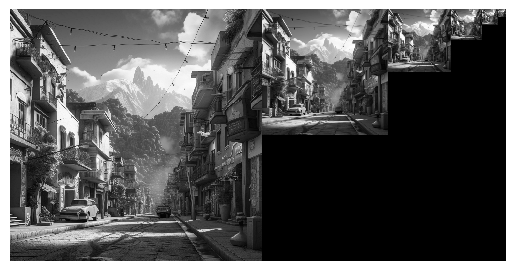

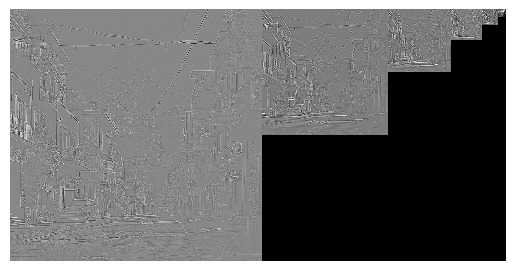

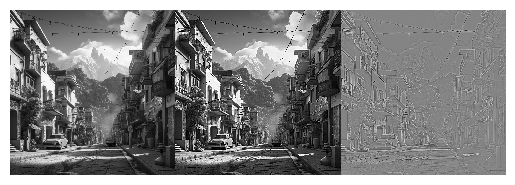

In [13]:
def gaussian_pyramid(img:GrayscaleImageType, nlevel:int, f:KernelType) -> PyramidType:
    """ Build Gaussian pyramid from image

    Args:
        img: input image for Gaussian pyramid (H,W)
        nlevel: number of pyramid levels
        f: 2d filter kernel (N,M)
    Returns:
        Gaussian pyramid, pyramid levels as (H/(2*n_i), W/2(2*n_i)) np.array
        in a list sorted from fine to coarse
    """
    #YOUR CODE HERE
    pyramid = [img]
    for i in range(0, nlevel - 1):
        pyramid.append(downsample2(pyramid[i], f))

    return pyramid


def laplacian_pyramid(gpyramid:PyramidType, f:KernelType) -> PyramidType:
    """ Build Laplacian pyramid from Gaussian pyramid

    Args:
        gpyramid: Gaussian pyramid
        f: 2d filter kernel (H,W)
    Returns:
        Laplacian pyramid, pyramid levels as (H/(2*n_i), W/2(2*n_i)) np.array
        in a list sorted from fine to coarse
    """
    gpyramid = gpyramid[::-1]

    lpyramid = [gpyramid[0]]
    for i in range(1, len(gpyramid)):
        lpyramid.append(gpyramid[i] - upsample2(gpyramid[i - 1], f))

    return lpyramid[::-1]

def create_composite_image(pyramid:PyramidType) -> GrayscaleImageType:
    """ Create composite image from image pyramid
    Arrange from finest to coarsest image left to right, pad images with
    zeros on the bottom to match the hight of the finest pyramid level.
    Normalize each pyramid level individually before adding to the composite image

    Args:
        pyramid: image pyramid
    Returns:
        composite image as (H, W) np.array
    """
    if not pyramid:
        return np.array([])

    finest_height = pyramid[0].shape[0]
    processed_images = []

    for img_level in pyramid:
        # Normalize each pyramid level individually
        min_val = img_level.min()
        max_val = img_level.max()
        if max_val - min_val == 0:
            normalized_img = np.zeros_like(img_level) # Or all ones, depending on context. Zero is safer.
        else:
            normalized_img = (img_level - min_val) / (max_val - min_val)

        # Pad images with zeros on the bottom to match the height of the finest pyramid level
        pad_height = finest_height - normalized_img.shape[0]
        # Pad on the bottom (axis 0) with constant_values=0, no padding on width (axis 1)
        padded_img = np.pad(normalized_img, ((0, pad_height), (0, 0)), 'constant', constant_values=0)
        processed_images.append(padded_img)

    # Concatenate horizontally
    composite_image = np.concatenate(processed_images, axis=1)
    return composite_image


def amplify_high_freq(lpyramid:PyramidType, l0_factor:float=1.8, l1_factor:float=1.7) -> PyramidType:
    """ Amplify frequencies of the finest two layers of the Laplacian pyramid

    Args:
        lpyramid: Laplacian pyramid
        l0_factor: amplification factor for the finest pyramid level
        l1_factor: amplification factor for the second finest pyramid level
    Returns:
        Amplified Laplacian pyramid, data format like input pyramid
    """
    # Use deepcopy to avoid modifying the original pyramid list
    amplified_lpyramid = deepcopy(lpyramid)

    if len(amplified_lpyramid) > 0:
        # Amplify the finest pyramid level (index 0)
        amplified_lpyramid[0] = amplified_lpyramid[0] * l0_factor
    if len(amplified_lpyramid) > 1:
        # Amplify the second finest pyramid level (index 1)
        amplified_lpyramid[1] = amplified_lpyramid[1] * l1_factor

    return amplified_lpyramid


def reconstruct_image(lpyramid:PyramidType, f:KernelType) -> GrayscaleImageType:
    """ Reconstruct image from Laplacian pyramid

    Args:
        lpyramid: Laplacian pyramid
        f: 2d filter kernel (N,M)
    Returns:
        Reconstructed image as (H, W) np.array clipped to [0, 1]
    """
    # Start reconstruction from the coarsest level
    reconstructed_img = lpyramid[-1] # This is G_N

    # Reconstruct from coarser to finer levels
    # Loop from the second coarsest Laplacian level (index len(lpyramid)-2)
    # down to the finest (index 0)
    for i in range(len(lpyramid) - 2, -1, -1):
        # Upsample the current reconstructed image (which is G_{i+1})
        upsampled_prev_level = upsample2(reconstructed_img, f)

        # Add the current Laplacian level (L_i)
        # Ensure sizes match before addition
        # The upsample2 function should return an image of approximately 2x size.
        # If the original image had odd dimensions, downsampling might have rounded down.
        # Upsampling that would then result in an even dimension. So we need to crop.
        h, w = lpyramid[i].shape
        upsampled_prev_level = upsampled_prev_level[:h, :w]

        reconstructed_img = upsampled_prev_level + lpyramid[i]

    # Clip the final reconstructed image to [0, 1] range
    return np.clip(reconstructed_img, 0, 1)

"""Example code implementing the steps in problem 2"""
# default values
fsize = (5, 5)
sigma = 1.5
nlevel = 6

# load image and build Gaussian pyramid
img = load_img("e2p2.png")
gf = gauss_2d(sigma, fsize)
gpyramid = gaussian_pyramid(img, nlevel, gf)
show_image(create_composite_image(gpyramid))

# build Laplacian pyramid from Gaussian pyramid
bf = binomial_2d(fsize)
lpyramid = laplacian_pyramid(gpyramid, bf)

# amplifiy high frequencies of Laplacian pyramid
lpyramid_amp = amplify_high_freq(lpyramid)
show_image(create_composite_image(lpyramid_amp))

# reconstruct sharpened image from amplified Laplacian pyramid
img_rec = reconstruct_image(lpyramid_amp, bf)
show_image(create_composite_image((img, img_rec, img_rec - img)))